In [ ]:
import pandas as pd
import numpy as np
import re
import copy
from datetime import datetime as dt
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.optimize import curve_fit
%matplotlib inline
import seaborn as sns

/home/kyomoto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
#データを読み込みます
dataset = pd.read_table("LD2011_2014.txt", sep =";")

/tmp/ipykernel_52289/2576353201.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_table("LD2011_2014.txt", sep =";")


In [ ]:
#データセットの中身を表示
dataset.head()

Unnamed: 0 MT_001 MT_002 MT_003 MT_004 MT_005 MT_006 MT_007  \
0  2011-01-01 00:15:00      0      0      0      0      0      0      0   
1  2011-01-01 00:30:00      0      0      0      0      0      0      0   
2  2011-01-01 00:45:00      0      0      0      0      0      0      0   
3  2011-01-01 01:00:00      0      0      0      0      0      0      0   
4  2011-01-01 01:15:00      0      0      0      0      0      0      0   

  MT_008 MT_009  ... MT_361 MT_362 MT_363 MT_364 MT_365 MT_366 MT_367 MT_368  \
0      0      0  ...      0    0.0      0      0      0      0      0      0   
1      0      0  ...      0    0.0      0      0      0      0      0      0   
2      0      0  ...      0    0.0      0      0      0      0      0      0   
3      0      0  ...      0    0.0      0      0      0      0      0      0   
4      0      0  ...      0    0.0      0      0      0      0      0      0   

  MT_369 MT_370  
0      0      0  
1      0      0  
2      0      0  
3      0      0  
4      0      0  

[5 rows x 371 columns]

In [ ]:
#最初の1000行をCSVファイルで書き出してみる
mydata = dataset.iloc[0:1000]
mydata.to_csv("mydata.csv", index=False)

In [ ]:
# 行数と列数を確認
dataset.shape

(140256, 371)

In [ ]:
# 列数ごとにデータ型を確認
for col in dataset.columns:
    print(col, type(dataset[col].iloc[0]))

Unnamed: 0 <class 'str'>
MT_001 <class 'int'>
MT_002 <class 'int'>
MT_003 <class 'int'>
MT_004 <class 'int'>
MT_005 <class 'int'>
MT_006 <class 'int'>
MT_007 <class 'int'>
MT_008 <class 'int'>
MT_009 <class 'int'>
MT_010 <class 'int'>
MT_011 <class 'int'>
MT_012 <class 'int'>
MT_013 <class 'int'>
MT_014 <class 'int'>
MT_015 <class 'int'>
MT_016 <class 'int'>
MT_017 <class 'int'>
MT_018 <class 'int'>
MT_019 <class 'int'>
MT_020 <class 'int'>
MT_021 <class 'int'>
MT_022 <class 'int'>
MT_023 <class 'int'>
MT_024 <class 'int'>
MT_025 <class 'int'>
MT_026 <class 'int'>
MT_027 <class 'int'>
MT_028 <class 'int'>
MT_029 <class 'int'>
MT_030 <class 'int'>
MT_031 <class 'int'>
MT_032 <class 'int'>
MT_033 <class 'int'>
MT_034 <class 'int'>
MT_035 <class 'int'>
MT_036 <class 'int'>
MT_037 <class 'int'>
MT_038 <class 'int'>
MT_039 <class 'int'>
MT_040 <class 'int'>
MT_041 <class 'int'>
MT_042 <class 'int'>
MT_043 <class 'int'>
MT_044 <class 'int'>
MT_045 <class 'int'>
MT_046 <class 'int'>
MT_047 <c

## データ型の変換

In [ ]:
# データ型が一部文字列型になっていることがわかる。
# その理由は、小数点がカンマになっているため。
# str型をfloat型にするために、数値の,を.に変換

dataset = dataset.replace(r",", ".",regex = True)

#列"Unnamed: 0"の名前を"time"に変更
dataset.rename(columns = {"Unnamed: 0": "time"}, inplace = True)

# time以外は全て小数点型にするので、timeを一度切り離して、float型に変更
data = dataset.drop("time", axis = 1)  # "time"のみ別扱いとする
data = data.astype("float")  # 数値をfloat型へ変換

In [ ]:
#kWhに直す(UCIの説明書きにあるように4で割ってkWhに修正 )
data = data/4

# 元のデータが法人顧客データなので、500（これは適当）で割って個人宅レベルの電力量に変換
data = data/500

# 最後にtime列を作成
data["time"] = dataset["time"]

In [ ]:
# CSVファイルに書き出す
# data.to_csv("data_converted.csv", index=False)

In [ ]:
# 要約統計量を確認
data.describe()

MT_001         MT_002         MT_003         MT_004  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        0.001985       0.010384       0.001459       0.041092   
std         0.002992       0.006636       0.005507       0.029124   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.001422       0.000000       0.018293   
50%         0.000635       0.012447       0.000869       0.043699   
75%         0.001269       0.014936       0.000869       0.057927   
max         0.024112       0.057610       0.075586       0.160569   

              MT_005         MT_006         MT_007         MT_008  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        0.018620       0.070614       0.002261       0.095701   
std         0.013231       0.049220       0.003243       0.060991   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.007927       0.035714       0.000283       0.055556   
50%         0.019512       0.078869       0.001413       0.111111   
75%         0.027439       0.102679       0.002261       0.139731   
max         0.075000       0.267857       0.022329       0.276094   

              MT_009         MT_010  ...         MT_361         MT_362  \
count  140256.000000  140256.000000  ...  140256.000000  140256.000000   
mean        0.019988       0.021103  ...       0.109107      18.803994   
std         0.014907       0.016701  ...       0.102417      19.345977   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.006993       0.004839  ...       0.002855       0.000000   
50%         0.020105       0.020430  ...       0.065667      12.050000   
75%         0.028846       0.030645  ...       0.201642      27.400000   
max         0.078671       0.099462  ...       0.426481      96.400000   

              MT_363         MT_364         MT_365         MT_366  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        0.943714       1.470016       0.032707       0.004635   
std         0.900743       1.366126       0.032504       0.005008   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.006519       0.000000   
50%         0.525316       1.068182       0.015645       0.003511   
75%         1.656118       2.681818       0.054107       0.005851   
max         3.875527       6.193182       0.167536       0.030135   

              MT_367         MT_368         MT_369         MT_370  
count  140256.000000  140256.000000  140256.000000  140256.000000  
mean        0.212131       0.047352       0.312626       4.361178  
std         0.137169       0.040149       0.190328       4.597578  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.015025       0.041972       0.000000  
50%         0.262950       0.038397       0.379032       0.000000  
75%         0.313872       0.075960       0.437683       8.891892  
max         0.569359       0.181135       0.774560      15.459459  

[8 rows x 370 columns]

In [ ]:
# time列から　月、日、曜日、時を抜き出すために関数を用意

def get_year_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.year
def get_month_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.month
def get_day_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.day
def get_weekday_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.weekday()
def get_hour_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.hour

In [ ]:
# 上記で作成した関数をapplyで一括適用
data["year"] = data["time"].apply(get_year_from_time)
data["month"] = data["time"].apply(get_month_from_time)
data["day"] = data["time"].apply(get_day_from_time)
data["weekday"] = data["time"].apply(get_weekday_from_time)
data["hour"] = data["time"].apply(get_hour_from_time)

In [ ]:
data.head()

MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  MT_008  MT_009  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_010  ...  MT_367  MT_368  MT_369  MT_370                 time  year  \
0     0.0  ...     0.0     0.0     0.0     0.0  2011-01-01 00:15:00  2011   
1     0.0  ...     0.0     0.0     0.0     0.0  2011-01-01 00:30:00  2011   
2     0.0  ...     0.0     0.0     0.0     0.0  2011-01-01 00:45:00  2011   
3     0.0  ...     0.0     0.0     0.0     0.0  2011-01-01 01:00:00  2011   
4     0.0  ...     0.0     0.0     0.0     0.0  2011-01-01 01:15:00  2011   

   month  day  weekday  hour  
0      1    1        5     0  
1      1    1        5     0  
2      1    1        5     0  
3      1    1        5     1  
4      1    1        5     1  

[5 rows x 376 columns]

In [ ]:
# Time period
# Output the start and end dates
print('Start date:', data['time'].min())
print('End date:', data['time'].max())

Start date: 2011-01-01 00:15:00
End date: 2015-01-01 00:00:00


In [ ]:
# 欠損値の確認
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140256 entries, 0 to 140255
Columns: 376 entries, MT_001 to hour
dtypes: float64(370), int64(5), object(1)
memory usage: 402.3+ MB


In [ ]:
# NAを削除しても行列数に変化がないので、欠損（NA）を含んでいないことがわかる
#data.dropna()
data.shape

(140256, 376)

## 欠損値の処理

In [ ]:
# 顧客に関するカラムを作成
col_customer = []
col_prefix = "MT_"
for cs in np.arange(1,371):
    # {0:03d}1~3桁の数字を扱うので、2桁までの数字は頭に0を埋める
    col_customer.append(col_prefix+"{0:03d}".format(cs))

starting_time_by_customer = []
for cs in col_customer:
    for i in range(len(data)):
        if data[cs][i]!=0:
            starting_time_by_customer.append(i)
            # breakをすることで初めて0ではなくなる行をだけをappendする
            # MT_001から始めるのでクライアント番号毎に積み上がっていく
            break

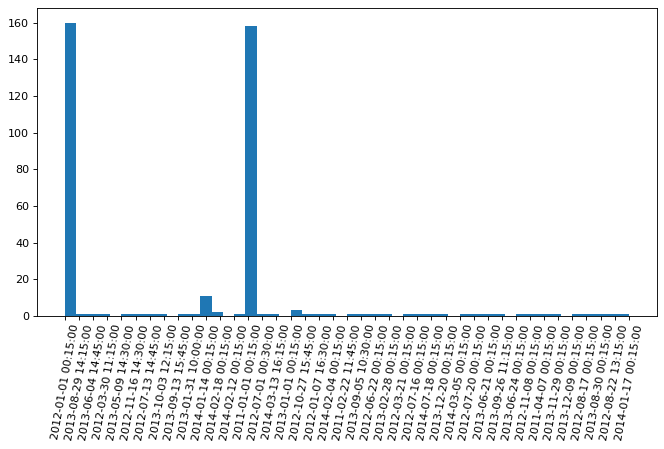

In [ ]:


# dataをdata_for_starting_timeにコピーする
data_for_starting_time = copy.copy(data)

# indexを列に加える
data_for_starting_time = data_for_starting_time.reset_index()
# データフレームに変換する
starting_time_by_customer = pd.DataFrame(starting_time_by_customer)
# 列名を"index"に変更する
starting_time_by_customer.rename(columns={0:"index"},inplace=True)
# indexをkeyにしてdata_for_starting_timeとマージする
starting_time_by_customer = pd.merge(starting_time_by_customer,data_for_starting_time[["index","time"]],on="index",how="left")

# 記録が始まる（0が終わる）時間毎のヒストグラムを作成
plt.figure(figsize=(10,5),dpi=80)
plt.hist(starting_time_by_customer["time"],bins=50)
plt.xticks(rotation=80)
plt.show()

- Many clients have records starting from January 1, 2012, so we'll uniformly use data from January 1, 2012 onward
- Clients whose records start after January 1, 2012 will be excluded from the analysis
- In other words, only clients with a starting_time on or before January 2, 2012 will be included in the analysis

In [ ]:
# 2012/1/2以前の行
customer_list_for_analysis = []
for cs in col_customer:
    # クライアン名の左から3つ（"MT_"部分）からの数字をcs_idに代入
    cs_id = int(cs[3:])
    # MT_001から記録開始時間をstarting_timeに代入、一番左の列の番号+1がクライアント名になる（index+1）
    # timeはリスト型へ変更する必要あり
    starting_time = dt.strptime(list(starting_time_by_customer[starting_time_by_customer.index+1==cs_id]["time"])[0],
                                "%Y-%m-%d %H:%M:%S")
    if starting_time < dt(2012,1,2):
        if cs != "MT_223" and cs != "MT_347":
            customer_list_for_analysis.append(cs)

In [ ]:
# 分析対象のクライアント数
len(customer_list_for_analysis)

318

In [ ]:
customer_list_for_analysis+=["time","month","day","weekday","hour"]

In [ ]:
customer_list_for_analysis

['MT_001',
 'MT_002',
 'MT_003',
 'MT_004',
 'MT_005',
 'MT_006',
 'MT_007',
 'MT_008',
 'MT_009',
 'MT_010',
 'MT_011',
 'MT_013',
 'MT_014',
 'MT_016',
 'MT_017',
 'MT_018',
 'MT_019',
 'MT_020',
 'MT_021',
 'MT_022',
 'MT_023',
 'MT_025',
 'MT_026',
 'MT_027',
 'MT_028',
 'MT_029',
 'MT_031',
 'MT_034',
 'MT_035',
 'MT_036',
 'MT_037',
 'MT_038',
 'MT_040',
 'MT_042',
 'MT_043',
 'MT_044',
 'MT_045',
 'MT_046',
 'MT_047',
 'MT_048',
 'MT_049',
 'MT_050',
 'MT_051',
 'MT_052',
 'MT_053',
 'MT_054',
 'MT_055',
 'MT_056',
 'MT_057',
 'MT_058',
 'MT_059',
 'MT_060',
 'MT_061',
 'MT_062',
 'MT_063',
 'MT_064',
 'MT_065',
 'MT_066',
 'MT_067',
 'MT_068',
 'MT_069',
 'MT_070',
 'MT_071',
 'MT_072',
 'MT_073',
 'MT_074',
 'MT_075',
 'MT_076',
 'MT_077',
 'MT_078',
 'MT_079',
 'MT_080',
 'MT_081',
 'MT_082',
 'MT_083',
 'MT_084',
 'MT_085',
 'MT_086',
 'MT_087',
 'MT_088',
 'MT_089',
 'MT_090',
 'MT_091',
 'MT_093',
 'MT_094',
 'MT_095',
 'MT_096',
 'MT_097',
 'MT_098',
 'MT_099',
 'MT_100',

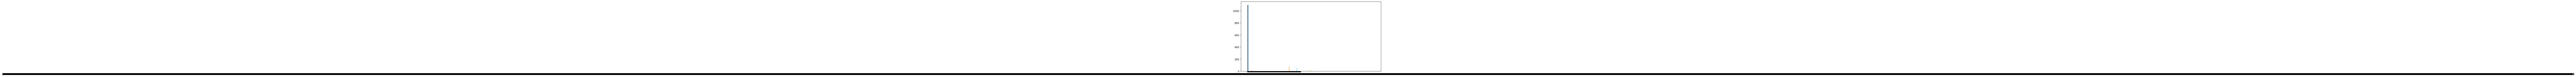

In [ ]:
# Copy select customers' data
selected_customer_data = copy.copy(data[customer_list_for_analysis])
# Remove data before 2012/1/1
selected_customer_data = selected_customer_data.drop(np.arange(0,35040),axis=0)

# Extract date more reliably using string slicing
time_list = selected_customer_data["time"]
# Use string slicing instead of split
f = lambda x: x[:10]  # Take first 10 characters (YYYY-MM-DD)
tmp = time_list.transform(f)
selected_customer_data["day"] = tmp

# Continue with groupby as before
groupby_day_selected_customer_data = selected_customer_data.groupby(["day"],as_index=False).sum()

plt.figure(figsize=(10,5),dpi=80)
plt.hist(groupby_day_selected_customer_data,bins=100)
plt.show()

In [ ]:
k=0
big_cs =[]
# ilocでクライアントだけの列を抽出（-3で後ろ3行を除く）
for mean_val in groupby_day_selected_customer_data.iloc[:,1:-3].mean():
    if mean_val > 200:
        big_cs.append(groupby_day_selected_customer_data.iloc[:,1:-3].mean().index[k])
    k=k+1

TypeError: Could not convert ['2012-01-01 00:15:002012-01-01 00:30:002012-01-01 00:45:002012-01-01 01:00:002012-01-01 01:15:002012-01-01 01:30:002012-01-01 01:45:002012-01-01 02:00:002012-01-01 02:15:002012-01-01 02:30:002012-01-01 02:45:002012-01-01 03:00:002012-01-01 03:15:002012-01-01 03:30:002012-01-01 03:45:002012-01-01 04:00:002012-01-01 04:15:002012-01-01 04:30:002012-01-01 04:45:002012-01-01 05:00:002012-01-01 05:15:002012-01-01 05:30:002012-01-01 05:45:002012-01-01 06:00:002012-01-01 06:15:002012-01-01 06:30:002012-01-01 06:45:002012-01-01 07:00:002012-01-01 07:15:002012-01-01 07:30:002012-01-01 07:45:002012-01-01 08:00:002012-01-01 08:15:002012-01-01 08:30:002012-01-01 08:45:002012-01-01 09:00:002012-01-01 09:15:002012-01-01 09:30:002012-01-01 09:45:002012-01-01 10:00:002012-01-01 10:15:002012-01-01 10:30:002012-01-01 10:45:002012-01-01 11:00:002012-01-01 11:15:002012-01-01 11:30:002012-01-01 11:45:002012-01-01 12:00:002012-01-01 12:15:002012-01-01 12:30:002012-01-01 12:45:002012-01-01 13:00:002012-01-01 13:15:002012-01-01 13:30:002012-01-01 13:45:002012-01-01 14:00:002012-01-01 14:15:002012-01-01 14:30:002012-01-01 14:45:002012-01-01 15:00:002012-01-01 15:15:002012-01-01 15:30:002012-01-01 15:45:002012-01-01 16:00:002012-01-01 16:15:002012-01-01 16:30:002012-01-01 16:45:002012-01-01 17:00:002012-01-01 17:15:002012-01-01 17:30:002012-01-01 17:45:002012-01-01 18:00:002012-01-01 18:15:002012-01-01 18:30:002012-01-01 18:45:002012-01-01 19:00:002012-01-01 19:15:002012-01-01 19:30:002012-01-01 19:45:002012-01-01 20:00:002012-01-01 20:15:002012-01-01 20:30:002012-01-01 20:45:002012-01-01 21:00:002012-01-01 21:15:002012-01-01 21:30:002012-01-01 21:45:002012-01-01 22:00:002012-01-01 22:15:002012-01-01 22:30:002012-01-01 22:45:002012-01-01 23:00:002012-01-01 23:15:002012-01-01 23:30:002012-01-01 23:45:002012-01-02 00:00:002012-01-02 00:15:002012-01-02 00:30:002012-01-02 00:45:002012-01-02 01:00:002012-01-02 01:15:002012-01-02 01:30:002012-01-02 01:45:002012-01-02 02:00:002012-01-02 02:15:002012-01-02 02:30:002012-01-02 02:45:002012-01-02 03:00:002012-01-02 03:15:002012-01-02 03:30:002012-01-02 03:45:002012-01-02 04:00:002012-01-02 04:15:002012-01-02 04:30:002012-01-02 04:45:002012-01-02 05:00:002012-01-02 05:15:002012-01-02 05:30:002012-01-02 05:45:002012-01-02 06:00:002012-01-02 06:15:002012-01-02 06:30:002012-01-02 06:45:002012-01-02 07:00:002012-01-02 07:15:002012-01-02 07:30:002012-01-02 07:45:002012-01-02 08:00:002012-01-02 08:15:002012-01-02 08:30:002012-01-02 08:45:002012-01-02 09:00:002012-01-02 09:15:002012-01-02 09:30:002012-01-02 09:45:002012-01-02 10:00:002012-01-02 10:15:002012-01-02 10:30:002012-01-02 10:45:002012-01-02 11:00:002012-01-02 11:15:002012-01-02 11:30:002012-01-02 11:45:002012-01-02 12:00:002012-01-02 12:15:002012-01-02 12:30:002012-01-02 12:45:002012-01-02 13:00:002012-01-02 13:15:002012-01-02 13:30:002012-01-02 13:45:002012-01-02 14:00:002012-01-02 14:15:002012-01-02 14:30:002012-01-02 14:45:002012-01-02 15:00:002012-01-02 15:15:002012-01-02 15:30:002012-01-02 15:45:002012-01-02 16:00:002012-01-02 16:15:002012-01-02 16:30:002012-01-02 16:45:002012-01-02 17:00:002012-01-02 17:15:002012-01-02 17:30:002012-01-02 17:45:002012-01-02 18:00:002012-01-02 18:15:002012-01-02 18:30:002012-01-02 18:45:002012-01-02 19:00:002012-01-02 19:15:002012-01-02 19:30:002012-01-02 19:45:002012-01-02 20:00:002012-01-02 20:15:002012-01-02 20:30:002012-01-02 20:45:002012-01-02 21:00:002012-01-02 21:15:002012-01-02 21:30:002012-01-02 21:45:002012-01-02 22:00:002012-01-02 22:15:002012-01-02 22:30:002012-01-02 22:45:002012-01-02 23:00:002012-01-02 23:15:002012-01-02 23:30:002012-01-02 23:45:002012-01-03 00:00:002012-01-03 00:15:002012-01-03 00:30:002012-01-03 00:45:002012-01-03 01:00:002012-01-03 01:15:002012-01-03 01:30:002012-01-03 01:45:002012-01-03 02:00:002012-01-03 02:15:002012-01-03 02:30:002012-01-03 02:45:002012-01-03 03:00:002012-01-03 03:15:002012-01-03 03:30:002012-01-03 03:45:002012-01-03 04:00:002012-01-03 04:15:002012-01-03 04:30:002012-01-03 04:45:002012-01-03 05:00:002012-01-03 05:15:002012-01-03 05:30:002012-01-03 05:45:002012-01-03 06:00:002012-01-03 06:15:002012-01-03 06:30:002012-01-03 06:45:002012-01-03 07:00:002012-01-03 07:15:002012-01-03 07:30:002012-01-03 07:45:002012-01-03 08:00:002012-01-03 08:15:002012-01-03 08:30:002012-01-03 08:45:002012-01-03 09:00:002012-01-03 09:15:002012-01-03 09:30:002012-01-03 09:45:002012-01-03 10:00:002012-01-03 10:15:002012-01-03 10:30:002012-01-03 10:45:002012-01-03 11:00:002012-01-03 11:15:002012-01-03 11:30:002012-01-03 11:45:002012-01-03 12:00:002012-01-03 12:15:002012-01-03 12:30:002012-01-03 12:45:002012-01-03 13:00:002012-01-03 13:15:002012-01-03 13:30:002012-01-03 13:45:002012-01-03 14:00:002012-01-03 14:15:002012-01-03 14:30:002012-01-03 14:45:002012-01-03 15:00:002012-01-03 15:15:002012-01-03 15:30:002012-01-03 15:45:002012-01-03 16:00:002012-01-03 16:15:002012-01-03 16:30:002012-01-03 16:45:002012-01-03 17:00:002012-01-03 17:15:002012-01-03 17:30:002012-01-03 17:45:002012-01-03 18:00:002012-01-03 18:15:002012-01-03 18:30:002012-01-03 18:45:002012-01-03 19:00:002012-01-03 19:15:002012-01-03 19:30:002012-01-03 19:45:002012-01-03 20:00:002012-01-03 20:15:002012-01-03 20:30:002012-01-03 20:45:002012-01-03 21:00:002012-01-03 21:15:002012-01-03 21:30:002012-01-03 21:45:002012-01-03 22:00:002012-01-03 22:15:002012-01-03 22:30:002012-01-03 22:45:002012-01-03 23:00:002012-01-03 23:15:002012-01-03 23:30:002012-01-03 23:45:002012-01-04 00:00:002012-01-04 00:15:002012-01-04 00:30:002012-01-04 00:45:002012-01-04 01:00:002012-01-04 01:15:002012-01-04 01:30:002012-01-04 01:45:002012-01-04 02:00:002012-01-04 02:15:002012-01-04 02:30:002012-01-04 02:45:002012-01-04 03:00:002012-01-04 03:15:002012-01-04 03:30:002012-01-04 03:45:002012-01-04 04:00:002012-01-04 04:15:002012-01-04 04:30:002012-01-04 04:45:002012-01-04 05:00:002012-01-04 05:15:002012-01-04 05:30:002012-01-04 05:45:002012-01-04 06:00:002012-01-04 06:15:002012-01-04 06:30:002012-01-04 06:45:002012-01-04 07:00:002012-01-04 07:15:002012-01-04 07:30:002012-01-04 07:45:002012-01-04 08:00:002012-01-04 08:15:002012-01-04 08:30:002012-01-04 08:45:002012-01-04 09:00:002012-01-04 09:15:002012-01-04 09:30:002012-01-04 09:45:002012-01-04 10:00:002012-01-04 10:15:002012-01-04 10:30:002012-01-04 10:45:002012-01-04 11:00:002012-01-04 11:15:002012-01-04 11:30:002012-01-04 11:45:002012-01-04 12:00:002012-01-04 12:15:002012-01-04 12:30:002012-01-04 12:45:002012-01-04 13:00:002012-01-04 13:15:002012-01-04 13:30:002012-01-04 13:45:002012-01-04 14:00:002012-01-04 14:15:002012-01-04 14:30:002012-01-04 14:45:002012-01-04 15:00:002012-01-04 15:15:002012-01-04 15:30:002012-01-04 15:45:002012-01-04 16:00:002012-01-04 16:15:002012-01-04 16:30:002012-01-04 16:45:002012-01-04 17:00:002012-01-04 17:15:002012-01-04 17:30:002012-01-04 17:45:002012-01-04 18:00:002012-01-04 18:15:002012-01-04 18:30:002012-01-04 18:45:002012-01-04 19:00:002012-01-04 19:15:002012-01-04 19:30:002012-01-04 19:45:002012-01-04 20:00:002012-01-04 20:15:002012-01-04 20:30:002012-01-04 20:45:002012-01-04 21:00:002012-01-04 21:15:002012-01-04 21:30:002012-01-04 21:45:002012-01-04 22:00:002012-01-04 22:15:002012-01-04 22:30:002012-01-04 22:45:002012-01-04 23:00:002012-01-04 23:15:002012-01-04 23:30:002012-01-04 23:45:002012-01-05 00:00:002012-01-05 00:15:002012-01-05 00:30:002012-01-05 00:45:002012-01-05 01:00:002012-01-05 01:15:002012-01-05 01:30:002012-01-05 01:45:002012-01-05 02:00:002012-01-05 02:15:002012-01-05 02:30:002012-01-05 02:45:002012-01-05 03:00:002012-01-05 03:15:002012-01-05 03:30:002012-01-05 03:45:002012-01-05 04:00:002012-01-05 04:15:002012-01-05 04:30:002012-01-05 04:45:002012-01-05 05:00:002012-01-05 05:15:002012-01-05 05:30:002012-01-05 05:45:002012-01-05 06:00:002012-01-05 06:15:002012-01-05 06:30:002012-01-05 06:45:002012-01-05 07:00:002012-01-05 07:15:002012-01-05 07:30:002012-01-05 07:45:002012-01-05 08:00:002012-01-05 08:15:002012-01-05 08:30:002012-01-05 08:45:002012-01-05 09:00:002012-01-05 09:15:002012-01-05 09:30:002012-01-05 09:45:002012-01-05 10:00:002012-01-05 10:15:002012-01-05 10:30:002012-01-05 10:45:002012-01-05 11:00:002012-01-05 11:15:002012-01-05 11:30:002012-01-05 11:45:002012-01-05 12:00:002012-01-05 12:15:002012-01-05 12:30:002012-01-05 12:45:002012-01-05 13:00:002012-01-05 13:15:002012-01-05 13:30:002012-01-05 13:45:002012-01-05 14:00:002012-01-05 14:15:002012-01-05 14:30:002012-01-05 14:45:002012-01-05 15:00:002012-01-05 15:15:002012-01-05 15:30:002012-01-05 15:45:002012-01-05 16:00:002012-01-05 16:15:002012-01-05 16:30:002012-01-05 16:45:002012-01-05 17:00:002012-01-05 17:15:002012-01-05 17:30:002012-01-05 17:45:002012-01-05 18:00:002012-01-05 18:15:002012-01-05 18:30:002012-01-05 18:45:002012-01-05 19:00:002012-01-05 19:15:002012-01-05 19:30:002012-01-05 19:45:002012-01-05 20:00:002012-01-05 20:15:002012-01-05 20:30:002012-01-05 20:45:002012-01-05 21:00:002012-01-05 21:15:002012-01-05 21:30:002012-01-05 21:45:002012-01-05 22:00:002012-01-05 22:15:002012-01-05 22:30:002012-01-05 22:45:002012-01-05 23:00:002012-01-05 23:15:002012-01-05 23:30:002012-01-05 23:45:002012-01-06 00:00:002012-01-06 00:15:002012-01-06 00:30:002012-01-06 00:45:002012-01-06 01:00:002012-01-06 01:15:002012-01-06 01:30:002012-01-06 01:45:002012-01-06 02:00:002012-01-06 02:15:002012-01-06 02:30:002012-01-06 02:45:002012-01-06 03:00:002012-01-06 03:15:002012-01-06 03:30:002012-01-06 03:45:002012-01-06 04:00:002012-01-06 04:15:002012-01-06 04:30:002012-01-06 04:45:002012-01-06 05:00:002012-01-06 05:15:002012-01-06 05:30:002012-01-06 05:45:002012-01-06 06:00:002012-01-06 06:15:002012-01-06 06:30:002012-01-06 06:45:002012-01-06 07:00:002012-01-06 07:15:002012-01-06 07:30:002012-01-06 07:45:002012-01-06 08:00:002012-01-06 08:15:002012-01-06 08:30:002012-01-06 08:45:002012-01-06 09:00:002012-01-06 09:15:002012-01-06 09:30:002012-01-06 09:45:002012-01-06 10:00:002012-01-06 10:15:002012-01-06 10:30:002012-01-06 10:45:002012-01-06 11:00:002012-01-06 11:15:002012-01-06 11:30:002012-01-06 11:45:002012-01-06 12:00:002012-01-06 12:15:002012-01-06 12:30:002012-01-06 12:45:002012-01-06 13:00:002012-01-06 13:15:002012-01-06 13:30:002012-01-06 13:45:002012-01-06 14:00:002012-01-06 14:15:002012-01-06 14:30:002012-01-06 14:45:002012-01-06 15:00:002012-01-06 15:15:002012-01-06 15:30:002012-01-06 15:45:002012-01-06 16:00:002012-01-06 16:15:002012-01-06 16:30:002012-01-06 16:45:002012-01-06 17:00:002012-01-06 17:15:002012-01-06 17:30:002012-01-06 17:45:002012-01-06 18:00:002012-01-06 18:15:002012-01-06 18:30:002012-01-06 18:45:002012-01-06 19:00:002012-01-06 19:15:002012-01-06 19:30:002012-01-06 19:45:002012-01-06 20:00:002012-01-06 20:15:002012-01-06 20:30:002012-01-06 20:45:002012-01-06 21:00:002012-01-06 21:15:002012-01-06 21:30:002012-01-06 21:45:002012-01-06 22:00:002012-01-06 22:15:002012-01-06 22:30:002012-01-06 22:45:002012-01-06 23:00:002012-01-06 23:15:002012-01-06 23:30:002012-01-06 23:45:002012-01-07 00:00:002012-01-07 00:15:002012-01-07 00:30:002012-01-07 00:45:002012-01-07 01:00:002012-01-07 01:15:002012-01-07 01:30:002012-01-07 01:45:002012-01-07 02:00:002012-01-07 02:15:002012-01-07 02:30:002012-01-07 02:45:002012-01-07 03:00:002012-01-07 03:15:002012-01-07 03:30:002012-01-07 03:45:002012-01-07 04:00:002012-01-07 04:15:002012-01-07 04:30:002012-01-07 04:45:002012-01-07 05:00:002012-01-07 05:15:002012-01-07 05:30:002012-01-07 05:45:002012-01-07 06:00:002012-01-07 06:15:002012-01-07 06:30:002012-01-07 06:45:002012-01-07 07:00:002012-01-07 07:15:002012-01-07 07:30:002012-01-07 07:45:002012-01-07 08:00:002012-01-07 08:15:002012-01-07 08:30:002012-01-07 08:45:002012-01-07 09:00:002012-01-07 09:15:002012-01-07 09:30:002012-01-07 09:45:002012-01-07 10:00:002012-01-07 10:15:002012-01-07 10:30:002012-01-07 10:45:002012-01-07 11:00:002012-01-07 11:15:002012-01-07 11:30:002012-01-07 11:45:002012-01-07 12:00:002012-01-07 12:15:002012-01-07 12:30:002012-01-07 12:45:002012-01-07 13:00:002012-01-07 13:15:002012-01-07 13:30:002012-01-07 13:45:002012-01-07 14:00:002012-01-07 14:15:002012-01-07 14:30:002012-01-07 14:45:002012-01-07 15:00:002012-01-07 15:15:002012-01-07 15:30:002012-01-07 15:45:002012-01-07 16:00:002012-01-07 16:15:002012-01-07 16:30:002012-01-07 16:45:002012-01-07 17:00:002012-01-07 17:15:002012-01-07 17:30:002012-01-07 17:45:002012-01-07 18:00:002012-01-07 18:15:002012-01-07 18:30:002012-01-07 18:45:002012-01-07 19:00:002012-01-07 19:15:002012-01-07 19:30:002012-01-07 19:45:002012-01-07 20:00:002012-01-07 20:15:002012-01-07 20:30:002012-01-07 20:45:002012-01-07 21:00:002012-01-07 21:15:002012-01-07 21:30:002012-01-07 21:45:002012-01-07 22:00:002012-01-07 22:15:002012-01-07 22:30:002012-01-07 22:45:002012-01-07 23:00:002012-01-07 23:15:002012-01-07 23:30:002012-01-07 23:45:002012-01-08 00:00:002012-01-08 00:15:002012-01-08 00:30:002012-01-08 00:45:002012-01-08 01:00:002012-01-08 01:15:002012-01-08 01:30:002012-01-08 01:45:002012-01-08 02:00:002012-01-08 02:15:002012-01-08 02:30:002012-01-08 02:45:002012-01-08 03:00:002012-01-08 03:15:002012-01-08 03:30:002012-01-08 03:45:002012-01-08 04:00:002012-01-08 04:15:002012-01-08 04:30:002012-01-08 04:45:002012-01-08 05:00:002012-01-08 05:15:002012-01-08 05:30:002012-01-08 05:45:002012-01-08 06:00:002012-01-08 06:15:002012-01-08 06:30:002012-01-08 06:45:002012-01-08 07:00:002012-01-08 07:15:002012-01-08 07:30:002012-01-08 07:45:002012-01-08 08:00:002012-01-08 08:15:002012-01-08 08:30:002012-01-08 08:45:002012-01-08 09:00:002012-01-08 09:15:002012-01-08 09:30:002012-01-08 09:45:002012-01-08 10:00:002012-01-08 10:15:002012-01-08 10:30:002012-01-08 10:45:002012-01-08 11:00:002012-01-08 11:15:002012-01-08 11:30:002012-01-08 11:45:002012-01-08 12:00:002012-01-08 12:15:002012-01-08 12:30:002012-01-08 12:45:002012-01-08 13:00:002012-01-08 13:15:002012-01-08 13:30:002012-01-08 13:45:002012-01-08 14:00:002012-01-08 14:15:002012-01-08 14:30:002012-01-08 14:45:002012-01-08 15:00:002012-01-08 15:15:002012-01-08 15:30:002012-01-08 15:45:002012-01-08 16:00:002012-01-08 16:15:002012-01-08 16:30:002012-01-08 16:45:002012-01-08 17:00:002012-01-08 17:15:002012-01-08 17:30:002012-01-08 17:45:002012-01-08 18:00:002012-01-08 18:15:002012-01-08 18:30:002012-01-08 18:45:002012-01-08 19:00:002012-01-08 19:15:002012-01-08 19:30:002012-01-08 19:45:002012-01-08 20:00:002012-01-08 20:15:002012-01-08 20:30:002012-01-08 20:45:002012-01-08 21:00:002012-01-08 21:15:002012-01-08 21:30:002012-01-08 21:45:002012-01-08 22:00:002012-01-08 22:15:002012-01-08 22:30:002012-01-08 22:45:002012-01-08 23:00:002012-01-08 23:15:002012-01-08 23:30:002012-01-08 23:45:002012-01-09 00:00:002012-01-09 00:15:002012-01-09 00:30:002012-01-09 00:45:002012-01-09 01:00:002012-01-09 01:15:002012-01-09 01:30:002012-01-09 01:45:002012-01-09 02:00:002012-01-09 02:15:002012-01-09 02:30:002012-01-09 02:45:002012-01-09 03:00:002012-01-09 03:15:002012-01-09 03:30:002012-01-09 03:45:002012-01-09 04:00:002012-01-09 04:15:002012-01-09 04:30:002012-01-09 04:45:002012-01-09 05:00:002012-01-09 05:15:002012-01-09 05:30:002012-01-09 05:45:002012-01-09 06:00:002012-01-09 06:15:002012-01-09 06:30:002012-01-09 06:45:002012-01-09 07:00:002012-01-09 07:15:002012-01-09 07:30:002012-01-09 07:45:002012-01-09 08:00:002012-01-09 08:15:002012-01-09 08:30:002012-01-09 08:45:002012-01-09 09:00:002012-01-09 09:15:002012-01-09 09:30:002012-01-09 09:45:002012-01-09 10:00:002012-01-09 10:15:002012-01-09 10:30:002012-01-09 10:45:002012-01-09 11:00:002012-01-09 11:15:002012-01-09 11:30:002012-01-09 11:45:002012-01-09 12:00:002012-01-09 12:15:002012-01-09 12:30:002012-01-09 12:45:002012-01-09 13:00:002012-01-09 13:15:002012-01-09 13:30:002012-01-09 13:45:002012-01-09 14:00:002012-01-09 14:15:002012-01-09 14:30:002012-01-09 14:45:002012-01-09 15:00:002012-01-09 15:15:002012-01-09 15:30:002012-01-09 15:45:002012-01-09 16:00:002012-01-09 16:15:002012-01-09 16:30:002012-01-09 16:45:002012-01-09 17:00:002012-01-09 17:15:002012-01-09 17:30:002012-01-09 17:45:002012-01-09 18:00:002012-01-09 18:15:002012-01-09 18:30:002012-01-09 18:45:002012-01-09 19:00:002012-01-09 19:15:002012-01-09 19:30:002012-01-09 19:45:002012-01-09 20:00:002012-01-09 20:15:002012-01-09 20:30:002012-01-09 20:45:002012-01-09 21:00:002012-01-09 21:15:002012-01-09 21:30:002012-01-09 21:45:002012-01-09 22:00:002012-01-09 22:15:002012-01-09 22:30:002012-01-09 22:45:002012-01-09 23:00:002012-01-09 23:15:002012-01-09 23:30:002012-01-09 23:45:002012-01-10 00:00:002012-01-10 00:15:002012-01-10 00:30:002012-01-10 00:45:002012-01-10 01:00:002012-01-10 01:15:002012-01-10 01:30:002012-01-10 01:45:002012-01-10 02:00:002012-01-10 02:15:002012-01-10 02:30:002012-01-10 02:45:002012-01-10 03:00:002012-01-10 03:15:002012-01-10 03:30:002012-01-10 03:45:002012-01-10 04:00:002012-01-10 04:15:002012-01-10 04:30:002012-01-10 04:45:002012-01-10 05:00:002012-01-10 05:15:002012-01-10 05:30:002012-01-10 05:45:002012-01-10 06:00:002012-01-10 06:15:002012-01-10 06:30:002012-01-10 06:45:002012-01-10 07:00:002012-01-10 07:15:002012-01-10 07:30:002012-01-10 07:45:002012-01-10 08:00:002012-01-10 08:15:002012-01-10 08:30:002012-01-10 08:45:002012-01-10 09:00:002012-01-10 09:15:002012-01-10 09:30:002012-01-10 09:45:002012-01-10 10:00:002012-01-10 10:15:002012-01-10 10:30:002012-01-10 10:45:002012-01-10 11:00:002012-01-10 11:15:002012-01-10 11:30:002012-01-10 11:45:002012-01-10 12:00:002012-01-10 12:15:002012-01-10 12:30:002012-01-10 12:45:002012-01-10 13:00:002012-01-10 13:15:002012-01-10 13:30:002012-01-10 13:45:002012-01-10 14:00:002012-01-10 14:15:002012-01-10 14:30:002012-01-10 14:45:002012-01-10 15:00:002012-01-10 15:15:002012-01-10 15:30:002012-01-10 15:45:002012-01-10 16:00:002012-01-10 16:15:002012-01-10 16:30:002012-01-10 16:45:002012-01-10 17:00:002012-01-10 17:15:002012-01-10 17:30:002012-01-10 17:45:002012-01-10 18:00:002012-01-10 18:15:002012-01-10 18:30:002012-01-10 18:45:002012-01-10 19:00:002012-01-10 19:15:002012-01-10 19:30:002012-01-10 19:45:002012-01-10 20:00:002012-01-10 20:15:002012-01-10 20:30:002012-01-10 20:45:002012-01-10 21:00:002012-01-10 21:15:002012-01-10 21:30:002012-01-10 21:45:002012-01-10 22:00:002012-01-10 22:15:002012-01-10 22:30:002012-01-10 22:45:002012-01-10 23:00:002012-01-10 23:15:002012-01-10 23:30:002012-01-10 23:45:002012-01-11 00:00:002012-01-11 00:15:002012-01-11 00:30:002012-01-11 00:45:002012-01-11 01:00:002012-01-11 01:15:002012-01-11 01:30:002012-01-11 01:45:002012-01-11 02:00:002012-01-11 02:15:002012-01-11 02:30:002012-01-11 02:45:002012-01-11 03:00:002012-01-11 03:15:002012-01-11 03:30:002012-01-11 03:45:002012-01-11 04:00:002012-01-11 04:15:002012-01-11 04:30:002012-01-11 04:45:002012-01-11 05:00:002012-01-11 05:15:002012-01-11 05:30:002012-01-11 05:45:002012-01-11 06:00:002012-01-11 06:15:002012-01-11 06:30:002012-01-11 06:45:002012-01-11 07:00:002012-01-11 07:15:002012-01-11 07:30:002012-01-11 07:45:002012-01-11 08:00:002012-01-11 08:15:002012-01-11 08:30:002012-01-11 08:45:002012-01-11 09:00:002012-01-11 09:15:002012-01-11 09:30:002012-01-11 09:45:002012-01-11 10:00:002012-01-11 10:15:002012-01-11 10:30:002012-01-11 10:45:002012-01-11 11:00:002012-01-11 11:15:002012-01-11 11:30:002012-01-11 11:45:002012-01-11 12:00:002012-01-11 12:15:002012-01-11 12:30:002012-01-11 12:45:002012-01-11 13:00:002012-01-11 13:15:002012-01-11 13:30:002012-01-11 13:45:002012-01-11 14:00:002012-01-11 14:15:002012-01-11 14:30:002012-01-11 14:45:002012-01-11 15:00:002012-01-11 15:15:002012-01-11 15:30:002012-01-11 15:45:002012-01-11 16:00:002012-01-11 16:15:002012-01-11 16:30:002012-01-11 16:45:002012-01-11 17:00:002012-01-11 17:15:002012-01-11 17:30:002012-01-11 17:45:002012-01-11 18:00:002012-01-11 18:15:002012-01-11 18:30:002012-01-11 18:45:002012-01-11 19:00:002012-01-11 19:15:002012-01-11 19:30:002012-01-11 19:45:002012-01-11 20:00:002012-01-11 20:15:002012-01-11 20:30:002012-01-11 20:45:002012-01-11 21:00:002012-01-11 21:15:002012-01-11 21:30:002012-01-11 21:45:002012-01-11 22:00:002012-01-11 22:15:002012-01-11 22:30:002012-01-11 22:45:002012-01-11 23:00:002012-01-11 23:15:002012-01-11 23:30:002012-01-11 23:45:002012-01-12 00:00:002012-01-12 00:15:002012-01-12 00:30:002012-01-12 00:45:002012-01-12 01:00:002012-01-12 01:15:002012-01-12 01:30:002012-01-12 01:45:002012-01-12 02:00:002012-01-12 02:15:002012-01-12 02:30:002012-01-12 02:45:002012-01-12 03:00:002012-01-12 03:15:002012-01-12 03:30:002012-01-12 03:45:002012-01-12 04:00:002012-01-12 04:15:002012-01-12 04:30:002012-01-12 04:45:002012-01-12 05:00:002012-01-12 05:15:002012-01-12 05:30:002012-01-12 05:45:002012-01-12 06:00:002012-01-12 06:15:002012-01-12 06:30:002012-01-12 06:45:002012-01-12 07:00:002012-01-12 07:15:002012-01-12 07:30:002012-01-12 07:45:002012-01-12 08:00:002012-01-12 08:15:002012-01-12 08:30:002012-01-12 08:45:002012-01-12 09:00:002012-01-12 09:15:002012-01-12 09:30:002012-01-12 09:45:002012-01-12 10:00:002012-01-12 10:15:002012-01-12 10:30:002012-01-12 10:45:002012-01-12 11:00:002012-01-12 11:15:002012-01-12 11:30:002012-01-12 11:45:002012-01-12 12:00:002012-01-12 12:15:002012-01-12 12:30:002012-01-12 12:45:002012-01-12 13:00:002012-01-12 13:15:002012-01-12 13:30:002012-01-12 13:45:002012-01-12 14:00:002012-01-12 14:15:002012-01-12 14:30:002012-01-12 14:45:002012-01-12 15:00:002012-01-12 15:15:002012-01-12 15:30:002012-01-12 15:45:002012-01-12 16:00:002012-01-12 16:15:002012-01-12 16:30:002012-01-12 16:45:002012-01-12 17:00:002012-01-12 17:15:002012-01-12 17:30:002012-01-12 17:45:002012-01-12 18:00:002012-01-12 18:15:002012-01-12 18:30:002012-01-12 18:45:002012-01-12 19:00:002012-01-12 19:15:002012-01-12 19:30:002012-01-12 19:45:002012-01-12 20:00:002012-01-12 20:15:002012-01-12 20:30:002012-01-12 20:45:002012-01-12 21:00:002012-01-12 21:15:002012-01-12 21:30:002012-01-12 21:45:002012-01-12 22:00:002012-01-12 22:15:002012-01-12 22:30:002012-01-12 22:45:002012-01-12 23:00:002012-01-12 23:15:002012-01-12 23:30:002012-01-12 23:45:002012-01-13 00:00:002012-01-13 00:15:002012-01-13 00:30:002012-01-13 00:45:002012-01-13 01:00:002012-01-13 01:15:002012-01-13 01:30:002012-01-13 01:45:002012-01-13 02:00:002012-01-13 02:15:002012-01-13 02:30:002012-01-13 02:45:002012-01-13 03:00:002012-01-13 03:15:002012-01-13 03:30:002012-01-13 03:45:002012-01-13 04:00:002012-01-13 04:15:002012-01-13 04:30:002012-01-13 04:45:002012-01-13 05:00:002012-01-13 05:15:002012-01-13 05:30:002012-01-13 05:45:002012-01-13 06:00:002012-01-13 06:15:002012-01-13 06:30:002012-01-13 06:45:002012-01-13 07:00:002012-01-13 07:15:002012-01-13 07:30:002012-01-13 07:45:002012-01-13 08:00:002012-01-13 08:15:002012-01-13 08:30:002012-01-13 08:45:002012-01-13 09:00:002012-01-13 09:15:002012-01-13 09:30:002012-01-13 09:45:002012-01-13 10:00:002012-01-13 10:15:002012-01-13 10:30:002012-01-13 10:45:002012-01-13 11:00:002012-01-13 11:15:002012-01-13 11:30:002012-01-13 11:45:002012-01-13 12:00:002012-01-13 12:15:002012-01-13 12:30:002012-01-13 12:45:002012-01-13 13:00:002012-01-13 13:15:002012-01-13 13:30:002012-01-13 13:45:002012-01-13 14:00:002012-01-13 14:15:002012-01-13 14:30:002012-01-13 14:45:002012-01-13 15:00:002012-01-13 15:15:002012-01-13 15:30:002012-01-13 15:45:002012-01-13 16:00:002012-01-13 16:15:002012-01-13 16:30:002012-01-13 16:45:002012-01-13 17:00:002012-01-13 17:15:002012-01-13 17:30:002012-01-13 17:45:002012-01-13 18:00:002012-01-13 18:15:002012-01-13 18:30:002012-01-13 18:45:002012-01-13 19:00:002012-01-13 19:15:002012-01-13 19:30:002012-01-13 19:45:002012-01-13 20:00:002012-01-13 20:15:002012-01-13 20:30:002012-01-13 20:45:002012-01-13 21:00:002012-01-13 21:15:002012-01-13 21:30:002012-01-13 21:45:002012-01-13 22:00:002012-01-13 22:15:002012-01-13 22:30:002012-01-13 22:45:002012-01-13 23:00:002012-01-13 23:15:002012-01-13 23:30:002012-01-13 23:45:002012-01-14 00:00:002012-01-14 00:15:002012-01-14 00:30:002012-01-14 00:45:002012-01-14 01:00:002012-01-14 01:15:002012-01-14 01:30:002012-01-14 01:45:002012-01-14 02:00:002012-01-14 02:15:002012-01-14 02:30:002012-01-14 02:45:002012-01-14 03:00:002012-01-14 03:15:002012-01-14 03:30:002012-01-14 03:45:002012-01-14 04:00:002012-01-14 04:15:002012-01-14 04:30:002012-01-14 04:45:002012-01-14 05:00:002012-01-14 05:15:002012-01-14 05:30:002012-01-14 05:45:002012-01-14 06:00:002012-01-14 06:15:002012-01-14 06:30:002012-01-14 06:45:002012-01-14 07:00:002012-01-14 07:15:002012-01-14 07:30:002012-01-14 07:45:002012-01-14 08:00:002012-01-14 08:15:002012-01-14 08:30:002012-01-14 08:45:002012-01-14 09:00:002012-01-14 09:15:002012-01-14 09:30:002012-01-14 09:45:002012-01-14 10:00:002012-01-14 10:15:002012-01-14 10:30:002012-01-14 10:45:002012-01-14 11:00:002012-01-14 11:15:002012-01-14 11:30:002012-01-14 11:45:002012-01-14 12:00:002012-01-14 12:15:002012-01-14 12:30:002012-01-14 12:45:002012-01-14 13:00:002012-01-14 13:15:002012-01-14 13:30:002012-01-14 13:45:002012-01-14 14:00:002012-01-14 14:15:002012-01-14 14:30:002012-01-14 14:45:002012-01-14 15:00:002012-01-14 15:15:002012-01-14 15:30:002012-01-14 15:45:002012-01-14 16:00:002012-01-14 16:15:002012-01-14 16:30:002012-01-14 16:45:002012-01-14 17:00:002012-01-14 17:15:002012-01-14 17:30:002012-01-14 17:45:002012-01-14 18:00:002012-01-14 18:15:002012-01-14 18:30:002012-01-14 18:45:002012-01-14 19:00:002012-01-14 19:15:002012-01-14 19:30:002012-01-14 19:45:002012-01-14 20:00:002012-01-14 20:15:002012-01-14 20:30:002012-01-14 20:45:002012-01-14 21:00:002012-01-14 21:15:002012-01-14 21:30:002012-01-14 21:45:002012-01-14 22:00:002012-01-14 22:15:002012-01-14 22:30:002012-01-14 22:45:002012-01-14 23:00:002012-01-14 23:15:002012-01-14 23:30:002012-01-14 23:45:002012-01-15 00:00:002012-01-15 00:15:002012-01-15 00:30:002012-01-15 00:45:002012-01-15 01:00:002012-01-15 01:15:002012-01-15 01:30:002012-01-15 01:45:002012-01-15 02:00:002012-01-15 02:15:002012-01-15 02:30:002012-01-15 02:45:002012-01-15 03:00:002012-01-15 03:15:002012-01-15 03:30:002012-01-15 03:45:002012-01-15 04:00:002012-01-15 04:15:002012-01-15 04:30:002012-01-15 04:45:002012-01-15 05:00:002012-01-15 05:15:002012-01-15 05:30:002012-01-15 05:45:002012-01-15 06:00:002012-01-15 06:15:002012-01-15 06:30:002012-01-15 06:45:002012-01-15 07:00:002012-01-15 07:15:002012-01-15 07:30:002012-01-15 07:45:002012-01-15 08:00:002012-01-15 08:15:002012-01-15 08:30:002012-01-15 08:45:002012-01-15 09:00:002012-01-15 09:15:002012-01-15 09:30:002012-01-15 09:45:002012-01-15 10:00:002012-01-15 10:15:002012-01-15 10:30:002012-01-15 10:45:002012-01-15 11:00:002012-01-15 11:15:002012-01-15 11:30:002012-01-15 11:45:002012-01-15 12:00:002012-01-15 12:15:002012-01-15 12:30:002012-01-15 12:45:002012-01-15 13:00:002012-01-15 13:15:002012-01-15 13:30:002012-01-15 13:45:002012-01-15 14:00:002012-01-15 14:15:002012-01-15 14:30:002012-01-15 14:45:002012-01-15 15:00:002012-01-15 15:15:002012-01-15 15:30:002012-01-15 15:45:002012-01-15 16:00:002012-01-15 16:15:002012-01-15 16:30:002012-01-15 16:45:002012-01-15 17:00:002012-01-15 17:15:002012-01-15 17:30:002012-01-15 17:45:002012-01-15 18:00:002012-01-15 18:15:002012-01-15 18:30:002012-01-15 18:45:002012-01-15 19:00:002012-01-15 19:15:002012-01-15 19:30:002012-01-15 19:45:002012-01-15 20:00:002012-01-15 20:15:002012-01-15 20:30:002012-01-15 20:45:002012-01-15 21:00:002012-01-15 21:15:002012-01-15 21:30:002012-01-15 21:45:002012-01-15 22:00:002012-01-15 22:15:002012-01-15 22:30:002012-01-15 22:45:002012-01-15 23:00:002012-01-15 23:15:002012-01-15 23:30:002012-01-15 23:45:002012-01-16 00:00:002012-01-16 00:15:002012-01-16 00:30:002012-01-16 00:45:002012-01-16 01:00:002012-01-16 01:15:002012-01-16 01:30:002012-01-16 01:45:002012-01-16 02:00:002012-01-16 02:15:002012-01-16 02:30:002012-01-16 02:45:002012-01-16 03:00:002012-01-16 03:15:002012-01-16 03:30:002012-01-16 03:45:002012-01-16 04:00:002012-01-16 04:15:002012-01-16 04:30:002012-01-16 04:45:002012-01-16 05:00:002012-01-16 05:15:002012-01-16 05:30:002012-01-16 05:45:002012-01-16 06:00:002012-01-16 06:15:002012-01-16 06:30:002012-01-16 06:45:002012-01-16 07:00:002012-01-16 07:15:002012-01-16 07:30:002012-01-16 07:45:002012-01-16 08:00:002012-01-16 08:15:002012-01-16 08:30:002012-01-16 08:45:002012-01-16 09:00:002012-01-16 09:15:002012-01-16 09:30:002012-01-16 09:45:002012-01-16 10:00:002012-01-16 10:15:002012-01-16 10:30:002012-01-16 10:45:002012-01-16 11:00:002012-01-16 11:15:002012-01-16 11:30:002012-01-16 11:45:002012-01-16 12:00:002012-01-16 12:15:002012-01-16 12:30:002012-01-16 12:45:002012-01-16 13:00:002012-01-16 13:15:002012-01-16 13:30:002012-01-16 13:45:002012-01-16 14:00:002012-01-16 14:15:002012-01-16 14:30:002012-01-16 14:45:002012-01-16 15:00:002012-01-16 15:15:002012-01-16 15:30:002012-01-16 15:45:002012-01-16 16:00:002012-01-16 16:15:002012-01-16 16:30:002012-01-16 16:45:002012-01-16 17:00:002012-01-16 17:15:002012-01-16 17:30:002012-01-16 17:45:002012-01-16 18:00:002012-01-16 18:15:002012-01-16 18:30:002012-01-16 18:45:002012-01-16 19:00:002012-01-16 19:15:002012-01-16 19:30:002012-01-16 19:45:002012-01-16 20:00:002012-01-16 20:15:002012-01-16 20:30:002012-01-16 20:45:002012-01-16 21:00:002012-01-16 21:15:002012-01-16 21:30:002012-01-16 21:45:002012-01-16 22:00:002012-01-16 22:15:002012-01-16 22:30:002012-01-16 22:45:002012-01-16 23:00:002012-01-16 23:15:002012-01-16 23:30:002012-01-16 23:45:002012-01-17 00:00:002012-01-17 00:15:002012-01-17 00:30:002012-01-17 00:45:002012-01-17 01:00:002012-01-17 01:15:002012-01-17 01:30:002012-01-17 01:45:002012-01-17 02:00:002012-01-17 02:15:002012-01-17 02:30:002012-01-17 02:45:002012-01-17 03:00:002012-01-17 03:15:002012-01-17 03:30:002012-01-17 03:45:002012-01-17 04:00:002012-01-17 04:15:002012-01-17 04:30:002012-01-17 04:45:002012-01-17 05:00:002012-01-17 05:15:002012-01-17 05:30:002012-01-17 05:45:002012-01-17 06:00:002012-01-17 06:15:002012-01-17 06:30:002012-01-17 06:45:002012-01-17 07:00:002012-01-17 07:15:002012-01-17 07:30:002012-01-17 07:45:002012-01-17 08:00:002012-01-17 08:15:002012-01-17 08:30:002012-01-17 08:45:002012-01-17 09:00:002012-01-17 09:15:002012-01-17 09:30:002012-01-17 09:45:002012-01-17 10:00:002012-01-17 10:15:002012-01-17 10:30:002012-01-17 10:45:002012-01-17 11:00:002012-01-17 11:15:002012-01-17 11:30:002012-01-17 11:45:002012-01-17 12:00:002012-01-17 12:15:002012-01-17 12:30:002012-01-17 12:45:002012-01-17 13:00:002012-01-17 13:15:002012-01-17 13:30:002012-01-17 13:45:002012-01-17 14:00:002012-01-17 14:15:002012-01-17 14:30:002012-01-17 14:45:002012-01-17 15:00:002012-01-17 15:15:002012-01-17 15:30:002012-01-17 15:45:002012-01-17 16:00:002012-01-17 16:15:002012-01-17 16:30:002012-01-17 16:45:002012-01-17 17:00:002012-01-17 17:15:002012-01-17 17:30:002012-01-17 17:45:002012-01-17 18:00:002012-01-17 18:15:002012-01-17 18:30:002012-01-17 18:45:002012-01-17 19:00:002012-01-17 19:15:002012-01-17 19:30:002012-01-17 19:45:002012-01-17 20:00:002012-01-17 20:15:002012-01-17 20:30:002012-01-17 20:45:002012-01-17 21:00:002012-01-17 21:15:002012-01-17 21:30:002012-01-17 21:45:002012-01-17 22:00:002012-01-17 22:15:002012-01-17 22:30:002012-01-17 22:45:002012-01-17 23:00:002012-01-17 23:15:002012-01-17 23:30:002012-01-17 23:45:002012-01-18 00:00:002012-01-18 00:15:002012-01-18 00:30:002012-01-18 00:45:002012-01-18 01:00:002012-01-18 01:15:002012-01-18 01:30:002012-01-18 01:45:002012-01-18 02:00:002012-01-18 02:15:002012-01-18 02:30:002012-01-18 02:45:002012-01-18 03:00:002012-01-18 03:15:002012-01-18 03:30:002012-01-18 03:45:002012-01-18 04:00:002012-01-18 04:15:002012-01-18 04:30:002012-01-18 04:45:002012-01-18 05:00:002012-01-18 05:15:002012-01-18 05:30:002012-01-18 05:45:002012-01-18 06:00:002012-01-18 06:15:002012-01-18 06:30:002012-01-18 06:45:002012-01-18 07:00:002012-01-18 07:15:002012-01-18 07:30:002012-01-18 07:45:002012-01-18 08:00:002012-01-18 08:15:002012-01-18 08:30:002012-01-18 08:45:002012-01-18 09:00:002012-01-18 09:15:002012-01-18 09:30:002012-01-18 09:45:002012-01-18 10:00:002012-01-18 10:15:002012-01-18 10:30:002012-01-18 10:45:002012-01-18 11:00:002012-01-18 11:15:002012-01-18 11:30:002012-01-18 11:45:002012-01-18 12:00:002012-01-18 12:15:002012-01-18 12:30:002012-01-18 12:45:002012-01-18 13:00:002012-01-18 13:15:002012-01-18 13:30:002012-01-18 13:45:002012-01-18 14:00:002012-01-18 14:15:002012-01-18 14:30:002012-01-18 14:45:002012-01-18 15:00:002012-01-18 15:15:002012-01-18 15:30:002012-01-18 15:45:002012-01-18 16:00:002012-01-18 16:15:002012-01-18 16:30:002012-01-18 16:45:002012-01-18 17:00:002012-01-18 17:15:002012-01-18 17:30:002012-01-18 17:45:002012-01-18 18:00:002012-01-18 18:15:002012-01-18 18:30:002012-01-18 18:45:002012-01-18 19:00:002012-01-18 19:15:002012-01-18 19:30:002012-01-18 19:45:002012-01-18 20:00:002012-01-18 20:15:002012-01-18 20:30:002012-01-18 20:45:002012-01-18 21:00:002012-01-18 21:15:002012-01-18 21:30:002012-01-18 21:45:002012-01-18 22:00:002012-01-18 22:15:002012-01-18 22:30:002012-01-18 22:45:002012-01-18 23:00:002012-01-18 23:15:002012-01-18 23:30:002012-01-18 23:45:002012-01-19 00:00:002012-01-19 00:15:002012-01-19 00:30:002012-01-19 00:45:002012-01-19 01:00:002012-01-19 01:15:002012-01-19 01:30:002012-01-19 01:45:002012-01-19 02:00:002012-01-19 02:15:002012-01-19 02:30:002012-01-19 02:45:002012-01-19 03:00:002012-01-19 03:15:002012-01-19 03:30:002012-01-19 03:45:002012-01-19 04:00:002012-01-19 04:15:002012-01-19 04:30:002012-01-19 04:45:002012-01-19 05:00:002012-01-19 05:15:002012-01-19 05:30:002012-01-19 05:45:002012-01-19 06:00:002012-01-19 06:15:002012-01-19 06:30:002012-01-19 06:45:002012-01-19 07:00:002012-01-19 07:15:002012-01-19 07:30:002012-01-19 07:45:002012-01-19 08:00:002012-01-19 08:15:002012-01-19 08:30:002012-01-19 08:45:002012-01-19 09:00:002012-01-19 09:15:002012-01-19 09:30:002012-01-19 09:45:002012-01-19 10:00:002012-01-19 10:15:002012-01-19 10:30:002012-01-19 10:45:002012-01-19 11:00:002012-01-19 11:15:002012-01-19 11:30:002012-01-19 11:45:002012-01-19 12:00:002012-01-19 12:15:002012-01-19 12:30:002012-01-19 12:45:002012-01-19 13:00:002012-01-19 13:15:002012-01-19 13:30:002012-01-19 13:45:002012-01-19 14:00:002012-01-19 14:15:002012-01-19 14:30:002012-01-19 14:45:002012-01-19 15:00:002012-01-19 15:15:002012-01-19 15:30:002012-01-19 15:45:002012-01-19 16:00:002012-01-19 16:15:002012-01-19 16:30:002012-01-19 16:45:002012-01-19 17:00:002012-01-19 17:15:002012-01-19 17:30:002012-01-19 17:45:002012-01-19 18:00:002012-01-19 18:15:002012-01-19 18:30:002012-01-19 18:45:002012-01-19 19:00:002012-01-19 19:15:002012-01-19 19:30:002012-01-19 19:45:002012-01-19 20:00:002012-01-19 20:15:002012-01-19 20:30:002012-01-19 20:45:002012-01-19 21:00:002012-01-19 21:15:002012-01-19 21:30:002012-01-19 21:45:002012-01-19 22:00:002012-01-19 22:15:002012-01-19 22:30:002012-01-19 22:45:002012-01-19 23:00:002012-01-19 23:15:002012-01-19 23:30:002012-01-19 23:45:002012-01-20 00:00:002012-01-20 00:15:002012-01-20 00:30:002012-01-20 00:45:002012-01-20 01:00:002012-01-20 01:15:002012-01-20 01:30:002012-01-20 01:45:002012-01-20 02:00:002012-01-20 02:15:002012-01-20 02:30:002012-01-20 02:45:002012-01-20 03:00:002012-01-20 03:15:002012-01-20 03:30:002012-01-20 03:45:002012-01-20 04:00:002012-01-20 04:15:002012-01-20 04:30:002012-01-20 04:45:002012-01-20 05:00:002012-01-20 05:15:002012-01-20 05:30:002012-01-20 05:45:002012-01-20 06:00:002012-01-20 06:15:002012-01-20 06:30:002012-01-20 06:45:002012-01-20 07:00:002012-01-20 07:15:002012-01-20 07:30:002012-01-20 07:45:002012-01-20 08:00:002012-01-20 08:15:002012-01-20 08:30:002012-01-20 08:45:002012-01-20 09:00:002012-01-20 09:15:002012-01-20 09:30:002012-01-20 09:45:002012-01-20 10:00:002012-01-20 10:15:002012-01-20 10:30:002012-01-20 10:45:002012-01-20 11:00:002012-01-20 11:15:002012-01-20 11:30:002012-01-20 11:45:002012-01-20 12:00:002012-01-20 12:15:002012-01-20 12:30:002012-01-20 12:45:002012-01-20 13:00:002012-01-20 13:15:002012-01-20 13:30:002012-01-20 13:45:002012-01-20 14:00:002012-01-20 14:15:002012-01-20 14:30:002012-01-20 14:45:002012-01-20 15:00:002012-01-20 15:15:002012-01-20 15:30:002012-01-20 15:45:002012-01-20 16:00:002012-01-20 16:15:002012-01-20 16:30:002012-01-20 16:45:002012-01-20 17:00:002012-01-20 17:15:002012-01-20 17:30:002012-01-20 17:45:002012-01-20 18:00:002012-01-20 18:15:002012-01-20 18:30:002012-01-20 18:45:002012-01-20 19:00:002012-01-20 19:15:002012-01-20 19:30:002012-01-20 19:45:002012-01-20 20:00:002012-01-20 20:15:002012-01-20 20:30:002012-01-20 20:45:002012-01-20 21:00:002012-01-20 21:15:002012-01-20 21:30:002012-01-20 21:45:002012-01-20 22:00:002012-01-20 22:15:002012-01-20 22:30:002012-01-20 22:45:002012-01-20 23:00:002012-01-20 23:15:002012-01-20 23:30:002012-01-20 23:45:002012-01-21 00:00:002012-01-21 00:15:002012-01-21 00:30:002012-01-21 00:45:002012-01-21 01:00:002012-01-21 01:15:002012-01-21 01:30:002012-01-21 01:45:002012-01-21 02:00:002012-01-21 02:15:002012-01-21 02:30:002012-01-21 02:45:002012-01-21 03:00:002012-01-21 03:15:002012-01-21 03:30:002012-01-21 03:45:002012-01-21 04:00:002012-01-21 04:15:002012-01-21 04:30:002012-01-21 04:45:002012-01-21 05:00:002012-01-21 05:15:002012-01-21 05:30:002012-01-21 05:45:002012-01-21 06:00:002012-01-21 06:15:002012-01-21 06:30:002012-01-21 06:45:002012-01-21 07:00:002012-01-21 07:15:002012-01-21 07:30:002012-01-21 07:45:002012-01-21 08:00:002012-01-21 08:15:002012-01-21 08:30:002012-01-21 08:45:002012-01-21 09:00:002012-01-21 09:15:002012-01-21 09:30:002012-01-21 09:45:002012-01-21 10:00:002012-01-21 10:15:002012-01-21 10:30:002012-01-21 10:45:002012-01-21 11:00:002012-01-21 11:15:002012-01-21 11:30:002012-01-21 11:45:002012-01-21 12:00:002012-01-21 12:15:002012-01-21 12:30:002012-01-21 12:45:002012-01-21 13:00:002012-01-21 13:15:002012-01-21 13:30:002012-01-21 13:45:002012-01-21 14:00:002012-01-21 14:15:002012-01-21 14:30:002012-01-21 14:45:002012-01-21 15:00:002012-01-21 15:15:002012-01-21 15:30:002012-01-21 15:45:002012-01-21 16:00:002012-01-21 16:15:002012-01-21 16:30:002012-01-21 16:45:002012-01-21 17:00:002012-01-21 17:15:002012-01-21 17:30:002012-01-21 17:45:002012-01-21 18:00:002012-01-21 18:15:002012-01-21 18:30:002012-01-21 18:45:002012-01-21 19:00:002012-01-21 19:15:002012-01-21 19:30:002012-01-21 19:45:002012-01-21 20:00:002012-01-21 20:15:002012-01-21 20:30:002012-01-21 20:45:002012-01-21 21:00:002012-01-21 21:15:002012-01-21 21:30:002012-01-21 21:45:002012-01-21 22:00:002012-01-21 22:15:002012-01-21 22:30:002012-01-21 22:45:002012-01-21 23:00:002012-01-21 23:15:002012-01-21 23:30:002012-01-21 23:45:002012-01-22 00:00:002012-01-22 00:15:002012-01-22 00:30:002012-01-22 00:45:002012-01-22 01:00:002012-01-22 01:15:002012-01-22 01:30:002012-01-22 01:45:002012-01-22 02:00:002012-01-22 02:15:002012-01-22 02:30:002012-01-22 02:45:002012-01-22 03:00:002012-01-22 03:15:002012-01-22 03:30:002012-01-22 03:45:002012-01-22 04:00:002012-01-22 04:15:002012-01-22 04:30:002012-01-22 04:45:002012-01-22 05:00:002012-01-22 05:15:002012-01-22 05:30:002012-01-22 05:45:002012-01-22 06:00:002012-01-22 06:15:002012-01-22 06:30:002012-01-22 06:45:002012-01-22 07:00:002012-01-22 07:15:002012-01-22 07:30:002012-01-22 07:45:002012-01-22 08:00:002012-01-22 08:15:002012-01-22 08:30:002012-01-22 08:45:002012-01-22 09:00:002012-01-22 09:15:002012-01-22 09:30:002012-01-22 09:45:002012-01-22 10:00:002012-01-22 10:15:002012-01-22 10:30:002012-01-22 10:45:002012-01-22 11:00:002012-01-22 11:15:002012-01-22 11:30:002012-01-22 11:45:002012-01-22 12:00:002012-01-22 12:15:002012-01-22 12:30:002012-01-22 12:45:002012-01-22 13:00:002012-01-22 13:15:002012-01-22 13:30:002012-01-22 13:45:002012-01-22 14:00:002012-01-22 14:15:002012-01-22 14:30:002012-01-22 14:45:002012-01-22 15:00:002012-01-22 15:15:002012-01-22 15:30:002012-01-22 15:45:002012-01-22 16:00:002012-01-22 16:15:002012-01-22 16:30:002012-01-22 16:45:002012-01-22 17:00:002012-01-22 17:15:002012-01-22 17:30:002012-01-22 17:45:002012-01-22 18:00:002012-01-22 18:15:002012-01-22 18:30:002012-01-22 18:45:002012-01-22 19:00:002012-01-22 19:15:002012-01-22 19:30:002012-01-22 19:45:002012-01-22 20:00:002012-01-22 20:15:002012-01-22 20:30:002012-01-22 20:45:002012-01-22 21:00:002012-01-22 21:15:002012-01-22 21:30:002012-01-22 21:45:002012-01-22 22:00:002012-01-22 22:15:002012-01-22 22:30:002012-01-22 22:45:002012-01-22 23:00:002012-01-22 23:15:002012-01-22 23:30:002012-01-22 23:45:002012-01-23 00:00:002012-01-23 00:15:002012-01-23 00:30:002012-01-23 00:45:002012-01-23 01:00:002012-01-23 01:15:002012-01-23 01:30:002012-01-23 01:45:002012-01-23 02:00:002012-01-23 02:15:002012-01-23 02:30:002012-01-23 02:45:002012-01-23 03:00:002012-01-23 03:15:002012-01-23 03:30:002012-01-23 03:45:002012-01-23 04:00:002012-01-23 04:15:002012-01-23 04:30:002012-01-23 04:45:002012-01-23 05:00:002012-01-23 05:15:002012-01-23 05:30:002012-01-23 05:45:002012-01-23 06:00:002012-01-23 06:15:002012-01-23 06:30:002012-01-23 06:45:002012-01-23 07:00:002012-01-23 07:15:002012-01-23 07:30:002012-01-23 07:45:002012-01-23 08:00:002012-01-23 08:15:002012-01-23 08:30:002012-01-23 08:45:002012-01-23 09:00:002012-01-23 09:15:002012-01-23 09:30:002012-01-23 09:45:002012-01-23 10:00:002012-01-23 10:15:002012-01-23 10:30:002012-01-23 10:45:002012-01-23 11:00:002012-01-23 11:15:002012-01-23 11:30:002012-01-23 11:45:002012-01-23 12:00:002012-01-23 12:15:002012-01-23 12:30:002012-01-23 12:45:002012-01-23 13:00:002012-01-23 13:15:002012-01-23 13:30:002012-01-23 13:45:002012-01-23 14:00:002012-01-23 14:15:002012-01-23 14:30:002012-01-23 14:45:002012-01-23 15:00:002012-01-23 15:15:002012-01-23 15:30:002012-01-23 15:45:002012-01-23 16:00:002012-01-23 16:15:002012-01-23 16:30:002012-01-23 16:45:002012-01-23 17:00:002012-01-23 17:15:002012-01-23 17:30:002012-01-23 17:45:002012-01-23 18:00:002012-01-23 18:15:002012-01-23 18:30:002012-01-23 18:45:002012-01-23 19:00:002012-01-23 19:15:002012-01-23 19:30:002012-01-23 19:45:002012-01-23 20:00:002012-01-23 20:15:002012-01-23 20:30:002012-01-23 20:45:002012-01-23 21:00:002012-01-23 21:15:002012-01-23 21:30:002012-01-23 21:45:002012-01-23 22:00:002012-01-23 22:15:002012-01-23 22:30:002012-01-23 22:45:002012-01-23 23:00:002012-01-23 23:15:002012-01-23 23:30:002012-01-23 23:45:002012-01-24 00:00:002012-01-24 00:15:002012-01-24 00:30:002012-01-24 00:45:002012-01-24 01:00:002012-01-24 01:15:002012-01-24 01:30:002012-01-24 01:45:002012-01-24 02:00:002012-01-24 02:15:002012-01-24 02:30:002012-01-24 02:45:002012-01-24 03:00:002012-01-24 03:15:002012-01-24 03:30:002012-01-24 03:45:002012-01-24 04:00:002012-01-24 04:15:002012-01-24 04:30:002012-01-24 04:45:002012-01-24 05:00:002012-01-24 05:15:002012-01-24 05:30:002012-01-24 05:45:002012-01-24 06:00:002012-01-24 06:15:002012-01-24 06:30:002012-01-24 06:45:002012-01-24 07:00:002012-01-24 07:15:002012-01-24 07:30:002012-01-24 07:45:002012-01-24 08:00:002012-01-24 08:15:002012-01-24 08:30:002012-01-24 08:45:002012-01-24 09:00:002012-01-24 09:15:002012-01-24 09:30:002012-01-24 09:45:002012-01-24 10:00:002012-01-24 10:15:002012-01-24 10:30:002012-01-24 10:45:002012-01-24 11:00:002012-01-24 11:15:002012-01-24 11:30:002012-01-24 11:45:002012-01-24 12:00:002012-01-24 12:15:002012-01-24 12:30:002012-01-24 12:45:002012-01-24 13:00:002012-01-24 13:15:002012-01-24 13:30:002012-01-24 13:45:002012-01-24 14:00:002012-01-24 14:15:002012-01-24 14:30:002012-01-24 14:45:002012-01-24 15:00:002012-01-24 15:15:002012-01-24 15:30:002012-01-24 15:45:002012-01-24 16:00:002012-01-24 16:15:002012-01-24 16:30:002012-01-24 16:45:002012-01-24 17:00:002012-01-24 17:15:002012-01-24 17:30:002012-01-24 17:45:002012-01-24 18:00:002012-01-24 18:15:002012-01-24 18:30:002012-01-24 18:45:002012-01-24 19:00:002012-01-24 19:15:002012-01-24 19:30:002012-01-24 19:45:002012-01-24 20:00:002012-01-24 20:15:002012-01-24 20:30:002012-01-24 20:45:002012-01-24 21:00:002012-01-24 21:15:002012-01-24 21:30:002012-01-24 21:45:002012-01-24 22:00:002012-01-24 22:15:002012-01-24 22:30:002012-01-24 22:45:002012-01-24 23:00:002012-01-24 23:15:002012-01-24 23:30:002012-01-24 23:45:002012-01-25 00:00:002012-01-25 00:15:002012-01-25 00:30:002012-01-25 00:45:002012-01-25 01:00:002012-01-25 01:15:002012-01-25 01:30:002012-01-25 01:45:002012-01-25 02:00:002012-01-25 02:15:002012-01-25 02:30:002012-01-25 02:45:002012-01-25 03:00:002012-01-25 03:15:002012-01-25 03:30:002012-01-25 03:45:002012-01-25 04:00:002012-01-25 04:15:002012-01-25 04:30:002012-01-25 04:45:002012-01-25 05:00:002012-01-25 05:15:002012-01-25 05:30:002012-01-25 05:45:002012-01-25 06:00:002012-01-25 06:15:002012-01-25 06:30:002012-01-25 06:45:002012-01-25 07:00:002012-01-25 07:15:002012-01-25 07:30:002012-01-25 07:45:002012-01-25 08:00:002012-01-25 08:15:002012-01-25 08:30:002012-01-25 08:45:002012-01-25 09:00:002012-01-25 09:15:002012-01-25 09:30:002012-01-25 09:45:002012-01-25 10:00:002012-01-25 10:15:002012-01-25 10:30:002012-01-25 10:45:002012-01-25 11:00:002012-01-25 11:15:002012-01-25 11:30:002012-01-25 11:45:002012-01-25 12:00:002012-01-25 12:15:002012-01-25 12:30:002012-01-25 12:45:002012-01-25 13:00:002012-01-25 13:15:002012-01-25 13:30:002012-01-25 13:45:002012-01-25 14:00:002012-01-25 14:15:002012-01-25 14:30:002012-01-25 14:45:002012-01-25 15:00:002012-01-25 15:15:002012-01-25 15:30:002012-01-25 15:45:002012-01-25 16:00:002012-01-25 16:15:002012-01-25 16:30:002012-01-25 16:45:002012-01-25 17:00:002012-01-25 17:15:002012-01-25 17:30:002012-01-25 17:45:002012-01-25 18:00:002012-01-25 18:15:002012-01-25 18:30:002012-01-25 18:45:002012-01-25 19:00:002012-01-25 19:15:002012-01-25 19:30:002012-01-25 19:45:002012-01-25 20:00:002012-01-25 20:15:002012-01-25 20:30:002012-01-25 20:45:002012-01-25 21:00:002012-01-25 21:15:002012-01-25 21:30:002012-01-25 21:45:002012-01-25 22:00:002012-01-25 22:15:002012-01-25 22:30:002012-01-25 22:45:002012-01-25 23:00:002012-01-25 23:15:002012-01-25 23:30:002012-01-25 23:45:002012-01-26 00:00:002012-01-26 00:15:002012-01-26 00:30:002012-01-26 00:45:002012-01-26 01:00:002012-01-26 01:15:002012-01-26 01:30:002012-01-26 01:45:002012-01-26 02:00:002012-01-26 02:15:002012-01-26 02:30:002012-01-26 02:45:002012-01-26 03:00:002012-01-26 03:15:002012-01-26 03:30:002012-01-26 03:45:002012-01-26 04:00:002012-01-26 04:15:002012-01-26 04:30:002012-01-26 04:45:002012-01-26 05:00:002012-01-26 05:15:002012-01-26 05:30:002012-01-26 05:45:002012-01-26 06:00:002012-01-26 06:15:002012-01-26 06:30:002012-01-26 06:45:002012-01-26 07:00:002012-01-26 07:15:002012-01-26 07:30:002012-01-26 07:45:002012-01-26 08:00:002012-01-26 08:15:002012-01-26 08:30:002012-01-26 08:45:002012-01-26 09:00:002012-01-26 09:15:002012-01-26 09:30:002012-01-26 09:45:002012-01-26 10:00:002012-01-26 10:15:002012-01-26 10:30:002012-01-26 10:45:002012-01-26 11:00:002012-01-26 11:15:002012-01-26 11:30:002012-01-26 11:45:002012-01-26 12:00:002012-01-26 12:15:002012-01-26 12:30:002012-01-26 12:45:002012-01-26 13:00:002012-01-26 13:15:002012-01-26 13:30:002012-01-26 13:45:002012-01-26 14:00:002012-01-26 14:15:002012-01-26 14:30:002012-01-26 14:45:002012-01-26 15:00:002012-01-26 15:15:002012-01-26 15:30:002012-01-26 15:45:002012-01-26 16:00:002012-01-26 16:15:002012-01-26 16:30:002012-01-26 16:45:002012-01-26 17:00:002012-01-26 17:15:002012-01-26 17:30:002012-01-26 17:45:002012-01-26 18:00:002012-01-26 18:15:002012-01-26 18:30:002012-01-26 18:45:002012-01-26 19:00:002012-01-26 19:15:002012-01-26 19:30:002012-01-26 19:45:002012-01-26 20:00:002012-01-26 20:15:002012-01-26 20:30:002012-01-26 20:45:002012-01-26 21:00:002012-01-26 21:15:002012-01-26 21:30:002012-01-26 21:45:002012-01-26 22:00:002012-01-26 22:15:002012-01-26 22:30:002012-01-26 22:45:002012-01-26 23:00:002012-01-26 23:15:002012-01-26 23:30:002012-01-26 23:45:002012-01-27 00:00:002012-01-27 00:15:002012-01-27 00:30:002012-01-27 00:45:002012-01-27 01:00:002012-01-27 01:15:002012-01-27 01:30:002012-01-27 01:45:002012-01-27 02:00:002012-01-27 02:15:002012-01-27 02:30:002012-01-27 02:45:002012-01-27 03:00:002012-01-27 03:15:002012-01-27 03:30:002012-01-27 03:45:002012-01-27 04:00:002012-01-27 04:15:002012-01-27 04:30:002012-01-27 04:45:002012-01-27 05:00:002012-01-27 05:15:002012-01-27 05:30:002012-01-27 05:45:002012-01-27 06:00:002012-01-27 06:15:002012-01-27 06:30:002012-01-27 06:45:002012-01-27 07:00:002012-01-27 07:15:002012-01-27 07:30:002012-01-27 07:45:002012-01-27 08:00:002012-01-27 08:15:002012-01-27 08:30:002012-01-27 08:45:002012-01-27 09:00:002012-01-27 09:15:002012-01-27 09:30:002012-01-27 09:45:002012-01-27 10:00:002012-01-27 10:15:002012-01-27 10:30:002012-01-27 10:45:002012-01-27 11:00:002012-01-27 11:15:002012-01-27 11:30:002012-01-27 11:45:002012-01-27 12:00:002012-01-27 12:15:002012-01-27 12:30:002012-01-27 12:45:002012-01-27 13:00:002012-01-27 13:15:002012-01-27 13:30:002012-01-27 13:45:002012-01-27 14:00:002012-01-27 14:15:002012-01-27 14:30:002012-01-27 14:45:002012-01-27 15:00:002012-01-27 15:15:002012-01-27 15:30:002012-01-27 15:45:002012-01-27 16:00:002012-01-27 16:15:002012-01-27 16:30:002012-01-27 16:45:002012-01-27 17:00:002012-01-27 17:15:002012-01-27 17:30:002012-01-27 17:45:002012-01-27 18:00:002012-01-27 18:15:002012-01-27 18:30:002012-01-27 18:45:002012-01-27 19:00:002012-01-27 19:15:002012-01-27 19:30:002012-01-27 19:45:002012-01-27 20:00:002012-01-27 20:15:002012-01-27 20:30:002012-01-27 20:45:002012-01-27 21:00:002012-01-27 21:15:002012-01-27 21:30:002012-01-27 21:45:002012-01-27 22:00:002012-01-27 22:15:002012-01-27 22:30:002012-01-27 22:45:002012-01-27 23:00:002012-01-27 23:15:002012-01-27 23:30:002012-01-27 23:45:002012-01-28 00:00:002012-01-28 00:15:002012-01-28 00:30:002012-01-28 00:45:002012-01-28 01:00:002012-01-28 01:15:002012-01-28 01:30:002012-01-28 01:45:002012-01-28 02:00:002012-01-28 02:15:002012-01-28 02:30:002012-01-28 02:45:002012-01-28 03:00:002012-01-28 03:15:002012-01-28 03:30:002012-01-28 03:45:002012-01-28 04:00:002012-01-28 04:15:002012-01-28 04:30:002012-01-28 04:45:002012-01-28 05:00:002012-01-28 05:15:002012-01-28 05:30:002012-01-28 05:45:002012-01-28 06:00:002012-01-28 06:15:002012-01-28 06:30:002012-01-28 06:45:002012-01-28 07:00:002012-01-28 07:15:002012-01-28 07:30:002012-01-28 07:45:002012-01-28 08:00:002012-01-28 08:15:002012-01-28 08:30:002012-01-28 08:45:002012-01-28 09:00:002012-01-28 09:15:002012-01-28 09:30:002012-01-28 09:45:002012-01-28 10:00:002012-01-28 10:15:002012-01-28 10:30:002012-01-28 10:45:002012-01-28 11:00:002012-01-28 11:15:002012-01-28 11:30:002012-01-28 11:45:002012-01-28 12:00:002012-01-28 12:15:002012-01-28 12:30:002012-01-28 12:45:002012-01-28 13:00:002012-01-28 13:15:002012-01-28 13:30:002012-01-28 13:45:002012-01-28 14:00:002012-01-28 14:15:002012-01-28 14:30:002012-01-28 14:45:002012-01-28 15:00:002012-01-28 15:15:002012-01-28 15:30:002012-01-28 15:45:002012-01-28 16:00:002012-01-28 16:15:002012-01-28 16:30:002012-01-28 16:45:002012-01-28 17:00:002012-01-28 17:15:002012-01-28 17:30:002012-01-28 17:45:002012-01-28 18:00:002012-01-28 18:15:002012-01-28 18:30:002012-01-28 18:45:002012-01-28 19:00:002012-01-28 19:15:002012-01-28 19:30:002012-01-28 19:45:002012-01-28 20:00:002012-01-28 20:15:002012-01-28 20:30:002012-01-28 20:45:002012-01-28 21:00:002012-01-28 21:15:002012-01-28 21:30:002012-01-28 21:45:002012-01-28 22:00:002012-01-28 22:15:002012-01-28 22:30:002012-01-28 22:45:002012-01-28 23:00:002012-01-28 23:15:002012-01-28 23:30:002012-01-28 23:45:002012-01-29 00:00:002012-01-29 00:15:002012-01-29 00:30:002012-01-29 00:45:002012-01-29 01:00:002012-01-29 01:15:002012-01-29 01:30:002012-01-29 01:45:002012-01-29 02:00:002012-01-29 02:15:002012-01-29 02:30:002012-01-29 02:45:002012-01-29 03:00:002012-01-29 03:15:002012-01-29 03:30:002012-01-29 03:45:002012-01-29 04:00:002012-01-29 04:15:002012-01-29 04:30:002012-01-29 04:45:002012-01-29 05:00:002012-01-29 05:15:002012-01-29 05:30:002012-01-29 05:45:002012-01-29 06:00:002012-01-29 06:15:002012-01-29 06:30:002012-01-29 06:45:002012-01-29 07:00:002012-01-29 07:15:002012-01-29 07:30:002012-01-29 07:45:002012-01-29 08:00:002012-01-29 08:15:002012-01-29 08:30:002012-01-29 08:45:002012-01-29 09:00:002012-01-29 09:15:002012-01-29 09:30:002012-01-29 09:45:002012-01-29 10:00:002012-01-29 10:15:002012-01-29 10:30:002012-01-29 10:45:002012-01-29 11:00:002012-01-29 11:15:002012-01-29 11:30:002012-01-29 11:45:002012-01-29 12:00:002012-01-29 12:15:002012-01-29 12:30:002012-01-29 12:45:002012-01-29 13:00:002012-01-29 13:15:002012-01-29 13:30:002012-01-29 13:45:002012-01-29 14:00:002012-01-29 14:15:002012-01-29 14:30:002012-01-29 14:45:002012-01-29 15:00:002012-01-29 15:15:002012-01-29 15:30:002012-01-29 15:45:002012-01-29 16:00:002012-01-29 16:15:002012-01-29 16:30:002012-01-29 16:45:002012-01-29 17:00:002012-01-29 17:15:002012-01-29 17:30:002012-01-29 17:45:002012-01-29 18:00:002012-01-29 18:15:002012-01-29 18:30:002012-01-29 18:45:002012-01-29 19:00:002012-01-29 19:15:002012-01-29 19:30:002012-01-29 19:45:002012-01-29 20:00:002012-01-29 20:15:002012-01-29 20:30:002012-01-29 20:45:002012-01-29 21:00:002012-01-29 21:15:002012-01-29 21:30:002012-01-29 21:45:002012-01-29 22:00:002012-01-29 22:15:002012-01-29 22:30:002012-01-29 22:45:002012-01-29 23:00:002012-01-29 23:15:002012-01-29 23:30:002012-01-29 23:45:002012-01-30 00:00:002012-01-30 00:15:002012-01-30 00:30:002012-01-30 00:45:002012-01-30 01:00:002012-01-30 01:15:002012-01-30 01:30:002012-01-30 01:45:002012-01-30 02:00:002012-01-30 02:15:002012-01-30 02:30:002012-01-30 02:45:002012-01-30 03:00:002012-01-30 03:15:002012-01-30 03:30:002012-01-30 03:45:002012-01-30 04:00:002012-01-30 04:15:002012-01-30 04:30:002012-01-30 04:45:002012-01-30 05:00:002012-01-30 05:15:002012-01-30 05:30:002012-01-30 05:45:002012-01-30 06:00:002012-01-30 06:15:002012-01-30 06:30:002012-01-30 06:45:002012-01-30 07:00:002012-01-30 07:15:002012-01-30 07:30:002012-01-30 07:45:002012-01-30 08:00:002012-01-30 08:15:002012-01-30 08:30:002012-01-30 08:45:002012-01-30 09:00:002012-01-30 09:15:002012-01-30 09:30:002012-01-30 09:45:002012-01-30 10:00:002012-01-30 10:15:002012-01-30 10:30:002012-01-30 10:45:002012-01-30 11:00:002012-01-30 11:15:002012-01-30 11:30:002012-01-30 11:45:002012-01-30 12:00:002012-01-30 12:15:002012-01-30 12:30:002012-01-30 12:45:002012-01-30 13:00:002012-01-30 13:15:002012-01-30 13:30:002012-01-30 13:45:002012-01-30 14:00:002012-01-30 14:15:002012-01-30 14:30:002012-01-30 14:45:002012-01-30 15:00:002012-01-30 15:15:002012-01-30 15:30:002012-01-30 15:45:002012-01-30 16:00:002012-01-30 16:15:002012-01-30 16:30:002012-01-30 16:45:002012-01-30 17:00:002012-01-30 17:15:002012-01-30 17:30:002012-01-30 17:45:002012-01-30 18:00:002012-01-30 18:15:002012-01-30 18:30:002012-01-30 18:45:002012-01-30 19:00:002012-01-30 19:15:002012-01-30 19:30:002012-01-30 19:45:002012-01-30 20:00:002012-01-30 20:15:002012-01-30 20:30:002012-01-30 20:45:002012-01-30 21:00:002012-01-30 21:15:002012-01-30 21:30:002012-01-30 21:45:002012-01-30 22:00:002012-01-30 22:15:002012-01-30 22:30:002012-01-30 22:45:002012-01-30 23:00:002012-01-30 23:15:002012-01-30 23:30:002012-01-30 23:45:002012-01-31 00:00:002012-01-31 00:15:002012-01-31 00:30:002012-01-31 00:45:002012-01-31 01:00:002012-01-31 01:15:002012-01-31 01:30:002012-01-31 01:45:002012-01-31 02:00:002012-01-31 02:15:002012-01-31 02:30:002012-01-31 02:45:002012-01-31 03:00:002012-01-31 03:15:002012-01-31 03:30:002012-01-31 03:45:002012-01-31 04:00:002012-01-31 04:15:002012-01-31 04:30:002012-01-31 04:45:002012-01-31 05:00:002012-01-31 05:15:002012-01-31 05:30:002012-01-31 05:45:002012-01-31 06:00:002012-01-31 06:15:002012-01-31 06:30:002012-01-31 06:45:002012-01-31 07:00:002012-01-31 07:15:002012-01-31 07:30:002012-01-31 07:45:002012-01-31 08:00:002012-01-31 08:15:002012-01-31 08:30:002012-01-31 08:45:002012-01-31 09:00:002012-01-31 09:15:002012-01-31 09:30:002012-01-31 09:45:002012-01-31 10:00:002012-01-31 10:15:002012-01-31 10:30:002012-01-31 10:45:002012-01-31 11:00:002012-01-31 11:15:002012-01-31 11:30:002012-01-31 11:45:002012-01-31 12:00:002012-01-31 12:15:002012-01-31 12:30:002012-01-31 12:45:002012-01-31 13:00:002012-01-31 13:15:002012-01-31 13:30:002012-01-31 13:45:002012-01-31 14:00:002012-01-31 14:15:002012-01-31 14:30:002012-01-31 14:45:002012-01-31 15:00:002012-01-31 15:15:002012-01-31 15:30:002012-01-31 15:45:002012-01-31 16:00:002012-01-31 16:15:002012-01-31 16:30:002012-01-31 16:45:002012-01-31 17:00:002012-01-31 17:15:002012-01-31 17:30:002012-01-31 17:45:002012-01-31 18:00:002012-01-31 18:15:002012-01-31 18:30:002012-01-31 18:45:002012-01-31 19:00:002012-01-31 19:15:002012-01-31 19:30:002012-01-31 19:45:002012-01-31 20:00:002012-01-31 20:15:002012-01-31 20:30:002012-01-31 20:45:002012-01-31 21:00:002012-01-31 21:15:002012-01-31 21:30:002012-01-31 21:45:002012-01-31 22:00:002012-01-31 22:15:002012-01-31 22:30:002012-01-31 22:45:002012-01-31 23:00:002012-01-31 23:15:002012-01-31 23:30:002012-01-31 23:45:002012-02-01 00:00:002012-02-01 00:15:002012-02-01 00:30:002012-02-01 00:45:002012-02-01 01:00:002012-02-01 01:15:002012-02-01 01:30:002012-02-01 01:45:002012-02-01 02:00:002012-02-01 02:15:002012-02-01 02:30:002012-02-01 02:45:002012-02-01 03:00:002012-02-01 03:15:002012-02-01 03:30:002012-02-01 03:45:002012-02-01 04:00:002012-02-01 04:15:002012-02-01 04:30:002012-02-01 04:45:002012-02-01 05:00:002012-02-01 05:15:002012-02-01 05:30:002012-02-01 05:45:002012-02-01 06:00:002012-02-01 06:15:002012-02-01 06:30:002012-02-01 06:45:002012-02-01 07:00:002012-02-01 07:15:002012-02-01 07:30:002012-02-01 07:45:002012-02-01 08:00:002012-02-01 08:15:002012-02-01 08:30:002012-02-01 08:45:002012-02-01 09:00:002012-02-01 09:15:002012-02-01 09:30:002012-02-01 09:45:002012-02-01 10:00:002012-02-01 10:15:002012-02-01 10:30:002012-02-01 10:45:002012-02-01 11:00:002012-02-01 11:15:002012-02-01 11:30:002012-02-01 11:45:002012-02-01 12:00:002012-02-01 12:15:002012-02-01 12:30:002012-02-01 12:45:002012-02-01 13:00:002012-02-01 13:15:002012-02-01 13:30:002012-02-01 13:45:002012-02-01 14:00:002012-02-01 14:15:002012-02-01 14:30:002012-02-01 14:45:002012-02-01 15:00:002012-02-01 15:15:002012-02-01 15:30:002012-02-01 15:45:002012-02-01 16:00:002012-02-01 16:15:002012-02-01 16:30:002012-02-01 16:45:002012-02-01 17:00:002012-02-01 17:15:002012-02-01 17:30:002012-02-01 17:45:002012-02-01 18:00:002012-02-01 18:15:002012-02-01 18:30:002012-02-01 18:45:002012-02-01 19:00:002012-02-01 19:15:002012-02-01 19:30:002012-02-01 19:45:002012-02-01 20:00:002012-02-01 20:15:002012-02-01 20:30:002012-02-01 20:45:002012-02-01 21:00:002012-02-01 21:15:002012-02-01 21:30:002012-02-01 21:45:002012-02-01 22:00:002012-02-01 22:15:002012-02-01 22:30:002012-02-01 22:45:002012-02-01 23:00:002012-02-01 23:15:002012-02-01 23:30:002012-02-01 23:45:002012-02-02 00:00:002012-02-02 00:15:002012-02-02 00:30:002012-02-02 00:45:002012-02-02 01:00:002012-02-02 01:15:002012-02-02 01:30:002012-02-02 01:45:002012-02-02 02:00:002012-02-02 02:15:002012-02-02 02:30:002012-02-02 02:45:002012-02-02 03:00:002012-02-02 03:15:002012-02-02 03:30:002012-02-02 03:45:002012-02-02 04:00:002012-02-02 04:15:002012-02-02 04:30:002012-02-02 04:45:002012-02-02 05:00:002012-02-02 05:15:002012-02-02 05:30:002012-02-02 05:45:002012-02-02 06:00:002012-02-02 06:15:002012-02-02 06:30:002012-02-02 06:45:002012-02-02 07:00:002012-02-02 07:15:002012-02-02 07:30:002012-02-02 07:45:002012-02-02 08:00:002012-02-02 08:15:002012-02-02 08:30:002012-02-02 08:45:002012-02-02 09:00:002012-02-02 09:15:002012-02-02 09:30:002012-02-02 09:45:002012-02-02 10:00:002012-02-02 10:15:002012-02-02 10:30:002012-02-02 10:45:002012-02-02 11:00:002012-02-02 11:15:002012-02-02 11:30:002012-02-02 11:45:002012-02-02 12:00:002012-02-02 12:15:002012-02-02 12:30:002012-02-02 12:45:002012-02-02 13:00:002012-02-02 13:15:002012-02-02 13:30:002012-02-02 13:45:002012-02-02 14:00:002012-02-02 14:15:002012-02-02 14:30:002012-02-02 14:45:002012-02-02 15:00:002012-02-02 15:15:002012-02-02 15:30:002012-02-02 15:45:002012-02-02 16:00:002012-02-02 16:15:002012-02-02 16:30:002012-02-02 16:45:002012-02-02 17:00:002012-02-02 17:15:002012-02-02 17:30:002012-02-02 17:45:002012-02-02 18:00:002012-02-02 18:15:002012-02-02 18:30:002012-02-02 18:45:002012-02-02 19:00:002012-02-02 19:15:002012-02-02 19:30:002012-02-02 19:45:002012-02-02 20:00:002012-02-02 20:15:002012-02-02 20:30:002012-02-02 20:45:002012-02-02 21:00:002012-02-02 21:15:002012-02-02 21:30:002012-02-02 21:45:002012-02-02 22:00:002012-02-02 22:15:002012-02-02 22:30:002012-02-02 22:45:002012-02-02 23:00:002012-02-02 23:15:002012-02-02 23:30:002012-02-02 23:45:002012-02-03 00:00:002012-02-03 00:15:002012-02-03 00:30:002012-02-03 00:45:002012-02-03 01:00:002012-02-03 01:15:002012-02-03 01:30:002012-02-03 01:45:002012-02-03 02:00:002012-02-03 02:15:002012-02-03 02:30:002012-02-03 02:45:002012-02-03 03:00:002012-02-03 03:15:002012-02-03 03:30:002012-02-03 03:45:002012-02-03 04:00:002012-02-03 04:15:002012-02-03 04:30:002012-02-03 04:45:002012-02-03 05:00:002012-02-03 05:15:002012-02-03 05:30:002012-02-03 05:45:002012-02-03 06:00:002012-02-03 06:15:002012-02-03 06:30:002012-02-03 06:45:002012-02-03 07:00:002012-02-03 07:15:002012-02-03 07:30:002012-02-03 07:45:002012-02-03 08:00:002012-02-03 08:15:002012-02-03 08:30:002012-02-03 08:45:002012-02-03 09:00:002012-02-03 09:15:002012-02-03 09:30:002012-02-03 09:45:002012-02-03 10:00:002012-02-03 10:15:002012-02-03 10:30:002012-02-03 10:45:002012-02-03 11:00:002012-02-03 11:15:002012-02-03 11:30:002012-02-03 11:45:002012-02-03 12:00:002012-02-03 12:15:002012-02-03 12:30:002012-02-03 12:45:002012-02-03 13:00:002012-02-03 13:15:002012-02-03 13:30:002012-02-03 13:45:002012-02-03 14:00:002012-02-03 14:15:002012-02-03 14:30:002012-02-03 14:45:002012-02-03 15:00:002012-02-03 15:15:002012-02-03 15:30:002012-02-03 15:45:002012-02-03 16:00:002012-02-03 16:15:002012-02-03 16:30:002012-02-03 16:45:002012-02-03 17:00:002012-02-03 17:15:002012-02-03 17:30:002012-02-03 17:45:002012-02-03 18:00:002012-02-03 18:15:002012-02-03 18:30:002012-02-03 18:45:002012-02-03 19:00:002012-02-03 19:15:002012-02-03 19:30:002012-02-03 19:45:002012-02-03 20:00:002012-02-03 20:15:002012-02-03 20:30:002012-02-03 20:45:002012-02-03 21:00:002012-02-03 21:15:002012-02-03 21:30:002012-02-03 21:45:002012-02-03 22:00:002012-02-03 22:15:002012-02-03 22:30:002012-02-03 22:45:002012-02-03 23:00:002012-02-03 23:15:002012-02-03 23:30:002012-02-03 23:45:002012-02-04 00:00:002012-02-04 00:15:002012-02-04 00:30:002012-02-04 00:45:002012-02-04 01:00:002012-02-04 01:15:002012-02-04 01:30:002012-02-04 01:45:002012-02-04 02:00:002012-02-04 02:15:002012-02-04 02:30:002012-02-04 02:45:002012-02-04 03:00:002012-02-04 03:15:002012-02-04 03:30:002012-02-04 03:45:002012-02-04 04:00:002012-02-04 04:15:002012-02-04 04:30:002012-02-04 04:45:002012-02-04 05:00:002012-02-04 05:15:002012-02-04 05:30:002012-02-04 05:45:002012-02-04 06:00:002012-02-04 06:15:002012-02-04 06:30:002012-02-04 06:45:002012-02-04 07:00:002012-02-04 07:15:002012-02-04 07:30:002012-02-04 07:45:002012-02-04 08:00:002012-02-04 08:15:002012-02-04 08:30:002012-02-04 08:45:002012-02-04 09:00:002012-02-04 09:15:002012-02-04 09:30:002012-02-04 09:45:002012-02-04 10:00:002012-02-04 10:15:002012-02-04 10:30:002012-02-04 10:45:002012-02-04 11:00:002012-02-04 11:15:002012-02-04 11:30:002012-02-04 11:45:002012-02-04 12:00:002012-02-04 12:15:002012-02-04 12:30:002012-02-04 12:45:002012-02-04 13:00:002012-02-04 13:15:002012-02-04 13:30:002012-02-04 13:45:002012-02-04 14:00:002012-02-04 14:15:002012-02-04 14:30:002012-02-04 14:45:002012-02-04 15:00:002012-02-04 15:15:002012-02-04 15:30:002012-02-04 15:45:002012-02-04 16:00:002012-02-04 16:15:002012-02-04 16:30:002012-02-04 16:45:002012-02-04 17:00:002012-02-04 17:15:002012-02-04 17:30:002012-02-04 17:45:002012-02-04 18:00:002012-02-04 18:15:002012-02-04 18:30:002012-02-04 18:45:002012-02-04 19:00:002012-02-04 19:15:002012-02-04 19:30:002012-02-04 19:45:002012-02-04 20:00:002012-02-04 20:15:002012-02-04 20:30:002012-02-04 20:45:002012-02-04 21:00:002012-02-04 21:15:002012-02-04 21:30:002012-02-04 21:45:002012-02-04 22:00:002012-02-04 22:15:002012-02-04 22:30:002012-02-04 22:45:002012-02-04 23:00:002012-02-04 23:15:002012-02-04 23:30:002012-02-04 23:45:002012-02-05 00:00:002012-02-05 00:15:002012-02-05 00:30:002012-02-05 00:45:002012-02-05 01:00:002012-02-05 01:15:002012-02-05 01:30:002012-02-05 01:45:002012-02-05 02:00:002012-02-05 02:15:002012-02-05 02:30:002012-02-05 02:45:002012-02-05 03:00:002012-02-05 03:15:002012-02-05 03:30:002012-02-05 03:45:002012-02-05 04:00:002012-02-05 04:15:002012-02-05 04:30:002012-02-05 04:45:002012-02-05 05:00:002012-02-05 05:15:002012-02-05 05:30:002012-02-05 05:45:002012-02-05 06:00:002012-02-05 06:15:002012-02-05 06:30:002012-02-05 06:45:002012-02-05 07:00:002012-02-05 07:15:002012-02-05 07:30:002012-02-05 07:45:002012-02-05 08:00:002012-02-05 08:15:002012-02-05 08:30:002012-02-05 08:45:002012-02-05 09:00:002012-02-05 09:15:002012-02-05 09:30:002012-02-05 09:45:002012-02-05 10:00:002012-02-05 10:15:002012-02-05 10:30:002012-02-05 10:45:002012-02-05 11:00:002012-02-05 11:15:002012-02-05 11:30:002012-02-05 11:45:002012-02-05 12:00:002012-02-05 12:15:002012-02-05 12:30:002012-02-05 12:45:002012-02-05 13:00:002012-02-05 13:15:002012-02-05 13:30:002012-02-05 13:45:002012-02-05 14:00:002012-02-05 14:15:002012-02-05 14:30:002012-02-05 14:45:002012-02-05 15:00:002012-02-05 15:15:002012-02-05 15:30:002012-02-05 15:45:002012-02-05 16:00:002012-02-05 16:15:002012-02-05 16:30:002012-02-05 16:45:002012-02-05 17:00:002012-02-05 17:15:002012-02-05 17:30:002012-02-05 17:45:002012-02-05 18:00:002012-02-05 18:15:002012-02-05 18:30:002012-02-05 18:45:002012-02-05 19:00:002012-02-05 19:15:002012-02-05 19:30:002012-02-05 19:45:002012-02-05 20:00:002012-02-05 20:15:002012-02-05 20:30:002012-02-05 20:45:002012-02-05 21:00:002012-02-05 21:15:002012-02-05 21:30:002012-02-05 21:45:002012-02-05 22:00:002012-02-05 22:15:002012-02-05 22:30:002012-02-05 22:45:002012-02-05 23:00:002012-02-05 23:15:002012-02-05 23:30:002012-02-05 23:45:002012-02-06 00:00:002012-02-06 00:15:002012-02-06 00:30:002012-02-06 00:45:002012-02-06 01:00:002012-02-06 01:15:002012-02-06 01:30:002012-02-06 01:45:002012-02-06 02:00:002012-02-06 02:15:002012-02-06 02:30:002012-02-06 02:45:002012-02-06 03:00:002012-02-06 03:15:002012-02-06 03:30:002012-02-06 03:45:002012-02-06 04:00:002012-02-06 04:15:002012-02-06 04:30:002012-02-06 04:45:002012-02-06 05:00:002012-02-06 05:15:002012-02-06 05:30:002012-02-06 05:45:002012-02-06 06:00:002012-02-06 06:15:002012-02-06 06:30:002012-02-06 06:45:002012-02-06 07:00:002012-02-06 07:15:002012-02-06 07:30:002012-02-06 07:45:002012-02-06 08:00:002012-02-06 08:15:002012-02-06 08:30:002012-02-06 08:45:002012-02-06 09:00:002012-02-06 09:15:002012-02-06 09:30:002012-02-06 09:45:002012-02-06 10:00:002012-02-06 10:15:002012-02-06 10:30:002012-02-06 10:45:002012-02-06 11:00:002012-02-06 11:15:002012-02-06 11:30:002012-02-06 11:45:002012-02-06 12:00:002012-02-06 12:15:002012-02-06 12:30:002012-02-06 12:45:002012-02-06 13:00:002012-02-06 13:15:002012-02-06 13:30:002012-02-06 13:45:002012-02-06 14:00:002012-02-06 14:15:002012-02-06 14:30:002012-02-06 14:45:002012-02-06 15:00:002012-02-06 15:15:002012-02-06 15:30:002012-02-06 15:45:002012-02-06 16:00:002012-02-06 16:15:002012-02-06 16:30:002012-02-06 16:45:002012-02-06 17:00:002012-02-06 17:15:002012-02-06 17:30:002012-02-06 17:45:002012-02-06 18:00:002012-02-06 18:15:002012-02-06 18:30:002012-02-06 18:45:002012-02-06 19:00:002012-02-06 19:15:002012-02-06 19:30:002012-02-06 19:45:002012-02-06 20:00:002012-02-06 20:15:002012-02-06 20:30:002012-02-06 20:45:002012-02-06 21:00:002012-02-06 21:15:002012-02-06 21:30:002012-02-06 21:45:002012-02-06 22:00:002012-02-06 22:15:002012-02-06 22:30:002012-02-06 22:45:002012-02-06 23:00:002012-02-06 23:15:002012-02-06 23:30:002012-02-06 23:45:002012-02-07 00:00:002012-02-07 00:15:002012-02-07 00:30:002012-02-07 00:45:002012-02-07 01:00:002012-02-07 01:15:002012-02-07 01:30:002012-02-07 01:45:002012-02-07 02:00:002012-02-07 02:15:002012-02-07 02:30:002012-02-07 02:45:002012-02-07 03:00:002012-02-07 03:15:002012-02-07 03:30:002012-02-07 03:45:002012-02-07 04:00:002012-02-07 04:15:002012-02-07 04:30:002012-02-07 04:45:002012-02-07 05:00:002012-02-07 05:15:002012-02-07 05:30:002012-02-07 05:45:002012-02-07 06:00:002012-02-07 06:15:002012-02-07 06:30:002012-02-07 06:45:002012-02-07 07:00:002012-02-07 07:15:002012-02-07 07:30:002012-02-07 07:45:002012-02-07 08:00:002012-02-07 08:15:002012-02-07 08:30:002012-02-07 08:45:002012-02-07 09:00:002012-02-07 09:15:002012-02-07 09:30:002012-02-07 09:45:002012-02-07 10:00:002012-02-07 10:15:002012-02-07 10:30:002012-02-07 10:45:002012-02-07 11:00:002012-02-07 11:15:002012-02-07 11:30:002012-02-07 11:45:002012-02-07 12:00:002012-02-07 12:15:002012-02-07 12:30:002012-02-07 12:45:002012-02-07 13:00:002012-02-07 13:15:002012-02-07 13:30:002012-02-07 13:45:002012-02-07 14:00:002012-02-07 14:15:002012-02-07 14:30:002012-02-07 14:45:002012-02-07 15:00:002012-02-07 15:15:002012-02-07 15:30:002012-02-07 15:45:002012-02-07 16:00:002012-02-07 16:15:002012-02-07 16:30:002012-02-07 16:45:002012-02-07 17:00:002012-02-07 17:15:002012-02-07 17:30:002012-02-07 17:45:002012-02-07 18:00:002012-02-07 18:15:002012-02-07 18:30:002012-02-07 18:45:002012-02-07 19:00:002012-02-07 19:15:002012-02-07 19:30:002012-02-07 19:45:002012-02-07 20:00:002012-02-07 20:15:002012-02-07 20:30:002012-02-07 20:45:002012-02-07 21:00:002012-02-07 21:15:002012-02-07 21:30:002012-02-07 21:45:002012-02-07 22:00:002012-02-07 22:15:002012-02-07 22:30:002012-02-07 22:45:002012-02-07 23:00:002012-02-07 23:15:002012-02-07 23:30:002012-02-07 23:45:002012-02-08 00:00:002012-02-08 00:15:002012-02-08 00:30:002012-02-08 00:45:002012-02-08 01:00:002012-02-08 01:15:002012-02-08 01:30:002012-02-08 01:45:002012-02-08 02:00:002012-02-08 02:15:002012-02-08 02:30:002012-02-08 02:45:002012-02-08 03:00:002012-02-08 03:15:002012-02-08 03:30:002012-02-08 03:45:002012-02-08 04:00:002012-02-08 04:15:002012-02-08 04:30:002012-02-08 04:45:002012-02-08 05:00:002012-02-08 05:15:002012-02-08 05:30:002012-02-08 05:45:002012-02-08 06:00:002012-02-08 06:15:002012-02-08 06:30:002012-02-08 06:45:002012-02-08 07:00:002012-02-08 07:15:002012-02-08 07:30:002012-02-08 07:45:002012-02-08 08:00:002012-02-08 08:15:002012-02-08 08:30:002012-02-08 08:45:002012-02-08 09:00:002012-02-08 09:15:002012-02-08 09:30:002012-02-08 09:45:002012-02-08 10:00:002012-02-08 10:15:002012-02-08 10:30:002012-02-08 10:45:002012-02-08 11:00:002012-02-08 11:15:002012-02-08 11:30:002012-02-08 11:45:002012-02-08 12:00:002012-02-08 12:15:002012-02-08 12:30:002012-02-08 12:45:002012-02-08 13:00:002012-02-08 13:15:002012-02-08 13:30:002012-02-08 13:45:002012-02-08 14:00:002012-02-08 14:15:002012-02-08 14:30:002012-02-08 14:45:002012-02-08 15:00:002012-02-08 15:15:002012-02-08 15:30:002012-02-08 15:45:002012-02-08 16:00:002012-02-08 16:15:002012-02-08 16:30:002012-02-08 16:45:002012-02-08 17:00:002012-02-08 17:15:002012-02-08 17:30:002012-02-08 17:45:002012-02-08 18:00:002012-02-08 18:15:002012-02-08 18:30:002012-02-08 18:45:002012-02-08 19:00:002012-02-08 19:15:002012-02-08 19:30:002012-02-08 19:45:002012-02-08 20:00:002012-02-08 20:15:002012-02-08 20:30:002012-02-08 20:45:002012-02-08 21:00:002012-02-08 21:15:002012-02-08 21:30:002012-02-08 21:45:002012-02-08 22:00:002012-02-08 22:15:002012-02-08 22:30:002012-02-08 22:45:002012-02-08 23:00:002012-02-08 23:15:002012-02-08 23:30:002012-02-08 23:45:002012-02-09 00:00:002012-02-09 00:15:002012-02-09 00:30:002012-02-09 00:45:002012-02-09 01:00:002012-02-09 01:15:002012-02-09 01:30:002012-02-09 01:45:002012-02-09 02:00:002012-02-09 02:15:002012-02-09 02:30:002012-02-09 02:45:002012-02-09 03:00:002012-02-09 03:15:002012-02-09 03:30:002012-02-09 03:45:002012-02-09 04:00:002012-02-09 04:15:002012-02-09 04:30:002012-02-09 04:45:002012-02-09 05:00:002012-02-09 05:15:002012-02-09 05:30:002012-02-09 05:45:002012-02-09 06:00:002012-02-09 06:15:002012-02-09 06:30:002012-02-09 06:45:002012-02-09 07:00:002012-02-09 07:15:002012-02-09 07:30:002012-02-09 07:45:002012-02-09 08:00:002012-02-09 08:15:002012-02-09 08:30:002012-02-09 08:45:002012-02-09 09:00:002012-02-09 09:15:002012-02-09 09:30:002012-02-09 09:45:002012-02-09 10:00:002012-02-09 10:15:002012-02-09 10:30:002012-02-09 10:45:002012-02-09 11:00:002012-02-09 11:15:002012-02-09 11:30:002012-02-09 11:45:002012-02-09 12:00:002012-02-09 12:15:002012-02-09 12:30:002012-02-09 12:45:002012-02-09 13:00:002012-02-09 13:15:002012-02-09 13:30:002012-02-09 13:45:002012-02-09 14:00:002012-02-09 14:15:002012-02-09 14:30:002012-02-09 14:45:002012-02-09 15:00:002012-02-09 15:15:002012-02-09 15:30:002012-02-09 15:45:002012-02-09 16:00:002012-02-09 16:15:002012-02-09 16:30:002012-02-09 16:45:002012-02-09 17:00:002012-02-09 17:15:002012-02-09 17:30:002012-02-09 17:45:002012-02-09 18:00:002012-02-09 18:15:002012-02-09 18:30:002012-02-09 18:45:002012-02-09 19:00:002012-02-09 19:15:002012-02-09 19:30:002012-02-09 19:45:002012-02-09 20:00:002012-02-09 20:15:002012-02-09 20:30:002012-02-09 20:45:002012-02-09 21:00:002012-02-09 21:15:002012-02-09 21:30:002012-02-09 21:45:002012-02-09 22:00:002012-02-09 22:15:002012-02-09 22:30:002012-02-09 22:45:002012-02-09 23:00:002012-02-09 23:15:002012-02-09 23:30:002012-02-09 23:45:002012-02-10 00:00:002012-02-10 00:15:002012-02-10 00:30:002012-02-10 00:45:002012-02-10 01:00:002012-02-10 01:15:002012-02-10 01:30:002012-02-10 01:45:002012-02-10 02:00:002012-02-10 02:15:002012-02-10 02:30:002012-02-10 02:45:002012-02-10 03:00:002012-02-10 03:15:002012-02-10 03:30:002012-02-10 03:45:002012-02-10 04:00:002012-02-10 04:15:002012-02-10 04:30:002012-02-10 04:45:002012-02-10 05:00:002012-02-10 05:15:002012-02-10 05:30:002012-02-10 05:45:002012-02-10 06:00:002012-02-10 06:15:002012-02-10 06:30:002012-02-10 06:45:002012-02-10 07:00:002012-02-10 07:15:002012-02-10 07:30:002012-02-10 07:45:002012-02-10 08:00:002012-02-10 08:15:002012-02-10 08:30:002012-02-10 08:45:002012-02-10 09:00:002012-02-10 09:15:002012-02-10 09:30:002012-02-10 09:45:002012-02-10 10:00:002012-02-10 10:15:002012-02-10 10:30:002012-02-10 10:45:002012-02-10 11:00:002012-02-10 11:15:002012-02-10 11:30:002012-02-10 11:45:002012-02-10 12:00:002012-02-10 12:15:002012-02-10 12:30:002012-02-10 12:45:002012-02-10 13:00:002012-02-10 13:15:002012-02-10 13:30:002012-02-10 13:45:002012-02-10 14:00:002012-02-10 14:15:002012-02-10 14:30:002012-02-10 14:45:002012-02-10 15:00:002012-02-10 15:15:002012-02-10 15:30:002012-02-10 15:45:002012-02-10 16:00:002012-02-10 16:15:002012-02-10 16:30:002012-02-10 16:45:002012-02-10 17:00:002012-02-10 17:15:002012-02-10 17:30:002012-02-10 17:45:002012-02-10 18:00:002012-02-10 18:15:002012-02-10 18:30:002012-02-10 18:45:002012-02-10 19:00:002012-02-10 19:15:002012-02-10 19:30:002012-02-10 19:45:002012-02-10 20:00:002012-02-10 20:15:002012-02-10 20:30:002012-02-10 20:45:002012-02-10 21:00:002012-02-10 21:15:002012-02-10 21:30:002012-02-10 21:45:002012-02-10 22:00:002012-02-10 22:15:002012-02-10 22:30:002012-02-10 22:45:002012-02-10 23:00:002012-02-10 23:15:002012-02-10 23:30:002012-02-10 23:45:002012-02-11 00:00:002012-02-11 00:15:002012-02-11 00:30:002012-02-11 00:45:002012-02-11 01:00:002012-02-11 01:15:002012-02-11 01:30:002012-02-11 01:45:002012-02-11 02:00:002012-02-11 02:15:002012-02-11 02:30:002012-02-11 02:45:002012-02-11 03:00:002012-02-11 03:15:002012-02-11 03:30:002012-02-11 03:45:002012-02-11 04:00:002012-02-11 04:15:002012-02-11 04:30:002012-02-11 04:45:002012-02-11 05:00:002012-02-11 05:15:002012-02-11 05:30:002012-02-11 05:45:002012-02-11 06:00:002012-02-11 06:15:002012-02-11 06:30:002012-02-11 06:45:002012-02-11 07:00:002012-02-11 07:15:002012-02-11 07:30:002012-02-11 07:45:002012-02-11 08:00:002012-02-11 08:15:002012-02-11 08:30:002012-02-11 08:45:002012-02-11 09:00:002012-02-11 09:15:002012-02-11 09:30:002012-02-11 09:45:002012-02-11 10:00:002012-02-11 10:15:002012-02-11 10:30:002012-02-11 10:45:002012-02-11 11:00:002012-02-11 11:15:002012-02-11 11:30:002012-02-11 11:45:002012-02-11 12:00:002012-02-11 12:15:002012-02-11 12:30:002012-02-11 12:45:002012-02-11 13:00:002012-02-11 13:15:002012-02-11 13:30:002012-02-11 13:45:002012-02-11 14:00:002012-02-11 14:15:002012-02-11 14:30:002012-02-11 14:45:002012-02-11 15:00:002012-02-11 15:15:002012-02-11 15:30:002012-02-11 15:45:002012-02-11 16:00:002012-02-11 16:15:002012-02-11 16:30:002012-02-11 16:45:002012-02-11 17:00:002012-02-11 17:15:002012-02-11 17:30:002012-02-11 17:45:002012-02-11 18:00:002012-02-11 18:15:002012-02-11 18:30:002012-02-11 18:45:002012-02-11 19:00:002012-02-11 19:15:002012-02-11 19:30:002012-02-11 19:45:002012-02-11 20:00:002012-02-11 20:15:002012-02-11 20:30:002012-02-11 20:45:002012-02-11 21:00:002012-02-11 21:15:002012-02-11 21:30:002012-02-11 21:45:002012-02-11 22:00:002012-02-11 22:15:002012-02-11 22:30:002012-02-11 22:45:002012-02-11 23:00:002012-02-11 23:15:002012-02-11 23:30:002012-02-11 23:45:002012-02-12 00:00:002012-02-12 00:15:002012-02-12 00:30:002012-02-12 00:45:002012-02-12 01:00:002012-02-12 01:15:002012-02-12 01:30:002012-02-12 01:45:002012-02-12 02:00:002012-02-12 02:15:002012-02-12 02:30:002012-02-12 02:45:002012-02-12 03:00:002012-02-12 03:15:002012-02-12 03:30:002012-02-12 03:45:002012-02-12 04:00:002012-02-12 04:15:002012-02-12 04:30:002012-02-12 04:45:002012-02-12 05:00:002012-02-12 05:15:002012-02-12 05:30:002012-02-12 05:45:002012-02-12 06:00:002012-02-12 06:15:002012-02-12 06:30:002012-02-12 06:45:002012-02-12 07:00:002012-02-12 07:15:002012-02-12 07:30:002012-02-12 07:45:002012-02-12 08:00:002012-02-12 08:15:002012-02-12 08:30:002012-02-12 08:45:002012-02-12 09:00:002012-02-12 09:15:002012-02-12 09:30:002012-02-12 09:45:002012-02-12 10:00:002012-02-12 10:15:002012-02-12 10:30:002012-02-12 10:45:002012-02-12 11:00:002012-02-12 11:15:002012-02-12 11:30:002012-02-12 11:45:002012-02-12 12:00:002012-02-12 12:15:002012-02-12 12:30:002012-02-12 12:45:002012-02-12 13:00:002012-02-12 13:15:002012-02-12 13:30:002012-02-12 13:45:002012-02-12 14:00:002012-02-12 14:15:002012-02-12 14:30:002012-02-12 14:45:002012-02-12 15:00:002012-02-12 15:15:002012-02-12 15:30:002012-02-12 15:45:002012-02-12 16:00:002012-02-12 16:15:002012-02-12 16:30:002012-02-12 16:45:002012-02-12 17:00:002012-02-12 17:15:002012-02-12 17:30:002012-02-12 17:45:002012-02-12 18:00:002012-02-12 18:15:002012-02-12 18:30:002012-02-12 18:45:002012-02-12 19:00:002012-02-12 19:15:002012-02-12 19:30:002012-02-12 19:45:002012-02-12 20:00:002012-02-12 20:15:002012-02-12 20:30:002012-02-12 20:45:002012-02-12 21:00:002012-02-12 21:15:002012-02-12 21:30:002012-02-12 21:45:002012-02-12 22:00:002012-02-12 22:15:002012-02-12 22:30:002012-02-12 22:45:002012-02-12 23:00:002012-02-12 23:15:002012-02-12 23:30:002012-02-12 23:45:002012-02-13 00:00:002012-02-13 00:15:002012-02-13 00:30:002012-02-13 00:45:002012-02-13 01:00:002012-02-13 01:15:002012-02-13 01:30:002012-02-13 01:45:002012-02-13 02:00:002012-02-13 02:15:002012-02-13 02:30:002012-02-13 02:45:002012-02-13 03:00:002012-02-13 03:15:002012-02-13 03:30:002012-02-13 03:45:002012-02-13 04:00:002012-02-13 04:15:002012-02-13 04:30:002012-02-13 04:45:002012-02-13 05:00:002012-02-13 05:15:002012-02-13 05:30:002012-02-13 05:45:002012-02-13 06:00:002012-02-13 06:15:002012-02-13 06:30:002012-02-13 06:45:002012-02-13 07:00:002012-02-13 07:15:002012-02-13 07:30:002012-02-13 07:45:002012-02-13 08:00:002012-02-13 08:15:002012-02-13 08:30:002012-02-13 08:45:002012-02-13 09:00:002012-02-13 09:15:002012-02-13 09:30:002012-02-13 09:45:002012-02-13 10:00:002012-02-13 10:15:002012-02-13 10:30:002012-02-13 10:45:002012-02-13 11:00:002012-02-13 11:15:002012-02-13 11:30:002012-02-13 11:45:002012-02-13 12:00:002012-02-13 12:15:002012-02-13 12:30:002012-02-13 12:45:002012-02-13 13:00:002012-02-13 13:15:002012-02-13 13:30:002012-02-13 13:45:002012-02-13 14:00:002012-02-13 14:15:002012-02-13 14:30:002012-02-13 14:45:002012-02-13 15:00:002012-02-13 15:15:002012-02-13 15:30:002012-02-13 15:45:002012-02-13 16:00:002012-02-13 16:15:002012-02-13 16:30:002012-02-13 16:45:002012-02-13 17:00:002012-02-13 17:15:002012-02-13 17:30:002012-02-13 17:45:002012-02-13 18:00:002012-02-13 18:15:002012-02-13 18:30:002012-02-13 18:45:002012-02-13 19:00:002012-02-13 19:15:002012-02-13 19:30:002012-02-13 19:45:002012-02-13 20:00:002012-02-13 20:15:002012-02-13 20:30:002012-02-13 20:45:002012-02-13 21:00:002012-02-13 21:15:002012-02-13 21:30:002012-02-13 21:45:002012-02-13 22:00:002012-02-13 22:15:002012-02-13 22:30:002012-02-13 22:45:002012-02-13 23:00:002012-02-13 23:15:002012-02-13 23:30:002012-02-13 23:45:002012-02-14 00:00:002012-02-14 00:15:002012-02-14 00:30:002012-02-14 00:45:002012-02-14 01:00:002012-02-14 01:15:002012-02-14 01:30:002012-02-14 01:45:002012-02-14 02:00:002012-02-14 02:15:002012-02-14 02:30:002012-02-14 02:45:002012-02-14 03:00:002012-02-14 03:15:002012-02-14 03:30:002012-02-14 03:45:002012-02-14 04:00:002012-02-14 04:15:002012-02-14 04:30:002012-02-14 04:45:002012-02-14 05:00:002012-02-14 05:15:002012-02-14 05:30:002012-02-14 05:45:002012-02-14 06:00:002012-02-14 06:15:002012-02-14 06:30:002012-02-14 06:45:002012-02-14 07:00:002012-02-14 07:15:002012-02-14 07:30:002012-02-14 07:45:002012-02-14 08:00:002012-02-14 08:15:002012-02-14 08:30:002012-02-14 08:45:002012-02-14 09:00:002012-02-14 09:15:002012-02-14 09:30:002012-02-14 09:45:002012-02-14 10:00:002012-02-14 10:15:002012-02-14 10:30:002012-02-14 10:45:002012-02-14 11:00:002012-02-14 11:15:002012-02-14 11:30:002012-02-14 11:45:002012-02-14 12:00:002012-02-14 12:15:002012-02-14 12:30:002012-02-14 12:45:002012-02-14 13:00:002012-02-14 13:15:002012-02-14 13:30:002012-02-14 13:45:002012-02-14 14:00:002012-02-14 14:15:002012-02-14 14:30:002012-02-14 14:45:002012-02-14 15:00:002012-02-14 15:15:002012-02-14 15:30:002012-02-14 15:45:002012-02-14 16:00:002012-02-14 16:15:002012-02-14 16:30:002012-02-14 16:45:002012-02-14 17:00:002012-02-14 17:15:002012-02-14 17:30:002012-02-14 17:45:002012-02-14 18:00:002012-02-14 18:15:002012-02-14 18:30:002012-02-14 18:45:002012-02-14 19:00:002012-02-14 19:15:002012-02-14 19:30:002012-02-14 19:45:002012-02-14 20:00:002012-02-14 20:15:002012-02-14 20:30:002012-02-14 20:45:002012-02-14 21:00:002012-02-14 21:15:002012-02-14 21:30:002012-02-14 21:45:002012-02-14 22:00:002012-02-14 22:15:002012-02-14 22:30:002012-02-14 22:45:002012-02-14 23:00:002012-02-14 23:15:002012-02-14 23:30:002012-02-14 23:45:002012-02-15 00:00:002012-02-15 00:15:002012-02-15 00:30:002012-02-15 00:45:002012-02-15 01:00:002012-02-15 01:15:002012-02-15 01:30:002012-02-15 01:45:002012-02-15 02:00:002012-02-15 02:15:002012-02-15 02:30:002012-02-15 02:45:002012-02-15 03:00:002012-02-15 03:15:002012-02-15 03:30:002012-02-15 03:45:002012-02-15 04:00:002012-02-15 04:15:002012-02-15 04:30:002012-02-15 04:45:002012-02-15 05:00:002012-02-15 05:15:002012-02-15 05:30:002012-02-15 05:45:002012-02-15 06:00:002012-02-15 06:15:002012-02-15 06:30:002012-02-15 06:45:002012-02-15 07:00:002012-02-15 07:15:002012-02-15 07:30:002012-02-15 07:45:002012-02-15 08:00:002012-02-15 08:15:002012-02-15 08:30:002012-02-15 08:45:002012-02-15 09:00:002012-02-15 09:15:002012-02-15 09:30:002012-02-15 09:45:002012-02-15 10:00:002012-02-15 10:15:002012-02-15 10:30:002012-02-15 10:45:002012-02-15 11:00:002012-02-15 11:15:002012-02-15 11:30:002012-02-15 11:45:002012-02-15 12:00:002012-02-15 12:15:002012-02-15 12:30:002012-02-15 12:45:002012-02-15 13:00:002012-02-15 13:15:002012-02-15 13:30:002012-02-15 13:45:002012-02-15 14:00:002012-02-15 14:15:002012-02-15 14:30:002012-02-15 14:45:002012-02-15 15:00:002012-02-15 15:15:002012-02-15 15:30:002012-02-15 15:45:002012-02-15 16:00:002012-02-15 16:15:002012-02-15 16:30:002012-02-15 16:45:002012-02-15 17:00:002012-02-15 17:15:002012-02-15 17:30:002012-02-15 17:45:002012-02-15 18:00:002012-02-15 18:15:002012-02-15 18:30:002012-02-15 18:45:002012-02-15 19:00:002012-02-15 19:15:002012-02-15 19:30:002012-02-15 19:45:002012-02-15 20:00:002012-02-15 20:15:002012-02-15 20:30:002012-02-15 20:45:002012-02-15 21:00:002012-02-15 21:15:002012-02-15 21:30:002012-02-15 21:45:002012-02-15 22:00:002012-02-15 22:15:002012-02-15 22:30:002012-02-15 22:45:002012-02-15 23:00:002012-02-15 23:15:002012-02-15 23:30:002012-02-15 23:45:002012-02-16 00:00:002012-02-16 00:15:002012-02-16 00:30:002012-02-16 00:45:002012-02-16 01:00:002012-02-16 01:15:002012-02-16 01:30:002012-02-16 01:45:002012-02-16 02:00:002012-02-16 02:15:002012-02-16 02:30:002012-02-16 02:45:002012-02-16 03:00:002012-02-16 03:15:002012-02-16 03:30:002012-02-16 03:45:002012-02-16 04:00:002012-02-16 04:15:002012-02-16 04:30:002012-02-16 04:45:002012-02-16 05:00:002012-02-16 05:15:002012-02-16 05:30:002012-02-16 05:45:002012-02-16 06:00:002012-02-16 06:15:002012-02-16 06:30:002012-02-16 06:45:002012-02-16 07:00:002012-02-16 07:15:002012-02-16 07:30:002012-02-16 07:45:002012-02-16 08:00:002012-02-16 08:15:002012-02-16 08:30:002012-02-16 08:45:002012-02-16 09:00:002012-02-16 09:15:002012-02-16 09:30:002012-02-16 09:45:002012-02-16 10:00:002012-02-16 10:15:002012-02-16 10:30:002012-02-16 10:45:002012-02-16 11:00:002012-02-16 11:15:002012-02-16 11:30:002012-02-16 11:45:002012-02-16 12:00:002012-02-16 12:15:002012-02-16 12:30:002012-02-16 12:45:002012-02-16 13:00:002012-02-16 13:15:002012-02-16 13:30:002012-02-16 13:45:002012-02-16 14:00:002012-02-16 14:15:002012-02-16 14:30:002012-02-16 14:45:002012-02-16 15:00:002012-02-16 15:15:002012-02-16 15:30:002012-02-16 15:45:002012-02-16 16:00:002012-02-16 16:15:002012-02-16 16:30:002012-02-16 16:45:002012-02-16 17:00:002012-02-16 17:15:002012-02-16 17:30:002012-02-16 17:45:002012-02-16 18:00:002012-02-16 18:15:002012-02-16 18:30:002012-02-16 18:45:002012-02-16 19:00:002012-02-16 19:15:002012-02-16 19:30:002012-02-16 19:45:002012-02-16 20:00:002012-02-16 20:15:002012-02-16 20:30:002012-02-16 20:45:002012-02-16 21:00:002012-02-16 21:15:002012-02-16 21:30:002012-02-16 21:45:002012-02-16 22:00:002012-02-16 22:15:002012-02-16 22:30:002012-02-16 22:45:002012-02-16 23:00:002012-02-16 23:15:002012-02-16 23:30:002012-02-16 23:45:002012-02-17 00:00:002012-02-17 00:15:002012-02-17 00:30:002012-02-17 00:45:002012-02-17 01:00:002012-02-17 01:15:002012-02-17 01:30:002012-02-17 01:45:002012-02-17 02:00:002012-02-17 02:15:002012-02-17 02:30:002012-02-17 02:45:002012-02-17 03:00:002012-02-17 03:15:002012-02-17 03:30:002012-02-17 03:45:002012-02-17 04:00:002012-02-17 04:15:002012-02-17 04:30:002012-02-17 04:45:002012-02-17 05:00:002012-02-17 05:15:002012-02-17 05:30:002012-02-17 05:45:002012-02-17 06:00:002012-02-17 06:15:002012-02-17 06:30:002012-02-17 06:45:002012-02-17 07:00:002012-02-17 07:15:002012-02-17 07:30:002012-02-17 07:45:002012-02-17 08:00:002012-02-17 08:15:002012-02-17 08:30:002012-02-17 08:45:002012-02-17 09:00:002012-02-17 09:15:002012-02-17 09:30:002012-02-17 09:45:002012-02-17 10:00:002012-02-17 10:15:002012-02-17 10:30:002012-02-17 10:45:002012-02-17 11:00:002012-02-17 11:15:002012-02-17 11:30:002012-02-17 11:45:002012-02-17 12:00:002012-02-17 12:15:002012-02-17 12:30:002012-02-17 12:45:002012-02-17 13:00:002012-02-17 13:15:002012-02-17 13:30:002012-02-17 13:45:002012-02-17 14:00:002012-02-17 14:15:002012-02-17 14:30:002012-02-17 14:45:002012-02-17 15:00:002012-02-17 15:15:002012-02-17 15:30:002012-02-17 15:45:002012-02-17 16:00:002012-02-17 16:15:002012-02-17 16:30:002012-02-17 16:45:002012-02-17 17:00:002012-02-17 17:15:002012-02-17 17:30:002012-02-17 17:45:002012-02-17 18:00:002012-02-17 18:15:002012-02-17 18:30:002012-02-17 18:45:002012-02-17 19:00:002012-02-17 19:15:002012-02-17 19:30:002012-02-17 19:45:002012-02-17 20:00:002012-02-17 20:15:002012-02-17 20:30:002012-02-17 20:45:002012-02-17 21:00:002012-02-17 21:15:002012-02-17 21:30:002012-02-17 21:45:002012-02-17 22:00:002012-02-17 22:15:002012-02-17 22:30:002012-02-17 22:45:002012-02-17 23:00:002012-02-17 23:15:002012-02-17 23:30:002012-02-17 23:45:002012-02-18 00:00:002012-02-18 00:15:002012-02-18 00:30:002012-02-18 00:45:002012-02-18 01:00:002012-02-18 01:15:002012-02-18 01:30:002012-02-18 01:45:002012-02-18 02:00:002012-02-18 02:15:002012-02-18 02:30:002012-02-18 02:45:002012-02-18 03:00:002012-02-18 03:15:002012-02-18 03:30:002012-02-18 03:45:002012-02-18 04:00:002012-02-18 04:15:002012-02-18 04:30:002012-02-18 04:45:002012-02-18 05:00:002012-02-18 05:15:002012-02-18 05:30:002012-02-18 05:45:002012-02-18 06:00:002012-02-18 06:15:002012-02-18 06:30:002012-02-18 06:45:002012-02-18 07:00:002012-02-18 07:15:002012-02-18 07:30:002012-02-18 07:45:002012-02-18 08:00:002012-02-18 08:15:002012-02-18 08:30:002012-02-18 08:45:002012-02-18 09:00:002012-02-18 09:15:002012-02-18 09:30:002012-02-18 09:45:002012-02-18 10:00:002012-02-18 10:15:002012-02-18 10:30:002012-02-18 10:45:002012-02-18 11:00:002012-02-18 11:15:002012-02-18 11:30:002012-02-18 11:45:002012-02-18 12:00:002012-02-18 12:15:002012-02-18 12:30:002012-02-18 12:45:002012-02-18 13:00:002012-02-18 13:15:002012-02-18 13:30:002012-02-18 13:45:002012-02-18 14:00:002012-02-18 14:15:002012-02-18 14:30:002012-02-18 14:45:002012-02-18 15:00:002012-02-18 15:15:002012-02-18 15:30:002012-02-18 15:45:002012-02-18 16:00:002012-02-18 16:15:002012-02-18 16:30:002012-02-18 16:45:002012-02-18 17:00:002012-02-18 17:15:002012-02-18 17:30:002012-02-18 17:45:002012-02-18 18:00:002012-02-18 18:15:002012-02-18 18:30:002012-02-18 18:45:002012-02-18 19:00:002012-02-18 19:15:002012-02-18 19:30:002012-02-18 19:45:002012-02-18 20:00:002012-02-18 20:15:002012-02-18 20:30:002012-02-18 20:45:002012-02-18 21:00:002012-02-18 21:15:002012-02-18 21:30:002012-02-18 21:45:002012-02-18 22:00:002012-02-18 22:15:002012-02-18 22:30:002012-02-18 22:45:002012-02-18 23:00:002012-02-18 23:15:002012-02-18 23:30:002012-02-18 23:45:002012-02-19 00:00:002012-02-19 00:15:002012-02-19 00:30:002012-02-19 00:45:002012-02-19 01:00:002012-02-19 01:15:002012-02-19 01:30:002012-02-19 01:45:002012-02-19 02:00:002012-02-19 02:15:002012-02-19 02:30:002012-02-19 02:45:002012-02-19 03:00:002012-02-19 03:15:002012-02-19 03:30:002012-02-19 03:45:002012-02-19 04:00:002012-02-19 04:15:002012-02-19 04:30:002012-02-19 04:45:002012-02-19 05:00:002012-02-19 05:15:002012-02-19 05:30:002012-02-19 05:45:002012-02-19 06:00:002012-02-19 06:15:002012-02-19 06:30:002012-02-19 06:45:002012-02-19 07:00:002012-02-19 07:15:002012-02-19 07:30:002012-02-19 07:45:002012-02-19 08:00:002012-02-19 08:15:002012-02-19 08:30:002012-02-19 08:45:002012-02-19 09:00:002012-02-19 09:15:002012-02-19 09:30:002012-02-19 09:45:002012-02-19 10:00:002012-02-19 10:15:002012-02-19 10:30:002012-02-19 10:45:002012-02-19 11:00:002012-02-19 11:15:002012-02-19 11:30:002012-02-19 11:45:002012-02-19 12:00:002012-02-19 12:15:002012-02-19 12:30:002012-02-19 12:45:002012-02-19 13:00:002012-02-19 13:15:002012-02-19 13:30:002012-02-19 13:45:002012-02-19 14:00:002012-02-19 14:15:002012-02-19 14:30:002012-02-19 14:45:002012-02-19 15:00:002012-02-19 15:15:002012-02-19 15:30:002012-02-19 15:45:002012-02-19 16:00:002012-02-19 16:15:002012-02-19 16:30:002012-02-19 16:45:002012-02-19 17:00:002012-02-19 17:15:002012-02-19 17:30:002012-02-19 17:45:002012-02-19 18:00:002012-02-19 18:15:002012-02-19 18:30:002012-02-19 18:45:002012-02-19 19:00:002012-02-19 19:15:002012-02-19 19:30:002012-02-19 19:45:002012-02-19 20:00:002012-02-19 20:15:002012-02-19 20:30:002012-02-19 20:45:002012-02-19 21:00:002012-02-19 21:15:002012-02-19 21:30:002012-02-19 21:45:002012-02-19 22:00:002012-02-19 22:15:002012-02-19 22:30:002012-02-19 22:45:002012-02-19 23:00:002012-02-19 23:15:002012-02-19 23:30:002012-02-19 23:45:002012-02-20 00:00:002012-02-20 00:15:002012-02-20 00:30:002012-02-20 00:45:002012-02-20 01:00:002012-02-20 01:15:002012-02-20 01:30:002012-02-20 01:45:002012-02-20 02:00:002012-02-20 02:15:002012-02-20 02:30:002012-02-20 02:45:002012-02-20 03:00:002012-02-20 03:15:002012-02-20 03:30:002012-02-20 03:45:002012-02-20 04:00:002012-02-20 04:15:002012-02-20 04:30:002012-02-20 04:45:002012-02-20 05:00:002012-02-20 05:15:002012-02-20 05:30:002012-02-20 05:45:002012-02-20 06:00:002012-02-20 06:15:002012-02-20 06:30:002012-02-20 06:45:002012-02-20 07:00:002012-02-20 07:15:002012-02-20 07:30:002012-02-20 07:45:002012-02-20 08:00:002012-02-20 08:15:002012-02-20 08:30:002012-02-20 08:45:002012-02-20 09:00:002012-02-20 09:15:002012-02-20 09:30:002012-02-20 09:45:002012-02-20 10:00:002012-02-20 10:15:002012-02-20 10:30:002012-02-20 10:45:002012-02-20 11:00:002012-02-20 11:15:002012-02-20 11:30:002012-02-20 11:45:002012-02-20 12:00:002012-02-20 12:15:002012-02-20 12:30:002012-02-20 12:45:002012-02-20 13:00:002012-02-20 13:15:002012-02-20 13:30:002012-02-20 13:45:002012-02-20 14:00:002012-02-20 14:15:002012-02-20 14:30:002012-02-20 14:45:002012-02-20 15:00:002012-02-20 15:15:002012-02-20 15:30:002012-02-20 15:45:002012-02-20 16:00:002012-02-20 16:15:002012-02-20 16:30:002012-02-20 16:45:002012-02-20 17:00:002012-02-20 17:15:002012-02-20 17:30:002012-02-20 17:45:002012-02-20 18:00:002012-02-20 18:15:002012-02-20 18:30:002012-02-20 18:45:002012-02-20 19:00:002012-02-20 19:15:002012-02-20 19:30:002012-02-20 19:45:002012-02-20 20:00:002012-02-20 20:15:002012-02-20 20:30:002012-02-20 20:45:002012-02-20 21:00:002012-02-20 21:15:002012-02-20 21:30:002012-02-20 21:45:002012-02-20 22:00:002012-02-20 22:15:002012-02-20 22:30:002012-02-20 22:45:002012-02-20 23:00:002012-02-20 23:15:002012-02-20 23:30:002012-02-20 23:45:002012-02-21 00:00:002012-02-21 00:15:002012-02-21 00:30:002012-02-21 00:45:002012-02-21 01:00:002012-02-21 01:15:002012-02-21 01:30:002012-02-21 01:45:002012-02-21 02:00:002012-02-21 02:15:002012-02-21 02:30:002012-02-21 02:45:002012-02-21 03:00:002012-02-21 03:15:002012-02-21 03:30:002012-02-21 03:45:002012-02-21 04:00:002012-02-21 04:15:002012-02-21 04:30:002012-02-21 04:45:002012-02-21 05:00:002012-02-21 05:15:002012-02-21 05:30:002012-02-21 05:45:002012-02-21 06:00:002012-02-21 06:15:002012-02-21 06:30:002012-02-21 06:45:002012-02-21 07:00:002012-02-21 07:15:002012-02-21 07:30:002012-02-21 07:45:002012-02-21 08:00:002012-02-21 08:15:002012-02-21 08:30:002012-02-21 08:45:002012-02-21 09:00:002012-02-21 09:15:002012-02-21 09:30:002012-02-21 09:45:002012-02-21 10:00:002012-02-21 10:15:002012-02-21 10:30:002012-02-21 10:45:002012-02-21 11:00:002012-02-21 11:15:002012-02-21 11:30:002012-02-21 11:45:002012-02-21 12:00:002012-02-21 12:15:002012-02-21 12:30:002012-02-21 12:45:002012-02-21 13:00:002012-02-21 13:15:002012-02-21 13:30:002012-02-21 13:45:002012-02-21 14:00:002012-02-21 14:15:002012-02-21 14:30:002012-02-21 14:45:002012-02-21 15:00:002012-02-21 15:15:002012-02-21 15:30:002012-02-21 15:45:002012-02-21 16:00:002012-02-21 16:15:002012-02-21 16:30:002012-02-21 16:45:002012-02-21 17:00:002012-02-21 17:15:002012-02-21 17:30:002012-02-21 17:45:002012-02-21 18:00:002012-02-21 18:15:002012-02-21 18:30:002012-02-21 18:45:002012-02-21 19:00:002012-02-21 19:15:002012-02-21 19:30:002012-02-21 19:45:002012-02-21 20:00:002012-02-21 20:15:002012-02-21 20:30:002012-02-21 20:45:002012-02-21 21:00:002012-02-21 21:15:002012-02-21 21:30:002012-02-21 21:45:002012-02-21 22:00:002012-02-21 22:15:002012-02-21 22:30:002012-02-21 22:45:002012-02-21 23:00:002012-02-21 23:15:002012-02-21 23:30:002012-02-21 23:45:002012-02-22 00:00:002012-02-22 00:15:002012-02-22 00:30:002012-02-22 00:45:002012-02-22 01:00:002012-02-22 01:15:002012-02-22 01:30:002012-02-22 01:45:002012-02-22 02:00:002012-02-22 02:15:002012-02-22 02:30:002012-02-22 02:45:002012-02-22 03:00:002012-02-22 03:15:002012-02-22 03:30:002012-02-22 03:45:002012-02-22 04:00:002012-02-22 04:15:002012-02-22 04:30:002012-02-22 04:45:002012-02-22 05:00:002012-02-22 05:15:002012-02-22 05:30:002012-02-22 05:45:002012-02-22 06:00:002012-02-22 06:15:002012-02-22 06:30:002012-02-22 06:45:002012-02-22 07:00:002012-02-22 07:15:002012-02-22 07:30:002012-02-22 07:45:002012-02-22 08:00:002012-02-22 08:15:002012-02-22 08:30:002012-02-22 08:45:002012-02-22 09:00:002012-02-22 09:15:002012-02-22 09:30:002012-02-22 09:45:002012-02-22 10:00:002012-02-22 10:15:002012-02-22 10:30:002012-02-22 10:45:002012-02-22 11:00:002012-02-22 11:15:002012-02-22 11:30:002012-02-22 11:45:002012-02-22 12:00:002012-02-22 12:15:002012-02-22 12:30:002012-02-22 12:45:002012-02-22 13:00:002012-02-22 13:15:002012-02-22 13:30:002012-02-22 13:45:002012-02-22 14:00:002012-02-22 14:15:002012-02-22 14:30:002012-02-22 14:45:002012-02-22 15:00:002012-02-22 15:15:002012-02-22 15:30:002012-02-22 15:45:002012-02-22 16:00:002012-02-22 16:15:002012-02-22 16:30:002012-02-22 16:45:002012-02-22 17:00:002012-02-22 17:15:002012-02-22 17:30:002012-02-22 17:45:002012-02-22 18:00:002012-02-22 18:15:002012-02-22 18:30:002012-02-22 18:45:002012-02-22 19:00:002012-02-22 19:15:002012-02-22 19:30:002012-02-22 19:45:002012-02-22 20:00:002012-02-22 20:15:002012-02-22 20:30:002012-02-22 20:45:002012-02-22 21:00:002012-02-22 21:15:002012-02-22 21:30:002012-02-22 21:45:002012-02-22 22:00:002012-02-22 22:15:002012-02-22 22:30:002012-02-22 22:45:002012-02-22 23:00:002012-02-22 23:15:002012-02-22 23:30:002012-02-22 23:45:002012-02-23 00:00:002012-02-23 00:15:002012-02-23 00:30:002012-02-23 00:45:002012-02-23 01:00:002012-02-23 01:15:002012-02-23 01:30:002012-02-23 01:45:002012-02-23 02:00:002012-02-23 02:15:002012-02-23 02:30:002012-02-23 02:45:002012-02-23 03:00:002012-02-23 03:15:002012-02-23 03:30:002012-02-23 03:45:002012-02-23 04:00:002012-02-23 04:15:002012-02-23 04:30:002012-02-23 04:45:002012-02-23 05:00:002012-02-23 05:15:002012-02-23 05:30:002012-02-23 05:45:002012-02-23 06:00:002012-02-23 06:15:002012-02-23 06:30:002012-02-23 06:45:002012-02-23 07:00:002012-02-23 07:15:002012-02-23 07:30:002012-02-23 07:45:002012-02-23 08:00:002012-02-23 08:15:002012-02-23 08:30:002012-02-23 08:45:002012-02-23 09:00:002012-02-23 09:15:002012-02-23 09:30:002012-02-23 09:45:002012-02-23 10:00:002012-02-23 10:15:002012-02-23 10:30:002012-02-23 10:45:002012-02-23 11:00:002012-02-23 11:15:002012-02-23 11:30:002012-02-23 11:45:002012-02-23 12:00:002012-02-23 12:15:002012-02-23 12:30:002012-02-23 12:45:002012-02-23 13:00:002012-02-23 13:15:002012-02-23 13:30:002012-02-23 13:45:002012-02-23 14:00:002012-02-23 14:15:002012-02-23 14:30:002012-02-23 14:45:002012-02-23 15:00:002012-02-23 15:15:002012-02-23 15:30:002012-02-23 15:45:002012-02-23 16:00:002012-02-23 16:15:002012-02-23 16:30:002012-02-23 16:45:002012-02-23 17:00:002012-02-23 17:15:002012-02-23 17:30:002012-02-23 17:45:002012-02-23 18:00:002012-02-23 18:15:002012-02-23 18:30:002012-02-23 18:45:002012-02-23 19:00:002012-02-23 19:15:002012-02-23 19:30:002012-02-23 19:45:002012-02-23 20:00:002012-02-23 20:15:002012-02-23 20:30:002012-02-23 20:45:002012-02-23 21:00:002012-02-23 21:15:002012-02-23 21:30:002012-02-23 21:45:002012-02-23 22:00:002012-02-23 22:15:002012-02-23 22:30:002012-02-23 22:45:002012-02-23 23:00:002012-02-23 23:15:002012-02-23 23:30:002012-02-23 23:45:002012-02-24 00:00:002012-02-24 00:15:002012-02-24 00:30:002012-02-24 00:45:002012-02-24 01:00:002012-02-24 01:15:002012-02-24 01:30:002012-02-24 01:45:002012-02-24 02:00:002012-02-24 02:15:002012-02-24 02:30:002012-02-24 02:45:002012-02-24 03:00:002012-02-24 03:15:002012-02-24 03:30:002012-02-24 03:45:002012-02-24 04:00:002012-02-24 04:15:002012-02-24 04:30:002012-02-24 04:45:002012-02-24 05:00:002012-02-24 05:15:002012-02-24 05:30:002012-02-24 05:45:002012-02-24 06:00:002012-02-24 06:15:002012-02-24 06:30:002012-02-24 06:45:002012-02-24 07:00:002012-02-24 07:15:002012-02-24 07:30:002012-02-24 07:45:002012-02-24 08:00:002012-02-24 08:15:002012-02-24 08:30:002012-02-24 08:45:002012-02-24 09:00:002012-02-24 09:15:002012-02-24 09:30:002012-02-24 09:45:002012-02-24 10:00:002012-02-24 10:15:002012-02-24 10:30:002012-02-24 10:45:002012-02-24 11:00:002012-02-24 11:15:002012-02-24 11:30:002012-02-24 11:45:002012-02-24 12:00:002012-02-24 12:15:002012-02-24 12:30:002012-02-24 12:45:002012-02-24 13:00:002012-02-24 13:15:002012-02-24 13:30:002012-02-24 13:45:002012-02-24 14:00:002012-02-24 14:15:002012-02-24 14:30:002012-02-24 14:45:002012-02-24 15:00:002012-02-24 15:15:002012-02-24 15:30:002012-02-24 15:45:002012-02-24 16:00:002012-02-24 16:15:002012-02-24 16:30:002012-02-24 16:45:002012-02-24 17:00:002012-02-24 17:15:002012-02-24 17:30:002012-02-24 17:45:002012-02-24 18:00:002012-02-24 18:15:002012-02-24 18:30:002012-02-24 18:45:002012-02-24 19:00:002012-02-24 19:15:002012-02-24 19:30:002012-02-24 19:45:002012-02-24 20:00:002012-02-24 20:15:002012-02-24 20:30:002012-02-24 20:45:002012-02-24 21:00:002012-02-24 21:15:002012-02-24 21:30:002012-02-24 21:45:002012-02-24 22:00:002012-02-24 22:15:002012-02-24 22:30:002012-02-24 22:45:002012-02-24 23:00:002012-02-24 23:15:002012-02-24 23:30:002012-02-24 23:45:002012-02-25 00:00:002012-02-25 00:15:002012-02-25 00:30:002012-02-25 00:45:002012-02-25 01:00:002012-02-25 01:15:002012-02-25 01:30:002012-02-25 01:45:002012-02-25 02:00:002012-02-25 02:15:002012-02-25 02:30:002012-02-25 02:45:002012-02-25 03:00:002012-02-25 03:15:002012-02-25 03:30:002012-02-25 03:45:002012-02-25 04:00:002012-02-25 04:15:002012-02-25 04:30:002012-02-25 04:45:002012-02-25 05:00:002012-02-25 05:15:002012-02-25 05:30:002012-02-25 05:45:002012-02-25 06:00:002012-02-25 06:15:002012-02-25 06:30:002012-02-25 06:45:002012-02-25 07:00:002012-02-25 07:15:002012-02-25 07:30:002012-02-25 07:45:002012-02-25 08:00:002012-02-25 08:15:002012-02-25 08:30:002012-02-25 08:45:002012-02-25 09:00:002012-02-25 09:15:002012-02-25 09:30:002012-02-25 09:45:002012-02-25 10:00:002012-02-25 10:15:002012-02-25 10:30:002012-02-25 10:45:002012-02-25 11:00:002012-02-25 11:15:002012-02-25 11:30:002012-02-25 11:45:002012-02-25 12:00:002012-02-25 12:15:002012-02-25 12:30:002012-02-25 12:45:002012-02-25 13:00:002012-02-25 13:15:002012-02-25 13:30:002012-02-25 13:45:002012-02-25 14:00:002012-02-25 14:15:002012-02-25 14:30:002012-02-25 14:45:002012-02-25 15:00:002012-02-25 15:15:002012-02-25 15:30:002012-02-25 15:45:002012-02-25 16:00:002012-02-25 16:15:002012-02-25 16:30:002012-02-25 16:45:002012-02-25 17:00:002012-02-25 17:15:002012-02-25 17:30:002012-02-25 17:45:002012-02-25 18:00:002012-02-25 18:15:002012-02-25 18:30:002012-02-25 18:45:002012-02-25 19:00:002012-02-25 19:15:002012-02-25 19:30:002012-02-25 19:45:002012-02-25 20:00:002012-02-25 20:15:002012-02-25 20:30:002012-02-25 20:45:002012-02-25 21:00:002012-02-25 21:15:002012-02-25 21:30:002012-02-25 21:45:002012-02-25 22:00:002012-02-25 22:15:002012-02-25 22:30:002012-02-25 22:45:002012-02-25 23:00:002012-02-25 23:15:002012-02-25 23:30:002012-02-25 23:45:002012-02-26 00:00:002012-02-26 00:15:002012-02-26 00:30:002012-02-26 00:45:002012-02-26 01:00:002012-02-26 01:15:002012-02-26 01:30:002012-02-26 01:45:002012-02-26 02:00:002012-02-26 02:15:002012-02-26 02:30:002012-02-26 02:45:002012-02-26 03:00:002012-02-26 03:15:002012-02-26 03:30:002012-02-26 03:45:002012-02-26 04:00:002012-02-26 04:15:002012-02-26 04:30:002012-02-26 04:45:002012-02-26 05:00:002012-02-26 05:15:002012-02-26 05:30:002012-02-26 05:45:002012-02-26 06:00:002012-02-26 06:15:002012-02-26 06:30:002012-02-26 06:45:002012-02-26 07:00:002012-02-26 07:15:002012-02-26 07:30:002012-02-26 07:45:002012-02-26 08:00:002012-02-26 08:15:002012-02-26 08:30:002012-02-26 08:45:002012-02-26 09:00:002012-02-26 09:15:002012-02-26 09:30:002012-02-26 09:45:002012-02-26 10:00:002012-02-26 10:15:002012-02-26 10:30:002012-02-26 10:45:002012-02-26 11:00:002012-02-26 11:15:002012-02-26 11:30:002012-02-26 11:45:002012-02-26 12:00:002012-02-26 12:15:002012-02-26 12:30:002012-02-26 12:45:002012-02-26 13:00:002012-02-26 13:15:002012-02-26 13:30:002012-02-26 13:45:002012-02-26 14:00:002012-02-26 14:15:002012-02-26 14:30:002012-02-26 14:45:002012-02-26 15:00:002012-02-26 15:15:002012-02-26 15:30:002012-02-26 15:45:002012-02-26 16:00:002012-02-26 16:15:002012-02-26 16:30:002012-02-26 16:45:002012-02-26 17:00:002012-02-26 17:15:002012-02-26 17:30:002012-02-26 17:45:002012-02-26 18:00:002012-02-26 18:15:002012-02-26 18:30:002012-02-26 18:45:002012-02-26 19:00:002012-02-26 19:15:002012-02-26 19:30:002012-02-26 19:45:002012-02-26 20:00:002012-02-26 20:15:002012-02-26 20:30:002012-02-26 20:45:002012-02-26 21:00:002012-02-26 21:15:002012-02-26 21:30:002012-02-26 21:45:002012-02-26 22:00:002012-02-26 22:15:002012-02-26 22:30:002012-02-26 22:45:002012-02-26 23:00:002012-02-26 23:15:002012-02-26 23:30:002012-02-26 23:45:002012-02-27 00:00:002012-02-27 00:15:002012-02-27 00:30:002012-02-27 00:45:002012-02-27 01:00:002012-02-27 01:15:002012-02-27 01:30:002012-02-27 01:45:002012-02-27 02:00:002012-02-27 02:15:002012-02-27 02:30:002012-02-27 02:45:002012-02-27 03:00:002012-02-27 03:15:002012-02-27 03:30:002012-02-27 03:45:002012-02-27 04:00:002012-02-27 04:15:002012-02-27 04:30:002012-02-27 04:45:002012-02-27 05:00:002012-02-27 05:15:002012-02-27 05:30:002012-02-27 05:45:002012-02-27 06:00:002012-02-27 06:15:002012-02-27 06:30:002012-02-27 06:45:002012-02-27 07:00:002012-02-27 07:15:002012-02-27 07:30:002012-02-27 07:45:002012-02-27 08:00:002012-02-27 08:15:002012-02-27 08:30:002012-02-27 08:45:002012-02-27 09:00:002012-02-27 09:15:002012-02-27 09:30:002012-02-27 09:45:002012-02-27 10:00:002012-02-27 10:15:002012-02-27 10:30:002012-02-27 10:45:002012-02-27 11:00:002012-02-27 11:15:002012-02-27 11:30:002012-02-27 11:45:002012-02-27 12:00:002012-02-27 12:15:002012-02-27 12:30:002012-02-27 12:45:002012-02-27 13:00:002012-02-27 13:15:002012-02-27 13:30:002012-02-27 13:45:002012-02-27 14:00:002012-02-27 14:15:002012-02-27 14:30:002012-02-27 14:45:002012-02-27 15:00:002012-02-27 15:15:002012-02-27 15:30:002012-02-27 15:45:002012-02-27 16:00:002012-02-27 16:15:002012-02-27 16:30:002012-02-27 16:45:002012-02-27 17:00:002012-02-27 17:15:002012-02-27 17:30:002012-02-27 17:45:002012-02-27 18:00:002012-02-27 18:15:002012-02-27 18:30:002012-02-27 18:45:002012-02-27 19:00:002012-02-27 19:15:002012-02-27 19:30:002012-02-27 19:45:002012-02-27 20:00:002012-02-27 20:15:002012-02-27 20:30:002012-02-27 20:45:002012-02-27 21:00:002012-02-27 21:15:002012-02-27 21:30:002012-02-27 21:45:002012-02-27 22:00:002012-02-27 22:15:002012-02-27 22:30:002012-02-27 22:45:002012-02-27 23:00:002012-02-27 23:15:002012-02-27 23:30:002012-02-27 23:45:002012-02-28 00:00:002012-02-28 00:15:002012-02-28 00:30:002012-02-28 00:45:002012-02-28 01:00:002012-02-28 01:15:002012-02-28 01:30:002012-02-28 01:45:002012-02-28 02:00:002012-02-28 02:15:002012-02-28 02:30:002012-02-28 02:45:002012-02-28 03:00:002012-02-28 03:15:002012-02-28 03:30:002012-02-28 03:45:002012-02-28 04:00:002012-02-28 04:15:002012-02-28 04:30:002012-02-28 04:45:002012-02-28 05:00:002012-02-28 05:15:002012-02-28 05:30:002012-02-28 05:45:002012-02-28 06:00:002012-02-28 06:15:002012-02-28 06:30:002012-02-28 06:45:002012-02-28 07:00:002012-02-28 07:15:002012-02-28 07:30:002012-02-28 07:45:002012-02-28 08:00:002012-02-28 08:15:002012-02-28 08:30:002012-02-28 08:45:002012-02-28 09:00:002012-02-28 09:15:002012-02-28 09:30:002012-02-28 09:45:002012-02-28 10:00:002012-02-28 10:15:002012-02-28 10:30:002012-02-28 10:45:002012-02-28 11:00:002012-02-28 11:15:002012-02-28 11:30:002012-02-28 11:45:002012-02-28 12:00:002012-02-28 12:15:002012-02-28 12:30:002012-02-28 12:45:002012-02-28 13:00:002012-02-28 13:15:002012-02-28 13:30:002012-02-28 13:45:002012-02-28 14:00:002012-02-28 14:15:002012-02-28 14:30:002012-02-28 14:45:002012-02-28 15:00:002012-02-28 15:15:002012-02-28 15:30:002012-02-28 15:45:002012-02-28 16:00:002012-02-28 16:15:002012-02-28 16:30:002012-02-28 16:45:002012-02-28 17:00:002012-02-28 17:15:002012-02-28 17:30:002012-02-28 17:45:002012-02-28 18:00:002012-02-28 18:15:002012-02-28 18:30:002012-02-28 18:45:002012-02-28 19:00:002012-02-28 19:15:002012-02-28 19:30:002012-02-28 19:45:002012-02-28 20:00:002012-02-28 20:15:002012-02-28 20:30:002012-02-28 20:45:002012-02-28 21:00:002012-02-28 21:15:002012-02-28 21:30:002012-02-28 21:45:002012-02-28 22:00:002012-02-28 22:15:002012-02-28 22:30:002012-02-28 22:45:002012-02-28 23:00:002012-02-28 23:15:002012-02-28 23:30:002012-02-28 23:45:002012-02-29 00:00:002012-02-29 00:15:002012-02-29 00:30:002012-02-29 00:45:002012-02-29 01:00:002012-02-29 01:15:002012-02-29 01:30:002012-02-29 01:45:002012-02-29 02:00:002012-02-29 02:15:002012-02-29 02:30:002012-02-29 02:45:002012-02-29 03:00:002012-02-29 03:15:002012-02-29 03:30:002012-02-29 03:45:002012-02-29 04:00:002012-02-29 04:15:002012-02-29 04:30:002012-02-29 04:45:002012-02-29 05:00:002012-02-29 05:15:002012-02-29 05:30:002012-02-29 05:45:002012-02-29 06:00:002012-02-29 06:15:002012-02-29 06:30:002012-02-29 06:45:002012-02-29 07:00:002012-02-29 07:15:002012-02-29 07:30:002012-02-29 07:45:002012-02-29 08:00:002012-02-29 08:15:002012-02-29 08:30:002012-02-29 08:45:002012-02-29 09:00:002012-02-29 09:15:002012-02-29 09:30:002012-02-29 09:45:002012-02-29 10:00:002012-02-29 10:15:002012-02-29 10:30:002012-02-29 10:45:002012-02-29 11:00:002012-02-29 11:15:002012-02-29 11:30:002012-02-29 11:45:002012-02-29 12:00:002012-02-29 12:15:002012-02-29 12:30:002012-02-29 12:45:002012-02-29 13:00:002012-02-29 13:15:002012-02-29 13:30:002012-02-29 13:45:002012-02-29 14:00:002012-02-29 14:15:002012-02-29 14:30:002012-02-29 14:45:002012-02-29 15:00:002012-02-29 15:15:002012-02-29 15:30:002012-02-29 15:45:002012-02-29 16:00:002012-02-29 16:15:002012-02-29 16:30:002012-02-29 16:45:002012-02-29 17:00:002012-02-29 17:15:002012-02-29 17:30:002012-02-29 17:45:002012-02-29 18:00:002012-02-29 18:15:002012-02-29 18:30:002012-02-29 18:45:002012-02-29 19:00:002012-02-29 19:15:002012-02-29 19:30:002012-02-29 19:45:002012-02-29 20:00:002012-02-29 20:15:002012-02-29 20:30:002012-02-29 20:45:002012-02-29 21:00:002012-02-29 21:15:002012-02-29 21:30:002012-02-29 21:45:002012-02-29 22:00:002012-02-29 22:15:002012-02-29 22:30:002012-02-29 22:45:002012-02-29 23:00:002012-02-29 23:15:002012-02-29 23:30:002012-02-29 23:45:002012-03-01 00:00:002012-03-01 00:15:002012-03-01 00:30:002012-03-01 00:45:002012-03-01 01:00:002012-03-01 01:15:002012-03-01 01:30:002012-03-01 01:45:002012-03-01 02:00:002012-03-01 02:15:002012-03-01 02:30:002012-03-01 02:45:002012-03-01 03:00:002012-03-01 03:15:002012-03-01 03:30:002012-03-01 03:45:002012-03-01 04:00:002012-03-01 04:15:002012-03-01 04:30:002012-03-01 04:45:002012-03-01 05:00:002012-03-01 05:15:002012-03-01 05:30:002012-03-01 05:45:002012-03-01 06:00:002012-03-01 06:15:002012-03-01 06:30:002012-03-01 06:45:002012-03-01 07:00:002012-03-01 07:15:002012-03-01 07:30:002012-03-01 07:45:002012-03-01 08:00:002012-03-01 08:15:002012-03-01 08:30:002012-03-01 08:45:002012-03-01 09:00:002012-03-01 09:15:002012-03-01 09:30:002012-03-01 09:45:002012-03-01 10:00:002012-03-01 10:15:002012-03-01 10:30:002012-03-01 10:45:002012-03-01 11:00:002012-03-01 11:15:002012-03-01 11:30:002012-03-01 11:45:002012-03-01 12:00:002012-03-01 12:15:002012-03-01 12:30:002012-03-01 12:45:002012-03-01 13:00:002012-03-01 13:15:002012-03-01 13:30:002012-03-01 13:45:002012-03-01 14:00:002012-03-01 14:15:002012-03-01 14:30:002012-03-01 14:45:002012-03-01 15:00:002012-03-01 15:15:002012-03-01 15:30:002012-03-01 15:45:002012-03-01 16:00:002012-03-01 16:15:002012-03-01 16:30:002012-03-01 16:45:002012-03-01 17:00:002012-03-01 17:15:002012-03-01 17:30:002012-03-01 17:45:002012-03-01 18:00:002012-03-01 18:15:002012-03-01 18:30:002012-03-01 18:45:002012-03-01 19:00:002012-03-01 19:15:002012-03-01 19:30:002012-03-01 19:45:002012-03-01 20:00:002012-03-01 20:15:002012-03-01 20:30:002012-03-01 20:45:002012-03-01 21:00:002012-03-01 21:15:002012-03-01 21:30:002012-03-01 21:45:002012-03-01 22:00:002012-03-01 22:15:002012-03-01 22:30:002012-03-01 22:45:002012-03-01 23:00:002012-03-01 23:15:002012-03-01 23:30:002012-03-01 23:45:002012-03-02 00:00:002012-03-02 00:15:002012-03-02 00:30:002012-03-02 00:45:002012-03-02 01:00:002012-03-02 01:15:002012-03-02 01:30:002012-03-02 01:45:002012-03-02 02:00:002012-03-02 02:15:002012-03-02 02:30:002012-03-02 02:45:002012-03-02 03:00:002012-03-02 03:15:002012-03-02 03:30:002012-03-02 03:45:002012-03-02 04:00:002012-03-02 04:15:002012-03-02 04:30:002012-03-02 04:45:002012-03-02 05:00:002012-03-02 05:15:002012-03-02 05:30:002012-03-02 05:45:002012-03-02 06:00:002012-03-02 06:15:002012-03-02 06:30:002012-03-02 06:45:002012-03-02 07:00:002012-03-02 07:15:002012-03-02 07:30:002012-03-02 07:45:002012-03-02 08:00:002012-03-02 08:15:002012-03-02 08:30:002012-03-02 08:45:002012-03-02 09:00:002012-03-02 09:15:002012-03-02 09:30:002012-03-02 09:45:002012-03-02 10:00:002012-03-02 10:15:002012-03-02 10:30:002012-03-02 10:45:002012-03-02 11:00:002012-03-02 11:15:002012-03-02 11:30:002012-03-02 11:45:002012-03-02 12:00:002012-03-02 12:15:002012-03-02 12:30:002012-03-02 12:45:002012-03-02 13:00:002012-03-02 13:15:002012-03-02 13:30:002012-03-02 13:45:002012-03-02 14:00:002012-03-02 14:15:002012-03-02 14:30:002012-03-02 14:45:002012-03-02 15:00:002012-03-02 15:15:002012-03-02 15:30:002012-03-02 15:45:002012-03-02 16:00:002012-03-02 16:15:002012-03-02 16:30:002012-03-02 16:45:002012-03-02 17:00:002012-03-02 17:15:002012-03-02 17:30:002012-03-02 17:45:002012-03-02 18:00:002012-03-02 18:15:002012-03-02 18:30:002012-03-02 18:45:002012-03-02 19:00:002012-03-02 19:15:002012-03-02 19:30:002012-03-02 19:45:002012-03-02 20:00:002012-03-02 20:15:002012-03-02 20:30:002012-03-02 20:45:002012-03-02 21:00:002012-03-02 21:15:002012-03-02 21:30:002012-03-02 21:45:002012-03-02 22:00:002012-03-02 22:15:002012-03-02 22:30:002012-03-02 22:45:002012-03-02 23:00:002012-03-02 23:15:002012-03-02 23:30:002012-03-02 23:45:002012-03-03 00:00:002012-03-03 00:15:002012-03-03 00:30:002012-03-03 00:45:002012-03-03 01:00:002012-03-03 01:15:002012-03-03 01:30:002012-03-03 01:45:002012-03-03 02:00:002012-03-03 02:15:002012-03-03 02:30:002012-03-03 02:45:002012-03-03 03:00:002012-03-03 03:15:002012-03-03 03:30:002012-03-03 03:45:002012-03-03 04:00:002012-03-03 04:15:002012-03-03 04:30:002012-03-03 04:45:002012-03-03 05:00:002012-03-03 05:15:002012-03-03 05:30:002012-03-03 05:45:002012-03-03 06:00:002012-03-03 06:15:002012-03-03 06:30:002012-03-03 06:45:002012-03-03 07:00:002012-03-03 07:15:002012-03-03 07:30:002012-03-03 07:45:002012-03-03 08:00:002012-03-03 08:15:002012-03-03 08:30:002012-03-03 08:45:002012-03-03 09:00:002012-03-03 09:15:002012-03-03 09:30:002012-03-03 09:45:002012-03-03 10:00:002012-03-03 10:15:002012-03-03 10:30:002012-03-03 10:45:002012-03-03 11:00:002012-03-03 11:15:002012-03-03 11:30:002012-03-03 11:45:002012-03-03 12:00:002012-03-03 12:15:002012-03-03 12:30:002012-03-03 12:45:002012-03-03 13:00:002012-03-03 13:15:002012-03-03 13:30:002012-03-03 13:45:002012-03-03 14:00:002012-03-03 14:15:002012-03-03 14:30:002012-03-03 14:45:002012-03-03 15:00:002012-03-03 15:15:002012-03-03 15:30:002012-03-03 15:45:002012-03-03 16:00:002012-03-03 16:15:002012-03-03 16:30:002012-03-03 16:45:002012-03-03 17:00:002012-03-03 17:15:002012-03-03 17:30:002012-03-03 17:45:002012-03-03 18:00:002012-03-03 18:15:002012-03-03 18:30:002012-03-03 18:45:002012-03-03 19:00:002012-03-03 19:15:002012-03-03 19:30:002012-03-03 19:45:002012-03-03 20:00:002012-03-03 20:15:002012-03-03 20:30:002012-03-03 20:45:002012-03-03 21:00:002012-03-03 21:15:002012-03-03 21:30:002012-03-03 21:45:002012-03-03 22:00:002012-03-03 22:15:002012-03-03 22:30:002012-03-03 22:45:002012-03-03 23:00:002012-03-03 23:15:002012-03-03 23:30:002012-03-03 23:45:002012-03-04 00:00:002012-03-04 00:15:002012-03-04 00:30:002012-03-04 00:45:002012-03-04 01:00:002012-03-04 01:15:002012-03-04 01:30:002012-03-04 01:45:002012-03-04 02:00:002012-03-04 02:15:002012-03-04 02:30:002012-03-04 02:45:002012-03-04 03:00:002012-03-04 03:15:002012-03-04 03:30:002012-03-04 03:45:002012-03-04 04:00:002012-03-04 04:15:002012-03-04 04:30:002012-03-04 04:45:002012-03-04 05:00:002012-03-04 05:15:002012-03-04 05:30:002012-03-04 05:45:002012-03-04 06:00:002012-03-04 06:15:002012-03-04 06:30:002012-03-04 06:45:002012-03-04 07:00:002012-03-04 07:15:002012-03-04 07:30:002012-03-04 07:45:002012-03-04 08:00:002012-03-04 08:15:002012-03-04 08:30:002012-03-04 08:45:002012-03-04 09:00:002012-03-04 09:15:002012-03-04 09:30:002012-03-04 09:45:002012-03-04 10:00:002012-03-04 10:15:002012-03-04 10:30:002012-03-04 10:45:002012-03-04 11:00:002012-03-04 11:15:002012-03-04 11:30:002012-03-04 11:45:002012-03-04 12:00:002012-03-04 12:15:002012-03-04 12:30:002012-03-04 12:45:002012-03-04 13:00:002012-03-04 13:15:002012-03-04 13:30:002012-03-04 13:45:002012-03-04 14:00:002012-03-04 14:15:002012-03-04 14:30:002012-03-04 14:45:002012-03-04 15:00:002012-03-04 15:15:002012-03-04 15:30:002012-03-04 15:45:002012-03-04 16:00:002012-03-04 16:15:002012-03-04 16:30:002012-03-04 16:45:002012-03-04 17:00:002012-03-04 17:15:002012-03-04 17:30:002012-03-04 17:45:002012-03-04 18:00:002012-03-04 18:15:002012-03-04 18:30:002012-03-04 18:45:002012-03-04 19:00:002012-03-04 19:15:002012-03-04 19:30:002012-03-04 19:45:002012-03-04 20:00:002012-03-04 20:15:002012-03-04 20:30:002012-03-04 20:45:002012-03-04 21:00:002012-03-04 21:15:002012-03-04 21:30:002012-03-04 21:45:002012-03-04 22:00:002012-03-04 22:15:002012-03-04 22:30:002012-03-04 22:45:002012-03-04 23:00:002012-03-04 23:15:002012-03-04 23:30:002012-03-04 23:45:002012-03-05 00:00:002012-03-05 00:15:002012-03-05 00:30:002012-03-05 00:45:002012-03-05 01:00:002012-03-05 01:15:002012-03-05 01:30:002012-03-05 01:45:002012-03-05 02:00:002012-03-05 02:15:002012-03-05 02:30:002012-03-05 02:45:002012-03-05 03:00:002012-03-05 03:15:002012-03-05 03:30:002012-03-05 03:45:002012-03-05 04:00:002012-03-05 04:15:002012-03-05 04:30:002012-03-05 04:45:002012-03-05 05:00:002012-03-05 05:15:002012-03-05 05:30:002012-03-05 05:45:002012-03-05 06:00:002012-03-05 06:15:002012-03-05 06:30:002012-03-05 06:45:002012-03-05 07:00:002012-03-05 07:15:002012-03-05 07:30:002012-03-05 07:45:002012-03-05 08:00:002012-03-05 08:15:002012-03-05 08:30:002012-03-05 08:45:002012-03-05 09:00:002012-03-05 09:15:002012-03-05 09:30:002012-03-05 09:45:002012-03-05 10:00:002012-03-05 10:15:002012-03-05 10:30:002012-03-05 10:45:002012-03-05 11:00:002012-03-05 11:15:002012-03-05 11:30:002012-03-05 11:45:002012-03-05 12:00:002012-03-05 12:15:002012-03-05 12:30:002012-03-05 12:45:002012-03-05 13:00:002012-03-05 13:15:002012-03-05 13:30:002012-03-05 13:45:002012-03-05 14:00:002012-03-05 14:15:002012-03-05 14:30:002012-03-05 14:45:002012-03-05 15:00:002012-03-05 15:15:002012-03-05 15:30:002012-03-05 15:45:002012-03-05 16:00:002012-03-05 16:15:002012-03-05 16:30:002012-03-05 16:45:002012-03-05 17:00:002012-03-05 17:15:002012-03-05 17:30:002012-03-05 17:45:002012-03-05 18:00:002012-03-05 18:15:002012-03-05 18:30:002012-03-05 18:45:002012-03-05 19:00:002012-03-05 19:15:002012-03-05 19:30:002012-03-05 19:45:002012-03-05 20:00:002012-03-05 20:15:002012-03-05 20:30:002012-03-05 20:45:002012-03-05 21:00:002012-03-05 21:15:002012-03-05 21:30:002012-03-05 21:45:002012-03-05 22:00:002012-03-05 22:15:002012-03-05 22:30:002012-03-05 22:45:002012-03-05 23:00:002012-03-05 23:15:002012-03-05 23:30:002012-03-05 23:45:002012-03-06 00:00:002012-03-06 00:15:002012-03-06 00:30:002012-03-06 00:45:002012-03-06 01:00:002012-03-06 01:15:002012-03-06 01:30:002012-03-06 01:45:002012-03-06 02:00:002012-03-06 02:15:002012-03-06 02:30:002012-03-06 02:45:002012-03-06 03:00:002012-03-06 03:15:002012-03-06 03:30:002012-03-06 03:45:002012-03-06 04:00:002012-03-06 04:15:002012-03-06 04:30:002012-03-06 04:45:002012-03-06 05:00:002012-03-06 05:15:002012-03-06 05:30:002012-03-06 05:45:002012-03-06 06:00:002012-03-06 06:15:002012-03-06 06:30:002012-03-06 06:45:002012-03-06 07:00:002012-03-06 07:15:002012-03-06 07:30:002012-03-06 07:45:002012-03-06 08:00:002012-03-06 08:15:002012-03-06 08:30:002012-03-06 08:45:002012-03-06 09:00:002012-03-06 09:15:002012-03-06 09:30:002012-03-06 09:45:002012-03-06 10:00:002012-03-06 10:15:002012-03-06 10:30:002012-03-06 10:45:002012-03-06 11:00:002012-03-06 11:15:002012-03-06 11:30:002012-03-06 11:45:002012-03-06 12:00:002012-03-06 12:15:002012-03-06 12:30:002012-03-06 12:45:002012-03-06 13:00:002012-03-06 13:15:002012-03-06 13:30:002012-03-06 13:45:002012-03-06 14:00:002012-03-06 14:15:002012-03-06 14:30:002012-03-06 14:45:002012-03-06 15:00:002012-03-06 15:15:002012-03-06 15:30:002012-03-06 15:45:002012-03-06 16:00:002012-03-06 16:15:002012-03-06 16:30:002012-03-06 16:45:002012-03-06 17:00:002012-03-06 17:15:002012-03-06 17:30:002012-03-06 17:45:002012-03-06 18:00:002012-03-06 18:15:002012-03-06 18:30:002012-03-06 18:45:002012-03-06 19:00:002012-03-06 19:15:002012-03-06 19:30:002012-03-06 19:45:002012-03-06 20:00:002012-03-06 20:15:002012-03-06 20:30:002012-03-06 20:45:002012-03-06 21:00:002012-03-06 21:15:002012-03-06 21:30:002012-03-06 21:45:002012-03-06 22:00:002012-03-06 22:15:002012-03-06 22:30:002012-03-06 22:45:002012-03-06 23:00:002012-03-06 23:15:002012-03-06 23:30:002012-03-06 23:45:002012-03-07 00:00:002012-03-07 00:15:002012-03-07 00:30:002012-03-07 00:45:002012-03-07 01:00:002012-03-07 01:15:002012-03-07 01:30:002012-03-07 01:45:002012-03-07 02:00:002012-03-07 02:15:002012-03-07 02:30:002012-03-07 02:45:002012-03-07 03:00:002012-03-07 03:15:002012-03-07 03:30:002012-03-07 03:45:002012-03-07 04:00:002012-03-07 04:15:002012-03-07 04:30:002012-03-07 04:45:002012-03-07 05:00:002012-03-07 05:15:002012-03-07 05:30:002012-03-07 05:45:002012-03-07 06:00:002012-03-07 06:15:002012-03-07 06:30:002012-03-07 06:45:002012-03-07 07:00:002012-03-07 07:15:002012-03-07 07:30:002012-03-07 07:45:002012-03-07 08:00:002012-03-07 08:15:002012-03-07 08:30:002012-03-07 08:45:002012-03-07 09:00:002012-03-07 09:15:002012-03-07 09:30:002012-03-07 09:45:002012-03-07 10:00:002012-03-07 10:15:002012-03-07 10:30:002012-03-07 10:45:002012-03-07 11:00:002012-03-07 11:15:002012-03-07 11:30:002012-03-07 11:45:002012-03-07 12:00:002012-03-07 12:15:002012-03-07 12:30:002012-03-07 12:45:002012-03-07 13:00:002012-03-07 13:15:002012-03-07 13:30:002012-03-07 13:45:002012-03-07 14:00:002012-03-07 14:15:002012-03-07 14:30:002012-03-07 14:45:002012-03-07 15:00:002012-03-07 15:15:002012-03-07 15:30:002012-03-07 15:45:002012-03-07 16:00:002012-03-07 16:15:002012-03-07 16:30:002012-03-07 16:45:002012-03-07 17:00:002012-03-07 17:15:002012-03-07 17:30:002012-03-07 17:45:002012-03-07 18:00:002012-03-07 18:15:002012-03-07 18:30:002012-03-07 18:45:002012-03-07 19:00:002012-03-07 19:15:002012-03-07 19:30:002012-03-07 19:45:002012-03-07 20:00:002012-03-07 20:15:002012-03-07 20:30:002012-03-07 20:45:002012-03-07 21:00:002012-03-07 21:15:002012-03-07 21:30:002012-03-07 21:45:002012-03-07 22:00:002012-03-07 22:15:002012-03-07 22:30:002012-03-07 22:45:002012-03-07 23:00:002012-03-07 23:15:002012-03-07 23:30:002012-03-07 23:45:002012-03-08 00:00:002012-03-08 00:15:002012-03-08 00:30:002012-03-08 00:45:002012-03-08 01:00:002012-03-08 01:15:002012-03-08 01:30:002012-03-08 01:45:002012-03-08 02:00:002012-03-08 02:15:002012-03-08 02:30:002012-03-08 02:45:002012-03-08 03:00:002012-03-08 03:15:002012-03-08 03:30:002012-03-08 03:45:002012-03-08 04:00:002012-03-08 04:15:002012-03-08 04:30:002012-03-08 04:45:002012-03-08 05:00:002012-03-08 05:15:002012-03-08 05:30:002012-03-08 05:45:002012-03-08 06:00:002012-03-08 06:15:002012-03-08 06:30:002012-03-08 06:45:002012-03-08 07:00:002012-03-08 07:15:002012-03-08 07:30:002012-03-08 07:45:002012-03-08 08:00:002012-03-08 08:15:002012-03-08 08:30:002012-03-08 08:45:002012-03-08 09:00:002012-03-08 09:15:002012-03-08 09:30:002012-03-08 09:45:002012-03-08 10:00:002012-03-08 10:15:002012-03-08 10:30:002012-03-08 10:45:002012-03-08 11:00:002012-03-08 11:15:002012-03-08 11:30:002012-03-08 11:45:002012-03-08 12:00:002012-03-08 12:15:002012-03-08 12:30:002012-03-08 12:45:002012-03-08 13:00:002012-03-08 13:15:002012-03-08 13:30:002012-03-08 13:45:002012-03-08 14:00:002012-03-08 14:15:002012-03-08 14:30:002012-03-08 14:45:002012-03-08 15:00:002012-03-08 15:15:002012-03-08 15:30:002012-03-08 15:45:002012-03-08 16:00:002012-03-08 16:15:002012-03-08 16:30:002012-03-08 16:45:002012-03-08 17:00:002012-03-08 17:15:002012-03-08 17:30:002012-03-08 17:45:002012-03-08 18:00:002012-03-08 18:15:002012-03-08 18:30:002012-03-08 18:45:002012-03-08 19:00:002012-03-08 19:15:002012-03-08 19:30:002012-03-08 19:45:002012-03-08 20:00:002012-03-08 20:15:002012-03-08 20:30:002012-03-08 20:45:002012-03-08 21:00:002012-03-08 21:15:002012-03-08 21:30:002012-03-08 21:45:002012-03-08 22:00:002012-03-08 22:15:002012-03-08 22:30:002012-03-08 22:45:002012-03-08 23:00:002012-03-08 23:15:002012-03-08 23:30:002012-03-08 23:45:002012-03-09 00:00:002012-03-09 00:15:002012-03-09 00:30:002012-03-09 00:45:002012-03-09 01:00:002012-03-09 01:15:002012-03-09 01:30:002012-03-09 01:45:002012-03-09 02:00:002012-03-09 02:15:002012-03-09 02:30:002012-03-09 02:45:002012-03-09 03:00:002012-03-09 03:15:002012-03-09 03:30:002012-03-09 03:45:002012-03-09 04:00:002012-03-09 04:15:002012-03-09 04:30:002012-03-09 04:45:002012-03-09 05:00:002012-03-09 05:15:002012-03-09 05:30:002012-03-09 05:45:002012-03-09 06:00:002012-03-09 06:15:002012-03-09 06:30:002012-03-09 06:45:002012-03-09 07:00:002012-03-09 07:15:002012-03-09 07:30:002012-03-09 07:45:002012-03-09 08:00:002012-03-09 08:15:002012-03-09 08:30:002012-03-09 08:45:002012-03-09 09:00:002012-03-09 09:15:002012-03-09 09:30:002012-03-09 09:45:002012-03-09 10:00:002012-03-09 10:15:002012-03-09 10:30:002012-03-09 10:45:002012-03-09 11:00:002012-03-09 11:15:002012-03-09 11:30:002012-03-09 11:45:002012-03-09 12:00:002012-03-09 12:15:002012-03-09 12:30:002012-03-09 12:45:002012-03-09 13:00:002012-03-09 13:15:002012-03-09 13:30:002012-03-09 13:45:002012-03-09 14:00:002012-03-09 14:15:002012-03-09 14:30:002012-03-09 14:45:002012-03-09 15:00:002012-03-09 15:15:002012-03-09 15:30:002012-03-09 15:45:002012-03-09 16:00:002012-03-09 16:15:002012-03-09 16:30:002012-03-09 16:45:002012-03-09 17:00:002012-03-09 17:15:002012-03-09 17:30:002012-03-09 17:45:002012-03-09 18:00:002012-03-09 18:15:002012-03-09 18:30:002012-03-09 18:45:002012-03-09 19:00:002012-03-09 19:15:002012-03-09 19:30:002012-03-09 19:45:002012-03-09 20:00:002012-03-09 20:15:002012-03-09 20:30:002012-03-09 20:45:002012-03-09 21:00:002012-03-09 21:15:002012-03-09 21:30:002012-03-09 21:45:002012-03-09 22:00:002012-03-09 22:15:002012-03-09 22:30:002012-03-09 22:45:002012-03-09 23:00:002012-03-09 23:15:002012-03-09 23:30:002012-03-09 23:45:002012-03-10 00:00:002012-03-10 00:15:002012-03-10 00:30:002012-03-10 00:45:002012-03-10 01:00:002012-03-10 01:15:002012-03-10 01:30:002012-03-10 01:45:002012-03-10 02:00:002012-03-10 02:15:002012-03-10 02:30:002012-03-10 02:45:002012-03-10 03:00:002012-03-10 03:15:002012-03-10 03:30:002012-03-10 03:45:002012-03-10 04:00:002012-03-10 04:15:002012-03-10 04:30:002012-03-10 04:45:002012-03-10 05:00:002012-03-10 05:15:002012-03-10 05:30:002012-03-10 05:45:002012-03-10 06:00:002012-03-10 06:15:002012-03-10 06:30:002012-03-10 06:45:002012-03-10 07:00:002012-03-10 07:15:002012-03-10 07:30:002012-03-10 07:45:002012-03-10 08:00:002012-03-10 08:15:002012-03-10 08:30:002012-03-10 08:45:002012-03-10 09:00:002012-03-10 09:15:002012-03-10 09:30:002012-03-10 09:45:002012-03-10 10:00:002012-03-10 10:15:002012-03-10 10:30:002012-03-10 10:45:002012-03-10 11:00:002012-03-10 11:15:002012-03-10 11:30:002012-03-10 11:45:002012-03-10 12:00:002012-03-10 12:15:002012-03-10 12:30:002012-03-10 12:45:002012-03-10 13:00:002012-03-10 13:15:002012-03-10 13:30:002012-03-10 13:45:002012-03-10 14:00:002012-03-10 14:15:002012-03-10 14:30:002012-03-10 14:45:002012-03-10 15:00:002012-03-10 15:15:002012-03-10 15:30:002012-03-10 15:45:002012-03-10 16:00:002012-03-10 16:15:002012-03-10 16:30:002012-03-10 16:45:002012-03-10 17:00:002012-03-10 17:15:002012-03-10 17:30:002012-03-10 17:45:002012-03-10 18:00:002012-03-10 18:15:002012-03-10 18:30:002012-03-10 18:45:002012-03-10 19:00:002012-03-10 19:15:002012-03-10 19:30:002012-03-10 19:45:002012-03-10 20:00:002012-03-10 20:15:002012-03-10 20:30:002012-03-10 20:45:002012-03-10 21:00:002012-03-10 21:15:002012-03-10 21:30:002012-03-10 21:45:002012-03-10 22:00:002012-03-10 22:15:002012-03-10 22:30:002012-03-10 22:45:002012-03-10 23:00:002012-03-10 23:15:002012-03-10 23:30:002012-03-10 23:45:002012-03-11 00:00:002012-03-11 00:15:002012-03-11 00:30:002012-03-11 00:45:002012-03-11 01:00:002012-03-11 01:15:002012-03-11 01:30:002012-03-11 01:45:002012-03-11 02:00:002012-03-11 02:15:002012-03-11 02:30:002012-03-11 02:45:002012-03-11 03:00:002012-03-11 03:15:002012-03-11 03:30:002012-03-11 03:45:002012-03-11 04:00:002012-03-11 04:15:002012-03-11 04:30:002012-03-11 04:45:002012-03-11 05:00:002012-03-11 05:15:002012-03-11 05:30:002012-03-11 05:45:002012-03-11 06:00:002012-03-11 06:15:002012-03-11 06:30:002012-03-11 06:45:002012-03-11 07:00:002012-03-11 07:15:002012-03-11 07:30:002012-03-11 07:45:002012-03-11 08:00:002012-03-11 08:15:002012-03-11 08:30:002012-03-11 08:45:002012-03-11 09:00:002012-03-11 09:15:002012-03-11 09:30:002012-03-11 09:45:002012-03-11 10:00:002012-03-11 10:15:002012-03-11 10:30:002012-03-11 10:45:002012-03-11 11:00:002012-03-11 11:15:002012-03-11 11:30:002012-03-11 11:45:002012-03-11 12:00:002012-03-11 12:15:002012-03-11 12:30:002012-03-11 12:45:002012-03-11 13:00:002012-03-11 13:15:002012-03-11 13:30:002012-03-11 13:45:002012-03-11 14:00:002012-03-11 14:15:002012-03-11 14:30:002012-03-11 14:45:002012-03-11 15:00:002012-03-11 15:15:002012-03-11 15:30:002012-03-11 15:45:002012-03-11 16:00:002012-03-11 16:15:002012-03-11 16:30:002012-03-11 16:45:002012-03-11 17:00:002012-03-11 17:15:002012-03-11 17:30:002012-03-11 17:45:002012-03-11 18:00:002012-03-11 18:15:002012-03-11 18:30:002012-03-11 18:45:002012-03-11 19:00:002012-03-11 19:15:002012-03-11 19:30:002012-03-11 19:45:002012-03-11 20:00:002012-03-11 20:15:002012-03-11 20:30:002012-03-11 20:45:002012-03-11 21:00:002012-03-11 21:15:002012-03-11 21:30:002012-03-11 21:45:002012-03-11 22:00:002012-03-11 22:15:002012-03-11 22:30:002012-03-11 22:45:002012-03-11 23:00:002012-03-11 23:15:002012-03-11 23:30:002012-03-11 23:45:002012-03-12 00:00:002012-03-12 00:15:002012-03-12 00:30:002012-03-12 00:45:002012-03-12 01:00:002012-03-12 01:15:002012-03-12 01:30:002012-03-12 01:45:002012-03-12 02:00:002012-03-12 02:15:002012-03-12 02:30:002012-03-12 02:45:002012-03-12 03:00:002012-03-12 03:15:002012-03-12 03:30:002012-03-12 03:45:002012-03-12 04:00:002012-03-12 04:15:002012-03-12 04:30:002012-03-12 04:45:002012-03-12 05:00:002012-03-12 05:15:002012-03-12 05:30:002012-03-12 05:45:002012-03-12 06:00:002012-03-12 06:15:002012-03-12 06:30:002012-03-12 06:45:002012-03-12 07:00:002012-03-12 07:15:002012-03-12 07:30:002012-03-12 07:45:002012-03-12 08:00:002012-03-12 08:15:002012-03-12 08:30:002012-03-12 08:45:002012-03-12 09:00:002012-03-12 09:15:002012-03-12 09:30:002012-03-12 09:45:002012-03-12 10:00:002012-03-12 10:15:002012-03-12 10:30:002012-03-12 10:45:002012-03-12 11:00:002012-03-12 11:15:002012-03-12 11:30:002012-03-12 11:45:002012-03-12 12:00:002012-03-12 12:15:002012-03-12 12:30:002012-03-12 12:45:002012-03-12 13:00:002012-03-12 13:15:002012-03-12 13:30:002012-03-12 13:45:002012-03-12 14:00:002012-03-12 14:15:002012-03-12 14:30:002012-03-12 14:45:002012-03-12 15:00:002012-03-12 15:15:002012-03-12 15:30:002012-03-12 15:45:002012-03-12 16:00:002012-03-12 16:15:002012-03-12 16:30:002012-03-12 16:45:002012-03-12 17:00:002012-03-12 17:15:002012-03-12 17:30:002012-03-12 17:45:002012-03-12 18:00:002012-03-12 18:15:002012-03-12 18:30:002012-03-12 18:45:002012-03-12 19:00:002012-03-12 19:15:002012-03-12 19:30:002012-03-12 19:45:002012-03-12 20:00:002012-03-12 20:15:002012-03-12 20:30:002012-03-12 20:45:002012-03-12 21:00:002012-03-12 21:15:002012-03-12 21:30:002012-03-12 21:45:002012-03-12 22:00:002012-03-12 22:15:002012-03-12 22:30:002012-03-12 22:45:002012-03-12 23:00:002012-03-12 23:15:002012-03-12 23:30:002012-03-12 23:45:002012-03-13 00:00:002012-03-13 00:15:002012-03-13 00:30:002012-03-13 00:45:002012-03-13 01:00:002012-03-13 01:15:002012-03-13 01:30:002012-03-13 01:45:002012-03-13 02:00:002012-03-13 02:15:002012-03-13 02:30:002012-03-13 02:45:002012-03-13 03:00:002012-03-13 03:15:002012-03-13 03:30:002012-03-13 03:45:002012-03-13 04:00:002012-03-13 04:15:002012-03-13 04:30:002012-03-13 04:45:002012-03-13 05:00:002012-03-13 05:15:002012-03-13 05:30:002012-03-13 05:45:002012-03-13 06:00:002012-03-13 06:15:002012-03-13 06:30:002012-03-13 06:45:002012-03-13 07:00:002012-03-13 07:15:002012-03-13 07:30:002012-03-13 07:45:002012-03-13 08:00:002012-03-13 08:15:002012-03-13 08:30:002012-03-13 08:45:002012-03-13 09:00:002012-03-13 09:15:002012-03-13 09:30:002012-03-13 09:45:002012-03-13 10:00:002012-03-13 10:15:002012-03-13 10:30:002012-03-13 10:45:002012-03-13 11:00:002012-03-13 11:15:002012-03-13 11:30:002012-03-13 11:45:002012-03-13 12:00:002012-03-13 12:15:002012-03-13 12:30:002012-03-13 12:45:002012-03-13 13:00:002012-03-13 13:15:002012-03-13 13:30:002012-03-13 13:45:002012-03-13 14:00:002012-03-13 14:15:002012-03-13 14:30:002012-03-13 14:45:002012-03-13 15:00:002012-03-13 15:15:002012-03-13 15:30:002012-03-13 15:45:002012-03-13 16:00:002012-03-13 16:15:002012-03-13 16:30:002012-03-13 16:45:002012-03-13 17:00:002012-03-13 17:15:002012-03-13 17:30:002012-03-13 17:45:002012-03-13 18:00:002012-03-13 18:15:002012-03-13 18:30:002012-03-13 18:45:002012-03-13 19:00:002012-03-13 19:15:002012-03-13 19:30:002012-03-13 19:45:002012-03-13 20:00:002012-03-13 20:15:002012-03-13 20:30:002012-03-13 20:45:002012-03-13 21:00:002012-03-13 21:15:002012-03-13 21:30:002012-03-13 21:45:002012-03-13 22:00:002012-03-13 22:15:002012-03-13 22:30:002012-03-13 22:45:002012-03-13 23:00:002012-03-13 23:15:002012-03-13 23:30:002012-03-13 23:45:002012-03-14 00:00:002012-03-14 00:15:002012-03-14 00:30:002012-03-14 00:45:002012-03-14 01:00:002012-03-14 01:15:002012-03-14 01:30:002012-03-14 01:45:002012-03-14 02:00:002012-03-14 02:15:002012-03-14 02:30:002012-03-14 02:45:002012-03-14 03:00:002012-03-14 03:15:002012-03-14 03:30:002012-03-14 03:45:002012-03-14 04:00:002012-03-14 04:15:002012-03-14 04:30:002012-03-14 04:45:002012-03-14 05:00:002012-03-14 05:15:002012-03-14 05:30:002012-03-14 05:45:002012-03-14 06:00:002012-03-14 06:15:002012-03-14 06:30:002012-03-14 06:45:002012-03-14 07:00:002012-03-14 07:15:002012-03-14 07:30:002012-03-14 07:45:002012-03-14 08:00:002012-03-14 08:15:002012-03-14 08:30:002012-03-14 08:45:002012-03-14 09:00:002012-03-14 09:15:002012-03-14 09:30:002012-03-14 09:45:002012-03-14 10:00:002012-03-14 10:15:002012-03-14 10:30:002012-03-14 10:45:002012-03-14 11:00:002012-03-14 11:15:002012-03-14 11:30:002012-03-14 11:45:002012-03-14 12:00:002012-03-14 12:15:002012-03-14 12:30:002012-03-14 12:45:002012-03-14 13:00:002012-03-14 13:15:002012-03-14 13:30:002012-03-14 13:45:002012-03-14 14:00:002012-03-14 14:15:002012-03-14 14:30:002012-03-14 14:45:002012-03-14 15:00:002012-03-14 15:15:002012-03-14 15:30:002012-03-14 15:45:002012-03-14 16:00:002012-03-14 16:15:002012-03-14 16:30:002012-03-14 16:45:002012-03-14 17:00:002012-03-14 17:15:002012-03-14 17:30:002012-03-14 17:45:002012-03-14 18:00:002012-03-14 18:15:002012-03-14 18:30:002012-03-14 18:45:002012-03-14 19:00:002012-03-14 19:15:002012-03-14 19:30:002012-03-14 19:45:002012-03-14 20:00:002012-03-14 20:15:002012-03-14 20:30:002012-03-14 20:45:002012-03-14 21:00:002012-03-14 21:15:002012-03-14 21:30:002012-03-14 21:45:002012-03-14 22:00:002012-03-14 22:15:002012-03-14 22:30:002012-03-14 22:45:002012-03-14 23:00:002012-03-14 23:15:002012-03-14 23:30:002012-03-14 23:45:002012-03-15 00:00:002012-03-15 00:15:002012-03-15 00:30:002012-03-15 00:45:002012-03-15 01:00:002012-03-15 01:15:002012-03-15 01:30:002012-03-15 01:45:002012-03-15 02:00:002012-03-15 02:15:002012-03-15 02:30:002012-03-15 02:45:002012-03-15 03:00:002012-03-15 03:15:002012-03-15 03:30:002012-03-15 03:45:002012-03-15 04:00:002012-03-15 04:15:002012-03-15 04:30:002012-03-15 04:45:002012-03-15 05:00:002012-03-15 05:15:002012-03-15 05:30:002012-03-15 05:45:002012-03-15 06:00:002012-03-15 06:15:002012-03-15 06:30:002012-03-15 06:45:002012-03-15 07:00:002012-03-15 07:15:002012-03-15 07:30:002012-03-15 07:45:002012-03-15 08:00:002012-03-15 08:15:002012-03-15 08:30:002012-03-15 08:45:002012-03-15 09:00:002012-03-15 09:15:002012-03-15 09:30:002012-03-15 09:45:002012-03-15 10:00:002012-03-15 10:15:002012-03-15 10:30:002012-03-15 10:45:002012-03-15 11:00:002012-03-15 11:15:002012-03-15 11:30:002012-03-15 11:45:002012-03-15 12:00:002012-03-15 12:15:002012-03-15 12:30:002012-03-15 12:45:002012-03-15 13:00:002012-03-15 13:15:002012-03-15 13:30:002012-03-15 13:45:002012-03-15 14:00:002012-03-15 14:15:002012-03-15 14:30:002012-03-15 14:45:002012-03-15 15:00:002012-03-15 15:15:002012-03-15 15:30:002012-03-15 15:45:002012-03-15 16:00:002012-03-15 16:15:002012-03-15 16:30:002012-03-15 16:45:002012-03-15 17:00:002012-03-15 17:15:002012-03-15 17:30:002012-03-15 17:45:002012-03-15 18:00:002012-03-15 18:15:002012-03-15 18:30:002012-03-15 18:45:002012-03-15 19:00:002012-03-15 19:15:002012-03-15 19:30:002012-03-15 19:45:002012-03-15 20:00:002012-03-15 20:15:002012-03-15 20:30:002012-03-15 20:45:002012-03-15 21:00:002012-03-15 21:15:002012-03-15 21:30:002012-03-15 21:45:002012-03-15 22:00:002012-03-15 22:15:002012-03-15 22:30:002012-03-15 22:45:002012-03-15 23:00:002012-03-15 23:15:002012-03-15 23:30:002012-03-15 23:45:002012-03-16 00:00:002012-03-16 00:15:002012-03-16 00:30:002012-03-16 00:45:002012-03-16 01:00:002012-03-16 01:15:002012-03-16 01:30:002012-03-16 01:45:002012-03-16 02:00:002012-03-16 02:15:002012-03-16 02:30:002012-03-16 02:45:002012-03-16 03:00:002012-03-16 03:15:002012-03-16 03:30:002012-03-16 03:45:002012-03-16 04:00:002012-03-16 04:15:002012-03-16 04:30:002012-03-16 04:45:002012-03-16 05:00:002012-03-16 05:15:002012-03-16 05:30:002012-03-16 05:45:002012-03-16 06:00:002012-03-16 06:15:002012-03-16 06:30:002012-03-16 06:45:002012-03-16 07:00:002012-03-16 07:15:002012-03-16 07:30:002012-03-16 07:45:002012-03-16 08:00:002012-03-16 08:15:002012-03-16 08:30:002012-03-16 08:45:002012-03-16 09:00:002012-03-16 09:15:002012-03-16 09:30:002012-03-16 09:45:002012-03-16 10:00:002012-03-16 10:15:002012-03-16 10:30:002012-03-16 10:45:002012-03-16 11:00:002012-03-16 11:15:002012-03-16 11:30:002012-03-16 11:45:002012-03-16 12:00:002012-03-16 12:15:002012-03-16 12:30:002012-03-16 12:45:002012-03-16 13:00:002012-03-16 13:15:002012-03-16 13:30:002012-03-16 13:45:002012-03-16 14:00:002012-03-16 14:15:002012-03-16 14:30:002012-03-16 14:45:002012-03-16 15:00:002012-03-16 15:15:002012-03-16 15:30:002012-03-16 15:45:002012-03-16 16:00:002012-03-16 16:15:002012-03-16 16:30:002012-03-16 16:45:002012-03-16 17:00:002012-03-16 17:15:002012-03-16 17:30:002012-03-16 17:45:002012-03-16 18:00:002012-03-16 18:15:002012-03-16 18:30:002012-03-16 18:45:002012-03-16 19:00:002012-03-16 19:15:002012-03-16 19:30:002012-03-16 19:45:002012-03-16 20:00:002012-03-16 20:15:002012-03-16 20:30:002012-03-16 20:45:002012-03-16 21:00:002012-03-16 21:15:002012-03-16 21:30:002012-03-16 21:45:002012-03-16 22:00:002012-03-16 22:15:002012-03-16 22:30:002012-03-16 22:45:002012-03-16 23:00:002012-03-16 23:15:002012-03-16 23:30:002012-03-16 23:45:002012-03-17 00:00:002012-03-17 00:15:002012-03-17 00:30:002012-03-17 00:45:002012-03-17 01:00:002012-03-17 01:15:002012-03-17 01:30:002012-03-17 01:45:002012-03-17 02:00:002012-03-17 02:15:002012-03-17 02:30:002012-03-17 02:45:002012-03-17 03:00:002012-03-17 03:15:002012-03-17 03:30:002012-03-17 03:45:002012-03-17 04:00:002012-03-17 04:15:002012-03-17 04:30:002012-03-17 04:45:002012-03-17 05:00:002012-03-17 05:15:002012-03-17 05:30:002012-03-17 05:45:002012-03-17 06:00:002012-03-17 06:15:002012-03-17 06:30:002012-03-17 06:45:002012-03-17 07:00:002012-03-17 07:15:002012-03-17 07:30:002012-03-17 07:45:002012-03-17 08:00:002012-03-17 08:15:002012-03-17 08:30:002012-03-17 08:45:002012-03-17 09:00:002012-03-17 09:15:002012-03-17 09:30:002012-03-17 09:45:002012-03-17 10:00:002012-03-17 10:15:002012-03-17 10:30:002012-03-17 10:45:002012-03-17 11:00:002012-03-17 11:15:002012-03-17 11:30:002012-03-17 11:45:002012-03-17 12:00:002012-03-17 12:15:002012-03-17 12:30:002012-03-17 12:45:002012-03-17 13:00:002012-03-17 13:15:002012-03-17 13:30:002012-03-17 13:45:002012-03-17 14:00:002012-03-17 14:15:002012-03-17 14:30:002012-03-17 14:45:002012-03-17 15:00:002012-03-17 15:15:002012-03-17 15:30:002012-03-17 15:45:002012-03-17 16:00:002012-03-17 16:15:002012-03-17 16:30:002012-03-17 16:45:002012-03-17 17:00:002012-03-17 17:15:002012-03-17 17:30:002012-03-17 17:45:002012-03-17 18:00:002012-03-17 18:15:002012-03-17 18:30:002012-03-17 18:45:002012-03-17 19:00:002012-03-17 19:15:002012-03-17 19:30:002012-03-17 19:45:002012-03-17 20:00:002012-03-17 20:15:002012-03-17 20:30:002012-03-17 20:45:002012-03-17 21:00:002012-03-17 21:15:002012-03-17 21:30:002012-03-17 21:45:002012-03-17 22:00:002012-03-17 22:15:002012-03-17 22:30:002012-03-17 22:45:002012-03-17 23:00:002012-03-17 23:15:002012-03-17 23:30:002012-03-17 23:45:002012-03-18 00:00:002012-03-18 00:15:002012-03-18 00:30:002012-03-18 00:45:002012-03-18 01:00:002012-03-18 01:15:002012-03-18 01:30:002012-03-18 01:45:002012-03-18 02:00:002012-03-18 02:15:002012-03-18 02:30:002012-03-18 02:45:002012-03-18 03:00:002012-03-18 03:15:002012-03-18 03:30:002012-03-18 03:45:002012-03-18 04:00:002012-03-18 04:15:002012-03-18 04:30:002012-03-18 04:45:002012-03-18 05:00:002012-03-18 05:15:002012-03-18 05:30:002012-03-18 05:45:002012-03-18 06:00:002012-03-18 06:15:002012-03-18 06:30:002012-03-18 06:45:002012-03-18 07:00:002012-03-18 07:15:002012-03-18 07:30:002012-03-18 07:45:002012-03-18 08:00:002012-03-18 08:15:002012-03-18 08:30:002012-03-18 08:45:002012-03-18 09:00:002012-03-18 09:15:002012-03-18 09:30:002012-03-18 09:45:002012-03-18 10:00:002012-03-18 10:15:002012-03-18 10:30:002012-03-18 10:45:002012-03-18 11:00:002012-03-18 11:15:002012-03-18 11:30:002012-03-18 11:45:002012-03-18 12:00:002012-03-18 12:15:002012-03-18 12:30:002012-03-18 12:45:002012-03-18 13:00:002012-03-18 13:15:002012-03-18 13:30:002012-03-18 13:45:002012-03-18 14:00:002012-03-18 14:15:002012-03-18 14:30:002012-03-18 14:45:002012-03-18 15:00:002012-03-18 15:15:002012-03-18 15:30:002012-03-18 15:45:002012-03-18 16:00:002012-03-18 16:15:002012-03-18 16:30:002012-03-18 16:45:002012-03-18 17:00:002012-03-18 17:15:002012-03-18 17:30:002012-03-18 17:45:002012-03-18 18:00:002012-03-18 18:15:002012-03-18 18:30:002012-03-18 18:45:002012-03-18 19:00:002012-03-18 19:15:002012-03-18 19:30:002012-03-18 19:45:002012-03-18 20:00:002012-03-18 20:15:002012-03-18 20:30:002012-03-18 20:45:002012-03-18 21:00:002012-03-18 21:15:002012-03-18 21:30:002012-03-18 21:45:002012-03-18 22:00:002012-03-18 22:15:002012-03-18 22:30:002012-03-18 22:45:002012-03-18 23:00:002012-03-18 23:15:002012-03-18 23:30:002012-03-18 23:45:002012-03-19 00:00:002012-03-19 00:15:002012-03-19 00:30:002012-03-19 00:45:002012-03-19 01:00:002012-03-19 01:15:002012-03-19 01:30:002012-03-19 01:45:002012-03-19 02:00:002012-03-19 02:15:002012-03-19 02:30:002012-03-19 02:45:002012-03-19 03:00:002012-03-19 03:15:002012-03-19 03:30:002012-03-19 03:45:002012-03-19 04:00:002012-03-19 04:15:002012-03-19 04:30:002012-03-19 04:45:002012-03-19 05:00:002012-03-19 05:15:002012-03-19 05:30:002012-03-19 05:45:002012-03-19 06:00:002012-03-19 06:15:002012-03-19 06:30:002012-03-19 06:45:002012-03-19 07:00:002012-03-19 07:15:002012-03-19 07:30:002012-03-19 07:45:002012-03-19 08:00:002012-03-19 08:15:002012-03-19 08:30:002012-03-19 08:45:002012-03-19 09:00:002012-03-19 09:15:002012-03-19 09:30:002012-03-19 09:45:002012-03-19 10:00:002012-03-19 10:15:002012-03-19 10:30:002012-03-19 10:45:002012-03-19 11:00:002012-03-19 11:15:002012-03-19 11:30:002012-03-19 11:45:002012-03-19 12:00:002012-03-19 12:15:002012-03-19 12:30:002012-03-19 12:45:002012-03-19 13:00:002012-03-19 13:15:002012-03-19 13:30:002012-03-19 13:45:002012-03-19 14:00:002012-03-19 14:15:002012-03-19 14:30:002012-03-19 14:45:002012-03-19 15:00:002012-03-19 15:15:002012-03-19 15:30:002012-03-19 15:45:002012-03-19 16:00:002012-03-19 16:15:002012-03-19 16:30:002012-03-19 16:45:002012-03-19 17:00:002012-03-19 17:15:002012-03-19 17:30:002012-03-19 17:45:002012-03-19 18:00:002012-03-19 18:15:002012-03-19 18:30:002012-03-19 18:45:002012-03-19 19:00:002012-03-19 19:15:002012-03-19 19:30:002012-03-19 19:45:002012-03-19 20:00:002012-03-19 20:15:002012-03-19 20:30:002012-03-19 20:45:002012-03-19 21:00:002012-03-19 21:15:002012-03-19 21:30:002012-03-19 21:45:002012-03-19 22:00:002012-03-19 22:15:002012-03-19 22:30:002012-03-19 22:45:002012-03-19 23:00:002012-03-19 23:15:002012-03-19 23:30:002012-03-19 23:45:002012-03-20 00:00:002012-03-20 00:15:002012-03-20 00:30:002012-03-20 00:45:002012-03-20 01:00:002012-03-20 01:15:002012-03-20 01:30:002012-03-20 01:45:002012-03-20 02:00:002012-03-20 02:15:002012-03-20 02:30:002012-03-20 02:45:002012-03-20 03:00:002012-03-20 03:15:002012-03-20 03:30:002012-03-20 03:45:002012-03-20 04:00:002012-03-20 04:15:002012-03-20 04:30:002012-03-20 04:45:002012-03-20 05:00:002012-03-20 05:15:002012-03-20 05:30:002012-03-20 05:45:002012-03-20 06:00:002012-03-20 06:15:002012-03-20 06:30:002012-03-20 06:45:002012-03-20 07:00:002012-03-20 07:15:002012-03-20 07:30:002012-03-20 07:45:002012-03-20 08:00:002012-03-20 08:15:002012-03-20 08:30:002012-03-20 08:45:002012-03-20 09:00:002012-03-20 09:15:002012-03-20 09:30:002012-03-20 09:45:002012-03-20 10:00:002012-03-20 10:15:002012-03-20 10:30:002012-03-20 10:45:002012-03-20 11:00:002012-03-20 11:15:002012-03-20 11:30:002012-03-20 11:45:002012-03-20 12:00:002012-03-20 12:15:002012-03-20 12:30:002012-03-20 12:45:002012-03-20 13:00:002012-03-20 13:15:002012-03-20 13:30:002012-03-20 13:45:002012-03-20 14:00:002012-03-20 14:15:002012-03-20 14:30:002012-03-20 14:45:002012-03-20 15:00:002012-03-20 15:15:002012-03-20 15:30:002012-03-20 15:45:002012-03-20 16:00:002012-03-20 16:15:002012-03-20 16:30:002012-03-20 16:45:002012-03-20 17:00:002012-03-20 17:15:002012-03-20 17:30:002012-03-20 17:45:002012-03-20 18:00:002012-03-20 18:15:002012-03-20 18:30:002012-03-20 18:45:002012-03-20 19:00:002012-03-20 19:15:002012-03-20 19:30:002012-03-20 19:45:002012-03-20 20:00:002012-03-20 20:15:002012-03-20 20:30:002012-03-20 20:45:002012-03-20 21:00:002012-03-20 21:15:002012-03-20 21:30:002012-03-20 21:45:002012-03-20 22:00:002012-03-20 22:15:002012-03-20 22:30:002012-03-20 22:45:002012-03-20 23:00:002012-03-20 23:15:002012-03-20 23:30:002012-03-20 23:45:002012-03-21 00:00:002012-03-21 00:15:002012-03-21 00:30:002012-03-21 00:45:002012-03-21 01:00:002012-03-21 01:15:002012-03-21 01:30:002012-03-21 01:45:002012-03-21 02:00:002012-03-21 02:15:002012-03-21 02:30:002012-03-21 02:45:002012-03-21 03:00:002012-03-21 03:15:002012-03-21 03:30:002012-03-21 03:45:002012-03-21 04:00:002012-03-21 04:15:002012-03-21 04:30:002012-03-21 04:45:002012-03-21 05:00:002012-03-21 05:15:002012-03-21 05:30:002012-03-21 05:45:002012-03-21 06:00:002012-03-21 06:15:002012-03-21 06:30:002012-03-21 06:45:002012-03-21 07:00:002012-03-21 07:15:002012-03-21 07:30:002012-03-21 07:45:002012-03-21 08:00:002012-03-21 08:15:002012-03-21 08:30:002012-03-21 08:45:002012-03-21 09:00:002012-03-21 09:15:002012-03-21 09:30:002012-03-21 09:45:002012-03-21 10:00:002012-03-21 10:15:002012-03-21 10:30:002012-03-21 10:45:002012-03-21 11:00:002012-03-21 11:15:002012-03-21 11:30:002012-03-21 11:45:002012-03-21 12:00:002012-03-21 12:15:002012-03-21 12:30:002012-03-21 12:45:002012-03-21 13:00:002012-03-21 13:15:002012-03-21 13:30:002012-03-21 13:45:002012-03-21 14:00:002012-03-21 14:15:002012-03-21 14:30:002012-03-21 14:45:002012-03-21 15:00:002012-03-21 15:15:002012-03-21 15:30:002012-03-21 15:45:002012-03-21 16:00:002012-03-21 16:15:002012-03-21 16:30:002012-03-21 16:45:002012-03-21 17:00:002012-03-21 17:15:002012-03-21 17:30:002012-03-21 17:45:002012-03-21 18:00:002012-03-21 18:15:002012-03-21 18:30:002012-03-21 18:45:002012-03-21 19:00:002012-03-21 19:15:002012-03-21 19:30:002012-03-21 19:45:002012-03-21 20:00:002012-03-21 20:15:002012-03-21 20:30:002012-03-21 20:45:002012-03-21 21:00:002012-03-21 21:15:002012-03-21 21:30:002012-03-21 21:45:002012-03-21 22:00:002012-03-21 22:15:002012-03-21 22:30:002012-03-21 22:45:002012-03-21 23:00:002012-03-21 23:15:002012-03-21 23:30:002012-03-21 23:45:002012-03-22 00:00:002012-03-22 00:15:002012-03-22 00:30:002012-03-22 00:45:002012-03-22 01:00:002012-03-22 01:15:002012-03-22 01:30:002012-03-22 01:45:002012-03-22 02:00:002012-03-22 02:15:002012-03-22 02:30:002012-03-22 02:45:002012-03-22 03:00:002012-03-22 03:15:002012-03-22 03:30:002012-03-22 03:45:002012-03-22 04:00:002012-03-22 04:15:002012-03-22 04:30:002012-03-22 04:45:002012-03-22 05:00:002012-03-22 05:15:002012-03-22 05:30:002012-03-22 05:45:002012-03-22 06:00:002012-03-22 06:15:002012-03-22 06:30:002012-03-22 06:45:002012-03-22 07:00:002012-03-22 07:15:002012-03-22 07:30:002012-03-22 07:45:002012-03-22 08:00:002012-03-22 08:15:002012-03-22 08:30:002012-03-22 08:45:002012-03-22 09:00:002012-03-22 09:15:002012-03-22 09:30:002012-03-22 09:45:002012-03-22 10:00:002012-03-22 10:15:002012-03-22 10:30:002012-03-22 10:45:002012-03-22 11:00:002012-03-22 11:15:002012-03-22 11:30:002012-03-22 11:45:002012-03-22 12:00:002012-03-22 12:15:002012-03-22 12:30:002012-03-22 12:45:002012-03-22 13:00:002012-03-22 13:15:002012-03-22 13:30:002012-03-22 13:45:002012-03-22 14:00:002012-03-22 14:15:002012-03-22 14:30:002012-03-22 14:45:002012-03-22 15:00:002012-03-22 15:15:002012-03-22 15:30:002012-03-22 15:45:002012-03-22 16:00:002012-03-22 16:15:002012-03-22 16:30:002012-03-22 16:45:002012-03-22 17:00:002012-03-22 17:15:002012-03-22 17:30:002012-03-22 17:45:002012-03-22 18:00:002012-03-22 18:15:002012-03-22 18:30:002012-03-22 18:45:002012-03-22 19:00:002012-03-22 19:15:002012-03-22 19:30:002012-03-22 19:45:002012-03-22 20:00:002012-03-22 20:15:002012-03-22 20:30:002012-03-22 20:45:002012-03-22 21:00:002012-03-22 21:15:002012-03-22 21:30:002012-03-22 21:45:002012-03-22 22:00:002012-03-22 22:15:002012-03-22 22:30:002012-03-22 22:45:002012-03-22 23:00:002012-03-22 23:15:002012-03-22 23:30:002012-03-22 23:45:002012-03-23 00:00:002012-03-23 00:15:002012-03-23 00:30:002012-03-23 00:45:002012-03-23 01:00:002012-03-23 01:15:002012-03-23 01:30:002012-03-23 01:45:002012-03-23 02:00:002012-03-23 02:15:002012-03-23 02:30:002012-03-23 02:45:002012-03-23 03:00:002012-03-23 03:15:002012-03-23 03:30:002012-03-23 03:45:002012-03-23 04:00:002012-03-23 04:15:002012-03-23 04:30:002012-03-23 04:45:002012-03-23 05:00:002012-03-23 05:15:002012-03-23 05:30:002012-03-23 05:45:002012-03-23 06:00:002012-03-23 06:15:002012-03-23 06:30:002012-03-23 06:45:002012-03-23 07:00:002012-03-23 07:15:002012-03-23 07:30:002012-03-23 07:45:002012-03-23 08:00:002012-03-23 08:15:002012-03-23 08:30:002012-03-23 08:45:002012-03-23 09:00:002012-03-23 09:15:002012-03-23 09:30:002012-03-23 09:45:002012-03-23 10:00:002012-03-23 10:15:002012-03-23 10:30:002012-03-23 10:45:002012-03-23 11:00:002012-03-23 11:15:002012-03-23 11:30:002012-03-23 11:45:002012-03-23 12:00:002012-03-23 12:15:002012-03-23 12:30:002012-03-23 12:45:002012-03-23 13:00:002012-03-23 13:15:002012-03-23 13:30:002012-03-23 13:45:002012-03-23 14:00:002012-03-23 14:15:002012-03-23 14:30:002012-03-23 14:45:002012-03-23 15:00:002012-03-23 15:15:002012-03-23 15:30:002012-03-23 15:45:002012-03-23 16:00:002012-03-23 16:15:002012-03-23 16:30:002012-03-23 16:45:002012-03-23 17:00:002012-03-23 17:15:002012-03-23 17:30:002012-03-23 17:45:002012-03-23 18:00:002012-03-23 18:15:002012-03-23 18:30:002012-03-23 18:45:002012-03-23 19:00:002012-03-23 19:15:002012-03-23 19:30:002012-03-23 19:45:002012-03-23 20:00:002012-03-23 20:15:002012-03-23 20:30:002012-03-23 20:45:002012-03-23 21:00:002012-03-23 21:15:002012-03-23 21:30:002012-03-23 21:45:002012-03-23 22:00:002012-03-23 22:15:002012-03-23 22:30:002012-03-23 22:45:002012-03-23 23:00:002012-03-23 23:15:002012-03-23 23:30:002012-03-23 23:45:002012-03-24 00:00:002012-03-24 00:15:002012-03-24 00:30:002012-03-24 00:45:002012-03-24 01:00:002012-03-24 01:15:002012-03-24 01:30:002012-03-24 01:45:002012-03-24 02:00:002012-03-24 02:15:002012-03-24 02:30:002012-03-24 02:45:002012-03-24 03:00:002012-03-24 03:15:002012-03-24 03:30:002012-03-24 03:45:002012-03-24 04:00:002012-03-24 04:15:002012-03-24 04:30:002012-03-24 04:45:002012-03-24 05:00:002012-03-24 05:15:002012-03-24 05:30:002012-03-24 05:45:002012-03-24 06:00:002012-03-24 06:15:002012-03-24 06:30:002012-03-24 06:45:002012-03-24 07:00:002012-03-24 07:15:002012-03-24 07:30:002012-03-24 07:45:002012-03-24 08:00:002012-03-24 08:15:002012-03-24 08:30:002012-03-24 08:45:002012-03-24 09:00:002012-03-24 09:15:002012-03-24 09:30:002012-03-24 09:45:002012-03-24 10:00:002012-03-24 10:15:002012-03-24 10:30:002012-03-24 10:45:002012-03-24 11:00:002012-03-24 11:15:002012-03-24 11:30:002012-03-24 11:45:002012-03-24 12:00:002012-03-24 12:15:002012-03-24 12:30:002012-03-24 12:45:002012-03-24 13:00:002012-03-24 13:15:002012-03-24 13:30:002012-03-24 13:45:002012-03-24 14:00:002012-03-24 14:15:002012-03-24 14:30:002012-03-24 14:45:002012-03-24 15:00:002012-03-24 15:15:002012-03-24 15:30:002012-03-24 15:45:002012-03-24 16:00:002012-03-24 16:15:002012-03-24 16:30:002012-03-24 16:45:002012-03-24 17:00:002012-03-24 17:15:002012-03-24 17:30:002012-03-24 17:45:002012-03-24 18:00:002012-03-24 18:15:002012-03-24 18:30:002012-03-24 18:45:002012-03-24 19:00:002012-03-24 19:15:002012-03-24 19:30:002012-03-24 19:45:002012-03-24 20:00:002012-03-24 20:15:002012-03-24 20:30:002012-03-24 20:45:002012-03-24 21:00:002012-03-24 21:15:002012-03-24 21:30:002012-03-24 21:45:002012-03-24 22:00:002012-03-24 22:15:002012-03-24 22:30:002012-03-24 22:45:002012-03-24 23:00:002012-03-24 23:15:002012-03-24 23:30:002012-03-24 23:45:002012-03-25 00:00:002012-03-25 00:15:002012-03-25 00:30:002012-03-25 00:45:002012-03-25 01:00:002012-03-25 01:15:002012-03-25 01:30:002012-03-25 01:45:002012-03-25 02:00:002012-03-25 02:15:002012-03-25 02:30:002012-03-25 02:45:002012-03-25 03:00:002012-03-25 03:15:002012-03-25 03:30:002012-03-25 03:45:002012-03-25 04:00:002012-03-25 04:15:002012-03-25 04:30:002012-03-25 04:45:002012-03-25 05:00:002012-03-25 05:15:002012-03-25 05:30:002012-03-25 05:45:002012-03-25 06:00:002012-03-25 06:15:002012-03-25 06:30:002012-03-25 06:45:002012-03-25 07:00:002012-03-25 07:15:002012-03-25 07:30:002012-03-25 07:45:002012-03-25 08:00:002012-03-25 08:15:002012-03-25 08:30:002012-03-25 08:45:002012-03-25 09:00:002012-03-25 09:15:002012-03-25 09:30:002012-03-25 09:45:002012-03-25 10:00:002012-03-25 10:15:002012-03-25 10:30:002012-03-25 10:45:002012-03-25 11:00:002012-03-25 11:15:002012-03-25 11:30:002012-03-25 11:45:002012-03-25 12:00:002012-03-25 12:15:002012-03-25 12:30:002012-03-25 12:45:002012-03-25 13:00:002012-03-25 13:15:002012-03-25 13:30:002012-03-25 13:45:002012-03-25 14:00:002012-03-25 14:15:002012-03-25 14:30:002012-03-25 14:45:002012-03-25 15:00:002012-03-25 15:15:002012-03-25 15:30:002012-03-25 15:45:002012-03-25 16:00:002012-03-25 16:15:002012-03-25 16:30:002012-03-25 16:45:002012-03-25 17:00:002012-03-25 17:15:002012-03-25 17:30:002012-03-25 17:45:002012-03-25 18:00:002012-03-25 18:15:002012-03-25 18:30:002012-03-25 18:45:002012-03-25 19:00:002012-03-25 19:15:002012-03-25 19:30:002012-03-25 19:45:002012-03-25 20:00:002012-03-25 20:15:002012-03-25 20:30:002012-03-25 20:45:002012-03-25 21:00:002012-03-25 21:15:002012-03-25 21:30:002012-03-25 21:45:002012-03-25 22:00:002012-03-25 22:15:002012-03-25 22:30:002012-03-25 22:45:002012-03-25 23:00:002012-03-25 23:15:002012-03-25 23:30:002012-03-25 23:45:002012-03-26 00:00:002012-03-26 00:15:002012-03-26 00:30:002012-03-26 00:45:002012-03-26 01:00:002012-03-26 01:15:002012-03-26 01:30:002012-03-26 01:45:002012-03-26 02:00:002012-03-26 02:15:002012-03-26 02:30:002012-03-26 02:45:002012-03-26 03:00:002012-03-26 03:15:002012-03-26 03:30:002012-03-26 03:45:002012-03-26 04:00:002012-03-26 04:15:002012-03-26 04:30:002012-03-26 04:45:002012-03-26 05:00:002012-03-26 05:15:002012-03-26 05:30:002012-03-26 05:45:002012-03-26 06:00:002012-03-26 06:15:002012-03-26 06:30:002012-03-26 06:45:002012-03-26 07:00:002012-03-26 07:15:002012-03-26 07:30:002012-03-26 07:45:002012-03-26 08:00:002012-03-26 08:15:002012-03-26 08:30:002012-03-26 08:45:002012-03-26 09:00:002012-03-26 09:15:002012-03-26 09:30:002012-03-26 09:45:002012-03-26 10:00:002012-03-26 10:15:002012-03-26 10:30:002012-03-26 10:45:002012-03-26 11:00:002012-03-26 11:15:002012-03-26 11:30:002012-03-26 11:45:002012-03-26 12:00:002012-03-26 12:15:002012-03-26 12:30:002012-03-26 12:45:002012-03-26 13:00:002012-03-26 13:15:002012-03-26 13:30:002012-03-26 13:45:002012-03-26 14:00:002012-03-26 14:15:002012-03-26 14:30:002012-03-26 14:45:002012-03-26 15:00:002012-03-26 15:15:002012-03-26 15:30:002012-03-26 15:45:002012-03-26 16:00:002012-03-26 16:15:002012-03-26 16:30:002012-03-26 16:45:002012-03-26 17:00:002012-03-26 17:15:002012-03-26 17:30:002012-03-26 17:45:002012-03-26 18:00:002012-03-26 18:15:002012-03-26 18:30:002012-03-26 18:45:002012-03-26 19:00:002012-03-26 19:15:002012-03-26 19:30:002012-03-26 19:45:002012-03-26 20:00:002012-03-26 20:15:002012-03-26 20:30:002012-03-26 20:45:002012-03-26 21:00:002012-03-26 21:15:002012-03-26 21:30:002012-03-26 21:45:002012-03-26 22:00:002012-03-26 22:15:002012-03-26 22:30:002012-03-26 22:45:002012-03-26 23:00:002012-03-26 23:15:002012-03-26 23:30:002012-03-26 23:45:002012-03-27 00:00:002012-03-27 00:15:002012-03-27 00:30:002012-03-27 00:45:002012-03-27 01:00:002012-03-27 01:15:002012-03-27 01:30:002012-03-27 01:45:002012-03-27 02:00:002012-03-27 02:15:002012-03-27 02:30:002012-03-27 02:45:002012-03-27 03:00:002012-03-27 03:15:002012-03-27 03:30:002012-03-27 03:45:002012-03-27 04:00:002012-03-27 04:15:002012-03-27 04:30:002012-03-27 04:45:002012-03-27 05:00:002012-03-27 05:15:002012-03-27 05:30:002012-03-27 05:45:002012-03-27 06:00:002012-03-27 06:15:002012-03-27 06:30:002012-03-27 06:45:002012-03-27 07:00:002012-03-27 07:15:002012-03-27 07:30:002012-03-27 07:45:002012-03-27 08:00:002012-03-27 08:15:002012-03-27 08:30:002012-03-27 08:45:002012-03-27 09:00:002012-03-27 09:15:002012-03-27 09:30:002012-03-27 09:45:002012-03-27 10:00:002012-03-27 10:15:002012-03-27 10:30:002012-03-27 10:45:002012-03-27 11:00:002012-03-27 11:15:002012-03-27 11:30:002012-03-27 11:45:002012-03-27 12:00:002012-03-27 12:15:002012-03-27 12:30:002012-03-27 12:45:002012-03-27 13:00:002012-03-27 13:15:002012-03-27 13:30:002012-03-27 13:45:002012-03-27 14:00:002012-03-27 14:15:002012-03-27 14:30:002012-03-27 14:45:002012-03-27 15:00:002012-03-27 15:15:002012-03-27 15:30:002012-03-27 15:45:002012-03-27 16:00:002012-03-27 16:15:002012-03-27 16:30:002012-03-27 16:45:002012-03-27 17:00:002012-03-27 17:15:002012-03-27 17:30:002012-03-27 17:45:002012-03-27 18:00:002012-03-27 18:15:002012-03-27 18:30:002012-03-27 18:45:002012-03-27 19:00:002012-03-27 19:15:002012-03-27 19:30:002012-03-27 19:45:002012-03-27 20:00:002012-03-27 20:15:002012-03-27 20:30:002012-03-27 20:45:002012-03-27 21:00:002012-03-27 21:15:002012-03-27 21:30:002012-03-27 21:45:002012-03-27 22:00:002012-03-27 22:15:002012-03-27 22:30:002012-03-27 22:45:002012-03-27 23:00:002012-03-27 23:15:002012-03-27 23:30:002012-03-27 23:45:002012-03-28 00:00:002012-03-28 00:15:002012-03-28 00:30:002012-03-28 00:45:002012-03-28 01:00:002012-03-28 01:15:002012-03-28 01:30:002012-03-28 01:45:002012-03-28 02:00:002012-03-28 02:15:002012-03-28 02:30:002012-03-28 02:45:002012-03-28 03:00:002012-03-28 03:15:002012-03-28 03:30:002012-03-28 03:45:002012-03-28 04:00:002012-03-28 04:15:002012-03-28 04:30:002012-03-28 04:45:002012-03-28 05:00:002012-03-28 05:15:002012-03-28 05:30:002012-03-28 05:45:002012-03-28 06:00:002012-03-28 06:15:002012-03-28 06:30:002012-03-28 06:45:002012-03-28 07:00:002012-03-28 07:15:002012-03-28 07:30:002012-03-28 07:45:002012-03-28 08:00:002012-03-28 08:15:002012-03-28 08:30:002012-03-28 08:45:002012-03-28 09:00:002012-03-28 09:15:002012-03-28 09:30:002012-03-28 09:45:002012-03-28 10:00:002012-03-28 10:15:002012-03-28 10:30:002012-03-28 10:45:002012-03-28 11:00:002012-03-28 11:15:002012-03-28 11:30:002012-03-28 11:45:002012-03-28 12:00:002012-03-28 12:15:002012-03-28 12:30:002012-03-28 12:45:002012-03-28 13:00:002012-03-28 13:15:002012-03-28 13:30:002012-03-28 13:45:002012-03-28 14:00:002012-03-28 14:15:002012-03-28 14:30:002012-03-28 14:45:002012-03-28 15:00:002012-03-28 15:15:002012-03-28 15:30:002012-03-28 15:45:002012-03-28 16:00:002012-03-28 16:15:002012-03-28 16:30:002012-03-28 16:45:002012-03-28 17:00:002012-03-28 17:15:002012-03-28 17:30:002012-03-28 17:45:002012-03-28 18:00:002012-03-28 18:15:002012-03-28 18:30:002012-03-28 18:45:002012-03-28 19:00:002012-03-28 19:15:002012-03-28 19:30:002012-03-28 19:45:002012-03-28 20:00:002012-03-28 20:15:002012-03-28 20:30:002012-03-28 20:45:002012-03-28 21:00:002012-03-28 21:15:002012-03-28 21:30:002012-03-28 21:45:002012-03-28 22:00:002012-03-28 22:15:002012-03-28 22:30:002012-03-28 22:45:002012-03-28 23:00:002012-03-28 23:15:002012-03-28 23:30:002012-03-28 23:45:002012-03-29 00:00:002012-03-29 00:15:002012-03-29 00:30:002012-03-29 00:45:002012-03-29 01:00:002012-03-29 01:15:002012-03-29 01:30:002012-03-29 01:45:002012-03-29 02:00:002012-03-29 02:15:002012-03-29 02:30:002012-03-29 02:45:002012-03-29 03:00:002012-03-29 03:15:002012-03-29 03:30:002012-03-29 03:45:002012-03-29 04:00:002012-03-29 04:15:002012-03-29 04:30:002012-03-29 04:45:002012-03-29 05:00:002012-03-29 05:15:002012-03-29 05:30:002012-03-29 05:45:002012-03-29 06:00:002012-03-29 06:15:002012-03-29 06:30:002012-03-29 06:45:002012-03-29 07:00:002012-03-29 07:15:002012-03-29 07:30:002012-03-29 07:45:002012-03-29 08:00:002012-03-29 08:15:002012-03-29 08:30:002012-03-29 08:45:002012-03-29 09:00:002012-03-29 09:15:002012-03-29 09:30:002012-03-29 09:45:002012-03-29 10:00:002012-03-29 10:15:002012-03-29 10:30:002012-03-29 10:45:002012-03-29 11:00:002012-03-29 11:15:002012-03-29 11:30:002012-03-29 11:45:002012-03-29 12:00:002012-03-29 12:15:002012-03-29 12:30:002012-03-29 12:45:002012-03-29 13:00:002012-03-29 13:15:002012-03-29 13:30:002012-03-29 13:45:002012-03-29 14:00:002012-03-29 14:15:002012-03-29 14:30:002012-03-29 14:45:002012-03-29 15:00:002012-03-29 15:15:002012-03-29 15:30:002012-03-29 15:45:002012-03-29 16:00:002012-03-29 16:15:002012-03-29 16:30:002012-03-29 16:45:002012-03-29 17:00:002012-03-29 17:15:002012-03-29 17:30:002012-03-29 17:45:002012-03-29 18:00:002012-03-29 18:15:002012-03-29 18:30:002012-03-29 18:45:002012-03-29 19:00:002012-03-29 19:15:002012-03-29 19:30:002012-03-29 19:45:002012-03-29 20:00:002012-03-29 20:15:002012-03-29 20:30:002012-03-29 20:45:002012-03-29 21:00:002012-03-29 21:15:002012-03-29 21:30:002012-03-29 21:45:002012-03-29 22:00:002012-03-29 22:15:002012-03-29 22:30:002012-03-29 22:45:002012-03-29 23:00:002012-03-29 23:15:002012-03-29 23:30:002012-03-29 23:45:002012-03-30 00:00:002012-03-30 00:15:002012-03-30 00:30:002012-03-30 00:45:002012-03-30 01:00:002012-03-30 01:15:002012-03-30 01:30:002012-03-30 01:45:002012-03-30 02:00:002012-03-30 02:15:002012-03-30 02:30:002012-03-30 02:45:002012-03-30 03:00:002012-03-30 03:15:002012-03-30 03:30:002012-03-30 03:45:002012-03-30 04:00:002012-03-30 04:15:002012-03-30 04:30:002012-03-30 04:45:002012-03-30 05:00:002012-03-30 05:15:002012-03-30 05:30:002012-03-30 05:45:002012-03-30 06:00:002012-03-30 06:15:002012-03-30 06:30:002012-03-30 06:45:002012-03-30 07:00:002012-03-30 07:15:002012-03-30 07:30:002012-03-30 07:45:002012-03-30 08:00:002012-03-30 08:15:002012-03-30 08:30:002012-03-30 08:45:002012-03-30 09:00:002012-03-30 09:15:002012-03-30 09:30:002012-03-30 09:45:002012-03-30 10:00:002012-03-30 10:15:002012-03-30 10:30:002012-03-30 10:45:002012-03-30 11:00:002012-03-30 11:15:002012-03-30 11:30:002012-03-30 11:45:002012-03-30 12:00:002012-03-30 12:15:002012-03-30 12:30:002012-03-30 12:45:002012-03-30 13:00:002012-03-30 13:15:002012-03-30 13:30:002012-03-30 13:45:002012-03-30 14:00:002012-03-30 14:15:002012-03-30 14:30:002012-03-30 14:45:002012-03-30 15:00:002012-03-30 15:15:002012-03-30 15:30:002012-03-30 15:45:002012-03-30 16:00:002012-03-30 16:15:002012-03-30 16:30:002012-03-30 16:45:002012-03-30 17:00:002012-03-30 17:15:002012-03-30 17:30:002012-03-30 17:45:002012-03-30 18:00:002012-03-30 18:15:002012-03-30 18:30:002012-03-30 18:45:002012-03-30 19:00:002012-03-30 19:15:002012-03-30 19:30:002012-03-30 19:45:002012-03-30 20:00:002012-03-30 20:15:002012-03-30 20:30:002012-03-30 20:45:002012-03-30 21:00:002012-03-30 21:15:002012-03-30 21:30:002012-03-30 21:45:002012-03-30 22:00:002012-03-30 22:15:002012-03-30 22:30:002012-03-30 22:45:002012-03-30 23:00:002012-03-30 23:15:002012-03-30 23:30:002012-03-30 23:45:002012-03-31 00:00:002012-03-31 00:15:002012-03-31 00:30:002012-03-31 00:45:002012-03-31 01:00:002012-03-31 01:15:002012-03-31 01:30:002012-03-31 01:45:002012-03-31 02:00:002012-03-31 02:15:002012-03-31 02:30:002012-03-31 02:45:002012-03-31 03:00:002012-03-31 03:15:002012-03-31 03:30:002012-03-31 03:45:002012-03-31 04:00:002012-03-31 04:15:002012-03-31 04:30:002012-03-31 04:45:002012-03-31 05:00:002012-03-31 05:15:002012-03-31 05:30:002012-03-31 05:45:002012-03-31 06:00:002012-03-31 06:15:002012-03-31 06:30:002012-03-31 06:45:002012-03-31 07:00:002012-03-31 07:15:002012-03-31 07:30:002012-03-31 07:45:002012-03-31 08:00:002012-03-31 08:15:002012-03-31 08:30:002012-03-31 08:45:002012-03-31 09:00:002012-03-31 09:15:002012-03-31 09:30:002012-03-31 09:45:002012-03-31 10:00:002012-03-31 10:15:002012-03-31 10:30:002012-03-31 10:45:002012-03-31 11:00:002012-03-31 11:15:002012-03-31 11:30:002012-03-31 11:45:002012-03-31 12:00:002012-03-31 12:15:002012-03-31 12:30:002012-03-31 12:45:002012-03-31 13:00:002012-03-31 13:15:002012-03-31 13:30:002012-03-31 13:45:002012-03-31 14:00:002012-03-31 14:15:002012-03-31 14:30:002012-03-31 14:45:002012-03-31 15:00:002012-03-31 15:15:002012-03-31 15:30:002012-03-31 15:45:002012-03-31 16:00:002012-03-31 16:15:002012-03-31 16:30:002012-03-31 16:45:002012-03-31 17:00:002012-03-31 17:15:002012-03-31 17:30:002012-03-31 17:45:002012-03-31 18:00:002012-03-31 18:15:002012-03-31 18:30:002012-03-31 18:45:002012-03-31 19:00:002012-03-31 19:15:002012-03-31 19:30:002012-03-31 19:45:002012-03-31 20:00:002012-03-31 20:15:002012-03-31 20:30:002012-03-31 20:45:002012-03-31 21:00:002012-03-31 21:15:002012-03-31 21:30:002012-03-31 21:45:002012-03-31 22:00:002012-03-31 22:15:002012-03-31 22:30:002012-03-31 22:45:002012-03-31 23:00:002012-03-31 23:15:002012-03-31 23:30:002012-03-31 23:45:002012-04-01 00:00:002012-04-01 00:15:002012-04-01 00:30:002012-04-01 00:45:002012-04-01 01:00:002012-04-01 01:15:002012-04-01 01:30:002012-04-01 01:45:002012-04-01 02:00:002012-04-01 02:15:002012-04-01 02:30:002012-04-01 02:45:002012-04-01 03:00:002012-04-01 03:15:002012-04-01 03:30:002012-04-01 03:45:002012-04-01 04:00:002012-04-01 04:15:002012-04-01 04:30:002012-04-01 04:45:002012-04-01 05:00:002012-04-01 05:15:002012-04-01 05:30:002012-04-01 05:45:002012-04-01 06:00:002012-04-01 06:15:002012-04-01 06:30:002012-04-01 06:45:002012-04-01 07:00:002012-04-01 07:15:002012-04-01 07:30:002012-04-01 07:45:002012-04-01 08:00:002012-04-01 08:15:002012-04-01 08:30:002012-04-01 08:45:002012-04-01 09:00:002012-04-01 09:15:002012-04-01 09:30:002012-04-01 09:45:002012-04-01 10:00:002012-04-01 10:15:002012-04-01 10:30:002012-04-01 10:45:002012-04-01 11:00:002012-04-01 11:15:002012-04-01 11:30:002012-04-01 11:45:002012-04-01 12:00:002012-04-01 12:15:002012-04-01 12:30:002012-04-01 12:45:002012-04-01 13:00:002012-04-01 13:15:002012-04-01 13:30:002012-04-01 13:45:002012-04-01 14:00:002012-04-01 14:15:002012-04-01 14:30:002012-04-01 14:45:002012-04-01 15:00:002012-04-01 15:15:002012-04-01 15:30:002012-04-01 15:45:002012-04-01 16:00:002012-04-01 16:15:002012-04-01 16:30:002012-04-01 16:45:002012-04-01 17:00:002012-04-01 17:15:002012-04-01 17:30:002012-04-01 17:45:002012-04-01 18:00:002012-04-01 18:15:002012-04-01 18:30:002012-04-01 18:45:002012-04-01 19:00:002012-04-01 19:15:002012-04-01 19:30:002012-04-01 19:45:002012-04-01 20:00:002012-04-01 20:15:002012-04-01 20:30:002012-04-01 20:45:002012-04-01 21:00:002012-04-01 21:15:002012-04-01 21:30:002012-04-01 21:45:002012-04-01 22:00:002012-04-01 22:15:002012-04-01 22:30:002012-04-01 22:45:002012-04-01 23:00:002012-04-01 23:15:002012-04-01 23:30:002012-04-01 23:45:002012-04-02 00:00:002012-04-02 00:15:002012-04-02 00:30:002012-04-02 00:45:002012-04-02 01:00:002012-04-02 01:15:002012-04-02 01:30:002012-04-02 01:45:002012-04-02 02:00:002012-04-02 02:15:002012-04-02 02:30:002012-04-02 02:45:002012-04-02 03:00:002012-04-02 03:15:002012-04-02 03:30:002012-04-02 03:45:002012-04-02 04:00:002012-04-02 04:15:002012-04-02 04:30:002012-04-02 04:45:002012-04-02 05:00:002012-04-02 05:15:002012-04-02 05:30:002012-04-02 05:45:002012-04-02 06:00:002012-04-02 06:15:002012-04-02 06:30:002012-04-02 06:45:002012-04-02 07:00:002012-04-02 07:15:002012-04-02 07:30:002012-04-02 07:45:002012-04-02 08:00:002012-04-02 08:15:002012-04-02 08:30:002012-04-02 08:45:002012-04-02 09:00:002012-04-02 09:15:002012-04-02 09:30:002012-04-02 09:45:002012-04-02 10:00:002012-04-02 10:15:002012-04-02 10:30:002012-04-02 10:45:002012-04-02 11:00:002012-04-02 11:15:002012-04-02 11:30:002012-04-02 11:45:002012-04-02 12:00:002012-04-02 12:15:002012-04-02 12:30:002012-04-02 12:45:002012-04-02 13:00:002012-04-02 13:15:002012-04-02 13:30:002012-04-02 13:45:002012-04-02 14:00:002012-04-02 14:15:002012-04-02 14:30:002012-04-02 14:45:002012-04-02 15:00:002012-04-02 15:15:002012-04-02 15:30:002012-04-02 15:45:002012-04-02 16:00:002012-04-02 16:15:002012-04-02 16:30:002012-04-02 16:45:002012-04-02 17:00:002012-04-02 17:15:002012-04-02 17:30:002012-04-02 17:45:002012-04-02 18:00:002012-04-02 18:15:002012-04-02 18:30:002012-04-02 18:45:002012-04-02 19:00:002012-04-02 19:15:002012-04-02 19:30:002012-04-02 19:45:002012-04-02 20:00:002012-04-02 20:15:002012-04-02 20:30:002012-04-02 20:45:002012-04-02 21:00:002012-04-02 21:15:002012-04-02 21:30:002012-04-02 21:45:002012-04-02 22:00:002012-04-02 22:15:002012-04-02 22:30:002012-04-02 22:45:002012-04-02 23:00:002012-04-02 23:15:002012-04-02 23:30:002012-04-02 23:45:002012-04-03 00:00:002012-04-03 00:15:002012-04-03 00:30:002012-04-03 00:45:002012-04-03 01:00:002012-04-03 01:15:002012-04-03 01:30:002012-04-03 01:45:002012-04-03 02:00:002012-04-03 02:15:002012-04-03 02:30:002012-04-03 02:45:002012-04-03 03:00:002012-04-03 03:15:002012-04-03 03:30:002012-04-03 03:45:002012-04-03 04:00:002012-04-03 04:15:002012-04-03 04:30:002012-04-03 04:45:002012-04-03 05:00:002012-04-03 05:15:002012-04-03 05:30:002012-04-03 05:45:002012-04-03 06:00:002012-04-03 06:15:002012-04-03 06:30:002012-04-03 06:45:002012-04-03 07:00:002012-04-03 07:15:002012-04-03 07:30:002012-04-03 07:45:002012-04-03 08:00:002012-04-03 08:15:002012-04-03 08:30:002012-04-03 08:45:002012-04-03 09:00:002012-04-03 09:15:002012-04-03 09:30:002012-04-03 09:45:002012-04-03 10:00:002012-04-03 10:15:002012-04-03 10:30:002012-04-03 10:45:002012-04-03 11:00:002012-04-03 11:15:002012-04-03 11:30:002012-04-03 11:45:002012-04-03 12:00:002012-04-03 12:15:002012-04-03 12:30:002012-04-03 12:45:002012-04-03 13:00:002012-04-03 13:15:002012-04-03 13:30:002012-04-03 13:45:002012-04-03 14:00:002012-04-03 14:15:002012-04-03 14:30:002012-04-03 14:45:002012-04-03 15:00:002012-04-03 15:15:002012-04-03 15:30:002012-04-03 15:45:002012-04-03 16:00:002012-04-03 16:15:002012-04-03 16:30:002012-04-03 16:45:002012-04-03 17:00:002012-04-03 17:15:002012-04-03 17:30:002012-04-03 17:45:002012-04-03 18:00:002012-04-03 18:15:002012-04-03 18:30:002012-04-03 18:45:002012-04-03 19:00:002012-04-03 19:15:002012-04-03 19:30:002012-04-03 19:45:002012-04-03 20:00:002012-04-03 20:15:002012-04-03 20:30:002012-04-03 20:45:002012-04-03 21:00:002012-04-03 21:15:002012-04-03 21:30:002012-04-03 21:45:002012-04-03 22:00:002012-04-03 22:15:002012-04-03 22:30:002012-04-03 22:45:002012-04-03 23:00:002012-04-03 23:15:002012-04-03 23:30:002012-04-03 23:45:002012-04-04 00:00:002012-04-04 00:15:002012-04-04 00:30:002012-04-04 00:45:002012-04-04 01:00:002012-04-04 01:15:002012-04-04 01:30:002012-04-04 01:45:002012-04-04 02:00:002012-04-04 02:15:002012-04-04 02:30:002012-04-04 02:45:002012-04-04 03:00:002012-04-04 03:15:002012-04-04 03:30:002012-04-04 03:45:002012-04-04 04:00:002012-04-04 04:15:002012-04-04 04:30:002012-04-04 04:45:002012-04-04 05:00:002012-04-04 05:15:002012-04-04 05:30:002012-04-04 05:45:002012-04-04 06:00:002012-04-04 06:15:002012-04-04 06:30:002012-04-04 06:45:002012-04-04 07:00:002012-04-04 07:15:002012-04-04 07:30:002012-04-04 07:45:002012-04-04 08:00:002012-04-04 08:15:002012-04-04 08:30:002012-04-04 08:45:002012-04-04 09:00:002012-04-04 09:15:002012-04-04 09:30:002012-04-04 09:45:002012-04-04 10:00:002012-04-04 10:15:002012-04-04 10:30:002012-04-04 10:45:002012-04-04 11:00:002012-04-04 11:15:002012-04-04 11:30:002012-04-04 11:45:002012-04-04 12:00:002012-04-04 12:15:002012-04-04 12:30:002012-04-04 12:45:002012-04-04 13:00:002012-04-04 13:15:002012-04-04 13:30:002012-04-04 13:45:002012-04-04 14:00:002012-04-04 14:15:002012-04-04 14:30:002012-04-04 14:45:002012-04-04 15:00:002012-04-04 15:15:002012-04-04 15:30:002012-04-04 15:45:002012-04-04 16:00:002012-04-04 16:15:002012-04-04 16:30:002012-04-04 16:45:002012-04-04 17:00:002012-04-04 17:15:002012-04-04 17:30:002012-04-04 17:45:002012-04-04 18:00:002012-04-04 18:15:002012-04-04 18:30:002012-04-04 18:45:002012-04-04 19:00:002012-04-04 19:15:002012-04-04 19:30:002012-04-04 19:45:002012-04-04 20:00:002012-04-04 20:15:002012-04-04 20:30:002012-04-04 20:45:002012-04-04 21:00:002012-04-04 21:15:002012-04-04 21:30:002012-04-04 21:45:002012-04-04 22:00:002012-04-04 22:15:002012-04-04 22:30:002012-04-04 22:45:002012-04-04 23:00:002012-04-04 23:15:002012-04-04 23:30:002012-04-04 23:45:002012-04-05 00:00:002012-04-05 00:15:002012-04-05 00:30:002012-04-05 00:45:002012-04-05 01:00:002012-04-05 01:15:002012-04-05 01:30:002012-04-05 01:45:002012-04-05 02:00:002012-04-05 02:15:002012-04-05 02:30:002012-04-05 02:45:002012-04-05 03:00:002012-04-05 03:15:002012-04-05 03:30:002012-04-05 03:45:002012-04-05 04:00:002012-04-05 04:15:002012-04-05 04:30:002012-04-05 04:45:002012-04-05 05:00:002012-04-05 05:15:002012-04-05 05:30:002012-04-05 05:45:002012-04-05 06:00:002012-04-05 06:15:002012-04-05 06:30:002012-04-05 06:45:002012-04-05 07:00:002012-04-05 07:15:002012-04-05 07:30:002012-04-05 07:45:002012-04-05 08:00:002012-04-05 08:15:002012-04-05 08:30:002012-04-05 08:45:002012-04-05 09:00:002012-04-05 09:15:002012-04-05 09:30:002012-04-05 09:45:002012-04-05 10:00:002012-04-05 10:15:002012-04-05 10:30:002012-04-05 10:45:002012-04-05 11:00:002012-04-05 11:15:002012-04-05 11:30:002012-04-05 11:45:002012-04-05 12:00:002012-04-05 12:15:002012-04-05 12:30:002012-04-05 12:45:002012-04-05 13:00:002012-04-05 13:15:002012-04-05 13:30:002012-04-05 13:45:002012-04-05 14:00:002012-04-05 14:15:002012-04-05 14:30:002012-04-05 14:45:002012-04-05 15:00:002012-04-05 15:15:002012-04-05 15:30:002012-04-05 15:45:002012-04-05 16:00:002012-04-05 16:15:002012-04-05 16:30:002012-04-05 16:45:002012-04-05 17:00:002012-04-05 17:15:002012-04-05 17:30:002012-04-05 17:45:002012-04-05 18:00:002012-04-05 18:15:002012-04-05 18:30:002012-04-05 18:45:002012-04-05 19:00:002012-04-05 19:15:002012-04-05 19:30:002012-04-05 19:45:002012-04-05 20:00:002012-04-05 20:15:002012-04-05 20:30:002012-04-05 20:45:002012-04-05 21:00:002012-04-05 21:15:002012-04-05 21:30:002012-04-05 21:45:002012-04-05 22:00:002012-04-05 22:15:002012-04-05 22:30:002012-04-05 22:45:002012-04-05 23:00:002012-04-05 23:15:002012-04-05 23:30:002012-04-05 23:45:002012-04-06 00:00:002012-04-06 00:15:002012-04-06 00:30:002012-04-06 00:45:002012-04-06 01:00:002012-04-06 01:15:002012-04-06 01:30:002012-04-06 01:45:002012-04-06 02:00:002012-04-06 02:15:002012-04-06 02:30:002012-04-06 02:45:002012-04-06 03:00:002012-04-06 03:15:002012-04-06 03:30:002012-04-06 03:45:002012-04-06 04:00:002012-04-06 04:15:002012-04-06 04:30:002012-04-06 04:45:002012-04-06 05:00:002012-04-06 05:15:002012-04-06 05:30:002012-04-06 05:45:002012-04-06 06:00:002012-04-06 06:15:002012-04-06 06:30:002012-04-06 06:45:002012-04-06 07:00:002012-04-06 07:15:002012-04-06 07:30:002012-04-06 07:45:002012-04-06 08:00:002012-04-06 08:15:002012-04-06 08:30:002012-04-06 08:45:002012-04-06 09:00:002012-04-06 09:15:002012-04-06 09:30:002012-04-06 09:45:002012-04-06 10:00:002012-04-06 10:15:002012-04-06 10:30:002012-04-06 10:45:002012-04-06 11:00:002012-04-06 11:15:002012-04-06 11:30:002012-04-06 11:45:002012-04-06 12:00:002012-04-06 12:15:002012-04-06 12:30:002012-04-06 12:45:002012-04-06 13:00:002012-04-06 13:15:002012-04-06 13:30:002012-04-06 13:45:002012-04-06 14:00:002012-04-06 14:15:002012-04-06 14:30:002012-04-06 14:45:002012-04-06 15:00:002012-04-06 15:15:002012-04-06 15:30:002012-04-06 15:45:002012-04-06 16:00:002012-04-06 16:15:002012-04-06 16:30:002012-04-06 16:45:002012-04-06 17:00:002012-04-06 17:15:002012-04-06 17:30:002012-04-06 17:45:002012-04-06 18:00:002012-04-06 18:15:002012-04-06 18:30:002012-04-06 18:45:002012-04-06 19:00:002012-04-06 19:15:002012-04-06 19:30:002012-04-06 19:45:002012-04-06 20:00:002012-04-06 20:15:002012-04-06 20:30:002012-04-06 20:45:002012-04-06 21:00:002012-04-06 21:15:002012-04-06 21:30:002012-04-06 21:45:002012-04-06 22:00:002012-04-06 22:15:002012-04-06 22:30:002012-04-06 22:45:002012-04-06 23:00:002012-04-06 23:15:002012-04-06 23:30:002012-04-06 23:45:002012-04-07 00:00:002012-04-07 00:15:002012-04-07 00:30:002012-04-07 00:45:002012-04-07 01:00:002012-04-07 01:15:002012-04-07 01:30:002012-04-07 01:45:002012-04-07 02:00:002012-04-07 02:15:002012-04-07 02:30:002012-04-07 02:45:002012-04-07 03:00:002012-04-07 03:15:002012-04-07 03:30:002012-04-07 03:45:002012-04-07 04:00:002012-04-07 04:15:002012-04-07 04:30:002012-04-07 04:45:002012-04-07 05:00:002012-04-07 05:15:002012-04-07 05:30:002012-04-07 05:45:002012-04-07 06:00:002012-04-07 06:15:002012-04-07 06:30:002012-04-07 06:45:002012-04-07 07:00:002012-04-07 07:15:002012-04-07 07:30:002012-04-07 07:45:002012-04-07 08:00:002012-04-07 08:15:002012-04-07 08:30:002012-04-07 08:45:002012-04-07 09:00:002012-04-07 09:15:002012-04-07 09:30:002012-04-07 09:45:002012-04-07 10:00:002012-04-07 10:15:002012-04-07 10:30:002012-04-07 10:45:002012-04-07 11:00:002012-04-07 11:15:002012-04-07 11:30:002012-04-07 11:45:002012-04-07 12:00:002012-04-07 12:15:002012-04-07 12:30:002012-04-07 12:45:002012-04-07 13:00:002012-04-07 13:15:002012-04-07 13:30:002012-04-07 13:45:002012-04-07 14:00:002012-04-07 14:15:002012-04-07 14:30:002012-04-07 14:45:002012-04-07 15:00:002012-04-07 15:15:002012-04-07 15:30:002012-04-07 15:45:002012-04-07 16:00:002012-04-07 16:15:002012-04-07 16:30:002012-04-07 16:45:002012-04-07 17:00:002012-04-07 17:15:002012-04-07 17:30:002012-04-07 17:45:002012-04-07 18:00:002012-04-07 18:15:002012-04-07 18:30:002012-04-07 18:45:002012-04-07 19:00:002012-04-07 19:15:002012-04-07 19:30:002012-04-07 19:45:002012-04-07 20:00:002012-04-07 20:15:002012-04-07 20:30:002012-04-07 20:45:002012-04-07 21:00:002012-04-07 21:15:002012-04-07 21:30:002012-04-07 21:45:002012-04-07 22:00:002012-04-07 22:15:002012-04-07 22:30:002012-04-07 22:45:002012-04-07 23:00:002012-04-07 23:15:002012-04-07 23:30:002012-04-07 23:45:002012-04-08 00:00:002012-04-08 00:15:002012-04-08 00:30:002012-04-08 00:45:002012-04-08 01:00:002012-04-08 01:15:002012-04-08 01:30:002012-04-08 01:45:002012-04-08 02:00:002012-04-08 02:15:002012-04-08 02:30:002012-04-08 02:45:002012-04-08 03:00:002012-04-08 03:15:002012-04-08 03:30:002012-04-08 03:45:002012-04-08 04:00:002012-04-08 04:15:002012-04-08 04:30:002012-04-08 04:45:002012-04-08 05:00:002012-04-08 05:15:002012-04-08 05:30:002012-04-08 05:45:002012-04-08 06:00:002012-04-08 06:15:002012-04-08 06:30:002012-04-08 06:45:002012-04-08 07:00:002012-04-08 07:15:002012-04-08 07:30:002012-04-08 07:45:002012-04-08 08:00:002012-04-08 08:15:002012-04-08 08:30:002012-04-08 08:45:002012-04-08 09:00:002012-04-08 09:15:002012-04-08 09:30:002012-04-08 09:45:002012-04-08 10:00:002012-04-08 10:15:002012-04-08 10:30:002012-04-08 10:45:002012-04-08 11:00:002012-04-08 11:15:002012-04-08 11:30:002012-04-08 11:45:002012-04-08 12:00:002012-04-08 12:15:002012-04-08 12:30:002012-04-08 12:45:002012-04-08 13:00:002012-04-08 13:15:002012-04-08 13:30:002012-04-08 13:45:002012-04-08 14:00:002012-04-08 14:15:002012-04-08 14:30:002012-04-08 14:45:002012-04-08 15:00:002012-04-08 15:15:002012-04-08 15:30:002012-04-08 15:45:002012-04-08 16:00:002012-04-08 16:15:002012-04-08 16:30:002012-04-08 16:45:002012-04-08 17:00:002012-04-08 17:15:002012-04-08 17:30:002012-04-08 17:45:002012-04-08 18:00:002012-04-08 18:15:002012-04-08 18:30:002012-04-08 18:45:002012-04-08 19:00:002012-04-08 19:15:002012-04-08 19:30:002012-04-08 19:45:002012-04-08 20:00:002012-04-08 20:15:002012-04-08 20:30:002012-04-08 20:45:002012-04-08 21:00:002012-04-08 21:15:002012-04-08 21:30:002012-04-08 21:45:002012-04-08 22:00:002012-04-08 22:15:002012-04-08 22:30:002012-04-08 22:45:002012-04-08 23:00:002012-04-08 23:15:002012-04-08 23:30:002012-04-08 23:45:002012-04-09 00:00:002012-04-09 00:15:002012-04-09 00:30:002012-04-09 00:45:002012-04-09 01:00:002012-04-09 01:15:002012-04-09 01:30:002012-04-09 01:45:002012-04-09 02:00:002012-04-09 02:15:002012-04-09 02:30:002012-04-09 02:45:002012-04-09 03:00:002012-04-09 03:15:002012-04-09 03:30:002012-04-09 03:45:002012-04-09 04:00:002012-04-09 04:15:002012-04-09 04:30:002012-04-09 04:45:002012-04-09 05:00:002012-04-09 05:15:002012-04-09 05:30:002012-04-09 05:45:002012-04-09 06:00:002012-04-09 06:15:002012-04-09 06:30:002012-04-09 06:45:002012-04-09 07:00:002012-04-09 07:15:002012-04-09 07:30:002012-04-09 07:45:002012-04-09 08:00:002012-04-09 08:15:002012-04-09 08:30:002012-04-09 08:45:002012-04-09 09:00:002012-04-09 09:15:002012-04-09 09:30:002012-04-09 09:45:002012-04-09 10:00:002012-04-09 10:15:002012-04-09 10:30:002012-04-09 10:45:002012-04-09 11:00:002012-04-09 11:15:002012-04-09 11:30:002012-04-09 11:45:002012-04-09 12:00:002012-04-09 12:15:002012-04-09 12:30:002012-04-09 12:45:002012-04-09 13:00:002012-04-09 13:15:002012-04-09 13:30:002012-04-09 13:45:002012-04-09 14:00:002012-04-09 14:15:002012-04-09 14:30:002012-04-09 14:45:002012-04-09 15:00:002012-04-09 15:15:002012-04-09 15:30:002012-04-09 15:45:002012-04-09 16:00:002012-04-09 16:15:002012-04-09 16:30:002012-04-09 16:45:002012-04-09 17:00:002012-04-09 17:15:002012-04-09 17:30:002012-04-09 17:45:002012-04-09 18:00:002012-04-09 18:15:002012-04-09 18:30:002012-04-09 18:45:002012-04-09 19:00:002012-04-09 19:15:002012-04-09 19:30:002012-04-09 19:45:002012-04-09 20:00:002012-04-09 20:15:002012-04-09 20:30:002012-04-09 20:45:002012-04-09 21:00:002012-04-09 21:15:002012-04-09 21:30:002012-04-09 21:45:002012-04-09 22:00:002012-04-09 22:15:002012-04-09 22:30:002012-04-09 22:45:002012-04-09 23:00:002012-04-09 23:15:002012-04-09 23:30:002012-04-09 23:45:002012-04-10 00:00:002012-04-10 00:15:002012-04-10 00:30:002012-04-10 00:45:002012-04-10 01:00:002012-04-10 01:15:002012-04-10 01:30:002012-04-10 01:45:002012-04-10 02:00:002012-04-10 02:15:002012-04-10 02:30:002012-04-10 02:45:002012-04-10 03:00:002012-04-10 03:15:002012-04-10 03:30:002012-04-10 03:45:002012-04-10 04:00:002012-04-10 04:15:002012-04-10 04:30:002012-04-10 04:45:002012-04-10 05:00:002012-04-10 05:15:002012-04-10 05:30:002012-04-10 05:45:002012-04-10 06:00:002012-04-10 06:15:002012-04-10 06:30:002012-04-10 06:45:002012-04-10 07:00:002012-04-10 07:15:002012-04-10 07:30:002012-04-10 07:45:002012-04-10 08:00:002012-04-10 08:15:002012-04-10 08:30:002012-04-10 08:45:002012-04-10 09:00:002012-04-10 09:15:002012-04-10 09:30:002012-04-10 09:45:002012-04-10 10:00:002012-04-10 10:15:002012-04-10 10:30:002012-04-10 10:45:002012-04-10 11:00:002012-04-10 11:15:002012-04-10 11:30:002012-04-10 11:45:002012-04-10 12:00:002012-04-10 12:15:002012-04-10 12:30:002012-04-10 12:45:002012-04-10 13:00:002012-04-10 13:15:002012-04-10 13:30:002012-04-10 13:45:002012-04-10 14:00:002012-04-10 14:15:002012-04-10 14:30:002012-04-10 14:45:002012-04-10 15:00:002012-04-10 15:15:002012-04-10 15:30:002012-04-10 15:45:002012-04-10 16:00:002012-04-10 16:15:002012-04-10 16:30:002012-04-10 16:45:002012-04-10 17:00:002012-04-10 17:15:002012-04-10 17:30:002012-04-10 17:45:002012-04-10 18:00:002012-04-10 18:15:002012-04-10 18:30:002012-04-10 18:45:002012-04-10 19:00:002012-04-10 19:15:002012-04-10 19:30:002012-04-10 19:45:002012-04-10 20:00:002012-04-10 20:15:002012-04-10 20:30:002012-04-10 20:45:002012-04-10 21:00:002012-04-10 21:15:002012-04-10 21:30:002012-04-10 21:45:002012-04-10 22:00:002012-04-10 22:15:002012-04-10 22:30:002012-04-10 22:45:002012-04-10 23:00:002012-04-10 23:15:002012-04-10 23:30:002012-04-10 23:45:002012-04-11 00:00:002012-04-11 00:15:002012-04-11 00:30:002012-04-11 00:45:002012-04-11 01:00:002012-04-11 01:15:002012-04-11 01:30:002012-04-11 01:45:002012-04-11 02:00:002012-04-11 02:15:002012-04-11 02:30:002012-04-11 02:45:002012-04-11 03:00:002012-04-11 03:15:002012-04-11 03:30:002012-04-11 03:45:002012-04-11 04:00:002012-04-11 04:15:002012-04-11 04:30:002012-04-11 04:45:002012-04-11 05:00:002012-04-11 05:15:002012-04-11 05:30:002012-04-11 05:45:002012-04-11 06:00:002012-04-11 06:15:002012-04-11 06:30:002012-04-11 06:45:002012-04-11 07:00:002012-04-11 07:15:002012-04-11 07:30:002012-04-11 07:45:002012-04-11 08:00:002012-04-11 08:15:002012-04-11 08:30:002012-04-11 08:45:002012-04-11 09:00:002012-04-11 09:15:002012-04-11 09:30:002012-04-11 09:45:002012-04-11 10:00:002012-04-11 10:15:002012-04-11 10:30:002012-04-11 10:45:002012-04-11 11:00:002012-04-11 11:15:002012-04-11 11:30:002012-04-11 11:45:002012-04-11 12:00:002012-04-11 12:15:002012-04-11 12:30:002012-04-11 12:45:002012-04-11 13:00:002012-04-11 13:15:002012-04-11 13:30:002012-04-11 13:45:002012-04-11 14:00:002012-04-11 14:15:002012-04-11 14:30:002012-04-11 14:45:002012-04-11 15:00:002012-04-11 15:15:002012-04-11 15:30:002012-04-11 15:45:002012-04-11 16:00:002012-04-11 16:15:002012-04-11 16:30:002012-04-11 16:45:002012-04-11 17:00:002012-04-11 17:15:002012-04-11 17:30:002012-04-11 17:45:002012-04-11 18:00:002012-04-11 18:15:002012-04-11 18:30:002012-04-11 18:45:002012-04-11 19:00:002012-04-11 19:15:002012-04-11 19:30:002012-04-11 19:45:002012-04-11 20:00:002012-04-11 20:15:002012-04-11 20:30:002012-04-11 20:45:002012-04-11 21:00:002012-04-11 21:15:002012-04-11 21:30:002012-04-11 21:45:002012-04-11 22:00:002012-04-11 22:15:002012-04-11 22:30:002012-04-11 22:45:002012-04-11 23:00:002012-04-11 23:15:002012-04-11 23:30:002012-04-11 23:45:002012-04-12 00:00:002012-04-12 00:15:002012-04-12 00:30:002012-04-12 00:45:002012-04-12 01:00:002012-04-12 01:15:002012-04-12 01:30:002012-04-12 01:45:002012-04-12 02:00:002012-04-12 02:15:002012-04-12 02:30:002012-04-12 02:45:002012-04-12 03:00:002012-04-12 03:15:002012-04-12 03:30:002012-04-12 03:45:002012-04-12 04:00:002012-04-12 04:15:002012-04-12 04:30:002012-04-12 04:45:002012-04-12 05:00:002012-04-12 05:15:002012-04-12 05:30:002012-04-12 05:45:002012-04-12 06:00:002012-04-12 06:15:002012-04-12 06:30:002012-04-12 06:45:002012-04-12 07:00:002012-04-12 07:15:002012-04-12 07:30:002012-04-12 07:45:002012-04-12 08:00:002012-04-12 08:15:002012-04-12 08:30:002012-04-12 08:45:002012-04-12 09:00:002012-04-12 09:15:002012-04-12 09:30:002012-04-12 09:45:002012-04-12 10:00:002012-04-12 10:15:002012-04-12 10:30:002012-04-12 10:45:002012-04-12 11:00:002012-04-12 11:15:002012-04-12 11:30:002012-04-12 11:45:002012-04-12 12:00:002012-04-12 12:15:002012-04-12 12:30:002012-04-12 12:45:002012-04-12 13:00:002012-04-12 13:15:002012-04-12 13:30:002012-04-12 13:45:002012-04-12 14:00:002012-04-12 14:15:002012-04-12 14:30:002012-04-12 14:45:002012-04-12 15:00:002012-04-12 15:15:002012-04-12 15:30:002012-04-12 15:45:002012-04-12 16:00:002012-04-12 16:15:002012-04-12 16:30:002012-04-12 16:45:002012-04-12 17:00:002012-04-12 17:15:002012-04-12 17:30:002012-04-12 17:45:002012-04-12 18:00:002012-04-12 18:15:002012-04-12 18:30:002012-04-12 18:45:002012-04-12 19:00:002012-04-12 19:15:002012-04-12 19:30:002012-04-12 19:45:002012-04-12 20:00:002012-04-12 20:15:002012-04-12 20:30:002012-04-12 20:45:002012-04-12 21:00:002012-04-12 21:15:002012-04-12 21:30:002012-04-12 21:45:002012-04-12 22:00:002012-04-12 22:15:002012-04-12 22:30:002012-04-12 22:45:002012-04-12 23:00:002012-04-12 23:15:002012-04-12 23:30:002012-04-12 23:45:002012-04-13 00:00:002012-04-13 00:15:002012-04-13 00:30:002012-04-13 00:45:002012-04-13 01:00:002012-04-13 01:15:002012-04-13 01:30:002012-04-13 01:45:002012-04-13 02:00:002012-04-13 02:15:002012-04-13 02:30:002012-04-13 02:45:002012-04-13 03:00:002012-04-13 03:15:002012-04-13 03:30:002012-04-13 03:45:002012-04-13 04:00:002012-04-13 04:15:002012-04-13 04:30:002012-04-13 04:45:002012-04-13 05:00:002012-04-13 05:15:002012-04-13 05:30:002012-04-13 05:45:002012-04-13 06:00:002012-04-13 06:15:002012-04-13 06:30:002012-04-13 06:45:002012-04-13 07:00:002012-04-13 07:15:002012-04-13 07:30:002012-04-13 07:45:002012-04-13 08:00:002012-04-13 08:15:002012-04-13 08:30:002012-04-13 08:45:002012-04-13 09:00:002012-04-13 09:15:002012-04-13 09:30:002012-04-13 09:45:002012-04-13 10:00:002012-04-13 10:15:002012-04-13 10:30:002012-04-13 10:45:002012-04-13 11:00:002012-04-13 11:15:002012-04-13 11:30:002012-04-13 11:45:002012-04-13 12:00:002012-04-13 12:15:002012-04-13 12:30:002012-04-13 12:45:002012-04-13 13:00:002012-04-13 13:15:002012-04-13 13:30:002012-04-13 13:45:002012-04-13 14:00:002012-04-13 14:15:002012-04-13 14:30:002012-04-13 14:45:002012-04-13 15:00:002012-04-13 15:15:002012-04-13 15:30:002012-04-13 15:45:002012-04-13 16:00:002012-04-13 16:15:002012-04-13 16:30:002012-04-13 16:45:002012-04-13 17:00:002012-04-13 17:15:002012-04-13 17:30:002012-04-13 17:45:002012-04-13 18:00:002012-04-13 18:15:002012-04-13 18:30:002012-04-13 18:45:002012-04-13 19:00:002012-04-13 19:15:002012-04-13 19:30:002012-04-13 19:45:002012-04-13 20:00:002012-04-13 20:15:002012-04-13 20:30:002012-04-13 20:45:002012-04-13 21:00:002012-04-13 21:15:002012-04-13 21:30:002012-04-13 21:45:002012-04-13 22:00:002012-04-13 22:15:002012-04-13 22:30:002012-04-13 22:45:002012-04-13 23:00:002012-04-13 23:15:002012-04-13 23:30:002012-04-13 23:45:002012-04-14 00:00:002012-04-14 00:15:002012-04-14 00:30:002012-04-14 00:45:002012-04-14 01:00:002012-04-14 01:15:002012-04-14 01:30:002012-04-14 01:45:002012-04-14 02:00:002012-04-14 02:15:002012-04-14 02:30:002012-04-14 02:45:002012-04-14 03:00:002012-04-14 03:15:002012-04-14 03:30:002012-04-14 03:45:002012-04-14 04:00:002012-04-14 04:15:002012-04-14 04:30:002012-04-14 04:45:002012-04-14 05:00:002012-04-14 05:15:002012-04-14 05:30:002012-04-14 05:45:002012-04-14 06:00:002012-04-14 06:15:002012-04-14 06:30:002012-04-14 06:45:002012-04-14 07:00:002012-04-14 07:15:002012-04-14 07:30:002012-04-14 07:45:002012-04-14 08:00:002012-04-14 08:15:002012-04-14 08:30:002012-04-14 08:45:002012-04-14 09:00:002012-04-14 09:15:002012-04-14 09:30:002012-04-14 09:45:002012-04-14 10:00:002012-04-14 10:15:002012-04-14 10:30:002012-04-14 10:45:002012-04-14 11:00:002012-04-14 11:15:002012-04-14 11:30:002012-04-14 11:45:002012-04-14 12:00:002012-04-14 12:15:002012-04-14 12:30:002012-04-14 12:45:002012-04-14 13:00:002012-04-14 13:15:002012-04-14 13:30:002012-04-14 13:45:002012-04-14 14:00:002012-04-14 14:15:002012-04-14 14:30:002012-04-14 14:45:002012-04-14 15:00:002012-04-14 15:15:002012-04-14 15:30:002012-04-14 15:45:002012-04-14 16:00:002012-04-14 16:15:002012-04-14 16:30:002012-04-14 16:45:002012-04-14 17:00:002012-04-14 17:15:002012-04-14 17:30:002012-04-14 17:45:002012-04-14 18:00:002012-04-14 18:15:002012-04-14 18:30:002012-04-14 18:45:002012-04-14 19:00:002012-04-14 19:15:002012-04-14 19:30:002012-04-14 19:45:002012-04-14 20:00:002012-04-14 20:15:002012-04-14 20:30:002012-04-14 20:45:002012-04-14 21:00:002012-04-14 21:15:002012-04-14 21:30:002012-04-14 21:45:002012-04-14 22:00:002012-04-14 22:15:002012-04-14 22:30:002012-04-14 22:45:002012-04-14 23:00:002012-04-14 23:15:002012-04-14 23:30:002012-04-14 23:45:002012-04-15 00:00:002012-04-15 00:15:002012-04-15 00:30:002012-04-15 00:45:002012-04-15 01:00:002012-04-15 01:15:002012-04-15 01:30:002012-04-15 01:45:002012-04-15 02:00:002012-04-15 02:15:002012-04-15 02:30:002012-04-15 02:45:002012-04-15 03:00:002012-04-15 03:15:002012-04-15 03:30:002012-04-15 03:45:002012-04-15 04:00:002012-04-15 04:15:002012-04-15 04:30:002012-04-15 04:45:002012-04-15 05:00:002012-04-15 05:15:002012-04-15 05:30:002012-04-15 05:45:002012-04-15 06:00:002012-04-15 06:15:002012-04-15 06:30:002012-04-15 06:45:002012-04-15 07:00:002012-04-15 07:15:002012-04-15 07:30:002012-04-15 07:45:002012-04-15 08:00:002012-04-15 08:15:002012-04-15 08:30:002012-04-15 08:45:002012-04-15 09:00:002012-04-15 09:15:002012-04-15 09:30:002012-04-15 09:45:002012-04-15 10:00:002012-04-15 10:15:002012-04-15 10:30:002012-04-15 10:45:002012-04-15 11:00:002012-04-15 11:15:002012-04-15 11:30:002012-04-15 11:45:002012-04-15 12:00:002012-04-15 12:15:002012-04-15 12:30:002012-04-15 12:45:002012-04-15 13:00:002012-04-15 13:15:002012-04-15 13:30:002012-04-15 13:45:002012-04-15 14:00:002012-04-15 14:15:002012-04-15 14:30:002012-04-15 14:45:002012-04-15 15:00:002012-04-15 15:15:002012-04-15 15:30:002012-04-15 15:45:002012-04-15 16:00:002012-04-15 16:15:002012-04-15 16:30:002012-04-15 16:45:002012-04-15 17:00:002012-04-15 17:15:002012-04-15 17:30:002012-04-15 17:45:002012-04-15 18:00:002012-04-15 18:15:002012-04-15 18:30:002012-04-15 18:45:002012-04-15 19:00:002012-04-15 19:15:002012-04-15 19:30:002012-04-15 19:45:002012-04-15 20:00:002012-04-15 20:15:002012-04-15 20:30:002012-04-15 20:45:002012-04-15 21:00:002012-04-15 21:15:002012-04-15 21:30:002012-04-15 21:45:002012-04-15 22:00:002012-04-15 22:15:002012-04-15 22:30:002012-04-15 22:45:002012-04-15 23:00:002012-04-15 23:15:002012-04-15 23:30:002012-04-15 23:45:002012-04-16 00:00:002012-04-16 00:15:002012-04-16 00:30:002012-04-16 00:45:002012-04-16 01:00:002012-04-16 01:15:002012-04-16 01:30:002012-04-16 01:45:002012-04-16 02:00:002012-04-16 02:15:002012-04-16 02:30:002012-04-16 02:45:002012-04-16 03:00:002012-04-16 03:15:002012-04-16 03:30:002012-04-16 03:45:002012-04-16 04:00:002012-04-16 04:15:002012-04-16 04:30:002012-04-16 04:45:002012-04-16 05:00:002012-04-16 05:15:002012-04-16 05:30:002012-04-16 05:45:002012-04-16 06:00:002012-04-16 06:15:002012-04-16 06:30:002012-04-16 06:45:002012-04-16 07:00:002012-04-16 07:15:002012-04-16 07:30:002012-04-16 07:45:002012-04-16 08:00:002012-04-16 08:15:002012-04-16 08:30:002012-04-16 08:45:002012-04-16 09:00:002012-04-16 09:15:002012-04-16 09:30:002012-04-16 09:45:002012-04-16 10:00:002012-04-16 10:15:002012-04-16 10:30:002012-04-16 10:45:002012-04-16 11:00:002012-04-16 11:15:002012-04-16 11:30:002012-04-16 11:45:002012-04-16 12:00:002012-04-16 12:15:002012-04-16 12:30:002012-04-16 12:45:002012-04-16 13:00:002012-04-16 13:15:002012-04-16 13:30:002012-04-16 13:45:002012-04-16 14:00:002012-04-16 14:15:002012-04-16 14:30:002012-04-16 14:45:002012-04-16 15:00:002012-04-16 15:15:002012-04-16 15:30:002012-04-16 15:45:002012-04-16 16:00:002012-04-16 16:15:002012-04-16 16:30:002012-04-16 16:45:002012-04-16 17:00:002012-04-16 17:15:002012-04-16 17:30:002012-04-16 17:45:002012-04-16 18:00:002012-04-16 18:15:002012-04-16 18:30:002012-04-16 18:45:002012-04-16 19:00:002012-04-16 19:15:002012-04-16 19:30:002012-04-16 19:45:002012-04-16 20:00:002012-04-16 20:15:002012-04-16 20:30:002012-04-16 20:45:002012-04-16 21:00:002012-04-16 21:15:002012-04-16 21:30:002012-04-16 21:45:002012-04-16 22:00:002012-04-16 22:15:002012-04-16 22:30:002012-04-16 22:45:002012-04-16 23:00:002012-04-16 23:15:002012-04-16 23:30:002012-04-16 23:45:002012-04-17 00:00:002012-04-17 00:15:002012-04-17 00:30:002012-04-17 00:45:002012-04-17 01:00:002012-04-17 01:15:002012-04-17 01:30:002012-04-17 01:45:002012-04-17 02:00:002012-04-17 02:15:002012-04-17 02:30:002012-04-17 02:45:002012-04-17 03:00:002012-04-17 03:15:002012-04-17 03:30:002012-04-17 03:45:002012-04-17 04:00:002012-04-17 04:15:002012-04-17 04:30:002012-04-17 04:45:002012-04-17 05:00:002012-04-17 05:15:002012-04-17 05:30:002012-04-17 05:45:002012-04-17 06:00:002012-04-17 06:15:002012-04-17 06:30:002012-04-17 06:45:002012-04-17 07:00:002012-04-17 07:15:002012-04-17 07:30:002012-04-17 07:45:002012-04-17 08:00:002012-04-17 08:15:002012-04-17 08:30:002012-04-17 08:45:002012-04-17 09:00:002012-04-17 09:15:002012-04-17 09:30:002012-04-17 09:45:002012-04-17 10:00:002012-04-17 10:15:002012-04-17 10:30:002012-04-17 10:45:002012-04-17 11:00:002012-04-17 11:15:002012-04-17 11:30:002012-04-17 11:45:002012-04-17 12:00:002012-04-17 12:15:002012-04-17 12:30:002012-04-17 12:45:002012-04-17 13:00:002012-04-17 13:15:002012-04-17 13:30:002012-04-17 13:45:002012-04-17 14:00:002012-04-17 14:15:002012-04-17 14:30:002012-04-17 14:45:002012-04-17 15:00:002012-04-17 15:15:002012-04-17 15:30:002012-04-17 15:45:002012-04-17 16:00:002012-04-17 16:15:002012-04-17 16:30:002012-04-17 16:45:002012-04-17 17:00:002012-04-17 17:15:002012-04-17 17:30:002012-04-17 17:45:002012-04-17 18:00:002012-04-17 18:15:002012-04-17 18:30:002012-04-17 18:45:002012-04-17 19:00:002012-04-17 19:15:002012-04-17 19:30:002012-04-17 19:45:002012-04-17 20:00:002012-04-17 20:15:002012-04-17 20:30:002012-04-17 20:45:002012-04-17 21:00:002012-04-17 21:15:002012-04-17 21:30:002012-04-17 21:45:002012-04-17 22:00:002012-04-17 22:15:002012-04-17 22:30:002012-04-17 22:45:002012-04-17 23:00:002012-04-17 23:15:002012-04-17 23:30:002012-04-17 23:45:002012-04-18 00:00:002012-04-18 00:15:002012-04-18 00:30:002012-04-18 00:45:002012-04-18 01:00:002012-04-18 01:15:002012-04-18 01:30:002012-04-18 01:45:002012-04-18 02:00:002012-04-18 02:15:002012-04-18 02:30:002012-04-18 02:45:002012-04-18 03:00:002012-04-18 03:15:002012-04-18 03:30:002012-04-18 03:45:002012-04-18 04:00:002012-04-18 04:15:002012-04-18 04:30:002012-04-18 04:45:002012-04-18 05:00:002012-04-18 05:15:002012-04-18 05:30:002012-04-18 05:45:002012-04-18 06:00:002012-04-18 06:15:002012-04-18 06:30:002012-04-18 06:45:002012-04-18 07:00:002012-04-18 07:15:002012-04-18 07:30:002012-04-18 07:45:002012-04-18 08:00:002012-04-18 08:15:002012-04-18 08:30:002012-04-18 08:45:002012-04-18 09:00:002012-04-18 09:15:002012-04-18 09:30:002012-04-18 09:45:002012-04-18 10:00:002012-04-18 10:15:002012-04-18 10:30:002012-04-18 10:45:002012-04-18 11:00:002012-04-18 11:15:002012-04-18 11:30:002012-04-18 11:45:002012-04-18 12:00:002012-04-18 12:15:002012-04-18 12:30:002012-04-18 12:45:002012-04-18 13:00:002012-04-18 13:15:002012-04-18 13:30:002012-04-18 13:45:002012-04-18 14:00:002012-04-18 14:15:002012-04-18 14:30:002012-04-18 14:45:002012-04-18 15:00:002012-04-18 15:15:002012-04-18 15:30:002012-04-18 15:45:002012-04-18 16:00:002012-04-18 16:15:002012-04-18 16:30:002012-04-18 16:45:002012-04-18 17:00:002012-04-18 17:15:002012-04-18 17:30:002012-04-18 17:45:002012-04-18 18:00:002012-04-18 18:15:002012-04-18 18:30:002012-04-18 18:45:002012-04-18 19:00:002012-04-18 19:15:002012-04-18 19:30:002012-04-18 19:45:002012-04-18 20:00:002012-04-18 20:15:002012-04-18 20:30:002012-04-18 20:45:002012-04-18 21:00:002012-04-18 21:15:002012-04-18 21:30:002012-04-18 21:45:002012-04-18 22:00:002012-04-18 22:15:002012-04-18 22:30:002012-04-18 22:45:002012-04-18 23:00:002012-04-18 23:15:002012-04-18 23:30:002012-04-18 23:45:002012-04-19 00:00:002012-04-19 00:15:002012-04-19 00:30:002012-04-19 00:45:002012-04-19 01:00:002012-04-19 01:15:002012-04-19 01:30:002012-04-19 01:45:002012-04-19 02:00:002012-04-19 02:15:002012-04-19 02:30:002012-04-19 02:45:002012-04-19 03:00:002012-04-19 03:15:002012-04-19 03:30:002012-04-19 03:45:002012-04-19 04:00:002012-04-19 04:15:002012-04-19 04:30:002012-04-19 04:45:002012-04-19 05:00:002012-04-19 05:15:002012-04-19 05:30:002012-04-19 05:45:002012-04-19 06:00:002012-04-19 06:15:002012-04-19 06:30:002012-04-19 06:45:002012-04-19 07:00:002012-04-19 07:15:002012-04-19 07:30:002012-04-19 07:45:002012-04-19 08:00:002012-04-19 08:15:002012-04-19 08:30:002012-04-19 08:45:002012-04-19 09:00:002012-04-19 09:15:002012-04-19 09:30:002012-04-19 09:45:002012-04-19 10:00:002012-04-19 10:15:002012-04-19 10:30:002012-04-19 10:45:002012-04-19 11:00:002012-04-19 11:15:002012-04-19 11:30:002012-04-19 11:45:002012-04-19 12:00:002012-04-19 12:15:002012-04-19 12:30:002012-04-19 12:45:002012-04-19 13:00:002012-04-19 13:15:002012-04-19 13:30:002012-04-19 13:45:002012-04-19 14:00:002012-04-19 14:15:002012-04-19 14:30:002012-04-19 14:45:002012-04-19 15:00:002012-04-19 15:15:002012-04-19 15:30:002012-04-19 15:45:002012-04-19 16:00:002012-04-19 16:15:002012-04-19 16:30:002012-04-19 16:45:002012-04-19 17:00:002012-04-19 17:15:002012-04-19 17:30:002012-04-19 17:45:002012-04-19 18:00:002012-04-19 18:15:002012-04-19 18:30:002012-04-19 18:45:002012-04-19 19:00:002012-04-19 19:15:002012-04-19 19:30:002012-04-19 19:45:002012-04-19 20:00:002012-04-19 20:15:002012-04-19 20:30:002012-04-19 20:45:002012-04-19 21:00:002012-04-19 21:15:002012-04-19 21:30:002012-04-19 21:45:002012-04-19 22:00:002012-04-19 22:15:002012-04-19 22:30:002012-04-19 22:45:002012-04-19 23:00:002012-04-19 23:15:002012-04-19 23:30:002012-04-19 23:45:002012-04-20 00:00:002012-04-20 00:15:002012-04-20 00:30:002012-04-20 00:45:002012-04-20 01:00:002012-04-20 01:15:002012-04-20 01:30:002012-04-20 01:45:002012-04-20 02:00:002012-04-20 02:15:002012-04-20 02:30:002012-04-20 02:45:002012-04-20 03:00:002012-04-20 03:15:002012-04-20 03:30:002012-04-20 03:45:002012-04-20 04:00:002012-04-20 04:15:002012-04-20 04:30:002012-04-20 04:45:002012-04-20 05:00:002012-04-20 05:15:002012-04-20 05:30:002012-04-20 05:45:002012-04-20 06:00:002012-04-20 06:15:002012-04-20 06:30:002012-04-20 06:45:002012-04-20 07:00:002012-04-20 07:15:002012-04-20 07:30:002012-04-20 07:45:002012-04-20 08:00:002012-04-20 08:15:002012-04-20 08:30:002012-04-20 08:45:002012-04-20 09:00:002012-04-20 09:15:002012-04-20 09:30:002012-04-20 09:45:002012-04-20 10:00:002012-04-20 10:15:002012-04-20 10:30:002012-04-20 10:45:002012-04-20 11:00:002012-04-20 11:15:002012-04-20 11:30:002012-04-20 11:45:002012-04-20 12:00:002012-04-20 12:15:002012-04-20 12:30:002012-04-20 12:45:002012-04-20 13:00:002012-04-20 13:15:002012-04-20 13:30:002012-04-20 13:45:002012-04-20 14:00:002012-04-20 14:15:002012-04-20 14:30:002012-04-20 14:45:002012-04-20 15:00:002012-04-20 15:15:002012-04-20 15:30:002012-04-20 15:45:002012-04-20 16:00:002012-04-20 16:15:002012-04-20 16:30:002012-04-20 16:45:002012-04-20 17:00:002012-04-20 17:15:002012-04-20 17:30:002012-04-20 17:45:002012-04-20 18:00:002012-04-20 18:15:002012-04-20 18:30:002012-04-20 18:45:002012-04-20 19:00:002012-04-20 19:15:002012-04-20 19:30:002012-04-20 19:45:002012-04-20 20:00:002012-04-20 20:15:002012-04-20 20:30:002012-04-20 20:45:002012-04-20 21:00:002012-04-20 21:15:002012-04-20 21:30:002012-04-20 21:45:002012-04-20 22:00:002012-04-20 22:15:002012-04-20 22:30:002012-04-20 22:45:002012-04-20 23:00:002012-04-20 23:15:002012-04-20 23:30:002012-04-20 23:45:002012-04-21 00:00:002012-04-21 00:15:002012-04-21 00:30:002012-04-21 00:45:002012-04-21 01:00:002012-04-21 01:15:002012-04-21 01:30:002012-04-21 01:45:002012-04-21 02:00:002012-04-21 02:15:002012-04-21 02:30:002012-04-21 02:45:002012-04-21 03:00:002012-04-21 03:15:002012-04-21 03:30:002012-04-21 03:45:002012-04-21 04:00:002012-04-21 04:15:002012-04-21 04:30:002012-04-21 04:45:002012-04-21 05:00:002012-04-21 05:15:002012-04-21 05:30:002012-04-21 05:45:002012-04-21 06:00:002012-04-21 06:15:002012-04-21 06:30:002012-04-21 06:45:002012-04-21 07:00:002012-04-21 07:15:002012-04-21 07:30:002012-04-21 07:45:002012-04-21 08:00:002012-04-21 08:15:002012-04-21 08:30:002012-04-21 08:45:002012-04-21 09:00:002012-04-21 09:15:002012-04-21 09:30:002012-04-21 09:45:002012-04-21 10:00:002012-04-21 10:15:002012-04-21 10:30:002012-04-21 10:45:002012-04-21 11:00:002012-04-21 11:15:002012-04-21 11:30:002012-04-21 11:45:002012-04-21 12:00:002012-04-21 12:15:002012-04-21 12:30:002012-04-21 12:45:002012-04-21 13:00:002012-04-21 13:15:002012-04-21 13:30:002012-04-21 13:45:002012-04-21 14:00:002012-04-21 14:15:002012-04-21 14:30:002012-04-21 14:45:002012-04-21 15:00:002012-04-21 15:15:002012-04-21 15:30:002012-04-21 15:45:002012-04-21 16:00:002012-04-21 16:15:002012-04-21 16:30:002012-04-21 16:45:002012-04-21 17:00:002012-04-21 17:15:002012-04-21 17:30:002012-04-21 17:45:002012-04-21 18:00:002012-04-21 18:15:002012-04-21 18:30:002012-04-21 18:45:002012-04-21 19:00:002012-04-21 19:15:002012-04-21 19:30:002012-04-21 19:45:002012-04-21 20:00:002012-04-21 20:15:002012-04-21 20:30:002012-04-21 20:45:002012-04-21 21:00:002012-04-21 21:15:002012-04-21 21:30:002012-04-21 21:45:002012-04-21 22:00:002012-04-21 22:15:002012-04-21 22:30:002012-04-21 22:45:002012-04-21 23:00:002012-04-21 23:15:002012-04-21 23:30:002012-04-21 23:45:002012-04-22 00:00:002012-04-22 00:15:002012-04-22 00:30:002012-04-22 00:45:002012-04-22 01:00:002012-04-22 01:15:002012-04-22 01:30:002012-04-22 01:45:002012-04-22 02:00:002012-04-22 02:15:002012-04-22 02:30:002012-04-22 02:45:002012-04-22 03:00:002012-04-22 03:15:002012-04-22 03:30:002012-04-22 03:45:002012-04-22 04:00:002012-04-22 04:15:002012-04-22 04:30:002012-04-22 04:45:002012-04-22 05:00:002012-04-22 05:15:002012-04-22 05:30:002012-04-22 05:45:002012-04-22 06:00:002012-04-22 06:15:002012-04-22 06:30:002012-04-22 06:45:002012-04-22 07:00:002012-04-22 07:15:002012-04-22 07:30:002012-04-22 07:45:002012-04-22 08:00:002012-04-22 08:15:002012-04-22 08:30:002012-04-22 08:45:002012-04-22 09:00:002012-04-22 09:15:002012-04-22 09:30:002012-04-22 09:45:002012-04-22 10:00:002012-04-22 10:15:002012-04-22 10:30:002012-04-22 10:45:002012-04-22 11:00:002012-04-22 11:15:002012-04-22 11:30:002012-04-22 11:45:002012-04-22 12:00:002012-04-22 12:15:002012-04-22 12:30:002012-04-22 12:45:002012-04-22 13:00:002012-04-22 13:15:002012-04-22 13:30:002012-04-22 13:45:002012-04-22 14:00:002012-04-22 14:15:002012-04-22 14:30:002012-04-22 14:45:002012-04-22 15:00:002012-04-22 15:15:002012-04-22 15:30:002012-04-22 15:45:002012-04-22 16:00:002012-04-22 16:15:002012-04-22 16:30:002012-04-22 16:45:002012-04-22 17:00:002012-04-22 17:15:002012-04-22 17:30:002012-04-22 17:45:002012-04-22 18:00:002012-04-22 18:15:002012-04-22 18:30:002012-04-22 18:45:002012-04-22 19:00:002012-04-22 19:15:002012-04-22 19:30:002012-04-22 19:45:002012-04-22 20:00:002012-04-22 20:15:002012-04-22 20:30:002012-04-22 20:45:002012-04-22 21:00:002012-04-22 21:15:002012-04-22 21:30:002012-04-22 21:45:002012-04-22 22:00:002012-04-22 22:15:002012-04-22 22:30:002012-04-22 22:45:002012-04-22 23:00:002012-04-22 23:15:002012-04-22 23:30:002012-04-22 23:45:002012-04-23 00:00:002012-04-23 00:15:002012-04-23 00:30:002012-04-23 00:45:002012-04-23 01:00:002012-04-23 01:15:002012-04-23 01:30:002012-04-23 01:45:002012-04-23 02:00:002012-04-23 02:15:002012-04-23 02:30:002012-04-23 02:45:002012-04-23 03:00:002012-04-23 03:15:002012-04-23 03:30:002012-04-23 03:45:002012-04-23 04:00:002012-04-23 04:15:002012-04-23 04:30:002012-04-23 04:45:002012-04-23 05:00:002012-04-23 05:15:002012-04-23 05:30:002012-04-23 05:45:002012-04-23 06:00:002012-04-23 06:15:002012-04-23 06:30:002012-04-23 06:45:002012-04-23 07:00:002012-04-23 07:15:002012-04-23 07:30:002012-04-23 07:45:002012-04-23 08:00:002012-04-23 08:15:002012-04-23 08:30:002012-04-23 08:45:002012-04-23 09:00:002012-04-23 09:15:002012-04-23 09:30:002012-04-23 09:45:002012-04-23 10:00:002012-04-23 10:15:002012-04-23 10:30:002012-04-23 10:45:002012-04-23 11:00:002012-04-23 11:15:002012-04-23 11:30:002012-04-23 11:45:002012-04-23 12:00:002012-04-23 12:15:002012-04-23 12:30:002012-04-23 12:45:002012-04-23 13:00:002012-04-23 13:15:002012-04-23 13:30:002012-04-23 13:45:002012-04-23 14:00:002012-04-23 14:15:002012-04-23 14:30:002012-04-23 14:45:002012-04-23 15:00:002012-04-23 15:15:002012-04-23 15:30:002012-04-23 15:45:002012-04-23 16:00:002012-04-23 16:15:002012-04-23 16:30:002012-04-23 16:45:002012-04-23 17:00:002012-04-23 17:15:002012-04-23 17:30:002012-04-23 17:45:002012-04-23 18:00:002012-04-23 18:15:002012-04-23 18:30:002012-04-23 18:45:002012-04-23 19:00:002012-04-23 19:15:002012-04-23 19:30:002012-04-23 19:45:002012-04-23 20:00:002012-04-23 20:15:002012-04-23 20:30:002012-04-23 20:45:002012-04-23 21:00:002012-04-23 21:15:002012-04-23 21:30:002012-04-23 21:45:002012-04-23 22:00:002012-04-23 22:15:002012-04-23 22:30:002012-04-23 22:45:002012-04-23 23:00:002012-04-23 23:15:002012-04-23 23:30:002012-04-23 23:45:002012-04-24 00:00:002012-04-24 00:15:002012-04-24 00:30:002012-04-24 00:45:002012-04-24 01:00:002012-04-24 01:15:002012-04-24 01:30:002012-04-24 01:45:002012-04-24 02:00:002012-04-24 02:15:002012-04-24 02:30:002012-04-24 02:45:002012-04-24 03:00:002012-04-24 03:15:002012-04-24 03:30:002012-04-24 03:45:002012-04-24 04:00:002012-04-24 04:15:002012-04-24 04:30:002012-04-24 04:45:002012-04-24 05:00:002012-04-24 05:15:002012-04-24 05:30:002012-04-24 05:45:002012-04-24 06:00:002012-04-24 06:15:002012-04-24 06:30:002012-04-24 06:45:002012-04-24 07:00:002012-04-24 07:15:002012-04-24 07:30:002012-04-24 07:45:002012-04-24 08:00:002012-04-24 08:15:002012-04-24 08:30:002012-04-24 08:45:002012-04-24 09:00:002012-04-24 09:15:002012-04-24 09:30:002012-04-24 09:45:002012-04-24 10:00:002012-04-24 10:15:002012-04-24 10:30:002012-04-24 10:45:002012-04-24 11:00:002012-04-24 11:15:002012-04-24 11:30:002012-04-24 11:45:002012-04-24 12:00:002012-04-24 12:15:002012-04-24 12:30:002012-04-24 12:45:002012-04-24 13:00:002012-04-24 13:15:002012-04-24 13:30:002012-04-24 13:45:002012-04-24 14:00:002012-04-24 14:15:002012-04-24 14:30:002012-04-24 14:45:002012-04-24 15:00:002012-04-24 15:15:002012-04-24 15:30:002012-04-24 15:45:002012-04-24 16:00:002012-04-24 16:15:002012-04-24 16:30:002012-04-24 16:45:002012-04-24 17:00:002012-04-24 17:15:002012-04-24 17:30:002012-04-24 17:45:002012-04-24 18:00:002012-04-24 18:15:002012-04-24 18:30:002012-04-24 18:45:002012-04-24 19:00:002012-04-24 19:15:002012-04-24 19:30:002012-04-24 19:45:002012-04-24 20:00:002012-04-24 20:15:002012-04-24 20:30:002012-04-24 20:45:002012-04-24 21:00:002012-04-24 21:15:002012-04-24 21:30:002012-04-24 21:45:002012-04-24 22:00:002012-04-24 22:15:002012-04-24 22:30:002012-04-24 22:45:002012-04-24 23:00:002012-04-24 23:15:002012-04-24 23:30:002012-04-24 23:45:002012-04-25 00:00:002012-04-25 00:15:002012-04-25 00:30:002012-04-25 00:45:002012-04-25 01:00:002012-04-25 01:15:002012-04-25 01:30:002012-04-25 01:45:002012-04-25 02:00:002012-04-25 02:15:002012-04-25 02:30:002012-04-25 02:45:002012-04-25 03:00:002012-04-25 03:15:002012-04-25 03:30:002012-04-25 03:45:002012-04-25 04:00:002012-04-25 04:15:002012-04-25 04:30:002012-04-25 04:45:002012-04-25 05:00:002012-04-25 05:15:002012-04-25 05:30:002012-04-25 05:45:002012-04-25 06:00:002012-04-25 06:15:002012-04-25 06:30:002012-04-25 06:45:002012-04-25 07:00:002012-04-25 07:15:002012-04-25 07:30:002012-04-25 07:45:002012-04-25 08:00:002012-04-25 08:15:002012-04-25 08:30:002012-04-25 08:45:002012-04-25 09:00:002012-04-25 09:15:002012-04-25 09:30:002012-04-25 09:45:002012-04-25 10:00:002012-04-25 10:15:002012-04-25 10:30:002012-04-25 10:45:002012-04-25 11:00:002012-04-25 11:15:002012-04-25 11:30:002012-04-25 11:45:002012-04-25 12:00:002012-04-25 12:15:002012-04-25 12:30:002012-04-25 12:45:002012-04-25 13:00:002012-04-25 13:15:002012-04-25 13:30:002012-04-25 13:45:002012-04-25 14:00:002012-04-25 14:15:002012-04-25 14:30:002012-04-25 14:45:002012-04-25 15:00:002012-04-25 15:15:002012-04-25 15:30:002012-04-25 15:45:002012-04-25 16:00:002012-04-25 16:15:002012-04-25 16:30:002012-04-25 16:45:002012-04-25 17:00:002012-04-25 17:15:002012-04-25 17:30:002012-04-25 17:45:002012-04-25 18:00:002012-04-25 18:15:002012-04-25 18:30:002012-04-25 18:45:002012-04-25 19:00:002012-04-25 19:15:002012-04-25 19:30:002012-04-25 19:45:002012-04-25 20:00:002012-04-25 20:15:002012-04-25 20:30:002012-04-25 20:45:002012-04-25 21:00:002012-04-25 21:15:002012-04-25 21:30:002012-04-25 21:45:002012-04-25 22:00:002012-04-25 22:15:002012-04-25 22:30:002012-04-25 22:45:002012-04-25 23:00:002012-04-25 23:15:002012-04-25 23:30:002012-04-25 23:45:002012-04-26 00:00:002012-04-26 00:15:002012-04-26 00:30:002012-04-26 00:45:002012-04-26 01:00:002012-04-26 01:15:002012-04-26 01:30:002012-04-26 01:45:002012-04-26 02:00:002012-04-26 02:15:002012-04-26 02:30:002012-04-26 02:45:002012-04-26 03:00:002012-04-26 03:15:002012-04-26 03:30:002012-04-26 03:45:002012-04-26 04:00:002012-04-26 04:15:002012-04-26 04:30:002012-04-26 04:45:002012-04-26 05:00:002012-04-26 05:15:002012-04-26 05:30:002012-04-26 05:45:002012-04-26 06:00:002012-04-26 06:15:002012-04-26 06:30:002012-04-26 06:45:002012-04-26 07:00:002012-04-26 07:15:002012-04-26 07:30:002012-04-26 07:45:002012-04-26 08:00:002012-04-26 08:15:002012-04-26 08:30:002012-04-26 08:45:002012-04-26 09:00:002012-04-26 09:15:002012-04-26 09:30:002012-04-26 09:45:002012-04-26 10:00:002012-04-26 10:15:002012-04-26 10:30:002012-04-26 10:45:002012-04-26 11:00:002012-04-26 11:15:002012-04-26 11:30:002012-04-26 11:45:002012-04-26 12:00:002012-04-26 12:15:002012-04-26 12:30:002012-04-26 12:45:002012-04-26 13:00:002012-04-26 13:15:002012-04-26 13:30:002012-04-26 13:45:002012-04-26 14:00:002012-04-26 14:15:002012-04-26 14:30:002012-04-26 14:45:002012-04-26 15:00:002012-04-26 15:15:002012-04-26 15:30:002012-04-26 15:45:002012-04-26 16:00:002012-04-26 16:15:002012-04-26 16:30:002012-04-26 16:45:002012-04-26 17:00:002012-04-26 17:15:002012-04-26 17:30:002012-04-26 17:45:002012-04-26 18:00:002012-04-26 18:15:002012-04-26 18:30:002012-04-26 18:45:002012-04-26 19:00:002012-04-26 19:15:002012-04-26 19:30:002012-04-26 19:45:002012-04-26 20:00:002012-04-26 20:15:002012-04-26 20:30:002012-04-26 20:45:002012-04-26 21:00:002012-04-26 21:15:002012-04-26 21:30:002012-04-26 21:45:002012-04-26 22:00:002012-04-26 22:15:002012-04-26 22:30:002012-04-26 22:45:002012-04-26 23:00:002012-04-26 23:15:002012-04-26 23:30:002012-04-26 23:45:002012-04-27 00:00:002012-04-27 00:15:002012-04-27 00:30:002012-04-27 00:45:002012-04-27 01:00:002012-04-27 01:15:002012-04-27 01:30:002012-04-27 01:45:002012-04-27 02:00:002012-04-27 02:15:002012-04-27 02:30:002012-04-27 02:45:002012-04-27 03:00:002012-04-27 03:15:002012-04-27 03:30:002012-04-27 03:45:002012-04-27 04:00:002012-04-27 04:15:002012-04-27 04:30:002012-04-27 04:45:002012-04-27 05:00:002012-04-27 05:15:002012-04-27 05:30:002012-04-27 05:45:002012-04-27 06:00:002012-04-27 06:15:002012-04-27 06:30:002012-04-27 06:45:002012-04-27 07:00:002012-04-27 07:15:002012-04-27 07:30:002012-04-27 07:45:002012-04-27 08:00:002012-04-27 08:15:002012-04-27 08:30:002012-04-27 08:45:002012-04-27 09:00:002012-04-27 09:15:002012-04-27 09:30:002012-04-27 09:45:002012-04-27 10:00:002012-04-27 10:15:002012-04-27 10:30:002012-04-27 10:45:002012-04-27 11:00:002012-04-27 11:15:002012-04-27 11:30:002012-04-27 11:45:002012-04-27 12:00:002012-04-27 12:15:002012-04-27 12:30:002012-04-27 12:45:002012-04-27 13:00:002012-04-27 13:15:002012-04-27 13:30:002012-04-27 13:45:002012-04-27 14:00:002012-04-27 14:15:002012-04-27 14:30:002012-04-27 14:45:002012-04-27 15:00:002012-04-27 15:15:002012-04-27 15:30:002012-04-27 15:45:002012-04-27 16:00:002012-04-27 16:15:002012-04-27 16:30:002012-04-27 16:45:002012-04-27 17:00:002012-04-27 17:15:002012-04-27 17:30:002012-04-27 17:45:002012-04-27 18:00:002012-04-27 18:15:002012-04-27 18:30:002012-04-27 18:45:002012-04-27 19:00:002012-04-27 19:15:002012-04-27 19:30:002012-04-27 19:45:002012-04-27 20:00:002012-04-27 20:15:002012-04-27 20:30:002012-04-27 20:45:002012-04-27 21:00:002012-04-27 21:15:002012-04-27 21:30:002012-04-27 21:45:002012-04-27 22:00:002012-04-27 22:15:002012-04-27 22:30:002012-04-27 22:45:002012-04-27 23:00:002012-04-27 23:15:002012-04-27 23:30:002012-04-27 23:45:002012-04-28 00:00:002012-04-28 00:15:002012-04-28 00:30:002012-04-28 00:45:002012-04-28 01:00:002012-04-28 01:15:002012-04-28 01:30:002012-04-28 01:45:002012-04-28 02:00:002012-04-28 02:15:002012-04-28 02:30:002012-04-28 02:45:002012-04-28 03:00:002012-04-28 03:15:002012-04-28 03:30:002012-04-28 03:45:002012-04-28 04:00:002012-04-28 04:15:002012-04-28 04:30:002012-04-28 04:45:002012-04-28 05:00:002012-04-28 05:15:002012-04-28 05:30:002012-04-28 05:45:002012-04-28 06:00:002012-04-28 06:15:002012-04-28 06:30:002012-04-28 06:45:002012-04-28 07:00:002012-04-28 07:15:002012-04-28 07:30:002012-04-28 07:45:002012-04-28 08:00:002012-04-28 08:15:002012-04-28 08:30:002012-04-28 08:45:002012-04-28 09:00:002012-04-28 09:15:002012-04-28 09:30:002012-04-28 09:45:002012-04-28 10:00:002012-04-28 10:15:002012-04-28 10:30:002012-04-28 10:45:002012-04-28 11:00:002012-04-28 11:15:002012-04-28 11:30:002012-04-28 11:45:002012-04-28 12:00:002012-04-28 12:15:002012-04-28 12:30:002012-04-28 12:45:002012-04-28 13:00:002012-04-28 13:15:002012-04-28 13:30:002012-04-28 13:45:002012-04-28 14:00:002012-04-28 14:15:002012-04-28 14:30:002012-04-28 14:45:002012-04-28 15:00:002012-04-28 15:15:002012-04-28 15:30:002012-04-28 15:45:002012-04-28 16:00:002012-04-28 16:15:002012-04-28 16:30:002012-04-28 16:45:002012-04-28 17:00:002012-04-28 17:15:002012-04-28 17:30:002012-04-28 17:45:002012-04-28 18:00:002012-04-28 18:15:002012-04-28 18:30:002012-04-28 18:45:002012-04-28 19:00:002012-04-28 19:15:002012-04-28 19:30:002012-04-28 19:45:002012-04-28 20:00:002012-04-28 20:15:002012-04-28 20:30:002012-04-28 20:45:002012-04-28 21:00:002012-04-28 21:15:002012-04-28 21:30:002012-04-28 21:45:002012-04-28 22:00:002012-04-28 22:15:002012-04-28 22:30:002012-04-28 22:45:002012-04-28 23:00:002012-04-28 23:15:002012-04-28 23:30:002012-04-28 23:45:002012-04-29 00:00:002012-04-29 00:15:002012-04-29 00:30:002012-04-29 00:45:002012-04-29 01:00:002012-04-29 01:15:002012-04-29 01:30:002012-04-29 01:45:002012-04-29 02:00:002012-04-29 02:15:002012-04-29 02:30:002012-04-29 02:45:002012-04-29 03:00:002012-04-29 03:15:002012-04-29 03:30:002012-04-29 03:45:002012-04-29 04:00:002012-04-29 04:15:002012-04-29 04:30:002012-04-29 04:45:002012-04-29 05:00:002012-04-29 05:15:002012-04-29 05:30:002012-04-29 05:45:002012-04-29 06:00:002012-04-29 06:15:002012-04-29 06:30:002012-04-29 06:45:002012-04-29 07:00:002012-04-29 07:15:002012-04-29 07:30:002012-04-29 07:45:002012-04-29 08:00:002012-04-29 08:15:002012-04-29 08:30:002012-04-29 08:45:002012-04-29 09:00:002012-04-29 09:15:002012-04-29 09:30:002012-04-29 09:45:002012-04-29 10:00:002012-04-29 10:15:002012-04-29 10:30:002012-04-29 10:45:002012-04-29 11:00:002012-04-29 11:15:002012-04-29 11:30:002012-04-29 11:45:002012-04-29 12:00:002012-04-29 12:15:002012-04-29 12:30:002012-04-29 12:45:002012-04-29 13:00:002012-04-29 13:15:002012-04-29 13:30:002012-04-29 13:45:002012-04-29 14:00:002012-04-29 14:15:002012-04-29 14:30:002012-04-29 14:45:002012-04-29 15:00:002012-04-29 15:15:002012-04-29 15:30:002012-04-29 15:45:002012-04-29 16:00:002012-04-29 16:15:002012-04-29 16:30:002012-04-29 16:45:002012-04-29 17:00:002012-04-29 17:15:002012-04-29 17:30:002012-04-29 17:45:002012-04-29 18:00:002012-04-29 18:15:002012-04-29 18:30:002012-04-29 18:45:002012-04-29 19:00:002012-04-29 19:15:002012-04-29 19:30:002012-04-29 19:45:002012-04-29 20:00:002012-04-29 20:15:002012-04-29 20:30:002012-04-29 20:45:002012-04-29 21:00:002012-04-29 21:15:002012-04-29 21:30:002012-04-29 21:45:002012-04-29 22:00:002012-04-29 22:15:002012-04-29 22:30:002012-04-29 22:45:002012-04-29 23:00:002012-04-29 23:15:002012-04-29 23:30:002012-04-29 23:45:002012-04-30 00:00:002012-04-30 00:15:002012-04-30 00:30:002012-04-30 00:45:002012-04-30 01:00:002012-04-30 01:15:002012-04-30 01:30:002012-04-30 01:45:002012-04-30 02:00:002012-04-30 02:15:002012-04-30 02:30:002012-04-30 02:45:002012-04-30 03:00:002012-04-30 03:15:002012-04-30 03:30:002012-04-30 03:45:002012-04-30 04:00:002012-04-30 04:15:002012-04-30 04:30:002012-04-30 04:45:002012-04-30 05:00:002012-04-30 05:15:002012-04-30 05:30:002012-04-30 05:45:002012-04-30 06:00:002012-04-30 06:15:002012-04-30 06:30:002012-04-30 06:45:002012-04-30 07:00:002012-04-30 07:15:002012-04-30 07:30:002012-04-30 07:45:002012-04-30 08:00:002012-04-30 08:15:002012-04-30 08:30:002012-04-30 08:45:002012-04-30 09:00:002012-04-30 09:15:002012-04-30 09:30:002012-04-30 09:45:002012-04-30 10:00:002012-04-30 10:15:002012-04-30 10:30:002012-04-30 10:45:002012-04-30 11:00:002012-04-30 11:15:002012-04-30 11:30:002012-04-30 11:45:002012-04-30 12:00:002012-04-30 12:15:002012-04-30 12:30:002012-04-30 12:45:002012-04-30 13:00:002012-04-30 13:15:002012-04-30 13:30:002012-04-30 13:45:002012-04-30 14:00:002012-04-30 14:15:002012-04-30 14:30:002012-04-30 14:45:002012-04-30 15:00:002012-04-30 15:15:002012-04-30 15:30:002012-04-30 15:45:002012-04-30 16:00:002012-04-30 16:15:002012-04-30 16:30:002012-04-30 16:45:002012-04-30 17:00:002012-04-30 17:15:002012-04-30 17:30:002012-04-30 17:45:002012-04-30 18:00:002012-04-30 18:15:002012-04-30 18:30:002012-04-30 18:45:002012-04-30 19:00:002012-04-30 19:15:002012-04-30 19:30:002012-04-30 19:45:002012-04-30 20:00:002012-04-30 20:15:002012-04-30 20:30:002012-04-30 20:45:002012-04-30 21:00:002012-04-30 21:15:002012-04-30 21:30:002012-04-30 21:45:002012-04-30 22:00:002012-04-30 22:15:002012-04-30 22:30:002012-04-30 22:45:002012-04-30 23:00:002012-04-30 23:15:002012-04-30 23:30:002012-04-30 23:45:002012-05-01 00:00:002012-05-01 00:15:002012-05-01 00:30:002012-05-01 00:45:002012-05-01 01:00:002012-05-01 01:15:002012-05-01 01:30:002012-05-01 01:45:002012-05-01 02:00:002012-05-01 02:15:002012-05-01 02:30:002012-05-01 02:45:002012-05-01 03:00:002012-05-01 03:15:002012-05-01 03:30:002012-05-01 03:45:002012-05-01 04:00:002012-05-01 04:15:002012-05-01 04:30:002012-05-01 04:45:002012-05-01 05:00:002012-05-01 05:15:002012-05-01 05:30:002012-05-01 05:45:002012-05-01 06:00:002012-05-01 06:15:002012-05-01 06:30:002012-05-01 06:45:002012-05-01 07:00:002012-05-01 07:15:002012-05-01 07:30:002012-05-01 07:45:002012-05-01 08:00:002012-05-01 08:15:002012-05-01 08:30:002012-05-01 08:45:002012-05-01 09:00:002012-05-01 09:15:002012-05-01 09:30:002012-05-01 09:45:002012-05-01 10:00:002012-05-01 10:15:002012-05-01 10:30:002012-05-01 10:45:002012-05-01 11:00:002012-05-01 11:15:002012-05-01 11:30:002012-05-01 11:45:002012-05-01 12:00:002012-05-01 12:15:002012-05-01 12:30:002012-05-01 12:45:002012-05-01 13:00:002012-05-01 13:15:002012-05-01 13:30:002012-05-01 13:45:002012-05-01 14:00:002012-05-01 14:15:002012-05-01 14:30:002012-05-01 14:45:002012-05-01 15:00:002012-05-01 15:15:002012-05-01 15:30:002012-05-01 15:45:002012-05-01 16:00:002012-05-01 16:15:002012-05-01 16:30:002012-05-01 16:45:002012-05-01 17:00:002012-05-01 17:15:002012-05-01 17:30:002012-05-01 17:45:002012-05-01 18:00:002012-05-01 18:15:002012-05-01 18:30:002012-05-01 18:45:002012-05-01 19:00:002012-05-01 19:15:002012-05-01 19:30:002012-05-01 19:45:002012-05-01 20:00:002012-05-01 20:15:002012-05-01 20:30:002012-05-01 20:45:002012-05-01 21:00:002012-05-01 21:15:002012-05-01 21:30:002012-05-01 21:45:002012-05-01 22:00:002012-05-01 22:15:002012-05-01 22:30:002012-05-01 22:45:002012-05-01 23:00:002012-05-01 23:15:002012-05-01 23:30:002012-05-01 23:45:002012-05-02 00:00:002012-05-02 00:15:002012-05-02 00:30:002012-05-02 00:45:002012-05-02 01:00:002012-05-02 01:15:002012-05-02 01:30:002012-05-02 01:45:002012-05-02 02:00:002012-05-02 02:15:002012-05-02 02:30:002012-05-02 02:45:002012-05-02 03:00:002012-05-02 03:15:002012-05-02 03:30:002012-05-02 03:45:002012-05-02 04:00:002012-05-02 04:15:002012-05-02 04:30:002012-05-02 04:45:002012-05-02 05:00:002012-05-02 05:15:002012-05-02 05:30:002012-05-02 05:45:002012-05-02 06:00:002012-05-02 06:15:002012-05-02 06:30:002012-05-02 06:45:002012-05-02 07:00:002012-05-02 07:15:002012-05-02 07:30:002012-05-02 07:45:002012-05-02 08:00:002012-05-02 08:15:002012-05-02 08:30:002012-05-02 08:45:002012-05-02 09:00:002012-05-02 09:15:002012-05-02 09:30:002012-05-02 09:45:002012-05-02 10:00:002012-05-02 10:15:002012-05-02 10:30:002012-05-02 10:45:002012-05-02 11:00:002012-05-02 11:15:002012-05-02 11:30:002012-05-02 11:45:002012-05-02 12:00:002012-05-02 12:15:002012-05-02 12:30:002012-05-02 12:45:002012-05-02 13:00:002012-05-02 13:15:002012-05-02 13:30:002012-05-02 13:45:002012-05-02 14:00:002012-05-02 14:15:002012-05-02 14:30:002012-05-02 14:45:002012-05-02 15:00:002012-05-02 15:15:002012-05-02 15:30:002012-05-02 15:45:002012-05-02 16:00:002012-05-02 16:15:002012-05-02 16:30:002012-05-02 16:45:002012-05-02 17:00:002012-05-02 17:15:002012-05-02 17:30:002012-05-02 17:45:002012-05-02 18:00:002012-05-02 18:15:002012-05-02 18:30:002012-05-02 18:45:002012-05-02 19:00:002012-05-02 19:15:002012-05-02 19:30:002012-05-02 19:45:002012-05-02 20:00:002012-05-02 20:15:002012-05-02 20:30:002012-05-02 20:45:002012-05-02 21:00:002012-05-02 21:15:002012-05-02 21:30:002012-05-02 21:45:002012-05-02 22:00:002012-05-02 22:15:002012-05-02 22:30:002012-05-02 22:45:002012-05-02 23:00:002012-05-02 23:15:002012-05-02 23:30:002012-05-02 23:45:002012-05-03 00:00:002012-05-03 00:15:002012-05-03 00:30:002012-05-03 00:45:002012-05-03 01:00:002012-05-03 01:15:002012-05-03 01:30:002012-05-03 01:45:002012-05-03 02:00:002012-05-03 02:15:002012-05-03 02:30:002012-05-03 02:45:002012-05-03 03:00:002012-05-03 03:15:002012-05-03 03:30:002012-05-03 03:45:002012-05-03 04:00:002012-05-03 04:15:002012-05-03 04:30:002012-05-03 04:45:002012-05-03 05:00:002012-05-03 05:15:002012-05-03 05:30:002012-05-03 05:45:002012-05-03 06:00:002012-05-03 06:15:002012-05-03 06:30:002012-05-03 06:45:002012-05-03 07:00:002012-05-03 07:15:002012-05-03 07:30:002012-05-03 07:45:002012-05-03 08:00:002012-05-03 08:15:002012-05-03 08:30:002012-05-03 08:45:002012-05-03 09:00:002012-05-03 09:15:002012-05-03 09:30:002012-05-03 09:45:002012-05-03 10:00:002012-05-03 10:15:002012-05-03 10:30:002012-05-03 10:45:002012-05-03 11:00:002012-05-03 11:15:002012-05-03 11:30:002012-05-03 11:45:002012-05-03 12:00:002012-05-03 12:15:002012-05-03 12:30:002012-05-03 12:45:002012-05-03 13:00:002012-05-03 13:15:002012-05-03 13:30:002012-05-03 13:45:002012-05-03 14:00:002012-05-03 14:15:002012-05-03 14:30:002012-05-03 14:45:002012-05-03 15:00:002012-05-03 15:15:002012-05-03 15:30:002012-05-03 15:45:002012-05-03 16:00:002012-05-03 16:15:002012-05-03 16:30:002012-05-03 16:45:002012-05-03 17:00:002012-05-03 17:15:002012-05-03 17:30:002012-05-03 17:45:002012-05-03 18:00:002012-05-03 18:15:002012-05-03 18:30:002012-05-03 18:45:002012-05-03 19:00:002012-05-03 19:15:002012-05-03 19:30:002012-05-03 19:45:002012-05-03 20:00:002012-05-03 20:15:002012-05-03 20:30:002012-05-03 20:45:002012-05-03 21:00:002012-05-03 21:15:002012-05-03 21:30:002012-05-03 21:45:002012-05-03 22:00:002012-05-03 22:15:002012-05-03 22:30:002012-05-03 22:45:002012-05-03 23:00:002012-05-03 23:15:002012-05-03 23:30:002012-05-03 23:45:002012-05-04 00:00:002012-05-04 00:15:002012-05-04 00:30:002012-05-04 00:45:002012-05-04 01:00:002012-05-04 01:15:002012-05-04 01:30:002012-05-04 01:45:002012-05-04 02:00:002012-05-04 02:15:002012-05-04 02:30:002012-05-04 02:45:002012-05-04 03:00:002012-05-04 03:15:002012-05-04 03:30:002012-05-04 03:45:002012-05-04 04:00:002012-05-04 04:15:002012-05-04 04:30:002012-05-04 04:45:002012-05-04 05:00:002012-05-04 05:15:002012-05-04 05:30:002012-05-04 05:45:002012-05-04 06:00:002012-05-04 06:15:002012-05-04 06:30:002012-05-04 06:45:002012-05-04 07:00:002012-05-04 07:15:002012-05-04 07:30:002012-05-04 07:45:002012-05-04 08:00:002012-05-04 08:15:002012-05-04 08:30:002012-05-04 08:45:002012-05-04 09:00:002012-05-04 09:15:002012-05-04 09:30:002012-05-04 09:45:002012-05-04 10:00:002012-05-04 10:15:002012-05-04 10:30:002012-05-04 10:45:002012-05-04 11:00:002012-05-04 11:15:002012-05-04 11:30:002012-05-04 11:45:002012-05-04 12:00:002012-05-04 12:15:002012-05-04 12:30:002012-05-04 12:45:002012-05-04 13:00:002012-05-04 13:15:002012-05-04 13:30:002012-05-04 13:45:002012-05-04 14:00:002012-05-04 14:15:002012-05-04 14:30:002012-05-04 14:45:002012-05-04 15:00:002012-05-04 15:15:002012-05-04 15:30:002012-05-04 15:45:002012-05-04 16:00:002012-05-04 16:15:002012-05-04 16:30:002012-05-04 16:45:002012-05-04 17:00:002012-05-04 17:15:002012-05-04 17:30:002012-05-04 17:45:002012-05-04 18:00:002012-05-04 18:15:002012-05-04 18:30:002012-05-04 18:45:002012-05-04 19:00:002012-05-04 19:15:002012-05-04 19:30:002012-05-04 19:45:002012-05-04 20:00:002012-05-04 20:15:002012-05-04 20:30:002012-05-04 20:45:002012-05-04 21:00:002012-05-04 21:15:002012-05-04 21:30:002012-05-04 21:45:002012-05-04 22:00:002012-05-04 22:15:002012-05-04 22:30:002012-05-04 22:45:002012-05-04 23:00:002012-05-04 23:15:002012-05-04 23:30:002012-05-04 23:45:002012-05-05 00:00:002012-05-05 00:15:002012-05-05 00:30:002012-05-05 00:45:002012-05-05 01:00:002012-05-05 01:15:002012-05-05 01:30:002012-05-05 01:45:002012-05-05 02:00:002012-05-05 02:15:002012-05-05 02:30:002012-05-05 02:45:002012-05-05 03:00:002012-05-05 03:15:002012-05-05 03:30:002012-05-05 03:45:002012-05-05 04:00:002012-05-05 04:15:002012-05-05 04:30:002012-05-05 04:45:002012-05-05 05:00:002012-05-05 05:15:002012-05-05 05:30:002012-05-05 05:45:002012-05-05 06:00:002012-05-05 06:15:002012-05-05 06:30:002012-05-05 06:45:002012-05-05 07:00:002012-05-05 07:15:002012-05-05 07:30:002012-05-05 07:45:002012-05-05 08:00:002012-05-05 08:15:002012-05-05 08:30:002012-05-05 08:45:002012-05-05 09:00:002012-05-05 09:15:002012-05-05 09:30:002012-05-05 09:45:002012-05-05 10:00:002012-05-05 10:15:002012-05-05 10:30:002012-05-05 10:45:002012-05-05 11:00:002012-05-05 11:15:002012-05-05 11:30:002012-05-05 11:45:002012-05-05 12:00:002012-05-05 12:15:002012-05-05 12:30:002012-05-05 12:45:002012-05-05 13:00:002012-05-05 13:15:002012-05-05 13:30:002012-05-05 13:45:002012-05-05 14:00:002012-05-05 14:15:002012-05-05 14:30:002012-05-05 14:45:002012-05-05 15:00:002012-05-05 15:15:002012-05-05 15:30:002012-05-05 15:45:002012-05-05 16:00:002012-05-05 16:15:002012-05-05 16:30:002012-05-05 16:45:002012-05-05 17:00:002012-05-05 17:15:002012-05-05 17:30:002012-05-05 17:45:002012-05-05 18:00:002012-05-05 18:15:002012-05-05 18:30:002012-05-05 18:45:002012-05-05 19:00:002012-05-05 19:15:002012-05-05 19:30:002012-05-05 19:45:002012-05-05 20:00:002012-05-05 20:15:002012-05-05 20:30:002012-05-05 20:45:002012-05-05 21:00:002012-05-05 21:15:002012-05-05 21:30:002012-05-05 21:45:002012-05-05 22:00:002012-05-05 22:15:002012-05-05 22:30:002012-05-05 22:45:002012-05-05 23:00:002012-05-05 23:15:002012-05-05 23:30:002012-05-05 23:45:002012-05-06 00:00:002012-05-06 00:15:002012-05-06 00:30:002012-05-06 00:45:002012-05-06 01:00:002012-05-06 01:15:002012-05-06 01:30:002012-05-06 01:45:002012-05-06 02:00:002012-05-06 02:15:002012-05-06 02:30:002012-05-06 02:45:002012-05-06 03:00:002012-05-06 03:15:002012-05-06 03:30:002012-05-06 03:45:002012-05-06 04:00:002012-05-06 04:15:002012-05-06 04:30:002012-05-06 04:45:002012-05-06 05:00:002012-05-06 05:15:002012-05-06 05:30:002012-05-06 05:45:002012-05-06 06:00:002012-05-06 06:15:002012-05-06 06:30:002012-05-06 06:45:002012-05-06 07:00:002012-05-06 07:15:002012-05-06 07:30:002012-05-06 07:45:002012-05-06 08:00:002012-05-06 08:15:002012-05-06 08:30:002012-05-06 08:45:002012-05-06 09:00:002012-05-06 09:15:002012-05-06 09:30:002012-05-06 09:45:002012-05-06 10:00:002012-05-06 10:15:002012-05-06 10:30:002012-05-06 10:45:002012-05-06 11:00:002012-05-06 11:15:002012-05-06 11:30:002012-05-06 11:45:002012-05-06 12:00:002012-05-06 12:15:002012-05-06 12:30:002012-05-06 12:45:002012-05-06 13:00:002012-05-06 13:15:002012-05-06 13:30:002012-05-06 13:45:002012-05-06 14:00:002012-05-06 14:15:002012-05-06 14:30:002012-05-06 14:45:002012-05-06 15:00:002012-05-06 15:15:002012-05-06 15:30:002012-05-06 15:45:002012-05-06 16:00:002012-05-06 16:15:002012-05-06 16:30:002012-05-06 16:45:002012-05-06 17:00:002012-05-06 17:15:002012-05-06 17:30:002012-05-06 17:45:002012-05-06 18:00:002012-05-06 18:15:002012-05-06 18:30:002012-05-06 18:45:002012-05-06 19:00:002012-05-06 19:15:002012-05-06 19:30:002012-05-06 19:45:002012-05-06 20:00:002012-05-06 20:15:002012-05-06 20:30:002012-05-06 20:45:002012-05-06 21:00:002012-05-06 21:15:002012-05-06 21:30:002012-05-06 21:45:002012-05-06 22:00:002012-05-06 22:15:002012-05-06 22:30:002012-05-06 22:45:002012-05-06 23:00:002012-05-06 23:15:002012-05-06 23:30:002012-05-06 23:45:002012-05-07 00:00:002012-05-07 00:15:002012-05-07 00:30:002012-05-07 00:45:002012-05-07 01:00:002012-05-07 01:15:002012-05-07 01:30:002012-05-07 01:45:002012-05-07 02:00:002012-05-07 02:15:002012-05-07 02:30:002012-05-07 02:45:002012-05-07 03:00:002012-05-07 03:15:002012-05-07 03:30:002012-05-07 03:45:002012-05-07 04:00:002012-05-07 04:15:002012-05-07 04:30:002012-05-07 04:45:002012-05-07 05:00:002012-05-07 05:15:002012-05-07 05:30:002012-05-07 05:45:002012-05-07 06:00:002012-05-07 06:15:002012-05-07 06:30:002012-05-07 06:45:002012-05-07 07:00:002012-05-07 07:15:002012-05-07 07:30:002012-05-07 07:45:002012-05-07 08:00:002012-05-07 08:15:002012-05-07 08:30:002012-05-07 08:45:002012-05-07 09:00:002012-05-07 09:15:002012-05-07 09:30:002012-05-07 09:45:002012-05-07 10:00:002012-05-07 10:15:002012-05-07 10:30:002012-05-07 10:45:002012-05-07 11:00:002012-05-07 11:15:002012-05-07 11:30:002012-05-07 11:45:002012-05-07 12:00:002012-05-07 12:15:002012-05-07 12:30:002012-05-07 12:45:002012-05-07 13:00:002012-05-07 13:15:002012-05-07 13:30:002012-05-07 13:45:002012-05-07 14:00:002012-05-07 14:15:002012-05-07 14:30:002012-05-07 14:45:002012-05-07 15:00:002012-05-07 15:15:002012-05-07 15:30:002012-05-07 15:45:002012-05-07 16:00:002012-05-07 16:15:002012-05-07 16:30:002012-05-07 16:45:002012-05-07 17:00:002012-05-07 17:15:002012-05-07 17:30:002012-05-07 17:45:002012-05-07 18:00:002012-05-07 18:15:002012-05-07 18:30:002012-05-07 18:45:002012-05-07 19:00:002012-05-07 19:15:002012-05-07 19:30:002012-05-07 19:45:002012-05-07 20:00:002012-05-07 20:15:002012-05-07 20:30:002012-05-07 20:45:002012-05-07 21:00:002012-05-07 21:15:002012-05-07 21:30:002012-05-07 21:45:002012-05-07 22:00:002012-05-07 22:15:002012-05-07 22:30:002012-05-07 22:45:002012-05-07 23:00:002012-05-07 23:15:002012-05-07 23:30:002012-05-07 23:45:002012-05-08 00:00:002012-05-08 00:15:002012-05-08 00:30:002012-05-08 00:45:002012-05-08 01:00:002012-05-08 01:15:002012-05-08 01:30:002012-05-08 01:45:002012-05-08 02:00:002012-05-08 02:15:002012-05-08 02:30:002012-05-08 02:45:002012-05-08 03:00:002012-05-08 03:15:002012-05-08 03:30:002012-05-08 03:45:002012-05-08 04:00:002012-05-08 04:15:002012-05-08 04:30:002012-05-08 04:45:002012-05-08 05:00:002012-05-08 05:15:002012-05-08 05:30:002012-05-08 05:45:002012-05-08 06:00:002012-05-08 06:15:002012-05-08 06:30:002012-05-08 06:45:002012-05-08 07:00:002012-05-08 07:15:002012-05-08 07:30:002012-05-08 07:45:002012-05-08 08:00:002012-05-08 08:15:002012-05-08 08:30:002012-05-08 08:45:002012-05-08 09:00:002012-05-08 09:15:002012-05-08 09:30:002012-05-08 09:45:002012-05-08 10:00:002012-05-08 10:15:002012-05-08 10:30:002012-05-08 10:45:002012-05-08 11:00:002012-05-08 11:15:002012-05-08 11:30:002012-05-08 11:45:002012-05-08 12:00:002012-05-08 12:15:002012-05-08 12:30:002012-05-08 12:45:002012-05-08 13:00:002012-05-08 13:15:002012-05-08 13:30:002012-05-08 13:45:002012-05-08 14:00:002012-05-08 14:15:002012-05-08 14:30:002012-05-08 14:45:002012-05-08 15:00:002012-05-08 15:15:002012-05-08 15:30:002012-05-08 15:45:002012-05-08 16:00:002012-05-08 16:15:002012-05-08 16:30:002012-05-08 16:45:002012-05-08 17:00:002012-05-08 17:15:002012-05-08 17:30:002012-05-08 17:45:002012-05-08 18:00:002012-05-08 18:15:002012-05-08 18:30:002012-05-08 18:45:002012-05-08 19:00:002012-05-08 19:15:002012-05-08 19:30:002012-05-08 19:45:002012-05-08 20:00:002012-05-08 20:15:002012-05-08 20:30:002012-05-08 20:45:002012-05-08 21:00:002012-05-08 21:15:002012-05-08 21:30:002012-05-08 21:45:002012-05-08 22:00:002012-05-08 22:15:002012-05-08 22:30:002012-05-08 22:45:002012-05-08 23:00:002012-05-08 23:15:002012-05-08 23:30:002012-05-08 23:45:002012-05-09 00:00:002012-05-09 00:15:002012-05-09 00:30:002012-05-09 00:45:002012-05-09 01:00:002012-05-09 01:15:002012-05-09 01:30:002012-05-09 01:45:002012-05-09 02:00:002012-05-09 02:15:002012-05-09 02:30:002012-05-09 02:45:002012-05-09 03:00:002012-05-09 03:15:002012-05-09 03:30:002012-05-09 03:45:002012-05-09 04:00:002012-05-09 04:15:002012-05-09 04:30:002012-05-09 04:45:002012-05-09 05:00:002012-05-09 05:15:002012-05-09 05:30:002012-05-09 05:45:002012-05-09 06:00:002012-05-09 06:15:002012-05-09 06:30:002012-05-09 06:45:002012-05-09 07:00:002012-05-09 07:15:002012-05-09 07:30:002012-05-09 07:45:002012-05-09 08:00:002012-05-09 08:15:002012-05-09 08:30:002012-05-09 08:45:002012-05-09 09:00:002012-05-09 09:15:002012-05-09 09:30:002012-05-09 09:45:002012-05-09 10:00:002012-05-09 10:15:002012-05-09 10:30:002012-05-09 10:45:002012-05-09 11:00:002012-05-09 11:15:002012-05-09 11:30:002012-05-09 11:45:002012-05-09 12:00:002012-05-09 12:15:002012-05-09 12:30:002012-05-09 12:45:002012-05-09 13:00:002012-05-09 13:15:002012-05-09 13:30:002012-05-09 13:45:002012-05-09 14:00:002012-05-09 14:15:002012-05-09 14:30:002012-05-09 14:45:002012-05-09 15:00:002012-05-09 15:15:002012-05-09 15:30:002012-05-09 15:45:002012-05-09 16:00:002012-05-09 16:15:002012-05-09 16:30:002012-05-09 16:45:002012-05-09 17:00:002012-05-09 17:15:002012-05-09 17:30:002012-05-09 17:45:002012-05-09 18:00:002012-05-09 18:15:002012-05-09 18:30:002012-05-09 18:45:002012-05-09 19:00:002012-05-09 19:15:002012-05-09 19:30:002012-05-09 19:45:002012-05-09 20:00:002012-05-09 20:15:002012-05-09 20:30:002012-05-09 20:45:002012-05-09 21:00:002012-05-09 21:15:002012-05-09 21:30:002012-05-09 21:45:002012-05-09 22:00:002012-05-09 22:15:002012-05-09 22:30:002012-05-09 22:45:002012-05-09 23:00:002012-05-09 23:15:002012-05-09 23:30:002012-05-09 23:45:002012-05-10 00:00:002012-05-10 00:15:002012-05-10 00:30:002012-05-10 00:45:002012-05-10 01:00:002012-05-10 01:15:002012-05-10 01:30:002012-05-10 01:45:002012-05-10 02:00:002012-05-10 02:15:002012-05-10 02:30:002012-05-10 02:45:002012-05-10 03:00:002012-05-10 03:15:002012-05-10 03:30:002012-05-10 03:45:002012-05-10 04:00:002012-05-10 04:15:002012-05-10 04:30:002012-05-10 04:45:002012-05-10 05:00:002012-05-10 05:15:002012-05-10 05:30:002012-05-10 05:45:002012-05-10 06:00:002012-05-10 06:15:002012-05-10 06:30:002012-05-10 06:45:002012-05-10 07:00:002012-05-10 07:15:002012-05-10 07:30:002012-05-10 07:45:002012-05-10 08:00:002012-05-10 08:15:002012-05-10 08:30:002012-05-10 08:45:002012-05-10 09:00:002012-05-10 09:15:002012-05-10 09:30:002012-05-10 09:45:002012-05-10 10:00:002012-05-10 10:15:002012-05-10 10:30:002012-05-10 10:45:002012-05-10 11:00:002012-05-10 11:15:002012-05-10 11:30:002012-05-10 11:45:002012-05-10 12:00:002012-05-10 12:15:002012-05-10 12:30:002012-05-10 12:45:002012-05-10 13:00:002012-05-10 13:15:002012-05-10 13:30:002012-05-10 13:45:002012-05-10 14:00:002012-05-10 14:15:002012-05-10 14:30:002012-05-10 14:45:002012-05-10 15:00:002012-05-10 15:15:002012-05-10 15:30:002012-05-10 15:45:002012-05-10 16:00:002012-05-10 16:15:002012-05-10 16:30:002012-05-10 16:45:002012-05-10 17:00:002012-05-10 17:15:002012-05-10 17:30:002012-05-10 17:45:002012-05-10 18:00:002012-05-10 18:15:002012-05-10 18:30:002012-05-10 18:45:002012-05-10 19:00:002012-05-10 19:15:002012-05-10 19:30:002012-05-10 19:45:002012-05-10 20:00:002012-05-10 20:15:002012-05-10 20:30:002012-05-10 20:45:002012-05-10 21:00:002012-05-10 21:15:002012-05-10 21:30:002012-05-10 21:45:002012-05-10 22:00:002012-05-10 22:15:002012-05-10 22:30:002012-05-10 22:45:002012-05-10 23:00:002012-05-10 23:15:002012-05-10 23:30:002012-05-10 23:45:002012-05-11 00:00:002012-05-11 00:15:002012-05-11 00:30:002012-05-11 00:45:002012-05-11 01:00:002012-05-11 01:15:002012-05-11 01:30:002012-05-11 01:45:002012-05-11 02:00:002012-05-11 02:15:002012-05-11 02:30:002012-05-11 02:45:002012-05-11 03:00:002012-05-11 03:15:002012-05-11 03:30:002012-05-11 03:45:002012-05-11 04:00:002012-05-11 04:15:002012-05-11 04:30:002012-05-11 04:45:002012-05-11 05:00:002012-05-11 05:15:002012-05-11 05:30:002012-05-11 05:45:002012-05-11 06:00:002012-05-11 06:15:002012-05-11 06:30:002012-05-11 06:45:002012-05-11 07:00:002012-05-11 07:15:002012-05-11 07:30:002012-05-11 07:45:002012-05-11 08:00:002012-05-11 08:15:002012-05-11 08:30:002012-05-11 08:45:002012-05-11 09:00:002012-05-11 09:15:002012-05-11 09:30:002012-05-11 09:45:002012-05-11 10:00:002012-05-11 10:15:002012-05-11 10:30:002012-05-11 10:45:002012-05-11 11:00:002012-05-11 11:15:002012-05-11 11:30:002012-05-11 11:45:002012-05-11 12:00:002012-05-11 12:15:002012-05-11 12:30:002012-05-11 12:45:002012-05-11 13:00:002012-05-11 13:15:002012-05-11 13:30:002012-05-11 13:45:002012-05-11 14:00:002012-05-11 14:15:002012-05-11 14:30:002012-05-11 14:45:002012-05-11 15:00:002012-05-11 15:15:002012-05-11 15:30:002012-05-11 15:45:002012-05-11 16:00:002012-05-11 16:15:002012-05-11 16:30:002012-05-11 16:45:002012-05-11 17:00:002012-05-11 17:15:002012-05-11 17:30:002012-05-11 17:45:002012-05-11 18:00:002012-05-11 18:15:002012-05-11 18:30:002012-05-11 18:45:002012-05-11 19:00:002012-05-11 19:15:002012-05-11 19:30:002012-05-11 19:45:002012-05-11 20:00:002012-05-11 20:15:002012-05-11 20:30:002012-05-11 20:45:002012-05-11 21:00:002012-05-11 21:15:002012-05-11 21:30:002012-05-11 21:45:002012-05-11 22:00:002012-05-11 22:15:002012-05-11 22:30:002012-05-11 22:45:002012-05-11 23:00:002012-05-11 23:15:002012-05-11 23:30:002012-05-11 23:45:002012-05-12 00:00:002012-05-12 00:15:002012-05-12 00:30:002012-05-12 00:45:002012-05-12 01:00:002012-05-12 01:15:002012-05-12 01:30:002012-05-12 01:45:002012-05-12 02:00:002012-05-12 02:15:002012-05-12 02:30:002012-05-12 02:45:002012-05-12 03:00:002012-05-12 03:15:002012-05-12 03:30:002012-05-12 03:45:002012-05-12 04:00:002012-05-12 04:15:002012-05-12 04:30:002012-05-12 04:45:002012-05-12 05:00:002012-05-12 05:15:002012-05-12 05:30:002012-05-12 05:45:002012-05-12 06:00:002012-05-12 06:15:002012-05-12 06:30:002012-05-12 06:45:002012-05-12 07:00:002012-05-12 07:15:002012-05-12 07:30:002012-05-12 07:45:002012-05-12 08:00:002012-05-12 08:15:002012-05-12 08:30:002012-05-12 08:45:002012-05-12 09:00:002012-05-12 09:15:002012-05-12 09:30:002012-05-12 09:45:002012-05-12 10:00:002012-05-12 10:15:002012-05-12 10:30:002012-05-12 10:45:002012-05-12 11:00:002012-05-12 11:15:002012-05-12 11:30:002012-05-12 11:45:002012-05-12 12:00:002012-05-12 12:15:002012-05-12 12:30:002012-05-12 12:45:002012-05-12 13:00:002012-05-12 13:15:002012-05-12 13:30:002012-05-12 13:45:002012-05-12 14:00:002012-05-12 14:15:002012-05-12 14:30:002012-05-12 14:45:002012-05-12 15:00:002012-05-12 15:15:002012-05-12 15:30:002012-05-12 15:45:002012-05-12 16:00:002012-05-12 16:15:002012-05-12 16:30:002012-05-12 16:45:002012-05-12 17:00:002012-05-12 17:15:002012-05-12 17:30:002012-05-12 17:45:002012-05-12 18:00:002012-05-12 18:15:002012-05-12 18:30:002012-05-12 18:45:002012-05-12 19:00:002012-05-12 19:15:002012-05-12 19:30:002012-05-12 19:45:002012-05-12 20:00:002012-05-12 20:15:002012-05-12 20:30:002012-05-12 20:45:002012-05-12 21:00:002012-05-12 21:15:002012-05-12 21:30:002012-05-12 21:45:002012-05-12 22:00:002012-05-12 22:15:002012-05-12 22:30:002012-05-12 22:45:002012-05-12 23:00:002012-05-12 23:15:002012-05-12 23:30:002012-05-12 23:45:002012-05-13 00:00:002012-05-13 00:15:002012-05-13 00:30:002012-05-13 00:45:002012-05-13 01:00:002012-05-13 01:15:002012-05-13 01:30:002012-05-13 01:45:002012-05-13 02:00:002012-05-13 02:15:002012-05-13 02:30:002012-05-13 02:45:002012-05-13 03:00:002012-05-13 03:15:002012-05-13 03:30:002012-05-13 03:45:002012-05-13 04:00:002012-05-13 04:15:002012-05-13 04:30:002012-05-13 04:45:002012-05-13 05:00:002012-05-13 05:15:002012-05-13 05:30:002012-05-13 05:45:002012-05-13 06:00:002012-05-13 06:15:002012-05-13 06:30:002012-05-13 06:45:002012-05-13 07:00:002012-05-13 07:15:002012-05-13 07:30:002012-05-13 07:45:002012-05-13 08:00:002012-05-13 08:15:002012-05-13 08:30:002012-05-13 08:45:002012-05-13 09:00:002012-05-13 09:15:002012-05-13 09:30:002012-05-13 09:45:002012-05-13 10:00:002012-05-13 10:15:002012-05-13 10:30:002012-05-13 10:45:002012-05-13 11:00:002012-05-13 11:15:002012-05-13 11:30:002012-05-13 11:45:002012-05-13 12:00:002012-05-13 12:15:002012-05-13 12:30:002012-05-13 12:45:002012-05-13 13:00:002012-05-13 13:15:002012-05-13 13:30:002012-05-13 13:45:002012-05-13 14:00:002012-05-13 14:15:002012-05-13 14:30:002012-05-13 14:45:002012-05-13 15:00:002012-05-13 15:15:002012-05-13 15:30:002012-05-13 15:45:002012-05-13 16:00:002012-05-13 16:15:002012-05-13 16:30:002012-05-13 16:45:002012-05-13 17:00:002012-05-13 17:15:002012-05-13 17:30:002012-05-13 17:45:002012-05-13 18:00:002012-05-13 18:15:002012-05-13 18:30:002012-05-13 18:45:002012-05-13 19:00:002012-05-13 19:15:002012-05-13 19:30:002012-05-13 19:45:002012-05-13 20:00:002012-05-13 20:15:002012-05-13 20:30:002012-05-13 20:45:002012-05-13 21:00:002012-05-13 21:15:002012-05-13 21:30:002012-05-13 21:45:002012-05-13 22:00:002012-05-13 22:15:002012-05-13 22:30:002012-05-13 22:45:002012-05-13 23:00:002012-05-13 23:15:002012-05-13 23:30:002012-05-13 23:45:002012-05-14 00:00:002012-05-14 00:15:002012-05-14 00:30:002012-05-14 00:45:002012-05-14 01:00:002012-05-14 01:15:002012-05-14 01:30:002012-05-14 01:45:002012-05-14 02:00:002012-05-14 02:15:002012-05-14 02:30:002012-05-14 02:45:002012-05-14 03:00:002012-05-14 03:15:002012-05-14 03:30:002012-05-14 03:45:002012-05-14 04:00:002012-05-14 04:15:002012-05-14 04:30:002012-05-14 04:45:002012-05-14 05:00:002012-05-14 05:15:002012-05-14 05:30:002012-05-14 05:45:002012-05-14 06:00:002012-05-14 06:15:002012-05-14 06:30:002012-05-14 06:45:002012-05-14 07:00:002012-05-14 07:15:002012-05-14 07:30:002012-05-14 07:45:002012-05-14 08:00:002012-05-14 08:15:002012-05-14 08:30:002012-05-14 08:45:002012-05-14 09:00:002012-05-14 09:15:002012-05-14 09:30:002012-05-14 09:45:002012-05-14 10:00:002012-05-14 10:15:002012-05-14 10:30:002012-05-14 10:45:002012-05-14 11:00:002012-05-14 11:15:002012-05-14 11:30:002012-05-14 11:45:002012-05-14 12:00:002012-05-14 12:15:002012-05-14 12:30:002012-05-14 12:45:002012-05-14 13:00:002012-05-14 13:15:002012-05-14 13:30:002012-05-14 13:45:002012-05-14 14:00:002012-05-14 14:15:002012-05-14 14:30:002012-05-14 14:45:002012-05-14 15:00:002012-05-14 15:15:002012-05-14 15:30:002012-05-14 15:45:002012-05-14 16:00:002012-05-14 16:15:002012-05-14 16:30:002012-05-14 16:45:002012-05-14 17:00:002012-05-14 17:15:002012-05-14 17:30:002012-05-14 17:45:002012-05-14 18:00:002012-05-14 18:15:002012-05-14 18:30:002012-05-14 18:45:002012-05-14 19:00:002012-05-14 19:15:002012-05-14 19:30:002012-05-14 19:45:002012-05-14 20:00:002012-05-14 20:15:002012-05-14 20:30:002012-05-14 20:45:002012-05-14 21:00:002012-05-14 21:15:002012-05-14 21:30:002012-05-14 21:45:002012-05-14 22:00:002012-05-14 22:15:002012-05-14 22:30:002012-05-14 22:45:002012-05-14 23:00:002012-05-14 23:15:002012-05-14 23:30:002012-05-14 23:45:002012-05-15 00:00:002012-05-15 00:15:002012-05-15 00:30:002012-05-15 00:45:002012-05-15 01:00:002012-05-15 01:15:002012-05-15 01:30:002012-05-15 01:45:002012-05-15 02:00:002012-05-15 02:15:002012-05-15 02:30:002012-05-15 02:45:002012-05-15 03:00:002012-05-15 03:15:002012-05-15 03:30:002012-05-15 03:45:002012-05-15 04:00:002012-05-15 04:15:002012-05-15 04:30:002012-05-15 04:45:002012-05-15 05:00:002012-05-15 05:15:002012-05-15 05:30:002012-05-15 05:45:002012-05-15 06:00:002012-05-15 06:15:002012-05-15 06:30:002012-05-15 06:45:002012-05-15 07:00:002012-05-15 07:15:002012-05-15 07:30:002012-05-15 07:45:002012-05-15 08:00:002012-05-15 08:15:002012-05-15 08:30:002012-05-15 08:45:002012-05-15 09:00:002012-05-15 09:15:002012-05-15 09:30:002012-05-15 09:45:002012-05-15 10:00:002012-05-15 10:15:002012-05-15 10:30:002012-05-15 10:45:002012-05-15 11:00:002012-05-15 11:15:002012-05-15 11:30:002012-05-15 11:45:002012-05-15 12:00:002012-05-15 12:15:002012-05-15 12:30:002012-05-15 12:45:002012-05-15 13:00:002012-05-15 13:15:002012-05-15 13:30:002012-05-15 13:45:002012-05-15 14:00:002012-05-15 14:15:002012-05-15 14:30:002012-05-15 14:45:002012-05-15 15:00:002012-05-15 15:15:002012-05-15 15:30:002012-05-15 15:45:002012-05-15 16:00:002012-05-15 16:15:002012-05-15 16:30:002012-05-15 16:45:002012-05-15 17:00:002012-05-15 17:15:002012-05-15 17:30:002012-05-15 17:45:002012-05-15 18:00:002012-05-15 18:15:002012-05-15 18:30:002012-05-15 18:45:002012-05-15 19:00:002012-05-15 19:15:002012-05-15 19:30:002012-05-15 19:45:002012-05-15 20:00:002012-05-15 20:15:002012-05-15 20:30:002012-05-15 20:45:002012-05-15 21:00:002012-05-15 21:15:002012-05-15 21:30:002012-05-15 21:45:002012-05-15 22:00:002012-05-15 22:15:002012-05-15 22:30:002012-05-15 22:45:002012-05-15 23:00:002012-05-15 23:15:002012-05-15 23:30:002012-05-15 23:45:002012-05-16 00:00:002012-05-16 00:15:002012-05-16 00:30:002012-05-16 00:45:002012-05-16 01:00:002012-05-16 01:15:002012-05-16 01:30:002012-05-16 01:45:002012-05-16 02:00:002012-05-16 02:15:002012-05-16 02:30:002012-05-16 02:45:002012-05-16 03:00:002012-05-16 03:15:002012-05-16 03:30:002012-05-16 03:45:002012-05-16 04:00:002012-05-16 04:15:002012-05-16 04:30:002012-05-16 04:45:002012-05-16 05:00:002012-05-16 05:15:002012-05-16 05:30:002012-05-16 05:45:002012-05-16 06:00:002012-05-16 06:15:002012-05-16 06:30:002012-05-16 06:45:002012-05-16 07:00:002012-05-16 07:15:002012-05-16 07:30:002012-05-16 07:45:002012-05-16 08:00:002012-05-16 08:15:002012-05-16 08:30:002012-05-16 08:45:002012-05-16 09:00:002012-05-16 09:15:002012-05-16 09:30:002012-05-16 09:45:002012-05-16 10:00:002012-05-16 10:15:002012-05-16 10:30:002012-05-16 10:45:002012-05-16 11:00:002012-05-16 11:15:002012-05-16 11:30:002012-05-16 11:45:002012-05-16 12:00:002012-05-16 12:15:002012-05-16 12:30:002012-05-16 12:45:002012-05-16 13:00:002012-05-16 13:15:002012-05-16 13:30:002012-05-16 13:45:002012-05-16 14:00:002012-05-16 14:15:002012-05-16 14:30:002012-05-16 14:45:002012-05-16 15:00:002012-05-16 15:15:002012-05-16 15:30:002012-05-16 15:45:002012-05-16 16:00:002012-05-16 16:15:002012-05-16 16:30:002012-05-16 16:45:002012-05-16 17:00:002012-05-16 17:15:002012-05-16 17:30:002012-05-16 17:45:002012-05-16 18:00:002012-05-16 18:15:002012-05-16 18:30:002012-05-16 18:45:002012-05-16 19:00:002012-05-16 19:15:002012-05-16 19:30:002012-05-16 19:45:002012-05-16 20:00:002012-05-16 20:15:002012-05-16 20:30:002012-05-16 20:45:002012-05-16 21:00:002012-05-16 21:15:002012-05-16 21:30:002012-05-16 21:45:002012-05-16 22:00:002012-05-16 22:15:002012-05-16 22:30:002012-05-16 22:45:002012-05-16 23:00:002012-05-16 23:15:002012-05-16 23:30:002012-05-16 23:45:002012-05-17 00:00:002012-05-17 00:15:002012-05-17 00:30:002012-05-17 00:45:002012-05-17 01:00:002012-05-17 01:15:002012-05-17 01:30:002012-05-17 01:45:002012-05-17 02:00:002012-05-17 02:15:002012-05-17 02:30:002012-05-17 02:45:002012-05-17 03:00:002012-05-17 03:15:002012-05-17 03:30:002012-05-17 03:45:002012-05-17 04:00:002012-05-17 04:15:002012-05-17 04:30:002012-05-17 04:45:002012-05-17 05:00:002012-05-17 05:15:002012-05-17 05:30:002012-05-17 05:45:002012-05-17 06:00:002012-05-17 06:15:002012-05-17 06:30:002012-05-17 06:45:002012-05-17 07:00:002012-05-17 07:15:002012-05-17 07:30:002012-05-17 07:45:002012-05-17 08:00:002012-05-17 08:15:002012-05-17 08:30:002012-05-17 08:45:002012-05-17 09:00:002012-05-17 09:15:002012-05-17 09:30:002012-05-17 09:45:002012-05-17 10:00:002012-05-17 10:15:002012-05-17 10:30:002012-05-17 10:45:002012-05-17 11:00:002012-05-17 11:15:002012-05-17 11:30:002012-05-17 11:45:002012-05-17 12:00:002012-05-17 12:15:002012-05-17 12:30:002012-05-17 12:45:002012-05-17 13:00:002012-05-17 13:15:002012-05-17 13:30:002012-05-17 13:45:002012-05-17 14:00:002012-05-17 14:15:002012-05-17 14:30:002012-05-17 14:45:002012-05-17 15:00:002012-05-17 15:15:002012-05-17 15:30:002012-05-17 15:45:002012-05-17 16:00:002012-05-17 16:15:002012-05-17 16:30:002012-05-17 16:45:002012-05-17 17:00:002012-05-17 17:15:002012-05-17 17:30:002012-05-17 17:45:002012-05-17 18:00:002012-05-17 18:15:002012-05-17 18:30:002012-05-17 18:45:002012-05-17 19:00:002012-05-17 19:15:002012-05-17 19:30:002012-05-17 19:45:002012-05-17 20:00:002012-05-17 20:15:002012-05-17 20:30:002012-05-17 20:45:002012-05-17 21:00:002012-05-17 21:15:002012-05-17 21:30:002012-05-17 21:45:002012-05-17 22:00:002012-05-17 22:15:002012-05-17 22:30:002012-05-17 22:45:002012-05-17 23:00:002012-05-17 23:15:002012-05-17 23:30:002012-05-17 23:45:002012-05-18 00:00:002012-05-18 00:15:002012-05-18 00:30:002012-05-18 00:45:002012-05-18 01:00:002012-05-18 01:15:002012-05-18 01:30:002012-05-18 01:45:002012-05-18 02:00:002012-05-18 02:15:002012-05-18 02:30:002012-05-18 02:45:002012-05-18 03:00:002012-05-18 03:15:002012-05-18 03:30:002012-05-18 03:45:002012-05-18 04:00:002012-05-18 04:15:002012-05-18 04:30:002012-05-18 04:45:002012-05-18 05:00:002012-05-18 05:15:002012-05-18 05:30:002012-05-18 05:45:002012-05-18 06:00:002012-05-18 06:15:002012-05-18 06:30:002012-05-18 06:45:002012-05-18 07:00:002012-05-18 07:15:002012-05-18 07:30:002012-05-18 07:45:002012-05-18 08:00:002012-05-18 08:15:002012-05-18 08:30:002012-05-18 08:45:002012-05-18 09:00:002012-05-18 09:15:002012-05-18 09:30:002012-05-18 09:45:002012-05-18 10:00:002012-05-18 10:15:002012-05-18 10:30:002012-05-18 10:45:002012-05-18 11:00:002012-05-18 11:15:002012-05-18 11:30:002012-05-18 11:45:002012-05-18 12:00:002012-05-18 12:15:002012-05-18 12:30:002012-05-18 12:45:002012-05-18 13:00:002012-05-18 13:15:002012-05-18 13:30:002012-05-18 13:45:002012-05-18 14:00:002012-05-18 14:15:002012-05-18 14:30:002012-05-18 14:45:002012-05-18 15:00:002012-05-18 15:15:002012-05-18 15:30:002012-05-18 15:45:002012-05-18 16:00:002012-05-18 16:15:002012-05-18 16:30:002012-05-18 16:45:002012-05-18 17:00:002012-05-18 17:15:002012-05-18 17:30:002012-05-18 17:45:002012-05-18 18:00:002012-05-18 18:15:002012-05-18 18:30:002012-05-18 18:45:002012-05-18 19:00:002012-05-18 19:15:002012-05-18 19:30:002012-05-18 19:45:002012-05-18 20:00:002012-05-18 20:15:002012-05-18 20:30:002012-05-18 20:45:002012-05-18 21:00:002012-05-18 21:15:002012-05-18 21:30:002012-05-18 21:45:002012-05-18 22:00:002012-05-18 22:15:002012-05-18 22:30:002012-05-18 22:45:002012-05-18 23:00:002012-05-18 23:15:002012-05-18 23:30:002012-05-18 23:45:002012-05-19 00:00:002012-05-19 00:15:002012-05-19 00:30:002012-05-19 00:45:002012-05-19 01:00:002012-05-19 01:15:002012-05-19 01:30:002012-05-19 01:45:002012-05-19 02:00:002012-05-19 02:15:002012-05-19 02:30:002012-05-19 02:45:002012-05-19 03:00:002012-05-19 03:15:002012-05-19 03:30:002012-05-19 03:45:002012-05-19 04:00:002012-05-19 04:15:002012-05-19 04:30:002012-05-19 04:45:002012-05-19 05:00:002012-05-19 05:15:002012-05-19 05:30:002012-05-19 05:45:002012-05-19 06:00:002012-05-19 06:15:002012-05-19 06:30:002012-05-19 06:45:002012-05-19 07:00:002012-05-19 07:15:002012-05-19 07:30:002012-05-19 07:45:002012-05-19 08:00:002012-05-19 08:15:002012-05-19 08:30:002012-05-19 08:45:002012-05-19 09:00:002012-05-19 09:15:002012-05-19 09:30:002012-05-19 09:45:002012-05-19 10:00:002012-05-19 10:15:002012-05-19 10:30:002012-05-19 10:45:002012-05-19 11:00:002012-05-19 11:15:002012-05-19 11:30:002012-05-19 11:45:002012-05-19 12:00:002012-05-19 12:15:002012-05-19 12:30:002012-05-19 12:45:002012-05-19 13:00:002012-05-19 13:15:002012-05-19 13:30:002012-05-19 13:45:002012-05-19 14:00:002012-05-19 14:15:002012-05-19 14:30:002012-05-19 14:45:002012-05-19 15:00:002012-05-19 15:15:002012-05-19 15:30:002012-05-19 15:45:002012-05-19 16:00:002012-05-19 16:15:002012-05-19 16:30:002012-05-19 16:45:002012-05-19 17:00:002012-05-19 17:15:002012-05-19 17:30:002012-05-19 17:45:002012-05-19 18:00:002012-05-19 18:15:002012-05-19 18:30:002012-05-19 18:45:002012-05-19 19:00:002012-05-19 19:15:002012-05-19 19:30:002012-05-19 19:45:002012-05-19 20:00:002012-05-19 20:15:002012-05-19 20:30:002012-05-19 20:45:002012-05-19 21:00:002012-05-19 21:15:002012-05-19 21:30:002012-05-19 21:45:002012-05-19 22:00:002012-05-19 22:15:002012-05-19 22:30:002012-05-19 22:45:002012-05-19 23:00:002012-05-19 23:15:002012-05-19 23:30:002012-05-19 23:45:002012-05-20 00:00:002012-05-20 00:15:002012-05-20 00:30:002012-05-20 00:45:002012-05-20 01:00:002012-05-20 01:15:002012-05-20 01:30:002012-05-20 01:45:002012-05-20 02:00:002012-05-20 02:15:002012-05-20 02:30:002012-05-20 02:45:002012-05-20 03:00:002012-05-20 03:15:002012-05-20 03:30:002012-05-20 03:45:002012-05-20 04:00:002012-05-20 04:15:002012-05-20 04:30:002012-05-20 04:45:002012-05-20 05:00:002012-05-20 05:15:002012-05-20 05:30:002012-05-20 05:45:002012-05-20 06:00:002012-05-20 06:15:002012-05-20 06:30:002012-05-20 06:45:002012-05-20 07:00:002012-05-20 07:15:002012-05-20 07:30:002012-05-20 07:45:002012-05-20 08:00:002012-05-20 08:15:002012-05-20 08:30:002012-05-20 08:45:002012-05-20 09:00:002012-05-20 09:15:002012-05-20 09:30:002012-05-20 09:45:002012-05-20 10:00:002012-05-20 10:15:002012-05-20 10:30:002012-05-20 10:45:002012-05-20 11:00:002012-05-20 11:15:002012-05-20 11:30:002012-05-20 11:45:002012-05-20 12:00:002012-05-20 12:15:002012-05-20 12:30:002012-05-20 12:45:002012-05-20 13:00:002012-05-20 13:15:002012-05-20 13:30:002012-05-20 13:45:002012-05-20 14:00:002012-05-20 14:15:002012-05-20 14:30:002012-05-20 14:45:002012-05-20 15:00:002012-05-20 15:15:002012-05-20 15:30:002012-05-20 15:45:002012-05-20 16:00:002012-05-20 16:15:002012-05-20 16:30:002012-05-20 16:45:002012-05-20 17:00:002012-05-20 17:15:002012-05-20 17:30:002012-05-20 17:45:002012-05-20 18:00:002012-05-20 18:15:002012-05-20 18:30:002012-05-20 18:45:002012-05-20 19:00:002012-05-20 19:15:002012-05-20 19:30:002012-05-20 19:45:002012-05-20 20:00:002012-05-20 20:15:002012-05-20 20:30:002012-05-20 20:45:002012-05-20 21:00:002012-05-20 21:15:002012-05-20 21:30:002012-05-20 21:45:002012-05-20 22:00:002012-05-20 22:15:002012-05-20 22:30:002012-05-20 22:45:002012-05-20 23:00:002012-05-20 23:15:002012-05-20 23:30:002012-05-20 23:45:002012-05-21 00:00:002012-05-21 00:15:002012-05-21 00:30:002012-05-21 00:45:002012-05-21 01:00:002012-05-21 01:15:002012-05-21 01:30:002012-05-21 01:45:002012-05-21 02:00:002012-05-21 02:15:002012-05-21 02:30:002012-05-21 02:45:002012-05-21 03:00:002012-05-21 03:15:002012-05-21 03:30:002012-05-21 03:45:002012-05-21 04:00:002012-05-21 04:15:002012-05-21 04:30:002012-05-21 04:45:002012-05-21 05:00:002012-05-21 05:15:002012-05-21 05:30:002012-05-21 05:45:002012-05-21 06:00:002012-05-21 06:15:002012-05-21 06:30:002012-05-21 06:45:002012-05-21 07:00:002012-05-21 07:15:002012-05-21 07:30:002012-05-21 07:45:002012-05-21 08:00:002012-05-21 08:15:002012-05-21 08:30:002012-05-21 08:45:002012-05-21 09:00:002012-05-21 09:15:002012-05-21 09:30:002012-05-21 09:45:002012-05-21 10:00:002012-05-21 10:15:002012-05-21 10:30:002012-05-21 10:45:002012-05-21 11:00:002012-05-21 11:15:002012-05-21 11:30:002012-05-21 11:45:002012-05-21 12:00:002012-05-21 12:15:002012-05-21 12:30:002012-05-21 12:45:002012-05-21 13:00:002012-05-21 13:15:002012-05-21 13:30:002012-05-21 13:45:002012-05-21 14:00:002012-05-21 14:15:002012-05-21 14:30:002012-05-21 14:45:002012-05-21 15:00:002012-05-21 15:15:002012-05-21 15:30:002012-05-21 15:45:002012-05-21 16:00:002012-05-21 16:15:002012-05-21 16:30:002012-05-21 16:45:002012-05-21 17:00:002012-05-21 17:15:002012-05-21 17:30:002012-05-21 17:45:002012-05-21 18:00:002012-05-21 18:15:002012-05-21 18:30:002012-05-21 18:45:002012-05-21 19:00:002012-05-21 19:15:002012-05-21 19:30:002012-05-21 19:45:002012-05-21 20:00:002012-05-21 20:15:002012-05-21 20:30:002012-05-21 20:45:002012-05-21 21:00:002012-05-21 21:15:002012-05-21 21:30:002012-05-21 21:45:002012-05-21 22:00:002012-05-21 22:15:002012-05-21 22:30:002012-05-21 22:45:002012-05-21 23:00:002012-05-21 23:15:002012-05-21 23:30:002012-05-21 23:45:002012-05-22 00:00:002012-05-22 00:15:002012-05-22 00:30:002012-05-22 00:45:002012-05-22 01:00:002012-05-22 01:15:002012-05-22 01:30:002012-05-22 01:45:002012-05-22 02:00:002012-05-22 02:15:002012-05-22 02:30:002012-05-22 02:45:002012-05-22 03:00:002012-05-22 03:15:002012-05-22 03:30:002012-05-22 03:45:002012-05-22 04:00:002012-05-22 04:15:002012-05-22 04:30:002012-05-22 04:45:002012-05-22 05:00:002012-05-22 05:15:002012-05-22 05:30:002012-05-22 05:45:002012-05-22 06:00:002012-05-22 06:15:002012-05-22 06:30:002012-05-22 06:45:002012-05-22 07:00:002012-05-22 07:15:002012-05-22 07:30:002012-05-22 07:45:002012-05-22 08:00:002012-05-22 08:15:002012-05-22 08:30:002012-05-22 08:45:002012-05-22 09:00:002012-05-22 09:15:002012-05-22 09:30:002012-05-22 09:45:002012-05-22 10:00:002012-05-22 10:15:002012-05-22 10:30:002012-05-22 10:45:002012-05-22 11:00:002012-05-22 11:15:002012-05-22 11:30:002012-05-22 11:45:002012-05-22 12:00:002012-05-22 12:15:002012-05-22 12:30:002012-05-22 12:45:002012-05-22 13:00:002012-05-22 13:15:002012-05-22 13:30:002012-05-22 13:45:002012-05-22 14:00:002012-05-22 14:15:002012-05-22 14:30:002012-05-22 14:45:002012-05-22 15:00:002012-05-22 15:15:002012-05-22 15:30:002012-05-22 15:45:002012-05-22 16:00:002012-05-22 16:15:002012-05-22 16:30:002012-05-22 16:45:002012-05-22 17:00:002012-05-22 17:15:002012-05-22 17:30:002012-05-22 17:45:002012-05-22 18:00:002012-05-22 18:15:002012-05-22 18:30:002012-05-22 18:45:002012-05-22 19:00:002012-05-22 19:15:002012-05-22 19:30:002012-05-22 19:45:002012-05-22 20:00:002012-05-22 20:15:002012-05-22 20:30:002012-05-22 20:45:002012-05-22 21:00:002012-05-22 21:15:002012-05-22 21:30:002012-05-22 21:45:002012-05-22 22:00:002012-05-22 22:15:002012-05-22 22:30:002012-05-22 22:45:002012-05-22 23:00:002012-05-22 23:15:002012-05-22 23:30:002012-05-22 23:45:002012-05-23 00:00:002012-05-23 00:15:002012-05-23 00:30:002012-05-23 00:45:002012-05-23 01:00:002012-05-23 01:15:002012-05-23 01:30:002012-05-23 01:45:002012-05-23 02:00:002012-05-23 02:15:002012-05-23 02:30:002012-05-23 02:45:002012-05-23 03:00:002012-05-23 03:15:002012-05-23 03:30:002012-05-23 03:45:002012-05-23 04:00:002012-05-23 04:15:002012-05-23 04:30:002012-05-23 04:45:002012-05-23 05:00:002012-05-23 05:15:002012-05-23 05:30:002012-05-23 05:45:002012-05-23 06:00:002012-05-23 06:15:002012-05-23 06:30:002012-05-23 06:45:002012-05-23 07:00:002012-05-23 07:15:002012-05-23 07:30:002012-05-23 07:45:002012-05-23 08:00:002012-05-23 08:15:002012-05-23 08:30:002012-05-23 08:45:002012-05-23 09:00:002012-05-23 09:15:002012-05-23 09:30:002012-05-23 09:45:002012-05-23 10:00:002012-05-23 10:15:002012-05-23 10:30:002012-05-23 10:45:002012-05-23 11:00:002012-05-23 11:15:002012-05-23 11:30:002012-05-23 11:45:002012-05-23 12:00:002012-05-23 12:15:002012-05-23 12:30:002012-05-23 12:45:002012-05-23 13:00:002012-05-23 13:15:002012-05-23 13:30:002012-05-23 13:45:002012-05-23 14:00:002012-05-23 14:15:002012-05-23 14:30:002012-05-23 14:45:002012-05-23 15:00:002012-05-23 15:15:002012-05-23 15:30:002012-05-23 15:45:002012-05-23 16:00:002012-05-23 16:15:002012-05-23 16:30:002012-05-23 16:45:002012-05-23 17:00:002012-05-23 17:15:002012-05-23 17:30:002012-05-23 17:45:002012-05-23 18:00:002012-05-23 18:15:002012-05-23 18:30:002012-05-23 18:45:002012-05-23 19:00:002012-05-23 19:15:002012-05-23 19:30:002012-05-23 19:45:002012-05-23 20:00:002012-05-23 20:15:002012-05-23 20:30:002012-05-23 20:45:002012-05-23 21:00:002012-05-23 21:15:002012-05-23 21:30:002012-05-23 21:45:002012-05-23 22:00:002012-05-23 22:15:002012-05-23 22:30:002012-05-23 22:45:002012-05-23 23:00:002012-05-23 23:15:002012-05-23 23:30:002012-05-23 23:45:002012-05-24 00:00:002012-05-24 00:15:002012-05-24 00:30:002012-05-24 00:45:002012-05-24 01:00:002012-05-24 01:15:002012-05-24 01:30:002012-05-24 01:45:002012-05-24 02:00:002012-05-24 02:15:002012-05-24 02:30:002012-05-24 02:45:002012-05-24 03:00:002012-05-24 03:15:002012-05-24 03:30:002012-05-24 03:45:002012-05-24 04:00:002012-05-24 04:15:002012-05-24 04:30:002012-05-24 04:45:002012-05-24 05:00:002012-05-24 05:15:002012-05-24 05:30:002012-05-24 05:45:002012-05-24 06:00:002012-05-24 06:15:002012-05-24 06:30:002012-05-24 06:45:002012-05-24 07:00:002012-05-24 07:15:002012-05-24 07:30:002012-05-24 07:45:002012-05-24 08:00:002012-05-24 08:15:002012-05-24 08:30:002012-05-24 08:45:002012-05-24 09:00:002012-05-24 09:15:002012-05-24 09:30:002012-05-24 09:45:002012-05-24 10:00:002012-05-24 10:15:002012-05-24 10:30:002012-05-24 10:45:002012-05-24 11:00:002012-05-24 11:15:002012-05-24 11:30:002012-05-24 11:45:002012-05-24 12:00:002012-05-24 12:15:002012-05-24 12:30:002012-05-24 12:45:002012-05-24 13:00:002012-05-24 13:15:002012-05-24 13:30:002012-05-24 13:45:002012-05-24 14:00:002012-05-24 14:15:002012-05-24 14:30:002012-05-24 14:45:002012-05-24 15:00:002012-05-24 15:15:002012-05-24 15:30:002012-05-24 15:45:002012-05-24 16:00:002012-05-24 16:15:002012-05-24 16:30:002012-05-24 16:45:002012-05-24 17:00:002012-05-24 17:15:002012-05-24 17:30:002012-05-24 17:45:002012-05-24 18:00:002012-05-24 18:15:002012-05-24 18:30:002012-05-24 18:45:002012-05-24 19:00:002012-05-24 19:15:002012-05-24 19:30:002012-05-24 19:45:002012-05-24 20:00:002012-05-24 20:15:002012-05-24 20:30:002012-05-24 20:45:002012-05-24 21:00:002012-05-24 21:15:002012-05-24 21:30:002012-05-24 21:45:002012-05-24 22:00:002012-05-24 22:15:002012-05-24 22:30:002012-05-24 22:45:002012-05-24 23:00:002012-05-24 23:15:002012-05-24 23:30:002012-05-24 23:45:002012-05-25 00:00:002012-05-25 00:15:002012-05-25 00:30:002012-05-25 00:45:002012-05-25 01:00:002012-05-25 01:15:002012-05-25 01:30:002012-05-25 01:45:002012-05-25 02:00:002012-05-25 02:15:002012-05-25 02:30:002012-05-25 02:45:002012-05-25 03:00:002012-05-25 03:15:002012-05-25 03:30:002012-05-25 03:45:002012-05-25 04:00:002012-05-25 04:15:002012-05-25 04:30:002012-05-25 04:45:002012-05-25 05:00:002012-05-25 05:15:002012-05-25 05:30:002012-05-25 05:45:002012-05-25 06:00:002012-05-25 06:15:002012-05-25 06:30:002012-05-25 06:45:002012-05-25 07:00:002012-05-25 07:15:002012-05-25 07:30:002012-05-25 07:45:002012-05-25 08:00:002012-05-25 08:15:002012-05-25 08:30:002012-05-25 08:45:002012-05-25 09:00:002012-05-25 09:15:002012-05-25 09:30:002012-05-25 09:45:002012-05-25 10:00:002012-05-25 10:15:002012-05-25 10:30:002012-05-25 10:45:002012-05-25 11:00:002012-05-25 11:15:002012-05-25 11:30:002012-05-25 11:45:002012-05-25 12:00:002012-05-25 12:15:002012-05-25 12:30:002012-05-25 12:45:002012-05-25 13:00:002012-05-25 13:15:002012-05-25 13:30:002012-05-25 13:45:002012-05-25 14:00:002012-05-25 14:15:002012-05-25 14:30:002012-05-25 14:45:002012-05-25 15:00:002012-05-25 15:15:002012-05-25 15:30:002012-05-25 15:45:002012-05-25 16:00:002012-05-25 16:15:002012-05-25 16:30:002012-05-25 16:45:002012-05-25 17:00:002012-05-25 17:15:002012-05-25 17:30:002012-05-25 17:45:002012-05-25 18:00:002012-05-25 18:15:002012-05-25 18:30:002012-05-25 18:45:002012-05-25 19:00:002012-05-25 19:15:002012-05-25 19:30:002012-05-25 19:45:002012-05-25 20:00:002012-05-25 20:15:002012-05-25 20:30:002012-05-25 20:45:002012-05-25 21:00:002012-05-25 21:15:002012-05-25 21:30:002012-05-25 21:45:002012-05-25 22:00:002012-05-25 22:15:002012-05-25 22:30:002012-05-25 22:45:002012-05-25 23:00:002012-05-25 23:15:002012-05-25 23:30:002012-05-25 23:45:002012-05-26 00:00:002012-05-26 00:15:002012-05-26 00:30:002012-05-26 00:45:002012-05-26 01:00:002012-05-26 01:15:002012-05-26 01:30:002012-05-26 01:45:002012-05-26 02:00:002012-05-26 02:15:002012-05-26 02:30:002012-05-26 02:45:002012-05-26 03:00:002012-05-26 03:15:002012-05-26 03:30:002012-05-26 03:45:002012-05-26 04:00:002012-05-26 04:15:002012-05-26 04:30:002012-05-26 04:45:002012-05-26 05:00:002012-05-26 05:15:002012-05-26 05:30:002012-05-26 05:45:002012-05-26 06:00:002012-05-26 06:15:002012-05-26 06:30:002012-05-26 06:45:002012-05-26 07:00:002012-05-26 07:15:002012-05-26 07:30:002012-05-26 07:45:002012-05-26 08:00:002012-05-26 08:15:002012-05-26 08:30:002012-05-26 08:45:002012-05-26 09:00:002012-05-26 09:15:002012-05-26 09:30:002012-05-26 09:45:002012-05-26 10:00:002012-05-26 10:15:002012-05-26 10:30:002012-05-26 10:45:002012-05-26 11:00:002012-05-26 11:15:002012-05-26 11:30:002012-05-26 11:45:002012-05-26 12:00:002012-05-26 12:15:002012-05-26 12:30:002012-05-26 12:45:002012-05-26 13:00:002012-05-26 13:15:002012-05-26 13:30:002012-05-26 13:45:002012-05-26 14:00:002012-05-26 14:15:002012-05-26 14:30:002012-05-26 14:45:002012-05-26 15:00:002012-05-26 15:15:002012-05-26 15:30:002012-05-26 15:45:002012-05-26 16:00:002012-05-26 16:15:002012-05-26 16:30:002012-05-26 16:45:002012-05-26 17:00:002012-05-26 17:15:002012-05-26 17:30:002012-05-26 17:45:002012-05-26 18:00:002012-05-26 18:15:002012-05-26 18:30:002012-05-26 18:45:002012-05-26 19:00:002012-05-26 19:15:002012-05-26 19:30:002012-05-26 19:45:002012-05-26 20:00:002012-05-26 20:15:002012-05-26 20:30:002012-05-26 20:45:002012-05-26 21:00:002012-05-26 21:15:002012-05-26 21:30:002012-05-26 21:45:002012-05-26 22:00:002012-05-26 22:15:002012-05-26 22:30:002012-05-26 22:45:002012-05-26 23:00:002012-05-26 23:15:002012-05-26 23:30:002012-05-26 23:45:002012-05-27 00:00:002012-05-27 00:15:002012-05-27 00:30:002012-05-27 00:45:002012-05-27 01:00:002012-05-27 01:15:002012-05-27 01:30:002012-05-27 01:45:002012-05-27 02:00:002012-05-27 02:15:002012-05-27 02:30:002012-05-27 02:45:002012-05-27 03:00:002012-05-27 03:15:002012-05-27 03:30:002012-05-27 03:45:002012-05-27 04:00:002012-05-27 04:15:002012-05-27 04:30:002012-05-27 04:45:002012-05-27 05:00:002012-05-27 05:15:002012-05-27 05:30:002012-05-27 05:45:002012-05-27 06:00:002012-05-27 06:15:002012-05-27 06:30:002012-05-27 06:45:002012-05-27 07:00:002012-05-27 07:15:002012-05-27 07:30:002012-05-27 07:45:002012-05-27 08:00:002012-05-27 08:15:002012-05-27 08:30:002012-05-27 08:45:002012-05-27 09:00:002012-05-27 09:15:002012-05-27 09:30:002012-05-27 09:45:002012-05-27 10:00:002012-05-27 10:15:002012-05-27 10:30:002012-05-27 10:45:002012-05-27 11:00:002012-05-27 11:15:002012-05-27 11:30:002012-05-27 11:45:002012-05-27 12:00:002012-05-27 12:15:002012-05-27 12:30:002012-05-27 12:45:002012-05-27 13:00:002012-05-27 13:15:002012-05-27 13:30:002012-05-27 13:45:002012-05-27 14:00:002012-05-27 14:15:002012-05-27 14:30:002012-05-27 14:45:002012-05-27 15:00:002012-05-27 15:15:002012-05-27 15:30:002012-05-27 15:45:002012-05-27 16:00:002012-05-27 16:15:002012-05-27 16:30:002012-05-27 16:45:002012-05-27 17:00:002012-05-27 17:15:002012-05-27 17:30:002012-05-27 17:45:002012-05-27 18:00:002012-05-27 18:15:002012-05-27 18:30:002012-05-27 18:45:002012-05-27 19:00:002012-05-27 19:15:002012-05-27 19:30:002012-05-27 19:45:002012-05-27 20:00:002012-05-27 20:15:002012-05-27 20:30:002012-05-27 20:45:002012-05-27 21:00:002012-05-27 21:15:002012-05-27 21:30:002012-05-27 21:45:002012-05-27 22:00:002012-05-27 22:15:002012-05-27 22:30:002012-05-27 22:45:002012-05-27 23:00:002012-05-27 23:15:002012-05-27 23:30:002012-05-27 23:45:002012-05-28 00:00:002012-05-28 00:15:002012-05-28 00:30:002012-05-28 00:45:002012-05-28 01:00:002012-05-28 01:15:002012-05-28 01:30:002012-05-28 01:45:002012-05-28 02:00:002012-05-28 02:15:002012-05-28 02:30:002012-05-28 02:45:002012-05-28 03:00:002012-05-28 03:15:002012-05-28 03:30:002012-05-28 03:45:002012-05-28 04:00:002012-05-28 04:15:002012-05-28 04:30:002012-05-28 04:45:002012-05-28 05:00:002012-05-28 05:15:002012-05-28 05:30:002012-05-28 05:45:002012-05-28 06:00:002012-05-28 06:15:002012-05-28 06:30:002012-05-28 06:45:002012-05-28 07:00:002012-05-28 07:15:002012-05-28 07:30:002012-05-28 07:45:002012-05-28 08:00:002012-05-28 08:15:002012-05-28 08:30:002012-05-28 08:45:002012-05-28 09:00:002012-05-28 09:15:002012-05-28 09:30:002012-05-28 09:45:002012-05-28 10:00:002012-05-28 10:15:002012-05-28 10:30:002012-05-28 10:45:002012-05-28 11:00:002012-05-28 11:15:002012-05-28 11:30:002012-05-28 11:45:002012-05-28 12:00:002012-05-28 12:15:002012-05-28 12:30:002012-05-28 12:45:002012-05-28 13:00:002012-05-28 13:15:002012-05-28 13:30:002012-05-28 13:45:002012-05-28 14:00:002012-05-28 14:15:002012-05-28 14:30:002012-05-28 14:45:002012-05-28 15:00:002012-05-28 15:15:002012-05-28 15:30:002012-05-28 15:45:002012-05-28 16:00:002012-05-28 16:15:002012-05-28 16:30:002012-05-28 16:45:002012-05-28 17:00:002012-05-28 17:15:002012-05-28 17:30:002012-05-28 17:45:002012-05-28 18:00:002012-05-28 18:15:002012-05-28 18:30:002012-05-28 18:45:002012-05-28 19:00:002012-05-28 19:15:002012-05-28 19:30:002012-05-28 19:45:002012-05-28 20:00:002012-05-28 20:15:002012-05-28 20:30:002012-05-28 20:45:002012-05-28 21:00:002012-05-28 21:15:002012-05-28 21:30:002012-05-28 21:45:002012-05-28 22:00:002012-05-28 22:15:002012-05-28 22:30:002012-05-28 22:45:002012-05-28 23:00:002012-05-28 23:15:002012-05-28 23:30:002012-05-28 23:45:002012-05-29 00:00:002012-05-29 00:15:002012-05-29 00:30:002012-05-29 00:45:002012-05-29 01:00:002012-05-29 01:15:002012-05-29 01:30:002012-05-29 01:45:002012-05-29 02:00:002012-05-29 02:15:002012-05-29 02:30:002012-05-29 02:45:002012-05-29 03:00:002012-05-29 03:15:002012-05-29 03:30:002012-05-29 03:45:002012-05-29 04:00:002012-05-29 04:15:002012-05-29 04:30:002012-05-29 04:45:002012-05-29 05:00:002012-05-29 05:15:002012-05-29 05:30:002012-05-29 05:45:002012-05-29 06:00:002012-05-29 06:15:002012-05-29 06:30:002012-05-29 06:45:002012-05-29 07:00:002012-05-29 07:15:002012-05-29 07:30:002012-05-29 07:45:002012-05-29 08:00:002012-05-29 08:15:002012-05-29 08:30:002012-05-29 08:45:002012-05-29 09:00:002012-05-29 09:15:002012-05-29 09:30:002012-05-29 09:45:002012-05-29 10:00:002012-05-29 10:15:002012-05-29 10:30:002012-05-29 10:45:002012-05-29 11:00:002012-05-29 11:15:002012-05-29 11:30:002012-05-29 11:45:002012-05-29 12:00:002012-05-29 12:15:002012-05-29 12:30:002012-05-29 12:45:002012-05-29 13:00:002012-05-29 13:15:002012-05-29 13:30:002012-05-29 13:45:002012-05-29 14:00:002012-05-29 14:15:002012-05-29 14:30:002012-05-29 14:45:002012-05-29 15:00:002012-05-29 15:15:002012-05-29 15:30:002012-05-29 15:45:002012-05-29 16:00:002012-05-29 16:15:002012-05-29 16:30:002012-05-29 16:45:002012-05-29 17:00:002012-05-29 17:15:002012-05-29 17:30:002012-05-29 17:45:002012-05-29 18:00:002012-05-29 18:15:002012-05-29 18:30:002012-05-29 18:45:002012-05-29 19:00:002012-05-29 19:15:002012-05-29 19:30:002012-05-29 19:45:002012-05-29 20:00:002012-05-29 20:15:002012-05-29 20:30:002012-05-29 20:45:002012-05-29 21:00:002012-05-29 21:15:002012-05-29 21:30:002012-05-29 21:45:002012-05-29 22:00:002012-05-29 22:15:002012-05-29 22:30:002012-05-29 22:45:002012-05-29 23:00:002012-05-29 23:15:002012-05-29 23:30:002012-05-29 23:45:002012-05-30 00:00:002012-05-30 00:15:002012-05-30 00:30:002012-05-30 00:45:002012-05-30 01:00:002012-05-30 01:15:002012-05-30 01:30:002012-05-30 01:45:002012-05-30 02:00:002012-05-30 02:15:002012-05-30 02:30:002012-05-30 02:45:002012-05-30 03:00:002012-05-30 03:15:002012-05-30 03:30:002012-05-30 03:45:002012-05-30 04:00:002012-05-30 04:15:002012-05-30 04:30:002012-05-30 04:45:002012-05-30 05:00:002012-05-30 05:15:002012-05-30 05:30:002012-05-30 05:45:002012-05-30 06:00:002012-05-30 06:15:002012-05-30 06:30:002012-05-30 06:45:002012-05-30 07:00:002012-05-30 07:15:002012-05-30 07:30:002012-05-30 07:45:002012-05-30 08:00:002012-05-30 08:15:002012-05-30 08:30:002012-05-30 08:45:002012-05-30 09:00:002012-05-30 09:15:002012-05-30 09:30:002012-05-30 09:45:002012-05-30 10:00:002012-05-30 10:15:002012-05-30 10:30:002012-05-30 10:45:002012-05-30 11:00:002012-05-30 11:15:002012-05-30 11:30:002012-05-30 11:45:002012-05-30 12:00:002012-05-30 12:15:002012-05-30 12:30:002012-05-30 12:45:002012-05-30 13:00:002012-05-30 13:15:002012-05-30 13:30:002012-05-30 13:45:002012-05-30 14:00:002012-05-30 14:15:002012-05-30 14:30:002012-05-30 14:45:002012-05-30 15:00:002012-05-30 15:15:002012-05-30 15:30:002012-05-30 15:45:002012-05-30 16:00:002012-05-30 16:15:002012-05-30 16:30:002012-05-30 16:45:002012-05-30 17:00:002012-05-30 17:15:002012-05-30 17:30:002012-05-30 17:45:002012-05-30 18:00:002012-05-30 18:15:002012-05-30 18:30:002012-05-30 18:45:002012-05-30 19:00:002012-05-30 19:15:002012-05-30 19:30:002012-05-30 19:45:002012-05-30 20:00:002012-05-30 20:15:002012-05-30 20:30:002012-05-30 20:45:002012-05-30 21:00:002012-05-30 21:15:002012-05-30 21:30:002012-05-30 21:45:002012-05-30 22:00:002012-05-30 22:15:002012-05-30 22:30:002012-05-30 22:45:002012-05-30 23:00:002012-05-30 23:15:002012-05-30 23:30:002012-05-30 23:45:002012-05-31 00:00:002012-05-31 00:15:002012-05-31 00:30:002012-05-31 00:45:002012-05-31 01:00:002012-05-31 01:15:002012-05-31 01:30:002012-05-31 01:45:002012-05-31 02:00:002012-05-31 02:15:002012-05-31 02:30:002012-05-31 02:45:002012-05-31 03:00:002012-05-31 03:15:002012-05-31 03:30:002012-05-31 03:45:002012-05-31 04:00:002012-05-31 04:15:002012-05-31 04:30:002012-05-31 04:45:002012-05-31 05:00:002012-05-31 05:15:002012-05-31 05:30:002012-05-31 05:45:002012-05-31 06:00:002012-05-31 06:15:002012-05-31 06:30:002012-05-31 06:45:002012-05-31 07:00:002012-05-31 07:15:002012-05-31 07:30:002012-05-31 07:45:002012-05-31 08:00:002012-05-31 08:15:002012-05-31 08:30:002012-05-31 08:45:002012-05-31 09:00:002012-05-31 09:15:002012-05-31 09:30:002012-05-31 09:45:002012-05-31 10:00:002012-05-31 10:15:002012-05-31 10:30:002012-05-31 10:45:002012-05-31 11:00:002012-05-31 11:15:002012-05-31 11:30:002012-05-31 11:45:002012-05-31 12:00:002012-05-31 12:15:002012-05-31 12:30:002012-05-31 12:45:002012-05-31 13:00:002012-05-31 13:15:002012-05-31 13:30:002012-05-31 13:45:002012-05-31 14:00:002012-05-31 14:15:002012-05-31 14:30:002012-05-31 14:45:002012-05-31 15:00:002012-05-31 15:15:002012-05-31 15:30:002012-05-31 15:45:002012-05-31 16:00:002012-05-31 16:15:002012-05-31 16:30:002012-05-31 16:45:002012-05-31 17:00:002012-05-31 17:15:002012-05-31 17:30:002012-05-31 17:45:002012-05-31 18:00:002012-05-31 18:15:002012-05-31 18:30:002012-05-31 18:45:002012-05-31 19:00:002012-05-31 19:15:002012-05-31 19:30:002012-05-31 19:45:002012-05-31 20:00:002012-05-31 20:15:002012-05-31 20:30:002012-05-31 20:45:002012-05-31 21:00:002012-05-31 21:15:002012-05-31 21:30:002012-05-31 21:45:002012-05-31 22:00:002012-05-31 22:15:002012-05-31 22:30:002012-05-31 22:45:002012-05-31 23:00:002012-05-31 23:15:002012-05-31 23:30:002012-05-31 23:45:002012-06-01 00:00:002012-06-01 00:15:002012-06-01 00:30:002012-06-01 00:45:002012-06-01 01:00:002012-06-01 01:15:002012-06-01 01:30:002012-06-01 01:45:002012-06-01 02:00:002012-06-01 02:15:002012-06-01 02:30:002012-06-01 02:45:002012-06-01 03:00:002012-06-01 03:15:002012-06-01 03:30:002012-06-01 03:45:002012-06-01 04:00:002012-06-01 04:15:002012-06-01 04:30:002012-06-01 04:45:002012-06-01 05:00:002012-06-01 05:15:002012-06-01 05:30:002012-06-01 05:45:002012-06-01 06:00:002012-06-01 06:15:002012-06-01 06:30:002012-06-01 06:45:002012-06-01 07:00:002012-06-01 07:15:002012-06-01 07:30:002012-06-01 07:45:002012-06-01 08:00:002012-06-01 08:15:002012-06-01 08:30:002012-06-01 08:45:002012-06-01 09:00:002012-06-01 09:15:002012-06-01 09:30:002012-06-01 09:45:002012-06-01 10:00:002012-06-01 10:15:002012-06-01 10:30:002012-06-01 10:45:002012-06-01 11:00:002012-06-01 11:15:002012-06-01 11:30:002012-06-01 11:45:002012-06-01 12:00:002012-06-01 12:15:002012-06-01 12:30:002012-06-01 12:45:002012-06-01 13:00:002012-06-01 13:15:002012-06-01 13:30:002012-06-01 13:45:002012-06-01 14:00:002012-06-01 14:15:002012-06-01 14:30:002012-06-01 14:45:002012-06-01 15:00:002012-06-01 15:15:002012-06-01 15:30:002012-06-01 15:45:002012-06-01 16:00:002012-06-01 16:15:002012-06-01 16:30:002012-06-01 16:45:002012-06-01 17:00:002012-06-01 17:15:002012-06-01 17:30:002012-06-01 17:45:002012-06-01 18:00:002012-06-01 18:15:002012-06-01 18:30:002012-06-01 18:45:002012-06-01 19:00:002012-06-01 19:15:002012-06-01 19:30:002012-06-01 19:45:002012-06-01 20:00:002012-06-01 20:15:002012-06-01 20:30:002012-06-01 20:45:002012-06-01 21:00:002012-06-01 21:15:002012-06-01 21:30:002012-06-01 21:45:002012-06-01 22:00:002012-06-01 22:15:002012-06-01 22:30:002012-06-01 22:45:002012-06-01 23:00:002012-06-01 23:15:002012-06-01 23:30:002012-06-01 23:45:002012-06-02 00:00:002012-06-02 00:15:002012-06-02 00:30:002012-06-02 00:45:002012-06-02 01:00:002012-06-02 01:15:002012-06-02 01:30:002012-06-02 01:45:002012-06-02 02:00:002012-06-02 02:15:002012-06-02 02:30:002012-06-02 02:45:002012-06-02 03:00:002012-06-02 03:15:002012-06-02 03:30:002012-06-02 03:45:002012-06-02 04:00:002012-06-02 04:15:002012-06-02 04:30:002012-06-02 04:45:002012-06-02 05:00:002012-06-02 05:15:002012-06-02 05:30:002012-06-02 05:45:002012-06-02 06:00:002012-06-02 06:15:002012-06-02 06:30:002012-06-02 06:45:002012-06-02 07:00:002012-06-02 07:15:002012-06-02 07:30:002012-06-02 07:45:002012-06-02 08:00:002012-06-02 08:15:002012-06-02 08:30:002012-06-02 08:45:002012-06-02 09:00:002012-06-02 09:15:002012-06-02 09:30:002012-06-02 09:45:002012-06-02 10:00:002012-06-02 10:15:002012-06-02 10:30:002012-06-02 10:45:002012-06-02 11:00:002012-06-02 11:15:002012-06-02 11:30:002012-06-02 11:45:002012-06-02 12:00:002012-06-02 12:15:002012-06-02 12:30:002012-06-02 12:45:002012-06-02 13:00:002012-06-02 13:15:002012-06-02 13:30:002012-06-02 13:45:002012-06-02 14:00:002012-06-02 14:15:002012-06-02 14:30:002012-06-02 14:45:002012-06-02 15:00:002012-06-02 15:15:002012-06-02 15:30:002012-06-02 15:45:002012-06-02 16:00:002012-06-02 16:15:002012-06-02 16:30:002012-06-02 16:45:002012-06-02 17:00:002012-06-02 17:15:002012-06-02 17:30:002012-06-02 17:45:002012-06-02 18:00:002012-06-02 18:15:002012-06-02 18:30:002012-06-02 18:45:002012-06-02 19:00:002012-06-02 19:15:002012-06-02 19:30:002012-06-02 19:45:002012-06-02 20:00:002012-06-02 20:15:002012-06-02 20:30:002012-06-02 20:45:002012-06-02 21:00:002012-06-02 21:15:002012-06-02 21:30:002012-06-02 21:45:002012-06-02 22:00:002012-06-02 22:15:002012-06-02 22:30:002012-06-02 22:45:002012-06-02 23:00:002012-06-02 23:15:002012-06-02 23:30:002012-06-02 23:45:002012-06-03 00:00:002012-06-03 00:15:002012-06-03 00:30:002012-06-03 00:45:002012-06-03 01:00:002012-06-03 01:15:002012-06-03 01:30:002012-06-03 01:45:002012-06-03 02:00:002012-06-03 02:15:002012-06-03 02:30:002012-06-03 02:45:002012-06-03 03:00:002012-06-03 03:15:002012-06-03 03:30:002012-06-03 03:45:002012-06-03 04:00:002012-06-03 04:15:002012-06-03 04:30:002012-06-03 04:45:002012-06-03 05:00:002012-06-03 05:15:002012-06-03 05:30:002012-06-03 05:45:002012-06-03 06:00:002012-06-03 06:15:002012-06-03 06:30:002012-06-03 06:45:002012-06-03 07:00:002012-06-03 07:15:002012-06-03 07:30:002012-06-03 07:45:002012-06-03 08:00:002012-06-03 08:15:002012-06-03 08:30:002012-06-03 08:45:002012-06-03 09:00:002012-06-03 09:15:002012-06-03 09:30:002012-06-03 09:45:002012-06-03 10:00:002012-06-03 10:15:002012-06-03 10:30:002012-06-03 10:45:002012-06-03 11:00:002012-06-03 11:15:002012-06-03 11:30:002012-06-03 11:45:002012-06-03 12:00:002012-06-03 12:15:002012-06-03 12:30:002012-06-03 12:45:002012-06-03 13:00:002012-06-03 13:15:002012-06-03 13:30:002012-06-03 13:45:002012-06-03 14:00:002012-06-03 14:15:002012-06-03 14:30:002012-06-03 14:45:002012-06-03 15:00:002012-06-03 15:15:002012-06-03 15:30:002012-06-03 15:45:002012-06-03 16:00:002012-06-03 16:15:002012-06-03 16:30:002012-06-03 16:45:002012-06-03 17:00:002012-06-03 17:15:002012-06-03 17:30:002012-06-03 17:45:002012-06-03 18:00:002012-06-03 18:15:002012-06-03 18:30:002012-06-03 18:45:002012-06-03 19:00:002012-06-03 19:15:002012-06-03 19:30:002012-06-03 19:45:002012-06-03 20:00:002012-06-03 20:15:002012-06-03 20:30:002012-06-03 20:45:002012-06-03 21:00:002012-06-03 21:15:002012-06-03 21:30:002012-06-03 21:45:002012-06-03 22:00:002012-06-03 22:15:002012-06-03 22:30:002012-06-03 22:45:002012-06-03 23:00:002012-06-03 23:15:002012-06-03 23:30:002012-06-03 23:45:002012-06-04 00:00:002012-06-04 00:15:002012-06-04 00:30:002012-06-04 00:45:002012-06-04 01:00:002012-06-04 01:15:002012-06-04 01:30:002012-06-04 01:45:002012-06-04 02:00:002012-06-04 02:15:002012-06-04 02:30:002012-06-04 02:45:002012-06-04 03:00:002012-06-04 03:15:002012-06-04 03:30:002012-06-04 03:45:002012-06-04 04:00:002012-06-04 04:15:002012-06-04 04:30:002012-06-04 04:45:002012-06-04 05:00:002012-06-04 05:15:002012-06-04 05:30:002012-06-04 05:45:002012-06-04 06:00:002012-06-04 06:15:002012-06-04 06:30:002012-06-04 06:45:002012-06-04 07:00:002012-06-04 07:15:002012-06-04 07:30:002012-06-04 07:45:002012-06-04 08:00:002012-06-04 08:15:002012-06-04 08:30:002012-06-04 08:45:002012-06-04 09:00:002012-06-04 09:15:002012-06-04 09:30:002012-06-04 09:45:002012-06-04 10:00:002012-06-04 10:15:002012-06-04 10:30:002012-06-04 10:45:002012-06-04 11:00:002012-06-04 11:15:002012-06-04 11:30:002012-06-04 11:45:002012-06-04 12:00:002012-06-04 12:15:002012-06-04 12:30:002012-06-04 12:45:002012-06-04 13:00:002012-06-04 13:15:002012-06-04 13:30:002012-06-04 13:45:002012-06-04 14:00:002012-06-04 14:15:002012-06-04 14:30:002012-06-04 14:45:002012-06-04 15:00:002012-06-04 15:15:002012-06-04 15:30:002012-06-04 15:45:002012-06-04 16:00:002012-06-04 16:15:002012-06-04 16:30:002012-06-04 16:45:002012-06-04 17:00:002012-06-04 17:15:002012-06-04 17:30:002012-06-04 17:45:002012-06-04 18:00:002012-06-04 18:15:002012-06-04 18:30:002012-06-04 18:45:002012-06-04 19:00:002012-06-04 19:15:002012-06-04 19:30:002012-06-04 19:45:002012-06-04 20:00:002012-06-04 20:15:002012-06-04 20:30:002012-06-04 20:45:002012-06-04 21:00:002012-06-04 21:15:002012-06-04 21:30:002012-06-04 21:45:002012-06-04 22:00:002012-06-04 22:15:002012-06-04 22:30:002012-06-04 22:45:002012-06-04 23:00:002012-06-04 23:15:002012-06-04 23:30:002012-06-04 23:45:002012-06-05 00:00:002012-06-05 00:15:002012-06-05 00:30:002012-06-05 00:45:002012-06-05 01:00:002012-06-05 01:15:002012-06-05 01:30:002012-06-05 01:45:002012-06-05 02:00:002012-06-05 02:15:002012-06-05 02:30:002012-06-05 02:45:002012-06-05 03:00:002012-06-05 03:15:002012-06-05 03:30:002012-06-05 03:45:002012-06-05 04:00:002012-06-05 04:15:002012-06-05 04:30:002012-06-05 04:45:002012-06-05 05:00:002012-06-05 05:15:002012-06-05 05:30:002012-06-05 05:45:002012-06-05 06:00:002012-06-05 06:15:002012-06-05 06:30:002012-06-05 06:45:002012-06-05 07:00:002012-06-05 07:15:002012-06-05 07:30:002012-06-05 07:45:002012-06-05 08:00:002012-06-05 08:15:002012-06-05 08:30:002012-06-05 08:45:002012-06-05 09:00:002012-06-05 09:15:002012-06-05 09:30:002012-06-05 09:45:002012-06-05 10:00:002012-06-05 10:15:002012-06-05 10:30:002012-06-05 10:45:002012-06-05 11:00:002012-06-05 11:15:002012-06-05 11:30:002012-06-05 11:45:002012-06-05 12:00:002012-06-05 12:15:002012-06-05 12:30:002012-06-05 12:45:002012-06-05 13:00:002012-06-05 13:15:002012-06-05 13:30:002012-06-05 13:45:002012-06-05 14:00:002012-06-05 14:15:002012-06-05 14:30:002012-06-05 14:45:002012-06-05 15:00:002012-06-05 15:15:002012-06-05 15:30:002012-06-05 15:45:002012-06-05 16:00:002012-06-05 16:15:002012-06-05 16:30:002012-06-05 16:45:002012-06-05 17:00:002012-06-05 17:15:002012-06-05 17:30:002012-06-05 17:45:002012-06-05 18:00:002012-06-05 18:15:002012-06-05 18:30:002012-06-05 18:45:002012-06-05 19:00:002012-06-05 19:15:002012-06-05 19:30:002012-06-05 19:45:002012-06-05 20:00:002012-06-05 20:15:002012-06-05 20:30:002012-06-05 20:45:002012-06-05 21:00:002012-06-05 21:15:002012-06-05 21:30:002012-06-05 21:45:002012-06-05 22:00:002012-06-05 22:15:002012-06-05 22:30:002012-06-05 22:45:002012-06-05 23:00:002012-06-05 23:15:002012-06-05 23:30:002012-06-05 23:45:002012-06-06 00:00:002012-06-06 00:15:002012-06-06 00:30:002012-06-06 00:45:002012-06-06 01:00:002012-06-06 01:15:002012-06-06 01:30:002012-06-06 01:45:002012-06-06 02:00:002012-06-06 02:15:002012-06-06 02:30:002012-06-06 02:45:002012-06-06 03:00:002012-06-06 03:15:002012-06-06 03:30:002012-06-06 03:45:002012-06-06 04:00:002012-06-06 04:15:002012-06-06 04:30:002012-06-06 04:45:002012-06-06 05:00:002012-06-06 05:15:002012-06-06 05:30:002012-06-06 05:45:002012-06-06 06:00:002012-06-06 06:15:002012-06-06 06:30:002012-06-06 06:45:002012-06-06 07:00:002012-06-06 07:15:002012-06-06 07:30:002012-06-06 07:45:002012-06-06 08:00:002012-06-06 08:15:002012-06-06 08:30:002012-06-06 08:45:002012-06-06 09:00:002012-06-06 09:15:002012-06-06 09:30:002012-06-06 09:45:002012-06-06 10:00:002012-06-06 10:15:002012-06-06 10:30:002012-06-06 10:45:002012-06-06 11:00:002012-06-06 11:15:002012-06-06 11:30:002012-06-06 11:45:002012-06-06 12:00:002012-06-06 12:15:002012-06-06 12:30:002012-06-06 12:45:002012-06-06 13:00:002012-06-06 13:15:002012-06-06 13:30:002012-06-06 13:45:002012-06-06 14:00:002012-06-06 14:15:002012-06-06 14:30:002012-06-06 14:45:002012-06-06 15:00:002012-06-06 15:15:002012-06-06 15:30:002012-06-06 15:45:002012-06-06 16:00:002012-06-06 16:15:002012-06-06 16:30:002012-06-06 16:45:002012-06-06 17:00:002012-06-06 17:15:002012-06-06 17:30:002012-06-06 17:45:002012-06-06 18:00:002012-06-06 18:15:002012-06-06 18:30:002012-06-06 18:45:002012-06-06 19:00:002012-06-06 19:15:002012-06-06 19:30:002012-06-06 19:45:002012-06-06 20:00:002012-06-06 20:15:002012-06-06 20:30:002012-06-06 20:45:002012-06-06 21:00:002012-06-06 21:15:002012-06-06 21:30:002012-06-06 21:45:002012-06-06 22:00:002012-06-06 22:15:002012-06-06 22:30:002012-06-06 22:45:002012-06-06 23:00:002012-06-06 23:15:002012-06-06 23:30:002012-06-06 23:45:002012-06-07 00:00:002012-06-07 00:15:002012-06-07 00:30:002012-06-07 00:45:002012-06-07 01:00:002012-06-07 01:15:002012-06-07 01:30:002012-06-07 01:45:002012-06-07 02:00:002012-06-07 02:15:002012-06-07 02:30:002012-06-07 02:45:002012-06-07 03:00:002012-06-07 03:15:002012-06-07 03:30:002012-06-07 03:45:002012-06-07 04:00:002012-06-07 04:15:002012-06-07 04:30:002012-06-07 04:45:002012-06-07 05:00:002012-06-07 05:15:002012-06-07 05:30:002012-06-07 05:45:002012-06-07 06:00:002012-06-07 06:15:002012-06-07 06:30:002012-06-07 06:45:002012-06-07 07:00:002012-06-07 07:15:002012-06-07 07:30:002012-06-07 07:45:002012-06-07 08:00:002012-06-07 08:15:002012-06-07 08:30:002012-06-07 08:45:002012-06-07 09:00:002012-06-07 09:15:002012-06-07 09:30:002012-06-07 09:45:002012-06-07 10:00:002012-06-07 10:15:002012-06-07 10:30:002012-06-07 10:45:002012-06-07 11:00:002012-06-07 11:15:002012-06-07 11:30:002012-06-07 11:45:002012-06-07 12:00:002012-06-07 12:15:002012-06-07 12:30:002012-06-07 12:45:002012-06-07 13:00:002012-06-07 13:15:002012-06-07 13:30:002012-06-07 13:45:002012-06-07 14:00:002012-06-07 14:15:002012-06-07 14:30:002012-06-07 14:45:002012-06-07 15:00:002012-06-07 15:15:002012-06-07 15:30:002012-06-07 15:45:002012-06-07 16:00:002012-06-07 16:15:002012-06-07 16:30:002012-06-07 16:45:002012-06-07 17:00:002012-06-07 17:15:002012-06-07 17:30:002012-06-07 17:45:002012-06-07 18:00:002012-06-07 18:15:002012-06-07 18:30:002012-06-07 18:45:002012-06-07 19:00:002012-06-07 19:15:002012-06-07 19:30:002012-06-07 19:45:002012-06-07 20:00:002012-06-07 20:15:002012-06-07 20:30:002012-06-07 20:45:002012-06-07 21:00:002012-06-07 21:15:002012-06-07 21:30:002012-06-07 21:45:002012-06-07 22:00:002012-06-07 22:15:002012-06-07 22:30:002012-06-07 22:45:002012-06-07 23:00:002012-06-07 23:15:002012-06-07 23:30:002012-06-07 23:45:002012-06-08 00:00:002012-06-08 00:15:002012-06-08 00:30:002012-06-08 00:45:002012-06-08 01:00:002012-06-08 01:15:002012-06-08 01:30:002012-06-08 01:45:002012-06-08 02:00:002012-06-08 02:15:002012-06-08 02:30:002012-06-08 02:45:002012-06-08 03:00:002012-06-08 03:15:002012-06-08 03:30:002012-06-08 03:45:002012-06-08 04:00:002012-06-08 04:15:002012-06-08 04:30:002012-06-08 04:45:002012-06-08 05:00:002012-06-08 05:15:002012-06-08 05:30:002012-06-08 05:45:002012-06-08 06:00:002012-06-08 06:15:002012-06-08 06:30:002012-06-08 06:45:002012-06-08 07:00:002012-06-08 07:15:002012-06-08 07:30:002012-06-08 07:45:002012-06-08 08:00:002012-06-08 08:15:002012-06-08 08:30:002012-06-08 08:45:002012-06-08 09:00:002012-06-08 09:15:002012-06-08 09:30:002012-06-08 09:45:002012-06-08 10:00:002012-06-08 10:15:002012-06-08 10:30:002012-06-08 10:45:002012-06-08 11:00:002012-06-08 11:15:002012-06-08 11:30:002012-06-08 11:45:002012-06-08 12:00:002012-06-08 12:15:002012-06-08 12:30:002012-06-08 12:45:002012-06-08 13:00:002012-06-08 13:15:002012-06-08 13:30:002012-06-08 13:45:002012-06-08 14:00:002012-06-08 14:15:002012-06-08 14:30:002012-06-08 14:45:002012-06-08 15:00:002012-06-08 15:15:002012-06-08 15:30:002012-06-08 15:45:002012-06-08 16:00:002012-06-08 16:15:002012-06-08 16:30:002012-06-08 16:45:002012-06-08 17:00:002012-06-08 17:15:002012-06-08 17:30:002012-06-08 17:45:002012-06-08 18:00:002012-06-08 18:15:002012-06-08 18:30:002012-06-08 18:45:002012-06-08 19:00:002012-06-08 19:15:002012-06-08 19:30:002012-06-08 19:45:002012-06-08 20:00:002012-06-08 20:15:002012-06-08 20:30:002012-06-08 20:45:002012-06-08 21:00:002012-06-08 21:15:002012-06-08 21:30:002012-06-08 21:45:002012-06-08 22:00:002012-06-08 22:15:002012-06-08 22:30:002012-06-08 22:45:002012-06-08 23:00:002012-06-08 23:15:002012-06-08 23:30:002012-06-08 23:45:002012-06-09 00:00:002012-06-09 00:15:002012-06-09 00:30:002012-06-09 00:45:002012-06-09 01:00:002012-06-09 01:15:002012-06-09 01:30:002012-06-09 01:45:002012-06-09 02:00:002012-06-09 02:15:002012-06-09 02:30:002012-06-09 02:45:002012-06-09 03:00:002012-06-09 03:15:002012-06-09 03:30:002012-06-09 03:45:002012-06-09 04:00:002012-06-09 04:15:002012-06-09 04:30:002012-06-09 04:45:002012-06-09 05:00:002012-06-09 05:15:002012-06-09 05:30:002012-06-09 05:45:002012-06-09 06:00:002012-06-09 06:15:002012-06-09 06:30:002012-06-09 06:45:002012-06-09 07:00:002012-06-09 07:15:002012-06-09 07:30:002012-06-09 07:45:002012-06-09 08:00:002012-06-09 08:15:002012-06-09 08:30:002012-06-09 08:45:002012-06-09 09:00:002012-06-09 09:15:002012-06-09 09:30:002012-06-09 09:45:002012-06-09 10:00:002012-06-09 10:15:002012-06-09 10:30:002012-06-09 10:45:002012-06-09 11:00:002012-06-09 11:15:002012-06-09 11:30:002012-06-09 11:45:002012-06-09 12:00:002012-06-09 12:15:002012-06-09 12:30:002012-06-09 12:45:002012-06-09 13:00:002012-06-09 13:15:002012-06-09 13:30:002012-06-09 13:45:002012-06-09 14:00:002012-06-09 14:15:002012-06-09 14:30:002012-06-09 14:45:002012-06-09 15:00:002012-06-09 15:15:002012-06-09 15:30:002012-06-09 15:45:002012-06-09 16:00:002012-06-09 16:15:002012-06-09 16:30:002012-06-09 16:45:002012-06-09 17:00:002012-06-09 17:15:002012-06-09 17:30:002012-06-09 17:45:002012-06-09 18:00:002012-06-09 18:15:002012-06-09 18:30:002012-06-09 18:45:002012-06-09 19:00:002012-06-09 19:15:002012-06-09 19:30:002012-06-09 19:45:002012-06-09 20:00:002012-06-09 20:15:002012-06-09 20:30:002012-06-09 20:45:002012-06-09 21:00:002012-06-09 21:15:002012-06-09 21:30:002012-06-09 21:45:002012-06-09 22:00:002012-06-09 22:15:002012-06-09 22:30:002012-06-09 22:45:002012-06-09 23:00:002012-06-09 23:15:002012-06-09 23:30:002012-06-09 23:45:002012-06-10 00:00:002012-06-10 00:15:002012-06-10 00:30:002012-06-10 00:45:002012-06-10 01:00:002012-06-10 01:15:002012-06-10 01:30:002012-06-10 01:45:002012-06-10 02:00:002012-06-10 02:15:002012-06-10 02:30:002012-06-10 02:45:002012-06-10 03:00:002012-06-10 03:15:002012-06-10 03:30:002012-06-10 03:45:002012-06-10 04:00:002012-06-10 04:15:002012-06-10 04:30:002012-06-10 04:45:002012-06-10 05:00:002012-06-10 05:15:002012-06-10 05:30:002012-06-10 05:45:002012-06-10 06:00:002012-06-10 06:15:002012-06-10 06:30:002012-06-10 06:45:002012-06-10 07:00:002012-06-10 07:15:002012-06-10 07:30:002012-06-10 07:45:002012-06-10 08:00:002012-06-10 08:15:002012-06-10 08:30:002012-06-10 08:45:002012-06-10 09:00:002012-06-10 09:15:002012-06-10 09:30:002012-06-10 09:45:002012-06-10 10:00:002012-06-10 10:15:002012-06-10 10:30:002012-06-10 10:45:002012-06-10 11:00:002012-06-10 11:15:002012-06-10 11:30:002012-06-10 11:45:002012-06-10 12:00:002012-06-10 12:15:002012-06-10 12:30:002012-06-10 12:45:002012-06-10 13:00:002012-06-10 13:15:002012-06-10 13:30:002012-06-10 13:45:002012-06-10 14:00:002012-06-10 14:15:002012-06-10 14:30:002012-06-10 14:45:002012-06-10 15:00:002012-06-10 15:15:002012-06-10 15:30:002012-06-10 15:45:002012-06-10 16:00:002012-06-10 16:15:002012-06-10 16:30:002012-06-10 16:45:002012-06-10 17:00:002012-06-10 17:15:002012-06-10 17:30:002012-06-10 17:45:002012-06-10 18:00:002012-06-10 18:15:002012-06-10 18:30:002012-06-10 18:45:002012-06-10 19:00:002012-06-10 19:15:002012-06-10 19:30:002012-06-10 19:45:002012-06-10 20:00:002012-06-10 20:15:002012-06-10 20:30:002012-06-10 20:45:002012-06-10 21:00:002012-06-10 21:15:002012-06-10 21:30:002012-06-10 21:45:002012-06-10 22:00:002012-06-10 22:15:002012-06-10 22:30:002012-06-10 22:45:002012-06-10 23:00:002012-06-10 23:15:002012-06-10 23:30:002012-06-10 23:45:002012-06-11 00:00:002012-06-11 00:15:002012-06-11 00:30:002012-06-11 00:45:002012-06-11 01:00:002012-06-11 01:15:002012-06-11 01:30:002012-06-11 01:45:002012-06-11 02:00:002012-06-11 02:15:002012-06-11 02:30:002012-06-11 02:45:002012-06-11 03:00:002012-06-11 03:15:002012-06-11 03:30:002012-06-11 03:45:002012-06-11 04:00:002012-06-11 04:15:002012-06-11 04:30:002012-06-11 04:45:002012-06-11 05:00:002012-06-11 05:15:002012-06-11 05:30:002012-06-11 05:45:002012-06-11 06:00:002012-06-11 06:15:002012-06-11 06:30:002012-06-11 06:45:002012-06-11 07:00:002012-06-11 07:15:002012-06-11 07:30:002012-06-11 07:45:002012-06-11 08:00:002012-06-11 08:15:002012-06-11 08:30:002012-06-11 08:45:002012-06-11 09:00:002012-06-11 09:15:002012-06-11 09:30:002012-06-11 09:45:002012-06-11 10:00:002012-06-11 10:15:002012-06-11 10:30:002012-06-11 10:45:002012-06-11 11:00:002012-06-11 11:15:002012-06-11 11:30:002012-06-11 11:45:002012-06-11 12:00:002012-06-11 12:15:002012-06-11 12:30:002012-06-11 12:45:002012-06-11 13:00:002012-06-11 13:15:002012-06-11 13:30:002012-06-11 13:45:002012-06-11 14:00:002012-06-11 14:15:002012-06-11 14:30:002012-06-11 14:45:002012-06-11 15:00:002012-06-11 15:15:002012-06-11 15:30:002012-06-11 15:45:002012-06-11 16:00:002012-06-11 16:15:002012-06-11 16:30:002012-06-11 16:45:002012-06-11 17:00:002012-06-11 17:15:002012-06-11 17:30:002012-06-11 17:45:002012-06-11 18:00:002012-06-11 18:15:002012-06-11 18:30:002012-06-11 18:45:002012-06-11 19:00:002012-06-11 19:15:002012-06-11 19:30:002012-06-11 19:45:002012-06-11 20:00:002012-06-11 20:15:002012-06-11 20:30:002012-06-11 20:45:002012-06-11 21:00:002012-06-11 21:15:002012-06-11 21:30:002012-06-11 21:45:002012-06-11 22:00:002012-06-11 22:15:002012-06-11 22:30:002012-06-11 22:45:002012-06-11 23:00:002012-06-11 23:15:002012-06-11 23:30:002012-06-11 23:45:002012-06-12 00:00:002012-06-12 00:15:002012-06-12 00:30:002012-06-12 00:45:002012-06-12 01:00:002012-06-12 01:15:002012-06-12 01:30:002012-06-12 01:45:002012-06-12 02:00:002012-06-12 02:15:002012-06-12 02:30:002012-06-12 02:45:002012-06-12 03:00:002012-06-12 03:15:002012-06-12 03:30:002012-06-12 03:45:002012-06-12 04:00:002012-06-12 04:15:002012-06-12 04:30:002012-06-12 04:45:002012-06-12 05:00:002012-06-12 05:15:002012-06-12 05:30:002012-06-12 05:45:002012-06-12 06:00:002012-06-12 06:15:002012-06-12 06:30:002012-06-12 06:45:002012-06-12 07:00:002012-06-12 07:15:002012-06-12 07:30:002012-06-12 07:45:002012-06-12 08:00:002012-06-12 08:15:002012-06-12 08:30:002012-06-12 08:45:002012-06-12 09:00:002012-06-12 09:15:002012-06-12 09:30:002012-06-12 09:45:002012-06-12 10:00:002012-06-12 10:15:002012-06-12 10:30:002012-06-12 10:45:002012-06-12 11:00:002012-06-12 11:15:002012-06-12 11:30:002012-06-12 11:45:002012-06-12 12:00:002012-06-12 12:15:002012-06-12 12:30:002012-06-12 12:45:002012-06-12 13:00:002012-06-12 13:15:002012-06-12 13:30:002012-06-12 13:45:002012-06-12 14:00:002012-06-12 14:15:002012-06-12 14:30:002012-06-12 14:45:002012-06-12 15:00:002012-06-12 15:15:002012-06-12 15:30:002012-06-12 15:45:002012-06-12 16:00:002012-06-12 16:15:002012-06-12 16:30:002012-06-12 16:45:002012-06-12 17:00:002012-06-12 17:15:002012-06-12 17:30:002012-06-12 17:45:002012-06-12 18:00:002012-06-12 18:15:002012-06-12 18:30:002012-06-12 18:45:002012-06-12 19:00:002012-06-12 19:15:002012-06-12 19:30:002012-06-12 19:45:002012-06-12 20:00:002012-06-12 20:15:002012-06-12 20:30:002012-06-12 20:45:002012-06-12 21:00:002012-06-12 21:15:002012-06-12 21:30:002012-06-12 21:45:002012-06-12 22:00:002012-06-12 22:15:002012-06-12 22:30:002012-06-12 22:45:002012-06-12 23:00:002012-06-12 23:15:002012-06-12 23:30:002012-06-12 23:45:002012-06-13 00:00:002012-06-13 00:15:002012-06-13 00:30:002012-06-13 00:45:002012-06-13 01:00:002012-06-13 01:15:002012-06-13 01:30:002012-06-13 01:45:002012-06-13 02:00:002012-06-13 02:15:002012-06-13 02:30:002012-06-13 02:45:002012-06-13 03:00:002012-06-13 03:15:002012-06-13 03:30:002012-06-13 03:45:002012-06-13 04:00:002012-06-13 04:15:002012-06-13 04:30:002012-06-13 04:45:002012-06-13 05:00:002012-06-13 05:15:002012-06-13 05:30:002012-06-13 05:45:002012-06-13 06:00:002012-06-13 06:15:002012-06-13 06:30:002012-06-13 06:45:002012-06-13 07:00:002012-06-13 07:15:002012-06-13 07:30:002012-06-13 07:45:002012-06-13 08:00:002012-06-13 08:15:002012-06-13 08:30:002012-06-13 08:45:002012-06-13 09:00:002012-06-13 09:15:002012-06-13 09:30:002012-06-13 09:45:002012-06-13 10:00:002012-06-13 10:15:002012-06-13 10:30:002012-06-13 10:45:002012-06-13 11:00:002012-06-13 11:15:002012-06-13 11:30:002012-06-13 11:45:002012-06-13 12:00:002012-06-13 12:15:002012-06-13 12:30:002012-06-13 12:45:002012-06-13 13:00:002012-06-13 13:15:002012-06-13 13:30:002012-06-13 13:45:002012-06-13 14:00:002012-06-13 14:15:002012-06-13 14:30:002012-06-13 14:45:002012-06-13 15:00:002012-06-13 15:15:002012-06-13 15:30:002012-06-13 15:45:002012-06-13 16:00:002012-06-13 16:15:002012-06-13 16:30:002012-06-13 16:45:002012-06-13 17:00:002012-06-13 17:15:002012-06-13 17:30:002012-06-13 17:45:002012-06-13 18:00:002012-06-13 18:15:002012-06-13 18:30:002012-06-13 18:45:002012-06-13 19:00:002012-06-13 19:15:002012-06-13 19:30:002012-06-13 19:45:002012-06-13 20:00:002012-06-13 20:15:002012-06-13 20:30:002012-06-13 20:45:002012-06-13 21:00:002012-06-13 21:15:002012-06-13 21:30:002012-06-13 21:45:002012-06-13 22:00:002012-06-13 22:15:002012-06-13 22:30:002012-06-13 22:45:002012-06-13 23:00:002012-06-13 23:15:002012-06-13 23:30:002012-06-13 23:45:002012-06-14 00:00:002012-06-14 00:15:002012-06-14 00:30:002012-06-14 00:45:002012-06-14 01:00:002012-06-14 01:15:002012-06-14 01:30:002012-06-14 01:45:002012-06-14 02:00:002012-06-14 02:15:002012-06-14 02:30:002012-06-14 02:45:002012-06-14 03:00:002012-06-14 03:15:002012-06-14 03:30:002012-06-14 03:45:002012-06-14 04:00:002012-06-14 04:15:002012-06-14 04:30:002012-06-14 04:45:002012-06-14 05:00:002012-06-14 05:15:002012-06-14 05:30:002012-06-14 05:45:002012-06-14 06:00:002012-06-14 06:15:002012-06-14 06:30:002012-06-14 06:45:002012-06-14 07:00:002012-06-14 07:15:002012-06-14 07:30:002012-06-14 07:45:002012-06-14 08:00:002012-06-14 08:15:002012-06-14 08:30:002012-06-14 08:45:002012-06-14 09:00:002012-06-14 09:15:002012-06-14 09:30:002012-06-14 09:45:002012-06-14 10:00:002012-06-14 10:15:002012-06-14 10:30:002012-06-14 10:45:002012-06-14 11:00:002012-06-14 11:15:002012-06-14 11:30:002012-06-14 11:45:002012-06-14 12:00:002012-06-14 12:15:002012-06-14 12:30:002012-06-14 12:45:002012-06-14 13:00:002012-06-14 13:15:002012-06-14 13:30:002012-06-14 13:45:002012-06-14 14:00:002012-06-14 14:15:002012-06-14 14:30:002012-06-14 14:45:002012-06-14 15:00:002012-06-14 15:15:002012-06-14 15:30:002012-06-14 15:45:002012-06-14 16:00:002012-06-14 16:15:002012-06-14 16:30:002012-06-14 16:45:002012-06-14 17:00:002012-06-14 17:15:002012-06-14 17:30:002012-06-14 17:45:002012-06-14 18:00:002012-06-14 18:15:002012-06-14 18:30:002012-06-14 18:45:002012-06-14 19:00:002012-06-14 19:15:002012-06-14 19:30:002012-06-14 19:45:002012-06-14 20:00:002012-06-14 20:15:002012-06-14 20:30:002012-06-14 20:45:002012-06-14 21:00:002012-06-14 21:15:002012-06-14 21:30:002012-06-14 21:45:002012-06-14 22:00:002012-06-14 22:15:002012-06-14 22:30:002012-06-14 22:45:002012-06-14 23:00:002012-06-14 23:15:002012-06-14 23:30:002012-06-14 23:45:002012-06-15 00:00:002012-06-15 00:15:002012-06-15 00:30:002012-06-15 00:45:002012-06-15 01:00:002012-06-15 01:15:002012-06-15 01:30:002012-06-15 01:45:002012-06-15 02:00:002012-06-15 02:15:002012-06-15 02:30:002012-06-15 02:45:002012-06-15 03:00:002012-06-15 03:15:002012-06-15 03:30:002012-06-15 03:45:002012-06-15 04:00:002012-06-15 04:15:002012-06-15 04:30:002012-06-15 04:45:002012-06-15 05:00:002012-06-15 05:15:002012-06-15 05:30:002012-06-15 05:45:002012-06-15 06:00:002012-06-15 06:15:002012-06-15 06:30:002012-06-15 06:45:002012-06-15 07:00:002012-06-15 07:15:002012-06-15 07:30:002012-06-15 07:45:002012-06-15 08:00:002012-06-15 08:15:002012-06-15 08:30:002012-06-15 08:45:002012-06-15 09:00:002012-06-15 09:15:002012-06-15 09:30:002012-06-15 09:45:002012-06-15 10:00:002012-06-15 10:15:002012-06-15 10:30:002012-06-15 10:45:002012-06-15 11:00:002012-06-15 11:15:002012-06-15 11:30:002012-06-15 11:45:002012-06-15 12:00:002012-06-15 12:15:002012-06-15 12:30:002012-06-15 12:45:002012-06-15 13:00:002012-06-15 13:15:002012-06-15 13:30:002012-06-15 13:45:002012-06-15 14:00:002012-06-15 14:15:002012-06-15 14:30:002012-06-15 14:45:002012-06-15 15:00:002012-06-15 15:15:002012-06-15 15:30:002012-06-15 15:45:002012-06-15 16:00:002012-06-15 16:15:002012-06-15 16:30:002012-06-15 16:45:002012-06-15 17:00:002012-06-15 17:15:002012-06-15 17:30:002012-06-15 17:45:002012-06-15 18:00:002012-06-15 18:15:002012-06-15 18:30:002012-06-15 18:45:002012-06-15 19:00:002012-06-15 19:15:002012-06-15 19:30:002012-06-15 19:45:002012-06-15 20:00:002012-06-15 20:15:002012-06-15 20:30:002012-06-15 20:45:002012-06-15 21:00:002012-06-15 21:15:002012-06-15 21:30:002012-06-15 21:45:002012-06-15 22:00:002012-06-15 22:15:002012-06-15 22:30:002012-06-15 22:45:002012-06-15 23:00:002012-06-15 23:15:002012-06-15 23:30:002012-06-15 23:45:002012-06-16 00:00:002012-06-16 00:15:002012-06-16 00:30:002012-06-16 00:45:002012-06-16 01:00:002012-06-16 01:15:002012-06-16 01:30:002012-06-16 01:45:002012-06-16 02:00:002012-06-16 02:15:002012-06-16 02:30:002012-06-16 02:45:002012-06-16 03:00:002012-06-16 03:15:002012-06-16 03:30:002012-06-16 03:45:002012-06-16 04:00:002012-06-16 04:15:002012-06-16 04:30:002012-06-16 04:45:002012-06-16 05:00:002012-06-16 05:15:002012-06-16 05:30:002012-06-16 05:45:002012-06-16 06:00:002012-06-16 06:15:002012-06-16 06:30:002012-06-16 06:45:002012-06-16 07:00:002012-06-16 07:15:002012-06-16 07:30:002012-06-16 07:45:002012-06-16 08:00:002012-06-16 08:15:002012-06-16 08:30:002012-06-16 08:45:002012-06-16 09:00:002012-06-16 09:15:002012-06-16 09:30:002012-06-16 09:45:002012-06-16 10:00:002012-06-16 10:15:002012-06-16 10:30:002012-06-16 10:45:002012-06-16 11:00:002012-06-16 11:15:002012-06-16 11:30:002012-06-16 11:45:002012-06-16 12:00:002012-06-16 12:15:002012-06-16 12:30:002012-06-16 12:45:002012-06-16 13:00:002012-06-16 13:15:002012-06-16 13:30:002012-06-16 13:45:002012-06-16 14:00:002012-06-16 14:15:002012-06-16 14:30:002012-06-16 14:45:002012-06-16 15:00:002012-06-16 15:15:002012-06-16 15:30:002012-06-16 15:45:002012-06-16 16:00:002012-06-16 16:15:002012-06-16 16:30:002012-06-16 16:45:002012-06-16 17:00:002012-06-16 17:15:002012-06-16 17:30:002012-06-16 17:45:002012-06-16 18:00:002012-06-16 18:15:002012-06-16 18:30:002012-06-16 18:45:002012-06-16 19:00:002012-06-16 19:15:002012-06-16 19:30:002012-06-16 19:45:002012-06-16 20:00:002012-06-16 20:15:002012-06-16 20:30:002012-06-16 20:45:002012-06-16 21:00:002012-06-16 21:15:002012-06-16 21:30:002012-06-16 21:45:002012-06-16 22:00:002012-06-16 22:15:002012-06-16 22:30:002012-06-16 22:45:002012-06-16 23:00:002012-06-16 23:15:002012-06-16 23:30:002012-06-16 23:45:002012-06-17 00:00:002012-06-17 00:15:002012-06-17 00:30:002012-06-17 00:45:002012-06-17 01:00:002012-06-17 01:15:002012-06-17 01:30:002012-06-17 01:45:002012-06-17 02:00:002012-06-17 02:15:002012-06-17 02:30:002012-06-17 02:45:002012-06-17 03:00:002012-06-17 03:15:002012-06-17 03:30:002012-06-17 03:45:002012-06-17 04:00:002012-06-17 04:15:002012-06-17 04:30:002012-06-17 04:45:002012-06-17 05:00:002012-06-17 05:15:002012-06-17 05:30:002012-06-17 05:45:002012-06-17 06:00:002012-06-17 06:15:002012-06-17 06:30:002012-06-17 06:45:002012-06-17 07:00:002012-06-17 07:15:002012-06-17 07:30:002012-06-17 07:45:002012-06-17 08:00:002012-06-17 08:15:002012-06-17 08:30:002012-06-17 08:45:002012-06-17 09:00:002012-06-17 09:15:002012-06-17 09:30:002012-06-17 09:45:002012-06-17 10:00:002012-06-17 10:15:002012-06-17 10:30:002012-06-17 10:45:002012-06-17 11:00:002012-06-17 11:15:002012-06-17 11:30:002012-06-17 11:45:002012-06-17 12:00:002012-06-17 12:15:002012-06-17 12:30:002012-06-17 12:45:002012-06-17 13:00:002012-06-17 13:15:002012-06-17 13:30:002012-06-17 13:45:002012-06-17 14:00:002012-06-17 14:15:002012-06-17 14:30:002012-06-17 14:45:002012-06-17 15:00:002012-06-17 15:15:002012-06-17 15:30:002012-06-17 15:45:002012-06-17 16:00:002012-06-17 16:15:002012-06-17 16:30:002012-06-17 16:45:002012-06-17 17:00:002012-06-17 17:15:002012-06-17 17:30:002012-06-17 17:45:002012-06-17 18:00:002012-06-17 18:15:002012-06-17 18:30:002012-06-17 18:45:002012-06-17 19:00:002012-06-17 19:15:002012-06-17 19:30:002012-06-17 19:45:002012-06-17 20:00:002012-06-17 20:15:002012-06-17 20:30:002012-06-17 20:45:002012-06-17 21:00:002012-06-17 21:15:002012-06-17 21:30:002012-06-17 21:45:002012-06-17 22:00:002012-06-17 22:15:002012-06-17 22:30:002012-06-17 22:45:002012-06-17 23:00:002012-06-17 23:15:002012-06-17 23:30:002012-06-17 23:45:002012-06-18 00:00:002012-06-18 00:15:002012-06-18 00:30:002012-06-18 00:45:002012-06-18 01:00:002012-06-18 01:15:002012-06-18 01:30:002012-06-18 01:45:002012-06-18 02:00:002012-06-18 02:15:002012-06-18 02:30:002012-06-18 02:45:002012-06-18 03:00:002012-06-18 03:15:002012-06-18 03:30:002012-06-18 03:45:002012-06-18 04:00:002012-06-18 04:15:002012-06-18 04:30:002012-06-18 04:45:002012-06-18 05:00:002012-06-18 05:15:002012-06-18 05:30:002012-06-18 05:45:002012-06-18 06:00:002012-06-18 06:15:002012-06-18 06:30:002012-06-18 06:45:002012-06-18 07:00:002012-06-18 07:15:002012-06-18 07:30:002012-06-18 07:45:002012-06-18 08:00:002012-06-18 08:15:002012-06-18 08:30:002012-06-18 08:45:002012-06-18 09:00:002012-06-18 09:15:002012-06-18 09:30:002012-06-18 09:45:002012-06-18 10:00:002012-06-18 10:15:002012-06-18 10:30:002012-06-18 10:45:002012-06-18 11:00:002012-06-18 11:15:002012-06-18 11:30:002012-06-18 11:45:002012-06-18 12:00:002012-06-18 12:15:002012-06-18 12:30:002012-06-18 12:45:002012-06-18 13:00:002012-06-18 13:15:002012-06-18 13:30:002012-06-18 13:45:002012-06-18 14:00:002012-06-18 14:15:002012-06-18 14:30:002012-06-18 14:45:002012-06-18 15:00:002012-06-18 15:15:002012-06-18 15:30:002012-06-18 15:45:002012-06-18 16:00:002012-06-18 16:15:002012-06-18 16:30:002012-06-18 16:45:002012-06-18 17:00:002012-06-18 17:15:002012-06-18 17:30:002012-06-18 17:45:002012-06-18 18:00:002012-06-18 18:15:002012-06-18 18:30:002012-06-18 18:45:002012-06-18 19:00:002012-06-18 19:15:002012-06-18 19:30:002012-06-18 19:45:002012-06-18 20:00:002012-06-18 20:15:002012-06-18 20:30:002012-06-18 20:45:002012-06-18 21:00:002012-06-18 21:15:002012-06-18 21:30:002012-06-18 21:45:002012-06-18 22:00:002012-06-18 22:15:002012-06-18 22:30:002012-06-18 22:45:002012-06-18 23:00:002012-06-18 23:15:002012-06-18 23:30:002012-06-18 23:45:002012-06-19 00:00:002012-06-19 00:15:002012-06-19 00:30:002012-06-19 00:45:002012-06-19 01:00:002012-06-19 01:15:002012-06-19 01:30:002012-06-19 01:45:002012-06-19 02:00:002012-06-19 02:15:002012-06-19 02:30:002012-06-19 02:45:002012-06-19 03:00:002012-06-19 03:15:002012-06-19 03:30:002012-06-19 03:45:002012-06-19 04:00:002012-06-19 04:15:002012-06-19 04:30:002012-06-19 04:45:002012-06-19 05:00:002012-06-19 05:15:002012-06-19 05:30:002012-06-19 05:45:002012-06-19 06:00:002012-06-19 06:15:002012-06-19 06:30:002012-06-19 06:45:002012-06-19 07:00:002012-06-19 07:15:002012-06-19 07:30:002012-06-19 07:45:002012-06-19 08:00:002012-06-19 08:15:002012-06-19 08:30:002012-06-19 08:45:002012-06-19 09:00:002012-06-19 09:15:002012-06-19 09:30:002012-06-19 09:45:002012-06-19 10:00:002012-06-19 10:15:002012-06-19 10:30:002012-06-19 10:45:002012-06-19 11:00:002012-06-19 11:15:002012-06-19 11:30:002012-06-19 11:45:002012-06-19 12:00:002012-06-19 12:15:002012-06-19 12:30:002012-06-19 12:45:002012-06-19 13:00:002012-06-19 13:15:002012-06-19 13:30:002012-06-19 13:45:002012-06-19 14:00:002012-06-19 14:15:002012-06-19 14:30:002012-06-19 14:45:002012-06-19 15:00:002012-06-19 15:15:002012-06-19 15:30:002012-06-19 15:45:002012-06-19 16:00:002012-06-19 16:15:002012-06-19 16:30:002012-06-19 16:45:002012-06-19 17:00:002012-06-19 17:15:002012-06-19 17:30:002012-06-19 17:45:002012-06-19 18:00:002012-06-19 18:15:002012-06-19 18:30:002012-06-19 18:45:002012-06-19 19:00:002012-06-19 19:15:002012-06-19 19:30:002012-06-19 19:45:002012-06-19 20:00:002012-06-19 20:15:002012-06-19 20:30:002012-06-19 20:45:002012-06-19 21:00:002012-06-19 21:15:002012-06-19 21:30:002012-06-19 21:45:002012-06-19 22:00:002012-06-19 22:15:002012-06-19 22:30:002012-06-19 22:45:002012-06-19 23:00:002012-06-19 23:15:002012-06-19 23:30:002012-06-19 23:45:002012-06-20 00:00:002012-06-20 00:15:002012-06-20 00:30:002012-06-20 00:45:002012-06-20 01:00:002012-06-20 01:15:002012-06-20 01:30:002012-06-20 01:45:002012-06-20 02:00:002012-06-20 02:15:002012-06-20 02:30:002012-06-20 02:45:002012-06-20 03:00:002012-06-20 03:15:002012-06-20 03:30:002012-06-20 03:45:002012-06-20 04:00:002012-06-20 04:15:002012-06-20 04:30:002012-06-20 04:45:002012-06-20 05:00:002012-06-20 05:15:002012-06-20 05:30:002012-06-20 05:45:002012-06-20 06:00:002012-06-20 06:15:002012-06-20 06:30:002012-06-20 06:45:002012-06-20 07:00:002012-06-20 07:15:002012-06-20 07:30:002012-06-20 07:45:002012-06-20 08:00:002012-06-20 08:15:002012-06-20 08:30:002012-06-20 08:45:002012-06-20 09:00:002012-06-20 09:15:002012-06-20 09:30:002012-06-20 09:45:002012-06-20 10:00:002012-06-20 10:15:002012-06-20 10:30:002012-06-20 10:45:002012-06-20 11:00:002012-06-20 11:15:002012-06-20 11:30:002012-06-20 11:45:002012-06-20 12:00:002012-06-20 12:15:002012-06-20 12:30:002012-06-20 12:45:002012-06-20 13:00:002012-06-20 13:15:002012-06-20 13:30:002012-06-20 13:45:002012-06-20 14:00:002012-06-20 14:15:002012-06-20 14:30:002012-06-20 14:45:002012-06-20 15:00:002012-06-20 15:15:002012-06-20 15:30:002012-06-20 15:45:002012-06-20 16:00:002012-06-20 16:15:002012-06-20 16:30:002012-06-20 16:45:002012-06-20 17:00:002012-06-20 17:15:002012-06-20 17:30:002012-06-20 17:45:002012-06-20 18:00:002012-06-20 18:15:002012-06-20 18:30:002012-06-20 18:45:002012-06-20 19:00:002012-06-20 19:15:002012-06-20 19:30:002012-06-20 19:45:002012-06-20 20:00:002012-06-20 20:15:002012-06-20 20:30:002012-06-20 20:45:002012-06-20 21:00:002012-06-20 21:15:002012-06-20 21:30:002012-06-20 21:45:002012-06-20 22:00:002012-06-20 22:15:002012-06-20 22:30:002012-06-20 22:45:002012-06-20 23:00:002012-06-20 23:15:002012-06-20 23:30:002012-06-20 23:45:002012-06-21 00:00:002012-06-21 00:15:002012-06-21 00:30:002012-06-21 00:45:002012-06-21 01:00:002012-06-21 01:15:002012-06-21 01:30:002012-06-21 01:45:002012-06-21 02:00:002012-06-21 02:15:002012-06-21 02:30:002012-06-21 02:45:002012-06-21 03:00:002012-06-21 03:15:002012-06-21 03:30:002012-06-21 03:45:002012-06-21 04:00:002012-06-21 04:15:002012-06-21 04:30:002012-06-21 04:45:002012-06-21 05:00:002012-06-21 05:15:002012-06-21 05:30:002012-06-21 05:45:002012-06-21 06:00:002012-06-21 06:15:002012-06-21 06:30:002012-06-21 06:45:002012-06-21 07:00:002012-06-21 07:15:002012-06-21 07:30:002012-06-21 07:45:002012-06-21 08:00:002012-06-21 08:15:002012-06-21 08:30:002012-06-21 08:45:002012-06-21 09:00:002012-06-21 09:15:002012-06-21 09:30:002012-06-21 09:45:002012-06-21 10:00:002012-06-21 10:15:002012-06-21 10:30:002012-06-21 10:45:002012-06-21 11:00:002012-06-21 11:15:002012-06-21 11:30:002012-06-21 11:45:002012-06-21 12:00:002012-06-21 12:15:002012-06-21 12:30:002012-06-21 12:45:002012-06-21 13:00:002012-06-21 13:15:002012-06-21 13:30:002012-06-21 13:45:002012-06-21 14:00:002012-06-21 14:15:002012-06-21 14:30:002012-06-21 14:45:002012-06-21 15:00:002012-06-21 15:15:002012-06-21 15:30:002012-06-21 15:45:002012-06-21 16:00:002012-06-21 16:15:002012-06-21 16:30:002012-06-21 16:45:002012-06-21 17:00:002012-06-21 17:15:002012-06-21 17:30:002012-06-21 17:45:002012-06-21 18:00:002012-06-21 18:15:002012-06-21 18:30:002012-06-21 18:45:002012-06-21 19:00:002012-06-21 19:15:002012-06-21 19:30:002012-06-21 19:45:002012-06-21 20:00:002012-06-21 20:15:002012-06-21 20:30:002012-06-21 20:45:002012-06-21 21:00:002012-06-21 21:15:002012-06-21 21:30:002012-06-21 21:45:002012-06-21 22:00:002012-06-21 22:15:002012-06-21 22:30:002012-06-21 22:45:002012-06-21 23:00:002012-06-21 23:15:002012-06-21 23:30:002012-06-21 23:45:002012-06-22 00:00:002012-06-22 00:15:002012-06-22 00:30:002012-06-22 00:45:002012-06-22 01:00:002012-06-22 01:15:002012-06-22 01:30:002012-06-22 01:45:002012-06-22 02:00:002012-06-22 02:15:002012-06-22 02:30:002012-06-22 02:45:002012-06-22 03:00:002012-06-22 03:15:002012-06-22 03:30:002012-06-22 03:45:002012-06-22 04:00:002012-06-22 04:15:002012-06-22 04:30:002012-06-22 04:45:002012-06-22 05:00:002012-06-22 05:15:002012-06-22 05:30:002012-06-22 05:45:002012-06-22 06:00:002012-06-22 06:15:002012-06-22 06:30:002012-06-22 06:45:002012-06-22 07:00:002012-06-22 07:15:002012-06-22 07:30:002012-06-22 07:45:002012-06-22 08:00:002012-06-22 08:15:002012-06-22 08:30:002012-06-22 08:45:002012-06-22 09:00:002012-06-22 09:15:002012-06-22 09:30:002012-06-22 09:45:002012-06-22 10:00:002012-06-22 10:15:002012-06-22 10:30:002012-06-22 10:45:002012-06-22 11:00:002012-06-22 11:15:002012-06-22 11:30:002012-06-22 11:45:002012-06-22 12:00:002012-06-22 12:15:002012-06-22 12:30:002012-06-22 12:45:002012-06-22 13:00:002012-06-22 13:15:002012-06-22 13:30:002012-06-22 13:45:002012-06-22 14:00:002012-06-22 14:15:002012-06-22 14:30:002012-06-22 14:45:002012-06-22 15:00:002012-06-22 15:15:002012-06-22 15:30:002012-06-22 15:45:002012-06-22 16:00:002012-06-22 16:15:002012-06-22 16:30:002012-06-22 16:45:002012-06-22 17:00:002012-06-22 17:15:002012-06-22 17:30:002012-06-22 17:45:002012-06-22 18:00:002012-06-22 18:15:002012-06-22 18:30:002012-06-22 18:45:002012-06-22 19:00:002012-06-22 19:15:002012-06-22 19:30:002012-06-22 19:45:002012-06-22 20:00:002012-06-22 20:15:002012-06-22 20:30:002012-06-22 20:45:002012-06-22 21:00:002012-06-22 21:15:002012-06-22 21:30:002012-06-22 21:45:002012-06-22 22:00:002012-06-22 22:15:002012-06-22 22:30:002012-06-22 22:45:002012-06-22 23:00:002012-06-22 23:15:002012-06-22 23:30:002012-06-22 23:45:002012-06-23 00:00:002012-06-23 00:15:002012-06-23 00:30:002012-06-23 00:45:002012-06-23 01:00:002012-06-23 01:15:002012-06-23 01:30:002012-06-23 01:45:002012-06-23 02:00:002012-06-23 02:15:002012-06-23 02:30:002012-06-23 02:45:002012-06-23 03:00:002012-06-23 03:15:002012-06-23 03:30:002012-06-23 03:45:002012-06-23 04:00:002012-06-23 04:15:002012-06-23 04:30:002012-06-23 04:45:002012-06-23 05:00:002012-06-23 05:15:002012-06-23 05:30:002012-06-23 05:45:002012-06-23 06:00:002012-06-23 06:15:002012-06-23 06:30:002012-06-23 06:45:002012-06-23 07:00:002012-06-23 07:15:002012-06-23 07:30:002012-06-23 07:45:002012-06-23 08:00:002012-06-23 08:15:002012-06-23 08:30:002012-06-23 08:45:002012-06-23 09:00:002012-06-23 09:15:002012-06-23 09:30:002012-06-23 09:45:002012-06-23 10:00:002012-06-23 10:15:002012-06-23 10:30:002012-06-23 10:45:002012-06-23 11:00:002012-06-23 11:15:002012-06-23 11:30:002012-06-23 11:45:002012-06-23 12:00:002012-06-23 12:15:002012-06-23 12:30:002012-06-23 12:45:002012-06-23 13:00:002012-06-23 13:15:002012-06-23 13:30:002012-06-23 13:45:002012-06-23 14:00:002012-06-23 14:15:002012-06-23 14:30:002012-06-23 14:45:002012-06-23 15:00:002012-06-23 15:15:002012-06-23 15:30:002012-06-23 15:45:002012-06-23 16:00:002012-06-23 16:15:002012-06-23 16:30:002012-06-23 16:45:002012-06-23 17:00:002012-06-23 17:15:002012-06-23 17:30:002012-06-23 17:45:002012-06-23 18:00:002012-06-23 18:15:002012-06-23 18:30:002012-06-23 18:45:002012-06-23 19:00:002012-06-23 19:15:002012-06-23 19:30:002012-06-23 19:45:002012-06-23 20:00:002012-06-23 20:15:002012-06-23 20:30:002012-06-23 20:45:002012-06-23 21:00:002012-06-23 21:15:002012-06-23 21:30:002012-06-23 21:45:002012-06-23 22:00:002012-06-23 22:15:002012-06-23 22:30:002012-06-23 22:45:002012-06-23 23:00:002012-06-23 23:15:002012-06-23 23:30:002012-06-23 23:45:002012-06-24 00:00:002012-06-24 00:15:002012-06-24 00:30:002012-06-24 00:45:002012-06-24 01:00:002012-06-24 01:15:002012-06-24 01:30:002012-06-24 01:45:002012-06-24 02:00:002012-06-24 02:15:002012-06-24 02:30:002012-06-24 02:45:002012-06-24 03:00:002012-06-24 03:15:002012-06-24 03:30:002012-06-24 03:45:002012-06-24 04:00:002012-06-24 04:15:002012-06-24 04:30:002012-06-24 04:45:002012-06-24 05:00:002012-06-24 05:15:002012-06-24 05:30:002012-06-24 05:45:002012-06-24 06:00:002012-06-24 06:15:002012-06-24 06:30:002012-06-24 06:45:002012-06-24 07:00:002012-06-24 07:15:002012-06-24 07:30:002012-06-24 07:45:002012-06-24 08:00:002012-06-24 08:15:002012-06-24 08:30:002012-06-24 08:45:002012-06-24 09:00:002012-06-24 09:15:002012-06-24 09:30:002012-06-24 09:45:002012-06-24 10:00:002012-06-24 10:15:002012-06-24 10:30:002012-06-24 10:45:002012-06-24 11:00:002012-06-24 11:15:002012-06-24 11:30:002012-06-24 11:45:002012-06-24 12:00:002012-06-24 12:15:002012-06-24 12:30:002012-06-24 12:45:002012-06-24 13:00:002012-06-24 13:15:002012-06-24 13:30:002012-06-24 13:45:002012-06-24 14:00:002012-06-24 14:15:002012-06-24 14:30:002012-06-24 14:45:002012-06-24 15:00:002012-06-24 15:15:002012-06-24 15:30:002012-06-24 15:45:002012-06-24 16:00:002012-06-24 16:15:002012-06-24 16:30:002012-06-24 16:45:002012-06-24 17:00:002012-06-24 17:15:002012-06-24 17:30:002012-06-24 17:45:002012-06-24 18:00:002012-06-24 18:15:002012-06-24 18:30:002012-06-24 18:45:002012-06-24 19:00:002012-06-24 19:15:002012-06-24 19:30:002012-06-24 19:45:002012-06-24 20:00:002012-06-24 20:15:002012-06-24 20:30:002012-06-24 20:45:002012-06-24 21:00:002012-06-24 21:15:002012-06-24 21:30:002012-06-24 21:45:002012-06-24 22:00:002012-06-24 22:15:002012-06-24 22:30:002012-06-24 22:45:002012-06-24 23:00:002012-06-24 23:15:002012-06-24 23:30:002012-06-24 23:45:002012-06-25 00:00:002012-06-25 00:15:002012-06-25 00:30:002012-06-25 00:45:002012-06-25 01:00:002012-06-25 01:15:002012-06-25 01:30:002012-06-25 01:45:002012-06-25 02:00:002012-06-25 02:15:002012-06-25 02:30:002012-06-25 02:45:002012-06-25 03:00:002012-06-25 03:15:002012-06-25 03:30:002012-06-25 03:45:002012-06-25 04:00:002012-06-25 04:15:002012-06-25 04:30:002012-06-25 04:45:002012-06-25 05:00:002012-06-25 05:15:002012-06-25 05:30:002012-06-25 05:45:002012-06-25 06:00:002012-06-25 06:15:002012-06-25 06:30:002012-06-25 06:45:002012-06-25 07:00:002012-06-25 07:15:002012-06-25 07:30:002012-06-25 07:45:002012-06-25 08:00:002012-06-25 08:15:002012-06-25 08:30:002012-06-25 08:45:002012-06-25 09:00:002012-06-25 09:15:002012-06-25 09:30:002012-06-25 09:45:002012-06-25 10:00:002012-06-25 10:15:002012-06-25 10:30:002012-06-25 10:45:002012-06-25 11:00:002012-06-25 11:15:002012-06-25 11:30:002012-06-25 11:45:002012-06-25 12:00:002012-06-25 12:15:002012-06-25 12:30:002012-06-25 12:45:002012-06-25 13:00:002012-06-25 13:15:002012-06-25 13:30:002012-06-25 13:45:002012-06-25 14:00:002012-06-25 14:15:002012-06-25 14:30:002012-06-25 14:45:002012-06-25 15:00:002012-06-25 15:15:002012-06-25 15:30:002012-06-25 15:45:002012-06-25 16:00:002012-06-25 16:15:002012-06-25 16:30:002012-06-25 16:45:002012-06-25 17:00:002012-06-25 17:15:002012-06-25 17:30:002012-06-25 17:45:002012-06-25 18:00:002012-06-25 18:15:002012-06-25 18:30:002012-06-25 18:45:002012-06-25 19:00:002012-06-25 19:15:002012-06-25 19:30:002012-06-25 19:45:002012-06-25 20:00:002012-06-25 20:15:002012-06-25 20:30:002012-06-25 20:45:002012-06-25 21:00:002012-06-25 21:15:002012-06-25 21:30:002012-06-25 21:45:002012-06-25 22:00:002012-06-25 22:15:002012-06-25 22:30:002012-06-25 22:45:002012-06-25 23:00:002012-06-25 23:15:002012-06-25 23:30:002012-06-25 23:45:002012-06-26 00:00:002012-06-26 00:15:002012-06-26 00:30:002012-06-26 00:45:002012-06-26 01:00:002012-06-26 01:15:002012-06-26 01:30:002012-06-26 01:45:002012-06-26 02:00:002012-06-26 02:15:002012-06-26 02:30:002012-06-26 02:45:002012-06-26 03:00:002012-06-26 03:15:002012-06-26 03:30:002012-06-26 03:45:002012-06-26 04:00:002012-06-26 04:15:002012-06-26 04:30:002012-06-26 04:45:002012-06-26 05:00:002012-06-26 05:15:002012-06-26 05:30:002012-06-26 05:45:002012-06-26 06:00:002012-06-26 06:15:002012-06-26 06:30:002012-06-26 06:45:002012-06-26 07:00:002012-06-26 07:15:002012-06-26 07:30:002012-06-26 07:45:002012-06-26 08:00:002012-06-26 08:15:002012-06-26 08:30:002012-06-26 08:45:002012-06-26 09:00:002012-06-26 09:15:002012-06-26 09:30:002012-06-26 09:45:002012-06-26 10:00:002012-06-26 10:15:002012-06-26 10:30:002012-06-26 10:45:002012-06-26 11:00:002012-06-26 11:15:002012-06-26 11:30:002012-06-26 11:45:002012-06-26 12:00:002012-06-26 12:15:002012-06-26 12:30:002012-06-26 12:45:002012-06-26 13:00:002012-06-26 13:15:002012-06-26 13:30:002012-06-26 13:45:002012-06-26 14:00:002012-06-26 14:15:002012-06-26 14:30:002012-06-26 14:45:002012-06-26 15:00:002012-06-26 15:15:002012-06-26 15:30:002012-06-26 15:45:002012-06-26 16:00:002012-06-26 16:15:002012-06-26 16:30:002012-06-26 16:45:002012-06-26 17:00:002012-06-26 17:15:002012-06-26 17:30:002012-06-26 17:45:002012-06-26 18:00:002012-06-26 18:15:002012-06-26 18:30:002012-06-26 18:45:002012-06-26 19:00:002012-06-26 19:15:002012-06-26 19:30:002012-06-26 19:45:002012-06-26 20:00:002012-06-26 20:15:002012-06-26 20:30:002012-06-26 20:45:002012-06-26 21:00:002012-06-26 21:15:002012-06-26 21:30:002012-06-26 21:45:002012-06-26 22:00:002012-06-26 22:15:002012-06-26 22:30:002012-06-26 22:45:002012-06-26 23:00:002012-06-26 23:15:002012-06-26 23:30:002012-06-26 23:45:002012-06-27 00:00:002012-06-27 00:15:002012-06-27 00:30:002012-06-27 00:45:002012-06-27 01:00:002012-06-27 01:15:002012-06-27 01:30:002012-06-27 01:45:002012-06-27 02:00:002012-06-27 02:15:002012-06-27 02:30:002012-06-27 02:45:002012-06-27 03:00:002012-06-27 03:15:002012-06-27 03:30:002012-06-27 03:45:002012-06-27 04:00:002012-06-27 04:15:002012-06-27 04:30:002012-06-27 04:45:002012-06-27 05:00:002012-06-27 05:15:002012-06-27 05:30:002012-06-27 05:45:002012-06-27 06:00:002012-06-27 06:15:002012-06-27 06:30:002012-06-27 06:45:002012-06-27 07:00:002012-06-27 07:15:002012-06-27 07:30:002012-06-27 07:45:002012-06-27 08:00:002012-06-27 08:15:002012-06-27 08:30:002012-06-27 08:45:002012-06-27 09:00:002012-06-27 09:15:002012-06-27 09:30:002012-06-27 09:45:002012-06-27 10:00:002012-06-27 10:15:002012-06-27 10:30:002012-06-27 10:45:002012-06-27 11:00:002012-06-27 11:15:002012-06-27 11:30:002012-06-27 11:45:002012-06-27 12:00:002012-06-27 12:15:002012-06-27 12:30:002012-06-27 12:45:002012-06-27 13:00:002012-06-27 13:15:002012-06-27 13:30:002012-06-27 13:45:002012-06-27 14:00:002012-06-27 14:15:002012-06-27 14:30:002012-06-27 14:45:002012-06-27 15:00:002012-06-27 15:15:002012-06-27 15:30:002012-06-27 15:45:002012-06-27 16:00:002012-06-27 16:15:002012-06-27 16:30:002012-06-27 16:45:002012-06-27 17:00:002012-06-27 17:15:002012-06-27 17:30:002012-06-27 17:45:002012-06-27 18:00:002012-06-27 18:15:002012-06-27 18:30:002012-06-27 18:45:002012-06-27 19:00:002012-06-27 19:15:002012-06-27 19:30:002012-06-27 19:45:002012-06-27 20:00:002012-06-27 20:15:002012-06-27 20:30:002012-06-27 20:45:002012-06-27 21:00:002012-06-27 21:15:002012-06-27 21:30:002012-06-27 21:45:002012-06-27 22:00:002012-06-27 22:15:002012-06-27 22:30:002012-06-27 22:45:002012-06-27 23:00:002012-06-27 23:15:002012-06-27 23:30:002012-06-27 23:45:002012-06-28 00:00:002012-06-28 00:15:002012-06-28 00:30:002012-06-28 00:45:002012-06-28 01:00:002012-06-28 01:15:002012-06-28 01:30:002012-06-28 01:45:002012-06-28 02:00:002012-06-28 02:15:002012-06-28 02:30:002012-06-28 02:45:002012-06-28 03:00:002012-06-28 03:15:002012-06-28 03:30:002012-06-28 03:45:002012-06-28 04:00:002012-06-28 04:15:002012-06-28 04:30:002012-06-28 04:45:002012-06-28 05:00:002012-06-28 05:15:002012-06-28 05:30:002012-06-28 05:45:002012-06-28 06:00:002012-06-28 06:15:002012-06-28 06:30:002012-06-28 06:45:002012-06-28 07:00:002012-06-28 07:15:002012-06-28 07:30:002012-06-28 07:45:002012-06-28 08:00:002012-06-28 08:15:002012-06-28 08:30:002012-06-28 08:45:002012-06-28 09:00:002012-06-28 09:15:002012-06-28 09:30:002012-06-28 09:45:002012-06-28 10:00:002012-06-28 10:15:002012-06-28 10:30:002012-06-28 10:45:002012-06-28 11:00:002012-06-28 11:15:002012-06-28 11:30:002012-06-28 11:45:002012-06-28 12:00:002012-06-28 12:15:002012-06-28 12:30:002012-06-28 12:45:002012-06-28 13:00:002012-06-28 13:15:002012-06-28 13:30:002012-06-28 13:45:002012-06-28 14:00:002012-06-28 14:15:002012-06-28 14:30:002012-06-28 14:45:002012-06-28 15:00:002012-06-28 15:15:002012-06-28 15:30:002012-06-28 15:45:002012-06-28 16:00:002012-06-28 16:15:002012-06-28 16:30:002012-06-28 16:45:002012-06-28 17:00:002012-06-28 17:15:002012-06-28 17:30:002012-06-28 17:45:002012-06-28 18:00:002012-06-28 18:15:002012-06-28 18:30:002012-06-28 18:45:002012-06-28 19:00:002012-06-28 19:15:002012-06-28 19:30:002012-06-28 19:45:002012-06-28 20:00:002012-06-28 20:15:002012-06-28 20:30:002012-06-28 20:45:002012-06-28 21:00:002012-06-28 21:15:002012-06-28 21:30:002012-06-28 21:45:002012-06-28 22:00:002012-06-28 22:15:002012-06-28 22:30:002012-06-28 22:45:002012-06-28 23:00:002012-06-28 23:15:002012-06-28 23:30:002012-06-28 23:45:002012-06-29 00:00:002012-06-29 00:15:002012-06-29 00:30:002012-06-29 00:45:002012-06-29 01:00:002012-06-29 01:15:002012-06-29 01:30:002012-06-29 01:45:002012-06-29 02:00:002012-06-29 02:15:002012-06-29 02:30:002012-06-29 02:45:002012-06-29 03:00:002012-06-29 03:15:002012-06-29 03:30:002012-06-29 03:45:002012-06-29 04:00:002012-06-29 04:15:002012-06-29 04:30:002012-06-29 04:45:002012-06-29 05:00:002012-06-29 05:15:002012-06-29 05:30:002012-06-29 05:45:002012-06-29 06:00:002012-06-29 06:15:002012-06-29 06:30:002012-06-29 06:45:002012-06-29 07:00:002012-06-29 07:15:002012-06-29 07:30:002012-06-29 07:45:002012-06-29 08:00:002012-06-29 08:15:002012-06-29 08:30:002012-06-29 08:45:002012-06-29 09:00:002012-06-29 09:15:002012-06-29 09:30:002012-06-29 09:45:002012-06-29 10:00:002012-06-29 10:15:002012-06-29 10:30:002012-06-29 10:45:002012-06-29 11:00:002012-06-29 11:15:002012-06-29 11:30:002012-06-29 11:45:002012-06-29 12:00:002012-06-29 12:15:002012-06-29 12:30:002012-06-29 12:45:002012-06-29 13:00:002012-06-29 13:15:002012-06-29 13:30:002012-06-29 13:45:002012-06-29 14:00:002012-06-29 14:15:002012-06-29 14:30:002012-06-29 14:45:002012-06-29 15:00:002012-06-29 15:15:002012-06-29 15:30:002012-06-29 15:45:002012-06-29 16:00:002012-06-29 16:15:002012-06-29 16:30:002012-06-29 16:45:002012-06-29 17:00:002012-06-29 17:15:002012-06-29 17:30:002012-06-29 17:45:002012-06-29 18:00:002012-06-29 18:15:002012-06-29 18:30:002012-06-29 18:45:002012-06-29 19:00:002012-06-29 19:15:002012-06-29 19:30:002012-06-29 19:45:002012-06-29 20:00:002012-06-29 20:15:002012-06-29 20:30:002012-06-29 20:45:002012-06-29 21:00:002012-06-29 21:15:002012-06-29 21:30:002012-06-29 21:45:002012-06-29 22:00:002012-06-29 22:15:002012-06-29 22:30:002012-06-29 22:45:002012-06-29 23:00:002012-06-29 23:15:002012-06-29 23:30:002012-06-29 23:45:002012-06-30 00:00:002012-06-30 00:15:002012-06-30 00:30:002012-06-30 00:45:002012-06-30 01:00:002012-06-30 01:15:002012-06-30 01:30:002012-06-30 01:45:002012-06-30 02:00:002012-06-30 02:15:002012-06-30 02:30:002012-06-30 02:45:002012-06-30 03:00:002012-06-30 03:15:002012-06-30 03:30:002012-06-30 03:45:002012-06-30 04:00:002012-06-30 04:15:002012-06-30 04:30:002012-06-30 04:45:002012-06-30 05:00:002012-06-30 05:15:002012-06-30 05:30:002012-06-30 05:45:002012-06-30 06:00:002012-06-30 06:15:002012-06-30 06:30:002012-06-30 06:45:002012-06-30 07:00:002012-06-30 07:15:002012-06-30 07:30:002012-06-30 07:45:002012-06-30 08:00:002012-06-30 08:15:002012-06-30 08:30:002012-06-30 08:45:002012-06-30 09:00:002012-06-30 09:15:002012-06-30 09:30:002012-06-30 09:45:002012-06-30 10:00:002012-06-30 10:15:002012-06-30 10:30:002012-06-30 10:45:002012-06-30 11:00:002012-06-30 11:15:002012-06-30 11:30:002012-06-30 11:45:002012-06-30 12:00:002012-06-30 12:15:002012-06-30 12:30:002012-06-30 12:45:002012-06-30 13:00:002012-06-30 13:15:002012-06-30 13:30:002012-06-30 13:45:002012-06-30 14:00:002012-06-30 14:15:002012-06-30 14:30:002012-06-30 14:45:002012-06-30 15:00:002012-06-30 15:15:002012-06-30 15:30:002012-06-30 15:45:002012-06-30 16:00:002012-06-30 16:15:002012-06-30 16:30:002012-06-30 16:45:002012-06-30 17:00:002012-06-30 17:15:002012-06-30 17:30:002012-06-30 17:45:002012-06-30 18:00:002012-06-30 18:15:002012-06-30 18:30:002012-06-30 18:45:002012-06-30 19:00:002012-06-30 19:15:002012-06-30 19:30:002012-06-30 19:45:002012-06-30 20:00:002012-06-30 20:15:002012-06-30 20:30:002012-06-30 20:45:002012-06-30 21:00:002012-06-30 21:15:002012-06-30 21:30:002012-06-30 21:45:002012-06-30 22:00:002012-06-30 22:15:002012-06-30 22:30:002012-06-30 22:45:002012-06-30 23:00:002012-06-30 23:15:002012-06-30 23:30:002012-06-30 23:45:002012-07-01 00:00:002012-07-01 00:15:002012-07-01 00:30:002012-07-01 00:45:002012-07-01 01:00:002012-07-01 01:15:002012-07-01 01:30:002012-07-01 01:45:002012-07-01 02:00:002012-07-01 02:15:002012-07-01 02:30:002012-07-01 02:45:002012-07-01 03:00:002012-07-01 03:15:002012-07-01 03:30:002012-07-01 03:45:002012-07-01 04:00:002012-07-01 04:15:002012-07-01 04:30:002012-07-01 04:45:002012-07-01 05:00:002012-07-01 05:15:002012-07-01 05:30:002012-07-01 05:45:002012-07-01 06:00:002012-07-01 06:15:002012-07-01 06:30:002012-07-01 06:45:002012-07-01 07:00:002012-07-01 07:15:002012-07-01 07:30:002012-07-01 07:45:002012-07-01 08:00:002012-07-01 08:15:002012-07-01 08:30:002012-07-01 08:45:002012-07-01 09:00:002012-07-01 09:15:002012-07-01 09:30:002012-07-01 09:45:002012-07-01 10:00:002012-07-01 10:15:002012-07-01 10:30:002012-07-01 10:45:002012-07-01 11:00:002012-07-01 11:15:002012-07-01 11:30:002012-07-01 11:45:002012-07-01 12:00:002012-07-01 12:15:002012-07-01 12:30:002012-07-01 12:45:002012-07-01 13:00:002012-07-01 13:15:002012-07-01 13:30:002012-07-01 13:45:002012-07-01 14:00:002012-07-01 14:15:002012-07-01 14:30:002012-07-01 14:45:002012-07-01 15:00:002012-07-01 15:15:002012-07-01 15:30:002012-07-01 15:45:002012-07-01 16:00:002012-07-01 16:15:002012-07-01 16:30:002012-07-01 16:45:002012-07-01 17:00:002012-07-01 17:15:002012-07-01 17:30:002012-07-01 17:45:002012-07-01 18:00:002012-07-01 18:15:002012-07-01 18:30:002012-07-01 18:45:002012-07-01 19:00:002012-07-01 19:15:002012-07-01 19:30:002012-07-01 19:45:002012-07-01 20:00:002012-07-01 20:15:002012-07-01 20:30:002012-07-01 20:45:002012-07-01 21:00:002012-07-01 21:15:002012-07-01 21:30:002012-07-01 21:45:002012-07-01 22:00:002012-07-01 22:15:002012-07-01 22:30:002012-07-01 22:45:002012-07-01 23:00:002012-07-01 23:15:002012-07-01 23:30:002012-07-01 23:45:002012-07-02 00:00:002012-07-02 00:15:002012-07-02 00:30:002012-07-02 00:45:002012-07-02 01:00:002012-07-02 01:15:002012-07-02 01:30:002012-07-02 01:45:002012-07-02 02:00:002012-07-02 02:15:002012-07-02 02:30:002012-07-02 02:45:002012-07-02 03:00:002012-07-02 03:15:002012-07-02 03:30:002012-07-02 03:45:002012-07-02 04:00:002012-07-02 04:15:002012-07-02 04:30:002012-07-02 04:45:002012-07-02 05:00:002012-07-02 05:15:002012-07-02 05:30:002012-07-02 05:45:002012-07-02 06:00:002012-07-02 06:15:002012-07-02 06:30:002012-07-02 06:45:002012-07-02 07:00:002012-07-02 07:15:002012-07-02 07:30:002012-07-02 07:45:002012-07-02 08:00:002012-07-02 08:15:002012-07-02 08:30:002012-07-02 08:45:002012-07-02 09:00:002012-07-02 09:15:002012-07-02 09:30:002012-07-02 09:45:002012-07-02 10:00:002012-07-02 10:15:002012-07-02 10:30:002012-07-02 10:45:002012-07-02 11:00:002012-07-02 11:15:002012-07-02 11:30:002012-07-02 11:45:002012-07-02 12:00:002012-07-02 12:15:002012-07-02 12:30:002012-07-02 12:45:002012-07-02 13:00:002012-07-02 13:15:002012-07-02 13:30:002012-07-02 13:45:002012-07-02 14:00:002012-07-02 14:15:002012-07-02 14:30:002012-07-02 14:45:002012-07-02 15:00:002012-07-02 15:15:002012-07-02 15:30:002012-07-02 15:45:002012-07-02 16:00:002012-07-02 16:15:002012-07-02 16:30:002012-07-02 16:45:002012-07-02 17:00:002012-07-02 17:15:002012-07-02 17:30:002012-07-02 17:45:002012-07-02 18:00:002012-07-02 18:15:002012-07-02 18:30:002012-07-02 18:45:002012-07-02 19:00:002012-07-02 19:15:002012-07-02 19:30:002012-07-02 19:45:002012-07-02 20:00:002012-07-02 20:15:002012-07-02 20:30:002012-07-02 20:45:002012-07-02 21:00:002012-07-02 21:15:002012-07-02 21:30:002012-07-02 21:45:002012-07-02 22:00:002012-07-02 22:15:002012-07-02 22:30:002012-07-02 22:45:002012-07-02 23:00:002012-07-02 23:15:002012-07-02 23:30:002012-07-02 23:45:002012-07-03 00:00:002012-07-03 00:15:002012-07-03 00:30:002012-07-03 00:45:002012-07-03 01:00:002012-07-03 01:15:002012-07-03 01:30:002012-07-03 01:45:002012-07-03 02:00:002012-07-03 02:15:002012-07-03 02:30:002012-07-03 02:45:002012-07-03 03:00:002012-07-03 03:15:002012-07-03 03:30:002012-07-03 03:45:002012-07-03 04:00:002012-07-03 04:15:002012-07-03 04:30:002012-07-03 04:45:002012-07-03 05:00:002012-07-03 05:15:002012-07-03 05:30:002012-07-03 05:45:002012-07-03 06:00:002012-07-03 06:15:002012-07-03 06:30:002012-07-03 06:45:002012-07-03 07:00:002012-07-03 07:15:002012-07-03 07:30:002012-07-03 07:45:002012-07-03 08:00:002012-07-03 08:15:002012-07-03 08:30:002012-07-03 08:45:002012-07-03 09:00:002012-07-03 09:15:002012-07-03 09:30:002012-07-03 09:45:002012-07-03 10:00:002012-07-03 10:15:002012-07-03 10:30:002012-07-03 10:45:002012-07-03 11:00:002012-07-03 11:15:002012-07-03 11:30:002012-07-03 11:45:002012-07-03 12:00:002012-07-03 12:15:002012-07-03 12:30:002012-07-03 12:45:002012-07-03 13:00:002012-07-03 13:15:002012-07-03 13:30:002012-07-03 13:45:002012-07-03 14:00:002012-07-03 14:15:002012-07-03 14:30:002012-07-03 14:45:002012-07-03 15:00:002012-07-03 15:15:002012-07-03 15:30:002012-07-03 15:45:002012-07-03 16:00:002012-07-03 16:15:002012-07-03 16:30:002012-07-03 16:45:002012-07-03 17:00:002012-07-03 17:15:002012-07-03 17:30:002012-07-03 17:45:002012-07-03 18:00:002012-07-03 18:15:002012-07-03 18:30:002012-07-03 18:45:002012-07-03 19:00:002012-07-03 19:15:002012-07-03 19:30:002012-07-03 19:45:002012-07-03 20:00:002012-07-03 20:15:002012-07-03 20:30:002012-07-03 20:45:002012-07-03 21:00:002012-07-03 21:15:002012-07-03 21:30:002012-07-03 21:45:002012-07-03 22:00:002012-07-03 22:15:002012-07-03 22:30:002012-07-03 22:45:002012-07-03 23:00:002012-07-03 23:15:002012-07-03 23:30:002012-07-03 23:45:002012-07-04 00:00:002012-07-04 00:15:002012-07-04 00:30:002012-07-04 00:45:002012-07-04 01:00:002012-07-04 01:15:002012-07-04 01:30:002012-07-04 01:45:002012-07-04 02:00:002012-07-04 02:15:002012-07-04 02:30:002012-07-04 02:45:002012-07-04 03:00:002012-07-04 03:15:002012-07-04 03:30:002012-07-04 03:45:002012-07-04 04:00:002012-07-04 04:15:002012-07-04 04:30:002012-07-04 04:45:002012-07-04 05:00:002012-07-04 05:15:002012-07-04 05:30:002012-07-04 05:45:002012-07-04 06:00:002012-07-04 06:15:002012-07-04 06:30:002012-07-04 06:45:002012-07-04 07:00:002012-07-04 07:15:002012-07-04 07:30:002012-07-04 07:45:002012-07-04 08:00:002012-07-04 08:15:002012-07-04 08:30:002012-07-04 08:45:002012-07-04 09:00:002012-07-04 09:15:002012-07-04 09:30:002012-07-04 09:45:002012-07-04 10:00:002012-07-04 10:15:002012-07-04 10:30:002012-07-04 10:45:002012-07-04 11:00:002012-07-04 11:15:002012-07-04 11:30:002012-07-04 11:45:002012-07-04 12:00:002012-07-04 12:15:002012-07-04 12:30:002012-07-04 12:45:002012-07-04 13:00:002012-07-04 13:15:002012-07-04 13:30:002012-07-04 13:45:002012-07-04 14:00:002012-07-04 14:15:002012-07-04 14:30:002012-07-04 14:45:002012-07-04 15:00:002012-07-04 15:15:002012-07-04 15:30:002012-07-04 15:45:002012-07-04 16:00:002012-07-04 16:15:002012-07-04 16:30:002012-07-04 16:45:002012-07-04 17:00:002012-07-04 17:15:002012-07-04 17:30:002012-07-04 17:45:002012-07-04 18:00:002012-07-04 18:15:002012-07-04 18:30:002012-07-04 18:45:002012-07-04 19:00:002012-07-04 19:15:002012-07-04 19:30:002012-07-04 19:45:002012-07-04 20:00:002012-07-04 20:15:002012-07-04 20:30:002012-07-04 20:45:002012-07-04 21:00:002012-07-04 21:15:002012-07-04 21:30:002012-07-04 21:45:002012-07-04 22:00:002012-07-04 22:15:002012-07-04 22:30:002012-07-04 22:45:002012-07-04 23:00:002012-07-04 23:15:002012-07-04 23:30:002012-07-04 23:45:002012-07-05 00:00:002012-07-05 00:15:002012-07-05 00:30:002012-07-05 00:45:002012-07-05 01:00:002012-07-05 01:15:002012-07-05 01:30:002012-07-05 01:45:002012-07-05 02:00:002012-07-05 02:15:002012-07-05 02:30:002012-07-05 02:45:002012-07-05 03:00:002012-07-05 03:15:002012-07-05 03:30:002012-07-05 03:45:002012-07-05 04:00:002012-07-05 04:15:002012-07-05 04:30:002012-07-05 04:45:002012-07-05 05:00:002012-07-05 05:15:002012-07-05 05:30:002012-07-05 05:45:002012-07-05 06:00:002012-07-05 06:15:002012-07-05 06:30:002012-07-05 06:45:002012-07-05 07:00:002012-07-05 07:15:002012-07-05 07:30:002012-07-05 07:45:002012-07-05 08:00:002012-07-05 08:15:002012-07-05 08:30:002012-07-05 08:45:002012-07-05 09:00:002012-07-05 09:15:002012-07-05 09:30:002012-07-05 09:45:002012-07-05 10:00:002012-07-05 10:15:002012-07-05 10:30:002012-07-05 10:45:002012-07-05 11:00:002012-07-05 11:15:002012-07-05 11:30:002012-07-05 11:45:002012-07-05 12:00:002012-07-05 12:15:002012-07-05 12:30:002012-07-05 12:45:002012-07-05 13:00:002012-07-05 13:15:002012-07-05 13:30:002012-07-05 13:45:002012-07-05 14:00:002012-07-05 14:15:002012-07-05 14:30:002012-07-05 14:45:002012-07-05 15:00:002012-07-05 15:15:002012-07-05 15:30:002012-07-05 15:45:002012-07-05 16:00:002012-07-05 16:15:002012-07-05 16:30:002012-07-05 16:45:002012-07-05 17:00:002012-07-05 17:15:002012-07-05 17:30:002012-07-05 17:45:002012-07-05 18:00:002012-07-05 18:15:002012-07-05 18:30:002012-07-05 18:45:002012-07-05 19:00:002012-07-05 19:15:002012-07-05 19:30:002012-07-05 19:45:002012-07-05 20:00:002012-07-05 20:15:002012-07-05 20:30:002012-07-05 20:45:002012-07-05 21:00:002012-07-05 21:15:002012-07-05 21:30:002012-07-05 21:45:002012-07-05 22:00:002012-07-05 22:15:002012-07-05 22:30:002012-07-05 22:45:002012-07-05 23:00:002012-07-05 23:15:002012-07-05 23:30:002012-07-05 23:45:002012-07-06 00:00:002012-07-06 00:15:002012-07-06 00:30:002012-07-06 00:45:002012-07-06 01:00:002012-07-06 01:15:002012-07-06 01:30:002012-07-06 01:45:002012-07-06 02:00:002012-07-06 02:15:002012-07-06 02:30:002012-07-06 02:45:002012-07-06 03:00:002012-07-06 03:15:002012-07-06 03:30:002012-07-06 03:45:002012-07-06 04:00:002012-07-06 04:15:002012-07-06 04:30:002012-07-06 04:45:002012-07-06 05:00:002012-07-06 05:15:002012-07-06 05:30:002012-07-06 05:45:002012-07-06 06:00:002012-07-06 06:15:002012-07-06 06:30:002012-07-06 06:45:002012-07-06 07:00:002012-07-06 07:15:002012-07-06 07:30:002012-07-06 07:45:002012-07-06 08:00:002012-07-06 08:15:002012-07-06 08:30:002012-07-06 08:45:002012-07-06 09:00:002012-07-06 09:15:002012-07-06 09:30:002012-07-06 09:45:002012-07-06 10:00:002012-07-06 10:15:002012-07-06 10:30:002012-07-06 10:45:002012-07-06 11:00:002012-07-06 11:15:002012-07-06 11:30:002012-07-06 11:45:002012-07-06 12:00:002012-07-06 12:15:002012-07-06 12:30:002012-07-06 12:45:002012-07-06 13:00:002012-07-06 13:15:002012-07-06 13:30:002012-07-06 13:45:002012-07-06 14:00:002012-07-06 14:15:002012-07-06 14:30:002012-07-06 14:45:002012-07-06 15:00:002012-07-06 15:15:002012-07-06 15:30:002012-07-06 15:45:002012-07-06 16:00:002012-07-06 16:15:002012-07-06 16:30:002012-07-06 16:45:002012-07-06 17:00:002012-07-06 17:15:002012-07-06 17:30:002012-07-06 17:45:002012-07-06 18:00:002012-07-06 18:15:002012-07-06 18:30:002012-07-06 18:45:002012-07-06 19:00:002012-07-06 19:15:002012-07-06 19:30:002012-07-06 19:45:002012-07-06 20:00:002012-07-06 20:15:002012-07-06 20:30:002012-07-06 20:45:002012-07-06 21:00:002012-07-06 21:15:002012-07-06 21:30:002012-07-06 21:45:002012-07-06 22:00:002012-07-06 22:15:002012-07-06 22:30:002012-07-06 22:45:002012-07-06 23:00:002012-07-06 23:15:002012-07-06 23:30:002012-07-06 23:45:002012-07-07 00:00:002012-07-07 00:15:002012-07-07 00:30:002012-07-07 00:45:002012-07-07 01:00:002012-07-07 01:15:002012-07-07 01:30:002012-07-07 01:45:002012-07-07 02:00:002012-07-07 02:15:002012-07-07 02:30:002012-07-07 02:45:002012-07-07 03:00:002012-07-07 03:15:002012-07-07 03:30:002012-07-07 03:45:002012-07-07 04:00:002012-07-07 04:15:002012-07-07 04:30:002012-07-07 04:45:002012-07-07 05:00:002012-07-07 05:15:002012-07-07 05:30:002012-07-07 05:45:002012-07-07 06:00:002012-07-07 06:15:002012-07-07 06:30:002012-07-07 06:45:002012-07-07 07:00:002012-07-07 07:15:002012-07-07 07:30:002012-07-07 07:45:002012-07-07 08:00:002012-07-07 08:15:002012-07-07 08:30:002012-07-07 08:45:002012-07-07 09:00:002012-07-07 09:15:002012-07-07 09:30:002012-07-07 09:45:002012-07-07 10:00:002012-07-07 10:15:002012-07-07 10:30:002012-07-07 10:45:002012-07-07 11:00:002012-07-07 11:15:002012-07-07 11:30:002012-07-07 11:45:002012-07-07 12:00:002012-07-07 12:15:002012-07-07 12:30:002012-07-07 12:45:002012-07-07 13:00:002012-07-07 13:15:002012-07-07 13:30:002012-07-07 13:45:002012-07-07 14:00:002012-07-07 14:15:002012-07-07 14:30:002012-07-07 14:45:002012-07-07 15:00:002012-07-07 15:15:002012-07-07 15:30:002012-07-07 15:45:002012-07-07 16:00:002012-07-07 16:15:002012-07-07 16:30:002012-07-07 16:45:002012-07-07 17:00:002012-07-07 17:15:002012-07-07 17:30:002012-07-07 17:45:002012-07-07 18:00:002012-07-07 18:15:002012-07-07 18:30:002012-07-07 18:45:002012-07-07 19:00:002012-07-07 19:15:002012-07-07 19:30:002012-07-07 19:45:002012-07-07 20:00:002012-07-07 20:15:002012-07-07 20:30:002012-07-07 20:45:002012-07-07 21:00:002012-07-07 21:15:002012-07-07 21:30:002012-07-07 21:45:002012-07-07 22:00:002012-07-07 22:15:002012-07-07 22:30:002012-07-07 22:45:002012-07-07 23:00:002012-07-07 23:15:002012-07-07 23:30:002012-07-07 23:45:002012-07-08 00:00:002012-07-08 00:15:002012-07-08 00:30:002012-07-08 00:45:002012-07-08 01:00:002012-07-08 01:15:002012-07-08 01:30:002012-07-08 01:45:002012-07-08 02:00:002012-07-08 02:15:002012-07-08 02:30:002012-07-08 02:45:002012-07-08 03:00:002012-07-08 03:15:002012-07-08 03:30:002012-07-08 03:45:002012-07-08 04:00:002012-07-08 04:15:002012-07-08 04:30:002012-07-08 04:45:002012-07-08 05:00:002012-07-08 05:15:002012-07-08 05:30:002012-07-08 05:45:002012-07-08 06:00:002012-07-08 06:15:002012-07-08 06:30:002012-07-08 06:45:002012-07-08 07:00:002012-07-08 07:15:002012-07-08 07:30:002012-07-08 07:45:002012-07-08 08:00:002012-07-08 08:15:002012-07-08 08:30:002012-07-08 08:45:002012-07-08 09:00:002012-07-08 09:15:002012-07-08 09:30:002012-07-08 09:45:002012-07-08 10:00:002012-07-08 10:15:002012-07-08 10:30:002012-07-08 10:45:002012-07-08 11:00:002012-07-08 11:15:002012-07-08 11:30:002012-07-08 11:45:002012-07-08 12:00:002012-07-08 12:15:002012-07-08 12:30:002012-07-08 12:45:002012-07-08 13:00:002012-07-08 13:15:002012-07-08 13:30:002012-07-08 13:45:002012-07-08 14:00:002012-07-08 14:15:002012-07-08 14:30:002012-07-08 14:45:002012-07-08 15:00:002012-07-08 15:15:002012-07-08 15:30:002012-07-08 15:45:002012-07-08 16:00:002012-07-08 16:15:002012-07-08 16:30:002012-07-08 16:45:002012-07-08 17:00:002012-07-08 17:15:002012-07-08 17:30:002012-07-08 17:45:002012-07-08 18:00:002012-07-08 18:15:002012-07-08 18:30:002012-07-08 18:45:002012-07-08 19:00:002012-07-08 19:15:002012-07-08 19:30:002012-07-08 19:45:002012-07-08 20:00:002012-07-08 20:15:002012-07-08 20:30:002012-07-08 20:45:002012-07-08 21:00:002012-07-08 21:15:002012-07-08 21:30:002012-07-08 21:45:002012-07-08 22:00:002012-07-08 22:15:002012-07-08 22:30:002012-07-08 22:45:002012-07-08 23:00:002012-07-08 23:15:002012-07-08 23:30:002012-07-08 23:45:002012-07-09 00:00:002012-07-09 00:15:002012-07-09 00:30:002012-07-09 00:45:002012-07-09 01:00:002012-07-09 01:15:002012-07-09 01:30:002012-07-09 01:45:002012-07-09 02:00:002012-07-09 02:15:002012-07-09 02:30:002012-07-09 02:45:002012-07-09 03:00:002012-07-09 03:15:002012-07-09 03:30:002012-07-09 03:45:002012-07-09 04:00:002012-07-09 04:15:002012-07-09 04:30:002012-07-09 04:45:002012-07-09 05:00:002012-07-09 05:15:002012-07-09 05:30:002012-07-09 05:45:002012-07-09 06:00:002012-07-09 06:15:002012-07-09 06:30:002012-07-09 06:45:002012-07-09 07:00:002012-07-09 07:15:002012-07-09 07:30:002012-07-09 07:45:002012-07-09 08:00:002012-07-09 08:15:002012-07-09 08:30:002012-07-09 08:45:002012-07-09 09:00:002012-07-09 09:15:002012-07-09 09:30:002012-07-09 09:45:002012-07-09 10:00:002012-07-09 10:15:002012-07-09 10:30:002012-07-09 10:45:002012-07-09 11:00:002012-07-09 11:15:002012-07-09 11:30:002012-07-09 11:45:002012-07-09 12:00:002012-07-09 12:15:002012-07-09 12:30:002012-07-09 12:45:002012-07-09 13:00:002012-07-09 13:15:002012-07-09 13:30:002012-07-09 13:45:002012-07-09 14:00:002012-07-09 14:15:002012-07-09 14:30:002012-07-09 14:45:002012-07-09 15:00:002012-07-09 15:15:002012-07-09 15:30:002012-07-09 15:45:002012-07-09 16:00:002012-07-09 16:15:002012-07-09 16:30:002012-07-09 16:45:002012-07-09 17:00:002012-07-09 17:15:002012-07-09 17:30:002012-07-09 17:45:002012-07-09 18:00:002012-07-09 18:15:002012-07-09 18:30:002012-07-09 18:45:002012-07-09 19:00:002012-07-09 19:15:002012-07-09 19:30:002012-07-09 19:45:002012-07-09 20:00:002012-07-09 20:15:002012-07-09 20:30:002012-07-09 20:45:002012-07-09 21:00:002012-07-09 21:15:002012-07-09 21:30:002012-07-09 21:45:002012-07-09 22:00:002012-07-09 22:15:002012-07-09 22:30:002012-07-09 22:45:002012-07-09 23:00:002012-07-09 23:15:002012-07-09 23:30:002012-07-09 23:45:002012-07-10 00:00:002012-07-10 00:15:002012-07-10 00:30:002012-07-10 00:45:002012-07-10 01:00:002012-07-10 01:15:002012-07-10 01:30:002012-07-10 01:45:002012-07-10 02:00:002012-07-10 02:15:002012-07-10 02:30:002012-07-10 02:45:002012-07-10 03:00:002012-07-10 03:15:002012-07-10 03:30:002012-07-10 03:45:002012-07-10 04:00:002012-07-10 04:15:002012-07-10 04:30:002012-07-10 04:45:002012-07-10 05:00:002012-07-10 05:15:002012-07-10 05:30:002012-07-10 05:45:002012-07-10 06:00:002012-07-10 06:15:002012-07-10 06:30:002012-07-10 06:45:002012-07-10 07:00:002012-07-10 07:15:002012-07-10 07:30:002012-07-10 07:45:002012-07-10 08:00:002012-07-10 08:15:002012-07-10 08:30:002012-07-10 08:45:002012-07-10 09:00:002012-07-10 09:15:002012-07-10 09:30:002012-07-10 09:45:002012-07-10 10:00:002012-07-10 10:15:002012-07-10 10:30:002012-07-10 10:45:002012-07-10 11:00:002012-07-10 11:15:002012-07-10 11:30:002012-07-10 11:45:002012-07-10 12:00:002012-07-10 12:15:002012-07-10 12:30:002012-07-10 12:45:002012-07-10 13:00:002012-07-10 13:15:002012-07-10 13:30:002012-07-10 13:45:002012-07-10 14:00:002012-07-10 14:15:002012-07-10 14:30:002012-07-10 14:45:002012-07-10 15:00:002012-07-10 15:15:002012-07-10 15:30:002012-07-10 15:45:002012-07-10 16:00:002012-07-10 16:15:002012-07-10 16:30:002012-07-10 16:45:002012-07-10 17:00:002012-07-10 17:15:002012-07-10 17:30:002012-07-10 17:45:002012-07-10 18:00:002012-07-10 18:15:002012-07-10 18:30:002012-07-10 18:45:002012-07-10 19:00:002012-07-10 19:15:002012-07-10 19:30:002012-07-10 19:45:002012-07-10 20:00:002012-07-10 20:15:002012-07-10 20:30:002012-07-10 20:45:002012-07-10 21:00:002012-07-10 21:15:002012-07-10 21:30:002012-07-10 21:45:002012-07-10 22:00:002012-07-10 22:15:002012-07-10 22:30:002012-07-10 22:45:002012-07-10 23:00:002012-07-10 23:15:002012-07-10 23:30:002012-07-10 23:45:002012-07-11 00:00:002012-07-11 00:15:002012-07-11 00:30:002012-07-11 00:45:002012-07-11 01:00:002012-07-11 01:15:002012-07-11 01:30:002012-07-11 01:45:002012-07-11 02:00:002012-07-11 02:15:002012-07-11 02:30:002012-07-11 02:45:002012-07-11 03:00:002012-07-11 03:15:002012-07-11 03:30:002012-07-11 03:45:002012-07-11 04:00:002012-07-11 04:15:002012-07-11 04:30:002012-07-11 04:45:002012-07-11 05:00:002012-07-11 05:15:002012-07-11 05:30:002012-07-11 05:45:002012-07-11 06:00:002012-07-11 06:15:002012-07-11 06:30:002012-07-11 06:45:002012-07-11 07:00:002012-07-11 07:15:002012-07-11 07:30:002012-07-11 07:45:002012-07-11 08:00:002012-07-11 08:15:002012-07-11 08:30:002012-07-11 08:45:002012-07-11 09:00:002012-07-11 09:15:002012-07-11 09:30:002012-07-11 09:45:002012-07-11 10:00:002012-07-11 10:15:002012-07-11 10:30:002012-07-11 10:45:002012-07-11 11:00:002012-07-11 11:15:002012-07-11 11:30:002012-07-11 11:45:002012-07-11 12:00:002012-07-11 12:15:002012-07-11 12:30:002012-07-11 12:45:002012-07-11 13:00:002012-07-11 13:15:002012-07-11 13:30:002012-07-11 13:45:002012-07-11 14:00:002012-07-11 14:15:002012-07-11 14:30:002012-07-11 14:45:002012-07-11 15:00:002012-07-11 15:15:002012-07-11 15:30:002012-07-11 15:45:002012-07-11 16:00:002012-07-11 16:15:002012-07-11 16:30:002012-07-11 16:45:002012-07-11 17:00:002012-07-11 17:15:002012-07-11 17:30:002012-07-11 17:45:002012-07-11 18:00:002012-07-11 18:15:002012-07-11 18:30:002012-07-11 18:45:002012-07-11 19:00:002012-07-11 19:15:002012-07-11 19:30:002012-07-11 19:45:002012-07-11 20:00:002012-07-11 20:15:002012-07-11 20:30:002012-07-11 20:45:002012-07-11 21:00:002012-07-11 21:15:002012-07-11 21:30:002012-07-11 21:45:002012-07-11 22:00:002012-07-11 22:15:002012-07-11 22:30:002012-07-11 22:45:002012-07-11 23:00:002012-07-11 23:15:002012-07-11 23:30:002012-07-11 23:45:002012-07-12 00:00:002012-07-12 00:15:002012-07-12 00:30:002012-07-12 00:45:002012-07-12 01:00:002012-07-12 01:15:002012-07-12 01:30:002012-07-12 01:45:002012-07-12 02:00:002012-07-12 02:15:002012-07-12 02:30:002012-07-12 02:45:002012-07-12 03:00:002012-07-12 03:15:002012-07-12 03:30:002012-07-12 03:45:002012-07-12 04:00:002012-07-12 04:15:002012-07-12 04:30:002012-07-12 04:45:002012-07-12 05:00:002012-07-12 05:15:002012-07-12 05:30:002012-07-12 05:45:002012-07-12 06:00:002012-07-12 06:15:002012-07-12 06:30:002012-07-12 06:45:002012-07-12 07:00:002012-07-12 07:15:002012-07-12 07:30:002012-07-12 07:45:002012-07-12 08:00:002012-07-12 08:15:002012-07-12 08:30:002012-07-12 08:45:002012-07-12 09:00:002012-07-12 09:15:002012-07-12 09:30:002012-07-12 09:45:002012-07-12 10:00:002012-07-12 10:15:002012-07-12 10:30:002012-07-12 10:45:002012-07-12 11:00:002012-07-12 11:15:002012-07-12 11:30:002012-07-12 11:45:002012-07-12 12:00:002012-07-12 12:15:002012-07-12 12:30:002012-07-12 12:45:002012-07-12 13:00:002012-07-12 13:15:002012-07-12 13:30:002012-07-12 13:45:002012-07-12 14:00:002012-07-12 14:15:002012-07-12 14:30:002012-07-12 14:45:002012-07-12 15:00:002012-07-12 15:15:002012-07-12 15:30:002012-07-12 15:45:002012-07-12 16:00:002012-07-12 16:15:002012-07-12 16:30:002012-07-12 16:45:002012-07-12 17:00:002012-07-12 17:15:002012-07-12 17:30:002012-07-12 17:45:002012-07-12 18:00:002012-07-12 18:15:002012-07-12 18:30:002012-07-12 18:45:002012-07-12 19:00:002012-07-12 19:15:002012-07-12 19:30:002012-07-12 19:45:002012-07-12 20:00:002012-07-12 20:15:002012-07-12 20:30:002012-07-12 20:45:002012-07-12 21:00:002012-07-12 21:15:002012-07-12 21:30:002012-07-12 21:45:002012-07-12 22:00:002012-07-12 22:15:002012-07-12 22:30:002012-07-12 22:45:002012-07-12 23:00:002012-07-12 23:15:002012-07-12 23:30:002012-07-12 23:45:002012-07-13 00:00:002012-07-13 00:15:002012-07-13 00:30:002012-07-13 00:45:002012-07-13 01:00:002012-07-13 01:15:002012-07-13 01:30:002012-07-13 01:45:002012-07-13 02:00:002012-07-13 02:15:002012-07-13 02:30:002012-07-13 02:45:002012-07-13 03:00:002012-07-13 03:15:002012-07-13 03:30:002012-07-13 03:45:002012-07-13 04:00:002012-07-13 04:15:002012-07-13 04:30:002012-07-13 04:45:002012-07-13 05:00:002012-07-13 05:15:002012-07-13 05:30:002012-07-13 05:45:002012-07-13 06:00:002012-07-13 06:15:002012-07-13 06:30:002012-07-13 06:45:002012-07-13 07:00:002012-07-13 07:15:002012-07-13 07:30:002012-07-13 07:45:002012-07-13 08:00:002012-07-13 08:15:002012-07-13 08:30:002012-07-13 08:45:002012-07-13 09:00:002012-07-13 09:15:002012-07-13 09:30:002012-07-13 09:45:002012-07-13 10:00:002012-07-13 10:15:002012-07-13 10:30:002012-07-13 10:45:002012-07-13 11:00:002012-07-13 11:15:002012-07-13 11:30:002012-07-13 11:45:002012-07-13 12:00:002012-07-13 12:15:002012-07-13 12:30:002012-07-13 12:45:002012-07-13 13:00:002012-07-13 13:15:002012-07-13 13:30:002012-07-13 13:45:002012-07-13 14:00:002012-07-13 14:15:002012-07-13 14:30:002012-07-13 14:45:002012-07-13 15:00:002012-07-13 15:15:002012-07-13 15:30:002012-07-13 15:45:002012-07-13 16:00:002012-07-13 16:15:002012-07-13 16:30:002012-07-13 16:45:002012-07-13 17:00:002012-07-13 17:15:002012-07-13 17:30:002012-07-13 17:45:002012-07-13 18:00:002012-07-13 18:15:002012-07-13 18:30:002012-07-13 18:45:002012-07-13 19:00:002012-07-13 19:15:002012-07-13 19:30:002012-07-13 19:45:002012-07-13 20:00:002012-07-13 20:15:002012-07-13 20:30:002012-07-13 20:45:002012-07-13 21:00:002012-07-13 21:15:002012-07-13 21:30:002012-07-13 21:45:002012-07-13 22:00:002012-07-13 22:15:002012-07-13 22:30:002012-07-13 22:45:002012-07-13 23:00:002012-07-13 23:15:002012-07-13 23:30:002012-07-13 23:45:002012-07-14 00:00:002012-07-14 00:15:002012-07-14 00:30:002012-07-14 00:45:002012-07-14 01:00:002012-07-14 01:15:002012-07-14 01:30:002012-07-14 01:45:002012-07-14 02:00:002012-07-14 02:15:002012-07-14 02:30:002012-07-14 02:45:002012-07-14 03:00:002012-07-14 03:15:002012-07-14 03:30:002012-07-14 03:45:002012-07-14 04:00:002012-07-14 04:15:002012-07-14 04:30:002012-07-14 04:45:002012-07-14 05:00:002012-07-14 05:15:002012-07-14 05:30:002012-07-14 05:45:002012-07-14 06:00:002012-07-14 06:15:002012-07-14 06:30:002012-07-14 06:45:002012-07-14 07:00:002012-07-14 07:15:002012-07-14 07:30:002012-07-14 07:45:002012-07-14 08:00:002012-07-14 08:15:002012-07-14 08:30:002012-07-14 08:45:002012-07-14 09:00:002012-07-14 09:15:002012-07-14 09:30:002012-07-14 09:45:002012-07-14 10:00:002012-07-14 10:15:002012-07-14 10:30:002012-07-14 10:45:002012-07-14 11:00:002012-07-14 11:15:002012-07-14 11:30:002012-07-14 11:45:002012-07-14 12:00:002012-07-14 12:15:002012-07-14 12:30:002012-07-14 12:45:002012-07-14 13:00:002012-07-14 13:15:002012-07-14 13:30:002012-07-14 13:45:002012-07-14 14:00:002012-07-14 14:15:002012-07-14 14:30:002012-07-14 14:45:002012-07-14 15:00:002012-07-14 15:15:002012-07-14 15:30:002012-07-14 15:45:002012-07-14 16:00:002012-07-14 16:15:002012-07-14 16:30:002012-07-14 16:45:002012-07-14 17:00:002012-07-14 17:15:002012-07-14 17:30:002012-07-14 17:45:002012-07-14 18:00:002012-07-14 18:15:002012-07-14 18:30:002012-07-14 18:45:002012-07-14 19:00:002012-07-14 19:15:002012-07-14 19:30:002012-07-14 19:45:002012-07-14 20:00:002012-07-14 20:15:002012-07-14 20:30:002012-07-14 20:45:002012-07-14 21:00:002012-07-14 21:15:002012-07-14 21:30:002012-07-14 21:45:002012-07-14 22:00:002012-07-14 22:15:002012-07-14 22:30:002012-07-14 22:45:002012-07-14 23:00:002012-07-14 23:15:002012-07-14 23:30:002012-07-14 23:45:002012-07-15 00:00:002012-07-15 00:15:002012-07-15 00:30:002012-07-15 00:45:002012-07-15 01:00:002012-07-15 01:15:002012-07-15 01:30:002012-07-15 01:45:002012-07-15 02:00:002012-07-15 02:15:002012-07-15 02:30:002012-07-15 02:45:002012-07-15 03:00:002012-07-15 03:15:002012-07-15 03:30:002012-07-15 03:45:002012-07-15 04:00:002012-07-15 04:15:002012-07-15 04:30:002012-07-15 04:45:002012-07-15 05:00:002012-07-15 05:15:002012-07-15 05:30:002012-07-15 05:45:002012-07-15 06:00:002012-07-15 06:15:002012-07-15 06:30:002012-07-15 06:45:002012-07-15 07:00:002012-07-15 07:15:002012-07-15 07:30:002012-07-15 07:45:002012-07-15 08:00:002012-07-15 08:15:002012-07-15 08:30:002012-07-15 08:45:002012-07-15 09:00:002012-07-15 09:15:002012-07-15 09:30:002012-07-15 09:45:002012-07-15 10:00:002012-07-15 10:15:002012-07-15 10:30:002012-07-15 10:45:002012-07-15 11:00:002012-07-15 11:15:002012-07-15 11:30:002012-07-15 11:45:002012-07-15 12:00:002012-07-15 12:15:002012-07-15 12:30:002012-07-15 12:45:002012-07-15 13:00:002012-07-15 13:15:002012-07-15 13:30:002012-07-15 13:45:002012-07-15 14:00:002012-07-15 14:15:002012-07-15 14:30:002012-07-15 14:45:002012-07-15 15:00:002012-07-15 15:15:002012-07-15 15:30:002012-07-15 15:45:002012-07-15 16:00:002012-07-15 16:15:002012-07-15 16:30:002012-07-15 16:45:002012-07-15 17:00:002012-07-15 17:15:002012-07-15 17:30:002012-07-15 17:45:002012-07-15 18:00:002012-07-15 18:15:002012-07-15 18:30:002012-07-15 18:45:002012-07-15 19:00:002012-07-15 19:15:002012-07-15 19:30:002012-07-15 19:45:002012-07-15 20:00:002012-07-15 20:15:002012-07-15 20:30:002012-07-15 20:45:002012-07-15 21:00:002012-07-15 21:15:002012-07-15 21:30:002012-07-15 21:45:002012-07-15 22:00:002012-07-15 22:15:002012-07-15 22:30:002012-07-15 22:45:002012-07-15 23:00:002012-07-15 23:15:002012-07-15 23:30:002012-07-15 23:45:002012-07-16 00:00:002012-07-16 00:15:002012-07-16 00:30:002012-07-16 00:45:002012-07-16 01:00:002012-07-16 01:15:002012-07-16 01:30:002012-07-16 01:45:002012-07-16 02:00:002012-07-16 02:15:002012-07-16 02:30:002012-07-16 02:45:002012-07-16 03:00:002012-07-16 03:15:002012-07-16 03:30:002012-07-16 03:45:002012-07-16 04:00:002012-07-16 04:15:002012-07-16 04:30:002012-07-16 04:45:002012-07-16 05:00:002012-07-16 05:15:002012-07-16 05:30:002012-07-16 05:45:002012-07-16 06:00:002012-07-16 06:15:002012-07-16 06:30:002012-07-16 06:45:002012-07-16 07:00:002012-07-16 07:15:002012-07-16 07:30:002012-07-16 07:45:002012-07-16 08:00:002012-07-16 08:15:002012-07-16 08:30:002012-07-16 08:45:002012-07-16 09:00:002012-07-16 09:15:002012-07-16 09:30:002012-07-16 09:45:002012-07-16 10:00:002012-07-16 10:15:002012-07-16 10:30:002012-07-16 10:45:002012-07-16 11:00:002012-07-16 11:15:002012-07-16 11:30:002012-07-16 11:45:002012-07-16 12:00:002012-07-16 12:15:002012-07-16 12:30:002012-07-16 12:45:002012-07-16 13:00:002012-07-16 13:15:002012-07-16 13:30:002012-07-16 13:45:002012-07-16 14:00:002012-07-16 14:15:002012-07-16 14:30:002012-07-16 14:45:002012-07-16 15:00:002012-07-16 15:15:002012-07-16 15:30:002012-07-16 15:45:002012-07-16 16:00:002012-07-16 16:15:002012-07-16 16:30:002012-07-16 16:45:002012-07-16 17:00:002012-07-16 17:15:002012-07-16 17:30:002012-07-16 17:45:002012-07-16 18:00:002012-07-16 18:15:002012-07-16 18:30:002012-07-16 18:45:002012-07-16 19:00:002012-07-16 19:15:002012-07-16 19:30:002012-07-16 19:45:002012-07-16 20:00:002012-07-16 20:15:002012-07-16 20:30:002012-07-16 20:45:002012-07-16 21:00:002012-07-16 21:15:002012-07-16 21:30:002012-07-16 21:45:002012-07-16 22:00:002012-07-16 22:15:002012-07-16 22:30:002012-07-16 22:45:002012-07-16 23:00:002012-07-16 23:15:002012-07-16 23:30:002012-07-16 23:45:002012-07-17 00:00:002012-07-17 00:15:002012-07-17 00:30:002012-07-17 00:45:002012-07-17 01:00:002012-07-17 01:15:002012-07-17 01:30:002012-07-17 01:45:002012-07-17 02:00:002012-07-17 02:15:002012-07-17 02:30:002012-07-17 02:45:002012-07-17 03:00:002012-07-17 03:15:002012-07-17 03:30:002012-07-17 03:45:002012-07-17 04:00:002012-07-17 04:15:002012-07-17 04:30:002012-07-17 04:45:002012-07-17 05:00:002012-07-17 05:15:002012-07-17 05:30:002012-07-17 05:45:002012-07-17 06:00:002012-07-17 06:15:002012-07-17 06:30:002012-07-17 06:45:002012-07-17 07:00:002012-07-17 07:15:002012-07-17 07:30:002012-07-17 07:45:002012-07-17 08:00:002012-07-17 08:15:002012-07-17 08:30:002012-07-17 08:45:002012-07-17 09:00:002012-07-17 09:15:002012-07-17 09:30:002012-07-17 09:45:002012-07-17 10:00:002012-07-17 10:15:002012-07-17 10:30:002012-07-17 10:45:002012-07-17 11:00:002012-07-17 11:15:002012-07-17 11:30:002012-07-17 11:45:002012-07-17 12:00:002012-07-17 12:15:002012-07-17 12:30:002012-07-17 12:45:002012-07-17 13:00:002012-07-17 13:15:002012-07-17 13:30:002012-07-17 13:45:002012-07-17 14:00:002012-07-17 14:15:002012-07-17 14:30:002012-07-17 14:45:002012-07-17 15:00:002012-07-17 15:15:002012-07-17 15:30:002012-07-17 15:45:002012-07-17 16:00:002012-07-17 16:15:002012-07-17 16:30:002012-07-17 16:45:002012-07-17 17:00:002012-07-17 17:15:002012-07-17 17:30:002012-07-17 17:45:002012-07-17 18:00:002012-07-17 18:15:002012-07-17 18:30:002012-07-17 18:45:002012-07-17 19:00:002012-07-17 19:15:002012-07-17 19:30:002012-07-17 19:45:002012-07-17 20:00:002012-07-17 20:15:002012-07-17 20:30:002012-07-17 20:45:002012-07-17 21:00:002012-07-17 21:15:002012-07-17 21:30:002012-07-17 21:45:002012-07-17 22:00:002012-07-17 22:15:002012-07-17 22:30:002012-07-17 22:45:002012-07-17 23:00:002012-07-17 23:15:002012-07-17 23:30:002012-07-17 23:45:002012-07-18 00:00:002012-07-18 00:15:002012-07-18 00:30:002012-07-18 00:45:002012-07-18 01:00:002012-07-18 01:15:002012-07-18 01:30:002012-07-18 01:45:002012-07-18 02:00:002012-07-18 02:15:002012-07-18 02:30:002012-07-18 02:45:002012-07-18 03:00:002012-07-18 03:15:002012-07-18 03:30:002012-07-18 03:45:002012-07-18 04:00:002012-07-18 04:15:002012-07-18 04:30:002012-07-18 04:45:002012-07-18 05:00:002012-07-18 05:15:002012-07-18 05:30:002012-07-18 05:45:002012-07-18 06:00:002012-07-18 06:15:002012-07-18 06:30:002012-07-18 06:45:002012-07-18 07:00:002012-07-18 07:15:002012-07-18 07:30:002012-07-18 07:45:002012-07-18 08:00:002012-07-18 08:15:002012-07-18 08:30:002012-07-18 08:45:002012-07-18 09:00:002012-07-18 09:15:002012-07-18 09:30:002012-07-18 09:45:002012-07-18 10:00:002012-07-18 10:15:002012-07-18 10:30:002012-07-18 10:45:002012-07-18 11:00:002012-07-18 11:15:002012-07-18 11:30:002012-07-18 11:45:002012-07-18 12:00:002012-07-18 12:15:002012-07-18 12:30:002012-07-18 12:45:002012-07-18 13:00:002012-07-18 13:15:002012-07-18 13:30:002012-07-18 13:45:002012-07-18 14:00:002012-07-18 14:15:002012-07-18 14:30:002012-07-18 14:45:002012-07-18 15:00:002012-07-18 15:15:002012-07-18 15:30:002012-07-18 15:45:002012-07-18 16:00:002012-07-18 16:15:002012-07-18 16:30:002012-07-18 16:45:002012-07-18 17:00:002012-07-18 17:15:002012-07-18 17:30:002012-07-18 17:45:002012-07-18 18:00:002012-07-18 18:15:002012-07-18 18:30:002012-07-18 18:45:002012-07-18 19:00:002012-07-18 19:15:002012-07-18 19:30:002012-07-18 19:45:002012-07-18 20:00:002012-07-18 20:15:002012-07-18 20:30:002012-07-18 20:45:002012-07-18 21:00:002012-07-18 21:15:002012-07-18 21:30:002012-07-18 21:45:002012-07-18 22:00:002012-07-18 22:15:002012-07-18 22:30:002012-07-18 22:45:002012-07-18 23:00:002012-07-18 23:15:002012-07-18 23:30:002012-07-18 23:45:002012-07-19 00:00:002012-07-19 00:15:002012-07-19 00:30:002012-07-19 00:45:002012-07-19 01:00:002012-07-19 01:15:002012-07-19 01:30:002012-07-19 01:45:002012-07-19 02:00:002012-07-19 02:15:002012-07-19 02:30:002012-07-19 02:45:002012-07-19 03:00:002012-07-19 03:15:002012-07-19 03:30:002012-07-19 03:45:002012-07-19 04:00:002012-07-19 04:15:002012-07-19 04:30:002012-07-19 04:45:002012-07-19 05:00:002012-07-19 05:15:002012-07-19 05:30:002012-07-19 05:45:002012-07-19 06:00:002012-07-19 06:15:002012-07-19 06:30:002012-07-19 06:45:002012-07-19 07:00:002012-07-19 07:15:002012-07-19 07:30:002012-07-19 07:45:002012-07-19 08:00:002012-07-19 08:15:002012-07-19 08:30:002012-07-19 08:45:002012-07-19 09:00:002012-07-19 09:15:002012-07-19 09:30:002012-07-19 09:45:002012-07-19 10:00:002012-07-19 10:15:002012-07-19 10:30:002012-07-19 10:45:002012-07-19 11:00:002012-07-19 11:15:002012-07-19 11:30:002012-07-19 11:45:002012-07-19 12:00:002012-07-19 12:15:002012-07-19 12:30:002012-07-19 12:45:002012-07-19 13:00:002012-07-19 13:15:002012-07-19 13:30:002012-07-19 13:45:002012-07-19 14:00:002012-07-19 14:15:002012-07-19 14:30:002012-07-19 14:45:002012-07-19 15:00:002012-07-19 15:15:002012-07-19 15:30:002012-07-19 15:45:002012-07-19 16:00:002012-07-19 16:15:002012-07-19 16:30:002012-07-19 16:45:002012-07-19 17:00:002012-07-19 17:15:002012-07-19 17:30:002012-07-19 17:45:002012-07-19 18:00:002012-07-19 18:15:002012-07-19 18:30:002012-07-19 18:45:002012-07-19 19:00:002012-07-19 19:15:002012-07-19 19:30:002012-07-19 19:45:002012-07-19 20:00:002012-07-19 20:15:002012-07-19 20:30:002012-07-19 20:45:002012-07-19 21:00:002012-07-19 21:15:002012-07-19 21:30:002012-07-19 21:45:002012-07-19 22:00:002012-07-19 22:15:002012-07-19 22:30:002012-07-19 22:45:002012-07-19 23:00:002012-07-19 23:15:002012-07-19 23:30:002012-07-19 23:45:002012-07-20 00:00:002012-07-20 00:15:002012-07-20 00:30:002012-07-20 00:45:002012-07-20 01:00:002012-07-20 01:15:002012-07-20 01:30:002012-07-20 01:45:002012-07-20 02:00:002012-07-20 02:15:002012-07-20 02:30:002012-07-20 02:45:002012-07-20 03:00:002012-07-20 03:15:002012-07-20 03:30:002012-07-20 03:45:002012-07-20 04:00:002012-07-20 04:15:002012-07-20 04:30:002012-07-20 04:45:002012-07-20 05:00:002012-07-20 05:15:002012-07-20 05:30:002012-07-20 05:45:002012-07-20 06:00:002012-07-20 06:15:002012-07-20 06:30:002012-07-20 06:45:002012-07-20 07:00:002012-07-20 07:15:002012-07-20 07:30:002012-07-20 07:45:002012-07-20 08:00:002012-07-20 08:15:002012-07-20 08:30:002012-07-20 08:45:002012-07-20 09:00:002012-07-20 09:15:002012-07-20 09:30:002012-07-20 09:45:002012-07-20 10:00:002012-07-20 10:15:002012-07-20 10:30:002012-07-20 10:45:002012-07-20 11:00:002012-07-20 11:15:002012-07-20 11:30:002012-07-20 11:45:002012-07-20 12:00:002012-07-20 12:15:002012-07-20 12:30:002012-07-20 12:45:002012-07-20 13:00:002012-07-20 13:15:002012-07-20 13:30:002012-07-20 13:45:002012-07-20 14:00:002012-07-20 14:15:002012-07-20 14:30:002012-07-20 14:45:002012-07-20 15:00:002012-07-20 15:15:002012-07-20 15:30:002012-07-20 15:45:002012-07-20 16:00:002012-07-20 16:15:002012-07-20 16:30:002012-07-20 16:45:002012-07-20 17:00:002012-07-20 17:15:002012-07-20 17:30:002012-07-20 17:45:002012-07-20 18:00:002012-07-20 18:15:002012-07-20 18:30:002012-07-20 18:45:002012-07-20 19:00:002012-07-20 19:15:002012-07-20 19:30:002012-07-20 19:45:002012-07-20 20:00:002012-07-20 20:15:002012-07-20 20:30:002012-07-20 20:45:002012-07-20 21:00:002012-07-20 21:15:002012-07-20 21:30:002012-07-20 21:45:002012-07-20 22:00:002012-07-20 22:15:002012-07-20 22:30:002012-07-20 22:45:002012-07-20 23:00:002012-07-20 23:15:002012-07-20 23:30:002012-07-20 23:45:002012-07-21 00:00:002012-07-21 00:15:002012-07-21 00:30:002012-07-21 00:45:002012-07-21 01:00:002012-07-21 01:15:002012-07-21 01:30:002012-07-21 01:45:002012-07-21 02:00:002012-07-21 02:15:002012-07-21 02:30:002012-07-21 02:45:002012-07-21 03:00:002012-07-21 03:15:002012-07-21 03:30:002012-07-21 03:45:002012-07-21 04:00:002012-07-21 04:15:002012-07-21 04:30:002012-07-21 04:45:002012-07-21 05:00:002012-07-21 05:15:002012-07-21 05:30:002012-07-21 05:45:002012-07-21 06:00:002012-07-21 06:15:002012-07-21 06:30:002012-07-21 06:45:002012-07-21 07:00:002012-07-21 07:15:002012-07-21 07:30:002012-07-21 07:45:002012-07-21 08:00:002012-07-21 08:15:002012-07-21 08:30:002012-07-21 08:45:002012-07-21 09:00:002012-07-21 09:15:002012-07-21 09:30:002012-07-21 09:45:002012-07-21 10:00:002012-07-21 10:15:002012-07-21 10:30:002012-07-21 10:45:002012-07-21 11:00:002012-07-21 11:15:002012-07-21 11:30:002012-07-21 11:45:002012-07-21 12:00:002012-07-21 12:15:002012-07-21 12:30:002012-07-21 12:45:002012-07-21 13:00:002012-07-21 13:15:002012-07-21 13:30:002012-07-21 13:45:002012-07-21 14:00:002012-07-21 14:15:002012-07-21 14:30:002012-07-21 14:45:002012-07-21 15:00:002012-07-21 15:15:002012-07-21 15:30:002012-07-21 15:45:002012-07-21 16:00:002012-07-21 16:15:002012-07-21 16:30:002012-07-21 16:45:002012-07-21 17:00:002012-07-21 17:15:002012-07-21 17:30:002012-07-21 17:45:002012-07-21 18:00:002012-07-21 18:15:002012-07-21 18:30:002012-07-21 18:45:002012-07-21 19:00:002012-07-21 19:15:002012-07-21 19:30:002012-07-21 19:45:002012-07-21 20:00:002012-07-21 20:15:002012-07-21 20:30:002012-07-21 20:45:002012-07-21 21:00:002012-07-21 21:15:002012-07-21 21:30:002012-07-21 21:45:002012-07-21 22:00:002012-07-21 22:15:002012-07-21 22:30:002012-07-21 22:45:002012-07-21 23:00:002012-07-21 23:15:002012-07-21 23:30:002012-07-21 23:45:002012-07-22 00:00:002012-07-22 00:15:002012-07-22 00:30:002012-07-22 00:45:002012-07-22 01:00:002012-07-22 01:15:002012-07-22 01:30:002012-07-22 01:45:002012-07-22 02:00:002012-07-22 02:15:002012-07-22 02:30:002012-07-22 02:45:002012-07-22 03:00:002012-07-22 03:15:002012-07-22 03:30:002012-07-22 03:45:002012-07-22 04:00:002012-07-22 04:15:002012-07-22 04:30:002012-07-22 04:45:002012-07-22 05:00:002012-07-22 05:15:002012-07-22 05:30:002012-07-22 05:45:002012-07-22 06:00:002012-07-22 06:15:002012-07-22 06:30:002012-07-22 06:45:002012-07-22 07:00:002012-07-22 07:15:002012-07-22 07:30:002012-07-22 07:45:002012-07-22 08:00:002012-07-22 08:15:002012-07-22 08:30:002012-07-22 08:45:002012-07-22 09:00:002012-07-22 09:15:002012-07-22 09:30:002012-07-22 09:45:002012-07-22 10:00:002012-07-22 10:15:002012-07-22 10:30:002012-07-22 10:45:002012-07-22 11:00:002012-07-22 11:15:002012-07-22 11:30:002012-07-22 11:45:002012-07-22 12:00:002012-07-22 12:15:002012-07-22 12:30:002012-07-22 12:45:002012-07-22 13:00:002012-07-22 13:15:002012-07-22 13:30:002012-07-22 13:45:002012-07-22 14:00:002012-07-22 14:15:002012-07-22 14:30:002012-07-22 14:45:002012-07-22 15:00:002012-07-22 15:15:002012-07-22 15:30:002012-07-22 15:45:002012-07-22 16:00:002012-07-22 16:15:002012-07-22 16:30:002012-07-22 16:45:002012-07-22 17:00:002012-07-22 17:15:002012-07-22 17:30:002012-07-22 17:45:002012-07-22 18:00:002012-07-22 18:15:002012-07-22 18:30:002012-07-22 18:45:002012-07-22 19:00:002012-07-22 19:15:002012-07-22 19:30:002012-07-22 19:45:002012-07-22 20:00:002012-07-22 20:15:002012-07-22 20:30:002012-07-22 20:45:002012-07-22 21:00:002012-07-22 21:15:002012-07-22 21:30:002012-07-22 21:45:002012-07-22 22:00:002012-07-22 22:15:002012-07-22 22:30:002012-07-22 22:45:002012-07-22 23:00:002012-07-22 23:15:002012-07-22 23:30:002012-07-22 23:45:002012-07-23 00:00:002012-07-23 00:15:002012-07-23 00:30:002012-07-23 00:45:002012-07-23 01:00:002012-07-23 01:15:002012-07-23 01:30:002012-07-23 01:45:002012-07-23 02:00:002012-07-23 02:15:002012-07-23 02:30:002012-07-23 02:45:002012-07-23 03:00:002012-07-23 03:15:002012-07-23 03:30:002012-07-23 03:45:002012-07-23 04:00:002012-07-23 04:15:002012-07-23 04:30:002012-07-23 04:45:002012-07-23 05:00:002012-07-23 05:15:002012-07-23 05:30:002012-07-23 05:45:002012-07-23 06:00:002012-07-23 06:15:002012-07-23 06:30:002012-07-23 06:45:002012-07-23 07:00:002012-07-23 07:15:002012-07-23 07:30:002012-07-23 07:45:002012-07-23 08:00:002012-07-23 08:15:002012-07-23 08:30:002012-07-23 08:45:002012-07-23 09:00:002012-07-23 09:15:002012-07-23 09:30:002012-07-23 09:45:002012-07-23 10:00:002012-07-23 10:15:002012-07-23 10:30:002012-07-23 10:45:002012-07-23 11:00:002012-07-23 11:15:002012-07-23 11:30:002012-07-23 11:45:002012-07-23 12:00:002012-07-23 12:15:002012-07-23 12:30:002012-07-23 12:45:002012-07-23 13:00:002012-07-23 13:15:002012-07-23 13:30:002012-07-23 13:45:002012-07-23 14:00:002012-07-23 14:15:002012-07-23 14:30:002012-07-23 14:45:002012-07-23 15:00:002012-07-23 15:15:002012-07-23 15:30:002012-07-23 15:45:002012-07-23 16:00:002012-07-23 16:15:002012-07-23 16:30:002012-07-23 16:45:002012-07-23 17:00:002012-07-23 17:15:002012-07-23 17:30:002012-07-23 17:45:002012-07-23 18:00:002012-07-23 18:15:002012-07-23 18:30:002012-07-23 18:45:002012-07-23 19:00:002012-07-23 19:15:002012-07-23 19:30:002012-07-23 19:45:002012-07-23 20:00:002012-07-23 20:15:002012-07-23 20:30:002012-07-23 20:45:002012-07-23 21:00:002012-07-23 21:15:002012-07-23 21:30:002012-07-23 21:45:002012-07-23 22:00:002012-07-23 22:15:002012-07-23 22:30:002012-07-23 22:45:002012-07-23 23:00:002012-07-23 23:15:002012-07-23 23:30:002012-07-23 23:45:002012-07-24 00:00:002012-07-24 00:15:002012-07-24 00:30:002012-07-24 00:45:002012-07-24 01:00:002012-07-24 01:15:002012-07-24 01:30:002012-07-24 01:45:002012-07-24 02:00:002012-07-24 02:15:002012-07-24 02:30:002012-07-24 02:45:002012-07-24 03:00:002012-07-24 03:15:002012-07-24 03:30:002012-07-24 03:45:002012-07-24 04:00:002012-07-24 04:15:002012-07-24 04:30:002012-07-24 04:45:002012-07-24 05:00:002012-07-24 05:15:002012-07-24 05:30:002012-07-24 05:45:002012-07-24 06:00:002012-07-24 06:15:002012-07-24 06:30:002012-07-24 06:45:002012-07-24 07:00:002012-07-24 07:15:002012-07-24 07:30:002012-07-24 07:45:002012-07-24 08:00:002012-07-24 08:15:002012-07-24 08:30:002012-07-24 08:45:002012-07-24 09:00:002012-07-24 09:15:002012-07-24 09:30:002012-07-24 09:45:002012-07-24 10:00:002012-07-24 10:15:002012-07-24 10:30:002012-07-24 10:45:002012-07-24 11:00:002012-07-24 11:15:002012-07-24 11:30:002012-07-24 11:45:002012-07-24 12:00:002012-07-24 12:15:002012-07-24 12:30:002012-07-24 12:45:002012-07-24 13:00:002012-07-24 13:15:002012-07-24 13:30:002012-07-24 13:45:002012-07-24 14:00:002012-07-24 14:15:002012-07-24 14:30:002012-07-24 14:45:002012-07-24 15:00:002012-07-24 15:15:002012-07-24 15:30:002012-07-24 15:45:002012-07-24 16:00:002012-07-24 16:15:002012-07-24 16:30:002012-07-24 16:45:002012-07-24 17:00:002012-07-24 17:15:002012-07-24 17:30:002012-07-24 17:45:002012-07-24 18:00:002012-07-24 18:15:002012-07-24 18:30:002012-07-24 18:45:002012-07-24 19:00:002012-07-24 19:15:002012-07-24 19:30:002012-07-24 19:45:002012-07-24 20:00:002012-07-24 20:15:002012-07-24 20:30:002012-07-24 20:45:002012-07-24 21:00:002012-07-24 21:15:002012-07-24 21:30:002012-07-24 21:45:002012-07-24 22:00:002012-07-24 22:15:002012-07-24 22:30:002012-07-24 22:45:002012-07-24 23:00:002012-07-24 23:15:002012-07-24 23:30:002012-07-24 23:45:002012-07-25 00:00:002012-07-25 00:15:002012-07-25 00:30:002012-07-25 00:45:002012-07-25 01:00:002012-07-25 01:15:002012-07-25 01:30:002012-07-25 01:45:002012-07-25 02:00:002012-07-25 02:15:002012-07-25 02:30:002012-07-25 02:45:002012-07-25 03:00:002012-07-25 03:15:002012-07-25 03:30:002012-07-25 03:45:002012-07-25 04:00:002012-07-25 04:15:002012-07-25 04:30:002012-07-25 04:45:002012-07-25 05:00:002012-07-25 05:15:002012-07-25 05:30:002012-07-25 05:45:002012-07-25 06:00:002012-07-25 06:15:002012-07-25 06:30:002012-07-25 06:45:002012-07-25 07:00:002012-07-25 07:15:002012-07-25 07:30:002012-07-25 07:45:002012-07-25 08:00:002012-07-25 08:15:002012-07-25 08:30:002012-07-25 08:45:002012-07-25 09:00:002012-07-25 09:15:002012-07-25 09:30:002012-07-25 09:45:002012-07-25 10:00:002012-07-25 10:15:002012-07-25 10:30:002012-07-25 10:45:002012-07-25 11:00:002012-07-25 11:15:002012-07-25 11:30:002012-07-25 11:45:002012-07-25 12:00:002012-07-25 12:15:002012-07-25 12:30:002012-07-25 12:45:002012-07-25 13:00:002012-07-25 13:15:002012-07-25 13:30:002012-07-25 13:45:002012-07-25 14:00:002012-07-25 14:15:002012-07-25 14:30:002012-07-25 14:45:002012-07-25 15:00:002012-07-25 15:15:002012-07-25 15:30:002012-07-25 15:45:002012-07-25 16:00:002012-07-25 16:15:002012-07-25 16:30:002012-07-25 16:45:002012-07-25 17:00:002012-07-25 17:15:002012-07-25 17:30:002012-07-25 17:45:002012-07-25 18:00:002012-07-25 18:15:002012-07-25 18:30:002012-07-25 18:45:002012-07-25 19:00:002012-07-25 19:15:002012-07-25 19:30:002012-07-25 19:45:002012-07-25 20:00:002012-07-25 20:15:002012-07-25 20:30:002012-07-25 20:45:002012-07-25 21:00:002012-07-25 21:15:002012-07-25 21:30:002012-07-25 21:45:002012-07-25 22:00:002012-07-25 22:15:002012-07-25 22:30:002012-07-25 22:45:002012-07-25 23:00:002012-07-25 23:15:002012-07-25 23:30:002012-07-25 23:45:002012-07-26 00:00:002012-07-26 00:15:002012-07-26 00:30:002012-07-26 00:45:002012-07-26 01:00:002012-07-26 01:15:002012-07-26 01:30:002012-07-26 01:45:002012-07-26 02:00:002012-07-26 02:15:002012-07-26 02:30:002012-07-26 02:45:002012-07-26 03:00:002012-07-26 03:15:002012-07-26 03:30:002012-07-26 03:45:002012-07-26 04:00:002012-07-26 04:15:002012-07-26 04:30:002012-07-26 04:45:002012-07-26 05:00:002012-07-26 05:15:002012-07-26 05:30:002012-07-26 05:45:002012-07-26 06:00:002012-07-26 06:15:002012-07-26 06:30:002012-07-26 06:45:002012-07-26 07:00:002012-07-26 07:15:002012-07-26 07:30:002012-07-26 07:45:002012-07-26 08:00:002012-07-26 08:15:002012-07-26 08:30:002012-07-26 08:45:002012-07-26 09:00:002012-07-26 09:15:002012-07-26 09:30:002012-07-26 09:45:002012-07-26 10:00:002012-07-26 10:15:002012-07-26 10:30:002012-07-26 10:45:002012-07-26 11:00:002012-07-26 11:15:002012-07-26 11:30:002012-07-26 11:45:002012-07-26 12:00:002012-07-26 12:15:002012-07-26 12:30:002012-07-26 12:45:002012-07-26 13:00:002012-07-26 13:15:002012-07-26 13:30:002012-07-26 13:45:002012-07-26 14:00:002012-07-26 14:15:002012-07-26 14:30:002012-07-26 14:45:002012-07-26 15:00:002012-07-26 15:15:002012-07-26 15:30:002012-07-26 15:45:002012-07-26 16:00:002012-07-26 16:15:002012-07-26 16:30:002012-07-26 16:45:002012-07-26 17:00:002012-07-26 17:15:002012-07-26 17:30:002012-07-26 17:45:002012-07-26 18:00:002012-07-26 18:15:002012-07-26 18:30:002012-07-26 18:45:002012-07-26 19:00:002012-07-26 19:15:002012-07-26 19:30:002012-07-26 19:45:002012-07-26 20:00:002012-07-26 20:15:002012-07-26 20:30:002012-07-26 20:45:002012-07-26 21:00:002012-07-26 21:15:002012-07-26 21:30:002012-07-26 21:45:002012-07-26 22:00:002012-07-26 22:15:002012-07-26 22:30:002012-07-26 22:45:002012-07-26 23:00:002012-07-26 23:15:002012-07-26 23:30:002012-07-26 23:45:002012-07-27 00:00:002012-07-27 00:15:002012-07-27 00:30:002012-07-27 00:45:002012-07-27 01:00:002012-07-27 01:15:002012-07-27 01:30:002012-07-27 01:45:002012-07-27 02:00:002012-07-27 02:15:002012-07-27 02:30:002012-07-27 02:45:002012-07-27 03:00:002012-07-27 03:15:002012-07-27 03:30:002012-07-27 03:45:002012-07-27 04:00:002012-07-27 04:15:002012-07-27 04:30:002012-07-27 04:45:002012-07-27 05:00:002012-07-27 05:15:002012-07-27 05:30:002012-07-27 05:45:002012-07-27 06:00:002012-07-27 06:15:002012-07-27 06:30:002012-07-27 06:45:002012-07-27 07:00:002012-07-27 07:15:002012-07-27 07:30:002012-07-27 07:45:002012-07-27 08:00:002012-07-27 08:15:002012-07-27 08:30:002012-07-27 08:45:002012-07-27 09:00:002012-07-27 09:15:002012-07-27 09:30:002012-07-27 09:45:002012-07-27 10:00:002012-07-27 10:15:002012-07-27 10:30:002012-07-27 10:45:002012-07-27 11:00:002012-07-27 11:15:002012-07-27 11:30:002012-07-27 11:45:002012-07-27 12:00:002012-07-27 12:15:002012-07-27 12:30:002012-07-27 12:45:002012-07-27 13:00:002012-07-27 13:15:002012-07-27 13:30:002012-07-27 13:45:002012-07-27 14:00:002012-07-27 14:15:002012-07-27 14:30:002012-07-27 14:45:002012-07-27 15:00:002012-07-27 15:15:002012-07-27 15:30:002012-07-27 15:45:002012-07-27 16:00:002012-07-27 16:15:002012-07-27 16:30:002012-07-27 16:45:002012-07-27 17:00:002012-07-27 17:15:002012-07-27 17:30:002012-07-27 17:45:002012-07-27 18:00:002012-07-27 18:15:002012-07-27 18:30:002012-07-27 18:45:002012-07-27 19:00:002012-07-27 19:15:002012-07-27 19:30:002012-07-27 19:45:002012-07-27 20:00:002012-07-27 20:15:002012-07-27 20:30:002012-07-27 20:45:002012-07-27 21:00:002012-07-27 21:15:002012-07-27 21:30:002012-07-27 21:45:002012-07-27 22:00:002012-07-27 22:15:002012-07-27 22:30:002012-07-27 22:45:002012-07-27 23:00:002012-07-27 23:15:002012-07-27 23:30:002012-07-27 23:45:002012-07-28 00:00:002012-07-28 00:15:002012-07-28 00:30:002012-07-28 00:45:002012-07-28 01:00:002012-07-28 01:15:002012-07-28 01:30:002012-07-28 01:45:002012-07-28 02:00:002012-07-28 02:15:002012-07-28 02:30:002012-07-28 02:45:002012-07-28 03:00:002012-07-28 03:15:002012-07-28 03:30:002012-07-28 03:45:002012-07-28 04:00:002012-07-28 04:15:002012-07-28 04:30:002012-07-28 04:45:002012-07-28 05:00:002012-07-28 05:15:002012-07-28 05:30:002012-07-28 05:45:002012-07-28 06:00:002012-07-28 06:15:002012-07-28 06:30:002012-07-28 06:45:002012-07-28 07:00:002012-07-28 07:15:002012-07-28 07:30:002012-07-28 07:45:002012-07-28 08:00:002012-07-28 08:15:002012-07-28 08:30:002012-07-28 08:45:002012-07-28 09:00:002012-07-28 09:15:002012-07-28 09:30:002012-07-28 09:45:002012-07-28 10:00:002012-07-28 10:15:002012-07-28 10:30:002012-07-28 10:45:002012-07-28 11:00:002012-07-28 11:15:002012-07-28 11:30:002012-07-28 11:45:002012-07-28 12:00:002012-07-28 12:15:002012-07-28 12:30:002012-07-28 12:45:002012-07-28 13:00:002012-07-28 13:15:002012-07-28 13:30:002012-07-28 13:45:002012-07-28 14:00:002012-07-28 14:15:002012-07-28 14:30:002012-07-28 14:45:002012-07-28 15:00:002012-07-28 15:15:002012-07-28 15:30:002012-07-28 15:45:002012-07-28 16:00:002012-07-28 16:15:002012-07-28 16:30:002012-07-28 16:45:002012-07-28 17:00:002012-07-28 17:15:002012-07-28 17:30:002012-07-28 17:45:002012-07-28 18:00:002012-07-28 18:15:002012-07-28 18:30:002012-07-28 18:45:002012-07-28 19:00:002012-07-28 19:15:002012-07-28 19:30:002012-07-28 19:45:002012-07-28 20:00:002012-07-28 20:15:002012-07-28 20:30:002012-07-28 20:45:002012-07-28 21:00:002012-07-28 21:15:002012-07-28 21:30:002012-07-28 21:45:002012-07-28 22:00:002012-07-28 22:15:002012-07-28 22:30:002012-07-28 22:45:002012-07-28 23:00:002012-07-28 23:15:002012-07-28 23:30:002012-07-28 23:45:002012-07-29 00:00:002012-07-29 00:15:002012-07-29 00:30:002012-07-29 00:45:002012-07-29 01:00:002012-07-29 01:15:002012-07-29 01:30:002012-07-29 01:45:002012-07-29 02:00:002012-07-29 02:15:002012-07-29 02:30:002012-07-29 02:45:002012-07-29 03:00:002012-07-29 03:15:002012-07-29 03:30:002012-07-29 03:45:002012-07-29 04:00:002012-07-29 04:15:002012-07-29 04:30:002012-07-29 04:45:002012-07-29 05:00:002012-07-29 05:15:002012-07-29 05:30:002012-07-29 05:45:002012-07-29 06:00:002012-07-29 06:15:002012-07-29 06:30:002012-07-29 06:45:002012-07-29 07:00:002012-07-29 07:15:002012-07-29 07:30:002012-07-29 07:45:002012-07-29 08:00:002012-07-29 08:15:002012-07-29 08:30:002012-07-29 08:45:002012-07-29 09:00:002012-07-29 09:15:002012-07-29 09:30:002012-07-29 09:45:002012-07-29 10:00:002012-07-29 10:15:002012-07-29 10:30:002012-07-29 10:45:002012-07-29 11:00:002012-07-29 11:15:002012-07-29 11:30:002012-07-29 11:45:002012-07-29 12:00:002012-07-29 12:15:002012-07-29 12:30:002012-07-29 12:45:002012-07-29 13:00:002012-07-29 13:15:002012-07-29 13:30:002012-07-29 13:45:002012-07-29 14:00:002012-07-29 14:15:002012-07-29 14:30:002012-07-29 14:45:002012-07-29 15:00:002012-07-29 15:15:002012-07-29 15:30:002012-07-29 15:45:002012-07-29 16:00:002012-07-29 16:15:002012-07-29 16:30:002012-07-29 16:45:002012-07-29 17:00:002012-07-29 17:15:002012-07-29 17:30:002012-07-29 17:45:002012-07-29 18:00:002012-07-29 18:15:002012-07-29 18:30:002012-07-29 18:45:002012-07-29 19:00:002012-07-29 19:15:002012-07-29 19:30:002012-07-29 19:45:002012-07-29 20:00:002012-07-29 20:15:002012-07-29 20:30:002012-07-29 20:45:002012-07-29 21:00:002012-07-29 21:15:002012-07-29 21:30:002012-07-29 21:45:002012-07-29 22:00:002012-07-29 22:15:002012-07-29 22:30:002012-07-29 22:45:002012-07-29 23:00:002012-07-29 23:15:002012-07-29 23:30:002012-07-29 23:45:002012-07-30 00:00:002012-07-30 00:15:002012-07-30 00:30:002012-07-30 00:45:002012-07-30 01:00:002012-07-30 01:15:002012-07-30 01:30:002012-07-30 01:45:002012-07-30 02:00:002012-07-30 02:15:002012-07-30 02:30:002012-07-30 02:45:002012-07-30 03:00:002012-07-30 03:15:002012-07-30 03:30:002012-07-30 03:45:002012-07-30 04:00:002012-07-30 04:15:002012-07-30 04:30:002012-07-30 04:45:002012-07-30 05:00:002012-07-30 05:15:002012-07-30 05:30:002012-07-30 05:45:002012-07-30 06:00:002012-07-30 06:15:002012-07-30 06:30:002012-07-30 06:45:002012-07-30 07:00:002012-07-30 07:15:002012-07-30 07:30:002012-07-30 07:45:002012-07-30 08:00:002012-07-30 08:15:002012-07-30 08:30:002012-07-30 08:45:002012-07-30 09:00:002012-07-30 09:15:002012-07-30 09:30:002012-07-30 09:45:002012-07-30 10:00:002012-07-30 10:15:002012-07-30 10:30:002012-07-30 10:45:002012-07-30 11:00:002012-07-30 11:15:002012-07-30 11:30:002012-07-30 11:45:002012-07-30 12:00:002012-07-30 12:15:002012-07-30 12:30:002012-07-30 12:45:002012-07-30 13:00:002012-07-30 13:15:002012-07-30 13:30:002012-07-30 13:45:002012-07-30 14:00:002012-07-30 14:15:002012-07-30 14:30:002012-07-30 14:45:002012-07-30 15:00:002012-07-30 15:15:002012-07-30 15:30:002012-07-30 15:45:002012-07-30 16:00:002012-07-30 16:15:002012-07-30 16:30:002012-07-30 16:45:002012-07-30 17:00:002012-07-30 17:15:002012-07-30 17:30:002012-07-30 17:45:002012-07-30 18:00:002012-07-30 18:15:002012-07-30 18:30:002012-07-30 18:45:002012-07-30 19:00:002012-07-30 19:15:002012-07-30 19:30:002012-07-30 19:45:002012-07-30 20:00:002012-07-30 20:15:002012-07-30 20:30:002012-07-30 20:45:002012-07-30 21:00:002012-07-30 21:15:002012-07-30 21:30:002012-07-30 21:45:002012-07-30 22:00:002012-07-30 22:15:002012-07-30 22:30:002012-07-30 22:45:002012-07-30 23:00:002012-07-30 23:15:002012-07-30 23:30:002012-07-30 23:45:002012-07-31 00:00:002012-07-31 00:15:002012-07-31 00:30:002012-07-31 00:45:002012-07-31 01:00:002012-07-31 01:15:002012-07-31 01:30:002012-07-31 01:45:002012-07-31 02:00:002012-07-31 02:15:002012-07-31 02:30:002012-07-31 02:45:002012-07-31 03:00:002012-07-31 03:15:002012-07-31 03:30:002012-07-31 03:45:002012-07-31 04:00:002012-07-31 04:15:002012-07-31 04:30:002012-07-31 04:45:002012-07-31 05:00:002012-07-31 05:15:002012-07-31 05:30:002012-07-31 05:45:002012-07-31 06:00:002012-07-31 06:15:002012-07-31 06:30:002012-07-31 06:45:002012-07-31 07:00:002012-07-31 07:15:002012-07-31 07:30:002012-07-31 07:45:002012-07-31 08:00:002012-07-31 08:15:002012-07-31 08:30:002012-07-31 08:45:002012-07-31 09:00:002012-07-31 09:15:002012-07-31 09:30:002012-07-31 09:45:002012-07-31 10:00:002012-07-31 10:15:002012-07-31 10:30:002012-07-31 10:45:002012-07-31 11:00:002012-07-31 11:15:002012-07-31 11:30:002012-07-31 11:45:002012-07-31 12:00:002012-07-31 12:15:002012-07-31 12:30:002012-07-31 12:45:002012-07-31 13:00:002012-07-31 13:15:002012-07-31 13:30:002012-07-31 13:45:002012-07-31 14:00:002012-07-31 14:15:002012-07-31 14:30:002012-07-31 14:45:002012-07-31 15:00:002012-07-31 15:15:002012-07-31 15:30:002012-07-31 15:45:002012-07-31 16:00:002012-07-31 16:15:002012-07-31 16:30:002012-07-31 16:45:002012-07-31 17:00:002012-07-31 17:15:002012-07-31 17:30:002012-07-31 17:45:002012-07-31 18:00:002012-07-31 18:15:002012-07-31 18:30:002012-07-31 18:45:002012-07-31 19:00:002012-07-31 19:15:002012-07-31 19:30:002012-07-31 19:45:002012-07-31 20:00:002012-07-31 20:15:002012-07-31 20:30:002012-07-31 20:45:002012-07-31 21:00:002012-07-31 21:15:002012-07-31 21:30:002012-07-31 21:45:002012-07-31 22:00:002012-07-31 22:15:002012-07-31 22:30:002012-07-31 22:45:002012-07-31 23:00:002012-07-31 23:15:002012-07-31 23:30:002012-07-31 23:45:002012-08-01 00:00:002012-08-01 00:15:002012-08-01 00:30:002012-08-01 00:45:002012-08-01 01:00:002012-08-01 01:15:002012-08-01 01:30:002012-08-01 01:45:002012-08-01 02:00:002012-08-01 02:15:002012-08-01 02:30:002012-08-01 02:45:002012-08-01 03:00:002012-08-01 03:15:002012-08-01 03:30:002012-08-01 03:45:002012-08-01 04:00:002012-08-01 04:15:002012-08-01 04:30:002012-08-01 04:45:002012-08-01 05:00:002012-08-01 05:15:002012-08-01 05:30:002012-08-01 05:45:002012-08-01 06:00:002012-08-01 06:15:002012-08-01 06:30:002012-08-01 06:45:002012-08-01 07:00:002012-08-01 07:15:002012-08-01 07:30:002012-08-01 07:45:002012-08-01 08:00:002012-08-01 08:15:002012-08-01 08:30:002012-08-01 08:45:002012-08-01 09:00:002012-08-01 09:15:002012-08-01 09:30:002012-08-01 09:45:002012-08-01 10:00:002012-08-01 10:15:002012-08-01 10:30:002012-08-01 10:45:002012-08-01 11:00:002012-08-01 11:15:002012-08-01 11:30:002012-08-01 11:45:002012-08-01 12:00:002012-08-01 12:15:002012-08-01 12:30:002012-08-01 12:45:002012-08-01 13:00:002012-08-01 13:15:002012-08-01 13:30:002012-08-01 13:45:002012-08-01 14:00:002012-08-01 14:15:002012-08-01 14:30:002012-08-01 14:45:002012-08-01 15:00:002012-08-01 15:15:002012-08-01 15:30:002012-08-01 15:45:002012-08-01 16:00:002012-08-01 16:15:002012-08-01 16:30:002012-08-01 16:45:002012-08-01 17:00:002012-08-01 17:15:002012-08-01 17:30:002012-08-01 17:45:002012-08-01 18:00:002012-08-01 18:15:002012-08-01 18:30:002012-08-01 18:45:002012-08-01 19:00:002012-08-01 19:15:002012-08-01 19:30:002012-08-01 19:45:002012-08-01 20:00:002012-08-01 20:15:002012-08-01 20:30:002012-08-01 20:45:002012-08-01 21:00:002012-08-01 21:15:002012-08-01 21:30:002012-08-01 21:45:002012-08-01 22:00:002012-08-01 22:15:002012-08-01 22:30:002012-08-01 22:45:002012-08-01 23:00:002012-08-01 23:15:002012-08-01 23:30:002012-08-01 23:45:002012-08-02 00:00:002012-08-02 00:15:002012-08-02 00:30:002012-08-02 00:45:002012-08-02 01:00:002012-08-02 01:15:002012-08-02 01:30:002012-08-02 01:45:002012-08-02 02:00:002012-08-02 02:15:002012-08-02 02:30:002012-08-02 02:45:002012-08-02 03:00:002012-08-02 03:15:002012-08-02 03:30:002012-08-02 03:45:002012-08-02 04:00:002012-08-02 04:15:002012-08-02 04:30:002012-08-02 04:45:002012-08-02 05:00:002012-08-02 05:15:002012-08-02 05:30:002012-08-02 05:45:002012-08-02 06:00:002012-08-02 06:15:002012-08-02 06:30:002012-08-02 06:45:002012-08-02 07:00:002012-08-02 07:15:002012-08-02 07:30:002012-08-02 07:45:002012-08-02 08:00:002012-08-02 08:15:002012-08-02 08:30:002012-08-02 08:45:002012-08-02 09:00:002012-08-02 09:15:002012-08-02 09:30:002012-08-02 09:45:002012-08-02 10:00:002012-08-02 10:15:002012-08-02 10:30:002012-08-02 10:45:002012-08-02 11:00:002012-08-02 11:15:002012-08-02 11:30:002012-08-02 11:45:002012-08-02 12:00:002012-08-02 12:15:002012-08-02 12:30:002012-08-02 12:45:002012-08-02 13:00:002012-08-02 13:15:002012-08-02 13:30:002012-08-02 13:45:002012-08-02 14:00:002012-08-02 14:15:002012-08-02 14:30:002012-08-02 14:45:002012-08-02 15:00:002012-08-02 15:15:002012-08-02 15:30:002012-08-02 15:45:002012-08-02 16:00:002012-08-02 16:15:002012-08-02 16:30:002012-08-02 16:45:002012-08-02 17:00:002012-08-02 17:15:002012-08-02 17:30:002012-08-02 17:45:002012-08-02 18:00:002012-08-02 18:15:002012-08-02 18:30:002012-08-02 18:45:002012-08-02 19:00:002012-08-02 19:15:002012-08-02 19:30:002012-08-02 19:45:002012-08-02 20:00:002012-08-02 20:15:002012-08-02 20:30:002012-08-02 20:45:002012-08-02 21:00:002012-08-02 21:15:002012-08-02 21:30:002012-08-02 21:45:002012-08-02 22:00:002012-08-02 22:15:002012-08-02 22:30:002012-08-02 22:45:002012-08-02 23:00:002012-08-02 23:15:002012-08-02 23:30:002012-08-02 23:45:002012-08-03 00:00:002012-08-03 00:15:002012-08-03 00:30:002012-08-03 00:45:002012-08-03 01:00:002012-08-03 01:15:002012-08-03 01:30:002012-08-03 01:45:002012-08-03 02:00:002012-08-03 02:15:002012-08-03 02:30:002012-08-03 02:45:002012-08-03 03:00:002012-08-03 03:15:002012-08-03 03:30:002012-08-03 03:45:002012-08-03 04:00:002012-08-03 04:15:002012-08-03 04:30:002012-08-03 04:45:002012-08-03 05:00:002012-08-03 05:15:002012-08-03 05:30:002012-08-03 05:45:002012-08-03 06:00:002012-08-03 06:15:002012-08-03 06:30:002012-08-03 06:45:002012-08-03 07:00:002012-08-03 07:15:002012-08-03 07:30:002012-08-03 07:45:002012-08-03 08:00:002012-08-03 08:15:002012-08-03 08:30:002012-08-03 08:45:002012-08-03 09:00:002012-08-03 09:15:002012-08-03 09:30:002012-08-03 09:45:002012-08-03 10:00:002012-08-03 10:15:002012-08-03 10:30:002012-08-03 10:45:002012-08-03 11:00:002012-08-03 11:15:002012-08-03 11:30:002012-08-03 11:45:002012-08-03 12:00:002012-08-03 12:15:002012-08-03 12:30:002012-08-03 12:45:002012-08-03 13:00:002012-08-03 13:15:002012-08-03 13:30:002012-08-03 13:45:002012-08-03 14:00:002012-08-03 14:15:002012-08-03 14:30:002012-08-03 14:45:002012-08-03 15:00:002012-08-03 15:15:002012-08-03 15:30:002012-08-03 15:45:002012-08-03 16:00:002012-08-03 16:15:002012-08-03 16:30:002012-08-03 16:45:002012-08-03 17:00:002012-08-03 17:15:002012-08-03 17:30:002012-08-03 17:45:002012-08-03 18:00:002012-08-03 18:15:002012-08-03 18:30:002012-08-03 18:45:002012-08-03 19:00:002012-08-03 19:15:002012-08-03 19:30:002012-08-03 19:45:002012-08-03 20:00:002012-08-03 20:15:002012-08-03 20:30:002012-08-03 20:45:002012-08-03 21:00:002012-08-03 21:15:002012-08-03 21:30:002012-08-03 21:45:002012-08-03 22:00:002012-08-03 22:15:002012-08-03 22:30:002012-08-03 22:45:002012-08-03 23:00:002012-08-03 23:15:002012-08-03 23:30:002012-08-03 23:45:002012-08-04 00:00:002012-08-04 00:15:002012-08-04 00:30:002012-08-04 00:45:002012-08-04 01:00:002012-08-04 01:15:002012-08-04 01:30:002012-08-04 01:45:002012-08-04 02:00:002012-08-04 02:15:002012-08-04 02:30:002012-08-04 02:45:002012-08-04 03:00:002012-08-04 03:15:002012-08-04 03:30:002012-08-04 03:45:002012-08-04 04:00:002012-08-04 04:15:002012-08-04 04:30:002012-08-04 04:45:002012-08-04 05:00:002012-08-04 05:15:002012-08-04 05:30:002012-08-04 05:45:002012-08-04 06:00:002012-08-04 06:15:002012-08-04 06:30:002012-08-04 06:45:002012-08-04 07:00:002012-08-04 07:15:002012-08-04 07:30:002012-08-04 07:45:002012-08-04 08:00:002012-08-04 08:15:002012-08-04 08:30:002012-08-04 08:45:002012-08-04 09:00:002012-08-04 09:15:002012-08-04 09:30:002012-08-04 09:45:002012-08-04 10:00:002012-08-04 10:15:002012-08-04 10:30:002012-08-04 10:45:002012-08-04 11:00:002012-08-04 11:15:002012-08-04 11:30:002012-08-04 11:45:002012-08-04 12:00:002012-08-04 12:15:002012-08-04 12:30:002012-08-04 12:45:002012-08-04 13:00:002012-08-04 13:15:002012-08-04 13:30:002012-08-04 13:45:002012-08-04 14:00:002012-08-04 14:15:002012-08-04 14:30:002012-08-04 14:45:002012-08-04 15:00:002012-08-04 15:15:002012-08-04 15:30:002012-08-04 15:45:002012-08-04 16:00:002012-08-04 16:15:002012-08-04 16:30:002012-08-04 16:45:002012-08-04 17:00:002012-08-04 17:15:002012-08-04 17:30:002012-08-04 17:45:002012-08-04 18:00:002012-08-04 18:15:002012-08-04 18:30:002012-08-04 18:45:002012-08-04 19:00:002012-08-04 19:15:002012-08-04 19:30:002012-08-04 19:45:002012-08-04 20:00:002012-08-04 20:15:002012-08-04 20:30:002012-08-04 20:45:002012-08-04 21:00:002012-08-04 21:15:002012-08-04 21:30:002012-08-04 21:45:002012-08-04 22:00:002012-08-04 22:15:002012-08-04 22:30:002012-08-04 22:45:002012-08-04 23:00:002012-08-04 23:15:002012-08-04 23:30:002012-08-04 23:45:002012-08-05 00:00:002012-08-05 00:15:002012-08-05 00:30:002012-08-05 00:45:002012-08-05 01:00:002012-08-05 01:15:002012-08-05 01:30:002012-08-05 01:45:002012-08-05 02:00:002012-08-05 02:15:002012-08-05 02:30:002012-08-05 02:45:002012-08-05 03:00:002012-08-05 03:15:002012-08-05 03:30:002012-08-05 03:45:002012-08-05 04:00:002012-08-05 04:15:002012-08-05 04:30:002012-08-05 04:45:002012-08-05 05:00:002012-08-05 05:15:002012-08-05 05:30:002012-08-05 05:45:002012-08-05 06:00:002012-08-05 06:15:002012-08-05 06:30:002012-08-05 06:45:002012-08-05 07:00:002012-08-05 07:15:002012-08-05 07:30:002012-08-05 07:45:002012-08-05 08:00:002012-08-05 08:15:002012-08-05 08:30:002012-08-05 08:45:002012-08-05 09:00:002012-08-05 09:15:002012-08-05 09:30:002012-08-05 09:45:002012-08-05 10:00:002012-08-05 10:15:002012-08-05 10:30:002012-08-05 10:45:002012-08-05 11:00:002012-08-05 11:15:002012-08-05 11:30:002012-08-05 11:45:002012-08-05 12:00:002012-08-05 12:15:002012-08-05 12:30:002012-08-05 12:45:002012-08-05 13:00:002012-08-05 13:15:002012-08-05 13:30:002012-08-05 13:45:002012-08-05 14:00:002012-08-05 14:15:002012-08-05 14:30:002012-08-05 14:45:002012-08-05 15:00:002012-08-05 15:15:002012-08-05 15:30:002012-08-05 15:45:002012-08-05 16:00:002012-08-05 16:15:002012-08-05 16:30:002012-08-05 16:45:002012-08-05 17:00:002012-08-05 17:15:002012-08-05 17:30:002012-08-05 17:45:002012-08-05 18:00:002012-08-05 18:15:002012-08-05 18:30:002012-08-05 18:45:002012-08-05 19:00:002012-08-05 19:15:002012-08-05 19:30:002012-08-05 19:45:002012-08-05 20:00:002012-08-05 20:15:002012-08-05 20:30:002012-08-05 20:45:002012-08-05 21:00:002012-08-05 21:15:002012-08-05 21:30:002012-08-05 21:45:002012-08-05 22:00:002012-08-05 22:15:002012-08-05 22:30:002012-08-05 22:45:002012-08-05 23:00:002012-08-05 23:15:002012-08-05 23:30:002012-08-05 23:45:002012-08-06 00:00:002012-08-06 00:15:002012-08-06 00:30:002012-08-06 00:45:002012-08-06 01:00:002012-08-06 01:15:002012-08-06 01:30:002012-08-06 01:45:002012-08-06 02:00:002012-08-06 02:15:002012-08-06 02:30:002012-08-06 02:45:002012-08-06 03:00:002012-08-06 03:15:002012-08-06 03:30:002012-08-06 03:45:002012-08-06 04:00:002012-08-06 04:15:002012-08-06 04:30:002012-08-06 04:45:002012-08-06 05:00:002012-08-06 05:15:002012-08-06 05:30:002012-08-06 05:45:002012-08-06 06:00:002012-08-06 06:15:002012-08-06 06:30:002012-08-06 06:45:002012-08-06 07:00:002012-08-06 07:15:002012-08-06 07:30:002012-08-06 07:45:002012-08-06 08:00:002012-08-06 08:15:002012-08-06 08:30:002012-08-06 08:45:002012-08-06 09:00:002012-08-06 09:15:002012-08-06 09:30:002012-08-06 09:45:002012-08-06 10:00:002012-08-06 10:15:002012-08-06 10:30:002012-08-06 10:45:002012-08-06 11:00:002012-08-06 11:15:002012-08-06 11:30:002012-08-06 11:45:002012-08-06 12:00:002012-08-06 12:15:002012-08-06 12:30:002012-08-06 12:45:002012-08-06 13:00:002012-08-06 13:15:002012-08-06 13:30:002012-08-06 13:45:002012-08-06 14:00:002012-08-06 14:15:002012-08-06 14:30:002012-08-06 14:45:002012-08-06 15:00:002012-08-06 15:15:002012-08-06 15:30:002012-08-06 15:45:002012-08-06 16:00:002012-08-06 16:15:002012-08-06 16:30:002012-08-06 16:45:002012-08-06 17:00:002012-08-06 17:15:002012-08-06 17:30:002012-08-06 17:45:002012-08-06 18:00:002012-08-06 18:15:002012-08-06 18:30:002012-08-06 18:45:002012-08-06 19:00:002012-08-06 19:15:002012-08-06 19:30:002012-08-06 19:45:002012-08-06 20:00:002012-08-06 20:15:002012-08-06 20:30:002012-08-06 20:45:002012-08-06 21:00:002012-08-06 21:15:002012-08-06 21:30:002012-08-06 21:45:002012-08-06 22:00:002012-08-06 22:15:002012-08-06 22:30:002012-08-06 22:45:002012-08-06 23:00:002012-08-06 23:15:002012-08-06 23:30:002012-08-06 23:45:002012-08-07 00:00:002012-08-07 00:15:002012-08-07 00:30:002012-08-07 00:45:002012-08-07 01:00:002012-08-07 01:15:002012-08-07 01:30:002012-08-07 01:45:002012-08-07 02:00:002012-08-07 02:15:002012-08-07 02:30:002012-08-07 02:45:002012-08-07 03:00:002012-08-07 03:15:002012-08-07 03:30:002012-08-07 03:45:002012-08-07 04:00:002012-08-07 04:15:002012-08-07 04:30:002012-08-07 04:45:002012-08-07 05:00:002012-08-07 05:15:002012-08-07 05:30:002012-08-07 05:45:002012-08-07 06:00:002012-08-07 06:15:002012-08-07 06:30:002012-08-07 06:45:002012-08-07 07:00:002012-08-07 07:15:002012-08-07 07:30:002012-08-07 07:45:002012-08-07 08:00:002012-08-07 08:15:002012-08-07 08:30:002012-08-07 08:45:002012-08-07 09:00:002012-08-07 09:15:002012-08-07 09:30:002012-08-07 09:45:002012-08-07 10:00:002012-08-07 10:15:002012-08-07 10:30:002012-08-07 10:45:002012-08-07 11:00:002012-08-07 11:15:002012-08-07 11:30:002012-08-07 11:45:002012-08-07 12:00:002012-08-07 12:15:002012-08-07 12:30:002012-08-07 12:45:002012-08-07 13:00:002012-08-07 13:15:002012-08-07 13:30:002012-08-07 13:45:002012-08-07 14:00:002012-08-07 14:15:002012-08-07 14:30:002012-08-07 14:45:002012-08-07 15:00:002012-08-07 15:15:002012-08-07 15:30:002012-08-07 15:45:002012-08-07 16:00:002012-08-07 16:15:002012-08-07 16:30:002012-08-07 16:45:002012-08-07 17:00:002012-08-07 17:15:002012-08-07 17:30:002012-08-07 17:45:002012-08-07 18:00:002012-08-07 18:15:002012-08-07 18:30:002012-08-07 18:45:002012-08-07 19:00:002012-08-07 19:15:002012-08-07 19:30:002012-08-07 19:45:002012-08-07 20:00:002012-08-07 20:15:002012-08-07 20:30:002012-08-07 20:45:002012-08-07 21:00:002012-08-07 21:15:002012-08-07 21:30:002012-08-07 21:45:002012-08-07 22:00:002012-08-07 22:15:002012-08-07 22:30:002012-08-07 22:45:002012-08-07 23:00:002012-08-07 23:15:002012-08-07 23:30:002012-08-07 23:45:002012-08-08 00:00:002012-08-08 00:15:002012-08-08 00:30:002012-08-08 00:45:002012-08-08 01:00:002012-08-08 01:15:002012-08-08 01:30:002012-08-08 01:45:002012-08-08 02:00:002012-08-08 02:15:002012-08-08 02:30:002012-08-08 02:45:002012-08-08 03:00:002012-08-08 03:15:002012-08-08 03:30:002012-08-08 03:45:002012-08-08 04:00:002012-08-08 04:15:002012-08-08 04:30:002012-08-08 04:45:002012-08-08 05:00:002012-08-08 05:15:002012-08-08 05:30:002012-08-08 05:45:002012-08-08 06:00:002012-08-08 06:15:002012-08-08 06:30:002012-08-08 06:45:002012-08-08 07:00:002012-08-08 07:15:002012-08-08 07:30:002012-08-08 07:45:002012-08-08 08:00:002012-08-08 08:15:002012-08-08 08:30:002012-08-08 08:45:002012-08-08 09:00:002012-08-08 09:15:002012-08-08 09:30:002012-08-08 09:45:002012-08-08 10:00:002012-08-08 10:15:002012-08-08 10:30:002012-08-08 10:45:002012-08-08 11:00:002012-08-08 11:15:002012-08-08 11:30:002012-08-08 11:45:002012-08-08 12:00:002012-08-08 12:15:002012-08-08 12:30:002012-08-08 12:45:002012-08-08 13:00:002012-08-08 13:15:002012-08-08 13:30:002012-08-08 13:45:002012-08-08 14:00:002012-08-08 14:15:002012-08-08 14:30:002012-08-08 14:45:002012-08-08 15:00:002012-08-08 15:15:002012-08-08 15:30:002012-08-08 15:45:002012-08-08 16:00:002012-08-08 16:15:002012-08-08 16:30:002012-08-08 16:45:002012-08-08 17:00:002012-08-08 17:15:002012-08-08 17:30:002012-08-08 17:45:002012-08-08 18:00:002012-08-08 18:15:002012-08-08 18:30:002012-08-08 18:45:002012-08-08 19:00:002012-08-08 19:15:002012-08-08 19:30:002012-08-08 19:45:002012-08-08 20:00:002012-08-08 20:15:002012-08-08 20:30:002012-08-08 20:45:002012-08-08 21:00:002012-08-08 21:15:002012-08-08 21:30:002012-08-08 21:45:002012-08-08 22:00:002012-08-08 22:15:002012-08-08 22:30:002012-08-08 22:45:002012-08-08 23:00:002012-08-08 23:15:002012-08-08 23:30:002012-08-08 23:45:002012-08-09 00:00:002012-08-09 00:15:002012-08-09 00:30:002012-08-09 00:45:002012-08-09 01:00:002012-08-09 01:15:002012-08-09 01:30:002012-08-09 01:45:002012-08-09 02:00:002012-08-09 02:15:002012-08-09 02:30:002012-08-09 02:45:002012-08-09 03:00:002012-08-09 03:15:002012-08-09 03:30:002012-08-09 03:45:002012-08-09 04:00:002012-08-09 04:15:002012-08-09 04:30:002012-08-09 04:45:002012-08-09 05:00:002012-08-09 05:15:002012-08-09 05:30:002012-08-09 05:45:002012-08-09 06:00:002012-08-09 06:15:002012-08-09 06:30:002012-08-09 06:45:002012-08-09 07:00:002012-08-09 07:15:002012-08-09 07:30:002012-08-09 07:45:002012-08-09 08:00:002012-08-09 08:15:002012-08-09 08:30:002012-08-09 08:45:002012-08-09 09:00:002012-08-09 09:15:002012-08-09 09:30:002012-08-09 09:45:002012-08-09 10:00:002012-08-09 10:15:002012-08-09 10:30:002012-08-09 10:45:002012-08-09 11:00:002012-08-09 11:15:002012-08-09 11:30:002012-08-09 11:45:002012-08-09 12:00:002012-08-09 12:15:002012-08-09 12:30:002012-08-09 12:45:002012-08-09 13:00:002012-08-09 13:15:002012-08-09 13:30:002012-08-09 13:45:002012-08-09 14:00:002012-08-09 14:15:002012-08-09 14:30:002012-08-09 14:45:002012-08-09 15:00:002012-08-09 15:15:002012-08-09 15:30:002012-08-09 15:45:002012-08-09 16:00:002012-08-09 16:15:002012-08-09 16:30:002012-08-09 16:45:002012-08-09 17:00:002012-08-09 17:15:002012-08-09 17:30:002012-08-09 17:45:002012-08-09 18:00:002012-08-09 18:15:002012-08-09 18:30:002012-08-09 18:45:002012-08-09 19:00:002012-08-09 19:15:002012-08-09 19:30:002012-08-09 19:45:002012-08-09 20:00:002012-08-09 20:15:002012-08-09 20:30:002012-08-09 20:45:002012-08-09 21:00:002012-08-09 21:15:002012-08-09 21:30:002012-08-09 21:45:002012-08-09 22:00:002012-08-09 22:15:002012-08-09 22:30:002012-08-09 22:45:002012-08-09 23:00:002012-08-09 23:15:002012-08-09 23:30:002012-08-09 23:45:002012-08-10 00:00:002012-08-10 00:15:002012-08-10 00:30:002012-08-10 00:45:002012-08-10 01:00:002012-08-10 01:15:002012-08-10 01:30:002012-08-10 01:45:002012-08-10 02:00:002012-08-10 02:15:002012-08-10 02:30:002012-08-10 02:45:002012-08-10 03:00:002012-08-10 03:15:002012-08-10 03:30:002012-08-10 03:45:002012-08-10 04:00:002012-08-10 04:15:002012-08-10 04:30:002012-08-10 04:45:002012-08-10 05:00:002012-08-10 05:15:002012-08-10 05:30:002012-08-10 05:45:002012-08-10 06:00:002012-08-10 06:15:002012-08-10 06:30:002012-08-10 06:45:002012-08-10 07:00:002012-08-10 07:15:002012-08-10 07:30:002012-08-10 07:45:002012-08-10 08:00:002012-08-10 08:15:002012-08-10 08:30:002012-08-10 08:45:002012-08-10 09:00:002012-08-10 09:15:002012-08-10 09:30:002012-08-10 09:45:002012-08-10 10:00:002012-08-10 10:15:002012-08-10 10:30:002012-08-10 10:45:002012-08-10 11:00:002012-08-10 11:15:002012-08-10 11:30:002012-08-10 11:45:002012-08-10 12:00:002012-08-10 12:15:002012-08-10 12:30:002012-08-10 12:45:002012-08-10 13:00:002012-08-10 13:15:002012-08-10 13:30:002012-08-10 13:45:002012-08-10 14:00:002012-08-10 14:15:002012-08-10 14:30:002012-08-10 14:45:002012-08-10 15:00:002012-08-10 15:15:002012-08-10 15:30:002012-08-10 15:45:002012-08-10 16:00:002012-08-10 16:15:002012-08-10 16:30:002012-08-10 16:45:002012-08-10 17:00:002012-08-10 17:15:002012-08-10 17:30:002012-08-10 17:45:002012-08-10 18:00:002012-08-10 18:15:002012-08-10 18:30:002012-08-10 18:45:002012-08-10 19:00:002012-08-10 19:15:002012-08-10 19:30:002012-08-10 19:45:002012-08-10 20:00:002012-08-10 20:15:002012-08-10 20:30:002012-08-10 20:45:002012-08-10 21:00:002012-08-10 21:15:002012-08-10 21:30:002012-08-10 21:45:002012-08-10 22:00:002012-08-10 22:15:002012-08-10 22:30:002012-08-10 22:45:002012-08-10 23:00:002012-08-10 23:15:002012-08-10 23:30:002012-08-10 23:45:002012-08-11 00:00:002012-08-11 00:15:002012-08-11 00:30:002012-08-11 00:45:002012-08-11 01:00:002012-08-11 01:15:002012-08-11 01:30:002012-08-11 01:45:002012-08-11 02:00:002012-08-11 02:15:002012-08-11 02:30:002012-08-11 02:45:002012-08-11 03:00:002012-08-11 03:15:002012-08-11 03:30:002012-08-11 03:45:002012-08-11 04:00:002012-08-11 04:15:002012-08-11 04:30:002012-08-11 04:45:002012-08-11 05:00:002012-08-11 05:15:002012-08-11 05:30:002012-08-11 05:45:002012-08-11 06:00:002012-08-11 06:15:002012-08-11 06:30:002012-08-11 06:45:002012-08-11 07:00:002012-08-11 07:15:002012-08-11 07:30:002012-08-11 07:45:002012-08-11 08:00:002012-08-11 08:15:002012-08-11 08:30:002012-08-11 08:45:002012-08-11 09:00:002012-08-11 09:15:002012-08-11 09:30:002012-08-11 09:45:002012-08-11 10:00:002012-08-11 10:15:002012-08-11 10:30:002012-08-11 10:45:002012-08-11 11:00:002012-08-11 11:15:002012-08-11 11:30:002012-08-11 11:45:002012-08-11 12:00:002012-08-11 12:15:002012-08-11 12:30:002012-08-11 12:45:002012-08-11 13:00:002012-08-11 13:15:002012-08-11 13:30:002012-08-11 13:45:002012-08-11 14:00:002012-08-11 14:15:002012-08-11 14:30:002012-08-11 14:45:002012-08-11 15:00:002012-08-11 15:15:002012-08-11 15:30:002012-08-11 15:45:002012-08-11 16:00:002012-08-11 16:15:002012-08-11 16:30:002012-08-11 16:45:002012-08-11 17:00:002012-08-11 17:15:002012-08-11 17:30:002012-08-11 17:45:002012-08-11 18:00:002012-08-11 18:15:002012-08-11 18:30:002012-08-11 18:45:002012-08-11 19:00:002012-08-11 19:15:002012-08-11 19:30:002012-08-11 19:45:002012-08-11 20:00:002012-08-11 20:15:002012-08-11 20:30:002012-08-11 20:45:002012-08-11 21:00:002012-08-11 21:15:002012-08-11 21:30:002012-08-11 21:45:002012-08-11 22:00:002012-08-11 22:15:002012-08-11 22:30:002012-08-11 22:45:002012-08-11 23:00:002012-08-11 23:15:002012-08-11 23:30:002012-08-11 23:45:002012-08-12 00:00:002012-08-12 00:15:002012-08-12 00:30:002012-08-12 00:45:002012-08-12 01:00:002012-08-12 01:15:002012-08-12 01:30:002012-08-12 01:45:002012-08-12 02:00:002012-08-12 02:15:002012-08-12 02:30:002012-08-12 02:45:002012-08-12 03:00:002012-08-12 03:15:002012-08-12 03:30:002012-08-12 03:45:002012-08-12 04:00:002012-08-12 04:15:002012-08-12 04:30:002012-08-12 04:45:002012-08-12 05:00:002012-08-12 05:15:002012-08-12 05:30:002012-08-12 05:45:002012-08-12 06:00:002012-08-12 06:15:002012-08-12 06:30:002012-08-12 06:45:002012-08-12 07:00:002012-08-12 07:15:002012-08-12 07:30:002012-08-12 07:45:002012-08-12 08:00:002012-08-12 08:15:002012-08-12 08:30:002012-08-12 08:45:002012-08-12 09:00:002012-08-12 09:15:002012-08-12 09:30:002012-08-12 09:45:002012-08-12 10:00:002012-08-12 10:15:002012-08-12 10:30:002012-08-12 10:45:002012-08-12 11:00:002012-08-12 11:15:002012-08-12 11:30:002012-08-12 11:45:002012-08-12 12:00:002012-08-12 12:15:002012-08-12 12:30:002012-08-12 12:45:002012-08-12 13:00:002012-08-12 13:15:002012-08-12 13:30:002012-08-12 13:45:002012-08-12 14:00:002012-08-12 14:15:002012-08-12 14:30:002012-08-12 14:45:002012-08-12 15:00:002012-08-12 15:15:002012-08-12 15:30:002012-08-12 15:45:002012-08-12 16:00:002012-08-12 16:15:002012-08-12 16:30:002012-08-12 16:45:002012-08-12 17:00:002012-08-12 17:15:002012-08-12 17:30:002012-08-12 17:45:002012-08-12 18:00:002012-08-12 18:15:002012-08-12 18:30:002012-08-12 18:45:002012-08-12 19:00:002012-08-12 19:15:002012-08-12 19:30:002012-08-12 19:45:002012-08-12 20:00:002012-08-12 20:15:002012-08-12 20:30:002012-08-12 20:45:002012-08-12 21:00:002012-08-12 21:15:002012-08-12 21:30:002012-08-12 21:45:002012-08-12 22:00:002012-08-12 22:15:002012-08-12 22:30:002012-08-12 22:45:002012-08-12 23:00:002012-08-12 23:15:002012-08-12 23:30:002012-08-12 23:45:002012-08-13 00:00:002012-08-13 00:15:002012-08-13 00:30:002012-08-13 00:45:002012-08-13 01:00:002012-08-13 01:15:002012-08-13 01:30:002012-08-13 01:45:002012-08-13 02:00:002012-08-13 02:15:002012-08-13 02:30:002012-08-13 02:45:002012-08-13 03:00:002012-08-13 03:15:002012-08-13 03:30:002012-08-13 03:45:002012-08-13 04:00:002012-08-13 04:15:002012-08-13 04:30:002012-08-13 04:45:002012-08-13 05:00:002012-08-13 05:15:002012-08-13 05:30:002012-08-13 05:45:002012-08-13 06:00:002012-08-13 06:15:002012-08-13 06:30:002012-08-13 06:45:002012-08-13 07:00:002012-08-13 07:15:002012-08-13 07:30:002012-08-13 07:45:002012-08-13 08:00:002012-08-13 08:15:002012-08-13 08:30:002012-08-13 08:45:002012-08-13 09:00:002012-08-13 09:15:002012-08-13 09:30:002012-08-13 09:45:002012-08-13 10:00:002012-08-13 10:15:002012-08-13 10:30:002012-08-13 10:45:002012-08-13 11:00:002012-08-13 11:15:002012-08-13 11:30:002012-08-13 11:45:002012-08-13 12:00:002012-08-13 12:15:002012-08-13 12:30:002012-08-13 12:45:002012-08-13 13:00:002012-08-13 13:15:002012-08-13 13:30:002012-08-13 13:45:002012-08-13 14:00:002012-08-13 14:15:002012-08-13 14:30:002012-08-13 14:45:002012-08-13 15:00:002012-08-13 15:15:002012-08-13 15:30:002012-08-13 15:45:002012-08-13 16:00:002012-08-13 16:15:002012-08-13 16:30:002012-08-13 16:45:002012-08-13 17:00:002012-08-13 17:15:002012-08-13 17:30:002012-08-13 17:45:002012-08-13 18:00:002012-08-13 18:15:002012-08-13 18:30:002012-08-13 18:45:002012-08-13 19:00:002012-08-13 19:15:002012-08-13 19:30:002012-08-13 19:45:002012-08-13 20:00:002012-08-13 20:15:002012-08-13 20:30:002012-08-13 20:45:002012-08-13 21:00:002012-08-13 21:15:002012-08-13 21:30:002012-08-13 21:45:002012-08-13 22:00:002012-08-13 22:15:002012-08-13 22:30:002012-08-13 22:45:002012-08-13 23:00:002012-08-13 23:15:002012-08-13 23:30:002012-08-13 23:45:002012-08-14 00:00:002012-08-14 00:15:002012-08-14 00:30:002012-08-14 00:45:002012-08-14 01:00:002012-08-14 01:15:002012-08-14 01:30:002012-08-14 01:45:002012-08-14 02:00:002012-08-14 02:15:002012-08-14 02:30:002012-08-14 02:45:002012-08-14 03:00:002012-08-14 03:15:002012-08-14 03:30:002012-08-14 03:45:002012-08-14 04:00:002012-08-14 04:15:002012-08-14 04:30:002012-08-14 04:45:002012-08-14 05:00:002012-08-14 05:15:002012-08-14 05:30:002012-08-14 05:45:002012-08-14 06:00:002012-08-14 06:15:002012-08-14 06:30:002012-08-14 06:45:002012-08-14 07:00:002012-08-14 07:15:002012-08-14 07:30:002012-08-14 07:45:002012-08-14 08:00:002012-08-14 08:15:002012-08-14 08:30:002012-08-14 08:45:002012-08-14 09:00:002012-08-14 09:15:002012-08-14 09:30:002012-08-14 09:45:002012-08-14 10:00:002012-08-14 10:15:002012-08-14 10:30:002012-08-14 10:45:002012-08-14 11:00:002012-08-14 11:15:002012-08-14 11:30:002012-08-14 11:45:002012-08-14 12:00:002012-08-14 12:15:002012-08-14 12:30:002012-08-14 12:45:002012-08-14 13:00:002012-08-14 13:15:002012-08-14 13:30:002012-08-14 13:45:002012-08-14 14:00:002012-08-14 14:15:002012-08-14 14:30:002012-08-14 14:45:002012-08-14 15:00:002012-08-14 15:15:002012-08-14 15:30:002012-08-14 15:45:002012-08-14 16:00:002012-08-14 16:15:002012-08-14 16:30:002012-08-14 16:45:002012-08-14 17:00:002012-08-14 17:15:002012-08-14 17:30:002012-08-14 17:45:002012-08-14 18:00:002012-08-14 18:15:002012-08-14 18:30:002012-08-14 18:45:002012-08-14 19:00:002012-08-14 19:15:002012-08-14 19:30:002012-08-14 19:45:002012-08-14 20:00:002012-08-14 20:15:002012-08-14 20:30:002012-08-14 20:45:002012-08-14 21:00:002012-08-14 21:15:002012-08-14 21:30:002012-08-14 21:45:002012-08-14 22:00:002012-08-14 22:15:002012-08-14 22:30:002012-08-14 22:45:002012-08-14 23:00:002012-08-14 23:15:002012-08-14 23:30:002012-08-14 23:45:002012-08-15 00:00:002012-08-15 00:15:002012-08-15 00:30:002012-08-15 00:45:002012-08-15 01:00:002012-08-15 01:15:002012-08-15 01:30:002012-08-15 01:45:002012-08-15 02:00:002012-08-15 02:15:002012-08-15 02:30:002012-08-15 02:45:002012-08-15 03:00:002012-08-15 03:15:002012-08-15 03:30:002012-08-15 03:45:002012-08-15 04:00:002012-08-15 04:15:002012-08-15 04:30:002012-08-15 04:45:002012-08-15 05:00:002012-08-15 05:15:002012-08-15 05:30:002012-08-15 05:45:002012-08-15 06:00:002012-08-15 06:15:002012-08-15 06:30:002012-08-15 06:45:002012-08-15 07:00:002012-08-15 07:15:002012-08-15 07:30:002012-08-15 07:45:002012-08-15 08:00:002012-08-15 08:15:002012-08-15 08:30:002012-08-15 08:45:002012-08-15 09:00:002012-08-15 09:15:002012-08-15 09:30:002012-08-15 09:45:002012-08-15 10:00:002012-08-15 10:15:002012-08-15 10:30:002012-08-15 10:45:002012-08-15 11:00:002012-08-15 11:15:002012-08-15 11:30:002012-08-15 11:45:002012-08-15 12:00:002012-08-15 12:15:002012-08-15 12:30:002012-08-15 12:45:002012-08-15 13:00:002012-08-15 13:15:002012-08-15 13:30:002012-08-15 13:45:002012-08-15 14:00:002012-08-15 14:15:002012-08-15 14:30:002012-08-15 14:45:002012-08-15 15:00:002012-08-15 15:15:002012-08-15 15:30:002012-08-15 15:45:002012-08-15 16:00:002012-08-15 16:15:002012-08-15 16:30:002012-08-15 16:45:002012-08-15 17:00:002012-08-15 17:15:002012-08-15 17:30:002012-08-15 17:45:002012-08-15 18:00:002012-08-15 18:15:002012-08-15 18:30:002012-08-15 18:45:002012-08-15 19:00:002012-08-15 19:15:002012-08-15 19:30:002012-08-15 19:45:002012-08-15 20:00:002012-08-15 20:15:002012-08-15 20:30:002012-08-15 20:45:002012-08-15 21:00:002012-08-15 21:15:002012-08-15 21:30:002012-08-15 21:45:002012-08-15 22:00:002012-08-15 22:15:002012-08-15 22:30:002012-08-15 22:45:002012-08-15 23:00:002012-08-15 23:15:002012-08-15 23:30:002012-08-15 23:45:002012-08-16 00:00:002012-08-16 00:15:002012-08-16 00:30:002012-08-16 00:45:002012-08-16 01:00:002012-08-16 01:15:002012-08-16 01:30:002012-08-16 01:45:002012-08-16 02:00:002012-08-16 02:15:002012-08-16 02:30:002012-08-16 02:45:002012-08-16 03:00:002012-08-16 03:15:002012-08-16 03:30:002012-08-16 03:45:002012-08-16 04:00:002012-08-16 04:15:002012-08-16 04:30:002012-08-16 04:45:002012-08-16 05:00:002012-08-16 05:15:002012-08-16 05:30:002012-08-16 05:45:002012-08-16 06:00:002012-08-16 06:15:002012-08-16 06:30:002012-08-16 06:45:002012-08-16 07:00:002012-08-16 07:15:002012-08-16 07:30:002012-08-16 07:45:002012-08-16 08:00:002012-08-16 08:15:002012-08-16 08:30:002012-08-16 08:45:002012-08-16 09:00:002012-08-16 09:15:002012-08-16 09:30:002012-08-16 09:45:002012-08-16 10:00:002012-08-16 10:15:002012-08-16 10:30:002012-08-16 10:45:002012-08-16 11:00:002012-08-16 11:15:002012-08-16 11:30:002012-08-16 11:45:002012-08-16 12:00:002012-08-16 12:15:002012-08-16 12:30:002012-08-16 12:45:002012-08-16 13:00:002012-08-16 13:15:002012-08-16 13:30:002012-08-16 13:45:002012-08-16 14:00:002012-08-16 14:15:002012-08-16 14:30:002012-08-16 14:45:002012-08-16 15:00:002012-08-16 15:15:002012-08-16 15:30:002012-08-16 15:45:002012-08-16 16:00:002012-08-16 16:15:002012-08-16 16:30:002012-08-16 16:45:002012-08-16 17:00:002012-08-16 17:15:002012-08-16 17:30:002012-08-16 17:45:002012-08-16 18:00:002012-08-16 18:15:002012-08-16 18:30:002012-08-16 18:45:002012-08-16 19:00:002012-08-16 19:15:002012-08-16 19:30:002012-08-16 19:45:002012-08-16 20:00:002012-08-16 20:15:002012-08-16 20:30:002012-08-16 20:45:002012-08-16 21:00:002012-08-16 21:15:002012-08-16 21:30:002012-08-16 21:45:002012-08-16 22:00:002012-08-16 22:15:002012-08-16 22:30:002012-08-16 22:45:002012-08-16 23:00:002012-08-16 23:15:002012-08-16 23:30:002012-08-16 23:45:002012-08-17 00:00:002012-08-17 00:15:002012-08-17 00:30:002012-08-17 00:45:002012-08-17 01:00:002012-08-17 01:15:002012-08-17 01:30:002012-08-17 01:45:002012-08-17 02:00:002012-08-17 02:15:002012-08-17 02:30:002012-08-17 02:45:002012-08-17 03:00:002012-08-17 03:15:002012-08-17 03:30:002012-08-17 03:45:002012-08-17 04:00:002012-08-17 04:15:002012-08-17 04:30:002012-08-17 04:45:002012-08-17 05:00:002012-08-17 05:15:002012-08-17 05:30:002012-08-17 05:45:002012-08-17 06:00:002012-08-17 06:15:002012-08-17 06:30:002012-08-17 06:45:002012-08-17 07:00:002012-08-17 07:15:002012-08-17 07:30:002012-08-17 07:45:002012-08-17 08:00:002012-08-17 08:15:002012-08-17 08:30:002012-08-17 08:45:002012-08-17 09:00:002012-08-17 09:15:002012-08-17 09:30:002012-08-17 09:45:002012-08-17 10:00:002012-08-17 10:15:002012-08-17 10:30:002012-08-17 10:45:002012-08-17 11:00:002012-08-17 11:15:002012-08-17 11:30:002012-08-17 11:45:002012-08-17 12:00:002012-08-17 12:15:002012-08-17 12:30:002012-08-17 12:45:002012-08-17 13:00:002012-08-17 13:15:002012-08-17 13:30:002012-08-17 13:45:002012-08-17 14:00:002012-08-17 14:15:002012-08-17 14:30:002012-08-17 14:45:002012-08-17 15:00:002012-08-17 15:15:002012-08-17 15:30:002012-08-17 15:45:002012-08-17 16:00:002012-08-17 16:15:002012-08-17 16:30:002012-08-17 16:45:002012-08-17 17:00:002012-08-17 17:15:002012-08-17 17:30:002012-08-17 17:45:002012-08-17 18:00:002012-08-17 18:15:002012-08-17 18:30:002012-08-17 18:45:002012-08-17 19:00:002012-08-17 19:15:002012-08-17 19:30:002012-08-17 19:45:002012-08-17 20:00:002012-08-17 20:15:002012-08-17 20:30:002012-08-17 20:45:002012-08-17 21:00:002012-08-17 21:15:002012-08-17 21:30:002012-08-17 21:45:002012-08-17 22:00:002012-08-17 22:15:002012-08-17 22:30:002012-08-17 22:45:002012-08-17 23:00:002012-08-17 23:15:002012-08-17 23:30:002012-08-17 23:45:002012-08-18 00:00:002012-08-18 00:15:002012-08-18 00:30:002012-08-18 00:45:002012-08-18 01:00:002012-08-18 01:15:002012-08-18 01:30:002012-08-18 01:45:002012-08-18 02:00:002012-08-18 02:15:002012-08-18 02:30:002012-08-18 02:45:002012-08-18 03:00:002012-08-18 03:15:002012-08-18 03:30:002012-08-18 03:45:002012-08-18 04:00:002012-08-18 04:15:002012-08-18 04:30:002012-08-18 04:45:002012-08-18 05:00:002012-08-18 05:15:002012-08-18 05:30:002012-08-18 05:45:002012-08-18 06:00:002012-08-18 06:15:002012-08-18 06:30:002012-08-18 06:45:002012-08-18 07:00:002012-08-18 07:15:002012-08-18 07:30:002012-08-18 07:45:002012-08-18 08:00:002012-08-18 08:15:002012-08-18 08:30:002012-08-18 08:45:002012-08-18 09:00:002012-08-18 09:15:002012-08-18 09:30:002012-08-18 09:45:002012-08-18 10:00:002012-08-18 10:15:002012-08-18 10:30:002012-08-18 10:45:002012-08-18 11:00:002012-08-18 11:15:002012-08-18 11:30:002012-08-18 11:45:002012-08-18 12:00:002012-08-18 12:15:002012-08-18 12:30:002012-08-18 12:45:002012-08-18 13:00:002012-08-18 13:15:002012-08-18 13:30:002012-08-18 13:45:002012-08-18 14:00:002012-08-18 14:15:002012-08-18 14:30:002012-08-18 14:45:002012-08-18 15:00:002012-08-18 15:15:002012-08-18 15:30:002012-08-18 15:45:002012-08-18 16:00:002012-08-18 16:15:002012-08-18 16:30:002012-08-18 16:45:002012-08-18 17:00:002012-08-18 17:15:002012-08-18 17:30:002012-08-18 17:45:002012-08-18 18:00:002012-08-18 18:15:002012-08-18 18:30:002012-08-18 18:45:002012-08-18 19:00:002012-08-18 19:15:002012-08-18 19:30:002012-08-18 19:45:002012-08-18 20:00:002012-08-18 20:15:002012-08-18 20:30:002012-08-18 20:45:002012-08-18 21:00:002012-08-18 21:15:002012-08-18 21:30:002012-08-18 21:45:002012-08-18 22:00:002012-08-18 22:15:002012-08-18 22:30:002012-08-18 22:45:002012-08-18 23:00:002012-08-18 23:15:002012-08-18 23:30:002012-08-18 23:45:002012-08-19 00:00:002012-08-19 00:15:002012-08-19 00:30:002012-08-19 00:45:002012-08-19 01:00:002012-08-19 01:15:002012-08-19 01:30:002012-08-19 01:45:002012-08-19 02:00:002012-08-19 02:15:002012-08-19 02:30:002012-08-19 02:45:002012-08-19 03:00:002012-08-19 03:15:002012-08-19 03:30:002012-08-19 03:45:002012-08-19 04:00:002012-08-19 04:15:002012-08-19 04:30:002012-08-19 04:45:002012-08-19 05:00:002012-08-19 05:15:002012-08-19 05:30:002012-08-19 05:45:002012-08-19 06:00:002012-08-19 06:15:002012-08-19 06:30:002012-08-19 06:45:002012-08-19 07:00:002012-08-19 07:15:002012-08-19 07:30:002012-08-19 07:45:002012-08-19 08:00:002012-08-19 08:15:002012-08-19 08:30:002012-08-19 08:45:002012-08-19 09:00:002012-08-19 09:15:002012-08-19 09:30:002012-08-19 09:45:002012-08-19 10:00:002012-08-19 10:15:002012-08-19 10:30:002012-08-19 10:45:002012-08-19 11:00:002012-08-19 11:15:002012-08-19 11:30:002012-08-19 11:45:002012-08-19 12:00:002012-08-19 12:15:002012-08-19 12:30:002012-08-19 12:45:002012-08-19 13:00:002012-08-19 13:15:002012-08-19 13:30:002012-08-19 13:45:002012-08-19 14:00:002012-08-19 14:15:002012-08-19 14:30:002012-08-19 14:45:002012-08-19 15:00:002012-08-19 15:15:002012-08-19 15:30:002012-08-19 15:45:002012-08-19 16:00:002012-08-19 16:15:002012-08-19 16:30:002012-08-19 16:45:002012-08-19 17:00:002012-08-19 17:15:002012-08-19 17:30:002012-08-19 17:45:002012-08-19 18:00:002012-08-19 18:15:002012-08-19 18:30:002012-08-19 18:45:002012-08-19 19:00:002012-08-19 19:15:002012-08-19 19:30:002012-08-19 19:45:002012-08-19 20:00:002012-08-19 20:15:002012-08-19 20:30:002012-08-19 20:45:002012-08-19 21:00:002012-08-19 21:15:002012-08-19 21:30:002012-08-19 21:45:002012-08-19 22:00:002012-08-19 22:15:002012-08-19 22:30:002012-08-19 22:45:002012-08-19 23:00:002012-08-19 23:15:002012-08-19 23:30:002012-08-19 23:45:002012-08-20 00:00:002012-08-20 00:15:002012-08-20 00:30:002012-08-20 00:45:002012-08-20 01:00:002012-08-20 01:15:002012-08-20 01:30:002012-08-20 01:45:002012-08-20 02:00:002012-08-20 02:15:002012-08-20 02:30:002012-08-20 02:45:002012-08-20 03:00:002012-08-20 03:15:002012-08-20 03:30:002012-08-20 03:45:002012-08-20 04:00:002012-08-20 04:15:002012-08-20 04:30:002012-08-20 04:45:002012-08-20 05:00:002012-08-20 05:15:002012-08-20 05:30:002012-08-20 05:45:002012-08-20 06:00:002012-08-20 06:15:002012-08-20 06:30:002012-08-20 06:45:002012-08-20 07:00:002012-08-20 07:15:002012-08-20 07:30:002012-08-20 07:45:002012-08-20 08:00:002012-08-20 08:15:002012-08-20 08:30:002012-08-20 08:45:002012-08-20 09:00:002012-08-20 09:15:002012-08-20 09:30:002012-08-20 09:45:002012-08-20 10:00:002012-08-20 10:15:002012-08-20 10:30:002012-08-20 10:45:002012-08-20 11:00:002012-08-20 11:15:002012-08-20 11:30:002012-08-20 11:45:002012-08-20 12:00:002012-08-20 12:15:002012-08-20 12:30:002012-08-20 12:45:002012-08-20 13:00:002012-08-20 13:15:002012-08-20 13:30:002012-08-20 13:45:002012-08-20 14:00:002012-08-20 14:15:002012-08-20 14:30:002012-08-20 14:45:002012-08-20 15:00:002012-08-20 15:15:002012-08-20 15:30:002012-08-20 15:45:002012-08-20 16:00:002012-08-20 16:15:002012-08-20 16:30:002012-08-20 16:45:002012-08-20 17:00:002012-08-20 17:15:002012-08-20 17:30:002012-08-20 17:45:002012-08-20 18:00:002012-08-20 18:15:002012-08-20 18:30:002012-08-20 18:45:002012-08-20 19:00:002012-08-20 19:15:002012-08-20 19:30:002012-08-20 19:45:002012-08-20 20:00:002012-08-20 20:15:002012-08-20 20:30:002012-08-20 20:45:002012-08-20 21:00:002012-08-20 21:15:002012-08-20 21:30:002012-08-20 21:45:002012-08-20 22:00:002012-08-20 22:15:002012-08-20 22:30:002012-08-20 22:45:002012-08-20 23:00:002012-08-20 23:15:002012-08-20 23:30:002012-08-20 23:45:002012-08-21 00:00:002012-08-21 00:15:002012-08-21 00:30:002012-08-21 00:45:002012-08-21 01:00:002012-08-21 01:15:002012-08-21 01:30:002012-08-21 01:45:002012-08-21 02:00:002012-08-21 02:15:002012-08-21 02:30:002012-08-21 02:45:002012-08-21 03:00:002012-08-21 03:15:002012-08-21 03:30:002012-08-21 03:45:002012-08-21 04:00:002012-08-21 04:15:002012-08-21 04:30:002012-08-21 04:45:002012-08-21 05:00:002012-08-21 05:15:002012-08-21 05:30:002012-08-21 05:45:002012-08-21 06:00:002012-08-21 06:15:002012-08-21 06:30:002012-08-21 06:45:002012-08-21 07:00:002012-08-21 07:15:002012-08-21 07:30:002012-08-21 07:45:002012-08-21 08:00:002012-08-21 08:15:002012-08-21 08:30:002012-08-21 08:45:002012-08-21 09:00:002012-08-21 09:15:002012-08-21 09:30:002012-08-21 09:45:002012-08-21 10:00:002012-08-21 10:15:002012-08-21 10:30:002012-08-21 10:45:002012-08-21 11:00:002012-08-21 11:15:002012-08-21 11:30:002012-08-21 11:45:002012-08-21 12:00:002012-08-21 12:15:002012-08-21 12:30:002012-08-21 12:45:002012-08-21 13:00:002012-08-21 13:15:002012-08-21 13:30:002012-08-21 13:45:002012-08-21 14:00:002012-08-21 14:15:002012-08-21 14:30:002012-08-21 14:45:002012-08-21 15:00:002012-08-21 15:15:002012-08-21 15:30:002012-08-21 15:45:002012-08-21 16:00:002012-08-21 16:15:002012-08-21 16:30:002012-08-21 16:45:002012-08-21 17:00:002012-08-21 17:15:002012-08-21 17:30:002012-08-21 17:45:002012-08-21 18:00:002012-08-21 18:15:002012-08-21 18:30:002012-08-21 18:45:002012-08-21 19:00:002012-08-21 19:15:002012-08-21 19:30:002012-08-21 19:45:002012-08-21 20:00:002012-08-21 20:15:002012-08-21 20:30:002012-08-21 20:45:002012-08-21 21:00:002012-08-21 21:15:002012-08-21 21:30:002012-08-21 21:45:002012-08-21 22:00:002012-08-21 22:15:002012-08-21 22:30:002012-08-21 22:45:002012-08-21 23:00:002012-08-21 23:15:002012-08-21 23:30:002012-08-21 23:45:002012-08-22 00:00:002012-08-22 00:15:002012-08-22 00:30:002012-08-22 00:45:002012-08-22 01:00:002012-08-22 01:15:002012-08-22 01:30:002012-08-22 01:45:002012-08-22 02:00:002012-08-22 02:15:002012-08-22 02:30:002012-08-22 02:45:002012-08-22 03:00:002012-08-22 03:15:002012-08-22 03:30:002012-08-22 03:45:002012-08-22 04:00:002012-08-22 04:15:002012-08-22 04:30:002012-08-22 04:45:002012-08-22 05:00:002012-08-22 05:15:002012-08-22 05:30:002012-08-22 05:45:002012-08-22 06:00:002012-08-22 06:15:002012-08-22 06:30:002012-08-22 06:45:002012-08-22 07:00:002012-08-22 07:15:002012-08-22 07:30:002012-08-22 07:45:002012-08-22 08:00:002012-08-22 08:15:002012-08-22 08:30:002012-08-22 08:45:002012-08-22 09:00:002012-08-22 09:15:002012-08-22 09:30:002012-08-22 09:45:002012-08-22 10:00:002012-08-22 10:15:002012-08-22 10:30:002012-08-22 10:45:002012-08-22 11:00:002012-08-22 11:15:002012-08-22 11:30:002012-08-22 11:45:002012-08-22 12:00:002012-08-22 12:15:002012-08-22 12:30:002012-08-22 12:45:002012-08-22 13:00:002012-08-22 13:15:002012-08-22 13:30:002012-08-22 13:45:002012-08-22 14:00:002012-08-22 14:15:002012-08-22 14:30:002012-08-22 14:45:002012-08-22 15:00:002012-08-22 15:15:002012-08-22 15:30:002012-08-22 15:45:002012-08-22 16:00:002012-08-22 16:15:002012-08-22 16:30:002012-08-22 16:45:002012-08-22 17:00:002012-08-22 17:15:002012-08-22 17:30:002012-08-22 17:45:002012-08-22 18:00:002012-08-22 18:15:002012-08-22 18:30:002012-08-22 18:45:002012-08-22 19:00:002012-08-22 19:15:002012-08-22 19:30:002012-08-22 19:45:002012-08-22 20:00:002012-08-22 20:15:002012-08-22 20:30:002012-08-22 20:45:002012-08-22 21:00:002012-08-22 21:15:002012-08-22 21:30:002012-08-22 21:45:002012-08-22 22:00:002012-08-22 22:15:002012-08-22 22:30:002012-08-22 22:45:002012-08-22 23:00:002012-08-22 23:15:002012-08-22 23:30:002012-08-22 23:45:002012-08-23 00:00:002012-08-23 00:15:002012-08-23 00:30:002012-08-23 00:45:002012-08-23 01:00:002012-08-23 01:15:002012-08-23 01:30:002012-08-23 01:45:002012-08-23 02:00:002012-08-23 02:15:002012-08-23 02:30:002012-08-23 02:45:002012-08-23 03:00:002012-08-23 03:15:002012-08-23 03:30:002012-08-23 03:45:002012-08-23 04:00:002012-08-23 04:15:002012-08-23 04:30:002012-08-23 04:45:002012-08-23 05:00:002012-08-23 05:15:002012-08-23 05:30:002012-08-23 05:45:002012-08-23 06:00:002012-08-23 06:15:002012-08-23 06:30:002012-08-23 06:45:002012-08-23 07:00:002012-08-23 07:15:002012-08-23 07:30:002012-08-23 07:45:002012-08-23 08:00:002012-08-23 08:15:002012-08-23 08:30:002012-08-23 08:45:002012-08-23 09:00:002012-08-23 09:15:002012-08-23 09:30:002012-08-23 09:45:002012-08-23 10:00:002012-08-23 10:15:002012-08-23 10:30:002012-08-23 10:45:002012-08-23 11:00:002012-08-23 11:15:002012-08-23 11:30:002012-08-23 11:45:002012-08-23 12:00:002012-08-23 12:15:002012-08-23 12:30:002012-08-23 12:45:002012-08-23 13:00:002012-08-23 13:15:002012-08-23 13:30:002012-08-23 13:45:002012-08-23 14:00:002012-08-23 14:15:002012-08-23 14:30:002012-08-23 14:45:002012-08-23 15:00:002012-08-23 15:15:002012-08-23 15:30:002012-08-23 15:45:002012-08-23 16:00:002012-08-23 16:15:002012-08-23 16:30:002012-08-23 16:45:002012-08-23 17:00:002012-08-23 17:15:002012-08-23 17:30:002012-08-23 17:45:002012-08-23 18:00:002012-08-23 18:15:002012-08-23 18:30:002012-08-23 18:45:002012-08-23 19:00:002012-08-23 19:15:002012-08-23 19:30:002012-08-23 19:45:002012-08-23 20:00:002012-08-23 20:15:002012-08-23 20:30:002012-08-23 20:45:002012-08-23 21:00:002012-08-23 21:15:002012-08-23 21:30:002012-08-23 21:45:002012-08-23 22:00:002012-08-23 22:15:002012-08-23 22:30:002012-08-23 22:45:002012-08-23 23:00:002012-08-23 23:15:002012-08-23 23:30:002012-08-23 23:45:002012-08-24 00:00:002012-08-24 00:15:002012-08-24 00:30:002012-08-24 00:45:002012-08-24 01:00:002012-08-24 01:15:002012-08-24 01:30:002012-08-24 01:45:002012-08-24 02:00:002012-08-24 02:15:002012-08-24 02:30:002012-08-24 02:45:002012-08-24 03:00:002012-08-24 03:15:002012-08-24 03:30:002012-08-24 03:45:002012-08-24 04:00:002012-08-24 04:15:002012-08-24 04:30:002012-08-24 04:45:002012-08-24 05:00:002012-08-24 05:15:002012-08-24 05:30:002012-08-24 05:45:002012-08-24 06:00:002012-08-24 06:15:002012-08-24 06:30:002012-08-24 06:45:002012-08-24 07:00:002012-08-24 07:15:002012-08-24 07:30:002012-08-24 07:45:002012-08-24 08:00:002012-08-24 08:15:002012-08-24 08:30:002012-08-24 08:45:002012-08-24 09:00:002012-08-24 09:15:002012-08-24 09:30:002012-08-24 09:45:002012-08-24 10:00:002012-08-24 10:15:002012-08-24 10:30:002012-08-24 10:45:002012-08-24 11:00:002012-08-24 11:15:002012-08-24 11:30:002012-08-24 11:45:002012-08-24 12:00:002012-08-24 12:15:002012-08-24 12:30:002012-08-24 12:45:002012-08-24 13:00:002012-08-24 13:15:002012-08-24 13:30:002012-08-24 13:45:002012-08-24 14:00:002012-08-24 14:15:002012-08-24 14:30:002012-08-24 14:45:002012-08-24 15:00:002012-08-24 15:15:002012-08-24 15:30:002012-08-24 15:45:002012-08-24 16:00:002012-08-24 16:15:002012-08-24 16:30:002012-08-24 16:45:002012-08-24 17:00:002012-08-24 17:15:002012-08-24 17:30:002012-08-24 17:45:002012-08-24 18:00:002012-08-24 18:15:002012-08-24 18:30:002012-08-24 18:45:002012-08-24 19:00:002012-08-24 19:15:002012-08-24 19:30:002012-08-24 19:45:002012-08-24 20:00:002012-08-24 20:15:002012-08-24 20:30:002012-08-24 20:45:002012-08-24 21:00:002012-08-24 21:15:002012-08-24 21:30:002012-08-24 21:45:002012-08-24 22:00:002012-08-24 22:15:002012-08-24 22:30:002012-08-24 22:45:002012-08-24 23:00:002012-08-24 23:15:002012-08-24 23:30:002012-08-24 23:45:002012-08-25 00:00:002012-08-25 00:15:002012-08-25 00:30:002012-08-25 00:45:002012-08-25 01:00:002012-08-25 01:15:002012-08-25 01:30:002012-08-25 01:45:002012-08-25 02:00:002012-08-25 02:15:002012-08-25 02:30:002012-08-25 02:45:002012-08-25 03:00:002012-08-25 03:15:002012-08-25 03:30:002012-08-25 03:45:002012-08-25 04:00:002012-08-25 04:15:002012-08-25 04:30:002012-08-25 04:45:002012-08-25 05:00:002012-08-25 05:15:002012-08-25 05:30:002012-08-25 05:45:002012-08-25 06:00:002012-08-25 06:15:002012-08-25 06:30:002012-08-25 06:45:002012-08-25 07:00:002012-08-25 07:15:002012-08-25 07:30:002012-08-25 07:45:002012-08-25 08:00:002012-08-25 08:15:002012-08-25 08:30:002012-08-25 08:45:002012-08-25 09:00:002012-08-25 09:15:002012-08-25 09:30:002012-08-25 09:45:002012-08-25 10:00:002012-08-25 10:15:002012-08-25 10:30:002012-08-25 10:45:002012-08-25 11:00:002012-08-25 11:15:002012-08-25 11:30:002012-08-25 11:45:002012-08-25 12:00:002012-08-25 12:15:002012-08-25 12:30:002012-08-25 12:45:002012-08-25 13:00:002012-08-25 13:15:002012-08-25 13:30:002012-08-25 13:45:002012-08-25 14:00:002012-08-25 14:15:002012-08-25 14:30:002012-08-25 14:45:002012-08-25 15:00:002012-08-25 15:15:002012-08-25 15:30:002012-08-25 15:45:002012-08-25 16:00:002012-08-25 16:15:002012-08-25 16:30:002012-08-25 16:45:002012-08-25 17:00:002012-08-25 17:15:002012-08-25 17:30:002012-08-25 17:45:002012-08-25 18:00:002012-08-25 18:15:002012-08-25 18:30:002012-08-25 18:45:002012-08-25 19:00:002012-08-25 19:15:002012-08-25 19:30:002012-08-25 19:45:002012-08-25 20:00:002012-08-25 20:15:002012-08-25 20:30:002012-08-25 20:45:002012-08-25 21:00:002012-08-25 21:15:002012-08-25 21:30:002012-08-25 21:45:002012-08-25 22:00:002012-08-25 22:15:002012-08-25 22:30:002012-08-25 22:45:002012-08-25 23:00:002012-08-25 23:15:002012-08-25 23:30:002012-08-25 23:45:002012-08-26 00:00:002012-08-26 00:15:002012-08-26 00:30:002012-08-26 00:45:002012-08-26 01:00:002012-08-26 01:15:002012-08-26 01:30:002012-08-26 01:45:002012-08-26 02:00:002012-08-26 02:15:002012-08-26 02:30:002012-08-26 02:45:002012-08-26 03:00:002012-08-26 03:15:002012-08-26 03:30:002012-08-26 03:45:002012-08-26 04:00:002012-08-26 04:15:002012-08-26 04:30:002012-08-26 04:45:002012-08-26 05:00:002012-08-26 05:15:002012-08-26 05:30:002012-08-26 05:45:002012-08-26 06:00:002012-08-26 06:15:002012-08-26 06:30:002012-08-26 06:45:002012-08-26 07:00:002012-08-26 07:15:002012-08-26 07:30:002012-08-26 07:45:002012-08-26 08:00:002012-08-26 08:15:002012-08-26 08:30:002012-08-26 08:45:002012-08-26 09:00:002012-08-26 09:15:002012-08-26 09:30:002012-08-26 09:45:002012-08-26 10:00:002012-08-26 10:15:002012-08-26 10:30:002012-08-26 10:45:002012-08-26 11:00:002012-08-26 11:15:002012-08-26 11:30:002012-08-26 11:45:002012-08-26 12:00:002012-08-26 12:15:002012-08-26 12:30:002012-08-26 12:45:002012-08-26 13:00:002012-08-26 13:15:002012-08-26 13:30:002012-08-26 13:45:002012-08-26 14:00:002012-08-26 14:15:002012-08-26 14:30:002012-08-26 14:45:002012-08-26 15:00:002012-08-26 15:15:002012-08-26 15:30:002012-08-26 15:45:002012-08-26 16:00:002012-08-26 16:15:002012-08-26 16:30:002012-08-26 16:45:002012-08-26 17:00:002012-08-26 17:15:002012-08-26 17:30:002012-08-26 17:45:002012-08-26 18:00:002012-08-26 18:15:002012-08-26 18:30:002012-08-26 18:45:002012-08-26 19:00:002012-08-26 19:15:002012-08-26 19:30:002012-08-26 19:45:002012-08-26 20:00:002012-08-26 20:15:002012-08-26 20:30:002012-08-26 20:45:002012-08-26 21:00:002012-08-26 21:15:002012-08-26 21:30:002012-08-26 21:45:002012-08-26 22:00:002012-08-26 22:15:002012-08-26 22:30:002012-08-26 22:45:002012-08-26 23:00:002012-08-26 23:15:002012-08-26 23:30:002012-08-26 23:45:002012-08-27 00:00:002012-08-27 00:15:002012-08-27 00:30:002012-08-27 00:45:002012-08-27 01:00:002012-08-27 01:15:002012-08-27 01:30:002012-08-27 01:45:002012-08-27 02:00:002012-08-27 02:15:002012-08-27 02:30:002012-08-27 02:45:002012-08-27 03:00:002012-08-27 03:15:002012-08-27 03:30:002012-08-27 03:45:002012-08-27 04:00:002012-08-27 04:15:002012-08-27 04:30:002012-08-27 04:45:002012-08-27 05:00:002012-08-27 05:15:002012-08-27 05:30:002012-08-27 05:45:002012-08-27 06:00:002012-08-27 06:15:002012-08-27 06:30:002012-08-27 06:45:002012-08-27 07:00:002012-08-27 07:15:002012-08-27 07:30:002012-08-27 07:45:002012-08-27 08:00:002012-08-27 08:15:002012-08-27 08:30:002012-08-27 08:45:002012-08-27 09:00:002012-08-27 09:15:002012-08-27 09:30:002012-08-27 09:45:002012-08-27 10:00:002012-08-27 10:15:002012-08-27 10:30:002012-08-27 10:45:002012-08-27 11:00:002012-08-27 11:15:002012-08-27 11:30:002012-08-27 11:45:002012-08-27 12:00:002012-08-27 12:15:002012-08-27 12:30:002012-08-27 12:45:002012-08-27 13:00:002012-08-27 13:15:002012-08-27 13:30:002012-08-27 13:45:002012-08-27 14:00:002012-08-27 14:15:002012-08-27 14:30:002012-08-27 14:45:002012-08-27 15:00:002012-08-27 15:15:002012-08-27 15:30:002012-08-27 15:45:002012-08-27 16:00:002012-08-27 16:15:002012-08-27 16:30:002012-08-27 16:45:002012-08-27 17:00:002012-08-27 17:15:002012-08-27 17:30:002012-08-27 17:45:002012-08-27 18:00:002012-08-27 18:15:002012-08-27 18:30:002012-08-27 18:45:002012-08-27 19:00:002012-08-27 19:15:002012-08-27 19:30:002012-08-27 19:45:002012-08-27 20:00:002012-08-27 20:15:002012-08-27 20:30:002012-08-27 20:45:002012-08-27 21:00:002012-08-27 21:15:002012-08-27 21:30:002012-08-27 21:45:002012-08-27 22:00:002012-08-27 22:15:002012-08-27 22:30:002012-08-27 22:45:002012-08-27 23:00:002012-08-27 23:15:002012-08-27 23:30:002012-08-27 23:45:002012-08-28 00:00:002012-08-28 00:15:002012-08-28 00:30:002012-08-28 00:45:002012-08-28 01:00:002012-08-28 01:15:002012-08-28 01:30:002012-08-28 01:45:002012-08-28 02:00:002012-08-28 02:15:002012-08-28 02:30:002012-08-28 02:45:002012-08-28 03:00:002012-08-28 03:15:002012-08-28 03:30:002012-08-28 03:45:002012-08-28 04:00:002012-08-28 04:15:002012-08-28 04:30:002012-08-28 04:45:002012-08-28 05:00:002012-08-28 05:15:002012-08-28 05:30:002012-08-28 05:45:002012-08-28 06:00:002012-08-28 06:15:002012-08-28 06:30:002012-08-28 06:45:002012-08-28 07:00:002012-08-28 07:15:002012-08-28 07:30:002012-08-28 07:45:002012-08-28 08:00:002012-08-28 08:15:002012-08-28 08:30:002012-08-28 08:45:002012-08-28 09:00:002012-08-28 09:15:002012-08-28 09:30:002012-08-28 09:45:002012-08-28 10:00:002012-08-28 10:15:002012-08-28 10:30:002012-08-28 10:45:002012-08-28 11:00:002012-08-28 11:15:002012-08-28 11:30:002012-08-28 11:45:002012-08-28 12:00:002012-08-28 12:15:002012-08-28 12:30:002012-08-28 12:45:002012-08-28 13:00:002012-08-28 13:15:002012-08-28 13:30:002012-08-28 13:45:002012-08-28 14:00:002012-08-28 14:15:002012-08-28 14:30:002012-08-28 14:45:002012-08-28 15:00:002012-08-28 15:15:002012-08-28 15:30:002012-08-28 15:45:002012-08-28 16:00:002012-08-28 16:15:002012-08-28 16:30:002012-08-28 16:45:002012-08-28 17:00:002012-08-28 17:15:002012-08-28 17:30:002012-08-28 17:45:002012-08-28 18:00:002012-08-28 18:15:002012-08-28 18:30:002012-08-28 18:45:002012-08-28 19:00:002012-08-28 19:15:002012-08-28 19:30:002012-08-28 19:45:002012-08-28 20:00:002012-08-28 20:15:002012-08-28 20:30:002012-08-28 20:45:002012-08-28 21:00:002012-08-28 21:15:002012-08-28 21:30:002012-08-28 21:45:002012-08-28 22:00:002012-08-28 22:15:002012-08-28 22:30:002012-08-28 22:45:002012-08-28 23:00:002012-08-28 23:15:002012-08-28 23:30:002012-08-28 23:45:002012-08-29 00:00:002012-08-29 00:15:002012-08-29 00:30:002012-08-29 00:45:002012-08-29 01:00:002012-08-29 01:15:002012-08-29 01:30:002012-08-29 01:45:002012-08-29 02:00:002012-08-29 02:15:002012-08-29 02:30:002012-08-29 02:45:002012-08-29 03:00:002012-08-29 03:15:002012-08-29 03:30:002012-08-29 03:45:002012-08-29 04:00:002012-08-29 04:15:002012-08-29 04:30:002012-08-29 04:45:002012-08-29 05:00:002012-08-29 05:15:002012-08-29 05:30:002012-08-29 05:45:002012-08-29 06:00:002012-08-29 06:15:002012-08-29 06:30:002012-08-29 06:45:002012-08-29 07:00:002012-08-29 07:15:002012-08-29 07:30:002012-08-29 07:45:002012-08-29 08:00:002012-08-29 08:15:002012-08-29 08:30:002012-08-29 08:45:002012-08-29 09:00:002012-08-29 09:15:002012-08-29 09:30:002012-08-29 09:45:002012-08-29 10:00:002012-08-29 10:15:002012-08-29 10:30:002012-08-29 10:45:002012-08-29 11:00:002012-08-29 11:15:002012-08-29 11:30:002012-08-29 11:45:002012-08-29 12:00:002012-08-29 12:15:002012-08-29 12:30:002012-08-29 12:45:002012-08-29 13:00:002012-08-29 13:15:002012-08-29 13:30:002012-08-29 13:45:002012-08-29 14:00:002012-08-29 14:15:002012-08-29 14:30:002012-08-29 14:45:002012-08-29 15:00:002012-08-29 15:15:002012-08-29 15:30:002012-08-29 15:45:002012-08-29 16:00:002012-08-29 16:15:002012-08-29 16:30:002012-08-29 16:45:002012-08-29 17:00:002012-08-29 17:15:002012-08-29 17:30:002012-08-29 17:45:002012-08-29 18:00:002012-08-29 18:15:002012-08-29 18:30:002012-08-29 18:45:002012-08-29 19:00:002012-08-29 19:15:002012-08-29 19:30:002012-08-29 19:45:002012-08-29 20:00:002012-08-29 20:15:002012-08-29 20:30:002012-08-29 20:45:002012-08-29 21:00:002012-08-29 21:15:002012-08-29 21:30:002012-08-29 21:45:002012-08-29 22:00:002012-08-29 22:15:002012-08-29 22:30:002012-08-29 22:45:002012-08-29 23:00:002012-08-29 23:15:002012-08-29 23:30:002012-08-29 23:45:002012-08-30 00:00:002012-08-30 00:15:002012-08-30 00:30:002012-08-30 00:45:002012-08-30 01:00:002012-08-30 01:15:002012-08-30 01:30:002012-08-30 01:45:002012-08-30 02:00:002012-08-30 02:15:002012-08-30 02:30:002012-08-30 02:45:002012-08-30 03:00:002012-08-30 03:15:002012-08-30 03:30:002012-08-30 03:45:002012-08-30 04:00:002012-08-30 04:15:002012-08-30 04:30:002012-08-30 04:45:002012-08-30 05:00:002012-08-30 05:15:002012-08-30 05:30:002012-08-30 05:45:002012-08-30 06:00:002012-08-30 06:15:002012-08-30 06:30:002012-08-30 06:45:002012-08-30 07:00:002012-08-30 07:15:002012-08-30 07:30:002012-08-30 07:45:002012-08-30 08:00:002012-08-30 08:15:002012-08-30 08:30:002012-08-30 08:45:002012-08-30 09:00:002012-08-30 09:15:002012-08-30 09:30:002012-08-30 09:45:002012-08-30 10:00:002012-08-30 10:15:002012-08-30 10:30:002012-08-30 10:45:002012-08-30 11:00:002012-08-30 11:15:002012-08-30 11:30:002012-08-30 11:45:002012-08-30 12:00:002012-08-30 12:15:002012-08-30 12:30:002012-08-30 12:45:002012-08-30 13:00:002012-08-30 13:15:002012-08-30 13:30:002012-08-30 13:45:002012-08-30 14:00:002012-08-30 14:15:002012-08-30 14:30:002012-08-30 14:45:002012-08-30 15:00:002012-08-30 15:15:002012-08-30 15:30:002012-08-30 15:45:002012-08-30 16:00:002012-08-30 16:15:002012-08-30 16:30:002012-08-30 16:45:002012-08-30 17:00:002012-08-30 17:15:002012-08-30 17:30:002012-08-30 17:45:002012-08-30 18:00:002012-08-30 18:15:002012-08-30 18:30:002012-08-30 18:45:002012-08-30 19:00:002012-08-30 19:15:002012-08-30 19:30:002012-08-30 19:45:002012-08-30 20:00:002012-08-30 20:15:002012-08-30 20:30:002012-08-30 20:45:002012-08-30 21:00:002012-08-30 21:15:002012-08-30 21:30:002012-08-30 21:45:002012-08-30 22:00:002012-08-30 22:15:002012-08-30 22:30:002012-08-30 22:45:002012-08-30 23:00:002012-08-30 23:15:002012-08-30 23:30:002012-08-30 23:45:002012-08-31 00:00:002012-08-31 00:15:002012-08-31 00:30:002012-08-31 00:45:002012-08-31 01:00:002012-08-31 01:15:002012-08-31 01:30:002012-08-31 01:45:002012-08-31 02:00:002012-08-31 02:15:002012-08-31 02:30:002012-08-31 02:45:002012-08-31 03:00:002012-08-31 03:15:002012-08-31 03:30:002012-08-31 03:45:002012-08-31 04:00:002012-08-31 04:15:002012-08-31 04:30:002012-08-31 04:45:002012-08-31 05:00:002012-08-31 05:15:002012-08-31 05:30:002012-08-31 05:45:002012-08-31 06:00:002012-08-31 06:15:002012-08-31 06:30:002012-08-31 06:45:002012-08-31 07:00:002012-08-31 07:15:002012-08-31 07:30:002012-08-31 07:45:002012-08-31 08:00:002012-08-31 08:15:002012-08-31 08:30:002012-08-31 08:45:002012-08-31 09:00:002012-08-31 09:15:002012-08-31 09:30:002012-08-31 09:45:002012-08-31 10:00:002012-08-31 10:15:002012-08-31 10:30:002012-08-31 10:45:002012-08-31 11:00:002012-08-31 11:15:002012-08-31 11:30:002012-08-31 11:45:002012-08-31 12:00:002012-08-31 12:15:002012-08-31 12:30:002012-08-31 12:45:002012-08-31 13:00:002012-08-31 13:15:002012-08-31 13:30:002012-08-31 13:45:002012-08-31 14:00:002012-08-31 14:15:002012-08-31 14:30:002012-08-31 14:45:002012-08-31 15:00:002012-08-31 15:15:002012-08-31 15:30:002012-08-31 15:45:002012-08-31 16:00:002012-08-31 16:15:002012-08-31 16:30:002012-08-31 16:45:002012-08-31 17:00:002012-08-31 17:15:002012-08-31 17:30:002012-08-31 17:45:002012-08-31 18:00:002012-08-31 18:15:002012-08-31 18:30:002012-08-31 18:45:002012-08-31 19:00:002012-08-31 19:15:002012-08-31 19:30:002012-08-31 19:45:002012-08-31 20:00:002012-08-31 20:15:002012-08-31 20:30:002012-08-31 20:45:002012-08-31 21:00:002012-08-31 21:15:002012-08-31 21:30:002012-08-31 21:45:002012-08-31 22:00:002012-08-31 22:15:002012-08-31 22:30:002012-08-31 22:45:002012-08-31 23:00:002012-08-31 23:15:002012-08-31 23:30:002012-08-31 23:45:002012-09-01 00:00:002012-09-01 00:15:002012-09-01 00:30:002012-09-01 00:45:002012-09-01 01:00:002012-09-01 01:15:002012-09-01 01:30:002012-09-01 01:45:002012-09-01 02:00:002012-09-01 02:15:002012-09-01 02:30:002012-09-01 02:45:002012-09-01 03:00:002012-09-01 03:15:002012-09-01 03:30:002012-09-01 03:45:002012-09-01 04:00:002012-09-01 04:15:002012-09-01 04:30:002012-09-01 04:45:002012-09-01 05:00:002012-09-01 05:15:002012-09-01 05:30:002012-09-01 05:45:002012-09-01 06:00:002012-09-01 06:15:002012-09-01 06:30:002012-09-01 06:45:002012-09-01 07:00:002012-09-01 07:15:002012-09-01 07:30:002012-09-01 07:45:002012-09-01 08:00:002012-09-01 08:15:002012-09-01 08:30:002012-09-01 08:45:002012-09-01 09:00:002012-09-01 09:15:002012-09-01 09:30:002012-09-01 09:45:002012-09-01 10:00:002012-09-01 10:15:002012-09-01 10:30:002012-09-01 10:45:002012-09-01 11:00:002012-09-01 11:15:002012-09-01 11:30:002012-09-01 11:45:002012-09-01 12:00:002012-09-01 12:15:002012-09-01 12:30:002012-09-01 12:45:002012-09-01 13:00:002012-09-01 13:15:002012-09-01 13:30:002012-09-01 13:45:002012-09-01 14:00:002012-09-01 14:15:002012-09-01 14:30:002012-09-01 14:45:002012-09-01 15:00:002012-09-01 15:15:002012-09-01 15:30:002012-09-01 15:45:002012-09-01 16:00:002012-09-01 16:15:002012-09-01 16:30:002012-09-01 16:45:002012-09-01 17:00:002012-09-01 17:15:002012-09-01 17:30:002012-09-01 17:45:002012-09-01 18:00:002012-09-01 18:15:002012-09-01 18:30:002012-09-01 18:45:002012-09-01 19:00:002012-09-01 19:15:002012-09-01 19:30:002012-09-01 19:45:002012-09-01 20:00:002012-09-01 20:15:002012-09-01 20:30:002012-09-01 20:45:002012-09-01 21:00:002012-09-01 21:15:002012-09-01 21:30:002012-09-01 21:45:002012-09-01 22:00:002012-09-01 22:15:002012-09-01 22:30:002012-09-01 22:45:002012-09-01 23:00:002012-09-01 23:15:002012-09-01 23:30:002012-09-01 23:45:002012-09-02 00:00:002012-09-02 00:15:002012-09-02 00:30:002012-09-02 00:45:002012-09-02 01:00:002012-09-02 01:15:002012-09-02 01:30:002012-09-02 01:45:002012-09-02 02:00:002012-09-02 02:15:002012-09-02 02:30:002012-09-02 02:45:002012-09-02 03:00:002012-09-02 03:15:002012-09-02 03:30:002012-09-02 03:45:002012-09-02 04:00:002012-09-02 04:15:002012-09-02 04:30:002012-09-02 04:45:002012-09-02 05:00:002012-09-02 05:15:002012-09-02 05:30:002012-09-02 05:45:002012-09-02 06:00:002012-09-02 06:15:002012-09-02 06:30:002012-09-02 06:45:002012-09-02 07:00:002012-09-02 07:15:002012-09-02 07:30:002012-09-02 07:45:002012-09-02 08:00:002012-09-02 08:15:002012-09-02 08:30:002012-09-02 08:45:002012-09-02 09:00:002012-09-02 09:15:002012-09-02 09:30:002012-09-02 09:45:002012-09-02 10:00:002012-09-02 10:15:002012-09-02 10:30:002012-09-02 10:45:002012-09-02 11:00:002012-09-02 11:15:002012-09-02 11:30:002012-09-02 11:45:002012-09-02 12:00:002012-09-02 12:15:002012-09-02 12:30:002012-09-02 12:45:002012-09-02 13:00:002012-09-02 13:15:002012-09-02 13:30:002012-09-02 13:45:002012-09-02 14:00:002012-09-02 14:15:002012-09-02 14:30:002012-09-02 14:45:002012-09-02 15:00:002012-09-02 15:15:002012-09-02 15:30:002012-09-02 15:45:002012-09-02 16:00:002012-09-02 16:15:002012-09-02 16:30:002012-09-02 16:45:002012-09-02 17:00:002012-09-02 17:15:002012-09-02 17:30:002012-09-02 17:45:002012-09-02 18:00:002012-09-02 18:15:002012-09-02 18:30:002012-09-02 18:45:002012-09-02 19:00:002012-09-02 19:15:002012-09-02 19:30:002012-09-02 19:45:002012-09-02 20:00:002012-09-02 20:15:002012-09-02 20:30:002012-09-02 20:45:002012-09-02 21:00:002012-09-02 21:15:002012-09-02 21:30:002012-09-02 21:45:002012-09-02 22:00:002012-09-02 22:15:002012-09-02 22:30:002012-09-02 22:45:002012-09-02 23:00:002012-09-02 23:15:002012-09-02 23:30:002012-09-02 23:45:002012-09-03 00:00:002012-09-03 00:15:002012-09-03 00:30:002012-09-03 00:45:002012-09-03 01:00:002012-09-03 01:15:002012-09-03 01:30:002012-09-03 01:45:002012-09-03 02:00:002012-09-03 02:15:002012-09-03 02:30:002012-09-03 02:45:002012-09-03 03:00:002012-09-03 03:15:002012-09-03 03:30:002012-09-03 03:45:002012-09-03 04:00:002012-09-03 04:15:002012-09-03 04:30:002012-09-03 04:45:002012-09-03 05:00:002012-09-03 05:15:002012-09-03 05:30:002012-09-03 05:45:002012-09-03 06:00:002012-09-03 06:15:002012-09-03 06:30:002012-09-03 06:45:002012-09-03 07:00:002012-09-03 07:15:002012-09-03 07:30:002012-09-03 07:45:002012-09-03 08:00:002012-09-03 08:15:002012-09-03 08:30:002012-09-03 08:45:002012-09-03 09:00:002012-09-03 09:15:002012-09-03 09:30:002012-09-03 09:45:002012-09-03 10:00:002012-09-03 10:15:002012-09-03 10:30:002012-09-03 10:45:002012-09-03 11:00:002012-09-03 11:15:002012-09-03 11:30:002012-09-03 11:45:002012-09-03 12:00:002012-09-03 12:15:002012-09-03 12:30:002012-09-03 12:45:002012-09-03 13:00:002012-09-03 13:15:002012-09-03 13:30:002012-09-03 13:45:002012-09-03 14:00:002012-09-03 14:15:002012-09-03 14:30:002012-09-03 14:45:002012-09-03 15:00:002012-09-03 15:15:002012-09-03 15:30:002012-09-03 15:45:002012-09-03 16:00:002012-09-03 16:15:002012-09-03 16:30:002012-09-03 16:45:002012-09-03 17:00:002012-09-03 17:15:002012-09-03 17:30:002012-09-03 17:45:002012-09-03 18:00:002012-09-03 18:15:002012-09-03 18:30:002012-09-03 18:45:002012-09-03 19:00:002012-09-03 19:15:002012-09-03 19:30:002012-09-03 19:45:002012-09-03 20:00:002012-09-03 20:15:002012-09-03 20:30:002012-09-03 20:45:002012-09-03 21:00:002012-09-03 21:15:002012-09-03 21:30:002012-09-03 21:45:002012-09-03 22:00:002012-09-03 22:15:002012-09-03 22:30:002012-09-03 22:45:002012-09-03 23:00:002012-09-03 23:15:002012-09-03 23:30:002012-09-03 23:45:002012-09-04 00:00:002012-09-04 00:15:002012-09-04 00:30:002012-09-04 00:45:002012-09-04 01:00:002012-09-04 01:15:002012-09-04 01:30:002012-09-04 01:45:002012-09-04 02:00:002012-09-04 02:15:002012-09-04 02:30:002012-09-04 02:45:002012-09-04 03:00:002012-09-04 03:15:002012-09-04 03:30:002012-09-04 03:45:002012-09-04 04:00:002012-09-04 04:15:002012-09-04 04:30:002012-09-04 04:45:002012-09-04 05:00:002012-09-04 05:15:002012-09-04 05:30:002012-09-04 05:45:002012-09-04 06:00:002012-09-04 06:15:002012-09-04 06:30:002012-09-04 06:45:002012-09-04 07:00:002012-09-04 07:15:002012-09-04 07:30:002012-09-04 07:45:002012-09-04 08:00:002012-09-04 08:15:002012-09-04 08:30:002012-09-04 08:45:002012-09-04 09:00:002012-09-04 09:15:002012-09-04 09:30:002012-09-04 09:45:002012-09-04 10:00:002012-09-04 10:15:002012-09-04 10:30:002012-09-04 10:45:002012-09-04 11:00:002012-09-04 11:15:002012-09-04 11:30:002012-09-04 11:45:002012-09-04 12:00:002012-09-04 12:15:002012-09-04 12:30:002012-09-04 12:45:002012-09-04 13:00:002012-09-04 13:15:002012-09-04 13:30:002012-09-04 13:45:002012-09-04 14:00:002012-09-04 14:15:002012-09-04 14:30:002012-09-04 14:45:002012-09-04 15:00:002012-09-04 15:15:002012-09-04 15:30:002012-09-04 15:45:002012-09-04 16:00:002012-09-04 16:15:002012-09-04 16:30:002012-09-04 16:45:002012-09-04 17:00:002012-09-04 17:15:002012-09-04 17:30:002012-09-04 17:45:002012-09-04 18:00:002012-09-04 18:15:002012-09-04 18:30:002012-09-04 18:45:002012-09-04 19:00:002012-09-04 19:15:002012-09-04 19:30:002012-09-04 19:45:002012-09-04 20:00:002012-09-04 20:15:002012-09-04 20:30:002012-09-04 20:45:002012-09-04 21:00:002012-09-04 21:15:002012-09-04 21:30:002012-09-04 21:45:002012-09-04 22:00:002012-09-04 22:15:002012-09-04 22:30:002012-09-04 22:45:002012-09-04 23:00:002012-09-04 23:15:002012-09-04 23:30:002012-09-04 23:45:002012-09-05 00:00:002012-09-05 00:15:002012-09-05 00:30:002012-09-05 00:45:002012-09-05 01:00:002012-09-05 01:15:002012-09-05 01:30:002012-09-05 01:45:002012-09-05 02:00:002012-09-05 02:15:002012-09-05 02:30:002012-09-05 02:45:002012-09-05 03:00:002012-09-05 03:15:002012-09-05 03:30:002012-09-05 03:45:002012-09-05 04:00:002012-09-05 04:15:002012-09-05 04:30:002012-09-05 04:45:002012-09-05 05:00:002012-09-05 05:15:002012-09-05 05:30:002012-09-05 05:45:002012-09-05 06:00:002012-09-05 06:15:002012-09-05 06:30:002012-09-05 06:45:002012-09-05 07:00:002012-09-05 07:15:002012-09-05 07:30:002012-09-05 07:45:002012-09-05 08:00:002012-09-05 08:15:002012-09-05 08:30:002012-09-05 08:45:002012-09-05 09:00:002012-09-05 09:15:002012-09-05 09:30:002012-09-05 09:45:002012-09-05 10:00:002012-09-05 10:15:002012-09-05 10:30:002012-09-05 10:45:002012-09-05 11:00:002012-09-05 11:15:002012-09-05 11:30:002012-09-05 11:45:002012-09-05 12:00:002012-09-05 12:15:002012-09-05 12:30:002012-09-05 12:45:002012-09-05 13:00:002012-09-05 13:15:002012-09-05 13:30:002012-09-05 13:45:002012-09-05 14:00:002012-09-05 14:15:002012-09-05 14:30:002012-09-05 14:45:002012-09-05 15:00:002012-09-05 15:15:002012-09-05 15:30:002012-09-05 15:45:002012-09-05 16:00:002012-09-05 16:15:002012-09-05 16:30:002012-09-05 16:45:002012-09-05 17:00:002012-09-05 17:15:002012-09-05 17:30:002012-09-05 17:45:002012-09-05 18:00:002012-09-05 18:15:002012-09-05 18:30:002012-09-05 18:45:002012-09-05 19:00:002012-09-05 19:15:002012-09-05 19:30:002012-09-05 19:45:002012-09-05 20:00:002012-09-05 20:15:002012-09-05 20:30:002012-09-05 20:45:002012-09-05 21:00:002012-09-05 21:15:002012-09-05 21:30:002012-09-05 21:45:002012-09-05 22:00:002012-09-05 22:15:002012-09-05 22:30:002012-09-05 22:45:002012-09-05 23:00:002012-09-05 23:15:002012-09-05 23:30:002012-09-05 23:45:002012-09-06 00:00:002012-09-06 00:15:002012-09-06 00:30:002012-09-06 00:45:002012-09-06 01:00:002012-09-06 01:15:002012-09-06 01:30:002012-09-06 01:45:002012-09-06 02:00:002012-09-06 02:15:002012-09-06 02:30:002012-09-06 02:45:002012-09-06 03:00:002012-09-06 03:15:002012-09-06 03:30:002012-09-06 03:45:002012-09-06 04:00:002012-09-06 04:15:002012-09-06 04:30:002012-09-06 04:45:002012-09-06 05:00:002012-09-06 05:15:002012-09-06 05:30:002012-09-06 05:45:002012-09-06 06:00:002012-09-06 06:15:002012-09-06 06:30:002012-09-06 06:45:002012-09-06 07:00:002012-09-06 07:15:002012-09-06 07:30:002012-09-06 07:45:002012-09-06 08:00:002012-09-06 08:15:002012-09-06 08:30:002012-09-06 08:45:002012-09-06 09:00:002012-09-06 09:15:002012-09-06 09:30:002012-09-06 09:45:002012-09-06 10:00:002012-09-06 10:15:002012-09-06 10:30:002012-09-06 10:45:002012-09-06 11:00:002012-09-06 11:15:002012-09-06 11:30:002012-09-06 11:45:002012-09-06 12:00:002012-09-06 12:15:002012-09-06 12:30:002012-09-06 12:45:002012-09-06 13:00:002012-09-06 13:15:002012-09-06 13:30:002012-09-06 13:45:002012-09-06 14:00:002012-09-06 14:15:002012-09-06 14:30:002012-09-06 14:45:002012-09-06 15:00:002012-09-06 15:15:002012-09-06 15:30:002012-09-06 15:45:002012-09-06 16:00:002012-09-06 16:15:002012-09-06 16:30:002012-09-06 16:45:002012-09-06 17:00:002012-09-06 17:15:002012-09-06 17:30:002012-09-06 17:45:002012-09-06 18:00:002012-09-06 18:15:002012-09-06 18:30:002012-09-06 18:45:002012-09-06 19:00:002012-09-06 19:15:002012-09-06 19:30:002012-09-06 19:45:002012-09-06 20:00:002012-09-06 20:15:002012-09-06 20:30:002012-09-06 20:45:002012-09-06 21:00:002012-09-06 21:15:002012-09-06 21:30:002012-09-06 21:45:002012-09-06 22:00:002012-09-06 22:15:002012-09-06 22:30:002012-09-06 22:45:002012-09-06 23:00:002012-09-06 23:15:002012-09-06 23:30:002012-09-06 23:45:002012-09-07 00:00:002012-09-07 00:15:002012-09-07 00:30:002012-09-07 00:45:002012-09-07 01:00:002012-09-07 01:15:002012-09-07 01:30:002012-09-07 01:45:002012-09-07 02:00:002012-09-07 02:15:002012-09-07 02:30:002012-09-07 02:45:002012-09-07 03:00:002012-09-07 03:15:002012-09-07 03:30:002012-09-07 03:45:002012-09-07 04:00:002012-09-07 04:15:002012-09-07 04:30:002012-09-07 04:45:002012-09-07 05:00:002012-09-07 05:15:002012-09-07 05:30:002012-09-07 05:45:002012-09-07 06:00:002012-09-07 06:15:002012-09-07 06:30:002012-09-07 06:45:002012-09-07 07:00:002012-09-07 07:15:002012-09-07 07:30:002012-09-07 07:45:002012-09-07 08:00:002012-09-07 08:15:002012-09-07 08:30:002012-09-07 08:45:002012-09-07 09:00:002012-09-07 09:15:002012-09-07 09:30:002012-09-07 09:45:002012-09-07 10:00:002012-09-07 10:15:002012-09-07 10:30:002012-09-07 10:45:002012-09-07 11:00:002012-09-07 11:15:002012-09-07 11:30:002012-09-07 11:45:002012-09-07 12:00:002012-09-07 12:15:002012-09-07 12:30:002012-09-07 12:45:002012-09-07 13:00:002012-09-07 13:15:002012-09-07 13:30:002012-09-07 13:45:002012-09-07 14:00:002012-09-07 14:15:002012-09-07 14:30:002012-09-07 14:45:002012-09-07 15:00:002012-09-07 15:15:002012-09-07 15:30:002012-09-07 15:45:002012-09-07 16:00:002012-09-07 16:15:002012-09-07 16:30:002012-09-07 16:45:002012-09-07 17:00:002012-09-07 17:15:002012-09-07 17:30:002012-09-07 17:45:002012-09-07 18:00:002012-09-07 18:15:002012-09-07 18:30:002012-09-07 18:45:002012-09-07 19:00:002012-09-07 19:15:002012-09-07 19:30:002012-09-07 19:45:002012-09-07 20:00:002012-09-07 20:15:002012-09-07 20:30:002012-09-07 20:45:002012-09-07 21:00:002012-09-07 21:15:002012-09-07 21:30:002012-09-07 21:45:002012-09-07 22:00:002012-09-07 22:15:002012-09-07 22:30:002012-09-07 22:45:002012-09-07 23:00:002012-09-07 23:15:002012-09-07 23:30:002012-09-07 23:45:002012-09-08 00:00:002012-09-08 00:15:002012-09-08 00:30:002012-09-08 00:45:002012-09-08 01:00:002012-09-08 01:15:002012-09-08 01:30:002012-09-08 01:45:002012-09-08 02:00:002012-09-08 02:15:002012-09-08 02:30:002012-09-08 02:45:002012-09-08 03:00:002012-09-08 03:15:002012-09-08 03:30:002012-09-08 03:45:002012-09-08 04:00:002012-09-08 04:15:002012-09-08 04:30:002012-09-08 04:45:002012-09-08 05:00:002012-09-08 05:15:002012-09-08 05:30:002012-09-08 05:45:002012-09-08 06:00:002012-09-08 06:15:002012-09-08 06:30:002012-09-08 06:45:002012-09-08 07:00:002012-09-08 07:15:002012-09-08 07:30:002012-09-08 07:45:002012-09-08 08:00:002012-09-08 08:15:002012-09-08 08:30:002012-09-08 08:45:002012-09-08 09:00:002012-09-08 09:15:002012-09-08 09:30:002012-09-08 09:45:002012-09-08 10:00:002012-09-08 10:15:002012-09-08 10:30:002012-09-08 10:45:002012-09-08 11:00:002012-09-08 11:15:002012-09-08 11:30:002012-09-08 11:45:002012-09-08 12:00:002012-09-08 12:15:002012-09-08 12:30:002012-09-08 12:45:002012-09-08 13:00:002012-09-08 13:15:002012-09-08 13:30:002012-09-08 13:45:002012-09-08 14:00:002012-09-08 14:15:002012-09-08 14:30:002012-09-08 14:45:002012-09-08 15:00:002012-09-08 15:15:002012-09-08 15:30:002012-09-08 15:45:002012-09-08 16:00:002012-09-08 16:15:002012-09-08 16:30:002012-09-08 16:45:002012-09-08 17:00:002012-09-08 17:15:002012-09-08 17:30:002012-09-08 17:45:002012-09-08 18:00:002012-09-08 18:15:002012-09-08 18:30:002012-09-08 18:45:002012-09-08 19:00:002012-09-08 19:15:002012-09-08 19:30:002012-09-08 19:45:002012-09-08 20:00:002012-09-08 20:15:002012-09-08 20:30:002012-09-08 20:45:002012-09-08 21:00:002012-09-08 21:15:002012-09-08 21:30:002012-09-08 21:45:002012-09-08 22:00:002012-09-08 22:15:002012-09-08 22:30:002012-09-08 22:45:002012-09-08 23:00:002012-09-08 23:15:002012-09-08 23:30:002012-09-08 23:45:002012-09-09 00:00:002012-09-09 00:15:002012-09-09 00:30:002012-09-09 00:45:002012-09-09 01:00:002012-09-09 01:15:002012-09-09 01:30:002012-09-09 01:45:002012-09-09 02:00:002012-09-09 02:15:002012-09-09 02:30:002012-09-09 02:45:002012-09-09 03:00:002012-09-09 03:15:002012-09-09 03:30:002012-09-09 03:45:002012-09-09 04:00:002012-09-09 04:15:002012-09-09 04:30:002012-09-09 04:45:002012-09-09 05:00:002012-09-09 05:15:002012-09-09 05:30:002012-09-09 05:45:002012-09-09 06:00:002012-09-09 06:15:002012-09-09 06:30:002012-09-09 06:45:002012-09-09 07:00:002012-09-09 07:15:002012-09-09 07:30:002012-09-09 07:45:002012-09-09 08:00:002012-09-09 08:15:002012-09-09 08:30:002012-09-09 08:45:002012-09-09 09:00:002012-09-09 09:15:002012-09-09 09:30:002012-09-09 09:45:002012-09-09 10:00:002012-09-09 10:15:002012-09-09 10:30:002012-09-09 10:45:002012-09-09 11:00:002012-09-09 11:15:002012-09-09 11:30:002012-09-09 11:45:002012-09-09 12:00:002012-09-09 12:15:002012-09-09 12:30:002012-09-09 12:45:002012-09-09 13:00:002012-09-09 13:15:002012-09-09 13:30:002012-09-09 13:45:002012-09-09 14:00:002012-09-09 14:15:002012-09-09 14:30:002012-09-09 14:45:002012-09-09 15:00:002012-09-09 15:15:002012-09-09 15:30:002012-09-09 15:45:002012-09-09 16:00:002012-09-09 16:15:002012-09-09 16:30:002012-09-09 16:45:002012-09-09 17:00:002012-09-09 17:15:002012-09-09 17:30:002012-09-09 17:45:002012-09-09 18:00:002012-09-09 18:15:002012-09-09 18:30:002012-09-09 18:45:002012-09-09 19:00:002012-09-09 19:15:002012-09-09 19:30:002012-09-09 19:45:002012-09-09 20:00:002012-09-09 20:15:002012-09-09 20:30:002012-09-09 20:45:002012-09-09 21:00:002012-09-09 21:15:002012-09-09 21:30:002012-09-09 21:45:002012-09-09 22:00:002012-09-09 22:15:002012-09-09 22:30:002012-09-09 22:45:002012-09-09 23:00:002012-09-09 23:15:002012-09-09 23:30:002012-09-09 23:45:002012-09-10 00:00:002012-09-10 00:15:002012-09-10 00:30:002012-09-10 00:45:002012-09-10 01:00:002012-09-10 01:15:002012-09-10 01:30:002012-09-10 01:45:002012-09-10 02:00:002012-09-10 02:15:002012-09-10 02:30:002012-09-10 02:45:002012-09-10 03:00:002012-09-10 03:15:002012-09-10 03:30:002012-09-10 03:45:002012-09-10 04:00:002012-09-10 04:15:002012-09-10 04:30:002012-09-10 04:45:002012-09-10 05:00:002012-09-10 05:15:002012-09-10 05:30:002012-09-10 05:45:002012-09-10 06:00:002012-09-10 06:15:002012-09-10 06:30:002012-09-10 06:45:002012-09-10 07:00:002012-09-10 07:15:002012-09-10 07:30:002012-09-10 07:45:002012-09-10 08:00:002012-09-10 08:15:002012-09-10 08:30:002012-09-10 08:45:002012-09-10 09:00:002012-09-10 09:15:002012-09-10 09:30:002012-09-10 09:45:002012-09-10 10:00:002012-09-10 10:15:002012-09-10 10:30:002012-09-10 10:45:002012-09-10 11:00:002012-09-10 11:15:002012-09-10 11:30:002012-09-10 11:45:002012-09-10 12:00:002012-09-10 12:15:002012-09-10 12:30:002012-09-10 12:45:002012-09-10 13:00:002012-09-10 13:15:002012-09-10 13:30:002012-09-10 13:45:002012-09-10 14:00:002012-09-10 14:15:002012-09-10 14:30:002012-09-10 14:45:002012-09-10 15:00:002012-09-10 15:15:002012-09-10 15:30:002012-09-10 15:45:002012-09-10 16:00:002012-09-10 16:15:002012-09-10 16:30:002012-09-10 16:45:002012-09-10 17:00:002012-09-10 17:15:002012-09-10 17:30:002012-09-10 17:45:002012-09-10 18:00:002012-09-10 18:15:002012-09-10 18:30:002012-09-10 18:45:002012-09-10 19:00:002012-09-10 19:15:002012-09-10 19:30:002012-09-10 19:45:002012-09-10 20:00:002012-09-10 20:15:002012-09-10 20:30:002012-09-10 20:45:002012-09-10 21:00:002012-09-10 21:15:002012-09-10 21:30:002012-09-10 21:45:002012-09-10 22:00:002012-09-10 22:15:002012-09-10 22:30:002012-09-10 22:45:002012-09-10 23:00:002012-09-10 23:15:002012-09-10 23:30:002012-09-10 23:45:002012-09-11 00:00:002012-09-11 00:15:002012-09-11 00:30:002012-09-11 00:45:002012-09-11 01:00:002012-09-11 01:15:002012-09-11 01:30:002012-09-11 01:45:002012-09-11 02:00:002012-09-11 02:15:002012-09-11 02:30:002012-09-11 02:45:002012-09-11 03:00:002012-09-11 03:15:002012-09-11 03:30:002012-09-11 03:45:002012-09-11 04:00:002012-09-11 04:15:002012-09-11 04:30:002012-09-11 04:45:002012-09-11 05:00:002012-09-11 05:15:002012-09-11 05:30:002012-09-11 05:45:002012-09-11 06:00:002012-09-11 06:15:002012-09-11 06:30:002012-09-11 06:45:002012-09-11 07:00:002012-09-11 07:15:002012-09-11 07:30:002012-09-11 07:45:002012-09-11 08:00:002012-09-11 08:15:002012-09-11 08:30:002012-09-11 08:45:002012-09-11 09:00:002012-09-11 09:15:002012-09-11 09:30:002012-09-11 09:45:002012-09-11 10:00:002012-09-11 10:15:002012-09-11 10:30:002012-09-11 10:45:002012-09-11 11:00:002012-09-11 11:15:002012-09-11 11:30:002012-09-11 11:45:002012-09-11 12:00:002012-09-11 12:15:002012-09-11 12:30:002012-09-11 12:45:002012-09-11 13:00:002012-09-11 13:15:002012-09-11 13:30:002012-09-11 13:45:002012-09-11 14:00:002012-09-11 14:15:002012-09-11 14:30:002012-09-11 14:45:002012-09-11 15:00:002012-09-11 15:15:002012-09-11 15:30:002012-09-11 15:45:002012-09-11 16:00:002012-09-11 16:15:002012-09-11 16:30:002012-09-11 16:45:002012-09-11 17:00:002012-09-11 17:15:002012-09-11 17:30:002012-09-11 17:45:002012-09-11 18:00:002012-09-11 18:15:002012-09-11 18:30:002012-09-11 18:45:002012-09-11 19:00:002012-09-11 19:15:002012-09-11 19:30:002012-09-11 19:45:002012-09-11 20:00:002012-09-11 20:15:002012-09-11 20:30:002012-09-11 20:45:002012-09-11 21:00:002012-09-11 21:15:002012-09-11 21:30:002012-09-11 21:45:002012-09-11 22:00:002012-09-11 22:15:002012-09-11 22:30:002012-09-11 22:45:002012-09-11 23:00:002012-09-11 23:15:002012-09-11 23:30:002012-09-11 23:45:002012-09-12 00:00:002012-09-12 00:15:002012-09-12 00:30:002012-09-12 00:45:002012-09-12 01:00:002012-09-12 01:15:002012-09-12 01:30:002012-09-12 01:45:002012-09-12 02:00:002012-09-12 02:15:002012-09-12 02:30:002012-09-12 02:45:002012-09-12 03:00:002012-09-12 03:15:002012-09-12 03:30:002012-09-12 03:45:002012-09-12 04:00:002012-09-12 04:15:002012-09-12 04:30:002012-09-12 04:45:002012-09-12 05:00:002012-09-12 05:15:002012-09-12 05:30:002012-09-12 05:45:002012-09-12 06:00:002012-09-12 06:15:002012-09-12 06:30:002012-09-12 06:45:002012-09-12 07:00:002012-09-12 07:15:002012-09-12 07:30:002012-09-12 07:45:002012-09-12 08:00:002012-09-12 08:15:002012-09-12 08:30:002012-09-12 08:45:002012-09-12 09:00:002012-09-12 09:15:002012-09-12 09:30:002012-09-12 09:45:002012-09-12 10:00:002012-09-12 10:15:002012-09-12 10:30:002012-09-12 10:45:002012-09-12 11:00:002012-09-12 11:15:002012-09-12 11:30:002012-09-12 11:45:002012-09-12 12:00:002012-09-12 12:15:002012-09-12 12:30:002012-09-12 12:45:002012-09-12 13:00:002012-09-12 13:15:002012-09-12 13:30:002012-09-12 13:45:002012-09-12 14:00:002012-09-12 14:15:002012-09-12 14:30:002012-09-12 14:45:002012-09-12 15:00:002012-09-12 15:15:002012-09-12 15:30:002012-09-12 15:45:002012-09-12 16:00:002012-09-12 16:15:002012-09-12 16:30:002012-09-12 16:45:002012-09-12 17:00:002012-09-12 17:15:002012-09-12 17:30:002012-09-12 17:45:002012-09-12 18:00:002012-09-12 18:15:002012-09-12 18:30:002012-09-12 18:45:002012-09-12 19:00:002012-09-12 19:15:002012-09-12 19:30:002012-09-12 19:45:002012-09-12 20:00:002012-09-12 20:15:002012-09-12 20:30:002012-09-12 20:45:002012-09-12 21:00:002012-09-12 21:15:002012-09-12 21:30:002012-09-12 21:45:002012-09-12 22:00:002012-09-12 22:15:002012-09-12 22:30:002012-09-12 22:45:002012-09-12 23:00:002012-09-12 23:15:002012-09-12 23:30:002012-09-12 23:45:002012-09-13 00:00:002012-09-13 00:15:002012-09-13 00:30:002012-09-13 00:45:002012-09-13 01:00:002012-09-13 01:15:002012-09-13 01:30:002012-09-13 01:45:002012-09-13 02:00:002012-09-13 02:15:002012-09-13 02:30:002012-09-13 02:45:002012-09-13 03:00:002012-09-13 03:15:002012-09-13 03:30:002012-09-13 03:45:002012-09-13 04:00:002012-09-13 04:15:002012-09-13 04:30:002012-09-13 04:45:002012-09-13 05:00:002012-09-13 05:15:002012-09-13 05:30:002012-09-13 05:45:002012-09-13 06:00:002012-09-13 06:15:002012-09-13 06:30:002012-09-13 06:45:002012-09-13 07:00:002012-09-13 07:15:002012-09-13 07:30:002012-09-13 07:45:002012-09-13 08:00:002012-09-13 08:15:002012-09-13 08:30:002012-09-13 08:45:002012-09-13 09:00:002012-09-13 09:15:002012-09-13 09:30:002012-09-13 09:45:002012-09-13 10:00:002012-09-13 10:15:002012-09-13 10:30:002012-09-13 10:45:002012-09-13 11:00:002012-09-13 11:15:002012-09-13 11:30:002012-09-13 11:45:002012-09-13 12:00:002012-09-13 12:15:002012-09-13 12:30:002012-09-13 12:45:002012-09-13 13:00:002012-09-13 13:15:002012-09-13 13:30:002012-09-13 13:45:002012-09-13 14:00:002012-09-13 14:15:002012-09-13 14:30:002012-09-13 14:45:002012-09-13 15:00:002012-09-13 15:15:002012-09-13 15:30:002012-09-13 15:45:002012-09-13 16:00:002012-09-13 16:15:002012-09-13 16:30:002012-09-13 16:45:002012-09-13 17:00:002012-09-13 17:15:002012-09-13 17:30:002012-09-13 17:45:002012-09-13 18:00:002012-09-13 18:15:002012-09-13 18:30:002012-09-13 18:45:002012-09-13 19:00:002012-09-13 19:15:002012-09-13 19:30:002012-09-13 19:45:002012-09-13 20:00:002012-09-13 20:15:002012-09-13 20:30:002012-09-13 20:45:002012-09-13 21:00:002012-09-13 21:15:002012-09-13 21:30:002012-09-13 21:45:002012-09-13 22:00:002012-09-13 22:15:002012-09-13 22:30:002012-09-13 22:45:002012-09-13 23:00:002012-09-13 23:15:002012-09-13 23:30:002012-09-13 23:45:002012-09-14 00:00:002012-09-14 00:15:002012-09-14 00:30:002012-09-14 00:45:002012-09-14 01:00:002012-09-14 01:15:002012-09-14 01:30:002012-09-14 01:45:002012-09-14 02:00:002012-09-14 02:15:002012-09-14 02:30:002012-09-14 02:45:002012-09-14 03:00:002012-09-14 03:15:002012-09-14 03:30:002012-09-14 03:45:002012-09-14 04:00:002012-09-14 04:15:002012-09-14 04:30:002012-09-14 04:45:002012-09-14 05:00:002012-09-14 05:15:002012-09-14 05:30:002012-09-14 05:45:002012-09-14 06:00:002012-09-14 06:15:002012-09-14 06:30:002012-09-14 06:45:002012-09-14 07:00:002012-09-14 07:15:002012-09-14 07:30:002012-09-14 07:45:002012-09-14 08:00:002012-09-14 08:15:002012-09-14 08:30:002012-09-14 08:45:002012-09-14 09:00:002012-09-14 09:15:002012-09-14 09:30:002012-09-14 09:45:002012-09-14 10:00:002012-09-14 10:15:002012-09-14 10:30:002012-09-14 10:45:002012-09-14 11:00:002012-09-14 11:15:002012-09-14 11:30:002012-09-14 11:45:002012-09-14 12:00:002012-09-14 12:15:002012-09-14 12:30:002012-09-14 12:45:002012-09-14 13:00:002012-09-14 13:15:002012-09-14 13:30:002012-09-14 13:45:002012-09-14 14:00:002012-09-14 14:15:002012-09-14 14:30:002012-09-14 14:45:002012-09-14 15:00:002012-09-14 15:15:002012-09-14 15:30:002012-09-14 15:45:002012-09-14 16:00:002012-09-14 16:15:002012-09-14 16:30:002012-09-14 16:45:002012-09-14 17:00:002012-09-14 17:15:002012-09-14 17:30:002012-09-14 17:45:002012-09-14 18:00:002012-09-14 18:15:002012-09-14 18:30:002012-09-14 18:45:002012-09-14 19:00:002012-09-14 19:15:002012-09-14 19:30:002012-09-14 19:45:002012-09-14 20:00:002012-09-14 20:15:002012-09-14 20:30:002012-09-14 20:45:002012-09-14 21:00:002012-09-14 21:15:002012-09-14 21:30:002012-09-14 21:45:002012-09-14 22:00:002012-09-14 22:15:002012-09-14 22:30:002012-09-14 22:45:002012-09-14 23:00:002012-09-14 23:15:002012-09-14 23:30:002012-09-14 23:45:002012-09-15 00:00:002012-09-15 00:15:002012-09-15 00:30:002012-09-15 00:45:002012-09-15 01:00:002012-09-15 01:15:002012-09-15 01:30:002012-09-15 01:45:002012-09-15 02:00:002012-09-15 02:15:002012-09-15 02:30:002012-09-15 02:45:002012-09-15 03:00:002012-09-15 03:15:002012-09-15 03:30:002012-09-15 03:45:002012-09-15 04:00:002012-09-15 04:15:002012-09-15 04:30:002012-09-15 04:45:002012-09-15 05:00:002012-09-15 05:15:002012-09-15 05:30:002012-09-15 05:45:002012-09-15 06:00:002012-09-15 06:15:002012-09-15 06:30:002012-09-15 06:45:002012-09-15 07:00:002012-09-15 07:15:002012-09-15 07:30:002012-09-15 07:45:002012-09-15 08:00:002012-09-15 08:15:002012-09-15 08:30:002012-09-15 08:45:002012-09-15 09:00:002012-09-15 09:15:002012-09-15 09:30:002012-09-15 09:45:002012-09-15 10:00:002012-09-15 10:15:002012-09-15 10:30:002012-09-15 10:45:002012-09-15 11:00:002012-09-15 11:15:002012-09-15 11:30:002012-09-15 11:45:002012-09-15 12:00:002012-09-15 12:15:002012-09-15 12:30:002012-09-15 12:45:002012-09-15 13:00:002012-09-15 13:15:002012-09-15 13:30:002012-09-15 13:45:002012-09-15 14:00:002012-09-15 14:15:002012-09-15 14:30:002012-09-15 14:45:002012-09-15 15:00:002012-09-15 15:15:002012-09-15 15:30:002012-09-15 15:45:002012-09-15 16:00:002012-09-15 16:15:002012-09-15 16:30:002012-09-15 16:45:002012-09-15 17:00:002012-09-15 17:15:002012-09-15 17:30:002012-09-15 17:45:002012-09-15 18:00:002012-09-15 18:15:002012-09-15 18:30:002012-09-15 18:45:002012-09-15 19:00:002012-09-15 19:15:002012-09-15 19:30:002012-09-15 19:45:002012-09-15 20:00:002012-09-15 20:15:002012-09-15 20:30:002012-09-15 20:45:002012-09-15 21:00:002012-09-15 21:15:002012-09-15 21:30:002012-09-15 21:45:002012-09-15 22:00:002012-09-15 22:15:002012-09-15 22:30:002012-09-15 22:45:002012-09-15 23:00:002012-09-15 23:15:002012-09-15 23:30:002012-09-15 23:45:002012-09-16 00:00:002012-09-16 00:15:002012-09-16 00:30:002012-09-16 00:45:002012-09-16 01:00:002012-09-16 01:15:002012-09-16 01:30:002012-09-16 01:45:002012-09-16 02:00:002012-09-16 02:15:002012-09-16 02:30:002012-09-16 02:45:002012-09-16 03:00:002012-09-16 03:15:002012-09-16 03:30:002012-09-16 03:45:002012-09-16 04:00:002012-09-16 04:15:002012-09-16 04:30:002012-09-16 04:45:002012-09-16 05:00:002012-09-16 05:15:002012-09-16 05:30:002012-09-16 05:45:002012-09-16 06:00:002012-09-16 06:15:002012-09-16 06:30:002012-09-16 06:45:002012-09-16 07:00:002012-09-16 07:15:002012-09-16 07:30:002012-09-16 07:45:002012-09-16 08:00:002012-09-16 08:15:002012-09-16 08:30:002012-09-16 08:45:002012-09-16 09:00:002012-09-16 09:15:002012-09-16 09:30:002012-09-16 09:45:002012-09-16 10:00:002012-09-16 10:15:002012-09-16 10:30:002012-09-16 10:45:002012-09-16 11:00:002012-09-16 11:15:002012-09-16 11:30:002012-09-16 11:45:002012-09-16 12:00:002012-09-16 12:15:002012-09-16 12:30:002012-09-16 12:45:002012-09-16 13:00:002012-09-16 13:15:002012-09-16 13:30:002012-09-16 13:45:002012-09-16 14:00:002012-09-16 14:15:002012-09-16 14:30:002012-09-16 14:45:002012-09-16 15:00:002012-09-16 15:15:002012-09-16 15:30:002012-09-16 15:45:002012-09-16 16:00:002012-09-16 16:15:002012-09-16 16:30:002012-09-16 16:45:002012-09-16 17:00:002012-09-16 17:15:002012-09-16 17:30:002012-09-16 17:45:002012-09-16 18:00:002012-09-16 18:15:002012-09-16 18:30:002012-09-16 18:45:002012-09-16 19:00:002012-09-16 19:15:002012-09-16 19:30:002012-09-16 19:45:002012-09-16 20:00:002012-09-16 20:15:002012-09-16 20:30:002012-09-16 20:45:002012-09-16 21:00:002012-09-16 21:15:002012-09-16 21:30:002012-09-16 21:45:002012-09-16 22:00:002012-09-16 22:15:002012-09-16 22:30:002012-09-16 22:45:002012-09-16 23:00:002012-09-16 23:15:002012-09-16 23:30:002012-09-16 23:45:002012-09-17 00:00:002012-09-17 00:15:002012-09-17 00:30:002012-09-17 00:45:002012-09-17 01:00:002012-09-17 01:15:002012-09-17 01:30:002012-09-17 01:45:002012-09-17 02:00:002012-09-17 02:15:002012-09-17 02:30:002012-09-17 02:45:002012-09-17 03:00:002012-09-17 03:15:002012-09-17 03:30:002012-09-17 03:45:002012-09-17 04:00:002012-09-17 04:15:002012-09-17 04:30:002012-09-17 04:45:002012-09-17 05:00:002012-09-17 05:15:002012-09-17 05:30:002012-09-17 05:45:002012-09-17 06:00:002012-09-17 06:15:002012-09-17 06:30:002012-09-17 06:45:002012-09-17 07:00:002012-09-17 07:15:002012-09-17 07:30:002012-09-17 07:45:002012-09-17 08:00:002012-09-17 08:15:002012-09-17 08:30:002012-09-17 08:45:002012-09-17 09:00:002012-09-17 09:15:002012-09-17 09:30:002012-09-17 09:45:002012-09-17 10:00:002012-09-17 10:15:002012-09-17 10:30:002012-09-17 10:45:002012-09-17 11:00:002012-09-17 11:15:002012-09-17 11:30:002012-09-17 11:45:002012-09-17 12:00:002012-09-17 12:15:002012-09-17 12:30:002012-09-17 12:45:002012-09-17 13:00:002012-09-17 13:15:002012-09-17 13:30:002012-09-17 13:45:002012-09-17 14:00:002012-09-17 14:15:002012-09-17 14:30:002012-09-17 14:45:002012-09-17 15:00:002012-09-17 15:15:002012-09-17 15:30:002012-09-17 15:45:002012-09-17 16:00:002012-09-17 16:15:002012-09-17 16:30:002012-09-17 16:45:002012-09-17 17:00:002012-09-17 17:15:002012-09-17 17:30:002012-09-17 17:45:002012-09-17 18:00:002012-09-17 18:15:002012-09-17 18:30:002012-09-17 18:45:002012-09-17 19:00:002012-09-17 19:15:002012-09-17 19:30:002012-09-17 19:45:002012-09-17 20:00:002012-09-17 20:15:002012-09-17 20:30:002012-09-17 20:45:002012-09-17 21:00:002012-09-17 21:15:002012-09-17 21:30:002012-09-17 21:45:002012-09-17 22:00:002012-09-17 22:15:002012-09-17 22:30:002012-09-17 22:45:002012-09-17 23:00:002012-09-17 23:15:002012-09-17 23:30:002012-09-17 23:45:002012-09-18 00:00:002012-09-18 00:15:002012-09-18 00:30:002012-09-18 00:45:002012-09-18 01:00:002012-09-18 01:15:002012-09-18 01:30:002012-09-18 01:45:002012-09-18 02:00:002012-09-18 02:15:002012-09-18 02:30:002012-09-18 02:45:002012-09-18 03:00:002012-09-18 03:15:002012-09-18 03:30:002012-09-18 03:45:002012-09-18 04:00:002012-09-18 04:15:002012-09-18 04:30:002012-09-18 04:45:002012-09-18 05:00:002012-09-18 05:15:002012-09-18 05:30:002012-09-18 05:45:002012-09-18 06:00:002012-09-18 06:15:002012-09-18 06:30:002012-09-18 06:45:002012-09-18 07:00:002012-09-18 07:15:002012-09-18 07:30:002012-09-18 07:45:002012-09-18 08:00:002012-09-18 08:15:002012-09-18 08:30:002012-09-18 08:45:002012-09-18 09:00:002012-09-18 09:15:002012-09-18 09:30:002012-09-18 09:45:002012-09-18 10:00:002012-09-18 10:15:002012-09-18 10:30:002012-09-18 10:45:002012-09-18 11:00:002012-09-18 11:15:002012-09-18 11:30:002012-09-18 11:45:002012-09-18 12:00:002012-09-18 12:15:002012-09-18 12:30:002012-09-18 12:45:002012-09-18 13:00:002012-09-18 13:15:002012-09-18 13:30:002012-09-18 13:45:002012-09-18 14:00:002012-09-18 14:15:002012-09-18 14:30:002012-09-18 14:45:002012-09-18 15:00:002012-09-18 15:15:002012-09-18 15:30:002012-09-18 15:45:002012-09-18 16:00:002012-09-18 16:15:002012-09-18 16:30:002012-09-18 16:45:002012-09-18 17:00:002012-09-18 17:15:002012-09-18 17:30:002012-09-18 17:45:002012-09-18 18:00:002012-09-18 18:15:002012-09-18 18:30:002012-09-18 18:45:002012-09-18 19:00:002012-09-18 19:15:002012-09-18 19:30:002012-09-18 19:45:002012-09-18 20:00:002012-09-18 20:15:002012-09-18 20:30:002012-09-18 20:45:002012-09-18 21:00:002012-09-18 21:15:002012-09-18 21:30:002012-09-18 21:45:002012-09-18 22:00:002012-09-18 22:15:002012-09-18 22:30:002012-09-18 22:45:002012-09-18 23:00:002012-09-18 23:15:002012-09-18 23:30:002012-09-18 23:45:002012-09-19 00:00:002012-09-19 00:15:002012-09-19 00:30:002012-09-19 00:45:002012-09-19 01:00:002012-09-19 01:15:002012-09-19 01:30:002012-09-19 01:45:002012-09-19 02:00:002012-09-19 02:15:002012-09-19 02:30:002012-09-19 02:45:002012-09-19 03:00:002012-09-19 03:15:002012-09-19 03:30:002012-09-19 03:45:002012-09-19 04:00:002012-09-19 04:15:002012-09-19 04:30:002012-09-19 04:45:002012-09-19 05:00:002012-09-19 05:15:002012-09-19 05:30:002012-09-19 05:45:002012-09-19 06:00:002012-09-19 06:15:002012-09-19 06:30:002012-09-19 06:45:002012-09-19 07:00:002012-09-19 07:15:002012-09-19 07:30:002012-09-19 07:45:002012-09-19 08:00:002012-09-19 08:15:002012-09-19 08:30:002012-09-19 08:45:002012-09-19 09:00:002012-09-19 09:15:002012-09-19 09:30:002012-09-19 09:45:002012-09-19 10:00:002012-09-19 10:15:002012-09-19 10:30:002012-09-19 10:45:002012-09-19 11:00:002012-09-19 11:15:002012-09-19 11:30:002012-09-19 11:45:002012-09-19 12:00:002012-09-19 12:15:002012-09-19 12:30:002012-09-19 12:45:002012-09-19 13:00:002012-09-19 13:15:002012-09-19 13:30:002012-09-19 13:45:002012-09-19 14:00:002012-09-19 14:15:002012-09-19 14:30:002012-09-19 14:45:002012-09-19 15:00:002012-09-19 15:15:002012-09-19 15:30:002012-09-19 15:45:002012-09-19 16:00:002012-09-19 16:15:002012-09-19 16:30:002012-09-19 16:45:002012-09-19 17:00:002012-09-19 17:15:002012-09-19 17:30:002012-09-19 17:45:002012-09-19 18:00:002012-09-19 18:15:002012-09-19 18:30:002012-09-19 18:45:002012-09-19 19:00:002012-09-19 19:15:002012-09-19 19:30:002012-09-19 19:45:002012-09-19 20:00:002012-09-19 20:15:002012-09-19 20:30:002012-09-19 20:45:002012-09-19 21:00:002012-09-19 21:15:002012-09-19 21:30:002012-09-19 21:45:002012-09-19 22:00:002012-09-19 22:15:002012-09-19 22:30:002012-09-19 22:45:002012-09-19 23:00:002012-09-19 23:15:002012-09-19 23:30:002012-09-19 23:45:002012-09-20 00:00:002012-09-20 00:15:002012-09-20 00:30:002012-09-20 00:45:002012-09-20 01:00:002012-09-20 01:15:002012-09-20 01:30:002012-09-20 01:45:002012-09-20 02:00:002012-09-20 02:15:002012-09-20 02:30:002012-09-20 02:45:002012-09-20 03:00:002012-09-20 03:15:002012-09-20 03:30:002012-09-20 03:45:002012-09-20 04:00:002012-09-20 04:15:002012-09-20 04:30:002012-09-20 04:45:002012-09-20 05:00:002012-09-20 05:15:002012-09-20 05:30:002012-09-20 05:45:002012-09-20 06:00:002012-09-20 06:15:002012-09-20 06:30:002012-09-20 06:45:002012-09-20 07:00:002012-09-20 07:15:002012-09-20 07:30:002012-09-20 07:45:002012-09-20 08:00:002012-09-20 08:15:002012-09-20 08:30:002012-09-20 08:45:002012-09-20 09:00:002012-09-20 09:15:002012-09-20 09:30:002012-09-20 09:45:002012-09-20 10:00:002012-09-20 10:15:002012-09-20 10:30:002012-09-20 10:45:002012-09-20 11:00:002012-09-20 11:15:002012-09-20 11:30:002012-09-20 11:45:002012-09-20 12:00:002012-09-20 12:15:002012-09-20 12:30:002012-09-20 12:45:002012-09-20 13:00:002012-09-20 13:15:002012-09-20 13:30:002012-09-20 13:45:002012-09-20 14:00:002012-09-20 14:15:002012-09-20 14:30:002012-09-20 14:45:002012-09-20 15:00:002012-09-20 15:15:002012-09-20 15:30:002012-09-20 15:45:002012-09-20 16:00:002012-09-20 16:15:002012-09-20 16:30:002012-09-20 16:45:002012-09-20 17:00:002012-09-20 17:15:002012-09-20 17:30:002012-09-20 17:45:002012-09-20 18:00:002012-09-20 18:15:002012-09-20 18:30:002012-09-20 18:45:002012-09-20 19:00:002012-09-20 19:15:002012-09-20 19:30:002012-09-20 19:45:002012-09-20 20:00:002012-09-20 20:15:002012-09-20 20:30:002012-09-20 20:45:002012-09-20 21:00:002012-09-20 21:15:002012-09-20 21:30:002012-09-20 21:45:002012-09-20 22:00:002012-09-20 22:15:002012-09-20 22:30:002012-09-20 22:45:002012-09-20 23:00:002012-09-20 23:15:002012-09-20 23:30:002012-09-20 23:45:002012-09-21 00:00:002012-09-21 00:15:002012-09-21 00:30:002012-09-21 00:45:002012-09-21 01:00:002012-09-21 01:15:002012-09-21 01:30:002012-09-21 01:45:002012-09-21 02:00:002012-09-21 02:15:002012-09-21 02:30:002012-09-21 02:45:002012-09-21 03:00:002012-09-21 03:15:002012-09-21 03:30:002012-09-21 03:45:002012-09-21 04:00:002012-09-21 04:15:002012-09-21 04:30:002012-09-21 04:45:002012-09-21 05:00:002012-09-21 05:15:002012-09-21 05:30:002012-09-21 05:45:002012-09-21 06:00:002012-09-21 06:15:002012-09-21 06:30:002012-09-21 06:45:002012-09-21 07:00:002012-09-21 07:15:002012-09-21 07:30:002012-09-21 07:45:002012-09-21 08:00:002012-09-21 08:15:002012-09-21 08:30:002012-09-21 08:45:002012-09-21 09:00:002012-09-21 09:15:002012-09-21 09:30:002012-09-21 09:45:002012-09-21 10:00:002012-09-21 10:15:002012-09-21 10:30:002012-09-21 10:45:002012-09-21 11:00:002012-09-21 11:15:002012-09-21 11:30:002012-09-21 11:45:002012-09-21 12:00:002012-09-21 12:15:002012-09-21 12:30:002012-09-21 12:45:002012-09-21 13:00:002012-09-21 13:15:002012-09-21 13:30:002012-09-21 13:45:002012-09-21 14:00:002012-09-21 14:15:002012-09-21 14:30:002012-09-21 14:45:002012-09-21 15:00:002012-09-21 15:15:002012-09-21 15:30:002012-09-21 15:45:002012-09-21 16:00:002012-09-21 16:15:002012-09-21 16:30:002012-09-21 16:45:002012-09-21 17:00:002012-09-21 17:15:002012-09-21 17:30:002012-09-21 17:45:002012-09-21 18:00:002012-09-21 18:15:002012-09-21 18:30:002012-09-21 18:45:002012-09-21 19:00:002012-09-21 19:15:002012-09-21 19:30:002012-09-21 19:45:002012-09-21 20:00:002012-09-21 20:15:002012-09-21 20:30:002012-09-21 20:45:002012-09-21 21:00:002012-09-21 21:15:002012-09-21 21:30:002012-09-21 21:45:002012-09-21 22:00:002012-09-21 22:15:002012-09-21 22:30:002012-09-21 22:45:002012-09-21 23:00:002012-09-21 23:15:002012-09-21 23:30:002012-09-21 23:45:002012-09-22 00:00:002012-09-22 00:15:002012-09-22 00:30:002012-09-22 00:45:002012-09-22 01:00:002012-09-22 01:15:002012-09-22 01:30:002012-09-22 01:45:002012-09-22 02:00:002012-09-22 02:15:002012-09-22 02:30:002012-09-22 02:45:002012-09-22 03:00:002012-09-22 03:15:002012-09-22 03:30:002012-09-22 03:45:002012-09-22 04:00:002012-09-22 04:15:002012-09-22 04:30:002012-09-22 04:45:002012-09-22 05:00:002012-09-22 05:15:002012-09-22 05:30:002012-09-22 05:45:002012-09-22 06:00:002012-09-22 06:15:002012-09-22 06:30:002012-09-22 06:45:002012-09-22 07:00:002012-09-22 07:15:002012-09-22 07:30:002012-09-22 07:45:002012-09-22 08:00:002012-09-22 08:15:002012-09-22 08:30:002012-09-22 08:45:002012-09-22 09:00:002012-09-22 09:15:002012-09-22 09:30:002012-09-22 09:45:002012-09-22 10:00:002012-09-22 10:15:002012-09-22 10:30:002012-09-22 10:45:002012-09-22 11:00:002012-09-22 11:15:002012-09-22 11:30:002012-09-22 11:45:002012-09-22 12:00:002012-09-22 12:15:002012-09-22 12:30:002012-09-22 12:45:002012-09-22 13:00:002012-09-22 13:15:002012-09-22 13:30:002012-09-22 13:45:002012-09-22 14:00:002012-09-22 14:15:002012-09-22 14:30:002012-09-22 14:45:002012-09-22 15:00:002012-09-22 15:15:002012-09-22 15:30:002012-09-22 15:45:002012-09-22 16:00:002012-09-22 16:15:002012-09-22 16:30:002012-09-22 16:45:002012-09-22 17:00:002012-09-22 17:15:002012-09-22 17:30:002012-09-22 17:45:002012-09-22 18:00:002012-09-22 18:15:002012-09-22 18:30:002012-09-22 18:45:002012-09-22 19:00:002012-09-22 19:15:002012-09-22 19:30:002012-09-22 19:45:002012-09-22 20:00:002012-09-22 20:15:002012-09-22 20:30:002012-09-22 20:45:002012-09-22 21:00:002012-09-22 21:15:002012-09-22 21:30:002012-09-22 21:45:002012-09-22 22:00:002012-09-22 22:15:002012-09-22 22:30:002012-09-22 22:45:002012-09-22 23:00:002012-09-22 23:15:002012-09-22 23:30:002012-09-22 23:45:002012-09-23 00:00:002012-09-23 00:15:002012-09-23 00:30:002012-09-23 00:45:002012-09-23 01:00:002012-09-23 01:15:002012-09-23 01:30:002012-09-23 01:45:002012-09-23 02:00:002012-09-23 02:15:002012-09-23 02:30:002012-09-23 02:45:002012-09-23 03:00:002012-09-23 03:15:002012-09-23 03:30:002012-09-23 03:45:002012-09-23 04:00:002012-09-23 04:15:002012-09-23 04:30:002012-09-23 04:45:002012-09-23 05:00:002012-09-23 05:15:002012-09-23 05:30:002012-09-23 05:45:002012-09-23 06:00:002012-09-23 06:15:002012-09-23 06:30:002012-09-23 06:45:002012-09-23 07:00:002012-09-23 07:15:002012-09-23 07:30:002012-09-23 07:45:002012-09-23 08:00:002012-09-23 08:15:002012-09-23 08:30:002012-09-23 08:45:002012-09-23 09:00:002012-09-23 09:15:002012-09-23 09:30:002012-09-23 09:45:002012-09-23 10:00:002012-09-23 10:15:002012-09-23 10:30:002012-09-23 10:45:002012-09-23 11:00:002012-09-23 11:15:002012-09-23 11:30:002012-09-23 11:45:002012-09-23 12:00:002012-09-23 12:15:002012-09-23 12:30:002012-09-23 12:45:002012-09-23 13:00:002012-09-23 13:15:002012-09-23 13:30:002012-09-23 13:45:002012-09-23 14:00:002012-09-23 14:15:002012-09-23 14:30:002012-09-23 14:45:002012-09-23 15:00:002012-09-23 15:15:002012-09-23 15:30:002012-09-23 15:45:002012-09-23 16:00:002012-09-23 16:15:002012-09-23 16:30:002012-09-23 16:45:002012-09-23 17:00:002012-09-23 17:15:002012-09-23 17:30:002012-09-23 17:45:002012-09-23 18:00:002012-09-23 18:15:002012-09-23 18:30:002012-09-23 18:45:002012-09-23 19:00:002012-09-23 19:15:002012-09-23 19:30:002012-09-23 19:45:002012-09-23 20:00:002012-09-23 20:15:002012-09-23 20:30:002012-09-23 20:45:002012-09-23 21:00:002012-09-23 21:15:002012-09-23 21:30:002012-09-23 21:45:002012-09-23 22:00:002012-09-23 22:15:002012-09-23 22:30:002012-09-23 22:45:002012-09-23 23:00:002012-09-23 23:15:002012-09-23 23:30:002012-09-23 23:45:002012-09-24 00:00:002012-09-24 00:15:002012-09-24 00:30:002012-09-24 00:45:002012-09-24 01:00:002012-09-24 01:15:002012-09-24 01:30:002012-09-24 01:45:002012-09-24 02:00:002012-09-24 02:15:002012-09-24 02:30:002012-09-24 02:45:002012-09-24 03:00:002012-09-24 03:15:002012-09-24 03:30:002012-09-24 03:45:002012-09-24 04:00:002012-09-24 04:15:002012-09-24 04:30:002012-09-24 04:45:002012-09-24 05:00:002012-09-24 05:15:002012-09-24 05:30:002012-09-24 05:45:002012-09-24 06:00:002012-09-24 06:15:002012-09-24 06:30:002012-09-24 06:45:002012-09-24 07:00:002012-09-24 07:15:002012-09-24 07:30:002012-09-24 07:45:002012-09-24 08:00:002012-09-24 08:15:002012-09-24 08:30:002012-09-24 08:45:002012-09-24 09:00:002012-09-24 09:15:002012-09-24 09:30:002012-09-24 09:45:002012-09-24 10:00:002012-09-24 10:15:002012-09-24 10:30:002012-09-24 10:45:002012-09-24 11:00:002012-09-24 11:15:002012-09-24 11:30:002012-09-24 11:45:002012-09-24 12:00:002012-09-24 12:15:002012-09-24 12:30:002012-09-24 12:45:002012-09-24 13:00:002012-09-24 13:15:002012-09-24 13:30:002012-09-24 13:45:002012-09-24 14:00:002012-09-24 14:15:002012-09-24 14:30:002012-09-24 14:45:002012-09-24 15:00:002012-09-24 15:15:002012-09-24 15:30:002012-09-24 15:45:002012-09-24 16:00:002012-09-24 16:15:002012-09-24 16:30:002012-09-24 16:45:002012-09-24 17:00:002012-09-24 17:15:002012-09-24 17:30:002012-09-24 17:45:002012-09-24 18:00:002012-09-24 18:15:002012-09-24 18:30:002012-09-24 18:45:002012-09-24 19:00:002012-09-24 19:15:002012-09-24 19:30:002012-09-24 19:45:002012-09-24 20:00:002012-09-24 20:15:002012-09-24 20:30:002012-09-24 20:45:002012-09-24 21:00:002012-09-24 21:15:002012-09-24 21:30:002012-09-24 21:45:002012-09-24 22:00:002012-09-24 22:15:002012-09-24 22:30:002012-09-24 22:45:002012-09-24 23:00:002012-09-24 23:15:002012-09-24 23:30:002012-09-24 23:45:002012-09-25 00:00:002012-09-25 00:15:002012-09-25 00:30:002012-09-25 00:45:002012-09-25 01:00:002012-09-25 01:15:002012-09-25 01:30:002012-09-25 01:45:002012-09-25 02:00:002012-09-25 02:15:002012-09-25 02:30:002012-09-25 02:45:002012-09-25 03:00:002012-09-25 03:15:002012-09-25 03:30:002012-09-25 03:45:002012-09-25 04:00:002012-09-25 04:15:002012-09-25 04:30:002012-09-25 04:45:002012-09-25 05:00:002012-09-25 05:15:002012-09-25 05:30:002012-09-25 05:45:002012-09-25 06:00:002012-09-25 06:15:002012-09-25 06:30:002012-09-25 06:45:002012-09-25 07:00:002012-09-25 07:15:002012-09-25 07:30:002012-09-25 07:45:002012-09-25 08:00:002012-09-25 08:15:002012-09-25 08:30:002012-09-25 08:45:002012-09-25 09:00:002012-09-25 09:15:002012-09-25 09:30:002012-09-25 09:45:002012-09-25 10:00:002012-09-25 10:15:002012-09-25 10:30:002012-09-25 10:45:002012-09-25 11:00:002012-09-25 11:15:002012-09-25 11:30:002012-09-25 11:45:002012-09-25 12:00:002012-09-25 12:15:002012-09-25 12:30:002012-09-25 12:45:002012-09-25 13:00:002012-09-25 13:15:002012-09-25 13:30:002012-09-25 13:45:002012-09-25 14:00:002012-09-25 14:15:002012-09-25 14:30:002012-09-25 14:45:002012-09-25 15:00:002012-09-25 15:15:002012-09-25 15:30:002012-09-25 15:45:002012-09-25 16:00:002012-09-25 16:15:002012-09-25 16:30:002012-09-25 16:45:002012-09-25 17:00:002012-09-25 17:15:002012-09-25 17:30:002012-09-25 17:45:002012-09-25 18:00:002012-09-25 18:15:002012-09-25 18:30:002012-09-25 18:45:002012-09-25 19:00:002012-09-25 19:15:002012-09-25 19:30:002012-09-25 19:45:002012-09-25 20:00:002012-09-25 20:15:002012-09-25 20:30:002012-09-25 20:45:002012-09-25 21:00:002012-09-25 21:15:002012-09-25 21:30:002012-09-25 21:45:002012-09-25 22:00:002012-09-25 22:15:002012-09-25 22:30:002012-09-25 22:45:002012-09-25 23:00:002012-09-25 23:15:002012-09-25 23:30:002012-09-25 23:45:002012-09-26 00:00:002012-09-26 00:15:002012-09-26 00:30:002012-09-26 00:45:002012-09-26 01:00:002012-09-26 01:15:002012-09-26 01:30:002012-09-26 01:45:002012-09-26 02:00:002012-09-26 02:15:002012-09-26 02:30:002012-09-26 02:45:002012-09-26 03:00:002012-09-26 03:15:002012-09-26 03:30:002012-09-26 03:45:002012-09-26 04:00:002012-09-26 04:15:002012-09-26 04:30:002012-09-26 04:45:002012-09-26 05:00:002012-09-26 05:15:002012-09-26 05:30:002012-09-26 05:45:002012-09-26 06:00:002012-09-26 06:15:002012-09-26 06:30:002012-09-26 06:45:002012-09-26 07:00:002012-09-26 07:15:002012-09-26 07:30:002012-09-26 07:45:002012-09-26 08:00:002012-09-26 08:15:002012-09-26 08:30:002012-09-26 08:45:002012-09-26 09:00:002012-09-26 09:15:002012-09-26 09:30:002012-09-26 09:45:002012-09-26 10:00:002012-09-26 10:15:002012-09-26 10:30:002012-09-26 10:45:002012-09-26 11:00:002012-09-26 11:15:002012-09-26 11:30:002012-09-26 11:45:002012-09-26 12:00:002012-09-26 12:15:002012-09-26 12:30:002012-09-26 12:45:002012-09-26 13:00:002012-09-26 13:15:002012-09-26 13:30:002012-09-26 13:45:002012-09-26 14:00:002012-09-26 14:15:002012-09-26 14:30:002012-09-26 14:45:002012-09-26 15:00:002012-09-26 15:15:002012-09-26 15:30:002012-09-26 15:45:002012-09-26 16:00:002012-09-26 16:15:002012-09-26 16:30:002012-09-26 16:45:002012-09-26 17:00:002012-09-26 17:15:002012-09-26 17:30:002012-09-26 17:45:002012-09-26 18:00:002012-09-26 18:15:002012-09-26 18:30:002012-09-26 18:45:002012-09-26 19:00:002012-09-26 19:15:002012-09-26 19:30:002012-09-26 19:45:002012-09-26 20:00:002012-09-26 20:15:002012-09-26 20:30:002012-09-26 20:45:002012-09-26 21:00:002012-09-26 21:15:002012-09-26 21:30:002012-09-26 21:45:002012-09-26 22:00:002012-09-26 22:15:002012-09-26 22:30:002012-09-26 22:45:002012-09-26 23:00:002012-09-26 23:15:002012-09-26 23:30:002012-09-26 23:45:002012-09-27 00:00:002012-09-27 00:15:002012-09-27 00:30:002012-09-27 00:45:002012-09-27 01:00:002012-09-27 01:15:002012-09-27 01:30:002012-09-27 01:45:002012-09-27 02:00:002012-09-27 02:15:002012-09-27 02:30:002012-09-27 02:45:002012-09-27 03:00:002012-09-27 03:15:002012-09-27 03:30:002012-09-27 03:45:002012-09-27 04:00:002012-09-27 04:15:002012-09-27 04:30:002012-09-27 04:45:002012-09-27 05:00:002012-09-27 05:15:002012-09-27 05:30:002012-09-27 05:45:002012-09-27 06:00:002012-09-27 06:15:002012-09-27 06:30:002012-09-27 06:45:002012-09-27 07:00:002012-09-27 07:15:002012-09-27 07:30:002012-09-27 07:45:002012-09-27 08:00:002012-09-27 08:15:002012-09-27 08:30:002012-09-27 08:45:002012-09-27 09:00:002012-09-27 09:15:002012-09-27 09:30:002012-09-27 09:45:002012-09-27 10:00:002012-09-27 10:15:002012-09-27 10:30:002012-09-27 10:45:002012-09-27 11:00:002012-09-27 11:15:002012-09-27 11:30:002012-09-27 11:45:002012-09-27 12:00:002012-09-27 12:15:002012-09-27 12:30:002012-09-27 12:45:002012-09-27 13:00:002012-09-27 13:15:002012-09-27 13:30:002012-09-27 13:45:002012-09-27 14:00:002012-09-27 14:15:002012-09-27 14:30:002012-09-27 14:45:002012-09-27 15:00:002012-09-27 15:15:002012-09-27 15:30:002012-09-27 15:45:002012-09-27 16:00:002012-09-27 16:15:002012-09-27 16:30:002012-09-27 16:45:002012-09-27 17:00:002012-09-27 17:15:002012-09-27 17:30:002012-09-27 17:45:002012-09-27 18:00:002012-09-27 18:15:002012-09-27 18:30:002012-09-27 18:45:002012-09-27 19:00:002012-09-27 19:15:002012-09-27 19:30:002012-09-27 19:45:002012-09-27 20:00:002012-09-27 20:15:002012-09-27 20:30:002012-09-27 20:45:002012-09-27 21:00:002012-09-27 21:15:002012-09-27 21:30:002012-09-27 21:45:002012-09-27 22:00:002012-09-27 22:15:002012-09-27 22:30:002012-09-27 22:45:002012-09-27 23:00:002012-09-27 23:15:002012-09-27 23:30:002012-09-27 23:45:002012-09-28 00:00:002012-09-28 00:15:002012-09-28 00:30:002012-09-28 00:45:002012-09-28 01:00:002012-09-28 01:15:002012-09-28 01:30:002012-09-28 01:45:002012-09-28 02:00:002012-09-28 02:15:002012-09-28 02:30:002012-09-28 02:45:002012-09-28 03:00:002012-09-28 03:15:002012-09-28 03:30:002012-09-28 03:45:002012-09-28 04:00:002012-09-28 04:15:002012-09-28 04:30:002012-09-28 04:45:002012-09-28 05:00:002012-09-28 05:15:002012-09-28 05:30:002012-09-28 05:45:002012-09-28 06:00:002012-09-28 06:15:002012-09-28 06:30:002012-09-28 06:45:002012-09-28 07:00:002012-09-28 07:15:002012-09-28 07:30:002012-09-28 07:45:002012-09-28 08:00:002012-09-28 08:15:002012-09-28 08:30:002012-09-28 08:45:002012-09-28 09:00:002012-09-28 09:15:002012-09-28 09:30:002012-09-28 09:45:002012-09-28 10:00:002012-09-28 10:15:002012-09-28 10:30:002012-09-28 10:45:002012-09-28 11:00:002012-09-28 11:15:002012-09-28 11:30:002012-09-28 11:45:002012-09-28 12:00:002012-09-28 12:15:002012-09-28 12:30:002012-09-28 12:45:002012-09-28 13:00:002012-09-28 13:15:002012-09-28 13:30:002012-09-28 13:45:002012-09-28 14:00:002012-09-28 14:15:002012-09-28 14:30:002012-09-28 14:45:002012-09-28 15:00:002012-09-28 15:15:002012-09-28 15:30:002012-09-28 15:45:002012-09-28 16:00:002012-09-28 16:15:002012-09-28 16:30:002012-09-28 16:45:002012-09-28 17:00:002012-09-28 17:15:002012-09-28 17:30:002012-09-28 17:45:002012-09-28 18:00:002012-09-28 18:15:002012-09-28 18:30:002012-09-28 18:45:002012-09-28 19:00:002012-09-28 19:15:002012-09-28 19:30:002012-09-28 19:45:002012-09-28 20:00:002012-09-28 20:15:002012-09-28 20:30:002012-09-28 20:45:002012-09-28 21:00:002012-09-28 21:15:002012-09-28 21:30:002012-09-28 21:45:002012-09-28 22:00:002012-09-28 22:15:002012-09-28 22:30:002012-09-28 22:45:002012-09-28 23:00:002012-09-28 23:15:002012-09-28 23:30:002012-09-28 23:45:002012-09-29 00:00:002012-09-29 00:15:002012-09-29 00:30:002012-09-29 00:45:002012-09-29 01:00:002012-09-29 01:15:002012-09-29 01:30:002012-09-29 01:45:002012-09-29 02:00:002012-09-29 02:15:002012-09-29 02:30:002012-09-29 02:45:002012-09-29 03:00:002012-09-29 03:15:002012-09-29 03:30:002012-09-29 03:45:002012-09-29 04:00:002012-09-29 04:15:002012-09-29 04:30:002012-09-29 04:45:002012-09-29 05:00:002012-09-29 05:15:002012-09-29 05:30:002012-09-29 05:45:002012-09-29 06:00:002012-09-29 06:15:002012-09-29 06:30:002012-09-29 06:45:002012-09-29 07:00:002012-09-29 07:15:002012-09-29 07:30:002012-09-29 07:45:002012-09-29 08:00:002012-09-29 08:15:002012-09-29 08:30:002012-09-29 08:45:002012-09-29 09:00:002012-09-29 09:15:002012-09-29 09:30:002012-09-29 09:45:002012-09-29 10:00:002012-09-29 10:15:002012-09-29 10:30:002012-09-29 10:45:002012-09-29 11:00:002012-09-29 11:15:002012-09-29 11:30:002012-09-29 11:45:002012-09-29 12:00:002012-09-29 12:15:002012-09-29 12:30:002012-09-29 12:45:002012-09-29 13:00:002012-09-29 13:15:002012-09-29 13:30:002012-09-29 13:45:002012-09-29 14:00:002012-09-29 14:15:002012-09-29 14:30:002012-09-29 14:45:002012-09-29 15:00:002012-09-29 15:15:002012-09-29 15:30:002012-09-29 15:45:002012-09-29 16:00:002012-09-29 16:15:002012-09-29 16:30:002012-09-29 16:45:002012-09-29 17:00:002012-09-29 17:15:002012-09-29 17:30:002012-09-29 17:45:002012-09-29 18:00:002012-09-29 18:15:002012-09-29 18:30:002012-09-29 18:45:002012-09-29 19:00:002012-09-29 19:15:002012-09-29 19:30:002012-09-29 19:45:002012-09-29 20:00:002012-09-29 20:15:002012-09-29 20:30:002012-09-29 20:45:002012-09-29 21:00:002012-09-29 21:15:002012-09-29 21:30:002012-09-29 21:45:002012-09-29 22:00:002012-09-29 22:15:002012-09-29 22:30:002012-09-29 22:45:002012-09-29 23:00:002012-09-29 23:15:002012-09-29 23:30:002012-09-29 23:45:002012-09-30 00:00:002012-09-30 00:15:002012-09-30 00:30:002012-09-30 00:45:002012-09-30 01:00:002012-09-30 01:15:002012-09-30 01:30:002012-09-30 01:45:002012-09-30 02:00:002012-09-30 02:15:002012-09-30 02:30:002012-09-30 02:45:002012-09-30 03:00:002012-09-30 03:15:002012-09-30 03:30:002012-09-30 03:45:002012-09-30 04:00:002012-09-30 04:15:002012-09-30 04:30:002012-09-30 04:45:002012-09-30 05:00:002012-09-30 05:15:002012-09-30 05:30:002012-09-30 05:45:002012-09-30 06:00:002012-09-30 06:15:002012-09-30 06:30:002012-09-30 06:45:002012-09-30 07:00:002012-09-30 07:15:002012-09-30 07:30:002012-09-30 07:45:002012-09-30 08:00:002012-09-30 08:15:002012-09-30 08:30:002012-09-30 08:45:002012-09-30 09:00:002012-09-30 09:15:002012-09-30 09:30:002012-09-30 09:45:002012-09-30 10:00:002012-09-30 10:15:002012-09-30 10:30:002012-09-30 10:45:002012-09-30 11:00:002012-09-30 11:15:002012-09-30 11:30:002012-09-30 11:45:002012-09-30 12:00:002012-09-30 12:15:002012-09-30 12:30:002012-09-30 12:45:002012-09-30 13:00:002012-09-30 13:15:002012-09-30 13:30:002012-09-30 13:45:002012-09-30 14:00:002012-09-30 14:15:002012-09-30 14:30:002012-09-30 14:45:002012-09-30 15:00:002012-09-30 15:15:002012-09-30 15:30:002012-09-30 15:45:002012-09-30 16:00:002012-09-30 16:15:002012-09-30 16:30:002012-09-30 16:45:002012-09-30 17:00:002012-09-30 17:15:002012-09-30 17:30:002012-09-30 17:45:002012-09-30 18:00:002012-09-30 18:15:002012-09-30 18:30:002012-09-30 18:45:002012-09-30 19:00:002012-09-30 19:15:002012-09-30 19:30:002012-09-30 19:45:002012-09-30 20:00:002012-09-30 20:15:002012-09-30 20:30:002012-09-30 20:45:002012-09-30 21:00:002012-09-30 21:15:002012-09-30 21:30:002012-09-30 21:45:002012-09-30 22:00:002012-09-30 22:15:002012-09-30 22:30:002012-09-30 22:45:002012-09-30 23:00:002012-09-30 23:15:002012-09-30 23:30:002012-09-30 23:45:002012-10-01 00:00:002012-10-01 00:15:002012-10-01 00:30:002012-10-01 00:45:002012-10-01 01:00:002012-10-01 01:15:002012-10-01 01:30:002012-10-01 01:45:002012-10-01 02:00:002012-10-01 02:15:002012-10-01 02:30:002012-10-01 02:45:002012-10-01 03:00:002012-10-01 03:15:002012-10-01 03:30:002012-10-01 03:45:002012-10-01 04:00:002012-10-01 04:15:002012-10-01 04:30:002012-10-01 04:45:002012-10-01 05:00:002012-10-01 05:15:002012-10-01 05:30:002012-10-01 05:45:002012-10-01 06:00:002012-10-01 06:15:002012-10-01 06:30:002012-10-01 06:45:002012-10-01 07:00:002012-10-01 07:15:002012-10-01 07:30:002012-10-01 07:45:002012-10-01 08:00:002012-10-01 08:15:002012-10-01 08:30:002012-10-01 08:45:002012-10-01 09:00:002012-10-01 09:15:002012-10-01 09:30:002012-10-01 09:45:002012-10-01 10:00:002012-10-01 10:15:002012-10-01 10:30:002012-10-01 10:45:002012-10-01 11:00:002012-10-01 11:15:002012-10-01 11:30:002012-10-01 11:45:002012-10-01 12:00:002012-10-01 12:15:002012-10-01 12:30:002012-10-01 12:45:002012-10-01 13:00:002012-10-01 13:15:002012-10-01 13:30:002012-10-01 13:45:002012-10-01 14:00:002012-10-01 14:15:002012-10-01 14:30:002012-10-01 14:45:002012-10-01 15:00:002012-10-01 15:15:002012-10-01 15:30:002012-10-01 15:45:002012-10-01 16:00:002012-10-01 16:15:002012-10-01 16:30:002012-10-01 16:45:002012-10-01 17:00:002012-10-01 17:15:002012-10-01 17:30:002012-10-01 17:45:002012-10-01 18:00:002012-10-01 18:15:002012-10-01 18:30:002012-10-01 18:45:002012-10-01 19:00:002012-10-01 19:15:002012-10-01 19:30:002012-10-01 19:45:002012-10-01 20:00:002012-10-01 20:15:002012-10-01 20:30:002012-10-01 20:45:002012-10-01 21:00:002012-10-01 21:15:002012-10-01 21:30:002012-10-01 21:45:002012-10-01 22:00:002012-10-01 22:15:002012-10-01 22:30:002012-10-01 22:45:002012-10-01 23:00:002012-10-01 23:15:002012-10-01 23:30:002012-10-01 23:45:002012-10-02 00:00:002012-10-02 00:15:002012-10-02 00:30:002012-10-02 00:45:002012-10-02 01:00:002012-10-02 01:15:002012-10-02 01:30:002012-10-02 01:45:002012-10-02 02:00:002012-10-02 02:15:002012-10-02 02:30:002012-10-02 02:45:002012-10-02 03:00:002012-10-02 03:15:002012-10-02 03:30:002012-10-02 03:45:002012-10-02 04:00:002012-10-02 04:15:002012-10-02 04:30:002012-10-02 04:45:002012-10-02 05:00:002012-10-02 05:15:002012-10-02 05:30:002012-10-02 05:45:002012-10-02 06:00:002012-10-02 06:15:002012-10-02 06:30:002012-10-02 06:45:002012-10-02 07:00:002012-10-02 07:15:002012-10-02 07:30:002012-10-02 07:45:002012-10-02 08:00:002012-10-02 08:15:002012-10-02 08:30:002012-10-02 08:45:002012-10-02 09:00:002012-10-02 09:15:002012-10-02 09:30:002012-10-02 09:45:002012-10-02 10:00:002012-10-02 10:15:002012-10-02 10:30:002012-10-02 10:45:002012-10-02 11:00:002012-10-02 11:15:002012-10-02 11:30:002012-10-02 11:45:002012-10-02 12:00:002012-10-02 12:15:002012-10-02 12:30:002012-10-02 12:45:002012-10-02 13:00:002012-10-02 13:15:002012-10-02 13:30:002012-10-02 13:45:002012-10-02 14:00:002012-10-02 14:15:002012-10-02 14:30:002012-10-02 14:45:002012-10-02 15:00:002012-10-02 15:15:002012-10-02 15:30:002012-10-02 15:45:002012-10-02 16:00:002012-10-02 16:15:002012-10-02 16:30:002012-10-02 16:45:002012-10-02 17:00:002012-10-02 17:15:002012-10-02 17:30:002012-10-02 17:45:002012-10-02 18:00:002012-10-02 18:15:002012-10-02 18:30:002012-10-02 18:45:002012-10-02 19:00:002012-10-02 19:15:002012-10-02 19:30:002012-10-02 19:45:002012-10-02 20:00:002012-10-02 20:15:002012-10-02 20:30:002012-10-02 20:45:002012-10-02 21:00:002012-10-02 21:15:002012-10-02 21:30:002012-10-02 21:45:002012-10-02 22:00:002012-10-02 22:15:002012-10-02 22:30:002012-10-02 22:45:002012-10-02 23:00:002012-10-02 23:15:002012-10-02 23:30:002012-10-02 23:45:002012-10-03 00:00:002012-10-03 00:15:002012-10-03 00:30:002012-10-03 00:45:002012-10-03 01:00:002012-10-03 01:15:002012-10-03 01:30:002012-10-03 01:45:002012-10-03 02:00:002012-10-03 02:15:002012-10-03 02:30:002012-10-03 02:45:002012-10-03 03:00:002012-10-03 03:15:002012-10-03 03:30:002012-10-03 03:45:002012-10-03 04:00:002012-10-03 04:15:002012-10-03 04:30:002012-10-03 04:45:002012-10-03 05:00:002012-10-03 05:15:002012-10-03 05:30:002012-10-03 05:45:002012-10-03 06:00:002012-10-03 06:15:002012-10-03 06:30:002012-10-03 06:45:002012-10-03 07:00:002012-10-03 07:15:002012-10-03 07:30:002012-10-03 07:45:002012-10-03 08:00:002012-10-03 08:15:002012-10-03 08:30:002012-10-03 08:45:002012-10-03 09:00:002012-10-03 09:15:002012-10-03 09:30:002012-10-03 09:45:002012-10-03 10:00:002012-10-03 10:15:002012-10-03 10:30:002012-10-03 10:45:002012-10-03 11:00:002012-10-03 11:15:002012-10-03 11:30:002012-10-03 11:45:002012-10-03 12:00:002012-10-03 12:15:002012-10-03 12:30:002012-10-03 12:45:002012-10-03 13:00:002012-10-03 13:15:002012-10-03 13:30:002012-10-03 13:45:002012-10-03 14:00:002012-10-03 14:15:002012-10-03 14:30:002012-10-03 14:45:002012-10-03 15:00:002012-10-03 15:15:002012-10-03 15:30:002012-10-03 15:45:002012-10-03 16:00:002012-10-03 16:15:002012-10-03 16:30:002012-10-03 16:45:002012-10-03 17:00:002012-10-03 17:15:002012-10-03 17:30:002012-10-03 17:45:002012-10-03 18:00:002012-10-03 18:15:002012-10-03 18:30:002012-10-03 18:45:002012-10-03 19:00:002012-10-03 19:15:002012-10-03 19:30:002012-10-03 19:45:002012-10-03 20:00:002012-10-03 20:15:002012-10-03 20:30:002012-10-03 20:45:002012-10-03 21:00:002012-10-03 21:15:002012-10-03 21:30:002012-10-03 21:45:002012-10-03 22:00:002012-10-03 22:15:002012-10-03 22:30:002012-10-03 22:45:002012-10-03 23:00:002012-10-03 23:15:002012-10-03 23:30:002012-10-03 23:45:002012-10-04 00:00:002012-10-04 00:15:002012-10-04 00:30:002012-10-04 00:45:002012-10-04 01:00:002012-10-04 01:15:002012-10-04 01:30:002012-10-04 01:45:002012-10-04 02:00:002012-10-04 02:15:002012-10-04 02:30:002012-10-04 02:45:002012-10-04 03:00:002012-10-04 03:15:002012-10-04 03:30:002012-10-04 03:45:002012-10-04 04:00:002012-10-04 04:15:002012-10-04 04:30:002012-10-04 04:45:002012-10-04 05:00:002012-10-04 05:15:002012-10-04 05:30:002012-10-04 05:45:002012-10-04 06:00:002012-10-04 06:15:002012-10-04 06:30:002012-10-04 06:45:002012-10-04 07:00:002012-10-04 07:15:002012-10-04 07:30:002012-10-04 07:45:002012-10-04 08:00:002012-10-04 08:15:002012-10-04 08:30:002012-10-04 08:45:002012-10-04 09:00:002012-10-04 09:15:002012-10-04 09:30:002012-10-04 09:45:002012-10-04 10:00:002012-10-04 10:15:002012-10-04 10:30:002012-10-04 10:45:002012-10-04 11:00:002012-10-04 11:15:002012-10-04 11:30:002012-10-04 11:45:002012-10-04 12:00:002012-10-04 12:15:002012-10-04 12:30:002012-10-04 12:45:002012-10-04 13:00:002012-10-04 13:15:002012-10-04 13:30:002012-10-04 13:45:002012-10-04 14:00:002012-10-04 14:15:002012-10-04 14:30:002012-10-04 14:45:002012-10-04 15:00:002012-10-04 15:15:002012-10-04 15:30:002012-10-04 15:45:002012-10-04 16:00:002012-10-04 16:15:002012-10-04 16:30:002012-10-04 16:45:002012-10-04 17:00:002012-10-04 17:15:002012-10-04 17:30:002012-10-04 17:45:002012-10-04 18:00:002012-10-04 18:15:002012-10-04 18:30:002012-10-04 18:45:002012-10-04 19:00:002012-10-04 19:15:002012-10-04 19:30:002012-10-04 19:45:002012-10-04 20:00:002012-10-04 20:15:002012-10-04 20:30:002012-10-04 20:45:002012-10-04 21:00:002012-10-04 21:15:002012-10-04 21:30:002012-10-04 21:45:002012-10-04 22:00:002012-10-04 22:15:002012-10-04 22:30:002012-10-04 22:45:002012-10-04 23:00:002012-10-04 23:15:002012-10-04 23:30:002012-10-04 23:45:002012-10-05 00:00:002012-10-05 00:15:002012-10-05 00:30:002012-10-05 00:45:002012-10-05 01:00:002012-10-05 01:15:002012-10-05 01:30:002012-10-05 01:45:002012-10-05 02:00:002012-10-05 02:15:002012-10-05 02:30:002012-10-05 02:45:002012-10-05 03:00:002012-10-05 03:15:002012-10-05 03:30:002012-10-05 03:45:002012-10-05 04:00:002012-10-05 04:15:002012-10-05 04:30:002012-10-05 04:45:002012-10-05 05:00:002012-10-05 05:15:002012-10-05 05:30:002012-10-05 05:45:002012-10-05 06:00:002012-10-05 06:15:002012-10-05 06:30:002012-10-05 06:45:002012-10-05 07:00:002012-10-05 07:15:002012-10-05 07:30:002012-10-05 07:45:002012-10-05 08:00:002012-10-05 08:15:002012-10-05 08:30:002012-10-05 08:45:002012-10-05 09:00:002012-10-05 09:15:002012-10-05 09:30:002012-10-05 09:45:002012-10-05 10:00:002012-10-05 10:15:002012-10-05 10:30:002012-10-05 10:45:002012-10-05 11:00:002012-10-05 11:15:002012-10-05 11:30:002012-10-05 11:45:002012-10-05 12:00:002012-10-05 12:15:002012-10-05 12:30:002012-10-05 12:45:002012-10-05 13:00:002012-10-05 13:15:002012-10-05 13:30:002012-10-05 13:45:002012-10-05 14:00:002012-10-05 14:15:002012-10-05 14:30:002012-10-05 14:45:002012-10-05 15:00:002012-10-05 15:15:002012-10-05 15:30:002012-10-05 15:45:002012-10-05 16:00:002012-10-05 16:15:002012-10-05 16:30:002012-10-05 16:45:002012-10-05 17:00:002012-10-05 17:15:002012-10-05 17:30:002012-10-05 17:45:002012-10-05 18:00:002012-10-05 18:15:002012-10-05 18:30:002012-10-05 18:45:002012-10-05 19:00:002012-10-05 19:15:002012-10-05 19:30:002012-10-05 19:45:002012-10-05 20:00:002012-10-05 20:15:002012-10-05 20:30:002012-10-05 20:45:002012-10-05 21:00:002012-10-05 21:15:002012-10-05 21:30:002012-10-05 21:45:002012-10-05 22:00:002012-10-05 22:15:002012-10-05 22:30:002012-10-05 22:45:002012-10-05 23:00:002012-10-05 23:15:002012-10-05 23:30:002012-10-05 23:45:002012-10-06 00:00:002012-10-06 00:15:002012-10-06 00:30:002012-10-06 00:45:002012-10-06 01:00:002012-10-06 01:15:002012-10-06 01:30:002012-10-06 01:45:002012-10-06 02:00:002012-10-06 02:15:002012-10-06 02:30:002012-10-06 02:45:002012-10-06 03:00:002012-10-06 03:15:002012-10-06 03:30:002012-10-06 03:45:002012-10-06 04:00:002012-10-06 04:15:002012-10-06 04:30:002012-10-06 04:45:002012-10-06 05:00:002012-10-06 05:15:002012-10-06 05:30:002012-10-06 05:45:002012-10-06 06:00:002012-10-06 06:15:002012-10-06 06:30:002012-10-06 06:45:002012-10-06 07:00:002012-10-06 07:15:002012-10-06 07:30:002012-10-06 07:45:002012-10-06 08:00:002012-10-06 08:15:002012-10-06 08:30:002012-10-06 08:45:002012-10-06 09:00:002012-10-06 09:15:002012-10-06 09:30:002012-10-06 09:45:002012-10-06 10:00:002012-10-06 10:15:002012-10-06 10:30:002012-10-06 10:45:002012-10-06 11:00:002012-10-06 11:15:002012-10-06 11:30:002012-10-06 11:45:002012-10-06 12:00:002012-10-06 12:15:002012-10-06 12:30:002012-10-06 12:45:002012-10-06 13:00:002012-10-06 13:15:002012-10-06 13:30:002012-10-06 13:45:002012-10-06 14:00:002012-10-06 14:15:002012-10-06 14:30:002012-10-06 14:45:002012-10-06 15:00:002012-10-06 15:15:002012-10-06 15:30:002012-10-06 15:45:002012-10-06 16:00:002012-10-06 16:15:002012-10-06 16:30:002012-10-06 16:45:002012-10-06 17:00:002012-10-06 17:15:002012-10-06 17:30:002012-10-06 17:45:002012-10-06 18:00:002012-10-06 18:15:002012-10-06 18:30:002012-10-06 18:45:002012-10-06 19:00:002012-10-06 19:15:002012-10-06 19:30:002012-10-06 19:45:002012-10-06 20:00:002012-10-06 20:15:002012-10-06 20:30:002012-10-06 20:45:002012-10-06 21:00:002012-10-06 21:15:002012-10-06 21:30:002012-10-06 21:45:002012-10-06 22:00:002012-10-06 22:15:002012-10-06 22:30:002012-10-06 22:45:002012-10-06 23:00:002012-10-06 23:15:002012-10-06 23:30:002012-10-06 23:45:002012-10-07 00:00:002012-10-07 00:15:002012-10-07 00:30:002012-10-07 00:45:002012-10-07 01:00:002012-10-07 01:15:002012-10-07 01:30:002012-10-07 01:45:002012-10-07 02:00:002012-10-07 02:15:002012-10-07 02:30:002012-10-07 02:45:002012-10-07 03:00:002012-10-07 03:15:002012-10-07 03:30:002012-10-07 03:45:002012-10-07 04:00:002012-10-07 04:15:002012-10-07 04:30:002012-10-07 04:45:002012-10-07 05:00:002012-10-07 05:15:002012-10-07 05:30:002012-10-07 05:45:002012-10-07 06:00:002012-10-07 06:15:002012-10-07 06:30:002012-10-07 06:45:002012-10-07 07:00:002012-10-07 07:15:002012-10-07 07:30:002012-10-07 07:45:002012-10-07 08:00:002012-10-07 08:15:002012-10-07 08:30:002012-10-07 08:45:002012-10-07 09:00:002012-10-07 09:15:002012-10-07 09:30:002012-10-07 09:45:002012-10-07 10:00:002012-10-07 10:15:002012-10-07 10:30:002012-10-07 10:45:002012-10-07 11:00:002012-10-07 11:15:002012-10-07 11:30:002012-10-07 11:45:002012-10-07 12:00:002012-10-07 12:15:002012-10-07 12:30:002012-10-07 12:45:002012-10-07 13:00:002012-10-07 13:15:002012-10-07 13:30:002012-10-07 13:45:002012-10-07 14:00:002012-10-07 14:15:002012-10-07 14:30:002012-10-07 14:45:002012-10-07 15:00:002012-10-07 15:15:002012-10-07 15:30:002012-10-07 15:45:002012-10-07 16:00:002012-10-07 16:15:002012-10-07 16:30:002012-10-07 16:45:002012-10-07 17:00:002012-10-07 17:15:002012-10-07 17:30:002012-10-07 17:45:002012-10-07 18:00:002012-10-07 18:15:002012-10-07 18:30:002012-10-07 18:45:002012-10-07 19:00:002012-10-07 19:15:002012-10-07 19:30:002012-10-07 19:45:002012-10-07 20:00:002012-10-07 20:15:002012-10-07 20:30:002012-10-07 20:45:002012-10-07 21:00:002012-10-07 21:15:002012-10-07 21:30:002012-10-07 21:45:002012-10-07 22:00:002012-10-07 22:15:002012-10-07 22:30:002012-10-07 22:45:002012-10-07 23:00:002012-10-07 23:15:002012-10-07 23:30:002012-10-07 23:45:002012-10-08 00:00:002012-10-08 00:15:002012-10-08 00:30:002012-10-08 00:45:002012-10-08 01:00:002012-10-08 01:15:002012-10-08 01:30:002012-10-08 01:45:002012-10-08 02:00:002012-10-08 02:15:002012-10-08 02:30:002012-10-08 02:45:002012-10-08 03:00:002012-10-08 03:15:002012-10-08 03:30:002012-10-08 03:45:002012-10-08 04:00:002012-10-08 04:15:002012-10-08 04:30:002012-10-08 04:45:002012-10-08 05:00:002012-10-08 05:15:002012-10-08 05:30:002012-10-08 05:45:002012-10-08 06:00:002012-10-08 06:15:002012-10-08 06:30:002012-10-08 06:45:002012-10-08 07:00:002012-10-08 07:15:002012-10-08 07:30:002012-10-08 07:45:002012-10-08 08:00:002012-10-08 08:15:002012-10-08 08:30:002012-10-08 08:45:002012-10-08 09:00:002012-10-08 09:15:002012-10-08 09:30:002012-10-08 09:45:002012-10-08 10:00:002012-10-08 10:15:002012-10-08 10:30:002012-10-08 10:45:002012-10-08 11:00:002012-10-08 11:15:002012-10-08 11:30:002012-10-08 11:45:002012-10-08 12:00:002012-10-08 12:15:002012-10-08 12:30:002012-10-08 12:45:002012-10-08 13:00:002012-10-08 13:15:002012-10-08 13:30:002012-10-08 13:45:002012-10-08 14:00:002012-10-08 14:15:002012-10-08 14:30:002012-10-08 14:45:002012-10-08 15:00:002012-10-08 15:15:002012-10-08 15:30:002012-10-08 15:45:002012-10-08 16:00:002012-10-08 16:15:002012-10-08 16:30:002012-10-08 16:45:002012-10-08 17:00:002012-10-08 17:15:002012-10-08 17:30:002012-10-08 17:45:002012-10-08 18:00:002012-10-08 18:15:002012-10-08 18:30:002012-10-08 18:45:002012-10-08 19:00:002012-10-08 19:15:002012-10-08 19:30:002012-10-08 19:45:002012-10-08 20:00:002012-10-08 20:15:002012-10-08 20:30:002012-10-08 20:45:002012-10-08 21:00:002012-10-08 21:15:002012-10-08 21:30:002012-10-08 21:45:002012-10-08 22:00:002012-10-08 22:15:002012-10-08 22:30:002012-10-08 22:45:002012-10-08 23:00:002012-10-08 23:15:002012-10-08 23:30:002012-10-08 23:45:002012-10-09 00:00:002012-10-09 00:15:002012-10-09 00:30:002012-10-09 00:45:002012-10-09 01:00:002012-10-09 01:15:002012-10-09 01:30:002012-10-09 01:45:002012-10-09 02:00:002012-10-09 02:15:002012-10-09 02:30:002012-10-09 02:45:002012-10-09 03:00:002012-10-09 03:15:002012-10-09 03:30:002012-10-09 03:45:002012-10-09 04:00:002012-10-09 04:15:002012-10-09 04:30:002012-10-09 04:45:002012-10-09 05:00:002012-10-09 05:15:002012-10-09 05:30:002012-10-09 05:45:002012-10-09 06:00:002012-10-09 06:15:002012-10-09 06:30:002012-10-09 06:45:002012-10-09 07:00:002012-10-09 07:15:002012-10-09 07:30:002012-10-09 07:45:002012-10-09 08:00:002012-10-09 08:15:002012-10-09 08:30:002012-10-09 08:45:002012-10-09 09:00:002012-10-09 09:15:002012-10-09 09:30:002012-10-09 09:45:002012-10-09 10:00:002012-10-09 10:15:002012-10-09 10:30:002012-10-09 10:45:002012-10-09 11:00:002012-10-09 11:15:002012-10-09 11:30:002012-10-09 11:45:002012-10-09 12:00:002012-10-09 12:15:002012-10-09 12:30:002012-10-09 12:45:002012-10-09 13:00:002012-10-09 13:15:002012-10-09 13:30:002012-10-09 13:45:002012-10-09 14:00:002012-10-09 14:15:002012-10-09 14:30:002012-10-09 14:45:002012-10-09 15:00:002012-10-09 15:15:002012-10-09 15:30:002012-10-09 15:45:002012-10-09 16:00:002012-10-09 16:15:002012-10-09 16:30:002012-10-09 16:45:002012-10-09 17:00:002012-10-09 17:15:002012-10-09 17:30:002012-10-09 17:45:002012-10-09 18:00:002012-10-09 18:15:002012-10-09 18:30:002012-10-09 18:45:002012-10-09 19:00:002012-10-09 19:15:002012-10-09 19:30:002012-10-09 19:45:002012-10-09 20:00:002012-10-09 20:15:002012-10-09 20:30:002012-10-09 20:45:002012-10-09 21:00:002012-10-09 21:15:002012-10-09 21:30:002012-10-09 21:45:002012-10-09 22:00:002012-10-09 22:15:002012-10-09 22:30:002012-10-09 22:45:002012-10-09 23:00:002012-10-09 23:15:002012-10-09 23:30:002012-10-09 23:45:002012-10-10 00:00:002012-10-10 00:15:002012-10-10 00:30:002012-10-10 00:45:002012-10-10 01:00:002012-10-10 01:15:002012-10-10 01:30:002012-10-10 01:45:002012-10-10 02:00:002012-10-10 02:15:002012-10-10 02:30:002012-10-10 02:45:002012-10-10 03:00:002012-10-10 03:15:002012-10-10 03:30:002012-10-10 03:45:002012-10-10 04:00:002012-10-10 04:15:002012-10-10 04:30:002012-10-10 04:45:002012-10-10 05:00:002012-10-10 05:15:002012-10-10 05:30:002012-10-10 05:45:002012-10-10 06:00:002012-10-10 06:15:002012-10-10 06:30:002012-10-10 06:45:002012-10-10 07:00:002012-10-10 07:15:002012-10-10 07:30:002012-10-10 07:45:002012-10-10 08:00:002012-10-10 08:15:002012-10-10 08:30:002012-10-10 08:45:002012-10-10 09:00:002012-10-10 09:15:002012-10-10 09:30:002012-10-10 09:45:002012-10-10 10:00:002012-10-10 10:15:002012-10-10 10:30:002012-10-10 10:45:002012-10-10 11:00:002012-10-10 11:15:002012-10-10 11:30:002012-10-10 11:45:002012-10-10 12:00:002012-10-10 12:15:002012-10-10 12:30:002012-10-10 12:45:002012-10-10 13:00:002012-10-10 13:15:002012-10-10 13:30:002012-10-10 13:45:002012-10-10 14:00:002012-10-10 14:15:002012-10-10 14:30:002012-10-10 14:45:002012-10-10 15:00:002012-10-10 15:15:002012-10-10 15:30:002012-10-10 15:45:002012-10-10 16:00:002012-10-10 16:15:002012-10-10 16:30:002012-10-10 16:45:002012-10-10 17:00:002012-10-10 17:15:002012-10-10 17:30:002012-10-10 17:45:002012-10-10 18:00:002012-10-10 18:15:002012-10-10 18:30:002012-10-10 18:45:002012-10-10 19:00:002012-10-10 19:15:002012-10-10 19:30:002012-10-10 19:45:002012-10-10 20:00:002012-10-10 20:15:002012-10-10 20:30:002012-10-10 20:45:002012-10-10 21:00:002012-10-10 21:15:002012-10-10 21:30:002012-10-10 21:45:002012-10-10 22:00:002012-10-10 22:15:002012-10-10 22:30:002012-10-10 22:45:002012-10-10 23:00:002012-10-10 23:15:002012-10-10 23:30:002012-10-10 23:45:002012-10-11 00:00:002012-10-11 00:15:002012-10-11 00:30:002012-10-11 00:45:002012-10-11 01:00:002012-10-11 01:15:002012-10-11 01:30:002012-10-11 01:45:002012-10-11 02:00:002012-10-11 02:15:002012-10-11 02:30:002012-10-11 02:45:002012-10-11 03:00:002012-10-11 03:15:002012-10-11 03:30:002012-10-11 03:45:002012-10-11 04:00:002012-10-11 04:15:002012-10-11 04:30:002012-10-11 04:45:002012-10-11 05:00:002012-10-11 05:15:002012-10-11 05:30:002012-10-11 05:45:002012-10-11 06:00:002012-10-11 06:15:002012-10-11 06:30:002012-10-11 06:45:002012-10-11 07:00:002012-10-11 07:15:002012-10-11 07:30:002012-10-11 07:45:002012-10-11 08:00:002012-10-11 08:15:002012-10-11 08:30:002012-10-11 08:45:002012-10-11 09:00:002012-10-11 09:15:002012-10-11 09:30:002012-10-11 09:45:002012-10-11 10:00:002012-10-11 10:15:002012-10-11 10:30:002012-10-11 10:45:002012-10-11 11:00:002012-10-11 11:15:002012-10-11 11:30:002012-10-11 11:45:002012-10-11 12:00:002012-10-11 12:15:002012-10-11 12:30:002012-10-11 12:45:002012-10-11 13:00:002012-10-11 13:15:002012-10-11 13:30:002012-10-11 13:45:002012-10-11 14:00:002012-10-11 14:15:002012-10-11 14:30:002012-10-11 14:45:002012-10-11 15:00:002012-10-11 15:15:002012-10-11 15:30:002012-10-11 15:45:002012-10-11 16:00:002012-10-11 16:15:002012-10-11 16:30:002012-10-11 16:45:002012-10-11 17:00:002012-10-11 17:15:002012-10-11 17:30:002012-10-11 17:45:002012-10-11 18:00:002012-10-11 18:15:002012-10-11 18:30:002012-10-11 18:45:002012-10-11 19:00:002012-10-11 19:15:002012-10-11 19:30:002012-10-11 19:45:002012-10-11 20:00:002012-10-11 20:15:002012-10-11 20:30:002012-10-11 20:45:002012-10-11 21:00:002012-10-11 21:15:002012-10-11 21:30:002012-10-11 21:45:002012-10-11 22:00:002012-10-11 22:15:002012-10-11 22:30:002012-10-11 22:45:002012-10-11 23:00:002012-10-11 23:15:002012-10-11 23:30:002012-10-11 23:45:002012-10-12 00:00:002012-10-12 00:15:002012-10-12 00:30:002012-10-12 00:45:002012-10-12 01:00:002012-10-12 01:15:002012-10-12 01:30:002012-10-12 01:45:002012-10-12 02:00:002012-10-12 02:15:002012-10-12 02:30:002012-10-12 02:45:002012-10-12 03:00:002012-10-12 03:15:002012-10-12 03:30:002012-10-12 03:45:002012-10-12 04:00:002012-10-12 04:15:002012-10-12 04:30:002012-10-12 04:45:002012-10-12 05:00:002012-10-12 05:15:002012-10-12 05:30:002012-10-12 05:45:002012-10-12 06:00:002012-10-12 06:15:002012-10-12 06:30:002012-10-12 06:45:002012-10-12 07:00:002012-10-12 07:15:002012-10-12 07:30:002012-10-12 07:45:002012-10-12 08:00:002012-10-12 08:15:002012-10-12 08:30:002012-10-12 08:45:002012-10-12 09:00:002012-10-12 09:15:002012-10-12 09:30:002012-10-12 09:45:002012-10-12 10:00:002012-10-12 10:15:002012-10-12 10:30:002012-10-12 10:45:002012-10-12 11:00:002012-10-12 11:15:002012-10-12 11:30:002012-10-12 11:45:002012-10-12 12:00:002012-10-12 12:15:002012-10-12 12:30:002012-10-12 12:45:002012-10-12 13:00:002012-10-12 13:15:002012-10-12 13:30:002012-10-12 13:45:002012-10-12 14:00:002012-10-12 14:15:002012-10-12 14:30:002012-10-12 14:45:002012-10-12 15:00:002012-10-12 15:15:002012-10-12 15:30:002012-10-12 15:45:002012-10-12 16:00:002012-10-12 16:15:002012-10-12 16:30:002012-10-12 16:45:002012-10-12 17:00:002012-10-12 17:15:002012-10-12 17:30:002012-10-12 17:45:002012-10-12 18:00:002012-10-12 18:15:002012-10-12 18:30:002012-10-12 18:45:002012-10-12 19:00:002012-10-12 19:15:002012-10-12 19:30:002012-10-12 19:45:002012-10-12 20:00:002012-10-12 20:15:002012-10-12 20:30:002012-10-12 20:45:002012-10-12 21:00:002012-10-12 21:15:002012-10-12 21:30:002012-10-12 21:45:002012-10-12 22:00:002012-10-12 22:15:002012-10-12 22:30:002012-10-12 22:45:002012-10-12 23:00:002012-10-12 23:15:002012-10-12 23:30:002012-10-12 23:45:002012-10-13 00:00:002012-10-13 00:15:002012-10-13 00:30:002012-10-13 00:45:002012-10-13 01:00:002012-10-13 01:15:002012-10-13 01:30:002012-10-13 01:45:002012-10-13 02:00:002012-10-13 02:15:002012-10-13 02:30:002012-10-13 02:45:002012-10-13 03:00:002012-10-13 03:15:002012-10-13 03:30:002012-10-13 03:45:002012-10-13 04:00:002012-10-13 04:15:002012-10-13 04:30:002012-10-13 04:45:002012-10-13 05:00:002012-10-13 05:15:002012-10-13 05:30:002012-10-13 05:45:002012-10-13 06:00:002012-10-13 06:15:002012-10-13 06:30:002012-10-13 06:45:002012-10-13 07:00:002012-10-13 07:15:002012-10-13 07:30:002012-10-13 07:45:002012-10-13 08:00:002012-10-13 08:15:002012-10-13 08:30:002012-10-13 08:45:002012-10-13 09:00:002012-10-13 09:15:002012-10-13 09:30:002012-10-13 09:45:002012-10-13 10:00:002012-10-13 10:15:002012-10-13 10:30:002012-10-13 10:45:002012-10-13 11:00:002012-10-13 11:15:002012-10-13 11:30:002012-10-13 11:45:002012-10-13 12:00:002012-10-13 12:15:002012-10-13 12:30:002012-10-13 12:45:002012-10-13 13:00:002012-10-13 13:15:002012-10-13 13:30:002012-10-13 13:45:002012-10-13 14:00:002012-10-13 14:15:002012-10-13 14:30:002012-10-13 14:45:002012-10-13 15:00:002012-10-13 15:15:002012-10-13 15:30:002012-10-13 15:45:002012-10-13 16:00:002012-10-13 16:15:002012-10-13 16:30:002012-10-13 16:45:002012-10-13 17:00:002012-10-13 17:15:002012-10-13 17:30:002012-10-13 17:45:002012-10-13 18:00:002012-10-13 18:15:002012-10-13 18:30:002012-10-13 18:45:002012-10-13 19:00:002012-10-13 19:15:002012-10-13 19:30:002012-10-13 19:45:002012-10-13 20:00:002012-10-13 20:15:002012-10-13 20:30:002012-10-13 20:45:002012-10-13 21:00:002012-10-13 21:15:002012-10-13 21:30:002012-10-13 21:45:002012-10-13 22:00:002012-10-13 22:15:002012-10-13 22:30:002012-10-13 22:45:002012-10-13 23:00:002012-10-13 23:15:002012-10-13 23:30:002012-10-13 23:45:002012-10-14 00:00:002012-10-14 00:15:002012-10-14 00:30:002012-10-14 00:45:002012-10-14 01:00:002012-10-14 01:15:002012-10-14 01:30:002012-10-14 01:45:002012-10-14 02:00:002012-10-14 02:15:002012-10-14 02:30:002012-10-14 02:45:002012-10-14 03:00:002012-10-14 03:15:002012-10-14 03:30:002012-10-14 03:45:002012-10-14 04:00:002012-10-14 04:15:002012-10-14 04:30:002012-10-14 04:45:002012-10-14 05:00:002012-10-14 05:15:002012-10-14 05:30:002012-10-14 05:45:002012-10-14 06:00:002012-10-14 06:15:002012-10-14 06:30:002012-10-14 06:45:002012-10-14 07:00:002012-10-14 07:15:002012-10-14 07:30:002012-10-14 07:45:002012-10-14 08:00:002012-10-14 08:15:002012-10-14 08:30:002012-10-14 08:45:002012-10-14 09:00:002012-10-14 09:15:002012-10-14 09:30:002012-10-14 09:45:002012-10-14 10:00:002012-10-14 10:15:002012-10-14 10:30:002012-10-14 10:45:002012-10-14 11:00:002012-10-14 11:15:002012-10-14 11:30:002012-10-14 11:45:002012-10-14 12:00:002012-10-14 12:15:002012-10-14 12:30:002012-10-14 12:45:002012-10-14 13:00:002012-10-14 13:15:002012-10-14 13:30:002012-10-14 13:45:002012-10-14 14:00:002012-10-14 14:15:002012-10-14 14:30:002012-10-14 14:45:002012-10-14 15:00:002012-10-14 15:15:002012-10-14 15:30:002012-10-14 15:45:002012-10-14 16:00:002012-10-14 16:15:002012-10-14 16:30:002012-10-14 16:45:002012-10-14 17:00:002012-10-14 17:15:002012-10-14 17:30:002012-10-14 17:45:002012-10-14 18:00:002012-10-14 18:15:002012-10-14 18:30:002012-10-14 18:45:002012-10-14 19:00:002012-10-14 19:15:002012-10-14 19:30:002012-10-14 19:45:002012-10-14 20:00:002012-10-14 20:15:002012-10-14 20:30:002012-10-14 20:45:002012-10-14 21:00:002012-10-14 21:15:002012-10-14 21:30:002012-10-14 21:45:002012-10-14 22:00:002012-10-14 22:15:002012-10-14 22:30:002012-10-14 22:45:002012-10-14 23:00:002012-10-14 23:15:002012-10-14 23:30:002012-10-14 23:45:002012-10-15 00:00:002012-10-15 00:15:002012-10-15 00:30:002012-10-15 00:45:002012-10-15 01:00:002012-10-15 01:15:002012-10-15 01:30:002012-10-15 01:45:002012-10-15 02:00:002012-10-15 02:15:002012-10-15 02:30:002012-10-15 02:45:002012-10-15 03:00:002012-10-15 03:15:002012-10-15 03:30:002012-10-15 03:45:002012-10-15 04:00:002012-10-15 04:15:002012-10-15 04:30:002012-10-15 04:45:002012-10-15 05:00:002012-10-15 05:15:002012-10-15 05:30:002012-10-15 05:45:002012-10-15 06:00:002012-10-15 06:15:002012-10-15 06:30:002012-10-15 06:45:002012-10-15 07:00:002012-10-15 07:15:002012-10-15 07:30:002012-10-15 07:45:002012-10-15 08:00:002012-10-15 08:15:002012-10-15 08:30:002012-10-15 08:45:002012-10-15 09:00:002012-10-15 09:15:002012-10-15 09:30:002012-10-15 09:45:002012-10-15 10:00:002012-10-15 10:15:002012-10-15 10:30:002012-10-15 10:45:002012-10-15 11:00:002012-10-15 11:15:002012-10-15 11:30:002012-10-15 11:45:002012-10-15 12:00:002012-10-15 12:15:002012-10-15 12:30:002012-10-15 12:45:002012-10-15 13:00:002012-10-15 13:15:002012-10-15 13:30:002012-10-15 13:45:002012-10-15 14:00:002012-10-15 14:15:002012-10-15 14:30:002012-10-15 14:45:002012-10-15 15:00:002012-10-15 15:15:002012-10-15 15:30:002012-10-15 15:45:002012-10-15 16:00:002012-10-15 16:15:002012-10-15 16:30:002012-10-15 16:45:002012-10-15 17:00:002012-10-15 17:15:002012-10-15 17:30:002012-10-15 17:45:002012-10-15 18:00:002012-10-15 18:15:002012-10-15 18:30:002012-10-15 18:45:002012-10-15 19:00:002012-10-15 19:15:002012-10-15 19:30:002012-10-15 19:45:002012-10-15 20:00:002012-10-15 20:15:002012-10-15 20:30:002012-10-15 20:45:002012-10-15 21:00:002012-10-15 21:15:002012-10-15 21:30:002012-10-15 21:45:002012-10-15 22:00:002012-10-15 22:15:002012-10-15 22:30:002012-10-15 22:45:002012-10-15 23:00:002012-10-15 23:15:002012-10-15 23:30:002012-10-15 23:45:002012-10-16 00:00:002012-10-16 00:15:002012-10-16 00:30:002012-10-16 00:45:002012-10-16 01:00:002012-10-16 01:15:002012-10-16 01:30:002012-10-16 01:45:002012-10-16 02:00:002012-10-16 02:15:002012-10-16 02:30:002012-10-16 02:45:002012-10-16 03:00:002012-10-16 03:15:002012-10-16 03:30:002012-10-16 03:45:002012-10-16 04:00:002012-10-16 04:15:002012-10-16 04:30:002012-10-16 04:45:002012-10-16 05:00:002012-10-16 05:15:002012-10-16 05:30:002012-10-16 05:45:002012-10-16 06:00:002012-10-16 06:15:002012-10-16 06:30:002012-10-16 06:45:002012-10-16 07:00:002012-10-16 07:15:002012-10-16 07:30:002012-10-16 07:45:002012-10-16 08:00:002012-10-16 08:15:002012-10-16 08:30:002012-10-16 08:45:002012-10-16 09:00:002012-10-16 09:15:002012-10-16 09:30:002012-10-16 09:45:002012-10-16 10:00:002012-10-16 10:15:002012-10-16 10:30:002012-10-16 10:45:002012-10-16 11:00:002012-10-16 11:15:002012-10-16 11:30:002012-10-16 11:45:002012-10-16 12:00:002012-10-16 12:15:002012-10-16 12:30:002012-10-16 12:45:002012-10-16 13:00:002012-10-16 13:15:002012-10-16 13:30:002012-10-16 13:45:002012-10-16 14:00:002012-10-16 14:15:002012-10-16 14:30:002012-10-16 14:45:002012-10-16 15:00:002012-10-16 15:15:002012-10-16 15:30:002012-10-16 15:45:002012-10-16 16:00:002012-10-16 16:15:002012-10-16 16:30:002012-10-16 16:45:002012-10-16 17:00:002012-10-16 17:15:002012-10-16 17:30:002012-10-16 17:45:002012-10-16 18:00:002012-10-16 18:15:002012-10-16 18:30:002012-10-16 18:45:002012-10-16 19:00:002012-10-16 19:15:002012-10-16 19:30:002012-10-16 19:45:002012-10-16 20:00:002012-10-16 20:15:002012-10-16 20:30:002012-10-16 20:45:002012-10-16 21:00:002012-10-16 21:15:002012-10-16 21:30:002012-10-16 21:45:002012-10-16 22:00:002012-10-16 22:15:002012-10-16 22:30:002012-10-16 22:45:002012-10-16 23:00:002012-10-16 23:15:002012-10-16 23:30:002012-10-16 23:45:002012-10-17 00:00:002012-10-17 00:15:002012-10-17 00:30:002012-10-17 00:45:002012-10-17 01:00:002012-10-17 01:15:002012-10-17 01:30:002012-10-17 01:45:002012-10-17 02:00:002012-10-17 02:15:002012-10-17 02:30:002012-10-17 02:45:002012-10-17 03:00:002012-10-17 03:15:002012-10-17 03:30:002012-10-17 03:45:002012-10-17 04:00:002012-10-17 04:15:002012-10-17 04:30:002012-10-17 04:45:002012-10-17 05:00:002012-10-17 05:15:002012-10-17 05:30:002012-10-17 05:45:002012-10-17 06:00:002012-10-17 06:15:002012-10-17 06:30:002012-10-17 06:45:002012-10-17 07:00:002012-10-17 07:15:002012-10-17 07:30:002012-10-17 07:45:002012-10-17 08:00:002012-10-17 08:15:002012-10-17 08:30:002012-10-17 08:45:002012-10-17 09:00:002012-10-17 09:15:002012-10-17 09:30:002012-10-17 09:45:002012-10-17 10:00:002012-10-17 10:15:002012-10-17 10:30:002012-10-17 10:45:002012-10-17 11:00:002012-10-17 11:15:002012-10-17 11:30:002012-10-17 11:45:002012-10-17 12:00:002012-10-17 12:15:002012-10-17 12:30:002012-10-17 12:45:002012-10-17 13:00:002012-10-17 13:15:002012-10-17 13:30:002012-10-17 13:45:002012-10-17 14:00:002012-10-17 14:15:002012-10-17 14:30:002012-10-17 14:45:002012-10-17 15:00:002012-10-17 15:15:002012-10-17 15:30:002012-10-17 15:45:002012-10-17 16:00:002012-10-17 16:15:002012-10-17 16:30:002012-10-17 16:45:002012-10-17 17:00:002012-10-17 17:15:002012-10-17 17:30:002012-10-17 17:45:002012-10-17 18:00:002012-10-17 18:15:002012-10-17 18:30:002012-10-17 18:45:002012-10-17 19:00:002012-10-17 19:15:002012-10-17 19:30:002012-10-17 19:45:002012-10-17 20:00:002012-10-17 20:15:002012-10-17 20:30:002012-10-17 20:45:002012-10-17 21:00:002012-10-17 21:15:002012-10-17 21:30:002012-10-17 21:45:002012-10-17 22:00:002012-10-17 22:15:002012-10-17 22:30:002012-10-17 22:45:002012-10-17 23:00:002012-10-17 23:15:002012-10-17 23:30:002012-10-17 23:45:002012-10-18 00:00:002012-10-18 00:15:002012-10-18 00:30:002012-10-18 00:45:002012-10-18 01:00:002012-10-18 01:15:002012-10-18 01:30:002012-10-18 01:45:002012-10-18 02:00:002012-10-18 02:15:002012-10-18 02:30:002012-10-18 02:45:002012-10-18 03:00:002012-10-18 03:15:002012-10-18 03:30:002012-10-18 03:45:002012-10-18 04:00:002012-10-18 04:15:002012-10-18 04:30:002012-10-18 04:45:002012-10-18 05:00:002012-10-18 05:15:002012-10-18 05:30:002012-10-18 05:45:002012-10-18 06:00:002012-10-18 06:15:002012-10-18 06:30:002012-10-18 06:45:002012-10-18 07:00:002012-10-18 07:15:002012-10-18 07:30:002012-10-18 07:45:002012-10-18 08:00:002012-10-18 08:15:002012-10-18 08:30:002012-10-18 08:45:002012-10-18 09:00:002012-10-18 09:15:002012-10-18 09:30:002012-10-18 09:45:002012-10-18 10:00:002012-10-18 10:15:002012-10-18 10:30:002012-10-18 10:45:002012-10-18 11:00:002012-10-18 11:15:002012-10-18 11:30:002012-10-18 11:45:002012-10-18 12:00:002012-10-18 12:15:002012-10-18 12:30:002012-10-18 12:45:002012-10-18 13:00:002012-10-18 13:15:002012-10-18 13:30:002012-10-18 13:45:002012-10-18 14:00:002012-10-18 14:15:002012-10-18 14:30:002012-10-18 14:45:002012-10-18 15:00:002012-10-18 15:15:002012-10-18 15:30:002012-10-18 15:45:002012-10-18 16:00:002012-10-18 16:15:002012-10-18 16:30:002012-10-18 16:45:002012-10-18 17:00:002012-10-18 17:15:002012-10-18 17:30:002012-10-18 17:45:002012-10-18 18:00:002012-10-18 18:15:002012-10-18 18:30:002012-10-18 18:45:002012-10-18 19:00:002012-10-18 19:15:002012-10-18 19:30:002012-10-18 19:45:002012-10-18 20:00:002012-10-18 20:15:002012-10-18 20:30:002012-10-18 20:45:002012-10-18 21:00:002012-10-18 21:15:002012-10-18 21:30:002012-10-18 21:45:002012-10-18 22:00:002012-10-18 22:15:002012-10-18 22:30:002012-10-18 22:45:002012-10-18 23:00:002012-10-18 23:15:002012-10-18 23:30:002012-10-18 23:45:002012-10-19 00:00:002012-10-19 00:15:002012-10-19 00:30:002012-10-19 00:45:002012-10-19 01:00:002012-10-19 01:15:002012-10-19 01:30:002012-10-19 01:45:002012-10-19 02:00:002012-10-19 02:15:002012-10-19 02:30:002012-10-19 02:45:002012-10-19 03:00:002012-10-19 03:15:002012-10-19 03:30:002012-10-19 03:45:002012-10-19 04:00:002012-10-19 04:15:002012-10-19 04:30:002012-10-19 04:45:002012-10-19 05:00:002012-10-19 05:15:002012-10-19 05:30:002012-10-19 05:45:002012-10-19 06:00:002012-10-19 06:15:002012-10-19 06:30:002012-10-19 06:45:002012-10-19 07:00:002012-10-19 07:15:002012-10-19 07:30:002012-10-19 07:45:002012-10-19 08:00:002012-10-19 08:15:002012-10-19 08:30:002012-10-19 08:45:002012-10-19 09:00:002012-10-19 09:15:002012-10-19 09:30:002012-10-19 09:45:002012-10-19 10:00:002012-10-19 10:15:002012-10-19 10:30:002012-10-19 10:45:002012-10-19 11:00:002012-10-19 11:15:002012-10-19 11:30:002012-10-19 11:45:002012-10-19 12:00:002012-10-19 12:15:002012-10-19 12:30:002012-10-19 12:45:002012-10-19 13:00:002012-10-19 13:15:002012-10-19 13:30:002012-10-19 13:45:002012-10-19 14:00:002012-10-19 14:15:002012-10-19 14:30:002012-10-19 14:45:002012-10-19 15:00:002012-10-19 15:15:002012-10-19 15:30:002012-10-19 15:45:002012-10-19 16:00:002012-10-19 16:15:002012-10-19 16:30:002012-10-19 16:45:002012-10-19 17:00:002012-10-19 17:15:002012-10-19 17:30:002012-10-19 17:45:002012-10-19 18:00:002012-10-19 18:15:002012-10-19 18:30:002012-10-19 18:45:002012-10-19 19:00:002012-10-19 19:15:002012-10-19 19:30:002012-10-19 19:45:002012-10-19 20:00:002012-10-19 20:15:002012-10-19 20:30:002012-10-19 20:45:002012-10-19 21:00:002012-10-19 21:15:002012-10-19 21:30:002012-10-19 21:45:002012-10-19 22:00:002012-10-19 22:15:002012-10-19 22:30:002012-10-19 22:45:002012-10-19 23:00:002012-10-19 23:15:002012-10-19 23:30:002012-10-19 23:45:002012-10-20 00:00:002012-10-20 00:15:002012-10-20 00:30:002012-10-20 00:45:002012-10-20 01:00:002012-10-20 01:15:002012-10-20 01:30:002012-10-20 01:45:002012-10-20 02:00:002012-10-20 02:15:002012-10-20 02:30:002012-10-20 02:45:002012-10-20 03:00:002012-10-20 03:15:002012-10-20 03:30:002012-10-20 03:45:002012-10-20 04:00:002012-10-20 04:15:002012-10-20 04:30:002012-10-20 04:45:002012-10-20 05:00:002012-10-20 05:15:002012-10-20 05:30:002012-10-20 05:45:002012-10-20 06:00:002012-10-20 06:15:002012-10-20 06:30:002012-10-20 06:45:002012-10-20 07:00:002012-10-20 07:15:002012-10-20 07:30:002012-10-20 07:45:002012-10-20 08:00:002012-10-20 08:15:002012-10-20 08:30:002012-10-20 08:45:002012-10-20 09:00:002012-10-20 09:15:002012-10-20 09:30:002012-10-20 09:45:002012-10-20 10:00:002012-10-20 10:15:002012-10-20 10:30:002012-10-20 10:45:002012-10-20 11:00:002012-10-20 11:15:002012-10-20 11:30:002012-10-20 11:45:002012-10-20 12:00:002012-10-20 12:15:002012-10-20 12:30:002012-10-20 12:45:002012-10-20 13:00:002012-10-20 13:15:002012-10-20 13:30:002012-10-20 13:45:002012-10-20 14:00:002012-10-20 14:15:002012-10-20 14:30:002012-10-20 14:45:002012-10-20 15:00:002012-10-20 15:15:002012-10-20 15:30:002012-10-20 15:45:002012-10-20 16:00:002012-10-20 16:15:002012-10-20 16:30:002012-10-20 16:45:002012-10-20 17:00:002012-10-20 17:15:002012-10-20 17:30:002012-10-20 17:45:002012-10-20 18:00:002012-10-20 18:15:002012-10-20 18:30:002012-10-20 18:45:002012-10-20 19:00:002012-10-20 19:15:002012-10-20 19:30:002012-10-20 19:45:002012-10-20 20:00:002012-10-20 20:15:002012-10-20 20:30:002012-10-20 20:45:002012-10-20 21:00:002012-10-20 21:15:002012-10-20 21:30:002012-10-20 21:45:002012-10-20 22:00:002012-10-20 22:15:002012-10-20 22:30:002012-10-20 22:45:002012-10-20 23:00:002012-10-20 23:15:002012-10-20 23:30:002012-10-20 23:45:002012-10-21 00:00:002012-10-21 00:15:002012-10-21 00:30:002012-10-21 00:45:002012-10-21 01:00:002012-10-21 01:15:002012-10-21 01:30:002012-10-21 01:45:002012-10-21 02:00:002012-10-21 02:15:002012-10-21 02:30:002012-10-21 02:45:002012-10-21 03:00:002012-10-21 03:15:002012-10-21 03:30:002012-10-21 03:45:002012-10-21 04:00:002012-10-21 04:15:002012-10-21 04:30:002012-10-21 04:45:002012-10-21 05:00:002012-10-21 05:15:002012-10-21 05:30:002012-10-21 05:45:002012-10-21 06:00:002012-10-21 06:15:002012-10-21 06:30:002012-10-21 06:45:002012-10-21 07:00:002012-10-21 07:15:002012-10-21 07:30:002012-10-21 07:45:002012-10-21 08:00:002012-10-21 08:15:002012-10-21 08:30:002012-10-21 08:45:002012-10-21 09:00:002012-10-21 09:15:002012-10-21 09:30:002012-10-21 09:45:002012-10-21 10:00:002012-10-21 10:15:002012-10-21 10:30:002012-10-21 10:45:002012-10-21 11:00:002012-10-21 11:15:002012-10-21 11:30:002012-10-21 11:45:002012-10-21 12:00:002012-10-21 12:15:002012-10-21 12:30:002012-10-21 12:45:002012-10-21 13:00:002012-10-21 13:15:002012-10-21 13:30:002012-10-21 13:45:002012-10-21 14:00:002012-10-21 14:15:002012-10-21 14:30:002012-10-21 14:45:002012-10-21 15:00:002012-10-21 15:15:002012-10-21 15:30:002012-10-21 15:45:002012-10-21 16:00:002012-10-21 16:15:002012-10-21 16:30:002012-10-21 16:45:002012-10-21 17:00:002012-10-21 17:15:002012-10-21 17:30:002012-10-21 17:45:002012-10-21 18:00:002012-10-21 18:15:002012-10-21 18:30:002012-10-21 18:45:002012-10-21 19:00:002012-10-21 19:15:002012-10-21 19:30:002012-10-21 19:45:002012-10-21 20:00:002012-10-21 20:15:002012-10-21 20:30:002012-10-21 20:45:002012-10-21 21:00:002012-10-21 21:15:002012-10-21 21:30:002012-10-21 21:45:002012-10-21 22:00:002012-10-21 22:15:002012-10-21 22:30:002012-10-21 22:45:002012-10-21 23:00:002012-10-21 23:15:002012-10-21 23:30:002012-10-21 23:45:002012-10-22 00:00:002012-10-22 00:15:002012-10-22 00:30:002012-10-22 00:45:002012-10-22 01:00:002012-10-22 01:15:002012-10-22 01:30:002012-10-22 01:45:002012-10-22 02:00:002012-10-22 02:15:002012-10-22 02:30:002012-10-22 02:45:002012-10-22 03:00:002012-10-22 03:15:002012-10-22 03:30:002012-10-22 03:45:002012-10-22 04:00:002012-10-22 04:15:002012-10-22 04:30:002012-10-22 04:45:002012-10-22 05:00:002012-10-22 05:15:002012-10-22 05:30:002012-10-22 05:45:002012-10-22 06:00:002012-10-22 06:15:002012-10-22 06:30:002012-10-22 06:45:002012-10-22 07:00:002012-10-22 07:15:002012-10-22 07:30:002012-10-22 07:45:002012-10-22 08:00:002012-10-22 08:15:002012-10-22 08:30:002012-10-22 08:45:002012-10-22 09:00:002012-10-22 09:15:002012-10-22 09:30:002012-10-22 09:45:002012-10-22 10:00:002012-10-22 10:15:002012-10-22 10:30:002012-10-22 10:45:002012-10-22 11:00:002012-10-22 11:15:002012-10-22 11:30:002012-10-22 11:45:002012-10-22 12:00:002012-10-22 12:15:002012-10-22 12:30:002012-10-22 12:45:002012-10-22 13:00:002012-10-22 13:15:002012-10-22 13:30:002012-10-22 13:45:002012-10-22 14:00:002012-10-22 14:15:002012-10-22 14:30:002012-10-22 14:45:002012-10-22 15:00:002012-10-22 15:15:002012-10-22 15:30:002012-10-22 15:45:002012-10-22 16:00:002012-10-22 16:15:002012-10-22 16:30:002012-10-22 16:45:002012-10-22 17:00:002012-10-22 17:15:002012-10-22 17:30:002012-10-22 17:45:002012-10-22 18:00:002012-10-22 18:15:002012-10-22 18:30:002012-10-22 18:45:002012-10-22 19:00:002012-10-22 19:15:002012-10-22 19:30:002012-10-22 19:45:002012-10-22 20:00:002012-10-22 20:15:002012-10-22 20:30:002012-10-22 20:45:002012-10-22 21:00:002012-10-22 21:15:002012-10-22 21:30:002012-10-22 21:45:002012-10-22 22:00:002012-10-22 22:15:002012-10-22 22:30:002012-10-22 22:45:002012-10-22 23:00:002012-10-22 23:15:002012-10-22 23:30:002012-10-22 23:45:002012-10-23 00:00:002012-10-23 00:15:002012-10-23 00:30:002012-10-23 00:45:002012-10-23 01:00:002012-10-23 01:15:002012-10-23 01:30:002012-10-23 01:45:002012-10-23 02:00:002012-10-23 02:15:002012-10-23 02:30:002012-10-23 02:45:002012-10-23 03:00:002012-10-23 03:15:002012-10-23 03:30:002012-10-23 03:45:002012-10-23 04:00:002012-10-23 04:15:002012-10-23 04:30:002012-10-23 04:45:002012-10-23 05:00:002012-10-23 05:15:002012-10-23 05:30:002012-10-23 05:45:002012-10-23 06:00:002012-10-23 06:15:002012-10-23 06:30:002012-10-23 06:45:002012-10-23 07:00:002012-10-23 07:15:002012-10-23 07:30:002012-10-23 07:45:002012-10-23 08:00:002012-10-23 08:15:002012-10-23 08:30:002012-10-23 08:45:002012-10-23 09:00:002012-10-23 09:15:002012-10-23 09:30:002012-10-23 09:45:002012-10-23 10:00:002012-10-23 10:15:002012-10-23 10:30:002012-10-23 10:45:002012-10-23 11:00:002012-10-23 11:15:002012-10-23 11:30:002012-10-23 11:45:002012-10-23 12:00:002012-10-23 12:15:002012-10-23 12:30:002012-10-23 12:45:002012-10-23 13:00:002012-10-23 13:15:002012-10-23 13:30:002012-10-23 13:45:002012-10-23 14:00:002012-10-23 14:15:002012-10-23 14:30:002012-10-23 14:45:002012-10-23 15:00:002012-10-23 15:15:002012-10-23 15:30:002012-10-23 15:45:002012-10-23 16:00:002012-10-23 16:15:002012-10-23 16:30:002012-10-23 16:45:002012-10-23 17:00:002012-10-23 17:15:002012-10-23 17:30:002012-10-23 17:45:002012-10-23 18:00:002012-10-23 18:15:002012-10-23 18:30:002012-10-23 18:45:002012-10-23 19:00:002012-10-23 19:15:002012-10-23 19:30:002012-10-23 19:45:002012-10-23 20:00:002012-10-23 20:15:002012-10-23 20:30:002012-10-23 20:45:002012-10-23 21:00:002012-10-23 21:15:002012-10-23 21:30:002012-10-23 21:45:002012-10-23 22:00:002012-10-23 22:15:002012-10-23 22:30:002012-10-23 22:45:002012-10-23 23:00:002012-10-23 23:15:002012-10-23 23:30:002012-10-23 23:45:002012-10-24 00:00:002012-10-24 00:15:002012-10-24 00:30:002012-10-24 00:45:002012-10-24 01:00:002012-10-24 01:15:002012-10-24 01:30:002012-10-24 01:45:002012-10-24 02:00:002012-10-24 02:15:002012-10-24 02:30:002012-10-24 02:45:002012-10-24 03:00:002012-10-24 03:15:002012-10-24 03:30:002012-10-24 03:45:002012-10-24 04:00:002012-10-24 04:15:002012-10-24 04:30:002012-10-24 04:45:002012-10-24 05:00:002012-10-24 05:15:002012-10-24 05:30:002012-10-24 05:45:002012-10-24 06:00:002012-10-24 06:15:002012-10-24 06:30:002012-10-24 06:45:002012-10-24 07:00:002012-10-24 07:15:002012-10-24 07:30:002012-10-24 07:45:002012-10-24 08:00:002012-10-24 08:15:002012-10-24 08:30:002012-10-24 08:45:002012-10-24 09:00:002012-10-24 09:15:002012-10-24 09:30:002012-10-24 09:45:002012-10-24 10:00:002012-10-24 10:15:002012-10-24 10:30:002012-10-24 10:45:002012-10-24 11:00:002012-10-24 11:15:002012-10-24 11:30:002012-10-24 11:45:002012-10-24 12:00:002012-10-24 12:15:002012-10-24 12:30:002012-10-24 12:45:002012-10-24 13:00:002012-10-24 13:15:002012-10-24 13:30:002012-10-24 13:45:002012-10-24 14:00:002012-10-24 14:15:002012-10-24 14:30:002012-10-24 14:45:002012-10-24 15:00:002012-10-24 15:15:002012-10-24 15:30:002012-10-24 15:45:002012-10-24 16:00:002012-10-24 16:15:002012-10-24 16:30:002012-10-24 16:45:002012-10-24 17:00:002012-10-24 17:15:002012-10-24 17:30:002012-10-24 17:45:002012-10-24 18:00:002012-10-24 18:15:002012-10-24 18:30:002012-10-24 18:45:002012-10-24 19:00:002012-10-24 19:15:002012-10-24 19:30:002012-10-24 19:45:002012-10-24 20:00:002012-10-24 20:15:002012-10-24 20:30:002012-10-24 20:45:002012-10-24 21:00:002012-10-24 21:15:002012-10-24 21:30:002012-10-24 21:45:002012-10-24 22:00:002012-10-24 22:15:002012-10-24 22:30:002012-10-24 22:45:002012-10-24 23:00:002012-10-24 23:15:002012-10-24 23:30:002012-10-24 23:45:002012-10-25 00:00:002012-10-25 00:15:002012-10-25 00:30:002012-10-25 00:45:002012-10-25 01:00:002012-10-25 01:15:002012-10-25 01:30:002012-10-25 01:45:002012-10-25 02:00:002012-10-25 02:15:002012-10-25 02:30:002012-10-25 02:45:002012-10-25 03:00:002012-10-25 03:15:002012-10-25 03:30:002012-10-25 03:45:002012-10-25 04:00:002012-10-25 04:15:002012-10-25 04:30:002012-10-25 04:45:002012-10-25 05:00:002012-10-25 05:15:002012-10-25 05:30:002012-10-25 05:45:002012-10-25 06:00:002012-10-25 06:15:002012-10-25 06:30:002012-10-25 06:45:002012-10-25 07:00:002012-10-25 07:15:002012-10-25 07:30:002012-10-25 07:45:002012-10-25 08:00:002012-10-25 08:15:002012-10-25 08:30:002012-10-25 08:45:002012-10-25 09:00:002012-10-25 09:15:002012-10-25 09:30:002012-10-25 09:45:002012-10-25 10:00:002012-10-25 10:15:002012-10-25 10:30:002012-10-25 10:45:002012-10-25 11:00:002012-10-25 11:15:002012-10-25 11:30:002012-10-25 11:45:002012-10-25 12:00:002012-10-25 12:15:002012-10-25 12:30:002012-10-25 12:45:002012-10-25 13:00:002012-10-25 13:15:002012-10-25 13:30:002012-10-25 13:45:002012-10-25 14:00:002012-10-25 14:15:002012-10-25 14:30:002012-10-25 14:45:002012-10-25 15:00:002012-10-25 15:15:002012-10-25 15:30:002012-10-25 15:45:002012-10-25 16:00:002012-10-25 16:15:002012-10-25 16:30:002012-10-25 16:45:002012-10-25 17:00:002012-10-25 17:15:002012-10-25 17:30:002012-10-25 17:45:002012-10-25 18:00:002012-10-25 18:15:002012-10-25 18:30:002012-10-25 18:45:002012-10-25 19:00:002012-10-25 19:15:002012-10-25 19:30:002012-10-25 19:45:002012-10-25 20:00:002012-10-25 20:15:002012-10-25 20:30:002012-10-25 20:45:002012-10-25 21:00:002012-10-25 21:15:002012-10-25 21:30:002012-10-25 21:45:002012-10-25 22:00:002012-10-25 22:15:002012-10-25 22:30:002012-10-25 22:45:002012-10-25 23:00:002012-10-25 23:15:002012-10-25 23:30:002012-10-25 23:45:002012-10-26 00:00:002012-10-26 00:15:002012-10-26 00:30:002012-10-26 00:45:002012-10-26 01:00:002012-10-26 01:15:002012-10-26 01:30:002012-10-26 01:45:002012-10-26 02:00:002012-10-26 02:15:002012-10-26 02:30:002012-10-26 02:45:002012-10-26 03:00:002012-10-26 03:15:002012-10-26 03:30:002012-10-26 03:45:002012-10-26 04:00:002012-10-26 04:15:002012-10-26 04:30:002012-10-26 04:45:002012-10-26 05:00:002012-10-26 05:15:002012-10-26 05:30:002012-10-26 05:45:002012-10-26 06:00:002012-10-26 06:15:002012-10-26 06:30:002012-10-26 06:45:002012-10-26 07:00:002012-10-26 07:15:002012-10-26 07:30:002012-10-26 07:45:002012-10-26 08:00:002012-10-26 08:15:002012-10-26 08:30:002012-10-26 08:45:002012-10-26 09:00:002012-10-26 09:15:002012-10-26 09:30:002012-10-26 09:45:002012-10-26 10:00:002012-10-26 10:15:002012-10-26 10:30:002012-10-26 10:45:002012-10-26 11:00:002012-10-26 11:15:002012-10-26 11:30:002012-10-26 11:45:002012-10-26 12:00:002012-10-26 12:15:002012-10-26 12:30:002012-10-26 12:45:002012-10-26 13:00:002012-10-26 13:15:002012-10-26 13:30:002012-10-26 13:45:002012-10-26 14:00:002012-10-26 14:15:002012-10-26 14:30:002012-10-26 14:45:002012-10-26 15:00:002012-10-26 15:15:002012-10-26 15:30:002012-10-26 15:45:002012-10-26 16:00:002012-10-26 16:15:002012-10-26 16:30:002012-10-26 16:45:002012-10-26 17:00:002012-10-26 17:15:002012-10-26 17:30:002012-10-26 17:45:002012-10-26 18:00:002012-10-26 18:15:002012-10-26 18:30:002012-10-26 18:45:002012-10-26 19:00:002012-10-26 19:15:002012-10-26 19:30:002012-10-26 19:45:002012-10-26 20:00:002012-10-26 20:15:002012-10-26 20:30:002012-10-26 20:45:002012-10-26 21:00:002012-10-26 21:15:002012-10-26 21:30:002012-10-26 21:45:002012-10-26 22:00:002012-10-26 22:15:002012-10-26 22:30:002012-10-26 22:45:002012-10-26 23:00:002012-10-26 23:15:002012-10-26 23:30:002012-10-26 23:45:002012-10-27 00:00:002012-10-27 00:15:002012-10-27 00:30:002012-10-27 00:45:002012-10-27 01:00:002012-10-27 01:15:002012-10-27 01:30:002012-10-27 01:45:002012-10-27 02:00:002012-10-27 02:15:002012-10-27 02:30:002012-10-27 02:45:002012-10-27 03:00:002012-10-27 03:15:002012-10-27 03:30:002012-10-27 03:45:002012-10-27 04:00:002012-10-27 04:15:002012-10-27 04:30:002012-10-27 04:45:002012-10-27 05:00:002012-10-27 05:15:002012-10-27 05:30:002012-10-27 05:45:002012-10-27 06:00:002012-10-27 06:15:002012-10-27 06:30:002012-10-27 06:45:002012-10-27 07:00:002012-10-27 07:15:002012-10-27 07:30:002012-10-27 07:45:002012-10-27 08:00:002012-10-27 08:15:002012-10-27 08:30:002012-10-27 08:45:002012-10-27 09:00:002012-10-27 09:15:002012-10-27 09:30:002012-10-27 09:45:002012-10-27 10:00:002012-10-27 10:15:002012-10-27 10:30:002012-10-27 10:45:002012-10-27 11:00:002012-10-27 11:15:002012-10-27 11:30:002012-10-27 11:45:002012-10-27 12:00:002012-10-27 12:15:002012-10-27 12:30:002012-10-27 12:45:002012-10-27 13:00:002012-10-27 13:15:002012-10-27 13:30:002012-10-27 13:45:002012-10-27 14:00:002012-10-27 14:15:002012-10-27 14:30:002012-10-27 14:45:002012-10-27 15:00:002012-10-27 15:15:002012-10-27 15:30:002012-10-27 15:45:002012-10-27 16:00:002012-10-27 16:15:002012-10-27 16:30:002012-10-27 16:45:002012-10-27 17:00:002012-10-27 17:15:002012-10-27 17:30:002012-10-27 17:45:002012-10-27 18:00:002012-10-27 18:15:002012-10-27 18:30:002012-10-27 18:45:002012-10-27 19:00:002012-10-27 19:15:002012-10-27 19:30:002012-10-27 19:45:002012-10-27 20:00:002012-10-27 20:15:002012-10-27 20:30:002012-10-27 20:45:002012-10-27 21:00:002012-10-27 21:15:002012-10-27 21:30:002012-10-27 21:45:002012-10-27 22:00:002012-10-27 22:15:002012-10-27 22:30:002012-10-27 22:45:002012-10-27 23:00:002012-10-27 23:15:002012-10-27 23:30:002012-10-27 23:45:002012-10-28 00:00:002012-10-28 00:15:002012-10-28 00:30:002012-10-28 00:45:002012-10-28 01:00:002012-10-28 01:15:002012-10-28 01:30:002012-10-28 01:45:002012-10-28 02:00:002012-10-28 02:15:002012-10-28 02:30:002012-10-28 02:45:002012-10-28 03:00:002012-10-28 03:15:002012-10-28 03:30:002012-10-28 03:45:002012-10-28 04:00:002012-10-28 04:15:002012-10-28 04:30:002012-10-28 04:45:002012-10-28 05:00:002012-10-28 05:15:002012-10-28 05:30:002012-10-28 05:45:002012-10-28 06:00:002012-10-28 06:15:002012-10-28 06:30:002012-10-28 06:45:002012-10-28 07:00:002012-10-28 07:15:002012-10-28 07:30:002012-10-28 07:45:002012-10-28 08:00:002012-10-28 08:15:002012-10-28 08:30:002012-10-28 08:45:002012-10-28 09:00:002012-10-28 09:15:002012-10-28 09:30:002012-10-28 09:45:002012-10-28 10:00:002012-10-28 10:15:002012-10-28 10:30:002012-10-28 10:45:002012-10-28 11:00:002012-10-28 11:15:002012-10-28 11:30:002012-10-28 11:45:002012-10-28 12:00:002012-10-28 12:15:002012-10-28 12:30:002012-10-28 12:45:002012-10-28 13:00:002012-10-28 13:15:002012-10-28 13:30:002012-10-28 13:45:002012-10-28 14:00:002012-10-28 14:15:002012-10-28 14:30:002012-10-28 14:45:002012-10-28 15:00:002012-10-28 15:15:002012-10-28 15:30:002012-10-28 15:45:002012-10-28 16:00:002012-10-28 16:15:002012-10-28 16:30:002012-10-28 16:45:002012-10-28 17:00:002012-10-28 17:15:002012-10-28 17:30:002012-10-28 17:45:002012-10-28 18:00:002012-10-28 18:15:002012-10-28 18:30:002012-10-28 18:45:002012-10-28 19:00:002012-10-28 19:15:002012-10-28 19:30:002012-10-28 19:45:002012-10-28 20:00:002012-10-28 20:15:002012-10-28 20:30:002012-10-28 20:45:002012-10-28 21:00:002012-10-28 21:15:002012-10-28 21:30:002012-10-28 21:45:002012-10-28 22:00:002012-10-28 22:15:002012-10-28 22:30:002012-10-28 22:45:002012-10-28 23:00:002012-10-28 23:15:002012-10-28 23:30:002012-10-28 23:45:002012-10-29 00:00:002012-10-29 00:15:002012-10-29 00:30:002012-10-29 00:45:002012-10-29 01:00:002012-10-29 01:15:002012-10-29 01:30:002012-10-29 01:45:002012-10-29 02:00:002012-10-29 02:15:002012-10-29 02:30:002012-10-29 02:45:002012-10-29 03:00:002012-10-29 03:15:002012-10-29 03:30:002012-10-29 03:45:002012-10-29 04:00:002012-10-29 04:15:002012-10-29 04:30:002012-10-29 04:45:002012-10-29 05:00:002012-10-29 05:15:002012-10-29 05:30:002012-10-29 05:45:002012-10-29 06:00:002012-10-29 06:15:002012-10-29 06:30:002012-10-29 06:45:002012-10-29 07:00:002012-10-29 07:15:002012-10-29 07:30:002012-10-29 07:45:002012-10-29 08:00:002012-10-29 08:15:002012-10-29 08:30:002012-10-29 08:45:002012-10-29 09:00:002012-10-29 09:15:002012-10-29 09:30:002012-10-29 09:45:002012-10-29 10:00:002012-10-29 10:15:002012-10-29 10:30:002012-10-29 10:45:002012-10-29 11:00:002012-10-29 11:15:002012-10-29 11:30:002012-10-29 11:45:002012-10-29 12:00:002012-10-29 12:15:002012-10-29 12:30:002012-10-29 12:45:002012-10-29 13:00:002012-10-29 13:15:002012-10-29 13:30:002012-10-29 13:45:002012-10-29 14:00:002012-10-29 14:15:002012-10-29 14:30:002012-10-29 14:45:002012-10-29 15:00:002012-10-29 15:15:002012-10-29 15:30:002012-10-29 15:45:002012-10-29 16:00:002012-10-29 16:15:002012-10-29 16:30:002012-10-29 16:45:002012-10-29 17:00:002012-10-29 17:15:002012-10-29 17:30:002012-10-29 17:45:002012-10-29 18:00:002012-10-29 18:15:002012-10-29 18:30:002012-10-29 18:45:002012-10-29 19:00:002012-10-29 19:15:002012-10-29 19:30:002012-10-29 19:45:002012-10-29 20:00:002012-10-29 20:15:002012-10-29 20:30:002012-10-29 20:45:002012-10-29 21:00:002012-10-29 21:15:002012-10-29 21:30:002012-10-29 21:45:002012-10-29 22:00:002012-10-29 22:15:002012-10-29 22:30:002012-10-29 22:45:002012-10-29 23:00:002012-10-29 23:15:002012-10-29 23:30:002012-10-29 23:45:002012-10-30 00:00:002012-10-30 00:15:002012-10-30 00:30:002012-10-30 00:45:002012-10-30 01:00:002012-10-30 01:15:002012-10-30 01:30:002012-10-30 01:45:002012-10-30 02:00:002012-10-30 02:15:002012-10-30 02:30:002012-10-30 02:45:002012-10-30 03:00:002012-10-30 03:15:002012-10-30 03:30:002012-10-30 03:45:002012-10-30 04:00:002012-10-30 04:15:002012-10-30 04:30:002012-10-30 04:45:002012-10-30 05:00:002012-10-30 05:15:002012-10-30 05:30:002012-10-30 05:45:002012-10-30 06:00:002012-10-30 06:15:002012-10-30 06:30:002012-10-30 06:45:002012-10-30 07:00:002012-10-30 07:15:002012-10-30 07:30:002012-10-30 07:45:002012-10-30 08:00:002012-10-30 08:15:002012-10-30 08:30:002012-10-30 08:45:002012-10-30 09:00:002012-10-30 09:15:002012-10-30 09:30:002012-10-30 09:45:002012-10-30 10:00:002012-10-30 10:15:002012-10-30 10:30:002012-10-30 10:45:002012-10-30 11:00:002012-10-30 11:15:002012-10-30 11:30:002012-10-30 11:45:002012-10-30 12:00:002012-10-30 12:15:002012-10-30 12:30:002012-10-30 12:45:002012-10-30 13:00:002012-10-30 13:15:002012-10-30 13:30:002012-10-30 13:45:002012-10-30 14:00:002012-10-30 14:15:002012-10-30 14:30:002012-10-30 14:45:002012-10-30 15:00:002012-10-30 15:15:002012-10-30 15:30:002012-10-30 15:45:002012-10-30 16:00:002012-10-30 16:15:002012-10-30 16:30:002012-10-30 16:45:002012-10-30 17:00:002012-10-30 17:15:002012-10-30 17:30:002012-10-30 17:45:002012-10-30 18:00:002012-10-30 18:15:002012-10-30 18:30:002012-10-30 18:45:002012-10-30 19:00:002012-10-30 19:15:002012-10-30 19:30:002012-10-30 19:45:002012-10-30 20:00:002012-10-30 20:15:002012-10-30 20:30:002012-10-30 20:45:002012-10-30 21:00:002012-10-30 21:15:002012-10-30 21:30:002012-10-30 21:45:002012-10-30 22:00:002012-10-30 22:15:002012-10-30 22:30:002012-10-30 22:45:002012-10-30 23:00:002012-10-30 23:15:002012-10-30 23:30:002012-10-30 23:45:002012-10-31 00:00:002012-10-31 00:15:002012-10-31 00:30:002012-10-31 00:45:002012-10-31 01:00:002012-10-31 01:15:002012-10-31 01:30:002012-10-31 01:45:002012-10-31 02:00:002012-10-31 02:15:002012-10-31 02:30:002012-10-31 02:45:002012-10-31 03:00:002012-10-31 03:15:002012-10-31 03:30:002012-10-31 03:45:002012-10-31 04:00:002012-10-31 04:15:002012-10-31 04:30:002012-10-31 04:45:002012-10-31 05:00:002012-10-31 05:15:002012-10-31 05:30:002012-10-31 05:45:002012-10-31 06:00:002012-10-31 06:15:002012-10-31 06:30:002012-10-31 06:45:002012-10-31 07:00:002012-10-31 07:15:002012-10-31 07:30:002012-10-31 07:45:002012-10-31 08:00:002012-10-31 08:15:002012-10-31 08:30:002012-10-31 08:45:002012-10-31 09:00:002012-10-31 09:15:002012-10-31 09:30:002012-10-31 09:45:002012-10-31 10:00:002012-10-31 10:15:002012-10-31 10:30:002012-10-31 10:45:002012-10-31 11:00:002012-10-31 11:15:002012-10-31 11:30:002012-10-31 11:45:002012-10-31 12:00:002012-10-31 12:15:002012-10-31 12:30:002012-10-31 12:45:002012-10-31 13:00:002012-10-31 13:15:002012-10-31 13:30:002012-10-31 13:45:002012-10-31 14:00:002012-10-31 14:15:002012-10-31 14:30:002012-10-31 14:45:002012-10-31 15:00:002012-10-31 15:15:002012-10-31 15:30:002012-10-31 15:45:002012-10-31 16:00:002012-10-31 16:15:002012-10-31 16:30:002012-10-31 16:45:002012-10-31 17:00:002012-10-31 17:15:002012-10-31 17:30:002012-10-31 17:45:002012-10-31 18:00:002012-10-31 18:15:002012-10-31 18:30:002012-10-31 18:45:002012-10-31 19:00:002012-10-31 19:15:002012-10-31 19:30:002012-10-31 19:45:002012-10-31 20:00:002012-10-31 20:15:002012-10-31 20:30:002012-10-31 20:45:002012-10-31 21:00:002012-10-31 21:15:002012-10-31 21:30:002012-10-31 21:45:002012-10-31 22:00:002012-10-31 22:15:002012-10-31 22:30:002012-10-31 22:45:002012-10-31 23:00:002012-10-31 23:15:002012-10-31 23:30:002012-10-31 23:45:002012-11-01 00:00:002012-11-01 00:15:002012-11-01 00:30:002012-11-01 00:45:002012-11-01 01:00:002012-11-01 01:15:002012-11-01 01:30:002012-11-01 01:45:002012-11-01 02:00:002012-11-01 02:15:002012-11-01 02:30:002012-11-01 02:45:002012-11-01 03:00:002012-11-01 03:15:002012-11-01 03:30:002012-11-01 03:45:002012-11-01 04:00:002012-11-01 04:15:002012-11-01 04:30:002012-11-01 04:45:002012-11-01 05:00:002012-11-01 05:15:002012-11-01 05:30:002012-11-01 05:45:002012-11-01 06:00:002012-11-01 06:15:002012-11-01 06:30:002012-11-01 06:45:002012-11-01 07:00:002012-11-01 07:15:002012-11-01 07:30:002012-11-01 07:45:002012-11-01 08:00:002012-11-01 08:15:002012-11-01 08:30:002012-11-01 08:45:002012-11-01 09:00:002012-11-01 09:15:002012-11-01 09:30:002012-11-01 09:45:002012-11-01 10:00:002012-11-01 10:15:002012-11-01 10:30:002012-11-01 10:45:002012-11-01 11:00:002012-11-01 11:15:002012-11-01 11:30:002012-11-01 11:45:002012-11-01 12:00:002012-11-01 12:15:002012-11-01 12:30:002012-11-01 12:45:002012-11-01 13:00:002012-11-01 13:15:002012-11-01 13:30:002012-11-01 13:45:002012-11-01 14:00:002012-11-01 14:15:002012-11-01 14:30:002012-11-01 14:45:002012-11-01 15:00:002012-11-01 15:15:002012-11-01 15:30:002012-11-01 15:45:002012-11-01 16:00:002012-11-01 16:15:002012-11-01 16:30:002012-11-01 16:45:002012-11-01 17:00:002012-11-01 17:15:002012-11-01 17:30:002012-11-01 17:45:002012-11-01 18:00:002012-11-01 18:15:002012-11-01 18:30:002012-11-01 18:45:002012-11-01 19:00:002012-11-01 19:15:002012-11-01 19:30:002012-11-01 19:45:002012-11-01 20:00:002012-11-01 20:15:002012-11-01 20:30:002012-11-01 20:45:002012-11-01 21:00:002012-11-01 21:15:002012-11-01 21:30:002012-11-01 21:45:002012-11-01 22:00:002012-11-01 22:15:002012-11-01 22:30:002012-11-01 22:45:002012-11-01 23:00:002012-11-01 23:15:002012-11-01 23:30:002012-11-01 23:45:002012-11-02 00:00:002012-11-02 00:15:002012-11-02 00:30:002012-11-02 00:45:002012-11-02 01:00:002012-11-02 01:15:002012-11-02 01:30:002012-11-02 01:45:002012-11-02 02:00:002012-11-02 02:15:002012-11-02 02:30:002012-11-02 02:45:002012-11-02 03:00:002012-11-02 03:15:002012-11-02 03:30:002012-11-02 03:45:002012-11-02 04:00:002012-11-02 04:15:002012-11-02 04:30:002012-11-02 04:45:002012-11-02 05:00:002012-11-02 05:15:002012-11-02 05:30:002012-11-02 05:45:002012-11-02 06:00:002012-11-02 06:15:002012-11-02 06:30:002012-11-02 06:45:002012-11-02 07:00:002012-11-02 07:15:002012-11-02 07:30:002012-11-02 07:45:002012-11-02 08:00:002012-11-02 08:15:002012-11-02 08:30:002012-11-02 08:45:002012-11-02 09:00:002012-11-02 09:15:002012-11-02 09:30:002012-11-02 09:45:002012-11-02 10:00:002012-11-02 10:15:002012-11-02 10:30:002012-11-02 10:45:002012-11-02 11:00:002012-11-02 11:15:002012-11-02 11:30:002012-11-02 11:45:002012-11-02 12:00:002012-11-02 12:15:002012-11-02 12:30:002012-11-02 12:45:002012-11-02 13:00:002012-11-02 13:15:002012-11-02 13:30:002012-11-02 13:45:002012-11-02 14:00:002012-11-02 14:15:002012-11-02 14:30:002012-11-02 14:45:002012-11-02 15:00:002012-11-02 15:15:002012-11-02 15:30:002012-11-02 15:45:002012-11-02 16:00:002012-11-02 16:15:002012-11-02 16:30:002012-11-02 16:45:002012-11-02 17:00:002012-11-02 17:15:002012-11-02 17:30:002012-11-02 17:45:002012-11-02 18:00:002012-11-02 18:15:002012-11-02 18:30:002012-11-02 18:45:002012-11-02 19:00:002012-11-02 19:15:002012-11-02 19:30:002012-11-02 19:45:002012-11-02 20:00:002012-11-02 20:15:002012-11-02 20:30:002012-11-02 20:45:002012-11-02 21:00:002012-11-02 21:15:002012-11-02 21:30:002012-11-02 21:45:002012-11-02 22:00:002012-11-02 22:15:002012-11-02 22:30:002012-11-02 22:45:002012-11-02 23:00:002012-11-02 23:15:002012-11-02 23:30:002012-11-02 23:45:002012-11-03 00:00:002012-11-03 00:15:002012-11-03 00:30:002012-11-03 00:45:002012-11-03 01:00:002012-11-03 01:15:002012-11-03 01:30:002012-11-03 01:45:002012-11-03 02:00:002012-11-03 02:15:002012-11-03 02:30:002012-11-03 02:45:002012-11-03 03:00:002012-11-03 03:15:002012-11-03 03:30:002012-11-03 03:45:002012-11-03 04:00:002012-11-03 04:15:002012-11-03 04:30:002012-11-03 04:45:002012-11-03 05:00:002012-11-03 05:15:002012-11-03 05:30:002012-11-03 05:45:002012-11-03 06:00:002012-11-03 06:15:002012-11-03 06:30:002012-11-03 06:45:002012-11-03 07:00:002012-11-03 07:15:002012-11-03 07:30:002012-11-03 07:45:002012-11-03 08:00:002012-11-03 08:15:002012-11-03 08:30:002012-11-03 08:45:002012-11-03 09:00:002012-11-03 09:15:002012-11-03 09:30:002012-11-03 09:45:002012-11-03 10:00:002012-11-03 10:15:002012-11-03 10:30:002012-11-03 10:45:002012-11-03 11:00:002012-11-03 11:15:002012-11-03 11:30:002012-11-03 11:45:002012-11-03 12:00:002012-11-03 12:15:002012-11-03 12:30:002012-11-03 12:45:002012-11-03 13:00:002012-11-03 13:15:002012-11-03 13:30:002012-11-03 13:45:002012-11-03 14:00:002012-11-03 14:15:002012-11-03 14:30:002012-11-03 14:45:002012-11-03 15:00:002012-11-03 15:15:002012-11-03 15:30:002012-11-03 15:45:002012-11-03 16:00:002012-11-03 16:15:002012-11-03 16:30:002012-11-03 16:45:002012-11-03 17:00:002012-11-03 17:15:002012-11-03 17:30:002012-11-03 17:45:002012-11-03 18:00:002012-11-03 18:15:002012-11-03 18:30:002012-11-03 18:45:002012-11-03 19:00:002012-11-03 19:15:002012-11-03 19:30:002012-11-03 19:45:002012-11-03 20:00:002012-11-03 20:15:002012-11-03 20:30:002012-11-03 20:45:002012-11-03 21:00:002012-11-03 21:15:002012-11-03 21:30:002012-11-03 21:45:002012-11-03 22:00:002012-11-03 22:15:002012-11-03 22:30:002012-11-03 22:45:002012-11-03 23:00:002012-11-03 23:15:002012-11-03 23:30:002012-11-03 23:45:002012-11-04 00:00:002012-11-04 00:15:002012-11-04 00:30:002012-11-04 00:45:002012-11-04 01:00:002012-11-04 01:15:002012-11-04 01:30:002012-11-04 01:45:002012-11-04 02:00:002012-11-04 02:15:002012-11-04 02:30:002012-11-04 02:45:002012-11-04 03:00:002012-11-04 03:15:002012-11-04 03:30:002012-11-04 03:45:002012-11-04 04:00:002012-11-04 04:15:002012-11-04 04:30:002012-11-04 04:45:002012-11-04 05:00:002012-11-04 05:15:002012-11-04 05:30:002012-11-04 05:45:002012-11-04 06:00:002012-11-04 06:15:002012-11-04 06:30:002012-11-04 06:45:002012-11-04 07:00:002012-11-04 07:15:002012-11-04 07:30:002012-11-04 07:45:002012-11-04 08:00:002012-11-04 08:15:002012-11-04 08:30:002012-11-04 08:45:002012-11-04 09:00:002012-11-04 09:15:002012-11-04 09:30:002012-11-04 09:45:002012-11-04 10:00:002012-11-04 10:15:002012-11-04 10:30:002012-11-04 10:45:002012-11-04 11:00:002012-11-04 11:15:002012-11-04 11:30:002012-11-04 11:45:002012-11-04 12:00:002012-11-04 12:15:002012-11-04 12:30:002012-11-04 12:45:002012-11-04 13:00:002012-11-04 13:15:002012-11-04 13:30:002012-11-04 13:45:002012-11-04 14:00:002012-11-04 14:15:002012-11-04 14:30:002012-11-04 14:45:002012-11-04 15:00:002012-11-04 15:15:002012-11-04 15:30:002012-11-04 15:45:002012-11-04 16:00:002012-11-04 16:15:002012-11-04 16:30:002012-11-04 16:45:002012-11-04 17:00:002012-11-04 17:15:002012-11-04 17:30:002012-11-04 17:45:002012-11-04 18:00:002012-11-04 18:15:002012-11-04 18:30:002012-11-04 18:45:002012-11-04 19:00:002012-11-04 19:15:002012-11-04 19:30:002012-11-04 19:45:002012-11-04 20:00:002012-11-04 20:15:002012-11-04 20:30:002012-11-04 20:45:002012-11-04 21:00:002012-11-04 21:15:002012-11-04 21:30:002012-11-04 21:45:002012-11-04 22:00:002012-11-04 22:15:002012-11-04 22:30:002012-11-04 22:45:002012-11-04 23:00:002012-11-04 23:15:002012-11-04 23:30:002012-11-04 23:45:002012-11-05 00:00:002012-11-05 00:15:002012-11-05 00:30:002012-11-05 00:45:002012-11-05 01:00:002012-11-05 01:15:002012-11-05 01:30:002012-11-05 01:45:002012-11-05 02:00:002012-11-05 02:15:002012-11-05 02:30:002012-11-05 02:45:002012-11-05 03:00:002012-11-05 03:15:002012-11-05 03:30:002012-11-05 03:45:002012-11-05 04:00:002012-11-05 04:15:002012-11-05 04:30:002012-11-05 04:45:002012-11-05 05:00:002012-11-05 05:15:002012-11-05 05:30:002012-11-05 05:45:002012-11-05 06:00:002012-11-05 06:15:002012-11-05 06:30:002012-11-05 06:45:002012-11-05 07:00:002012-11-05 07:15:002012-11-05 07:30:002012-11-05 07:45:002012-11-05 08:00:002012-11-05 08:15:002012-11-05 08:30:002012-11-05 08:45:002012-11-05 09:00:002012-11-05 09:15:002012-11-05 09:30:002012-11-05 09:45:002012-11-05 10:00:002012-11-05 10:15:002012-11-05 10:30:002012-11-05 10:45:002012-11-05 11:00:002012-11-05 11:15:002012-11-05 11:30:002012-11-05 11:45:002012-11-05 12:00:002012-11-05 12:15:002012-11-05 12:30:002012-11-05 12:45:002012-11-05 13:00:002012-11-05 13:15:002012-11-05 13:30:002012-11-05 13:45:002012-11-05 14:00:002012-11-05 14:15:002012-11-05 14:30:002012-11-05 14:45:002012-11-05 15:00:002012-11-05 15:15:002012-11-05 15:30:002012-11-05 15:45:002012-11-05 16:00:002012-11-05 16:15:002012-11-05 16:30:002012-11-05 16:45:002012-11-05 17:00:002012-11-05 17:15:002012-11-05 17:30:002012-11-05 17:45:002012-11-05 18:00:002012-11-05 18:15:002012-11-05 18:30:002012-11-05 18:45:002012-11-05 19:00:002012-11-05 19:15:002012-11-05 19:30:002012-11-05 19:45:002012-11-05 20:00:002012-11-05 20:15:002012-11-05 20:30:002012-11-05 20:45:002012-11-05 21:00:002012-11-05 21:15:002012-11-05 21:30:002012-11-05 21:45:002012-11-05 22:00:002012-11-05 22:15:002012-11-05 22:30:002012-11-05 22:45:002012-11-05 23:00:002012-11-05 23:15:002012-11-05 23:30:002012-11-05 23:45:002012-11-06 00:00:002012-11-06 00:15:002012-11-06 00:30:002012-11-06 00:45:002012-11-06 01:00:002012-11-06 01:15:002012-11-06 01:30:002012-11-06 01:45:002012-11-06 02:00:002012-11-06 02:15:002012-11-06 02:30:002012-11-06 02:45:002012-11-06 03:00:002012-11-06 03:15:002012-11-06 03:30:002012-11-06 03:45:002012-11-06 04:00:002012-11-06 04:15:002012-11-06 04:30:002012-11-06 04:45:002012-11-06 05:00:002012-11-06 05:15:002012-11-06 05:30:002012-11-06 05:45:002012-11-06 06:00:002012-11-06 06:15:002012-11-06 06:30:002012-11-06 06:45:002012-11-06 07:00:002012-11-06 07:15:002012-11-06 07:30:002012-11-06 07:45:002012-11-06 08:00:002012-11-06 08:15:002012-11-06 08:30:002012-11-06 08:45:002012-11-06 09:00:002012-11-06 09:15:002012-11-06 09:30:002012-11-06 09:45:002012-11-06 10:00:002012-11-06 10:15:002012-11-06 10:30:002012-11-06 10:45:002012-11-06 11:00:002012-11-06 11:15:002012-11-06 11:30:002012-11-06 11:45:002012-11-06 12:00:002012-11-06 12:15:002012-11-06 12:30:002012-11-06 12:45:002012-11-06 13:00:002012-11-06 13:15:002012-11-06 13:30:002012-11-06 13:45:002012-11-06 14:00:002012-11-06 14:15:002012-11-06 14:30:002012-11-06 14:45:002012-11-06 15:00:002012-11-06 15:15:002012-11-06 15:30:002012-11-06 15:45:002012-11-06 16:00:002012-11-06 16:15:002012-11-06 16:30:002012-11-06 16:45:002012-11-06 17:00:002012-11-06 17:15:002012-11-06 17:30:002012-11-06 17:45:002012-11-06 18:00:002012-11-06 18:15:002012-11-06 18:30:002012-11-06 18:45:002012-11-06 19:00:002012-11-06 19:15:002012-11-06 19:30:002012-11-06 19:45:002012-11-06 20:00:002012-11-06 20:15:002012-11-06 20:30:002012-11-06 20:45:002012-11-06 21:00:002012-11-06 21:15:002012-11-06 21:30:002012-11-06 21:45:002012-11-06 22:00:002012-11-06 22:15:002012-11-06 22:30:002012-11-06 22:45:002012-11-06 23:00:002012-11-06 23:15:002012-11-06 23:30:002012-11-06 23:45:002012-11-07 00:00:002012-11-07 00:15:002012-11-07 00:30:002012-11-07 00:45:002012-11-07 01:00:002012-11-07 01:15:002012-11-07 01:30:002012-11-07 01:45:002012-11-07 02:00:002012-11-07 02:15:002012-11-07 02:30:002012-11-07 02:45:002012-11-07 03:00:002012-11-07 03:15:002012-11-07 03:30:002012-11-07 03:45:002012-11-07 04:00:002012-11-07 04:15:002012-11-07 04:30:002012-11-07 04:45:002012-11-07 05:00:002012-11-07 05:15:002012-11-07 05:30:002012-11-07 05:45:002012-11-07 06:00:002012-11-07 06:15:002012-11-07 06:30:002012-11-07 06:45:002012-11-07 07:00:002012-11-07 07:15:002012-11-07 07:30:002012-11-07 07:45:002012-11-07 08:00:002012-11-07 08:15:002012-11-07 08:30:002012-11-07 08:45:002012-11-07 09:00:002012-11-07 09:15:002012-11-07 09:30:002012-11-07 09:45:002012-11-07 10:00:002012-11-07 10:15:002012-11-07 10:30:002012-11-07 10:45:002012-11-07 11:00:002012-11-07 11:15:002012-11-07 11:30:002012-11-07 11:45:002012-11-07 12:00:002012-11-07 12:15:002012-11-07 12:30:002012-11-07 12:45:002012-11-07 13:00:002012-11-07 13:15:002012-11-07 13:30:002012-11-07 13:45:002012-11-07 14:00:002012-11-07 14:15:002012-11-07 14:30:002012-11-07 14:45:002012-11-07 15:00:002012-11-07 15:15:002012-11-07 15:30:002012-11-07 15:45:002012-11-07 16:00:002012-11-07 16:15:002012-11-07 16:30:002012-11-07 16:45:002012-11-07 17:00:002012-11-07 17:15:002012-11-07 17:30:002012-11-07 17:45:002012-11-07 18:00:002012-11-07 18:15:002012-11-07 18:30:002012-11-07 18:45:002012-11-07 19:00:002012-11-07 19:15:002012-11-07 19:30:002012-11-07 19:45:002012-11-07 20:00:002012-11-07 20:15:002012-11-07 20:30:002012-11-07 20:45:002012-11-07 21:00:002012-11-07 21:15:002012-11-07 21:30:002012-11-07 21:45:002012-11-07 22:00:002012-11-07 22:15:002012-11-07 22:30:002012-11-07 22:45:002012-11-07 23:00:002012-11-07 23:15:002012-11-07 23:30:002012-11-07 23:45:002012-11-08 00:00:002012-11-08 00:15:002012-11-08 00:30:002012-11-08 00:45:002012-11-08 01:00:002012-11-08 01:15:002012-11-08 01:30:002012-11-08 01:45:002012-11-08 02:00:002012-11-08 02:15:002012-11-08 02:30:002012-11-08 02:45:002012-11-08 03:00:002012-11-08 03:15:002012-11-08 03:30:002012-11-08 03:45:002012-11-08 04:00:002012-11-08 04:15:002012-11-08 04:30:002012-11-08 04:45:002012-11-08 05:00:002012-11-08 05:15:002012-11-08 05:30:002012-11-08 05:45:002012-11-08 06:00:002012-11-08 06:15:002012-11-08 06:30:002012-11-08 06:45:002012-11-08 07:00:002012-11-08 07:15:002012-11-08 07:30:002012-11-08 07:45:002012-11-08 08:00:002012-11-08 08:15:002012-11-08 08:30:002012-11-08 08:45:002012-11-08 09:00:002012-11-08 09:15:002012-11-08 09:30:002012-11-08 09:45:002012-11-08 10:00:002012-11-08 10:15:002012-11-08 10:30:002012-11-08 10:45:002012-11-08 11:00:002012-11-08 11:15:002012-11-08 11:30:002012-11-08 11:45:002012-11-08 12:00:002012-11-08 12:15:002012-11-08 12:30:002012-11-08 12:45:002012-11-08 13:00:002012-11-08 13:15:002012-11-08 13:30:002012-11-08 13:45:002012-11-08 14:00:002012-11-08 14:15:002012-11-08 14:30:002012-11-08 14:45:002012-11-08 15:00:002012-11-08 15:15:002012-11-08 15:30:002012-11-08 15:45:002012-11-08 16:00:002012-11-08 16:15:002012-11-08 16:30:002012-11-08 16:45:002012-11-08 17:00:002012-11-08 17:15:002012-11-08 17:30:002012-11-08 17:45:002012-11-08 18:00:002012-11-08 18:15:002012-11-08 18:30:002012-11-08 18:45:002012-11-08 19:00:002012-11-08 19:15:002012-11-08 19:30:002012-11-08 19:45:002012-11-08 20:00:002012-11-08 20:15:002012-11-08 20:30:002012-11-08 20:45:002012-11-08 21:00:002012-11-08 21:15:002012-11-08 21:30:002012-11-08 21:45:002012-11-08 22:00:002012-11-08 22:15:002012-11-08 22:30:002012-11-08 22:45:002012-11-08 23:00:002012-11-08 23:15:002012-11-08 23:30:002012-11-08 23:45:002012-11-09 00:00:002012-11-09 00:15:002012-11-09 00:30:002012-11-09 00:45:002012-11-09 01:00:002012-11-09 01:15:002012-11-09 01:30:002012-11-09 01:45:002012-11-09 02:00:002012-11-09 02:15:002012-11-09 02:30:002012-11-09 02:45:002012-11-09 03:00:002012-11-09 03:15:002012-11-09 03:30:002012-11-09 03:45:002012-11-09 04:00:002012-11-09 04:15:002012-11-09 04:30:002012-11-09 04:45:002012-11-09 05:00:002012-11-09 05:15:002012-11-09 05:30:002012-11-09 05:45:002012-11-09 06:00:002012-11-09 06:15:002012-11-09 06:30:002012-11-09 06:45:002012-11-09 07:00:002012-11-09 07:15:002012-11-09 07:30:002012-11-09 07:45:002012-11-09 08:00:002012-11-09 08:15:002012-11-09 08:30:002012-11-09 08:45:002012-11-09 09:00:002012-11-09 09:15:002012-11-09 09:30:002012-11-09 09:45:002012-11-09 10:00:002012-11-09 10:15:002012-11-09 10:30:002012-11-09 10:45:002012-11-09 11:00:002012-11-09 11:15:002012-11-09 11:30:002012-11-09 11:45:002012-11-09 12:00:002012-11-09 12:15:002012-11-09 12:30:002012-11-09 12:45:002012-11-09 13:00:002012-11-09 13:15:002012-11-09 13:30:002012-11-09 13:45:002012-11-09 14:00:002012-11-09 14:15:002012-11-09 14:30:002012-11-09 14:45:002012-11-09 15:00:002012-11-09 15:15:002012-11-09 15:30:002012-11-09 15:45:002012-11-09 16:00:002012-11-09 16:15:002012-11-09 16:30:002012-11-09 16:45:002012-11-09 17:00:002012-11-09 17:15:002012-11-09 17:30:002012-11-09 17:45:002012-11-09 18:00:002012-11-09 18:15:002012-11-09 18:30:002012-11-09 18:45:002012-11-09 19:00:002012-11-09 19:15:002012-11-09 19:30:002012-11-09 19:45:002012-11-09 20:00:002012-11-09 20:15:002012-11-09 20:30:002012-11-09 20:45:002012-11-09 21:00:002012-11-09 21:15:002012-11-09 21:30:002012-11-09 21:45:002012-11-09 22:00:002012-11-09 22:15:002012-11-09 22:30:002012-11-09 22:45:002012-11-09 23:00:002012-11-09 23:15:002012-11-09 23:30:002012-11-09 23:45:002012-11-10 00:00:002012-11-10 00:15:002012-11-10 00:30:002012-11-10 00:45:002012-11-10 01:00:002012-11-10 01:15:002012-11-10 01:30:002012-11-10 01:45:002012-11-10 02:00:002012-11-10 02:15:002012-11-10 02:30:002012-11-10 02:45:002012-11-10 03:00:002012-11-10 03:15:002012-11-10 03:30:002012-11-10 03:45:002012-11-10 04:00:002012-11-10 04:15:002012-11-10 04:30:002012-11-10 04:45:002012-11-10 05:00:002012-11-10 05:15:002012-11-10 05:30:002012-11-10 05:45:002012-11-10 06:00:002012-11-10 06:15:002012-11-10 06:30:002012-11-10 06:45:002012-11-10 07:00:002012-11-10 07:15:002012-11-10 07:30:002012-11-10 07:45:002012-11-10 08:00:002012-11-10 08:15:002012-11-10 08:30:002012-11-10 08:45:002012-11-10 09:00:002012-11-10 09:15:002012-11-10 09:30:002012-11-10 09:45:002012-11-10 10:00:002012-11-10 10:15:002012-11-10 10:30:002012-11-10 10:45:002012-11-10 11:00:002012-11-10 11:15:002012-11-10 11:30:002012-11-10 11:45:002012-11-10 12:00:002012-11-10 12:15:002012-11-10 12:30:002012-11-10 12:45:002012-11-10 13:00:002012-11-10 13:15:002012-11-10 13:30:002012-11-10 13:45:002012-11-10 14:00:002012-11-10 14:15:002012-11-10 14:30:002012-11-10 14:45:002012-11-10 15:00:002012-11-10 15:15:002012-11-10 15:30:002012-11-10 15:45:002012-11-10 16:00:002012-11-10 16:15:002012-11-10 16:30:002012-11-10 16:45:002012-11-10 17:00:002012-11-10 17:15:002012-11-10 17:30:002012-11-10 17:45:002012-11-10 18:00:002012-11-10 18:15:002012-11-10 18:30:002012-11-10 18:45:002012-11-10 19:00:002012-11-10 19:15:002012-11-10 19:30:002012-11-10 19:45:002012-11-10 20:00:002012-11-10 20:15:002012-11-10 20:30:002012-11-10 20:45:002012-11-10 21:00:002012-11-10 21:15:002012-11-10 21:30:002012-11-10 21:45:002012-11-10 22:00:002012-11-10 22:15:002012-11-10 22:30:002012-11-10 22:45:002012-11-10 23:00:002012-11-10 23:15:002012-11-10 23:30:002012-11-10 23:45:002012-11-11 00:00:002012-11-11 00:15:002012-11-11 00:30:002012-11-11 00:45:002012-11-11 01:00:002012-11-11 01:15:002012-11-11 01:30:002012-11-11 01:45:002012-11-11 02:00:002012-11-11 02:15:002012-11-11 02:30:002012-11-11 02:45:002012-11-11 03:00:002012-11-11 03:15:002012-11-11 03:30:002012-11-11 03:45:002012-11-11 04:00:002012-11-11 04:15:002012-11-11 04:30:002012-11-11 04:45:002012-11-11 05:00:002012-11-11 05:15:002012-11-11 05:30:002012-11-11 05:45:002012-11-11 06:00:002012-11-11 06:15:002012-11-11 06:30:002012-11-11 06:45:002012-11-11 07:00:002012-11-11 07:15:002012-11-11 07:30:002012-11-11 07:45:002012-11-11 08:00:002012-11-11 08:15:002012-11-11 08:30:002012-11-11 08:45:002012-11-11 09:00:002012-11-11 09:15:002012-11-11 09:30:002012-11-11 09:45:002012-11-11 10:00:002012-11-11 10:15:002012-11-11 10:30:002012-11-11 10:45:002012-11-11 11:00:002012-11-11 11:15:002012-11-11 11:30:002012-11-11 11:45:002012-11-11 12:00:002012-11-11 12:15:002012-11-11 12:30:002012-11-11 12:45:002012-11-11 13:00:002012-11-11 13:15:002012-11-11 13:30:002012-11-11 13:45:002012-11-11 14:00:002012-11-11 14:15:002012-11-11 14:30:002012-11-11 14:45:002012-11-11 15:00:002012-11-11 15:15:002012-11-11 15:30:002012-11-11 15:45:002012-11-11 16:00:002012-11-11 16:15:002012-11-11 16:30:002012-11-11 16:45:002012-11-11 17:00:002012-11-11 17:15:002012-11-11 17:30:002012-11-11 17:45:002012-11-11 18:00:002012-11-11 18:15:002012-11-11 18:30:002012-11-11 18:45:002012-11-11 19:00:002012-11-11 19:15:002012-11-11 19:30:002012-11-11 19:45:002012-11-11 20:00:002012-11-11 20:15:002012-11-11 20:30:002012-11-11 20:45:002012-11-11 21:00:002012-11-11 21:15:002012-11-11 21:30:002012-11-11 21:45:002012-11-11 22:00:002012-11-11 22:15:002012-11-11 22:30:002012-11-11 22:45:002012-11-11 23:00:002012-11-11 23:15:002012-11-11 23:30:002012-11-11 23:45:002012-11-12 00:00:002012-11-12 00:15:002012-11-12 00:30:002012-11-12 00:45:002012-11-12 01:00:002012-11-12 01:15:002012-11-12 01:30:002012-11-12 01:45:002012-11-12 02:00:002012-11-12 02:15:002012-11-12 02:30:002012-11-12 02:45:002012-11-12 03:00:002012-11-12 03:15:002012-11-12 03:30:002012-11-12 03:45:002012-11-12 04:00:002012-11-12 04:15:002012-11-12 04:30:002012-11-12 04:45:002012-11-12 05:00:002012-11-12 05:15:002012-11-12 05:30:002012-11-12 05:45:002012-11-12 06:00:002012-11-12 06:15:002012-11-12 06:30:002012-11-12 06:45:002012-11-12 07:00:002012-11-12 07:15:002012-11-12 07:30:002012-11-12 07:45:002012-11-12 08:00:002012-11-12 08:15:002012-11-12 08:30:002012-11-12 08:45:002012-11-12 09:00:002012-11-12 09:15:002012-11-12 09:30:002012-11-12 09:45:002012-11-12 10:00:002012-11-12 10:15:002012-11-12 10:30:002012-11-12 10:45:002012-11-12 11:00:002012-11-12 11:15:002012-11-12 11:30:002012-11-12 11:45:002012-11-12 12:00:002012-11-12 12:15:002012-11-12 12:30:002012-11-12 12:45:002012-11-12 13:00:002012-11-12 13:15:002012-11-12 13:30:002012-11-12 13:45:002012-11-12 14:00:002012-11-12 14:15:002012-11-12 14:30:002012-11-12 14:45:002012-11-12 15:00:002012-11-12 15:15:002012-11-12 15:30:002012-11-12 15:45:002012-11-12 16:00:002012-11-12 16:15:002012-11-12 16:30:002012-11-12 16:45:002012-11-12 17:00:002012-11-12 17:15:002012-11-12 17:30:002012-11-12 17:45:002012-11-12 18:00:002012-11-12 18:15:002012-11-12 18:30:002012-11-12 18:45:002012-11-12 19:00:002012-11-12 19:15:002012-11-12 19:30:002012-11-12 19:45:002012-11-12 20:00:002012-11-12 20:15:002012-11-12 20:30:002012-11-12 20:45:002012-11-12 21:00:002012-11-12 21:15:002012-11-12 21:30:002012-11-12 21:45:002012-11-12 22:00:002012-11-12 22:15:002012-11-12 22:30:002012-11-12 22:45:002012-11-12 23:00:002012-11-12 23:15:002012-11-12 23:30:002012-11-12 23:45:002012-11-13 00:00:002012-11-13 00:15:002012-11-13 00:30:002012-11-13 00:45:002012-11-13 01:00:002012-11-13 01:15:002012-11-13 01:30:002012-11-13 01:45:002012-11-13 02:00:002012-11-13 02:15:002012-11-13 02:30:002012-11-13 02:45:002012-11-13 03:00:002012-11-13 03:15:002012-11-13 03:30:002012-11-13 03:45:002012-11-13 04:00:002012-11-13 04:15:002012-11-13 04:30:002012-11-13 04:45:002012-11-13 05:00:002012-11-13 05:15:002012-11-13 05:30:002012-11-13 05:45:002012-11-13 06:00:002012-11-13 06:15:002012-11-13 06:30:002012-11-13 06:45:002012-11-13 07:00:002012-11-13 07:15:002012-11-13 07:30:002012-11-13 07:45:002012-11-13 08:00:002012-11-13 08:15:002012-11-13 08:30:002012-11-13 08:45:002012-11-13 09:00:002012-11-13 09:15:002012-11-13 09:30:002012-11-13 09:45:002012-11-13 10:00:002012-11-13 10:15:002012-11-13 10:30:002012-11-13 10:45:002012-11-13 11:00:002012-11-13 11:15:002012-11-13 11:30:002012-11-13 11:45:002012-11-13 12:00:002012-11-13 12:15:002012-11-13 12:30:002012-11-13 12:45:002012-11-13 13:00:002012-11-13 13:15:002012-11-13 13:30:002012-11-13 13:45:002012-11-13 14:00:002012-11-13 14:15:002012-11-13 14:30:002012-11-13 14:45:002012-11-13 15:00:002012-11-13 15:15:002012-11-13 15:30:002012-11-13 15:45:002012-11-13 16:00:002012-11-13 16:15:002012-11-13 16:30:002012-11-13 16:45:002012-11-13 17:00:002012-11-13 17:15:002012-11-13 17:30:002012-11-13 17:45:002012-11-13 18:00:002012-11-13 18:15:002012-11-13 18:30:002012-11-13 18:45:002012-11-13 19:00:002012-11-13 19:15:002012-11-13 19:30:002012-11-13 19:45:002012-11-13 20:00:002012-11-13 20:15:002012-11-13 20:30:002012-11-13 20:45:002012-11-13 21:00:002012-11-13 21:15:002012-11-13 21:30:002012-11-13 21:45:002012-11-13 22:00:002012-11-13 22:15:002012-11-13 22:30:002012-11-13 22:45:002012-11-13 23:00:002012-11-13 23:15:002012-11-13 23:30:002012-11-13 23:45:002012-11-14 00:00:002012-11-14 00:15:002012-11-14 00:30:002012-11-14 00:45:002012-11-14 01:00:002012-11-14 01:15:002012-11-14 01:30:002012-11-14 01:45:002012-11-14 02:00:002012-11-14 02:15:002012-11-14 02:30:002012-11-14 02:45:002012-11-14 03:00:002012-11-14 03:15:002012-11-14 03:30:002012-11-14 03:45:002012-11-14 04:00:002012-11-14 04:15:002012-11-14 04:30:002012-11-14 04:45:002012-11-14 05:00:002012-11-14 05:15:002012-11-14 05:30:002012-11-14 05:45:002012-11-14 06:00:002012-11-14 06:15:002012-11-14 06:30:002012-11-14 06:45:002012-11-14 07:00:002012-11-14 07:15:002012-11-14 07:30:002012-11-14 07:45:002012-11-14 08:00:002012-11-14 08:15:002012-11-14 08:30:002012-11-14 08:45:002012-11-14 09:00:002012-11-14 09:15:002012-11-14 09:30:002012-11-14 09:45:002012-11-14 10:00:002012-11-14 10:15:002012-11-14 10:30:002012-11-14 10:45:002012-11-14 11:00:002012-11-14 11:15:002012-11-14 11:30:002012-11-14 11:45:002012-11-14 12:00:002012-11-14 12:15:002012-11-14 12:30:002012-11-14 12:45:002012-11-14 13:00:002012-11-14 13:15:002012-11-14 13:30:002012-11-14 13:45:002012-11-14 14:00:002012-11-14 14:15:002012-11-14 14:30:002012-11-14 14:45:002012-11-14 15:00:002012-11-14 15:15:002012-11-14 15:30:002012-11-14 15:45:002012-11-14 16:00:002012-11-14 16:15:002012-11-14 16:30:002012-11-14 16:45:002012-11-14 17:00:002012-11-14 17:15:002012-11-14 17:30:002012-11-14 17:45:002012-11-14 18:00:002012-11-14 18:15:002012-11-14 18:30:002012-11-14 18:45:002012-11-14 19:00:002012-11-14 19:15:002012-11-14 19:30:002012-11-14 19:45:002012-11-14 20:00:002012-11-14 20:15:002012-11-14 20:30:002012-11-14 20:45:002012-11-14 21:00:002012-11-14 21:15:002012-11-14 21:30:002012-11-14 21:45:002012-11-14 22:00:002012-11-14 22:15:002012-11-14 22:30:002012-11-14 22:45:002012-11-14 23:00:002012-11-14 23:15:002012-11-14 23:30:002012-11-14 23:45:002012-11-15 00:00:002012-11-15 00:15:002012-11-15 00:30:002012-11-15 00:45:002012-11-15 01:00:002012-11-15 01:15:002012-11-15 01:30:002012-11-15 01:45:002012-11-15 02:00:002012-11-15 02:15:002012-11-15 02:30:002012-11-15 02:45:002012-11-15 03:00:002012-11-15 03:15:002012-11-15 03:30:002012-11-15 03:45:002012-11-15 04:00:002012-11-15 04:15:002012-11-15 04:30:002012-11-15 04:45:002012-11-15 05:00:002012-11-15 05:15:002012-11-15 05:30:002012-11-15 05:45:002012-11-15 06:00:002012-11-15 06:15:002012-11-15 06:30:002012-11-15 06:45:002012-11-15 07:00:002012-11-15 07:15:002012-11-15 07:30:002012-11-15 07:45:002012-11-15 08:00:002012-11-15 08:15:002012-11-15 08:30:002012-11-15 08:45:002012-11-15 09:00:002012-11-15 09:15:002012-11-15 09:30:002012-11-15 09:45:002012-11-15 10:00:002012-11-15 10:15:002012-11-15 10:30:002012-11-15 10:45:002012-11-15 11:00:002012-11-15 11:15:002012-11-15 11:30:002012-11-15 11:45:002012-11-15 12:00:002012-11-15 12:15:002012-11-15 12:30:002012-11-15 12:45:002012-11-15 13:00:002012-11-15 13:15:002012-11-15 13:30:002012-11-15 13:45:002012-11-15 14:00:002012-11-15 14:15:002012-11-15 14:30:002012-11-15 14:45:002012-11-15 15:00:002012-11-15 15:15:002012-11-15 15:30:002012-11-15 15:45:002012-11-15 16:00:002012-11-15 16:15:002012-11-15 16:30:002012-11-15 16:45:002012-11-15 17:00:002012-11-15 17:15:002012-11-15 17:30:002012-11-15 17:45:002012-11-15 18:00:002012-11-15 18:15:002012-11-15 18:30:002012-11-15 18:45:002012-11-15 19:00:002012-11-15 19:15:002012-11-15 19:30:002012-11-15 19:45:002012-11-15 20:00:002012-11-15 20:15:002012-11-15 20:30:002012-11-15 20:45:002012-11-15 21:00:002012-11-15 21:15:002012-11-15 21:30:002012-11-15 21:45:002012-11-15 22:00:002012-11-15 22:15:002012-11-15 22:30:002012-11-15 22:45:002012-11-15 23:00:002012-11-15 23:15:002012-11-15 23:30:002012-11-15 23:45:002012-11-16 00:00:002012-11-16 00:15:002012-11-16 00:30:002012-11-16 00:45:002012-11-16 01:00:002012-11-16 01:15:002012-11-16 01:30:002012-11-16 01:45:002012-11-16 02:00:002012-11-16 02:15:002012-11-16 02:30:002012-11-16 02:45:002012-11-16 03:00:002012-11-16 03:15:002012-11-16 03:30:002012-11-16 03:45:002012-11-16 04:00:002012-11-16 04:15:002012-11-16 04:30:002012-11-16 04:45:002012-11-16 05:00:002012-11-16 05:15:002012-11-16 05:30:002012-11-16 05:45:002012-11-16 06:00:002012-11-16 06:15:002012-11-16 06:30:002012-11-16 06:45:002012-11-16 07:00:002012-11-16 07:15:002012-11-16 07:30:002012-11-16 07:45:002012-11-16 08:00:002012-11-16 08:15:002012-11-16 08:30:002012-11-16 08:45:002012-11-16 09:00:002012-11-16 09:15:002012-11-16 09:30:002012-11-16 09:45:002012-11-16 10:00:002012-11-16 10:15:002012-11-16 10:30:002012-11-16 10:45:002012-11-16 11:00:002012-11-16 11:15:002012-11-16 11:30:002012-11-16 11:45:002012-11-16 12:00:002012-11-16 12:15:002012-11-16 12:30:002012-11-16 12:45:002012-11-16 13:00:002012-11-16 13:15:002012-11-16 13:30:002012-11-16 13:45:002012-11-16 14:00:002012-11-16 14:15:002012-11-16 14:30:002012-11-16 14:45:002012-11-16 15:00:002012-11-16 15:15:002012-11-16 15:30:002012-11-16 15:45:002012-11-16 16:00:002012-11-16 16:15:002012-11-16 16:30:002012-11-16 16:45:002012-11-16 17:00:002012-11-16 17:15:002012-11-16 17:30:002012-11-16 17:45:002012-11-16 18:00:002012-11-16 18:15:002012-11-16 18:30:002012-11-16 18:45:002012-11-16 19:00:002012-11-16 19:15:002012-11-16 19:30:002012-11-16 19:45:002012-11-16 20:00:002012-11-16 20:15:002012-11-16 20:30:002012-11-16 20:45:002012-11-16 21:00:002012-11-16 21:15:002012-11-16 21:30:002012-11-16 21:45:002012-11-16 22:00:002012-11-16 22:15:002012-11-16 22:30:002012-11-16 22:45:002012-11-16 23:00:002012-11-16 23:15:002012-11-16 23:30:002012-11-16 23:45:002012-11-17 00:00:002012-11-17 00:15:002012-11-17 00:30:002012-11-17 00:45:002012-11-17 01:00:002012-11-17 01:15:002012-11-17 01:30:002012-11-17 01:45:002012-11-17 02:00:002012-11-17 02:15:002012-11-17 02:30:002012-11-17 02:45:002012-11-17 03:00:002012-11-17 03:15:002012-11-17 03:30:002012-11-17 03:45:002012-11-17 04:00:002012-11-17 04:15:002012-11-17 04:30:002012-11-17 04:45:002012-11-17 05:00:002012-11-17 05:15:002012-11-17 05:30:002012-11-17 05:45:002012-11-17 06:00:002012-11-17 06:15:002012-11-17 06:30:002012-11-17 06:45:002012-11-17 07:00:002012-11-17 07:15:002012-11-17 07:30:002012-11-17 07:45:002012-11-17 08:00:002012-11-17 08:15:002012-11-17 08:30:002012-11-17 08:45:002012-11-17 09:00:002012-11-17 09:15:002012-11-17 09:30:002012-11-17 09:45:002012-11-17 10:00:002012-11-17 10:15:002012-11-17 10:30:002012-11-17 10:45:002012-11-17 11:00:002012-11-17 11:15:002012-11-17 11:30:002012-11-17 11:45:002012-11-17 12:00:002012-11-17 12:15:002012-11-17 12:30:002012-11-17 12:45:002012-11-17 13:00:002012-11-17 13:15:002012-11-17 13:30:002012-11-17 13:45:002012-11-17 14:00:002012-11-17 14:15:002012-11-17 14:30:002012-11-17 14:45:002012-11-17 15:00:002012-11-17 15:15:002012-11-17 15:30:002012-11-17 15:45:002012-11-17 16:00:002012-11-17 16:15:002012-11-17 16:30:002012-11-17 16:45:002012-11-17 17:00:002012-11-17 17:15:002012-11-17 17:30:002012-11-17 17:45:002012-11-17 18:00:002012-11-17 18:15:002012-11-17 18:30:002012-11-17 18:45:002012-11-17 19:00:002012-11-17 19:15:002012-11-17 19:30:002012-11-17 19:45:002012-11-17 20:00:002012-11-17 20:15:002012-11-17 20:30:002012-11-17 20:45:002012-11-17 21:00:002012-11-17 21:15:002012-11-17 21:30:002012-11-17 21:45:002012-11-17 22:00:002012-11-17 22:15:002012-11-17 22:30:002012-11-17 22:45:002012-11-17 23:00:002012-11-17 23:15:002012-11-17 23:30:002012-11-17 23:45:002012-11-18 00:00:002012-11-18 00:15:002012-11-18 00:30:002012-11-18 00:45:002012-11-18 01:00:002012-11-18 01:15:002012-11-18 01:30:002012-11-18 01:45:002012-11-18 02:00:002012-11-18 02:15:002012-11-18 02:30:002012-11-18 02:45:002012-11-18 03:00:002012-11-18 03:15:002012-11-18 03:30:002012-11-18 03:45:002012-11-18 04:00:002012-11-18 04:15:002012-11-18 04:30:002012-11-18 04:45:002012-11-18 05:00:002012-11-18 05:15:002012-11-18 05:30:002012-11-18 05:45:002012-11-18 06:00:002012-11-18 06:15:002012-11-18 06:30:002012-11-18 06:45:002012-11-18 07:00:002012-11-18 07:15:002012-11-18 07:30:002012-11-18 07:45:002012-11-18 08:00:002012-11-18 08:15:002012-11-18 08:30:002012-11-18 08:45:002012-11-18 09:00:002012-11-18 09:15:002012-11-18 09:30:002012-11-18 09:45:002012-11-18 10:00:002012-11-18 10:15:002012-11-18 10:30:002012-11-18 10:45:002012-11-18 11:00:002012-11-18 11:15:002012-11-18 11:30:002012-11-18 11:45:002012-11-18 12:00:002012-11-18 12:15:002012-11-18 12:30:002012-11-18 12:45:002012-11-18 13:00:002012-11-18 13:15:002012-11-18 13:30:002012-11-18 13:45:002012-11-18 14:00:002012-11-18 14:15:002012-11-18 14:30:002012-11-18 14:45:002012-11-18 15:00:002012-11-18 15:15:002012-11-18 15:30:002012-11-18 15:45:002012-11-18 16:00:002012-11-18 16:15:002012-11-18 16:30:002012-11-18 16:45:002012-11-18 17:00:002012-11-18 17:15:002012-11-18 17:30:002012-11-18 17:45:002012-11-18 18:00:002012-11-18 18:15:002012-11-18 18:30:002012-11-18 18:45:002012-11-18 19:00:002012-11-18 19:15:002012-11-18 19:30:002012-11-18 19:45:002012-11-18 20:00:002012-11-18 20:15:002012-11-18 20:30:002012-11-18 20:45:002012-11-18 21:00:002012-11-18 21:15:002012-11-18 21:30:002012-11-18 21:45:002012-11-18 22:00:002012-11-18 22:15:002012-11-18 22:30:002012-11-18 22:45:002012-11-18 23:00:002012-11-18 23:15:002012-11-18 23:30:002012-11-18 23:45:002012-11-19 00:00:002012-11-19 00:15:002012-11-19 00:30:002012-11-19 00:45:002012-11-19 01:00:002012-11-19 01:15:002012-11-19 01:30:002012-11-19 01:45:002012-11-19 02:00:002012-11-19 02:15:002012-11-19 02:30:002012-11-19 02:45:002012-11-19 03:00:002012-11-19 03:15:002012-11-19 03:30:002012-11-19 03:45:002012-11-19 04:00:002012-11-19 04:15:002012-11-19 04:30:002012-11-19 04:45:002012-11-19 05:00:002012-11-19 05:15:002012-11-19 05:30:002012-11-19 05:45:002012-11-19 06:00:002012-11-19 06:15:002012-11-19 06:30:002012-11-19 06:45:002012-11-19 07:00:002012-11-19 07:15:002012-11-19 07:30:002012-11-19 07:45:002012-11-19 08:00:002012-11-19 08:15:002012-11-19 08:30:002012-11-19 08:45:002012-11-19 09:00:002012-11-19 09:15:002012-11-19 09:30:002012-11-19 09:45:002012-11-19 10:00:002012-11-19 10:15:002012-11-19 10:30:002012-11-19 10:45:002012-11-19 11:00:002012-11-19 11:15:002012-11-19 11:30:002012-11-19 11:45:002012-11-19 12:00:002012-11-19 12:15:002012-11-19 12:30:002012-11-19 12:45:002012-11-19 13:00:002012-11-19 13:15:002012-11-19 13:30:002012-11-19 13:45:002012-11-19 14:00:002012-11-19 14:15:002012-11-19 14:30:002012-11-19 14:45:002012-11-19 15:00:002012-11-19 15:15:002012-11-19 15:30:002012-11-19 15:45:002012-11-19 16:00:002012-11-19 16:15:002012-11-19 16:30:002012-11-19 16:45:002012-11-19 17:00:002012-11-19 17:15:002012-11-19 17:30:002012-11-19 17:45:002012-11-19 18:00:002012-11-19 18:15:002012-11-19 18:30:002012-11-19 18:45:002012-11-19 19:00:002012-11-19 19:15:002012-11-19 19:30:002012-11-19 19:45:002012-11-19 20:00:002012-11-19 20:15:002012-11-19 20:30:002012-11-19 20:45:002012-11-19 21:00:002012-11-19 21:15:002012-11-19 21:30:002012-11-19 21:45:002012-11-19 22:00:002012-11-19 22:15:002012-11-19 22:30:002012-11-19 22:45:002012-11-19 23:00:002012-11-19 23:15:002012-11-19 23:30:002012-11-19 23:45:002012-11-20 00:00:002012-11-20 00:15:002012-11-20 00:30:002012-11-20 00:45:002012-11-20 01:00:002012-11-20 01:15:002012-11-20 01:30:002012-11-20 01:45:002012-11-20 02:00:002012-11-20 02:15:002012-11-20 02:30:002012-11-20 02:45:002012-11-20 03:00:002012-11-20 03:15:002012-11-20 03:30:002012-11-20 03:45:002012-11-20 04:00:002012-11-20 04:15:002012-11-20 04:30:002012-11-20 04:45:002012-11-20 05:00:002012-11-20 05:15:002012-11-20 05:30:002012-11-20 05:45:002012-11-20 06:00:002012-11-20 06:15:002012-11-20 06:30:002012-11-20 06:45:002012-11-20 07:00:002012-11-20 07:15:002012-11-20 07:30:002012-11-20 07:45:002012-11-20 08:00:002012-11-20 08:15:002012-11-20 08:30:002012-11-20 08:45:002012-11-20 09:00:002012-11-20 09:15:002012-11-20 09:30:002012-11-20 09:45:002012-11-20 10:00:002012-11-20 10:15:002012-11-20 10:30:002012-11-20 10:45:002012-11-20 11:00:002012-11-20 11:15:002012-11-20 11:30:002012-11-20 11:45:002012-11-20 12:00:002012-11-20 12:15:002012-11-20 12:30:002012-11-20 12:45:002012-11-20 13:00:002012-11-20 13:15:002012-11-20 13:30:002012-11-20 13:45:002012-11-20 14:00:002012-11-20 14:15:002012-11-20 14:30:002012-11-20 14:45:002012-11-20 15:00:002012-11-20 15:15:002012-11-20 15:30:002012-11-20 15:45:002012-11-20 16:00:002012-11-20 16:15:002012-11-20 16:30:002012-11-20 16:45:002012-11-20 17:00:002012-11-20 17:15:002012-11-20 17:30:002012-11-20 17:45:002012-11-20 18:00:002012-11-20 18:15:002012-11-20 18:30:002012-11-20 18:45:002012-11-20 19:00:002012-11-20 19:15:002012-11-20 19:30:002012-11-20 19:45:002012-11-20 20:00:002012-11-20 20:15:002012-11-20 20:30:002012-11-20 20:45:002012-11-20 21:00:002012-11-20 21:15:002012-11-20 21:30:002012-11-20 21:45:002012-11-20 22:00:002012-11-20 22:15:002012-11-20 22:30:002012-11-20 22:45:002012-11-20 23:00:002012-11-20 23:15:002012-11-20 23:30:002012-11-20 23:45:002012-11-21 00:00:002012-11-21 00:15:002012-11-21 00:30:002012-11-21 00:45:002012-11-21 01:00:002012-11-21 01:15:002012-11-21 01:30:002012-11-21 01:45:002012-11-21 02:00:002012-11-21 02:15:002012-11-21 02:30:002012-11-21 02:45:002012-11-21 03:00:002012-11-21 03:15:002012-11-21 03:30:002012-11-21 03:45:002012-11-21 04:00:002012-11-21 04:15:002012-11-21 04:30:002012-11-21 04:45:002012-11-21 05:00:002012-11-21 05:15:002012-11-21 05:30:002012-11-21 05:45:002012-11-21 06:00:002012-11-21 06:15:002012-11-21 06:30:002012-11-21 06:45:002012-11-21 07:00:002012-11-21 07:15:002012-11-21 07:30:002012-11-21 07:45:002012-11-21 08:00:002012-11-21 08:15:002012-11-21 08:30:002012-11-21 08:45:002012-11-21 09:00:002012-11-21 09:15:002012-11-21 09:30:002012-11-21 09:45:002012-11-21 10:00:002012-11-21 10:15:002012-11-21 10:30:002012-11-21 10:45:002012-11-21 11:00:002012-11-21 11:15:002012-11-21 11:30:002012-11-21 11:45:002012-11-21 12:00:002012-11-21 12:15:002012-11-21 12:30:002012-11-21 12:45:002012-11-21 13:00:002012-11-21 13:15:002012-11-21 13:30:002012-11-21 13:45:002012-11-21 14:00:002012-11-21 14:15:002012-11-21 14:30:002012-11-21 14:45:002012-11-21 15:00:002012-11-21 15:15:002012-11-21 15:30:002012-11-21 15:45:002012-11-21 16:00:002012-11-21 16:15:002012-11-21 16:30:002012-11-21 16:45:002012-11-21 17:00:002012-11-21 17:15:002012-11-21 17:30:002012-11-21 17:45:002012-11-21 18:00:002012-11-21 18:15:002012-11-21 18:30:002012-11-21 18:45:002012-11-21 19:00:002012-11-21 19:15:002012-11-21 19:30:002012-11-21 19:45:002012-11-21 20:00:002012-11-21 20:15:002012-11-21 20:30:002012-11-21 20:45:002012-11-21 21:00:002012-11-21 21:15:002012-11-21 21:30:002012-11-21 21:45:002012-11-21 22:00:002012-11-21 22:15:002012-11-21 22:30:002012-11-21 22:45:002012-11-21 23:00:002012-11-21 23:15:002012-11-21 23:30:002012-11-21 23:45:002012-11-22 00:00:002012-11-22 00:15:002012-11-22 00:30:002012-11-22 00:45:002012-11-22 01:00:002012-11-22 01:15:002012-11-22 01:30:002012-11-22 01:45:002012-11-22 02:00:002012-11-22 02:15:002012-11-22 02:30:002012-11-22 02:45:002012-11-22 03:00:002012-11-22 03:15:002012-11-22 03:30:002012-11-22 03:45:002012-11-22 04:00:002012-11-22 04:15:002012-11-22 04:30:002012-11-22 04:45:002012-11-22 05:00:002012-11-22 05:15:002012-11-22 05:30:002012-11-22 05:45:002012-11-22 06:00:002012-11-22 06:15:002012-11-22 06:30:002012-11-22 06:45:002012-11-22 07:00:002012-11-22 07:15:002012-11-22 07:30:002012-11-22 07:45:002012-11-22 08:00:002012-11-22 08:15:002012-11-22 08:30:002012-11-22 08:45:002012-11-22 09:00:002012-11-22 09:15:002012-11-22 09:30:002012-11-22 09:45:002012-11-22 10:00:002012-11-22 10:15:002012-11-22 10:30:002012-11-22 10:45:002012-11-22 11:00:002012-11-22 11:15:002012-11-22 11:30:002012-11-22 11:45:002012-11-22 12:00:002012-11-22 12:15:002012-11-22 12:30:002012-11-22 12:45:002012-11-22 13:00:002012-11-22 13:15:002012-11-22 13:30:002012-11-22 13:45:002012-11-22 14:00:002012-11-22 14:15:002012-11-22 14:30:002012-11-22 14:45:002012-11-22 15:00:002012-11-22 15:15:002012-11-22 15:30:002012-11-22 15:45:002012-11-22 16:00:002012-11-22 16:15:002012-11-22 16:30:002012-11-22 16:45:002012-11-22 17:00:002012-11-22 17:15:002012-11-22 17:30:002012-11-22 17:45:002012-11-22 18:00:002012-11-22 18:15:002012-11-22 18:30:002012-11-22 18:45:002012-11-22 19:00:002012-11-22 19:15:002012-11-22 19:30:002012-11-22 19:45:002012-11-22 20:00:002012-11-22 20:15:002012-11-22 20:30:002012-11-22 20:45:002012-11-22 21:00:002012-11-22 21:15:002012-11-22 21:30:002012-11-22 21:45:002012-11-22 22:00:002012-11-22 22:15:002012-11-22 22:30:002012-11-22 22:45:002012-11-22 23:00:002012-11-22 23:15:002012-11-22 23:30:002012-11-22 23:45:002012-11-23 00:00:002012-11-23 00:15:002012-11-23 00:30:002012-11-23 00:45:002012-11-23 01:00:002012-11-23 01:15:002012-11-23 01:30:002012-11-23 01:45:002012-11-23 02:00:002012-11-23 02:15:002012-11-23 02:30:002012-11-23 02:45:002012-11-23 03:00:002012-11-23 03:15:002012-11-23 03:30:002012-11-23 03:45:002012-11-23 04:00:002012-11-23 04:15:002012-11-23 04:30:002012-11-23 04:45:002012-11-23 05:00:002012-11-23 05:15:002012-11-23 05:30:002012-11-23 05:45:002012-11-23 06:00:002012-11-23 06:15:002012-11-23 06:30:002012-11-23 06:45:002012-11-23 07:00:002012-11-23 07:15:002012-11-23 07:30:002012-11-23 07:45:002012-11-23 08:00:002012-11-23 08:15:002012-11-23 08:30:002012-11-23 08:45:002012-11-23 09:00:002012-11-23 09:15:002012-11-23 09:30:002012-11-23 09:45:002012-11-23 10:00:002012-11-23 10:15:002012-11-23 10:30:002012-11-23 10:45:002012-11-23 11:00:002012-11-23 11:15:002012-11-23 11:30:002012-11-23 11:45:002012-11-23 12:00:002012-11-23 12:15:002012-11-23 12:30:002012-11-23 12:45:002012-11-23 13:00:002012-11-23 13:15:002012-11-23 13:30:002012-11-23 13:45:002012-11-23 14:00:002012-11-23 14:15:002012-11-23 14:30:002012-11-23 14:45:002012-11-23 15:00:002012-11-23 15:15:002012-11-23 15:30:002012-11-23 15:45:002012-11-23 16:00:002012-11-23 16:15:002012-11-23 16:30:002012-11-23 16:45:002012-11-23 17:00:002012-11-23 17:15:002012-11-23 17:30:002012-11-23 17:45:002012-11-23 18:00:002012-11-23 18:15:002012-11-23 18:30:002012-11-23 18:45:002012-11-23 19:00:002012-11-23 19:15:002012-11-23 19:30:002012-11-23 19:45:002012-11-23 20:00:002012-11-23 20:15:002012-11-23 20:30:002012-11-23 20:45:002012-11-23 21:00:002012-11-23 21:15:002012-11-23 21:30:002012-11-23 21:45:002012-11-23 22:00:002012-11-23 22:15:002012-11-23 22:30:002012-11-23 22:45:002012-11-23 23:00:002012-11-23 23:15:002012-11-23 23:30:002012-11-23 23:45:002012-11-24 00:00:002012-11-24 00:15:002012-11-24 00:30:002012-11-24 00:45:002012-11-24 01:00:002012-11-24 01:15:002012-11-24 01:30:002012-11-24 01:45:002012-11-24 02:00:002012-11-24 02:15:002012-11-24 02:30:002012-11-24 02:45:002012-11-24 03:00:002012-11-24 03:15:002012-11-24 03:30:002012-11-24 03:45:002012-11-24 04:00:002012-11-24 04:15:002012-11-24 04:30:002012-11-24 04:45:002012-11-24 05:00:002012-11-24 05:15:002012-11-24 05:30:002012-11-24 05:45:002012-11-24 06:00:002012-11-24 06:15:002012-11-24 06:30:002012-11-24 06:45:002012-11-24 07:00:002012-11-24 07:15:002012-11-24 07:30:002012-11-24 07:45:002012-11-24 08:00:002012-11-24 08:15:002012-11-24 08:30:002012-11-24 08:45:002012-11-24 09:00:002012-11-24 09:15:002012-11-24 09:30:002012-11-24 09:45:002012-11-24 10:00:002012-11-24 10:15:002012-11-24 10:30:002012-11-24 10:45:002012-11-24 11:00:002012-11-24 11:15:002012-11-24 11:30:002012-11-24 11:45:002012-11-24 12:00:002012-11-24 12:15:002012-11-24 12:30:002012-11-24 12:45:002012-11-24 13:00:002012-11-24 13:15:002012-11-24 13:30:002012-11-24 13:45:002012-11-24 14:00:002012-11-24 14:15:002012-11-24 14:30:002012-11-24 14:45:002012-11-24 15:00:002012-11-24 15:15:002012-11-24 15:30:002012-11-24 15:45:002012-11-24 16:00:002012-11-24 16:15:002012-11-24 16:30:002012-11-24 16:45:002012-11-24 17:00:002012-11-24 17:15:002012-11-24 17:30:002012-11-24 17:45:002012-11-24 18:00:002012-11-24 18:15:002012-11-24 18:30:002012-11-24 18:45:002012-11-24 19:00:002012-11-24 19:15:002012-11-24 19:30:002012-11-24 19:45:002012-11-24 20:00:002012-11-24 20:15:002012-11-24 20:30:002012-11-24 20:45:002012-11-24 21:00:002012-11-24 21:15:002012-11-24 21:30:002012-11-24 21:45:002012-11-24 22:00:002012-11-24 22:15:002012-11-24 22:30:002012-11-24 22:45:002012-11-24 23:00:002012-11-24 23:15:002012-11-24 23:30:002012-11-24 23:45:002012-11-25 00:00:002012-11-25 00:15:002012-11-25 00:30:002012-11-25 00:45:002012-11-25 01:00:002012-11-25 01:15:002012-11-25 01:30:002012-11-25 01:45:002012-11-25 02:00:002012-11-25 02:15:002012-11-25 02:30:002012-11-25 02:45:002012-11-25 03:00:002012-11-25 03:15:002012-11-25 03:30:002012-11-25 03:45:002012-11-25 04:00:002012-11-25 04:15:002012-11-25 04:30:002012-11-25 04:45:002012-11-25 05:00:002012-11-25 05:15:002012-11-25 05:30:002012-11-25 05:45:002012-11-25 06:00:002012-11-25 06:15:002012-11-25 06:30:002012-11-25 06:45:002012-11-25 07:00:002012-11-25 07:15:002012-11-25 07:30:002012-11-25 07:45:002012-11-25 08:00:002012-11-25 08:15:002012-11-25 08:30:002012-11-25 08:45:002012-11-25 09:00:002012-11-25 09:15:002012-11-25 09:30:002012-11-25 09:45:002012-11-25 10:00:002012-11-25 10:15:002012-11-25 10:30:002012-11-25 10:45:002012-11-25 11:00:002012-11-25 11:15:002012-11-25 11:30:002012-11-25 11:45:002012-11-25 12:00:002012-11-25 12:15:002012-11-25 12:30:002012-11-25 12:45:002012-11-25 13:00:002012-11-25 13:15:002012-11-25 13:30:002012-11-25 13:45:002012-11-25 14:00:002012-11-25 14:15:002012-11-25 14:30:002012-11-25 14:45:002012-11-25 15:00:002012-11-25 15:15:002012-11-25 15:30:002012-11-25 15:45:002012-11-25 16:00:002012-11-25 16:15:002012-11-25 16:30:002012-11-25 16:45:002012-11-25 17:00:002012-11-25 17:15:002012-11-25 17:30:002012-11-25 17:45:002012-11-25 18:00:002012-11-25 18:15:002012-11-25 18:30:002012-11-25 18:45:002012-11-25 19:00:002012-11-25 19:15:002012-11-25 19:30:002012-11-25 19:45:002012-11-25 20:00:002012-11-25 20:15:002012-11-25 20:30:002012-11-25 20:45:002012-11-25 21:00:002012-11-25 21:15:002012-11-25 21:30:002012-11-25 21:45:002012-11-25 22:00:002012-11-25 22:15:002012-11-25 22:30:002012-11-25 22:45:002012-11-25 23:00:002012-11-25 23:15:002012-11-25 23:30:002012-11-25 23:45:002012-11-26 00:00:002012-11-26 00:15:002012-11-26 00:30:002012-11-26 00:45:002012-11-26 01:00:002012-11-26 01:15:002012-11-26 01:30:002012-11-26 01:45:002012-11-26 02:00:002012-11-26 02:15:002012-11-26 02:30:002012-11-26 02:45:002012-11-26 03:00:002012-11-26 03:15:002012-11-26 03:30:002012-11-26 03:45:002012-11-26 04:00:002012-11-26 04:15:002012-11-26 04:30:002012-11-26 04:45:002012-11-26 05:00:002012-11-26 05:15:002012-11-26 05:30:002012-11-26 05:45:002012-11-26 06:00:002012-11-26 06:15:002012-11-26 06:30:002012-11-26 06:45:002012-11-26 07:00:002012-11-26 07:15:002012-11-26 07:30:002012-11-26 07:45:002012-11-26 08:00:002012-11-26 08:15:002012-11-26 08:30:002012-11-26 08:45:002012-11-26 09:00:002012-11-26 09:15:002012-11-26 09:30:002012-11-26 09:45:002012-11-26 10:00:002012-11-26 10:15:002012-11-26 10:30:002012-11-26 10:45:002012-11-26 11:00:002012-11-26 11:15:002012-11-26 11:30:002012-11-26 11:45:002012-11-26 12:00:002012-11-26 12:15:002012-11-26 12:30:002012-11-26 12:45:002012-11-26 13:00:002012-11-26 13:15:002012-11-26 13:30:002012-11-26 13:45:002012-11-26 14:00:002012-11-26 14:15:002012-11-26 14:30:002012-11-26 14:45:002012-11-26 15:00:002012-11-26 15:15:002012-11-26 15:30:002012-11-26 15:45:002012-11-26 16:00:002012-11-26 16:15:002012-11-26 16:30:002012-11-26 16:45:002012-11-26 17:00:002012-11-26 17:15:002012-11-26 17:30:002012-11-26 17:45:002012-11-26 18:00:002012-11-26 18:15:002012-11-26 18:30:002012-11-26 18:45:002012-11-26 19:00:002012-11-26 19:15:002012-11-26 19:30:002012-11-26 19:45:002012-11-26 20:00:002012-11-26 20:15:002012-11-26 20:30:002012-11-26 20:45:002012-11-26 21:00:002012-11-26 21:15:002012-11-26 21:30:002012-11-26 21:45:002012-11-26 22:00:002012-11-26 22:15:002012-11-26 22:30:002012-11-26 22:45:002012-11-26 23:00:002012-11-26 23:15:002012-11-26 23:30:002012-11-26 23:45:002012-11-27 00:00:002012-11-27 00:15:002012-11-27 00:30:002012-11-27 00:45:002012-11-27 01:00:002012-11-27 01:15:002012-11-27 01:30:002012-11-27 01:45:002012-11-27 02:00:002012-11-27 02:15:002012-11-27 02:30:002012-11-27 02:45:002012-11-27 03:00:002012-11-27 03:15:002012-11-27 03:30:002012-11-27 03:45:002012-11-27 04:00:002012-11-27 04:15:002012-11-27 04:30:002012-11-27 04:45:002012-11-27 05:00:002012-11-27 05:15:002012-11-27 05:30:002012-11-27 05:45:002012-11-27 06:00:002012-11-27 06:15:002012-11-27 06:30:002012-11-27 06:45:002012-11-27 07:00:002012-11-27 07:15:002012-11-27 07:30:002012-11-27 07:45:002012-11-27 08:00:002012-11-27 08:15:002012-11-27 08:30:002012-11-27 08:45:002012-11-27 09:00:002012-11-27 09:15:002012-11-27 09:30:002012-11-27 09:45:002012-11-27 10:00:002012-11-27 10:15:002012-11-27 10:30:002012-11-27 10:45:002012-11-27 11:00:002012-11-27 11:15:002012-11-27 11:30:002012-11-27 11:45:002012-11-27 12:00:002012-11-27 12:15:002012-11-27 12:30:002012-11-27 12:45:002012-11-27 13:00:002012-11-27 13:15:002012-11-27 13:30:002012-11-27 13:45:002012-11-27 14:00:002012-11-27 14:15:002012-11-27 14:30:002012-11-27 14:45:002012-11-27 15:00:002012-11-27 15:15:002012-11-27 15:30:002012-11-27 15:45:002012-11-27 16:00:002012-11-27 16:15:002012-11-27 16:30:002012-11-27 16:45:002012-11-27 17:00:002012-11-27 17:15:002012-11-27 17:30:002012-11-27 17:45:002012-11-27 18:00:002012-11-27 18:15:002012-11-27 18:30:002012-11-27 18:45:002012-11-27 19:00:002012-11-27 19:15:002012-11-27 19:30:002012-11-27 19:45:002012-11-27 20:00:002012-11-27 20:15:002012-11-27 20:30:002012-11-27 20:45:002012-11-27 21:00:002012-11-27 21:15:002012-11-27 21:30:002012-11-27 21:45:002012-11-27 22:00:002012-11-27 22:15:002012-11-27 22:30:002012-11-27 22:45:002012-11-27 23:00:002012-11-27 23:15:002012-11-27 23:30:002012-11-27 23:45:002012-11-28 00:00:002012-11-28 00:15:002012-11-28 00:30:002012-11-28 00:45:002012-11-28 01:00:002012-11-28 01:15:002012-11-28 01:30:002012-11-28 01:45:002012-11-28 02:00:002012-11-28 02:15:002012-11-28 02:30:002012-11-28 02:45:002012-11-28 03:00:002012-11-28 03:15:002012-11-28 03:30:002012-11-28 03:45:002012-11-28 04:00:002012-11-28 04:15:002012-11-28 04:30:002012-11-28 04:45:002012-11-28 05:00:002012-11-28 05:15:002012-11-28 05:30:002012-11-28 05:45:002012-11-28 06:00:002012-11-28 06:15:002012-11-28 06:30:002012-11-28 06:45:002012-11-28 07:00:002012-11-28 07:15:002012-11-28 07:30:002012-11-28 07:45:002012-11-28 08:00:002012-11-28 08:15:002012-11-28 08:30:002012-11-28 08:45:002012-11-28 09:00:002012-11-28 09:15:002012-11-28 09:30:002012-11-28 09:45:002012-11-28 10:00:002012-11-28 10:15:002012-11-28 10:30:002012-11-28 10:45:002012-11-28 11:00:002012-11-28 11:15:002012-11-28 11:30:002012-11-28 11:45:002012-11-28 12:00:002012-11-28 12:15:002012-11-28 12:30:002012-11-28 12:45:002012-11-28 13:00:002012-11-28 13:15:002012-11-28 13:30:002012-11-28 13:45:002012-11-28 14:00:002012-11-28 14:15:002012-11-28 14:30:002012-11-28 14:45:002012-11-28 15:00:002012-11-28 15:15:002012-11-28 15:30:002012-11-28 15:45:002012-11-28 16:00:002012-11-28 16:15:002012-11-28 16:30:002012-11-28 16:45:002012-11-28 17:00:002012-11-28 17:15:002012-11-28 17:30:002012-11-28 17:45:002012-11-28 18:00:002012-11-28 18:15:002012-11-28 18:30:002012-11-28 18:45:002012-11-28 19:00:002012-11-28 19:15:002012-11-28 19:30:002012-11-28 19:45:002012-11-28 20:00:002012-11-28 20:15:002012-11-28 20:30:002012-11-28 20:45:002012-11-28 21:00:002012-11-28 21:15:002012-11-28 21:30:002012-11-28 21:45:002012-11-28 22:00:002012-11-28 22:15:002012-11-28 22:30:002012-11-28 22:45:002012-11-28 23:00:002012-11-28 23:15:002012-11-28 23:30:002012-11-28 23:45:002012-11-29 00:00:002012-11-29 00:15:002012-11-29 00:30:002012-11-29 00:45:002012-11-29 01:00:002012-11-29 01:15:002012-11-29 01:30:002012-11-29 01:45:002012-11-29 02:00:002012-11-29 02:15:002012-11-29 02:30:002012-11-29 02:45:002012-11-29 03:00:002012-11-29 03:15:002012-11-29 03:30:002012-11-29 03:45:002012-11-29 04:00:002012-11-29 04:15:002012-11-29 04:30:002012-11-29 04:45:002012-11-29 05:00:002012-11-29 05:15:002012-11-29 05:30:002012-11-29 05:45:002012-11-29 06:00:002012-11-29 06:15:002012-11-29 06:30:002012-11-29 06:45:002012-11-29 07:00:002012-11-29 07:15:002012-11-29 07:30:002012-11-29 07:45:002012-11-29 08:00:002012-11-29 08:15:002012-11-29 08:30:002012-11-29 08:45:002012-11-29 09:00:002012-11-29 09:15:002012-11-29 09:30:002012-11-29 09:45:002012-11-29 10:00:002012-11-29 10:15:002012-11-29 10:30:002012-11-29 10:45:002012-11-29 11:00:002012-11-29 11:15:002012-11-29 11:30:002012-11-29 11:45:002012-11-29 12:00:002012-11-29 12:15:002012-11-29 12:30:002012-11-29 12:45:002012-11-29 13:00:002012-11-29 13:15:002012-11-29 13:30:002012-11-29 13:45:002012-11-29 14:00:002012-11-29 14:15:002012-11-29 14:30:002012-11-29 14:45:002012-11-29 15:00:002012-11-29 15:15:002012-11-29 15:30:002012-11-29 15:45:002012-11-29 16:00:002012-11-29 16:15:002012-11-29 16:30:002012-11-29 16:45:002012-11-29 17:00:002012-11-29 17:15:002012-11-29 17:30:002012-11-29 17:45:002012-11-29 18:00:002012-11-29 18:15:002012-11-29 18:30:002012-11-29 18:45:002012-11-29 19:00:002012-11-29 19:15:002012-11-29 19:30:002012-11-29 19:45:002012-11-29 20:00:002012-11-29 20:15:002012-11-29 20:30:002012-11-29 20:45:002012-11-29 21:00:002012-11-29 21:15:002012-11-29 21:30:002012-11-29 21:45:002012-11-29 22:00:002012-11-29 22:15:002012-11-29 22:30:002012-11-29 22:45:002012-11-29 23:00:002012-11-29 23:15:002012-11-29 23:30:002012-11-29 23:45:002012-11-30 00:00:002012-11-30 00:15:002012-11-30 00:30:002012-11-30 00:45:002012-11-30 01:00:002012-11-30 01:15:002012-11-30 01:30:002012-11-30 01:45:002012-11-30 02:00:002012-11-30 02:15:002012-11-30 02:30:002012-11-30 02:45:002012-11-30 03:00:002012-11-30 03:15:002012-11-30 03:30:002012-11-30 03:45:002012-11-30 04:00:002012-11-30 04:15:002012-11-30 04:30:002012-11-30 04:45:002012-11-30 05:00:002012-11-30 05:15:002012-11-30 05:30:002012-11-30 05:45:002012-11-30 06:00:002012-11-30 06:15:002012-11-30 06:30:002012-11-30 06:45:002012-11-30 07:00:002012-11-30 07:15:002012-11-30 07:30:002012-11-30 07:45:002012-11-30 08:00:002012-11-30 08:15:002012-11-30 08:30:002012-11-30 08:45:002012-11-30 09:00:002012-11-30 09:15:002012-11-30 09:30:002012-11-30 09:45:002012-11-30 10:00:002012-11-30 10:15:002012-11-30 10:30:002012-11-30 10:45:002012-11-30 11:00:002012-11-30 11:15:002012-11-30 11:30:002012-11-30 11:45:002012-11-30 12:00:002012-11-30 12:15:002012-11-30 12:30:002012-11-30 12:45:002012-11-30 13:00:002012-11-30 13:15:002012-11-30 13:30:002012-11-30 13:45:002012-11-30 14:00:002012-11-30 14:15:002012-11-30 14:30:002012-11-30 14:45:002012-11-30 15:00:002012-11-30 15:15:002012-11-30 15:30:002012-11-30 15:45:002012-11-30 16:00:002012-11-30 16:15:002012-11-30 16:30:002012-11-30 16:45:002012-11-30 17:00:002012-11-30 17:15:002012-11-30 17:30:002012-11-30 17:45:002012-11-30 18:00:002012-11-30 18:15:002012-11-30 18:30:002012-11-30 18:45:002012-11-30 19:00:002012-11-30 19:15:002012-11-30 19:30:002012-11-30 19:45:002012-11-30 20:00:002012-11-30 20:15:002012-11-30 20:30:002012-11-30 20:45:002012-11-30 21:00:002012-11-30 21:15:002012-11-30 21:30:002012-11-30 21:45:002012-11-30 22:00:002012-11-30 22:15:002012-11-30 22:30:002012-11-30 22:45:002012-11-30 23:00:002012-11-30 23:15:002012-11-30 23:30:002012-11-30 23:45:002012-12-01 00:00:002012-12-01 00:15:002012-12-01 00:30:002012-12-01 00:45:002012-12-01 01:00:002012-12-01 01:15:002012-12-01 01:30:002012-12-01 01:45:002012-12-01 02:00:002012-12-01 02:15:002012-12-01 02:30:002012-12-01 02:45:002012-12-01 03:00:002012-12-01 03:15:002012-12-01 03:30:002012-12-01 03:45:002012-12-01 04:00:002012-12-01 04:15:002012-12-01 04:30:002012-12-01 04:45:002012-12-01 05:00:002012-12-01 05:15:002012-12-01 05:30:002012-12-01 05:45:002012-12-01 06:00:002012-12-01 06:15:002012-12-01 06:30:002012-12-01 06:45:002012-12-01 07:00:002012-12-01 07:15:002012-12-01 07:30:002012-12-01 07:45:002012-12-01 08:00:002012-12-01 08:15:002012-12-01 08:30:002012-12-01 08:45:002012-12-01 09:00:002012-12-01 09:15:002012-12-01 09:30:002012-12-01 09:45:002012-12-01 10:00:002012-12-01 10:15:002012-12-01 10:30:002012-12-01 10:45:002012-12-01 11:00:002012-12-01 11:15:002012-12-01 11:30:002012-12-01 11:45:002012-12-01 12:00:002012-12-01 12:15:002012-12-01 12:30:002012-12-01 12:45:002012-12-01 13:00:002012-12-01 13:15:002012-12-01 13:30:002012-12-01 13:45:002012-12-01 14:00:002012-12-01 14:15:002012-12-01 14:30:002012-12-01 14:45:002012-12-01 15:00:002012-12-01 15:15:002012-12-01 15:30:002012-12-01 15:45:002012-12-01 16:00:002012-12-01 16:15:002012-12-01 16:30:002012-12-01 16:45:002012-12-01 17:00:002012-12-01 17:15:002012-12-01 17:30:002012-12-01 17:45:002012-12-01 18:00:002012-12-01 18:15:002012-12-01 18:30:002012-12-01 18:45:002012-12-01 19:00:002012-12-01 19:15:002012-12-01 19:30:002012-12-01 19:45:002012-12-01 20:00:002012-12-01 20:15:002012-12-01 20:30:002012-12-01 20:45:002012-12-01 21:00:002012-12-01 21:15:002012-12-01 21:30:002012-12-01 21:45:002012-12-01 22:00:002012-12-01 22:15:002012-12-01 22:30:002012-12-01 22:45:002012-12-01 23:00:002012-12-01 23:15:002012-12-01 23:30:002012-12-01 23:45:002012-12-02 00:00:002012-12-02 00:15:002012-12-02 00:30:002012-12-02 00:45:002012-12-02 01:00:002012-12-02 01:15:002012-12-02 01:30:002012-12-02 01:45:002012-12-02 02:00:002012-12-02 02:15:002012-12-02 02:30:002012-12-02 02:45:002012-12-02 03:00:002012-12-02 03:15:002012-12-02 03:30:002012-12-02 03:45:002012-12-02 04:00:002012-12-02 04:15:002012-12-02 04:30:002012-12-02 04:45:002012-12-02 05:00:002012-12-02 05:15:002012-12-02 05:30:002012-12-02 05:45:002012-12-02 06:00:002012-12-02 06:15:002012-12-02 06:30:002012-12-02 06:45:002012-12-02 07:00:002012-12-02 07:15:002012-12-02 07:30:002012-12-02 07:45:002012-12-02 08:00:002012-12-02 08:15:002012-12-02 08:30:002012-12-02 08:45:002012-12-02 09:00:002012-12-02 09:15:002012-12-02 09:30:002012-12-02 09:45:002012-12-02 10:00:002012-12-02 10:15:002012-12-02 10:30:002012-12-02 10:45:002012-12-02 11:00:002012-12-02 11:15:002012-12-02 11:30:002012-12-02 11:45:002012-12-02 12:00:002012-12-02 12:15:002012-12-02 12:30:002012-12-02 12:45:002012-12-02 13:00:002012-12-02 13:15:002012-12-02 13:30:002012-12-02 13:45:002012-12-02 14:00:002012-12-02 14:15:002012-12-02 14:30:002012-12-02 14:45:002012-12-02 15:00:002012-12-02 15:15:002012-12-02 15:30:002012-12-02 15:45:002012-12-02 16:00:002012-12-02 16:15:002012-12-02 16:30:002012-12-02 16:45:002012-12-02 17:00:002012-12-02 17:15:002012-12-02 17:30:002012-12-02 17:45:002012-12-02 18:00:002012-12-02 18:15:002012-12-02 18:30:002012-12-02 18:45:002012-12-02 19:00:002012-12-02 19:15:002012-12-02 19:30:002012-12-02 19:45:002012-12-02 20:00:002012-12-02 20:15:002012-12-02 20:30:002012-12-02 20:45:002012-12-02 21:00:002012-12-02 21:15:002012-12-02 21:30:002012-12-02 21:45:002012-12-02 22:00:002012-12-02 22:15:002012-12-02 22:30:002012-12-02 22:45:002012-12-02 23:00:002012-12-02 23:15:002012-12-02 23:30:002012-12-02 23:45:002012-12-03 00:00:002012-12-03 00:15:002012-12-03 00:30:002012-12-03 00:45:002012-12-03 01:00:002012-12-03 01:15:002012-12-03 01:30:002012-12-03 01:45:002012-12-03 02:00:002012-12-03 02:15:002012-12-03 02:30:002012-12-03 02:45:002012-12-03 03:00:002012-12-03 03:15:002012-12-03 03:30:002012-12-03 03:45:002012-12-03 04:00:002012-12-03 04:15:002012-12-03 04:30:002012-12-03 04:45:002012-12-03 05:00:002012-12-03 05:15:002012-12-03 05:30:002012-12-03 05:45:002012-12-03 06:00:002012-12-03 06:15:002012-12-03 06:30:002012-12-03 06:45:002012-12-03 07:00:002012-12-03 07:15:002012-12-03 07:30:002012-12-03 07:45:002012-12-03 08:00:002012-12-03 08:15:002012-12-03 08:30:002012-12-03 08:45:002012-12-03 09:00:002012-12-03 09:15:002012-12-03 09:30:002012-12-03 09:45:002012-12-03 10:00:002012-12-03 10:15:002012-12-03 10:30:002012-12-03 10:45:002012-12-03 11:00:002012-12-03 11:15:002012-12-03 11:30:002012-12-03 11:45:002012-12-03 12:00:002012-12-03 12:15:002012-12-03 12:30:002012-12-03 12:45:002012-12-03 13:00:002012-12-03 13:15:002012-12-03 13:30:002012-12-03 13:45:002012-12-03 14:00:002012-12-03 14:15:002012-12-03 14:30:002012-12-03 14:45:002012-12-03 15:00:002012-12-03 15:15:002012-12-03 15:30:002012-12-03 15:45:002012-12-03 16:00:002012-12-03 16:15:002012-12-03 16:30:002012-12-03 16:45:002012-12-03 17:00:002012-12-03 17:15:002012-12-03 17:30:002012-12-03 17:45:002012-12-03 18:00:002012-12-03 18:15:002012-12-03 18:30:002012-12-03 18:45:002012-12-03 19:00:002012-12-03 19:15:002012-12-03 19:30:002012-12-03 19:45:002012-12-03 20:00:002012-12-03 20:15:002012-12-03 20:30:002012-12-03 20:45:002012-12-03 21:00:002012-12-03 21:15:002012-12-03 21:30:002012-12-03 21:45:002012-12-03 22:00:002012-12-03 22:15:002012-12-03 22:30:002012-12-03 22:45:002012-12-03 23:00:002012-12-03 23:15:002012-12-03 23:30:002012-12-03 23:45:002012-12-04 00:00:002012-12-04 00:15:002012-12-04 00:30:002012-12-04 00:45:002012-12-04 01:00:002012-12-04 01:15:002012-12-04 01:30:002012-12-04 01:45:002012-12-04 02:00:002012-12-04 02:15:002012-12-04 02:30:002012-12-04 02:45:002012-12-04 03:00:002012-12-04 03:15:002012-12-04 03:30:002012-12-04 03:45:002012-12-04 04:00:002012-12-04 04:15:002012-12-04 04:30:002012-12-04 04:45:002012-12-04 05:00:002012-12-04 05:15:002012-12-04 05:30:002012-12-04 05:45:002012-12-04 06:00:002012-12-04 06:15:002012-12-04 06:30:002012-12-04 06:45:002012-12-04 07:00:002012-12-04 07:15:002012-12-04 07:30:002012-12-04 07:45:002012-12-04 08:00:002012-12-04 08:15:002012-12-04 08:30:002012-12-04 08:45:002012-12-04 09:00:002012-12-04 09:15:002012-12-04 09:30:002012-12-04 09:45:002012-12-04 10:00:002012-12-04 10:15:002012-12-04 10:30:002012-12-04 10:45:002012-12-04 11:00:002012-12-04 11:15:002012-12-04 11:30:002012-12-04 11:45:002012-12-04 12:00:002012-12-04 12:15:002012-12-04 12:30:002012-12-04 12:45:002012-12-04 13:00:002012-12-04 13:15:002012-12-04 13:30:002012-12-04 13:45:002012-12-04 14:00:002012-12-04 14:15:002012-12-04 14:30:002012-12-04 14:45:002012-12-04 15:00:002012-12-04 15:15:002012-12-04 15:30:002012-12-04 15:45:002012-12-04 16:00:002012-12-04 16:15:002012-12-04 16:30:002012-12-04 16:45:002012-12-04 17:00:002012-12-04 17:15:002012-12-04 17:30:002012-12-04 17:45:002012-12-04 18:00:002012-12-04 18:15:002012-12-04 18:30:002012-12-04 18:45:002012-12-04 19:00:002012-12-04 19:15:002012-12-04 19:30:002012-12-04 19:45:002012-12-04 20:00:002012-12-04 20:15:002012-12-04 20:30:002012-12-04 20:45:002012-12-04 21:00:002012-12-04 21:15:002012-12-04 21:30:002012-12-04 21:45:002012-12-04 22:00:002012-12-04 22:15:002012-12-04 22:30:002012-12-04 22:45:002012-12-04 23:00:002012-12-04 23:15:002012-12-04 23:30:002012-12-04 23:45:002012-12-05 00:00:002012-12-05 00:15:002012-12-05 00:30:002012-12-05 00:45:002012-12-05 01:00:002012-12-05 01:15:002012-12-05 01:30:002012-12-05 01:45:002012-12-05 02:00:002012-12-05 02:15:002012-12-05 02:30:002012-12-05 02:45:002012-12-05 03:00:002012-12-05 03:15:002012-12-05 03:30:002012-12-05 03:45:002012-12-05 04:00:002012-12-05 04:15:002012-12-05 04:30:002012-12-05 04:45:002012-12-05 05:00:002012-12-05 05:15:002012-12-05 05:30:002012-12-05 05:45:002012-12-05 06:00:002012-12-05 06:15:002012-12-05 06:30:002012-12-05 06:45:002012-12-05 07:00:002012-12-05 07:15:002012-12-05 07:30:002012-12-05 07:45:002012-12-05 08:00:002012-12-05 08:15:002012-12-05 08:30:002012-12-05 08:45:002012-12-05 09:00:002012-12-05 09:15:002012-12-05 09:30:002012-12-05 09:45:002012-12-05 10:00:002012-12-05 10:15:002012-12-05 10:30:002012-12-05 10:45:002012-12-05 11:00:002012-12-05 11:15:002012-12-05 11:30:002012-12-05 11:45:002012-12-05 12:00:002012-12-05 12:15:002012-12-05 12:30:002012-12-05 12:45:002012-12-05 13:00:002012-12-05 13:15:002012-12-05 13:30:002012-12-05 13:45:002012-12-05 14:00:002012-12-05 14:15:002012-12-05 14:30:002012-12-05 14:45:002012-12-05 15:00:002012-12-05 15:15:002012-12-05 15:30:002012-12-05 15:45:002012-12-05 16:00:002012-12-05 16:15:002012-12-05 16:30:002012-12-05 16:45:002012-12-05 17:00:002012-12-05 17:15:002012-12-05 17:30:002012-12-05 17:45:002012-12-05 18:00:002012-12-05 18:15:002012-12-05 18:30:002012-12-05 18:45:002012-12-05 19:00:002012-12-05 19:15:002012-12-05 19:30:002012-12-05 19:45:002012-12-05 20:00:002012-12-05 20:15:002012-12-05 20:30:002012-12-05 20:45:002012-12-05 21:00:002012-12-05 21:15:002012-12-05 21:30:002012-12-05 21:45:002012-12-05 22:00:002012-12-05 22:15:002012-12-05 22:30:002012-12-05 22:45:002012-12-05 23:00:002012-12-05 23:15:002012-12-05 23:30:002012-12-05 23:45:002012-12-06 00:00:002012-12-06 00:15:002012-12-06 00:30:002012-12-06 00:45:002012-12-06 01:00:002012-12-06 01:15:002012-12-06 01:30:002012-12-06 01:45:002012-12-06 02:00:002012-12-06 02:15:002012-12-06 02:30:002012-12-06 02:45:002012-12-06 03:00:002012-12-06 03:15:002012-12-06 03:30:002012-12-06 03:45:002012-12-06 04:00:002012-12-06 04:15:002012-12-06 04:30:002012-12-06 04:45:002012-12-06 05:00:002012-12-06 05:15:002012-12-06 05:30:002012-12-06 05:45:002012-12-06 06:00:002012-12-06 06:15:002012-12-06 06:30:002012-12-06 06:45:002012-12-06 07:00:002012-12-06 07:15:002012-12-06 07:30:002012-12-06 07:45:002012-12-06 08:00:002012-12-06 08:15:002012-12-06 08:30:002012-12-06 08:45:002012-12-06 09:00:002012-12-06 09:15:002012-12-06 09:30:002012-12-06 09:45:002012-12-06 10:00:002012-12-06 10:15:002012-12-06 10:30:002012-12-06 10:45:002012-12-06 11:00:002012-12-06 11:15:002012-12-06 11:30:002012-12-06 11:45:002012-12-06 12:00:002012-12-06 12:15:002012-12-06 12:30:002012-12-06 12:45:002012-12-06 13:00:002012-12-06 13:15:002012-12-06 13:30:002012-12-06 13:45:002012-12-06 14:00:002012-12-06 14:15:002012-12-06 14:30:002012-12-06 14:45:002012-12-06 15:00:002012-12-06 15:15:002012-12-06 15:30:002012-12-06 15:45:002012-12-06 16:00:002012-12-06 16:15:002012-12-06 16:30:002012-12-06 16:45:002012-12-06 17:00:002012-12-06 17:15:002012-12-06 17:30:002012-12-06 17:45:002012-12-06 18:00:002012-12-06 18:15:002012-12-06 18:30:002012-12-06 18:45:002012-12-06 19:00:002012-12-06 19:15:002012-12-06 19:30:002012-12-06 19:45:002012-12-06 20:00:002012-12-06 20:15:002012-12-06 20:30:002012-12-06 20:45:002012-12-06 21:00:002012-12-06 21:15:002012-12-06 21:30:002012-12-06 21:45:002012-12-06 22:00:002012-12-06 22:15:002012-12-06 22:30:002012-12-06 22:45:002012-12-06 23:00:002012-12-06 23:15:002012-12-06 23:30:002012-12-06 23:45:002012-12-07 00:00:002012-12-07 00:15:002012-12-07 00:30:002012-12-07 00:45:002012-12-07 01:00:002012-12-07 01:15:002012-12-07 01:30:002012-12-07 01:45:002012-12-07 02:00:002012-12-07 02:15:002012-12-07 02:30:002012-12-07 02:45:002012-12-07 03:00:002012-12-07 03:15:002012-12-07 03:30:002012-12-07 03:45:002012-12-07 04:00:002012-12-07 04:15:002012-12-07 04:30:002012-12-07 04:45:002012-12-07 05:00:002012-12-07 05:15:002012-12-07 05:30:002012-12-07 05:45:002012-12-07 06:00:002012-12-07 06:15:002012-12-07 06:30:002012-12-07 06:45:002012-12-07 07:00:002012-12-07 07:15:002012-12-07 07:30:002012-12-07 07:45:002012-12-07 08:00:002012-12-07 08:15:002012-12-07 08:30:002012-12-07 08:45:002012-12-07 09:00:002012-12-07 09:15:002012-12-07 09:30:002012-12-07 09:45:002012-12-07 10:00:002012-12-07 10:15:002012-12-07 10:30:002012-12-07 10:45:002012-12-07 11:00:002012-12-07 11:15:002012-12-07 11:30:002012-12-07 11:45:002012-12-07 12:00:002012-12-07 12:15:002012-12-07 12:30:002012-12-07 12:45:002012-12-07 13:00:002012-12-07 13:15:002012-12-07 13:30:002012-12-07 13:45:002012-12-07 14:00:002012-12-07 14:15:002012-12-07 14:30:002012-12-07 14:45:002012-12-07 15:00:002012-12-07 15:15:002012-12-07 15:30:002012-12-07 15:45:002012-12-07 16:00:002012-12-07 16:15:002012-12-07 16:30:002012-12-07 16:45:002012-12-07 17:00:002012-12-07 17:15:002012-12-07 17:30:002012-12-07 17:45:002012-12-07 18:00:002012-12-07 18:15:002012-12-07 18:30:002012-12-07 18:45:002012-12-07 19:00:002012-12-07 19:15:002012-12-07 19:30:002012-12-07 19:45:002012-12-07 20:00:002012-12-07 20:15:002012-12-07 20:30:002012-12-07 20:45:002012-12-07 21:00:002012-12-07 21:15:002012-12-07 21:30:002012-12-07 21:45:002012-12-07 22:00:002012-12-07 22:15:002012-12-07 22:30:002012-12-07 22:45:002012-12-07 23:00:002012-12-07 23:15:002012-12-07 23:30:002012-12-07 23:45:002012-12-08 00:00:002012-12-08 00:15:002012-12-08 00:30:002012-12-08 00:45:002012-12-08 01:00:002012-12-08 01:15:002012-12-08 01:30:002012-12-08 01:45:002012-12-08 02:00:002012-12-08 02:15:002012-12-08 02:30:002012-12-08 02:45:002012-12-08 03:00:002012-12-08 03:15:002012-12-08 03:30:002012-12-08 03:45:002012-12-08 04:00:002012-12-08 04:15:002012-12-08 04:30:002012-12-08 04:45:002012-12-08 05:00:002012-12-08 05:15:002012-12-08 05:30:002012-12-08 05:45:002012-12-08 06:00:002012-12-08 06:15:002012-12-08 06:30:002012-12-08 06:45:002012-12-08 07:00:002012-12-08 07:15:002012-12-08 07:30:002012-12-08 07:45:002012-12-08 08:00:002012-12-08 08:15:002012-12-08 08:30:002012-12-08 08:45:002012-12-08 09:00:002012-12-08 09:15:002012-12-08 09:30:002012-12-08 09:45:002012-12-08 10:00:002012-12-08 10:15:002012-12-08 10:30:002012-12-08 10:45:002012-12-08 11:00:002012-12-08 11:15:002012-12-08 11:30:002012-12-08 11:45:002012-12-08 12:00:002012-12-08 12:15:002012-12-08 12:30:002012-12-08 12:45:002012-12-08 13:00:002012-12-08 13:15:002012-12-08 13:30:002012-12-08 13:45:002012-12-08 14:00:002012-12-08 14:15:002012-12-08 14:30:002012-12-08 14:45:002012-12-08 15:00:002012-12-08 15:15:002012-12-08 15:30:002012-12-08 15:45:002012-12-08 16:00:002012-12-08 16:15:002012-12-08 16:30:002012-12-08 16:45:002012-12-08 17:00:002012-12-08 17:15:002012-12-08 17:30:002012-12-08 17:45:002012-12-08 18:00:002012-12-08 18:15:002012-12-08 18:30:002012-12-08 18:45:002012-12-08 19:00:002012-12-08 19:15:002012-12-08 19:30:002012-12-08 19:45:002012-12-08 20:00:002012-12-08 20:15:002012-12-08 20:30:002012-12-08 20:45:002012-12-08 21:00:002012-12-08 21:15:002012-12-08 21:30:002012-12-08 21:45:002012-12-08 22:00:002012-12-08 22:15:002012-12-08 22:30:002012-12-08 22:45:002012-12-08 23:00:002012-12-08 23:15:002012-12-08 23:30:002012-12-08 23:45:002012-12-09 00:00:002012-12-09 00:15:002012-12-09 00:30:002012-12-09 00:45:002012-12-09 01:00:002012-12-09 01:15:002012-12-09 01:30:002012-12-09 01:45:002012-12-09 02:00:002012-12-09 02:15:002012-12-09 02:30:002012-12-09 02:45:002012-12-09 03:00:002012-12-09 03:15:002012-12-09 03:30:002012-12-09 03:45:002012-12-09 04:00:002012-12-09 04:15:002012-12-09 04:30:002012-12-09 04:45:002012-12-09 05:00:002012-12-09 05:15:002012-12-09 05:30:002012-12-09 05:45:002012-12-09 06:00:002012-12-09 06:15:002012-12-09 06:30:002012-12-09 06:45:002012-12-09 07:00:002012-12-09 07:15:002012-12-09 07:30:002012-12-09 07:45:002012-12-09 08:00:002012-12-09 08:15:002012-12-09 08:30:002012-12-09 08:45:002012-12-09 09:00:002012-12-09 09:15:002012-12-09 09:30:002012-12-09 09:45:002012-12-09 10:00:002012-12-09 10:15:002012-12-09 10:30:002012-12-09 10:45:002012-12-09 11:00:002012-12-09 11:15:002012-12-09 11:30:002012-12-09 11:45:002012-12-09 12:00:002012-12-09 12:15:002012-12-09 12:30:002012-12-09 12:45:002012-12-09 13:00:002012-12-09 13:15:002012-12-09 13:30:002012-12-09 13:45:002012-12-09 14:00:002012-12-09 14:15:002012-12-09 14:30:002012-12-09 14:45:002012-12-09 15:00:002012-12-09 15:15:002012-12-09 15:30:002012-12-09 15:45:002012-12-09 16:00:002012-12-09 16:15:002012-12-09 16:30:002012-12-09 16:45:002012-12-09 17:00:002012-12-09 17:15:002012-12-09 17:30:002012-12-09 17:45:002012-12-09 18:00:002012-12-09 18:15:002012-12-09 18:30:002012-12-09 18:45:002012-12-09 19:00:002012-12-09 19:15:002012-12-09 19:30:002012-12-09 19:45:002012-12-09 20:00:002012-12-09 20:15:002012-12-09 20:30:002012-12-09 20:45:002012-12-09 21:00:002012-12-09 21:15:002012-12-09 21:30:002012-12-09 21:45:002012-12-09 22:00:002012-12-09 22:15:002012-12-09 22:30:002012-12-09 22:45:002012-12-09 23:00:002012-12-09 23:15:002012-12-09 23:30:002012-12-09 23:45:002012-12-10 00:00:002012-12-10 00:15:002012-12-10 00:30:002012-12-10 00:45:002012-12-10 01:00:002012-12-10 01:15:002012-12-10 01:30:002012-12-10 01:45:002012-12-10 02:00:002012-12-10 02:15:002012-12-10 02:30:002012-12-10 02:45:002012-12-10 03:00:002012-12-10 03:15:002012-12-10 03:30:002012-12-10 03:45:002012-12-10 04:00:002012-12-10 04:15:002012-12-10 04:30:002012-12-10 04:45:002012-12-10 05:00:002012-12-10 05:15:002012-12-10 05:30:002012-12-10 05:45:002012-12-10 06:00:002012-12-10 06:15:002012-12-10 06:30:002012-12-10 06:45:002012-12-10 07:00:002012-12-10 07:15:002012-12-10 07:30:002012-12-10 07:45:002012-12-10 08:00:002012-12-10 08:15:002012-12-10 08:30:002012-12-10 08:45:002012-12-10 09:00:002012-12-10 09:15:002012-12-10 09:30:002012-12-10 09:45:002012-12-10 10:00:002012-12-10 10:15:002012-12-10 10:30:002012-12-10 10:45:002012-12-10 11:00:002012-12-10 11:15:002012-12-10 11:30:002012-12-10 11:45:002012-12-10 12:00:002012-12-10 12:15:002012-12-10 12:30:002012-12-10 12:45:002012-12-10 13:00:002012-12-10 13:15:002012-12-10 13:30:002012-12-10 13:45:002012-12-10 14:00:002012-12-10 14:15:002012-12-10 14:30:002012-12-10 14:45:002012-12-10 15:00:002012-12-10 15:15:002012-12-10 15:30:002012-12-10 15:45:002012-12-10 16:00:002012-12-10 16:15:002012-12-10 16:30:002012-12-10 16:45:002012-12-10 17:00:002012-12-10 17:15:002012-12-10 17:30:002012-12-10 17:45:002012-12-10 18:00:002012-12-10 18:15:002012-12-10 18:30:002012-12-10 18:45:002012-12-10 19:00:002012-12-10 19:15:002012-12-10 19:30:002012-12-10 19:45:002012-12-10 20:00:002012-12-10 20:15:002012-12-10 20:30:002012-12-10 20:45:002012-12-10 21:00:002012-12-10 21:15:002012-12-10 21:30:002012-12-10 21:45:002012-12-10 22:00:002012-12-10 22:15:002012-12-10 22:30:002012-12-10 22:45:002012-12-10 23:00:002012-12-10 23:15:002012-12-10 23:30:002012-12-10 23:45:002012-12-11 00:00:002012-12-11 00:15:002012-12-11 00:30:002012-12-11 00:45:002012-12-11 01:00:002012-12-11 01:15:002012-12-11 01:30:002012-12-11 01:45:002012-12-11 02:00:002012-12-11 02:15:002012-12-11 02:30:002012-12-11 02:45:002012-12-11 03:00:002012-12-11 03:15:002012-12-11 03:30:002012-12-11 03:45:002012-12-11 04:00:002012-12-11 04:15:002012-12-11 04:30:002012-12-11 04:45:002012-12-11 05:00:002012-12-11 05:15:002012-12-11 05:30:002012-12-11 05:45:002012-12-11 06:00:002012-12-11 06:15:002012-12-11 06:30:002012-12-11 06:45:002012-12-11 07:00:002012-12-11 07:15:002012-12-11 07:30:002012-12-11 07:45:002012-12-11 08:00:002012-12-11 08:15:002012-12-11 08:30:002012-12-11 08:45:002012-12-11 09:00:002012-12-11 09:15:002012-12-11 09:30:002012-12-11 09:45:002012-12-11 10:00:002012-12-11 10:15:002012-12-11 10:30:002012-12-11 10:45:002012-12-11 11:00:002012-12-11 11:15:002012-12-11 11:30:002012-12-11 11:45:002012-12-11 12:00:002012-12-11 12:15:002012-12-11 12:30:002012-12-11 12:45:002012-12-11 13:00:002012-12-11 13:15:002012-12-11 13:30:002012-12-11 13:45:002012-12-11 14:00:002012-12-11 14:15:002012-12-11 14:30:002012-12-11 14:45:002012-12-11 15:00:002012-12-11 15:15:002012-12-11 15:30:002012-12-11 15:45:002012-12-11 16:00:002012-12-11 16:15:002012-12-11 16:30:002012-12-11 16:45:002012-12-11 17:00:002012-12-11 17:15:002012-12-11 17:30:002012-12-11 17:45:002012-12-11 18:00:002012-12-11 18:15:002012-12-11 18:30:002012-12-11 18:45:002012-12-11 19:00:002012-12-11 19:15:002012-12-11 19:30:002012-12-11 19:45:002012-12-11 20:00:002012-12-11 20:15:002012-12-11 20:30:002012-12-11 20:45:002012-12-11 21:00:002012-12-11 21:15:002012-12-11 21:30:002012-12-11 21:45:002012-12-11 22:00:002012-12-11 22:15:002012-12-11 22:30:002012-12-11 22:45:002012-12-11 23:00:002012-12-11 23:15:002012-12-11 23:30:002012-12-11 23:45:002012-12-12 00:00:002012-12-12 00:15:002012-12-12 00:30:002012-12-12 00:45:002012-12-12 01:00:002012-12-12 01:15:002012-12-12 01:30:002012-12-12 01:45:002012-12-12 02:00:002012-12-12 02:15:002012-12-12 02:30:002012-12-12 02:45:002012-12-12 03:00:002012-12-12 03:15:002012-12-12 03:30:002012-12-12 03:45:002012-12-12 04:00:002012-12-12 04:15:002012-12-12 04:30:002012-12-12 04:45:002012-12-12 05:00:002012-12-12 05:15:002012-12-12 05:30:002012-12-12 05:45:002012-12-12 06:00:002012-12-12 06:15:002012-12-12 06:30:002012-12-12 06:45:002012-12-12 07:00:002012-12-12 07:15:002012-12-12 07:30:002012-12-12 07:45:002012-12-12 08:00:002012-12-12 08:15:002012-12-12 08:30:002012-12-12 08:45:002012-12-12 09:00:002012-12-12 09:15:002012-12-12 09:30:002012-12-12 09:45:002012-12-12 10:00:002012-12-12 10:15:002012-12-12 10:30:002012-12-12 10:45:002012-12-12 11:00:002012-12-12 11:15:002012-12-12 11:30:002012-12-12 11:45:002012-12-12 12:00:002012-12-12 12:15:002012-12-12 12:30:002012-12-12 12:45:002012-12-12 13:00:002012-12-12 13:15:002012-12-12 13:30:002012-12-12 13:45:002012-12-12 14:00:002012-12-12 14:15:002012-12-12 14:30:002012-12-12 14:45:002012-12-12 15:00:002012-12-12 15:15:002012-12-12 15:30:002012-12-12 15:45:002012-12-12 16:00:002012-12-12 16:15:002012-12-12 16:30:002012-12-12 16:45:002012-12-12 17:00:002012-12-12 17:15:002012-12-12 17:30:002012-12-12 17:45:002012-12-12 18:00:002012-12-12 18:15:002012-12-12 18:30:002012-12-12 18:45:002012-12-12 19:00:002012-12-12 19:15:002012-12-12 19:30:002012-12-12 19:45:002012-12-12 20:00:002012-12-12 20:15:002012-12-12 20:30:002012-12-12 20:45:002012-12-12 21:00:002012-12-12 21:15:002012-12-12 21:30:002012-12-12 21:45:002012-12-12 22:00:002012-12-12 22:15:002012-12-12 22:30:002012-12-12 22:45:002012-12-12 23:00:002012-12-12 23:15:002012-12-12 23:30:002012-12-12 23:45:002012-12-13 00:00:002012-12-13 00:15:002012-12-13 00:30:002012-12-13 00:45:002012-12-13 01:00:002012-12-13 01:15:002012-12-13 01:30:002012-12-13 01:45:002012-12-13 02:00:002012-12-13 02:15:002012-12-13 02:30:002012-12-13 02:45:002012-12-13 03:00:002012-12-13 03:15:002012-12-13 03:30:002012-12-13 03:45:002012-12-13 04:00:002012-12-13 04:15:002012-12-13 04:30:002012-12-13 04:45:002012-12-13 05:00:002012-12-13 05:15:002012-12-13 05:30:002012-12-13 05:45:002012-12-13 06:00:002012-12-13 06:15:002012-12-13 06:30:002012-12-13 06:45:002012-12-13 07:00:002012-12-13 07:15:002012-12-13 07:30:002012-12-13 07:45:002012-12-13 08:00:002012-12-13 08:15:002012-12-13 08:30:002012-12-13 08:45:002012-12-13 09:00:002012-12-13 09:15:002012-12-13 09:30:002012-12-13 09:45:002012-12-13 10:00:002012-12-13 10:15:002012-12-13 10:30:002012-12-13 10:45:002012-12-13 11:00:002012-12-13 11:15:002012-12-13 11:30:002012-12-13 11:45:002012-12-13 12:00:002012-12-13 12:15:002012-12-13 12:30:002012-12-13 12:45:002012-12-13 13:00:002012-12-13 13:15:002012-12-13 13:30:002012-12-13 13:45:002012-12-13 14:00:002012-12-13 14:15:002012-12-13 14:30:002012-12-13 14:45:002012-12-13 15:00:002012-12-13 15:15:002012-12-13 15:30:002012-12-13 15:45:002012-12-13 16:00:002012-12-13 16:15:002012-12-13 16:30:002012-12-13 16:45:002012-12-13 17:00:002012-12-13 17:15:002012-12-13 17:30:002012-12-13 17:45:002012-12-13 18:00:002012-12-13 18:15:002012-12-13 18:30:002012-12-13 18:45:002012-12-13 19:00:002012-12-13 19:15:002012-12-13 19:30:002012-12-13 19:45:002012-12-13 20:00:002012-12-13 20:15:002012-12-13 20:30:002012-12-13 20:45:002012-12-13 21:00:002012-12-13 21:15:002012-12-13 21:30:002012-12-13 21:45:002012-12-13 22:00:002012-12-13 22:15:002012-12-13 22:30:002012-12-13 22:45:002012-12-13 23:00:002012-12-13 23:15:002012-12-13 23:30:002012-12-13 23:45:002012-12-14 00:00:002012-12-14 00:15:002012-12-14 00:30:002012-12-14 00:45:002012-12-14 01:00:002012-12-14 01:15:002012-12-14 01:30:002012-12-14 01:45:002012-12-14 02:00:002012-12-14 02:15:002012-12-14 02:30:002012-12-14 02:45:002012-12-14 03:00:002012-12-14 03:15:002012-12-14 03:30:002012-12-14 03:45:002012-12-14 04:00:002012-12-14 04:15:002012-12-14 04:30:002012-12-14 04:45:002012-12-14 05:00:002012-12-14 05:15:002012-12-14 05:30:002012-12-14 05:45:002012-12-14 06:00:002012-12-14 06:15:002012-12-14 06:30:002012-12-14 06:45:002012-12-14 07:00:002012-12-14 07:15:002012-12-14 07:30:002012-12-14 07:45:002012-12-14 08:00:002012-12-14 08:15:002012-12-14 08:30:002012-12-14 08:45:002012-12-14 09:00:002012-12-14 09:15:002012-12-14 09:30:002012-12-14 09:45:002012-12-14 10:00:002012-12-14 10:15:002012-12-14 10:30:002012-12-14 10:45:002012-12-14 11:00:002012-12-14 11:15:002012-12-14 11:30:002012-12-14 11:45:002012-12-14 12:00:002012-12-14 12:15:002012-12-14 12:30:002012-12-14 12:45:002012-12-14 13:00:002012-12-14 13:15:002012-12-14 13:30:002012-12-14 13:45:002012-12-14 14:00:002012-12-14 14:15:002012-12-14 14:30:002012-12-14 14:45:002012-12-14 15:00:002012-12-14 15:15:002012-12-14 15:30:002012-12-14 15:45:002012-12-14 16:00:002012-12-14 16:15:002012-12-14 16:30:002012-12-14 16:45:002012-12-14 17:00:002012-12-14 17:15:002012-12-14 17:30:002012-12-14 17:45:002012-12-14 18:00:002012-12-14 18:15:002012-12-14 18:30:002012-12-14 18:45:002012-12-14 19:00:002012-12-14 19:15:002012-12-14 19:30:002012-12-14 19:45:002012-12-14 20:00:002012-12-14 20:15:002012-12-14 20:30:002012-12-14 20:45:002012-12-14 21:00:002012-12-14 21:15:002012-12-14 21:30:002012-12-14 21:45:002012-12-14 22:00:002012-12-14 22:15:002012-12-14 22:30:002012-12-14 22:45:002012-12-14 23:00:002012-12-14 23:15:002012-12-14 23:30:002012-12-14 23:45:002012-12-15 00:00:002012-12-15 00:15:002012-12-15 00:30:002012-12-15 00:45:002012-12-15 01:00:002012-12-15 01:15:002012-12-15 01:30:002012-12-15 01:45:002012-12-15 02:00:002012-12-15 02:15:002012-12-15 02:30:002012-12-15 02:45:002012-12-15 03:00:002012-12-15 03:15:002012-12-15 03:30:002012-12-15 03:45:002012-12-15 04:00:002012-12-15 04:15:002012-12-15 04:30:002012-12-15 04:45:002012-12-15 05:00:002012-12-15 05:15:002012-12-15 05:30:002012-12-15 05:45:002012-12-15 06:00:002012-12-15 06:15:002012-12-15 06:30:002012-12-15 06:45:002012-12-15 07:00:002012-12-15 07:15:002012-12-15 07:30:002012-12-15 07:45:002012-12-15 08:00:002012-12-15 08:15:002012-12-15 08:30:002012-12-15 08:45:002012-12-15 09:00:002012-12-15 09:15:002012-12-15 09:30:002012-12-15 09:45:002012-12-15 10:00:002012-12-15 10:15:002012-12-15 10:30:002012-12-15 10:45:002012-12-15 11:00:002012-12-15 11:15:002012-12-15 11:30:002012-12-15 11:45:002012-12-15 12:00:002012-12-15 12:15:002012-12-15 12:30:002012-12-15 12:45:002012-12-15 13:00:002012-12-15 13:15:002012-12-15 13:30:002012-12-15 13:45:002012-12-15 14:00:002012-12-15 14:15:002012-12-15 14:30:002012-12-15 14:45:002012-12-15 15:00:002012-12-15 15:15:002012-12-15 15:30:002012-12-15 15:45:002012-12-15 16:00:002012-12-15 16:15:002012-12-15 16:30:002012-12-15 16:45:002012-12-15 17:00:002012-12-15 17:15:002012-12-15 17:30:002012-12-15 17:45:002012-12-15 18:00:002012-12-15 18:15:002012-12-15 18:30:002012-12-15 18:45:002012-12-15 19:00:002012-12-15 19:15:002012-12-15 19:30:002012-12-15 19:45:002012-12-15 20:00:002012-12-15 20:15:002012-12-15 20:30:002012-12-15 20:45:002012-12-15 21:00:002012-12-15 21:15:002012-12-15 21:30:002012-12-15 21:45:002012-12-15 22:00:002012-12-15 22:15:002012-12-15 22:30:002012-12-15 22:45:002012-12-15 23:00:002012-12-15 23:15:002012-12-15 23:30:002012-12-15 23:45:002012-12-16 00:00:002012-12-16 00:15:002012-12-16 00:30:002012-12-16 00:45:002012-12-16 01:00:002012-12-16 01:15:002012-12-16 01:30:002012-12-16 01:45:002012-12-16 02:00:002012-12-16 02:15:002012-12-16 02:30:002012-12-16 02:45:002012-12-16 03:00:002012-12-16 03:15:002012-12-16 03:30:002012-12-16 03:45:002012-12-16 04:00:002012-12-16 04:15:002012-12-16 04:30:002012-12-16 04:45:002012-12-16 05:00:002012-12-16 05:15:002012-12-16 05:30:002012-12-16 05:45:002012-12-16 06:00:002012-12-16 06:15:002012-12-16 06:30:002012-12-16 06:45:002012-12-16 07:00:002012-12-16 07:15:002012-12-16 07:30:002012-12-16 07:45:002012-12-16 08:00:002012-12-16 08:15:002012-12-16 08:30:002012-12-16 08:45:002012-12-16 09:00:002012-12-16 09:15:002012-12-16 09:30:002012-12-16 09:45:002012-12-16 10:00:002012-12-16 10:15:002012-12-16 10:30:002012-12-16 10:45:002012-12-16 11:00:002012-12-16 11:15:002012-12-16 11:30:002012-12-16 11:45:002012-12-16 12:00:002012-12-16 12:15:002012-12-16 12:30:002012-12-16 12:45:002012-12-16 13:00:002012-12-16 13:15:002012-12-16 13:30:002012-12-16 13:45:002012-12-16 14:00:002012-12-16 14:15:002012-12-16 14:30:002012-12-16 14:45:002012-12-16 15:00:002012-12-16 15:15:002012-12-16 15:30:002012-12-16 15:45:002012-12-16 16:00:002012-12-16 16:15:002012-12-16 16:30:002012-12-16 16:45:002012-12-16 17:00:002012-12-16 17:15:002012-12-16 17:30:002012-12-16 17:45:002012-12-16 18:00:002012-12-16 18:15:002012-12-16 18:30:002012-12-16 18:45:002012-12-16 19:00:002012-12-16 19:15:002012-12-16 19:30:002012-12-16 19:45:002012-12-16 20:00:002012-12-16 20:15:002012-12-16 20:30:002012-12-16 20:45:002012-12-16 21:00:002012-12-16 21:15:002012-12-16 21:30:002012-12-16 21:45:002012-12-16 22:00:002012-12-16 22:15:002012-12-16 22:30:002012-12-16 22:45:002012-12-16 23:00:002012-12-16 23:15:002012-12-16 23:30:002012-12-16 23:45:002012-12-17 00:00:002012-12-17 00:15:002012-12-17 00:30:002012-12-17 00:45:002012-12-17 01:00:002012-12-17 01:15:002012-12-17 01:30:002012-12-17 01:45:002012-12-17 02:00:002012-12-17 02:15:002012-12-17 02:30:002012-12-17 02:45:002012-12-17 03:00:002012-12-17 03:15:002012-12-17 03:30:002012-12-17 03:45:002012-12-17 04:00:002012-12-17 04:15:002012-12-17 04:30:002012-12-17 04:45:002012-12-17 05:00:002012-12-17 05:15:002012-12-17 05:30:002012-12-17 05:45:002012-12-17 06:00:002012-12-17 06:15:002012-12-17 06:30:002012-12-17 06:45:002012-12-17 07:00:002012-12-17 07:15:002012-12-17 07:30:002012-12-17 07:45:002012-12-17 08:00:002012-12-17 08:15:002012-12-17 08:30:002012-12-17 08:45:002012-12-17 09:00:002012-12-17 09:15:002012-12-17 09:30:002012-12-17 09:45:002012-12-17 10:00:002012-12-17 10:15:002012-12-17 10:30:002012-12-17 10:45:002012-12-17 11:00:002012-12-17 11:15:002012-12-17 11:30:002012-12-17 11:45:002012-12-17 12:00:002012-12-17 12:15:002012-12-17 12:30:002012-12-17 12:45:002012-12-17 13:00:002012-12-17 13:15:002012-12-17 13:30:002012-12-17 13:45:002012-12-17 14:00:002012-12-17 14:15:002012-12-17 14:30:002012-12-17 14:45:002012-12-17 15:00:002012-12-17 15:15:002012-12-17 15:30:002012-12-17 15:45:002012-12-17 16:00:002012-12-17 16:15:002012-12-17 16:30:002012-12-17 16:45:002012-12-17 17:00:002012-12-17 17:15:002012-12-17 17:30:002012-12-17 17:45:002012-12-17 18:00:002012-12-17 18:15:002012-12-17 18:30:002012-12-17 18:45:002012-12-17 19:00:002012-12-17 19:15:002012-12-17 19:30:002012-12-17 19:45:002012-12-17 20:00:002012-12-17 20:15:002012-12-17 20:30:002012-12-17 20:45:002012-12-17 21:00:002012-12-17 21:15:002012-12-17 21:30:002012-12-17 21:45:002012-12-17 22:00:002012-12-17 22:15:002012-12-17 22:30:002012-12-17 22:45:002012-12-17 23:00:002012-12-17 23:15:002012-12-17 23:30:002012-12-17 23:45:002012-12-18 00:00:002012-12-18 00:15:002012-12-18 00:30:002012-12-18 00:45:002012-12-18 01:00:002012-12-18 01:15:002012-12-18 01:30:002012-12-18 01:45:002012-12-18 02:00:002012-12-18 02:15:002012-12-18 02:30:002012-12-18 02:45:002012-12-18 03:00:002012-12-18 03:15:002012-12-18 03:30:002012-12-18 03:45:002012-12-18 04:00:002012-12-18 04:15:002012-12-18 04:30:002012-12-18 04:45:002012-12-18 05:00:002012-12-18 05:15:002012-12-18 05:30:002012-12-18 05:45:002012-12-18 06:00:002012-12-18 06:15:002012-12-18 06:30:002012-12-18 06:45:002012-12-18 07:00:002012-12-18 07:15:002012-12-18 07:30:002012-12-18 07:45:002012-12-18 08:00:002012-12-18 08:15:002012-12-18 08:30:002012-12-18 08:45:002012-12-18 09:00:002012-12-18 09:15:002012-12-18 09:30:002012-12-18 09:45:002012-12-18 10:00:002012-12-18 10:15:002012-12-18 10:30:002012-12-18 10:45:002012-12-18 11:00:002012-12-18 11:15:002012-12-18 11:30:002012-12-18 11:45:002012-12-18 12:00:002012-12-18 12:15:002012-12-18 12:30:002012-12-18 12:45:002012-12-18 13:00:002012-12-18 13:15:002012-12-18 13:30:002012-12-18 13:45:002012-12-18 14:00:002012-12-18 14:15:002012-12-18 14:30:002012-12-18 14:45:002012-12-18 15:00:002012-12-18 15:15:002012-12-18 15:30:002012-12-18 15:45:002012-12-18 16:00:002012-12-18 16:15:002012-12-18 16:30:002012-12-18 16:45:002012-12-18 17:00:002012-12-18 17:15:002012-12-18 17:30:002012-12-18 17:45:002012-12-18 18:00:002012-12-18 18:15:002012-12-18 18:30:002012-12-18 18:45:002012-12-18 19:00:002012-12-18 19:15:002012-12-18 19:30:002012-12-18 19:45:002012-12-18 20:00:002012-12-18 20:15:002012-12-18 20:30:002012-12-18 20:45:002012-12-18 21:00:002012-12-18 21:15:002012-12-18 21:30:002012-12-18 21:45:002012-12-18 22:00:002012-12-18 22:15:002012-12-18 22:30:002012-12-18 22:45:002012-12-18 23:00:002012-12-18 23:15:002012-12-18 23:30:002012-12-18 23:45:002012-12-19 00:00:002012-12-19 00:15:002012-12-19 00:30:002012-12-19 00:45:002012-12-19 01:00:002012-12-19 01:15:002012-12-19 01:30:002012-12-19 01:45:002012-12-19 02:00:002012-12-19 02:15:002012-12-19 02:30:002012-12-19 02:45:002012-12-19 03:00:002012-12-19 03:15:002012-12-19 03:30:002012-12-19 03:45:002012-12-19 04:00:002012-12-19 04:15:002012-12-19 04:30:002012-12-19 04:45:002012-12-19 05:00:002012-12-19 05:15:002012-12-19 05:30:002012-12-19 05:45:002012-12-19 06:00:002012-12-19 06:15:002012-12-19 06:30:002012-12-19 06:45:002012-12-19 07:00:002012-12-19 07:15:002012-12-19 07:30:002012-12-19 07:45:002012-12-19 08:00:002012-12-19 08:15:002012-12-19 08:30:002012-12-19 08:45:002012-12-19 09:00:002012-12-19 09:15:002012-12-19 09:30:002012-12-19 09:45:002012-12-19 10:00:002012-12-19 10:15:002012-12-19 10:30:002012-12-19 10:45:002012-12-19 11:00:002012-12-19 11:15:002012-12-19 11:30:002012-12-19 11:45:002012-12-19 12:00:002012-12-19 12:15:002012-12-19 12:30:002012-12-19 12:45:002012-12-19 13:00:002012-12-19 13:15:002012-12-19 13:30:002012-12-19 13:45:002012-12-19 14:00:002012-12-19 14:15:002012-12-19 14:30:002012-12-19 14:45:002012-12-19 15:00:002012-12-19 15:15:002012-12-19 15:30:002012-12-19 15:45:002012-12-19 16:00:002012-12-19 16:15:002012-12-19 16:30:002012-12-19 16:45:002012-12-19 17:00:002012-12-19 17:15:002012-12-19 17:30:002012-12-19 17:45:002012-12-19 18:00:002012-12-19 18:15:002012-12-19 18:30:002012-12-19 18:45:002012-12-19 19:00:002012-12-19 19:15:002012-12-19 19:30:002012-12-19 19:45:002012-12-19 20:00:002012-12-19 20:15:002012-12-19 20:30:002012-12-19 20:45:002012-12-19 21:00:002012-12-19 21:15:002012-12-19 21:30:002012-12-19 21:45:002012-12-19 22:00:002012-12-19 22:15:002012-12-19 22:30:002012-12-19 22:45:002012-12-19 23:00:002012-12-19 23:15:002012-12-19 23:30:002012-12-19 23:45:002012-12-20 00:00:002012-12-20 00:15:002012-12-20 00:30:002012-12-20 00:45:002012-12-20 01:00:002012-12-20 01:15:002012-12-20 01:30:002012-12-20 01:45:002012-12-20 02:00:002012-12-20 02:15:002012-12-20 02:30:002012-12-20 02:45:002012-12-20 03:00:002012-12-20 03:15:002012-12-20 03:30:002012-12-20 03:45:002012-12-20 04:00:002012-12-20 04:15:002012-12-20 04:30:002012-12-20 04:45:002012-12-20 05:00:002012-12-20 05:15:002012-12-20 05:30:002012-12-20 05:45:002012-12-20 06:00:002012-12-20 06:15:002012-12-20 06:30:002012-12-20 06:45:002012-12-20 07:00:002012-12-20 07:15:002012-12-20 07:30:002012-12-20 07:45:002012-12-20 08:00:002012-12-20 08:15:002012-12-20 08:30:002012-12-20 08:45:002012-12-20 09:00:002012-12-20 09:15:002012-12-20 09:30:002012-12-20 09:45:002012-12-20 10:00:002012-12-20 10:15:002012-12-20 10:30:002012-12-20 10:45:002012-12-20 11:00:002012-12-20 11:15:002012-12-20 11:30:002012-12-20 11:45:002012-12-20 12:00:002012-12-20 12:15:002012-12-20 12:30:002012-12-20 12:45:002012-12-20 13:00:002012-12-20 13:15:002012-12-20 13:30:002012-12-20 13:45:002012-12-20 14:00:002012-12-20 14:15:002012-12-20 14:30:002012-12-20 14:45:002012-12-20 15:00:002012-12-20 15:15:002012-12-20 15:30:002012-12-20 15:45:002012-12-20 16:00:002012-12-20 16:15:002012-12-20 16:30:002012-12-20 16:45:002012-12-20 17:00:002012-12-20 17:15:002012-12-20 17:30:002012-12-20 17:45:002012-12-20 18:00:002012-12-20 18:15:002012-12-20 18:30:002012-12-20 18:45:002012-12-20 19:00:002012-12-20 19:15:002012-12-20 19:30:002012-12-20 19:45:002012-12-20 20:00:002012-12-20 20:15:002012-12-20 20:30:002012-12-20 20:45:002012-12-20 21:00:002012-12-20 21:15:002012-12-20 21:30:002012-12-20 21:45:002012-12-20 22:00:002012-12-20 22:15:002012-12-20 22:30:002012-12-20 22:45:002012-12-20 23:00:002012-12-20 23:15:002012-12-20 23:30:002012-12-20 23:45:002012-12-21 00:00:002012-12-21 00:15:002012-12-21 00:30:002012-12-21 00:45:002012-12-21 01:00:002012-12-21 01:15:002012-12-21 01:30:002012-12-21 01:45:002012-12-21 02:00:002012-12-21 02:15:002012-12-21 02:30:002012-12-21 02:45:002012-12-21 03:00:002012-12-21 03:15:002012-12-21 03:30:002012-12-21 03:45:002012-12-21 04:00:002012-12-21 04:15:002012-12-21 04:30:002012-12-21 04:45:002012-12-21 05:00:002012-12-21 05:15:002012-12-21 05:30:002012-12-21 05:45:002012-12-21 06:00:002012-12-21 06:15:002012-12-21 06:30:002012-12-21 06:45:002012-12-21 07:00:002012-12-21 07:15:002012-12-21 07:30:002012-12-21 07:45:002012-12-21 08:00:002012-12-21 08:15:002012-12-21 08:30:002012-12-21 08:45:002012-12-21 09:00:002012-12-21 09:15:002012-12-21 09:30:002012-12-21 09:45:002012-12-21 10:00:002012-12-21 10:15:002012-12-21 10:30:002012-12-21 10:45:002012-12-21 11:00:002012-12-21 11:15:002012-12-21 11:30:002012-12-21 11:45:002012-12-21 12:00:002012-12-21 12:15:002012-12-21 12:30:002012-12-21 12:45:002012-12-21 13:00:002012-12-21 13:15:002012-12-21 13:30:002012-12-21 13:45:002012-12-21 14:00:002012-12-21 14:15:002012-12-21 14:30:002012-12-21 14:45:002012-12-21 15:00:002012-12-21 15:15:002012-12-21 15:30:002012-12-21 15:45:002012-12-21 16:00:002012-12-21 16:15:002012-12-21 16:30:002012-12-21 16:45:002012-12-21 17:00:002012-12-21 17:15:002012-12-21 17:30:002012-12-21 17:45:002012-12-21 18:00:002012-12-21 18:15:002012-12-21 18:30:002012-12-21 18:45:002012-12-21 19:00:002012-12-21 19:15:002012-12-21 19:30:002012-12-21 19:45:002012-12-21 20:00:002012-12-21 20:15:002012-12-21 20:30:002012-12-21 20:45:002012-12-21 21:00:002012-12-21 21:15:002012-12-21 21:30:002012-12-21 21:45:002012-12-21 22:00:002012-12-21 22:15:002012-12-21 22:30:002012-12-21 22:45:002012-12-21 23:00:002012-12-21 23:15:002012-12-21 23:30:002012-12-21 23:45:002012-12-22 00:00:002012-12-22 00:15:002012-12-22 00:30:002012-12-22 00:45:002012-12-22 01:00:002012-12-22 01:15:002012-12-22 01:30:002012-12-22 01:45:002012-12-22 02:00:002012-12-22 02:15:002012-12-22 02:30:002012-12-22 02:45:002012-12-22 03:00:002012-12-22 03:15:002012-12-22 03:30:002012-12-22 03:45:002012-12-22 04:00:002012-12-22 04:15:002012-12-22 04:30:002012-12-22 04:45:002012-12-22 05:00:002012-12-22 05:15:002012-12-22 05:30:002012-12-22 05:45:002012-12-22 06:00:002012-12-22 06:15:002012-12-22 06:30:002012-12-22 06:45:002012-12-22 07:00:002012-12-22 07:15:002012-12-22 07:30:002012-12-22 07:45:002012-12-22 08:00:002012-12-22 08:15:002012-12-22 08:30:002012-12-22 08:45:002012-12-22 09:00:002012-12-22 09:15:002012-12-22 09:30:002012-12-22 09:45:002012-12-22 10:00:002012-12-22 10:15:002012-12-22 10:30:002012-12-22 10:45:002012-12-22 11:00:002012-12-22 11:15:002012-12-22 11:30:002012-12-22 11:45:002012-12-22 12:00:002012-12-22 12:15:002012-12-22 12:30:002012-12-22 12:45:002012-12-22 13:00:002012-12-22 13:15:002012-12-22 13:30:002012-12-22 13:45:002012-12-22 14:00:002012-12-22 14:15:002012-12-22 14:30:002012-12-22 14:45:002012-12-22 15:00:002012-12-22 15:15:002012-12-22 15:30:002012-12-22 15:45:002012-12-22 16:00:002012-12-22 16:15:002012-12-22 16:30:002012-12-22 16:45:002012-12-22 17:00:002012-12-22 17:15:002012-12-22 17:30:002012-12-22 17:45:002012-12-22 18:00:002012-12-22 18:15:002012-12-22 18:30:002012-12-22 18:45:002012-12-22 19:00:002012-12-22 19:15:002012-12-22 19:30:002012-12-22 19:45:002012-12-22 20:00:002012-12-22 20:15:002012-12-22 20:30:002012-12-22 20:45:002012-12-22 21:00:002012-12-22 21:15:002012-12-22 21:30:002012-12-22 21:45:002012-12-22 22:00:002012-12-22 22:15:002012-12-22 22:30:002012-12-22 22:45:002012-12-22 23:00:002012-12-22 23:15:002012-12-22 23:30:002012-12-22 23:45:002012-12-23 00:00:002012-12-23 00:15:002012-12-23 00:30:002012-12-23 00:45:002012-12-23 01:00:002012-12-23 01:15:002012-12-23 01:30:002012-12-23 01:45:002012-12-23 02:00:002012-12-23 02:15:002012-12-23 02:30:002012-12-23 02:45:002012-12-23 03:00:002012-12-23 03:15:002012-12-23 03:30:002012-12-23 03:45:002012-12-23 04:00:002012-12-23 04:15:002012-12-23 04:30:002012-12-23 04:45:002012-12-23 05:00:002012-12-23 05:15:002012-12-23 05:30:002012-12-23 05:45:002012-12-23 06:00:002012-12-23 06:15:002012-12-23 06:30:002012-12-23 06:45:002012-12-23 07:00:002012-12-23 07:15:002012-12-23 07:30:002012-12-23 07:45:002012-12-23 08:00:002012-12-23 08:15:002012-12-23 08:30:002012-12-23 08:45:002012-12-23 09:00:002012-12-23 09:15:002012-12-23 09:30:002012-12-23 09:45:002012-12-23 10:00:002012-12-23 10:15:002012-12-23 10:30:002012-12-23 10:45:002012-12-23 11:00:002012-12-23 11:15:002012-12-23 11:30:002012-12-23 11:45:002012-12-23 12:00:002012-12-23 12:15:002012-12-23 12:30:002012-12-23 12:45:002012-12-23 13:00:002012-12-23 13:15:002012-12-23 13:30:002012-12-23 13:45:002012-12-23 14:00:002012-12-23 14:15:002012-12-23 14:30:002012-12-23 14:45:002012-12-23 15:00:002012-12-23 15:15:002012-12-23 15:30:002012-12-23 15:45:002012-12-23 16:00:002012-12-23 16:15:002012-12-23 16:30:002012-12-23 16:45:002012-12-23 17:00:002012-12-23 17:15:002012-12-23 17:30:002012-12-23 17:45:002012-12-23 18:00:002012-12-23 18:15:002012-12-23 18:30:002012-12-23 18:45:002012-12-23 19:00:002012-12-23 19:15:002012-12-23 19:30:002012-12-23 19:45:002012-12-23 20:00:002012-12-23 20:15:002012-12-23 20:30:002012-12-23 20:45:002012-12-23 21:00:002012-12-23 21:15:002012-12-23 21:30:002012-12-23 21:45:002012-12-23 22:00:002012-12-23 22:15:002012-12-23 22:30:002012-12-23 22:45:002012-12-23 23:00:002012-12-23 23:15:002012-12-23 23:30:002012-12-23 23:45:002012-12-24 00:00:002012-12-24 00:15:002012-12-24 00:30:002012-12-24 00:45:002012-12-24 01:00:002012-12-24 01:15:002012-12-24 01:30:002012-12-24 01:45:002012-12-24 02:00:002012-12-24 02:15:002012-12-24 02:30:002012-12-24 02:45:002012-12-24 03:00:002012-12-24 03:15:002012-12-24 03:30:002012-12-24 03:45:002012-12-24 04:00:002012-12-24 04:15:002012-12-24 04:30:002012-12-24 04:45:002012-12-24 05:00:002012-12-24 05:15:002012-12-24 05:30:002012-12-24 05:45:002012-12-24 06:00:002012-12-24 06:15:002012-12-24 06:30:002012-12-24 06:45:002012-12-24 07:00:002012-12-24 07:15:002012-12-24 07:30:002012-12-24 07:45:002012-12-24 08:00:002012-12-24 08:15:002012-12-24 08:30:002012-12-24 08:45:002012-12-24 09:00:002012-12-24 09:15:002012-12-24 09:30:002012-12-24 09:45:002012-12-24 10:00:002012-12-24 10:15:002012-12-24 10:30:002012-12-24 10:45:002012-12-24 11:00:002012-12-24 11:15:002012-12-24 11:30:002012-12-24 11:45:002012-12-24 12:00:002012-12-24 12:15:002012-12-24 12:30:002012-12-24 12:45:002012-12-24 13:00:002012-12-24 13:15:002012-12-24 13:30:002012-12-24 13:45:002012-12-24 14:00:002012-12-24 14:15:002012-12-24 14:30:002012-12-24 14:45:002012-12-24 15:00:002012-12-24 15:15:002012-12-24 15:30:002012-12-24 15:45:002012-12-24 16:00:002012-12-24 16:15:002012-12-24 16:30:002012-12-24 16:45:002012-12-24 17:00:002012-12-24 17:15:002012-12-24 17:30:002012-12-24 17:45:002012-12-24 18:00:002012-12-24 18:15:002012-12-24 18:30:002012-12-24 18:45:002012-12-24 19:00:002012-12-24 19:15:002012-12-24 19:30:002012-12-24 19:45:002012-12-24 20:00:002012-12-24 20:15:002012-12-24 20:30:002012-12-24 20:45:002012-12-24 21:00:002012-12-24 21:15:002012-12-24 21:30:002012-12-24 21:45:002012-12-24 22:00:002012-12-24 22:15:002012-12-24 22:30:002012-12-24 22:45:002012-12-24 23:00:002012-12-24 23:15:002012-12-24 23:30:002012-12-24 23:45:002012-12-25 00:00:002012-12-25 00:15:002012-12-25 00:30:002012-12-25 00:45:002012-12-25 01:00:002012-12-25 01:15:002012-12-25 01:30:002012-12-25 01:45:002012-12-25 02:00:002012-12-25 02:15:002012-12-25 02:30:002012-12-25 02:45:002012-12-25 03:00:002012-12-25 03:15:002012-12-25 03:30:002012-12-25 03:45:002012-12-25 04:00:002012-12-25 04:15:002012-12-25 04:30:002012-12-25 04:45:002012-12-25 05:00:002012-12-25 05:15:002012-12-25 05:30:002012-12-25 05:45:002012-12-25 06:00:002012-12-25 06:15:002012-12-25 06:30:002012-12-25 06:45:002012-12-25 07:00:002012-12-25 07:15:002012-12-25 07:30:002012-12-25 07:45:002012-12-25 08:00:002012-12-25 08:15:002012-12-25 08:30:002012-12-25 08:45:002012-12-25 09:00:002012-12-25 09:15:002012-12-25 09:30:002012-12-25 09:45:002012-12-25 10:00:002012-12-25 10:15:002012-12-25 10:30:002012-12-25 10:45:002012-12-25 11:00:002012-12-25 11:15:002012-12-25 11:30:002012-12-25 11:45:002012-12-25 12:00:002012-12-25 12:15:002012-12-25 12:30:002012-12-25 12:45:002012-12-25 13:00:002012-12-25 13:15:002012-12-25 13:30:002012-12-25 13:45:002012-12-25 14:00:002012-12-25 14:15:002012-12-25 14:30:002012-12-25 14:45:002012-12-25 15:00:002012-12-25 15:15:002012-12-25 15:30:002012-12-25 15:45:002012-12-25 16:00:002012-12-25 16:15:002012-12-25 16:30:002012-12-25 16:45:002012-12-25 17:00:002012-12-25 17:15:002012-12-25 17:30:002012-12-25 17:45:002012-12-25 18:00:002012-12-25 18:15:002012-12-25 18:30:002012-12-25 18:45:002012-12-25 19:00:002012-12-25 19:15:002012-12-25 19:30:002012-12-25 19:45:002012-12-25 20:00:002012-12-25 20:15:002012-12-25 20:30:002012-12-25 20:45:002012-12-25 21:00:002012-12-25 21:15:002012-12-25 21:30:002012-12-25 21:45:002012-12-25 22:00:002012-12-25 22:15:002012-12-25 22:30:002012-12-25 22:45:002012-12-25 23:00:002012-12-25 23:15:002012-12-25 23:30:002012-12-25 23:45:002012-12-26 00:00:002012-12-26 00:15:002012-12-26 00:30:002012-12-26 00:45:002012-12-26 01:00:002012-12-26 01:15:002012-12-26 01:30:002012-12-26 01:45:002012-12-26 02:00:002012-12-26 02:15:002012-12-26 02:30:002012-12-26 02:45:002012-12-26 03:00:002012-12-26 03:15:002012-12-26 03:30:002012-12-26 03:45:002012-12-26 04:00:002012-12-26 04:15:002012-12-26 04:30:002012-12-26 04:45:002012-12-26 05:00:002012-12-26 05:15:002012-12-26 05:30:002012-12-26 05:45:002012-12-26 06:00:002012-12-26 06:15:002012-12-26 06:30:002012-12-26 06:45:002012-12-26 07:00:002012-12-26 07:15:002012-12-26 07:30:002012-12-26 07:45:002012-12-26 08:00:002012-12-26 08:15:002012-12-26 08:30:002012-12-26 08:45:002012-12-26 09:00:002012-12-26 09:15:002012-12-26 09:30:002012-12-26 09:45:002012-12-26 10:00:002012-12-26 10:15:002012-12-26 10:30:002012-12-26 10:45:002012-12-26 11:00:002012-12-26 11:15:002012-12-26 11:30:002012-12-26 11:45:002012-12-26 12:00:002012-12-26 12:15:002012-12-26 12:30:002012-12-26 12:45:002012-12-26 13:00:002012-12-26 13:15:002012-12-26 13:30:002012-12-26 13:45:002012-12-26 14:00:002012-12-26 14:15:002012-12-26 14:30:002012-12-26 14:45:002012-12-26 15:00:002012-12-26 15:15:002012-12-26 15:30:002012-12-26 15:45:002012-12-26 16:00:002012-12-26 16:15:002012-12-26 16:30:002012-12-26 16:45:002012-12-26 17:00:002012-12-26 17:15:002012-12-26 17:30:002012-12-26 17:45:002012-12-26 18:00:002012-12-26 18:15:002012-12-26 18:30:002012-12-26 18:45:002012-12-26 19:00:002012-12-26 19:15:002012-12-26 19:30:002012-12-26 19:45:002012-12-26 20:00:002012-12-26 20:15:002012-12-26 20:30:002012-12-26 20:45:002012-12-26 21:00:002012-12-26 21:15:002012-12-26 21:30:002012-12-26 21:45:002012-12-26 22:00:002012-12-26 22:15:002012-12-26 22:30:002012-12-26 22:45:002012-12-26 23:00:002012-12-26 23:15:002012-12-26 23:30:002012-12-26 23:45:002012-12-27 00:00:002012-12-27 00:15:002012-12-27 00:30:002012-12-27 00:45:002012-12-27 01:00:002012-12-27 01:15:002012-12-27 01:30:002012-12-27 01:45:002012-12-27 02:00:002012-12-27 02:15:002012-12-27 02:30:002012-12-27 02:45:002012-12-27 03:00:002012-12-27 03:15:002012-12-27 03:30:002012-12-27 03:45:002012-12-27 04:00:002012-12-27 04:15:002012-12-27 04:30:002012-12-27 04:45:002012-12-27 05:00:002012-12-27 05:15:002012-12-27 05:30:002012-12-27 05:45:002012-12-27 06:00:002012-12-27 06:15:002012-12-27 06:30:002012-12-27 06:45:002012-12-27 07:00:002012-12-27 07:15:002012-12-27 07:30:002012-12-27 07:45:002012-12-27 08:00:002012-12-27 08:15:002012-12-27 08:30:002012-12-27 08:45:002012-12-27 09:00:002012-12-27 09:15:002012-12-27 09:30:002012-12-27 09:45:002012-12-27 10:00:002012-12-27 10:15:002012-12-27 10:30:002012-12-27 10:45:002012-12-27 11:00:002012-12-27 11:15:002012-12-27 11:30:002012-12-27 11:45:002012-12-27 12:00:002012-12-27 12:15:002012-12-27 12:30:002012-12-27 12:45:002012-12-27 13:00:002012-12-27 13:15:002012-12-27 13:30:002012-12-27 13:45:002012-12-27 14:00:002012-12-27 14:15:002012-12-27 14:30:002012-12-27 14:45:002012-12-27 15:00:002012-12-27 15:15:002012-12-27 15:30:002012-12-27 15:45:002012-12-27 16:00:002012-12-27 16:15:002012-12-27 16:30:002012-12-27 16:45:002012-12-27 17:00:002012-12-27 17:15:002012-12-27 17:30:002012-12-27 17:45:002012-12-27 18:00:002012-12-27 18:15:002012-12-27 18:30:002012-12-27 18:45:002012-12-27 19:00:002012-12-27 19:15:002012-12-27 19:30:002012-12-27 19:45:002012-12-27 20:00:002012-12-27 20:15:002012-12-27 20:30:002012-12-27 20:45:002012-12-27 21:00:002012-12-27 21:15:002012-12-27 21:30:002012-12-27 21:45:002012-12-27 22:00:002012-12-27 22:15:002012-12-27 22:30:002012-12-27 22:45:002012-12-27 23:00:002012-12-27 23:15:002012-12-27 23:30:002012-12-27 23:45:002012-12-28 00:00:002012-12-28 00:15:002012-12-28 00:30:002012-12-28 00:45:002012-12-28 01:00:002012-12-28 01:15:002012-12-28 01:30:002012-12-28 01:45:002012-12-28 02:00:002012-12-28 02:15:002012-12-28 02:30:002012-12-28 02:45:002012-12-28 03:00:002012-12-28 03:15:002012-12-28 03:30:002012-12-28 03:45:002012-12-28 04:00:002012-12-28 04:15:002012-12-28 04:30:002012-12-28 04:45:002012-12-28 05:00:002012-12-28 05:15:002012-12-28 05:30:002012-12-28 05:45:002012-12-28 06:00:002012-12-28 06:15:002012-12-28 06:30:002012-12-28 06:45:002012-12-28 07:00:002012-12-28 07:15:002012-12-28 07:30:002012-12-28 07:45:002012-12-28 08:00:002012-12-28 08:15:002012-12-28 08:30:002012-12-28 08:45:002012-12-28 09:00:002012-12-28 09:15:002012-12-28 09:30:002012-12-28 09:45:002012-12-28 10:00:002012-12-28 10:15:002012-12-28 10:30:002012-12-28 10:45:002012-12-28 11:00:002012-12-28 11:15:002012-12-28 11:30:002012-12-28 11:45:002012-12-28 12:00:002012-12-28 12:15:002012-12-28 12:30:002012-12-28 12:45:002012-12-28 13:00:002012-12-28 13:15:002012-12-28 13:30:002012-12-28 13:45:002012-12-28 14:00:002012-12-28 14:15:002012-12-28 14:30:002012-12-28 14:45:002012-12-28 15:00:002012-12-28 15:15:002012-12-28 15:30:002012-12-28 15:45:002012-12-28 16:00:002012-12-28 16:15:002012-12-28 16:30:002012-12-28 16:45:002012-12-28 17:00:002012-12-28 17:15:002012-12-28 17:30:002012-12-28 17:45:002012-12-28 18:00:002012-12-28 18:15:002012-12-28 18:30:002012-12-28 18:45:002012-12-28 19:00:002012-12-28 19:15:002012-12-28 19:30:002012-12-28 19:45:002012-12-28 20:00:002012-12-28 20:15:002012-12-28 20:30:002012-12-28 20:45:002012-12-28 21:00:002012-12-28 21:15:002012-12-28 21:30:002012-12-28 21:45:002012-12-28 22:00:002012-12-28 22:15:002012-12-28 22:30:002012-12-28 22:45:002012-12-28 23:00:002012-12-28 23:15:002012-12-28 23:30:002012-12-28 23:45:002012-12-29 00:00:002012-12-29 00:15:002012-12-29 00:30:002012-12-29 00:45:002012-12-29 01:00:002012-12-29 01:15:002012-12-29 01:30:002012-12-29 01:45:002012-12-29 02:00:002012-12-29 02:15:002012-12-29 02:30:002012-12-29 02:45:002012-12-29 03:00:002012-12-29 03:15:002012-12-29 03:30:002012-12-29 03:45:002012-12-29 04:00:002012-12-29 04:15:002012-12-29 04:30:002012-12-29 04:45:002012-12-29 05:00:002012-12-29 05:15:002012-12-29 05:30:002012-12-29 05:45:002012-12-29 06:00:002012-12-29 06:15:002012-12-29 06:30:002012-12-29 06:45:002012-12-29 07:00:002012-12-29 07:15:002012-12-29 07:30:002012-12-29 07:45:002012-12-29 08:00:002012-12-29 08:15:002012-12-29 08:30:002012-12-29 08:45:002012-12-29 09:00:002012-12-29 09:15:002012-12-29 09:30:002012-12-29 09:45:002012-12-29 10:00:002012-12-29 10:15:002012-12-29 10:30:002012-12-29 10:45:002012-12-29 11:00:002012-12-29 11:15:002012-12-29 11:30:002012-12-29 11:45:002012-12-29 12:00:002012-12-29 12:15:002012-12-29 12:30:002012-12-29 12:45:002012-12-29 13:00:002012-12-29 13:15:002012-12-29 13:30:002012-12-29 13:45:002012-12-29 14:00:002012-12-29 14:15:002012-12-29 14:30:002012-12-29 14:45:002012-12-29 15:00:002012-12-29 15:15:002012-12-29 15:30:002012-12-29 15:45:002012-12-29 16:00:002012-12-29 16:15:002012-12-29 16:30:002012-12-29 16:45:002012-12-29 17:00:002012-12-29 17:15:002012-12-29 17:30:002012-12-29 17:45:002012-12-29 18:00:002012-12-29 18:15:002012-12-29 18:30:002012-12-29 18:45:002012-12-29 19:00:002012-12-29 19:15:002012-12-29 19:30:002012-12-29 19:45:002012-12-29 20:00:002012-12-29 20:15:002012-12-29 20:30:002012-12-29 20:45:002012-12-29 21:00:002012-12-29 21:15:002012-12-29 21:30:002012-12-29 21:45:002012-12-29 22:00:002012-12-29 22:15:002012-12-29 22:30:002012-12-29 22:45:002012-12-29 23:00:002012-12-29 23:15:002012-12-29 23:30:002012-12-29 23:45:002012-12-30 00:00:002012-12-30 00:15:002012-12-30 00:30:002012-12-30 00:45:002012-12-30 01:00:002012-12-30 01:15:002012-12-30 01:30:002012-12-30 01:45:002012-12-30 02:00:002012-12-30 02:15:002012-12-30 02:30:002012-12-30 02:45:002012-12-30 03:00:002012-12-30 03:15:002012-12-30 03:30:002012-12-30 03:45:002012-12-30 04:00:002012-12-30 04:15:002012-12-30 04:30:002012-12-30 04:45:002012-12-30 05:00:002012-12-30 05:15:002012-12-30 05:30:002012-12-30 05:45:002012-12-30 06:00:002012-12-30 06:15:002012-12-30 06:30:002012-12-30 06:45:002012-12-30 07:00:002012-12-30 07:15:002012-12-30 07:30:002012-12-30 07:45:002012-12-30 08:00:002012-12-30 08:15:002012-12-30 08:30:002012-12-30 08:45:002012-12-30 09:00:002012-12-30 09:15:002012-12-30 09:30:002012-12-30 09:45:002012-12-30 10:00:002012-12-30 10:15:002012-12-30 10:30:002012-12-30 10:45:002012-12-30 11:00:002012-12-30 11:15:002012-12-30 11:30:002012-12-30 11:45:002012-12-30 12:00:002012-12-30 12:15:002012-12-30 12:30:002012-12-30 12:45:002012-12-30 13:00:002012-12-30 13:15:002012-12-30 13:30:002012-12-30 13:45:002012-12-30 14:00:002012-12-30 14:15:002012-12-30 14:30:002012-12-30 14:45:002012-12-30 15:00:002012-12-30 15:15:002012-12-30 15:30:002012-12-30 15:45:002012-12-30 16:00:002012-12-30 16:15:002012-12-30 16:30:002012-12-30 16:45:002012-12-30 17:00:002012-12-30 17:15:002012-12-30 17:30:002012-12-30 17:45:002012-12-30 18:00:002012-12-30 18:15:002012-12-30 18:30:002012-12-30 18:45:002012-12-30 19:00:002012-12-30 19:15:002012-12-30 19:30:002012-12-30 19:45:002012-12-30 20:00:002012-12-30 20:15:002012-12-30 20:30:002012-12-30 20:45:002012-12-30 21:00:002012-12-30 21:15:002012-12-30 21:30:002012-12-30 21:45:002012-12-30 22:00:002012-12-30 22:15:002012-12-30 22:30:002012-12-30 22:45:002012-12-30 23:00:002012-12-30 23:15:002012-12-30 23:30:002012-12-30 23:45:002012-12-31 00:00:002012-12-31 00:15:002012-12-31 00:30:002012-12-31 00:45:002012-12-31 01:00:002012-12-31 01:15:002012-12-31 01:30:002012-12-31 01:45:002012-12-31 02:00:002012-12-31 02:15:002012-12-31 02:30:002012-12-31 02:45:002012-12-31 03:00:002012-12-31 03:15:002012-12-31 03:30:002012-12-31 03:45:002012-12-31 04:00:002012-12-31 04:15:002012-12-31 04:30:002012-12-31 04:45:002012-12-31 05:00:002012-12-31 05:15:002012-12-31 05:30:002012-12-31 05:45:002012-12-31 06:00:002012-12-31 06:15:002012-12-31 06:30:002012-12-31 06:45:002012-12-31 07:00:002012-12-31 07:15:002012-12-31 07:30:002012-12-31 07:45:002012-12-31 08:00:002012-12-31 08:15:002012-12-31 08:30:002012-12-31 08:45:002012-12-31 09:00:002012-12-31 09:15:002012-12-31 09:30:002012-12-31 09:45:002012-12-31 10:00:002012-12-31 10:15:002012-12-31 10:30:002012-12-31 10:45:002012-12-31 11:00:002012-12-31 11:15:002012-12-31 11:30:002012-12-31 11:45:002012-12-31 12:00:002012-12-31 12:15:002012-12-31 12:30:002012-12-31 12:45:002012-12-31 13:00:002012-12-31 13:15:002012-12-31 13:30:002012-12-31 13:45:002012-12-31 14:00:002012-12-31 14:15:002012-12-31 14:30:002012-12-31 14:45:002012-12-31 15:00:002012-12-31 15:15:002012-12-31 15:30:002012-12-31 15:45:002012-12-31 16:00:002012-12-31 16:15:002012-12-31 16:30:002012-12-31 16:45:002012-12-31 17:00:002012-12-31 17:15:002012-12-31 17:30:002012-12-31 17:45:002012-12-31 18:00:002012-12-31 18:15:002012-12-31 18:30:002012-12-31 18:45:002012-12-31 19:00:002012-12-31 19:15:002012-12-31 19:30:002012-12-31 19:45:002012-12-31 20:00:002012-12-31 20:15:002012-12-31 20:30:002012-12-31 20:45:002012-12-31 21:00:002012-12-31 21:15:002012-12-31 21:30:002012-12-31 21:45:002012-12-31 22:00:002012-12-31 22:15:002012-12-31 22:30:002012-12-31 22:45:002012-12-31 23:00:002012-12-31 23:15:002012-12-31 23:30:002012-12-31 23:45:002013-01-01 00:00:002013-01-01 00:15:002013-01-01 00:30:002013-01-01 00:45:002013-01-01 01:00:002013-01-01 01:15:002013-01-01 01:30:002013-01-01 01:45:002013-01-01 02:00:002013-01-01 02:15:002013-01-01 02:30:002013-01-01 02:45:002013-01-01 03:00:002013-01-01 03:15:002013-01-01 03:30:002013-01-01 03:45:002013-01-01 04:00:002013-01-01 04:15:002013-01-01 04:30:002013-01-01 04:45:002013-01-01 05:00:002013-01-01 05:15:002013-01-01 05:30:002013-01-01 05:45:002013-01-01 06:00:002013-01-01 06:15:002013-01-01 06:30:002013-01-01 06:45:002013-01-01 07:00:002013-01-01 07:15:002013-01-01 07:30:002013-01-01 07:45:002013-01-01 08:00:002013-01-01 08:15:002013-01-01 08:30:002013-01-01 08:45:002013-01-01 09:00:002013-01-01 09:15:002013-01-01 09:30:002013-01-01 09:45:002013-01-01 10:00:002013-01-01 10:15:002013-01-01 10:30:002013-01-01 10:45:002013-01-01 11:00:002013-01-01 11:15:002013-01-01 11:30:002013-01-01 11:45:002013-01-01 12:00:002013-01-01 12:15:002013-01-01 12:30:002013-01-01 12:45:002013-01-01 13:00:002013-01-01 13:15:002013-01-01 13:30:002013-01-01 13:45:002013-01-01 14:00:002013-01-01 14:15:002013-01-01 14:30:002013-01-01 14:45:002013-01-01 15:00:002013-01-01 15:15:002013-01-01 15:30:002013-01-01 15:45:002013-01-01 16:00:002013-01-01 16:15:002013-01-01 16:30:002013-01-01 16:45:002013-01-01 17:00:002013-01-01 17:15:002013-01-01 17:30:002013-01-01 17:45:002013-01-01 18:00:002013-01-01 18:15:002013-01-01 18:30:002013-01-01 18:45:002013-01-01 19:00:002013-01-01 19:15:002013-01-01 19:30:002013-01-01 19:45:002013-01-01 20:00:002013-01-01 20:15:002013-01-01 20:30:002013-01-01 20:45:002013-01-01 21:00:002013-01-01 21:15:002013-01-01 21:30:002013-01-01 21:45:002013-01-01 22:00:002013-01-01 22:15:002013-01-01 22:30:002013-01-01 22:45:002013-01-01 23:00:002013-01-01 23:15:002013-01-01 23:30:002013-01-01 23:45:002013-01-02 00:00:002013-01-02 00:15:002013-01-02 00:30:002013-01-02 00:45:002013-01-02 01:00:002013-01-02 01:15:002013-01-02 01:30:002013-01-02 01:45:002013-01-02 02:00:002013-01-02 02:15:002013-01-02 02:30:002013-01-02 02:45:002013-01-02 03:00:002013-01-02 03:15:002013-01-02 03:30:002013-01-02 03:45:002013-01-02 04:00:002013-01-02 04:15:002013-01-02 04:30:002013-01-02 04:45:002013-01-02 05:00:002013-01-02 05:15:002013-01-02 05:30:002013-01-02 05:45:002013-01-02 06:00:002013-01-02 06:15:002013-01-02 06:30:002013-01-02 06:45:002013-01-02 07:00:002013-01-02 07:15:002013-01-02 07:30:002013-01-02 07:45:002013-01-02 08:00:002013-01-02 08:15:002013-01-02 08:30:002013-01-02 08:45:002013-01-02 09:00:002013-01-02 09:15:002013-01-02 09:30:002013-01-02 09:45:002013-01-02 10:00:002013-01-02 10:15:002013-01-02 10:30:002013-01-02 10:45:002013-01-02 11:00:002013-01-02 11:15:002013-01-02 11:30:002013-01-02 11:45:002013-01-02 12:00:002013-01-02 12:15:002013-01-02 12:30:002013-01-02 12:45:002013-01-02 13:00:002013-01-02 13:15:002013-01-02 13:30:002013-01-02 13:45:002013-01-02 14:00:002013-01-02 14:15:002013-01-02 14:30:002013-01-02 14:45:002013-01-02 15:00:002013-01-02 15:15:002013-01-02 15:30:002013-01-02 15:45:002013-01-02 16:00:002013-01-02 16:15:002013-01-02 16:30:002013-01-02 16:45:002013-01-02 17:00:002013-01-02 17:15:002013-01-02 17:30:002013-01-02 17:45:002013-01-02 18:00:002013-01-02 18:15:002013-01-02 18:30:002013-01-02 18:45:002013-01-02 19:00:002013-01-02 19:15:002013-01-02 19:30:002013-01-02 19:45:002013-01-02 20:00:002013-01-02 20:15:002013-01-02 20:30:002013-01-02 20:45:002013-01-02 21:00:002013-01-02 21:15:002013-01-02 21:30:002013-01-02 21:45:002013-01-02 22:00:002013-01-02 22:15:002013-01-02 22:30:002013-01-02 22:45:002013-01-02 23:00:002013-01-02 23:15:002013-01-02 23:30:002013-01-02 23:45:002013-01-03 00:00:002013-01-03 00:15:002013-01-03 00:30:002013-01-03 00:45:002013-01-03 01:00:002013-01-03 01:15:002013-01-03 01:30:002013-01-03 01:45:002013-01-03 02:00:002013-01-03 02:15:002013-01-03 02:30:002013-01-03 02:45:002013-01-03 03:00:002013-01-03 03:15:002013-01-03 03:30:002013-01-03 03:45:002013-01-03 04:00:002013-01-03 04:15:002013-01-03 04:30:002013-01-03 04:45:002013-01-03 05:00:002013-01-03 05:15:002013-01-03 05:30:002013-01-03 05:45:002013-01-03 06:00:002013-01-03 06:15:002013-01-03 06:30:002013-01-03 06:45:002013-01-03 07:00:002013-01-03 07:15:002013-01-03 07:30:002013-01-03 07:45:002013-01-03 08:00:002013-01-03 08:15:002013-01-03 08:30:002013-01-03 08:45:002013-01-03 09:00:002013-01-03 09:15:002013-01-03 09:30:002013-01-03 09:45:002013-01-03 10:00:002013-01-03 10:15:002013-01-03 10:30:002013-01-03 10:45:002013-01-03 11:00:002013-01-03 11:15:002013-01-03 11:30:002013-01-03 11:45:002013-01-03 12:00:002013-01-03 12:15:002013-01-03 12:30:002013-01-03 12:45:002013-01-03 13:00:002013-01-03 13:15:002013-01-03 13:30:002013-01-03 13:45:002013-01-03 14:00:002013-01-03 14:15:002013-01-03 14:30:002013-01-03 14:45:002013-01-03 15:00:002013-01-03 15:15:002013-01-03 15:30:002013-01-03 15:45:002013-01-03 16:00:002013-01-03 16:15:002013-01-03 16:30:002013-01-03 16:45:002013-01-03 17:00:002013-01-03 17:15:002013-01-03 17:30:002013-01-03 17:45:002013-01-03 18:00:002013-01-03 18:15:002013-01-03 18:30:002013-01-03 18:45:002013-01-03 19:00:002013-01-03 19:15:002013-01-03 19:30:002013-01-03 19:45:002013-01-03 20:00:002013-01-03 20:15:002013-01-03 20:30:002013-01-03 20:45:002013-01-03 21:00:002013-01-03 21:15:002013-01-03 21:30:002013-01-03 21:45:002013-01-03 22:00:002013-01-03 22:15:002013-01-03 22:30:002013-01-03 22:45:002013-01-03 23:00:002013-01-03 23:15:002013-01-03 23:30:002013-01-03 23:45:002013-01-04 00:00:002013-01-04 00:15:002013-01-04 00:30:002013-01-04 00:45:002013-01-04 01:00:002013-01-04 01:15:002013-01-04 01:30:002013-01-04 01:45:002013-01-04 02:00:002013-01-04 02:15:002013-01-04 02:30:002013-01-04 02:45:002013-01-04 03:00:002013-01-04 03:15:002013-01-04 03:30:002013-01-04 03:45:002013-01-04 04:00:002013-01-04 04:15:002013-01-04 04:30:002013-01-04 04:45:002013-01-04 05:00:002013-01-04 05:15:002013-01-04 05:30:002013-01-04 05:45:002013-01-04 06:00:002013-01-04 06:15:002013-01-04 06:30:002013-01-04 06:45:002013-01-04 07:00:002013-01-04 07:15:002013-01-04 07:30:002013-01-04 07:45:002013-01-04 08:00:002013-01-04 08:15:002013-01-04 08:30:002013-01-04 08:45:002013-01-04 09:00:002013-01-04 09:15:002013-01-04 09:30:002013-01-04 09:45:002013-01-04 10:00:002013-01-04 10:15:002013-01-04 10:30:002013-01-04 10:45:002013-01-04 11:00:002013-01-04 11:15:002013-01-04 11:30:002013-01-04 11:45:002013-01-04 12:00:002013-01-04 12:15:002013-01-04 12:30:002013-01-04 12:45:002013-01-04 13:00:002013-01-04 13:15:002013-01-04 13:30:002013-01-04 13:45:002013-01-04 14:00:002013-01-04 14:15:002013-01-04 14:30:002013-01-04 14:45:002013-01-04 15:00:002013-01-04 15:15:002013-01-04 15:30:002013-01-04 15:45:002013-01-04 16:00:002013-01-04 16:15:002013-01-04 16:30:002013-01-04 16:45:002013-01-04 17:00:002013-01-04 17:15:002013-01-04 17:30:002013-01-04 17:45:002013-01-04 18:00:002013-01-04 18:15:002013-01-04 18:30:002013-01-04 18:45:002013-01-04 19:00:002013-01-04 19:15:002013-01-04 19:30:002013-01-04 19:45:002013-01-04 20:00:002013-01-04 20:15:002013-01-04 20:30:002013-01-04 20:45:002013-01-04 21:00:002013-01-04 21:15:002013-01-04 21:30:002013-01-04 21:45:002013-01-04 22:00:002013-01-04 22:15:002013-01-04 22:30:002013-01-04 22:45:002013-01-04 23:00:002013-01-04 23:15:002013-01-04 23:30:002013-01-04 23:45:002013-01-05 00:00:002013-01-05 00:15:002013-01-05 00:30:002013-01-05 00:45:002013-01-05 01:00:002013-01-05 01:15:002013-01-05 01:30:002013-01-05 01:45:002013-01-05 02:00:002013-01-05 02:15:002013-01-05 02:30:002013-01-05 02:45:002013-01-05 03:00:002013-01-05 03:15:002013-01-05 03:30:002013-01-05 03:45:002013-01-05 04:00:002013-01-05 04:15:002013-01-05 04:30:002013-01-05 04:45:002013-01-05 05:00:002013-01-05 05:15:002013-01-05 05:30:002013-01-05 05:45:002013-01-05 06:00:002013-01-05 06:15:002013-01-05 06:30:002013-01-05 06:45:002013-01-05 07:00:002013-01-05 07:15:002013-01-05 07:30:002013-01-05 07:45:002013-01-05 08:00:002013-01-05 08:15:002013-01-05 08:30:002013-01-05 08:45:002013-01-05 09:00:002013-01-05 09:15:002013-01-05 09:30:002013-01-05 09:45:002013-01-05 10:00:002013-01-05 10:15:002013-01-05 10:30:002013-01-05 10:45:002013-01-05 11:00:002013-01-05 11:15:002013-01-05 11:30:002013-01-05 11:45:002013-01-05 12:00:002013-01-05 12:15:002013-01-05 12:30:002013-01-05 12:45:002013-01-05 13:00:002013-01-05 13:15:002013-01-05 13:30:002013-01-05 13:45:002013-01-05 14:00:002013-01-05 14:15:002013-01-05 14:30:002013-01-05 14:45:002013-01-05 15:00:002013-01-05 15:15:002013-01-05 15:30:002013-01-05 15:45:002013-01-05 16:00:002013-01-05 16:15:002013-01-05 16:30:002013-01-05 16:45:002013-01-05 17:00:002013-01-05 17:15:002013-01-05 17:30:002013-01-05 17:45:002013-01-05 18:00:002013-01-05 18:15:002013-01-05 18:30:002013-01-05 18:45:002013-01-05 19:00:002013-01-05 19:15:002013-01-05 19:30:002013-01-05 19:45:002013-01-05 20:00:002013-01-05 20:15:002013-01-05 20:30:002013-01-05 20:45:002013-01-05 21:00:002013-01-05 21:15:002013-01-05 21:30:002013-01-05 21:45:002013-01-05 22:00:002013-01-05 22:15:002013-01-05 22:30:002013-01-05 22:45:002013-01-05 23:00:002013-01-05 23:15:002013-01-05 23:30:002013-01-05 23:45:002013-01-06 00:00:002013-01-06 00:15:002013-01-06 00:30:002013-01-06 00:45:002013-01-06 01:00:002013-01-06 01:15:002013-01-06 01:30:002013-01-06 01:45:002013-01-06 02:00:002013-01-06 02:15:002013-01-06 02:30:002013-01-06 02:45:002013-01-06 03:00:002013-01-06 03:15:002013-01-06 03:30:002013-01-06 03:45:002013-01-06 04:00:002013-01-06 04:15:002013-01-06 04:30:002013-01-06 04:45:002013-01-06 05:00:002013-01-06 05:15:002013-01-06 05:30:002013-01-06 05:45:002013-01-06 06:00:002013-01-06 06:15:002013-01-06 06:30:002013-01-06 06:45:002013-01-06 07:00:002013-01-06 07:15:002013-01-06 07:30:002013-01-06 07:45:002013-01-06 08:00:002013-01-06 08:15:002013-01-06 08:30:002013-01-06 08:45:002013-01-06 09:00:002013-01-06 09:15:002013-01-06 09:30:002013-01-06 09:45:002013-01-06 10:00:002013-01-06 10:15:002013-01-06 10:30:002013-01-06 10:45:002013-01-06 11:00:002013-01-06 11:15:002013-01-06 11:30:002013-01-06 11:45:002013-01-06 12:00:002013-01-06 12:15:002013-01-06 12:30:002013-01-06 12:45:002013-01-06 13:00:002013-01-06 13:15:002013-01-06 13:30:002013-01-06 13:45:002013-01-06 14:00:002013-01-06 14:15:002013-01-06 14:30:002013-01-06 14:45:002013-01-06 15:00:002013-01-06 15:15:002013-01-06 15:30:002013-01-06 15:45:002013-01-06 16:00:002013-01-06 16:15:002013-01-06 16:30:002013-01-06 16:45:002013-01-06 17:00:002013-01-06 17:15:002013-01-06 17:30:002013-01-06 17:45:002013-01-06 18:00:002013-01-06 18:15:002013-01-06 18:30:002013-01-06 18:45:002013-01-06 19:00:002013-01-06 19:15:002013-01-06 19:30:002013-01-06 19:45:002013-01-06 20:00:002013-01-06 20:15:002013-01-06 20:30:002013-01-06 20:45:002013-01-06 21:00:002013-01-06 21:15:002013-01-06 21:30:002013-01-06 21:45:002013-01-06 22:00:002013-01-06 22:15:002013-01-06 22:30:002013-01-06 22:45:002013-01-06 23:00:002013-01-06 23:15:002013-01-06 23:30:002013-01-06 23:45:002013-01-07 00:00:002013-01-07 00:15:002013-01-07 00:30:002013-01-07 00:45:002013-01-07 01:00:002013-01-07 01:15:002013-01-07 01:30:002013-01-07 01:45:002013-01-07 02:00:002013-01-07 02:15:002013-01-07 02:30:002013-01-07 02:45:002013-01-07 03:00:002013-01-07 03:15:002013-01-07 03:30:002013-01-07 03:45:002013-01-07 04:00:002013-01-07 04:15:002013-01-07 04:30:002013-01-07 04:45:002013-01-07 05:00:002013-01-07 05:15:002013-01-07 05:30:002013-01-07 05:45:002013-01-07 06:00:002013-01-07 06:15:002013-01-07 06:30:002013-01-07 06:45:002013-01-07 07:00:002013-01-07 07:15:002013-01-07 07:30:002013-01-07 07:45:002013-01-07 08:00:002013-01-07 08:15:002013-01-07 08:30:002013-01-07 08:45:002013-01-07 09:00:002013-01-07 09:15:002013-01-07 09:30:002013-01-07 09:45:002013-01-07 10:00:002013-01-07 10:15:002013-01-07 10:30:002013-01-07 10:45:002013-01-07 11:00:002013-01-07 11:15:002013-01-07 11:30:002013-01-07 11:45:002013-01-07 12:00:002013-01-07 12:15:002013-01-07 12:30:002013-01-07 12:45:002013-01-07 13:00:002013-01-07 13:15:002013-01-07 13:30:002013-01-07 13:45:002013-01-07 14:00:002013-01-07 14:15:002013-01-07 14:30:002013-01-07 14:45:002013-01-07 15:00:002013-01-07 15:15:002013-01-07 15:30:002013-01-07 15:45:002013-01-07 16:00:002013-01-07 16:15:002013-01-07 16:30:002013-01-07 16:45:002013-01-07 17:00:002013-01-07 17:15:002013-01-07 17:30:002013-01-07 17:45:002013-01-07 18:00:002013-01-07 18:15:002013-01-07 18:30:002013-01-07 18:45:002013-01-07 19:00:002013-01-07 19:15:002013-01-07 19:30:002013-01-07 19:45:002013-01-07 20:00:002013-01-07 20:15:002013-01-07 20:30:002013-01-07 20:45:002013-01-07 21:00:002013-01-07 21:15:002013-01-07 21:30:002013-01-07 21:45:002013-01-07 22:00:002013-01-07 22:15:002013-01-07 22:30:002013-01-07 22:45:002013-01-07 23:00:002013-01-07 23:15:002013-01-07 23:30:002013-01-07 23:45:002013-01-08 00:00:002013-01-08 00:15:002013-01-08 00:30:002013-01-08 00:45:002013-01-08 01:00:002013-01-08 01:15:002013-01-08 01:30:002013-01-08 01:45:002013-01-08 02:00:002013-01-08 02:15:002013-01-08 02:30:002013-01-08 02:45:002013-01-08 03:00:002013-01-08 03:15:002013-01-08 03:30:002013-01-08 03:45:002013-01-08 04:00:002013-01-08 04:15:002013-01-08 04:30:002013-01-08 04:45:002013-01-08 05:00:002013-01-08 05:15:002013-01-08 05:30:002013-01-08 05:45:002013-01-08 06:00:002013-01-08 06:15:002013-01-08 06:30:002013-01-08 06:45:002013-01-08 07:00:002013-01-08 07:15:002013-01-08 07:30:002013-01-08 07:45:002013-01-08 08:00:002013-01-08 08:15:002013-01-08 08:30:002013-01-08 08:45:002013-01-08 09:00:002013-01-08 09:15:002013-01-08 09:30:002013-01-08 09:45:002013-01-08 10:00:002013-01-08 10:15:002013-01-08 10:30:002013-01-08 10:45:002013-01-08 11:00:002013-01-08 11:15:002013-01-08 11:30:002013-01-08 11:45:002013-01-08 12:00:002013-01-08 12:15:002013-01-08 12:30:002013-01-08 12:45:002013-01-08 13:00:002013-01-08 13:15:002013-01-08 13:30:002013-01-08 13:45:002013-01-08 14:00:002013-01-08 14:15:002013-01-08 14:30:002013-01-08 14:45:002013-01-08 15:00:002013-01-08 15:15:002013-01-08 15:30:002013-01-08 15:45:002013-01-08 16:00:002013-01-08 16:15:002013-01-08 16:30:002013-01-08 16:45:002013-01-08 17:00:002013-01-08 17:15:002013-01-08 17:30:002013-01-08 17:45:002013-01-08 18:00:002013-01-08 18:15:002013-01-08 18:30:002013-01-08 18:45:002013-01-08 19:00:002013-01-08 19:15:002013-01-08 19:30:002013-01-08 19:45:002013-01-08 20:00:002013-01-08 20:15:002013-01-08 20:30:002013-01-08 20:45:002013-01-08 21:00:002013-01-08 21:15:002013-01-08 21:30:002013-01-08 21:45:002013-01-08 22:00:002013-01-08 22:15:002013-01-08 22:30:002013-01-08 22:45:002013-01-08 23:00:002013-01-08 23:15:002013-01-08 23:30:002013-01-08 23:45:002013-01-09 00:00:002013-01-09 00:15:002013-01-09 00:30:002013-01-09 00:45:002013-01-09 01:00:002013-01-09 01:15:002013-01-09 01:30:002013-01-09 01:45:002013-01-09 02:00:002013-01-09 02:15:002013-01-09 02:30:002013-01-09 02:45:002013-01-09 03:00:002013-01-09 03:15:002013-01-09 03:30:002013-01-09 03:45:002013-01-09 04:00:002013-01-09 04:15:002013-01-09 04:30:002013-01-09 04:45:002013-01-09 05:00:002013-01-09 05:15:002013-01-09 05:30:002013-01-09 05:45:002013-01-09 06:00:002013-01-09 06:15:002013-01-09 06:30:002013-01-09 06:45:002013-01-09 07:00:002013-01-09 07:15:002013-01-09 07:30:002013-01-09 07:45:002013-01-09 08:00:002013-01-09 08:15:002013-01-09 08:30:002013-01-09 08:45:002013-01-09 09:00:002013-01-09 09:15:002013-01-09 09:30:002013-01-09 09:45:002013-01-09 10:00:002013-01-09 10:15:002013-01-09 10:30:002013-01-09 10:45:002013-01-09 11:00:002013-01-09 11:15:002013-01-09 11:30:002013-01-09 11:45:002013-01-09 12:00:002013-01-09 12:15:002013-01-09 12:30:002013-01-09 12:45:002013-01-09 13:00:002013-01-09 13:15:002013-01-09 13:30:002013-01-09 13:45:002013-01-09 14:00:002013-01-09 14:15:002013-01-09 14:30:002013-01-09 14:45:002013-01-09 15:00:002013-01-09 15:15:002013-01-09 15:30:002013-01-09 15:45:002013-01-09 16:00:002013-01-09 16:15:002013-01-09 16:30:002013-01-09 16:45:002013-01-09 17:00:002013-01-09 17:15:002013-01-09 17:30:002013-01-09 17:45:002013-01-09 18:00:002013-01-09 18:15:002013-01-09 18:30:002013-01-09 18:45:002013-01-09 19:00:002013-01-09 19:15:002013-01-09 19:30:002013-01-09 19:45:002013-01-09 20:00:002013-01-09 20:15:002013-01-09 20:30:002013-01-09 20:45:002013-01-09 21:00:002013-01-09 21:15:002013-01-09 21:30:002013-01-09 21:45:002013-01-09 22:00:002013-01-09 22:15:002013-01-09 22:30:002013-01-09 22:45:002013-01-09 23:00:002013-01-09 23:15:002013-01-09 23:30:002013-01-09 23:45:002013-01-10 00:00:002013-01-10 00:15:002013-01-10 00:30:002013-01-10 00:45:002013-01-10 01:00:002013-01-10 01:15:002013-01-10 01:30:002013-01-10 01:45:002013-01-10 02:00:002013-01-10 02:15:002013-01-10 02:30:002013-01-10 02:45:002013-01-10 03:00:002013-01-10 03:15:002013-01-10 03:30:002013-01-10 03:45:002013-01-10 04:00:002013-01-10 04:15:002013-01-10 04:30:002013-01-10 04:45:002013-01-10 05:00:002013-01-10 05:15:002013-01-10 05:30:002013-01-10 05:45:002013-01-10 06:00:002013-01-10 06:15:002013-01-10 06:30:002013-01-10 06:45:002013-01-10 07:00:002013-01-10 07:15:002013-01-10 07:30:002013-01-10 07:45:002013-01-10 08:00:002013-01-10 08:15:002013-01-10 08:30:002013-01-10 08:45:002013-01-10 09:00:002013-01-10 09:15:002013-01-10 09:30:002013-01-10 09:45:002013-01-10 10:00:002013-01-10 10:15:002013-01-10 10:30:002013-01-10 10:45:002013-01-10 11:00:002013-01-10 11:15:002013-01-10 11:30:002013-01-10 11:45:002013-01-10 12:00:002013-01-10 12:15:002013-01-10 12:30:002013-01-10 12:45:002013-01-10 13:00:002013-01-10 13:15:002013-01-10 13:30:002013-01-10 13:45:002013-01-10 14:00:002013-01-10 14:15:002013-01-10 14:30:002013-01-10 14:45:002013-01-10 15:00:002013-01-10 15:15:002013-01-10 15:30:002013-01-10 15:45:002013-01-10 16:00:002013-01-10 16:15:002013-01-10 16:30:002013-01-10 16:45:002013-01-10 17:00:002013-01-10 17:15:002013-01-10 17:30:002013-01-10 17:45:002013-01-10 18:00:002013-01-10 18:15:002013-01-10 18:30:002013-01-10 18:45:002013-01-10 19:00:002013-01-10 19:15:002013-01-10 19:30:002013-01-10 19:45:002013-01-10 20:00:002013-01-10 20:15:002013-01-10 20:30:002013-01-10 20:45:002013-01-10 21:00:002013-01-10 21:15:002013-01-10 21:30:002013-01-10 21:45:002013-01-10 22:00:002013-01-10 22:15:002013-01-10 22:30:002013-01-10 22:45:002013-01-10 23:00:002013-01-10 23:15:002013-01-10 23:30:002013-01-10 23:45:002013-01-11 00:00:002013-01-11 00:15:002013-01-11 00:30:002013-01-11 00:45:002013-01-11 01:00:002013-01-11 01:15:002013-01-11 01:30:002013-01-11 01:45:002013-01-11 02:00:002013-01-11 02:15:002013-01-11 02:30:002013-01-11 02:45:002013-01-11 03:00:002013-01-11 03:15:002013-01-11 03:30:002013-01-11 03:45:002013-01-11 04:00:002013-01-11 04:15:002013-01-11 04:30:002013-01-11 04:45:002013-01-11 05:00:002013-01-11 05:15:002013-01-11 05:30:002013-01-11 05:45:002013-01-11 06:00:002013-01-11 06:15:002013-01-11 06:30:002013-01-11 06:45:002013-01-11 07:00:002013-01-11 07:15:002013-01-11 07:30:002013-01-11 07:45:002013-01-11 08:00:002013-01-11 08:15:002013-01-11 08:30:002013-01-11 08:45:002013-01-11 09:00:002013-01-11 09:15:002013-01-11 09:30:002013-01-11 09:45:002013-01-11 10:00:002013-01-11 10:15:002013-01-11 10:30:002013-01-11 10:45:002013-01-11 11:00:002013-01-11 11:15:002013-01-11 11:30:002013-01-11 11:45:002013-01-11 12:00:002013-01-11 12:15:002013-01-11 12:30:002013-01-11 12:45:002013-01-11 13:00:002013-01-11 13:15:002013-01-11 13:30:002013-01-11 13:45:002013-01-11 14:00:002013-01-11 14:15:002013-01-11 14:30:002013-01-11 14:45:002013-01-11 15:00:002013-01-11 15:15:002013-01-11 15:30:002013-01-11 15:45:002013-01-11 16:00:002013-01-11 16:15:002013-01-11 16:30:002013-01-11 16:45:002013-01-11 17:00:002013-01-11 17:15:002013-01-11 17:30:002013-01-11 17:45:002013-01-11 18:00:002013-01-11 18:15:002013-01-11 18:30:002013-01-11 18:45:002013-01-11 19:00:002013-01-11 19:15:002013-01-11 19:30:002013-01-11 19:45:002013-01-11 20:00:002013-01-11 20:15:002013-01-11 20:30:002013-01-11 20:45:002013-01-11 21:00:002013-01-11 21:15:002013-01-11 21:30:002013-01-11 21:45:002013-01-11 22:00:002013-01-11 22:15:002013-01-11 22:30:002013-01-11 22:45:002013-01-11 23:00:002013-01-11 23:15:002013-01-11 23:30:002013-01-11 23:45:002013-01-12 00:00:002013-01-12 00:15:002013-01-12 00:30:002013-01-12 00:45:002013-01-12 01:00:002013-01-12 01:15:002013-01-12 01:30:002013-01-12 01:45:002013-01-12 02:00:002013-01-12 02:15:002013-01-12 02:30:002013-01-12 02:45:002013-01-12 03:00:002013-01-12 03:15:002013-01-12 03:30:002013-01-12 03:45:002013-01-12 04:00:002013-01-12 04:15:002013-01-12 04:30:002013-01-12 04:45:002013-01-12 05:00:002013-01-12 05:15:002013-01-12 05:30:002013-01-12 05:45:002013-01-12 06:00:002013-01-12 06:15:002013-01-12 06:30:002013-01-12 06:45:002013-01-12 07:00:002013-01-12 07:15:002013-01-12 07:30:002013-01-12 07:45:002013-01-12 08:00:002013-01-12 08:15:002013-01-12 08:30:002013-01-12 08:45:002013-01-12 09:00:002013-01-12 09:15:002013-01-12 09:30:002013-01-12 09:45:002013-01-12 10:00:002013-01-12 10:15:002013-01-12 10:30:002013-01-12 10:45:002013-01-12 11:00:002013-01-12 11:15:002013-01-12 11:30:002013-01-12 11:45:002013-01-12 12:00:002013-01-12 12:15:002013-01-12 12:30:002013-01-12 12:45:002013-01-12 13:00:002013-01-12 13:15:002013-01-12 13:30:002013-01-12 13:45:002013-01-12 14:00:002013-01-12 14:15:002013-01-12 14:30:002013-01-12 14:45:002013-01-12 15:00:002013-01-12 15:15:002013-01-12 15:30:002013-01-12 15:45:002013-01-12 16:00:002013-01-12 16:15:002013-01-12 16:30:002013-01-12 16:45:002013-01-12 17:00:002013-01-12 17:15:002013-01-12 17:30:002013-01-12 17:45:002013-01-12 18:00:002013-01-12 18:15:002013-01-12 18:30:002013-01-12 18:45:002013-01-12 19:00:002013-01-12 19:15:002013-01-12 19:30:002013-01-12 19:45:002013-01-12 20:00:002013-01-12 20:15:002013-01-12 20:30:002013-01-12 20:45:002013-01-12 21:00:002013-01-12 21:15:002013-01-12 21:30:002013-01-12 21:45:002013-01-12 22:00:002013-01-12 22:15:002013-01-12 22:30:002013-01-12 22:45:002013-01-12 23:00:002013-01-12 23:15:002013-01-12 23:30:002013-01-12 23:45:002013-01-13 00:00:002013-01-13 00:15:002013-01-13 00:30:002013-01-13 00:45:002013-01-13 01:00:002013-01-13 01:15:002013-01-13 01:30:002013-01-13 01:45:002013-01-13 02:00:002013-01-13 02:15:002013-01-13 02:30:002013-01-13 02:45:002013-01-13 03:00:002013-01-13 03:15:002013-01-13 03:30:002013-01-13 03:45:002013-01-13 04:00:002013-01-13 04:15:002013-01-13 04:30:002013-01-13 04:45:002013-01-13 05:00:002013-01-13 05:15:002013-01-13 05:30:002013-01-13 05:45:002013-01-13 06:00:002013-01-13 06:15:002013-01-13 06:30:002013-01-13 06:45:002013-01-13 07:00:002013-01-13 07:15:002013-01-13 07:30:002013-01-13 07:45:002013-01-13 08:00:002013-01-13 08:15:002013-01-13 08:30:002013-01-13 08:45:002013-01-13 09:00:002013-01-13 09:15:002013-01-13 09:30:002013-01-13 09:45:002013-01-13 10:00:002013-01-13 10:15:002013-01-13 10:30:002013-01-13 10:45:002013-01-13 11:00:002013-01-13 11:15:002013-01-13 11:30:002013-01-13 11:45:002013-01-13 12:00:002013-01-13 12:15:002013-01-13 12:30:002013-01-13 12:45:002013-01-13 13:00:002013-01-13 13:15:002013-01-13 13:30:002013-01-13 13:45:002013-01-13 14:00:002013-01-13 14:15:002013-01-13 14:30:002013-01-13 14:45:002013-01-13 15:00:002013-01-13 15:15:002013-01-13 15:30:002013-01-13 15:45:002013-01-13 16:00:002013-01-13 16:15:002013-01-13 16:30:002013-01-13 16:45:002013-01-13 17:00:002013-01-13 17:15:002013-01-13 17:30:002013-01-13 17:45:002013-01-13 18:00:002013-01-13 18:15:002013-01-13 18:30:002013-01-13 18:45:002013-01-13 19:00:002013-01-13 19:15:002013-01-13 19:30:002013-01-13 19:45:002013-01-13 20:00:002013-01-13 20:15:002013-01-13 20:30:002013-01-13 20:45:002013-01-13 21:00:002013-01-13 21:15:002013-01-13 21:30:002013-01-13 21:45:002013-01-13 22:00:002013-01-13 22:15:002013-01-13 22:30:002013-01-13 22:45:002013-01-13 23:00:002013-01-13 23:15:002013-01-13 23:30:002013-01-13 23:45:002013-01-14 00:00:002013-01-14 00:15:002013-01-14 00:30:002013-01-14 00:45:002013-01-14 01:00:002013-01-14 01:15:002013-01-14 01:30:002013-01-14 01:45:002013-01-14 02:00:002013-01-14 02:15:002013-01-14 02:30:002013-01-14 02:45:002013-01-14 03:00:002013-01-14 03:15:002013-01-14 03:30:002013-01-14 03:45:002013-01-14 04:00:002013-01-14 04:15:002013-01-14 04:30:002013-01-14 04:45:002013-01-14 05:00:002013-01-14 05:15:002013-01-14 05:30:002013-01-14 05:45:002013-01-14 06:00:002013-01-14 06:15:002013-01-14 06:30:002013-01-14 06:45:002013-01-14 07:00:002013-01-14 07:15:002013-01-14 07:30:002013-01-14 07:45:002013-01-14 08:00:002013-01-14 08:15:002013-01-14 08:30:002013-01-14 08:45:002013-01-14 09:00:002013-01-14 09:15:002013-01-14 09:30:002013-01-14 09:45:002013-01-14 10:00:002013-01-14 10:15:002013-01-14 10:30:002013-01-14 10:45:002013-01-14 11:00:002013-01-14 11:15:002013-01-14 11:30:002013-01-14 11:45:002013-01-14 12:00:002013-01-14 12:15:002013-01-14 12:30:002013-01-14 12:45:002013-01-14 13:00:002013-01-14 13:15:002013-01-14 13:30:002013-01-14 13:45:002013-01-14 14:00:002013-01-14 14:15:002013-01-14 14:30:002013-01-14 14:45:002013-01-14 15:00:002013-01-14 15:15:002013-01-14 15:30:002013-01-14 15:45:002013-01-14 16:00:002013-01-14 16:15:002013-01-14 16:30:002013-01-14 16:45:002013-01-14 17:00:002013-01-14 17:15:002013-01-14 17:30:002013-01-14 17:45:002013-01-14 18:00:002013-01-14 18:15:002013-01-14 18:30:002013-01-14 18:45:002013-01-14 19:00:002013-01-14 19:15:002013-01-14 19:30:002013-01-14 19:45:002013-01-14 20:00:002013-01-14 20:15:002013-01-14 20:30:002013-01-14 20:45:002013-01-14 21:00:002013-01-14 21:15:002013-01-14 21:30:002013-01-14 21:45:002013-01-14 22:00:002013-01-14 22:15:002013-01-14 22:30:002013-01-14 22:45:002013-01-14 23:00:002013-01-14 23:15:002013-01-14 23:30:002013-01-14 23:45:002013-01-15 00:00:002013-01-15 00:15:002013-01-15 00:30:002013-01-15 00:45:002013-01-15 01:00:002013-01-15 01:15:002013-01-15 01:30:002013-01-15 01:45:002013-01-15 02:00:002013-01-15 02:15:002013-01-15 02:30:002013-01-15 02:45:002013-01-15 03:00:002013-01-15 03:15:002013-01-15 03:30:002013-01-15 03:45:002013-01-15 04:00:002013-01-15 04:15:002013-01-15 04:30:002013-01-15 04:45:002013-01-15 05:00:002013-01-15 05:15:002013-01-15 05:30:002013-01-15 05:45:002013-01-15 06:00:002013-01-15 06:15:002013-01-15 06:30:002013-01-15 06:45:002013-01-15 07:00:002013-01-15 07:15:002013-01-15 07:30:002013-01-15 07:45:002013-01-15 08:00:002013-01-15 08:15:002013-01-15 08:30:002013-01-15 08:45:002013-01-15 09:00:002013-01-15 09:15:002013-01-15 09:30:002013-01-15 09:45:002013-01-15 10:00:002013-01-15 10:15:002013-01-15 10:30:002013-01-15 10:45:002013-01-15 11:00:002013-01-15 11:15:002013-01-15 11:30:002013-01-15 11:45:002013-01-15 12:00:002013-01-15 12:15:002013-01-15 12:30:002013-01-15 12:45:002013-01-15 13:00:002013-01-15 13:15:002013-01-15 13:30:002013-01-15 13:45:002013-01-15 14:00:002013-01-15 14:15:002013-01-15 14:30:002013-01-15 14:45:002013-01-15 15:00:002013-01-15 15:15:002013-01-15 15:30:002013-01-15 15:45:002013-01-15 16:00:002013-01-15 16:15:002013-01-15 16:30:002013-01-15 16:45:002013-01-15 17:00:002013-01-15 17:15:002013-01-15 17:30:002013-01-15 17:45:002013-01-15 18:00:002013-01-15 18:15:002013-01-15 18:30:002013-01-15 18:45:002013-01-15 19:00:002013-01-15 19:15:002013-01-15 19:30:002013-01-15 19:45:002013-01-15 20:00:002013-01-15 20:15:002013-01-15 20:30:002013-01-15 20:45:002013-01-15 21:00:002013-01-15 21:15:002013-01-15 21:30:002013-01-15 21:45:002013-01-15 22:00:002013-01-15 22:15:002013-01-15 22:30:002013-01-15 22:45:002013-01-15 23:00:002013-01-15 23:15:002013-01-15 23:30:002013-01-15 23:45:002013-01-16 00:00:002013-01-16 00:15:002013-01-16 00:30:002013-01-16 00:45:002013-01-16 01:00:002013-01-16 01:15:002013-01-16 01:30:002013-01-16 01:45:002013-01-16 02:00:002013-01-16 02:15:002013-01-16 02:30:002013-01-16 02:45:002013-01-16 03:00:002013-01-16 03:15:002013-01-16 03:30:002013-01-16 03:45:002013-01-16 04:00:002013-01-16 04:15:002013-01-16 04:30:002013-01-16 04:45:002013-01-16 05:00:002013-01-16 05:15:002013-01-16 05:30:002013-01-16 05:45:002013-01-16 06:00:002013-01-16 06:15:002013-01-16 06:30:002013-01-16 06:45:002013-01-16 07:00:002013-01-16 07:15:002013-01-16 07:30:002013-01-16 07:45:002013-01-16 08:00:002013-01-16 08:15:002013-01-16 08:30:002013-01-16 08:45:002013-01-16 09:00:002013-01-16 09:15:002013-01-16 09:30:002013-01-16 09:45:002013-01-16 10:00:002013-01-16 10:15:002013-01-16 10:30:002013-01-16 10:45:002013-01-16 11:00:002013-01-16 11:15:002013-01-16 11:30:002013-01-16 11:45:002013-01-16 12:00:002013-01-16 12:15:002013-01-16 12:30:002013-01-16 12:45:002013-01-16 13:00:002013-01-16 13:15:002013-01-16 13:30:002013-01-16 13:45:002013-01-16 14:00:002013-01-16 14:15:002013-01-16 14:30:002013-01-16 14:45:002013-01-16 15:00:002013-01-16 15:15:002013-01-16 15:30:002013-01-16 15:45:002013-01-16 16:00:002013-01-16 16:15:002013-01-16 16:30:002013-01-16 16:45:002013-01-16 17:00:002013-01-16 17:15:002013-01-16 17:30:002013-01-16 17:45:002013-01-16 18:00:002013-01-16 18:15:002013-01-16 18:30:002013-01-16 18:45:002013-01-16 19:00:002013-01-16 19:15:002013-01-16 19:30:002013-01-16 19:45:002013-01-16 20:00:002013-01-16 20:15:002013-01-16 20:30:002013-01-16 20:45:002013-01-16 21:00:002013-01-16 21:15:002013-01-16 21:30:002013-01-16 21:45:002013-01-16 22:00:002013-01-16 22:15:002013-01-16 22:30:002013-01-16 22:45:002013-01-16 23:00:002013-01-16 23:15:002013-01-16 23:30:002013-01-16 23:45:002013-01-17 00:00:002013-01-17 00:15:002013-01-17 00:30:002013-01-17 00:45:002013-01-17 01:00:002013-01-17 01:15:002013-01-17 01:30:002013-01-17 01:45:002013-01-17 02:00:002013-01-17 02:15:002013-01-17 02:30:002013-01-17 02:45:002013-01-17 03:00:002013-01-17 03:15:002013-01-17 03:30:002013-01-17 03:45:002013-01-17 04:00:002013-01-17 04:15:002013-01-17 04:30:002013-01-17 04:45:002013-01-17 05:00:002013-01-17 05:15:002013-01-17 05:30:002013-01-17 05:45:002013-01-17 06:00:002013-01-17 06:15:002013-01-17 06:30:002013-01-17 06:45:002013-01-17 07:00:002013-01-17 07:15:002013-01-17 07:30:002013-01-17 07:45:002013-01-17 08:00:002013-01-17 08:15:002013-01-17 08:30:002013-01-17 08:45:002013-01-17 09:00:002013-01-17 09:15:002013-01-17 09:30:002013-01-17 09:45:002013-01-17 10:00:002013-01-17 10:15:002013-01-17 10:30:002013-01-17 10:45:002013-01-17 11:00:002013-01-17 11:15:002013-01-17 11:30:002013-01-17 11:45:002013-01-17 12:00:002013-01-17 12:15:002013-01-17 12:30:002013-01-17 12:45:002013-01-17 13:00:002013-01-17 13:15:002013-01-17 13:30:002013-01-17 13:45:002013-01-17 14:00:002013-01-17 14:15:002013-01-17 14:30:002013-01-17 14:45:002013-01-17 15:00:002013-01-17 15:15:002013-01-17 15:30:002013-01-17 15:45:002013-01-17 16:00:002013-01-17 16:15:002013-01-17 16:30:002013-01-17 16:45:002013-01-17 17:00:002013-01-17 17:15:002013-01-17 17:30:002013-01-17 17:45:002013-01-17 18:00:002013-01-17 18:15:002013-01-17 18:30:002013-01-17 18:45:002013-01-17 19:00:002013-01-17 19:15:002013-01-17 19:30:002013-01-17 19:45:002013-01-17 20:00:002013-01-17 20:15:002013-01-17 20:30:002013-01-17 20:45:002013-01-17 21:00:002013-01-17 21:15:002013-01-17 21:30:002013-01-17 21:45:002013-01-17 22:00:002013-01-17 22:15:002013-01-17 22:30:002013-01-17 22:45:002013-01-17 23:00:002013-01-17 23:15:002013-01-17 23:30:002013-01-17 23:45:002013-01-18 00:00:002013-01-18 00:15:002013-01-18 00:30:002013-01-18 00:45:002013-01-18 01:00:002013-01-18 01:15:002013-01-18 01:30:002013-01-18 01:45:002013-01-18 02:00:002013-01-18 02:15:002013-01-18 02:30:002013-01-18 02:45:002013-01-18 03:00:002013-01-18 03:15:002013-01-18 03:30:002013-01-18 03:45:002013-01-18 04:00:002013-01-18 04:15:002013-01-18 04:30:002013-01-18 04:45:002013-01-18 05:00:002013-01-18 05:15:002013-01-18 05:30:002013-01-18 05:45:002013-01-18 06:00:002013-01-18 06:15:002013-01-18 06:30:002013-01-18 06:45:002013-01-18 07:00:002013-01-18 07:15:002013-01-18 07:30:002013-01-18 07:45:002013-01-18 08:00:002013-01-18 08:15:002013-01-18 08:30:002013-01-18 08:45:002013-01-18 09:00:002013-01-18 09:15:002013-01-18 09:30:002013-01-18 09:45:002013-01-18 10:00:002013-01-18 10:15:002013-01-18 10:30:002013-01-18 10:45:002013-01-18 11:00:002013-01-18 11:15:002013-01-18 11:30:002013-01-18 11:45:002013-01-18 12:00:002013-01-18 12:15:002013-01-18 12:30:002013-01-18 12:45:002013-01-18 13:00:002013-01-18 13:15:002013-01-18 13:30:002013-01-18 13:45:002013-01-18 14:00:002013-01-18 14:15:002013-01-18 14:30:002013-01-18 14:45:002013-01-18 15:00:002013-01-18 15:15:002013-01-18 15:30:002013-01-18 15:45:002013-01-18 16:00:002013-01-18 16:15:002013-01-18 16:30:002013-01-18 16:45:002013-01-18 17:00:002013-01-18 17:15:002013-01-18 17:30:002013-01-18 17:45:002013-01-18 18:00:002013-01-18 18:15:002013-01-18 18:30:002013-01-18 18:45:002013-01-18 19:00:002013-01-18 19:15:002013-01-18 19:30:002013-01-18 19:45:002013-01-18 20:00:002013-01-18 20:15:002013-01-18 20:30:002013-01-18 20:45:002013-01-18 21:00:002013-01-18 21:15:002013-01-18 21:30:002013-01-18 21:45:002013-01-18 22:00:002013-01-18 22:15:002013-01-18 22:30:002013-01-18 22:45:002013-01-18 23:00:002013-01-18 23:15:002013-01-18 23:30:002013-01-18 23:45:002013-01-19 00:00:002013-01-19 00:15:002013-01-19 00:30:002013-01-19 00:45:002013-01-19 01:00:002013-01-19 01:15:002013-01-19 01:30:002013-01-19 01:45:002013-01-19 02:00:002013-01-19 02:15:002013-01-19 02:30:002013-01-19 02:45:002013-01-19 03:00:002013-01-19 03:15:002013-01-19 03:30:002013-01-19 03:45:002013-01-19 04:00:002013-01-19 04:15:002013-01-19 04:30:002013-01-19 04:45:002013-01-19 05:00:002013-01-19 05:15:002013-01-19 05:30:002013-01-19 05:45:002013-01-19 06:00:002013-01-19 06:15:002013-01-19 06:30:002013-01-19 06:45:002013-01-19 07:00:002013-01-19 07:15:002013-01-19 07:30:002013-01-19 07:45:002013-01-19 08:00:002013-01-19 08:15:002013-01-19 08:30:002013-01-19 08:45:002013-01-19 09:00:002013-01-19 09:15:002013-01-19 09:30:002013-01-19 09:45:002013-01-19 10:00:002013-01-19 10:15:002013-01-19 10:30:002013-01-19 10:45:002013-01-19 11:00:002013-01-19 11:15:002013-01-19 11:30:002013-01-19 11:45:002013-01-19 12:00:002013-01-19 12:15:002013-01-19 12:30:002013-01-19 12:45:002013-01-19 13:00:002013-01-19 13:15:002013-01-19 13:30:002013-01-19 13:45:002013-01-19 14:00:002013-01-19 14:15:002013-01-19 14:30:002013-01-19 14:45:002013-01-19 15:00:002013-01-19 15:15:002013-01-19 15:30:002013-01-19 15:45:002013-01-19 16:00:002013-01-19 16:15:002013-01-19 16:30:002013-01-19 16:45:002013-01-19 17:00:002013-01-19 17:15:002013-01-19 17:30:002013-01-19 17:45:002013-01-19 18:00:002013-01-19 18:15:002013-01-19 18:30:002013-01-19 18:45:002013-01-19 19:00:002013-01-19 19:15:002013-01-19 19:30:002013-01-19 19:45:002013-01-19 20:00:002013-01-19 20:15:002013-01-19 20:30:002013-01-19 20:45:002013-01-19 21:00:002013-01-19 21:15:002013-01-19 21:30:002013-01-19 21:45:002013-01-19 22:00:002013-01-19 22:15:002013-01-19 22:30:002013-01-19 22:45:002013-01-19 23:00:002013-01-19 23:15:002013-01-19 23:30:002013-01-19 23:45:002013-01-20 00:00:002013-01-20 00:15:002013-01-20 00:30:002013-01-20 00:45:002013-01-20 01:00:002013-01-20 01:15:002013-01-20 01:30:002013-01-20 01:45:002013-01-20 02:00:002013-01-20 02:15:002013-01-20 02:30:002013-01-20 02:45:002013-01-20 03:00:002013-01-20 03:15:002013-01-20 03:30:002013-01-20 03:45:002013-01-20 04:00:002013-01-20 04:15:002013-01-20 04:30:002013-01-20 04:45:002013-01-20 05:00:002013-01-20 05:15:002013-01-20 05:30:002013-01-20 05:45:002013-01-20 06:00:002013-01-20 06:15:002013-01-20 06:30:002013-01-20 06:45:002013-01-20 07:00:002013-01-20 07:15:002013-01-20 07:30:002013-01-20 07:45:002013-01-20 08:00:002013-01-20 08:15:002013-01-20 08:30:002013-01-20 08:45:002013-01-20 09:00:002013-01-20 09:15:002013-01-20 09:30:002013-01-20 09:45:002013-01-20 10:00:002013-01-20 10:15:002013-01-20 10:30:002013-01-20 10:45:002013-01-20 11:00:002013-01-20 11:15:002013-01-20 11:30:002013-01-20 11:45:002013-01-20 12:00:002013-01-20 12:15:002013-01-20 12:30:002013-01-20 12:45:002013-01-20 13:00:002013-01-20 13:15:002013-01-20 13:30:002013-01-20 13:45:002013-01-20 14:00:002013-01-20 14:15:002013-01-20 14:30:002013-01-20 14:45:002013-01-20 15:00:002013-01-20 15:15:002013-01-20 15:30:002013-01-20 15:45:002013-01-20 16:00:002013-01-20 16:15:002013-01-20 16:30:002013-01-20 16:45:002013-01-20 17:00:002013-01-20 17:15:002013-01-20 17:30:002013-01-20 17:45:002013-01-20 18:00:002013-01-20 18:15:002013-01-20 18:30:002013-01-20 18:45:002013-01-20 19:00:002013-01-20 19:15:002013-01-20 19:30:002013-01-20 19:45:002013-01-20 20:00:002013-01-20 20:15:002013-01-20 20:30:002013-01-20 20:45:002013-01-20 21:00:002013-01-20 21:15:002013-01-20 21:30:002013-01-20 21:45:002013-01-20 22:00:002013-01-20 22:15:002013-01-20 22:30:002013-01-20 22:45:002013-01-20 23:00:002013-01-20 23:15:002013-01-20 23:30:002013-01-20 23:45:002013-01-21 00:00:002013-01-21 00:15:002013-01-21 00:30:002013-01-21 00:45:002013-01-21 01:00:002013-01-21 01:15:002013-01-21 01:30:002013-01-21 01:45:002013-01-21 02:00:002013-01-21 02:15:002013-01-21 02:30:002013-01-21 02:45:002013-01-21 03:00:002013-01-21 03:15:002013-01-21 03:30:002013-01-21 03:45:002013-01-21 04:00:002013-01-21 04:15:002013-01-21 04:30:002013-01-21 04:45:002013-01-21 05:00:002013-01-21 05:15:002013-01-21 05:30:002013-01-21 05:45:002013-01-21 06:00:002013-01-21 06:15:002013-01-21 06:30:002013-01-21 06:45:002013-01-21 07:00:002013-01-21 07:15:002013-01-21 07:30:002013-01-21 07:45:002013-01-21 08:00:002013-01-21 08:15:002013-01-21 08:30:002013-01-21 08:45:002013-01-21 09:00:002013-01-21 09:15:002013-01-21 09:30:002013-01-21 09:45:002013-01-21 10:00:002013-01-21 10:15:002013-01-21 10:30:002013-01-21 10:45:002013-01-21 11:00:002013-01-21 11:15:002013-01-21 11:30:002013-01-21 11:45:002013-01-21 12:00:002013-01-21 12:15:002013-01-21 12:30:002013-01-21 12:45:002013-01-21 13:00:002013-01-21 13:15:002013-01-21 13:30:002013-01-21 13:45:002013-01-21 14:00:002013-01-21 14:15:002013-01-21 14:30:002013-01-21 14:45:002013-01-21 15:00:002013-01-21 15:15:002013-01-21 15:30:002013-01-21 15:45:002013-01-21 16:00:002013-01-21 16:15:002013-01-21 16:30:002013-01-21 16:45:002013-01-21 17:00:002013-01-21 17:15:002013-01-21 17:30:002013-01-21 17:45:002013-01-21 18:00:002013-01-21 18:15:002013-01-21 18:30:002013-01-21 18:45:002013-01-21 19:00:002013-01-21 19:15:002013-01-21 19:30:002013-01-21 19:45:002013-01-21 20:00:002013-01-21 20:15:002013-01-21 20:30:002013-01-21 20:45:002013-01-21 21:00:002013-01-21 21:15:002013-01-21 21:30:002013-01-21 21:45:002013-01-21 22:00:002013-01-21 22:15:002013-01-21 22:30:002013-01-21 22:45:002013-01-21 23:00:002013-01-21 23:15:002013-01-21 23:30:002013-01-21 23:45:002013-01-22 00:00:002013-01-22 00:15:002013-01-22 00:30:002013-01-22 00:45:002013-01-22 01:00:002013-01-22 01:15:002013-01-22 01:30:002013-01-22 01:45:002013-01-22 02:00:002013-01-22 02:15:002013-01-22 02:30:002013-01-22 02:45:002013-01-22 03:00:002013-01-22 03:15:002013-01-22 03:30:002013-01-22 03:45:002013-01-22 04:00:002013-01-22 04:15:002013-01-22 04:30:002013-01-22 04:45:002013-01-22 05:00:002013-01-22 05:15:002013-01-22 05:30:002013-01-22 05:45:002013-01-22 06:00:002013-01-22 06:15:002013-01-22 06:30:002013-01-22 06:45:002013-01-22 07:00:002013-01-22 07:15:002013-01-22 07:30:002013-01-22 07:45:002013-01-22 08:00:002013-01-22 08:15:002013-01-22 08:30:002013-01-22 08:45:002013-01-22 09:00:002013-01-22 09:15:002013-01-22 09:30:002013-01-22 09:45:002013-01-22 10:00:002013-01-22 10:15:002013-01-22 10:30:002013-01-22 10:45:002013-01-22 11:00:002013-01-22 11:15:002013-01-22 11:30:002013-01-22 11:45:002013-01-22 12:00:002013-01-22 12:15:002013-01-22 12:30:002013-01-22 12:45:002013-01-22 13:00:002013-01-22 13:15:002013-01-22 13:30:002013-01-22 13:45:002013-01-22 14:00:002013-01-22 14:15:002013-01-22 14:30:002013-01-22 14:45:002013-01-22 15:00:002013-01-22 15:15:002013-01-22 15:30:002013-01-22 15:45:002013-01-22 16:00:002013-01-22 16:15:002013-01-22 16:30:002013-01-22 16:45:002013-01-22 17:00:002013-01-22 17:15:002013-01-22 17:30:002013-01-22 17:45:002013-01-22 18:00:002013-01-22 18:15:002013-01-22 18:30:002013-01-22 18:45:002013-01-22 19:00:002013-01-22 19:15:002013-01-22 19:30:002013-01-22 19:45:002013-01-22 20:00:002013-01-22 20:15:002013-01-22 20:30:002013-01-22 20:45:002013-01-22 21:00:002013-01-22 21:15:002013-01-22 21:30:002013-01-22 21:45:002013-01-22 22:00:002013-01-22 22:15:002013-01-22 22:30:002013-01-22 22:45:002013-01-22 23:00:002013-01-22 23:15:002013-01-22 23:30:002013-01-22 23:45:002013-01-23 00:00:002013-01-23 00:15:002013-01-23 00:30:002013-01-23 00:45:002013-01-23 01:00:002013-01-23 01:15:002013-01-23 01:30:002013-01-23 01:45:002013-01-23 02:00:002013-01-23 02:15:002013-01-23 02:30:002013-01-23 02:45:002013-01-23 03:00:002013-01-23 03:15:002013-01-23 03:30:002013-01-23 03:45:002013-01-23 04:00:002013-01-23 04:15:002013-01-23 04:30:002013-01-23 04:45:002013-01-23 05:00:002013-01-23 05:15:002013-01-23 05:30:002013-01-23 05:45:002013-01-23 06:00:002013-01-23 06:15:002013-01-23 06:30:002013-01-23 06:45:002013-01-23 07:00:002013-01-23 07:15:002013-01-23 07:30:002013-01-23 07:45:002013-01-23 08:00:002013-01-23 08:15:002013-01-23 08:30:002013-01-23 08:45:002013-01-23 09:00:002013-01-23 09:15:002013-01-23 09:30:002013-01-23 09:45:002013-01-23 10:00:002013-01-23 10:15:002013-01-23 10:30:002013-01-23 10:45:002013-01-23 11:00:002013-01-23 11:15:002013-01-23 11:30:002013-01-23 11:45:002013-01-23 12:00:002013-01-23 12:15:002013-01-23 12:30:002013-01-23 12:45:002013-01-23 13:00:002013-01-23 13:15:002013-01-23 13:30:002013-01-23 13:45:002013-01-23 14:00:002013-01-23 14:15:002013-01-23 14:30:002013-01-23 14:45:002013-01-23 15:00:002013-01-23 15:15:002013-01-23 15:30:002013-01-23 15:45:002013-01-23 16:00:002013-01-23 16:15:002013-01-23 16:30:002013-01-23 16:45:002013-01-23 17:00:002013-01-23 17:15:002013-01-23 17:30:002013-01-23 17:45:002013-01-23 18:00:002013-01-23 18:15:002013-01-23 18:30:002013-01-23 18:45:002013-01-23 19:00:002013-01-23 19:15:002013-01-23 19:30:002013-01-23 19:45:002013-01-23 20:00:002013-01-23 20:15:002013-01-23 20:30:002013-01-23 20:45:002013-01-23 21:00:002013-01-23 21:15:002013-01-23 21:30:002013-01-23 21:45:002013-01-23 22:00:002013-01-23 22:15:002013-01-23 22:30:002013-01-23 22:45:002013-01-23 23:00:002013-01-23 23:15:002013-01-23 23:30:002013-01-23 23:45:002013-01-24 00:00:002013-01-24 00:15:002013-01-24 00:30:002013-01-24 00:45:002013-01-24 01:00:002013-01-24 01:15:002013-01-24 01:30:002013-01-24 01:45:002013-01-24 02:00:002013-01-24 02:15:002013-01-24 02:30:002013-01-24 02:45:002013-01-24 03:00:002013-01-24 03:15:002013-01-24 03:30:002013-01-24 03:45:002013-01-24 04:00:002013-01-24 04:15:002013-01-24 04:30:002013-01-24 04:45:002013-01-24 05:00:002013-01-24 05:15:002013-01-24 05:30:002013-01-24 05:45:002013-01-24 06:00:002013-01-24 06:15:002013-01-24 06:30:002013-01-24 06:45:002013-01-24 07:00:002013-01-24 07:15:002013-01-24 07:30:002013-01-24 07:45:002013-01-24 08:00:002013-01-24 08:15:002013-01-24 08:30:002013-01-24 08:45:002013-01-24 09:00:002013-01-24 09:15:002013-01-24 09:30:002013-01-24 09:45:002013-01-24 10:00:002013-01-24 10:15:002013-01-24 10:30:002013-01-24 10:45:002013-01-24 11:00:002013-01-24 11:15:002013-01-24 11:30:002013-01-24 11:45:002013-01-24 12:00:002013-01-24 12:15:002013-01-24 12:30:002013-01-24 12:45:002013-01-24 13:00:002013-01-24 13:15:002013-01-24 13:30:002013-01-24 13:45:002013-01-24 14:00:002013-01-24 14:15:002013-01-24 14:30:002013-01-24 14:45:002013-01-24 15:00:002013-01-24 15:15:002013-01-24 15:30:002013-01-24 15:45:002013-01-24 16:00:002013-01-24 16:15:002013-01-24 16:30:002013-01-24 16:45:002013-01-24 17:00:002013-01-24 17:15:002013-01-24 17:30:002013-01-24 17:45:002013-01-24 18:00:002013-01-24 18:15:002013-01-24 18:30:002013-01-24 18:45:002013-01-24 19:00:002013-01-24 19:15:002013-01-24 19:30:002013-01-24 19:45:002013-01-24 20:00:002013-01-24 20:15:002013-01-24 20:30:002013-01-24 20:45:002013-01-24 21:00:002013-01-24 21:15:002013-01-24 21:30:002013-01-24 21:45:002013-01-24 22:00:002013-01-24 22:15:002013-01-24 22:30:002013-01-24 22:45:002013-01-24 23:00:002013-01-24 23:15:002013-01-24 23:30:002013-01-24 23:45:002013-01-25 00:00:002013-01-25 00:15:002013-01-25 00:30:002013-01-25 00:45:002013-01-25 01:00:002013-01-25 01:15:002013-01-25 01:30:002013-01-25 01:45:002013-01-25 02:00:002013-01-25 02:15:002013-01-25 02:30:002013-01-25 02:45:002013-01-25 03:00:002013-01-25 03:15:002013-01-25 03:30:002013-01-25 03:45:002013-01-25 04:00:002013-01-25 04:15:002013-01-25 04:30:002013-01-25 04:45:002013-01-25 05:00:002013-01-25 05:15:002013-01-25 05:30:002013-01-25 05:45:002013-01-25 06:00:002013-01-25 06:15:002013-01-25 06:30:002013-01-25 06:45:002013-01-25 07:00:002013-01-25 07:15:002013-01-25 07:30:002013-01-25 07:45:002013-01-25 08:00:002013-01-25 08:15:002013-01-25 08:30:002013-01-25 08:45:002013-01-25 09:00:002013-01-25 09:15:002013-01-25 09:30:002013-01-25 09:45:002013-01-25 10:00:002013-01-25 10:15:002013-01-25 10:30:002013-01-25 10:45:002013-01-25 11:00:002013-01-25 11:15:002013-01-25 11:30:002013-01-25 11:45:002013-01-25 12:00:002013-01-25 12:15:002013-01-25 12:30:002013-01-25 12:45:002013-01-25 13:00:002013-01-25 13:15:002013-01-25 13:30:002013-01-25 13:45:002013-01-25 14:00:002013-01-25 14:15:002013-01-25 14:30:002013-01-25 14:45:002013-01-25 15:00:002013-01-25 15:15:002013-01-25 15:30:002013-01-25 15:45:002013-01-25 16:00:002013-01-25 16:15:002013-01-25 16:30:002013-01-25 16:45:002013-01-25 17:00:002013-01-25 17:15:002013-01-25 17:30:002013-01-25 17:45:002013-01-25 18:00:002013-01-25 18:15:002013-01-25 18:30:002013-01-25 18:45:002013-01-25 19:00:002013-01-25 19:15:002013-01-25 19:30:002013-01-25 19:45:002013-01-25 20:00:002013-01-25 20:15:002013-01-25 20:30:002013-01-25 20:45:002013-01-25 21:00:002013-01-25 21:15:002013-01-25 21:30:002013-01-25 21:45:002013-01-25 22:00:002013-01-25 22:15:002013-01-25 22:30:002013-01-25 22:45:002013-01-25 23:00:002013-01-25 23:15:002013-01-25 23:30:002013-01-25 23:45:002013-01-26 00:00:002013-01-26 00:15:002013-01-26 00:30:002013-01-26 00:45:002013-01-26 01:00:002013-01-26 01:15:002013-01-26 01:30:002013-01-26 01:45:002013-01-26 02:00:002013-01-26 02:15:002013-01-26 02:30:002013-01-26 02:45:002013-01-26 03:00:002013-01-26 03:15:002013-01-26 03:30:002013-01-26 03:45:002013-01-26 04:00:002013-01-26 04:15:002013-01-26 04:30:002013-01-26 04:45:002013-01-26 05:00:002013-01-26 05:15:002013-01-26 05:30:002013-01-26 05:45:002013-01-26 06:00:002013-01-26 06:15:002013-01-26 06:30:002013-01-26 06:45:002013-01-26 07:00:002013-01-26 07:15:002013-01-26 07:30:002013-01-26 07:45:002013-01-26 08:00:002013-01-26 08:15:002013-01-26 08:30:002013-01-26 08:45:002013-01-26 09:00:002013-01-26 09:15:002013-01-26 09:30:002013-01-26 09:45:002013-01-26 10:00:002013-01-26 10:15:002013-01-26 10:30:002013-01-26 10:45:002013-01-26 11:00:002013-01-26 11:15:002013-01-26 11:30:002013-01-26 11:45:002013-01-26 12:00:002013-01-26 12:15:002013-01-26 12:30:002013-01-26 12:45:002013-01-26 13:00:002013-01-26 13:15:002013-01-26 13:30:002013-01-26 13:45:002013-01-26 14:00:002013-01-26 14:15:002013-01-26 14:30:002013-01-26 14:45:002013-01-26 15:00:002013-01-26 15:15:002013-01-26 15:30:002013-01-26 15:45:002013-01-26 16:00:002013-01-26 16:15:002013-01-26 16:30:002013-01-26 16:45:002013-01-26 17:00:002013-01-26 17:15:002013-01-26 17:30:002013-01-26 17:45:002013-01-26 18:00:002013-01-26 18:15:002013-01-26 18:30:002013-01-26 18:45:002013-01-26 19:00:002013-01-26 19:15:002013-01-26 19:30:002013-01-26 19:45:002013-01-26 20:00:002013-01-26 20:15:002013-01-26 20:30:002013-01-26 20:45:002013-01-26 21:00:002013-01-26 21:15:002013-01-26 21:30:002013-01-26 21:45:002013-01-26 22:00:002013-01-26 22:15:002013-01-26 22:30:002013-01-26 22:45:002013-01-26 23:00:002013-01-26 23:15:002013-01-26 23:30:002013-01-26 23:45:002013-01-27 00:00:002013-01-27 00:15:002013-01-27 00:30:002013-01-27 00:45:002013-01-27 01:00:002013-01-27 01:15:002013-01-27 01:30:002013-01-27 01:45:002013-01-27 02:00:002013-01-27 02:15:002013-01-27 02:30:002013-01-27 02:45:002013-01-27 03:00:002013-01-27 03:15:002013-01-27 03:30:002013-01-27 03:45:002013-01-27 04:00:002013-01-27 04:15:002013-01-27 04:30:002013-01-27 04:45:002013-01-27 05:00:002013-01-27 05:15:002013-01-27 05:30:002013-01-27 05:45:002013-01-27 06:00:002013-01-27 06:15:002013-01-27 06:30:002013-01-27 06:45:002013-01-27 07:00:002013-01-27 07:15:002013-01-27 07:30:002013-01-27 07:45:002013-01-27 08:00:002013-01-27 08:15:002013-01-27 08:30:002013-01-27 08:45:002013-01-27 09:00:002013-01-27 09:15:002013-01-27 09:30:002013-01-27 09:45:002013-01-27 10:00:002013-01-27 10:15:002013-01-27 10:30:002013-01-27 10:45:002013-01-27 11:00:002013-01-27 11:15:002013-01-27 11:30:002013-01-27 11:45:002013-01-27 12:00:002013-01-27 12:15:002013-01-27 12:30:002013-01-27 12:45:002013-01-27 13:00:002013-01-27 13:15:002013-01-27 13:30:002013-01-27 13:45:002013-01-27 14:00:002013-01-27 14:15:002013-01-27 14:30:002013-01-27 14:45:002013-01-27 15:00:002013-01-27 15:15:002013-01-27 15:30:002013-01-27 15:45:002013-01-27 16:00:002013-01-27 16:15:002013-01-27 16:30:002013-01-27 16:45:002013-01-27 17:00:002013-01-27 17:15:002013-01-27 17:30:002013-01-27 17:45:002013-01-27 18:00:002013-01-27 18:15:002013-01-27 18:30:002013-01-27 18:45:002013-01-27 19:00:002013-01-27 19:15:002013-01-27 19:30:002013-01-27 19:45:002013-01-27 20:00:002013-01-27 20:15:002013-01-27 20:30:002013-01-27 20:45:002013-01-27 21:00:002013-01-27 21:15:002013-01-27 21:30:002013-01-27 21:45:002013-01-27 22:00:002013-01-27 22:15:002013-01-27 22:30:002013-01-27 22:45:002013-01-27 23:00:002013-01-27 23:15:002013-01-27 23:30:002013-01-27 23:45:002013-01-28 00:00:002013-01-28 00:15:002013-01-28 00:30:002013-01-28 00:45:002013-01-28 01:00:002013-01-28 01:15:002013-01-28 01:30:002013-01-28 01:45:002013-01-28 02:00:002013-01-28 02:15:002013-01-28 02:30:002013-01-28 02:45:002013-01-28 03:00:002013-01-28 03:15:002013-01-28 03:30:002013-01-28 03:45:002013-01-28 04:00:002013-01-28 04:15:002013-01-28 04:30:002013-01-28 04:45:002013-01-28 05:00:002013-01-28 05:15:002013-01-28 05:30:002013-01-28 05:45:002013-01-28 06:00:002013-01-28 06:15:002013-01-28 06:30:002013-01-28 06:45:002013-01-28 07:00:002013-01-28 07:15:002013-01-28 07:30:002013-01-28 07:45:002013-01-28 08:00:002013-01-28 08:15:002013-01-28 08:30:002013-01-28 08:45:002013-01-28 09:00:002013-01-28 09:15:002013-01-28 09:30:002013-01-28 09:45:002013-01-28 10:00:002013-01-28 10:15:002013-01-28 10:30:002013-01-28 10:45:002013-01-28 11:00:002013-01-28 11:15:002013-01-28 11:30:002013-01-28 11:45:002013-01-28 12:00:002013-01-28 12:15:002013-01-28 12:30:002013-01-28 12:45:002013-01-28 13:00:002013-01-28 13:15:002013-01-28 13:30:002013-01-28 13:45:002013-01-28 14:00:002013-01-28 14:15:002013-01-28 14:30:002013-01-28 14:45:002013-01-28 15:00:002013-01-28 15:15:002013-01-28 15:30:002013-01-28 15:45:002013-01-28 16:00:002013-01-28 16:15:002013-01-28 16:30:002013-01-28 16:45:002013-01-28 17:00:002013-01-28 17:15:002013-01-28 17:30:002013-01-28 17:45:002013-01-28 18:00:002013-01-28 18:15:002013-01-28 18:30:002013-01-28 18:45:002013-01-28 19:00:002013-01-28 19:15:002013-01-28 19:30:002013-01-28 19:45:002013-01-28 20:00:002013-01-28 20:15:002013-01-28 20:30:002013-01-28 20:45:002013-01-28 21:00:002013-01-28 21:15:002013-01-28 21:30:002013-01-28 21:45:002013-01-28 22:00:002013-01-28 22:15:002013-01-28 22:30:002013-01-28 22:45:002013-01-28 23:00:002013-01-28 23:15:002013-01-28 23:30:002013-01-28 23:45:002013-01-29 00:00:002013-01-29 00:15:002013-01-29 00:30:002013-01-29 00:45:002013-01-29 01:00:002013-01-29 01:15:002013-01-29 01:30:002013-01-29 01:45:002013-01-29 02:00:002013-01-29 02:15:002013-01-29 02:30:002013-01-29 02:45:002013-01-29 03:00:002013-01-29 03:15:002013-01-29 03:30:002013-01-29 03:45:002013-01-29 04:00:002013-01-29 04:15:002013-01-29 04:30:002013-01-29 04:45:002013-01-29 05:00:002013-01-29 05:15:002013-01-29 05:30:002013-01-29 05:45:002013-01-29 06:00:002013-01-29 06:15:002013-01-29 06:30:002013-01-29 06:45:002013-01-29 07:00:002013-01-29 07:15:002013-01-29 07:30:002013-01-29 07:45:002013-01-29 08:00:002013-01-29 08:15:002013-01-29 08:30:002013-01-29 08:45:002013-01-29 09:00:002013-01-29 09:15:002013-01-29 09:30:002013-01-29 09:45:002013-01-29 10:00:002013-01-29 10:15:002013-01-29 10:30:002013-01-29 10:45:002013-01-29 11:00:002013-01-29 11:15:002013-01-29 11:30:002013-01-29 11:45:002013-01-29 12:00:002013-01-29 12:15:002013-01-29 12:30:002013-01-29 12:45:002013-01-29 13:00:002013-01-29 13:15:002013-01-29 13:30:002013-01-29 13:45:002013-01-29 14:00:002013-01-29 14:15:002013-01-29 14:30:002013-01-29 14:45:002013-01-29 15:00:002013-01-29 15:15:002013-01-29 15:30:002013-01-29 15:45:002013-01-29 16:00:002013-01-29 16:15:002013-01-29 16:30:002013-01-29 16:45:002013-01-29 17:00:002013-01-29 17:15:002013-01-29 17:30:002013-01-29 17:45:002013-01-29 18:00:002013-01-29 18:15:002013-01-29 18:30:002013-01-29 18:45:002013-01-29 19:00:002013-01-29 19:15:002013-01-29 19:30:002013-01-29 19:45:002013-01-29 20:00:002013-01-29 20:15:002013-01-29 20:30:002013-01-29 20:45:002013-01-29 21:00:002013-01-29 21:15:002013-01-29 21:30:002013-01-29 21:45:002013-01-29 22:00:002013-01-29 22:15:002013-01-29 22:30:002013-01-29 22:45:002013-01-29 23:00:002013-01-29 23:15:002013-01-29 23:30:002013-01-29 23:45:002013-01-30 00:00:002013-01-30 00:15:002013-01-30 00:30:002013-01-30 00:45:002013-01-30 01:00:002013-01-30 01:15:002013-01-30 01:30:002013-01-30 01:45:002013-01-30 02:00:002013-01-30 02:15:002013-01-30 02:30:002013-01-30 02:45:002013-01-30 03:00:002013-01-30 03:15:002013-01-30 03:30:002013-01-30 03:45:002013-01-30 04:00:002013-01-30 04:15:002013-01-30 04:30:002013-01-30 04:45:002013-01-30 05:00:002013-01-30 05:15:002013-01-30 05:30:002013-01-30 05:45:002013-01-30 06:00:002013-01-30 06:15:002013-01-30 06:30:002013-01-30 06:45:002013-01-30 07:00:002013-01-30 07:15:002013-01-30 07:30:002013-01-30 07:45:002013-01-30 08:00:002013-01-30 08:15:002013-01-30 08:30:002013-01-30 08:45:002013-01-30 09:00:002013-01-30 09:15:002013-01-30 09:30:002013-01-30 09:45:002013-01-30 10:00:002013-01-30 10:15:002013-01-30 10:30:002013-01-30 10:45:002013-01-30 11:00:002013-01-30 11:15:002013-01-30 11:30:002013-01-30 11:45:002013-01-30 12:00:002013-01-30 12:15:002013-01-30 12:30:002013-01-30 12:45:002013-01-30 13:00:002013-01-30 13:15:002013-01-30 13:30:002013-01-30 13:45:002013-01-30 14:00:002013-01-30 14:15:002013-01-30 14:30:002013-01-30 14:45:002013-01-30 15:00:002013-01-30 15:15:002013-01-30 15:30:002013-01-30 15:45:002013-01-30 16:00:002013-01-30 16:15:002013-01-30 16:30:002013-01-30 16:45:002013-01-30 17:00:002013-01-30 17:15:002013-01-30 17:30:002013-01-30 17:45:002013-01-30 18:00:002013-01-30 18:15:002013-01-30 18:30:002013-01-30 18:45:002013-01-30 19:00:002013-01-30 19:15:002013-01-30 19:30:002013-01-30 19:45:002013-01-30 20:00:002013-01-30 20:15:002013-01-30 20:30:002013-01-30 20:45:002013-01-30 21:00:002013-01-30 21:15:002013-01-30 21:30:002013-01-30 21:45:002013-01-30 22:00:002013-01-30 22:15:002013-01-30 22:30:002013-01-30 22:45:002013-01-30 23:00:002013-01-30 23:15:002013-01-30 23:30:002013-01-30 23:45:002013-01-31 00:00:002013-01-31 00:15:002013-01-31 00:30:002013-01-31 00:45:002013-01-31 01:00:002013-01-31 01:15:002013-01-31 01:30:002013-01-31 01:45:002013-01-31 02:00:002013-01-31 02:15:002013-01-31 02:30:002013-01-31 02:45:002013-01-31 03:00:002013-01-31 03:15:002013-01-31 03:30:002013-01-31 03:45:002013-01-31 04:00:002013-01-31 04:15:002013-01-31 04:30:002013-01-31 04:45:002013-01-31 05:00:002013-01-31 05:15:002013-01-31 05:30:002013-01-31 05:45:002013-01-31 06:00:002013-01-31 06:15:002013-01-31 06:30:002013-01-31 06:45:002013-01-31 07:00:002013-01-31 07:15:002013-01-31 07:30:002013-01-31 07:45:002013-01-31 08:00:002013-01-31 08:15:002013-01-31 08:30:002013-01-31 08:45:002013-01-31 09:00:002013-01-31 09:15:002013-01-31 09:30:002013-01-31 09:45:002013-01-31 10:00:002013-01-31 10:15:002013-01-31 10:30:002013-01-31 10:45:002013-01-31 11:00:002013-01-31 11:15:002013-01-31 11:30:002013-01-31 11:45:002013-01-31 12:00:002013-01-31 12:15:002013-01-31 12:30:002013-01-31 12:45:002013-01-31 13:00:002013-01-31 13:15:002013-01-31 13:30:002013-01-31 13:45:002013-01-31 14:00:002013-01-31 14:15:002013-01-31 14:30:002013-01-31 14:45:002013-01-31 15:00:002013-01-31 15:15:002013-01-31 15:30:002013-01-31 15:45:002013-01-31 16:00:002013-01-31 16:15:002013-01-31 16:30:002013-01-31 16:45:002013-01-31 17:00:002013-01-31 17:15:002013-01-31 17:30:002013-01-31 17:45:002013-01-31 18:00:002013-01-31 18:15:002013-01-31 18:30:002013-01-31 18:45:002013-01-31 19:00:002013-01-31 19:15:002013-01-31 19:30:002013-01-31 19:45:002013-01-31 20:00:002013-01-31 20:15:002013-01-31 20:30:002013-01-31 20:45:002013-01-31 21:00:002013-01-31 21:15:002013-01-31 21:30:002013-01-31 21:45:002013-01-31 22:00:002013-01-31 22:15:002013-01-31 22:30:002013-01-31 22:45:002013-01-31 23:00:002013-01-31 23:15:002013-01-31 23:30:002013-01-31 23:45:002013-02-01 00:00:002013-02-01 00:15:002013-02-01 00:30:002013-02-01 00:45:002013-02-01 01:00:002013-02-01 01:15:002013-02-01 01:30:002013-02-01 01:45:002013-02-01 02:00:002013-02-01 02:15:002013-02-01 02:30:002013-02-01 02:45:002013-02-01 03:00:002013-02-01 03:15:002013-02-01 03:30:002013-02-01 03:45:002013-02-01 04:00:002013-02-01 04:15:002013-02-01 04:30:002013-02-01 04:45:002013-02-01 05:00:002013-02-01 05:15:002013-02-01 05:30:002013-02-01 05:45:002013-02-01 06:00:002013-02-01 06:15:002013-02-01 06:30:002013-02-01 06:45:002013-02-01 07:00:002013-02-01 07:15:002013-02-01 07:30:002013-02-01 07:45:002013-02-01 08:00:002013-02-01 08:15:002013-02-01 08:30:002013-02-01 08:45:002013-02-01 09:00:002013-02-01 09:15:002013-02-01 09:30:002013-02-01 09:45:002013-02-01 10:00:002013-02-01 10:15:002013-02-01 10:30:002013-02-01 10:45:002013-02-01 11:00:002013-02-01 11:15:002013-02-01 11:30:002013-02-01 11:45:002013-02-01 12:00:002013-02-01 12:15:002013-02-01 12:30:002013-02-01 12:45:002013-02-01 13:00:002013-02-01 13:15:002013-02-01 13:30:002013-02-01 13:45:002013-02-01 14:00:002013-02-01 14:15:002013-02-01 14:30:002013-02-01 14:45:002013-02-01 15:00:002013-02-01 15:15:002013-02-01 15:30:002013-02-01 15:45:002013-02-01 16:00:002013-02-01 16:15:002013-02-01 16:30:002013-02-01 16:45:002013-02-01 17:00:002013-02-01 17:15:002013-02-01 17:30:002013-02-01 17:45:002013-02-01 18:00:002013-02-01 18:15:002013-02-01 18:30:002013-02-01 18:45:002013-02-01 19:00:002013-02-01 19:15:002013-02-01 19:30:002013-02-01 19:45:002013-02-01 20:00:002013-02-01 20:15:002013-02-01 20:30:002013-02-01 20:45:002013-02-01 21:00:002013-02-01 21:15:002013-02-01 21:30:002013-02-01 21:45:002013-02-01 22:00:002013-02-01 22:15:002013-02-01 22:30:002013-02-01 22:45:002013-02-01 23:00:002013-02-01 23:15:002013-02-01 23:30:002013-02-01 23:45:002013-02-02 00:00:002013-02-02 00:15:002013-02-02 00:30:002013-02-02 00:45:002013-02-02 01:00:002013-02-02 01:15:002013-02-02 01:30:002013-02-02 01:45:002013-02-02 02:00:002013-02-02 02:15:002013-02-02 02:30:002013-02-02 02:45:002013-02-02 03:00:002013-02-02 03:15:002013-02-02 03:30:002013-02-02 03:45:002013-02-02 04:00:002013-02-02 04:15:002013-02-02 04:30:002013-02-02 04:45:002013-02-02 05:00:002013-02-02 05:15:002013-02-02 05:30:002013-02-02 05:45:002013-02-02 06:00:002013-02-02 06:15:002013-02-02 06:30:002013-02-02 06:45:002013-02-02 07:00:002013-02-02 07:15:002013-02-02 07:30:002013-02-02 07:45:002013-02-02 08:00:002013-02-02 08:15:002013-02-02 08:30:002013-02-02 08:45:002013-02-02 09:00:002013-02-02 09:15:002013-02-02 09:30:002013-02-02 09:45:002013-02-02 10:00:002013-02-02 10:15:002013-02-02 10:30:002013-02-02 10:45:002013-02-02 11:00:002013-02-02 11:15:002013-02-02 11:30:002013-02-02 11:45:002013-02-02 12:00:002013-02-02 12:15:002013-02-02 12:30:002013-02-02 12:45:002013-02-02 13:00:002013-02-02 13:15:002013-02-02 13:30:002013-02-02 13:45:002013-02-02 14:00:002013-02-02 14:15:002013-02-02 14:30:002013-02-02 14:45:002013-02-02 15:00:002013-02-02 15:15:002013-02-02 15:30:002013-02-02 15:45:002013-02-02 16:00:002013-02-02 16:15:002013-02-02 16:30:002013-02-02 16:45:002013-02-02 17:00:002013-02-02 17:15:002013-02-02 17:30:002013-02-02 17:45:002013-02-02 18:00:002013-02-02 18:15:002013-02-02 18:30:002013-02-02 18:45:002013-02-02 19:00:002013-02-02 19:15:002013-02-02 19:30:002013-02-02 19:45:002013-02-02 20:00:002013-02-02 20:15:002013-02-02 20:30:002013-02-02 20:45:002013-02-02 21:00:002013-02-02 21:15:002013-02-02 21:30:002013-02-02 21:45:002013-02-02 22:00:002013-02-02 22:15:002013-02-02 22:30:002013-02-02 22:45:002013-02-02 23:00:002013-02-02 23:15:002013-02-02 23:30:002013-02-02 23:45:002013-02-03 00:00:002013-02-03 00:15:002013-02-03 00:30:002013-02-03 00:45:002013-02-03 01:00:002013-02-03 01:15:002013-02-03 01:30:002013-02-03 01:45:002013-02-03 02:00:002013-02-03 02:15:002013-02-03 02:30:002013-02-03 02:45:002013-02-03 03:00:002013-02-03 03:15:002013-02-03 03:30:002013-02-03 03:45:002013-02-03 04:00:002013-02-03 04:15:002013-02-03 04:30:002013-02-03 04:45:002013-02-03 05:00:002013-02-03 05:15:002013-02-03 05:30:002013-02-03 05:45:002013-02-03 06:00:002013-02-03 06:15:002013-02-03 06:30:002013-02-03 06:45:002013-02-03 07:00:002013-02-03 07:15:002013-02-03 07:30:002013-02-03 07:45:002013-02-03 08:00:002013-02-03 08:15:002013-02-03 08:30:002013-02-03 08:45:002013-02-03 09:00:002013-02-03 09:15:002013-02-03 09:30:002013-02-03 09:45:002013-02-03 10:00:002013-02-03 10:15:002013-02-03 10:30:002013-02-03 10:45:002013-02-03 11:00:002013-02-03 11:15:002013-02-03 11:30:002013-02-03 11:45:002013-02-03 12:00:002013-02-03 12:15:002013-02-03 12:30:002013-02-03 12:45:002013-02-03 13:00:002013-02-03 13:15:002013-02-03 13:30:002013-02-03 13:45:002013-02-03 14:00:002013-02-03 14:15:002013-02-03 14:30:002013-02-03 14:45:002013-02-03 15:00:002013-02-03 15:15:002013-02-03 15:30:002013-02-03 15:45:002013-02-03 16:00:002013-02-03 16:15:002013-02-03 16:30:002013-02-03 16:45:002013-02-03 17:00:002013-02-03 17:15:002013-02-03 17:30:002013-02-03 17:45:002013-02-03 18:00:002013-02-03 18:15:002013-02-03 18:30:002013-02-03 18:45:002013-02-03 19:00:002013-02-03 19:15:002013-02-03 19:30:002013-02-03 19:45:002013-02-03 20:00:002013-02-03 20:15:002013-02-03 20:30:002013-02-03 20:45:002013-02-03 21:00:002013-02-03 21:15:002013-02-03 21:30:002013-02-03 21:45:002013-02-03 22:00:002013-02-03 22:15:002013-02-03 22:30:002013-02-03 22:45:002013-02-03 23:00:002013-02-03 23:15:002013-02-03 23:30:002013-02-03 23:45:002013-02-04 00:00:002013-02-04 00:15:002013-02-04 00:30:002013-02-04 00:45:002013-02-04 01:00:002013-02-04 01:15:002013-02-04 01:30:002013-02-04 01:45:002013-02-04 02:00:002013-02-04 02:15:002013-02-04 02:30:002013-02-04 02:45:002013-02-04 03:00:002013-02-04 03:15:002013-02-04 03:30:002013-02-04 03:45:002013-02-04 04:00:002013-02-04 04:15:002013-02-04 04:30:002013-02-04 04:45:002013-02-04 05:00:002013-02-04 05:15:002013-02-04 05:30:002013-02-04 05:45:002013-02-04 06:00:002013-02-04 06:15:002013-02-04 06:30:002013-02-04 06:45:002013-02-04 07:00:002013-02-04 07:15:002013-02-04 07:30:002013-02-04 07:45:002013-02-04 08:00:002013-02-04 08:15:002013-02-04 08:30:002013-02-04 08:45:002013-02-04 09:00:002013-02-04 09:15:002013-02-04 09:30:002013-02-04 09:45:002013-02-04 10:00:002013-02-04 10:15:002013-02-04 10:30:002013-02-04 10:45:002013-02-04 11:00:002013-02-04 11:15:002013-02-04 11:30:002013-02-04 11:45:002013-02-04 12:00:002013-02-04 12:15:002013-02-04 12:30:002013-02-04 12:45:002013-02-04 13:00:002013-02-04 13:15:002013-02-04 13:30:002013-02-04 13:45:002013-02-04 14:00:002013-02-04 14:15:002013-02-04 14:30:002013-02-04 14:45:002013-02-04 15:00:002013-02-04 15:15:002013-02-04 15:30:002013-02-04 15:45:002013-02-04 16:00:002013-02-04 16:15:002013-02-04 16:30:002013-02-04 16:45:002013-02-04 17:00:002013-02-04 17:15:002013-02-04 17:30:002013-02-04 17:45:002013-02-04 18:00:002013-02-04 18:15:002013-02-04 18:30:002013-02-04 18:45:002013-02-04 19:00:002013-02-04 19:15:002013-02-04 19:30:002013-02-04 19:45:002013-02-04 20:00:002013-02-04 20:15:002013-02-04 20:30:002013-02-04 20:45:002013-02-04 21:00:002013-02-04 21:15:002013-02-04 21:30:002013-02-04 21:45:002013-02-04 22:00:002013-02-04 22:15:002013-02-04 22:30:002013-02-04 22:45:002013-02-04 23:00:002013-02-04 23:15:002013-02-04 23:30:002013-02-04 23:45:002013-02-05 00:00:002013-02-05 00:15:002013-02-05 00:30:002013-02-05 00:45:002013-02-05 01:00:002013-02-05 01:15:002013-02-05 01:30:002013-02-05 01:45:002013-02-05 02:00:002013-02-05 02:15:002013-02-05 02:30:002013-02-05 02:45:002013-02-05 03:00:002013-02-05 03:15:002013-02-05 03:30:002013-02-05 03:45:002013-02-05 04:00:002013-02-05 04:15:002013-02-05 04:30:002013-02-05 04:45:002013-02-05 05:00:002013-02-05 05:15:002013-02-05 05:30:002013-02-05 05:45:002013-02-05 06:00:002013-02-05 06:15:002013-02-05 06:30:002013-02-05 06:45:002013-02-05 07:00:002013-02-05 07:15:002013-02-05 07:30:002013-02-05 07:45:002013-02-05 08:00:002013-02-05 08:15:002013-02-05 08:30:002013-02-05 08:45:002013-02-05 09:00:002013-02-05 09:15:002013-02-05 09:30:002013-02-05 09:45:002013-02-05 10:00:002013-02-05 10:15:002013-02-05 10:30:002013-02-05 10:45:002013-02-05 11:00:002013-02-05 11:15:002013-02-05 11:30:002013-02-05 11:45:002013-02-05 12:00:002013-02-05 12:15:002013-02-05 12:30:002013-02-05 12:45:002013-02-05 13:00:002013-02-05 13:15:002013-02-05 13:30:002013-02-05 13:45:002013-02-05 14:00:002013-02-05 14:15:002013-02-05 14:30:002013-02-05 14:45:002013-02-05 15:00:002013-02-05 15:15:002013-02-05 15:30:002013-02-05 15:45:002013-02-05 16:00:002013-02-05 16:15:002013-02-05 16:30:002013-02-05 16:45:002013-02-05 17:00:002013-02-05 17:15:002013-02-05 17:30:002013-02-05 17:45:002013-02-05 18:00:002013-02-05 18:15:002013-02-05 18:30:002013-02-05 18:45:002013-02-05 19:00:002013-02-05 19:15:002013-02-05 19:30:002013-02-05 19:45:002013-02-05 20:00:002013-02-05 20:15:002013-02-05 20:30:002013-02-05 20:45:002013-02-05 21:00:002013-02-05 21:15:002013-02-05 21:30:002013-02-05 21:45:002013-02-05 22:00:002013-02-05 22:15:002013-02-05 22:30:002013-02-05 22:45:002013-02-05 23:00:002013-02-05 23:15:002013-02-05 23:30:002013-02-05 23:45:002013-02-06 00:00:002013-02-06 00:15:002013-02-06 00:30:002013-02-06 00:45:002013-02-06 01:00:002013-02-06 01:15:002013-02-06 01:30:002013-02-06 01:45:002013-02-06 02:00:002013-02-06 02:15:002013-02-06 02:30:002013-02-06 02:45:002013-02-06 03:00:002013-02-06 03:15:002013-02-06 03:30:002013-02-06 03:45:002013-02-06 04:00:002013-02-06 04:15:002013-02-06 04:30:002013-02-06 04:45:002013-02-06 05:00:002013-02-06 05:15:002013-02-06 05:30:002013-02-06 05:45:002013-02-06 06:00:002013-02-06 06:15:002013-02-06 06:30:002013-02-06 06:45:002013-02-06 07:00:002013-02-06 07:15:002013-02-06 07:30:002013-02-06 07:45:002013-02-06 08:00:002013-02-06 08:15:002013-02-06 08:30:002013-02-06 08:45:002013-02-06 09:00:002013-02-06 09:15:002013-02-06 09:30:002013-02-06 09:45:002013-02-06 10:00:002013-02-06 10:15:002013-02-06 10:30:002013-02-06 10:45:002013-02-06 11:00:002013-02-06 11:15:002013-02-06 11:30:002013-02-06 11:45:002013-02-06 12:00:002013-02-06 12:15:002013-02-06 12:30:002013-02-06 12:45:002013-02-06 13:00:002013-02-06 13:15:002013-02-06 13:30:002013-02-06 13:45:002013-02-06 14:00:002013-02-06 14:15:002013-02-06 14:30:002013-02-06 14:45:002013-02-06 15:00:002013-02-06 15:15:002013-02-06 15:30:002013-02-06 15:45:002013-02-06 16:00:002013-02-06 16:15:002013-02-06 16:30:002013-02-06 16:45:002013-02-06 17:00:002013-02-06 17:15:002013-02-06 17:30:002013-02-06 17:45:002013-02-06 18:00:002013-02-06 18:15:002013-02-06 18:30:002013-02-06 18:45:002013-02-06 19:00:002013-02-06 19:15:002013-02-06 19:30:002013-02-06 19:45:002013-02-06 20:00:002013-02-06 20:15:002013-02-06 20:30:002013-02-06 20:45:002013-02-06 21:00:002013-02-06 21:15:002013-02-06 21:30:002013-02-06 21:45:002013-02-06 22:00:002013-02-06 22:15:002013-02-06 22:30:002013-02-06 22:45:002013-02-06 23:00:002013-02-06 23:15:002013-02-06 23:30:002013-02-06 23:45:002013-02-07 00:00:002013-02-07 00:15:002013-02-07 00:30:002013-02-07 00:45:002013-02-07 01:00:002013-02-07 01:15:002013-02-07 01:30:002013-02-07 01:45:002013-02-07 02:00:002013-02-07 02:15:002013-02-07 02:30:002013-02-07 02:45:002013-02-07 03:00:002013-02-07 03:15:002013-02-07 03:30:002013-02-07 03:45:002013-02-07 04:00:002013-02-07 04:15:002013-02-07 04:30:002013-02-07 04:45:002013-02-07 05:00:002013-02-07 05:15:002013-02-07 05:30:002013-02-07 05:45:002013-02-07 06:00:002013-02-07 06:15:002013-02-07 06:30:002013-02-07 06:45:002013-02-07 07:00:002013-02-07 07:15:002013-02-07 07:30:002013-02-07 07:45:002013-02-07 08:00:002013-02-07 08:15:002013-02-07 08:30:002013-02-07 08:45:002013-02-07 09:00:002013-02-07 09:15:002013-02-07 09:30:002013-02-07 09:45:002013-02-07 10:00:002013-02-07 10:15:002013-02-07 10:30:002013-02-07 10:45:002013-02-07 11:00:002013-02-07 11:15:002013-02-07 11:30:002013-02-07 11:45:002013-02-07 12:00:002013-02-07 12:15:002013-02-07 12:30:002013-02-07 12:45:002013-02-07 13:00:002013-02-07 13:15:002013-02-07 13:30:002013-02-07 13:45:002013-02-07 14:00:002013-02-07 14:15:002013-02-07 14:30:002013-02-07 14:45:002013-02-07 15:00:002013-02-07 15:15:002013-02-07 15:30:002013-02-07 15:45:002013-02-07 16:00:002013-02-07 16:15:002013-02-07 16:30:002013-02-07 16:45:002013-02-07 17:00:002013-02-07 17:15:002013-02-07 17:30:002013-02-07 17:45:002013-02-07 18:00:002013-02-07 18:15:002013-02-07 18:30:002013-02-07 18:45:002013-02-07 19:00:002013-02-07 19:15:002013-02-07 19:30:002013-02-07 19:45:002013-02-07 20:00:002013-02-07 20:15:002013-02-07 20:30:002013-02-07 20:45:002013-02-07 21:00:002013-02-07 21:15:002013-02-07 21:30:002013-02-07 21:45:002013-02-07 22:00:002013-02-07 22:15:002013-02-07 22:30:002013-02-07 22:45:002013-02-07 23:00:002013-02-07 23:15:002013-02-07 23:30:002013-02-07 23:45:002013-02-08 00:00:002013-02-08 00:15:002013-02-08 00:30:002013-02-08 00:45:002013-02-08 01:00:002013-02-08 01:15:002013-02-08 01:30:002013-02-08 01:45:002013-02-08 02:00:002013-02-08 02:15:002013-02-08 02:30:002013-02-08 02:45:002013-02-08 03:00:002013-02-08 03:15:002013-02-08 03:30:002013-02-08 03:45:002013-02-08 04:00:002013-02-08 04:15:002013-02-08 04:30:002013-02-08 04:45:002013-02-08 05:00:002013-02-08 05:15:002013-02-08 05:30:002013-02-08 05:45:002013-02-08 06:00:002013-02-08 06:15:002013-02-08 06:30:002013-02-08 06:45:002013-02-08 07:00:002013-02-08 07:15:002013-02-08 07:30:002013-02-08 07:45:002013-02-08 08:00:002013-02-08 08:15:002013-02-08 08:30:002013-02-08 08:45:002013-02-08 09:00:002013-02-08 09:15:002013-02-08 09:30:002013-02-08 09:45:002013-02-08 10:00:002013-02-08 10:15:002013-02-08 10:30:002013-02-08 10:45:002013-02-08 11:00:002013-02-08 11:15:002013-02-08 11:30:002013-02-08 11:45:002013-02-08 12:00:002013-02-08 12:15:002013-02-08 12:30:002013-02-08 12:45:002013-02-08 13:00:002013-02-08 13:15:002013-02-08 13:30:002013-02-08 13:45:002013-02-08 14:00:002013-02-08 14:15:002013-02-08 14:30:002013-02-08 14:45:002013-02-08 15:00:002013-02-08 15:15:002013-02-08 15:30:002013-02-08 15:45:002013-02-08 16:00:002013-02-08 16:15:002013-02-08 16:30:002013-02-08 16:45:002013-02-08 17:00:002013-02-08 17:15:002013-02-08 17:30:002013-02-08 17:45:002013-02-08 18:00:002013-02-08 18:15:002013-02-08 18:30:002013-02-08 18:45:002013-02-08 19:00:002013-02-08 19:15:002013-02-08 19:30:002013-02-08 19:45:002013-02-08 20:00:002013-02-08 20:15:002013-02-08 20:30:002013-02-08 20:45:002013-02-08 21:00:002013-02-08 21:15:002013-02-08 21:30:002013-02-08 21:45:002013-02-08 22:00:002013-02-08 22:15:002013-02-08 22:30:002013-02-08 22:45:002013-02-08 23:00:002013-02-08 23:15:002013-02-08 23:30:002013-02-08 23:45:002013-02-09 00:00:002013-02-09 00:15:002013-02-09 00:30:002013-02-09 00:45:002013-02-09 01:00:002013-02-09 01:15:002013-02-09 01:30:002013-02-09 01:45:002013-02-09 02:00:002013-02-09 02:15:002013-02-09 02:30:002013-02-09 02:45:002013-02-09 03:00:002013-02-09 03:15:002013-02-09 03:30:002013-02-09 03:45:002013-02-09 04:00:002013-02-09 04:15:002013-02-09 04:30:002013-02-09 04:45:002013-02-09 05:00:002013-02-09 05:15:002013-02-09 05:30:002013-02-09 05:45:002013-02-09 06:00:002013-02-09 06:15:002013-02-09 06:30:002013-02-09 06:45:002013-02-09 07:00:002013-02-09 07:15:002013-02-09 07:30:002013-02-09 07:45:002013-02-09 08:00:002013-02-09 08:15:002013-02-09 08:30:002013-02-09 08:45:002013-02-09 09:00:002013-02-09 09:15:002013-02-09 09:30:002013-02-09 09:45:002013-02-09 10:00:002013-02-09 10:15:002013-02-09 10:30:002013-02-09 10:45:002013-02-09 11:00:002013-02-09 11:15:002013-02-09 11:30:002013-02-09 11:45:002013-02-09 12:00:002013-02-09 12:15:002013-02-09 12:30:002013-02-09 12:45:002013-02-09 13:00:002013-02-09 13:15:002013-02-09 13:30:002013-02-09 13:45:002013-02-09 14:00:002013-02-09 14:15:002013-02-09 14:30:002013-02-09 14:45:002013-02-09 15:00:002013-02-09 15:15:002013-02-09 15:30:002013-02-09 15:45:002013-02-09 16:00:002013-02-09 16:15:002013-02-09 16:30:002013-02-09 16:45:002013-02-09 17:00:002013-02-09 17:15:002013-02-09 17:30:002013-02-09 17:45:002013-02-09 18:00:002013-02-09 18:15:002013-02-09 18:30:002013-02-09 18:45:002013-02-09 19:00:002013-02-09 19:15:002013-02-09 19:30:002013-02-09 19:45:002013-02-09 20:00:002013-02-09 20:15:002013-02-09 20:30:002013-02-09 20:45:002013-02-09 21:00:002013-02-09 21:15:002013-02-09 21:30:002013-02-09 21:45:002013-02-09 22:00:002013-02-09 22:15:002013-02-09 22:30:002013-02-09 22:45:002013-02-09 23:00:002013-02-09 23:15:002013-02-09 23:30:002013-02-09 23:45:002013-02-10 00:00:002013-02-10 00:15:002013-02-10 00:30:002013-02-10 00:45:002013-02-10 01:00:002013-02-10 01:15:002013-02-10 01:30:002013-02-10 01:45:002013-02-10 02:00:002013-02-10 02:15:002013-02-10 02:30:002013-02-10 02:45:002013-02-10 03:00:002013-02-10 03:15:002013-02-10 03:30:002013-02-10 03:45:002013-02-10 04:00:002013-02-10 04:15:002013-02-10 04:30:002013-02-10 04:45:002013-02-10 05:00:002013-02-10 05:15:002013-02-10 05:30:002013-02-10 05:45:002013-02-10 06:00:002013-02-10 06:15:002013-02-10 06:30:002013-02-10 06:45:002013-02-10 07:00:002013-02-10 07:15:002013-02-10 07:30:002013-02-10 07:45:002013-02-10 08:00:002013-02-10 08:15:002013-02-10 08:30:002013-02-10 08:45:002013-02-10 09:00:002013-02-10 09:15:002013-02-10 09:30:002013-02-10 09:45:002013-02-10 10:00:002013-02-10 10:15:002013-02-10 10:30:002013-02-10 10:45:002013-02-10 11:00:002013-02-10 11:15:002013-02-10 11:30:002013-02-10 11:45:002013-02-10 12:00:002013-02-10 12:15:002013-02-10 12:30:002013-02-10 12:45:002013-02-10 13:00:002013-02-10 13:15:002013-02-10 13:30:002013-02-10 13:45:002013-02-10 14:00:002013-02-10 14:15:002013-02-10 14:30:002013-02-10 14:45:002013-02-10 15:00:002013-02-10 15:15:002013-02-10 15:30:002013-02-10 15:45:002013-02-10 16:00:002013-02-10 16:15:002013-02-10 16:30:002013-02-10 16:45:002013-02-10 17:00:002013-02-10 17:15:002013-02-10 17:30:002013-02-10 17:45:002013-02-10 18:00:002013-02-10 18:15:002013-02-10 18:30:002013-02-10 18:45:002013-02-10 19:00:002013-02-10 19:15:002013-02-10 19:30:002013-02-10 19:45:002013-02-10 20:00:002013-02-10 20:15:002013-02-10 20:30:002013-02-10 20:45:002013-02-10 21:00:002013-02-10 21:15:002013-02-10 21:30:002013-02-10 21:45:002013-02-10 22:00:002013-02-10 22:15:002013-02-10 22:30:002013-02-10 22:45:002013-02-10 23:00:002013-02-10 23:15:002013-02-10 23:30:002013-02-10 23:45:002013-02-11 00:00:002013-02-11 00:15:002013-02-11 00:30:002013-02-11 00:45:002013-02-11 01:00:002013-02-11 01:15:002013-02-11 01:30:002013-02-11 01:45:002013-02-11 02:00:002013-02-11 02:15:002013-02-11 02:30:002013-02-11 02:45:002013-02-11 03:00:002013-02-11 03:15:002013-02-11 03:30:002013-02-11 03:45:002013-02-11 04:00:002013-02-11 04:15:002013-02-11 04:30:002013-02-11 04:45:002013-02-11 05:00:002013-02-11 05:15:002013-02-11 05:30:002013-02-11 05:45:002013-02-11 06:00:002013-02-11 06:15:002013-02-11 06:30:002013-02-11 06:45:002013-02-11 07:00:002013-02-11 07:15:002013-02-11 07:30:002013-02-11 07:45:002013-02-11 08:00:002013-02-11 08:15:002013-02-11 08:30:002013-02-11 08:45:002013-02-11 09:00:002013-02-11 09:15:002013-02-11 09:30:002013-02-11 09:45:002013-02-11 10:00:002013-02-11 10:15:002013-02-11 10:30:002013-02-11 10:45:002013-02-11 11:00:002013-02-11 11:15:002013-02-11 11:30:002013-02-11 11:45:002013-02-11 12:00:002013-02-11 12:15:002013-02-11 12:30:002013-02-11 12:45:002013-02-11 13:00:002013-02-11 13:15:002013-02-11 13:30:002013-02-11 13:45:002013-02-11 14:00:002013-02-11 14:15:002013-02-11 14:30:002013-02-11 14:45:002013-02-11 15:00:002013-02-11 15:15:002013-02-11 15:30:002013-02-11 15:45:002013-02-11 16:00:002013-02-11 16:15:002013-02-11 16:30:002013-02-11 16:45:002013-02-11 17:00:002013-02-11 17:15:002013-02-11 17:30:002013-02-11 17:45:002013-02-11 18:00:002013-02-11 18:15:002013-02-11 18:30:002013-02-11 18:45:002013-02-11 19:00:002013-02-11 19:15:002013-02-11 19:30:002013-02-11 19:45:002013-02-11 20:00:002013-02-11 20:15:002013-02-11 20:30:002013-02-11 20:45:002013-02-11 21:00:002013-02-11 21:15:002013-02-11 21:30:002013-02-11 21:45:002013-02-11 22:00:002013-02-11 22:15:002013-02-11 22:30:002013-02-11 22:45:002013-02-11 23:00:002013-02-11 23:15:002013-02-11 23:30:002013-02-11 23:45:002013-02-12 00:00:002013-02-12 00:15:002013-02-12 00:30:002013-02-12 00:45:002013-02-12 01:00:002013-02-12 01:15:002013-02-12 01:30:002013-02-12 01:45:002013-02-12 02:00:002013-02-12 02:15:002013-02-12 02:30:002013-02-12 02:45:002013-02-12 03:00:002013-02-12 03:15:002013-02-12 03:30:002013-02-12 03:45:002013-02-12 04:00:002013-02-12 04:15:002013-02-12 04:30:002013-02-12 04:45:002013-02-12 05:00:002013-02-12 05:15:002013-02-12 05:30:002013-02-12 05:45:002013-02-12 06:00:002013-02-12 06:15:002013-02-12 06:30:002013-02-12 06:45:002013-02-12 07:00:002013-02-12 07:15:002013-02-12 07:30:002013-02-12 07:45:002013-02-12 08:00:002013-02-12 08:15:002013-02-12 08:30:002013-02-12 08:45:002013-02-12 09:00:002013-02-12 09:15:002013-02-12 09:30:002013-02-12 09:45:002013-02-12 10:00:002013-02-12 10:15:002013-02-12 10:30:002013-02-12 10:45:002013-02-12 11:00:002013-02-12 11:15:002013-02-12 11:30:002013-02-12 11:45:002013-02-12 12:00:002013-02-12 12:15:002013-02-12 12:30:002013-02-12 12:45:002013-02-12 13:00:002013-02-12 13:15:002013-02-12 13:30:002013-02-12 13:45:002013-02-12 14:00:002013-02-12 14:15:002013-02-12 14:30:002013-02-12 14:45:002013-02-12 15:00:002013-02-12 15:15:002013-02-12 15:30:002013-02-12 15:45:002013-02-12 16:00:002013-02-12 16:15:002013-02-12 16:30:002013-02-12 16:45:002013-02-12 17:00:002013-02-12 17:15:002013-02-12 17:30:002013-02-12 17:45:002013-02-12 18:00:002013-02-12 18:15:002013-02-12 18:30:002013-02-12 18:45:002013-02-12 19:00:002013-02-12 19:15:002013-02-12 19:30:002013-02-12 19:45:002013-02-12 20:00:002013-02-12 20:15:002013-02-12 20:30:002013-02-12 20:45:002013-02-12 21:00:002013-02-12 21:15:002013-02-12 21:30:002013-02-12 21:45:002013-02-12 22:00:002013-02-12 22:15:002013-02-12 22:30:002013-02-12 22:45:002013-02-12 23:00:002013-02-12 23:15:002013-02-12 23:30:002013-02-12 23:45:002013-02-13 00:00:002013-02-13 00:15:002013-02-13 00:30:002013-02-13 00:45:002013-02-13 01:00:002013-02-13 01:15:002013-02-13 01:30:002013-02-13 01:45:002013-02-13 02:00:002013-02-13 02:15:002013-02-13 02:30:002013-02-13 02:45:002013-02-13 03:00:002013-02-13 03:15:002013-02-13 03:30:002013-02-13 03:45:002013-02-13 04:00:002013-02-13 04:15:002013-02-13 04:30:002013-02-13 04:45:002013-02-13 05:00:002013-02-13 05:15:002013-02-13 05:30:002013-02-13 05:45:002013-02-13 06:00:002013-02-13 06:15:002013-02-13 06:30:002013-02-13 06:45:002013-02-13 07:00:002013-02-13 07:15:002013-02-13 07:30:002013-02-13 07:45:002013-02-13 08:00:002013-02-13 08:15:002013-02-13 08:30:002013-02-13 08:45:002013-02-13 09:00:002013-02-13 09:15:002013-02-13 09:30:002013-02-13 09:45:002013-02-13 10:00:002013-02-13 10:15:002013-02-13 10:30:002013-02-13 10:45:002013-02-13 11:00:002013-02-13 11:15:002013-02-13 11:30:002013-02-13 11:45:002013-02-13 12:00:002013-02-13 12:15:002013-02-13 12:30:002013-02-13 12:45:002013-02-13 13:00:002013-02-13 13:15:002013-02-13 13:30:002013-02-13 13:45:002013-02-13 14:00:002013-02-13 14:15:002013-02-13 14:30:002013-02-13 14:45:002013-02-13 15:00:002013-02-13 15:15:002013-02-13 15:30:002013-02-13 15:45:002013-02-13 16:00:002013-02-13 16:15:002013-02-13 16:30:002013-02-13 16:45:002013-02-13 17:00:002013-02-13 17:15:002013-02-13 17:30:002013-02-13 17:45:002013-02-13 18:00:002013-02-13 18:15:002013-02-13 18:30:002013-02-13 18:45:002013-02-13 19:00:002013-02-13 19:15:002013-02-13 19:30:002013-02-13 19:45:002013-02-13 20:00:002013-02-13 20:15:002013-02-13 20:30:002013-02-13 20:45:002013-02-13 21:00:002013-02-13 21:15:002013-02-13 21:30:002013-02-13 21:45:002013-02-13 22:00:002013-02-13 22:15:002013-02-13 22:30:002013-02-13 22:45:002013-02-13 23:00:002013-02-13 23:15:002013-02-13 23:30:002013-02-13 23:45:002013-02-14 00:00:002013-02-14 00:15:002013-02-14 00:30:002013-02-14 00:45:002013-02-14 01:00:002013-02-14 01:15:002013-02-14 01:30:002013-02-14 01:45:002013-02-14 02:00:002013-02-14 02:15:002013-02-14 02:30:002013-02-14 02:45:002013-02-14 03:00:002013-02-14 03:15:002013-02-14 03:30:002013-02-14 03:45:002013-02-14 04:00:002013-02-14 04:15:002013-02-14 04:30:002013-02-14 04:45:002013-02-14 05:00:002013-02-14 05:15:002013-02-14 05:30:002013-02-14 05:45:002013-02-14 06:00:002013-02-14 06:15:002013-02-14 06:30:002013-02-14 06:45:002013-02-14 07:00:002013-02-14 07:15:002013-02-14 07:30:002013-02-14 07:45:002013-02-14 08:00:002013-02-14 08:15:002013-02-14 08:30:002013-02-14 08:45:002013-02-14 09:00:002013-02-14 09:15:002013-02-14 09:30:002013-02-14 09:45:002013-02-14 10:00:002013-02-14 10:15:002013-02-14 10:30:002013-02-14 10:45:002013-02-14 11:00:002013-02-14 11:15:002013-02-14 11:30:002013-02-14 11:45:002013-02-14 12:00:002013-02-14 12:15:002013-02-14 12:30:002013-02-14 12:45:002013-02-14 13:00:002013-02-14 13:15:002013-02-14 13:30:002013-02-14 13:45:002013-02-14 14:00:002013-02-14 14:15:002013-02-14 14:30:002013-02-14 14:45:002013-02-14 15:00:002013-02-14 15:15:002013-02-14 15:30:002013-02-14 15:45:002013-02-14 16:00:002013-02-14 16:15:002013-02-14 16:30:002013-02-14 16:45:002013-02-14 17:00:002013-02-14 17:15:002013-02-14 17:30:002013-02-14 17:45:002013-02-14 18:00:002013-02-14 18:15:002013-02-14 18:30:002013-02-14 18:45:002013-02-14 19:00:002013-02-14 19:15:002013-02-14 19:30:002013-02-14 19:45:002013-02-14 20:00:002013-02-14 20:15:002013-02-14 20:30:002013-02-14 20:45:002013-02-14 21:00:002013-02-14 21:15:002013-02-14 21:30:002013-02-14 21:45:002013-02-14 22:00:002013-02-14 22:15:002013-02-14 22:30:002013-02-14 22:45:002013-02-14 23:00:002013-02-14 23:15:002013-02-14 23:30:002013-02-14 23:45:002013-02-15 00:00:002013-02-15 00:15:002013-02-15 00:30:002013-02-15 00:45:002013-02-15 01:00:002013-02-15 01:15:002013-02-15 01:30:002013-02-15 01:45:002013-02-15 02:00:002013-02-15 02:15:002013-02-15 02:30:002013-02-15 02:45:002013-02-15 03:00:002013-02-15 03:15:002013-02-15 03:30:002013-02-15 03:45:002013-02-15 04:00:002013-02-15 04:15:002013-02-15 04:30:002013-02-15 04:45:002013-02-15 05:00:002013-02-15 05:15:002013-02-15 05:30:002013-02-15 05:45:002013-02-15 06:00:002013-02-15 06:15:002013-02-15 06:30:002013-02-15 06:45:002013-02-15 07:00:002013-02-15 07:15:002013-02-15 07:30:002013-02-15 07:45:002013-02-15 08:00:002013-02-15 08:15:002013-02-15 08:30:002013-02-15 08:45:002013-02-15 09:00:002013-02-15 09:15:002013-02-15 09:30:002013-02-15 09:45:002013-02-15 10:00:002013-02-15 10:15:002013-02-15 10:30:002013-02-15 10:45:002013-02-15 11:00:002013-02-15 11:15:002013-02-15 11:30:002013-02-15 11:45:002013-02-15 12:00:002013-02-15 12:15:002013-02-15 12:30:002013-02-15 12:45:002013-02-15 13:00:002013-02-15 13:15:002013-02-15 13:30:002013-02-15 13:45:002013-02-15 14:00:002013-02-15 14:15:002013-02-15 14:30:002013-02-15 14:45:002013-02-15 15:00:002013-02-15 15:15:002013-02-15 15:30:002013-02-15 15:45:002013-02-15 16:00:002013-02-15 16:15:002013-02-15 16:30:002013-02-15 16:45:002013-02-15 17:00:002013-02-15 17:15:002013-02-15 17:30:002013-02-15 17:45:002013-02-15 18:00:002013-02-15 18:15:002013-02-15 18:30:002013-02-15 18:45:002013-02-15 19:00:002013-02-15 19:15:002013-02-15 19:30:002013-02-15 19:45:002013-02-15 20:00:002013-02-15 20:15:002013-02-15 20:30:002013-02-15 20:45:002013-02-15 21:00:002013-02-15 21:15:002013-02-15 21:30:002013-02-15 21:45:002013-02-15 22:00:002013-02-15 22:15:002013-02-15 22:30:002013-02-15 22:45:002013-02-15 23:00:002013-02-15 23:15:002013-02-15 23:30:002013-02-15 23:45:002013-02-16 00:00:002013-02-16 00:15:002013-02-16 00:30:002013-02-16 00:45:002013-02-16 01:00:002013-02-16 01:15:002013-02-16 01:30:002013-02-16 01:45:002013-02-16 02:00:002013-02-16 02:15:002013-02-16 02:30:002013-02-16 02:45:002013-02-16 03:00:002013-02-16 03:15:002013-02-16 03:30:002013-02-16 03:45:002013-02-16 04:00:002013-02-16 04:15:002013-02-16 04:30:002013-02-16 04:45:002013-02-16 05:00:002013-02-16 05:15:002013-02-16 05:30:002013-02-16 05:45:002013-02-16 06:00:002013-02-16 06:15:002013-02-16 06:30:002013-02-16 06:45:002013-02-16 07:00:002013-02-16 07:15:002013-02-16 07:30:002013-02-16 07:45:002013-02-16 08:00:002013-02-16 08:15:002013-02-16 08:30:002013-02-16 08:45:002013-02-16 09:00:002013-02-16 09:15:002013-02-16 09:30:002013-02-16 09:45:002013-02-16 10:00:002013-02-16 10:15:002013-02-16 10:30:002013-02-16 10:45:002013-02-16 11:00:002013-02-16 11:15:002013-02-16 11:30:002013-02-16 11:45:002013-02-16 12:00:002013-02-16 12:15:002013-02-16 12:30:002013-02-16 12:45:002013-02-16 13:00:002013-02-16 13:15:002013-02-16 13:30:002013-02-16 13:45:002013-02-16 14:00:002013-02-16 14:15:002013-02-16 14:30:002013-02-16 14:45:002013-02-16 15:00:002013-02-16 15:15:002013-02-16 15:30:002013-02-16 15:45:002013-02-16 16:00:002013-02-16 16:15:002013-02-16 16:30:002013-02-16 16:45:002013-02-16 17:00:002013-02-16 17:15:002013-02-16 17:30:002013-02-16 17:45:002013-02-16 18:00:002013-02-16 18:15:002013-02-16 18:30:002013-02-16 18:45:002013-02-16 19:00:002013-02-16 19:15:002013-02-16 19:30:002013-02-16 19:45:002013-02-16 20:00:002013-02-16 20:15:002013-02-16 20:30:002013-02-16 20:45:002013-02-16 21:00:002013-02-16 21:15:002013-02-16 21:30:002013-02-16 21:45:002013-02-16 22:00:002013-02-16 22:15:002013-02-16 22:30:002013-02-16 22:45:002013-02-16 23:00:002013-02-16 23:15:002013-02-16 23:30:002013-02-16 23:45:002013-02-17 00:00:002013-02-17 00:15:002013-02-17 00:30:002013-02-17 00:45:002013-02-17 01:00:002013-02-17 01:15:002013-02-17 01:30:002013-02-17 01:45:002013-02-17 02:00:002013-02-17 02:15:002013-02-17 02:30:002013-02-17 02:45:002013-02-17 03:00:002013-02-17 03:15:002013-02-17 03:30:002013-02-17 03:45:002013-02-17 04:00:002013-02-17 04:15:002013-02-17 04:30:002013-02-17 04:45:002013-02-17 05:00:002013-02-17 05:15:002013-02-17 05:30:002013-02-17 05:45:002013-02-17 06:00:002013-02-17 06:15:002013-02-17 06:30:002013-02-17 06:45:002013-02-17 07:00:002013-02-17 07:15:002013-02-17 07:30:002013-02-17 07:45:002013-02-17 08:00:002013-02-17 08:15:002013-02-17 08:30:002013-02-17 08:45:002013-02-17 09:00:002013-02-17 09:15:002013-02-17 09:30:002013-02-17 09:45:002013-02-17 10:00:002013-02-17 10:15:002013-02-17 10:30:002013-02-17 10:45:002013-02-17 11:00:002013-02-17 11:15:002013-02-17 11:30:002013-02-17 11:45:002013-02-17 12:00:002013-02-17 12:15:002013-02-17 12:30:002013-02-17 12:45:002013-02-17 13:00:002013-02-17 13:15:002013-02-17 13:30:002013-02-17 13:45:002013-02-17 14:00:002013-02-17 14:15:002013-02-17 14:30:002013-02-17 14:45:002013-02-17 15:00:002013-02-17 15:15:002013-02-17 15:30:002013-02-17 15:45:002013-02-17 16:00:002013-02-17 16:15:002013-02-17 16:30:002013-02-17 16:45:002013-02-17 17:00:002013-02-17 17:15:002013-02-17 17:30:002013-02-17 17:45:002013-02-17 18:00:002013-02-17 18:15:002013-02-17 18:30:002013-02-17 18:45:002013-02-17 19:00:002013-02-17 19:15:002013-02-17 19:30:002013-02-17 19:45:002013-02-17 20:00:002013-02-17 20:15:002013-02-17 20:30:002013-02-17 20:45:002013-02-17 21:00:002013-02-17 21:15:002013-02-17 21:30:002013-02-17 21:45:002013-02-17 22:00:002013-02-17 22:15:002013-02-17 22:30:002013-02-17 22:45:002013-02-17 23:00:002013-02-17 23:15:002013-02-17 23:30:002013-02-17 23:45:002013-02-18 00:00:002013-02-18 00:15:002013-02-18 00:30:002013-02-18 00:45:002013-02-18 01:00:002013-02-18 01:15:002013-02-18 01:30:002013-02-18 01:45:002013-02-18 02:00:002013-02-18 02:15:002013-02-18 02:30:002013-02-18 02:45:002013-02-18 03:00:002013-02-18 03:15:002013-02-18 03:30:002013-02-18 03:45:002013-02-18 04:00:002013-02-18 04:15:002013-02-18 04:30:002013-02-18 04:45:002013-02-18 05:00:002013-02-18 05:15:002013-02-18 05:30:002013-02-18 05:45:002013-02-18 06:00:002013-02-18 06:15:002013-02-18 06:30:002013-02-18 06:45:002013-02-18 07:00:002013-02-18 07:15:002013-02-18 07:30:002013-02-18 07:45:002013-02-18 08:00:002013-02-18 08:15:002013-02-18 08:30:002013-02-18 08:45:002013-02-18 09:00:002013-02-18 09:15:002013-02-18 09:30:002013-02-18 09:45:002013-02-18 10:00:002013-02-18 10:15:002013-02-18 10:30:002013-02-18 10:45:002013-02-18 11:00:002013-02-18 11:15:002013-02-18 11:30:002013-02-18 11:45:002013-02-18 12:00:002013-02-18 12:15:002013-02-18 12:30:002013-02-18 12:45:002013-02-18 13:00:002013-02-18 13:15:002013-02-18 13:30:002013-02-18 13:45:002013-02-18 14:00:002013-02-18 14:15:002013-02-18 14:30:002013-02-18 14:45:002013-02-18 15:00:002013-02-18 15:15:002013-02-18 15:30:002013-02-18 15:45:002013-02-18 16:00:002013-02-18 16:15:002013-02-18 16:30:002013-02-18 16:45:002013-02-18 17:00:002013-02-18 17:15:002013-02-18 17:30:002013-02-18 17:45:002013-02-18 18:00:002013-02-18 18:15:002013-02-18 18:30:002013-02-18 18:45:002013-02-18 19:00:002013-02-18 19:15:002013-02-18 19:30:002013-02-18 19:45:002013-02-18 20:00:002013-02-18 20:15:002013-02-18 20:30:002013-02-18 20:45:002013-02-18 21:00:002013-02-18 21:15:002013-02-18 21:30:002013-02-18 21:45:002013-02-18 22:00:002013-02-18 22:15:002013-02-18 22:30:002013-02-18 22:45:002013-02-18 23:00:002013-02-18 23:15:002013-02-18 23:30:002013-02-18 23:45:002013-02-19 00:00:002013-02-19 00:15:002013-02-19 00:30:002013-02-19 00:45:002013-02-19 01:00:002013-02-19 01:15:002013-02-19 01:30:002013-02-19 01:45:002013-02-19 02:00:002013-02-19 02:15:002013-02-19 02:30:002013-02-19 02:45:002013-02-19 03:00:002013-02-19 03:15:002013-02-19 03:30:002013-02-19 03:45:002013-02-19 04:00:002013-02-19 04:15:002013-02-19 04:30:002013-02-19 04:45:002013-02-19 05:00:002013-02-19 05:15:002013-02-19 05:30:002013-02-19 05:45:002013-02-19 06:00:002013-02-19 06:15:002013-02-19 06:30:002013-02-19 06:45:002013-02-19 07:00:002013-02-19 07:15:002013-02-19 07:30:002013-02-19 07:45:002013-02-19 08:00:002013-02-19 08:15:002013-02-19 08:30:002013-02-19 08:45:002013-02-19 09:00:002013-02-19 09:15:002013-02-19 09:30:002013-02-19 09:45:002013-02-19 10:00:002013-02-19 10:15:002013-02-19 10:30:002013-02-19 10:45:002013-02-19 11:00:002013-02-19 11:15:002013-02-19 11:30:002013-02-19 11:45:002013-02-19 12:00:002013-02-19 12:15:002013-02-19 12:30:002013-02-19 12:45:002013-02-19 13:00:002013-02-19 13:15:002013-02-19 13:30:002013-02-19 13:45:002013-02-19 14:00:002013-02-19 14:15:002013-02-19 14:30:002013-02-19 14:45:002013-02-19 15:00:002013-02-19 15:15:002013-02-19 15:30:002013-02-19 15:45:002013-02-19 16:00:002013-02-19 16:15:002013-02-19 16:30:002013-02-19 16:45:002013-02-19 17:00:002013-02-19 17:15:002013-02-19 17:30:002013-02-19 17:45:002013-02-19 18:00:002013-02-19 18:15:002013-02-19 18:30:002013-02-19 18:45:002013-02-19 19:00:002013-02-19 19:15:002013-02-19 19:30:002013-02-19 19:45:002013-02-19 20:00:002013-02-19 20:15:002013-02-19 20:30:002013-02-19 20:45:002013-02-19 21:00:002013-02-19 21:15:002013-02-19 21:30:002013-02-19 21:45:002013-02-19 22:00:002013-02-19 22:15:002013-02-19 22:30:002013-02-19 22:45:002013-02-19 23:00:002013-02-19 23:15:002013-02-19 23:30:002013-02-19 23:45:002013-02-20 00:00:002013-02-20 00:15:002013-02-20 00:30:002013-02-20 00:45:002013-02-20 01:00:002013-02-20 01:15:002013-02-20 01:30:002013-02-20 01:45:002013-02-20 02:00:002013-02-20 02:15:002013-02-20 02:30:002013-02-20 02:45:002013-02-20 03:00:002013-02-20 03:15:002013-02-20 03:30:002013-02-20 03:45:002013-02-20 04:00:002013-02-20 04:15:002013-02-20 04:30:002013-02-20 04:45:002013-02-20 05:00:002013-02-20 05:15:002013-02-20 05:30:002013-02-20 05:45:002013-02-20 06:00:002013-02-20 06:15:002013-02-20 06:30:002013-02-20 06:45:002013-02-20 07:00:002013-02-20 07:15:002013-02-20 07:30:002013-02-20 07:45:002013-02-20 08:00:002013-02-20 08:15:002013-02-20 08:30:002013-02-20 08:45:002013-02-20 09:00:002013-02-20 09:15:002013-02-20 09:30:002013-02-20 09:45:002013-02-20 10:00:002013-02-20 10:15:002013-02-20 10:30:002013-02-20 10:45:002013-02-20 11:00:002013-02-20 11:15:002013-02-20 11:30:002013-02-20 11:45:002013-02-20 12:00:002013-02-20 12:15:002013-02-20 12:30:002013-02-20 12:45:002013-02-20 13:00:002013-02-20 13:15:002013-02-20 13:30:002013-02-20 13:45:002013-02-20 14:00:002013-02-20 14:15:002013-02-20 14:30:002013-02-20 14:45:002013-02-20 15:00:002013-02-20 15:15:002013-02-20 15:30:002013-02-20 15:45:002013-02-20 16:00:002013-02-20 16:15:002013-02-20 16:30:002013-02-20 16:45:002013-02-20 17:00:002013-02-20 17:15:002013-02-20 17:30:002013-02-20 17:45:002013-02-20 18:00:002013-02-20 18:15:002013-02-20 18:30:002013-02-20 18:45:002013-02-20 19:00:002013-02-20 19:15:002013-02-20 19:30:002013-02-20 19:45:002013-02-20 20:00:002013-02-20 20:15:002013-02-20 20:30:002013-02-20 20:45:002013-02-20 21:00:002013-02-20 21:15:002013-02-20 21:30:002013-02-20 21:45:002013-02-20 22:00:002013-02-20 22:15:002013-02-20 22:30:002013-02-20 22:45:002013-02-20 23:00:002013-02-20 23:15:002013-02-20 23:30:002013-02-20 23:45:002013-02-21 00:00:002013-02-21 00:15:002013-02-21 00:30:002013-02-21 00:45:002013-02-21 01:00:002013-02-21 01:15:002013-02-21 01:30:002013-02-21 01:45:002013-02-21 02:00:002013-02-21 02:15:002013-02-21 02:30:002013-02-21 02:45:002013-02-21 03:00:002013-02-21 03:15:002013-02-21 03:30:002013-02-21 03:45:002013-02-21 04:00:002013-02-21 04:15:002013-02-21 04:30:002013-02-21 04:45:002013-02-21 05:00:002013-02-21 05:15:002013-02-21 05:30:002013-02-21 05:45:002013-02-21 06:00:002013-02-21 06:15:002013-02-21 06:30:002013-02-21 06:45:002013-02-21 07:00:002013-02-21 07:15:002013-02-21 07:30:002013-02-21 07:45:002013-02-21 08:00:002013-02-21 08:15:002013-02-21 08:30:002013-02-21 08:45:002013-02-21 09:00:002013-02-21 09:15:002013-02-21 09:30:002013-02-21 09:45:002013-02-21 10:00:002013-02-21 10:15:002013-02-21 10:30:002013-02-21 10:45:002013-02-21 11:00:002013-02-21 11:15:002013-02-21 11:30:002013-02-21 11:45:002013-02-21 12:00:002013-02-21 12:15:002013-02-21 12:30:002013-02-21 12:45:002013-02-21 13:00:002013-02-21 13:15:002013-02-21 13:30:002013-02-21 13:45:002013-02-21 14:00:002013-02-21 14:15:002013-02-21 14:30:002013-02-21 14:45:002013-02-21 15:00:002013-02-21 15:15:002013-02-21 15:30:002013-02-21 15:45:002013-02-21 16:00:002013-02-21 16:15:002013-02-21 16:30:002013-02-21 16:45:002013-02-21 17:00:002013-02-21 17:15:002013-02-21 17:30:002013-02-21 17:45:002013-02-21 18:00:002013-02-21 18:15:002013-02-21 18:30:002013-02-21 18:45:002013-02-21 19:00:002013-02-21 19:15:002013-02-21 19:30:002013-02-21 19:45:002013-02-21 20:00:002013-02-21 20:15:002013-02-21 20:30:002013-02-21 20:45:002013-02-21 21:00:002013-02-21 21:15:002013-02-21 21:30:002013-02-21 21:45:002013-02-21 22:00:002013-02-21 22:15:002013-02-21 22:30:002013-02-21 22:45:002013-02-21 23:00:002013-02-21 23:15:002013-02-21 23:30:002013-02-21 23:45:002013-02-22 00:00:002013-02-22 00:15:002013-02-22 00:30:002013-02-22 00:45:002013-02-22 01:00:002013-02-22 01:15:002013-02-22 01:30:002013-02-22 01:45:002013-02-22 02:00:002013-02-22 02:15:002013-02-22 02:30:002013-02-22 02:45:002013-02-22 03:00:002013-02-22 03:15:002013-02-22 03:30:002013-02-22 03:45:002013-02-22 04:00:002013-02-22 04:15:002013-02-22 04:30:002013-02-22 04:45:002013-02-22 05:00:002013-02-22 05:15:002013-02-22 05:30:002013-02-22 05:45:002013-02-22 06:00:002013-02-22 06:15:002013-02-22 06:30:002013-02-22 06:45:002013-02-22 07:00:002013-02-22 07:15:002013-02-22 07:30:002013-02-22 07:45:002013-02-22 08:00:002013-02-22 08:15:002013-02-22 08:30:002013-02-22 08:45:002013-02-22 09:00:002013-02-22 09:15:002013-02-22 09:30:002013-02-22 09:45:002013-02-22 10:00:002013-02-22 10:15:002013-02-22 10:30:002013-02-22 10:45:002013-02-22 11:00:002013-02-22 11:15:002013-02-22 11:30:002013-02-22 11:45:002013-02-22 12:00:002013-02-22 12:15:002013-02-22 12:30:002013-02-22 12:45:002013-02-22 13:00:002013-02-22 13:15:002013-02-22 13:30:002013-02-22 13:45:002013-02-22 14:00:002013-02-22 14:15:002013-02-22 14:30:002013-02-22 14:45:002013-02-22 15:00:002013-02-22 15:15:002013-02-22 15:30:002013-02-22 15:45:002013-02-22 16:00:002013-02-22 16:15:002013-02-22 16:30:002013-02-22 16:45:002013-02-22 17:00:002013-02-22 17:15:002013-02-22 17:30:002013-02-22 17:45:002013-02-22 18:00:002013-02-22 18:15:002013-02-22 18:30:002013-02-22 18:45:002013-02-22 19:00:002013-02-22 19:15:002013-02-22 19:30:002013-02-22 19:45:002013-02-22 20:00:002013-02-22 20:15:002013-02-22 20:30:002013-02-22 20:45:002013-02-22 21:00:002013-02-22 21:15:002013-02-22 21:30:002013-02-22 21:45:002013-02-22 22:00:002013-02-22 22:15:002013-02-22 22:30:002013-02-22 22:45:002013-02-22 23:00:002013-02-22 23:15:002013-02-22 23:30:002013-02-22 23:45:002013-02-23 00:00:002013-02-23 00:15:002013-02-23 00:30:002013-02-23 00:45:002013-02-23 01:00:002013-02-23 01:15:002013-02-23 01:30:002013-02-23 01:45:002013-02-23 02:00:002013-02-23 02:15:002013-02-23 02:30:002013-02-23 02:45:002013-02-23 03:00:002013-02-23 03:15:002013-02-23 03:30:002013-02-23 03:45:002013-02-23 04:00:002013-02-23 04:15:002013-02-23 04:30:002013-02-23 04:45:002013-02-23 05:00:002013-02-23 05:15:002013-02-23 05:30:002013-02-23 05:45:002013-02-23 06:00:002013-02-23 06:15:002013-02-23 06:30:002013-02-23 06:45:002013-02-23 07:00:002013-02-23 07:15:002013-02-23 07:30:002013-02-23 07:45:002013-02-23 08:00:002013-02-23 08:15:002013-02-23 08:30:002013-02-23 08:45:002013-02-23 09:00:002013-02-23 09:15:002013-02-23 09:30:002013-02-23 09:45:002013-02-23 10:00:002013-02-23 10:15:002013-02-23 10:30:002013-02-23 10:45:002013-02-23 11:00:002013-02-23 11:15:002013-02-23 11:30:002013-02-23 11:45:002013-02-23 12:00:002013-02-23 12:15:002013-02-23 12:30:002013-02-23 12:45:002013-02-23 13:00:002013-02-23 13:15:002013-02-23 13:30:002013-02-23 13:45:002013-02-23 14:00:002013-02-23 14:15:002013-02-23 14:30:002013-02-23 14:45:002013-02-23 15:00:002013-02-23 15:15:002013-02-23 15:30:002013-02-23 15:45:002013-02-23 16:00:002013-02-23 16:15:002013-02-23 16:30:002013-02-23 16:45:002013-02-23 17:00:002013-02-23 17:15:002013-02-23 17:30:002013-02-23 17:45:002013-02-23 18:00:002013-02-23 18:15:002013-02-23 18:30:002013-02-23 18:45:002013-02-23 19:00:002013-02-23 19:15:002013-02-23 19:30:002013-02-23 19:45:002013-02-23 20:00:002013-02-23 20:15:002013-02-23 20:30:002013-02-23 20:45:002013-02-23 21:00:002013-02-23 21:15:002013-02-23 21:30:002013-02-23 21:45:002013-02-23 22:00:002013-02-23 22:15:002013-02-23 22:30:002013-02-23 22:45:002013-02-23 23:00:002013-02-23 23:15:002013-02-23 23:30:002013-02-23 23:45:002013-02-24 00:00:002013-02-24 00:15:002013-02-24 00:30:002013-02-24 00:45:002013-02-24 01:00:002013-02-24 01:15:002013-02-24 01:30:002013-02-24 01:45:002013-02-24 02:00:002013-02-24 02:15:002013-02-24 02:30:002013-02-24 02:45:002013-02-24 03:00:002013-02-24 03:15:002013-02-24 03:30:002013-02-24 03:45:002013-02-24 04:00:002013-02-24 04:15:002013-02-24 04:30:002013-02-24 04:45:002013-02-24 05:00:002013-02-24 05:15:002013-02-24 05:30:002013-02-24 05:45:002013-02-24 06:00:002013-02-24 06:15:002013-02-24 06:30:002013-02-24 06:45:002013-02-24 07:00:002013-02-24 07:15:002013-02-24 07:30:002013-02-24 07:45:002013-02-24 08:00:002013-02-24 08:15:002013-02-24 08:30:002013-02-24 08:45:002013-02-24 09:00:002013-02-24 09:15:002013-02-24 09:30:002013-02-24 09:45:002013-02-24 10:00:002013-02-24 10:15:002013-02-24 10:30:002013-02-24 10:45:002013-02-24 11:00:002013-02-24 11:15:002013-02-24 11:30:002013-02-24 11:45:002013-02-24 12:00:002013-02-24 12:15:002013-02-24 12:30:002013-02-24 12:45:002013-02-24 13:00:002013-02-24 13:15:002013-02-24 13:30:002013-02-24 13:45:002013-02-24 14:00:002013-02-24 14:15:002013-02-24 14:30:002013-02-24 14:45:002013-02-24 15:00:002013-02-24 15:15:002013-02-24 15:30:002013-02-24 15:45:002013-02-24 16:00:002013-02-24 16:15:002013-02-24 16:30:002013-02-24 16:45:002013-02-24 17:00:002013-02-24 17:15:002013-02-24 17:30:002013-02-24 17:45:002013-02-24 18:00:002013-02-24 18:15:002013-02-24 18:30:002013-02-24 18:45:002013-02-24 19:00:002013-02-24 19:15:002013-02-24 19:30:002013-02-24 19:45:002013-02-24 20:00:002013-02-24 20:15:002013-02-24 20:30:002013-02-24 20:45:002013-02-24 21:00:002013-02-24 21:15:002013-02-24 21:30:002013-02-24 21:45:002013-02-24 22:00:002013-02-24 22:15:002013-02-24 22:30:002013-02-24 22:45:002013-02-24 23:00:002013-02-24 23:15:002013-02-24 23:30:002013-02-24 23:45:002013-02-25 00:00:002013-02-25 00:15:002013-02-25 00:30:002013-02-25 00:45:002013-02-25 01:00:002013-02-25 01:15:002013-02-25 01:30:002013-02-25 01:45:002013-02-25 02:00:002013-02-25 02:15:002013-02-25 02:30:002013-02-25 02:45:002013-02-25 03:00:002013-02-25 03:15:002013-02-25 03:30:002013-02-25 03:45:002013-02-25 04:00:002013-02-25 04:15:002013-02-25 04:30:002013-02-25 04:45:002013-02-25 05:00:002013-02-25 05:15:002013-02-25 05:30:002013-02-25 05:45:002013-02-25 06:00:002013-02-25 06:15:002013-02-25 06:30:002013-02-25 06:45:002013-02-25 07:00:002013-02-25 07:15:002013-02-25 07:30:002013-02-25 07:45:002013-02-25 08:00:002013-02-25 08:15:002013-02-25 08:30:002013-02-25 08:45:002013-02-25 09:00:002013-02-25 09:15:002013-02-25 09:30:002013-02-25 09:45:002013-02-25 10:00:002013-02-25 10:15:002013-02-25 10:30:002013-02-25 10:45:002013-02-25 11:00:002013-02-25 11:15:002013-02-25 11:30:002013-02-25 11:45:002013-02-25 12:00:002013-02-25 12:15:002013-02-25 12:30:002013-02-25 12:45:002013-02-25 13:00:002013-02-25 13:15:002013-02-25 13:30:002013-02-25 13:45:002013-02-25 14:00:002013-02-25 14:15:002013-02-25 14:30:002013-02-25 14:45:002013-02-25 15:00:002013-02-25 15:15:002013-02-25 15:30:002013-02-25 15:45:002013-02-25 16:00:002013-02-25 16:15:002013-02-25 16:30:002013-02-25 16:45:002013-02-25 17:00:002013-02-25 17:15:002013-02-25 17:30:002013-02-25 17:45:002013-02-25 18:00:002013-02-25 18:15:002013-02-25 18:30:002013-02-25 18:45:002013-02-25 19:00:002013-02-25 19:15:002013-02-25 19:30:002013-02-25 19:45:002013-02-25 20:00:002013-02-25 20:15:002013-02-25 20:30:002013-02-25 20:45:002013-02-25 21:00:002013-02-25 21:15:002013-02-25 21:30:002013-02-25 21:45:002013-02-25 22:00:002013-02-25 22:15:002013-02-25 22:30:002013-02-25 22:45:002013-02-25 23:00:002013-02-25 23:15:002013-02-25 23:30:002013-02-25 23:45:002013-02-26 00:00:002013-02-26 00:15:002013-02-26 00:30:002013-02-26 00:45:002013-02-26 01:00:002013-02-26 01:15:002013-02-26 01:30:002013-02-26 01:45:002013-02-26 02:00:002013-02-26 02:15:002013-02-26 02:30:002013-02-26 02:45:002013-02-26 03:00:002013-02-26 03:15:002013-02-26 03:30:002013-02-26 03:45:002013-02-26 04:00:002013-02-26 04:15:002013-02-26 04:30:002013-02-26 04:45:002013-02-26 05:00:002013-02-26 05:15:002013-02-26 05:30:002013-02-26 05:45:002013-02-26 06:00:002013-02-26 06:15:002013-02-26 06:30:002013-02-26 06:45:002013-02-26 07:00:002013-02-26 07:15:002013-02-26 07:30:002013-02-26 07:45:002013-02-26 08:00:002013-02-26 08:15:002013-02-26 08:30:002013-02-26 08:45:002013-02-26 09:00:002013-02-26 09:15:002013-02-26 09:30:002013-02-26 09:45:002013-02-26 10:00:002013-02-26 10:15:002013-02-26 10:30:002013-02-26 10:45:002013-02-26 11:00:002013-02-26 11:15:002013-02-26 11:30:002013-02-26 11:45:002013-02-26 12:00:002013-02-26 12:15:002013-02-26 12:30:002013-02-26 12:45:002013-02-26 13:00:002013-02-26 13:15:002013-02-26 13:30:002013-02-26 13:45:002013-02-26 14:00:002013-02-26 14:15:002013-02-26 14:30:002013-02-26 14:45:002013-02-26 15:00:002013-02-26 15:15:002013-02-26 15:30:002013-02-26 15:45:002013-02-26 16:00:002013-02-26 16:15:002013-02-26 16:30:002013-02-26 16:45:002013-02-26 17:00:002013-02-26 17:15:002013-02-26 17:30:002013-02-26 17:45:002013-02-26 18:00:002013-02-26 18:15:002013-02-26 18:30:002013-02-26 18:45:002013-02-26 19:00:002013-02-26 19:15:002013-02-26 19:30:002013-02-26 19:45:002013-02-26 20:00:002013-02-26 20:15:002013-02-26 20:30:002013-02-26 20:45:002013-02-26 21:00:002013-02-26 21:15:002013-02-26 21:30:002013-02-26 21:45:002013-02-26 22:00:002013-02-26 22:15:002013-02-26 22:30:002013-02-26 22:45:002013-02-26 23:00:002013-02-26 23:15:002013-02-26 23:30:002013-02-26 23:45:002013-02-27 00:00:002013-02-27 00:15:002013-02-27 00:30:002013-02-27 00:45:002013-02-27 01:00:002013-02-27 01:15:002013-02-27 01:30:002013-02-27 01:45:002013-02-27 02:00:002013-02-27 02:15:002013-02-27 02:30:002013-02-27 02:45:002013-02-27 03:00:002013-02-27 03:15:002013-02-27 03:30:002013-02-27 03:45:002013-02-27 04:00:002013-02-27 04:15:002013-02-27 04:30:002013-02-27 04:45:002013-02-27 05:00:002013-02-27 05:15:002013-02-27 05:30:002013-02-27 05:45:002013-02-27 06:00:002013-02-27 06:15:002013-02-27 06:30:002013-02-27 06:45:002013-02-27 07:00:002013-02-27 07:15:002013-02-27 07:30:002013-02-27 07:45:002013-02-27 08:00:002013-02-27 08:15:002013-02-27 08:30:002013-02-27 08:45:002013-02-27 09:00:002013-02-27 09:15:002013-02-27 09:30:002013-02-27 09:45:002013-02-27 10:00:002013-02-27 10:15:002013-02-27 10:30:002013-02-27 10:45:002013-02-27 11:00:002013-02-27 11:15:002013-02-27 11:30:002013-02-27 11:45:002013-02-27 12:00:002013-02-27 12:15:002013-02-27 12:30:002013-02-27 12:45:002013-02-27 13:00:002013-02-27 13:15:002013-02-27 13:30:002013-02-27 13:45:002013-02-27 14:00:002013-02-27 14:15:002013-02-27 14:30:002013-02-27 14:45:002013-02-27 15:00:002013-02-27 15:15:002013-02-27 15:30:002013-02-27 15:45:002013-02-27 16:00:002013-02-27 16:15:002013-02-27 16:30:002013-02-27 16:45:002013-02-27 17:00:002013-02-27 17:15:002013-02-27 17:30:002013-02-27 17:45:002013-02-27 18:00:002013-02-27 18:15:002013-02-27 18:30:002013-02-27 18:45:002013-02-27 19:00:002013-02-27 19:15:002013-02-27 19:30:002013-02-27 19:45:002013-02-27 20:00:002013-02-27 20:15:002013-02-27 20:30:002013-02-27 20:45:002013-02-27 21:00:002013-02-27 21:15:002013-02-27 21:30:002013-02-27 21:45:002013-02-27 22:00:002013-02-27 22:15:002013-02-27 22:30:002013-02-27 22:45:002013-02-27 23:00:002013-02-27 23:15:002013-02-27 23:30:002013-02-27 23:45:002013-02-28 00:00:002013-02-28 00:15:002013-02-28 00:30:002013-02-28 00:45:002013-02-28 01:00:002013-02-28 01:15:002013-02-28 01:30:002013-02-28 01:45:002013-02-28 02:00:002013-02-28 02:15:002013-02-28 02:30:002013-02-28 02:45:002013-02-28 03:00:002013-02-28 03:15:002013-02-28 03:30:002013-02-28 03:45:002013-02-28 04:00:002013-02-28 04:15:002013-02-28 04:30:002013-02-28 04:45:002013-02-28 05:00:002013-02-28 05:15:002013-02-28 05:30:002013-02-28 05:45:002013-02-28 06:00:002013-02-28 06:15:002013-02-28 06:30:002013-02-28 06:45:002013-02-28 07:00:002013-02-28 07:15:002013-02-28 07:30:002013-02-28 07:45:002013-02-28 08:00:002013-02-28 08:15:002013-02-28 08:30:002013-02-28 08:45:002013-02-28 09:00:002013-02-28 09:15:002013-02-28 09:30:002013-02-28 09:45:002013-02-28 10:00:002013-02-28 10:15:002013-02-28 10:30:002013-02-28 10:45:002013-02-28 11:00:002013-02-28 11:15:002013-02-28 11:30:002013-02-28 11:45:002013-02-28 12:00:002013-02-28 12:15:002013-02-28 12:30:002013-02-28 12:45:002013-02-28 13:00:002013-02-28 13:15:002013-02-28 13:30:002013-02-28 13:45:002013-02-28 14:00:002013-02-28 14:15:002013-02-28 14:30:002013-02-28 14:45:002013-02-28 15:00:002013-02-28 15:15:002013-02-28 15:30:002013-02-28 15:45:002013-02-28 16:00:002013-02-28 16:15:002013-02-28 16:30:002013-02-28 16:45:002013-02-28 17:00:002013-02-28 17:15:002013-02-28 17:30:002013-02-28 17:45:002013-02-28 18:00:002013-02-28 18:15:002013-02-28 18:30:002013-02-28 18:45:002013-02-28 19:00:002013-02-28 19:15:002013-02-28 19:30:002013-02-28 19:45:002013-02-28 20:00:002013-02-28 20:15:002013-02-28 20:30:002013-02-28 20:45:002013-02-28 21:00:002013-02-28 21:15:002013-02-28 21:30:002013-02-28 21:45:002013-02-28 22:00:002013-02-28 22:15:002013-02-28 22:30:002013-02-28 22:45:002013-02-28 23:00:002013-02-28 23:15:002013-02-28 23:30:002013-02-28 23:45:002013-03-01 00:00:002013-03-01 00:15:002013-03-01 00:30:002013-03-01 00:45:002013-03-01 01:00:002013-03-01 01:15:002013-03-01 01:30:002013-03-01 01:45:002013-03-01 02:00:002013-03-01 02:15:002013-03-01 02:30:002013-03-01 02:45:002013-03-01 03:00:002013-03-01 03:15:002013-03-01 03:30:002013-03-01 03:45:002013-03-01 04:00:002013-03-01 04:15:002013-03-01 04:30:002013-03-01 04:45:002013-03-01 05:00:002013-03-01 05:15:002013-03-01 05:30:002013-03-01 05:45:002013-03-01 06:00:002013-03-01 06:15:002013-03-01 06:30:002013-03-01 06:45:002013-03-01 07:00:002013-03-01 07:15:002013-03-01 07:30:002013-03-01 07:45:002013-03-01 08:00:002013-03-01 08:15:002013-03-01 08:30:002013-03-01 08:45:002013-03-01 09:00:002013-03-01 09:15:002013-03-01 09:30:002013-03-01 09:45:002013-03-01 10:00:002013-03-01 10:15:002013-03-01 10:30:002013-03-01 10:45:002013-03-01 11:00:002013-03-01 11:15:002013-03-01 11:30:002013-03-01 11:45:002013-03-01 12:00:002013-03-01 12:15:002013-03-01 12:30:002013-03-01 12:45:002013-03-01 13:00:002013-03-01 13:15:002013-03-01 13:30:002013-03-01 13:45:002013-03-01 14:00:002013-03-01 14:15:002013-03-01 14:30:002013-03-01 14:45:002013-03-01 15:00:002013-03-01 15:15:002013-03-01 15:30:002013-03-01 15:45:002013-03-01 16:00:002013-03-01 16:15:002013-03-01 16:30:002013-03-01 16:45:002013-03-01 17:00:002013-03-01 17:15:002013-03-01 17:30:002013-03-01 17:45:002013-03-01 18:00:002013-03-01 18:15:002013-03-01 18:30:002013-03-01 18:45:002013-03-01 19:00:002013-03-01 19:15:002013-03-01 19:30:002013-03-01 19:45:002013-03-01 20:00:002013-03-01 20:15:002013-03-01 20:30:002013-03-01 20:45:002013-03-01 21:00:002013-03-01 21:15:002013-03-01 21:30:002013-03-01 21:45:002013-03-01 22:00:002013-03-01 22:15:002013-03-01 22:30:002013-03-01 22:45:002013-03-01 23:00:002013-03-01 23:15:002013-03-01 23:30:002013-03-01 23:45:002013-03-02 00:00:002013-03-02 00:15:002013-03-02 00:30:002013-03-02 00:45:002013-03-02 01:00:002013-03-02 01:15:002013-03-02 01:30:002013-03-02 01:45:002013-03-02 02:00:002013-03-02 02:15:002013-03-02 02:30:002013-03-02 02:45:002013-03-02 03:00:002013-03-02 03:15:002013-03-02 03:30:002013-03-02 03:45:002013-03-02 04:00:002013-03-02 04:15:002013-03-02 04:30:002013-03-02 04:45:002013-03-02 05:00:002013-03-02 05:15:002013-03-02 05:30:002013-03-02 05:45:002013-03-02 06:00:002013-03-02 06:15:002013-03-02 06:30:002013-03-02 06:45:002013-03-02 07:00:002013-03-02 07:15:002013-03-02 07:30:002013-03-02 07:45:002013-03-02 08:00:002013-03-02 08:15:002013-03-02 08:30:002013-03-02 08:45:002013-03-02 09:00:002013-03-02 09:15:002013-03-02 09:30:002013-03-02 09:45:002013-03-02 10:00:002013-03-02 10:15:002013-03-02 10:30:002013-03-02 10:45:002013-03-02 11:00:002013-03-02 11:15:002013-03-02 11:30:002013-03-02 11:45:002013-03-02 12:00:002013-03-02 12:15:002013-03-02 12:30:002013-03-02 12:45:002013-03-02 13:00:002013-03-02 13:15:002013-03-02 13:30:002013-03-02 13:45:002013-03-02 14:00:002013-03-02 14:15:002013-03-02 14:30:002013-03-02 14:45:002013-03-02 15:00:002013-03-02 15:15:002013-03-02 15:30:002013-03-02 15:45:002013-03-02 16:00:002013-03-02 16:15:002013-03-02 16:30:002013-03-02 16:45:002013-03-02 17:00:002013-03-02 17:15:002013-03-02 17:30:002013-03-02 17:45:002013-03-02 18:00:002013-03-02 18:15:002013-03-02 18:30:002013-03-02 18:45:002013-03-02 19:00:002013-03-02 19:15:002013-03-02 19:30:002013-03-02 19:45:002013-03-02 20:00:002013-03-02 20:15:002013-03-02 20:30:002013-03-02 20:45:002013-03-02 21:00:002013-03-02 21:15:002013-03-02 21:30:002013-03-02 21:45:002013-03-02 22:00:002013-03-02 22:15:002013-03-02 22:30:002013-03-02 22:45:002013-03-02 23:00:002013-03-02 23:15:002013-03-02 23:30:002013-03-02 23:45:002013-03-03 00:00:002013-03-03 00:15:002013-03-03 00:30:002013-03-03 00:45:002013-03-03 01:00:002013-03-03 01:15:002013-03-03 01:30:002013-03-03 01:45:002013-03-03 02:00:002013-03-03 02:15:002013-03-03 02:30:002013-03-03 02:45:002013-03-03 03:00:002013-03-03 03:15:002013-03-03 03:30:002013-03-03 03:45:002013-03-03 04:00:002013-03-03 04:15:002013-03-03 04:30:002013-03-03 04:45:002013-03-03 05:00:002013-03-03 05:15:002013-03-03 05:30:002013-03-03 05:45:002013-03-03 06:00:002013-03-03 06:15:002013-03-03 06:30:002013-03-03 06:45:002013-03-03 07:00:002013-03-03 07:15:002013-03-03 07:30:002013-03-03 07:45:002013-03-03 08:00:002013-03-03 08:15:002013-03-03 08:30:002013-03-03 08:45:002013-03-03 09:00:002013-03-03 09:15:002013-03-03 09:30:002013-03-03 09:45:002013-03-03 10:00:002013-03-03 10:15:002013-03-03 10:30:002013-03-03 10:45:002013-03-03 11:00:002013-03-03 11:15:002013-03-03 11:30:002013-03-03 11:45:002013-03-03 12:00:002013-03-03 12:15:002013-03-03 12:30:002013-03-03 12:45:002013-03-03 13:00:002013-03-03 13:15:002013-03-03 13:30:002013-03-03 13:45:002013-03-03 14:00:002013-03-03 14:15:002013-03-03 14:30:002013-03-03 14:45:002013-03-03 15:00:002013-03-03 15:15:002013-03-03 15:30:002013-03-03 15:45:002013-03-03 16:00:002013-03-03 16:15:002013-03-03 16:30:002013-03-03 16:45:002013-03-03 17:00:002013-03-03 17:15:002013-03-03 17:30:002013-03-03 17:45:002013-03-03 18:00:002013-03-03 18:15:002013-03-03 18:30:002013-03-03 18:45:002013-03-03 19:00:002013-03-03 19:15:002013-03-03 19:30:002013-03-03 19:45:002013-03-03 20:00:002013-03-03 20:15:002013-03-03 20:30:002013-03-03 20:45:002013-03-03 21:00:002013-03-03 21:15:002013-03-03 21:30:002013-03-03 21:45:002013-03-03 22:00:002013-03-03 22:15:002013-03-03 22:30:002013-03-03 22:45:002013-03-03 23:00:002013-03-03 23:15:002013-03-03 23:30:002013-03-03 23:45:002013-03-04 00:00:002013-03-04 00:15:002013-03-04 00:30:002013-03-04 00:45:002013-03-04 01:00:002013-03-04 01:15:002013-03-04 01:30:002013-03-04 01:45:002013-03-04 02:00:002013-03-04 02:15:002013-03-04 02:30:002013-03-04 02:45:002013-03-04 03:00:002013-03-04 03:15:002013-03-04 03:30:002013-03-04 03:45:002013-03-04 04:00:002013-03-04 04:15:002013-03-04 04:30:002013-03-04 04:45:002013-03-04 05:00:002013-03-04 05:15:002013-03-04 05:30:002013-03-04 05:45:002013-03-04 06:00:002013-03-04 06:15:002013-03-04 06:30:002013-03-04 06:45:002013-03-04 07:00:002013-03-04 07:15:002013-03-04 07:30:002013-03-04 07:45:002013-03-04 08:00:002013-03-04 08:15:002013-03-04 08:30:002013-03-04 08:45:002013-03-04 09:00:002013-03-04 09:15:002013-03-04 09:30:002013-03-04 09:45:002013-03-04 10:00:002013-03-04 10:15:002013-03-04 10:30:002013-03-04 10:45:002013-03-04 11:00:002013-03-04 11:15:002013-03-04 11:30:002013-03-04 11:45:002013-03-04 12:00:002013-03-04 12:15:002013-03-04 12:30:002013-03-04 12:45:002013-03-04 13:00:002013-03-04 13:15:002013-03-04 13:30:002013-03-04 13:45:002013-03-04 14:00:002013-03-04 14:15:002013-03-04 14:30:002013-03-04 14:45:002013-03-04 15:00:002013-03-04 15:15:002013-03-04 15:30:002013-03-04 15:45:002013-03-04 16:00:002013-03-04 16:15:002013-03-04 16:30:002013-03-04 16:45:002013-03-04 17:00:002013-03-04 17:15:002013-03-04 17:30:002013-03-04 17:45:002013-03-04 18:00:002013-03-04 18:15:002013-03-04 18:30:002013-03-04 18:45:002013-03-04 19:00:002013-03-04 19:15:002013-03-04 19:30:002013-03-04 19:45:002013-03-04 20:00:002013-03-04 20:15:002013-03-04 20:30:002013-03-04 20:45:002013-03-04 21:00:002013-03-04 21:15:002013-03-04 21:30:002013-03-04 21:45:002013-03-04 22:00:002013-03-04 22:15:002013-03-04 22:30:002013-03-04 22:45:002013-03-04 23:00:002013-03-04 23:15:002013-03-04 23:30:002013-03-04 23:45:002013-03-05 00:00:002013-03-05 00:15:002013-03-05 00:30:002013-03-05 00:45:002013-03-05 01:00:002013-03-05 01:15:002013-03-05 01:30:002013-03-05 01:45:002013-03-05 02:00:002013-03-05 02:15:002013-03-05 02:30:002013-03-05 02:45:002013-03-05 03:00:002013-03-05 03:15:002013-03-05 03:30:002013-03-05 03:45:002013-03-05 04:00:002013-03-05 04:15:002013-03-05 04:30:002013-03-05 04:45:002013-03-05 05:00:002013-03-05 05:15:002013-03-05 05:30:002013-03-05 05:45:002013-03-05 06:00:002013-03-05 06:15:002013-03-05 06:30:002013-03-05 06:45:002013-03-05 07:00:002013-03-05 07:15:002013-03-05 07:30:002013-03-05 07:45:002013-03-05 08:00:002013-03-05 08:15:002013-03-05 08:30:002013-03-05 08:45:002013-03-05 09:00:002013-03-05 09:15:002013-03-05 09:30:002013-03-05 09:45:002013-03-05 10:00:002013-03-05 10:15:002013-03-05 10:30:002013-03-05 10:45:002013-03-05 11:00:002013-03-05 11:15:002013-03-05 11:30:002013-03-05 11:45:002013-03-05 12:00:002013-03-05 12:15:002013-03-05 12:30:002013-03-05 12:45:002013-03-05 13:00:002013-03-05 13:15:002013-03-05 13:30:002013-03-05 13:45:002013-03-05 14:00:002013-03-05 14:15:002013-03-05 14:30:002013-03-05 14:45:002013-03-05 15:00:002013-03-05 15:15:002013-03-05 15:30:002013-03-05 15:45:002013-03-05 16:00:002013-03-05 16:15:002013-03-05 16:30:002013-03-05 16:45:002013-03-05 17:00:002013-03-05 17:15:002013-03-05 17:30:002013-03-05 17:45:002013-03-05 18:00:002013-03-05 18:15:002013-03-05 18:30:002013-03-05 18:45:002013-03-05 19:00:002013-03-05 19:15:002013-03-05 19:30:002013-03-05 19:45:002013-03-05 20:00:002013-03-05 20:15:002013-03-05 20:30:002013-03-05 20:45:002013-03-05 21:00:002013-03-05 21:15:002013-03-05 21:30:002013-03-05 21:45:002013-03-05 22:00:002013-03-05 22:15:002013-03-05 22:30:002013-03-05 22:45:002013-03-05 23:00:002013-03-05 23:15:002013-03-05 23:30:002013-03-05 23:45:002013-03-06 00:00:002013-03-06 00:15:002013-03-06 00:30:002013-03-06 00:45:002013-03-06 01:00:002013-03-06 01:15:002013-03-06 01:30:002013-03-06 01:45:002013-03-06 02:00:002013-03-06 02:15:002013-03-06 02:30:002013-03-06 02:45:002013-03-06 03:00:002013-03-06 03:15:002013-03-06 03:30:002013-03-06 03:45:002013-03-06 04:00:002013-03-06 04:15:002013-03-06 04:30:002013-03-06 04:45:002013-03-06 05:00:002013-03-06 05:15:002013-03-06 05:30:002013-03-06 05:45:002013-03-06 06:00:002013-03-06 06:15:002013-03-06 06:30:002013-03-06 06:45:002013-03-06 07:00:002013-03-06 07:15:002013-03-06 07:30:002013-03-06 07:45:002013-03-06 08:00:002013-03-06 08:15:002013-03-06 08:30:002013-03-06 08:45:002013-03-06 09:00:002013-03-06 09:15:002013-03-06 09:30:002013-03-06 09:45:002013-03-06 10:00:002013-03-06 10:15:002013-03-06 10:30:002013-03-06 10:45:002013-03-06 11:00:002013-03-06 11:15:002013-03-06 11:30:002013-03-06 11:45:002013-03-06 12:00:002013-03-06 12:15:002013-03-06 12:30:002013-03-06 12:45:002013-03-06 13:00:002013-03-06 13:15:002013-03-06 13:30:002013-03-06 13:45:002013-03-06 14:00:002013-03-06 14:15:002013-03-06 14:30:002013-03-06 14:45:002013-03-06 15:00:002013-03-06 15:15:002013-03-06 15:30:002013-03-06 15:45:002013-03-06 16:00:002013-03-06 16:15:002013-03-06 16:30:002013-03-06 16:45:002013-03-06 17:00:002013-03-06 17:15:002013-03-06 17:30:002013-03-06 17:45:002013-03-06 18:00:002013-03-06 18:15:002013-03-06 18:30:002013-03-06 18:45:002013-03-06 19:00:002013-03-06 19:15:002013-03-06 19:30:002013-03-06 19:45:002013-03-06 20:00:002013-03-06 20:15:002013-03-06 20:30:002013-03-06 20:45:002013-03-06 21:00:002013-03-06 21:15:002013-03-06 21:30:002013-03-06 21:45:002013-03-06 22:00:002013-03-06 22:15:002013-03-06 22:30:002013-03-06 22:45:002013-03-06 23:00:002013-03-06 23:15:002013-03-06 23:30:002013-03-06 23:45:002013-03-07 00:00:002013-03-07 00:15:002013-03-07 00:30:002013-03-07 00:45:002013-03-07 01:00:002013-03-07 01:15:002013-03-07 01:30:002013-03-07 01:45:002013-03-07 02:00:002013-03-07 02:15:002013-03-07 02:30:002013-03-07 02:45:002013-03-07 03:00:002013-03-07 03:15:002013-03-07 03:30:002013-03-07 03:45:002013-03-07 04:00:002013-03-07 04:15:002013-03-07 04:30:002013-03-07 04:45:002013-03-07 05:00:002013-03-07 05:15:002013-03-07 05:30:002013-03-07 05:45:002013-03-07 06:00:002013-03-07 06:15:002013-03-07 06:30:002013-03-07 06:45:002013-03-07 07:00:002013-03-07 07:15:002013-03-07 07:30:002013-03-07 07:45:002013-03-07 08:00:002013-03-07 08:15:002013-03-07 08:30:002013-03-07 08:45:002013-03-07 09:00:002013-03-07 09:15:002013-03-07 09:30:002013-03-07 09:45:002013-03-07 10:00:002013-03-07 10:15:002013-03-07 10:30:002013-03-07 10:45:002013-03-07 11:00:002013-03-07 11:15:002013-03-07 11:30:002013-03-07 11:45:002013-03-07 12:00:002013-03-07 12:15:002013-03-07 12:30:002013-03-07 12:45:002013-03-07 13:00:002013-03-07 13:15:002013-03-07 13:30:002013-03-07 13:45:002013-03-07 14:00:002013-03-07 14:15:002013-03-07 14:30:002013-03-07 14:45:002013-03-07 15:00:002013-03-07 15:15:002013-03-07 15:30:002013-03-07 15:45:002013-03-07 16:00:002013-03-07 16:15:002013-03-07 16:30:002013-03-07 16:45:002013-03-07 17:00:002013-03-07 17:15:002013-03-07 17:30:002013-03-07 17:45:002013-03-07 18:00:002013-03-07 18:15:002013-03-07 18:30:002013-03-07 18:45:002013-03-07 19:00:002013-03-07 19:15:002013-03-07 19:30:002013-03-07 19:45:002013-03-07 20:00:002013-03-07 20:15:002013-03-07 20:30:002013-03-07 20:45:002013-03-07 21:00:002013-03-07 21:15:002013-03-07 21:30:002013-03-07 21:45:002013-03-07 22:00:002013-03-07 22:15:002013-03-07 22:30:002013-03-07 22:45:002013-03-07 23:00:002013-03-07 23:15:002013-03-07 23:30:002013-03-07 23:45:002013-03-08 00:00:002013-03-08 00:15:002013-03-08 00:30:002013-03-08 00:45:002013-03-08 01:00:002013-03-08 01:15:002013-03-08 01:30:002013-03-08 01:45:002013-03-08 02:00:002013-03-08 02:15:002013-03-08 02:30:002013-03-08 02:45:002013-03-08 03:00:002013-03-08 03:15:002013-03-08 03:30:002013-03-08 03:45:002013-03-08 04:00:002013-03-08 04:15:002013-03-08 04:30:002013-03-08 04:45:002013-03-08 05:00:002013-03-08 05:15:002013-03-08 05:30:002013-03-08 05:45:002013-03-08 06:00:002013-03-08 06:15:002013-03-08 06:30:002013-03-08 06:45:002013-03-08 07:00:002013-03-08 07:15:002013-03-08 07:30:002013-03-08 07:45:002013-03-08 08:00:002013-03-08 08:15:002013-03-08 08:30:002013-03-08 08:45:002013-03-08 09:00:002013-03-08 09:15:002013-03-08 09:30:002013-03-08 09:45:002013-03-08 10:00:002013-03-08 10:15:002013-03-08 10:30:002013-03-08 10:45:002013-03-08 11:00:002013-03-08 11:15:002013-03-08 11:30:002013-03-08 11:45:002013-03-08 12:00:002013-03-08 12:15:002013-03-08 12:30:002013-03-08 12:45:002013-03-08 13:00:002013-03-08 13:15:002013-03-08 13:30:002013-03-08 13:45:002013-03-08 14:00:002013-03-08 14:15:002013-03-08 14:30:002013-03-08 14:45:002013-03-08 15:00:002013-03-08 15:15:002013-03-08 15:30:002013-03-08 15:45:002013-03-08 16:00:002013-03-08 16:15:002013-03-08 16:30:002013-03-08 16:45:002013-03-08 17:00:002013-03-08 17:15:002013-03-08 17:30:002013-03-08 17:45:002013-03-08 18:00:002013-03-08 18:15:002013-03-08 18:30:002013-03-08 18:45:002013-03-08 19:00:002013-03-08 19:15:002013-03-08 19:30:002013-03-08 19:45:002013-03-08 20:00:002013-03-08 20:15:002013-03-08 20:30:002013-03-08 20:45:002013-03-08 21:00:002013-03-08 21:15:002013-03-08 21:30:002013-03-08 21:45:002013-03-08 22:00:002013-03-08 22:15:002013-03-08 22:30:002013-03-08 22:45:002013-03-08 23:00:002013-03-08 23:15:002013-03-08 23:30:002013-03-08 23:45:002013-03-09 00:00:002013-03-09 00:15:002013-03-09 00:30:002013-03-09 00:45:002013-03-09 01:00:002013-03-09 01:15:002013-03-09 01:30:002013-03-09 01:45:002013-03-09 02:00:002013-03-09 02:15:002013-03-09 02:30:002013-03-09 02:45:002013-03-09 03:00:002013-03-09 03:15:002013-03-09 03:30:002013-03-09 03:45:002013-03-09 04:00:002013-03-09 04:15:002013-03-09 04:30:002013-03-09 04:45:002013-03-09 05:00:002013-03-09 05:15:002013-03-09 05:30:002013-03-09 05:45:002013-03-09 06:00:002013-03-09 06:15:002013-03-09 06:30:002013-03-09 06:45:002013-03-09 07:00:002013-03-09 07:15:002013-03-09 07:30:002013-03-09 07:45:002013-03-09 08:00:002013-03-09 08:15:002013-03-09 08:30:002013-03-09 08:45:002013-03-09 09:00:002013-03-09 09:15:002013-03-09 09:30:002013-03-09 09:45:002013-03-09 10:00:002013-03-09 10:15:002013-03-09 10:30:002013-03-09 10:45:002013-03-09 11:00:002013-03-09 11:15:002013-03-09 11:30:002013-03-09 11:45:002013-03-09 12:00:002013-03-09 12:15:002013-03-09 12:30:002013-03-09 12:45:002013-03-09 13:00:002013-03-09 13:15:002013-03-09 13:30:002013-03-09 13:45:002013-03-09 14:00:002013-03-09 14:15:002013-03-09 14:30:002013-03-09 14:45:002013-03-09 15:00:002013-03-09 15:15:002013-03-09 15:30:002013-03-09 15:45:002013-03-09 16:00:002013-03-09 16:15:002013-03-09 16:30:002013-03-09 16:45:002013-03-09 17:00:002013-03-09 17:15:002013-03-09 17:30:002013-03-09 17:45:002013-03-09 18:00:002013-03-09 18:15:002013-03-09 18:30:002013-03-09 18:45:002013-03-09 19:00:002013-03-09 19:15:002013-03-09 19:30:002013-03-09 19:45:002013-03-09 20:00:002013-03-09 20:15:002013-03-09 20:30:002013-03-09 20:45:002013-03-09 21:00:002013-03-09 21:15:002013-03-09 21:30:002013-03-09 21:45:002013-03-09 22:00:002013-03-09 22:15:002013-03-09 22:30:002013-03-09 22:45:002013-03-09 23:00:002013-03-09 23:15:002013-03-09 23:30:002013-03-09 23:45:002013-03-10 00:00:002013-03-10 00:15:002013-03-10 00:30:002013-03-10 00:45:002013-03-10 01:00:002013-03-10 01:15:002013-03-10 01:30:002013-03-10 01:45:002013-03-10 02:00:002013-03-10 02:15:002013-03-10 02:30:002013-03-10 02:45:002013-03-10 03:00:002013-03-10 03:15:002013-03-10 03:30:002013-03-10 03:45:002013-03-10 04:00:002013-03-10 04:15:002013-03-10 04:30:002013-03-10 04:45:002013-03-10 05:00:002013-03-10 05:15:002013-03-10 05:30:002013-03-10 05:45:002013-03-10 06:00:002013-03-10 06:15:002013-03-10 06:30:002013-03-10 06:45:002013-03-10 07:00:002013-03-10 07:15:002013-03-10 07:30:002013-03-10 07:45:002013-03-10 08:00:002013-03-10 08:15:002013-03-10 08:30:002013-03-10 08:45:002013-03-10 09:00:002013-03-10 09:15:002013-03-10 09:30:002013-03-10 09:45:002013-03-10 10:00:002013-03-10 10:15:002013-03-10 10:30:002013-03-10 10:45:002013-03-10 11:00:002013-03-10 11:15:002013-03-10 11:30:002013-03-10 11:45:002013-03-10 12:00:002013-03-10 12:15:002013-03-10 12:30:002013-03-10 12:45:002013-03-10 13:00:002013-03-10 13:15:002013-03-10 13:30:002013-03-10 13:45:002013-03-10 14:00:002013-03-10 14:15:002013-03-10 14:30:002013-03-10 14:45:002013-03-10 15:00:002013-03-10 15:15:002013-03-10 15:30:002013-03-10 15:45:002013-03-10 16:00:002013-03-10 16:15:002013-03-10 16:30:002013-03-10 16:45:002013-03-10 17:00:002013-03-10 17:15:002013-03-10 17:30:002013-03-10 17:45:002013-03-10 18:00:002013-03-10 18:15:002013-03-10 18:30:002013-03-10 18:45:002013-03-10 19:00:002013-03-10 19:15:002013-03-10 19:30:002013-03-10 19:45:002013-03-10 20:00:002013-03-10 20:15:002013-03-10 20:30:002013-03-10 20:45:002013-03-10 21:00:002013-03-10 21:15:002013-03-10 21:30:002013-03-10 21:45:002013-03-10 22:00:002013-03-10 22:15:002013-03-10 22:30:002013-03-10 22:45:002013-03-10 23:00:002013-03-10 23:15:002013-03-10 23:30:002013-03-10 23:45:002013-03-11 00:00:002013-03-11 00:15:002013-03-11 00:30:002013-03-11 00:45:002013-03-11 01:00:002013-03-11 01:15:002013-03-11 01:30:002013-03-11 01:45:002013-03-11 02:00:002013-03-11 02:15:002013-03-11 02:30:002013-03-11 02:45:002013-03-11 03:00:002013-03-11 03:15:002013-03-11 03:30:002013-03-11 03:45:002013-03-11 04:00:002013-03-11 04:15:002013-03-11 04:30:002013-03-11 04:45:002013-03-11 05:00:002013-03-11 05:15:002013-03-11 05:30:002013-03-11 05:45:002013-03-11 06:00:002013-03-11 06:15:002013-03-11 06:30:002013-03-11 06:45:002013-03-11 07:00:002013-03-11 07:15:002013-03-11 07:30:002013-03-11 07:45:002013-03-11 08:00:002013-03-11 08:15:002013-03-11 08:30:002013-03-11 08:45:002013-03-11 09:00:002013-03-11 09:15:002013-03-11 09:30:002013-03-11 09:45:002013-03-11 10:00:002013-03-11 10:15:002013-03-11 10:30:002013-03-11 10:45:002013-03-11 11:00:002013-03-11 11:15:002013-03-11 11:30:002013-03-11 11:45:002013-03-11 12:00:002013-03-11 12:15:002013-03-11 12:30:002013-03-11 12:45:002013-03-11 13:00:002013-03-11 13:15:002013-03-11 13:30:002013-03-11 13:45:002013-03-11 14:00:002013-03-11 14:15:002013-03-11 14:30:002013-03-11 14:45:002013-03-11 15:00:002013-03-11 15:15:002013-03-11 15:30:002013-03-11 15:45:002013-03-11 16:00:002013-03-11 16:15:002013-03-11 16:30:002013-03-11 16:45:002013-03-11 17:00:002013-03-11 17:15:002013-03-11 17:30:002013-03-11 17:45:002013-03-11 18:00:002013-03-11 18:15:002013-03-11 18:30:002013-03-11 18:45:002013-03-11 19:00:002013-03-11 19:15:002013-03-11 19:30:002013-03-11 19:45:002013-03-11 20:00:002013-03-11 20:15:002013-03-11 20:30:002013-03-11 20:45:002013-03-11 21:00:002013-03-11 21:15:002013-03-11 21:30:002013-03-11 21:45:002013-03-11 22:00:002013-03-11 22:15:002013-03-11 22:30:002013-03-11 22:45:002013-03-11 23:00:002013-03-11 23:15:002013-03-11 23:30:002013-03-11 23:45:002013-03-12 00:00:002013-03-12 00:15:002013-03-12 00:30:002013-03-12 00:45:002013-03-12 01:00:002013-03-12 01:15:002013-03-12 01:30:002013-03-12 01:45:002013-03-12 02:00:002013-03-12 02:15:002013-03-12 02:30:002013-03-12 02:45:002013-03-12 03:00:002013-03-12 03:15:002013-03-12 03:30:002013-03-12 03:45:002013-03-12 04:00:002013-03-12 04:15:002013-03-12 04:30:002013-03-12 04:45:002013-03-12 05:00:002013-03-12 05:15:002013-03-12 05:30:002013-03-12 05:45:002013-03-12 06:00:002013-03-12 06:15:002013-03-12 06:30:002013-03-12 06:45:002013-03-12 07:00:002013-03-12 07:15:002013-03-12 07:30:002013-03-12 07:45:002013-03-12 08:00:002013-03-12 08:15:002013-03-12 08:30:002013-03-12 08:45:002013-03-12 09:00:002013-03-12 09:15:002013-03-12 09:30:002013-03-12 09:45:002013-03-12 10:00:002013-03-12 10:15:002013-03-12 10:30:002013-03-12 10:45:002013-03-12 11:00:002013-03-12 11:15:002013-03-12 11:30:002013-03-12 11:45:002013-03-12 12:00:002013-03-12 12:15:002013-03-12 12:30:002013-03-12 12:45:002013-03-12 13:00:002013-03-12 13:15:002013-03-12 13:30:002013-03-12 13:45:002013-03-12 14:00:002013-03-12 14:15:002013-03-12 14:30:002013-03-12 14:45:002013-03-12 15:00:002013-03-12 15:15:002013-03-12 15:30:002013-03-12 15:45:002013-03-12 16:00:002013-03-12 16:15:002013-03-12 16:30:002013-03-12 16:45:002013-03-12 17:00:002013-03-12 17:15:002013-03-12 17:30:002013-03-12 17:45:002013-03-12 18:00:002013-03-12 18:15:002013-03-12 18:30:002013-03-12 18:45:002013-03-12 19:00:002013-03-12 19:15:002013-03-12 19:30:002013-03-12 19:45:002013-03-12 20:00:002013-03-12 20:15:002013-03-12 20:30:002013-03-12 20:45:002013-03-12 21:00:002013-03-12 21:15:002013-03-12 21:30:002013-03-12 21:45:002013-03-12 22:00:002013-03-12 22:15:002013-03-12 22:30:002013-03-12 22:45:002013-03-12 23:00:002013-03-12 23:15:002013-03-12 23:30:002013-03-12 23:45:002013-03-13 00:00:002013-03-13 00:15:002013-03-13 00:30:002013-03-13 00:45:002013-03-13 01:00:002013-03-13 01:15:002013-03-13 01:30:002013-03-13 01:45:002013-03-13 02:00:002013-03-13 02:15:002013-03-13 02:30:002013-03-13 02:45:002013-03-13 03:00:002013-03-13 03:15:002013-03-13 03:30:002013-03-13 03:45:002013-03-13 04:00:002013-03-13 04:15:002013-03-13 04:30:002013-03-13 04:45:002013-03-13 05:00:002013-03-13 05:15:002013-03-13 05:30:002013-03-13 05:45:002013-03-13 06:00:002013-03-13 06:15:002013-03-13 06:30:002013-03-13 06:45:002013-03-13 07:00:002013-03-13 07:15:002013-03-13 07:30:002013-03-13 07:45:002013-03-13 08:00:002013-03-13 08:15:002013-03-13 08:30:002013-03-13 08:45:002013-03-13 09:00:002013-03-13 09:15:002013-03-13 09:30:002013-03-13 09:45:002013-03-13 10:00:002013-03-13 10:15:002013-03-13 10:30:002013-03-13 10:45:002013-03-13 11:00:002013-03-13 11:15:002013-03-13 11:30:002013-03-13 11:45:002013-03-13 12:00:002013-03-13 12:15:002013-03-13 12:30:002013-03-13 12:45:002013-03-13 13:00:002013-03-13 13:15:002013-03-13 13:30:002013-03-13 13:45:002013-03-13 14:00:002013-03-13 14:15:002013-03-13 14:30:002013-03-13 14:45:002013-03-13 15:00:002013-03-13 15:15:002013-03-13 15:30:002013-03-13 15:45:002013-03-13 16:00:002013-03-13 16:15:002013-03-13 16:30:002013-03-13 16:45:002013-03-13 17:00:002013-03-13 17:15:002013-03-13 17:30:002013-03-13 17:45:002013-03-13 18:00:002013-03-13 18:15:002013-03-13 18:30:002013-03-13 18:45:002013-03-13 19:00:002013-03-13 19:15:002013-03-13 19:30:002013-03-13 19:45:002013-03-13 20:00:002013-03-13 20:15:002013-03-13 20:30:002013-03-13 20:45:002013-03-13 21:00:002013-03-13 21:15:002013-03-13 21:30:002013-03-13 21:45:002013-03-13 22:00:002013-03-13 22:15:002013-03-13 22:30:002013-03-13 22:45:002013-03-13 23:00:002013-03-13 23:15:002013-03-13 23:30:002013-03-13 23:45:002013-03-14 00:00:002013-03-14 00:15:002013-03-14 00:30:002013-03-14 00:45:002013-03-14 01:00:002013-03-14 01:15:002013-03-14 01:30:002013-03-14 01:45:002013-03-14 02:00:002013-03-14 02:15:002013-03-14 02:30:002013-03-14 02:45:002013-03-14 03:00:002013-03-14 03:15:002013-03-14 03:30:002013-03-14 03:45:002013-03-14 04:00:002013-03-14 04:15:002013-03-14 04:30:002013-03-14 04:45:002013-03-14 05:00:002013-03-14 05:15:002013-03-14 05:30:002013-03-14 05:45:002013-03-14 06:00:002013-03-14 06:15:002013-03-14 06:30:002013-03-14 06:45:002013-03-14 07:00:002013-03-14 07:15:002013-03-14 07:30:002013-03-14 07:45:002013-03-14 08:00:002013-03-14 08:15:002013-03-14 08:30:002013-03-14 08:45:002013-03-14 09:00:002013-03-14 09:15:002013-03-14 09:30:002013-03-14 09:45:002013-03-14 10:00:002013-03-14 10:15:002013-03-14 10:30:002013-03-14 10:45:002013-03-14 11:00:002013-03-14 11:15:002013-03-14 11:30:002013-03-14 11:45:002013-03-14 12:00:002013-03-14 12:15:002013-03-14 12:30:002013-03-14 12:45:002013-03-14 13:00:002013-03-14 13:15:002013-03-14 13:30:002013-03-14 13:45:002013-03-14 14:00:002013-03-14 14:15:002013-03-14 14:30:002013-03-14 14:45:002013-03-14 15:00:002013-03-14 15:15:002013-03-14 15:30:002013-03-14 15:45:002013-03-14 16:00:002013-03-14 16:15:002013-03-14 16:30:002013-03-14 16:45:002013-03-14 17:00:002013-03-14 17:15:002013-03-14 17:30:002013-03-14 17:45:002013-03-14 18:00:002013-03-14 18:15:002013-03-14 18:30:002013-03-14 18:45:002013-03-14 19:00:002013-03-14 19:15:002013-03-14 19:30:002013-03-14 19:45:002013-03-14 20:00:002013-03-14 20:15:002013-03-14 20:30:002013-03-14 20:45:002013-03-14 21:00:002013-03-14 21:15:002013-03-14 21:30:002013-03-14 21:45:002013-03-14 22:00:002013-03-14 22:15:002013-03-14 22:30:002013-03-14 22:45:002013-03-14 23:00:002013-03-14 23:15:002013-03-14 23:30:002013-03-14 23:45:002013-03-15 00:00:002013-03-15 00:15:002013-03-15 00:30:002013-03-15 00:45:002013-03-15 01:00:002013-03-15 01:15:002013-03-15 01:30:002013-03-15 01:45:002013-03-15 02:00:002013-03-15 02:15:002013-03-15 02:30:002013-03-15 02:45:002013-03-15 03:00:002013-03-15 03:15:002013-03-15 03:30:002013-03-15 03:45:002013-03-15 04:00:002013-03-15 04:15:002013-03-15 04:30:002013-03-15 04:45:002013-03-15 05:00:002013-03-15 05:15:002013-03-15 05:30:002013-03-15 05:45:002013-03-15 06:00:002013-03-15 06:15:002013-03-15 06:30:002013-03-15 06:45:002013-03-15 07:00:002013-03-15 07:15:002013-03-15 07:30:002013-03-15 07:45:002013-03-15 08:00:002013-03-15 08:15:002013-03-15 08:30:002013-03-15 08:45:002013-03-15 09:00:002013-03-15 09:15:002013-03-15 09:30:002013-03-15 09:45:002013-03-15 10:00:002013-03-15 10:15:002013-03-15 10:30:002013-03-15 10:45:002013-03-15 11:00:002013-03-15 11:15:002013-03-15 11:30:002013-03-15 11:45:002013-03-15 12:00:002013-03-15 12:15:002013-03-15 12:30:002013-03-15 12:45:002013-03-15 13:00:002013-03-15 13:15:002013-03-15 13:30:002013-03-15 13:45:002013-03-15 14:00:002013-03-15 14:15:002013-03-15 14:30:002013-03-15 14:45:002013-03-15 15:00:002013-03-15 15:15:002013-03-15 15:30:002013-03-15 15:45:002013-03-15 16:00:002013-03-15 16:15:002013-03-15 16:30:002013-03-15 16:45:002013-03-15 17:00:002013-03-15 17:15:002013-03-15 17:30:002013-03-15 17:45:002013-03-15 18:00:002013-03-15 18:15:002013-03-15 18:30:002013-03-15 18:45:002013-03-15 19:00:002013-03-15 19:15:002013-03-15 19:30:002013-03-15 19:45:002013-03-15 20:00:002013-03-15 20:15:002013-03-15 20:30:002013-03-15 20:45:002013-03-15 21:00:002013-03-15 21:15:002013-03-15 21:30:002013-03-15 21:45:002013-03-15 22:00:002013-03-15 22:15:002013-03-15 22:30:002013-03-15 22:45:002013-03-15 23:00:002013-03-15 23:15:002013-03-15 23:30:002013-03-15 23:45:002013-03-16 00:00:002013-03-16 00:15:002013-03-16 00:30:002013-03-16 00:45:002013-03-16 01:00:002013-03-16 01:15:002013-03-16 01:30:002013-03-16 01:45:002013-03-16 02:00:002013-03-16 02:15:002013-03-16 02:30:002013-03-16 02:45:002013-03-16 03:00:002013-03-16 03:15:002013-03-16 03:30:002013-03-16 03:45:002013-03-16 04:00:002013-03-16 04:15:002013-03-16 04:30:002013-03-16 04:45:002013-03-16 05:00:002013-03-16 05:15:002013-03-16 05:30:002013-03-16 05:45:002013-03-16 06:00:002013-03-16 06:15:002013-03-16 06:30:002013-03-16 06:45:002013-03-16 07:00:002013-03-16 07:15:002013-03-16 07:30:002013-03-16 07:45:002013-03-16 08:00:002013-03-16 08:15:002013-03-16 08:30:002013-03-16 08:45:002013-03-16 09:00:002013-03-16 09:15:002013-03-16 09:30:002013-03-16 09:45:002013-03-16 10:00:002013-03-16 10:15:002013-03-16 10:30:002013-03-16 10:45:002013-03-16 11:00:002013-03-16 11:15:002013-03-16 11:30:002013-03-16 11:45:002013-03-16 12:00:002013-03-16 12:15:002013-03-16 12:30:002013-03-16 12:45:002013-03-16 13:00:002013-03-16 13:15:002013-03-16 13:30:002013-03-16 13:45:002013-03-16 14:00:002013-03-16 14:15:002013-03-16 14:30:002013-03-16 14:45:002013-03-16 15:00:002013-03-16 15:15:002013-03-16 15:30:002013-03-16 15:45:002013-03-16 16:00:002013-03-16 16:15:002013-03-16 16:30:002013-03-16 16:45:002013-03-16 17:00:002013-03-16 17:15:002013-03-16 17:30:002013-03-16 17:45:002013-03-16 18:00:002013-03-16 18:15:002013-03-16 18:30:002013-03-16 18:45:002013-03-16 19:00:002013-03-16 19:15:002013-03-16 19:30:002013-03-16 19:45:002013-03-16 20:00:002013-03-16 20:15:002013-03-16 20:30:002013-03-16 20:45:002013-03-16 21:00:002013-03-16 21:15:002013-03-16 21:30:002013-03-16 21:45:002013-03-16 22:00:002013-03-16 22:15:002013-03-16 22:30:002013-03-16 22:45:002013-03-16 23:00:002013-03-16 23:15:002013-03-16 23:30:002013-03-16 23:45:002013-03-17 00:00:002013-03-17 00:15:002013-03-17 00:30:002013-03-17 00:45:002013-03-17 01:00:002013-03-17 01:15:002013-03-17 01:30:002013-03-17 01:45:002013-03-17 02:00:002013-03-17 02:15:002013-03-17 02:30:002013-03-17 02:45:002013-03-17 03:00:002013-03-17 03:15:002013-03-17 03:30:002013-03-17 03:45:002013-03-17 04:00:002013-03-17 04:15:002013-03-17 04:30:002013-03-17 04:45:002013-03-17 05:00:002013-03-17 05:15:002013-03-17 05:30:002013-03-17 05:45:002013-03-17 06:00:002013-03-17 06:15:002013-03-17 06:30:002013-03-17 06:45:002013-03-17 07:00:002013-03-17 07:15:002013-03-17 07:30:002013-03-17 07:45:002013-03-17 08:00:002013-03-17 08:15:002013-03-17 08:30:002013-03-17 08:45:002013-03-17 09:00:002013-03-17 09:15:002013-03-17 09:30:002013-03-17 09:45:002013-03-17 10:00:002013-03-17 10:15:002013-03-17 10:30:002013-03-17 10:45:002013-03-17 11:00:002013-03-17 11:15:002013-03-17 11:30:002013-03-17 11:45:002013-03-17 12:00:002013-03-17 12:15:002013-03-17 12:30:002013-03-17 12:45:002013-03-17 13:00:002013-03-17 13:15:002013-03-17 13:30:002013-03-17 13:45:002013-03-17 14:00:002013-03-17 14:15:002013-03-17 14:30:002013-03-17 14:45:002013-03-17 15:00:002013-03-17 15:15:002013-03-17 15:30:002013-03-17 15:45:002013-03-17 16:00:002013-03-17 16:15:002013-03-17 16:30:002013-03-17 16:45:002013-03-17 17:00:002013-03-17 17:15:002013-03-17 17:30:002013-03-17 17:45:002013-03-17 18:00:002013-03-17 18:15:002013-03-17 18:30:002013-03-17 18:45:002013-03-17 19:00:002013-03-17 19:15:002013-03-17 19:30:002013-03-17 19:45:002013-03-17 20:00:002013-03-17 20:15:002013-03-17 20:30:002013-03-17 20:45:002013-03-17 21:00:002013-03-17 21:15:002013-03-17 21:30:002013-03-17 21:45:002013-03-17 22:00:002013-03-17 22:15:002013-03-17 22:30:002013-03-17 22:45:002013-03-17 23:00:002013-03-17 23:15:002013-03-17 23:30:002013-03-17 23:45:002013-03-18 00:00:002013-03-18 00:15:002013-03-18 00:30:002013-03-18 00:45:002013-03-18 01:00:002013-03-18 01:15:002013-03-18 01:30:002013-03-18 01:45:002013-03-18 02:00:002013-03-18 02:15:002013-03-18 02:30:002013-03-18 02:45:002013-03-18 03:00:002013-03-18 03:15:002013-03-18 03:30:002013-03-18 03:45:002013-03-18 04:00:002013-03-18 04:15:002013-03-18 04:30:002013-03-18 04:45:002013-03-18 05:00:002013-03-18 05:15:002013-03-18 05:30:002013-03-18 05:45:002013-03-18 06:00:002013-03-18 06:15:002013-03-18 06:30:002013-03-18 06:45:002013-03-18 07:00:002013-03-18 07:15:002013-03-18 07:30:002013-03-18 07:45:002013-03-18 08:00:002013-03-18 08:15:002013-03-18 08:30:002013-03-18 08:45:002013-03-18 09:00:002013-03-18 09:15:002013-03-18 09:30:002013-03-18 09:45:002013-03-18 10:00:002013-03-18 10:15:002013-03-18 10:30:002013-03-18 10:45:002013-03-18 11:00:002013-03-18 11:15:002013-03-18 11:30:002013-03-18 11:45:002013-03-18 12:00:002013-03-18 12:15:002013-03-18 12:30:002013-03-18 12:45:002013-03-18 13:00:002013-03-18 13:15:002013-03-18 13:30:002013-03-18 13:45:002013-03-18 14:00:002013-03-18 14:15:002013-03-18 14:30:002013-03-18 14:45:002013-03-18 15:00:002013-03-18 15:15:002013-03-18 15:30:002013-03-18 15:45:002013-03-18 16:00:002013-03-18 16:15:002013-03-18 16:30:002013-03-18 16:45:002013-03-18 17:00:002013-03-18 17:15:002013-03-18 17:30:002013-03-18 17:45:002013-03-18 18:00:002013-03-18 18:15:002013-03-18 18:30:002013-03-18 18:45:002013-03-18 19:00:002013-03-18 19:15:002013-03-18 19:30:002013-03-18 19:45:002013-03-18 20:00:002013-03-18 20:15:002013-03-18 20:30:002013-03-18 20:45:002013-03-18 21:00:002013-03-18 21:15:002013-03-18 21:30:002013-03-18 21:45:002013-03-18 22:00:002013-03-18 22:15:002013-03-18 22:30:002013-03-18 22:45:002013-03-18 23:00:002013-03-18 23:15:002013-03-18 23:30:002013-03-18 23:45:002013-03-19 00:00:002013-03-19 00:15:002013-03-19 00:30:002013-03-19 00:45:002013-03-19 01:00:002013-03-19 01:15:002013-03-19 01:30:002013-03-19 01:45:002013-03-19 02:00:002013-03-19 02:15:002013-03-19 02:30:002013-03-19 02:45:002013-03-19 03:00:002013-03-19 03:15:002013-03-19 03:30:002013-03-19 03:45:002013-03-19 04:00:002013-03-19 04:15:002013-03-19 04:30:002013-03-19 04:45:002013-03-19 05:00:002013-03-19 05:15:002013-03-19 05:30:002013-03-19 05:45:002013-03-19 06:00:002013-03-19 06:15:002013-03-19 06:30:002013-03-19 06:45:002013-03-19 07:00:002013-03-19 07:15:002013-03-19 07:30:002013-03-19 07:45:002013-03-19 08:00:002013-03-19 08:15:002013-03-19 08:30:002013-03-19 08:45:002013-03-19 09:00:002013-03-19 09:15:002013-03-19 09:30:002013-03-19 09:45:002013-03-19 10:00:002013-03-19 10:15:002013-03-19 10:30:002013-03-19 10:45:002013-03-19 11:00:002013-03-19 11:15:002013-03-19 11:30:002013-03-19 11:45:002013-03-19 12:00:002013-03-19 12:15:002013-03-19 12:30:002013-03-19 12:45:002013-03-19 13:00:002013-03-19 13:15:002013-03-19 13:30:002013-03-19 13:45:002013-03-19 14:00:002013-03-19 14:15:002013-03-19 14:30:002013-03-19 14:45:002013-03-19 15:00:002013-03-19 15:15:002013-03-19 15:30:002013-03-19 15:45:002013-03-19 16:00:002013-03-19 16:15:002013-03-19 16:30:002013-03-19 16:45:002013-03-19 17:00:002013-03-19 17:15:002013-03-19 17:30:002013-03-19 17:45:002013-03-19 18:00:002013-03-19 18:15:002013-03-19 18:30:002013-03-19 18:45:002013-03-19 19:00:002013-03-19 19:15:002013-03-19 19:30:002013-03-19 19:45:002013-03-19 20:00:002013-03-19 20:15:002013-03-19 20:30:002013-03-19 20:45:002013-03-19 21:00:002013-03-19 21:15:002013-03-19 21:30:002013-03-19 21:45:002013-03-19 22:00:002013-03-19 22:15:002013-03-19 22:30:002013-03-19 22:45:002013-03-19 23:00:002013-03-19 23:15:002013-03-19 23:30:002013-03-19 23:45:002013-03-20 00:00:002013-03-20 00:15:002013-03-20 00:30:002013-03-20 00:45:002013-03-20 01:00:002013-03-20 01:15:002013-03-20 01:30:002013-03-20 01:45:002013-03-20 02:00:002013-03-20 02:15:002013-03-20 02:30:002013-03-20 02:45:002013-03-20 03:00:002013-03-20 03:15:002013-03-20 03:30:002013-03-20 03:45:002013-03-20 04:00:002013-03-20 04:15:002013-03-20 04:30:002013-03-20 04:45:002013-03-20 05:00:002013-03-20 05:15:002013-03-20 05:30:002013-03-20 05:45:002013-03-20 06:00:002013-03-20 06:15:002013-03-20 06:30:002013-03-20 06:45:002013-03-20 07:00:002013-03-20 07:15:002013-03-20 07:30:002013-03-20 07:45:002013-03-20 08:00:002013-03-20 08:15:002013-03-20 08:30:002013-03-20 08:45:002013-03-20 09:00:002013-03-20 09:15:002013-03-20 09:30:002013-03-20 09:45:002013-03-20 10:00:002013-03-20 10:15:002013-03-20 10:30:002013-03-20 10:45:002013-03-20 11:00:002013-03-20 11:15:002013-03-20 11:30:002013-03-20 11:45:002013-03-20 12:00:002013-03-20 12:15:002013-03-20 12:30:002013-03-20 12:45:002013-03-20 13:00:002013-03-20 13:15:002013-03-20 13:30:002013-03-20 13:45:002013-03-20 14:00:002013-03-20 14:15:002013-03-20 14:30:002013-03-20 14:45:002013-03-20 15:00:002013-03-20 15:15:002013-03-20 15:30:002013-03-20 15:45:002013-03-20 16:00:002013-03-20 16:15:002013-03-20 16:30:002013-03-20 16:45:002013-03-20 17:00:002013-03-20 17:15:002013-03-20 17:30:002013-03-20 17:45:002013-03-20 18:00:002013-03-20 18:15:002013-03-20 18:30:002013-03-20 18:45:002013-03-20 19:00:002013-03-20 19:15:002013-03-20 19:30:002013-03-20 19:45:002013-03-20 20:00:002013-03-20 20:15:002013-03-20 20:30:002013-03-20 20:45:002013-03-20 21:00:002013-03-20 21:15:002013-03-20 21:30:002013-03-20 21:45:002013-03-20 22:00:002013-03-20 22:15:002013-03-20 22:30:002013-03-20 22:45:002013-03-20 23:00:002013-03-20 23:15:002013-03-20 23:30:002013-03-20 23:45:002013-03-21 00:00:002013-03-21 00:15:002013-03-21 00:30:002013-03-21 00:45:002013-03-21 01:00:002013-03-21 01:15:002013-03-21 01:30:002013-03-21 01:45:002013-03-21 02:00:002013-03-21 02:15:002013-03-21 02:30:002013-03-21 02:45:002013-03-21 03:00:002013-03-21 03:15:002013-03-21 03:30:002013-03-21 03:45:002013-03-21 04:00:002013-03-21 04:15:002013-03-21 04:30:002013-03-21 04:45:002013-03-21 05:00:002013-03-21 05:15:002013-03-21 05:30:002013-03-21 05:45:002013-03-21 06:00:002013-03-21 06:15:002013-03-21 06:30:002013-03-21 06:45:002013-03-21 07:00:002013-03-21 07:15:002013-03-21 07:30:002013-03-21 07:45:002013-03-21 08:00:002013-03-21 08:15:002013-03-21 08:30:002013-03-21 08:45:002013-03-21 09:00:002013-03-21 09:15:002013-03-21 09:30:002013-03-21 09:45:002013-03-21 10:00:002013-03-21 10:15:002013-03-21 10:30:002013-03-21 10:45:002013-03-21 11:00:002013-03-21 11:15:002013-03-21 11:30:002013-03-21 11:45:002013-03-21 12:00:002013-03-21 12:15:002013-03-21 12:30:002013-03-21 12:45:002013-03-21 13:00:002013-03-21 13:15:002013-03-21 13:30:002013-03-21 13:45:002013-03-21 14:00:002013-03-21 14:15:002013-03-21 14:30:002013-03-21 14:45:002013-03-21 15:00:002013-03-21 15:15:002013-03-21 15:30:002013-03-21 15:45:002013-03-21 16:00:002013-03-21 16:15:002013-03-21 16:30:002013-03-21 16:45:002013-03-21 17:00:002013-03-21 17:15:002013-03-21 17:30:002013-03-21 17:45:002013-03-21 18:00:002013-03-21 18:15:002013-03-21 18:30:002013-03-21 18:45:002013-03-21 19:00:002013-03-21 19:15:002013-03-21 19:30:002013-03-21 19:45:002013-03-21 20:00:002013-03-21 20:15:002013-03-21 20:30:002013-03-21 20:45:002013-03-21 21:00:002013-03-21 21:15:002013-03-21 21:30:002013-03-21 21:45:002013-03-21 22:00:002013-03-21 22:15:002013-03-21 22:30:002013-03-21 22:45:002013-03-21 23:00:002013-03-21 23:15:002013-03-21 23:30:002013-03-21 23:45:002013-03-22 00:00:002013-03-22 00:15:002013-03-22 00:30:002013-03-22 00:45:002013-03-22 01:00:002013-03-22 01:15:002013-03-22 01:30:002013-03-22 01:45:002013-03-22 02:00:002013-03-22 02:15:002013-03-22 02:30:002013-03-22 02:45:002013-03-22 03:00:002013-03-22 03:15:002013-03-22 03:30:002013-03-22 03:45:002013-03-22 04:00:002013-03-22 04:15:002013-03-22 04:30:002013-03-22 04:45:002013-03-22 05:00:002013-03-22 05:15:002013-03-22 05:30:002013-03-22 05:45:002013-03-22 06:00:002013-03-22 06:15:002013-03-22 06:30:002013-03-22 06:45:002013-03-22 07:00:002013-03-22 07:15:002013-03-22 07:30:002013-03-22 07:45:002013-03-22 08:00:002013-03-22 08:15:002013-03-22 08:30:002013-03-22 08:45:002013-03-22 09:00:002013-03-22 09:15:002013-03-22 09:30:002013-03-22 09:45:002013-03-22 10:00:002013-03-22 10:15:002013-03-22 10:30:002013-03-22 10:45:002013-03-22 11:00:002013-03-22 11:15:002013-03-22 11:30:002013-03-22 11:45:002013-03-22 12:00:002013-03-22 12:15:002013-03-22 12:30:002013-03-22 12:45:002013-03-22 13:00:002013-03-22 13:15:002013-03-22 13:30:002013-03-22 13:45:002013-03-22 14:00:002013-03-22 14:15:002013-03-22 14:30:002013-03-22 14:45:002013-03-22 15:00:002013-03-22 15:15:002013-03-22 15:30:002013-03-22 15:45:002013-03-22 16:00:002013-03-22 16:15:002013-03-22 16:30:002013-03-22 16:45:002013-03-22 17:00:002013-03-22 17:15:002013-03-22 17:30:002013-03-22 17:45:002013-03-22 18:00:002013-03-22 18:15:002013-03-22 18:30:002013-03-22 18:45:002013-03-22 19:00:002013-03-22 19:15:002013-03-22 19:30:002013-03-22 19:45:002013-03-22 20:00:002013-03-22 20:15:002013-03-22 20:30:002013-03-22 20:45:002013-03-22 21:00:002013-03-22 21:15:002013-03-22 21:30:002013-03-22 21:45:002013-03-22 22:00:002013-03-22 22:15:002013-03-22 22:30:002013-03-22 22:45:002013-03-22 23:00:002013-03-22 23:15:002013-03-22 23:30:002013-03-22 23:45:002013-03-23 00:00:002013-03-23 00:15:002013-03-23 00:30:002013-03-23 00:45:002013-03-23 01:00:002013-03-23 01:15:002013-03-23 01:30:002013-03-23 01:45:002013-03-23 02:00:002013-03-23 02:15:002013-03-23 02:30:002013-03-23 02:45:002013-03-23 03:00:002013-03-23 03:15:002013-03-23 03:30:002013-03-23 03:45:002013-03-23 04:00:002013-03-23 04:15:002013-03-23 04:30:002013-03-23 04:45:002013-03-23 05:00:002013-03-23 05:15:002013-03-23 05:30:002013-03-23 05:45:002013-03-23 06:00:002013-03-23 06:15:002013-03-23 06:30:002013-03-23 06:45:002013-03-23 07:00:002013-03-23 07:15:002013-03-23 07:30:002013-03-23 07:45:002013-03-23 08:00:002013-03-23 08:15:002013-03-23 08:30:002013-03-23 08:45:002013-03-23 09:00:002013-03-23 09:15:002013-03-23 09:30:002013-03-23 09:45:002013-03-23 10:00:002013-03-23 10:15:002013-03-23 10:30:002013-03-23 10:45:002013-03-23 11:00:002013-03-23 11:15:002013-03-23 11:30:002013-03-23 11:45:002013-03-23 12:00:002013-03-23 12:15:002013-03-23 12:30:002013-03-23 12:45:002013-03-23 13:00:002013-03-23 13:15:002013-03-23 13:30:002013-03-23 13:45:002013-03-23 14:00:002013-03-23 14:15:002013-03-23 14:30:002013-03-23 14:45:002013-03-23 15:00:002013-03-23 15:15:002013-03-23 15:30:002013-03-23 15:45:002013-03-23 16:00:002013-03-23 16:15:002013-03-23 16:30:002013-03-23 16:45:002013-03-23 17:00:002013-03-23 17:15:002013-03-23 17:30:002013-03-23 17:45:002013-03-23 18:00:002013-03-23 18:15:002013-03-23 18:30:002013-03-23 18:45:002013-03-23 19:00:002013-03-23 19:15:002013-03-23 19:30:002013-03-23 19:45:002013-03-23 20:00:002013-03-23 20:15:002013-03-23 20:30:002013-03-23 20:45:002013-03-23 21:00:002013-03-23 21:15:002013-03-23 21:30:002013-03-23 21:45:002013-03-23 22:00:002013-03-23 22:15:002013-03-23 22:30:002013-03-23 22:45:002013-03-23 23:00:002013-03-23 23:15:002013-03-23 23:30:002013-03-23 23:45:002013-03-24 00:00:002013-03-24 00:15:002013-03-24 00:30:002013-03-24 00:45:002013-03-24 01:00:002013-03-24 01:15:002013-03-24 01:30:002013-03-24 01:45:002013-03-24 02:00:002013-03-24 02:15:002013-03-24 02:30:002013-03-24 02:45:002013-03-24 03:00:002013-03-24 03:15:002013-03-24 03:30:002013-03-24 03:45:002013-03-24 04:00:002013-03-24 04:15:002013-03-24 04:30:002013-03-24 04:45:002013-03-24 05:00:002013-03-24 05:15:002013-03-24 05:30:002013-03-24 05:45:002013-03-24 06:00:002013-03-24 06:15:002013-03-24 06:30:002013-03-24 06:45:002013-03-24 07:00:002013-03-24 07:15:002013-03-24 07:30:002013-03-24 07:45:002013-03-24 08:00:002013-03-24 08:15:002013-03-24 08:30:002013-03-24 08:45:002013-03-24 09:00:002013-03-24 09:15:002013-03-24 09:30:002013-03-24 09:45:002013-03-24 10:00:002013-03-24 10:15:002013-03-24 10:30:002013-03-24 10:45:002013-03-24 11:00:002013-03-24 11:15:002013-03-24 11:30:002013-03-24 11:45:002013-03-24 12:00:002013-03-24 12:15:002013-03-24 12:30:002013-03-24 12:45:002013-03-24 13:00:002013-03-24 13:15:002013-03-24 13:30:002013-03-24 13:45:002013-03-24 14:00:002013-03-24 14:15:002013-03-24 14:30:002013-03-24 14:45:002013-03-24 15:00:002013-03-24 15:15:002013-03-24 15:30:002013-03-24 15:45:002013-03-24 16:00:002013-03-24 16:15:002013-03-24 16:30:002013-03-24 16:45:002013-03-24 17:00:002013-03-24 17:15:002013-03-24 17:30:002013-03-24 17:45:002013-03-24 18:00:002013-03-24 18:15:002013-03-24 18:30:002013-03-24 18:45:002013-03-24 19:00:002013-03-24 19:15:002013-03-24 19:30:002013-03-24 19:45:002013-03-24 20:00:002013-03-24 20:15:002013-03-24 20:30:002013-03-24 20:45:002013-03-24 21:00:002013-03-24 21:15:002013-03-24 21:30:002013-03-24 21:45:002013-03-24 22:00:002013-03-24 22:15:002013-03-24 22:30:002013-03-24 22:45:002013-03-24 23:00:002013-03-24 23:15:002013-03-24 23:30:002013-03-24 23:45:002013-03-25 00:00:002013-03-25 00:15:002013-03-25 00:30:002013-03-25 00:45:002013-03-25 01:00:002013-03-25 01:15:002013-03-25 01:30:002013-03-25 01:45:002013-03-25 02:00:002013-03-25 02:15:002013-03-25 02:30:002013-03-25 02:45:002013-03-25 03:00:002013-03-25 03:15:002013-03-25 03:30:002013-03-25 03:45:002013-03-25 04:00:002013-03-25 04:15:002013-03-25 04:30:002013-03-25 04:45:002013-03-25 05:00:002013-03-25 05:15:002013-03-25 05:30:002013-03-25 05:45:002013-03-25 06:00:002013-03-25 06:15:002013-03-25 06:30:002013-03-25 06:45:002013-03-25 07:00:002013-03-25 07:15:002013-03-25 07:30:002013-03-25 07:45:002013-03-25 08:00:002013-03-25 08:15:002013-03-25 08:30:002013-03-25 08:45:002013-03-25 09:00:002013-03-25 09:15:002013-03-25 09:30:002013-03-25 09:45:002013-03-25 10:00:002013-03-25 10:15:002013-03-25 10:30:002013-03-25 10:45:002013-03-25 11:00:002013-03-25 11:15:002013-03-25 11:30:002013-03-25 11:45:002013-03-25 12:00:002013-03-25 12:15:002013-03-25 12:30:002013-03-25 12:45:002013-03-25 13:00:002013-03-25 13:15:002013-03-25 13:30:002013-03-25 13:45:002013-03-25 14:00:002013-03-25 14:15:002013-03-25 14:30:002013-03-25 14:45:002013-03-25 15:00:002013-03-25 15:15:002013-03-25 15:30:002013-03-25 15:45:002013-03-25 16:00:002013-03-25 16:15:002013-03-25 16:30:002013-03-25 16:45:002013-03-25 17:00:002013-03-25 17:15:002013-03-25 17:30:002013-03-25 17:45:002013-03-25 18:00:002013-03-25 18:15:002013-03-25 18:30:002013-03-25 18:45:002013-03-25 19:00:002013-03-25 19:15:002013-03-25 19:30:002013-03-25 19:45:002013-03-25 20:00:002013-03-25 20:15:002013-03-25 20:30:002013-03-25 20:45:002013-03-25 21:00:002013-03-25 21:15:002013-03-25 21:30:002013-03-25 21:45:002013-03-25 22:00:002013-03-25 22:15:002013-03-25 22:30:002013-03-25 22:45:002013-03-25 23:00:002013-03-25 23:15:002013-03-25 23:30:002013-03-25 23:45:002013-03-26 00:00:002013-03-26 00:15:002013-03-26 00:30:002013-03-26 00:45:002013-03-26 01:00:002013-03-26 01:15:002013-03-26 01:30:002013-03-26 01:45:002013-03-26 02:00:002013-03-26 02:15:002013-03-26 02:30:002013-03-26 02:45:002013-03-26 03:00:002013-03-26 03:15:002013-03-26 03:30:002013-03-26 03:45:002013-03-26 04:00:002013-03-26 04:15:002013-03-26 04:30:002013-03-26 04:45:002013-03-26 05:00:002013-03-26 05:15:002013-03-26 05:30:002013-03-26 05:45:002013-03-26 06:00:002013-03-26 06:15:002013-03-26 06:30:002013-03-26 06:45:002013-03-26 07:00:002013-03-26 07:15:002013-03-26 07:30:002013-03-26 07:45:002013-03-26 08:00:002013-03-26 08:15:002013-03-26 08:30:002013-03-26 08:45:002013-03-26 09:00:002013-03-26 09:15:002013-03-26 09:30:002013-03-26 09:45:002013-03-26 10:00:002013-03-26 10:15:002013-03-26 10:30:002013-03-26 10:45:002013-03-26 11:00:002013-03-26 11:15:002013-03-26 11:30:002013-03-26 11:45:002013-03-26 12:00:002013-03-26 12:15:002013-03-26 12:30:002013-03-26 12:45:002013-03-26 13:00:002013-03-26 13:15:002013-03-26 13:30:002013-03-26 13:45:002013-03-26 14:00:002013-03-26 14:15:002013-03-26 14:30:002013-03-26 14:45:002013-03-26 15:00:002013-03-26 15:15:002013-03-26 15:30:002013-03-26 15:45:002013-03-26 16:00:002013-03-26 16:15:002013-03-26 16:30:002013-03-26 16:45:002013-03-26 17:00:002013-03-26 17:15:002013-03-26 17:30:002013-03-26 17:45:002013-03-26 18:00:002013-03-26 18:15:002013-03-26 18:30:002013-03-26 18:45:002013-03-26 19:00:002013-03-26 19:15:002013-03-26 19:30:002013-03-26 19:45:002013-03-26 20:00:002013-03-26 20:15:002013-03-26 20:30:002013-03-26 20:45:002013-03-26 21:00:002013-03-26 21:15:002013-03-26 21:30:002013-03-26 21:45:002013-03-26 22:00:002013-03-26 22:15:002013-03-26 22:30:002013-03-26 22:45:002013-03-26 23:00:002013-03-26 23:15:002013-03-26 23:30:002013-03-26 23:45:002013-03-27 00:00:002013-03-27 00:15:002013-03-27 00:30:002013-03-27 00:45:002013-03-27 01:00:002013-03-27 01:15:002013-03-27 01:30:002013-03-27 01:45:002013-03-27 02:00:002013-03-27 02:15:002013-03-27 02:30:002013-03-27 02:45:002013-03-27 03:00:002013-03-27 03:15:002013-03-27 03:30:002013-03-27 03:45:002013-03-27 04:00:002013-03-27 04:15:002013-03-27 04:30:002013-03-27 04:45:002013-03-27 05:00:002013-03-27 05:15:002013-03-27 05:30:002013-03-27 05:45:002013-03-27 06:00:002013-03-27 06:15:002013-03-27 06:30:002013-03-27 06:45:002013-03-27 07:00:002013-03-27 07:15:002013-03-27 07:30:002013-03-27 07:45:002013-03-27 08:00:002013-03-27 08:15:002013-03-27 08:30:002013-03-27 08:45:002013-03-27 09:00:002013-03-27 09:15:002013-03-27 09:30:002013-03-27 09:45:002013-03-27 10:00:002013-03-27 10:15:002013-03-27 10:30:002013-03-27 10:45:002013-03-27 11:00:002013-03-27 11:15:002013-03-27 11:30:002013-03-27 11:45:002013-03-27 12:00:002013-03-27 12:15:002013-03-27 12:30:002013-03-27 12:45:002013-03-27 13:00:002013-03-27 13:15:002013-03-27 13:30:002013-03-27 13:45:002013-03-27 14:00:002013-03-27 14:15:002013-03-27 14:30:002013-03-27 14:45:002013-03-27 15:00:002013-03-27 15:15:002013-03-27 15:30:002013-03-27 15:45:002013-03-27 16:00:002013-03-27 16:15:002013-03-27 16:30:002013-03-27 16:45:002013-03-27 17:00:002013-03-27 17:15:002013-03-27 17:30:002013-03-27 17:45:002013-03-27 18:00:002013-03-27 18:15:002013-03-27 18:30:002013-03-27 18:45:002013-03-27 19:00:002013-03-27 19:15:002013-03-27 19:30:002013-03-27 19:45:002013-03-27 20:00:002013-03-27 20:15:002013-03-27 20:30:002013-03-27 20:45:002013-03-27 21:00:002013-03-27 21:15:002013-03-27 21:30:002013-03-27 21:45:002013-03-27 22:00:002013-03-27 22:15:002013-03-27 22:30:002013-03-27 22:45:002013-03-27 23:00:002013-03-27 23:15:002013-03-27 23:30:002013-03-27 23:45:002013-03-28 00:00:002013-03-28 00:15:002013-03-28 00:30:002013-03-28 00:45:002013-03-28 01:00:002013-03-28 01:15:002013-03-28 01:30:002013-03-28 01:45:002013-03-28 02:00:002013-03-28 02:15:002013-03-28 02:30:002013-03-28 02:45:002013-03-28 03:00:002013-03-28 03:15:002013-03-28 03:30:002013-03-28 03:45:002013-03-28 04:00:002013-03-28 04:15:002013-03-28 04:30:002013-03-28 04:45:002013-03-28 05:00:002013-03-28 05:15:002013-03-28 05:30:002013-03-28 05:45:002013-03-28 06:00:002013-03-28 06:15:002013-03-28 06:30:002013-03-28 06:45:002013-03-28 07:00:002013-03-28 07:15:002013-03-28 07:30:002013-03-28 07:45:002013-03-28 08:00:002013-03-28 08:15:002013-03-28 08:30:002013-03-28 08:45:002013-03-28 09:00:002013-03-28 09:15:002013-03-28 09:30:002013-03-28 09:45:002013-03-28 10:00:002013-03-28 10:15:002013-03-28 10:30:002013-03-28 10:45:002013-03-28 11:00:002013-03-28 11:15:002013-03-28 11:30:002013-03-28 11:45:002013-03-28 12:00:002013-03-28 12:15:002013-03-28 12:30:002013-03-28 12:45:002013-03-28 13:00:002013-03-28 13:15:002013-03-28 13:30:002013-03-28 13:45:002013-03-28 14:00:002013-03-28 14:15:002013-03-28 14:30:002013-03-28 14:45:002013-03-28 15:00:002013-03-28 15:15:002013-03-28 15:30:002013-03-28 15:45:002013-03-28 16:00:002013-03-28 16:15:002013-03-28 16:30:002013-03-28 16:45:002013-03-28 17:00:002013-03-28 17:15:002013-03-28 17:30:002013-03-28 17:45:002013-03-28 18:00:002013-03-28 18:15:002013-03-28 18:30:002013-03-28 18:45:002013-03-28 19:00:002013-03-28 19:15:002013-03-28 19:30:002013-03-28 19:45:002013-03-28 20:00:002013-03-28 20:15:002013-03-28 20:30:002013-03-28 20:45:002013-03-28 21:00:002013-03-28 21:15:002013-03-28 21:30:002013-03-28 21:45:002013-03-28 22:00:002013-03-28 22:15:002013-03-28 22:30:002013-03-28 22:45:002013-03-28 23:00:002013-03-28 23:15:002013-03-28 23:30:002013-03-28 23:45:002013-03-29 00:00:002013-03-29 00:15:002013-03-29 00:30:002013-03-29 00:45:002013-03-29 01:00:002013-03-29 01:15:002013-03-29 01:30:002013-03-29 01:45:002013-03-29 02:00:002013-03-29 02:15:002013-03-29 02:30:002013-03-29 02:45:002013-03-29 03:00:002013-03-29 03:15:002013-03-29 03:30:002013-03-29 03:45:002013-03-29 04:00:002013-03-29 04:15:002013-03-29 04:30:002013-03-29 04:45:002013-03-29 05:00:002013-03-29 05:15:002013-03-29 05:30:002013-03-29 05:45:002013-03-29 06:00:002013-03-29 06:15:002013-03-29 06:30:002013-03-29 06:45:002013-03-29 07:00:002013-03-29 07:15:002013-03-29 07:30:002013-03-29 07:45:002013-03-29 08:00:002013-03-29 08:15:002013-03-29 08:30:002013-03-29 08:45:002013-03-29 09:00:002013-03-29 09:15:002013-03-29 09:30:002013-03-29 09:45:002013-03-29 10:00:002013-03-29 10:15:002013-03-29 10:30:002013-03-29 10:45:002013-03-29 11:00:002013-03-29 11:15:002013-03-29 11:30:002013-03-29 11:45:002013-03-29 12:00:002013-03-29 12:15:002013-03-29 12:30:002013-03-29 12:45:002013-03-29 13:00:002013-03-29 13:15:002013-03-29 13:30:002013-03-29 13:45:002013-03-29 14:00:002013-03-29 14:15:002013-03-29 14:30:002013-03-29 14:45:002013-03-29 15:00:002013-03-29 15:15:002013-03-29 15:30:002013-03-29 15:45:002013-03-29 16:00:002013-03-29 16:15:002013-03-29 16:30:002013-03-29 16:45:002013-03-29 17:00:002013-03-29 17:15:002013-03-29 17:30:002013-03-29 17:45:002013-03-29 18:00:002013-03-29 18:15:002013-03-29 18:30:002013-03-29 18:45:002013-03-29 19:00:002013-03-29 19:15:002013-03-29 19:30:002013-03-29 19:45:002013-03-29 20:00:002013-03-29 20:15:002013-03-29 20:30:002013-03-29 20:45:002013-03-29 21:00:002013-03-29 21:15:002013-03-29 21:30:002013-03-29 21:45:002013-03-29 22:00:002013-03-29 22:15:002013-03-29 22:30:002013-03-29 22:45:002013-03-29 23:00:002013-03-29 23:15:002013-03-29 23:30:002013-03-29 23:45:002013-03-30 00:00:002013-03-30 00:15:002013-03-30 00:30:002013-03-30 00:45:002013-03-30 01:00:002013-03-30 01:15:002013-03-30 01:30:002013-03-30 01:45:002013-03-30 02:00:002013-03-30 02:15:002013-03-30 02:30:002013-03-30 02:45:002013-03-30 03:00:002013-03-30 03:15:002013-03-30 03:30:002013-03-30 03:45:002013-03-30 04:00:002013-03-30 04:15:002013-03-30 04:30:002013-03-30 04:45:002013-03-30 05:00:002013-03-30 05:15:002013-03-30 05:30:002013-03-30 05:45:002013-03-30 06:00:002013-03-30 06:15:002013-03-30 06:30:002013-03-30 06:45:002013-03-30 07:00:002013-03-30 07:15:002013-03-30 07:30:002013-03-30 07:45:002013-03-30 08:00:002013-03-30 08:15:002013-03-30 08:30:002013-03-30 08:45:002013-03-30 09:00:002013-03-30 09:15:002013-03-30 09:30:002013-03-30 09:45:002013-03-30 10:00:002013-03-30 10:15:002013-03-30 10:30:002013-03-30 10:45:002013-03-30 11:00:002013-03-30 11:15:002013-03-30 11:30:002013-03-30 11:45:002013-03-30 12:00:002013-03-30 12:15:002013-03-30 12:30:002013-03-30 12:45:002013-03-30 13:00:002013-03-30 13:15:002013-03-30 13:30:002013-03-30 13:45:002013-03-30 14:00:002013-03-30 14:15:002013-03-30 14:30:002013-03-30 14:45:002013-03-30 15:00:002013-03-30 15:15:002013-03-30 15:30:002013-03-30 15:45:002013-03-30 16:00:002013-03-30 16:15:002013-03-30 16:30:002013-03-30 16:45:002013-03-30 17:00:002013-03-30 17:15:002013-03-30 17:30:002013-03-30 17:45:002013-03-30 18:00:002013-03-30 18:15:002013-03-30 18:30:002013-03-30 18:45:002013-03-30 19:00:002013-03-30 19:15:002013-03-30 19:30:002013-03-30 19:45:002013-03-30 20:00:002013-03-30 20:15:002013-03-30 20:30:002013-03-30 20:45:002013-03-30 21:00:002013-03-30 21:15:002013-03-30 21:30:002013-03-30 21:45:002013-03-30 22:00:002013-03-30 22:15:002013-03-30 22:30:002013-03-30 22:45:002013-03-30 23:00:002013-03-30 23:15:002013-03-30 23:30:002013-03-30 23:45:002013-03-31 00:00:002013-03-31 00:15:002013-03-31 00:30:002013-03-31 00:45:002013-03-31 01:00:002013-03-31 01:15:002013-03-31 01:30:002013-03-31 01:45:002013-03-31 02:00:002013-03-31 02:15:002013-03-31 02:30:002013-03-31 02:45:002013-03-31 03:00:002013-03-31 03:15:002013-03-31 03:30:002013-03-31 03:45:002013-03-31 04:00:002013-03-31 04:15:002013-03-31 04:30:002013-03-31 04:45:002013-03-31 05:00:002013-03-31 05:15:002013-03-31 05:30:002013-03-31 05:45:002013-03-31 06:00:002013-03-31 06:15:002013-03-31 06:30:002013-03-31 06:45:002013-03-31 07:00:002013-03-31 07:15:002013-03-31 07:30:002013-03-31 07:45:002013-03-31 08:00:002013-03-31 08:15:002013-03-31 08:30:002013-03-31 08:45:002013-03-31 09:00:002013-03-31 09:15:002013-03-31 09:30:002013-03-31 09:45:002013-03-31 10:00:002013-03-31 10:15:002013-03-31 10:30:002013-03-31 10:45:002013-03-31 11:00:002013-03-31 11:15:002013-03-31 11:30:002013-03-31 11:45:002013-03-31 12:00:002013-03-31 12:15:002013-03-31 12:30:002013-03-31 12:45:002013-03-31 13:00:002013-03-31 13:15:002013-03-31 13:30:002013-03-31 13:45:002013-03-31 14:00:002013-03-31 14:15:002013-03-31 14:30:002013-03-31 14:45:002013-03-31 15:00:002013-03-31 15:15:002013-03-31 15:30:002013-03-31 15:45:002013-03-31 16:00:002013-03-31 16:15:002013-03-31 16:30:002013-03-31 16:45:002013-03-31 17:00:002013-03-31 17:15:002013-03-31 17:30:002013-03-31 17:45:002013-03-31 18:00:002013-03-31 18:15:002013-03-31 18:30:002013-03-31 18:45:002013-03-31 19:00:002013-03-31 19:15:002013-03-31 19:30:002013-03-31 19:45:002013-03-31 20:00:002013-03-31 20:15:002013-03-31 20:30:002013-03-31 20:45:002013-03-31 21:00:002013-03-31 21:15:002013-03-31 21:30:002013-03-31 21:45:002013-03-31 22:00:002013-03-31 22:15:002013-03-31 22:30:002013-03-31 22:45:002013-03-31 23:00:002013-03-31 23:15:002013-03-31 23:30:002013-03-31 23:45:002013-04-01 00:00:002013-04-01 00:15:002013-04-01 00:30:002013-04-01 00:45:002013-04-01 01:00:002013-04-01 01:15:002013-04-01 01:30:002013-04-01 01:45:002013-04-01 02:00:002013-04-01 02:15:002013-04-01 02:30:002013-04-01 02:45:002013-04-01 03:00:002013-04-01 03:15:002013-04-01 03:30:002013-04-01 03:45:002013-04-01 04:00:002013-04-01 04:15:002013-04-01 04:30:002013-04-01 04:45:002013-04-01 05:00:002013-04-01 05:15:002013-04-01 05:30:002013-04-01 05:45:002013-04-01 06:00:002013-04-01 06:15:002013-04-01 06:30:002013-04-01 06:45:002013-04-01 07:00:002013-04-01 07:15:002013-04-01 07:30:002013-04-01 07:45:002013-04-01 08:00:002013-04-01 08:15:002013-04-01 08:30:002013-04-01 08:45:002013-04-01 09:00:002013-04-01 09:15:002013-04-01 09:30:002013-04-01 09:45:002013-04-01 10:00:002013-04-01 10:15:002013-04-01 10:30:002013-04-01 10:45:002013-04-01 11:00:002013-04-01 11:15:002013-04-01 11:30:002013-04-01 11:45:002013-04-01 12:00:002013-04-01 12:15:002013-04-01 12:30:002013-04-01 12:45:002013-04-01 13:00:002013-04-01 13:15:002013-04-01 13:30:002013-04-01 13:45:002013-04-01 14:00:002013-04-01 14:15:002013-04-01 14:30:002013-04-01 14:45:002013-04-01 15:00:002013-04-01 15:15:002013-04-01 15:30:002013-04-01 15:45:002013-04-01 16:00:002013-04-01 16:15:002013-04-01 16:30:002013-04-01 16:45:002013-04-01 17:00:002013-04-01 17:15:002013-04-01 17:30:002013-04-01 17:45:002013-04-01 18:00:002013-04-01 18:15:002013-04-01 18:30:002013-04-01 18:45:002013-04-01 19:00:002013-04-01 19:15:002013-04-01 19:30:002013-04-01 19:45:002013-04-01 20:00:002013-04-01 20:15:002013-04-01 20:30:002013-04-01 20:45:002013-04-01 21:00:002013-04-01 21:15:002013-04-01 21:30:002013-04-01 21:45:002013-04-01 22:00:002013-04-01 22:15:002013-04-01 22:30:002013-04-01 22:45:002013-04-01 23:00:002013-04-01 23:15:002013-04-01 23:30:002013-04-01 23:45:002013-04-02 00:00:002013-04-02 00:15:002013-04-02 00:30:002013-04-02 00:45:002013-04-02 01:00:002013-04-02 01:15:002013-04-02 01:30:002013-04-02 01:45:002013-04-02 02:00:002013-04-02 02:15:002013-04-02 02:30:002013-04-02 02:45:002013-04-02 03:00:002013-04-02 03:15:002013-04-02 03:30:002013-04-02 03:45:002013-04-02 04:00:002013-04-02 04:15:002013-04-02 04:30:002013-04-02 04:45:002013-04-02 05:00:002013-04-02 05:15:002013-04-02 05:30:002013-04-02 05:45:002013-04-02 06:00:002013-04-02 06:15:002013-04-02 06:30:002013-04-02 06:45:002013-04-02 07:00:002013-04-02 07:15:002013-04-02 07:30:002013-04-02 07:45:002013-04-02 08:00:002013-04-02 08:15:002013-04-02 08:30:002013-04-02 08:45:002013-04-02 09:00:002013-04-02 09:15:002013-04-02 09:30:002013-04-02 09:45:002013-04-02 10:00:002013-04-02 10:15:002013-04-02 10:30:002013-04-02 10:45:002013-04-02 11:00:002013-04-02 11:15:002013-04-02 11:30:002013-04-02 11:45:002013-04-02 12:00:002013-04-02 12:15:002013-04-02 12:30:002013-04-02 12:45:002013-04-02 13:00:002013-04-02 13:15:002013-04-02 13:30:002013-04-02 13:45:002013-04-02 14:00:002013-04-02 14:15:002013-04-02 14:30:002013-04-02 14:45:002013-04-02 15:00:002013-04-02 15:15:002013-04-02 15:30:002013-04-02 15:45:002013-04-02 16:00:002013-04-02 16:15:002013-04-02 16:30:002013-04-02 16:45:002013-04-02 17:00:002013-04-02 17:15:002013-04-02 17:30:002013-04-02 17:45:002013-04-02 18:00:002013-04-02 18:15:002013-04-02 18:30:002013-04-02 18:45:002013-04-02 19:00:002013-04-02 19:15:002013-04-02 19:30:002013-04-02 19:45:002013-04-02 20:00:002013-04-02 20:15:002013-04-02 20:30:002013-04-02 20:45:002013-04-02 21:00:002013-04-02 21:15:002013-04-02 21:30:002013-04-02 21:45:002013-04-02 22:00:002013-04-02 22:15:002013-04-02 22:30:002013-04-02 22:45:002013-04-02 23:00:002013-04-02 23:15:002013-04-02 23:30:002013-04-02 23:45:002013-04-03 00:00:002013-04-03 00:15:002013-04-03 00:30:002013-04-03 00:45:002013-04-03 01:00:002013-04-03 01:15:002013-04-03 01:30:002013-04-03 01:45:002013-04-03 02:00:002013-04-03 02:15:002013-04-03 02:30:002013-04-03 02:45:002013-04-03 03:00:002013-04-03 03:15:002013-04-03 03:30:002013-04-03 03:45:002013-04-03 04:00:002013-04-03 04:15:002013-04-03 04:30:002013-04-03 04:45:002013-04-03 05:00:002013-04-03 05:15:002013-04-03 05:30:002013-04-03 05:45:002013-04-03 06:00:002013-04-03 06:15:002013-04-03 06:30:002013-04-03 06:45:002013-04-03 07:00:002013-04-03 07:15:002013-04-03 07:30:002013-04-03 07:45:002013-04-03 08:00:002013-04-03 08:15:002013-04-03 08:30:002013-04-03 08:45:002013-04-03 09:00:002013-04-03 09:15:002013-04-03 09:30:002013-04-03 09:45:002013-04-03 10:00:002013-04-03 10:15:002013-04-03 10:30:002013-04-03 10:45:002013-04-03 11:00:002013-04-03 11:15:002013-04-03 11:30:002013-04-03 11:45:002013-04-03 12:00:002013-04-03 12:15:002013-04-03 12:30:002013-04-03 12:45:002013-04-03 13:00:002013-04-03 13:15:002013-04-03 13:30:002013-04-03 13:45:002013-04-03 14:00:002013-04-03 14:15:002013-04-03 14:30:002013-04-03 14:45:002013-04-03 15:00:002013-04-03 15:15:002013-04-03 15:30:002013-04-03 15:45:002013-04-03 16:00:002013-04-03 16:15:002013-04-03 16:30:002013-04-03 16:45:002013-04-03 17:00:002013-04-03 17:15:002013-04-03 17:30:002013-04-03 17:45:002013-04-03 18:00:002013-04-03 18:15:002013-04-03 18:30:002013-04-03 18:45:002013-04-03 19:00:002013-04-03 19:15:002013-04-03 19:30:002013-04-03 19:45:002013-04-03 20:00:002013-04-03 20:15:002013-04-03 20:30:002013-04-03 20:45:002013-04-03 21:00:002013-04-03 21:15:002013-04-03 21:30:002013-04-03 21:45:002013-04-03 22:00:002013-04-03 22:15:002013-04-03 22:30:002013-04-03 22:45:002013-04-03 23:00:002013-04-03 23:15:002013-04-03 23:30:002013-04-03 23:45:002013-04-04 00:00:002013-04-04 00:15:002013-04-04 00:30:002013-04-04 00:45:002013-04-04 01:00:002013-04-04 01:15:002013-04-04 01:30:002013-04-04 01:45:002013-04-04 02:00:002013-04-04 02:15:002013-04-04 02:30:002013-04-04 02:45:002013-04-04 03:00:002013-04-04 03:15:002013-04-04 03:30:002013-04-04 03:45:002013-04-04 04:00:002013-04-04 04:15:002013-04-04 04:30:002013-04-04 04:45:002013-04-04 05:00:002013-04-04 05:15:002013-04-04 05:30:002013-04-04 05:45:002013-04-04 06:00:002013-04-04 06:15:002013-04-04 06:30:002013-04-04 06:45:002013-04-04 07:00:002013-04-04 07:15:002013-04-04 07:30:002013-04-04 07:45:002013-04-04 08:00:002013-04-04 08:15:002013-04-04 08:30:002013-04-04 08:45:002013-04-04 09:00:002013-04-04 09:15:002013-04-04 09:30:002013-04-04 09:45:002013-04-04 10:00:002013-04-04 10:15:002013-04-04 10:30:002013-04-04 10:45:002013-04-04 11:00:002013-04-04 11:15:002013-04-04 11:30:002013-04-04 11:45:002013-04-04 12:00:002013-04-04 12:15:002013-04-04 12:30:002013-04-04 12:45:002013-04-04 13:00:002013-04-04 13:15:002013-04-04 13:30:002013-04-04 13:45:002013-04-04 14:00:002013-04-04 14:15:002013-04-04 14:30:002013-04-04 14:45:002013-04-04 15:00:002013-04-04 15:15:002013-04-04 15:30:002013-04-04 15:45:002013-04-04 16:00:002013-04-04 16:15:002013-04-04 16:30:002013-04-04 16:45:002013-04-04 17:00:002013-04-04 17:15:002013-04-04 17:30:002013-04-04 17:45:002013-04-04 18:00:002013-04-04 18:15:002013-04-04 18:30:002013-04-04 18:45:002013-04-04 19:00:002013-04-04 19:15:002013-04-04 19:30:002013-04-04 19:45:002013-04-04 20:00:002013-04-04 20:15:002013-04-04 20:30:002013-04-04 20:45:002013-04-04 21:00:002013-04-04 21:15:002013-04-04 21:30:002013-04-04 21:45:002013-04-04 22:00:002013-04-04 22:15:002013-04-04 22:30:002013-04-04 22:45:002013-04-04 23:00:002013-04-04 23:15:002013-04-04 23:30:002013-04-04 23:45:002013-04-05 00:00:002013-04-05 00:15:002013-04-05 00:30:002013-04-05 00:45:002013-04-05 01:00:002013-04-05 01:15:002013-04-05 01:30:002013-04-05 01:45:002013-04-05 02:00:002013-04-05 02:15:002013-04-05 02:30:002013-04-05 02:45:002013-04-05 03:00:002013-04-05 03:15:002013-04-05 03:30:002013-04-05 03:45:002013-04-05 04:00:002013-04-05 04:15:002013-04-05 04:30:002013-04-05 04:45:002013-04-05 05:00:002013-04-05 05:15:002013-04-05 05:30:002013-04-05 05:45:002013-04-05 06:00:002013-04-05 06:15:002013-04-05 06:30:002013-04-05 06:45:002013-04-05 07:00:002013-04-05 07:15:002013-04-05 07:30:002013-04-05 07:45:002013-04-05 08:00:002013-04-05 08:15:002013-04-05 08:30:002013-04-05 08:45:002013-04-05 09:00:002013-04-05 09:15:002013-04-05 09:30:002013-04-05 09:45:002013-04-05 10:00:002013-04-05 10:15:002013-04-05 10:30:002013-04-05 10:45:002013-04-05 11:00:002013-04-05 11:15:002013-04-05 11:30:002013-04-05 11:45:002013-04-05 12:00:002013-04-05 12:15:002013-04-05 12:30:002013-04-05 12:45:002013-04-05 13:00:002013-04-05 13:15:002013-04-05 13:30:002013-04-05 13:45:002013-04-05 14:00:002013-04-05 14:15:002013-04-05 14:30:002013-04-05 14:45:002013-04-05 15:00:002013-04-05 15:15:002013-04-05 15:30:002013-04-05 15:45:002013-04-05 16:00:002013-04-05 16:15:002013-04-05 16:30:002013-04-05 16:45:002013-04-05 17:00:002013-04-05 17:15:002013-04-05 17:30:002013-04-05 17:45:002013-04-05 18:00:002013-04-05 18:15:002013-04-05 18:30:002013-04-05 18:45:002013-04-05 19:00:002013-04-05 19:15:002013-04-05 19:30:002013-04-05 19:45:002013-04-05 20:00:002013-04-05 20:15:002013-04-05 20:30:002013-04-05 20:45:002013-04-05 21:00:002013-04-05 21:15:002013-04-05 21:30:002013-04-05 21:45:002013-04-05 22:00:002013-04-05 22:15:002013-04-05 22:30:002013-04-05 22:45:002013-04-05 23:00:002013-04-05 23:15:002013-04-05 23:30:002013-04-05 23:45:002013-04-06 00:00:002013-04-06 00:15:002013-04-06 00:30:002013-04-06 00:45:002013-04-06 01:00:002013-04-06 01:15:002013-04-06 01:30:002013-04-06 01:45:002013-04-06 02:00:002013-04-06 02:15:002013-04-06 02:30:002013-04-06 02:45:002013-04-06 03:00:002013-04-06 03:15:002013-04-06 03:30:002013-04-06 03:45:002013-04-06 04:00:002013-04-06 04:15:002013-04-06 04:30:002013-04-06 04:45:002013-04-06 05:00:002013-04-06 05:15:002013-04-06 05:30:002013-04-06 05:45:002013-04-06 06:00:002013-04-06 06:15:002013-04-06 06:30:002013-04-06 06:45:002013-04-06 07:00:002013-04-06 07:15:002013-04-06 07:30:002013-04-06 07:45:002013-04-06 08:00:002013-04-06 08:15:002013-04-06 08:30:002013-04-06 08:45:002013-04-06 09:00:002013-04-06 09:15:002013-04-06 09:30:002013-04-06 09:45:002013-04-06 10:00:002013-04-06 10:15:002013-04-06 10:30:002013-04-06 10:45:002013-04-06 11:00:002013-04-06 11:15:002013-04-06 11:30:002013-04-06 11:45:002013-04-06 12:00:002013-04-06 12:15:002013-04-06 12:30:002013-04-06 12:45:002013-04-06 13:00:002013-04-06 13:15:002013-04-06 13:30:002013-04-06 13:45:002013-04-06 14:00:002013-04-06 14:15:002013-04-06 14:30:002013-04-06 14:45:002013-04-06 15:00:002013-04-06 15:15:002013-04-06 15:30:002013-04-06 15:45:002013-04-06 16:00:002013-04-06 16:15:002013-04-06 16:30:002013-04-06 16:45:002013-04-06 17:00:002013-04-06 17:15:002013-04-06 17:30:002013-04-06 17:45:002013-04-06 18:00:002013-04-06 18:15:002013-04-06 18:30:002013-04-06 18:45:002013-04-06 19:00:002013-04-06 19:15:002013-04-06 19:30:002013-04-06 19:45:002013-04-06 20:00:002013-04-06 20:15:002013-04-06 20:30:002013-04-06 20:45:002013-04-06 21:00:002013-04-06 21:15:002013-04-06 21:30:002013-04-06 21:45:002013-04-06 22:00:002013-04-06 22:15:002013-04-06 22:30:002013-04-06 22:45:002013-04-06 23:00:002013-04-06 23:15:002013-04-06 23:30:002013-04-06 23:45:002013-04-07 00:00:002013-04-07 00:15:002013-04-07 00:30:002013-04-07 00:45:002013-04-07 01:00:002013-04-07 01:15:002013-04-07 01:30:002013-04-07 01:45:002013-04-07 02:00:002013-04-07 02:15:002013-04-07 02:30:002013-04-07 02:45:002013-04-07 03:00:002013-04-07 03:15:002013-04-07 03:30:002013-04-07 03:45:002013-04-07 04:00:002013-04-07 04:15:002013-04-07 04:30:002013-04-07 04:45:002013-04-07 05:00:002013-04-07 05:15:002013-04-07 05:30:002013-04-07 05:45:002013-04-07 06:00:002013-04-07 06:15:002013-04-07 06:30:002013-04-07 06:45:002013-04-07 07:00:002013-04-07 07:15:002013-04-07 07:30:002013-04-07 07:45:002013-04-07 08:00:002013-04-07 08:15:002013-04-07 08:30:002013-04-07 08:45:002013-04-07 09:00:002013-04-07 09:15:002013-04-07 09:30:002013-04-07 09:45:002013-04-07 10:00:002013-04-07 10:15:002013-04-07 10:30:002013-04-07 10:45:002013-04-07 11:00:002013-04-07 11:15:002013-04-07 11:30:002013-04-07 11:45:002013-04-07 12:00:002013-04-07 12:15:002013-04-07 12:30:002013-04-07 12:45:002013-04-07 13:00:002013-04-07 13:15:002013-04-07 13:30:002013-04-07 13:45:002013-04-07 14:00:002013-04-07 14:15:002013-04-07 14:30:002013-04-07 14:45:002013-04-07 15:00:002013-04-07 15:15:002013-04-07 15:30:002013-04-07 15:45:002013-04-07 16:00:002013-04-07 16:15:002013-04-07 16:30:002013-04-07 16:45:002013-04-07 17:00:002013-04-07 17:15:002013-04-07 17:30:002013-04-07 17:45:002013-04-07 18:00:002013-04-07 18:15:002013-04-07 18:30:002013-04-07 18:45:002013-04-07 19:00:002013-04-07 19:15:002013-04-07 19:30:002013-04-07 19:45:002013-04-07 20:00:002013-04-07 20:15:002013-04-07 20:30:002013-04-07 20:45:002013-04-07 21:00:002013-04-07 21:15:002013-04-07 21:30:002013-04-07 21:45:002013-04-07 22:00:002013-04-07 22:15:002013-04-07 22:30:002013-04-07 22:45:002013-04-07 23:00:002013-04-07 23:15:002013-04-07 23:30:002013-04-07 23:45:002013-04-08 00:00:002013-04-08 00:15:002013-04-08 00:30:002013-04-08 00:45:002013-04-08 01:00:002013-04-08 01:15:002013-04-08 01:30:002013-04-08 01:45:002013-04-08 02:00:002013-04-08 02:15:002013-04-08 02:30:002013-04-08 02:45:002013-04-08 03:00:002013-04-08 03:15:002013-04-08 03:30:002013-04-08 03:45:002013-04-08 04:00:002013-04-08 04:15:002013-04-08 04:30:002013-04-08 04:45:002013-04-08 05:00:002013-04-08 05:15:002013-04-08 05:30:002013-04-08 05:45:002013-04-08 06:00:002013-04-08 06:15:002013-04-08 06:30:002013-04-08 06:45:002013-04-08 07:00:002013-04-08 07:15:002013-04-08 07:30:002013-04-08 07:45:002013-04-08 08:00:002013-04-08 08:15:002013-04-08 08:30:002013-04-08 08:45:002013-04-08 09:00:002013-04-08 09:15:002013-04-08 09:30:002013-04-08 09:45:002013-04-08 10:00:002013-04-08 10:15:002013-04-08 10:30:002013-04-08 10:45:002013-04-08 11:00:002013-04-08 11:15:002013-04-08 11:30:002013-04-08 11:45:002013-04-08 12:00:002013-04-08 12:15:002013-04-08 12:30:002013-04-08 12:45:002013-04-08 13:00:002013-04-08 13:15:002013-04-08 13:30:002013-04-08 13:45:002013-04-08 14:00:002013-04-08 14:15:002013-04-08 14:30:002013-04-08 14:45:002013-04-08 15:00:002013-04-08 15:15:002013-04-08 15:30:002013-04-08 15:45:002013-04-08 16:00:002013-04-08 16:15:002013-04-08 16:30:002013-04-08 16:45:002013-04-08 17:00:002013-04-08 17:15:002013-04-08 17:30:002013-04-08 17:45:002013-04-08 18:00:002013-04-08 18:15:002013-04-08 18:30:002013-04-08 18:45:002013-04-08 19:00:002013-04-08 19:15:002013-04-08 19:30:002013-04-08 19:45:002013-04-08 20:00:002013-04-08 20:15:002013-04-08 20:30:002013-04-08 20:45:002013-04-08 21:00:002013-04-08 21:15:002013-04-08 21:30:002013-04-08 21:45:002013-04-08 22:00:002013-04-08 22:15:002013-04-08 22:30:002013-04-08 22:45:002013-04-08 23:00:002013-04-08 23:15:002013-04-08 23:30:002013-04-08 23:45:002013-04-09 00:00:002013-04-09 00:15:002013-04-09 00:30:002013-04-09 00:45:002013-04-09 01:00:002013-04-09 01:15:002013-04-09 01:30:002013-04-09 01:45:002013-04-09 02:00:002013-04-09 02:15:002013-04-09 02:30:002013-04-09 02:45:002013-04-09 03:00:002013-04-09 03:15:002013-04-09 03:30:002013-04-09 03:45:002013-04-09 04:00:002013-04-09 04:15:002013-04-09 04:30:002013-04-09 04:45:002013-04-09 05:00:002013-04-09 05:15:002013-04-09 05:30:002013-04-09 05:45:002013-04-09 06:00:002013-04-09 06:15:002013-04-09 06:30:002013-04-09 06:45:002013-04-09 07:00:002013-04-09 07:15:002013-04-09 07:30:002013-04-09 07:45:002013-04-09 08:00:002013-04-09 08:15:002013-04-09 08:30:002013-04-09 08:45:002013-04-09 09:00:002013-04-09 09:15:002013-04-09 09:30:002013-04-09 09:45:002013-04-09 10:00:002013-04-09 10:15:002013-04-09 10:30:002013-04-09 10:45:002013-04-09 11:00:002013-04-09 11:15:002013-04-09 11:30:002013-04-09 11:45:002013-04-09 12:00:002013-04-09 12:15:002013-04-09 12:30:002013-04-09 12:45:002013-04-09 13:00:002013-04-09 13:15:002013-04-09 13:30:002013-04-09 13:45:002013-04-09 14:00:002013-04-09 14:15:002013-04-09 14:30:002013-04-09 14:45:002013-04-09 15:00:002013-04-09 15:15:002013-04-09 15:30:002013-04-09 15:45:002013-04-09 16:00:002013-04-09 16:15:002013-04-09 16:30:002013-04-09 16:45:002013-04-09 17:00:002013-04-09 17:15:002013-04-09 17:30:002013-04-09 17:45:002013-04-09 18:00:002013-04-09 18:15:002013-04-09 18:30:002013-04-09 18:45:002013-04-09 19:00:002013-04-09 19:15:002013-04-09 19:30:002013-04-09 19:45:002013-04-09 20:00:002013-04-09 20:15:002013-04-09 20:30:002013-04-09 20:45:002013-04-09 21:00:002013-04-09 21:15:002013-04-09 21:30:002013-04-09 21:45:002013-04-09 22:00:002013-04-09 22:15:002013-04-09 22:30:002013-04-09 22:45:002013-04-09 23:00:002013-04-09 23:15:002013-04-09 23:30:002013-04-09 23:45:002013-04-10 00:00:002013-04-10 00:15:002013-04-10 00:30:002013-04-10 00:45:002013-04-10 01:00:002013-04-10 01:15:002013-04-10 01:30:002013-04-10 01:45:002013-04-10 02:00:002013-04-10 02:15:002013-04-10 02:30:002013-04-10 02:45:002013-04-10 03:00:002013-04-10 03:15:002013-04-10 03:30:002013-04-10 03:45:002013-04-10 04:00:002013-04-10 04:15:002013-04-10 04:30:002013-04-10 04:45:002013-04-10 05:00:002013-04-10 05:15:002013-04-10 05:30:002013-04-10 05:45:002013-04-10 06:00:002013-04-10 06:15:002013-04-10 06:30:002013-04-10 06:45:002013-04-10 07:00:002013-04-10 07:15:002013-04-10 07:30:002013-04-10 07:45:002013-04-10 08:00:002013-04-10 08:15:002013-04-10 08:30:002013-04-10 08:45:002013-04-10 09:00:002013-04-10 09:15:002013-04-10 09:30:002013-04-10 09:45:002013-04-10 10:00:002013-04-10 10:15:002013-04-10 10:30:002013-04-10 10:45:002013-04-10 11:00:002013-04-10 11:15:002013-04-10 11:30:002013-04-10 11:45:002013-04-10 12:00:002013-04-10 12:15:002013-04-10 12:30:002013-04-10 12:45:002013-04-10 13:00:002013-04-10 13:15:002013-04-10 13:30:002013-04-10 13:45:002013-04-10 14:00:002013-04-10 14:15:002013-04-10 14:30:002013-04-10 14:45:002013-04-10 15:00:002013-04-10 15:15:002013-04-10 15:30:002013-04-10 15:45:002013-04-10 16:00:002013-04-10 16:15:002013-04-10 16:30:002013-04-10 16:45:002013-04-10 17:00:002013-04-10 17:15:002013-04-10 17:30:002013-04-10 17:45:002013-04-10 18:00:002013-04-10 18:15:002013-04-10 18:30:002013-04-10 18:45:002013-04-10 19:00:002013-04-10 19:15:002013-04-10 19:30:002013-04-10 19:45:002013-04-10 20:00:002013-04-10 20:15:002013-04-10 20:30:002013-04-10 20:45:002013-04-10 21:00:002013-04-10 21:15:002013-04-10 21:30:002013-04-10 21:45:002013-04-10 22:00:002013-04-10 22:15:002013-04-10 22:30:002013-04-10 22:45:002013-04-10 23:00:002013-04-10 23:15:002013-04-10 23:30:002013-04-10 23:45:002013-04-11 00:00:002013-04-11 00:15:002013-04-11 00:30:002013-04-11 00:45:002013-04-11 01:00:002013-04-11 01:15:002013-04-11 01:30:002013-04-11 01:45:002013-04-11 02:00:002013-04-11 02:15:002013-04-11 02:30:002013-04-11 02:45:002013-04-11 03:00:002013-04-11 03:15:002013-04-11 03:30:002013-04-11 03:45:002013-04-11 04:00:002013-04-11 04:15:002013-04-11 04:30:002013-04-11 04:45:002013-04-11 05:00:002013-04-11 05:15:002013-04-11 05:30:002013-04-11 05:45:002013-04-11 06:00:002013-04-11 06:15:002013-04-11 06:30:002013-04-11 06:45:002013-04-11 07:00:002013-04-11 07:15:002013-04-11 07:30:002013-04-11 07:45:002013-04-11 08:00:002013-04-11 08:15:002013-04-11 08:30:002013-04-11 08:45:002013-04-11 09:00:002013-04-11 09:15:002013-04-11 09:30:002013-04-11 09:45:002013-04-11 10:00:002013-04-11 10:15:002013-04-11 10:30:002013-04-11 10:45:002013-04-11 11:00:002013-04-11 11:15:002013-04-11 11:30:002013-04-11 11:45:002013-04-11 12:00:002013-04-11 12:15:002013-04-11 12:30:002013-04-11 12:45:002013-04-11 13:00:002013-04-11 13:15:002013-04-11 13:30:002013-04-11 13:45:002013-04-11 14:00:002013-04-11 14:15:002013-04-11 14:30:002013-04-11 14:45:002013-04-11 15:00:002013-04-11 15:15:002013-04-11 15:30:002013-04-11 15:45:002013-04-11 16:00:002013-04-11 16:15:002013-04-11 16:30:002013-04-11 16:45:002013-04-11 17:00:002013-04-11 17:15:002013-04-11 17:30:002013-04-11 17:45:002013-04-11 18:00:002013-04-11 18:15:002013-04-11 18:30:002013-04-11 18:45:002013-04-11 19:00:002013-04-11 19:15:002013-04-11 19:30:002013-04-11 19:45:002013-04-11 20:00:002013-04-11 20:15:002013-04-11 20:30:002013-04-11 20:45:002013-04-11 21:00:002013-04-11 21:15:002013-04-11 21:30:002013-04-11 21:45:002013-04-11 22:00:002013-04-11 22:15:002013-04-11 22:30:002013-04-11 22:45:002013-04-11 23:00:002013-04-11 23:15:002013-04-11 23:30:002013-04-11 23:45:002013-04-12 00:00:002013-04-12 00:15:002013-04-12 00:30:002013-04-12 00:45:002013-04-12 01:00:002013-04-12 01:15:002013-04-12 01:30:002013-04-12 01:45:002013-04-12 02:00:002013-04-12 02:15:002013-04-12 02:30:002013-04-12 02:45:002013-04-12 03:00:002013-04-12 03:15:002013-04-12 03:30:002013-04-12 03:45:002013-04-12 04:00:002013-04-12 04:15:002013-04-12 04:30:002013-04-12 04:45:002013-04-12 05:00:002013-04-12 05:15:002013-04-12 05:30:002013-04-12 05:45:002013-04-12 06:00:002013-04-12 06:15:002013-04-12 06:30:002013-04-12 06:45:002013-04-12 07:00:002013-04-12 07:15:002013-04-12 07:30:002013-04-12 07:45:002013-04-12 08:00:002013-04-12 08:15:002013-04-12 08:30:002013-04-12 08:45:002013-04-12 09:00:002013-04-12 09:15:002013-04-12 09:30:002013-04-12 09:45:002013-04-12 10:00:002013-04-12 10:15:002013-04-12 10:30:002013-04-12 10:45:002013-04-12 11:00:002013-04-12 11:15:002013-04-12 11:30:002013-04-12 11:45:002013-04-12 12:00:002013-04-12 12:15:002013-04-12 12:30:002013-04-12 12:45:002013-04-12 13:00:002013-04-12 13:15:002013-04-12 13:30:002013-04-12 13:45:002013-04-12 14:00:002013-04-12 14:15:002013-04-12 14:30:002013-04-12 14:45:002013-04-12 15:00:002013-04-12 15:15:002013-04-12 15:30:002013-04-12 15:45:002013-04-12 16:00:002013-04-12 16:15:002013-04-12 16:30:002013-04-12 16:45:002013-04-12 17:00:002013-04-12 17:15:002013-04-12 17:30:002013-04-12 17:45:002013-04-12 18:00:002013-04-12 18:15:002013-04-12 18:30:002013-04-12 18:45:002013-04-12 19:00:002013-04-12 19:15:002013-04-12 19:30:002013-04-12 19:45:002013-04-12 20:00:002013-04-12 20:15:002013-04-12 20:30:002013-04-12 20:45:002013-04-12 21:00:002013-04-12 21:15:002013-04-12 21:30:002013-04-12 21:45:002013-04-12 22:00:002013-04-12 22:15:002013-04-12 22:30:002013-04-12 22:45:002013-04-12 23:00:002013-04-12 23:15:002013-04-12 23:30:002013-04-12 23:45:002013-04-13 00:00:002013-04-13 00:15:002013-04-13 00:30:002013-04-13 00:45:002013-04-13 01:00:002013-04-13 01:15:002013-04-13 01:30:002013-04-13 01:45:002013-04-13 02:00:002013-04-13 02:15:002013-04-13 02:30:002013-04-13 02:45:002013-04-13 03:00:002013-04-13 03:15:002013-04-13 03:30:002013-04-13 03:45:002013-04-13 04:00:002013-04-13 04:15:002013-04-13 04:30:002013-04-13 04:45:002013-04-13 05:00:002013-04-13 05:15:002013-04-13 05:30:002013-04-13 05:45:002013-04-13 06:00:002013-04-13 06:15:002013-04-13 06:30:002013-04-13 06:45:002013-04-13 07:00:002013-04-13 07:15:002013-04-13 07:30:002013-04-13 07:45:002013-04-13 08:00:002013-04-13 08:15:002013-04-13 08:30:002013-04-13 08:45:002013-04-13 09:00:002013-04-13 09:15:002013-04-13 09:30:002013-04-13 09:45:002013-04-13 10:00:002013-04-13 10:15:002013-04-13 10:30:002013-04-13 10:45:002013-04-13 11:00:002013-04-13 11:15:002013-04-13 11:30:002013-04-13 11:45:002013-04-13 12:00:002013-04-13 12:15:002013-04-13 12:30:002013-04-13 12:45:002013-04-13 13:00:002013-04-13 13:15:002013-04-13 13:30:002013-04-13 13:45:002013-04-13 14:00:002013-04-13 14:15:002013-04-13 14:30:002013-04-13 14:45:002013-04-13 15:00:002013-04-13 15:15:002013-04-13 15:30:002013-04-13 15:45:002013-04-13 16:00:002013-04-13 16:15:002013-04-13 16:30:002013-04-13 16:45:002013-04-13 17:00:002013-04-13 17:15:002013-04-13 17:30:002013-04-13 17:45:002013-04-13 18:00:002013-04-13 18:15:002013-04-13 18:30:002013-04-13 18:45:002013-04-13 19:00:002013-04-13 19:15:002013-04-13 19:30:002013-04-13 19:45:002013-04-13 20:00:002013-04-13 20:15:002013-04-13 20:30:002013-04-13 20:45:002013-04-13 21:00:002013-04-13 21:15:002013-04-13 21:30:002013-04-13 21:45:002013-04-13 22:00:002013-04-13 22:15:002013-04-13 22:30:002013-04-13 22:45:002013-04-13 23:00:002013-04-13 23:15:002013-04-13 23:30:002013-04-13 23:45:002013-04-14 00:00:002013-04-14 00:15:002013-04-14 00:30:002013-04-14 00:45:002013-04-14 01:00:002013-04-14 01:15:002013-04-14 01:30:002013-04-14 01:45:002013-04-14 02:00:002013-04-14 02:15:002013-04-14 02:30:002013-04-14 02:45:002013-04-14 03:00:002013-04-14 03:15:002013-04-14 03:30:002013-04-14 03:45:002013-04-14 04:00:002013-04-14 04:15:002013-04-14 04:30:002013-04-14 04:45:002013-04-14 05:00:002013-04-14 05:15:002013-04-14 05:30:002013-04-14 05:45:002013-04-14 06:00:002013-04-14 06:15:002013-04-14 06:30:002013-04-14 06:45:002013-04-14 07:00:002013-04-14 07:15:002013-04-14 07:30:002013-04-14 07:45:002013-04-14 08:00:002013-04-14 08:15:002013-04-14 08:30:002013-04-14 08:45:002013-04-14 09:00:002013-04-14 09:15:002013-04-14 09:30:002013-04-14 09:45:002013-04-14 10:00:002013-04-14 10:15:002013-04-14 10:30:002013-04-14 10:45:002013-04-14 11:00:002013-04-14 11:15:002013-04-14 11:30:002013-04-14 11:45:002013-04-14 12:00:002013-04-14 12:15:002013-04-14 12:30:002013-04-14 12:45:002013-04-14 13:00:002013-04-14 13:15:002013-04-14 13:30:002013-04-14 13:45:002013-04-14 14:00:002013-04-14 14:15:002013-04-14 14:30:002013-04-14 14:45:002013-04-14 15:00:002013-04-14 15:15:002013-04-14 15:30:002013-04-14 15:45:002013-04-14 16:00:002013-04-14 16:15:002013-04-14 16:30:002013-04-14 16:45:002013-04-14 17:00:002013-04-14 17:15:002013-04-14 17:30:002013-04-14 17:45:002013-04-14 18:00:002013-04-14 18:15:002013-04-14 18:30:002013-04-14 18:45:002013-04-14 19:00:002013-04-14 19:15:002013-04-14 19:30:002013-04-14 19:45:002013-04-14 20:00:002013-04-14 20:15:002013-04-14 20:30:002013-04-14 20:45:002013-04-14 21:00:002013-04-14 21:15:002013-04-14 21:30:002013-04-14 21:45:002013-04-14 22:00:002013-04-14 22:15:002013-04-14 22:30:002013-04-14 22:45:002013-04-14 23:00:002013-04-14 23:15:002013-04-14 23:30:002013-04-14 23:45:002013-04-15 00:00:002013-04-15 00:15:002013-04-15 00:30:002013-04-15 00:45:002013-04-15 01:00:002013-04-15 01:15:002013-04-15 01:30:002013-04-15 01:45:002013-04-15 02:00:002013-04-15 02:15:002013-04-15 02:30:002013-04-15 02:45:002013-04-15 03:00:002013-04-15 03:15:002013-04-15 03:30:002013-04-15 03:45:002013-04-15 04:00:002013-04-15 04:15:002013-04-15 04:30:002013-04-15 04:45:002013-04-15 05:00:002013-04-15 05:15:002013-04-15 05:30:002013-04-15 05:45:002013-04-15 06:00:002013-04-15 06:15:002013-04-15 06:30:002013-04-15 06:45:002013-04-15 07:00:002013-04-15 07:15:002013-04-15 07:30:002013-04-15 07:45:002013-04-15 08:00:002013-04-15 08:15:002013-04-15 08:30:002013-04-15 08:45:002013-04-15 09:00:002013-04-15 09:15:002013-04-15 09:30:002013-04-15 09:45:002013-04-15 10:00:002013-04-15 10:15:002013-04-15 10:30:002013-04-15 10:45:002013-04-15 11:00:002013-04-15 11:15:002013-04-15 11:30:002013-04-15 11:45:002013-04-15 12:00:002013-04-15 12:15:002013-04-15 12:30:002013-04-15 12:45:002013-04-15 13:00:002013-04-15 13:15:002013-04-15 13:30:002013-04-15 13:45:002013-04-15 14:00:002013-04-15 14:15:002013-04-15 14:30:002013-04-15 14:45:002013-04-15 15:00:002013-04-15 15:15:002013-04-15 15:30:002013-04-15 15:45:002013-04-15 16:00:002013-04-15 16:15:002013-04-15 16:30:002013-04-15 16:45:002013-04-15 17:00:002013-04-15 17:15:002013-04-15 17:30:002013-04-15 17:45:002013-04-15 18:00:002013-04-15 18:15:002013-04-15 18:30:002013-04-15 18:45:002013-04-15 19:00:002013-04-15 19:15:002013-04-15 19:30:002013-04-15 19:45:002013-04-15 20:00:002013-04-15 20:15:002013-04-15 20:30:002013-04-15 20:45:002013-04-15 21:00:002013-04-15 21:15:002013-04-15 21:30:002013-04-15 21:45:002013-04-15 22:00:002013-04-15 22:15:002013-04-15 22:30:002013-04-15 22:45:002013-04-15 23:00:002013-04-15 23:15:002013-04-15 23:30:002013-04-15 23:45:002013-04-16 00:00:002013-04-16 00:15:002013-04-16 00:30:002013-04-16 00:45:002013-04-16 01:00:002013-04-16 01:15:002013-04-16 01:30:002013-04-16 01:45:002013-04-16 02:00:002013-04-16 02:15:002013-04-16 02:30:002013-04-16 02:45:002013-04-16 03:00:002013-04-16 03:15:002013-04-16 03:30:002013-04-16 03:45:002013-04-16 04:00:002013-04-16 04:15:002013-04-16 04:30:002013-04-16 04:45:002013-04-16 05:00:002013-04-16 05:15:002013-04-16 05:30:002013-04-16 05:45:002013-04-16 06:00:002013-04-16 06:15:002013-04-16 06:30:002013-04-16 06:45:002013-04-16 07:00:002013-04-16 07:15:002013-04-16 07:30:002013-04-16 07:45:002013-04-16 08:00:002013-04-16 08:15:002013-04-16 08:30:002013-04-16 08:45:002013-04-16 09:00:002013-04-16 09:15:002013-04-16 09:30:002013-04-16 09:45:002013-04-16 10:00:002013-04-16 10:15:002013-04-16 10:30:002013-04-16 10:45:002013-04-16 11:00:002013-04-16 11:15:002013-04-16 11:30:002013-04-16 11:45:002013-04-16 12:00:002013-04-16 12:15:002013-04-16 12:30:002013-04-16 12:45:002013-04-16 13:00:002013-04-16 13:15:002013-04-16 13:30:002013-04-16 13:45:002013-04-16 14:00:002013-04-16 14:15:002013-04-16 14:30:002013-04-16 14:45:002013-04-16 15:00:002013-04-16 15:15:002013-04-16 15:30:002013-04-16 15:45:002013-04-16 16:00:002013-04-16 16:15:002013-04-16 16:30:002013-04-16 16:45:002013-04-16 17:00:002013-04-16 17:15:002013-04-16 17:30:002013-04-16 17:45:002013-04-16 18:00:002013-04-16 18:15:002013-04-16 18:30:002013-04-16 18:45:002013-04-16 19:00:002013-04-16 19:15:002013-04-16 19:30:002013-04-16 19:45:002013-04-16 20:00:002013-04-16 20:15:002013-04-16 20:30:002013-04-16 20:45:002013-04-16 21:00:002013-04-16 21:15:002013-04-16 21:30:002013-04-16 21:45:002013-04-16 22:00:002013-04-16 22:15:002013-04-16 22:30:002013-04-16 22:45:002013-04-16 23:00:002013-04-16 23:15:002013-04-16 23:30:002013-04-16 23:45:002013-04-17 00:00:002013-04-17 00:15:002013-04-17 00:30:002013-04-17 00:45:002013-04-17 01:00:002013-04-17 01:15:002013-04-17 01:30:002013-04-17 01:45:002013-04-17 02:00:002013-04-17 02:15:002013-04-17 02:30:002013-04-17 02:45:002013-04-17 03:00:002013-04-17 03:15:002013-04-17 03:30:002013-04-17 03:45:002013-04-17 04:00:002013-04-17 04:15:002013-04-17 04:30:002013-04-17 04:45:002013-04-17 05:00:002013-04-17 05:15:002013-04-17 05:30:002013-04-17 05:45:002013-04-17 06:00:002013-04-17 06:15:002013-04-17 06:30:002013-04-17 06:45:002013-04-17 07:00:002013-04-17 07:15:002013-04-17 07:30:002013-04-17 07:45:002013-04-17 08:00:002013-04-17 08:15:002013-04-17 08:30:002013-04-17 08:45:002013-04-17 09:00:002013-04-17 09:15:002013-04-17 09:30:002013-04-17 09:45:002013-04-17 10:00:002013-04-17 10:15:002013-04-17 10:30:002013-04-17 10:45:002013-04-17 11:00:002013-04-17 11:15:002013-04-17 11:30:002013-04-17 11:45:002013-04-17 12:00:002013-04-17 12:15:002013-04-17 12:30:002013-04-17 12:45:002013-04-17 13:00:002013-04-17 13:15:002013-04-17 13:30:002013-04-17 13:45:002013-04-17 14:00:002013-04-17 14:15:002013-04-17 14:30:002013-04-17 14:45:002013-04-17 15:00:002013-04-17 15:15:002013-04-17 15:30:002013-04-17 15:45:002013-04-17 16:00:002013-04-17 16:15:002013-04-17 16:30:002013-04-17 16:45:002013-04-17 17:00:002013-04-17 17:15:002013-04-17 17:30:002013-04-17 17:45:002013-04-17 18:00:002013-04-17 18:15:002013-04-17 18:30:002013-04-17 18:45:002013-04-17 19:00:002013-04-17 19:15:002013-04-17 19:30:002013-04-17 19:45:002013-04-17 20:00:002013-04-17 20:15:002013-04-17 20:30:002013-04-17 20:45:002013-04-17 21:00:002013-04-17 21:15:002013-04-17 21:30:002013-04-17 21:45:002013-04-17 22:00:002013-04-17 22:15:002013-04-17 22:30:002013-04-17 22:45:002013-04-17 23:00:002013-04-17 23:15:002013-04-17 23:30:002013-04-17 23:45:002013-04-18 00:00:002013-04-18 00:15:002013-04-18 00:30:002013-04-18 00:45:002013-04-18 01:00:002013-04-18 01:15:002013-04-18 01:30:002013-04-18 01:45:002013-04-18 02:00:002013-04-18 02:15:002013-04-18 02:30:002013-04-18 02:45:002013-04-18 03:00:002013-04-18 03:15:002013-04-18 03:30:002013-04-18 03:45:002013-04-18 04:00:002013-04-18 04:15:002013-04-18 04:30:002013-04-18 04:45:002013-04-18 05:00:002013-04-18 05:15:002013-04-18 05:30:002013-04-18 05:45:002013-04-18 06:00:002013-04-18 06:15:002013-04-18 06:30:002013-04-18 06:45:002013-04-18 07:00:002013-04-18 07:15:002013-04-18 07:30:002013-04-18 07:45:002013-04-18 08:00:002013-04-18 08:15:002013-04-18 08:30:002013-04-18 08:45:002013-04-18 09:00:002013-04-18 09:15:002013-04-18 09:30:002013-04-18 09:45:002013-04-18 10:00:002013-04-18 10:15:002013-04-18 10:30:002013-04-18 10:45:002013-04-18 11:00:002013-04-18 11:15:002013-04-18 11:30:002013-04-18 11:45:002013-04-18 12:00:002013-04-18 12:15:002013-04-18 12:30:002013-04-18 12:45:002013-04-18 13:00:002013-04-18 13:15:002013-04-18 13:30:002013-04-18 13:45:002013-04-18 14:00:002013-04-18 14:15:002013-04-18 14:30:002013-04-18 14:45:002013-04-18 15:00:002013-04-18 15:15:002013-04-18 15:30:002013-04-18 15:45:002013-04-18 16:00:002013-04-18 16:15:002013-04-18 16:30:002013-04-18 16:45:002013-04-18 17:00:002013-04-18 17:15:002013-04-18 17:30:002013-04-18 17:45:002013-04-18 18:00:002013-04-18 18:15:002013-04-18 18:30:002013-04-18 18:45:002013-04-18 19:00:002013-04-18 19:15:002013-04-18 19:30:002013-04-18 19:45:002013-04-18 20:00:002013-04-18 20:15:002013-04-18 20:30:002013-04-18 20:45:002013-04-18 21:00:002013-04-18 21:15:002013-04-18 21:30:002013-04-18 21:45:002013-04-18 22:00:002013-04-18 22:15:002013-04-18 22:30:002013-04-18 22:45:002013-04-18 23:00:002013-04-18 23:15:002013-04-18 23:30:002013-04-18 23:45:002013-04-19 00:00:002013-04-19 00:15:002013-04-19 00:30:002013-04-19 00:45:002013-04-19 01:00:002013-04-19 01:15:002013-04-19 01:30:002013-04-19 01:45:002013-04-19 02:00:002013-04-19 02:15:002013-04-19 02:30:002013-04-19 02:45:002013-04-19 03:00:002013-04-19 03:15:002013-04-19 03:30:002013-04-19 03:45:002013-04-19 04:00:002013-04-19 04:15:002013-04-19 04:30:002013-04-19 04:45:002013-04-19 05:00:002013-04-19 05:15:002013-04-19 05:30:002013-04-19 05:45:002013-04-19 06:00:002013-04-19 06:15:002013-04-19 06:30:002013-04-19 06:45:002013-04-19 07:00:002013-04-19 07:15:002013-04-19 07:30:002013-04-19 07:45:002013-04-19 08:00:002013-04-19 08:15:002013-04-19 08:30:002013-04-19 08:45:002013-04-19 09:00:002013-04-19 09:15:002013-04-19 09:30:002013-04-19 09:45:002013-04-19 10:00:002013-04-19 10:15:002013-04-19 10:30:002013-04-19 10:45:002013-04-19 11:00:002013-04-19 11:15:002013-04-19 11:30:002013-04-19 11:45:002013-04-19 12:00:002013-04-19 12:15:002013-04-19 12:30:002013-04-19 12:45:002013-04-19 13:00:002013-04-19 13:15:002013-04-19 13:30:002013-04-19 13:45:002013-04-19 14:00:002013-04-19 14:15:002013-04-19 14:30:002013-04-19 14:45:002013-04-19 15:00:002013-04-19 15:15:002013-04-19 15:30:002013-04-19 15:45:002013-04-19 16:00:002013-04-19 16:15:002013-04-19 16:30:002013-04-19 16:45:002013-04-19 17:00:002013-04-19 17:15:002013-04-19 17:30:002013-04-19 17:45:002013-04-19 18:00:002013-04-19 18:15:002013-04-19 18:30:002013-04-19 18:45:002013-04-19 19:00:002013-04-19 19:15:002013-04-19 19:30:002013-04-19 19:45:002013-04-19 20:00:002013-04-19 20:15:002013-04-19 20:30:002013-04-19 20:45:002013-04-19 21:00:002013-04-19 21:15:002013-04-19 21:30:002013-04-19 21:45:002013-04-19 22:00:002013-04-19 22:15:002013-04-19 22:30:002013-04-19 22:45:002013-04-19 23:00:002013-04-19 23:15:002013-04-19 23:30:002013-04-19 23:45:002013-04-20 00:00:002013-04-20 00:15:002013-04-20 00:30:002013-04-20 00:45:002013-04-20 01:00:002013-04-20 01:15:002013-04-20 01:30:002013-04-20 01:45:002013-04-20 02:00:002013-04-20 02:15:002013-04-20 02:30:002013-04-20 02:45:002013-04-20 03:00:002013-04-20 03:15:002013-04-20 03:30:002013-04-20 03:45:002013-04-20 04:00:002013-04-20 04:15:002013-04-20 04:30:002013-04-20 04:45:002013-04-20 05:00:002013-04-20 05:15:002013-04-20 05:30:002013-04-20 05:45:002013-04-20 06:00:002013-04-20 06:15:002013-04-20 06:30:002013-04-20 06:45:002013-04-20 07:00:002013-04-20 07:15:002013-04-20 07:30:002013-04-20 07:45:002013-04-20 08:00:002013-04-20 08:15:002013-04-20 08:30:002013-04-20 08:45:002013-04-20 09:00:002013-04-20 09:15:002013-04-20 09:30:002013-04-20 09:45:002013-04-20 10:00:002013-04-20 10:15:002013-04-20 10:30:002013-04-20 10:45:002013-04-20 11:00:002013-04-20 11:15:002013-04-20 11:30:002013-04-20 11:45:002013-04-20 12:00:002013-04-20 12:15:002013-04-20 12:30:002013-04-20 12:45:002013-04-20 13:00:002013-04-20 13:15:002013-04-20 13:30:002013-04-20 13:45:002013-04-20 14:00:002013-04-20 14:15:002013-04-20 14:30:002013-04-20 14:45:002013-04-20 15:00:002013-04-20 15:15:002013-04-20 15:30:002013-04-20 15:45:002013-04-20 16:00:002013-04-20 16:15:002013-04-20 16:30:002013-04-20 16:45:002013-04-20 17:00:002013-04-20 17:15:002013-04-20 17:30:002013-04-20 17:45:002013-04-20 18:00:002013-04-20 18:15:002013-04-20 18:30:002013-04-20 18:45:002013-04-20 19:00:002013-04-20 19:15:002013-04-20 19:30:002013-04-20 19:45:002013-04-20 20:00:002013-04-20 20:15:002013-04-20 20:30:002013-04-20 20:45:002013-04-20 21:00:002013-04-20 21:15:002013-04-20 21:30:002013-04-20 21:45:002013-04-20 22:00:002013-04-20 22:15:002013-04-20 22:30:002013-04-20 22:45:002013-04-20 23:00:002013-04-20 23:15:002013-04-20 23:30:002013-04-20 23:45:002013-04-21 00:00:002013-04-21 00:15:002013-04-21 00:30:002013-04-21 00:45:002013-04-21 01:00:002013-04-21 01:15:002013-04-21 01:30:002013-04-21 01:45:002013-04-21 02:00:002013-04-21 02:15:002013-04-21 02:30:002013-04-21 02:45:002013-04-21 03:00:002013-04-21 03:15:002013-04-21 03:30:002013-04-21 03:45:002013-04-21 04:00:002013-04-21 04:15:002013-04-21 04:30:002013-04-21 04:45:002013-04-21 05:00:002013-04-21 05:15:002013-04-21 05:30:002013-04-21 05:45:002013-04-21 06:00:002013-04-21 06:15:002013-04-21 06:30:002013-04-21 06:45:002013-04-21 07:00:002013-04-21 07:15:002013-04-21 07:30:002013-04-21 07:45:002013-04-21 08:00:002013-04-21 08:15:002013-04-21 08:30:002013-04-21 08:45:002013-04-21 09:00:002013-04-21 09:15:002013-04-21 09:30:002013-04-21 09:45:002013-04-21 10:00:002013-04-21 10:15:002013-04-21 10:30:002013-04-21 10:45:002013-04-21 11:00:002013-04-21 11:15:002013-04-21 11:30:002013-04-21 11:45:002013-04-21 12:00:002013-04-21 12:15:002013-04-21 12:30:002013-04-21 12:45:002013-04-21 13:00:002013-04-21 13:15:002013-04-21 13:30:002013-04-21 13:45:002013-04-21 14:00:002013-04-21 14:15:002013-04-21 14:30:002013-04-21 14:45:002013-04-21 15:00:002013-04-21 15:15:002013-04-21 15:30:002013-04-21 15:45:002013-04-21 16:00:002013-04-21 16:15:002013-04-21 16:30:002013-04-21 16:45:002013-04-21 17:00:002013-04-21 17:15:002013-04-21 17:30:002013-04-21 17:45:002013-04-21 18:00:002013-04-21 18:15:002013-04-21 18:30:002013-04-21 18:45:002013-04-21 19:00:002013-04-21 19:15:002013-04-21 19:30:002013-04-21 19:45:002013-04-21 20:00:002013-04-21 20:15:002013-04-21 20:30:002013-04-21 20:45:002013-04-21 21:00:002013-04-21 21:15:002013-04-21 21:30:002013-04-21 21:45:002013-04-21 22:00:002013-04-21 22:15:002013-04-21 22:30:002013-04-21 22:45:002013-04-21 23:00:002013-04-21 23:15:002013-04-21 23:30:002013-04-21 23:45:002013-04-22 00:00:002013-04-22 00:15:002013-04-22 00:30:002013-04-22 00:45:002013-04-22 01:00:002013-04-22 01:15:002013-04-22 01:30:002013-04-22 01:45:002013-04-22 02:00:002013-04-22 02:15:002013-04-22 02:30:002013-04-22 02:45:002013-04-22 03:00:002013-04-22 03:15:002013-04-22 03:30:002013-04-22 03:45:002013-04-22 04:00:002013-04-22 04:15:002013-04-22 04:30:002013-04-22 04:45:002013-04-22 05:00:002013-04-22 05:15:002013-04-22 05:30:002013-04-22 05:45:002013-04-22 06:00:002013-04-22 06:15:002013-04-22 06:30:002013-04-22 06:45:002013-04-22 07:00:002013-04-22 07:15:002013-04-22 07:30:002013-04-22 07:45:002013-04-22 08:00:002013-04-22 08:15:002013-04-22 08:30:002013-04-22 08:45:002013-04-22 09:00:002013-04-22 09:15:002013-04-22 09:30:002013-04-22 09:45:002013-04-22 10:00:002013-04-22 10:15:002013-04-22 10:30:002013-04-22 10:45:002013-04-22 11:00:002013-04-22 11:15:002013-04-22 11:30:002013-04-22 11:45:002013-04-22 12:00:002013-04-22 12:15:002013-04-22 12:30:002013-04-22 12:45:002013-04-22 13:00:002013-04-22 13:15:002013-04-22 13:30:002013-04-22 13:45:002013-04-22 14:00:002013-04-22 14:15:002013-04-22 14:30:002013-04-22 14:45:002013-04-22 15:00:002013-04-22 15:15:002013-04-22 15:30:002013-04-22 15:45:002013-04-22 16:00:002013-04-22 16:15:002013-04-22 16:30:002013-04-22 16:45:002013-04-22 17:00:002013-04-22 17:15:002013-04-22 17:30:002013-04-22 17:45:002013-04-22 18:00:002013-04-22 18:15:002013-04-22 18:30:002013-04-22 18:45:002013-04-22 19:00:002013-04-22 19:15:002013-04-22 19:30:002013-04-22 19:45:002013-04-22 20:00:002013-04-22 20:15:002013-04-22 20:30:002013-04-22 20:45:002013-04-22 21:00:002013-04-22 21:15:002013-04-22 21:30:002013-04-22 21:45:002013-04-22 22:00:002013-04-22 22:15:002013-04-22 22:30:002013-04-22 22:45:002013-04-22 23:00:002013-04-22 23:15:002013-04-22 23:30:002013-04-22 23:45:002013-04-23 00:00:002013-04-23 00:15:002013-04-23 00:30:002013-04-23 00:45:002013-04-23 01:00:002013-04-23 01:15:002013-04-23 01:30:002013-04-23 01:45:002013-04-23 02:00:002013-04-23 02:15:002013-04-23 02:30:002013-04-23 02:45:002013-04-23 03:00:002013-04-23 03:15:002013-04-23 03:30:002013-04-23 03:45:002013-04-23 04:00:002013-04-23 04:15:002013-04-23 04:30:002013-04-23 04:45:002013-04-23 05:00:002013-04-23 05:15:002013-04-23 05:30:002013-04-23 05:45:002013-04-23 06:00:002013-04-23 06:15:002013-04-23 06:30:002013-04-23 06:45:002013-04-23 07:00:002013-04-23 07:15:002013-04-23 07:30:002013-04-23 07:45:002013-04-23 08:00:002013-04-23 08:15:002013-04-23 08:30:002013-04-23 08:45:002013-04-23 09:00:002013-04-23 09:15:002013-04-23 09:30:002013-04-23 09:45:002013-04-23 10:00:002013-04-23 10:15:002013-04-23 10:30:002013-04-23 10:45:002013-04-23 11:00:002013-04-23 11:15:002013-04-23 11:30:002013-04-23 11:45:002013-04-23 12:00:002013-04-23 12:15:002013-04-23 12:30:002013-04-23 12:45:002013-04-23 13:00:002013-04-23 13:15:002013-04-23 13:30:002013-04-23 13:45:002013-04-23 14:00:002013-04-23 14:15:002013-04-23 14:30:002013-04-23 14:45:002013-04-23 15:00:002013-04-23 15:15:002013-04-23 15:30:002013-04-23 15:45:002013-04-23 16:00:002013-04-23 16:15:002013-04-23 16:30:002013-04-23 16:45:002013-04-23 17:00:002013-04-23 17:15:002013-04-23 17:30:002013-04-23 17:45:002013-04-23 18:00:002013-04-23 18:15:002013-04-23 18:30:002013-04-23 18:45:002013-04-23 19:00:002013-04-23 19:15:002013-04-23 19:30:002013-04-23 19:45:002013-04-23 20:00:002013-04-23 20:15:002013-04-23 20:30:002013-04-23 20:45:002013-04-23 21:00:002013-04-23 21:15:002013-04-23 21:30:002013-04-23 21:45:002013-04-23 22:00:002013-04-23 22:15:002013-04-23 22:30:002013-04-23 22:45:002013-04-23 23:00:002013-04-23 23:15:002013-04-23 23:30:002013-04-23 23:45:002013-04-24 00:00:002013-04-24 00:15:002013-04-24 00:30:002013-04-24 00:45:002013-04-24 01:00:002013-04-24 01:15:002013-04-24 01:30:002013-04-24 01:45:002013-04-24 02:00:002013-04-24 02:15:002013-04-24 02:30:002013-04-24 02:45:002013-04-24 03:00:002013-04-24 03:15:002013-04-24 03:30:002013-04-24 03:45:002013-04-24 04:00:002013-04-24 04:15:002013-04-24 04:30:002013-04-24 04:45:002013-04-24 05:00:002013-04-24 05:15:002013-04-24 05:30:002013-04-24 05:45:002013-04-24 06:00:002013-04-24 06:15:002013-04-24 06:30:002013-04-24 06:45:002013-04-24 07:00:002013-04-24 07:15:002013-04-24 07:30:002013-04-24 07:45:002013-04-24 08:00:002013-04-24 08:15:002013-04-24 08:30:002013-04-24 08:45:002013-04-24 09:00:002013-04-24 09:15:002013-04-24 09:30:002013-04-24 09:45:002013-04-24 10:00:002013-04-24 10:15:002013-04-24 10:30:002013-04-24 10:45:002013-04-24 11:00:002013-04-24 11:15:002013-04-24 11:30:002013-04-24 11:45:002013-04-24 12:00:002013-04-24 12:15:002013-04-24 12:30:002013-04-24 12:45:002013-04-24 13:00:002013-04-24 13:15:002013-04-24 13:30:002013-04-24 13:45:002013-04-24 14:00:002013-04-24 14:15:002013-04-24 14:30:002013-04-24 14:45:002013-04-24 15:00:002013-04-24 15:15:002013-04-24 15:30:002013-04-24 15:45:002013-04-24 16:00:002013-04-24 16:15:002013-04-24 16:30:002013-04-24 16:45:002013-04-24 17:00:002013-04-24 17:15:002013-04-24 17:30:002013-04-24 17:45:002013-04-24 18:00:002013-04-24 18:15:002013-04-24 18:30:002013-04-24 18:45:002013-04-24 19:00:002013-04-24 19:15:002013-04-24 19:30:002013-04-24 19:45:002013-04-24 20:00:002013-04-24 20:15:002013-04-24 20:30:002013-04-24 20:45:002013-04-24 21:00:002013-04-24 21:15:002013-04-24 21:30:002013-04-24 21:45:002013-04-24 22:00:002013-04-24 22:15:002013-04-24 22:30:002013-04-24 22:45:002013-04-24 23:00:002013-04-24 23:15:002013-04-24 23:30:002013-04-24 23:45:002013-04-25 00:00:002013-04-25 00:15:002013-04-25 00:30:002013-04-25 00:45:002013-04-25 01:00:002013-04-25 01:15:002013-04-25 01:30:002013-04-25 01:45:002013-04-25 02:00:002013-04-25 02:15:002013-04-25 02:30:002013-04-25 02:45:002013-04-25 03:00:002013-04-25 03:15:002013-04-25 03:30:002013-04-25 03:45:002013-04-25 04:00:002013-04-25 04:15:002013-04-25 04:30:002013-04-25 04:45:002013-04-25 05:00:002013-04-25 05:15:002013-04-25 05:30:002013-04-25 05:45:002013-04-25 06:00:002013-04-25 06:15:002013-04-25 06:30:002013-04-25 06:45:002013-04-25 07:00:002013-04-25 07:15:002013-04-25 07:30:002013-04-25 07:45:002013-04-25 08:00:002013-04-25 08:15:002013-04-25 08:30:002013-04-25 08:45:002013-04-25 09:00:002013-04-25 09:15:002013-04-25 09:30:002013-04-25 09:45:002013-04-25 10:00:002013-04-25 10:15:002013-04-25 10:30:002013-04-25 10:45:002013-04-25 11:00:002013-04-25 11:15:002013-04-25 11:30:002013-04-25 11:45:002013-04-25 12:00:002013-04-25 12:15:002013-04-25 12:30:002013-04-25 12:45:002013-04-25 13:00:002013-04-25 13:15:002013-04-25 13:30:002013-04-25 13:45:002013-04-25 14:00:002013-04-25 14:15:002013-04-25 14:30:002013-04-25 14:45:002013-04-25 15:00:002013-04-25 15:15:002013-04-25 15:30:002013-04-25 15:45:002013-04-25 16:00:002013-04-25 16:15:002013-04-25 16:30:002013-04-25 16:45:002013-04-25 17:00:002013-04-25 17:15:002013-04-25 17:30:002013-04-25 17:45:002013-04-25 18:00:002013-04-25 18:15:002013-04-25 18:30:002013-04-25 18:45:002013-04-25 19:00:002013-04-25 19:15:002013-04-25 19:30:002013-04-25 19:45:002013-04-25 20:00:002013-04-25 20:15:002013-04-25 20:30:002013-04-25 20:45:002013-04-25 21:00:002013-04-25 21:15:002013-04-25 21:30:002013-04-25 21:45:002013-04-25 22:00:002013-04-25 22:15:002013-04-25 22:30:002013-04-25 22:45:002013-04-25 23:00:002013-04-25 23:15:002013-04-25 23:30:002013-04-25 23:45:002013-04-26 00:00:002013-04-26 00:15:002013-04-26 00:30:002013-04-26 00:45:002013-04-26 01:00:002013-04-26 01:15:002013-04-26 01:30:002013-04-26 01:45:002013-04-26 02:00:002013-04-26 02:15:002013-04-26 02:30:002013-04-26 02:45:002013-04-26 03:00:002013-04-26 03:15:002013-04-26 03:30:002013-04-26 03:45:002013-04-26 04:00:002013-04-26 04:15:002013-04-26 04:30:002013-04-26 04:45:002013-04-26 05:00:002013-04-26 05:15:002013-04-26 05:30:002013-04-26 05:45:002013-04-26 06:00:002013-04-26 06:15:002013-04-26 06:30:002013-04-26 06:45:002013-04-26 07:00:002013-04-26 07:15:002013-04-26 07:30:002013-04-26 07:45:002013-04-26 08:00:002013-04-26 08:15:002013-04-26 08:30:002013-04-26 08:45:002013-04-26 09:00:002013-04-26 09:15:002013-04-26 09:30:002013-04-26 09:45:002013-04-26 10:00:002013-04-26 10:15:002013-04-26 10:30:002013-04-26 10:45:002013-04-26 11:00:002013-04-26 11:15:002013-04-26 11:30:002013-04-26 11:45:002013-04-26 12:00:002013-04-26 12:15:002013-04-26 12:30:002013-04-26 12:45:002013-04-26 13:00:002013-04-26 13:15:002013-04-26 13:30:002013-04-26 13:45:002013-04-26 14:00:002013-04-26 14:15:002013-04-26 14:30:002013-04-26 14:45:002013-04-26 15:00:002013-04-26 15:15:002013-04-26 15:30:002013-04-26 15:45:002013-04-26 16:00:002013-04-26 16:15:002013-04-26 16:30:002013-04-26 16:45:002013-04-26 17:00:002013-04-26 17:15:002013-04-26 17:30:002013-04-26 17:45:002013-04-26 18:00:002013-04-26 18:15:002013-04-26 18:30:002013-04-26 18:45:002013-04-26 19:00:002013-04-26 19:15:002013-04-26 19:30:002013-04-26 19:45:002013-04-26 20:00:002013-04-26 20:15:002013-04-26 20:30:002013-04-26 20:45:002013-04-26 21:00:002013-04-26 21:15:002013-04-26 21:30:002013-04-26 21:45:002013-04-26 22:00:002013-04-26 22:15:002013-04-26 22:30:002013-04-26 22:45:002013-04-26 23:00:002013-04-26 23:15:002013-04-26 23:30:002013-04-26 23:45:002013-04-27 00:00:002013-04-27 00:15:002013-04-27 00:30:002013-04-27 00:45:002013-04-27 01:00:002013-04-27 01:15:002013-04-27 01:30:002013-04-27 01:45:002013-04-27 02:00:002013-04-27 02:15:002013-04-27 02:30:002013-04-27 02:45:002013-04-27 03:00:002013-04-27 03:15:002013-04-27 03:30:002013-04-27 03:45:002013-04-27 04:00:002013-04-27 04:15:002013-04-27 04:30:002013-04-27 04:45:002013-04-27 05:00:002013-04-27 05:15:002013-04-27 05:30:002013-04-27 05:45:002013-04-27 06:00:002013-04-27 06:15:002013-04-27 06:30:002013-04-27 06:45:002013-04-27 07:00:002013-04-27 07:15:002013-04-27 07:30:002013-04-27 07:45:002013-04-27 08:00:002013-04-27 08:15:002013-04-27 08:30:002013-04-27 08:45:002013-04-27 09:00:002013-04-27 09:15:002013-04-27 09:30:002013-04-27 09:45:002013-04-27 10:00:002013-04-27 10:15:002013-04-27 10:30:002013-04-27 10:45:002013-04-27 11:00:002013-04-27 11:15:002013-04-27 11:30:002013-04-27 11:45:002013-04-27 12:00:002013-04-27 12:15:002013-04-27 12:30:002013-04-27 12:45:002013-04-27 13:00:002013-04-27 13:15:002013-04-27 13:30:002013-04-27 13:45:002013-04-27 14:00:002013-04-27 14:15:002013-04-27 14:30:002013-04-27 14:45:002013-04-27 15:00:002013-04-27 15:15:002013-04-27 15:30:002013-04-27 15:45:002013-04-27 16:00:002013-04-27 16:15:002013-04-27 16:30:002013-04-27 16:45:002013-04-27 17:00:002013-04-27 17:15:002013-04-27 17:30:002013-04-27 17:45:002013-04-27 18:00:002013-04-27 18:15:002013-04-27 18:30:002013-04-27 18:45:002013-04-27 19:00:002013-04-27 19:15:002013-04-27 19:30:002013-04-27 19:45:002013-04-27 20:00:002013-04-27 20:15:002013-04-27 20:30:002013-04-27 20:45:002013-04-27 21:00:002013-04-27 21:15:002013-04-27 21:30:002013-04-27 21:45:002013-04-27 22:00:002013-04-27 22:15:002013-04-27 22:30:002013-04-27 22:45:002013-04-27 23:00:002013-04-27 23:15:002013-04-27 23:30:002013-04-27 23:45:002013-04-28 00:00:002013-04-28 00:15:002013-04-28 00:30:002013-04-28 00:45:002013-04-28 01:00:002013-04-28 01:15:002013-04-28 01:30:002013-04-28 01:45:002013-04-28 02:00:002013-04-28 02:15:002013-04-28 02:30:002013-04-28 02:45:002013-04-28 03:00:002013-04-28 03:15:002013-04-28 03:30:002013-04-28 03:45:002013-04-28 04:00:002013-04-28 04:15:002013-04-28 04:30:002013-04-28 04:45:002013-04-28 05:00:002013-04-28 05:15:002013-04-28 05:30:002013-04-28 05:45:002013-04-28 06:00:002013-04-28 06:15:002013-04-28 06:30:002013-04-28 06:45:002013-04-28 07:00:002013-04-28 07:15:002013-04-28 07:30:002013-04-28 07:45:002013-04-28 08:00:002013-04-28 08:15:002013-04-28 08:30:002013-04-28 08:45:002013-04-28 09:00:002013-04-28 09:15:002013-04-28 09:30:002013-04-28 09:45:002013-04-28 10:00:002013-04-28 10:15:002013-04-28 10:30:002013-04-28 10:45:002013-04-28 11:00:002013-04-28 11:15:002013-04-28 11:30:002013-04-28 11:45:002013-04-28 12:00:002013-04-28 12:15:002013-04-28 12:30:002013-04-28 12:45:002013-04-28 13:00:002013-04-28 13:15:002013-04-28 13:30:002013-04-28 13:45:002013-04-28 14:00:002013-04-28 14:15:002013-04-28 14:30:002013-04-28 14:45:002013-04-28 15:00:002013-04-28 15:15:002013-04-28 15:30:002013-04-28 15:45:002013-04-28 16:00:002013-04-28 16:15:002013-04-28 16:30:002013-04-28 16:45:002013-04-28 17:00:002013-04-28 17:15:002013-04-28 17:30:002013-04-28 17:45:002013-04-28 18:00:002013-04-28 18:15:002013-04-28 18:30:002013-04-28 18:45:002013-04-28 19:00:002013-04-28 19:15:002013-04-28 19:30:002013-04-28 19:45:002013-04-28 20:00:002013-04-28 20:15:002013-04-28 20:30:002013-04-28 20:45:002013-04-28 21:00:002013-04-28 21:15:002013-04-28 21:30:002013-04-28 21:45:002013-04-28 22:00:002013-04-28 22:15:002013-04-28 22:30:002013-04-28 22:45:002013-04-28 23:00:002013-04-28 23:15:002013-04-28 23:30:002013-04-28 23:45:002013-04-29 00:00:002013-04-29 00:15:002013-04-29 00:30:002013-04-29 00:45:002013-04-29 01:00:002013-04-29 01:15:002013-04-29 01:30:002013-04-29 01:45:002013-04-29 02:00:002013-04-29 02:15:002013-04-29 02:30:002013-04-29 02:45:002013-04-29 03:00:002013-04-29 03:15:002013-04-29 03:30:002013-04-29 03:45:002013-04-29 04:00:002013-04-29 04:15:002013-04-29 04:30:002013-04-29 04:45:002013-04-29 05:00:002013-04-29 05:15:002013-04-29 05:30:002013-04-29 05:45:002013-04-29 06:00:002013-04-29 06:15:002013-04-29 06:30:002013-04-29 06:45:002013-04-29 07:00:002013-04-29 07:15:002013-04-29 07:30:002013-04-29 07:45:002013-04-29 08:00:002013-04-29 08:15:002013-04-29 08:30:002013-04-29 08:45:002013-04-29 09:00:002013-04-29 09:15:002013-04-29 09:30:002013-04-29 09:45:002013-04-29 10:00:002013-04-29 10:15:002013-04-29 10:30:002013-04-29 10:45:002013-04-29 11:00:002013-04-29 11:15:002013-04-29 11:30:002013-04-29 11:45:002013-04-29 12:00:002013-04-29 12:15:002013-04-29 12:30:002013-04-29 12:45:002013-04-29 13:00:002013-04-29 13:15:002013-04-29 13:30:002013-04-29 13:45:002013-04-29 14:00:002013-04-29 14:15:002013-04-29 14:30:002013-04-29 14:45:002013-04-29 15:00:002013-04-29 15:15:002013-04-29 15:30:002013-04-29 15:45:002013-04-29 16:00:002013-04-29 16:15:002013-04-29 16:30:002013-04-29 16:45:002013-04-29 17:00:002013-04-29 17:15:002013-04-29 17:30:002013-04-29 17:45:002013-04-29 18:00:002013-04-29 18:15:002013-04-29 18:30:002013-04-29 18:45:002013-04-29 19:00:002013-04-29 19:15:002013-04-29 19:30:002013-04-29 19:45:002013-04-29 20:00:002013-04-29 20:15:002013-04-29 20:30:002013-04-29 20:45:002013-04-29 21:00:002013-04-29 21:15:002013-04-29 21:30:002013-04-29 21:45:002013-04-29 22:00:002013-04-29 22:15:002013-04-29 22:30:002013-04-29 22:45:002013-04-29 23:00:002013-04-29 23:15:002013-04-29 23:30:002013-04-29 23:45:002013-04-30 00:00:002013-04-30 00:15:002013-04-30 00:30:002013-04-30 00:45:002013-04-30 01:00:002013-04-30 01:15:002013-04-30 01:30:002013-04-30 01:45:002013-04-30 02:00:002013-04-30 02:15:002013-04-30 02:30:002013-04-30 02:45:002013-04-30 03:00:002013-04-30 03:15:002013-04-30 03:30:002013-04-30 03:45:002013-04-30 04:00:002013-04-30 04:15:002013-04-30 04:30:002013-04-30 04:45:002013-04-30 05:00:002013-04-30 05:15:002013-04-30 05:30:002013-04-30 05:45:002013-04-30 06:00:002013-04-30 06:15:002013-04-30 06:30:002013-04-30 06:45:002013-04-30 07:00:002013-04-30 07:15:002013-04-30 07:30:002013-04-30 07:45:002013-04-30 08:00:002013-04-30 08:15:002013-04-30 08:30:002013-04-30 08:45:002013-04-30 09:00:002013-04-30 09:15:002013-04-30 09:30:002013-04-30 09:45:002013-04-30 10:00:002013-04-30 10:15:002013-04-30 10:30:002013-04-30 10:45:002013-04-30 11:00:002013-04-30 11:15:002013-04-30 11:30:002013-04-30 11:45:002013-04-30 12:00:002013-04-30 12:15:002013-04-30 12:30:002013-04-30 12:45:002013-04-30 13:00:002013-04-30 13:15:002013-04-30 13:30:002013-04-30 13:45:002013-04-30 14:00:002013-04-30 14:15:002013-04-30 14:30:002013-04-30 14:45:002013-04-30 15:00:002013-04-30 15:15:002013-04-30 15:30:002013-04-30 15:45:002013-04-30 16:00:002013-04-30 16:15:002013-04-30 16:30:002013-04-30 16:45:002013-04-30 17:00:002013-04-30 17:15:002013-04-30 17:30:002013-04-30 17:45:002013-04-30 18:00:002013-04-30 18:15:002013-04-30 18:30:002013-04-30 18:45:002013-04-30 19:00:002013-04-30 19:15:002013-04-30 19:30:002013-04-30 19:45:002013-04-30 20:00:002013-04-30 20:15:002013-04-30 20:30:002013-04-30 20:45:002013-04-30 21:00:002013-04-30 21:15:002013-04-30 21:30:002013-04-30 21:45:002013-04-30 22:00:002013-04-30 22:15:002013-04-30 22:30:002013-04-30 22:45:002013-04-30 23:00:002013-04-30 23:15:002013-04-30 23:30:002013-04-30 23:45:002013-05-01 00:00:002013-05-01 00:15:002013-05-01 00:30:002013-05-01 00:45:002013-05-01 01:00:002013-05-01 01:15:002013-05-01 01:30:002013-05-01 01:45:002013-05-01 02:00:002013-05-01 02:15:002013-05-01 02:30:002013-05-01 02:45:002013-05-01 03:00:002013-05-01 03:15:002013-05-01 03:30:002013-05-01 03:45:002013-05-01 04:00:002013-05-01 04:15:002013-05-01 04:30:002013-05-01 04:45:002013-05-01 05:00:002013-05-01 05:15:002013-05-01 05:30:002013-05-01 05:45:002013-05-01 06:00:002013-05-01 06:15:002013-05-01 06:30:002013-05-01 06:45:002013-05-01 07:00:002013-05-01 07:15:002013-05-01 07:30:002013-05-01 07:45:002013-05-01 08:00:002013-05-01 08:15:002013-05-01 08:30:002013-05-01 08:45:002013-05-01 09:00:002013-05-01 09:15:002013-05-01 09:30:002013-05-01 09:45:002013-05-01 10:00:002013-05-01 10:15:002013-05-01 10:30:002013-05-01 10:45:002013-05-01 11:00:002013-05-01 11:15:002013-05-01 11:30:002013-05-01 11:45:002013-05-01 12:00:002013-05-01 12:15:002013-05-01 12:30:002013-05-01 12:45:002013-05-01 13:00:002013-05-01 13:15:002013-05-01 13:30:002013-05-01 13:45:002013-05-01 14:00:002013-05-01 14:15:002013-05-01 14:30:002013-05-01 14:45:002013-05-01 15:00:002013-05-01 15:15:002013-05-01 15:30:002013-05-01 15:45:002013-05-01 16:00:002013-05-01 16:15:002013-05-01 16:30:002013-05-01 16:45:002013-05-01 17:00:002013-05-01 17:15:002013-05-01 17:30:002013-05-01 17:45:002013-05-01 18:00:002013-05-01 18:15:002013-05-01 18:30:002013-05-01 18:45:002013-05-01 19:00:002013-05-01 19:15:002013-05-01 19:30:002013-05-01 19:45:002013-05-01 20:00:002013-05-01 20:15:002013-05-01 20:30:002013-05-01 20:45:002013-05-01 21:00:002013-05-01 21:15:002013-05-01 21:30:002013-05-01 21:45:002013-05-01 22:00:002013-05-01 22:15:002013-05-01 22:30:002013-05-01 22:45:002013-05-01 23:00:002013-05-01 23:15:002013-05-01 23:30:002013-05-01 23:45:002013-05-02 00:00:002013-05-02 00:15:002013-05-02 00:30:002013-05-02 00:45:002013-05-02 01:00:002013-05-02 01:15:002013-05-02 01:30:002013-05-02 01:45:002013-05-02 02:00:002013-05-02 02:15:002013-05-02 02:30:002013-05-02 02:45:002013-05-02 03:00:002013-05-02 03:15:002013-05-02 03:30:002013-05-02 03:45:002013-05-02 04:00:002013-05-02 04:15:002013-05-02 04:30:002013-05-02 04:45:002013-05-02 05:00:002013-05-02 05:15:002013-05-02 05:30:002013-05-02 05:45:002013-05-02 06:00:002013-05-02 06:15:002013-05-02 06:30:002013-05-02 06:45:002013-05-02 07:00:002013-05-02 07:15:002013-05-02 07:30:002013-05-02 07:45:002013-05-02 08:00:002013-05-02 08:15:002013-05-02 08:30:002013-05-02 08:45:002013-05-02 09:00:002013-05-02 09:15:002013-05-02 09:30:002013-05-02 09:45:002013-05-02 10:00:002013-05-02 10:15:002013-05-02 10:30:002013-05-02 10:45:002013-05-02 11:00:002013-05-02 11:15:002013-05-02 11:30:002013-05-02 11:45:002013-05-02 12:00:002013-05-02 12:15:002013-05-02 12:30:002013-05-02 12:45:002013-05-02 13:00:002013-05-02 13:15:002013-05-02 13:30:002013-05-02 13:45:002013-05-02 14:00:002013-05-02 14:15:002013-05-02 14:30:002013-05-02 14:45:002013-05-02 15:00:002013-05-02 15:15:002013-05-02 15:30:002013-05-02 15:45:002013-05-02 16:00:002013-05-02 16:15:002013-05-02 16:30:002013-05-02 16:45:002013-05-02 17:00:002013-05-02 17:15:002013-05-02 17:30:002013-05-02 17:45:002013-05-02 18:00:002013-05-02 18:15:002013-05-02 18:30:002013-05-02 18:45:002013-05-02 19:00:002013-05-02 19:15:002013-05-02 19:30:002013-05-02 19:45:002013-05-02 20:00:002013-05-02 20:15:002013-05-02 20:30:002013-05-02 20:45:002013-05-02 21:00:002013-05-02 21:15:002013-05-02 21:30:002013-05-02 21:45:002013-05-02 22:00:002013-05-02 22:15:002013-05-02 22:30:002013-05-02 22:45:002013-05-02 23:00:002013-05-02 23:15:002013-05-02 23:30:002013-05-02 23:45:002013-05-03 00:00:002013-05-03 00:15:002013-05-03 00:30:002013-05-03 00:45:002013-05-03 01:00:002013-05-03 01:15:002013-05-03 01:30:002013-05-03 01:45:002013-05-03 02:00:002013-05-03 02:15:002013-05-03 02:30:002013-05-03 02:45:002013-05-03 03:00:002013-05-03 03:15:002013-05-03 03:30:002013-05-03 03:45:002013-05-03 04:00:002013-05-03 04:15:002013-05-03 04:30:002013-05-03 04:45:002013-05-03 05:00:002013-05-03 05:15:002013-05-03 05:30:002013-05-03 05:45:002013-05-03 06:00:002013-05-03 06:15:002013-05-03 06:30:002013-05-03 06:45:002013-05-03 07:00:002013-05-03 07:15:002013-05-03 07:30:002013-05-03 07:45:002013-05-03 08:00:002013-05-03 08:15:002013-05-03 08:30:002013-05-03 08:45:002013-05-03 09:00:002013-05-03 09:15:002013-05-03 09:30:002013-05-03 09:45:002013-05-03 10:00:002013-05-03 10:15:002013-05-03 10:30:002013-05-03 10:45:002013-05-03 11:00:002013-05-03 11:15:002013-05-03 11:30:002013-05-03 11:45:002013-05-03 12:00:002013-05-03 12:15:002013-05-03 12:30:002013-05-03 12:45:002013-05-03 13:00:002013-05-03 13:15:002013-05-03 13:30:002013-05-03 13:45:002013-05-03 14:00:002013-05-03 14:15:002013-05-03 14:30:002013-05-03 14:45:002013-05-03 15:00:002013-05-03 15:15:002013-05-03 15:30:002013-05-03 15:45:002013-05-03 16:00:002013-05-03 16:15:002013-05-03 16:30:002013-05-03 16:45:002013-05-03 17:00:002013-05-03 17:15:002013-05-03 17:30:002013-05-03 17:45:002013-05-03 18:00:002013-05-03 18:15:002013-05-03 18:30:002013-05-03 18:45:002013-05-03 19:00:002013-05-03 19:15:002013-05-03 19:30:002013-05-03 19:45:002013-05-03 20:00:002013-05-03 20:15:002013-05-03 20:30:002013-05-03 20:45:002013-05-03 21:00:002013-05-03 21:15:002013-05-03 21:30:002013-05-03 21:45:002013-05-03 22:00:002013-05-03 22:15:002013-05-03 22:30:002013-05-03 22:45:002013-05-03 23:00:002013-05-03 23:15:002013-05-03 23:30:002013-05-03 23:45:002013-05-04 00:00:002013-05-04 00:15:002013-05-04 00:30:002013-05-04 00:45:002013-05-04 01:00:002013-05-04 01:15:002013-05-04 01:30:002013-05-04 01:45:002013-05-04 02:00:002013-05-04 02:15:002013-05-04 02:30:002013-05-04 02:45:002013-05-04 03:00:002013-05-04 03:15:002013-05-04 03:30:002013-05-04 03:45:002013-05-04 04:00:002013-05-04 04:15:002013-05-04 04:30:002013-05-04 04:45:002013-05-04 05:00:002013-05-04 05:15:002013-05-04 05:30:002013-05-04 05:45:002013-05-04 06:00:002013-05-04 06:15:002013-05-04 06:30:002013-05-04 06:45:002013-05-04 07:00:002013-05-04 07:15:002013-05-04 07:30:002013-05-04 07:45:002013-05-04 08:00:002013-05-04 08:15:002013-05-04 08:30:002013-05-04 08:45:002013-05-04 09:00:002013-05-04 09:15:002013-05-04 09:30:002013-05-04 09:45:002013-05-04 10:00:002013-05-04 10:15:002013-05-04 10:30:002013-05-04 10:45:002013-05-04 11:00:002013-05-04 11:15:002013-05-04 11:30:002013-05-04 11:45:002013-05-04 12:00:002013-05-04 12:15:002013-05-04 12:30:002013-05-04 12:45:002013-05-04 13:00:002013-05-04 13:15:002013-05-04 13:30:002013-05-04 13:45:002013-05-04 14:00:002013-05-04 14:15:002013-05-04 14:30:002013-05-04 14:45:002013-05-04 15:00:002013-05-04 15:15:002013-05-04 15:30:002013-05-04 15:45:002013-05-04 16:00:002013-05-04 16:15:002013-05-04 16:30:002013-05-04 16:45:002013-05-04 17:00:002013-05-04 17:15:002013-05-04 17:30:002013-05-04 17:45:002013-05-04 18:00:002013-05-04 18:15:002013-05-04 18:30:002013-05-04 18:45:002013-05-04 19:00:002013-05-04 19:15:002013-05-04 19:30:002013-05-04 19:45:002013-05-04 20:00:002013-05-04 20:15:002013-05-04 20:30:002013-05-04 20:45:002013-05-04 21:00:002013-05-04 21:15:002013-05-04 21:30:002013-05-04 21:45:002013-05-04 22:00:002013-05-04 22:15:002013-05-04 22:30:002013-05-04 22:45:002013-05-04 23:00:002013-05-04 23:15:002013-05-04 23:30:002013-05-04 23:45:002013-05-05 00:00:002013-05-05 00:15:002013-05-05 00:30:002013-05-05 00:45:002013-05-05 01:00:002013-05-05 01:15:002013-05-05 01:30:002013-05-05 01:45:002013-05-05 02:00:002013-05-05 02:15:002013-05-05 02:30:002013-05-05 02:45:002013-05-05 03:00:002013-05-05 03:15:002013-05-05 03:30:002013-05-05 03:45:002013-05-05 04:00:002013-05-05 04:15:002013-05-05 04:30:002013-05-05 04:45:002013-05-05 05:00:002013-05-05 05:15:002013-05-05 05:30:002013-05-05 05:45:002013-05-05 06:00:002013-05-05 06:15:002013-05-05 06:30:002013-05-05 06:45:002013-05-05 07:00:002013-05-05 07:15:002013-05-05 07:30:002013-05-05 07:45:002013-05-05 08:00:002013-05-05 08:15:002013-05-05 08:30:002013-05-05 08:45:002013-05-05 09:00:002013-05-05 09:15:002013-05-05 09:30:002013-05-05 09:45:002013-05-05 10:00:002013-05-05 10:15:002013-05-05 10:30:002013-05-05 10:45:002013-05-05 11:00:002013-05-05 11:15:002013-05-05 11:30:002013-05-05 11:45:002013-05-05 12:00:002013-05-05 12:15:002013-05-05 12:30:002013-05-05 12:45:002013-05-05 13:00:002013-05-05 13:15:002013-05-05 13:30:002013-05-05 13:45:002013-05-05 14:00:002013-05-05 14:15:002013-05-05 14:30:002013-05-05 14:45:002013-05-05 15:00:002013-05-05 15:15:002013-05-05 15:30:002013-05-05 15:45:002013-05-05 16:00:002013-05-05 16:15:002013-05-05 16:30:002013-05-05 16:45:002013-05-05 17:00:002013-05-05 17:15:002013-05-05 17:30:002013-05-05 17:45:002013-05-05 18:00:002013-05-05 18:15:002013-05-05 18:30:002013-05-05 18:45:002013-05-05 19:00:002013-05-05 19:15:002013-05-05 19:30:002013-05-05 19:45:002013-05-05 20:00:002013-05-05 20:15:002013-05-05 20:30:002013-05-05 20:45:002013-05-05 21:00:002013-05-05 21:15:002013-05-05 21:30:002013-05-05 21:45:002013-05-05 22:00:002013-05-05 22:15:002013-05-05 22:30:002013-05-05 22:45:002013-05-05 23:00:002013-05-05 23:15:002013-05-05 23:30:002013-05-05 23:45:002013-05-06 00:00:002013-05-06 00:15:002013-05-06 00:30:002013-05-06 00:45:002013-05-06 01:00:002013-05-06 01:15:002013-05-06 01:30:002013-05-06 01:45:002013-05-06 02:00:002013-05-06 02:15:002013-05-06 02:30:002013-05-06 02:45:002013-05-06 03:00:002013-05-06 03:15:002013-05-06 03:30:002013-05-06 03:45:002013-05-06 04:00:002013-05-06 04:15:002013-05-06 04:30:002013-05-06 04:45:002013-05-06 05:00:002013-05-06 05:15:002013-05-06 05:30:002013-05-06 05:45:002013-05-06 06:00:002013-05-06 06:15:002013-05-06 06:30:002013-05-06 06:45:002013-05-06 07:00:002013-05-06 07:15:002013-05-06 07:30:002013-05-06 07:45:002013-05-06 08:00:002013-05-06 08:15:002013-05-06 08:30:002013-05-06 08:45:002013-05-06 09:00:002013-05-06 09:15:002013-05-06 09:30:002013-05-06 09:45:002013-05-06 10:00:002013-05-06 10:15:002013-05-06 10:30:002013-05-06 10:45:002013-05-06 11:00:002013-05-06 11:15:002013-05-06 11:30:002013-05-06 11:45:002013-05-06 12:00:002013-05-06 12:15:002013-05-06 12:30:002013-05-06 12:45:002013-05-06 13:00:002013-05-06 13:15:002013-05-06 13:30:002013-05-06 13:45:002013-05-06 14:00:002013-05-06 14:15:002013-05-06 14:30:002013-05-06 14:45:002013-05-06 15:00:002013-05-06 15:15:002013-05-06 15:30:002013-05-06 15:45:002013-05-06 16:00:002013-05-06 16:15:002013-05-06 16:30:002013-05-06 16:45:002013-05-06 17:00:002013-05-06 17:15:002013-05-06 17:30:002013-05-06 17:45:002013-05-06 18:00:002013-05-06 18:15:002013-05-06 18:30:002013-05-06 18:45:002013-05-06 19:00:002013-05-06 19:15:002013-05-06 19:30:002013-05-06 19:45:002013-05-06 20:00:002013-05-06 20:15:002013-05-06 20:30:002013-05-06 20:45:002013-05-06 21:00:002013-05-06 21:15:002013-05-06 21:30:002013-05-06 21:45:002013-05-06 22:00:002013-05-06 22:15:002013-05-06 22:30:002013-05-06 22:45:002013-05-06 23:00:002013-05-06 23:15:002013-05-06 23:30:002013-05-06 23:45:002013-05-07 00:00:002013-05-07 00:15:002013-05-07 00:30:002013-05-07 00:45:002013-05-07 01:00:002013-05-07 01:15:002013-05-07 01:30:002013-05-07 01:45:002013-05-07 02:00:002013-05-07 02:15:002013-05-07 02:30:002013-05-07 02:45:002013-05-07 03:00:002013-05-07 03:15:002013-05-07 03:30:002013-05-07 03:45:002013-05-07 04:00:002013-05-07 04:15:002013-05-07 04:30:002013-05-07 04:45:002013-05-07 05:00:002013-05-07 05:15:002013-05-07 05:30:002013-05-07 05:45:002013-05-07 06:00:002013-05-07 06:15:002013-05-07 06:30:002013-05-07 06:45:002013-05-07 07:00:002013-05-07 07:15:002013-05-07 07:30:002013-05-07 07:45:002013-05-07 08:00:002013-05-07 08:15:002013-05-07 08:30:002013-05-07 08:45:002013-05-07 09:00:002013-05-07 09:15:002013-05-07 09:30:002013-05-07 09:45:002013-05-07 10:00:002013-05-07 10:15:002013-05-07 10:30:002013-05-07 10:45:002013-05-07 11:00:002013-05-07 11:15:002013-05-07 11:30:002013-05-07 11:45:002013-05-07 12:00:002013-05-07 12:15:002013-05-07 12:30:002013-05-07 12:45:002013-05-07 13:00:002013-05-07 13:15:002013-05-07 13:30:002013-05-07 13:45:002013-05-07 14:00:002013-05-07 14:15:002013-05-07 14:30:002013-05-07 14:45:002013-05-07 15:00:002013-05-07 15:15:002013-05-07 15:30:002013-05-07 15:45:002013-05-07 16:00:002013-05-07 16:15:002013-05-07 16:30:002013-05-07 16:45:002013-05-07 17:00:002013-05-07 17:15:002013-05-07 17:30:002013-05-07 17:45:002013-05-07 18:00:002013-05-07 18:15:002013-05-07 18:30:002013-05-07 18:45:002013-05-07 19:00:002013-05-07 19:15:002013-05-07 19:30:002013-05-07 19:45:002013-05-07 20:00:002013-05-07 20:15:002013-05-07 20:30:002013-05-07 20:45:002013-05-07 21:00:002013-05-07 21:15:002013-05-07 21:30:002013-05-07 21:45:002013-05-07 22:00:002013-05-07 22:15:002013-05-07 22:30:002013-05-07 22:45:002013-05-07 23:00:002013-05-07 23:15:002013-05-07 23:30:002013-05-07 23:45:002013-05-08 00:00:002013-05-08 00:15:002013-05-08 00:30:002013-05-08 00:45:002013-05-08 01:00:002013-05-08 01:15:002013-05-08 01:30:002013-05-08 01:45:002013-05-08 02:00:002013-05-08 02:15:002013-05-08 02:30:002013-05-08 02:45:002013-05-08 03:00:002013-05-08 03:15:002013-05-08 03:30:002013-05-08 03:45:002013-05-08 04:00:002013-05-08 04:15:002013-05-08 04:30:002013-05-08 04:45:002013-05-08 05:00:002013-05-08 05:15:002013-05-08 05:30:002013-05-08 05:45:002013-05-08 06:00:002013-05-08 06:15:002013-05-08 06:30:002013-05-08 06:45:002013-05-08 07:00:002013-05-08 07:15:002013-05-08 07:30:002013-05-08 07:45:002013-05-08 08:00:002013-05-08 08:15:002013-05-08 08:30:002013-05-08 08:45:002013-05-08 09:00:002013-05-08 09:15:002013-05-08 09:30:002013-05-08 09:45:002013-05-08 10:00:002013-05-08 10:15:002013-05-08 10:30:002013-05-08 10:45:002013-05-08 11:00:002013-05-08 11:15:002013-05-08 11:30:002013-05-08 11:45:002013-05-08 12:00:002013-05-08 12:15:002013-05-08 12:30:002013-05-08 12:45:002013-05-08 13:00:002013-05-08 13:15:002013-05-08 13:30:002013-05-08 13:45:002013-05-08 14:00:002013-05-08 14:15:002013-05-08 14:30:002013-05-08 14:45:002013-05-08 15:00:002013-05-08 15:15:002013-05-08 15:30:002013-05-08 15:45:002013-05-08 16:00:002013-05-08 16:15:002013-05-08 16:30:002013-05-08 16:45:002013-05-08 17:00:002013-05-08 17:15:002013-05-08 17:30:002013-05-08 17:45:002013-05-08 18:00:002013-05-08 18:15:002013-05-08 18:30:002013-05-08 18:45:002013-05-08 19:00:002013-05-08 19:15:002013-05-08 19:30:002013-05-08 19:45:002013-05-08 20:00:002013-05-08 20:15:002013-05-08 20:30:002013-05-08 20:45:002013-05-08 21:00:002013-05-08 21:15:002013-05-08 21:30:002013-05-08 21:45:002013-05-08 22:00:002013-05-08 22:15:002013-05-08 22:30:002013-05-08 22:45:002013-05-08 23:00:002013-05-08 23:15:002013-05-08 23:30:002013-05-08 23:45:002013-05-09 00:00:002013-05-09 00:15:002013-05-09 00:30:002013-05-09 00:45:002013-05-09 01:00:002013-05-09 01:15:002013-05-09 01:30:002013-05-09 01:45:002013-05-09 02:00:002013-05-09 02:15:002013-05-09 02:30:002013-05-09 02:45:002013-05-09 03:00:002013-05-09 03:15:002013-05-09 03:30:002013-05-09 03:45:002013-05-09 04:00:002013-05-09 04:15:002013-05-09 04:30:002013-05-09 04:45:002013-05-09 05:00:002013-05-09 05:15:002013-05-09 05:30:002013-05-09 05:45:002013-05-09 06:00:002013-05-09 06:15:002013-05-09 06:30:002013-05-09 06:45:002013-05-09 07:00:002013-05-09 07:15:002013-05-09 07:30:002013-05-09 07:45:002013-05-09 08:00:002013-05-09 08:15:002013-05-09 08:30:002013-05-09 08:45:002013-05-09 09:00:002013-05-09 09:15:002013-05-09 09:30:002013-05-09 09:45:002013-05-09 10:00:002013-05-09 10:15:002013-05-09 10:30:002013-05-09 10:45:002013-05-09 11:00:002013-05-09 11:15:002013-05-09 11:30:002013-05-09 11:45:002013-05-09 12:00:002013-05-09 12:15:002013-05-09 12:30:002013-05-09 12:45:002013-05-09 13:00:002013-05-09 13:15:002013-05-09 13:30:002013-05-09 13:45:002013-05-09 14:00:002013-05-09 14:15:002013-05-09 14:30:002013-05-09 14:45:002013-05-09 15:00:002013-05-09 15:15:002013-05-09 15:30:002013-05-09 15:45:002013-05-09 16:00:002013-05-09 16:15:002013-05-09 16:30:002013-05-09 16:45:002013-05-09 17:00:002013-05-09 17:15:002013-05-09 17:30:002013-05-09 17:45:002013-05-09 18:00:002013-05-09 18:15:002013-05-09 18:30:002013-05-09 18:45:002013-05-09 19:00:002013-05-09 19:15:002013-05-09 19:30:002013-05-09 19:45:002013-05-09 20:00:002013-05-09 20:15:002013-05-09 20:30:002013-05-09 20:45:002013-05-09 21:00:002013-05-09 21:15:002013-05-09 21:30:002013-05-09 21:45:002013-05-09 22:00:002013-05-09 22:15:002013-05-09 22:30:002013-05-09 22:45:002013-05-09 23:00:002013-05-09 23:15:002013-05-09 23:30:002013-05-09 23:45:002013-05-10 00:00:002013-05-10 00:15:002013-05-10 00:30:002013-05-10 00:45:002013-05-10 01:00:002013-05-10 01:15:002013-05-10 01:30:002013-05-10 01:45:002013-05-10 02:00:002013-05-10 02:15:002013-05-10 02:30:002013-05-10 02:45:002013-05-10 03:00:002013-05-10 03:15:002013-05-10 03:30:002013-05-10 03:45:002013-05-10 04:00:002013-05-10 04:15:002013-05-10 04:30:002013-05-10 04:45:002013-05-10 05:00:002013-05-10 05:15:002013-05-10 05:30:002013-05-10 05:45:002013-05-10 06:00:002013-05-10 06:15:002013-05-10 06:30:002013-05-10 06:45:002013-05-10 07:00:002013-05-10 07:15:002013-05-10 07:30:002013-05-10 07:45:002013-05-10 08:00:002013-05-10 08:15:002013-05-10 08:30:002013-05-10 08:45:002013-05-10 09:00:002013-05-10 09:15:002013-05-10 09:30:002013-05-10 09:45:002013-05-10 10:00:002013-05-10 10:15:002013-05-10 10:30:002013-05-10 10:45:002013-05-10 11:00:002013-05-10 11:15:002013-05-10 11:30:002013-05-10 11:45:002013-05-10 12:00:002013-05-10 12:15:002013-05-10 12:30:002013-05-10 12:45:002013-05-10 13:00:002013-05-10 13:15:002013-05-10 13:30:002013-05-10 13:45:002013-05-10 14:00:002013-05-10 14:15:002013-05-10 14:30:002013-05-10 14:45:002013-05-10 15:00:002013-05-10 15:15:002013-05-10 15:30:002013-05-10 15:45:002013-05-10 16:00:002013-05-10 16:15:002013-05-10 16:30:002013-05-10 16:45:002013-05-10 17:00:002013-05-10 17:15:002013-05-10 17:30:002013-05-10 17:45:002013-05-10 18:00:002013-05-10 18:15:002013-05-10 18:30:002013-05-10 18:45:002013-05-10 19:00:002013-05-10 19:15:002013-05-10 19:30:002013-05-10 19:45:002013-05-10 20:00:002013-05-10 20:15:002013-05-10 20:30:002013-05-10 20:45:002013-05-10 21:00:002013-05-10 21:15:002013-05-10 21:30:002013-05-10 21:45:002013-05-10 22:00:002013-05-10 22:15:002013-05-10 22:30:002013-05-10 22:45:002013-05-10 23:00:002013-05-10 23:15:002013-05-10 23:30:002013-05-10 23:45:002013-05-11 00:00:002013-05-11 00:15:002013-05-11 00:30:002013-05-11 00:45:002013-05-11 01:00:002013-05-11 01:15:002013-05-11 01:30:002013-05-11 01:45:002013-05-11 02:00:002013-05-11 02:15:002013-05-11 02:30:002013-05-11 02:45:002013-05-11 03:00:002013-05-11 03:15:002013-05-11 03:30:002013-05-11 03:45:002013-05-11 04:00:002013-05-11 04:15:002013-05-11 04:30:002013-05-11 04:45:002013-05-11 05:00:002013-05-11 05:15:002013-05-11 05:30:002013-05-11 05:45:002013-05-11 06:00:002013-05-11 06:15:002013-05-11 06:30:002013-05-11 06:45:002013-05-11 07:00:002013-05-11 07:15:002013-05-11 07:30:002013-05-11 07:45:002013-05-11 08:00:002013-05-11 08:15:002013-05-11 08:30:002013-05-11 08:45:002013-05-11 09:00:002013-05-11 09:15:002013-05-11 09:30:002013-05-11 09:45:002013-05-11 10:00:002013-05-11 10:15:002013-05-11 10:30:002013-05-11 10:45:002013-05-11 11:00:002013-05-11 11:15:002013-05-11 11:30:002013-05-11 11:45:002013-05-11 12:00:002013-05-11 12:15:002013-05-11 12:30:002013-05-11 12:45:002013-05-11 13:00:002013-05-11 13:15:002013-05-11 13:30:002013-05-11 13:45:002013-05-11 14:00:002013-05-11 14:15:002013-05-11 14:30:002013-05-11 14:45:002013-05-11 15:00:002013-05-11 15:15:002013-05-11 15:30:002013-05-11 15:45:002013-05-11 16:00:002013-05-11 16:15:002013-05-11 16:30:002013-05-11 16:45:002013-05-11 17:00:002013-05-11 17:15:002013-05-11 17:30:002013-05-11 17:45:002013-05-11 18:00:002013-05-11 18:15:002013-05-11 18:30:002013-05-11 18:45:002013-05-11 19:00:002013-05-11 19:15:002013-05-11 19:30:002013-05-11 19:45:002013-05-11 20:00:002013-05-11 20:15:002013-05-11 20:30:002013-05-11 20:45:002013-05-11 21:00:002013-05-11 21:15:002013-05-11 21:30:002013-05-11 21:45:002013-05-11 22:00:002013-05-11 22:15:002013-05-11 22:30:002013-05-11 22:45:002013-05-11 23:00:002013-05-11 23:15:002013-05-11 23:30:002013-05-11 23:45:002013-05-12 00:00:002013-05-12 00:15:002013-05-12 00:30:002013-05-12 00:45:002013-05-12 01:00:002013-05-12 01:15:002013-05-12 01:30:002013-05-12 01:45:002013-05-12 02:00:002013-05-12 02:15:002013-05-12 02:30:002013-05-12 02:45:002013-05-12 03:00:002013-05-12 03:15:002013-05-12 03:30:002013-05-12 03:45:002013-05-12 04:00:002013-05-12 04:15:002013-05-12 04:30:002013-05-12 04:45:002013-05-12 05:00:002013-05-12 05:15:002013-05-12 05:30:002013-05-12 05:45:002013-05-12 06:00:002013-05-12 06:15:002013-05-12 06:30:002013-05-12 06:45:002013-05-12 07:00:002013-05-12 07:15:002013-05-12 07:30:002013-05-12 07:45:002013-05-12 08:00:002013-05-12 08:15:002013-05-12 08:30:002013-05-12 08:45:002013-05-12 09:00:002013-05-12 09:15:002013-05-12 09:30:002013-05-12 09:45:002013-05-12 10:00:002013-05-12 10:15:002013-05-12 10:30:002013-05-12 10:45:002013-05-12 11:00:002013-05-12 11:15:002013-05-12 11:30:002013-05-12 11:45:002013-05-12 12:00:002013-05-12 12:15:002013-05-12 12:30:002013-05-12 12:45:002013-05-12 13:00:002013-05-12 13:15:002013-05-12 13:30:002013-05-12 13:45:002013-05-12 14:00:002013-05-12 14:15:002013-05-12 14:30:002013-05-12 14:45:002013-05-12 15:00:002013-05-12 15:15:002013-05-12 15:30:002013-05-12 15:45:002013-05-12 16:00:002013-05-12 16:15:002013-05-12 16:30:002013-05-12 16:45:002013-05-12 17:00:002013-05-12 17:15:002013-05-12 17:30:002013-05-12 17:45:002013-05-12 18:00:002013-05-12 18:15:002013-05-12 18:30:002013-05-12 18:45:002013-05-12 19:00:002013-05-12 19:15:002013-05-12 19:30:002013-05-12 19:45:002013-05-12 20:00:002013-05-12 20:15:002013-05-12 20:30:002013-05-12 20:45:002013-05-12 21:00:002013-05-12 21:15:002013-05-12 21:30:002013-05-12 21:45:002013-05-12 22:00:002013-05-12 22:15:002013-05-12 22:30:002013-05-12 22:45:002013-05-12 23:00:002013-05-12 23:15:002013-05-12 23:30:002013-05-12 23:45:002013-05-13 00:00:002013-05-13 00:15:002013-05-13 00:30:002013-05-13 00:45:002013-05-13 01:00:002013-05-13 01:15:002013-05-13 01:30:002013-05-13 01:45:002013-05-13 02:00:002013-05-13 02:15:002013-05-13 02:30:002013-05-13 02:45:002013-05-13 03:00:002013-05-13 03:15:002013-05-13 03:30:002013-05-13 03:45:002013-05-13 04:00:002013-05-13 04:15:002013-05-13 04:30:002013-05-13 04:45:002013-05-13 05:00:002013-05-13 05:15:002013-05-13 05:30:002013-05-13 05:45:002013-05-13 06:00:002013-05-13 06:15:002013-05-13 06:30:002013-05-13 06:45:002013-05-13 07:00:002013-05-13 07:15:002013-05-13 07:30:002013-05-13 07:45:002013-05-13 08:00:002013-05-13 08:15:002013-05-13 08:30:002013-05-13 08:45:002013-05-13 09:00:002013-05-13 09:15:002013-05-13 09:30:002013-05-13 09:45:002013-05-13 10:00:002013-05-13 10:15:002013-05-13 10:30:002013-05-13 10:45:002013-05-13 11:00:002013-05-13 11:15:002013-05-13 11:30:002013-05-13 11:45:002013-05-13 12:00:002013-05-13 12:15:002013-05-13 12:30:002013-05-13 12:45:002013-05-13 13:00:002013-05-13 13:15:002013-05-13 13:30:002013-05-13 13:45:002013-05-13 14:00:002013-05-13 14:15:002013-05-13 14:30:002013-05-13 14:45:002013-05-13 15:00:002013-05-13 15:15:002013-05-13 15:30:002013-05-13 15:45:002013-05-13 16:00:002013-05-13 16:15:002013-05-13 16:30:002013-05-13 16:45:002013-05-13 17:00:002013-05-13 17:15:002013-05-13 17:30:002013-05-13 17:45:002013-05-13 18:00:002013-05-13 18:15:002013-05-13 18:30:002013-05-13 18:45:002013-05-13 19:00:002013-05-13 19:15:002013-05-13 19:30:002013-05-13 19:45:002013-05-13 20:00:002013-05-13 20:15:002013-05-13 20:30:002013-05-13 20:45:002013-05-13 21:00:002013-05-13 21:15:002013-05-13 21:30:002013-05-13 21:45:002013-05-13 22:00:002013-05-13 22:15:002013-05-13 22:30:002013-05-13 22:45:002013-05-13 23:00:002013-05-13 23:15:002013-05-13 23:30:002013-05-13 23:45:002013-05-14 00:00:002013-05-14 00:15:002013-05-14 00:30:002013-05-14 00:45:002013-05-14 01:00:002013-05-14 01:15:002013-05-14 01:30:002013-05-14 01:45:002013-05-14 02:00:002013-05-14 02:15:002013-05-14 02:30:002013-05-14 02:45:002013-05-14 03:00:002013-05-14 03:15:002013-05-14 03:30:002013-05-14 03:45:002013-05-14 04:00:002013-05-14 04:15:002013-05-14 04:30:002013-05-14 04:45:002013-05-14 05:00:002013-05-14 05:15:002013-05-14 05:30:002013-05-14 05:45:002013-05-14 06:00:002013-05-14 06:15:002013-05-14 06:30:002013-05-14 06:45:002013-05-14 07:00:002013-05-14 07:15:002013-05-14 07:30:002013-05-14 07:45:002013-05-14 08:00:002013-05-14 08:15:002013-05-14 08:30:002013-05-14 08:45:002013-05-14 09:00:002013-05-14 09:15:002013-05-14 09:30:002013-05-14 09:45:002013-05-14 10:00:002013-05-14 10:15:002013-05-14 10:30:002013-05-14 10:45:002013-05-14 11:00:002013-05-14 11:15:002013-05-14 11:30:002013-05-14 11:45:002013-05-14 12:00:002013-05-14 12:15:002013-05-14 12:30:002013-05-14 12:45:002013-05-14 13:00:002013-05-14 13:15:002013-05-14 13:30:002013-05-14 13:45:002013-05-14 14:00:002013-05-14 14:15:002013-05-14 14:30:002013-05-14 14:45:002013-05-14 15:00:002013-05-14 15:15:002013-05-14 15:30:002013-05-14 15:45:002013-05-14 16:00:002013-05-14 16:15:002013-05-14 16:30:002013-05-14 16:45:002013-05-14 17:00:002013-05-14 17:15:002013-05-14 17:30:002013-05-14 17:45:002013-05-14 18:00:002013-05-14 18:15:002013-05-14 18:30:002013-05-14 18:45:002013-05-14 19:00:002013-05-14 19:15:002013-05-14 19:30:002013-05-14 19:45:002013-05-14 20:00:002013-05-14 20:15:002013-05-14 20:30:002013-05-14 20:45:002013-05-14 21:00:002013-05-14 21:15:002013-05-14 21:30:002013-05-14 21:45:002013-05-14 22:00:002013-05-14 22:15:002013-05-14 22:30:002013-05-14 22:45:002013-05-14 23:00:002013-05-14 23:15:002013-05-14 23:30:002013-05-14 23:45:002013-05-15 00:00:002013-05-15 00:15:002013-05-15 00:30:002013-05-15 00:45:002013-05-15 01:00:002013-05-15 01:15:002013-05-15 01:30:002013-05-15 01:45:002013-05-15 02:00:002013-05-15 02:15:002013-05-15 02:30:002013-05-15 02:45:002013-05-15 03:00:002013-05-15 03:15:002013-05-15 03:30:002013-05-15 03:45:002013-05-15 04:00:002013-05-15 04:15:002013-05-15 04:30:002013-05-15 04:45:002013-05-15 05:00:002013-05-15 05:15:002013-05-15 05:30:002013-05-15 05:45:002013-05-15 06:00:002013-05-15 06:15:002013-05-15 06:30:002013-05-15 06:45:002013-05-15 07:00:002013-05-15 07:15:002013-05-15 07:30:002013-05-15 07:45:002013-05-15 08:00:002013-05-15 08:15:002013-05-15 08:30:002013-05-15 08:45:002013-05-15 09:00:002013-05-15 09:15:002013-05-15 09:30:002013-05-15 09:45:002013-05-15 10:00:002013-05-15 10:15:002013-05-15 10:30:002013-05-15 10:45:002013-05-15 11:00:002013-05-15 11:15:002013-05-15 11:30:002013-05-15 11:45:002013-05-15 12:00:002013-05-15 12:15:002013-05-15 12:30:002013-05-15 12:45:002013-05-15 13:00:002013-05-15 13:15:002013-05-15 13:30:002013-05-15 13:45:002013-05-15 14:00:002013-05-15 14:15:002013-05-15 14:30:002013-05-15 14:45:002013-05-15 15:00:002013-05-15 15:15:002013-05-15 15:30:002013-05-15 15:45:002013-05-15 16:00:002013-05-15 16:15:002013-05-15 16:30:002013-05-15 16:45:002013-05-15 17:00:002013-05-15 17:15:002013-05-15 17:30:002013-05-15 17:45:002013-05-15 18:00:002013-05-15 18:15:002013-05-15 18:30:002013-05-15 18:45:002013-05-15 19:00:002013-05-15 19:15:002013-05-15 19:30:002013-05-15 19:45:002013-05-15 20:00:002013-05-15 20:15:002013-05-15 20:30:002013-05-15 20:45:002013-05-15 21:00:002013-05-15 21:15:002013-05-15 21:30:002013-05-15 21:45:002013-05-15 22:00:002013-05-15 22:15:002013-05-15 22:30:002013-05-15 22:45:002013-05-15 23:00:002013-05-15 23:15:002013-05-15 23:30:002013-05-15 23:45:002013-05-16 00:00:002013-05-16 00:15:002013-05-16 00:30:002013-05-16 00:45:002013-05-16 01:00:002013-05-16 01:15:002013-05-16 01:30:002013-05-16 01:45:002013-05-16 02:00:002013-05-16 02:15:002013-05-16 02:30:002013-05-16 02:45:002013-05-16 03:00:002013-05-16 03:15:002013-05-16 03:30:002013-05-16 03:45:002013-05-16 04:00:002013-05-16 04:15:002013-05-16 04:30:002013-05-16 04:45:002013-05-16 05:00:002013-05-16 05:15:002013-05-16 05:30:002013-05-16 05:45:002013-05-16 06:00:002013-05-16 06:15:002013-05-16 06:30:002013-05-16 06:45:002013-05-16 07:00:002013-05-16 07:15:002013-05-16 07:30:002013-05-16 07:45:002013-05-16 08:00:002013-05-16 08:15:002013-05-16 08:30:002013-05-16 08:45:002013-05-16 09:00:002013-05-16 09:15:002013-05-16 09:30:002013-05-16 09:45:002013-05-16 10:00:002013-05-16 10:15:002013-05-16 10:30:002013-05-16 10:45:002013-05-16 11:00:002013-05-16 11:15:002013-05-16 11:30:002013-05-16 11:45:002013-05-16 12:00:002013-05-16 12:15:002013-05-16 12:30:002013-05-16 12:45:002013-05-16 13:00:002013-05-16 13:15:002013-05-16 13:30:002013-05-16 13:45:002013-05-16 14:00:002013-05-16 14:15:002013-05-16 14:30:002013-05-16 14:45:002013-05-16 15:00:002013-05-16 15:15:002013-05-16 15:30:002013-05-16 15:45:002013-05-16 16:00:002013-05-16 16:15:002013-05-16 16:30:002013-05-16 16:45:002013-05-16 17:00:002013-05-16 17:15:002013-05-16 17:30:002013-05-16 17:45:002013-05-16 18:00:002013-05-16 18:15:002013-05-16 18:30:002013-05-16 18:45:002013-05-16 19:00:002013-05-16 19:15:002013-05-16 19:30:002013-05-16 19:45:002013-05-16 20:00:002013-05-16 20:15:002013-05-16 20:30:002013-05-16 20:45:002013-05-16 21:00:002013-05-16 21:15:002013-05-16 21:30:002013-05-16 21:45:002013-05-16 22:00:002013-05-16 22:15:002013-05-16 22:30:002013-05-16 22:45:002013-05-16 23:00:002013-05-16 23:15:002013-05-16 23:30:002013-05-16 23:45:002013-05-17 00:00:002013-05-17 00:15:002013-05-17 00:30:002013-05-17 00:45:002013-05-17 01:00:002013-05-17 01:15:002013-05-17 01:30:002013-05-17 01:45:002013-05-17 02:00:002013-05-17 02:15:002013-05-17 02:30:002013-05-17 02:45:002013-05-17 03:00:002013-05-17 03:15:002013-05-17 03:30:002013-05-17 03:45:002013-05-17 04:00:002013-05-17 04:15:002013-05-17 04:30:002013-05-17 04:45:002013-05-17 05:00:002013-05-17 05:15:002013-05-17 05:30:002013-05-17 05:45:002013-05-17 06:00:002013-05-17 06:15:002013-05-17 06:30:002013-05-17 06:45:002013-05-17 07:00:002013-05-17 07:15:002013-05-17 07:30:002013-05-17 07:45:002013-05-17 08:00:002013-05-17 08:15:002013-05-17 08:30:002013-05-17 08:45:002013-05-17 09:00:002013-05-17 09:15:002013-05-17 09:30:002013-05-17 09:45:002013-05-17 10:00:002013-05-17 10:15:002013-05-17 10:30:002013-05-17 10:45:002013-05-17 11:00:002013-05-17 11:15:002013-05-17 11:30:002013-05-17 11:45:002013-05-17 12:00:002013-05-17 12:15:002013-05-17 12:30:002013-05-17 12:45:002013-05-17 13:00:002013-05-17 13:15:002013-05-17 13:30:002013-05-17 13:45:002013-05-17 14:00:002013-05-17 14:15:002013-05-17 14:30:002013-05-17 14:45:002013-05-17 15:00:002013-05-17 15:15:002013-05-17 15:30:002013-05-17 15:45:002013-05-17 16:00:002013-05-17 16:15:002013-05-17 16:30:002013-05-17 16:45:002013-05-17 17:00:002013-05-17 17:15:002013-05-17 17:30:002013-05-17 17:45:002013-05-17 18:00:002013-05-17 18:15:002013-05-17 18:30:002013-05-17 18:45:002013-05-17 19:00:002013-05-17 19:15:002013-05-17 19:30:002013-05-17 19:45:002013-05-17 20:00:002013-05-17 20:15:002013-05-17 20:30:002013-05-17 20:45:002013-05-17 21:00:002013-05-17 21:15:002013-05-17 21:30:002013-05-17 21:45:002013-05-17 22:00:002013-05-17 22:15:002013-05-17 22:30:002013-05-17 22:45:002013-05-17 23:00:002013-05-17 23:15:002013-05-17 23:30:002013-05-17 23:45:002013-05-18 00:00:002013-05-18 00:15:002013-05-18 00:30:002013-05-18 00:45:002013-05-18 01:00:002013-05-18 01:15:002013-05-18 01:30:002013-05-18 01:45:002013-05-18 02:00:002013-05-18 02:15:002013-05-18 02:30:002013-05-18 02:45:002013-05-18 03:00:002013-05-18 03:15:002013-05-18 03:30:002013-05-18 03:45:002013-05-18 04:00:002013-05-18 04:15:002013-05-18 04:30:002013-05-18 04:45:002013-05-18 05:00:002013-05-18 05:15:002013-05-18 05:30:002013-05-18 05:45:002013-05-18 06:00:002013-05-18 06:15:002013-05-18 06:30:002013-05-18 06:45:002013-05-18 07:00:002013-05-18 07:15:002013-05-18 07:30:002013-05-18 07:45:002013-05-18 08:00:002013-05-18 08:15:002013-05-18 08:30:002013-05-18 08:45:002013-05-18 09:00:002013-05-18 09:15:002013-05-18 09:30:002013-05-18 09:45:002013-05-18 10:00:002013-05-18 10:15:002013-05-18 10:30:002013-05-18 10:45:002013-05-18 11:00:002013-05-18 11:15:002013-05-18 11:30:002013-05-18 11:45:002013-05-18 12:00:002013-05-18 12:15:002013-05-18 12:30:002013-05-18 12:45:002013-05-18 13:00:002013-05-18 13:15:002013-05-18 13:30:002013-05-18 13:45:002013-05-18 14:00:002013-05-18 14:15:002013-05-18 14:30:002013-05-18 14:45:002013-05-18 15:00:002013-05-18 15:15:002013-05-18 15:30:002013-05-18 15:45:002013-05-18 16:00:002013-05-18 16:15:002013-05-18 16:30:002013-05-18 16:45:002013-05-18 17:00:002013-05-18 17:15:002013-05-18 17:30:002013-05-18 17:45:002013-05-18 18:00:002013-05-18 18:15:002013-05-18 18:30:002013-05-18 18:45:002013-05-18 19:00:002013-05-18 19:15:002013-05-18 19:30:002013-05-18 19:45:002013-05-18 20:00:002013-05-18 20:15:002013-05-18 20:30:002013-05-18 20:45:002013-05-18 21:00:002013-05-18 21:15:002013-05-18 21:30:002013-05-18 21:45:002013-05-18 22:00:002013-05-18 22:15:002013-05-18 22:30:002013-05-18 22:45:002013-05-18 23:00:002013-05-18 23:15:002013-05-18 23:30:002013-05-18 23:45:002013-05-19 00:00:002013-05-19 00:15:002013-05-19 00:30:002013-05-19 00:45:002013-05-19 01:00:002013-05-19 01:15:002013-05-19 01:30:002013-05-19 01:45:002013-05-19 02:00:002013-05-19 02:15:002013-05-19 02:30:002013-05-19 02:45:002013-05-19 03:00:002013-05-19 03:15:002013-05-19 03:30:002013-05-19 03:45:002013-05-19 04:00:002013-05-19 04:15:002013-05-19 04:30:002013-05-19 04:45:002013-05-19 05:00:002013-05-19 05:15:002013-05-19 05:30:002013-05-19 05:45:002013-05-19 06:00:002013-05-19 06:15:002013-05-19 06:30:002013-05-19 06:45:002013-05-19 07:00:002013-05-19 07:15:002013-05-19 07:30:002013-05-19 07:45:002013-05-19 08:00:002013-05-19 08:15:002013-05-19 08:30:002013-05-19 08:45:002013-05-19 09:00:002013-05-19 09:15:002013-05-19 09:30:002013-05-19 09:45:002013-05-19 10:00:002013-05-19 10:15:002013-05-19 10:30:002013-05-19 10:45:002013-05-19 11:00:002013-05-19 11:15:002013-05-19 11:30:002013-05-19 11:45:002013-05-19 12:00:002013-05-19 12:15:002013-05-19 12:30:002013-05-19 12:45:002013-05-19 13:00:002013-05-19 13:15:002013-05-19 13:30:002013-05-19 13:45:002013-05-19 14:00:002013-05-19 14:15:002013-05-19 14:30:002013-05-19 14:45:002013-05-19 15:00:002013-05-19 15:15:002013-05-19 15:30:002013-05-19 15:45:002013-05-19 16:00:002013-05-19 16:15:002013-05-19 16:30:002013-05-19 16:45:002013-05-19 17:00:002013-05-19 17:15:002013-05-19 17:30:002013-05-19 17:45:002013-05-19 18:00:002013-05-19 18:15:002013-05-19 18:30:002013-05-19 18:45:002013-05-19 19:00:002013-05-19 19:15:002013-05-19 19:30:002013-05-19 19:45:002013-05-19 20:00:002013-05-19 20:15:002013-05-19 20:30:002013-05-19 20:45:002013-05-19 21:00:002013-05-19 21:15:002013-05-19 21:30:002013-05-19 21:45:002013-05-19 22:00:002013-05-19 22:15:002013-05-19 22:30:002013-05-19 22:45:002013-05-19 23:00:002013-05-19 23:15:002013-05-19 23:30:002013-05-19 23:45:002013-05-20 00:00:002013-05-20 00:15:002013-05-20 00:30:002013-05-20 00:45:002013-05-20 01:00:002013-05-20 01:15:002013-05-20 01:30:002013-05-20 01:45:002013-05-20 02:00:002013-05-20 02:15:002013-05-20 02:30:002013-05-20 02:45:002013-05-20 03:00:002013-05-20 03:15:002013-05-20 03:30:002013-05-20 03:45:002013-05-20 04:00:002013-05-20 04:15:002013-05-20 04:30:002013-05-20 04:45:002013-05-20 05:00:002013-05-20 05:15:002013-05-20 05:30:002013-05-20 05:45:002013-05-20 06:00:002013-05-20 06:15:002013-05-20 06:30:002013-05-20 06:45:002013-05-20 07:00:002013-05-20 07:15:002013-05-20 07:30:002013-05-20 07:45:002013-05-20 08:00:002013-05-20 08:15:002013-05-20 08:30:002013-05-20 08:45:002013-05-20 09:00:002013-05-20 09:15:002013-05-20 09:30:002013-05-20 09:45:002013-05-20 10:00:002013-05-20 10:15:002013-05-20 10:30:002013-05-20 10:45:002013-05-20 11:00:002013-05-20 11:15:002013-05-20 11:30:002013-05-20 11:45:002013-05-20 12:00:002013-05-20 12:15:002013-05-20 12:30:002013-05-20 12:45:002013-05-20 13:00:002013-05-20 13:15:002013-05-20 13:30:002013-05-20 13:45:002013-05-20 14:00:002013-05-20 14:15:002013-05-20 14:30:002013-05-20 14:45:002013-05-20 15:00:002013-05-20 15:15:002013-05-20 15:30:002013-05-20 15:45:002013-05-20 16:00:002013-05-20 16:15:002013-05-20 16:30:002013-05-20 16:45:002013-05-20 17:00:002013-05-20 17:15:002013-05-20 17:30:002013-05-20 17:45:002013-05-20 18:00:002013-05-20 18:15:002013-05-20 18:30:002013-05-20 18:45:002013-05-20 19:00:002013-05-20 19:15:002013-05-20 19:30:002013-05-20 19:45:002013-05-20 20:00:002013-05-20 20:15:002013-05-20 20:30:002013-05-20 20:45:002013-05-20 21:00:002013-05-20 21:15:002013-05-20 21:30:002013-05-20 21:45:002013-05-20 22:00:002013-05-20 22:15:002013-05-20 22:30:002013-05-20 22:45:002013-05-20 23:00:002013-05-20 23:15:002013-05-20 23:30:002013-05-20 23:45:002013-05-21 00:00:002013-05-21 00:15:002013-05-21 00:30:002013-05-21 00:45:002013-05-21 01:00:002013-05-21 01:15:002013-05-21 01:30:002013-05-21 01:45:002013-05-21 02:00:002013-05-21 02:15:002013-05-21 02:30:002013-05-21 02:45:002013-05-21 03:00:002013-05-21 03:15:002013-05-21 03:30:002013-05-21 03:45:002013-05-21 04:00:002013-05-21 04:15:002013-05-21 04:30:002013-05-21 04:45:002013-05-21 05:00:002013-05-21 05:15:002013-05-21 05:30:002013-05-21 05:45:002013-05-21 06:00:002013-05-21 06:15:002013-05-21 06:30:002013-05-21 06:45:002013-05-21 07:00:002013-05-21 07:15:002013-05-21 07:30:002013-05-21 07:45:002013-05-21 08:00:002013-05-21 08:15:002013-05-21 08:30:002013-05-21 08:45:002013-05-21 09:00:002013-05-21 09:15:002013-05-21 09:30:002013-05-21 09:45:002013-05-21 10:00:002013-05-21 10:15:002013-05-21 10:30:002013-05-21 10:45:002013-05-21 11:00:002013-05-21 11:15:002013-05-21 11:30:002013-05-21 11:45:002013-05-21 12:00:002013-05-21 12:15:002013-05-21 12:30:002013-05-21 12:45:002013-05-21 13:00:002013-05-21 13:15:002013-05-21 13:30:002013-05-21 13:45:002013-05-21 14:00:002013-05-21 14:15:002013-05-21 14:30:002013-05-21 14:45:002013-05-21 15:00:002013-05-21 15:15:002013-05-21 15:30:002013-05-21 15:45:002013-05-21 16:00:002013-05-21 16:15:002013-05-21 16:30:002013-05-21 16:45:002013-05-21 17:00:002013-05-21 17:15:002013-05-21 17:30:002013-05-21 17:45:002013-05-21 18:00:002013-05-21 18:15:002013-05-21 18:30:002013-05-21 18:45:002013-05-21 19:00:002013-05-21 19:15:002013-05-21 19:30:002013-05-21 19:45:002013-05-21 20:00:002013-05-21 20:15:002013-05-21 20:30:002013-05-21 20:45:002013-05-21 21:00:002013-05-21 21:15:002013-05-21 21:30:002013-05-21 21:45:002013-05-21 22:00:002013-05-21 22:15:002013-05-21 22:30:002013-05-21 22:45:002013-05-21 23:00:002013-05-21 23:15:002013-05-21 23:30:002013-05-21 23:45:002013-05-22 00:00:002013-05-22 00:15:002013-05-22 00:30:002013-05-22 00:45:002013-05-22 01:00:002013-05-22 01:15:002013-05-22 01:30:002013-05-22 01:45:002013-05-22 02:00:002013-05-22 02:15:002013-05-22 02:30:002013-05-22 02:45:002013-05-22 03:00:002013-05-22 03:15:002013-05-22 03:30:002013-05-22 03:45:002013-05-22 04:00:002013-05-22 04:15:002013-05-22 04:30:002013-05-22 04:45:002013-05-22 05:00:002013-05-22 05:15:002013-05-22 05:30:002013-05-22 05:45:002013-05-22 06:00:002013-05-22 06:15:002013-05-22 06:30:002013-05-22 06:45:002013-05-22 07:00:002013-05-22 07:15:002013-05-22 07:30:002013-05-22 07:45:002013-05-22 08:00:002013-05-22 08:15:002013-05-22 08:30:002013-05-22 08:45:002013-05-22 09:00:002013-05-22 09:15:002013-05-22 09:30:002013-05-22 09:45:002013-05-22 10:00:002013-05-22 10:15:002013-05-22 10:30:002013-05-22 10:45:002013-05-22 11:00:002013-05-22 11:15:002013-05-22 11:30:002013-05-22 11:45:002013-05-22 12:00:002013-05-22 12:15:002013-05-22 12:30:002013-05-22 12:45:002013-05-22 13:00:002013-05-22 13:15:002013-05-22 13:30:002013-05-22 13:45:002013-05-22 14:00:002013-05-22 14:15:002013-05-22 14:30:002013-05-22 14:45:002013-05-22 15:00:002013-05-22 15:15:002013-05-22 15:30:002013-05-22 15:45:002013-05-22 16:00:002013-05-22 16:15:002013-05-22 16:30:002013-05-22 16:45:002013-05-22 17:00:002013-05-22 17:15:002013-05-22 17:30:002013-05-22 17:45:002013-05-22 18:00:002013-05-22 18:15:002013-05-22 18:30:002013-05-22 18:45:002013-05-22 19:00:002013-05-22 19:15:002013-05-22 19:30:002013-05-22 19:45:002013-05-22 20:00:002013-05-22 20:15:002013-05-22 20:30:002013-05-22 20:45:002013-05-22 21:00:002013-05-22 21:15:002013-05-22 21:30:002013-05-22 21:45:002013-05-22 22:00:002013-05-22 22:15:002013-05-22 22:30:002013-05-22 22:45:002013-05-22 23:00:002013-05-22 23:15:002013-05-22 23:30:002013-05-22 23:45:002013-05-23 00:00:002013-05-23 00:15:002013-05-23 00:30:002013-05-23 00:45:002013-05-23 01:00:002013-05-23 01:15:002013-05-23 01:30:002013-05-23 01:45:002013-05-23 02:00:002013-05-23 02:15:002013-05-23 02:30:002013-05-23 02:45:002013-05-23 03:00:002013-05-23 03:15:002013-05-23 03:30:002013-05-23 03:45:002013-05-23 04:00:002013-05-23 04:15:002013-05-23 04:30:002013-05-23 04:45:002013-05-23 05:00:002013-05-23 05:15:002013-05-23 05:30:002013-05-23 05:45:002013-05-23 06:00:002013-05-23 06:15:002013-05-23 06:30:002013-05-23 06:45:002013-05-23 07:00:002013-05-23 07:15:002013-05-23 07:30:002013-05-23 07:45:002013-05-23 08:00:002013-05-23 08:15:002013-05-23 08:30:002013-05-23 08:45:002013-05-23 09:00:002013-05-23 09:15:002013-05-23 09:30:002013-05-23 09:45:002013-05-23 10:00:002013-05-23 10:15:002013-05-23 10:30:002013-05-23 10:45:002013-05-23 11:00:002013-05-23 11:15:002013-05-23 11:30:002013-05-23 11:45:002013-05-23 12:00:002013-05-23 12:15:002013-05-23 12:30:002013-05-23 12:45:002013-05-23 13:00:002013-05-23 13:15:002013-05-23 13:30:002013-05-23 13:45:002013-05-23 14:00:002013-05-23 14:15:002013-05-23 14:30:002013-05-23 14:45:002013-05-23 15:00:002013-05-23 15:15:002013-05-23 15:30:002013-05-23 15:45:002013-05-23 16:00:002013-05-23 16:15:002013-05-23 16:30:002013-05-23 16:45:002013-05-23 17:00:002013-05-23 17:15:002013-05-23 17:30:002013-05-23 17:45:002013-05-23 18:00:002013-05-23 18:15:002013-05-23 18:30:002013-05-23 18:45:002013-05-23 19:00:002013-05-23 19:15:002013-05-23 19:30:002013-05-23 19:45:002013-05-23 20:00:002013-05-23 20:15:002013-05-23 20:30:002013-05-23 20:45:002013-05-23 21:00:002013-05-23 21:15:002013-05-23 21:30:002013-05-23 21:45:002013-05-23 22:00:002013-05-23 22:15:002013-05-23 22:30:002013-05-23 22:45:002013-05-23 23:00:002013-05-23 23:15:002013-05-23 23:30:002013-05-23 23:45:002013-05-24 00:00:002013-05-24 00:15:002013-05-24 00:30:002013-05-24 00:45:002013-05-24 01:00:002013-05-24 01:15:002013-05-24 01:30:002013-05-24 01:45:002013-05-24 02:00:002013-05-24 02:15:002013-05-24 02:30:002013-05-24 02:45:002013-05-24 03:00:002013-05-24 03:15:002013-05-24 03:30:002013-05-24 03:45:002013-05-24 04:00:002013-05-24 04:15:002013-05-24 04:30:002013-05-24 04:45:002013-05-24 05:00:002013-05-24 05:15:002013-05-24 05:30:002013-05-24 05:45:002013-05-24 06:00:002013-05-24 06:15:002013-05-24 06:30:002013-05-24 06:45:002013-05-24 07:00:002013-05-24 07:15:002013-05-24 07:30:002013-05-24 07:45:002013-05-24 08:00:002013-05-24 08:15:002013-05-24 08:30:002013-05-24 08:45:002013-05-24 09:00:002013-05-24 09:15:002013-05-24 09:30:002013-05-24 09:45:002013-05-24 10:00:002013-05-24 10:15:002013-05-24 10:30:002013-05-24 10:45:002013-05-24 11:00:002013-05-24 11:15:002013-05-24 11:30:002013-05-24 11:45:002013-05-24 12:00:002013-05-24 12:15:002013-05-24 12:30:002013-05-24 12:45:002013-05-24 13:00:002013-05-24 13:15:002013-05-24 13:30:002013-05-24 13:45:002013-05-24 14:00:002013-05-24 14:15:002013-05-24 14:30:002013-05-24 14:45:002013-05-24 15:00:002013-05-24 15:15:002013-05-24 15:30:002013-05-24 15:45:002013-05-24 16:00:002013-05-24 16:15:002013-05-24 16:30:002013-05-24 16:45:002013-05-24 17:00:002013-05-24 17:15:002013-05-24 17:30:002013-05-24 17:45:002013-05-24 18:00:002013-05-24 18:15:002013-05-24 18:30:002013-05-24 18:45:002013-05-24 19:00:002013-05-24 19:15:002013-05-24 19:30:002013-05-24 19:45:002013-05-24 20:00:002013-05-24 20:15:002013-05-24 20:30:002013-05-24 20:45:002013-05-24 21:00:002013-05-24 21:15:002013-05-24 21:30:002013-05-24 21:45:002013-05-24 22:00:002013-05-24 22:15:002013-05-24 22:30:002013-05-24 22:45:002013-05-24 23:00:002013-05-24 23:15:002013-05-24 23:30:002013-05-24 23:45:002013-05-25 00:00:002013-05-25 00:15:002013-05-25 00:30:002013-05-25 00:45:002013-05-25 01:00:002013-05-25 01:15:002013-05-25 01:30:002013-05-25 01:45:002013-05-25 02:00:002013-05-25 02:15:002013-05-25 02:30:002013-05-25 02:45:002013-05-25 03:00:002013-05-25 03:15:002013-05-25 03:30:002013-05-25 03:45:002013-05-25 04:00:002013-05-25 04:15:002013-05-25 04:30:002013-05-25 04:45:002013-05-25 05:00:002013-05-25 05:15:002013-05-25 05:30:002013-05-25 05:45:002013-05-25 06:00:002013-05-25 06:15:002013-05-25 06:30:002013-05-25 06:45:002013-05-25 07:00:002013-05-25 07:15:002013-05-25 07:30:002013-05-25 07:45:002013-05-25 08:00:002013-05-25 08:15:002013-05-25 08:30:002013-05-25 08:45:002013-05-25 09:00:002013-05-25 09:15:002013-05-25 09:30:002013-05-25 09:45:002013-05-25 10:00:002013-05-25 10:15:002013-05-25 10:30:002013-05-25 10:45:002013-05-25 11:00:002013-05-25 11:15:002013-05-25 11:30:002013-05-25 11:45:002013-05-25 12:00:002013-05-25 12:15:002013-05-25 12:30:002013-05-25 12:45:002013-05-25 13:00:002013-05-25 13:15:002013-05-25 13:30:002013-05-25 13:45:002013-05-25 14:00:002013-05-25 14:15:002013-05-25 14:30:002013-05-25 14:45:002013-05-25 15:00:002013-05-25 15:15:002013-05-25 15:30:002013-05-25 15:45:002013-05-25 16:00:002013-05-25 16:15:002013-05-25 16:30:002013-05-25 16:45:002013-05-25 17:00:002013-05-25 17:15:002013-05-25 17:30:002013-05-25 17:45:002013-05-25 18:00:002013-05-25 18:15:002013-05-25 18:30:002013-05-25 18:45:002013-05-25 19:00:002013-05-25 19:15:002013-05-25 19:30:002013-05-25 19:45:002013-05-25 20:00:002013-05-25 20:15:002013-05-25 20:30:002013-05-25 20:45:002013-05-25 21:00:002013-05-25 21:15:002013-05-25 21:30:002013-05-25 21:45:002013-05-25 22:00:002013-05-25 22:15:002013-05-25 22:30:002013-05-25 22:45:002013-05-25 23:00:002013-05-25 23:15:002013-05-25 23:30:002013-05-25 23:45:002013-05-26 00:00:002013-05-26 00:15:002013-05-26 00:30:002013-05-26 00:45:002013-05-26 01:00:002013-05-26 01:15:002013-05-26 01:30:002013-05-26 01:45:002013-05-26 02:00:002013-05-26 02:15:002013-05-26 02:30:002013-05-26 02:45:002013-05-26 03:00:002013-05-26 03:15:002013-05-26 03:30:002013-05-26 03:45:002013-05-26 04:00:002013-05-26 04:15:002013-05-26 04:30:002013-05-26 04:45:002013-05-26 05:00:002013-05-26 05:15:002013-05-26 05:30:002013-05-26 05:45:002013-05-26 06:00:002013-05-26 06:15:002013-05-26 06:30:002013-05-26 06:45:002013-05-26 07:00:002013-05-26 07:15:002013-05-26 07:30:002013-05-26 07:45:002013-05-26 08:00:002013-05-26 08:15:002013-05-26 08:30:002013-05-26 08:45:002013-05-26 09:00:002013-05-26 09:15:002013-05-26 09:30:002013-05-26 09:45:002013-05-26 10:00:002013-05-26 10:15:002013-05-26 10:30:002013-05-26 10:45:002013-05-26 11:00:002013-05-26 11:15:002013-05-26 11:30:002013-05-26 11:45:002013-05-26 12:00:002013-05-26 12:15:002013-05-26 12:30:002013-05-26 12:45:002013-05-26 13:00:002013-05-26 13:15:002013-05-26 13:30:002013-05-26 13:45:002013-05-26 14:00:002013-05-26 14:15:002013-05-26 14:30:002013-05-26 14:45:002013-05-26 15:00:002013-05-26 15:15:002013-05-26 15:30:002013-05-26 15:45:002013-05-26 16:00:002013-05-26 16:15:002013-05-26 16:30:002013-05-26 16:45:002013-05-26 17:00:002013-05-26 17:15:002013-05-26 17:30:002013-05-26 17:45:002013-05-26 18:00:002013-05-26 18:15:002013-05-26 18:30:002013-05-26 18:45:002013-05-26 19:00:002013-05-26 19:15:002013-05-26 19:30:002013-05-26 19:45:002013-05-26 20:00:002013-05-26 20:15:002013-05-26 20:30:002013-05-26 20:45:002013-05-26 21:00:002013-05-26 21:15:002013-05-26 21:30:002013-05-26 21:45:002013-05-26 22:00:002013-05-26 22:15:002013-05-26 22:30:002013-05-26 22:45:002013-05-26 23:00:002013-05-26 23:15:002013-05-26 23:30:002013-05-26 23:45:002013-05-27 00:00:002013-05-27 00:15:002013-05-27 00:30:002013-05-27 00:45:002013-05-27 01:00:002013-05-27 01:15:002013-05-27 01:30:002013-05-27 01:45:002013-05-27 02:00:002013-05-27 02:15:002013-05-27 02:30:002013-05-27 02:45:002013-05-27 03:00:002013-05-27 03:15:002013-05-27 03:30:002013-05-27 03:45:002013-05-27 04:00:002013-05-27 04:15:002013-05-27 04:30:002013-05-27 04:45:002013-05-27 05:00:002013-05-27 05:15:002013-05-27 05:30:002013-05-27 05:45:002013-05-27 06:00:002013-05-27 06:15:002013-05-27 06:30:002013-05-27 06:45:002013-05-27 07:00:002013-05-27 07:15:002013-05-27 07:30:002013-05-27 07:45:002013-05-27 08:00:002013-05-27 08:15:002013-05-27 08:30:002013-05-27 08:45:002013-05-27 09:00:002013-05-27 09:15:002013-05-27 09:30:002013-05-27 09:45:002013-05-27 10:00:002013-05-27 10:15:002013-05-27 10:30:002013-05-27 10:45:002013-05-27 11:00:002013-05-27 11:15:002013-05-27 11:30:002013-05-27 11:45:002013-05-27 12:00:002013-05-27 12:15:002013-05-27 12:30:002013-05-27 12:45:002013-05-27 13:00:002013-05-27 13:15:002013-05-27 13:30:002013-05-27 13:45:002013-05-27 14:00:002013-05-27 14:15:002013-05-27 14:30:002013-05-27 14:45:002013-05-27 15:00:002013-05-27 15:15:002013-05-27 15:30:002013-05-27 15:45:002013-05-27 16:00:002013-05-27 16:15:002013-05-27 16:30:002013-05-27 16:45:002013-05-27 17:00:002013-05-27 17:15:002013-05-27 17:30:002013-05-27 17:45:002013-05-27 18:00:002013-05-27 18:15:002013-05-27 18:30:002013-05-27 18:45:002013-05-27 19:00:002013-05-27 19:15:002013-05-27 19:30:002013-05-27 19:45:002013-05-27 20:00:002013-05-27 20:15:002013-05-27 20:30:002013-05-27 20:45:002013-05-27 21:00:002013-05-27 21:15:002013-05-27 21:30:002013-05-27 21:45:002013-05-27 22:00:002013-05-27 22:15:002013-05-27 22:30:002013-05-27 22:45:002013-05-27 23:00:002013-05-27 23:15:002013-05-27 23:30:002013-05-27 23:45:002013-05-28 00:00:002013-05-28 00:15:002013-05-28 00:30:002013-05-28 00:45:002013-05-28 01:00:002013-05-28 01:15:002013-05-28 01:30:002013-05-28 01:45:002013-05-28 02:00:002013-05-28 02:15:002013-05-28 02:30:002013-05-28 02:45:002013-05-28 03:00:002013-05-28 03:15:002013-05-28 03:30:002013-05-28 03:45:002013-05-28 04:00:002013-05-28 04:15:002013-05-28 04:30:002013-05-28 04:45:002013-05-28 05:00:002013-05-28 05:15:002013-05-28 05:30:002013-05-28 05:45:002013-05-28 06:00:002013-05-28 06:15:002013-05-28 06:30:002013-05-28 06:45:002013-05-28 07:00:002013-05-28 07:15:002013-05-28 07:30:002013-05-28 07:45:002013-05-28 08:00:002013-05-28 08:15:002013-05-28 08:30:002013-05-28 08:45:002013-05-28 09:00:002013-05-28 09:15:002013-05-28 09:30:002013-05-28 09:45:002013-05-28 10:00:002013-05-28 10:15:002013-05-28 10:30:002013-05-28 10:45:002013-05-28 11:00:002013-05-28 11:15:002013-05-28 11:30:002013-05-28 11:45:002013-05-28 12:00:002013-05-28 12:15:002013-05-28 12:30:002013-05-28 12:45:002013-05-28 13:00:002013-05-28 13:15:002013-05-28 13:30:002013-05-28 13:45:002013-05-28 14:00:002013-05-28 14:15:002013-05-28 14:30:002013-05-28 14:45:002013-05-28 15:00:002013-05-28 15:15:002013-05-28 15:30:002013-05-28 15:45:002013-05-28 16:00:002013-05-28 16:15:002013-05-28 16:30:002013-05-28 16:45:002013-05-28 17:00:002013-05-28 17:15:002013-05-28 17:30:002013-05-28 17:45:002013-05-28 18:00:002013-05-28 18:15:002013-05-28 18:30:002013-05-28 18:45:002013-05-28 19:00:002013-05-28 19:15:002013-05-28 19:30:002013-05-28 19:45:002013-05-28 20:00:002013-05-28 20:15:002013-05-28 20:30:002013-05-28 20:45:002013-05-28 21:00:002013-05-28 21:15:002013-05-28 21:30:002013-05-28 21:45:002013-05-28 22:00:002013-05-28 22:15:002013-05-28 22:30:002013-05-28 22:45:002013-05-28 23:00:002013-05-28 23:15:002013-05-28 23:30:002013-05-28 23:45:002013-05-29 00:00:002013-05-29 00:15:002013-05-29 00:30:002013-05-29 00:45:002013-05-29 01:00:002013-05-29 01:15:002013-05-29 01:30:002013-05-29 01:45:002013-05-29 02:00:002013-05-29 02:15:002013-05-29 02:30:002013-05-29 02:45:002013-05-29 03:00:002013-05-29 03:15:002013-05-29 03:30:002013-05-29 03:45:002013-05-29 04:00:002013-05-29 04:15:002013-05-29 04:30:002013-05-29 04:45:002013-05-29 05:00:002013-05-29 05:15:002013-05-29 05:30:002013-05-29 05:45:002013-05-29 06:00:002013-05-29 06:15:002013-05-29 06:30:002013-05-29 06:45:002013-05-29 07:00:002013-05-29 07:15:002013-05-29 07:30:002013-05-29 07:45:002013-05-29 08:00:002013-05-29 08:15:002013-05-29 08:30:002013-05-29 08:45:002013-05-29 09:00:002013-05-29 09:15:002013-05-29 09:30:002013-05-29 09:45:002013-05-29 10:00:002013-05-29 10:15:002013-05-29 10:30:002013-05-29 10:45:002013-05-29 11:00:002013-05-29 11:15:002013-05-29 11:30:002013-05-29 11:45:002013-05-29 12:00:002013-05-29 12:15:002013-05-29 12:30:002013-05-29 12:45:002013-05-29 13:00:002013-05-29 13:15:002013-05-29 13:30:002013-05-29 13:45:002013-05-29 14:00:002013-05-29 14:15:002013-05-29 14:30:002013-05-29 14:45:002013-05-29 15:00:002013-05-29 15:15:002013-05-29 15:30:002013-05-29 15:45:002013-05-29 16:00:002013-05-29 16:15:002013-05-29 16:30:002013-05-29 16:45:002013-05-29 17:00:002013-05-29 17:15:002013-05-29 17:30:002013-05-29 17:45:002013-05-29 18:00:002013-05-29 18:15:002013-05-29 18:30:002013-05-29 18:45:002013-05-29 19:00:002013-05-29 19:15:002013-05-29 19:30:002013-05-29 19:45:002013-05-29 20:00:002013-05-29 20:15:002013-05-29 20:30:002013-05-29 20:45:002013-05-29 21:00:002013-05-29 21:15:002013-05-29 21:30:002013-05-29 21:45:002013-05-29 22:00:002013-05-29 22:15:002013-05-29 22:30:002013-05-29 22:45:002013-05-29 23:00:002013-05-29 23:15:002013-05-29 23:30:002013-05-29 23:45:002013-05-30 00:00:002013-05-30 00:15:002013-05-30 00:30:002013-05-30 00:45:002013-05-30 01:00:002013-05-30 01:15:002013-05-30 01:30:002013-05-30 01:45:002013-05-30 02:00:002013-05-30 02:15:002013-05-30 02:30:002013-05-30 02:45:002013-05-30 03:00:002013-05-30 03:15:002013-05-30 03:30:002013-05-30 03:45:002013-05-30 04:00:002013-05-30 04:15:002013-05-30 04:30:002013-05-30 04:45:002013-05-30 05:00:002013-05-30 05:15:002013-05-30 05:30:002013-05-30 05:45:002013-05-30 06:00:002013-05-30 06:15:002013-05-30 06:30:002013-05-30 06:45:002013-05-30 07:00:002013-05-30 07:15:002013-05-30 07:30:002013-05-30 07:45:002013-05-30 08:00:002013-05-30 08:15:002013-05-30 08:30:002013-05-30 08:45:002013-05-30 09:00:002013-05-30 09:15:002013-05-30 09:30:002013-05-30 09:45:002013-05-30 10:00:002013-05-30 10:15:002013-05-30 10:30:002013-05-30 10:45:002013-05-30 11:00:002013-05-30 11:15:002013-05-30 11:30:002013-05-30 11:45:002013-05-30 12:00:002013-05-30 12:15:002013-05-30 12:30:002013-05-30 12:45:002013-05-30 13:00:002013-05-30 13:15:002013-05-30 13:30:002013-05-30 13:45:002013-05-30 14:00:002013-05-30 14:15:002013-05-30 14:30:002013-05-30 14:45:002013-05-30 15:00:002013-05-30 15:15:002013-05-30 15:30:002013-05-30 15:45:002013-05-30 16:00:002013-05-30 16:15:002013-05-30 16:30:002013-05-30 16:45:002013-05-30 17:00:002013-05-30 17:15:002013-05-30 17:30:002013-05-30 17:45:002013-05-30 18:00:002013-05-30 18:15:002013-05-30 18:30:002013-05-30 18:45:002013-05-30 19:00:002013-05-30 19:15:002013-05-30 19:30:002013-05-30 19:45:002013-05-30 20:00:002013-05-30 20:15:002013-05-30 20:30:002013-05-30 20:45:002013-05-30 21:00:002013-05-30 21:15:002013-05-30 21:30:002013-05-30 21:45:002013-05-30 22:00:002013-05-30 22:15:002013-05-30 22:30:002013-05-30 22:45:002013-05-30 23:00:002013-05-30 23:15:002013-05-30 23:30:002013-05-30 23:45:002013-05-31 00:00:002013-05-31 00:15:002013-05-31 00:30:002013-05-31 00:45:002013-05-31 01:00:002013-05-31 01:15:002013-05-31 01:30:002013-05-31 01:45:002013-05-31 02:00:002013-05-31 02:15:002013-05-31 02:30:002013-05-31 02:45:002013-05-31 03:00:002013-05-31 03:15:002013-05-31 03:30:002013-05-31 03:45:002013-05-31 04:00:002013-05-31 04:15:002013-05-31 04:30:002013-05-31 04:45:002013-05-31 05:00:002013-05-31 05:15:002013-05-31 05:30:002013-05-31 05:45:002013-05-31 06:00:002013-05-31 06:15:002013-05-31 06:30:002013-05-31 06:45:002013-05-31 07:00:002013-05-31 07:15:002013-05-31 07:30:002013-05-31 07:45:002013-05-31 08:00:002013-05-31 08:15:002013-05-31 08:30:002013-05-31 08:45:002013-05-31 09:00:002013-05-31 09:15:002013-05-31 09:30:002013-05-31 09:45:002013-05-31 10:00:002013-05-31 10:15:002013-05-31 10:30:002013-05-31 10:45:002013-05-31 11:00:002013-05-31 11:15:002013-05-31 11:30:002013-05-31 11:45:002013-05-31 12:00:002013-05-31 12:15:002013-05-31 12:30:002013-05-31 12:45:002013-05-31 13:00:002013-05-31 13:15:002013-05-31 13:30:002013-05-31 13:45:002013-05-31 14:00:002013-05-31 14:15:002013-05-31 14:30:002013-05-31 14:45:002013-05-31 15:00:002013-05-31 15:15:002013-05-31 15:30:002013-05-31 15:45:002013-05-31 16:00:002013-05-31 16:15:002013-05-31 16:30:002013-05-31 16:45:002013-05-31 17:00:002013-05-31 17:15:002013-05-31 17:30:002013-05-31 17:45:002013-05-31 18:00:002013-05-31 18:15:002013-05-31 18:30:002013-05-31 18:45:002013-05-31 19:00:002013-05-31 19:15:002013-05-31 19:30:002013-05-31 19:45:002013-05-31 20:00:002013-05-31 20:15:002013-05-31 20:30:002013-05-31 20:45:002013-05-31 21:00:002013-05-31 21:15:002013-05-31 21:30:002013-05-31 21:45:002013-05-31 22:00:002013-05-31 22:15:002013-05-31 22:30:002013-05-31 22:45:002013-05-31 23:00:002013-05-31 23:15:002013-05-31 23:30:002013-05-31 23:45:002013-06-01 00:00:002013-06-01 00:15:002013-06-01 00:30:002013-06-01 00:45:002013-06-01 01:00:002013-06-01 01:15:002013-06-01 01:30:002013-06-01 01:45:002013-06-01 02:00:002013-06-01 02:15:002013-06-01 02:30:002013-06-01 02:45:002013-06-01 03:00:002013-06-01 03:15:002013-06-01 03:30:002013-06-01 03:45:002013-06-01 04:00:002013-06-01 04:15:002013-06-01 04:30:002013-06-01 04:45:002013-06-01 05:00:002013-06-01 05:15:002013-06-01 05:30:002013-06-01 05:45:002013-06-01 06:00:002013-06-01 06:15:002013-06-01 06:30:002013-06-01 06:45:002013-06-01 07:00:002013-06-01 07:15:002013-06-01 07:30:002013-06-01 07:45:002013-06-01 08:00:002013-06-01 08:15:002013-06-01 08:30:002013-06-01 08:45:002013-06-01 09:00:002013-06-01 09:15:002013-06-01 09:30:002013-06-01 09:45:002013-06-01 10:00:002013-06-01 10:15:002013-06-01 10:30:002013-06-01 10:45:002013-06-01 11:00:002013-06-01 11:15:002013-06-01 11:30:002013-06-01 11:45:002013-06-01 12:00:002013-06-01 12:15:002013-06-01 12:30:002013-06-01 12:45:002013-06-01 13:00:002013-06-01 13:15:002013-06-01 13:30:002013-06-01 13:45:002013-06-01 14:00:002013-06-01 14:15:002013-06-01 14:30:002013-06-01 14:45:002013-06-01 15:00:002013-06-01 15:15:002013-06-01 15:30:002013-06-01 15:45:002013-06-01 16:00:002013-06-01 16:15:002013-06-01 16:30:002013-06-01 16:45:002013-06-01 17:00:002013-06-01 17:15:002013-06-01 17:30:002013-06-01 17:45:002013-06-01 18:00:002013-06-01 18:15:002013-06-01 18:30:002013-06-01 18:45:002013-06-01 19:00:002013-06-01 19:15:002013-06-01 19:30:002013-06-01 19:45:002013-06-01 20:00:002013-06-01 20:15:002013-06-01 20:30:002013-06-01 20:45:002013-06-01 21:00:002013-06-01 21:15:002013-06-01 21:30:002013-06-01 21:45:002013-06-01 22:00:002013-06-01 22:15:002013-06-01 22:30:002013-06-01 22:45:002013-06-01 23:00:002013-06-01 23:15:002013-06-01 23:30:002013-06-01 23:45:002013-06-02 00:00:002013-06-02 00:15:002013-06-02 00:30:002013-06-02 00:45:002013-06-02 01:00:002013-06-02 01:15:002013-06-02 01:30:002013-06-02 01:45:002013-06-02 02:00:002013-06-02 02:15:002013-06-02 02:30:002013-06-02 02:45:002013-06-02 03:00:002013-06-02 03:15:002013-06-02 03:30:002013-06-02 03:45:002013-06-02 04:00:002013-06-02 04:15:002013-06-02 04:30:002013-06-02 04:45:002013-06-02 05:00:002013-06-02 05:15:002013-06-02 05:30:002013-06-02 05:45:002013-06-02 06:00:002013-06-02 06:15:002013-06-02 06:30:002013-06-02 06:45:002013-06-02 07:00:002013-06-02 07:15:002013-06-02 07:30:002013-06-02 07:45:002013-06-02 08:00:002013-06-02 08:15:002013-06-02 08:30:002013-06-02 08:45:002013-06-02 09:00:002013-06-02 09:15:002013-06-02 09:30:002013-06-02 09:45:002013-06-02 10:00:002013-06-02 10:15:002013-06-02 10:30:002013-06-02 10:45:002013-06-02 11:00:002013-06-02 11:15:002013-06-02 11:30:002013-06-02 11:45:002013-06-02 12:00:002013-06-02 12:15:002013-06-02 12:30:002013-06-02 12:45:002013-06-02 13:00:002013-06-02 13:15:002013-06-02 13:30:002013-06-02 13:45:002013-06-02 14:00:002013-06-02 14:15:002013-06-02 14:30:002013-06-02 14:45:002013-06-02 15:00:002013-06-02 15:15:002013-06-02 15:30:002013-06-02 15:45:002013-06-02 16:00:002013-06-02 16:15:002013-06-02 16:30:002013-06-02 16:45:002013-06-02 17:00:002013-06-02 17:15:002013-06-02 17:30:002013-06-02 17:45:002013-06-02 18:00:002013-06-02 18:15:002013-06-02 18:30:002013-06-02 18:45:002013-06-02 19:00:002013-06-02 19:15:002013-06-02 19:30:002013-06-02 19:45:002013-06-02 20:00:002013-06-02 20:15:002013-06-02 20:30:002013-06-02 20:45:002013-06-02 21:00:002013-06-02 21:15:002013-06-02 21:30:002013-06-02 21:45:002013-06-02 22:00:002013-06-02 22:15:002013-06-02 22:30:002013-06-02 22:45:002013-06-02 23:00:002013-06-02 23:15:002013-06-02 23:30:002013-06-02 23:45:002013-06-03 00:00:002013-06-03 00:15:002013-06-03 00:30:002013-06-03 00:45:002013-06-03 01:00:002013-06-03 01:15:002013-06-03 01:30:002013-06-03 01:45:002013-06-03 02:00:002013-06-03 02:15:002013-06-03 02:30:002013-06-03 02:45:002013-06-03 03:00:002013-06-03 03:15:002013-06-03 03:30:002013-06-03 03:45:002013-06-03 04:00:002013-06-03 04:15:002013-06-03 04:30:002013-06-03 04:45:002013-06-03 05:00:002013-06-03 05:15:002013-06-03 05:30:002013-06-03 05:45:002013-06-03 06:00:002013-06-03 06:15:002013-06-03 06:30:002013-06-03 06:45:002013-06-03 07:00:002013-06-03 07:15:002013-06-03 07:30:002013-06-03 07:45:002013-06-03 08:00:002013-06-03 08:15:002013-06-03 08:30:002013-06-03 08:45:002013-06-03 09:00:002013-06-03 09:15:002013-06-03 09:30:002013-06-03 09:45:002013-06-03 10:00:002013-06-03 10:15:002013-06-03 10:30:002013-06-03 10:45:002013-06-03 11:00:002013-06-03 11:15:002013-06-03 11:30:002013-06-03 11:45:002013-06-03 12:00:002013-06-03 12:15:002013-06-03 12:30:002013-06-03 12:45:002013-06-03 13:00:002013-06-03 13:15:002013-06-03 13:30:002013-06-03 13:45:002013-06-03 14:00:002013-06-03 14:15:002013-06-03 14:30:002013-06-03 14:45:002013-06-03 15:00:002013-06-03 15:15:002013-06-03 15:30:002013-06-03 15:45:002013-06-03 16:00:002013-06-03 16:15:002013-06-03 16:30:002013-06-03 16:45:002013-06-03 17:00:002013-06-03 17:15:002013-06-03 17:30:002013-06-03 17:45:002013-06-03 18:00:002013-06-03 18:15:002013-06-03 18:30:002013-06-03 18:45:002013-06-03 19:00:002013-06-03 19:15:002013-06-03 19:30:002013-06-03 19:45:002013-06-03 20:00:002013-06-03 20:15:002013-06-03 20:30:002013-06-03 20:45:002013-06-03 21:00:002013-06-03 21:15:002013-06-03 21:30:002013-06-03 21:45:002013-06-03 22:00:002013-06-03 22:15:002013-06-03 22:30:002013-06-03 22:45:002013-06-03 23:00:002013-06-03 23:15:002013-06-03 23:30:002013-06-03 23:45:002013-06-04 00:00:002013-06-04 00:15:002013-06-04 00:30:002013-06-04 00:45:002013-06-04 01:00:002013-06-04 01:15:002013-06-04 01:30:002013-06-04 01:45:002013-06-04 02:00:002013-06-04 02:15:002013-06-04 02:30:002013-06-04 02:45:002013-06-04 03:00:002013-06-04 03:15:002013-06-04 03:30:002013-06-04 03:45:002013-06-04 04:00:002013-06-04 04:15:002013-06-04 04:30:002013-06-04 04:45:002013-06-04 05:00:002013-06-04 05:15:002013-06-04 05:30:002013-06-04 05:45:002013-06-04 06:00:002013-06-04 06:15:002013-06-04 06:30:002013-06-04 06:45:002013-06-04 07:00:002013-06-04 07:15:002013-06-04 07:30:002013-06-04 07:45:002013-06-04 08:00:002013-06-04 08:15:002013-06-04 08:30:002013-06-04 08:45:002013-06-04 09:00:002013-06-04 09:15:002013-06-04 09:30:002013-06-04 09:45:002013-06-04 10:00:002013-06-04 10:15:002013-06-04 10:30:002013-06-04 10:45:002013-06-04 11:00:002013-06-04 11:15:002013-06-04 11:30:002013-06-04 11:45:002013-06-04 12:00:002013-06-04 12:15:002013-06-04 12:30:002013-06-04 12:45:002013-06-04 13:00:002013-06-04 13:15:002013-06-04 13:30:002013-06-04 13:45:002013-06-04 14:00:002013-06-04 14:15:002013-06-04 14:30:002013-06-04 14:45:002013-06-04 15:00:002013-06-04 15:15:002013-06-04 15:30:002013-06-04 15:45:002013-06-04 16:00:002013-06-04 16:15:002013-06-04 16:30:002013-06-04 16:45:002013-06-04 17:00:002013-06-04 17:15:002013-06-04 17:30:002013-06-04 17:45:002013-06-04 18:00:002013-06-04 18:15:002013-06-04 18:30:002013-06-04 18:45:002013-06-04 19:00:002013-06-04 19:15:002013-06-04 19:30:002013-06-04 19:45:002013-06-04 20:00:002013-06-04 20:15:002013-06-04 20:30:002013-06-04 20:45:002013-06-04 21:00:002013-06-04 21:15:002013-06-04 21:30:002013-06-04 21:45:002013-06-04 22:00:002013-06-04 22:15:002013-06-04 22:30:002013-06-04 22:45:002013-06-04 23:00:002013-06-04 23:15:002013-06-04 23:30:002013-06-04 23:45:002013-06-05 00:00:002013-06-05 00:15:002013-06-05 00:30:002013-06-05 00:45:002013-06-05 01:00:002013-06-05 01:15:002013-06-05 01:30:002013-06-05 01:45:002013-06-05 02:00:002013-06-05 02:15:002013-06-05 02:30:002013-06-05 02:45:002013-06-05 03:00:002013-06-05 03:15:002013-06-05 03:30:002013-06-05 03:45:002013-06-05 04:00:002013-06-05 04:15:002013-06-05 04:30:002013-06-05 04:45:002013-06-05 05:00:002013-06-05 05:15:002013-06-05 05:30:002013-06-05 05:45:002013-06-05 06:00:002013-06-05 06:15:002013-06-05 06:30:002013-06-05 06:45:002013-06-05 07:00:002013-06-05 07:15:002013-06-05 07:30:002013-06-05 07:45:002013-06-05 08:00:002013-06-05 08:15:002013-06-05 08:30:002013-06-05 08:45:002013-06-05 09:00:002013-06-05 09:15:002013-06-05 09:30:002013-06-05 09:45:002013-06-05 10:00:002013-06-05 10:15:002013-06-05 10:30:002013-06-05 10:45:002013-06-05 11:00:002013-06-05 11:15:002013-06-05 11:30:002013-06-05 11:45:002013-06-05 12:00:002013-06-05 12:15:002013-06-05 12:30:002013-06-05 12:45:002013-06-05 13:00:002013-06-05 13:15:002013-06-05 13:30:002013-06-05 13:45:002013-06-05 14:00:002013-06-05 14:15:002013-06-05 14:30:002013-06-05 14:45:002013-06-05 15:00:002013-06-05 15:15:002013-06-05 15:30:002013-06-05 15:45:002013-06-05 16:00:002013-06-05 16:15:002013-06-05 16:30:002013-06-05 16:45:002013-06-05 17:00:002013-06-05 17:15:002013-06-05 17:30:002013-06-05 17:45:002013-06-05 18:00:002013-06-05 18:15:002013-06-05 18:30:002013-06-05 18:45:002013-06-05 19:00:002013-06-05 19:15:002013-06-05 19:30:002013-06-05 19:45:002013-06-05 20:00:002013-06-05 20:15:002013-06-05 20:30:002013-06-05 20:45:002013-06-05 21:00:002013-06-05 21:15:002013-06-05 21:30:002013-06-05 21:45:002013-06-05 22:00:002013-06-05 22:15:002013-06-05 22:30:002013-06-05 22:45:002013-06-05 23:00:002013-06-05 23:15:002013-06-05 23:30:002013-06-05 23:45:002013-06-06 00:00:002013-06-06 00:15:002013-06-06 00:30:002013-06-06 00:45:002013-06-06 01:00:002013-06-06 01:15:002013-06-06 01:30:002013-06-06 01:45:002013-06-06 02:00:002013-06-06 02:15:002013-06-06 02:30:002013-06-06 02:45:002013-06-06 03:00:002013-06-06 03:15:002013-06-06 03:30:002013-06-06 03:45:002013-06-06 04:00:002013-06-06 04:15:002013-06-06 04:30:002013-06-06 04:45:002013-06-06 05:00:002013-06-06 05:15:002013-06-06 05:30:002013-06-06 05:45:002013-06-06 06:00:002013-06-06 06:15:002013-06-06 06:30:002013-06-06 06:45:002013-06-06 07:00:002013-06-06 07:15:002013-06-06 07:30:002013-06-06 07:45:002013-06-06 08:00:002013-06-06 08:15:002013-06-06 08:30:002013-06-06 08:45:002013-06-06 09:00:002013-06-06 09:15:002013-06-06 09:30:002013-06-06 09:45:002013-06-06 10:00:002013-06-06 10:15:002013-06-06 10:30:002013-06-06 10:45:002013-06-06 11:00:002013-06-06 11:15:002013-06-06 11:30:002013-06-06 11:45:002013-06-06 12:00:002013-06-06 12:15:002013-06-06 12:30:002013-06-06 12:45:002013-06-06 13:00:002013-06-06 13:15:002013-06-06 13:30:002013-06-06 13:45:002013-06-06 14:00:002013-06-06 14:15:002013-06-06 14:30:002013-06-06 14:45:002013-06-06 15:00:002013-06-06 15:15:002013-06-06 15:30:002013-06-06 15:45:002013-06-06 16:00:002013-06-06 16:15:002013-06-06 16:30:002013-06-06 16:45:002013-06-06 17:00:002013-06-06 17:15:002013-06-06 17:30:002013-06-06 17:45:002013-06-06 18:00:002013-06-06 18:15:002013-06-06 18:30:002013-06-06 18:45:002013-06-06 19:00:002013-06-06 19:15:002013-06-06 19:30:002013-06-06 19:45:002013-06-06 20:00:002013-06-06 20:15:002013-06-06 20:30:002013-06-06 20:45:002013-06-06 21:00:002013-06-06 21:15:002013-06-06 21:30:002013-06-06 21:45:002013-06-06 22:00:002013-06-06 22:15:002013-06-06 22:30:002013-06-06 22:45:002013-06-06 23:00:002013-06-06 23:15:002013-06-06 23:30:002013-06-06 23:45:002013-06-07 00:00:002013-06-07 00:15:002013-06-07 00:30:002013-06-07 00:45:002013-06-07 01:00:002013-06-07 01:15:002013-06-07 01:30:002013-06-07 01:45:002013-06-07 02:00:002013-06-07 02:15:002013-06-07 02:30:002013-06-07 02:45:002013-06-07 03:00:002013-06-07 03:15:002013-06-07 03:30:002013-06-07 03:45:002013-06-07 04:00:002013-06-07 04:15:002013-06-07 04:30:002013-06-07 04:45:002013-06-07 05:00:002013-06-07 05:15:002013-06-07 05:30:002013-06-07 05:45:002013-06-07 06:00:002013-06-07 06:15:002013-06-07 06:30:002013-06-07 06:45:002013-06-07 07:00:002013-06-07 07:15:002013-06-07 07:30:002013-06-07 07:45:002013-06-07 08:00:002013-06-07 08:15:002013-06-07 08:30:002013-06-07 08:45:002013-06-07 09:00:002013-06-07 09:15:002013-06-07 09:30:002013-06-07 09:45:002013-06-07 10:00:002013-06-07 10:15:002013-06-07 10:30:002013-06-07 10:45:002013-06-07 11:00:002013-06-07 11:15:002013-06-07 11:30:002013-06-07 11:45:002013-06-07 12:00:002013-06-07 12:15:002013-06-07 12:30:002013-06-07 12:45:002013-06-07 13:00:002013-06-07 13:15:002013-06-07 13:30:002013-06-07 13:45:002013-06-07 14:00:002013-06-07 14:15:002013-06-07 14:30:002013-06-07 14:45:002013-06-07 15:00:002013-06-07 15:15:002013-06-07 15:30:002013-06-07 15:45:002013-06-07 16:00:002013-06-07 16:15:002013-06-07 16:30:002013-06-07 16:45:002013-06-07 17:00:002013-06-07 17:15:002013-06-07 17:30:002013-06-07 17:45:002013-06-07 18:00:002013-06-07 18:15:002013-06-07 18:30:002013-06-07 18:45:002013-06-07 19:00:002013-06-07 19:15:002013-06-07 19:30:002013-06-07 19:45:002013-06-07 20:00:002013-06-07 20:15:002013-06-07 20:30:002013-06-07 20:45:002013-06-07 21:00:002013-06-07 21:15:002013-06-07 21:30:002013-06-07 21:45:002013-06-07 22:00:002013-06-07 22:15:002013-06-07 22:30:002013-06-07 22:45:002013-06-07 23:00:002013-06-07 23:15:002013-06-07 23:30:002013-06-07 23:45:002013-06-08 00:00:002013-06-08 00:15:002013-06-08 00:30:002013-06-08 00:45:002013-06-08 01:00:002013-06-08 01:15:002013-06-08 01:30:002013-06-08 01:45:002013-06-08 02:00:002013-06-08 02:15:002013-06-08 02:30:002013-06-08 02:45:002013-06-08 03:00:002013-06-08 03:15:002013-06-08 03:30:002013-06-08 03:45:002013-06-08 04:00:002013-06-08 04:15:002013-06-08 04:30:002013-06-08 04:45:002013-06-08 05:00:002013-06-08 05:15:002013-06-08 05:30:002013-06-08 05:45:002013-06-08 06:00:002013-06-08 06:15:002013-06-08 06:30:002013-06-08 06:45:002013-06-08 07:00:002013-06-08 07:15:002013-06-08 07:30:002013-06-08 07:45:002013-06-08 08:00:002013-06-08 08:15:002013-06-08 08:30:002013-06-08 08:45:002013-06-08 09:00:002013-06-08 09:15:002013-06-08 09:30:002013-06-08 09:45:002013-06-08 10:00:002013-06-08 10:15:002013-06-08 10:30:002013-06-08 10:45:002013-06-08 11:00:002013-06-08 11:15:002013-06-08 11:30:002013-06-08 11:45:002013-06-08 12:00:002013-06-08 12:15:002013-06-08 12:30:002013-06-08 12:45:002013-06-08 13:00:002013-06-08 13:15:002013-06-08 13:30:002013-06-08 13:45:002013-06-08 14:00:002013-06-08 14:15:002013-06-08 14:30:002013-06-08 14:45:002013-06-08 15:00:002013-06-08 15:15:002013-06-08 15:30:002013-06-08 15:45:002013-06-08 16:00:002013-06-08 16:15:002013-06-08 16:30:002013-06-08 16:45:002013-06-08 17:00:002013-06-08 17:15:002013-06-08 17:30:002013-06-08 17:45:002013-06-08 18:00:002013-06-08 18:15:002013-06-08 18:30:002013-06-08 18:45:002013-06-08 19:00:002013-06-08 19:15:002013-06-08 19:30:002013-06-08 19:45:002013-06-08 20:00:002013-06-08 20:15:002013-06-08 20:30:002013-06-08 20:45:002013-06-08 21:00:002013-06-08 21:15:002013-06-08 21:30:002013-06-08 21:45:002013-06-08 22:00:002013-06-08 22:15:002013-06-08 22:30:002013-06-08 22:45:002013-06-08 23:00:002013-06-08 23:15:002013-06-08 23:30:002013-06-08 23:45:002013-06-09 00:00:002013-06-09 00:15:002013-06-09 00:30:002013-06-09 00:45:002013-06-09 01:00:002013-06-09 01:15:002013-06-09 01:30:002013-06-09 01:45:002013-06-09 02:00:002013-06-09 02:15:002013-06-09 02:30:002013-06-09 02:45:002013-06-09 03:00:002013-06-09 03:15:002013-06-09 03:30:002013-06-09 03:45:002013-06-09 04:00:002013-06-09 04:15:002013-06-09 04:30:002013-06-09 04:45:002013-06-09 05:00:002013-06-09 05:15:002013-06-09 05:30:002013-06-09 05:45:002013-06-09 06:00:002013-06-09 06:15:002013-06-09 06:30:002013-06-09 06:45:002013-06-09 07:00:002013-06-09 07:15:002013-06-09 07:30:002013-06-09 07:45:002013-06-09 08:00:002013-06-09 08:15:002013-06-09 08:30:002013-06-09 08:45:002013-06-09 09:00:002013-06-09 09:15:002013-06-09 09:30:002013-06-09 09:45:002013-06-09 10:00:002013-06-09 10:15:002013-06-09 10:30:002013-06-09 10:45:002013-06-09 11:00:002013-06-09 11:15:002013-06-09 11:30:002013-06-09 11:45:002013-06-09 12:00:002013-06-09 12:15:002013-06-09 12:30:002013-06-09 12:45:002013-06-09 13:00:002013-06-09 13:15:002013-06-09 13:30:002013-06-09 13:45:002013-06-09 14:00:002013-06-09 14:15:002013-06-09 14:30:002013-06-09 14:45:002013-06-09 15:00:002013-06-09 15:15:002013-06-09 15:30:002013-06-09 15:45:002013-06-09 16:00:002013-06-09 16:15:002013-06-09 16:30:002013-06-09 16:45:002013-06-09 17:00:002013-06-09 17:15:002013-06-09 17:30:002013-06-09 17:45:002013-06-09 18:00:002013-06-09 18:15:002013-06-09 18:30:002013-06-09 18:45:002013-06-09 19:00:002013-06-09 19:15:002013-06-09 19:30:002013-06-09 19:45:002013-06-09 20:00:002013-06-09 20:15:002013-06-09 20:30:002013-06-09 20:45:002013-06-09 21:00:002013-06-09 21:15:002013-06-09 21:30:002013-06-09 21:45:002013-06-09 22:00:002013-06-09 22:15:002013-06-09 22:30:002013-06-09 22:45:002013-06-09 23:00:002013-06-09 23:15:002013-06-09 23:30:002013-06-09 23:45:002013-06-10 00:00:002013-06-10 00:15:002013-06-10 00:30:002013-06-10 00:45:002013-06-10 01:00:002013-06-10 01:15:002013-06-10 01:30:002013-06-10 01:45:002013-06-10 02:00:002013-06-10 02:15:002013-06-10 02:30:002013-06-10 02:45:002013-06-10 03:00:002013-06-10 03:15:002013-06-10 03:30:002013-06-10 03:45:002013-06-10 04:00:002013-06-10 04:15:002013-06-10 04:30:002013-06-10 04:45:002013-06-10 05:00:002013-06-10 05:15:002013-06-10 05:30:002013-06-10 05:45:002013-06-10 06:00:002013-06-10 06:15:002013-06-10 06:30:002013-06-10 06:45:002013-06-10 07:00:002013-06-10 07:15:002013-06-10 07:30:002013-06-10 07:45:002013-06-10 08:00:002013-06-10 08:15:002013-06-10 08:30:002013-06-10 08:45:002013-06-10 09:00:002013-06-10 09:15:002013-06-10 09:30:002013-06-10 09:45:002013-06-10 10:00:002013-06-10 10:15:002013-06-10 10:30:002013-06-10 10:45:002013-06-10 11:00:002013-06-10 11:15:002013-06-10 11:30:002013-06-10 11:45:002013-06-10 12:00:002013-06-10 12:15:002013-06-10 12:30:002013-06-10 12:45:002013-06-10 13:00:002013-06-10 13:15:002013-06-10 13:30:002013-06-10 13:45:002013-06-10 14:00:002013-06-10 14:15:002013-06-10 14:30:002013-06-10 14:45:002013-06-10 15:00:002013-06-10 15:15:002013-06-10 15:30:002013-06-10 15:45:002013-06-10 16:00:002013-06-10 16:15:002013-06-10 16:30:002013-06-10 16:45:002013-06-10 17:00:002013-06-10 17:15:002013-06-10 17:30:002013-06-10 17:45:002013-06-10 18:00:002013-06-10 18:15:002013-06-10 18:30:002013-06-10 18:45:002013-06-10 19:00:002013-06-10 19:15:002013-06-10 19:30:002013-06-10 19:45:002013-06-10 20:00:002013-06-10 20:15:002013-06-10 20:30:002013-06-10 20:45:002013-06-10 21:00:002013-06-10 21:15:002013-06-10 21:30:002013-06-10 21:45:002013-06-10 22:00:002013-06-10 22:15:002013-06-10 22:30:002013-06-10 22:45:002013-06-10 23:00:002013-06-10 23:15:002013-06-10 23:30:002013-06-10 23:45:002013-06-11 00:00:002013-06-11 00:15:002013-06-11 00:30:002013-06-11 00:45:002013-06-11 01:00:002013-06-11 01:15:002013-06-11 01:30:002013-06-11 01:45:002013-06-11 02:00:002013-06-11 02:15:002013-06-11 02:30:002013-06-11 02:45:002013-06-11 03:00:002013-06-11 03:15:002013-06-11 03:30:002013-06-11 03:45:002013-06-11 04:00:002013-06-11 04:15:002013-06-11 04:30:002013-06-11 04:45:002013-06-11 05:00:002013-06-11 05:15:002013-06-11 05:30:002013-06-11 05:45:002013-06-11 06:00:002013-06-11 06:15:002013-06-11 06:30:002013-06-11 06:45:002013-06-11 07:00:002013-06-11 07:15:002013-06-11 07:30:002013-06-11 07:45:002013-06-11 08:00:002013-06-11 08:15:002013-06-11 08:30:002013-06-11 08:45:002013-06-11 09:00:002013-06-11 09:15:002013-06-11 09:30:002013-06-11 09:45:002013-06-11 10:00:002013-06-11 10:15:002013-06-11 10:30:002013-06-11 10:45:002013-06-11 11:00:002013-06-11 11:15:002013-06-11 11:30:002013-06-11 11:45:002013-06-11 12:00:002013-06-11 12:15:002013-06-11 12:30:002013-06-11 12:45:002013-06-11 13:00:002013-06-11 13:15:002013-06-11 13:30:002013-06-11 13:45:002013-06-11 14:00:002013-06-11 14:15:002013-06-11 14:30:002013-06-11 14:45:002013-06-11 15:00:002013-06-11 15:15:002013-06-11 15:30:002013-06-11 15:45:002013-06-11 16:00:002013-06-11 16:15:002013-06-11 16:30:002013-06-11 16:45:002013-06-11 17:00:002013-06-11 17:15:002013-06-11 17:30:002013-06-11 17:45:002013-06-11 18:00:002013-06-11 18:15:002013-06-11 18:30:002013-06-11 18:45:002013-06-11 19:00:002013-06-11 19:15:002013-06-11 19:30:002013-06-11 19:45:002013-06-11 20:00:002013-06-11 20:15:002013-06-11 20:30:002013-06-11 20:45:002013-06-11 21:00:002013-06-11 21:15:002013-06-11 21:30:002013-06-11 21:45:002013-06-11 22:00:002013-06-11 22:15:002013-06-11 22:30:002013-06-11 22:45:002013-06-11 23:00:002013-06-11 23:15:002013-06-11 23:30:002013-06-11 23:45:002013-06-12 00:00:002013-06-12 00:15:002013-06-12 00:30:002013-06-12 00:45:002013-06-12 01:00:002013-06-12 01:15:002013-06-12 01:30:002013-06-12 01:45:002013-06-12 02:00:002013-06-12 02:15:002013-06-12 02:30:002013-06-12 02:45:002013-06-12 03:00:002013-06-12 03:15:002013-06-12 03:30:002013-06-12 03:45:002013-06-12 04:00:002013-06-12 04:15:002013-06-12 04:30:002013-06-12 04:45:002013-06-12 05:00:002013-06-12 05:15:002013-06-12 05:30:002013-06-12 05:45:002013-06-12 06:00:002013-06-12 06:15:002013-06-12 06:30:002013-06-12 06:45:002013-06-12 07:00:002013-06-12 07:15:002013-06-12 07:30:002013-06-12 07:45:002013-06-12 08:00:002013-06-12 08:15:002013-06-12 08:30:002013-06-12 08:45:002013-06-12 09:00:002013-06-12 09:15:002013-06-12 09:30:002013-06-12 09:45:002013-06-12 10:00:002013-06-12 10:15:002013-06-12 10:30:002013-06-12 10:45:002013-06-12 11:00:002013-06-12 11:15:002013-06-12 11:30:002013-06-12 11:45:002013-06-12 12:00:002013-06-12 12:15:002013-06-12 12:30:002013-06-12 12:45:002013-06-12 13:00:002013-06-12 13:15:002013-06-12 13:30:002013-06-12 13:45:002013-06-12 14:00:002013-06-12 14:15:002013-06-12 14:30:002013-06-12 14:45:002013-06-12 15:00:002013-06-12 15:15:002013-06-12 15:30:002013-06-12 15:45:002013-06-12 16:00:002013-06-12 16:15:002013-06-12 16:30:002013-06-12 16:45:002013-06-12 17:00:002013-06-12 17:15:002013-06-12 17:30:002013-06-12 17:45:002013-06-12 18:00:002013-06-12 18:15:002013-06-12 18:30:002013-06-12 18:45:002013-06-12 19:00:002013-06-12 19:15:002013-06-12 19:30:002013-06-12 19:45:002013-06-12 20:00:002013-06-12 20:15:002013-06-12 20:30:002013-06-12 20:45:002013-06-12 21:00:002013-06-12 21:15:002013-06-12 21:30:002013-06-12 21:45:002013-06-12 22:00:002013-06-12 22:15:002013-06-12 22:30:002013-06-12 22:45:002013-06-12 23:00:002013-06-12 23:15:002013-06-12 23:30:002013-06-12 23:45:002013-06-13 00:00:002013-06-13 00:15:002013-06-13 00:30:002013-06-13 00:45:002013-06-13 01:00:002013-06-13 01:15:002013-06-13 01:30:002013-06-13 01:45:002013-06-13 02:00:002013-06-13 02:15:002013-06-13 02:30:002013-06-13 02:45:002013-06-13 03:00:002013-06-13 03:15:002013-06-13 03:30:002013-06-13 03:45:002013-06-13 04:00:002013-06-13 04:15:002013-06-13 04:30:002013-06-13 04:45:002013-06-13 05:00:002013-06-13 05:15:002013-06-13 05:30:002013-06-13 05:45:002013-06-13 06:00:002013-06-13 06:15:002013-06-13 06:30:002013-06-13 06:45:002013-06-13 07:00:002013-06-13 07:15:002013-06-13 07:30:002013-06-13 07:45:002013-06-13 08:00:002013-06-13 08:15:002013-06-13 08:30:002013-06-13 08:45:002013-06-13 09:00:002013-06-13 09:15:002013-06-13 09:30:002013-06-13 09:45:002013-06-13 10:00:002013-06-13 10:15:002013-06-13 10:30:002013-06-13 10:45:002013-06-13 11:00:002013-06-13 11:15:002013-06-13 11:30:002013-06-13 11:45:002013-06-13 12:00:002013-06-13 12:15:002013-06-13 12:30:002013-06-13 12:45:002013-06-13 13:00:002013-06-13 13:15:002013-06-13 13:30:002013-06-13 13:45:002013-06-13 14:00:002013-06-13 14:15:002013-06-13 14:30:002013-06-13 14:45:002013-06-13 15:00:002013-06-13 15:15:002013-06-13 15:30:002013-06-13 15:45:002013-06-13 16:00:002013-06-13 16:15:002013-06-13 16:30:002013-06-13 16:45:002013-06-13 17:00:002013-06-13 17:15:002013-06-13 17:30:002013-06-13 17:45:002013-06-13 18:00:002013-06-13 18:15:002013-06-13 18:30:002013-06-13 18:45:002013-06-13 19:00:002013-06-13 19:15:002013-06-13 19:30:002013-06-13 19:45:002013-06-13 20:00:002013-06-13 20:15:002013-06-13 20:30:002013-06-13 20:45:002013-06-13 21:00:002013-06-13 21:15:002013-06-13 21:30:002013-06-13 21:45:002013-06-13 22:00:002013-06-13 22:15:002013-06-13 22:30:002013-06-13 22:45:002013-06-13 23:00:002013-06-13 23:15:002013-06-13 23:30:002013-06-13 23:45:002013-06-14 00:00:002013-06-14 00:15:002013-06-14 00:30:002013-06-14 00:45:002013-06-14 01:00:002013-06-14 01:15:002013-06-14 01:30:002013-06-14 01:45:002013-06-14 02:00:002013-06-14 02:15:002013-06-14 02:30:002013-06-14 02:45:002013-06-14 03:00:002013-06-14 03:15:002013-06-14 03:30:002013-06-14 03:45:002013-06-14 04:00:002013-06-14 04:15:002013-06-14 04:30:002013-06-14 04:45:002013-06-14 05:00:002013-06-14 05:15:002013-06-14 05:30:002013-06-14 05:45:002013-06-14 06:00:002013-06-14 06:15:002013-06-14 06:30:002013-06-14 06:45:002013-06-14 07:00:002013-06-14 07:15:002013-06-14 07:30:002013-06-14 07:45:002013-06-14 08:00:002013-06-14 08:15:002013-06-14 08:30:002013-06-14 08:45:002013-06-14 09:00:002013-06-14 09:15:002013-06-14 09:30:002013-06-14 09:45:002013-06-14 10:00:002013-06-14 10:15:002013-06-14 10:30:002013-06-14 10:45:002013-06-14 11:00:002013-06-14 11:15:002013-06-14 11:30:002013-06-14 11:45:002013-06-14 12:00:002013-06-14 12:15:002013-06-14 12:30:002013-06-14 12:45:002013-06-14 13:00:002013-06-14 13:15:002013-06-14 13:30:002013-06-14 13:45:002013-06-14 14:00:002013-06-14 14:15:002013-06-14 14:30:002013-06-14 14:45:002013-06-14 15:00:002013-06-14 15:15:002013-06-14 15:30:002013-06-14 15:45:002013-06-14 16:00:002013-06-14 16:15:002013-06-14 16:30:002013-06-14 16:45:002013-06-14 17:00:002013-06-14 17:15:002013-06-14 17:30:002013-06-14 17:45:002013-06-14 18:00:002013-06-14 18:15:002013-06-14 18:30:002013-06-14 18:45:002013-06-14 19:00:002013-06-14 19:15:002013-06-14 19:30:002013-06-14 19:45:002013-06-14 20:00:002013-06-14 20:15:002013-06-14 20:30:002013-06-14 20:45:002013-06-14 21:00:002013-06-14 21:15:002013-06-14 21:30:002013-06-14 21:45:002013-06-14 22:00:002013-06-14 22:15:002013-06-14 22:30:002013-06-14 22:45:002013-06-14 23:00:002013-06-14 23:15:002013-06-14 23:30:002013-06-14 23:45:002013-06-15 00:00:002013-06-15 00:15:002013-06-15 00:30:002013-06-15 00:45:002013-06-15 01:00:002013-06-15 01:15:002013-06-15 01:30:002013-06-15 01:45:002013-06-15 02:00:002013-06-15 02:15:002013-06-15 02:30:002013-06-15 02:45:002013-06-15 03:00:002013-06-15 03:15:002013-06-15 03:30:002013-06-15 03:45:002013-06-15 04:00:002013-06-15 04:15:002013-06-15 04:30:002013-06-15 04:45:002013-06-15 05:00:002013-06-15 05:15:002013-06-15 05:30:002013-06-15 05:45:002013-06-15 06:00:002013-06-15 06:15:002013-06-15 06:30:002013-06-15 06:45:002013-06-15 07:00:002013-06-15 07:15:002013-06-15 07:30:002013-06-15 07:45:002013-06-15 08:00:002013-06-15 08:15:002013-06-15 08:30:002013-06-15 08:45:002013-06-15 09:00:002013-06-15 09:15:002013-06-15 09:30:002013-06-15 09:45:002013-06-15 10:00:002013-06-15 10:15:002013-06-15 10:30:002013-06-15 10:45:002013-06-15 11:00:002013-06-15 11:15:002013-06-15 11:30:002013-06-15 11:45:002013-06-15 12:00:002013-06-15 12:15:002013-06-15 12:30:002013-06-15 12:45:002013-06-15 13:00:002013-06-15 13:15:002013-06-15 13:30:002013-06-15 13:45:002013-06-15 14:00:002013-06-15 14:15:002013-06-15 14:30:002013-06-15 14:45:002013-06-15 15:00:002013-06-15 15:15:002013-06-15 15:30:002013-06-15 15:45:002013-06-15 16:00:002013-06-15 16:15:002013-06-15 16:30:002013-06-15 16:45:002013-06-15 17:00:002013-06-15 17:15:002013-06-15 17:30:002013-06-15 17:45:002013-06-15 18:00:002013-06-15 18:15:002013-06-15 18:30:002013-06-15 18:45:002013-06-15 19:00:002013-06-15 19:15:002013-06-15 19:30:002013-06-15 19:45:002013-06-15 20:00:002013-06-15 20:15:002013-06-15 20:30:002013-06-15 20:45:002013-06-15 21:00:002013-06-15 21:15:002013-06-15 21:30:002013-06-15 21:45:002013-06-15 22:00:002013-06-15 22:15:002013-06-15 22:30:002013-06-15 22:45:002013-06-15 23:00:002013-06-15 23:15:002013-06-15 23:30:002013-06-15 23:45:002013-06-16 00:00:002013-06-16 00:15:002013-06-16 00:30:002013-06-16 00:45:002013-06-16 01:00:002013-06-16 01:15:002013-06-16 01:30:002013-06-16 01:45:002013-06-16 02:00:002013-06-16 02:15:002013-06-16 02:30:002013-06-16 02:45:002013-06-16 03:00:002013-06-16 03:15:002013-06-16 03:30:002013-06-16 03:45:002013-06-16 04:00:002013-06-16 04:15:002013-06-16 04:30:002013-06-16 04:45:002013-06-16 05:00:002013-06-16 05:15:002013-06-16 05:30:002013-06-16 05:45:002013-06-16 06:00:002013-06-16 06:15:002013-06-16 06:30:002013-06-16 06:45:002013-06-16 07:00:002013-06-16 07:15:002013-06-16 07:30:002013-06-16 07:45:002013-06-16 08:00:002013-06-16 08:15:002013-06-16 08:30:002013-06-16 08:45:002013-06-16 09:00:002013-06-16 09:15:002013-06-16 09:30:002013-06-16 09:45:002013-06-16 10:00:002013-06-16 10:15:002013-06-16 10:30:002013-06-16 10:45:002013-06-16 11:00:002013-06-16 11:15:002013-06-16 11:30:002013-06-16 11:45:002013-06-16 12:00:002013-06-16 12:15:002013-06-16 12:30:002013-06-16 12:45:002013-06-16 13:00:002013-06-16 13:15:002013-06-16 13:30:002013-06-16 13:45:002013-06-16 14:00:002013-06-16 14:15:002013-06-16 14:30:002013-06-16 14:45:002013-06-16 15:00:002013-06-16 15:15:002013-06-16 15:30:002013-06-16 15:45:002013-06-16 16:00:002013-06-16 16:15:002013-06-16 16:30:002013-06-16 16:45:002013-06-16 17:00:002013-06-16 17:15:002013-06-16 17:30:002013-06-16 17:45:002013-06-16 18:00:002013-06-16 18:15:002013-06-16 18:30:002013-06-16 18:45:002013-06-16 19:00:002013-06-16 19:15:002013-06-16 19:30:002013-06-16 19:45:002013-06-16 20:00:002013-06-16 20:15:002013-06-16 20:30:002013-06-16 20:45:002013-06-16 21:00:002013-06-16 21:15:002013-06-16 21:30:002013-06-16 21:45:002013-06-16 22:00:002013-06-16 22:15:002013-06-16 22:30:002013-06-16 22:45:002013-06-16 23:00:002013-06-16 23:15:002013-06-16 23:30:002013-06-16 23:45:002013-06-17 00:00:002013-06-17 00:15:002013-06-17 00:30:002013-06-17 00:45:002013-06-17 01:00:002013-06-17 01:15:002013-06-17 01:30:002013-06-17 01:45:002013-06-17 02:00:002013-06-17 02:15:002013-06-17 02:30:002013-06-17 02:45:002013-06-17 03:00:002013-06-17 03:15:002013-06-17 03:30:002013-06-17 03:45:002013-06-17 04:00:002013-06-17 04:15:002013-06-17 04:30:002013-06-17 04:45:002013-06-17 05:00:002013-06-17 05:15:002013-06-17 05:30:002013-06-17 05:45:002013-06-17 06:00:002013-06-17 06:15:002013-06-17 06:30:002013-06-17 06:45:002013-06-17 07:00:002013-06-17 07:15:002013-06-17 07:30:002013-06-17 07:45:002013-06-17 08:00:002013-06-17 08:15:002013-06-17 08:30:002013-06-17 08:45:002013-06-17 09:00:002013-06-17 09:15:002013-06-17 09:30:002013-06-17 09:45:002013-06-17 10:00:002013-06-17 10:15:002013-06-17 10:30:002013-06-17 10:45:002013-06-17 11:00:002013-06-17 11:15:002013-06-17 11:30:002013-06-17 11:45:002013-06-17 12:00:002013-06-17 12:15:002013-06-17 12:30:002013-06-17 12:45:002013-06-17 13:00:002013-06-17 13:15:002013-06-17 13:30:002013-06-17 13:45:002013-06-17 14:00:002013-06-17 14:15:002013-06-17 14:30:002013-06-17 14:45:002013-06-17 15:00:002013-06-17 15:15:002013-06-17 15:30:002013-06-17 15:45:002013-06-17 16:00:002013-06-17 16:15:002013-06-17 16:30:002013-06-17 16:45:002013-06-17 17:00:002013-06-17 17:15:002013-06-17 17:30:002013-06-17 17:45:002013-06-17 18:00:002013-06-17 18:15:002013-06-17 18:30:002013-06-17 18:45:002013-06-17 19:00:002013-06-17 19:15:002013-06-17 19:30:002013-06-17 19:45:002013-06-17 20:00:002013-06-17 20:15:002013-06-17 20:30:002013-06-17 20:45:002013-06-17 21:00:002013-06-17 21:15:002013-06-17 21:30:002013-06-17 21:45:002013-06-17 22:00:002013-06-17 22:15:002013-06-17 22:30:002013-06-17 22:45:002013-06-17 23:00:002013-06-17 23:15:002013-06-17 23:30:002013-06-17 23:45:002013-06-18 00:00:002013-06-18 00:15:002013-06-18 00:30:002013-06-18 00:45:002013-06-18 01:00:002013-06-18 01:15:002013-06-18 01:30:002013-06-18 01:45:002013-06-18 02:00:002013-06-18 02:15:002013-06-18 02:30:002013-06-18 02:45:002013-06-18 03:00:002013-06-18 03:15:002013-06-18 03:30:002013-06-18 03:45:002013-06-18 04:00:002013-06-18 04:15:002013-06-18 04:30:002013-06-18 04:45:002013-06-18 05:00:002013-06-18 05:15:002013-06-18 05:30:002013-06-18 05:45:002013-06-18 06:00:002013-06-18 06:15:002013-06-18 06:30:002013-06-18 06:45:002013-06-18 07:00:002013-06-18 07:15:002013-06-18 07:30:002013-06-18 07:45:002013-06-18 08:00:002013-06-18 08:15:002013-06-18 08:30:002013-06-18 08:45:002013-06-18 09:00:002013-06-18 09:15:002013-06-18 09:30:002013-06-18 09:45:002013-06-18 10:00:002013-06-18 10:15:002013-06-18 10:30:002013-06-18 10:45:002013-06-18 11:00:002013-06-18 11:15:002013-06-18 11:30:002013-06-18 11:45:002013-06-18 12:00:002013-06-18 12:15:002013-06-18 12:30:002013-06-18 12:45:002013-06-18 13:00:002013-06-18 13:15:002013-06-18 13:30:002013-06-18 13:45:002013-06-18 14:00:002013-06-18 14:15:002013-06-18 14:30:002013-06-18 14:45:002013-06-18 15:00:002013-06-18 15:15:002013-06-18 15:30:002013-06-18 15:45:002013-06-18 16:00:002013-06-18 16:15:002013-06-18 16:30:002013-06-18 16:45:002013-06-18 17:00:002013-06-18 17:15:002013-06-18 17:30:002013-06-18 17:45:002013-06-18 18:00:002013-06-18 18:15:002013-06-18 18:30:002013-06-18 18:45:002013-06-18 19:00:002013-06-18 19:15:002013-06-18 19:30:002013-06-18 19:45:002013-06-18 20:00:002013-06-18 20:15:002013-06-18 20:30:002013-06-18 20:45:002013-06-18 21:00:002013-06-18 21:15:002013-06-18 21:30:002013-06-18 21:45:002013-06-18 22:00:002013-06-18 22:15:002013-06-18 22:30:002013-06-18 22:45:002013-06-18 23:00:002013-06-18 23:15:002013-06-18 23:30:002013-06-18 23:45:002013-06-19 00:00:002013-06-19 00:15:002013-06-19 00:30:002013-06-19 00:45:002013-06-19 01:00:002013-06-19 01:15:002013-06-19 01:30:002013-06-19 01:45:002013-06-19 02:00:002013-06-19 02:15:002013-06-19 02:30:002013-06-19 02:45:002013-06-19 03:00:002013-06-19 03:15:002013-06-19 03:30:002013-06-19 03:45:002013-06-19 04:00:002013-06-19 04:15:002013-06-19 04:30:002013-06-19 04:45:002013-06-19 05:00:002013-06-19 05:15:002013-06-19 05:30:002013-06-19 05:45:002013-06-19 06:00:002013-06-19 06:15:002013-06-19 06:30:002013-06-19 06:45:002013-06-19 07:00:002013-06-19 07:15:002013-06-19 07:30:002013-06-19 07:45:002013-06-19 08:00:002013-06-19 08:15:002013-06-19 08:30:002013-06-19 08:45:002013-06-19 09:00:002013-06-19 09:15:002013-06-19 09:30:002013-06-19 09:45:002013-06-19 10:00:002013-06-19 10:15:002013-06-19 10:30:002013-06-19 10:45:002013-06-19 11:00:002013-06-19 11:15:002013-06-19 11:30:002013-06-19 11:45:002013-06-19 12:00:002013-06-19 12:15:002013-06-19 12:30:002013-06-19 12:45:002013-06-19 13:00:002013-06-19 13:15:002013-06-19 13:30:002013-06-19 13:45:002013-06-19 14:00:002013-06-19 14:15:002013-06-19 14:30:002013-06-19 14:45:002013-06-19 15:00:002013-06-19 15:15:002013-06-19 15:30:002013-06-19 15:45:002013-06-19 16:00:002013-06-19 16:15:002013-06-19 16:30:002013-06-19 16:45:002013-06-19 17:00:002013-06-19 17:15:002013-06-19 17:30:002013-06-19 17:45:002013-06-19 18:00:002013-06-19 18:15:002013-06-19 18:30:002013-06-19 18:45:002013-06-19 19:00:002013-06-19 19:15:002013-06-19 19:30:002013-06-19 19:45:002013-06-19 20:00:002013-06-19 20:15:002013-06-19 20:30:002013-06-19 20:45:002013-06-19 21:00:002013-06-19 21:15:002013-06-19 21:30:002013-06-19 21:45:002013-06-19 22:00:002013-06-19 22:15:002013-06-19 22:30:002013-06-19 22:45:002013-06-19 23:00:002013-06-19 23:15:002013-06-19 23:30:002013-06-19 23:45:002013-06-20 00:00:002013-06-20 00:15:002013-06-20 00:30:002013-06-20 00:45:002013-06-20 01:00:002013-06-20 01:15:002013-06-20 01:30:002013-06-20 01:45:002013-06-20 02:00:002013-06-20 02:15:002013-06-20 02:30:002013-06-20 02:45:002013-06-20 03:00:002013-06-20 03:15:002013-06-20 03:30:002013-06-20 03:45:002013-06-20 04:00:002013-06-20 04:15:002013-06-20 04:30:002013-06-20 04:45:002013-06-20 05:00:002013-06-20 05:15:002013-06-20 05:30:002013-06-20 05:45:002013-06-20 06:00:002013-06-20 06:15:002013-06-20 06:30:002013-06-20 06:45:002013-06-20 07:00:002013-06-20 07:15:002013-06-20 07:30:002013-06-20 07:45:002013-06-20 08:00:002013-06-20 08:15:002013-06-20 08:30:002013-06-20 08:45:002013-06-20 09:00:002013-06-20 09:15:002013-06-20 09:30:002013-06-20 09:45:002013-06-20 10:00:002013-06-20 10:15:002013-06-20 10:30:002013-06-20 10:45:002013-06-20 11:00:002013-06-20 11:15:002013-06-20 11:30:002013-06-20 11:45:002013-06-20 12:00:002013-06-20 12:15:002013-06-20 12:30:002013-06-20 12:45:002013-06-20 13:00:002013-06-20 13:15:002013-06-20 13:30:002013-06-20 13:45:002013-06-20 14:00:002013-06-20 14:15:002013-06-20 14:30:002013-06-20 14:45:002013-06-20 15:00:002013-06-20 15:15:002013-06-20 15:30:002013-06-20 15:45:002013-06-20 16:00:002013-06-20 16:15:002013-06-20 16:30:002013-06-20 16:45:002013-06-20 17:00:002013-06-20 17:15:002013-06-20 17:30:002013-06-20 17:45:002013-06-20 18:00:002013-06-20 18:15:002013-06-20 18:30:002013-06-20 18:45:002013-06-20 19:00:002013-06-20 19:15:002013-06-20 19:30:002013-06-20 19:45:002013-06-20 20:00:002013-06-20 20:15:002013-06-20 20:30:002013-06-20 20:45:002013-06-20 21:00:002013-06-20 21:15:002013-06-20 21:30:002013-06-20 21:45:002013-06-20 22:00:002013-06-20 22:15:002013-06-20 22:30:002013-06-20 22:45:002013-06-20 23:00:002013-06-20 23:15:002013-06-20 23:30:002013-06-20 23:45:002013-06-21 00:00:002013-06-21 00:15:002013-06-21 00:30:002013-06-21 00:45:002013-06-21 01:00:002013-06-21 01:15:002013-06-21 01:30:002013-06-21 01:45:002013-06-21 02:00:002013-06-21 02:15:002013-06-21 02:30:002013-06-21 02:45:002013-06-21 03:00:002013-06-21 03:15:002013-06-21 03:30:002013-06-21 03:45:002013-06-21 04:00:002013-06-21 04:15:002013-06-21 04:30:002013-06-21 04:45:002013-06-21 05:00:002013-06-21 05:15:002013-06-21 05:30:002013-06-21 05:45:002013-06-21 06:00:002013-06-21 06:15:002013-06-21 06:30:002013-06-21 06:45:002013-06-21 07:00:002013-06-21 07:15:002013-06-21 07:30:002013-06-21 07:45:002013-06-21 08:00:002013-06-21 08:15:002013-06-21 08:30:002013-06-21 08:45:002013-06-21 09:00:002013-06-21 09:15:002013-06-21 09:30:002013-06-21 09:45:002013-06-21 10:00:002013-06-21 10:15:002013-06-21 10:30:002013-06-21 10:45:002013-06-21 11:00:002013-06-21 11:15:002013-06-21 11:30:002013-06-21 11:45:002013-06-21 12:00:002013-06-21 12:15:002013-06-21 12:30:002013-06-21 12:45:002013-06-21 13:00:002013-06-21 13:15:002013-06-21 13:30:002013-06-21 13:45:002013-06-21 14:00:002013-06-21 14:15:002013-06-21 14:30:002013-06-21 14:45:002013-06-21 15:00:002013-06-21 15:15:002013-06-21 15:30:002013-06-21 15:45:002013-06-21 16:00:002013-06-21 16:15:002013-06-21 16:30:002013-06-21 16:45:002013-06-21 17:00:002013-06-21 17:15:002013-06-21 17:30:002013-06-21 17:45:002013-06-21 18:00:002013-06-21 18:15:002013-06-21 18:30:002013-06-21 18:45:002013-06-21 19:00:002013-06-21 19:15:002013-06-21 19:30:002013-06-21 19:45:002013-06-21 20:00:002013-06-21 20:15:002013-06-21 20:30:002013-06-21 20:45:002013-06-21 21:00:002013-06-21 21:15:002013-06-21 21:30:002013-06-21 21:45:002013-06-21 22:00:002013-06-21 22:15:002013-06-21 22:30:002013-06-21 22:45:002013-06-21 23:00:002013-06-21 23:15:002013-06-21 23:30:002013-06-21 23:45:002013-06-22 00:00:002013-06-22 00:15:002013-06-22 00:30:002013-06-22 00:45:002013-06-22 01:00:002013-06-22 01:15:002013-06-22 01:30:002013-06-22 01:45:002013-06-22 02:00:002013-06-22 02:15:002013-06-22 02:30:002013-06-22 02:45:002013-06-22 03:00:002013-06-22 03:15:002013-06-22 03:30:002013-06-22 03:45:002013-06-22 04:00:002013-06-22 04:15:002013-06-22 04:30:002013-06-22 04:45:002013-06-22 05:00:002013-06-22 05:15:002013-06-22 05:30:002013-06-22 05:45:002013-06-22 06:00:002013-06-22 06:15:002013-06-22 06:30:002013-06-22 06:45:002013-06-22 07:00:002013-06-22 07:15:002013-06-22 07:30:002013-06-22 07:45:002013-06-22 08:00:002013-06-22 08:15:002013-06-22 08:30:002013-06-22 08:45:002013-06-22 09:00:002013-06-22 09:15:002013-06-22 09:30:002013-06-22 09:45:002013-06-22 10:00:002013-06-22 10:15:002013-06-22 10:30:002013-06-22 10:45:002013-06-22 11:00:002013-06-22 11:15:002013-06-22 11:30:002013-06-22 11:45:002013-06-22 12:00:002013-06-22 12:15:002013-06-22 12:30:002013-06-22 12:45:002013-06-22 13:00:002013-06-22 13:15:002013-06-22 13:30:002013-06-22 13:45:002013-06-22 14:00:002013-06-22 14:15:002013-06-22 14:30:002013-06-22 14:45:002013-06-22 15:00:002013-06-22 15:15:002013-06-22 15:30:002013-06-22 15:45:002013-06-22 16:00:002013-06-22 16:15:002013-06-22 16:30:002013-06-22 16:45:002013-06-22 17:00:002013-06-22 17:15:002013-06-22 17:30:002013-06-22 17:45:002013-06-22 18:00:002013-06-22 18:15:002013-06-22 18:30:002013-06-22 18:45:002013-06-22 19:00:002013-06-22 19:15:002013-06-22 19:30:002013-06-22 19:45:002013-06-22 20:00:002013-06-22 20:15:002013-06-22 20:30:002013-06-22 20:45:002013-06-22 21:00:002013-06-22 21:15:002013-06-22 21:30:002013-06-22 21:45:002013-06-22 22:00:002013-06-22 22:15:002013-06-22 22:30:002013-06-22 22:45:002013-06-22 23:00:002013-06-22 23:15:002013-06-22 23:30:002013-06-22 23:45:002013-06-23 00:00:002013-06-23 00:15:002013-06-23 00:30:002013-06-23 00:45:002013-06-23 01:00:002013-06-23 01:15:002013-06-23 01:30:002013-06-23 01:45:002013-06-23 02:00:002013-06-23 02:15:002013-06-23 02:30:002013-06-23 02:45:002013-06-23 03:00:002013-06-23 03:15:002013-06-23 03:30:002013-06-23 03:45:002013-06-23 04:00:002013-06-23 04:15:002013-06-23 04:30:002013-06-23 04:45:002013-06-23 05:00:002013-06-23 05:15:002013-06-23 05:30:002013-06-23 05:45:002013-06-23 06:00:002013-06-23 06:15:002013-06-23 06:30:002013-06-23 06:45:002013-06-23 07:00:002013-06-23 07:15:002013-06-23 07:30:002013-06-23 07:45:002013-06-23 08:00:002013-06-23 08:15:002013-06-23 08:30:002013-06-23 08:45:002013-06-23 09:00:002013-06-23 09:15:002013-06-23 09:30:002013-06-23 09:45:002013-06-23 10:00:002013-06-23 10:15:002013-06-23 10:30:002013-06-23 10:45:002013-06-23 11:00:002013-06-23 11:15:002013-06-23 11:30:002013-06-23 11:45:002013-06-23 12:00:002013-06-23 12:15:002013-06-23 12:30:002013-06-23 12:45:002013-06-23 13:00:002013-06-23 13:15:002013-06-23 13:30:002013-06-23 13:45:002013-06-23 14:00:002013-06-23 14:15:002013-06-23 14:30:002013-06-23 14:45:002013-06-23 15:00:002013-06-23 15:15:002013-06-23 15:30:002013-06-23 15:45:002013-06-23 16:00:002013-06-23 16:15:002013-06-23 16:30:002013-06-23 16:45:002013-06-23 17:00:002013-06-23 17:15:002013-06-23 17:30:002013-06-23 17:45:002013-06-23 18:00:002013-06-23 18:15:002013-06-23 18:30:002013-06-23 18:45:002013-06-23 19:00:002013-06-23 19:15:002013-06-23 19:30:002013-06-23 19:45:002013-06-23 20:00:002013-06-23 20:15:002013-06-23 20:30:002013-06-23 20:45:002013-06-23 21:00:002013-06-23 21:15:002013-06-23 21:30:002013-06-23 21:45:002013-06-23 22:00:002013-06-23 22:15:002013-06-23 22:30:002013-06-23 22:45:002013-06-23 23:00:002013-06-23 23:15:002013-06-23 23:30:002013-06-23 23:45:002013-06-24 00:00:002013-06-24 00:15:002013-06-24 00:30:002013-06-24 00:45:002013-06-24 01:00:002013-06-24 01:15:002013-06-24 01:30:002013-06-24 01:45:002013-06-24 02:00:002013-06-24 02:15:002013-06-24 02:30:002013-06-24 02:45:002013-06-24 03:00:002013-06-24 03:15:002013-06-24 03:30:002013-06-24 03:45:002013-06-24 04:00:002013-06-24 04:15:002013-06-24 04:30:002013-06-24 04:45:002013-06-24 05:00:002013-06-24 05:15:002013-06-24 05:30:002013-06-24 05:45:002013-06-24 06:00:002013-06-24 06:15:002013-06-24 06:30:002013-06-24 06:45:002013-06-24 07:00:002013-06-24 07:15:002013-06-24 07:30:002013-06-24 07:45:002013-06-24 08:00:002013-06-24 08:15:002013-06-24 08:30:002013-06-24 08:45:002013-06-24 09:00:002013-06-24 09:15:002013-06-24 09:30:002013-06-24 09:45:002013-06-24 10:00:002013-06-24 10:15:002013-06-24 10:30:002013-06-24 10:45:002013-06-24 11:00:002013-06-24 11:15:002013-06-24 11:30:002013-06-24 11:45:002013-06-24 12:00:002013-06-24 12:15:002013-06-24 12:30:002013-06-24 12:45:002013-06-24 13:00:002013-06-24 13:15:002013-06-24 13:30:002013-06-24 13:45:002013-06-24 14:00:002013-06-24 14:15:002013-06-24 14:30:002013-06-24 14:45:002013-06-24 15:00:002013-06-24 15:15:002013-06-24 15:30:002013-06-24 15:45:002013-06-24 16:00:002013-06-24 16:15:002013-06-24 16:30:002013-06-24 16:45:002013-06-24 17:00:002013-06-24 17:15:002013-06-24 17:30:002013-06-24 17:45:002013-06-24 18:00:002013-06-24 18:15:002013-06-24 18:30:002013-06-24 18:45:002013-06-24 19:00:002013-06-24 19:15:002013-06-24 19:30:002013-06-24 19:45:002013-06-24 20:00:002013-06-24 20:15:002013-06-24 20:30:002013-06-24 20:45:002013-06-24 21:00:002013-06-24 21:15:002013-06-24 21:30:002013-06-24 21:45:002013-06-24 22:00:002013-06-24 22:15:002013-06-24 22:30:002013-06-24 22:45:002013-06-24 23:00:002013-06-24 23:15:002013-06-24 23:30:002013-06-24 23:45:002013-06-25 00:00:002013-06-25 00:15:002013-06-25 00:30:002013-06-25 00:45:002013-06-25 01:00:002013-06-25 01:15:002013-06-25 01:30:002013-06-25 01:45:002013-06-25 02:00:002013-06-25 02:15:002013-06-25 02:30:002013-06-25 02:45:002013-06-25 03:00:002013-06-25 03:15:002013-06-25 03:30:002013-06-25 03:45:002013-06-25 04:00:002013-06-25 04:15:002013-06-25 04:30:002013-06-25 04:45:002013-06-25 05:00:002013-06-25 05:15:002013-06-25 05:30:002013-06-25 05:45:002013-06-25 06:00:002013-06-25 06:15:002013-06-25 06:30:002013-06-25 06:45:002013-06-25 07:00:002013-06-25 07:15:002013-06-25 07:30:002013-06-25 07:45:002013-06-25 08:00:002013-06-25 08:15:002013-06-25 08:30:002013-06-25 08:45:002013-06-25 09:00:002013-06-25 09:15:002013-06-25 09:30:002013-06-25 09:45:002013-06-25 10:00:002013-06-25 10:15:002013-06-25 10:30:002013-06-25 10:45:002013-06-25 11:00:002013-06-25 11:15:002013-06-25 11:30:002013-06-25 11:45:002013-06-25 12:00:002013-06-25 12:15:002013-06-25 12:30:002013-06-25 12:45:002013-06-25 13:00:002013-06-25 13:15:002013-06-25 13:30:002013-06-25 13:45:002013-06-25 14:00:002013-06-25 14:15:002013-06-25 14:30:002013-06-25 14:45:002013-06-25 15:00:002013-06-25 15:15:002013-06-25 15:30:002013-06-25 15:45:002013-06-25 16:00:002013-06-25 16:15:002013-06-25 16:30:002013-06-25 16:45:002013-06-25 17:00:002013-06-25 17:15:002013-06-25 17:30:002013-06-25 17:45:002013-06-25 18:00:002013-06-25 18:15:002013-06-25 18:30:002013-06-25 18:45:002013-06-25 19:00:002013-06-25 19:15:002013-06-25 19:30:002013-06-25 19:45:002013-06-25 20:00:002013-06-25 20:15:002013-06-25 20:30:002013-06-25 20:45:002013-06-25 21:00:002013-06-25 21:15:002013-06-25 21:30:002013-06-25 21:45:002013-06-25 22:00:002013-06-25 22:15:002013-06-25 22:30:002013-06-25 22:45:002013-06-25 23:00:002013-06-25 23:15:002013-06-25 23:30:002013-06-25 23:45:002013-06-26 00:00:002013-06-26 00:15:002013-06-26 00:30:002013-06-26 00:45:002013-06-26 01:00:002013-06-26 01:15:002013-06-26 01:30:002013-06-26 01:45:002013-06-26 02:00:002013-06-26 02:15:002013-06-26 02:30:002013-06-26 02:45:002013-06-26 03:00:002013-06-26 03:15:002013-06-26 03:30:002013-06-26 03:45:002013-06-26 04:00:002013-06-26 04:15:002013-06-26 04:30:002013-06-26 04:45:002013-06-26 05:00:002013-06-26 05:15:002013-06-26 05:30:002013-06-26 05:45:002013-06-26 06:00:002013-06-26 06:15:002013-06-26 06:30:002013-06-26 06:45:002013-06-26 07:00:002013-06-26 07:15:002013-06-26 07:30:002013-06-26 07:45:002013-06-26 08:00:002013-06-26 08:15:002013-06-26 08:30:002013-06-26 08:45:002013-06-26 09:00:002013-06-26 09:15:002013-06-26 09:30:002013-06-26 09:45:002013-06-26 10:00:002013-06-26 10:15:002013-06-26 10:30:002013-06-26 10:45:002013-06-26 11:00:002013-06-26 11:15:002013-06-26 11:30:002013-06-26 11:45:002013-06-26 12:00:002013-06-26 12:15:002013-06-26 12:30:002013-06-26 12:45:002013-06-26 13:00:002013-06-26 13:15:002013-06-26 13:30:002013-06-26 13:45:002013-06-26 14:00:002013-06-26 14:15:002013-06-26 14:30:002013-06-26 14:45:002013-06-26 15:00:002013-06-26 15:15:002013-06-26 15:30:002013-06-26 15:45:002013-06-26 16:00:002013-06-26 16:15:002013-06-26 16:30:002013-06-26 16:45:002013-06-26 17:00:002013-06-26 17:15:002013-06-26 17:30:002013-06-26 17:45:002013-06-26 18:00:002013-06-26 18:15:002013-06-26 18:30:002013-06-26 18:45:002013-06-26 19:00:002013-06-26 19:15:002013-06-26 19:30:002013-06-26 19:45:002013-06-26 20:00:002013-06-26 20:15:002013-06-26 20:30:002013-06-26 20:45:002013-06-26 21:00:002013-06-26 21:15:002013-06-26 21:30:002013-06-26 21:45:002013-06-26 22:00:002013-06-26 22:15:002013-06-26 22:30:002013-06-26 22:45:002013-06-26 23:00:002013-06-26 23:15:002013-06-26 23:30:002013-06-26 23:45:002013-06-27 00:00:002013-06-27 00:15:002013-06-27 00:30:002013-06-27 00:45:002013-06-27 01:00:002013-06-27 01:15:002013-06-27 01:30:002013-06-27 01:45:002013-06-27 02:00:002013-06-27 02:15:002013-06-27 02:30:002013-06-27 02:45:002013-06-27 03:00:002013-06-27 03:15:002013-06-27 03:30:002013-06-27 03:45:002013-06-27 04:00:002013-06-27 04:15:002013-06-27 04:30:002013-06-27 04:45:002013-06-27 05:00:002013-06-27 05:15:002013-06-27 05:30:002013-06-27 05:45:002013-06-27 06:00:002013-06-27 06:15:002013-06-27 06:30:002013-06-27 06:45:002013-06-27 07:00:002013-06-27 07:15:002013-06-27 07:30:002013-06-27 07:45:002013-06-27 08:00:002013-06-27 08:15:002013-06-27 08:30:002013-06-27 08:45:002013-06-27 09:00:002013-06-27 09:15:002013-06-27 09:30:002013-06-27 09:45:002013-06-27 10:00:002013-06-27 10:15:002013-06-27 10:30:002013-06-27 10:45:002013-06-27 11:00:002013-06-27 11:15:002013-06-27 11:30:002013-06-27 11:45:002013-06-27 12:00:002013-06-27 12:15:002013-06-27 12:30:002013-06-27 12:45:002013-06-27 13:00:002013-06-27 13:15:002013-06-27 13:30:002013-06-27 13:45:002013-06-27 14:00:002013-06-27 14:15:002013-06-27 14:30:002013-06-27 14:45:002013-06-27 15:00:002013-06-27 15:15:002013-06-27 15:30:002013-06-27 15:45:002013-06-27 16:00:002013-06-27 16:15:002013-06-27 16:30:002013-06-27 16:45:002013-06-27 17:00:002013-06-27 17:15:002013-06-27 17:30:002013-06-27 17:45:002013-06-27 18:00:002013-06-27 18:15:002013-06-27 18:30:002013-06-27 18:45:002013-06-27 19:00:002013-06-27 19:15:002013-06-27 19:30:002013-06-27 19:45:002013-06-27 20:00:002013-06-27 20:15:002013-06-27 20:30:002013-06-27 20:45:002013-06-27 21:00:002013-06-27 21:15:002013-06-27 21:30:002013-06-27 21:45:002013-06-27 22:00:002013-06-27 22:15:002013-06-27 22:30:002013-06-27 22:45:002013-06-27 23:00:002013-06-27 23:15:002013-06-27 23:30:002013-06-27 23:45:002013-06-28 00:00:002013-06-28 00:15:002013-06-28 00:30:002013-06-28 00:45:002013-06-28 01:00:002013-06-28 01:15:002013-06-28 01:30:002013-06-28 01:45:002013-06-28 02:00:002013-06-28 02:15:002013-06-28 02:30:002013-06-28 02:45:002013-06-28 03:00:002013-06-28 03:15:002013-06-28 03:30:002013-06-28 03:45:002013-06-28 04:00:002013-06-28 04:15:002013-06-28 04:30:002013-06-28 04:45:002013-06-28 05:00:002013-06-28 05:15:002013-06-28 05:30:002013-06-28 05:45:002013-06-28 06:00:002013-06-28 06:15:002013-06-28 06:30:002013-06-28 06:45:002013-06-28 07:00:002013-06-28 07:15:002013-06-28 07:30:002013-06-28 07:45:002013-06-28 08:00:002013-06-28 08:15:002013-06-28 08:30:002013-06-28 08:45:002013-06-28 09:00:002013-06-28 09:15:002013-06-28 09:30:002013-06-28 09:45:002013-06-28 10:00:002013-06-28 10:15:002013-06-28 10:30:002013-06-28 10:45:002013-06-28 11:00:002013-06-28 11:15:002013-06-28 11:30:002013-06-28 11:45:002013-06-28 12:00:002013-06-28 12:15:002013-06-28 12:30:002013-06-28 12:45:002013-06-28 13:00:002013-06-28 13:15:002013-06-28 13:30:002013-06-28 13:45:002013-06-28 14:00:002013-06-28 14:15:002013-06-28 14:30:002013-06-28 14:45:002013-06-28 15:00:002013-06-28 15:15:002013-06-28 15:30:002013-06-28 15:45:002013-06-28 16:00:002013-06-28 16:15:002013-06-28 16:30:002013-06-28 16:45:002013-06-28 17:00:002013-06-28 17:15:002013-06-28 17:30:002013-06-28 17:45:002013-06-28 18:00:002013-06-28 18:15:002013-06-28 18:30:002013-06-28 18:45:002013-06-28 19:00:002013-06-28 19:15:002013-06-28 19:30:002013-06-28 19:45:002013-06-28 20:00:002013-06-28 20:15:002013-06-28 20:30:002013-06-28 20:45:002013-06-28 21:00:002013-06-28 21:15:002013-06-28 21:30:002013-06-28 21:45:002013-06-28 22:00:002013-06-28 22:15:002013-06-28 22:30:002013-06-28 22:45:002013-06-28 23:00:002013-06-28 23:15:002013-06-28 23:30:002013-06-28 23:45:002013-06-29 00:00:002013-06-29 00:15:002013-06-29 00:30:002013-06-29 00:45:002013-06-29 01:00:002013-06-29 01:15:002013-06-29 01:30:002013-06-29 01:45:002013-06-29 02:00:002013-06-29 02:15:002013-06-29 02:30:002013-06-29 02:45:002013-06-29 03:00:002013-06-29 03:15:002013-06-29 03:30:002013-06-29 03:45:002013-06-29 04:00:002013-06-29 04:15:002013-06-29 04:30:002013-06-29 04:45:002013-06-29 05:00:002013-06-29 05:15:002013-06-29 05:30:002013-06-29 05:45:002013-06-29 06:00:002013-06-29 06:15:002013-06-29 06:30:002013-06-29 06:45:002013-06-29 07:00:002013-06-29 07:15:002013-06-29 07:30:002013-06-29 07:45:002013-06-29 08:00:002013-06-29 08:15:002013-06-29 08:30:002013-06-29 08:45:002013-06-29 09:00:002013-06-29 09:15:002013-06-29 09:30:002013-06-29 09:45:002013-06-29 10:00:002013-06-29 10:15:002013-06-29 10:30:002013-06-29 10:45:002013-06-29 11:00:002013-06-29 11:15:002013-06-29 11:30:002013-06-29 11:45:002013-06-29 12:00:002013-06-29 12:15:002013-06-29 12:30:002013-06-29 12:45:002013-06-29 13:00:002013-06-29 13:15:002013-06-29 13:30:002013-06-29 13:45:002013-06-29 14:00:002013-06-29 14:15:002013-06-29 14:30:002013-06-29 14:45:002013-06-29 15:00:002013-06-29 15:15:002013-06-29 15:30:002013-06-29 15:45:002013-06-29 16:00:002013-06-29 16:15:002013-06-29 16:30:002013-06-29 16:45:002013-06-29 17:00:002013-06-29 17:15:002013-06-29 17:30:002013-06-29 17:45:002013-06-29 18:00:002013-06-29 18:15:002013-06-29 18:30:002013-06-29 18:45:002013-06-29 19:00:002013-06-29 19:15:002013-06-29 19:30:002013-06-29 19:45:002013-06-29 20:00:002013-06-29 20:15:002013-06-29 20:30:002013-06-29 20:45:002013-06-29 21:00:002013-06-29 21:15:002013-06-29 21:30:002013-06-29 21:45:002013-06-29 22:00:002013-06-29 22:15:002013-06-29 22:30:002013-06-29 22:45:002013-06-29 23:00:002013-06-29 23:15:002013-06-29 23:30:002013-06-29 23:45:002013-06-30 00:00:002013-06-30 00:15:002013-06-30 00:30:002013-06-30 00:45:002013-06-30 01:00:002013-06-30 01:15:002013-06-30 01:30:002013-06-30 01:45:002013-06-30 02:00:002013-06-30 02:15:002013-06-30 02:30:002013-06-30 02:45:002013-06-30 03:00:002013-06-30 03:15:002013-06-30 03:30:002013-06-30 03:45:002013-06-30 04:00:002013-06-30 04:15:002013-06-30 04:30:002013-06-30 04:45:002013-06-30 05:00:002013-06-30 05:15:002013-06-30 05:30:002013-06-30 05:45:002013-06-30 06:00:002013-06-30 06:15:002013-06-30 06:30:002013-06-30 06:45:002013-06-30 07:00:002013-06-30 07:15:002013-06-30 07:30:002013-06-30 07:45:002013-06-30 08:00:002013-06-30 08:15:002013-06-30 08:30:002013-06-30 08:45:002013-06-30 09:00:002013-06-30 09:15:002013-06-30 09:30:002013-06-30 09:45:002013-06-30 10:00:002013-06-30 10:15:002013-06-30 10:30:002013-06-30 10:45:002013-06-30 11:00:002013-06-30 11:15:002013-06-30 11:30:002013-06-30 11:45:002013-06-30 12:00:002013-06-30 12:15:002013-06-30 12:30:002013-06-30 12:45:002013-06-30 13:00:002013-06-30 13:15:002013-06-30 13:30:002013-06-30 13:45:002013-06-30 14:00:002013-06-30 14:15:002013-06-30 14:30:002013-06-30 14:45:002013-06-30 15:00:002013-06-30 15:15:002013-06-30 15:30:002013-06-30 15:45:002013-06-30 16:00:002013-06-30 16:15:002013-06-30 16:30:002013-06-30 16:45:002013-06-30 17:00:002013-06-30 17:15:002013-06-30 17:30:002013-06-30 17:45:002013-06-30 18:00:002013-06-30 18:15:002013-06-30 18:30:002013-06-30 18:45:002013-06-30 19:00:002013-06-30 19:15:002013-06-30 19:30:002013-06-30 19:45:002013-06-30 20:00:002013-06-30 20:15:002013-06-30 20:30:002013-06-30 20:45:002013-06-30 21:00:002013-06-30 21:15:002013-06-30 21:30:002013-06-30 21:45:002013-06-30 22:00:002013-06-30 22:15:002013-06-30 22:30:002013-06-30 22:45:002013-06-30 23:00:002013-06-30 23:15:002013-06-30 23:30:002013-06-30 23:45:002013-07-01 00:00:002013-07-01 00:15:002013-07-01 00:30:002013-07-01 00:45:002013-07-01 01:00:002013-07-01 01:15:002013-07-01 01:30:002013-07-01 01:45:002013-07-01 02:00:002013-07-01 02:15:002013-07-01 02:30:002013-07-01 02:45:002013-07-01 03:00:002013-07-01 03:15:002013-07-01 03:30:002013-07-01 03:45:002013-07-01 04:00:002013-07-01 04:15:002013-07-01 04:30:002013-07-01 04:45:002013-07-01 05:00:002013-07-01 05:15:002013-07-01 05:30:002013-07-01 05:45:002013-07-01 06:00:002013-07-01 06:15:002013-07-01 06:30:002013-07-01 06:45:002013-07-01 07:00:002013-07-01 07:15:002013-07-01 07:30:002013-07-01 07:45:002013-07-01 08:00:002013-07-01 08:15:002013-07-01 08:30:002013-07-01 08:45:002013-07-01 09:00:002013-07-01 09:15:002013-07-01 09:30:002013-07-01 09:45:002013-07-01 10:00:002013-07-01 10:15:002013-07-01 10:30:002013-07-01 10:45:002013-07-01 11:00:002013-07-01 11:15:002013-07-01 11:30:002013-07-01 11:45:002013-07-01 12:00:002013-07-01 12:15:002013-07-01 12:30:002013-07-01 12:45:002013-07-01 13:00:002013-07-01 13:15:002013-07-01 13:30:002013-07-01 13:45:002013-07-01 14:00:002013-07-01 14:15:002013-07-01 14:30:002013-07-01 14:45:002013-07-01 15:00:002013-07-01 15:15:002013-07-01 15:30:002013-07-01 15:45:002013-07-01 16:00:002013-07-01 16:15:002013-07-01 16:30:002013-07-01 16:45:002013-07-01 17:00:002013-07-01 17:15:002013-07-01 17:30:002013-07-01 17:45:002013-07-01 18:00:002013-07-01 18:15:002013-07-01 18:30:002013-07-01 18:45:002013-07-01 19:00:002013-07-01 19:15:002013-07-01 19:30:002013-07-01 19:45:002013-07-01 20:00:002013-07-01 20:15:002013-07-01 20:30:002013-07-01 20:45:002013-07-01 21:00:002013-07-01 21:15:002013-07-01 21:30:002013-07-01 21:45:002013-07-01 22:00:002013-07-01 22:15:002013-07-01 22:30:002013-07-01 22:45:002013-07-01 23:00:002013-07-01 23:15:002013-07-01 23:30:002013-07-01 23:45:002013-07-02 00:00:002013-07-02 00:15:002013-07-02 00:30:002013-07-02 00:45:002013-07-02 01:00:002013-07-02 01:15:002013-07-02 01:30:002013-07-02 01:45:002013-07-02 02:00:002013-07-02 02:15:002013-07-02 02:30:002013-07-02 02:45:002013-07-02 03:00:002013-07-02 03:15:002013-07-02 03:30:002013-07-02 03:45:002013-07-02 04:00:002013-07-02 04:15:002013-07-02 04:30:002013-07-02 04:45:002013-07-02 05:00:002013-07-02 05:15:002013-07-02 05:30:002013-07-02 05:45:002013-07-02 06:00:002013-07-02 06:15:002013-07-02 06:30:002013-07-02 06:45:002013-07-02 07:00:002013-07-02 07:15:002013-07-02 07:30:002013-07-02 07:45:002013-07-02 08:00:002013-07-02 08:15:002013-07-02 08:30:002013-07-02 08:45:002013-07-02 09:00:002013-07-02 09:15:002013-07-02 09:30:002013-07-02 09:45:002013-07-02 10:00:002013-07-02 10:15:002013-07-02 10:30:002013-07-02 10:45:002013-07-02 11:00:002013-07-02 11:15:002013-07-02 11:30:002013-07-02 11:45:002013-07-02 12:00:002013-07-02 12:15:002013-07-02 12:30:002013-07-02 12:45:002013-07-02 13:00:002013-07-02 13:15:002013-07-02 13:30:002013-07-02 13:45:002013-07-02 14:00:002013-07-02 14:15:002013-07-02 14:30:002013-07-02 14:45:002013-07-02 15:00:002013-07-02 15:15:002013-07-02 15:30:002013-07-02 15:45:002013-07-02 16:00:002013-07-02 16:15:002013-07-02 16:30:002013-07-02 16:45:002013-07-02 17:00:002013-07-02 17:15:002013-07-02 17:30:002013-07-02 17:45:002013-07-02 18:00:002013-07-02 18:15:002013-07-02 18:30:002013-07-02 18:45:002013-07-02 19:00:002013-07-02 19:15:002013-07-02 19:30:002013-07-02 19:45:002013-07-02 20:00:002013-07-02 20:15:002013-07-02 20:30:002013-07-02 20:45:002013-07-02 21:00:002013-07-02 21:15:002013-07-02 21:30:002013-07-02 21:45:002013-07-02 22:00:002013-07-02 22:15:002013-07-02 22:30:002013-07-02 22:45:002013-07-02 23:00:002013-07-02 23:15:002013-07-02 23:30:002013-07-02 23:45:002013-07-03 00:00:002013-07-03 00:15:002013-07-03 00:30:002013-07-03 00:45:002013-07-03 01:00:002013-07-03 01:15:002013-07-03 01:30:002013-07-03 01:45:002013-07-03 02:00:002013-07-03 02:15:002013-07-03 02:30:002013-07-03 02:45:002013-07-03 03:00:002013-07-03 03:15:002013-07-03 03:30:002013-07-03 03:45:002013-07-03 04:00:002013-07-03 04:15:002013-07-03 04:30:002013-07-03 04:45:002013-07-03 05:00:002013-07-03 05:15:002013-07-03 05:30:002013-07-03 05:45:002013-07-03 06:00:002013-07-03 06:15:002013-07-03 06:30:002013-07-03 06:45:002013-07-03 07:00:002013-07-03 07:15:002013-07-03 07:30:002013-07-03 07:45:002013-07-03 08:00:002013-07-03 08:15:002013-07-03 08:30:002013-07-03 08:45:002013-07-03 09:00:002013-07-03 09:15:002013-07-03 09:30:002013-07-03 09:45:002013-07-03 10:00:002013-07-03 10:15:002013-07-03 10:30:002013-07-03 10:45:002013-07-03 11:00:002013-07-03 11:15:002013-07-03 11:30:002013-07-03 11:45:002013-07-03 12:00:002013-07-03 12:15:002013-07-03 12:30:002013-07-03 12:45:002013-07-03 13:00:002013-07-03 13:15:002013-07-03 13:30:002013-07-03 13:45:002013-07-03 14:00:002013-07-03 14:15:002013-07-03 14:30:002013-07-03 14:45:002013-07-03 15:00:002013-07-03 15:15:002013-07-03 15:30:002013-07-03 15:45:002013-07-03 16:00:002013-07-03 16:15:002013-07-03 16:30:002013-07-03 16:45:002013-07-03 17:00:002013-07-03 17:15:002013-07-03 17:30:002013-07-03 17:45:002013-07-03 18:00:002013-07-03 18:15:002013-07-03 18:30:002013-07-03 18:45:002013-07-03 19:00:002013-07-03 19:15:002013-07-03 19:30:002013-07-03 19:45:002013-07-03 20:00:002013-07-03 20:15:002013-07-03 20:30:002013-07-03 20:45:002013-07-03 21:00:002013-07-03 21:15:002013-07-03 21:30:002013-07-03 21:45:002013-07-03 22:00:002013-07-03 22:15:002013-07-03 22:30:002013-07-03 22:45:002013-07-03 23:00:002013-07-03 23:15:002013-07-03 23:30:002013-07-03 23:45:002013-07-04 00:00:002013-07-04 00:15:002013-07-04 00:30:002013-07-04 00:45:002013-07-04 01:00:002013-07-04 01:15:002013-07-04 01:30:002013-07-04 01:45:002013-07-04 02:00:002013-07-04 02:15:002013-07-04 02:30:002013-07-04 02:45:002013-07-04 03:00:002013-07-04 03:15:002013-07-04 03:30:002013-07-04 03:45:002013-07-04 04:00:002013-07-04 04:15:002013-07-04 04:30:002013-07-04 04:45:002013-07-04 05:00:002013-07-04 05:15:002013-07-04 05:30:002013-07-04 05:45:002013-07-04 06:00:002013-07-04 06:15:002013-07-04 06:30:002013-07-04 06:45:002013-07-04 07:00:002013-07-04 07:15:002013-07-04 07:30:002013-07-04 07:45:002013-07-04 08:00:002013-07-04 08:15:002013-07-04 08:30:002013-07-04 08:45:002013-07-04 09:00:002013-07-04 09:15:002013-07-04 09:30:002013-07-04 09:45:002013-07-04 10:00:002013-07-04 10:15:002013-07-04 10:30:002013-07-04 10:45:002013-07-04 11:00:002013-07-04 11:15:002013-07-04 11:30:002013-07-04 11:45:002013-07-04 12:00:002013-07-04 12:15:002013-07-04 12:30:002013-07-04 12:45:002013-07-04 13:00:002013-07-04 13:15:002013-07-04 13:30:002013-07-04 13:45:002013-07-04 14:00:002013-07-04 14:15:002013-07-04 14:30:002013-07-04 14:45:002013-07-04 15:00:002013-07-04 15:15:002013-07-04 15:30:002013-07-04 15:45:002013-07-04 16:00:002013-07-04 16:15:002013-07-04 16:30:002013-07-04 16:45:002013-07-04 17:00:002013-07-04 17:15:002013-07-04 17:30:002013-07-04 17:45:002013-07-04 18:00:002013-07-04 18:15:002013-07-04 18:30:002013-07-04 18:45:002013-07-04 19:00:002013-07-04 19:15:002013-07-04 19:30:002013-07-04 19:45:002013-07-04 20:00:002013-07-04 20:15:002013-07-04 20:30:002013-07-04 20:45:002013-07-04 21:00:002013-07-04 21:15:002013-07-04 21:30:002013-07-04 21:45:002013-07-04 22:00:002013-07-04 22:15:002013-07-04 22:30:002013-07-04 22:45:002013-07-04 23:00:002013-07-04 23:15:002013-07-04 23:30:002013-07-04 23:45:002013-07-05 00:00:002013-07-05 00:15:002013-07-05 00:30:002013-07-05 00:45:002013-07-05 01:00:002013-07-05 01:15:002013-07-05 01:30:002013-07-05 01:45:002013-07-05 02:00:002013-07-05 02:15:002013-07-05 02:30:002013-07-05 02:45:002013-07-05 03:00:002013-07-05 03:15:002013-07-05 03:30:002013-07-05 03:45:002013-07-05 04:00:002013-07-05 04:15:002013-07-05 04:30:002013-07-05 04:45:002013-07-05 05:00:002013-07-05 05:15:002013-07-05 05:30:002013-07-05 05:45:002013-07-05 06:00:002013-07-05 06:15:002013-07-05 06:30:002013-07-05 06:45:002013-07-05 07:00:002013-07-05 07:15:002013-07-05 07:30:002013-07-05 07:45:002013-07-05 08:00:002013-07-05 08:15:002013-07-05 08:30:002013-07-05 08:45:002013-07-05 09:00:002013-07-05 09:15:002013-07-05 09:30:002013-07-05 09:45:002013-07-05 10:00:002013-07-05 10:15:002013-07-05 10:30:002013-07-05 10:45:002013-07-05 11:00:002013-07-05 11:15:002013-07-05 11:30:002013-07-05 11:45:002013-07-05 12:00:002013-07-05 12:15:002013-07-05 12:30:002013-07-05 12:45:002013-07-05 13:00:002013-07-05 13:15:002013-07-05 13:30:002013-07-05 13:45:002013-07-05 14:00:002013-07-05 14:15:002013-07-05 14:30:002013-07-05 14:45:002013-07-05 15:00:002013-07-05 15:15:002013-07-05 15:30:002013-07-05 15:45:002013-07-05 16:00:002013-07-05 16:15:002013-07-05 16:30:002013-07-05 16:45:002013-07-05 17:00:002013-07-05 17:15:002013-07-05 17:30:002013-07-05 17:45:002013-07-05 18:00:002013-07-05 18:15:002013-07-05 18:30:002013-07-05 18:45:002013-07-05 19:00:002013-07-05 19:15:002013-07-05 19:30:002013-07-05 19:45:002013-07-05 20:00:002013-07-05 20:15:002013-07-05 20:30:002013-07-05 20:45:002013-07-05 21:00:002013-07-05 21:15:002013-07-05 21:30:002013-07-05 21:45:002013-07-05 22:00:002013-07-05 22:15:002013-07-05 22:30:002013-07-05 22:45:002013-07-05 23:00:002013-07-05 23:15:002013-07-05 23:30:002013-07-05 23:45:002013-07-06 00:00:002013-07-06 00:15:002013-07-06 00:30:002013-07-06 00:45:002013-07-06 01:00:002013-07-06 01:15:002013-07-06 01:30:002013-07-06 01:45:002013-07-06 02:00:002013-07-06 02:15:002013-07-06 02:30:002013-07-06 02:45:002013-07-06 03:00:002013-07-06 03:15:002013-07-06 03:30:002013-07-06 03:45:002013-07-06 04:00:002013-07-06 04:15:002013-07-06 04:30:002013-07-06 04:45:002013-07-06 05:00:002013-07-06 05:15:002013-07-06 05:30:002013-07-06 05:45:002013-07-06 06:00:002013-07-06 06:15:002013-07-06 06:30:002013-07-06 06:45:002013-07-06 07:00:002013-07-06 07:15:002013-07-06 07:30:002013-07-06 07:45:002013-07-06 08:00:002013-07-06 08:15:002013-07-06 08:30:002013-07-06 08:45:002013-07-06 09:00:002013-07-06 09:15:002013-07-06 09:30:002013-07-06 09:45:002013-07-06 10:00:002013-07-06 10:15:002013-07-06 10:30:002013-07-06 10:45:002013-07-06 11:00:002013-07-06 11:15:002013-07-06 11:30:002013-07-06 11:45:002013-07-06 12:00:002013-07-06 12:15:002013-07-06 12:30:002013-07-06 12:45:002013-07-06 13:00:002013-07-06 13:15:002013-07-06 13:30:002013-07-06 13:45:002013-07-06 14:00:002013-07-06 14:15:002013-07-06 14:30:002013-07-06 14:45:002013-07-06 15:00:002013-07-06 15:15:002013-07-06 15:30:002013-07-06 15:45:002013-07-06 16:00:002013-07-06 16:15:002013-07-06 16:30:002013-07-06 16:45:002013-07-06 17:00:002013-07-06 17:15:002013-07-06 17:30:002013-07-06 17:45:002013-07-06 18:00:002013-07-06 18:15:002013-07-06 18:30:002013-07-06 18:45:002013-07-06 19:00:002013-07-06 19:15:002013-07-06 19:30:002013-07-06 19:45:002013-07-06 20:00:002013-07-06 20:15:002013-07-06 20:30:002013-07-06 20:45:002013-07-06 21:00:002013-07-06 21:15:002013-07-06 21:30:002013-07-06 21:45:002013-07-06 22:00:002013-07-06 22:15:002013-07-06 22:30:002013-07-06 22:45:002013-07-06 23:00:002013-07-06 23:15:002013-07-06 23:30:002013-07-06 23:45:002013-07-07 00:00:002013-07-07 00:15:002013-07-07 00:30:002013-07-07 00:45:002013-07-07 01:00:002013-07-07 01:15:002013-07-07 01:30:002013-07-07 01:45:002013-07-07 02:00:002013-07-07 02:15:002013-07-07 02:30:002013-07-07 02:45:002013-07-07 03:00:002013-07-07 03:15:002013-07-07 03:30:002013-07-07 03:45:002013-07-07 04:00:002013-07-07 04:15:002013-07-07 04:30:002013-07-07 04:45:002013-07-07 05:00:002013-07-07 05:15:002013-07-07 05:30:002013-07-07 05:45:002013-07-07 06:00:002013-07-07 06:15:002013-07-07 06:30:002013-07-07 06:45:002013-07-07 07:00:002013-07-07 07:15:002013-07-07 07:30:002013-07-07 07:45:002013-07-07 08:00:002013-07-07 08:15:002013-07-07 08:30:002013-07-07 08:45:002013-07-07 09:00:002013-07-07 09:15:002013-07-07 09:30:002013-07-07 09:45:002013-07-07 10:00:002013-07-07 10:15:002013-07-07 10:30:002013-07-07 10:45:002013-07-07 11:00:002013-07-07 11:15:002013-07-07 11:30:002013-07-07 11:45:002013-07-07 12:00:002013-07-07 12:15:002013-07-07 12:30:002013-07-07 12:45:002013-07-07 13:00:002013-07-07 13:15:002013-07-07 13:30:002013-07-07 13:45:002013-07-07 14:00:002013-07-07 14:15:002013-07-07 14:30:002013-07-07 14:45:002013-07-07 15:00:002013-07-07 15:15:002013-07-07 15:30:002013-07-07 15:45:002013-07-07 16:00:002013-07-07 16:15:002013-07-07 16:30:002013-07-07 16:45:002013-07-07 17:00:002013-07-07 17:15:002013-07-07 17:30:002013-07-07 17:45:002013-07-07 18:00:002013-07-07 18:15:002013-07-07 18:30:002013-07-07 18:45:002013-07-07 19:00:002013-07-07 19:15:002013-07-07 19:30:002013-07-07 19:45:002013-07-07 20:00:002013-07-07 20:15:002013-07-07 20:30:002013-07-07 20:45:002013-07-07 21:00:002013-07-07 21:15:002013-07-07 21:30:002013-07-07 21:45:002013-07-07 22:00:002013-07-07 22:15:002013-07-07 22:30:002013-07-07 22:45:002013-07-07 23:00:002013-07-07 23:15:002013-07-07 23:30:002013-07-07 23:45:002013-07-08 00:00:002013-07-08 00:15:002013-07-08 00:30:002013-07-08 00:45:002013-07-08 01:00:002013-07-08 01:15:002013-07-08 01:30:002013-07-08 01:45:002013-07-08 02:00:002013-07-08 02:15:002013-07-08 02:30:002013-07-08 02:45:002013-07-08 03:00:002013-07-08 03:15:002013-07-08 03:30:002013-07-08 03:45:002013-07-08 04:00:002013-07-08 04:15:002013-07-08 04:30:002013-07-08 04:45:002013-07-08 05:00:002013-07-08 05:15:002013-07-08 05:30:002013-07-08 05:45:002013-07-08 06:00:002013-07-08 06:15:002013-07-08 06:30:002013-07-08 06:45:002013-07-08 07:00:002013-07-08 07:15:002013-07-08 07:30:002013-07-08 07:45:002013-07-08 08:00:002013-07-08 08:15:002013-07-08 08:30:002013-07-08 08:45:002013-07-08 09:00:002013-07-08 09:15:002013-07-08 09:30:002013-07-08 09:45:002013-07-08 10:00:002013-07-08 10:15:002013-07-08 10:30:002013-07-08 10:45:002013-07-08 11:00:002013-07-08 11:15:002013-07-08 11:30:002013-07-08 11:45:002013-07-08 12:00:002013-07-08 12:15:002013-07-08 12:30:002013-07-08 12:45:002013-07-08 13:00:002013-07-08 13:15:002013-07-08 13:30:002013-07-08 13:45:002013-07-08 14:00:002013-07-08 14:15:002013-07-08 14:30:002013-07-08 14:45:002013-07-08 15:00:002013-07-08 15:15:002013-07-08 15:30:002013-07-08 15:45:002013-07-08 16:00:002013-07-08 16:15:002013-07-08 16:30:002013-07-08 16:45:002013-07-08 17:00:002013-07-08 17:15:002013-07-08 17:30:002013-07-08 17:45:002013-07-08 18:00:002013-07-08 18:15:002013-07-08 18:30:002013-07-08 18:45:002013-07-08 19:00:002013-07-08 19:15:002013-07-08 19:30:002013-07-08 19:45:002013-07-08 20:00:002013-07-08 20:15:002013-07-08 20:30:002013-07-08 20:45:002013-07-08 21:00:002013-07-08 21:15:002013-07-08 21:30:002013-07-08 21:45:002013-07-08 22:00:002013-07-08 22:15:002013-07-08 22:30:002013-07-08 22:45:002013-07-08 23:00:002013-07-08 23:15:002013-07-08 23:30:002013-07-08 23:45:002013-07-09 00:00:002013-07-09 00:15:002013-07-09 00:30:002013-07-09 00:45:002013-07-09 01:00:002013-07-09 01:15:002013-07-09 01:30:002013-07-09 01:45:002013-07-09 02:00:002013-07-09 02:15:002013-07-09 02:30:002013-07-09 02:45:002013-07-09 03:00:002013-07-09 03:15:002013-07-09 03:30:002013-07-09 03:45:002013-07-09 04:00:002013-07-09 04:15:002013-07-09 04:30:002013-07-09 04:45:002013-07-09 05:00:002013-07-09 05:15:002013-07-09 05:30:002013-07-09 05:45:002013-07-09 06:00:002013-07-09 06:15:002013-07-09 06:30:002013-07-09 06:45:002013-07-09 07:00:002013-07-09 07:15:002013-07-09 07:30:002013-07-09 07:45:002013-07-09 08:00:002013-07-09 08:15:002013-07-09 08:30:002013-07-09 08:45:002013-07-09 09:00:002013-07-09 09:15:002013-07-09 09:30:002013-07-09 09:45:002013-07-09 10:00:002013-07-09 10:15:002013-07-09 10:30:002013-07-09 10:45:002013-07-09 11:00:002013-07-09 11:15:002013-07-09 11:30:002013-07-09 11:45:002013-07-09 12:00:002013-07-09 12:15:002013-07-09 12:30:002013-07-09 12:45:002013-07-09 13:00:002013-07-09 13:15:002013-07-09 13:30:002013-07-09 13:45:002013-07-09 14:00:002013-07-09 14:15:002013-07-09 14:30:002013-07-09 14:45:002013-07-09 15:00:002013-07-09 15:15:002013-07-09 15:30:002013-07-09 15:45:002013-07-09 16:00:002013-07-09 16:15:002013-07-09 16:30:002013-07-09 16:45:002013-07-09 17:00:002013-07-09 17:15:002013-07-09 17:30:002013-07-09 17:45:002013-07-09 18:00:002013-07-09 18:15:002013-07-09 18:30:002013-07-09 18:45:002013-07-09 19:00:002013-07-09 19:15:002013-07-09 19:30:002013-07-09 19:45:002013-07-09 20:00:002013-07-09 20:15:002013-07-09 20:30:002013-07-09 20:45:002013-07-09 21:00:002013-07-09 21:15:002013-07-09 21:30:002013-07-09 21:45:002013-07-09 22:00:002013-07-09 22:15:002013-07-09 22:30:002013-07-09 22:45:002013-07-09 23:00:002013-07-09 23:15:002013-07-09 23:30:002013-07-09 23:45:002013-07-10 00:00:002013-07-10 00:15:002013-07-10 00:30:002013-07-10 00:45:002013-07-10 01:00:002013-07-10 01:15:002013-07-10 01:30:002013-07-10 01:45:002013-07-10 02:00:002013-07-10 02:15:002013-07-10 02:30:002013-07-10 02:45:002013-07-10 03:00:002013-07-10 03:15:002013-07-10 03:30:002013-07-10 03:45:002013-07-10 04:00:002013-07-10 04:15:002013-07-10 04:30:002013-07-10 04:45:002013-07-10 05:00:002013-07-10 05:15:002013-07-10 05:30:002013-07-10 05:45:002013-07-10 06:00:002013-07-10 06:15:002013-07-10 06:30:002013-07-10 06:45:002013-07-10 07:00:002013-07-10 07:15:002013-07-10 07:30:002013-07-10 07:45:002013-07-10 08:00:002013-07-10 08:15:002013-07-10 08:30:002013-07-10 08:45:002013-07-10 09:00:002013-07-10 09:15:002013-07-10 09:30:002013-07-10 09:45:002013-07-10 10:00:002013-07-10 10:15:002013-07-10 10:30:002013-07-10 10:45:002013-07-10 11:00:002013-07-10 11:15:002013-07-10 11:30:002013-07-10 11:45:002013-07-10 12:00:002013-07-10 12:15:002013-07-10 12:30:002013-07-10 12:45:002013-07-10 13:00:002013-07-10 13:15:002013-07-10 13:30:002013-07-10 13:45:002013-07-10 14:00:002013-07-10 14:15:002013-07-10 14:30:002013-07-10 14:45:002013-07-10 15:00:002013-07-10 15:15:002013-07-10 15:30:002013-07-10 15:45:002013-07-10 16:00:002013-07-10 16:15:002013-07-10 16:30:002013-07-10 16:45:002013-07-10 17:00:002013-07-10 17:15:002013-07-10 17:30:002013-07-10 17:45:002013-07-10 18:00:002013-07-10 18:15:002013-07-10 18:30:002013-07-10 18:45:002013-07-10 19:00:002013-07-10 19:15:002013-07-10 19:30:002013-07-10 19:45:002013-07-10 20:00:002013-07-10 20:15:002013-07-10 20:30:002013-07-10 20:45:002013-07-10 21:00:002013-07-10 21:15:002013-07-10 21:30:002013-07-10 21:45:002013-07-10 22:00:002013-07-10 22:15:002013-07-10 22:30:002013-07-10 22:45:002013-07-10 23:00:002013-07-10 23:15:002013-07-10 23:30:002013-07-10 23:45:002013-07-11 00:00:002013-07-11 00:15:002013-07-11 00:30:002013-07-11 00:45:002013-07-11 01:00:002013-07-11 01:15:002013-07-11 01:30:002013-07-11 01:45:002013-07-11 02:00:002013-07-11 02:15:002013-07-11 02:30:002013-07-11 02:45:002013-07-11 03:00:002013-07-11 03:15:002013-07-11 03:30:002013-07-11 03:45:002013-07-11 04:00:002013-07-11 04:15:002013-07-11 04:30:002013-07-11 04:45:002013-07-11 05:00:002013-07-11 05:15:002013-07-11 05:30:002013-07-11 05:45:002013-07-11 06:00:002013-07-11 06:15:002013-07-11 06:30:002013-07-11 06:45:002013-07-11 07:00:002013-07-11 07:15:002013-07-11 07:30:002013-07-11 07:45:002013-07-11 08:00:002013-07-11 08:15:002013-07-11 08:30:002013-07-11 08:45:002013-07-11 09:00:002013-07-11 09:15:002013-07-11 09:30:002013-07-11 09:45:002013-07-11 10:00:002013-07-11 10:15:002013-07-11 10:30:002013-07-11 10:45:002013-07-11 11:00:002013-07-11 11:15:002013-07-11 11:30:002013-07-11 11:45:002013-07-11 12:00:002013-07-11 12:15:002013-07-11 12:30:002013-07-11 12:45:002013-07-11 13:00:002013-07-11 13:15:002013-07-11 13:30:002013-07-11 13:45:002013-07-11 14:00:002013-07-11 14:15:002013-07-11 14:30:002013-07-11 14:45:002013-07-11 15:00:002013-07-11 15:15:002013-07-11 15:30:002013-07-11 15:45:002013-07-11 16:00:002013-07-11 16:15:002013-07-11 16:30:002013-07-11 16:45:002013-07-11 17:00:002013-07-11 17:15:002013-07-11 17:30:002013-07-11 17:45:002013-07-11 18:00:002013-07-11 18:15:002013-07-11 18:30:002013-07-11 18:45:002013-07-11 19:00:002013-07-11 19:15:002013-07-11 19:30:002013-07-11 19:45:002013-07-11 20:00:002013-07-11 20:15:002013-07-11 20:30:002013-07-11 20:45:002013-07-11 21:00:002013-07-11 21:15:002013-07-11 21:30:002013-07-11 21:45:002013-07-11 22:00:002013-07-11 22:15:002013-07-11 22:30:002013-07-11 22:45:002013-07-11 23:00:002013-07-11 23:15:002013-07-11 23:30:002013-07-11 23:45:002013-07-12 00:00:002013-07-12 00:15:002013-07-12 00:30:002013-07-12 00:45:002013-07-12 01:00:002013-07-12 01:15:002013-07-12 01:30:002013-07-12 01:45:002013-07-12 02:00:002013-07-12 02:15:002013-07-12 02:30:002013-07-12 02:45:002013-07-12 03:00:002013-07-12 03:15:002013-07-12 03:30:002013-07-12 03:45:002013-07-12 04:00:002013-07-12 04:15:002013-07-12 04:30:002013-07-12 04:45:002013-07-12 05:00:002013-07-12 05:15:002013-07-12 05:30:002013-07-12 05:45:002013-07-12 06:00:002013-07-12 06:15:002013-07-12 06:30:002013-07-12 06:45:002013-07-12 07:00:002013-07-12 07:15:002013-07-12 07:30:002013-07-12 07:45:002013-07-12 08:00:002013-07-12 08:15:002013-07-12 08:30:002013-07-12 08:45:002013-07-12 09:00:002013-07-12 09:15:002013-07-12 09:30:002013-07-12 09:45:002013-07-12 10:00:002013-07-12 10:15:002013-07-12 10:30:002013-07-12 10:45:002013-07-12 11:00:002013-07-12 11:15:002013-07-12 11:30:002013-07-12 11:45:002013-07-12 12:00:002013-07-12 12:15:002013-07-12 12:30:002013-07-12 12:45:002013-07-12 13:00:002013-07-12 13:15:002013-07-12 13:30:002013-07-12 13:45:002013-07-12 14:00:002013-07-12 14:15:002013-07-12 14:30:002013-07-12 14:45:002013-07-12 15:00:002013-07-12 15:15:002013-07-12 15:30:002013-07-12 15:45:002013-07-12 16:00:002013-07-12 16:15:002013-07-12 16:30:002013-07-12 16:45:002013-07-12 17:00:002013-07-12 17:15:002013-07-12 17:30:002013-07-12 17:45:002013-07-12 18:00:002013-07-12 18:15:002013-07-12 18:30:002013-07-12 18:45:002013-07-12 19:00:002013-07-12 19:15:002013-07-12 19:30:002013-07-12 19:45:002013-07-12 20:00:002013-07-12 20:15:002013-07-12 20:30:002013-07-12 20:45:002013-07-12 21:00:002013-07-12 21:15:002013-07-12 21:30:002013-07-12 21:45:002013-07-12 22:00:002013-07-12 22:15:002013-07-12 22:30:002013-07-12 22:45:002013-07-12 23:00:002013-07-12 23:15:002013-07-12 23:30:002013-07-12 23:45:002013-07-13 00:00:002013-07-13 00:15:002013-07-13 00:30:002013-07-13 00:45:002013-07-13 01:00:002013-07-13 01:15:002013-07-13 01:30:002013-07-13 01:45:002013-07-13 02:00:002013-07-13 02:15:002013-07-13 02:30:002013-07-13 02:45:002013-07-13 03:00:002013-07-13 03:15:002013-07-13 03:30:002013-07-13 03:45:002013-07-13 04:00:002013-07-13 04:15:002013-07-13 04:30:002013-07-13 04:45:002013-07-13 05:00:002013-07-13 05:15:002013-07-13 05:30:002013-07-13 05:45:002013-07-13 06:00:002013-07-13 06:15:002013-07-13 06:30:002013-07-13 06:45:002013-07-13 07:00:002013-07-13 07:15:002013-07-13 07:30:002013-07-13 07:45:002013-07-13 08:00:002013-07-13 08:15:002013-07-13 08:30:002013-07-13 08:45:002013-07-13 09:00:002013-07-13 09:15:002013-07-13 09:30:002013-07-13 09:45:002013-07-13 10:00:002013-07-13 10:15:002013-07-13 10:30:002013-07-13 10:45:002013-07-13 11:00:002013-07-13 11:15:002013-07-13 11:30:002013-07-13 11:45:002013-07-13 12:00:002013-07-13 12:15:002013-07-13 12:30:002013-07-13 12:45:002013-07-13 13:00:002013-07-13 13:15:002013-07-13 13:30:002013-07-13 13:45:002013-07-13 14:00:002013-07-13 14:15:002013-07-13 14:30:002013-07-13 14:45:002013-07-13 15:00:002013-07-13 15:15:002013-07-13 15:30:002013-07-13 15:45:002013-07-13 16:00:002013-07-13 16:15:002013-07-13 16:30:002013-07-13 16:45:002013-07-13 17:00:002013-07-13 17:15:002013-07-13 17:30:002013-07-13 17:45:002013-07-13 18:00:002013-07-13 18:15:002013-07-13 18:30:002013-07-13 18:45:002013-07-13 19:00:002013-07-13 19:15:002013-07-13 19:30:002013-07-13 19:45:002013-07-13 20:00:002013-07-13 20:15:002013-07-13 20:30:002013-07-13 20:45:002013-07-13 21:00:002013-07-13 21:15:002013-07-13 21:30:002013-07-13 21:45:002013-07-13 22:00:002013-07-13 22:15:002013-07-13 22:30:002013-07-13 22:45:002013-07-13 23:00:002013-07-13 23:15:002013-07-13 23:30:002013-07-13 23:45:002013-07-14 00:00:002013-07-14 00:15:002013-07-14 00:30:002013-07-14 00:45:002013-07-14 01:00:002013-07-14 01:15:002013-07-14 01:30:002013-07-14 01:45:002013-07-14 02:00:002013-07-14 02:15:002013-07-14 02:30:002013-07-14 02:45:002013-07-14 03:00:002013-07-14 03:15:002013-07-14 03:30:002013-07-14 03:45:002013-07-14 04:00:002013-07-14 04:15:002013-07-14 04:30:002013-07-14 04:45:002013-07-14 05:00:002013-07-14 05:15:002013-07-14 05:30:002013-07-14 05:45:002013-07-14 06:00:002013-07-14 06:15:002013-07-14 06:30:002013-07-14 06:45:002013-07-14 07:00:002013-07-14 07:15:002013-07-14 07:30:002013-07-14 07:45:002013-07-14 08:00:002013-07-14 08:15:002013-07-14 08:30:002013-07-14 08:45:002013-07-14 09:00:002013-07-14 09:15:002013-07-14 09:30:002013-07-14 09:45:002013-07-14 10:00:002013-07-14 10:15:002013-07-14 10:30:002013-07-14 10:45:002013-07-14 11:00:002013-07-14 11:15:002013-07-14 11:30:002013-07-14 11:45:002013-07-14 12:00:002013-07-14 12:15:002013-07-14 12:30:002013-07-14 12:45:002013-07-14 13:00:002013-07-14 13:15:002013-07-14 13:30:002013-07-14 13:45:002013-07-14 14:00:002013-07-14 14:15:002013-07-14 14:30:002013-07-14 14:45:002013-07-14 15:00:002013-07-14 15:15:002013-07-14 15:30:002013-07-14 15:45:002013-07-14 16:00:002013-07-14 16:15:002013-07-14 16:30:002013-07-14 16:45:002013-07-14 17:00:002013-07-14 17:15:002013-07-14 17:30:002013-07-14 17:45:002013-07-14 18:00:002013-07-14 18:15:002013-07-14 18:30:002013-07-14 18:45:002013-07-14 19:00:002013-07-14 19:15:002013-07-14 19:30:002013-07-14 19:45:002013-07-14 20:00:002013-07-14 20:15:002013-07-14 20:30:002013-07-14 20:45:002013-07-14 21:00:002013-07-14 21:15:002013-07-14 21:30:002013-07-14 21:45:002013-07-14 22:00:002013-07-14 22:15:002013-07-14 22:30:002013-07-14 22:45:002013-07-14 23:00:002013-07-14 23:15:002013-07-14 23:30:002013-07-14 23:45:002013-07-15 00:00:002013-07-15 00:15:002013-07-15 00:30:002013-07-15 00:45:002013-07-15 01:00:002013-07-15 01:15:002013-07-15 01:30:002013-07-15 01:45:002013-07-15 02:00:002013-07-15 02:15:002013-07-15 02:30:002013-07-15 02:45:002013-07-15 03:00:002013-07-15 03:15:002013-07-15 03:30:002013-07-15 03:45:002013-07-15 04:00:002013-07-15 04:15:002013-07-15 04:30:002013-07-15 04:45:002013-07-15 05:00:002013-07-15 05:15:002013-07-15 05:30:002013-07-15 05:45:002013-07-15 06:00:002013-07-15 06:15:002013-07-15 06:30:002013-07-15 06:45:002013-07-15 07:00:002013-07-15 07:15:002013-07-15 07:30:002013-07-15 07:45:002013-07-15 08:00:002013-07-15 08:15:002013-07-15 08:30:002013-07-15 08:45:002013-07-15 09:00:002013-07-15 09:15:002013-07-15 09:30:002013-07-15 09:45:002013-07-15 10:00:002013-07-15 10:15:002013-07-15 10:30:002013-07-15 10:45:002013-07-15 11:00:002013-07-15 11:15:002013-07-15 11:30:002013-07-15 11:45:002013-07-15 12:00:002013-07-15 12:15:002013-07-15 12:30:002013-07-15 12:45:002013-07-15 13:00:002013-07-15 13:15:002013-07-15 13:30:002013-07-15 13:45:002013-07-15 14:00:002013-07-15 14:15:002013-07-15 14:30:002013-07-15 14:45:002013-07-15 15:00:002013-07-15 15:15:002013-07-15 15:30:002013-07-15 15:45:002013-07-15 16:00:002013-07-15 16:15:002013-07-15 16:30:002013-07-15 16:45:002013-07-15 17:00:002013-07-15 17:15:002013-07-15 17:30:002013-07-15 17:45:002013-07-15 18:00:002013-07-15 18:15:002013-07-15 18:30:002013-07-15 18:45:002013-07-15 19:00:002013-07-15 19:15:002013-07-15 19:30:002013-07-15 19:45:002013-07-15 20:00:002013-07-15 20:15:002013-07-15 20:30:002013-07-15 20:45:002013-07-15 21:00:002013-07-15 21:15:002013-07-15 21:30:002013-07-15 21:45:002013-07-15 22:00:002013-07-15 22:15:002013-07-15 22:30:002013-07-15 22:45:002013-07-15 23:00:002013-07-15 23:15:002013-07-15 23:30:002013-07-15 23:45:002013-07-16 00:00:002013-07-16 00:15:002013-07-16 00:30:002013-07-16 00:45:002013-07-16 01:00:002013-07-16 01:15:002013-07-16 01:30:002013-07-16 01:45:002013-07-16 02:00:002013-07-16 02:15:002013-07-16 02:30:002013-07-16 02:45:002013-07-16 03:00:002013-07-16 03:15:002013-07-16 03:30:002013-07-16 03:45:002013-07-16 04:00:002013-07-16 04:15:002013-07-16 04:30:002013-07-16 04:45:002013-07-16 05:00:002013-07-16 05:15:002013-07-16 05:30:002013-07-16 05:45:002013-07-16 06:00:002013-07-16 06:15:002013-07-16 06:30:002013-07-16 06:45:002013-07-16 07:00:002013-07-16 07:15:002013-07-16 07:30:002013-07-16 07:45:002013-07-16 08:00:002013-07-16 08:15:002013-07-16 08:30:002013-07-16 08:45:002013-07-16 09:00:002013-07-16 09:15:002013-07-16 09:30:002013-07-16 09:45:002013-07-16 10:00:002013-07-16 10:15:002013-07-16 10:30:002013-07-16 10:45:002013-07-16 11:00:002013-07-16 11:15:002013-07-16 11:30:002013-07-16 11:45:002013-07-16 12:00:002013-07-16 12:15:002013-07-16 12:30:002013-07-16 12:45:002013-07-16 13:00:002013-07-16 13:15:002013-07-16 13:30:002013-07-16 13:45:002013-07-16 14:00:002013-07-16 14:15:002013-07-16 14:30:002013-07-16 14:45:002013-07-16 15:00:002013-07-16 15:15:002013-07-16 15:30:002013-07-16 15:45:002013-07-16 16:00:002013-07-16 16:15:002013-07-16 16:30:002013-07-16 16:45:002013-07-16 17:00:002013-07-16 17:15:002013-07-16 17:30:002013-07-16 17:45:002013-07-16 18:00:002013-07-16 18:15:002013-07-16 18:30:002013-07-16 18:45:002013-07-16 19:00:002013-07-16 19:15:002013-07-16 19:30:002013-07-16 19:45:002013-07-16 20:00:002013-07-16 20:15:002013-07-16 20:30:002013-07-16 20:45:002013-07-16 21:00:002013-07-16 21:15:002013-07-16 21:30:002013-07-16 21:45:002013-07-16 22:00:002013-07-16 22:15:002013-07-16 22:30:002013-07-16 22:45:002013-07-16 23:00:002013-07-16 23:15:002013-07-16 23:30:002013-07-16 23:45:002013-07-17 00:00:002013-07-17 00:15:002013-07-17 00:30:002013-07-17 00:45:002013-07-17 01:00:002013-07-17 01:15:002013-07-17 01:30:002013-07-17 01:45:002013-07-17 02:00:002013-07-17 02:15:002013-07-17 02:30:002013-07-17 02:45:002013-07-17 03:00:002013-07-17 03:15:002013-07-17 03:30:002013-07-17 03:45:002013-07-17 04:00:002013-07-17 04:15:002013-07-17 04:30:002013-07-17 04:45:002013-07-17 05:00:002013-07-17 05:15:002013-07-17 05:30:002013-07-17 05:45:002013-07-17 06:00:002013-07-17 06:15:002013-07-17 06:30:002013-07-17 06:45:002013-07-17 07:00:002013-07-17 07:15:002013-07-17 07:30:002013-07-17 07:45:002013-07-17 08:00:002013-07-17 08:15:002013-07-17 08:30:002013-07-17 08:45:002013-07-17 09:00:002013-07-17 09:15:002013-07-17 09:30:002013-07-17 09:45:002013-07-17 10:00:002013-07-17 10:15:002013-07-17 10:30:002013-07-17 10:45:002013-07-17 11:00:002013-07-17 11:15:002013-07-17 11:30:002013-07-17 11:45:002013-07-17 12:00:002013-07-17 12:15:002013-07-17 12:30:002013-07-17 12:45:002013-07-17 13:00:002013-07-17 13:15:002013-07-17 13:30:002013-07-17 13:45:002013-07-17 14:00:002013-07-17 14:15:002013-07-17 14:30:002013-07-17 14:45:002013-07-17 15:00:002013-07-17 15:15:002013-07-17 15:30:002013-07-17 15:45:002013-07-17 16:00:002013-07-17 16:15:002013-07-17 16:30:002013-07-17 16:45:002013-07-17 17:00:002013-07-17 17:15:002013-07-17 17:30:002013-07-17 17:45:002013-07-17 18:00:002013-07-17 18:15:002013-07-17 18:30:002013-07-17 18:45:002013-07-17 19:00:002013-07-17 19:15:002013-07-17 19:30:002013-07-17 19:45:002013-07-17 20:00:002013-07-17 20:15:002013-07-17 20:30:002013-07-17 20:45:002013-07-17 21:00:002013-07-17 21:15:002013-07-17 21:30:002013-07-17 21:45:002013-07-17 22:00:002013-07-17 22:15:002013-07-17 22:30:002013-07-17 22:45:002013-07-17 23:00:002013-07-17 23:15:002013-07-17 23:30:002013-07-17 23:45:002013-07-18 00:00:002013-07-18 00:15:002013-07-18 00:30:002013-07-18 00:45:002013-07-18 01:00:002013-07-18 01:15:002013-07-18 01:30:002013-07-18 01:45:002013-07-18 02:00:002013-07-18 02:15:002013-07-18 02:30:002013-07-18 02:45:002013-07-18 03:00:002013-07-18 03:15:002013-07-18 03:30:002013-07-18 03:45:002013-07-18 04:00:002013-07-18 04:15:002013-07-18 04:30:002013-07-18 04:45:002013-07-18 05:00:002013-07-18 05:15:002013-07-18 05:30:002013-07-18 05:45:002013-07-18 06:00:002013-07-18 06:15:002013-07-18 06:30:002013-07-18 06:45:002013-07-18 07:00:002013-07-18 07:15:002013-07-18 07:30:002013-07-18 07:45:002013-07-18 08:00:002013-07-18 08:15:002013-07-18 08:30:002013-07-18 08:45:002013-07-18 09:00:002013-07-18 09:15:002013-07-18 09:30:002013-07-18 09:45:002013-07-18 10:00:002013-07-18 10:15:002013-07-18 10:30:002013-07-18 10:45:002013-07-18 11:00:002013-07-18 11:15:002013-07-18 11:30:002013-07-18 11:45:002013-07-18 12:00:002013-07-18 12:15:002013-07-18 12:30:002013-07-18 12:45:002013-07-18 13:00:002013-07-18 13:15:002013-07-18 13:30:002013-07-18 13:45:002013-07-18 14:00:002013-07-18 14:15:002013-07-18 14:30:002013-07-18 14:45:002013-07-18 15:00:002013-07-18 15:15:002013-07-18 15:30:002013-07-18 15:45:002013-07-18 16:00:002013-07-18 16:15:002013-07-18 16:30:002013-07-18 16:45:002013-07-18 17:00:002013-07-18 17:15:002013-07-18 17:30:002013-07-18 17:45:002013-07-18 18:00:002013-07-18 18:15:002013-07-18 18:30:002013-07-18 18:45:002013-07-18 19:00:002013-07-18 19:15:002013-07-18 19:30:002013-07-18 19:45:002013-07-18 20:00:002013-07-18 20:15:002013-07-18 20:30:002013-07-18 20:45:002013-07-18 21:00:002013-07-18 21:15:002013-07-18 21:30:002013-07-18 21:45:002013-07-18 22:00:002013-07-18 22:15:002013-07-18 22:30:002013-07-18 22:45:002013-07-18 23:00:002013-07-18 23:15:002013-07-18 23:30:002013-07-18 23:45:002013-07-19 00:00:002013-07-19 00:15:002013-07-19 00:30:002013-07-19 00:45:002013-07-19 01:00:002013-07-19 01:15:002013-07-19 01:30:002013-07-19 01:45:002013-07-19 02:00:002013-07-19 02:15:002013-07-19 02:30:002013-07-19 02:45:002013-07-19 03:00:002013-07-19 03:15:002013-07-19 03:30:002013-07-19 03:45:002013-07-19 04:00:002013-07-19 04:15:002013-07-19 04:30:002013-07-19 04:45:002013-07-19 05:00:002013-07-19 05:15:002013-07-19 05:30:002013-07-19 05:45:002013-07-19 06:00:002013-07-19 06:15:002013-07-19 06:30:002013-07-19 06:45:002013-07-19 07:00:002013-07-19 07:15:002013-07-19 07:30:002013-07-19 07:45:002013-07-19 08:00:002013-07-19 08:15:002013-07-19 08:30:002013-07-19 08:45:002013-07-19 09:00:002013-07-19 09:15:002013-07-19 09:30:002013-07-19 09:45:002013-07-19 10:00:002013-07-19 10:15:002013-07-19 10:30:002013-07-19 10:45:002013-07-19 11:00:002013-07-19 11:15:002013-07-19 11:30:002013-07-19 11:45:002013-07-19 12:00:002013-07-19 12:15:002013-07-19 12:30:002013-07-19 12:45:002013-07-19 13:00:002013-07-19 13:15:002013-07-19 13:30:002013-07-19 13:45:002013-07-19 14:00:002013-07-19 14:15:002013-07-19 14:30:002013-07-19 14:45:002013-07-19 15:00:002013-07-19 15:15:002013-07-19 15:30:002013-07-19 15:45:002013-07-19 16:00:002013-07-19 16:15:002013-07-19 16:30:002013-07-19 16:45:002013-07-19 17:00:002013-07-19 17:15:002013-07-19 17:30:002013-07-19 17:45:002013-07-19 18:00:002013-07-19 18:15:002013-07-19 18:30:002013-07-19 18:45:002013-07-19 19:00:002013-07-19 19:15:002013-07-19 19:30:002013-07-19 19:45:002013-07-19 20:00:002013-07-19 20:15:002013-07-19 20:30:002013-07-19 20:45:002013-07-19 21:00:002013-07-19 21:15:002013-07-19 21:30:002013-07-19 21:45:002013-07-19 22:00:002013-07-19 22:15:002013-07-19 22:30:002013-07-19 22:45:002013-07-19 23:00:002013-07-19 23:15:002013-07-19 23:30:002013-07-19 23:45:002013-07-20 00:00:002013-07-20 00:15:002013-07-20 00:30:002013-07-20 00:45:002013-07-20 01:00:002013-07-20 01:15:002013-07-20 01:30:002013-07-20 01:45:002013-07-20 02:00:002013-07-20 02:15:002013-07-20 02:30:002013-07-20 02:45:002013-07-20 03:00:002013-07-20 03:15:002013-07-20 03:30:002013-07-20 03:45:002013-07-20 04:00:002013-07-20 04:15:002013-07-20 04:30:002013-07-20 04:45:002013-07-20 05:00:002013-07-20 05:15:002013-07-20 05:30:002013-07-20 05:45:002013-07-20 06:00:002013-07-20 06:15:002013-07-20 06:30:002013-07-20 06:45:002013-07-20 07:00:002013-07-20 07:15:002013-07-20 07:30:002013-07-20 07:45:002013-07-20 08:00:002013-07-20 08:15:002013-07-20 08:30:002013-07-20 08:45:002013-07-20 09:00:002013-07-20 09:15:002013-07-20 09:30:002013-07-20 09:45:002013-07-20 10:00:002013-07-20 10:15:002013-07-20 10:30:002013-07-20 10:45:002013-07-20 11:00:002013-07-20 11:15:002013-07-20 11:30:002013-07-20 11:45:002013-07-20 12:00:002013-07-20 12:15:002013-07-20 12:30:002013-07-20 12:45:002013-07-20 13:00:002013-07-20 13:15:002013-07-20 13:30:002013-07-20 13:45:002013-07-20 14:00:002013-07-20 14:15:002013-07-20 14:30:002013-07-20 14:45:002013-07-20 15:00:002013-07-20 15:15:002013-07-20 15:30:002013-07-20 15:45:002013-07-20 16:00:002013-07-20 16:15:002013-07-20 16:30:002013-07-20 16:45:002013-07-20 17:00:002013-07-20 17:15:002013-07-20 17:30:002013-07-20 17:45:002013-07-20 18:00:002013-07-20 18:15:002013-07-20 18:30:002013-07-20 18:45:002013-07-20 19:00:002013-07-20 19:15:002013-07-20 19:30:002013-07-20 19:45:002013-07-20 20:00:002013-07-20 20:15:002013-07-20 20:30:002013-07-20 20:45:002013-07-20 21:00:002013-07-20 21:15:002013-07-20 21:30:002013-07-20 21:45:002013-07-20 22:00:002013-07-20 22:15:002013-07-20 22:30:002013-07-20 22:45:002013-07-20 23:00:002013-07-20 23:15:002013-07-20 23:30:002013-07-20 23:45:002013-07-21 00:00:002013-07-21 00:15:002013-07-21 00:30:002013-07-21 00:45:002013-07-21 01:00:002013-07-21 01:15:002013-07-21 01:30:002013-07-21 01:45:002013-07-21 02:00:002013-07-21 02:15:002013-07-21 02:30:002013-07-21 02:45:002013-07-21 03:00:002013-07-21 03:15:002013-07-21 03:30:002013-07-21 03:45:002013-07-21 04:00:002013-07-21 04:15:002013-07-21 04:30:002013-07-21 04:45:002013-07-21 05:00:002013-07-21 05:15:002013-07-21 05:30:002013-07-21 05:45:002013-07-21 06:00:002013-07-21 06:15:002013-07-21 06:30:002013-07-21 06:45:002013-07-21 07:00:002013-07-21 07:15:002013-07-21 07:30:002013-07-21 07:45:002013-07-21 08:00:002013-07-21 08:15:002013-07-21 08:30:002013-07-21 08:45:002013-07-21 09:00:002013-07-21 09:15:002013-07-21 09:30:002013-07-21 09:45:002013-07-21 10:00:002013-07-21 10:15:002013-07-21 10:30:002013-07-21 10:45:002013-07-21 11:00:002013-07-21 11:15:002013-07-21 11:30:002013-07-21 11:45:002013-07-21 12:00:002013-07-21 12:15:002013-07-21 12:30:002013-07-21 12:45:002013-07-21 13:00:002013-07-21 13:15:002013-07-21 13:30:002013-07-21 13:45:002013-07-21 14:00:002013-07-21 14:15:002013-07-21 14:30:002013-07-21 14:45:002013-07-21 15:00:002013-07-21 15:15:002013-07-21 15:30:002013-07-21 15:45:002013-07-21 16:00:002013-07-21 16:15:002013-07-21 16:30:002013-07-21 16:45:002013-07-21 17:00:002013-07-21 17:15:002013-07-21 17:30:002013-07-21 17:45:002013-07-21 18:00:002013-07-21 18:15:002013-07-21 18:30:002013-07-21 18:45:002013-07-21 19:00:002013-07-21 19:15:002013-07-21 19:30:002013-07-21 19:45:002013-07-21 20:00:002013-07-21 20:15:002013-07-21 20:30:002013-07-21 20:45:002013-07-21 21:00:002013-07-21 21:15:002013-07-21 21:30:002013-07-21 21:45:002013-07-21 22:00:002013-07-21 22:15:002013-07-21 22:30:002013-07-21 22:45:002013-07-21 23:00:002013-07-21 23:15:002013-07-21 23:30:002013-07-21 23:45:002013-07-22 00:00:002013-07-22 00:15:002013-07-22 00:30:002013-07-22 00:45:002013-07-22 01:00:002013-07-22 01:15:002013-07-22 01:30:002013-07-22 01:45:002013-07-22 02:00:002013-07-22 02:15:002013-07-22 02:30:002013-07-22 02:45:002013-07-22 03:00:002013-07-22 03:15:002013-07-22 03:30:002013-07-22 03:45:002013-07-22 04:00:002013-07-22 04:15:002013-07-22 04:30:002013-07-22 04:45:002013-07-22 05:00:002013-07-22 05:15:002013-07-22 05:30:002013-07-22 05:45:002013-07-22 06:00:002013-07-22 06:15:002013-07-22 06:30:002013-07-22 06:45:002013-07-22 07:00:002013-07-22 07:15:002013-07-22 07:30:002013-07-22 07:45:002013-07-22 08:00:002013-07-22 08:15:002013-07-22 08:30:002013-07-22 08:45:002013-07-22 09:00:002013-07-22 09:15:002013-07-22 09:30:002013-07-22 09:45:002013-07-22 10:00:002013-07-22 10:15:002013-07-22 10:30:002013-07-22 10:45:002013-07-22 11:00:002013-07-22 11:15:002013-07-22 11:30:002013-07-22 11:45:002013-07-22 12:00:002013-07-22 12:15:002013-07-22 12:30:002013-07-22 12:45:002013-07-22 13:00:002013-07-22 13:15:002013-07-22 13:30:002013-07-22 13:45:002013-07-22 14:00:002013-07-22 14:15:002013-07-22 14:30:002013-07-22 14:45:002013-07-22 15:00:002013-07-22 15:15:002013-07-22 15:30:002013-07-22 15:45:002013-07-22 16:00:002013-07-22 16:15:002013-07-22 16:30:002013-07-22 16:45:002013-07-22 17:00:002013-07-22 17:15:002013-07-22 17:30:002013-07-22 17:45:002013-07-22 18:00:002013-07-22 18:15:002013-07-22 18:30:002013-07-22 18:45:002013-07-22 19:00:002013-07-22 19:15:002013-07-22 19:30:002013-07-22 19:45:002013-07-22 20:00:002013-07-22 20:15:002013-07-22 20:30:002013-07-22 20:45:002013-07-22 21:00:002013-07-22 21:15:002013-07-22 21:30:002013-07-22 21:45:002013-07-22 22:00:002013-07-22 22:15:002013-07-22 22:30:002013-07-22 22:45:002013-07-22 23:00:002013-07-22 23:15:002013-07-22 23:30:002013-07-22 23:45:002013-07-23 00:00:002013-07-23 00:15:002013-07-23 00:30:002013-07-23 00:45:002013-07-23 01:00:002013-07-23 01:15:002013-07-23 01:30:002013-07-23 01:45:002013-07-23 02:00:002013-07-23 02:15:002013-07-23 02:30:002013-07-23 02:45:002013-07-23 03:00:002013-07-23 03:15:002013-07-23 03:30:002013-07-23 03:45:002013-07-23 04:00:002013-07-23 04:15:002013-07-23 04:30:002013-07-23 04:45:002013-07-23 05:00:002013-07-23 05:15:002013-07-23 05:30:002013-07-23 05:45:002013-07-23 06:00:002013-07-23 06:15:002013-07-23 06:30:002013-07-23 06:45:002013-07-23 07:00:002013-07-23 07:15:002013-07-23 07:30:002013-07-23 07:45:002013-07-23 08:00:002013-07-23 08:15:002013-07-23 08:30:002013-07-23 08:45:002013-07-23 09:00:002013-07-23 09:15:002013-07-23 09:30:002013-07-23 09:45:002013-07-23 10:00:002013-07-23 10:15:002013-07-23 10:30:002013-07-23 10:45:002013-07-23 11:00:002013-07-23 11:15:002013-07-23 11:30:002013-07-23 11:45:002013-07-23 12:00:002013-07-23 12:15:002013-07-23 12:30:002013-07-23 12:45:002013-07-23 13:00:002013-07-23 13:15:002013-07-23 13:30:002013-07-23 13:45:002013-07-23 14:00:002013-07-23 14:15:002013-07-23 14:30:002013-07-23 14:45:002013-07-23 15:00:002013-07-23 15:15:002013-07-23 15:30:002013-07-23 15:45:002013-07-23 16:00:002013-07-23 16:15:002013-07-23 16:30:002013-07-23 16:45:002013-07-23 17:00:002013-07-23 17:15:002013-07-23 17:30:002013-07-23 17:45:002013-07-23 18:00:002013-07-23 18:15:002013-07-23 18:30:002013-07-23 18:45:002013-07-23 19:00:002013-07-23 19:15:002013-07-23 19:30:002013-07-23 19:45:002013-07-23 20:00:002013-07-23 20:15:002013-07-23 20:30:002013-07-23 20:45:002013-07-23 21:00:002013-07-23 21:15:002013-07-23 21:30:002013-07-23 21:45:002013-07-23 22:00:002013-07-23 22:15:002013-07-23 22:30:002013-07-23 22:45:002013-07-23 23:00:002013-07-23 23:15:002013-07-23 23:30:002013-07-23 23:45:002013-07-24 00:00:002013-07-24 00:15:002013-07-24 00:30:002013-07-24 00:45:002013-07-24 01:00:002013-07-24 01:15:002013-07-24 01:30:002013-07-24 01:45:002013-07-24 02:00:002013-07-24 02:15:002013-07-24 02:30:002013-07-24 02:45:002013-07-24 03:00:002013-07-24 03:15:002013-07-24 03:30:002013-07-24 03:45:002013-07-24 04:00:002013-07-24 04:15:002013-07-24 04:30:002013-07-24 04:45:002013-07-24 05:00:002013-07-24 05:15:002013-07-24 05:30:002013-07-24 05:45:002013-07-24 06:00:002013-07-24 06:15:002013-07-24 06:30:002013-07-24 06:45:002013-07-24 07:00:002013-07-24 07:15:002013-07-24 07:30:002013-07-24 07:45:002013-07-24 08:00:002013-07-24 08:15:002013-07-24 08:30:002013-07-24 08:45:002013-07-24 09:00:002013-07-24 09:15:002013-07-24 09:30:002013-07-24 09:45:002013-07-24 10:00:002013-07-24 10:15:002013-07-24 10:30:002013-07-24 10:45:002013-07-24 11:00:002013-07-24 11:15:002013-07-24 11:30:002013-07-24 11:45:002013-07-24 12:00:002013-07-24 12:15:002013-07-24 12:30:002013-07-24 12:45:002013-07-24 13:00:002013-07-24 13:15:002013-07-24 13:30:002013-07-24 13:45:002013-07-24 14:00:002013-07-24 14:15:002013-07-24 14:30:002013-07-24 14:45:002013-07-24 15:00:002013-07-24 15:15:002013-07-24 15:30:002013-07-24 15:45:002013-07-24 16:00:002013-07-24 16:15:002013-07-24 16:30:002013-07-24 16:45:002013-07-24 17:00:002013-07-24 17:15:002013-07-24 17:30:002013-07-24 17:45:002013-07-24 18:00:002013-07-24 18:15:002013-07-24 18:30:002013-07-24 18:45:002013-07-24 19:00:002013-07-24 19:15:002013-07-24 19:30:002013-07-24 19:45:002013-07-24 20:00:002013-07-24 20:15:002013-07-24 20:30:002013-07-24 20:45:002013-07-24 21:00:002013-07-24 21:15:002013-07-24 21:30:002013-07-24 21:45:002013-07-24 22:00:002013-07-24 22:15:002013-07-24 22:30:002013-07-24 22:45:002013-07-24 23:00:002013-07-24 23:15:002013-07-24 23:30:002013-07-24 23:45:002013-07-25 00:00:002013-07-25 00:15:002013-07-25 00:30:002013-07-25 00:45:002013-07-25 01:00:002013-07-25 01:15:002013-07-25 01:30:002013-07-25 01:45:002013-07-25 02:00:002013-07-25 02:15:002013-07-25 02:30:002013-07-25 02:45:002013-07-25 03:00:002013-07-25 03:15:002013-07-25 03:30:002013-07-25 03:45:002013-07-25 04:00:002013-07-25 04:15:002013-07-25 04:30:002013-07-25 04:45:002013-07-25 05:00:002013-07-25 05:15:002013-07-25 05:30:002013-07-25 05:45:002013-07-25 06:00:002013-07-25 06:15:002013-07-25 06:30:002013-07-25 06:45:002013-07-25 07:00:002013-07-25 07:15:002013-07-25 07:30:002013-07-25 07:45:002013-07-25 08:00:002013-07-25 08:15:002013-07-25 08:30:002013-07-25 08:45:002013-07-25 09:00:002013-07-25 09:15:002013-07-25 09:30:002013-07-25 09:45:002013-07-25 10:00:002013-07-25 10:15:002013-07-25 10:30:002013-07-25 10:45:002013-07-25 11:00:002013-07-25 11:15:002013-07-25 11:30:002013-07-25 11:45:002013-07-25 12:00:002013-07-25 12:15:002013-07-25 12:30:002013-07-25 12:45:002013-07-25 13:00:002013-07-25 13:15:002013-07-25 13:30:002013-07-25 13:45:002013-07-25 14:00:002013-07-25 14:15:002013-07-25 14:30:002013-07-25 14:45:002013-07-25 15:00:002013-07-25 15:15:002013-07-25 15:30:002013-07-25 15:45:002013-07-25 16:00:002013-07-25 16:15:002013-07-25 16:30:002013-07-25 16:45:002013-07-25 17:00:002013-07-25 17:15:002013-07-25 17:30:002013-07-25 17:45:002013-07-25 18:00:002013-07-25 18:15:002013-07-25 18:30:002013-07-25 18:45:002013-07-25 19:00:002013-07-25 19:15:002013-07-25 19:30:002013-07-25 19:45:002013-07-25 20:00:002013-07-25 20:15:002013-07-25 20:30:002013-07-25 20:45:002013-07-25 21:00:002013-07-25 21:15:002013-07-25 21:30:002013-07-25 21:45:002013-07-25 22:00:002013-07-25 22:15:002013-07-25 22:30:002013-07-25 22:45:002013-07-25 23:00:002013-07-25 23:15:002013-07-25 23:30:002013-07-25 23:45:002013-07-26 00:00:002013-07-26 00:15:002013-07-26 00:30:002013-07-26 00:45:002013-07-26 01:00:002013-07-26 01:15:002013-07-26 01:30:002013-07-26 01:45:002013-07-26 02:00:002013-07-26 02:15:002013-07-26 02:30:002013-07-26 02:45:002013-07-26 03:00:002013-07-26 03:15:002013-07-26 03:30:002013-07-26 03:45:002013-07-26 04:00:002013-07-26 04:15:002013-07-26 04:30:002013-07-26 04:45:002013-07-26 05:00:002013-07-26 05:15:002013-07-26 05:30:002013-07-26 05:45:002013-07-26 06:00:002013-07-26 06:15:002013-07-26 06:30:002013-07-26 06:45:002013-07-26 07:00:002013-07-26 07:15:002013-07-26 07:30:002013-07-26 07:45:002013-07-26 08:00:002013-07-26 08:15:002013-07-26 08:30:002013-07-26 08:45:002013-07-26 09:00:002013-07-26 09:15:002013-07-26 09:30:002013-07-26 09:45:002013-07-26 10:00:002013-07-26 10:15:002013-07-26 10:30:002013-07-26 10:45:002013-07-26 11:00:002013-07-26 11:15:002013-07-26 11:30:002013-07-26 11:45:002013-07-26 12:00:002013-07-26 12:15:002013-07-26 12:30:002013-07-26 12:45:002013-07-26 13:00:002013-07-26 13:15:002013-07-26 13:30:002013-07-26 13:45:002013-07-26 14:00:002013-07-26 14:15:002013-07-26 14:30:002013-07-26 14:45:002013-07-26 15:00:002013-07-26 15:15:002013-07-26 15:30:002013-07-26 15:45:002013-07-26 16:00:002013-07-26 16:15:002013-07-26 16:30:002013-07-26 16:45:002013-07-26 17:00:002013-07-26 17:15:002013-07-26 17:30:002013-07-26 17:45:002013-07-26 18:00:002013-07-26 18:15:002013-07-26 18:30:002013-07-26 18:45:002013-07-26 19:00:002013-07-26 19:15:002013-07-26 19:30:002013-07-26 19:45:002013-07-26 20:00:002013-07-26 20:15:002013-07-26 20:30:002013-07-26 20:45:002013-07-26 21:00:002013-07-26 21:15:002013-07-26 21:30:002013-07-26 21:45:002013-07-26 22:00:002013-07-26 22:15:002013-07-26 22:30:002013-07-26 22:45:002013-07-26 23:00:002013-07-26 23:15:002013-07-26 23:30:002013-07-26 23:45:002013-07-27 00:00:002013-07-27 00:15:002013-07-27 00:30:002013-07-27 00:45:002013-07-27 01:00:002013-07-27 01:15:002013-07-27 01:30:002013-07-27 01:45:002013-07-27 02:00:002013-07-27 02:15:002013-07-27 02:30:002013-07-27 02:45:002013-07-27 03:00:002013-07-27 03:15:002013-07-27 03:30:002013-07-27 03:45:002013-07-27 04:00:002013-07-27 04:15:002013-07-27 04:30:002013-07-27 04:45:002013-07-27 05:00:002013-07-27 05:15:002013-07-27 05:30:002013-07-27 05:45:002013-07-27 06:00:002013-07-27 06:15:002013-07-27 06:30:002013-07-27 06:45:002013-07-27 07:00:002013-07-27 07:15:002013-07-27 07:30:002013-07-27 07:45:002013-07-27 08:00:002013-07-27 08:15:002013-07-27 08:30:002013-07-27 08:45:002013-07-27 09:00:002013-07-27 09:15:002013-07-27 09:30:002013-07-27 09:45:002013-07-27 10:00:002013-07-27 10:15:002013-07-27 10:30:002013-07-27 10:45:002013-07-27 11:00:002013-07-27 11:15:002013-07-27 11:30:002013-07-27 11:45:002013-07-27 12:00:002013-07-27 12:15:002013-07-27 12:30:002013-07-27 12:45:002013-07-27 13:00:002013-07-27 13:15:002013-07-27 13:30:002013-07-27 13:45:002013-07-27 14:00:002013-07-27 14:15:002013-07-27 14:30:002013-07-27 14:45:002013-07-27 15:00:002013-07-27 15:15:002013-07-27 15:30:002013-07-27 15:45:002013-07-27 16:00:002013-07-27 16:15:002013-07-27 16:30:002013-07-27 16:45:002013-07-27 17:00:002013-07-27 17:15:002013-07-27 17:30:002013-07-27 17:45:002013-07-27 18:00:002013-07-27 18:15:002013-07-27 18:30:002013-07-27 18:45:002013-07-27 19:00:002013-07-27 19:15:002013-07-27 19:30:002013-07-27 19:45:002013-07-27 20:00:002013-07-27 20:15:002013-07-27 20:30:002013-07-27 20:45:002013-07-27 21:00:002013-07-27 21:15:002013-07-27 21:30:002013-07-27 21:45:002013-07-27 22:00:002013-07-27 22:15:002013-07-27 22:30:002013-07-27 22:45:002013-07-27 23:00:002013-07-27 23:15:002013-07-27 23:30:002013-07-27 23:45:002013-07-28 00:00:002013-07-28 00:15:002013-07-28 00:30:002013-07-28 00:45:002013-07-28 01:00:002013-07-28 01:15:002013-07-28 01:30:002013-07-28 01:45:002013-07-28 02:00:002013-07-28 02:15:002013-07-28 02:30:002013-07-28 02:45:002013-07-28 03:00:002013-07-28 03:15:002013-07-28 03:30:002013-07-28 03:45:002013-07-28 04:00:002013-07-28 04:15:002013-07-28 04:30:002013-07-28 04:45:002013-07-28 05:00:002013-07-28 05:15:002013-07-28 05:30:002013-07-28 05:45:002013-07-28 06:00:002013-07-28 06:15:002013-07-28 06:30:002013-07-28 06:45:002013-07-28 07:00:002013-07-28 07:15:002013-07-28 07:30:002013-07-28 07:45:002013-07-28 08:00:002013-07-28 08:15:002013-07-28 08:30:002013-07-28 08:45:002013-07-28 09:00:002013-07-28 09:15:002013-07-28 09:30:002013-07-28 09:45:002013-07-28 10:00:002013-07-28 10:15:002013-07-28 10:30:002013-07-28 10:45:002013-07-28 11:00:002013-07-28 11:15:002013-07-28 11:30:002013-07-28 11:45:002013-07-28 12:00:002013-07-28 12:15:002013-07-28 12:30:002013-07-28 12:45:002013-07-28 13:00:002013-07-28 13:15:002013-07-28 13:30:002013-07-28 13:45:002013-07-28 14:00:002013-07-28 14:15:002013-07-28 14:30:002013-07-28 14:45:002013-07-28 15:00:002013-07-28 15:15:002013-07-28 15:30:002013-07-28 15:45:002013-07-28 16:00:002013-07-28 16:15:002013-07-28 16:30:002013-07-28 16:45:002013-07-28 17:00:002013-07-28 17:15:002013-07-28 17:30:002013-07-28 17:45:002013-07-28 18:00:002013-07-28 18:15:002013-07-28 18:30:002013-07-28 18:45:002013-07-28 19:00:002013-07-28 19:15:002013-07-28 19:30:002013-07-28 19:45:002013-07-28 20:00:002013-07-28 20:15:002013-07-28 20:30:002013-07-28 20:45:002013-07-28 21:00:002013-07-28 21:15:002013-07-28 21:30:002013-07-28 21:45:002013-07-28 22:00:002013-07-28 22:15:002013-07-28 22:30:002013-07-28 22:45:002013-07-28 23:00:002013-07-28 23:15:002013-07-28 23:30:002013-07-28 23:45:002013-07-29 00:00:002013-07-29 00:15:002013-07-29 00:30:002013-07-29 00:45:002013-07-29 01:00:002013-07-29 01:15:002013-07-29 01:30:002013-07-29 01:45:002013-07-29 02:00:002013-07-29 02:15:002013-07-29 02:30:002013-07-29 02:45:002013-07-29 03:00:002013-07-29 03:15:002013-07-29 03:30:002013-07-29 03:45:002013-07-29 04:00:002013-07-29 04:15:002013-07-29 04:30:002013-07-29 04:45:002013-07-29 05:00:002013-07-29 05:15:002013-07-29 05:30:002013-07-29 05:45:002013-07-29 06:00:002013-07-29 06:15:002013-07-29 06:30:002013-07-29 06:45:002013-07-29 07:00:002013-07-29 07:15:002013-07-29 07:30:002013-07-29 07:45:002013-07-29 08:00:002013-07-29 08:15:002013-07-29 08:30:002013-07-29 08:45:002013-07-29 09:00:002013-07-29 09:15:002013-07-29 09:30:002013-07-29 09:45:002013-07-29 10:00:002013-07-29 10:15:002013-07-29 10:30:002013-07-29 10:45:002013-07-29 11:00:002013-07-29 11:15:002013-07-29 11:30:002013-07-29 11:45:002013-07-29 12:00:002013-07-29 12:15:002013-07-29 12:30:002013-07-29 12:45:002013-07-29 13:00:002013-07-29 13:15:002013-07-29 13:30:002013-07-29 13:45:002013-07-29 14:00:002013-07-29 14:15:002013-07-29 14:30:002013-07-29 14:45:002013-07-29 15:00:002013-07-29 15:15:002013-07-29 15:30:002013-07-29 15:45:002013-07-29 16:00:002013-07-29 16:15:002013-07-29 16:30:002013-07-29 16:45:002013-07-29 17:00:002013-07-29 17:15:002013-07-29 17:30:002013-07-29 17:45:002013-07-29 18:00:002013-07-29 18:15:002013-07-29 18:30:002013-07-29 18:45:002013-07-29 19:00:002013-07-29 19:15:002013-07-29 19:30:002013-07-29 19:45:002013-07-29 20:00:002013-07-29 20:15:002013-07-29 20:30:002013-07-29 20:45:002013-07-29 21:00:002013-07-29 21:15:002013-07-29 21:30:002013-07-29 21:45:002013-07-29 22:00:002013-07-29 22:15:002013-07-29 22:30:002013-07-29 22:45:002013-07-29 23:00:002013-07-29 23:15:002013-07-29 23:30:002013-07-29 23:45:002013-07-30 00:00:002013-07-30 00:15:002013-07-30 00:30:002013-07-30 00:45:002013-07-30 01:00:002013-07-30 01:15:002013-07-30 01:30:002013-07-30 01:45:002013-07-30 02:00:002013-07-30 02:15:002013-07-30 02:30:002013-07-30 02:45:002013-07-30 03:00:002013-07-30 03:15:002013-07-30 03:30:002013-07-30 03:45:002013-07-30 04:00:002013-07-30 04:15:002013-07-30 04:30:002013-07-30 04:45:002013-07-30 05:00:002013-07-30 05:15:002013-07-30 05:30:002013-07-30 05:45:002013-07-30 06:00:002013-07-30 06:15:002013-07-30 06:30:002013-07-30 06:45:002013-07-30 07:00:002013-07-30 07:15:002013-07-30 07:30:002013-07-30 07:45:002013-07-30 08:00:002013-07-30 08:15:002013-07-30 08:30:002013-07-30 08:45:002013-07-30 09:00:002013-07-30 09:15:002013-07-30 09:30:002013-07-30 09:45:002013-07-30 10:00:002013-07-30 10:15:002013-07-30 10:30:002013-07-30 10:45:002013-07-30 11:00:002013-07-30 11:15:002013-07-30 11:30:002013-07-30 11:45:002013-07-30 12:00:002013-07-30 12:15:002013-07-30 12:30:002013-07-30 12:45:002013-07-30 13:00:002013-07-30 13:15:002013-07-30 13:30:002013-07-30 13:45:002013-07-30 14:00:002013-07-30 14:15:002013-07-30 14:30:002013-07-30 14:45:002013-07-30 15:00:002013-07-30 15:15:002013-07-30 15:30:002013-07-30 15:45:002013-07-30 16:00:002013-07-30 16:15:002013-07-30 16:30:002013-07-30 16:45:002013-07-30 17:00:002013-07-30 17:15:002013-07-30 17:30:002013-07-30 17:45:002013-07-30 18:00:002013-07-30 18:15:002013-07-30 18:30:002013-07-30 18:45:002013-07-30 19:00:002013-07-30 19:15:002013-07-30 19:30:002013-07-30 19:45:002013-07-30 20:00:002013-07-30 20:15:002013-07-30 20:30:002013-07-30 20:45:002013-07-30 21:00:002013-07-30 21:15:002013-07-30 21:30:002013-07-30 21:45:002013-07-30 22:00:002013-07-30 22:15:002013-07-30 22:30:002013-07-30 22:45:002013-07-30 23:00:002013-07-30 23:15:002013-07-30 23:30:002013-07-30 23:45:002013-07-31 00:00:002013-07-31 00:15:002013-07-31 00:30:002013-07-31 00:45:002013-07-31 01:00:002013-07-31 01:15:002013-07-31 01:30:002013-07-31 01:45:002013-07-31 02:00:002013-07-31 02:15:002013-07-31 02:30:002013-07-31 02:45:002013-07-31 03:00:002013-07-31 03:15:002013-07-31 03:30:002013-07-31 03:45:002013-07-31 04:00:002013-07-31 04:15:002013-07-31 04:30:002013-07-31 04:45:002013-07-31 05:00:002013-07-31 05:15:002013-07-31 05:30:002013-07-31 05:45:002013-07-31 06:00:002013-07-31 06:15:002013-07-31 06:30:002013-07-31 06:45:002013-07-31 07:00:002013-07-31 07:15:002013-07-31 07:30:002013-07-31 07:45:002013-07-31 08:00:002013-07-31 08:15:002013-07-31 08:30:002013-07-31 08:45:002013-07-31 09:00:002013-07-31 09:15:002013-07-31 09:30:002013-07-31 09:45:002013-07-31 10:00:002013-07-31 10:15:002013-07-31 10:30:002013-07-31 10:45:002013-07-31 11:00:002013-07-31 11:15:002013-07-31 11:30:002013-07-31 11:45:002013-07-31 12:00:002013-07-31 12:15:002013-07-31 12:30:002013-07-31 12:45:002013-07-31 13:00:002013-07-31 13:15:002013-07-31 13:30:002013-07-31 13:45:002013-07-31 14:00:002013-07-31 14:15:002013-07-31 14:30:002013-07-31 14:45:002013-07-31 15:00:002013-07-31 15:15:002013-07-31 15:30:002013-07-31 15:45:002013-07-31 16:00:002013-07-31 16:15:002013-07-31 16:30:002013-07-31 16:45:002013-07-31 17:00:002013-07-31 17:15:002013-07-31 17:30:002013-07-31 17:45:002013-07-31 18:00:002013-07-31 18:15:002013-07-31 18:30:002013-07-31 18:45:002013-07-31 19:00:002013-07-31 19:15:002013-07-31 19:30:002013-07-31 19:45:002013-07-31 20:00:002013-07-31 20:15:002013-07-31 20:30:002013-07-31 20:45:002013-07-31 21:00:002013-07-31 21:15:002013-07-31 21:30:002013-07-31 21:45:002013-07-31 22:00:002013-07-31 22:15:002013-07-31 22:30:002013-07-31 22:45:002013-07-31 23:00:002013-07-31 23:15:002013-07-31 23:30:002013-07-31 23:45:002013-08-01 00:00:002013-08-01 00:15:002013-08-01 00:30:002013-08-01 00:45:002013-08-01 01:00:002013-08-01 01:15:002013-08-01 01:30:002013-08-01 01:45:002013-08-01 02:00:002013-08-01 02:15:002013-08-01 02:30:002013-08-01 02:45:002013-08-01 03:00:002013-08-01 03:15:002013-08-01 03:30:002013-08-01 03:45:002013-08-01 04:00:002013-08-01 04:15:002013-08-01 04:30:002013-08-01 04:45:002013-08-01 05:00:002013-08-01 05:15:002013-08-01 05:30:002013-08-01 05:45:002013-08-01 06:00:002013-08-01 06:15:002013-08-01 06:30:002013-08-01 06:45:002013-08-01 07:00:002013-08-01 07:15:002013-08-01 07:30:002013-08-01 07:45:002013-08-01 08:00:002013-08-01 08:15:002013-08-01 08:30:002013-08-01 08:45:002013-08-01 09:00:002013-08-01 09:15:002013-08-01 09:30:002013-08-01 09:45:002013-08-01 10:00:002013-08-01 10:15:002013-08-01 10:30:002013-08-01 10:45:002013-08-01 11:00:002013-08-01 11:15:002013-08-01 11:30:002013-08-01 11:45:002013-08-01 12:00:002013-08-01 12:15:002013-08-01 12:30:002013-08-01 12:45:002013-08-01 13:00:002013-08-01 13:15:002013-08-01 13:30:002013-08-01 13:45:002013-08-01 14:00:002013-08-01 14:15:002013-08-01 14:30:002013-08-01 14:45:002013-08-01 15:00:002013-08-01 15:15:002013-08-01 15:30:002013-08-01 15:45:002013-08-01 16:00:002013-08-01 16:15:002013-08-01 16:30:002013-08-01 16:45:002013-08-01 17:00:002013-08-01 17:15:002013-08-01 17:30:002013-08-01 17:45:002013-08-01 18:00:002013-08-01 18:15:002013-08-01 18:30:002013-08-01 18:45:002013-08-01 19:00:002013-08-01 19:15:002013-08-01 19:30:002013-08-01 19:45:002013-08-01 20:00:002013-08-01 20:15:002013-08-01 20:30:002013-08-01 20:45:002013-08-01 21:00:002013-08-01 21:15:002013-08-01 21:30:002013-08-01 21:45:002013-08-01 22:00:002013-08-01 22:15:002013-08-01 22:30:002013-08-01 22:45:002013-08-01 23:00:002013-08-01 23:15:002013-08-01 23:30:002013-08-01 23:45:002013-08-02 00:00:002013-08-02 00:15:002013-08-02 00:30:002013-08-02 00:45:002013-08-02 01:00:002013-08-02 01:15:002013-08-02 01:30:002013-08-02 01:45:002013-08-02 02:00:002013-08-02 02:15:002013-08-02 02:30:002013-08-02 02:45:002013-08-02 03:00:002013-08-02 03:15:002013-08-02 03:30:002013-08-02 03:45:002013-08-02 04:00:002013-08-02 04:15:002013-08-02 04:30:002013-08-02 04:45:002013-08-02 05:00:002013-08-02 05:15:002013-08-02 05:30:002013-08-02 05:45:002013-08-02 06:00:002013-08-02 06:15:002013-08-02 06:30:002013-08-02 06:45:002013-08-02 07:00:002013-08-02 07:15:002013-08-02 07:30:002013-08-02 07:45:002013-08-02 08:00:002013-08-02 08:15:002013-08-02 08:30:002013-08-02 08:45:002013-08-02 09:00:002013-08-02 09:15:002013-08-02 09:30:002013-08-02 09:45:002013-08-02 10:00:002013-08-02 10:15:002013-08-02 10:30:002013-08-02 10:45:002013-08-02 11:00:002013-08-02 11:15:002013-08-02 11:30:002013-08-02 11:45:002013-08-02 12:00:002013-08-02 12:15:002013-08-02 12:30:002013-08-02 12:45:002013-08-02 13:00:002013-08-02 13:15:002013-08-02 13:30:002013-08-02 13:45:002013-08-02 14:00:002013-08-02 14:15:002013-08-02 14:30:002013-08-02 14:45:002013-08-02 15:00:002013-08-02 15:15:002013-08-02 15:30:002013-08-02 15:45:002013-08-02 16:00:002013-08-02 16:15:002013-08-02 16:30:002013-08-02 16:45:002013-08-02 17:00:002013-08-02 17:15:002013-08-02 17:30:002013-08-02 17:45:002013-08-02 18:00:002013-08-02 18:15:002013-08-02 18:30:002013-08-02 18:45:002013-08-02 19:00:002013-08-02 19:15:002013-08-02 19:30:002013-08-02 19:45:002013-08-02 20:00:002013-08-02 20:15:002013-08-02 20:30:002013-08-02 20:45:002013-08-02 21:00:002013-08-02 21:15:002013-08-02 21:30:002013-08-02 21:45:002013-08-02 22:00:002013-08-02 22:15:002013-08-02 22:30:002013-08-02 22:45:002013-08-02 23:00:002013-08-02 23:15:002013-08-02 23:30:002013-08-02 23:45:002013-08-03 00:00:002013-08-03 00:15:002013-08-03 00:30:002013-08-03 00:45:002013-08-03 01:00:002013-08-03 01:15:002013-08-03 01:30:002013-08-03 01:45:002013-08-03 02:00:002013-08-03 02:15:002013-08-03 02:30:002013-08-03 02:45:002013-08-03 03:00:002013-08-03 03:15:002013-08-03 03:30:002013-08-03 03:45:002013-08-03 04:00:002013-08-03 04:15:002013-08-03 04:30:002013-08-03 04:45:002013-08-03 05:00:002013-08-03 05:15:002013-08-03 05:30:002013-08-03 05:45:002013-08-03 06:00:002013-08-03 06:15:002013-08-03 06:30:002013-08-03 06:45:002013-08-03 07:00:002013-08-03 07:15:002013-08-03 07:30:002013-08-03 07:45:002013-08-03 08:00:002013-08-03 08:15:002013-08-03 08:30:002013-08-03 08:45:002013-08-03 09:00:002013-08-03 09:15:002013-08-03 09:30:002013-08-03 09:45:002013-08-03 10:00:002013-08-03 10:15:002013-08-03 10:30:002013-08-03 10:45:002013-08-03 11:00:002013-08-03 11:15:002013-08-03 11:30:002013-08-03 11:45:002013-08-03 12:00:002013-08-03 12:15:002013-08-03 12:30:002013-08-03 12:45:002013-08-03 13:00:002013-08-03 13:15:002013-08-03 13:30:002013-08-03 13:45:002013-08-03 14:00:002013-08-03 14:15:002013-08-03 14:30:002013-08-03 14:45:002013-08-03 15:00:002013-08-03 15:15:002013-08-03 15:30:002013-08-03 15:45:002013-08-03 16:00:002013-08-03 16:15:002013-08-03 16:30:002013-08-03 16:45:002013-08-03 17:00:002013-08-03 17:15:002013-08-03 17:30:002013-08-03 17:45:002013-08-03 18:00:002013-08-03 18:15:002013-08-03 18:30:002013-08-03 18:45:002013-08-03 19:00:002013-08-03 19:15:002013-08-03 19:30:002013-08-03 19:45:002013-08-03 20:00:002013-08-03 20:15:002013-08-03 20:30:002013-08-03 20:45:002013-08-03 21:00:002013-08-03 21:15:002013-08-03 21:30:002013-08-03 21:45:002013-08-03 22:00:002013-08-03 22:15:002013-08-03 22:30:002013-08-03 22:45:002013-08-03 23:00:002013-08-03 23:15:002013-08-03 23:30:002013-08-03 23:45:002013-08-04 00:00:002013-08-04 00:15:002013-08-04 00:30:002013-08-04 00:45:002013-08-04 01:00:002013-08-04 01:15:002013-08-04 01:30:002013-08-04 01:45:002013-08-04 02:00:002013-08-04 02:15:002013-08-04 02:30:002013-08-04 02:45:002013-08-04 03:00:002013-08-04 03:15:002013-08-04 03:30:002013-08-04 03:45:002013-08-04 04:00:002013-08-04 04:15:002013-08-04 04:30:002013-08-04 04:45:002013-08-04 05:00:002013-08-04 05:15:002013-08-04 05:30:002013-08-04 05:45:002013-08-04 06:00:002013-08-04 06:15:002013-08-04 06:30:002013-08-04 06:45:002013-08-04 07:00:002013-08-04 07:15:002013-08-04 07:30:002013-08-04 07:45:002013-08-04 08:00:002013-08-04 08:15:002013-08-04 08:30:002013-08-04 08:45:002013-08-04 09:00:002013-08-04 09:15:002013-08-04 09:30:002013-08-04 09:45:002013-08-04 10:00:002013-08-04 10:15:002013-08-04 10:30:002013-08-04 10:45:002013-08-04 11:00:002013-08-04 11:15:002013-08-04 11:30:002013-08-04 11:45:002013-08-04 12:00:002013-08-04 12:15:002013-08-04 12:30:002013-08-04 12:45:002013-08-04 13:00:002013-08-04 13:15:002013-08-04 13:30:002013-08-04 13:45:002013-08-04 14:00:002013-08-04 14:15:002013-08-04 14:30:002013-08-04 14:45:002013-08-04 15:00:002013-08-04 15:15:002013-08-04 15:30:002013-08-04 15:45:002013-08-04 16:00:002013-08-04 16:15:002013-08-04 16:30:002013-08-04 16:45:002013-08-04 17:00:002013-08-04 17:15:002013-08-04 17:30:002013-08-04 17:45:002013-08-04 18:00:002013-08-04 18:15:002013-08-04 18:30:002013-08-04 18:45:002013-08-04 19:00:002013-08-04 19:15:002013-08-04 19:30:002013-08-04 19:45:002013-08-04 20:00:002013-08-04 20:15:002013-08-04 20:30:002013-08-04 20:45:002013-08-04 21:00:002013-08-04 21:15:002013-08-04 21:30:002013-08-04 21:45:002013-08-04 22:00:002013-08-04 22:15:002013-08-04 22:30:002013-08-04 22:45:002013-08-04 23:00:002013-08-04 23:15:002013-08-04 23:30:002013-08-04 23:45:002013-08-05 00:00:002013-08-05 00:15:002013-08-05 00:30:002013-08-05 00:45:002013-08-05 01:00:002013-08-05 01:15:002013-08-05 01:30:002013-08-05 01:45:002013-08-05 02:00:002013-08-05 02:15:002013-08-05 02:30:002013-08-05 02:45:002013-08-05 03:00:002013-08-05 03:15:002013-08-05 03:30:002013-08-05 03:45:002013-08-05 04:00:002013-08-05 04:15:002013-08-05 04:30:002013-08-05 04:45:002013-08-05 05:00:002013-08-05 05:15:002013-08-05 05:30:002013-08-05 05:45:002013-08-05 06:00:002013-08-05 06:15:002013-08-05 06:30:002013-08-05 06:45:002013-08-05 07:00:002013-08-05 07:15:002013-08-05 07:30:002013-08-05 07:45:002013-08-05 08:00:002013-08-05 08:15:002013-08-05 08:30:002013-08-05 08:45:002013-08-05 09:00:002013-08-05 09:15:002013-08-05 09:30:002013-08-05 09:45:002013-08-05 10:00:002013-08-05 10:15:002013-08-05 10:30:002013-08-05 10:45:002013-08-05 11:00:002013-08-05 11:15:002013-08-05 11:30:002013-08-05 11:45:002013-08-05 12:00:002013-08-05 12:15:002013-08-05 12:30:002013-08-05 12:45:002013-08-05 13:00:002013-08-05 13:15:002013-08-05 13:30:002013-08-05 13:45:002013-08-05 14:00:002013-08-05 14:15:002013-08-05 14:30:002013-08-05 14:45:002013-08-05 15:00:002013-08-05 15:15:002013-08-05 15:30:002013-08-05 15:45:002013-08-05 16:00:002013-08-05 16:15:002013-08-05 16:30:002013-08-05 16:45:002013-08-05 17:00:002013-08-05 17:15:002013-08-05 17:30:002013-08-05 17:45:002013-08-05 18:00:002013-08-05 18:15:002013-08-05 18:30:002013-08-05 18:45:002013-08-05 19:00:002013-08-05 19:15:002013-08-05 19:30:002013-08-05 19:45:002013-08-05 20:00:002013-08-05 20:15:002013-08-05 20:30:002013-08-05 20:45:002013-08-05 21:00:002013-08-05 21:15:002013-08-05 21:30:002013-08-05 21:45:002013-08-05 22:00:002013-08-05 22:15:002013-08-05 22:30:002013-08-05 22:45:002013-08-05 23:00:002013-08-05 23:15:002013-08-05 23:30:002013-08-05 23:45:002013-08-06 00:00:002013-08-06 00:15:002013-08-06 00:30:002013-08-06 00:45:002013-08-06 01:00:002013-08-06 01:15:002013-08-06 01:30:002013-08-06 01:45:002013-08-06 02:00:002013-08-06 02:15:002013-08-06 02:30:002013-08-06 02:45:002013-08-06 03:00:002013-08-06 03:15:002013-08-06 03:30:002013-08-06 03:45:002013-08-06 04:00:002013-08-06 04:15:002013-08-06 04:30:002013-08-06 04:45:002013-08-06 05:00:002013-08-06 05:15:002013-08-06 05:30:002013-08-06 05:45:002013-08-06 06:00:002013-08-06 06:15:002013-08-06 06:30:002013-08-06 06:45:002013-08-06 07:00:002013-08-06 07:15:002013-08-06 07:30:002013-08-06 07:45:002013-08-06 08:00:002013-08-06 08:15:002013-08-06 08:30:002013-08-06 08:45:002013-08-06 09:00:002013-08-06 09:15:002013-08-06 09:30:002013-08-06 09:45:002013-08-06 10:00:002013-08-06 10:15:002013-08-06 10:30:002013-08-06 10:45:002013-08-06 11:00:002013-08-06 11:15:002013-08-06 11:30:002013-08-06 11:45:002013-08-06 12:00:002013-08-06 12:15:002013-08-06 12:30:002013-08-06 12:45:002013-08-06 13:00:002013-08-06 13:15:002013-08-06 13:30:002013-08-06 13:45:002013-08-06 14:00:002013-08-06 14:15:002013-08-06 14:30:002013-08-06 14:45:002013-08-06 15:00:002013-08-06 15:15:002013-08-06 15:30:002013-08-06 15:45:002013-08-06 16:00:002013-08-06 16:15:002013-08-06 16:30:002013-08-06 16:45:002013-08-06 17:00:002013-08-06 17:15:002013-08-06 17:30:002013-08-06 17:45:002013-08-06 18:00:002013-08-06 18:15:002013-08-06 18:30:002013-08-06 18:45:002013-08-06 19:00:002013-08-06 19:15:002013-08-06 19:30:002013-08-06 19:45:002013-08-06 20:00:002013-08-06 20:15:002013-08-06 20:30:002013-08-06 20:45:002013-08-06 21:00:002013-08-06 21:15:002013-08-06 21:30:002013-08-06 21:45:002013-08-06 22:00:002013-08-06 22:15:002013-08-06 22:30:002013-08-06 22:45:002013-08-06 23:00:002013-08-06 23:15:002013-08-06 23:30:002013-08-06 23:45:002013-08-07 00:00:002013-08-07 00:15:002013-08-07 00:30:002013-08-07 00:45:002013-08-07 01:00:002013-08-07 01:15:002013-08-07 01:30:002013-08-07 01:45:002013-08-07 02:00:002013-08-07 02:15:002013-08-07 02:30:002013-08-07 02:45:002013-08-07 03:00:002013-08-07 03:15:002013-08-07 03:30:002013-08-07 03:45:002013-08-07 04:00:002013-08-07 04:15:002013-08-07 04:30:002013-08-07 04:45:002013-08-07 05:00:002013-08-07 05:15:002013-08-07 05:30:002013-08-07 05:45:002013-08-07 06:00:002013-08-07 06:15:002013-08-07 06:30:002013-08-07 06:45:002013-08-07 07:00:002013-08-07 07:15:002013-08-07 07:30:002013-08-07 07:45:002013-08-07 08:00:002013-08-07 08:15:002013-08-07 08:30:002013-08-07 08:45:002013-08-07 09:00:002013-08-07 09:15:002013-08-07 09:30:002013-08-07 09:45:002013-08-07 10:00:002013-08-07 10:15:002013-08-07 10:30:002013-08-07 10:45:002013-08-07 11:00:002013-08-07 11:15:002013-08-07 11:30:002013-08-07 11:45:002013-08-07 12:00:002013-08-07 12:15:002013-08-07 12:30:002013-08-07 12:45:002013-08-07 13:00:002013-08-07 13:15:002013-08-07 13:30:002013-08-07 13:45:002013-08-07 14:00:002013-08-07 14:15:002013-08-07 14:30:002013-08-07 14:45:002013-08-07 15:00:002013-08-07 15:15:002013-08-07 15:30:002013-08-07 15:45:002013-08-07 16:00:002013-08-07 16:15:002013-08-07 16:30:002013-08-07 16:45:002013-08-07 17:00:002013-08-07 17:15:002013-08-07 17:30:002013-08-07 17:45:002013-08-07 18:00:002013-08-07 18:15:002013-08-07 18:30:002013-08-07 18:45:002013-08-07 19:00:002013-08-07 19:15:002013-08-07 19:30:002013-08-07 19:45:002013-08-07 20:00:002013-08-07 20:15:002013-08-07 20:30:002013-08-07 20:45:002013-08-07 21:00:002013-08-07 21:15:002013-08-07 21:30:002013-08-07 21:45:002013-08-07 22:00:002013-08-07 22:15:002013-08-07 22:30:002013-08-07 22:45:002013-08-07 23:00:002013-08-07 23:15:002013-08-07 23:30:002013-08-07 23:45:002013-08-08 00:00:002013-08-08 00:15:002013-08-08 00:30:002013-08-08 00:45:002013-08-08 01:00:002013-08-08 01:15:002013-08-08 01:30:002013-08-08 01:45:002013-08-08 02:00:002013-08-08 02:15:002013-08-08 02:30:002013-08-08 02:45:002013-08-08 03:00:002013-08-08 03:15:002013-08-08 03:30:002013-08-08 03:45:002013-08-08 04:00:002013-08-08 04:15:002013-08-08 04:30:002013-08-08 04:45:002013-08-08 05:00:002013-08-08 05:15:002013-08-08 05:30:002013-08-08 05:45:002013-08-08 06:00:002013-08-08 06:15:002013-08-08 06:30:002013-08-08 06:45:002013-08-08 07:00:002013-08-08 07:15:002013-08-08 07:30:002013-08-08 07:45:002013-08-08 08:00:002013-08-08 08:15:002013-08-08 08:30:002013-08-08 08:45:002013-08-08 09:00:002013-08-08 09:15:002013-08-08 09:30:002013-08-08 09:45:002013-08-08 10:00:002013-08-08 10:15:002013-08-08 10:30:002013-08-08 10:45:002013-08-08 11:00:002013-08-08 11:15:002013-08-08 11:30:002013-08-08 11:45:002013-08-08 12:00:002013-08-08 12:15:002013-08-08 12:30:002013-08-08 12:45:002013-08-08 13:00:002013-08-08 13:15:002013-08-08 13:30:002013-08-08 13:45:002013-08-08 14:00:002013-08-08 14:15:002013-08-08 14:30:002013-08-08 14:45:002013-08-08 15:00:002013-08-08 15:15:002013-08-08 15:30:002013-08-08 15:45:002013-08-08 16:00:002013-08-08 16:15:002013-08-08 16:30:002013-08-08 16:45:002013-08-08 17:00:002013-08-08 17:15:002013-08-08 17:30:002013-08-08 17:45:002013-08-08 18:00:002013-08-08 18:15:002013-08-08 18:30:002013-08-08 18:45:002013-08-08 19:00:002013-08-08 19:15:002013-08-08 19:30:002013-08-08 19:45:002013-08-08 20:00:002013-08-08 20:15:002013-08-08 20:30:002013-08-08 20:45:002013-08-08 21:00:002013-08-08 21:15:002013-08-08 21:30:002013-08-08 21:45:002013-08-08 22:00:002013-08-08 22:15:002013-08-08 22:30:002013-08-08 22:45:002013-08-08 23:00:002013-08-08 23:15:002013-08-08 23:30:002013-08-08 23:45:002013-08-09 00:00:002013-08-09 00:15:002013-08-09 00:30:002013-08-09 00:45:002013-08-09 01:00:002013-08-09 01:15:002013-08-09 01:30:002013-08-09 01:45:002013-08-09 02:00:002013-08-09 02:15:002013-08-09 02:30:002013-08-09 02:45:002013-08-09 03:00:002013-08-09 03:15:002013-08-09 03:30:002013-08-09 03:45:002013-08-09 04:00:002013-08-09 04:15:002013-08-09 04:30:002013-08-09 04:45:002013-08-09 05:00:002013-08-09 05:15:002013-08-09 05:30:002013-08-09 05:45:002013-08-09 06:00:002013-08-09 06:15:002013-08-09 06:30:002013-08-09 06:45:002013-08-09 07:00:002013-08-09 07:15:002013-08-09 07:30:002013-08-09 07:45:002013-08-09 08:00:002013-08-09 08:15:002013-08-09 08:30:002013-08-09 08:45:002013-08-09 09:00:002013-08-09 09:15:002013-08-09 09:30:002013-08-09 09:45:002013-08-09 10:00:002013-08-09 10:15:002013-08-09 10:30:002013-08-09 10:45:002013-08-09 11:00:002013-08-09 11:15:002013-08-09 11:30:002013-08-09 11:45:002013-08-09 12:00:002013-08-09 12:15:002013-08-09 12:30:002013-08-09 12:45:002013-08-09 13:00:002013-08-09 13:15:002013-08-09 13:30:002013-08-09 13:45:002013-08-09 14:00:002013-08-09 14:15:002013-08-09 14:30:002013-08-09 14:45:002013-08-09 15:00:002013-08-09 15:15:002013-08-09 15:30:002013-08-09 15:45:002013-08-09 16:00:002013-08-09 16:15:002013-08-09 16:30:002013-08-09 16:45:002013-08-09 17:00:002013-08-09 17:15:002013-08-09 17:30:002013-08-09 17:45:002013-08-09 18:00:002013-08-09 18:15:002013-08-09 18:30:002013-08-09 18:45:002013-08-09 19:00:002013-08-09 19:15:002013-08-09 19:30:002013-08-09 19:45:002013-08-09 20:00:002013-08-09 20:15:002013-08-09 20:30:002013-08-09 20:45:002013-08-09 21:00:002013-08-09 21:15:002013-08-09 21:30:002013-08-09 21:45:002013-08-09 22:00:002013-08-09 22:15:002013-08-09 22:30:002013-08-09 22:45:002013-08-09 23:00:002013-08-09 23:15:002013-08-09 23:30:002013-08-09 23:45:002013-08-10 00:00:002013-08-10 00:15:002013-08-10 00:30:002013-08-10 00:45:002013-08-10 01:00:002013-08-10 01:15:002013-08-10 01:30:002013-08-10 01:45:002013-08-10 02:00:002013-08-10 02:15:002013-08-10 02:30:002013-08-10 02:45:002013-08-10 03:00:002013-08-10 03:15:002013-08-10 03:30:002013-08-10 03:45:002013-08-10 04:00:002013-08-10 04:15:002013-08-10 04:30:002013-08-10 04:45:002013-08-10 05:00:002013-08-10 05:15:002013-08-10 05:30:002013-08-10 05:45:002013-08-10 06:00:002013-08-10 06:15:002013-08-10 06:30:002013-08-10 06:45:002013-08-10 07:00:002013-08-10 07:15:002013-08-10 07:30:002013-08-10 07:45:002013-08-10 08:00:002013-08-10 08:15:002013-08-10 08:30:002013-08-10 08:45:002013-08-10 09:00:002013-08-10 09:15:002013-08-10 09:30:002013-08-10 09:45:002013-08-10 10:00:002013-08-10 10:15:002013-08-10 10:30:002013-08-10 10:45:002013-08-10 11:00:002013-08-10 11:15:002013-08-10 11:30:002013-08-10 11:45:002013-08-10 12:00:002013-08-10 12:15:002013-08-10 12:30:002013-08-10 12:45:002013-08-10 13:00:002013-08-10 13:15:002013-08-10 13:30:002013-08-10 13:45:002013-08-10 14:00:002013-08-10 14:15:002013-08-10 14:30:002013-08-10 14:45:002013-08-10 15:00:002013-08-10 15:15:002013-08-10 15:30:002013-08-10 15:45:002013-08-10 16:00:002013-08-10 16:15:002013-08-10 16:30:002013-08-10 16:45:002013-08-10 17:00:002013-08-10 17:15:002013-08-10 17:30:002013-08-10 17:45:002013-08-10 18:00:002013-08-10 18:15:002013-08-10 18:30:002013-08-10 18:45:002013-08-10 19:00:002013-08-10 19:15:002013-08-10 19:30:002013-08-10 19:45:002013-08-10 20:00:002013-08-10 20:15:002013-08-10 20:30:002013-08-10 20:45:002013-08-10 21:00:002013-08-10 21:15:002013-08-10 21:30:002013-08-10 21:45:002013-08-10 22:00:002013-08-10 22:15:002013-08-10 22:30:002013-08-10 22:45:002013-08-10 23:00:002013-08-10 23:15:002013-08-10 23:30:002013-08-10 23:45:002013-08-11 00:00:002013-08-11 00:15:002013-08-11 00:30:002013-08-11 00:45:002013-08-11 01:00:002013-08-11 01:15:002013-08-11 01:30:002013-08-11 01:45:002013-08-11 02:00:002013-08-11 02:15:002013-08-11 02:30:002013-08-11 02:45:002013-08-11 03:00:002013-08-11 03:15:002013-08-11 03:30:002013-08-11 03:45:002013-08-11 04:00:002013-08-11 04:15:002013-08-11 04:30:002013-08-11 04:45:002013-08-11 05:00:002013-08-11 05:15:002013-08-11 05:30:002013-08-11 05:45:002013-08-11 06:00:002013-08-11 06:15:002013-08-11 06:30:002013-08-11 06:45:002013-08-11 07:00:002013-08-11 07:15:002013-08-11 07:30:002013-08-11 07:45:002013-08-11 08:00:002013-08-11 08:15:002013-08-11 08:30:002013-08-11 08:45:002013-08-11 09:00:002013-08-11 09:15:002013-08-11 09:30:002013-08-11 09:45:002013-08-11 10:00:002013-08-11 10:15:002013-08-11 10:30:002013-08-11 10:45:002013-08-11 11:00:002013-08-11 11:15:002013-08-11 11:30:002013-08-11 11:45:002013-08-11 12:00:002013-08-11 12:15:002013-08-11 12:30:002013-08-11 12:45:002013-08-11 13:00:002013-08-11 13:15:002013-08-11 13:30:002013-08-11 13:45:002013-08-11 14:00:002013-08-11 14:15:002013-08-11 14:30:002013-08-11 14:45:002013-08-11 15:00:002013-08-11 15:15:002013-08-11 15:30:002013-08-11 15:45:002013-08-11 16:00:002013-08-11 16:15:002013-08-11 16:30:002013-08-11 16:45:002013-08-11 17:00:002013-08-11 17:15:002013-08-11 17:30:002013-08-11 17:45:002013-08-11 18:00:002013-08-11 18:15:002013-08-11 18:30:002013-08-11 18:45:002013-08-11 19:00:002013-08-11 19:15:002013-08-11 19:30:002013-08-11 19:45:002013-08-11 20:00:002013-08-11 20:15:002013-08-11 20:30:002013-08-11 20:45:002013-08-11 21:00:002013-08-11 21:15:002013-08-11 21:30:002013-08-11 21:45:002013-08-11 22:00:002013-08-11 22:15:002013-08-11 22:30:002013-08-11 22:45:002013-08-11 23:00:002013-08-11 23:15:002013-08-11 23:30:002013-08-11 23:45:002013-08-12 00:00:002013-08-12 00:15:002013-08-12 00:30:002013-08-12 00:45:002013-08-12 01:00:002013-08-12 01:15:002013-08-12 01:30:002013-08-12 01:45:002013-08-12 02:00:002013-08-12 02:15:002013-08-12 02:30:002013-08-12 02:45:002013-08-12 03:00:002013-08-12 03:15:002013-08-12 03:30:002013-08-12 03:45:002013-08-12 04:00:002013-08-12 04:15:002013-08-12 04:30:002013-08-12 04:45:002013-08-12 05:00:002013-08-12 05:15:002013-08-12 05:30:002013-08-12 05:45:002013-08-12 06:00:002013-08-12 06:15:002013-08-12 06:30:002013-08-12 06:45:002013-08-12 07:00:002013-08-12 07:15:002013-08-12 07:30:002013-08-12 07:45:002013-08-12 08:00:002013-08-12 08:15:002013-08-12 08:30:002013-08-12 08:45:002013-08-12 09:00:002013-08-12 09:15:002013-08-12 09:30:002013-08-12 09:45:002013-08-12 10:00:002013-08-12 10:15:002013-08-12 10:30:002013-08-12 10:45:002013-08-12 11:00:002013-08-12 11:15:002013-08-12 11:30:002013-08-12 11:45:002013-08-12 12:00:002013-08-12 12:15:002013-08-12 12:30:002013-08-12 12:45:002013-08-12 13:00:002013-08-12 13:15:002013-08-12 13:30:002013-08-12 13:45:002013-08-12 14:00:002013-08-12 14:15:002013-08-12 14:30:002013-08-12 14:45:002013-08-12 15:00:002013-08-12 15:15:002013-08-12 15:30:002013-08-12 15:45:002013-08-12 16:00:002013-08-12 16:15:002013-08-12 16:30:002013-08-12 16:45:002013-08-12 17:00:002013-08-12 17:15:002013-08-12 17:30:002013-08-12 17:45:002013-08-12 18:00:002013-08-12 18:15:002013-08-12 18:30:002013-08-12 18:45:002013-08-12 19:00:002013-08-12 19:15:002013-08-12 19:30:002013-08-12 19:45:002013-08-12 20:00:002013-08-12 20:15:002013-08-12 20:30:002013-08-12 20:45:002013-08-12 21:00:002013-08-12 21:15:002013-08-12 21:30:002013-08-12 21:45:002013-08-12 22:00:002013-08-12 22:15:002013-08-12 22:30:002013-08-12 22:45:002013-08-12 23:00:002013-08-12 23:15:002013-08-12 23:30:002013-08-12 23:45:002013-08-13 00:00:002013-08-13 00:15:002013-08-13 00:30:002013-08-13 00:45:002013-08-13 01:00:002013-08-13 01:15:002013-08-13 01:30:002013-08-13 01:45:002013-08-13 02:00:002013-08-13 02:15:002013-08-13 02:30:002013-08-13 02:45:002013-08-13 03:00:002013-08-13 03:15:002013-08-13 03:30:002013-08-13 03:45:002013-08-13 04:00:002013-08-13 04:15:002013-08-13 04:30:002013-08-13 04:45:002013-08-13 05:00:002013-08-13 05:15:002013-08-13 05:30:002013-08-13 05:45:002013-08-13 06:00:002013-08-13 06:15:002013-08-13 06:30:002013-08-13 06:45:002013-08-13 07:00:002013-08-13 07:15:002013-08-13 07:30:002013-08-13 07:45:002013-08-13 08:00:002013-08-13 08:15:002013-08-13 08:30:002013-08-13 08:45:002013-08-13 09:00:002013-08-13 09:15:002013-08-13 09:30:002013-08-13 09:45:002013-08-13 10:00:002013-08-13 10:15:002013-08-13 10:30:002013-08-13 10:45:002013-08-13 11:00:002013-08-13 11:15:002013-08-13 11:30:002013-08-13 11:45:002013-08-13 12:00:002013-08-13 12:15:002013-08-13 12:30:002013-08-13 12:45:002013-08-13 13:00:002013-08-13 13:15:002013-08-13 13:30:002013-08-13 13:45:002013-08-13 14:00:002013-08-13 14:15:002013-08-13 14:30:002013-08-13 14:45:002013-08-13 15:00:002013-08-13 15:15:002013-08-13 15:30:002013-08-13 15:45:002013-08-13 16:00:002013-08-13 16:15:002013-08-13 16:30:002013-08-13 16:45:002013-08-13 17:00:002013-08-13 17:15:002013-08-13 17:30:002013-08-13 17:45:002013-08-13 18:00:002013-08-13 18:15:002013-08-13 18:30:002013-08-13 18:45:002013-08-13 19:00:002013-08-13 19:15:002013-08-13 19:30:002013-08-13 19:45:002013-08-13 20:00:002013-08-13 20:15:002013-08-13 20:30:002013-08-13 20:45:002013-08-13 21:00:002013-08-13 21:15:002013-08-13 21:30:002013-08-13 21:45:002013-08-13 22:00:002013-08-13 22:15:002013-08-13 22:30:002013-08-13 22:45:002013-08-13 23:00:002013-08-13 23:15:002013-08-13 23:30:002013-08-13 23:45:002013-08-14 00:00:002013-08-14 00:15:002013-08-14 00:30:002013-08-14 00:45:002013-08-14 01:00:002013-08-14 01:15:002013-08-14 01:30:002013-08-14 01:45:002013-08-14 02:00:002013-08-14 02:15:002013-08-14 02:30:002013-08-14 02:45:002013-08-14 03:00:002013-08-14 03:15:002013-08-14 03:30:002013-08-14 03:45:002013-08-14 04:00:002013-08-14 04:15:002013-08-14 04:30:002013-08-14 04:45:002013-08-14 05:00:002013-08-14 05:15:002013-08-14 05:30:002013-08-14 05:45:002013-08-14 06:00:002013-08-14 06:15:002013-08-14 06:30:002013-08-14 06:45:002013-08-14 07:00:002013-08-14 07:15:002013-08-14 07:30:002013-08-14 07:45:002013-08-14 08:00:002013-08-14 08:15:002013-08-14 08:30:002013-08-14 08:45:002013-08-14 09:00:002013-08-14 09:15:002013-08-14 09:30:002013-08-14 09:45:002013-08-14 10:00:002013-08-14 10:15:002013-08-14 10:30:002013-08-14 10:45:002013-08-14 11:00:002013-08-14 11:15:002013-08-14 11:30:002013-08-14 11:45:002013-08-14 12:00:002013-08-14 12:15:002013-08-14 12:30:002013-08-14 12:45:002013-08-14 13:00:002013-08-14 13:15:002013-08-14 13:30:002013-08-14 13:45:002013-08-14 14:00:002013-08-14 14:15:002013-08-14 14:30:002013-08-14 14:45:002013-08-14 15:00:002013-08-14 15:15:002013-08-14 15:30:002013-08-14 15:45:002013-08-14 16:00:002013-08-14 16:15:002013-08-14 16:30:002013-08-14 16:45:002013-08-14 17:00:002013-08-14 17:15:002013-08-14 17:30:002013-08-14 17:45:002013-08-14 18:00:002013-08-14 18:15:002013-08-14 18:30:002013-08-14 18:45:002013-08-14 19:00:002013-08-14 19:15:002013-08-14 19:30:002013-08-14 19:45:002013-08-14 20:00:002013-08-14 20:15:002013-08-14 20:30:002013-08-14 20:45:002013-08-14 21:00:002013-08-14 21:15:002013-08-14 21:30:002013-08-14 21:45:002013-08-14 22:00:002013-08-14 22:15:002013-08-14 22:30:002013-08-14 22:45:002013-08-14 23:00:002013-08-14 23:15:002013-08-14 23:30:002013-08-14 23:45:002013-08-15 00:00:002013-08-15 00:15:002013-08-15 00:30:002013-08-15 00:45:002013-08-15 01:00:002013-08-15 01:15:002013-08-15 01:30:002013-08-15 01:45:002013-08-15 02:00:002013-08-15 02:15:002013-08-15 02:30:002013-08-15 02:45:002013-08-15 03:00:002013-08-15 03:15:002013-08-15 03:30:002013-08-15 03:45:002013-08-15 04:00:002013-08-15 04:15:002013-08-15 04:30:002013-08-15 04:45:002013-08-15 05:00:002013-08-15 05:15:002013-08-15 05:30:002013-08-15 05:45:002013-08-15 06:00:002013-08-15 06:15:002013-08-15 06:30:002013-08-15 06:45:002013-08-15 07:00:002013-08-15 07:15:002013-08-15 07:30:002013-08-15 07:45:002013-08-15 08:00:002013-08-15 08:15:002013-08-15 08:30:002013-08-15 08:45:002013-08-15 09:00:002013-08-15 09:15:002013-08-15 09:30:002013-08-15 09:45:002013-08-15 10:00:002013-08-15 10:15:002013-08-15 10:30:002013-08-15 10:45:002013-08-15 11:00:002013-08-15 11:15:002013-08-15 11:30:002013-08-15 11:45:002013-08-15 12:00:002013-08-15 12:15:002013-08-15 12:30:002013-08-15 12:45:002013-08-15 13:00:002013-08-15 13:15:002013-08-15 13:30:002013-08-15 13:45:002013-08-15 14:00:002013-08-15 14:15:002013-08-15 14:30:002013-08-15 14:45:002013-08-15 15:00:002013-08-15 15:15:002013-08-15 15:30:002013-08-15 15:45:002013-08-15 16:00:002013-08-15 16:15:002013-08-15 16:30:002013-08-15 16:45:002013-08-15 17:00:002013-08-15 17:15:002013-08-15 17:30:002013-08-15 17:45:002013-08-15 18:00:002013-08-15 18:15:002013-08-15 18:30:002013-08-15 18:45:002013-08-15 19:00:002013-08-15 19:15:002013-08-15 19:30:002013-08-15 19:45:002013-08-15 20:00:002013-08-15 20:15:002013-08-15 20:30:002013-08-15 20:45:002013-08-15 21:00:002013-08-15 21:15:002013-08-15 21:30:002013-08-15 21:45:002013-08-15 22:00:002013-08-15 22:15:002013-08-15 22:30:002013-08-15 22:45:002013-08-15 23:00:002013-08-15 23:15:002013-08-15 23:30:002013-08-15 23:45:002013-08-16 00:00:002013-08-16 00:15:002013-08-16 00:30:002013-08-16 00:45:002013-08-16 01:00:002013-08-16 01:15:002013-08-16 01:30:002013-08-16 01:45:002013-08-16 02:00:002013-08-16 02:15:002013-08-16 02:30:002013-08-16 02:45:002013-08-16 03:00:002013-08-16 03:15:002013-08-16 03:30:002013-08-16 03:45:002013-08-16 04:00:002013-08-16 04:15:002013-08-16 04:30:002013-08-16 04:45:002013-08-16 05:00:002013-08-16 05:15:002013-08-16 05:30:002013-08-16 05:45:002013-08-16 06:00:002013-08-16 06:15:002013-08-16 06:30:002013-08-16 06:45:002013-08-16 07:00:002013-08-16 07:15:002013-08-16 07:30:002013-08-16 07:45:002013-08-16 08:00:002013-08-16 08:15:002013-08-16 08:30:002013-08-16 08:45:002013-08-16 09:00:002013-08-16 09:15:002013-08-16 09:30:002013-08-16 09:45:002013-08-16 10:00:002013-08-16 10:15:002013-08-16 10:30:002013-08-16 10:45:002013-08-16 11:00:002013-08-16 11:15:002013-08-16 11:30:002013-08-16 11:45:002013-08-16 12:00:002013-08-16 12:15:002013-08-16 12:30:002013-08-16 12:45:002013-08-16 13:00:002013-08-16 13:15:002013-08-16 13:30:002013-08-16 13:45:002013-08-16 14:00:002013-08-16 14:15:002013-08-16 14:30:002013-08-16 14:45:002013-08-16 15:00:002013-08-16 15:15:002013-08-16 15:30:002013-08-16 15:45:002013-08-16 16:00:002013-08-16 16:15:002013-08-16 16:30:002013-08-16 16:45:002013-08-16 17:00:002013-08-16 17:15:002013-08-16 17:30:002013-08-16 17:45:002013-08-16 18:00:002013-08-16 18:15:002013-08-16 18:30:002013-08-16 18:45:002013-08-16 19:00:002013-08-16 19:15:002013-08-16 19:30:002013-08-16 19:45:002013-08-16 20:00:002013-08-16 20:15:002013-08-16 20:30:002013-08-16 20:45:002013-08-16 21:00:002013-08-16 21:15:002013-08-16 21:30:002013-08-16 21:45:002013-08-16 22:00:002013-08-16 22:15:002013-08-16 22:30:002013-08-16 22:45:002013-08-16 23:00:002013-08-16 23:15:002013-08-16 23:30:002013-08-16 23:45:002013-08-17 00:00:002013-08-17 00:15:002013-08-17 00:30:002013-08-17 00:45:002013-08-17 01:00:002013-08-17 01:15:002013-08-17 01:30:002013-08-17 01:45:002013-08-17 02:00:002013-08-17 02:15:002013-08-17 02:30:002013-08-17 02:45:002013-08-17 03:00:002013-08-17 03:15:002013-08-17 03:30:002013-08-17 03:45:002013-08-17 04:00:002013-08-17 04:15:002013-08-17 04:30:002013-08-17 04:45:002013-08-17 05:00:002013-08-17 05:15:002013-08-17 05:30:002013-08-17 05:45:002013-08-17 06:00:002013-08-17 06:15:002013-08-17 06:30:002013-08-17 06:45:002013-08-17 07:00:002013-08-17 07:15:002013-08-17 07:30:002013-08-17 07:45:002013-08-17 08:00:002013-08-17 08:15:002013-08-17 08:30:002013-08-17 08:45:002013-08-17 09:00:002013-08-17 09:15:002013-08-17 09:30:002013-08-17 09:45:002013-08-17 10:00:002013-08-17 10:15:002013-08-17 10:30:002013-08-17 10:45:002013-08-17 11:00:002013-08-17 11:15:002013-08-17 11:30:002013-08-17 11:45:002013-08-17 12:00:002013-08-17 12:15:002013-08-17 12:30:002013-08-17 12:45:002013-08-17 13:00:002013-08-17 13:15:002013-08-17 13:30:002013-08-17 13:45:002013-08-17 14:00:002013-08-17 14:15:002013-08-17 14:30:002013-08-17 14:45:002013-08-17 15:00:002013-08-17 15:15:002013-08-17 15:30:002013-08-17 15:45:002013-08-17 16:00:002013-08-17 16:15:002013-08-17 16:30:002013-08-17 16:45:002013-08-17 17:00:002013-08-17 17:15:002013-08-17 17:30:002013-08-17 17:45:002013-08-17 18:00:002013-08-17 18:15:002013-08-17 18:30:002013-08-17 18:45:002013-08-17 19:00:002013-08-17 19:15:002013-08-17 19:30:002013-08-17 19:45:002013-08-17 20:00:002013-08-17 20:15:002013-08-17 20:30:002013-08-17 20:45:002013-08-17 21:00:002013-08-17 21:15:002013-08-17 21:30:002013-08-17 21:45:002013-08-17 22:00:002013-08-17 22:15:002013-08-17 22:30:002013-08-17 22:45:002013-08-17 23:00:002013-08-17 23:15:002013-08-17 23:30:002013-08-17 23:45:002013-08-18 00:00:002013-08-18 00:15:002013-08-18 00:30:002013-08-18 00:45:002013-08-18 01:00:002013-08-18 01:15:002013-08-18 01:30:002013-08-18 01:45:002013-08-18 02:00:002013-08-18 02:15:002013-08-18 02:30:002013-08-18 02:45:002013-08-18 03:00:002013-08-18 03:15:002013-08-18 03:30:002013-08-18 03:45:002013-08-18 04:00:002013-08-18 04:15:002013-08-18 04:30:002013-08-18 04:45:002013-08-18 05:00:002013-08-18 05:15:002013-08-18 05:30:002013-08-18 05:45:002013-08-18 06:00:002013-08-18 06:15:002013-08-18 06:30:002013-08-18 06:45:002013-08-18 07:00:002013-08-18 07:15:002013-08-18 07:30:002013-08-18 07:45:002013-08-18 08:00:002013-08-18 08:15:002013-08-18 08:30:002013-08-18 08:45:002013-08-18 09:00:002013-08-18 09:15:002013-08-18 09:30:002013-08-18 09:45:002013-08-18 10:00:002013-08-18 10:15:002013-08-18 10:30:002013-08-18 10:45:002013-08-18 11:00:002013-08-18 11:15:002013-08-18 11:30:002013-08-18 11:45:002013-08-18 12:00:002013-08-18 12:15:002013-08-18 12:30:002013-08-18 12:45:002013-08-18 13:00:002013-08-18 13:15:002013-08-18 13:30:002013-08-18 13:45:002013-08-18 14:00:002013-08-18 14:15:002013-08-18 14:30:002013-08-18 14:45:002013-08-18 15:00:002013-08-18 15:15:002013-08-18 15:30:002013-08-18 15:45:002013-08-18 16:00:002013-08-18 16:15:002013-08-18 16:30:002013-08-18 16:45:002013-08-18 17:00:002013-08-18 17:15:002013-08-18 17:30:002013-08-18 17:45:002013-08-18 18:00:002013-08-18 18:15:002013-08-18 18:30:002013-08-18 18:45:002013-08-18 19:00:002013-08-18 19:15:002013-08-18 19:30:002013-08-18 19:45:002013-08-18 20:00:002013-08-18 20:15:002013-08-18 20:30:002013-08-18 20:45:002013-08-18 21:00:002013-08-18 21:15:002013-08-18 21:30:002013-08-18 21:45:002013-08-18 22:00:002013-08-18 22:15:002013-08-18 22:30:002013-08-18 22:45:002013-08-18 23:00:002013-08-18 23:15:002013-08-18 23:30:002013-08-18 23:45:002013-08-19 00:00:002013-08-19 00:15:002013-08-19 00:30:002013-08-19 00:45:002013-08-19 01:00:002013-08-19 01:15:002013-08-19 01:30:002013-08-19 01:45:002013-08-19 02:00:002013-08-19 02:15:002013-08-19 02:30:002013-08-19 02:45:002013-08-19 03:00:002013-08-19 03:15:002013-08-19 03:30:002013-08-19 03:45:002013-08-19 04:00:002013-08-19 04:15:002013-08-19 04:30:002013-08-19 04:45:002013-08-19 05:00:002013-08-19 05:15:002013-08-19 05:30:002013-08-19 05:45:002013-08-19 06:00:002013-08-19 06:15:002013-08-19 06:30:002013-08-19 06:45:002013-08-19 07:00:002013-08-19 07:15:002013-08-19 07:30:002013-08-19 07:45:002013-08-19 08:00:002013-08-19 08:15:002013-08-19 08:30:002013-08-19 08:45:002013-08-19 09:00:002013-08-19 09:15:002013-08-19 09:30:002013-08-19 09:45:002013-08-19 10:00:002013-08-19 10:15:002013-08-19 10:30:002013-08-19 10:45:002013-08-19 11:00:002013-08-19 11:15:002013-08-19 11:30:002013-08-19 11:45:002013-08-19 12:00:002013-08-19 12:15:002013-08-19 12:30:002013-08-19 12:45:002013-08-19 13:00:002013-08-19 13:15:002013-08-19 13:30:002013-08-19 13:45:002013-08-19 14:00:002013-08-19 14:15:002013-08-19 14:30:002013-08-19 14:45:002013-08-19 15:00:002013-08-19 15:15:002013-08-19 15:30:002013-08-19 15:45:002013-08-19 16:00:002013-08-19 16:15:002013-08-19 16:30:002013-08-19 16:45:002013-08-19 17:00:002013-08-19 17:15:002013-08-19 17:30:002013-08-19 17:45:002013-08-19 18:00:002013-08-19 18:15:002013-08-19 18:30:002013-08-19 18:45:002013-08-19 19:00:002013-08-19 19:15:002013-08-19 19:30:002013-08-19 19:45:002013-08-19 20:00:002013-08-19 20:15:002013-08-19 20:30:002013-08-19 20:45:002013-08-19 21:00:002013-08-19 21:15:002013-08-19 21:30:002013-08-19 21:45:002013-08-19 22:00:002013-08-19 22:15:002013-08-19 22:30:002013-08-19 22:45:002013-08-19 23:00:002013-08-19 23:15:002013-08-19 23:30:002013-08-19 23:45:002013-08-20 00:00:002013-08-20 00:15:002013-08-20 00:30:002013-08-20 00:45:002013-08-20 01:00:002013-08-20 01:15:002013-08-20 01:30:002013-08-20 01:45:002013-08-20 02:00:002013-08-20 02:15:002013-08-20 02:30:002013-08-20 02:45:002013-08-20 03:00:002013-08-20 03:15:002013-08-20 03:30:002013-08-20 03:45:002013-08-20 04:00:002013-08-20 04:15:002013-08-20 04:30:002013-08-20 04:45:002013-08-20 05:00:002013-08-20 05:15:002013-08-20 05:30:002013-08-20 05:45:002013-08-20 06:00:002013-08-20 06:15:002013-08-20 06:30:002013-08-20 06:45:002013-08-20 07:00:002013-08-20 07:15:002013-08-20 07:30:002013-08-20 07:45:002013-08-20 08:00:002013-08-20 08:15:002013-08-20 08:30:002013-08-20 08:45:002013-08-20 09:00:002013-08-20 09:15:002013-08-20 09:30:002013-08-20 09:45:002013-08-20 10:00:002013-08-20 10:15:002013-08-20 10:30:002013-08-20 10:45:002013-08-20 11:00:002013-08-20 11:15:002013-08-20 11:30:002013-08-20 11:45:002013-08-20 12:00:002013-08-20 12:15:002013-08-20 12:30:002013-08-20 12:45:002013-08-20 13:00:002013-08-20 13:15:002013-08-20 13:30:002013-08-20 13:45:002013-08-20 14:00:002013-08-20 14:15:002013-08-20 14:30:002013-08-20 14:45:002013-08-20 15:00:002013-08-20 15:15:002013-08-20 15:30:002013-08-20 15:45:002013-08-20 16:00:002013-08-20 16:15:002013-08-20 16:30:002013-08-20 16:45:002013-08-20 17:00:002013-08-20 17:15:002013-08-20 17:30:002013-08-20 17:45:002013-08-20 18:00:002013-08-20 18:15:002013-08-20 18:30:002013-08-20 18:45:002013-08-20 19:00:002013-08-20 19:15:002013-08-20 19:30:002013-08-20 19:45:002013-08-20 20:00:002013-08-20 20:15:002013-08-20 20:30:002013-08-20 20:45:002013-08-20 21:00:002013-08-20 21:15:002013-08-20 21:30:002013-08-20 21:45:002013-08-20 22:00:002013-08-20 22:15:002013-08-20 22:30:002013-08-20 22:45:002013-08-20 23:00:002013-08-20 23:15:002013-08-20 23:30:002013-08-20 23:45:002013-08-21 00:00:002013-08-21 00:15:002013-08-21 00:30:002013-08-21 00:45:002013-08-21 01:00:002013-08-21 01:15:002013-08-21 01:30:002013-08-21 01:45:002013-08-21 02:00:002013-08-21 02:15:002013-08-21 02:30:002013-08-21 02:45:002013-08-21 03:00:002013-08-21 03:15:002013-08-21 03:30:002013-08-21 03:45:002013-08-21 04:00:002013-08-21 04:15:002013-08-21 04:30:002013-08-21 04:45:002013-08-21 05:00:002013-08-21 05:15:002013-08-21 05:30:002013-08-21 05:45:002013-08-21 06:00:002013-08-21 06:15:002013-08-21 06:30:002013-08-21 06:45:002013-08-21 07:00:002013-08-21 07:15:002013-08-21 07:30:002013-08-21 07:45:002013-08-21 08:00:002013-08-21 08:15:002013-08-21 08:30:002013-08-21 08:45:002013-08-21 09:00:002013-08-21 09:15:002013-08-21 09:30:002013-08-21 09:45:002013-08-21 10:00:002013-08-21 10:15:002013-08-21 10:30:002013-08-21 10:45:002013-08-21 11:00:002013-08-21 11:15:002013-08-21 11:30:002013-08-21 11:45:002013-08-21 12:00:002013-08-21 12:15:002013-08-21 12:30:002013-08-21 12:45:002013-08-21 13:00:002013-08-21 13:15:002013-08-21 13:30:002013-08-21 13:45:002013-08-21 14:00:002013-08-21 14:15:002013-08-21 14:30:002013-08-21 14:45:002013-08-21 15:00:002013-08-21 15:15:002013-08-21 15:30:002013-08-21 15:45:002013-08-21 16:00:002013-08-21 16:15:002013-08-21 16:30:002013-08-21 16:45:002013-08-21 17:00:002013-08-21 17:15:002013-08-21 17:30:002013-08-21 17:45:002013-08-21 18:00:002013-08-21 18:15:002013-08-21 18:30:002013-08-21 18:45:002013-08-21 19:00:002013-08-21 19:15:002013-08-21 19:30:002013-08-21 19:45:002013-08-21 20:00:002013-08-21 20:15:002013-08-21 20:30:002013-08-21 20:45:002013-08-21 21:00:002013-08-21 21:15:002013-08-21 21:30:002013-08-21 21:45:002013-08-21 22:00:002013-08-21 22:15:002013-08-21 22:30:002013-08-21 22:45:002013-08-21 23:00:002013-08-21 23:15:002013-08-21 23:30:002013-08-21 23:45:002013-08-22 00:00:002013-08-22 00:15:002013-08-22 00:30:002013-08-22 00:45:002013-08-22 01:00:002013-08-22 01:15:002013-08-22 01:30:002013-08-22 01:45:002013-08-22 02:00:002013-08-22 02:15:002013-08-22 02:30:002013-08-22 02:45:002013-08-22 03:00:002013-08-22 03:15:002013-08-22 03:30:002013-08-22 03:45:002013-08-22 04:00:002013-08-22 04:15:002013-08-22 04:30:002013-08-22 04:45:002013-08-22 05:00:002013-08-22 05:15:002013-08-22 05:30:002013-08-22 05:45:002013-08-22 06:00:002013-08-22 06:15:002013-08-22 06:30:002013-08-22 06:45:002013-08-22 07:00:002013-08-22 07:15:002013-08-22 07:30:002013-08-22 07:45:002013-08-22 08:00:002013-08-22 08:15:002013-08-22 08:30:002013-08-22 08:45:002013-08-22 09:00:002013-08-22 09:15:002013-08-22 09:30:002013-08-22 09:45:002013-08-22 10:00:002013-08-22 10:15:002013-08-22 10:30:002013-08-22 10:45:002013-08-22 11:00:002013-08-22 11:15:002013-08-22 11:30:002013-08-22 11:45:002013-08-22 12:00:002013-08-22 12:15:002013-08-22 12:30:002013-08-22 12:45:002013-08-22 13:00:002013-08-22 13:15:002013-08-22 13:30:002013-08-22 13:45:002013-08-22 14:00:002013-08-22 14:15:002013-08-22 14:30:002013-08-22 14:45:002013-08-22 15:00:002013-08-22 15:15:002013-08-22 15:30:002013-08-22 15:45:002013-08-22 16:00:002013-08-22 16:15:002013-08-22 16:30:002013-08-22 16:45:002013-08-22 17:00:002013-08-22 17:15:002013-08-22 17:30:002013-08-22 17:45:002013-08-22 18:00:002013-08-22 18:15:002013-08-22 18:30:002013-08-22 18:45:002013-08-22 19:00:002013-08-22 19:15:002013-08-22 19:30:002013-08-22 19:45:002013-08-22 20:00:002013-08-22 20:15:002013-08-22 20:30:002013-08-22 20:45:002013-08-22 21:00:002013-08-22 21:15:002013-08-22 21:30:002013-08-22 21:45:002013-08-22 22:00:002013-08-22 22:15:002013-08-22 22:30:002013-08-22 22:45:002013-08-22 23:00:002013-08-22 23:15:002013-08-22 23:30:002013-08-22 23:45:002013-08-23 00:00:002013-08-23 00:15:002013-08-23 00:30:002013-08-23 00:45:002013-08-23 01:00:002013-08-23 01:15:002013-08-23 01:30:002013-08-23 01:45:002013-08-23 02:00:002013-08-23 02:15:002013-08-23 02:30:002013-08-23 02:45:002013-08-23 03:00:002013-08-23 03:15:002013-08-23 03:30:002013-08-23 03:45:002013-08-23 04:00:002013-08-23 04:15:002013-08-23 04:30:002013-08-23 04:45:002013-08-23 05:00:002013-08-23 05:15:002013-08-23 05:30:002013-08-23 05:45:002013-08-23 06:00:002013-08-23 06:15:002013-08-23 06:30:002013-08-23 06:45:002013-08-23 07:00:002013-08-23 07:15:002013-08-23 07:30:002013-08-23 07:45:002013-08-23 08:00:002013-08-23 08:15:002013-08-23 08:30:002013-08-23 08:45:002013-08-23 09:00:002013-08-23 09:15:002013-08-23 09:30:002013-08-23 09:45:002013-08-23 10:00:002013-08-23 10:15:002013-08-23 10:30:002013-08-23 10:45:002013-08-23 11:00:002013-08-23 11:15:002013-08-23 11:30:002013-08-23 11:45:002013-08-23 12:00:002013-08-23 12:15:002013-08-23 12:30:002013-08-23 12:45:002013-08-23 13:00:002013-08-23 13:15:002013-08-23 13:30:002013-08-23 13:45:002013-08-23 14:00:002013-08-23 14:15:002013-08-23 14:30:002013-08-23 14:45:002013-08-23 15:00:002013-08-23 15:15:002013-08-23 15:30:002013-08-23 15:45:002013-08-23 16:00:002013-08-23 16:15:002013-08-23 16:30:002013-08-23 16:45:002013-08-23 17:00:002013-08-23 17:15:002013-08-23 17:30:002013-08-23 17:45:002013-08-23 18:00:002013-08-23 18:15:002013-08-23 18:30:002013-08-23 18:45:002013-08-23 19:00:002013-08-23 19:15:002013-08-23 19:30:002013-08-23 19:45:002013-08-23 20:00:002013-08-23 20:15:002013-08-23 20:30:002013-08-23 20:45:002013-08-23 21:00:002013-08-23 21:15:002013-08-23 21:30:002013-08-23 21:45:002013-08-23 22:00:002013-08-23 22:15:002013-08-23 22:30:002013-08-23 22:45:002013-08-23 23:00:002013-08-23 23:15:002013-08-23 23:30:002013-08-23 23:45:002013-08-24 00:00:002013-08-24 00:15:002013-08-24 00:30:002013-08-24 00:45:002013-08-24 01:00:002013-08-24 01:15:002013-08-24 01:30:002013-08-24 01:45:002013-08-24 02:00:002013-08-24 02:15:002013-08-24 02:30:002013-08-24 02:45:002013-08-24 03:00:002013-08-24 03:15:002013-08-24 03:30:002013-08-24 03:45:002013-08-24 04:00:002013-08-24 04:15:002013-08-24 04:30:002013-08-24 04:45:002013-08-24 05:00:002013-08-24 05:15:002013-08-24 05:30:002013-08-24 05:45:002013-08-24 06:00:002013-08-24 06:15:002013-08-24 06:30:002013-08-24 06:45:002013-08-24 07:00:002013-08-24 07:15:002013-08-24 07:30:002013-08-24 07:45:002013-08-24 08:00:002013-08-24 08:15:002013-08-24 08:30:002013-08-24 08:45:002013-08-24 09:00:002013-08-24 09:15:002013-08-24 09:30:002013-08-24 09:45:002013-08-24 10:00:002013-08-24 10:15:002013-08-24 10:30:002013-08-24 10:45:002013-08-24 11:00:002013-08-24 11:15:002013-08-24 11:30:002013-08-24 11:45:002013-08-24 12:00:002013-08-24 12:15:002013-08-24 12:30:002013-08-24 12:45:002013-08-24 13:00:002013-08-24 13:15:002013-08-24 13:30:002013-08-24 13:45:002013-08-24 14:00:002013-08-24 14:15:002013-08-24 14:30:002013-08-24 14:45:002013-08-24 15:00:002013-08-24 15:15:002013-08-24 15:30:002013-08-24 15:45:002013-08-24 16:00:002013-08-24 16:15:002013-08-24 16:30:002013-08-24 16:45:002013-08-24 17:00:002013-08-24 17:15:002013-08-24 17:30:002013-08-24 17:45:002013-08-24 18:00:002013-08-24 18:15:002013-08-24 18:30:002013-08-24 18:45:002013-08-24 19:00:002013-08-24 19:15:002013-08-24 19:30:002013-08-24 19:45:002013-08-24 20:00:002013-08-24 20:15:002013-08-24 20:30:002013-08-24 20:45:002013-08-24 21:00:002013-08-24 21:15:002013-08-24 21:30:002013-08-24 21:45:002013-08-24 22:00:002013-08-24 22:15:002013-08-24 22:30:002013-08-24 22:45:002013-08-24 23:00:002013-08-24 23:15:002013-08-24 23:30:002013-08-24 23:45:002013-08-25 00:00:002013-08-25 00:15:002013-08-25 00:30:002013-08-25 00:45:002013-08-25 01:00:002013-08-25 01:15:002013-08-25 01:30:002013-08-25 01:45:002013-08-25 02:00:002013-08-25 02:15:002013-08-25 02:30:002013-08-25 02:45:002013-08-25 03:00:002013-08-25 03:15:002013-08-25 03:30:002013-08-25 03:45:002013-08-25 04:00:002013-08-25 04:15:002013-08-25 04:30:002013-08-25 04:45:002013-08-25 05:00:002013-08-25 05:15:002013-08-25 05:30:002013-08-25 05:45:002013-08-25 06:00:002013-08-25 06:15:002013-08-25 06:30:002013-08-25 06:45:002013-08-25 07:00:002013-08-25 07:15:002013-08-25 07:30:002013-08-25 07:45:002013-08-25 08:00:002013-08-25 08:15:002013-08-25 08:30:002013-08-25 08:45:002013-08-25 09:00:002013-08-25 09:15:002013-08-25 09:30:002013-08-25 09:45:002013-08-25 10:00:002013-08-25 10:15:002013-08-25 10:30:002013-08-25 10:45:002013-08-25 11:00:002013-08-25 11:15:002013-08-25 11:30:002013-08-25 11:45:002013-08-25 12:00:002013-08-25 12:15:002013-08-25 12:30:002013-08-25 12:45:002013-08-25 13:00:002013-08-25 13:15:002013-08-25 13:30:002013-08-25 13:45:002013-08-25 14:00:002013-08-25 14:15:002013-08-25 14:30:002013-08-25 14:45:002013-08-25 15:00:002013-08-25 15:15:002013-08-25 15:30:002013-08-25 15:45:002013-08-25 16:00:002013-08-25 16:15:002013-08-25 16:30:002013-08-25 16:45:002013-08-25 17:00:002013-08-25 17:15:002013-08-25 17:30:002013-08-25 17:45:002013-08-25 18:00:002013-08-25 18:15:002013-08-25 18:30:002013-08-25 18:45:002013-08-25 19:00:002013-08-25 19:15:002013-08-25 19:30:002013-08-25 19:45:002013-08-25 20:00:002013-08-25 20:15:002013-08-25 20:30:002013-08-25 20:45:002013-08-25 21:00:002013-08-25 21:15:002013-08-25 21:30:002013-08-25 21:45:002013-08-25 22:00:002013-08-25 22:15:002013-08-25 22:30:002013-08-25 22:45:002013-08-25 23:00:002013-08-25 23:15:002013-08-25 23:30:002013-08-25 23:45:002013-08-26 00:00:002013-08-26 00:15:002013-08-26 00:30:002013-08-26 00:45:002013-08-26 01:00:002013-08-26 01:15:002013-08-26 01:30:002013-08-26 01:45:002013-08-26 02:00:002013-08-26 02:15:002013-08-26 02:30:002013-08-26 02:45:002013-08-26 03:00:002013-08-26 03:15:002013-08-26 03:30:002013-08-26 03:45:002013-08-26 04:00:002013-08-26 04:15:002013-08-26 04:30:002013-08-26 04:45:002013-08-26 05:00:002013-08-26 05:15:002013-08-26 05:30:002013-08-26 05:45:002013-08-26 06:00:002013-08-26 06:15:002013-08-26 06:30:002013-08-26 06:45:002013-08-26 07:00:002013-08-26 07:15:002013-08-26 07:30:002013-08-26 07:45:002013-08-26 08:00:002013-08-26 08:15:002013-08-26 08:30:002013-08-26 08:45:002013-08-26 09:00:002013-08-26 09:15:002013-08-26 09:30:002013-08-26 09:45:002013-08-26 10:00:002013-08-26 10:15:002013-08-26 10:30:002013-08-26 10:45:002013-08-26 11:00:002013-08-26 11:15:002013-08-26 11:30:002013-08-26 11:45:002013-08-26 12:00:002013-08-26 12:15:002013-08-26 12:30:002013-08-26 12:45:002013-08-26 13:00:002013-08-26 13:15:002013-08-26 13:30:002013-08-26 13:45:002013-08-26 14:00:002013-08-26 14:15:002013-08-26 14:30:002013-08-26 14:45:002013-08-26 15:00:002013-08-26 15:15:002013-08-26 15:30:002013-08-26 15:45:002013-08-26 16:00:002013-08-26 16:15:002013-08-26 16:30:002013-08-26 16:45:002013-08-26 17:00:002013-08-26 17:15:002013-08-26 17:30:002013-08-26 17:45:002013-08-26 18:00:002013-08-26 18:15:002013-08-26 18:30:002013-08-26 18:45:002013-08-26 19:00:002013-08-26 19:15:002013-08-26 19:30:002013-08-26 19:45:002013-08-26 20:00:002013-08-26 20:15:002013-08-26 20:30:002013-08-26 20:45:002013-08-26 21:00:002013-08-26 21:15:002013-08-26 21:30:002013-08-26 21:45:002013-08-26 22:00:002013-08-26 22:15:002013-08-26 22:30:002013-08-26 22:45:002013-08-26 23:00:002013-08-26 23:15:002013-08-26 23:30:002013-08-26 23:45:002013-08-27 00:00:002013-08-27 00:15:002013-08-27 00:30:002013-08-27 00:45:002013-08-27 01:00:002013-08-27 01:15:002013-08-27 01:30:002013-08-27 01:45:002013-08-27 02:00:002013-08-27 02:15:002013-08-27 02:30:002013-08-27 02:45:002013-08-27 03:00:002013-08-27 03:15:002013-08-27 03:30:002013-08-27 03:45:002013-08-27 04:00:002013-08-27 04:15:002013-08-27 04:30:002013-08-27 04:45:002013-08-27 05:00:002013-08-27 05:15:002013-08-27 05:30:002013-08-27 05:45:002013-08-27 06:00:002013-08-27 06:15:002013-08-27 06:30:002013-08-27 06:45:002013-08-27 07:00:002013-08-27 07:15:002013-08-27 07:30:002013-08-27 07:45:002013-08-27 08:00:002013-08-27 08:15:002013-08-27 08:30:002013-08-27 08:45:002013-08-27 09:00:002013-08-27 09:15:002013-08-27 09:30:002013-08-27 09:45:002013-08-27 10:00:002013-08-27 10:15:002013-08-27 10:30:002013-08-27 10:45:002013-08-27 11:00:002013-08-27 11:15:002013-08-27 11:30:002013-08-27 11:45:002013-08-27 12:00:002013-08-27 12:15:002013-08-27 12:30:002013-08-27 12:45:002013-08-27 13:00:002013-08-27 13:15:002013-08-27 13:30:002013-08-27 13:45:002013-08-27 14:00:002013-08-27 14:15:002013-08-27 14:30:002013-08-27 14:45:002013-08-27 15:00:002013-08-27 15:15:002013-08-27 15:30:002013-08-27 15:45:002013-08-27 16:00:002013-08-27 16:15:002013-08-27 16:30:002013-08-27 16:45:002013-08-27 17:00:002013-08-27 17:15:002013-08-27 17:30:002013-08-27 17:45:002013-08-27 18:00:002013-08-27 18:15:002013-08-27 18:30:002013-08-27 18:45:002013-08-27 19:00:002013-08-27 19:15:002013-08-27 19:30:002013-08-27 19:45:002013-08-27 20:00:002013-08-27 20:15:002013-08-27 20:30:002013-08-27 20:45:002013-08-27 21:00:002013-08-27 21:15:002013-08-27 21:30:002013-08-27 21:45:002013-08-27 22:00:002013-08-27 22:15:002013-08-27 22:30:002013-08-27 22:45:002013-08-27 23:00:002013-08-27 23:15:002013-08-27 23:30:002013-08-27 23:45:002013-08-28 00:00:002013-08-28 00:15:002013-08-28 00:30:002013-08-28 00:45:002013-08-28 01:00:002013-08-28 01:15:002013-08-28 01:30:002013-08-28 01:45:002013-08-28 02:00:002013-08-28 02:15:002013-08-28 02:30:002013-08-28 02:45:002013-08-28 03:00:002013-08-28 03:15:002013-08-28 03:30:002013-08-28 03:45:002013-08-28 04:00:002013-08-28 04:15:002013-08-28 04:30:002013-08-28 04:45:002013-08-28 05:00:002013-08-28 05:15:002013-08-28 05:30:002013-08-28 05:45:002013-08-28 06:00:002013-08-28 06:15:002013-08-28 06:30:002013-08-28 06:45:002013-08-28 07:00:002013-08-28 07:15:002013-08-28 07:30:002013-08-28 07:45:002013-08-28 08:00:002013-08-28 08:15:002013-08-28 08:30:002013-08-28 08:45:002013-08-28 09:00:002013-08-28 09:15:002013-08-28 09:30:002013-08-28 09:45:002013-08-28 10:00:002013-08-28 10:15:002013-08-28 10:30:002013-08-28 10:45:002013-08-28 11:00:002013-08-28 11:15:002013-08-28 11:30:002013-08-28 11:45:002013-08-28 12:00:002013-08-28 12:15:002013-08-28 12:30:002013-08-28 12:45:002013-08-28 13:00:002013-08-28 13:15:002013-08-28 13:30:002013-08-28 13:45:002013-08-28 14:00:002013-08-28 14:15:002013-08-28 14:30:002013-08-28 14:45:002013-08-28 15:00:002013-08-28 15:15:002013-08-28 15:30:002013-08-28 15:45:002013-08-28 16:00:002013-08-28 16:15:002013-08-28 16:30:002013-08-28 16:45:002013-08-28 17:00:002013-08-28 17:15:002013-08-28 17:30:002013-08-28 17:45:002013-08-28 18:00:002013-08-28 18:15:002013-08-28 18:30:002013-08-28 18:45:002013-08-28 19:00:002013-08-28 19:15:002013-08-28 19:30:002013-08-28 19:45:002013-08-28 20:00:002013-08-28 20:15:002013-08-28 20:30:002013-08-28 20:45:002013-08-28 21:00:002013-08-28 21:15:002013-08-28 21:30:002013-08-28 21:45:002013-08-28 22:00:002013-08-28 22:15:002013-08-28 22:30:002013-08-28 22:45:002013-08-28 23:00:002013-08-28 23:15:002013-08-28 23:30:002013-08-28 23:45:002013-08-29 00:00:002013-08-29 00:15:002013-08-29 00:30:002013-08-29 00:45:002013-08-29 01:00:002013-08-29 01:15:002013-08-29 01:30:002013-08-29 01:45:002013-08-29 02:00:002013-08-29 02:15:002013-08-29 02:30:002013-08-29 02:45:002013-08-29 03:00:002013-08-29 03:15:002013-08-29 03:30:002013-08-29 03:45:002013-08-29 04:00:002013-08-29 04:15:002013-08-29 04:30:002013-08-29 04:45:002013-08-29 05:00:002013-08-29 05:15:002013-08-29 05:30:002013-08-29 05:45:002013-08-29 06:00:002013-08-29 06:15:002013-08-29 06:30:002013-08-29 06:45:002013-08-29 07:00:002013-08-29 07:15:002013-08-29 07:30:002013-08-29 07:45:002013-08-29 08:00:002013-08-29 08:15:002013-08-29 08:30:002013-08-29 08:45:002013-08-29 09:00:002013-08-29 09:15:002013-08-29 09:30:002013-08-29 09:45:002013-08-29 10:00:002013-08-29 10:15:002013-08-29 10:30:002013-08-29 10:45:002013-08-29 11:00:002013-08-29 11:15:002013-08-29 11:30:002013-08-29 11:45:002013-08-29 12:00:002013-08-29 12:15:002013-08-29 12:30:002013-08-29 12:45:002013-08-29 13:00:002013-08-29 13:15:002013-08-29 13:30:002013-08-29 13:45:002013-08-29 14:00:002013-08-29 14:15:002013-08-29 14:30:002013-08-29 14:45:002013-08-29 15:00:002013-08-29 15:15:002013-08-29 15:30:002013-08-29 15:45:002013-08-29 16:00:002013-08-29 16:15:002013-08-29 16:30:002013-08-29 16:45:002013-08-29 17:00:002013-08-29 17:15:002013-08-29 17:30:002013-08-29 17:45:002013-08-29 18:00:002013-08-29 18:15:002013-08-29 18:30:002013-08-29 18:45:002013-08-29 19:00:002013-08-29 19:15:002013-08-29 19:30:002013-08-29 19:45:002013-08-29 20:00:002013-08-29 20:15:002013-08-29 20:30:002013-08-29 20:45:002013-08-29 21:00:002013-08-29 21:15:002013-08-29 21:30:002013-08-29 21:45:002013-08-29 22:00:002013-08-29 22:15:002013-08-29 22:30:002013-08-29 22:45:002013-08-29 23:00:002013-08-29 23:15:002013-08-29 23:30:002013-08-29 23:45:002013-08-30 00:00:002013-08-30 00:15:002013-08-30 00:30:002013-08-30 00:45:002013-08-30 01:00:002013-08-30 01:15:002013-08-30 01:30:002013-08-30 01:45:002013-08-30 02:00:002013-08-30 02:15:002013-08-30 02:30:002013-08-30 02:45:002013-08-30 03:00:002013-08-30 03:15:002013-08-30 03:30:002013-08-30 03:45:002013-08-30 04:00:002013-08-30 04:15:002013-08-30 04:30:002013-08-30 04:45:002013-08-30 05:00:002013-08-30 05:15:002013-08-30 05:30:002013-08-30 05:45:002013-08-30 06:00:002013-08-30 06:15:002013-08-30 06:30:002013-08-30 06:45:002013-08-30 07:00:002013-08-30 07:15:002013-08-30 07:30:002013-08-30 07:45:002013-08-30 08:00:002013-08-30 08:15:002013-08-30 08:30:002013-08-30 08:45:002013-08-30 09:00:002013-08-30 09:15:002013-08-30 09:30:002013-08-30 09:45:002013-08-30 10:00:002013-08-30 10:15:002013-08-30 10:30:002013-08-30 10:45:002013-08-30 11:00:002013-08-30 11:15:002013-08-30 11:30:002013-08-30 11:45:002013-08-30 12:00:002013-08-30 12:15:002013-08-30 12:30:002013-08-30 12:45:002013-08-30 13:00:002013-08-30 13:15:002013-08-30 13:30:002013-08-30 13:45:002013-08-30 14:00:002013-08-30 14:15:002013-08-30 14:30:002013-08-30 14:45:002013-08-30 15:00:002013-08-30 15:15:002013-08-30 15:30:002013-08-30 15:45:002013-08-30 16:00:002013-08-30 16:15:002013-08-30 16:30:002013-08-30 16:45:002013-08-30 17:00:002013-08-30 17:15:002013-08-30 17:30:002013-08-30 17:45:002013-08-30 18:00:002013-08-30 18:15:002013-08-30 18:30:002013-08-30 18:45:002013-08-30 19:00:002013-08-30 19:15:002013-08-30 19:30:002013-08-30 19:45:002013-08-30 20:00:002013-08-30 20:15:002013-08-30 20:30:002013-08-30 20:45:002013-08-30 21:00:002013-08-30 21:15:002013-08-30 21:30:002013-08-30 21:45:002013-08-30 22:00:002013-08-30 22:15:002013-08-30 22:30:002013-08-30 22:45:002013-08-30 23:00:002013-08-30 23:15:002013-08-30 23:30:002013-08-30 23:45:002013-08-31 00:00:002013-08-31 00:15:002013-08-31 00:30:002013-08-31 00:45:002013-08-31 01:00:002013-08-31 01:15:002013-08-31 01:30:002013-08-31 01:45:002013-08-31 02:00:002013-08-31 02:15:002013-08-31 02:30:002013-08-31 02:45:002013-08-31 03:00:002013-08-31 03:15:002013-08-31 03:30:002013-08-31 03:45:002013-08-31 04:00:002013-08-31 04:15:002013-08-31 04:30:002013-08-31 04:45:002013-08-31 05:00:002013-08-31 05:15:002013-08-31 05:30:002013-08-31 05:45:002013-08-31 06:00:002013-08-31 06:15:002013-08-31 06:30:002013-08-31 06:45:002013-08-31 07:00:002013-08-31 07:15:002013-08-31 07:30:002013-08-31 07:45:002013-08-31 08:00:002013-08-31 08:15:002013-08-31 08:30:002013-08-31 08:45:002013-08-31 09:00:002013-08-31 09:15:002013-08-31 09:30:002013-08-31 09:45:002013-08-31 10:00:002013-08-31 10:15:002013-08-31 10:30:002013-08-31 10:45:002013-08-31 11:00:002013-08-31 11:15:002013-08-31 11:30:002013-08-31 11:45:002013-08-31 12:00:002013-08-31 12:15:002013-08-31 12:30:002013-08-31 12:45:002013-08-31 13:00:002013-08-31 13:15:002013-08-31 13:30:002013-08-31 13:45:002013-08-31 14:00:002013-08-31 14:15:002013-08-31 14:30:002013-08-31 14:45:002013-08-31 15:00:002013-08-31 15:15:002013-08-31 15:30:002013-08-31 15:45:002013-08-31 16:00:002013-08-31 16:15:002013-08-31 16:30:002013-08-31 16:45:002013-08-31 17:00:002013-08-31 17:15:002013-08-31 17:30:002013-08-31 17:45:002013-08-31 18:00:002013-08-31 18:15:002013-08-31 18:30:002013-08-31 18:45:002013-08-31 19:00:002013-08-31 19:15:002013-08-31 19:30:002013-08-31 19:45:002013-08-31 20:00:002013-08-31 20:15:002013-08-31 20:30:002013-08-31 20:45:002013-08-31 21:00:002013-08-31 21:15:002013-08-31 21:30:002013-08-31 21:45:002013-08-31 22:00:002013-08-31 22:15:002013-08-31 22:30:002013-08-31 22:45:002013-08-31 23:00:002013-08-31 23:15:002013-08-31 23:30:002013-08-31 23:45:002013-09-01 00:00:002013-09-01 00:15:002013-09-01 00:30:002013-09-01 00:45:002013-09-01 01:00:002013-09-01 01:15:002013-09-01 01:30:002013-09-01 01:45:002013-09-01 02:00:002013-09-01 02:15:002013-09-01 02:30:002013-09-01 02:45:002013-09-01 03:00:002013-09-01 03:15:002013-09-01 03:30:002013-09-01 03:45:002013-09-01 04:00:002013-09-01 04:15:002013-09-01 04:30:002013-09-01 04:45:002013-09-01 05:00:002013-09-01 05:15:002013-09-01 05:30:002013-09-01 05:45:002013-09-01 06:00:002013-09-01 06:15:002013-09-01 06:30:002013-09-01 06:45:002013-09-01 07:00:002013-09-01 07:15:002013-09-01 07:30:002013-09-01 07:45:002013-09-01 08:00:002013-09-01 08:15:002013-09-01 08:30:002013-09-01 08:45:002013-09-01 09:00:002013-09-01 09:15:002013-09-01 09:30:002013-09-01 09:45:002013-09-01 10:00:002013-09-01 10:15:002013-09-01 10:30:002013-09-01 10:45:002013-09-01 11:00:002013-09-01 11:15:002013-09-01 11:30:002013-09-01 11:45:002013-09-01 12:00:002013-09-01 12:15:002013-09-01 12:30:002013-09-01 12:45:002013-09-01 13:00:002013-09-01 13:15:002013-09-01 13:30:002013-09-01 13:45:002013-09-01 14:00:002013-09-01 14:15:002013-09-01 14:30:002013-09-01 14:45:002013-09-01 15:00:002013-09-01 15:15:002013-09-01 15:30:002013-09-01 15:45:002013-09-01 16:00:002013-09-01 16:15:002013-09-01 16:30:002013-09-01 16:45:002013-09-01 17:00:002013-09-01 17:15:002013-09-01 17:30:002013-09-01 17:45:002013-09-01 18:00:002013-09-01 18:15:002013-09-01 18:30:002013-09-01 18:45:002013-09-01 19:00:002013-09-01 19:15:002013-09-01 19:30:002013-09-01 19:45:002013-09-01 20:00:002013-09-01 20:15:002013-09-01 20:30:002013-09-01 20:45:002013-09-01 21:00:002013-09-01 21:15:002013-09-01 21:30:002013-09-01 21:45:002013-09-01 22:00:002013-09-01 22:15:002013-09-01 22:30:002013-09-01 22:45:002013-09-01 23:00:002013-09-01 23:15:002013-09-01 23:30:002013-09-01 23:45:002013-09-02 00:00:002013-09-02 00:15:002013-09-02 00:30:002013-09-02 00:45:002013-09-02 01:00:002013-09-02 01:15:002013-09-02 01:30:002013-09-02 01:45:002013-09-02 02:00:002013-09-02 02:15:002013-09-02 02:30:002013-09-02 02:45:002013-09-02 03:00:002013-09-02 03:15:002013-09-02 03:30:002013-09-02 03:45:002013-09-02 04:00:002013-09-02 04:15:002013-09-02 04:30:002013-09-02 04:45:002013-09-02 05:00:002013-09-02 05:15:002013-09-02 05:30:002013-09-02 05:45:002013-09-02 06:00:002013-09-02 06:15:002013-09-02 06:30:002013-09-02 06:45:002013-09-02 07:00:002013-09-02 07:15:002013-09-02 07:30:002013-09-02 07:45:002013-09-02 08:00:002013-09-02 08:15:002013-09-02 08:30:002013-09-02 08:45:002013-09-02 09:00:002013-09-02 09:15:002013-09-02 09:30:002013-09-02 09:45:002013-09-02 10:00:002013-09-02 10:15:002013-09-02 10:30:002013-09-02 10:45:002013-09-02 11:00:002013-09-02 11:15:002013-09-02 11:30:002013-09-02 11:45:002013-09-02 12:00:002013-09-02 12:15:002013-09-02 12:30:002013-09-02 12:45:002013-09-02 13:00:002013-09-02 13:15:002013-09-02 13:30:002013-09-02 13:45:002013-09-02 14:00:002013-09-02 14:15:002013-09-02 14:30:002013-09-02 14:45:002013-09-02 15:00:002013-09-02 15:15:002013-09-02 15:30:002013-09-02 15:45:002013-09-02 16:00:002013-09-02 16:15:002013-09-02 16:30:002013-09-02 16:45:002013-09-02 17:00:002013-09-02 17:15:002013-09-02 17:30:002013-09-02 17:45:002013-09-02 18:00:002013-09-02 18:15:002013-09-02 18:30:002013-09-02 18:45:002013-09-02 19:00:002013-09-02 19:15:002013-09-02 19:30:002013-09-02 19:45:002013-09-02 20:00:002013-09-02 20:15:002013-09-02 20:30:002013-09-02 20:45:002013-09-02 21:00:002013-09-02 21:15:002013-09-02 21:30:002013-09-02 21:45:002013-09-02 22:00:002013-09-02 22:15:002013-09-02 22:30:002013-09-02 22:45:002013-09-02 23:00:002013-09-02 23:15:002013-09-02 23:30:002013-09-02 23:45:002013-09-03 00:00:002013-09-03 00:15:002013-09-03 00:30:002013-09-03 00:45:002013-09-03 01:00:002013-09-03 01:15:002013-09-03 01:30:002013-09-03 01:45:002013-09-03 02:00:002013-09-03 02:15:002013-09-03 02:30:002013-09-03 02:45:002013-09-03 03:00:002013-09-03 03:15:002013-09-03 03:30:002013-09-03 03:45:002013-09-03 04:00:002013-09-03 04:15:002013-09-03 04:30:002013-09-03 04:45:002013-09-03 05:00:002013-09-03 05:15:002013-09-03 05:30:002013-09-03 05:45:002013-09-03 06:00:002013-09-03 06:15:002013-09-03 06:30:002013-09-03 06:45:002013-09-03 07:00:002013-09-03 07:15:002013-09-03 07:30:002013-09-03 07:45:002013-09-03 08:00:002013-09-03 08:15:002013-09-03 08:30:002013-09-03 08:45:002013-09-03 09:00:002013-09-03 09:15:002013-09-03 09:30:002013-09-03 09:45:002013-09-03 10:00:002013-09-03 10:15:002013-09-03 10:30:002013-09-03 10:45:002013-09-03 11:00:002013-09-03 11:15:002013-09-03 11:30:002013-09-03 11:45:002013-09-03 12:00:002013-09-03 12:15:002013-09-03 12:30:002013-09-03 12:45:002013-09-03 13:00:002013-09-03 13:15:002013-09-03 13:30:002013-09-03 13:45:002013-09-03 14:00:002013-09-03 14:15:002013-09-03 14:30:002013-09-03 14:45:002013-09-03 15:00:002013-09-03 15:15:002013-09-03 15:30:002013-09-03 15:45:002013-09-03 16:00:002013-09-03 16:15:002013-09-03 16:30:002013-09-03 16:45:002013-09-03 17:00:002013-09-03 17:15:002013-09-03 17:30:002013-09-03 17:45:002013-09-03 18:00:002013-09-03 18:15:002013-09-03 18:30:002013-09-03 18:45:002013-09-03 19:00:002013-09-03 19:15:002013-09-03 19:30:002013-09-03 19:45:002013-09-03 20:00:002013-09-03 20:15:002013-09-03 20:30:002013-09-03 20:45:002013-09-03 21:00:002013-09-03 21:15:002013-09-03 21:30:002013-09-03 21:45:002013-09-03 22:00:002013-09-03 22:15:002013-09-03 22:30:002013-09-03 22:45:002013-09-03 23:00:002013-09-03 23:15:002013-09-03 23:30:002013-09-03 23:45:002013-09-04 00:00:002013-09-04 00:15:002013-09-04 00:30:002013-09-04 00:45:002013-09-04 01:00:002013-09-04 01:15:002013-09-04 01:30:002013-09-04 01:45:002013-09-04 02:00:002013-09-04 02:15:002013-09-04 02:30:002013-09-04 02:45:002013-09-04 03:00:002013-09-04 03:15:002013-09-04 03:30:002013-09-04 03:45:002013-09-04 04:00:002013-09-04 04:15:002013-09-04 04:30:002013-09-04 04:45:002013-09-04 05:00:002013-09-04 05:15:002013-09-04 05:30:002013-09-04 05:45:002013-09-04 06:00:002013-09-04 06:15:002013-09-04 06:30:002013-09-04 06:45:002013-09-04 07:00:002013-09-04 07:15:002013-09-04 07:30:002013-09-04 07:45:002013-09-04 08:00:002013-09-04 08:15:002013-09-04 08:30:002013-09-04 08:45:002013-09-04 09:00:002013-09-04 09:15:002013-09-04 09:30:002013-09-04 09:45:002013-09-04 10:00:002013-09-04 10:15:002013-09-04 10:30:002013-09-04 10:45:002013-09-04 11:00:002013-09-04 11:15:002013-09-04 11:30:002013-09-04 11:45:002013-09-04 12:00:002013-09-04 12:15:002013-09-04 12:30:002013-09-04 12:45:002013-09-04 13:00:002013-09-04 13:15:002013-09-04 13:30:002013-09-04 13:45:002013-09-04 14:00:002013-09-04 14:15:002013-09-04 14:30:002013-09-04 14:45:002013-09-04 15:00:002013-09-04 15:15:002013-09-04 15:30:002013-09-04 15:45:002013-09-04 16:00:002013-09-04 16:15:002013-09-04 16:30:002013-09-04 16:45:002013-09-04 17:00:002013-09-04 17:15:002013-09-04 17:30:002013-09-04 17:45:002013-09-04 18:00:002013-09-04 18:15:002013-09-04 18:30:002013-09-04 18:45:002013-09-04 19:00:002013-09-04 19:15:002013-09-04 19:30:002013-09-04 19:45:002013-09-04 20:00:002013-09-04 20:15:002013-09-04 20:30:002013-09-04 20:45:002013-09-04 21:00:002013-09-04 21:15:002013-09-04 21:30:002013-09-04 21:45:002013-09-04 22:00:002013-09-04 22:15:002013-09-04 22:30:002013-09-04 22:45:002013-09-04 23:00:002013-09-04 23:15:002013-09-04 23:30:002013-09-04 23:45:002013-09-05 00:00:002013-09-05 00:15:002013-09-05 00:30:002013-09-05 00:45:002013-09-05 01:00:002013-09-05 01:15:002013-09-05 01:30:002013-09-05 01:45:002013-09-05 02:00:002013-09-05 02:15:002013-09-05 02:30:002013-09-05 02:45:002013-09-05 03:00:002013-09-05 03:15:002013-09-05 03:30:002013-09-05 03:45:002013-09-05 04:00:002013-09-05 04:15:002013-09-05 04:30:002013-09-05 04:45:002013-09-05 05:00:002013-09-05 05:15:002013-09-05 05:30:002013-09-05 05:45:002013-09-05 06:00:002013-09-05 06:15:002013-09-05 06:30:002013-09-05 06:45:002013-09-05 07:00:002013-09-05 07:15:002013-09-05 07:30:002013-09-05 07:45:002013-09-05 08:00:002013-09-05 08:15:002013-09-05 08:30:002013-09-05 08:45:002013-09-05 09:00:002013-09-05 09:15:002013-09-05 09:30:002013-09-05 09:45:002013-09-05 10:00:002013-09-05 10:15:002013-09-05 10:30:002013-09-05 10:45:002013-09-05 11:00:002013-09-05 11:15:002013-09-05 11:30:002013-09-05 11:45:002013-09-05 12:00:002013-09-05 12:15:002013-09-05 12:30:002013-09-05 12:45:002013-09-05 13:00:002013-09-05 13:15:002013-09-05 13:30:002013-09-05 13:45:002013-09-05 14:00:002013-09-05 14:15:002013-09-05 14:30:002013-09-05 14:45:002013-09-05 15:00:002013-09-05 15:15:002013-09-05 15:30:002013-09-05 15:45:002013-09-05 16:00:002013-09-05 16:15:002013-09-05 16:30:002013-09-05 16:45:002013-09-05 17:00:002013-09-05 17:15:002013-09-05 17:30:002013-09-05 17:45:002013-09-05 18:00:002013-09-05 18:15:002013-09-05 18:30:002013-09-05 18:45:002013-09-05 19:00:002013-09-05 19:15:002013-09-05 19:30:002013-09-05 19:45:002013-09-05 20:00:002013-09-05 20:15:002013-09-05 20:30:002013-09-05 20:45:002013-09-05 21:00:002013-09-05 21:15:002013-09-05 21:30:002013-09-05 21:45:002013-09-05 22:00:002013-09-05 22:15:002013-09-05 22:30:002013-09-05 22:45:002013-09-05 23:00:002013-09-05 23:15:002013-09-05 23:30:002013-09-05 23:45:002013-09-06 00:00:002013-09-06 00:15:002013-09-06 00:30:002013-09-06 00:45:002013-09-06 01:00:002013-09-06 01:15:002013-09-06 01:30:002013-09-06 01:45:002013-09-06 02:00:002013-09-06 02:15:002013-09-06 02:30:002013-09-06 02:45:002013-09-06 03:00:002013-09-06 03:15:002013-09-06 03:30:002013-09-06 03:45:002013-09-06 04:00:002013-09-06 04:15:002013-09-06 04:30:002013-09-06 04:45:002013-09-06 05:00:002013-09-06 05:15:002013-09-06 05:30:002013-09-06 05:45:002013-09-06 06:00:002013-09-06 06:15:002013-09-06 06:30:002013-09-06 06:45:002013-09-06 07:00:002013-09-06 07:15:002013-09-06 07:30:002013-09-06 07:45:002013-09-06 08:00:002013-09-06 08:15:002013-09-06 08:30:002013-09-06 08:45:002013-09-06 09:00:002013-09-06 09:15:002013-09-06 09:30:002013-09-06 09:45:002013-09-06 10:00:002013-09-06 10:15:002013-09-06 10:30:002013-09-06 10:45:002013-09-06 11:00:002013-09-06 11:15:002013-09-06 11:30:002013-09-06 11:45:002013-09-06 12:00:002013-09-06 12:15:002013-09-06 12:30:002013-09-06 12:45:002013-09-06 13:00:002013-09-06 13:15:002013-09-06 13:30:002013-09-06 13:45:002013-09-06 14:00:002013-09-06 14:15:002013-09-06 14:30:002013-09-06 14:45:002013-09-06 15:00:002013-09-06 15:15:002013-09-06 15:30:002013-09-06 15:45:002013-09-06 16:00:002013-09-06 16:15:002013-09-06 16:30:002013-09-06 16:45:002013-09-06 17:00:002013-09-06 17:15:002013-09-06 17:30:002013-09-06 17:45:002013-09-06 18:00:002013-09-06 18:15:002013-09-06 18:30:002013-09-06 18:45:002013-09-06 19:00:002013-09-06 19:15:002013-09-06 19:30:002013-09-06 19:45:002013-09-06 20:00:002013-09-06 20:15:002013-09-06 20:30:002013-09-06 20:45:002013-09-06 21:00:002013-09-06 21:15:002013-09-06 21:30:002013-09-06 21:45:002013-09-06 22:00:002013-09-06 22:15:002013-09-06 22:30:002013-09-06 22:45:002013-09-06 23:00:002013-09-06 23:15:002013-09-06 23:30:002013-09-06 23:45:002013-09-07 00:00:002013-09-07 00:15:002013-09-07 00:30:002013-09-07 00:45:002013-09-07 01:00:002013-09-07 01:15:002013-09-07 01:30:002013-09-07 01:45:002013-09-07 02:00:002013-09-07 02:15:002013-09-07 02:30:002013-09-07 02:45:002013-09-07 03:00:002013-09-07 03:15:002013-09-07 03:30:002013-09-07 03:45:002013-09-07 04:00:002013-09-07 04:15:002013-09-07 04:30:002013-09-07 04:45:002013-09-07 05:00:002013-09-07 05:15:002013-09-07 05:30:002013-09-07 05:45:002013-09-07 06:00:002013-09-07 06:15:002013-09-07 06:30:002013-09-07 06:45:002013-09-07 07:00:002013-09-07 07:15:002013-09-07 07:30:002013-09-07 07:45:002013-09-07 08:00:002013-09-07 08:15:002013-09-07 08:30:002013-09-07 08:45:002013-09-07 09:00:002013-09-07 09:15:002013-09-07 09:30:002013-09-07 09:45:002013-09-07 10:00:002013-09-07 10:15:002013-09-07 10:30:002013-09-07 10:45:002013-09-07 11:00:002013-09-07 11:15:002013-09-07 11:30:002013-09-07 11:45:002013-09-07 12:00:002013-09-07 12:15:002013-09-07 12:30:002013-09-07 12:45:002013-09-07 13:00:002013-09-07 13:15:002013-09-07 13:30:002013-09-07 13:45:002013-09-07 14:00:002013-09-07 14:15:002013-09-07 14:30:002013-09-07 14:45:002013-09-07 15:00:002013-09-07 15:15:002013-09-07 15:30:002013-09-07 15:45:002013-09-07 16:00:002013-09-07 16:15:002013-09-07 16:30:002013-09-07 16:45:002013-09-07 17:00:002013-09-07 17:15:002013-09-07 17:30:002013-09-07 17:45:002013-09-07 18:00:002013-09-07 18:15:002013-09-07 18:30:002013-09-07 18:45:002013-09-07 19:00:002013-09-07 19:15:002013-09-07 19:30:002013-09-07 19:45:002013-09-07 20:00:002013-09-07 20:15:002013-09-07 20:30:002013-09-07 20:45:002013-09-07 21:00:002013-09-07 21:15:002013-09-07 21:30:002013-09-07 21:45:002013-09-07 22:00:002013-09-07 22:15:002013-09-07 22:30:002013-09-07 22:45:002013-09-07 23:00:002013-09-07 23:15:002013-09-07 23:30:002013-09-07 23:45:002013-09-08 00:00:002013-09-08 00:15:002013-09-08 00:30:002013-09-08 00:45:002013-09-08 01:00:002013-09-08 01:15:002013-09-08 01:30:002013-09-08 01:45:002013-09-08 02:00:002013-09-08 02:15:002013-09-08 02:30:002013-09-08 02:45:002013-09-08 03:00:002013-09-08 03:15:002013-09-08 03:30:002013-09-08 03:45:002013-09-08 04:00:002013-09-08 04:15:002013-09-08 04:30:002013-09-08 04:45:002013-09-08 05:00:002013-09-08 05:15:002013-09-08 05:30:002013-09-08 05:45:002013-09-08 06:00:002013-09-08 06:15:002013-09-08 06:30:002013-09-08 06:45:002013-09-08 07:00:002013-09-08 07:15:002013-09-08 07:30:002013-09-08 07:45:002013-09-08 08:00:002013-09-08 08:15:002013-09-08 08:30:002013-09-08 08:45:002013-09-08 09:00:002013-09-08 09:15:002013-09-08 09:30:002013-09-08 09:45:002013-09-08 10:00:002013-09-08 10:15:002013-09-08 10:30:002013-09-08 10:45:002013-09-08 11:00:002013-09-08 11:15:002013-09-08 11:30:002013-09-08 11:45:002013-09-08 12:00:002013-09-08 12:15:002013-09-08 12:30:002013-09-08 12:45:002013-09-08 13:00:002013-09-08 13:15:002013-09-08 13:30:002013-09-08 13:45:002013-09-08 14:00:002013-09-08 14:15:002013-09-08 14:30:002013-09-08 14:45:002013-09-08 15:00:002013-09-08 15:15:002013-09-08 15:30:002013-09-08 15:45:002013-09-08 16:00:002013-09-08 16:15:002013-09-08 16:30:002013-09-08 16:45:002013-09-08 17:00:002013-09-08 17:15:002013-09-08 17:30:002013-09-08 17:45:002013-09-08 18:00:002013-09-08 18:15:002013-09-08 18:30:002013-09-08 18:45:002013-09-08 19:00:002013-09-08 19:15:002013-09-08 19:30:002013-09-08 19:45:002013-09-08 20:00:002013-09-08 20:15:002013-09-08 20:30:002013-09-08 20:45:002013-09-08 21:00:002013-09-08 21:15:002013-09-08 21:30:002013-09-08 21:45:002013-09-08 22:00:002013-09-08 22:15:002013-09-08 22:30:002013-09-08 22:45:002013-09-08 23:00:002013-09-08 23:15:002013-09-08 23:30:002013-09-08 23:45:002013-09-09 00:00:002013-09-09 00:15:002013-09-09 00:30:002013-09-09 00:45:002013-09-09 01:00:002013-09-09 01:15:002013-09-09 01:30:002013-09-09 01:45:002013-09-09 02:00:002013-09-09 02:15:002013-09-09 02:30:002013-09-09 02:45:002013-09-09 03:00:002013-09-09 03:15:002013-09-09 03:30:002013-09-09 03:45:002013-09-09 04:00:002013-09-09 04:15:002013-09-09 04:30:002013-09-09 04:45:002013-09-09 05:00:002013-09-09 05:15:002013-09-09 05:30:002013-09-09 05:45:002013-09-09 06:00:002013-09-09 06:15:002013-09-09 06:30:002013-09-09 06:45:002013-09-09 07:00:002013-09-09 07:15:002013-09-09 07:30:002013-09-09 07:45:002013-09-09 08:00:002013-09-09 08:15:002013-09-09 08:30:002013-09-09 08:45:002013-09-09 09:00:002013-09-09 09:15:002013-09-09 09:30:002013-09-09 09:45:002013-09-09 10:00:002013-09-09 10:15:002013-09-09 10:30:002013-09-09 10:45:002013-09-09 11:00:002013-09-09 11:15:002013-09-09 11:30:002013-09-09 11:45:002013-09-09 12:00:002013-09-09 12:15:002013-09-09 12:30:002013-09-09 12:45:002013-09-09 13:00:002013-09-09 13:15:002013-09-09 13:30:002013-09-09 13:45:002013-09-09 14:00:002013-09-09 14:15:002013-09-09 14:30:002013-09-09 14:45:002013-09-09 15:00:002013-09-09 15:15:002013-09-09 15:30:002013-09-09 15:45:002013-09-09 16:00:002013-09-09 16:15:002013-09-09 16:30:002013-09-09 16:45:002013-09-09 17:00:002013-09-09 17:15:002013-09-09 17:30:002013-09-09 17:45:002013-09-09 18:00:002013-09-09 18:15:002013-09-09 18:30:002013-09-09 18:45:002013-09-09 19:00:002013-09-09 19:15:002013-09-09 19:30:002013-09-09 19:45:002013-09-09 20:00:002013-09-09 20:15:002013-09-09 20:30:002013-09-09 20:45:002013-09-09 21:00:002013-09-09 21:15:002013-09-09 21:30:002013-09-09 21:45:002013-09-09 22:00:002013-09-09 22:15:002013-09-09 22:30:002013-09-09 22:45:002013-09-09 23:00:002013-09-09 23:15:002013-09-09 23:30:002013-09-09 23:45:002013-09-10 00:00:002013-09-10 00:15:002013-09-10 00:30:002013-09-10 00:45:002013-09-10 01:00:002013-09-10 01:15:002013-09-10 01:30:002013-09-10 01:45:002013-09-10 02:00:002013-09-10 02:15:002013-09-10 02:30:002013-09-10 02:45:002013-09-10 03:00:002013-09-10 03:15:002013-09-10 03:30:002013-09-10 03:45:002013-09-10 04:00:002013-09-10 04:15:002013-09-10 04:30:002013-09-10 04:45:002013-09-10 05:00:002013-09-10 05:15:002013-09-10 05:30:002013-09-10 05:45:002013-09-10 06:00:002013-09-10 06:15:002013-09-10 06:30:002013-09-10 06:45:002013-09-10 07:00:002013-09-10 07:15:002013-09-10 07:30:002013-09-10 07:45:002013-09-10 08:00:002013-09-10 08:15:002013-09-10 08:30:002013-09-10 08:45:002013-09-10 09:00:002013-09-10 09:15:002013-09-10 09:30:002013-09-10 09:45:002013-09-10 10:00:002013-09-10 10:15:002013-09-10 10:30:002013-09-10 10:45:002013-09-10 11:00:002013-09-10 11:15:002013-09-10 11:30:002013-09-10 11:45:002013-09-10 12:00:002013-09-10 12:15:002013-09-10 12:30:002013-09-10 12:45:002013-09-10 13:00:002013-09-10 13:15:002013-09-10 13:30:002013-09-10 13:45:002013-09-10 14:00:002013-09-10 14:15:002013-09-10 14:30:002013-09-10 14:45:002013-09-10 15:00:002013-09-10 15:15:002013-09-10 15:30:002013-09-10 15:45:002013-09-10 16:00:002013-09-10 16:15:002013-09-10 16:30:002013-09-10 16:45:002013-09-10 17:00:002013-09-10 17:15:002013-09-10 17:30:002013-09-10 17:45:002013-09-10 18:00:002013-09-10 18:15:002013-09-10 18:30:002013-09-10 18:45:002013-09-10 19:00:002013-09-10 19:15:002013-09-10 19:30:002013-09-10 19:45:002013-09-10 20:00:002013-09-10 20:15:002013-09-10 20:30:002013-09-10 20:45:002013-09-10 21:00:002013-09-10 21:15:002013-09-10 21:30:002013-09-10 21:45:002013-09-10 22:00:002013-09-10 22:15:002013-09-10 22:30:002013-09-10 22:45:002013-09-10 23:00:002013-09-10 23:15:002013-09-10 23:30:002013-09-10 23:45:002013-09-11 00:00:002013-09-11 00:15:002013-09-11 00:30:002013-09-11 00:45:002013-09-11 01:00:002013-09-11 01:15:002013-09-11 01:30:002013-09-11 01:45:002013-09-11 02:00:002013-09-11 02:15:002013-09-11 02:30:002013-09-11 02:45:002013-09-11 03:00:002013-09-11 03:15:002013-09-11 03:30:002013-09-11 03:45:002013-09-11 04:00:002013-09-11 04:15:002013-09-11 04:30:002013-09-11 04:45:002013-09-11 05:00:002013-09-11 05:15:002013-09-11 05:30:002013-09-11 05:45:002013-09-11 06:00:002013-09-11 06:15:002013-09-11 06:30:002013-09-11 06:45:002013-09-11 07:00:002013-09-11 07:15:002013-09-11 07:30:002013-09-11 07:45:002013-09-11 08:00:002013-09-11 08:15:002013-09-11 08:30:002013-09-11 08:45:002013-09-11 09:00:002013-09-11 09:15:002013-09-11 09:30:002013-09-11 09:45:002013-09-11 10:00:002013-09-11 10:15:002013-09-11 10:30:002013-09-11 10:45:002013-09-11 11:00:002013-09-11 11:15:002013-09-11 11:30:002013-09-11 11:45:002013-09-11 12:00:002013-09-11 12:15:002013-09-11 12:30:002013-09-11 12:45:002013-09-11 13:00:002013-09-11 13:15:002013-09-11 13:30:002013-09-11 13:45:002013-09-11 14:00:002013-09-11 14:15:002013-09-11 14:30:002013-09-11 14:45:002013-09-11 15:00:002013-09-11 15:15:002013-09-11 15:30:002013-09-11 15:45:002013-09-11 16:00:002013-09-11 16:15:002013-09-11 16:30:002013-09-11 16:45:002013-09-11 17:00:002013-09-11 17:15:002013-09-11 17:30:002013-09-11 17:45:002013-09-11 18:00:002013-09-11 18:15:002013-09-11 18:30:002013-09-11 18:45:002013-09-11 19:00:002013-09-11 19:15:002013-09-11 19:30:002013-09-11 19:45:002013-09-11 20:00:002013-09-11 20:15:002013-09-11 20:30:002013-09-11 20:45:002013-09-11 21:00:002013-09-11 21:15:002013-09-11 21:30:002013-09-11 21:45:002013-09-11 22:00:002013-09-11 22:15:002013-09-11 22:30:002013-09-11 22:45:002013-09-11 23:00:002013-09-11 23:15:002013-09-11 23:30:002013-09-11 23:45:002013-09-12 00:00:002013-09-12 00:15:002013-09-12 00:30:002013-09-12 00:45:002013-09-12 01:00:002013-09-12 01:15:002013-09-12 01:30:002013-09-12 01:45:002013-09-12 02:00:002013-09-12 02:15:002013-09-12 02:30:002013-09-12 02:45:002013-09-12 03:00:002013-09-12 03:15:002013-09-12 03:30:002013-09-12 03:45:002013-09-12 04:00:002013-09-12 04:15:002013-09-12 04:30:002013-09-12 04:45:002013-09-12 05:00:002013-09-12 05:15:002013-09-12 05:30:002013-09-12 05:45:002013-09-12 06:00:002013-09-12 06:15:002013-09-12 06:30:002013-09-12 06:45:002013-09-12 07:00:002013-09-12 07:15:002013-09-12 07:30:002013-09-12 07:45:002013-09-12 08:00:002013-09-12 08:15:002013-09-12 08:30:002013-09-12 08:45:002013-09-12 09:00:002013-09-12 09:15:002013-09-12 09:30:002013-09-12 09:45:002013-09-12 10:00:002013-09-12 10:15:002013-09-12 10:30:002013-09-12 10:45:002013-09-12 11:00:002013-09-12 11:15:002013-09-12 11:30:002013-09-12 11:45:002013-09-12 12:00:002013-09-12 12:15:002013-09-12 12:30:002013-09-12 12:45:002013-09-12 13:00:002013-09-12 13:15:002013-09-12 13:30:002013-09-12 13:45:002013-09-12 14:00:002013-09-12 14:15:002013-09-12 14:30:002013-09-12 14:45:002013-09-12 15:00:002013-09-12 15:15:002013-09-12 15:30:002013-09-12 15:45:002013-09-12 16:00:002013-09-12 16:15:002013-09-12 16:30:002013-09-12 16:45:002013-09-12 17:00:002013-09-12 17:15:002013-09-12 17:30:002013-09-12 17:45:002013-09-12 18:00:002013-09-12 18:15:002013-09-12 18:30:002013-09-12 18:45:002013-09-12 19:00:002013-09-12 19:15:002013-09-12 19:30:002013-09-12 19:45:002013-09-12 20:00:002013-09-12 20:15:002013-09-12 20:30:002013-09-12 20:45:002013-09-12 21:00:002013-09-12 21:15:002013-09-12 21:30:002013-09-12 21:45:002013-09-12 22:00:002013-09-12 22:15:002013-09-12 22:30:002013-09-12 22:45:002013-09-12 23:00:002013-09-12 23:15:002013-09-12 23:30:002013-09-12 23:45:002013-09-13 00:00:002013-09-13 00:15:002013-09-13 00:30:002013-09-13 00:45:002013-09-13 01:00:002013-09-13 01:15:002013-09-13 01:30:002013-09-13 01:45:002013-09-13 02:00:002013-09-13 02:15:002013-09-13 02:30:002013-09-13 02:45:002013-09-13 03:00:002013-09-13 03:15:002013-09-13 03:30:002013-09-13 03:45:002013-09-13 04:00:002013-09-13 04:15:002013-09-13 04:30:002013-09-13 04:45:002013-09-13 05:00:002013-09-13 05:15:002013-09-13 05:30:002013-09-13 05:45:002013-09-13 06:00:002013-09-13 06:15:002013-09-13 06:30:002013-09-13 06:45:002013-09-13 07:00:002013-09-13 07:15:002013-09-13 07:30:002013-09-13 07:45:002013-09-13 08:00:002013-09-13 08:15:002013-09-13 08:30:002013-09-13 08:45:002013-09-13 09:00:002013-09-13 09:15:002013-09-13 09:30:002013-09-13 09:45:002013-09-13 10:00:002013-09-13 10:15:002013-09-13 10:30:002013-09-13 10:45:002013-09-13 11:00:002013-09-13 11:15:002013-09-13 11:30:002013-09-13 11:45:002013-09-13 12:00:002013-09-13 12:15:002013-09-13 12:30:002013-09-13 12:45:002013-09-13 13:00:002013-09-13 13:15:002013-09-13 13:30:002013-09-13 13:45:002013-09-13 14:00:002013-09-13 14:15:002013-09-13 14:30:002013-09-13 14:45:002013-09-13 15:00:002013-09-13 15:15:002013-09-13 15:30:002013-09-13 15:45:002013-09-13 16:00:002013-09-13 16:15:002013-09-13 16:30:002013-09-13 16:45:002013-09-13 17:00:002013-09-13 17:15:002013-09-13 17:30:002013-09-13 17:45:002013-09-13 18:00:002013-09-13 18:15:002013-09-13 18:30:002013-09-13 18:45:002013-09-13 19:00:002013-09-13 19:15:002013-09-13 19:30:002013-09-13 19:45:002013-09-13 20:00:002013-09-13 20:15:002013-09-13 20:30:002013-09-13 20:45:002013-09-13 21:00:002013-09-13 21:15:002013-09-13 21:30:002013-09-13 21:45:002013-09-13 22:00:002013-09-13 22:15:002013-09-13 22:30:002013-09-13 22:45:002013-09-13 23:00:002013-09-13 23:15:002013-09-13 23:30:002013-09-13 23:45:002013-09-14 00:00:002013-09-14 00:15:002013-09-14 00:30:002013-09-14 00:45:002013-09-14 01:00:002013-09-14 01:15:002013-09-14 01:30:002013-09-14 01:45:002013-09-14 02:00:002013-09-14 02:15:002013-09-14 02:30:002013-09-14 02:45:002013-09-14 03:00:002013-09-14 03:15:002013-09-14 03:30:002013-09-14 03:45:002013-09-14 04:00:002013-09-14 04:15:002013-09-14 04:30:002013-09-14 04:45:002013-09-14 05:00:002013-09-14 05:15:002013-09-14 05:30:002013-09-14 05:45:002013-09-14 06:00:002013-09-14 06:15:002013-09-14 06:30:002013-09-14 06:45:002013-09-14 07:00:002013-09-14 07:15:002013-09-14 07:30:002013-09-14 07:45:002013-09-14 08:00:002013-09-14 08:15:002013-09-14 08:30:002013-09-14 08:45:002013-09-14 09:00:002013-09-14 09:15:002013-09-14 09:30:002013-09-14 09:45:002013-09-14 10:00:002013-09-14 10:15:002013-09-14 10:30:002013-09-14 10:45:002013-09-14 11:00:002013-09-14 11:15:002013-09-14 11:30:002013-09-14 11:45:002013-09-14 12:00:002013-09-14 12:15:002013-09-14 12:30:002013-09-14 12:45:002013-09-14 13:00:002013-09-14 13:15:002013-09-14 13:30:002013-09-14 13:45:002013-09-14 14:00:002013-09-14 14:15:002013-09-14 14:30:002013-09-14 14:45:002013-09-14 15:00:002013-09-14 15:15:002013-09-14 15:30:002013-09-14 15:45:002013-09-14 16:00:002013-09-14 16:15:002013-09-14 16:30:002013-09-14 16:45:002013-09-14 17:00:002013-09-14 17:15:002013-09-14 17:30:002013-09-14 17:45:002013-09-14 18:00:002013-09-14 18:15:002013-09-14 18:30:002013-09-14 18:45:002013-09-14 19:00:002013-09-14 19:15:002013-09-14 19:30:002013-09-14 19:45:002013-09-14 20:00:002013-09-14 20:15:002013-09-14 20:30:002013-09-14 20:45:002013-09-14 21:00:002013-09-14 21:15:002013-09-14 21:30:002013-09-14 21:45:002013-09-14 22:00:002013-09-14 22:15:002013-09-14 22:30:002013-09-14 22:45:002013-09-14 23:00:002013-09-14 23:15:002013-09-14 23:30:002013-09-14 23:45:002013-09-15 00:00:002013-09-15 00:15:002013-09-15 00:30:002013-09-15 00:45:002013-09-15 01:00:002013-09-15 01:15:002013-09-15 01:30:002013-09-15 01:45:002013-09-15 02:00:002013-09-15 02:15:002013-09-15 02:30:002013-09-15 02:45:002013-09-15 03:00:002013-09-15 03:15:002013-09-15 03:30:002013-09-15 03:45:002013-09-15 04:00:002013-09-15 04:15:002013-09-15 04:30:002013-09-15 04:45:002013-09-15 05:00:002013-09-15 05:15:002013-09-15 05:30:002013-09-15 05:45:002013-09-15 06:00:002013-09-15 06:15:002013-09-15 06:30:002013-09-15 06:45:002013-09-15 07:00:002013-09-15 07:15:002013-09-15 07:30:002013-09-15 07:45:002013-09-15 08:00:002013-09-15 08:15:002013-09-15 08:30:002013-09-15 08:45:002013-09-15 09:00:002013-09-15 09:15:002013-09-15 09:30:002013-09-15 09:45:002013-09-15 10:00:002013-09-15 10:15:002013-09-15 10:30:002013-09-15 10:45:002013-09-15 11:00:002013-09-15 11:15:002013-09-15 11:30:002013-09-15 11:45:002013-09-15 12:00:002013-09-15 12:15:002013-09-15 12:30:002013-09-15 12:45:002013-09-15 13:00:002013-09-15 13:15:002013-09-15 13:30:002013-09-15 13:45:002013-09-15 14:00:002013-09-15 14:15:002013-09-15 14:30:002013-09-15 14:45:002013-09-15 15:00:002013-09-15 15:15:002013-09-15 15:30:002013-09-15 15:45:002013-09-15 16:00:002013-09-15 16:15:002013-09-15 16:30:002013-09-15 16:45:002013-09-15 17:00:002013-09-15 17:15:002013-09-15 17:30:002013-09-15 17:45:002013-09-15 18:00:002013-09-15 18:15:002013-09-15 18:30:002013-09-15 18:45:002013-09-15 19:00:002013-09-15 19:15:002013-09-15 19:30:002013-09-15 19:45:002013-09-15 20:00:002013-09-15 20:15:002013-09-15 20:30:002013-09-15 20:45:002013-09-15 21:00:002013-09-15 21:15:002013-09-15 21:30:002013-09-15 21:45:002013-09-15 22:00:002013-09-15 22:15:002013-09-15 22:30:002013-09-15 22:45:002013-09-15 23:00:002013-09-15 23:15:002013-09-15 23:30:002013-09-15 23:45:002013-09-16 00:00:002013-09-16 00:15:002013-09-16 00:30:002013-09-16 00:45:002013-09-16 01:00:002013-09-16 01:15:002013-09-16 01:30:002013-09-16 01:45:002013-09-16 02:00:002013-09-16 02:15:002013-09-16 02:30:002013-09-16 02:45:002013-09-16 03:00:002013-09-16 03:15:002013-09-16 03:30:002013-09-16 03:45:002013-09-16 04:00:002013-09-16 04:15:002013-09-16 04:30:002013-09-16 04:45:002013-09-16 05:00:002013-09-16 05:15:002013-09-16 05:30:002013-09-16 05:45:002013-09-16 06:00:002013-09-16 06:15:002013-09-16 06:30:002013-09-16 06:45:002013-09-16 07:00:002013-09-16 07:15:002013-09-16 07:30:002013-09-16 07:45:002013-09-16 08:00:002013-09-16 08:15:002013-09-16 08:30:002013-09-16 08:45:002013-09-16 09:00:002013-09-16 09:15:002013-09-16 09:30:002013-09-16 09:45:002013-09-16 10:00:002013-09-16 10:15:002013-09-16 10:30:002013-09-16 10:45:002013-09-16 11:00:002013-09-16 11:15:002013-09-16 11:30:002013-09-16 11:45:002013-09-16 12:00:002013-09-16 12:15:002013-09-16 12:30:002013-09-16 12:45:002013-09-16 13:00:002013-09-16 13:15:002013-09-16 13:30:002013-09-16 13:45:002013-09-16 14:00:002013-09-16 14:15:002013-09-16 14:30:002013-09-16 14:45:002013-09-16 15:00:002013-09-16 15:15:002013-09-16 15:30:002013-09-16 15:45:002013-09-16 16:00:002013-09-16 16:15:002013-09-16 16:30:002013-09-16 16:45:002013-09-16 17:00:002013-09-16 17:15:002013-09-16 17:30:002013-09-16 17:45:002013-09-16 18:00:002013-09-16 18:15:002013-09-16 18:30:002013-09-16 18:45:002013-09-16 19:00:002013-09-16 19:15:002013-09-16 19:30:002013-09-16 19:45:002013-09-16 20:00:002013-09-16 20:15:002013-09-16 20:30:002013-09-16 20:45:002013-09-16 21:00:002013-09-16 21:15:002013-09-16 21:30:002013-09-16 21:45:002013-09-16 22:00:002013-09-16 22:15:002013-09-16 22:30:002013-09-16 22:45:002013-09-16 23:00:002013-09-16 23:15:002013-09-16 23:30:002013-09-16 23:45:002013-09-17 00:00:002013-09-17 00:15:002013-09-17 00:30:002013-09-17 00:45:002013-09-17 01:00:002013-09-17 01:15:002013-09-17 01:30:002013-09-17 01:45:002013-09-17 02:00:002013-09-17 02:15:002013-09-17 02:30:002013-09-17 02:45:002013-09-17 03:00:002013-09-17 03:15:002013-09-17 03:30:002013-09-17 03:45:002013-09-17 04:00:002013-09-17 04:15:002013-09-17 04:30:002013-09-17 04:45:002013-09-17 05:00:002013-09-17 05:15:002013-09-17 05:30:002013-09-17 05:45:002013-09-17 06:00:002013-09-17 06:15:002013-09-17 06:30:002013-09-17 06:45:002013-09-17 07:00:002013-09-17 07:15:002013-09-17 07:30:002013-09-17 07:45:002013-09-17 08:00:002013-09-17 08:15:002013-09-17 08:30:002013-09-17 08:45:002013-09-17 09:00:002013-09-17 09:15:002013-09-17 09:30:002013-09-17 09:45:002013-09-17 10:00:002013-09-17 10:15:002013-09-17 10:30:002013-09-17 10:45:002013-09-17 11:00:002013-09-17 11:15:002013-09-17 11:30:002013-09-17 11:45:002013-09-17 12:00:002013-09-17 12:15:002013-09-17 12:30:002013-09-17 12:45:002013-09-17 13:00:002013-09-17 13:15:002013-09-17 13:30:002013-09-17 13:45:002013-09-17 14:00:002013-09-17 14:15:002013-09-17 14:30:002013-09-17 14:45:002013-09-17 15:00:002013-09-17 15:15:002013-09-17 15:30:002013-09-17 15:45:002013-09-17 16:00:002013-09-17 16:15:002013-09-17 16:30:002013-09-17 16:45:002013-09-17 17:00:002013-09-17 17:15:002013-09-17 17:30:002013-09-17 17:45:002013-09-17 18:00:002013-09-17 18:15:002013-09-17 18:30:002013-09-17 18:45:002013-09-17 19:00:002013-09-17 19:15:002013-09-17 19:30:002013-09-17 19:45:002013-09-17 20:00:002013-09-17 20:15:002013-09-17 20:30:002013-09-17 20:45:002013-09-17 21:00:002013-09-17 21:15:002013-09-17 21:30:002013-09-17 21:45:002013-09-17 22:00:002013-09-17 22:15:002013-09-17 22:30:002013-09-17 22:45:002013-09-17 23:00:002013-09-17 23:15:002013-09-17 23:30:002013-09-17 23:45:002013-09-18 00:00:002013-09-18 00:15:002013-09-18 00:30:002013-09-18 00:45:002013-09-18 01:00:002013-09-18 01:15:002013-09-18 01:30:002013-09-18 01:45:002013-09-18 02:00:002013-09-18 02:15:002013-09-18 02:30:002013-09-18 02:45:002013-09-18 03:00:002013-09-18 03:15:002013-09-18 03:30:002013-09-18 03:45:002013-09-18 04:00:002013-09-18 04:15:002013-09-18 04:30:002013-09-18 04:45:002013-09-18 05:00:002013-09-18 05:15:002013-09-18 05:30:002013-09-18 05:45:002013-09-18 06:00:002013-09-18 06:15:002013-09-18 06:30:002013-09-18 06:45:002013-09-18 07:00:002013-09-18 07:15:002013-09-18 07:30:002013-09-18 07:45:002013-09-18 08:00:002013-09-18 08:15:002013-09-18 08:30:002013-09-18 08:45:002013-09-18 09:00:002013-09-18 09:15:002013-09-18 09:30:002013-09-18 09:45:002013-09-18 10:00:002013-09-18 10:15:002013-09-18 10:30:002013-09-18 10:45:002013-09-18 11:00:002013-09-18 11:15:002013-09-18 11:30:002013-09-18 11:45:002013-09-18 12:00:002013-09-18 12:15:002013-09-18 12:30:002013-09-18 12:45:002013-09-18 13:00:002013-09-18 13:15:002013-09-18 13:30:002013-09-18 13:45:002013-09-18 14:00:002013-09-18 14:15:002013-09-18 14:30:002013-09-18 14:45:002013-09-18 15:00:002013-09-18 15:15:002013-09-18 15:30:002013-09-18 15:45:002013-09-18 16:00:002013-09-18 16:15:002013-09-18 16:30:002013-09-18 16:45:002013-09-18 17:00:002013-09-18 17:15:002013-09-18 17:30:002013-09-18 17:45:002013-09-18 18:00:002013-09-18 18:15:002013-09-18 18:30:002013-09-18 18:45:002013-09-18 19:00:002013-09-18 19:15:002013-09-18 19:30:002013-09-18 19:45:002013-09-18 20:00:002013-09-18 20:15:002013-09-18 20:30:002013-09-18 20:45:002013-09-18 21:00:002013-09-18 21:15:002013-09-18 21:30:002013-09-18 21:45:002013-09-18 22:00:002013-09-18 22:15:002013-09-18 22:30:002013-09-18 22:45:002013-09-18 23:00:002013-09-18 23:15:002013-09-18 23:30:002013-09-18 23:45:002013-09-19 00:00:002013-09-19 00:15:002013-09-19 00:30:002013-09-19 00:45:002013-09-19 01:00:002013-09-19 01:15:002013-09-19 01:30:002013-09-19 01:45:002013-09-19 02:00:002013-09-19 02:15:002013-09-19 02:30:002013-09-19 02:45:002013-09-19 03:00:002013-09-19 03:15:002013-09-19 03:30:002013-09-19 03:45:002013-09-19 04:00:002013-09-19 04:15:002013-09-19 04:30:002013-09-19 04:45:002013-09-19 05:00:002013-09-19 05:15:002013-09-19 05:30:002013-09-19 05:45:002013-09-19 06:00:002013-09-19 06:15:002013-09-19 06:30:002013-09-19 06:45:002013-09-19 07:00:002013-09-19 07:15:002013-09-19 07:30:002013-09-19 07:45:002013-09-19 08:00:002013-09-19 08:15:002013-09-19 08:30:002013-09-19 08:45:002013-09-19 09:00:002013-09-19 09:15:002013-09-19 09:30:002013-09-19 09:45:002013-09-19 10:00:002013-09-19 10:15:002013-09-19 10:30:002013-09-19 10:45:002013-09-19 11:00:002013-09-19 11:15:002013-09-19 11:30:002013-09-19 11:45:002013-09-19 12:00:002013-09-19 12:15:002013-09-19 12:30:002013-09-19 12:45:002013-09-19 13:00:002013-09-19 13:15:002013-09-19 13:30:002013-09-19 13:45:002013-09-19 14:00:002013-09-19 14:15:002013-09-19 14:30:002013-09-19 14:45:002013-09-19 15:00:002013-09-19 15:15:002013-09-19 15:30:002013-09-19 15:45:002013-09-19 16:00:002013-09-19 16:15:002013-09-19 16:30:002013-09-19 16:45:002013-09-19 17:00:002013-09-19 17:15:002013-09-19 17:30:002013-09-19 17:45:002013-09-19 18:00:002013-09-19 18:15:002013-09-19 18:30:002013-09-19 18:45:002013-09-19 19:00:002013-09-19 19:15:002013-09-19 19:30:002013-09-19 19:45:002013-09-19 20:00:002013-09-19 20:15:002013-09-19 20:30:002013-09-19 20:45:002013-09-19 21:00:002013-09-19 21:15:002013-09-19 21:30:002013-09-19 21:45:002013-09-19 22:00:002013-09-19 22:15:002013-09-19 22:30:002013-09-19 22:45:002013-09-19 23:00:002013-09-19 23:15:002013-09-19 23:30:002013-09-19 23:45:002013-09-20 00:00:002013-09-20 00:15:002013-09-20 00:30:002013-09-20 00:45:002013-09-20 01:00:002013-09-20 01:15:002013-09-20 01:30:002013-09-20 01:45:002013-09-20 02:00:002013-09-20 02:15:002013-09-20 02:30:002013-09-20 02:45:002013-09-20 03:00:002013-09-20 03:15:002013-09-20 03:30:002013-09-20 03:45:002013-09-20 04:00:002013-09-20 04:15:002013-09-20 04:30:002013-09-20 04:45:002013-09-20 05:00:002013-09-20 05:15:002013-09-20 05:30:002013-09-20 05:45:002013-09-20 06:00:002013-09-20 06:15:002013-09-20 06:30:002013-09-20 06:45:002013-09-20 07:00:002013-09-20 07:15:002013-09-20 07:30:002013-09-20 07:45:002013-09-20 08:00:002013-09-20 08:15:002013-09-20 08:30:002013-09-20 08:45:002013-09-20 09:00:002013-09-20 09:15:002013-09-20 09:30:002013-09-20 09:45:002013-09-20 10:00:002013-09-20 10:15:002013-09-20 10:30:002013-09-20 10:45:002013-09-20 11:00:002013-09-20 11:15:002013-09-20 11:30:002013-09-20 11:45:002013-09-20 12:00:002013-09-20 12:15:002013-09-20 12:30:002013-09-20 12:45:002013-09-20 13:00:002013-09-20 13:15:002013-09-20 13:30:002013-09-20 13:45:002013-09-20 14:00:002013-09-20 14:15:002013-09-20 14:30:002013-09-20 14:45:002013-09-20 15:00:002013-09-20 15:15:002013-09-20 15:30:002013-09-20 15:45:002013-09-20 16:00:002013-09-20 16:15:002013-09-20 16:30:002013-09-20 16:45:002013-09-20 17:00:002013-09-20 17:15:002013-09-20 17:30:002013-09-20 17:45:002013-09-20 18:00:002013-09-20 18:15:002013-09-20 18:30:002013-09-20 18:45:002013-09-20 19:00:002013-09-20 19:15:002013-09-20 19:30:002013-09-20 19:45:002013-09-20 20:00:002013-09-20 20:15:002013-09-20 20:30:002013-09-20 20:45:002013-09-20 21:00:002013-09-20 21:15:002013-09-20 21:30:002013-09-20 21:45:002013-09-20 22:00:002013-09-20 22:15:002013-09-20 22:30:002013-09-20 22:45:002013-09-20 23:00:002013-09-20 23:15:002013-09-20 23:30:002013-09-20 23:45:002013-09-21 00:00:002013-09-21 00:15:002013-09-21 00:30:002013-09-21 00:45:002013-09-21 01:00:002013-09-21 01:15:002013-09-21 01:30:002013-09-21 01:45:002013-09-21 02:00:002013-09-21 02:15:002013-09-21 02:30:002013-09-21 02:45:002013-09-21 03:00:002013-09-21 03:15:002013-09-21 03:30:002013-09-21 03:45:002013-09-21 04:00:002013-09-21 04:15:002013-09-21 04:30:002013-09-21 04:45:002013-09-21 05:00:002013-09-21 05:15:002013-09-21 05:30:002013-09-21 05:45:002013-09-21 06:00:002013-09-21 06:15:002013-09-21 06:30:002013-09-21 06:45:002013-09-21 07:00:002013-09-21 07:15:002013-09-21 07:30:002013-09-21 07:45:002013-09-21 08:00:002013-09-21 08:15:002013-09-21 08:30:002013-09-21 08:45:002013-09-21 09:00:002013-09-21 09:15:002013-09-21 09:30:002013-09-21 09:45:002013-09-21 10:00:002013-09-21 10:15:002013-09-21 10:30:002013-09-21 10:45:002013-09-21 11:00:002013-09-21 11:15:002013-09-21 11:30:002013-09-21 11:45:002013-09-21 12:00:002013-09-21 12:15:002013-09-21 12:30:002013-09-21 12:45:002013-09-21 13:00:002013-09-21 13:15:002013-09-21 13:30:002013-09-21 13:45:002013-09-21 14:00:002013-09-21 14:15:002013-09-21 14:30:002013-09-21 14:45:002013-09-21 15:00:002013-09-21 15:15:002013-09-21 15:30:002013-09-21 15:45:002013-09-21 16:00:002013-09-21 16:15:002013-09-21 16:30:002013-09-21 16:45:002013-09-21 17:00:002013-09-21 17:15:002013-09-21 17:30:002013-09-21 17:45:002013-09-21 18:00:002013-09-21 18:15:002013-09-21 18:30:002013-09-21 18:45:002013-09-21 19:00:002013-09-21 19:15:002013-09-21 19:30:002013-09-21 19:45:002013-09-21 20:00:002013-09-21 20:15:002013-09-21 20:30:002013-09-21 20:45:002013-09-21 21:00:002013-09-21 21:15:002013-09-21 21:30:002013-09-21 21:45:002013-09-21 22:00:002013-09-21 22:15:002013-09-21 22:30:002013-09-21 22:45:002013-09-21 23:00:002013-09-21 23:15:002013-09-21 23:30:002013-09-21 23:45:002013-09-22 00:00:002013-09-22 00:15:002013-09-22 00:30:002013-09-22 00:45:002013-09-22 01:00:002013-09-22 01:15:002013-09-22 01:30:002013-09-22 01:45:002013-09-22 02:00:002013-09-22 02:15:002013-09-22 02:30:002013-09-22 02:45:002013-09-22 03:00:002013-09-22 03:15:002013-09-22 03:30:002013-09-22 03:45:002013-09-22 04:00:002013-09-22 04:15:002013-09-22 04:30:002013-09-22 04:45:002013-09-22 05:00:002013-09-22 05:15:002013-09-22 05:30:002013-09-22 05:45:002013-09-22 06:00:002013-09-22 06:15:002013-09-22 06:30:002013-09-22 06:45:002013-09-22 07:00:002013-09-22 07:15:002013-09-22 07:30:002013-09-22 07:45:002013-09-22 08:00:002013-09-22 08:15:002013-09-22 08:30:002013-09-22 08:45:002013-09-22 09:00:002013-09-22 09:15:002013-09-22 09:30:002013-09-22 09:45:002013-09-22 10:00:002013-09-22 10:15:002013-09-22 10:30:002013-09-22 10:45:002013-09-22 11:00:002013-09-22 11:15:002013-09-22 11:30:002013-09-22 11:45:002013-09-22 12:00:002013-09-22 12:15:002013-09-22 12:30:002013-09-22 12:45:002013-09-22 13:00:002013-09-22 13:15:002013-09-22 13:30:002013-09-22 13:45:002013-09-22 14:00:002013-09-22 14:15:002013-09-22 14:30:002013-09-22 14:45:002013-09-22 15:00:002013-09-22 15:15:002013-09-22 15:30:002013-09-22 15:45:002013-09-22 16:00:002013-09-22 16:15:002013-09-22 16:30:002013-09-22 16:45:002013-09-22 17:00:002013-09-22 17:15:002013-09-22 17:30:002013-09-22 17:45:002013-09-22 18:00:002013-09-22 18:15:002013-09-22 18:30:002013-09-22 18:45:002013-09-22 19:00:002013-09-22 19:15:002013-09-22 19:30:002013-09-22 19:45:002013-09-22 20:00:002013-09-22 20:15:002013-09-22 20:30:002013-09-22 20:45:002013-09-22 21:00:002013-09-22 21:15:002013-09-22 21:30:002013-09-22 21:45:002013-09-22 22:00:002013-09-22 22:15:002013-09-22 22:30:002013-09-22 22:45:002013-09-22 23:00:002013-09-22 23:15:002013-09-22 23:30:002013-09-22 23:45:002013-09-23 00:00:002013-09-23 00:15:002013-09-23 00:30:002013-09-23 00:45:002013-09-23 01:00:002013-09-23 01:15:002013-09-23 01:30:002013-09-23 01:45:002013-09-23 02:00:002013-09-23 02:15:002013-09-23 02:30:002013-09-23 02:45:002013-09-23 03:00:002013-09-23 03:15:002013-09-23 03:30:002013-09-23 03:45:002013-09-23 04:00:002013-09-23 04:15:002013-09-23 04:30:002013-09-23 04:45:002013-09-23 05:00:002013-09-23 05:15:002013-09-23 05:30:002013-09-23 05:45:002013-09-23 06:00:002013-09-23 06:15:002013-09-23 06:30:002013-09-23 06:45:002013-09-23 07:00:002013-09-23 07:15:002013-09-23 07:30:002013-09-23 07:45:002013-09-23 08:00:002013-09-23 08:15:002013-09-23 08:30:002013-09-23 08:45:002013-09-23 09:00:002013-09-23 09:15:002013-09-23 09:30:002013-09-23 09:45:002013-09-23 10:00:002013-09-23 10:15:002013-09-23 10:30:002013-09-23 10:45:002013-09-23 11:00:002013-09-23 11:15:002013-09-23 11:30:002013-09-23 11:45:002013-09-23 12:00:002013-09-23 12:15:002013-09-23 12:30:002013-09-23 12:45:002013-09-23 13:00:002013-09-23 13:15:002013-09-23 13:30:002013-09-23 13:45:002013-09-23 14:00:002013-09-23 14:15:002013-09-23 14:30:002013-09-23 14:45:002013-09-23 15:00:002013-09-23 15:15:002013-09-23 15:30:002013-09-23 15:45:002013-09-23 16:00:002013-09-23 16:15:002013-09-23 16:30:002013-09-23 16:45:002013-09-23 17:00:002013-09-23 17:15:002013-09-23 17:30:002013-09-23 17:45:002013-09-23 18:00:002013-09-23 18:15:002013-09-23 18:30:002013-09-23 18:45:002013-09-23 19:00:002013-09-23 19:15:002013-09-23 19:30:002013-09-23 19:45:002013-09-23 20:00:002013-09-23 20:15:002013-09-23 20:30:002013-09-23 20:45:002013-09-23 21:00:002013-09-23 21:15:002013-09-23 21:30:002013-09-23 21:45:002013-09-23 22:00:002013-09-23 22:15:002013-09-23 22:30:002013-09-23 22:45:002013-09-23 23:00:002013-09-23 23:15:002013-09-23 23:30:002013-09-23 23:45:002013-09-24 00:00:002013-09-24 00:15:002013-09-24 00:30:002013-09-24 00:45:002013-09-24 01:00:002013-09-24 01:15:002013-09-24 01:30:002013-09-24 01:45:002013-09-24 02:00:002013-09-24 02:15:002013-09-24 02:30:002013-09-24 02:45:002013-09-24 03:00:002013-09-24 03:15:002013-09-24 03:30:002013-09-24 03:45:002013-09-24 04:00:002013-09-24 04:15:002013-09-24 04:30:002013-09-24 04:45:002013-09-24 05:00:002013-09-24 05:15:002013-09-24 05:30:002013-09-24 05:45:002013-09-24 06:00:002013-09-24 06:15:002013-09-24 06:30:002013-09-24 06:45:002013-09-24 07:00:002013-09-24 07:15:002013-09-24 07:30:002013-09-24 07:45:002013-09-24 08:00:002013-09-24 08:15:002013-09-24 08:30:002013-09-24 08:45:002013-09-24 09:00:002013-09-24 09:15:002013-09-24 09:30:002013-09-24 09:45:002013-09-24 10:00:002013-09-24 10:15:002013-09-24 10:30:002013-09-24 10:45:002013-09-24 11:00:002013-09-24 11:15:002013-09-24 11:30:002013-09-24 11:45:002013-09-24 12:00:002013-09-24 12:15:002013-09-24 12:30:002013-09-24 12:45:002013-09-24 13:00:002013-09-24 13:15:002013-09-24 13:30:002013-09-24 13:45:002013-09-24 14:00:002013-09-24 14:15:002013-09-24 14:30:002013-09-24 14:45:002013-09-24 15:00:002013-09-24 15:15:002013-09-24 15:30:002013-09-24 15:45:002013-09-24 16:00:002013-09-24 16:15:002013-09-24 16:30:002013-09-24 16:45:002013-09-24 17:00:002013-09-24 17:15:002013-09-24 17:30:002013-09-24 17:45:002013-09-24 18:00:002013-09-24 18:15:002013-09-24 18:30:002013-09-24 18:45:002013-09-24 19:00:002013-09-24 19:15:002013-09-24 19:30:002013-09-24 19:45:002013-09-24 20:00:002013-09-24 20:15:002013-09-24 20:30:002013-09-24 20:45:002013-09-24 21:00:002013-09-24 21:15:002013-09-24 21:30:002013-09-24 21:45:002013-09-24 22:00:002013-09-24 22:15:002013-09-24 22:30:002013-09-24 22:45:002013-09-24 23:00:002013-09-24 23:15:002013-09-24 23:30:002013-09-24 23:45:002013-09-25 00:00:002013-09-25 00:15:002013-09-25 00:30:002013-09-25 00:45:002013-09-25 01:00:002013-09-25 01:15:002013-09-25 01:30:002013-09-25 01:45:002013-09-25 02:00:002013-09-25 02:15:002013-09-25 02:30:002013-09-25 02:45:002013-09-25 03:00:002013-09-25 03:15:002013-09-25 03:30:002013-09-25 03:45:002013-09-25 04:00:002013-09-25 04:15:002013-09-25 04:30:002013-09-25 04:45:002013-09-25 05:00:002013-09-25 05:15:002013-09-25 05:30:002013-09-25 05:45:002013-09-25 06:00:002013-09-25 06:15:002013-09-25 06:30:002013-09-25 06:45:002013-09-25 07:00:002013-09-25 07:15:002013-09-25 07:30:002013-09-25 07:45:002013-09-25 08:00:002013-09-25 08:15:002013-09-25 08:30:002013-09-25 08:45:002013-09-25 09:00:002013-09-25 09:15:002013-09-25 09:30:002013-09-25 09:45:002013-09-25 10:00:002013-09-25 10:15:002013-09-25 10:30:002013-09-25 10:45:002013-09-25 11:00:002013-09-25 11:15:002013-09-25 11:30:002013-09-25 11:45:002013-09-25 12:00:002013-09-25 12:15:002013-09-25 12:30:002013-09-25 12:45:002013-09-25 13:00:002013-09-25 13:15:002013-09-25 13:30:002013-09-25 13:45:002013-09-25 14:00:002013-09-25 14:15:002013-09-25 14:30:002013-09-25 14:45:002013-09-25 15:00:002013-09-25 15:15:002013-09-25 15:30:002013-09-25 15:45:002013-09-25 16:00:002013-09-25 16:15:002013-09-25 16:30:002013-09-25 16:45:002013-09-25 17:00:002013-09-25 17:15:002013-09-25 17:30:002013-09-25 17:45:002013-09-25 18:00:002013-09-25 18:15:002013-09-25 18:30:002013-09-25 18:45:002013-09-25 19:00:002013-09-25 19:15:002013-09-25 19:30:002013-09-25 19:45:002013-09-25 20:00:002013-09-25 20:15:002013-09-25 20:30:002013-09-25 20:45:002013-09-25 21:00:002013-09-25 21:15:002013-09-25 21:30:002013-09-25 21:45:002013-09-25 22:00:002013-09-25 22:15:002013-09-25 22:30:002013-09-25 22:45:002013-09-25 23:00:002013-09-25 23:15:002013-09-25 23:30:002013-09-25 23:45:002013-09-26 00:00:002013-09-26 00:15:002013-09-26 00:30:002013-09-26 00:45:002013-09-26 01:00:002013-09-26 01:15:002013-09-26 01:30:002013-09-26 01:45:002013-09-26 02:00:002013-09-26 02:15:002013-09-26 02:30:002013-09-26 02:45:002013-09-26 03:00:002013-09-26 03:15:002013-09-26 03:30:002013-09-26 03:45:002013-09-26 04:00:002013-09-26 04:15:002013-09-26 04:30:002013-09-26 04:45:002013-09-26 05:00:002013-09-26 05:15:002013-09-26 05:30:002013-09-26 05:45:002013-09-26 06:00:002013-09-26 06:15:002013-09-26 06:30:002013-09-26 06:45:002013-09-26 07:00:002013-09-26 07:15:002013-09-26 07:30:002013-09-26 07:45:002013-09-26 08:00:002013-09-26 08:15:002013-09-26 08:30:002013-09-26 08:45:002013-09-26 09:00:002013-09-26 09:15:002013-09-26 09:30:002013-09-26 09:45:002013-09-26 10:00:002013-09-26 10:15:002013-09-26 10:30:002013-09-26 10:45:002013-09-26 11:00:002013-09-26 11:15:002013-09-26 11:30:002013-09-26 11:45:002013-09-26 12:00:002013-09-26 12:15:002013-09-26 12:30:002013-09-26 12:45:002013-09-26 13:00:002013-09-26 13:15:002013-09-26 13:30:002013-09-26 13:45:002013-09-26 14:00:002013-09-26 14:15:002013-09-26 14:30:002013-09-26 14:45:002013-09-26 15:00:002013-09-26 15:15:002013-09-26 15:30:002013-09-26 15:45:002013-09-26 16:00:002013-09-26 16:15:002013-09-26 16:30:002013-09-26 16:45:002013-09-26 17:00:002013-09-26 17:15:002013-09-26 17:30:002013-09-26 17:45:002013-09-26 18:00:002013-09-26 18:15:002013-09-26 18:30:002013-09-26 18:45:002013-09-26 19:00:002013-09-26 19:15:002013-09-26 19:30:002013-09-26 19:45:002013-09-26 20:00:002013-09-26 20:15:002013-09-26 20:30:002013-09-26 20:45:002013-09-26 21:00:002013-09-26 21:15:002013-09-26 21:30:002013-09-26 21:45:002013-09-26 22:00:002013-09-26 22:15:002013-09-26 22:30:002013-09-26 22:45:002013-09-26 23:00:002013-09-26 23:15:002013-09-26 23:30:002013-09-26 23:45:002013-09-27 00:00:002013-09-27 00:15:002013-09-27 00:30:002013-09-27 00:45:002013-09-27 01:00:002013-09-27 01:15:002013-09-27 01:30:002013-09-27 01:45:002013-09-27 02:00:002013-09-27 02:15:002013-09-27 02:30:002013-09-27 02:45:002013-09-27 03:00:002013-09-27 03:15:002013-09-27 03:30:002013-09-27 03:45:002013-09-27 04:00:002013-09-27 04:15:002013-09-27 04:30:002013-09-27 04:45:002013-09-27 05:00:002013-09-27 05:15:002013-09-27 05:30:002013-09-27 05:45:002013-09-27 06:00:002013-09-27 06:15:002013-09-27 06:30:002013-09-27 06:45:002013-09-27 07:00:002013-09-27 07:15:002013-09-27 07:30:002013-09-27 07:45:002013-09-27 08:00:002013-09-27 08:15:002013-09-27 08:30:002013-09-27 08:45:002013-09-27 09:00:002013-09-27 09:15:002013-09-27 09:30:002013-09-27 09:45:002013-09-27 10:00:002013-09-27 10:15:002013-09-27 10:30:002013-09-27 10:45:002013-09-27 11:00:002013-09-27 11:15:002013-09-27 11:30:002013-09-27 11:45:002013-09-27 12:00:002013-09-27 12:15:002013-09-27 12:30:002013-09-27 12:45:002013-09-27 13:00:002013-09-27 13:15:002013-09-27 13:30:002013-09-27 13:45:002013-09-27 14:00:002013-09-27 14:15:002013-09-27 14:30:002013-09-27 14:45:002013-09-27 15:00:002013-09-27 15:15:002013-09-27 15:30:002013-09-27 15:45:002013-09-27 16:00:002013-09-27 16:15:002013-09-27 16:30:002013-09-27 16:45:002013-09-27 17:00:002013-09-27 17:15:002013-09-27 17:30:002013-09-27 17:45:002013-09-27 18:00:002013-09-27 18:15:002013-09-27 18:30:002013-09-27 18:45:002013-09-27 19:00:002013-09-27 19:15:002013-09-27 19:30:002013-09-27 19:45:002013-09-27 20:00:002013-09-27 20:15:002013-09-27 20:30:002013-09-27 20:45:002013-09-27 21:00:002013-09-27 21:15:002013-09-27 21:30:002013-09-27 21:45:002013-09-27 22:00:002013-09-27 22:15:002013-09-27 22:30:002013-09-27 22:45:002013-09-27 23:00:002013-09-27 23:15:002013-09-27 23:30:002013-09-27 23:45:002013-09-28 00:00:002013-09-28 00:15:002013-09-28 00:30:002013-09-28 00:45:002013-09-28 01:00:002013-09-28 01:15:002013-09-28 01:30:002013-09-28 01:45:002013-09-28 02:00:002013-09-28 02:15:002013-09-28 02:30:002013-09-28 02:45:002013-09-28 03:00:002013-09-28 03:15:002013-09-28 03:30:002013-09-28 03:45:002013-09-28 04:00:002013-09-28 04:15:002013-09-28 04:30:002013-09-28 04:45:002013-09-28 05:00:002013-09-28 05:15:002013-09-28 05:30:002013-09-28 05:45:002013-09-28 06:00:002013-09-28 06:15:002013-09-28 06:30:002013-09-28 06:45:002013-09-28 07:00:002013-09-28 07:15:002013-09-28 07:30:002013-09-28 07:45:002013-09-28 08:00:002013-09-28 08:15:002013-09-28 08:30:002013-09-28 08:45:002013-09-28 09:00:002013-09-28 09:15:002013-09-28 09:30:002013-09-28 09:45:002013-09-28 10:00:002013-09-28 10:15:002013-09-28 10:30:002013-09-28 10:45:002013-09-28 11:00:002013-09-28 11:15:002013-09-28 11:30:002013-09-28 11:45:002013-09-28 12:00:002013-09-28 12:15:002013-09-28 12:30:002013-09-28 12:45:002013-09-28 13:00:002013-09-28 13:15:002013-09-28 13:30:002013-09-28 13:45:002013-09-28 14:00:002013-09-28 14:15:002013-09-28 14:30:002013-09-28 14:45:002013-09-28 15:00:002013-09-28 15:15:002013-09-28 15:30:002013-09-28 15:45:002013-09-28 16:00:002013-09-28 16:15:002013-09-28 16:30:002013-09-28 16:45:002013-09-28 17:00:002013-09-28 17:15:002013-09-28 17:30:002013-09-28 17:45:002013-09-28 18:00:002013-09-28 18:15:002013-09-28 18:30:002013-09-28 18:45:002013-09-28 19:00:002013-09-28 19:15:002013-09-28 19:30:002013-09-28 19:45:002013-09-28 20:00:002013-09-28 20:15:002013-09-28 20:30:002013-09-28 20:45:002013-09-28 21:00:002013-09-28 21:15:002013-09-28 21:30:002013-09-28 21:45:002013-09-28 22:00:002013-09-28 22:15:002013-09-28 22:30:002013-09-28 22:45:002013-09-28 23:00:002013-09-28 23:15:002013-09-28 23:30:002013-09-28 23:45:002013-09-29 00:00:002013-09-29 00:15:002013-09-29 00:30:002013-09-29 00:45:002013-09-29 01:00:002013-09-29 01:15:002013-09-29 01:30:002013-09-29 01:45:002013-09-29 02:00:002013-09-29 02:15:002013-09-29 02:30:002013-09-29 02:45:002013-09-29 03:00:002013-09-29 03:15:002013-09-29 03:30:002013-09-29 03:45:002013-09-29 04:00:002013-09-29 04:15:002013-09-29 04:30:002013-09-29 04:45:002013-09-29 05:00:002013-09-29 05:15:002013-09-29 05:30:002013-09-29 05:45:002013-09-29 06:00:002013-09-29 06:15:002013-09-29 06:30:002013-09-29 06:45:002013-09-29 07:00:002013-09-29 07:15:002013-09-29 07:30:002013-09-29 07:45:002013-09-29 08:00:002013-09-29 08:15:002013-09-29 08:30:002013-09-29 08:45:002013-09-29 09:00:002013-09-29 09:15:002013-09-29 09:30:002013-09-29 09:45:002013-09-29 10:00:002013-09-29 10:15:002013-09-29 10:30:002013-09-29 10:45:002013-09-29 11:00:002013-09-29 11:15:002013-09-29 11:30:002013-09-29 11:45:002013-09-29 12:00:002013-09-29 12:15:002013-09-29 12:30:002013-09-29 12:45:002013-09-29 13:00:002013-09-29 13:15:002013-09-29 13:30:002013-09-29 13:45:002013-09-29 14:00:002013-09-29 14:15:002013-09-29 14:30:002013-09-29 14:45:002013-09-29 15:00:002013-09-29 15:15:002013-09-29 15:30:002013-09-29 15:45:002013-09-29 16:00:002013-09-29 16:15:002013-09-29 16:30:002013-09-29 16:45:002013-09-29 17:00:002013-09-29 17:15:002013-09-29 17:30:002013-09-29 17:45:002013-09-29 18:00:002013-09-29 18:15:002013-09-29 18:30:002013-09-29 18:45:002013-09-29 19:00:002013-09-29 19:15:002013-09-29 19:30:002013-09-29 19:45:002013-09-29 20:00:002013-09-29 20:15:002013-09-29 20:30:002013-09-29 20:45:002013-09-29 21:00:002013-09-29 21:15:002013-09-29 21:30:002013-09-29 21:45:002013-09-29 22:00:002013-09-29 22:15:002013-09-29 22:30:002013-09-29 22:45:002013-09-29 23:00:002013-09-29 23:15:002013-09-29 23:30:002013-09-29 23:45:002013-09-30 00:00:002013-09-30 00:15:002013-09-30 00:30:002013-09-30 00:45:002013-09-30 01:00:002013-09-30 01:15:002013-09-30 01:30:002013-09-30 01:45:002013-09-30 02:00:002013-09-30 02:15:002013-09-30 02:30:002013-09-30 02:45:002013-09-30 03:00:002013-09-30 03:15:002013-09-30 03:30:002013-09-30 03:45:002013-09-30 04:00:002013-09-30 04:15:002013-09-30 04:30:002013-09-30 04:45:002013-09-30 05:00:002013-09-30 05:15:002013-09-30 05:30:002013-09-30 05:45:002013-09-30 06:00:002013-09-30 06:15:002013-09-30 06:30:002013-09-30 06:45:002013-09-30 07:00:002013-09-30 07:15:002013-09-30 07:30:002013-09-30 07:45:002013-09-30 08:00:002013-09-30 08:15:002013-09-30 08:30:002013-09-30 08:45:002013-09-30 09:00:002013-09-30 09:15:002013-09-30 09:30:002013-09-30 09:45:002013-09-30 10:00:002013-09-30 10:15:002013-09-30 10:30:002013-09-30 10:45:002013-09-30 11:00:002013-09-30 11:15:002013-09-30 11:30:002013-09-30 11:45:002013-09-30 12:00:002013-09-30 12:15:002013-09-30 12:30:002013-09-30 12:45:002013-09-30 13:00:002013-09-30 13:15:002013-09-30 13:30:002013-09-30 13:45:002013-09-30 14:00:002013-09-30 14:15:002013-09-30 14:30:002013-09-30 14:45:002013-09-30 15:00:002013-09-30 15:15:002013-09-30 15:30:002013-09-30 15:45:002013-09-30 16:00:002013-09-30 16:15:002013-09-30 16:30:002013-09-30 16:45:002013-09-30 17:00:002013-09-30 17:15:002013-09-30 17:30:002013-09-30 17:45:002013-09-30 18:00:002013-09-30 18:15:002013-09-30 18:30:002013-09-30 18:45:002013-09-30 19:00:002013-09-30 19:15:002013-09-30 19:30:002013-09-30 19:45:002013-09-30 20:00:002013-09-30 20:15:002013-09-30 20:30:002013-09-30 20:45:002013-09-30 21:00:002013-09-30 21:15:002013-09-30 21:30:002013-09-30 21:45:002013-09-30 22:00:002013-09-30 22:15:002013-09-30 22:30:002013-09-30 22:45:002013-09-30 23:00:002013-09-30 23:15:002013-09-30 23:30:002013-09-30 23:45:002013-10-01 00:00:002013-10-01 00:15:002013-10-01 00:30:002013-10-01 00:45:002013-10-01 01:00:002013-10-01 01:15:002013-10-01 01:30:002013-10-01 01:45:002013-10-01 02:00:002013-10-01 02:15:002013-10-01 02:30:002013-10-01 02:45:002013-10-01 03:00:002013-10-01 03:15:002013-10-01 03:30:002013-10-01 03:45:002013-10-01 04:00:002013-10-01 04:15:002013-10-01 04:30:002013-10-01 04:45:002013-10-01 05:00:002013-10-01 05:15:002013-10-01 05:30:002013-10-01 05:45:002013-10-01 06:00:002013-10-01 06:15:002013-10-01 06:30:002013-10-01 06:45:002013-10-01 07:00:002013-10-01 07:15:002013-10-01 07:30:002013-10-01 07:45:002013-10-01 08:00:002013-10-01 08:15:002013-10-01 08:30:002013-10-01 08:45:002013-10-01 09:00:002013-10-01 09:15:002013-10-01 09:30:002013-10-01 09:45:002013-10-01 10:00:002013-10-01 10:15:002013-10-01 10:30:002013-10-01 10:45:002013-10-01 11:00:002013-10-01 11:15:002013-10-01 11:30:002013-10-01 11:45:002013-10-01 12:00:002013-10-01 12:15:002013-10-01 12:30:002013-10-01 12:45:002013-10-01 13:00:002013-10-01 13:15:002013-10-01 13:30:002013-10-01 13:45:002013-10-01 14:00:002013-10-01 14:15:002013-10-01 14:30:002013-10-01 14:45:002013-10-01 15:00:002013-10-01 15:15:002013-10-01 15:30:002013-10-01 15:45:002013-10-01 16:00:002013-10-01 16:15:002013-10-01 16:30:002013-10-01 16:45:002013-10-01 17:00:002013-10-01 17:15:002013-10-01 17:30:002013-10-01 17:45:002013-10-01 18:00:002013-10-01 18:15:002013-10-01 18:30:002013-10-01 18:45:002013-10-01 19:00:002013-10-01 19:15:002013-10-01 19:30:002013-10-01 19:45:002013-10-01 20:00:002013-10-01 20:15:002013-10-01 20:30:002013-10-01 20:45:002013-10-01 21:00:002013-10-01 21:15:002013-10-01 21:30:002013-10-01 21:45:002013-10-01 22:00:002013-10-01 22:15:002013-10-01 22:30:002013-10-01 22:45:002013-10-01 23:00:002013-10-01 23:15:002013-10-01 23:30:002013-10-01 23:45:002013-10-02 00:00:002013-10-02 00:15:002013-10-02 00:30:002013-10-02 00:45:002013-10-02 01:00:002013-10-02 01:15:002013-10-02 01:30:002013-10-02 01:45:002013-10-02 02:00:002013-10-02 02:15:002013-10-02 02:30:002013-10-02 02:45:002013-10-02 03:00:002013-10-02 03:15:002013-10-02 03:30:002013-10-02 03:45:002013-10-02 04:00:002013-10-02 04:15:002013-10-02 04:30:002013-10-02 04:45:002013-10-02 05:00:002013-10-02 05:15:002013-10-02 05:30:002013-10-02 05:45:002013-10-02 06:00:002013-10-02 06:15:002013-10-02 06:30:002013-10-02 06:45:002013-10-02 07:00:002013-10-02 07:15:002013-10-02 07:30:002013-10-02 07:45:002013-10-02 08:00:002013-10-02 08:15:002013-10-02 08:30:002013-10-02 08:45:002013-10-02 09:00:002013-10-02 09:15:002013-10-02 09:30:002013-10-02 09:45:002013-10-02 10:00:002013-10-02 10:15:002013-10-02 10:30:002013-10-02 10:45:002013-10-02 11:00:002013-10-02 11:15:002013-10-02 11:30:002013-10-02 11:45:002013-10-02 12:00:002013-10-02 12:15:002013-10-02 12:30:002013-10-02 12:45:002013-10-02 13:00:002013-10-02 13:15:002013-10-02 13:30:002013-10-02 13:45:002013-10-02 14:00:002013-10-02 14:15:002013-10-02 14:30:002013-10-02 14:45:002013-10-02 15:00:002013-10-02 15:15:002013-10-02 15:30:002013-10-02 15:45:002013-10-02 16:00:002013-10-02 16:15:002013-10-02 16:30:002013-10-02 16:45:002013-10-02 17:00:002013-10-02 17:15:002013-10-02 17:30:002013-10-02 17:45:002013-10-02 18:00:002013-10-02 18:15:002013-10-02 18:30:002013-10-02 18:45:002013-10-02 19:00:002013-10-02 19:15:002013-10-02 19:30:002013-10-02 19:45:002013-10-02 20:00:002013-10-02 20:15:002013-10-02 20:30:002013-10-02 20:45:002013-10-02 21:00:002013-10-02 21:15:002013-10-02 21:30:002013-10-02 21:45:002013-10-02 22:00:002013-10-02 22:15:002013-10-02 22:30:002013-10-02 22:45:002013-10-02 23:00:002013-10-02 23:15:002013-10-02 23:30:002013-10-02 23:45:002013-10-03 00:00:002013-10-03 00:15:002013-10-03 00:30:002013-10-03 00:45:002013-10-03 01:00:002013-10-03 01:15:002013-10-03 01:30:002013-10-03 01:45:002013-10-03 02:00:002013-10-03 02:15:002013-10-03 02:30:002013-10-03 02:45:002013-10-03 03:00:002013-10-03 03:15:002013-10-03 03:30:002013-10-03 03:45:002013-10-03 04:00:002013-10-03 04:15:002013-10-03 04:30:002013-10-03 04:45:002013-10-03 05:00:002013-10-03 05:15:002013-10-03 05:30:002013-10-03 05:45:002013-10-03 06:00:002013-10-03 06:15:002013-10-03 06:30:002013-10-03 06:45:002013-10-03 07:00:002013-10-03 07:15:002013-10-03 07:30:002013-10-03 07:45:002013-10-03 08:00:002013-10-03 08:15:002013-10-03 08:30:002013-10-03 08:45:002013-10-03 09:00:002013-10-03 09:15:002013-10-03 09:30:002013-10-03 09:45:002013-10-03 10:00:002013-10-03 10:15:002013-10-03 10:30:002013-10-03 10:45:002013-10-03 11:00:002013-10-03 11:15:002013-10-03 11:30:002013-10-03 11:45:002013-10-03 12:00:002013-10-03 12:15:002013-10-03 12:30:002013-10-03 12:45:002013-10-03 13:00:002013-10-03 13:15:002013-10-03 13:30:002013-10-03 13:45:002013-10-03 14:00:002013-10-03 14:15:002013-10-03 14:30:002013-10-03 14:45:002013-10-03 15:00:002013-10-03 15:15:002013-10-03 15:30:002013-10-03 15:45:002013-10-03 16:00:002013-10-03 16:15:002013-10-03 16:30:002013-10-03 16:45:002013-10-03 17:00:002013-10-03 17:15:002013-10-03 17:30:002013-10-03 17:45:002013-10-03 18:00:002013-10-03 18:15:002013-10-03 18:30:002013-10-03 18:45:002013-10-03 19:00:002013-10-03 19:15:002013-10-03 19:30:002013-10-03 19:45:002013-10-03 20:00:002013-10-03 20:15:002013-10-03 20:30:002013-10-03 20:45:002013-10-03 21:00:002013-10-03 21:15:002013-10-03 21:30:002013-10-03 21:45:002013-10-03 22:00:002013-10-03 22:15:002013-10-03 22:30:002013-10-03 22:45:002013-10-03 23:00:002013-10-03 23:15:002013-10-03 23:30:002013-10-03 23:45:002013-10-04 00:00:002013-10-04 00:15:002013-10-04 00:30:002013-10-04 00:45:002013-10-04 01:00:002013-10-04 01:15:002013-10-04 01:30:002013-10-04 01:45:002013-10-04 02:00:002013-10-04 02:15:002013-10-04 02:30:002013-10-04 02:45:002013-10-04 03:00:002013-10-04 03:15:002013-10-04 03:30:002013-10-04 03:45:002013-10-04 04:00:002013-10-04 04:15:002013-10-04 04:30:002013-10-04 04:45:002013-10-04 05:00:002013-10-04 05:15:002013-10-04 05:30:002013-10-04 05:45:002013-10-04 06:00:002013-10-04 06:15:002013-10-04 06:30:002013-10-04 06:45:002013-10-04 07:00:002013-10-04 07:15:002013-10-04 07:30:002013-10-04 07:45:002013-10-04 08:00:002013-10-04 08:15:002013-10-04 08:30:002013-10-04 08:45:002013-10-04 09:00:002013-10-04 09:15:002013-10-04 09:30:002013-10-04 09:45:002013-10-04 10:00:002013-10-04 10:15:002013-10-04 10:30:002013-10-04 10:45:002013-10-04 11:00:002013-10-04 11:15:002013-10-04 11:30:002013-10-04 11:45:002013-10-04 12:00:002013-10-04 12:15:002013-10-04 12:30:002013-10-04 12:45:002013-10-04 13:00:002013-10-04 13:15:002013-10-04 13:30:002013-10-04 13:45:002013-10-04 14:00:002013-10-04 14:15:002013-10-04 14:30:002013-10-04 14:45:002013-10-04 15:00:002013-10-04 15:15:002013-10-04 15:30:002013-10-04 15:45:002013-10-04 16:00:002013-10-04 16:15:002013-10-04 16:30:002013-10-04 16:45:002013-10-04 17:00:002013-10-04 17:15:002013-10-04 17:30:002013-10-04 17:45:002013-10-04 18:00:002013-10-04 18:15:002013-10-04 18:30:002013-10-04 18:45:002013-10-04 19:00:002013-10-04 19:15:002013-10-04 19:30:002013-10-04 19:45:002013-10-04 20:00:002013-10-04 20:15:002013-10-04 20:30:002013-10-04 20:45:002013-10-04 21:00:002013-10-04 21:15:002013-10-04 21:30:002013-10-04 21:45:002013-10-04 22:00:002013-10-04 22:15:002013-10-04 22:30:002013-10-04 22:45:002013-10-04 23:00:002013-10-04 23:15:002013-10-04 23:30:002013-10-04 23:45:002013-10-05 00:00:002013-10-05 00:15:002013-10-05 00:30:002013-10-05 00:45:002013-10-05 01:00:002013-10-05 01:15:002013-10-05 01:30:002013-10-05 01:45:002013-10-05 02:00:002013-10-05 02:15:002013-10-05 02:30:002013-10-05 02:45:002013-10-05 03:00:002013-10-05 03:15:002013-10-05 03:30:002013-10-05 03:45:002013-10-05 04:00:002013-10-05 04:15:002013-10-05 04:30:002013-10-05 04:45:002013-10-05 05:00:002013-10-05 05:15:002013-10-05 05:30:002013-10-05 05:45:002013-10-05 06:00:002013-10-05 06:15:002013-10-05 06:30:002013-10-05 06:45:002013-10-05 07:00:002013-10-05 07:15:002013-10-05 07:30:002013-10-05 07:45:002013-10-05 08:00:002013-10-05 08:15:002013-10-05 08:30:002013-10-05 08:45:002013-10-05 09:00:002013-10-05 09:15:002013-10-05 09:30:002013-10-05 09:45:002013-10-05 10:00:002013-10-05 10:15:002013-10-05 10:30:002013-10-05 10:45:002013-10-05 11:00:002013-10-05 11:15:002013-10-05 11:30:002013-10-05 11:45:002013-10-05 12:00:002013-10-05 12:15:002013-10-05 12:30:002013-10-05 12:45:002013-10-05 13:00:002013-10-05 13:15:002013-10-05 13:30:002013-10-05 13:45:002013-10-05 14:00:002013-10-05 14:15:002013-10-05 14:30:002013-10-05 14:45:002013-10-05 15:00:002013-10-05 15:15:002013-10-05 15:30:002013-10-05 15:45:002013-10-05 16:00:002013-10-05 16:15:002013-10-05 16:30:002013-10-05 16:45:002013-10-05 17:00:002013-10-05 17:15:002013-10-05 17:30:002013-10-05 17:45:002013-10-05 18:00:002013-10-05 18:15:002013-10-05 18:30:002013-10-05 18:45:002013-10-05 19:00:002013-10-05 19:15:002013-10-05 19:30:002013-10-05 19:45:002013-10-05 20:00:002013-10-05 20:15:002013-10-05 20:30:002013-10-05 20:45:002013-10-05 21:00:002013-10-05 21:15:002013-10-05 21:30:002013-10-05 21:45:002013-10-05 22:00:002013-10-05 22:15:002013-10-05 22:30:002013-10-05 22:45:002013-10-05 23:00:002013-10-05 23:15:002013-10-05 23:30:002013-10-05 23:45:002013-10-06 00:00:002013-10-06 00:15:002013-10-06 00:30:002013-10-06 00:45:002013-10-06 01:00:002013-10-06 01:15:002013-10-06 01:30:002013-10-06 01:45:002013-10-06 02:00:002013-10-06 02:15:002013-10-06 02:30:002013-10-06 02:45:002013-10-06 03:00:002013-10-06 03:15:002013-10-06 03:30:002013-10-06 03:45:002013-10-06 04:00:002013-10-06 04:15:002013-10-06 04:30:002013-10-06 04:45:002013-10-06 05:00:002013-10-06 05:15:002013-10-06 05:30:002013-10-06 05:45:002013-10-06 06:00:002013-10-06 06:15:002013-10-06 06:30:002013-10-06 06:45:002013-10-06 07:00:002013-10-06 07:15:002013-10-06 07:30:002013-10-06 07:45:002013-10-06 08:00:002013-10-06 08:15:002013-10-06 08:30:002013-10-06 08:45:002013-10-06 09:00:002013-10-06 09:15:002013-10-06 09:30:002013-10-06 09:45:002013-10-06 10:00:002013-10-06 10:15:002013-10-06 10:30:002013-10-06 10:45:002013-10-06 11:00:002013-10-06 11:15:002013-10-06 11:30:002013-10-06 11:45:002013-10-06 12:00:002013-10-06 12:15:002013-10-06 12:30:002013-10-06 12:45:002013-10-06 13:00:002013-10-06 13:15:002013-10-06 13:30:002013-10-06 13:45:002013-10-06 14:00:002013-10-06 14:15:002013-10-06 14:30:002013-10-06 14:45:002013-10-06 15:00:002013-10-06 15:15:002013-10-06 15:30:002013-10-06 15:45:002013-10-06 16:00:002013-10-06 16:15:002013-10-06 16:30:002013-10-06 16:45:002013-10-06 17:00:002013-10-06 17:15:002013-10-06 17:30:002013-10-06 17:45:002013-10-06 18:00:002013-10-06 18:15:002013-10-06 18:30:002013-10-06 18:45:002013-10-06 19:00:002013-10-06 19:15:002013-10-06 19:30:002013-10-06 19:45:002013-10-06 20:00:002013-10-06 20:15:002013-10-06 20:30:002013-10-06 20:45:002013-10-06 21:00:002013-10-06 21:15:002013-10-06 21:30:002013-10-06 21:45:002013-10-06 22:00:002013-10-06 22:15:002013-10-06 22:30:002013-10-06 22:45:002013-10-06 23:00:002013-10-06 23:15:002013-10-06 23:30:002013-10-06 23:45:002013-10-07 00:00:002013-10-07 00:15:002013-10-07 00:30:002013-10-07 00:45:002013-10-07 01:00:002013-10-07 01:15:002013-10-07 01:30:002013-10-07 01:45:002013-10-07 02:00:002013-10-07 02:15:002013-10-07 02:30:002013-10-07 02:45:002013-10-07 03:00:002013-10-07 03:15:002013-10-07 03:30:002013-10-07 03:45:002013-10-07 04:00:002013-10-07 04:15:002013-10-07 04:30:002013-10-07 04:45:002013-10-07 05:00:002013-10-07 05:15:002013-10-07 05:30:002013-10-07 05:45:002013-10-07 06:00:002013-10-07 06:15:002013-10-07 06:30:002013-10-07 06:45:002013-10-07 07:00:002013-10-07 07:15:002013-10-07 07:30:002013-10-07 07:45:002013-10-07 08:00:002013-10-07 08:15:002013-10-07 08:30:002013-10-07 08:45:002013-10-07 09:00:002013-10-07 09:15:002013-10-07 09:30:002013-10-07 09:45:002013-10-07 10:00:002013-10-07 10:15:002013-10-07 10:30:002013-10-07 10:45:002013-10-07 11:00:002013-10-07 11:15:002013-10-07 11:30:002013-10-07 11:45:002013-10-07 12:00:002013-10-07 12:15:002013-10-07 12:30:002013-10-07 12:45:002013-10-07 13:00:002013-10-07 13:15:002013-10-07 13:30:002013-10-07 13:45:002013-10-07 14:00:002013-10-07 14:15:002013-10-07 14:30:002013-10-07 14:45:002013-10-07 15:00:002013-10-07 15:15:002013-10-07 15:30:002013-10-07 15:45:002013-10-07 16:00:002013-10-07 16:15:002013-10-07 16:30:002013-10-07 16:45:002013-10-07 17:00:002013-10-07 17:15:002013-10-07 17:30:002013-10-07 17:45:002013-10-07 18:00:002013-10-07 18:15:002013-10-07 18:30:002013-10-07 18:45:002013-10-07 19:00:002013-10-07 19:15:002013-10-07 19:30:002013-10-07 19:45:002013-10-07 20:00:002013-10-07 20:15:002013-10-07 20:30:002013-10-07 20:45:002013-10-07 21:00:002013-10-07 21:15:002013-10-07 21:30:002013-10-07 21:45:002013-10-07 22:00:002013-10-07 22:15:002013-10-07 22:30:002013-10-07 22:45:002013-10-07 23:00:002013-10-07 23:15:002013-10-07 23:30:002013-10-07 23:45:002013-10-08 00:00:002013-10-08 00:15:002013-10-08 00:30:002013-10-08 00:45:002013-10-08 01:00:002013-10-08 01:15:002013-10-08 01:30:002013-10-08 01:45:002013-10-08 02:00:002013-10-08 02:15:002013-10-08 02:30:002013-10-08 02:45:002013-10-08 03:00:002013-10-08 03:15:002013-10-08 03:30:002013-10-08 03:45:002013-10-08 04:00:002013-10-08 04:15:002013-10-08 04:30:002013-10-08 04:45:002013-10-08 05:00:002013-10-08 05:15:002013-10-08 05:30:002013-10-08 05:45:002013-10-08 06:00:002013-10-08 06:15:002013-10-08 06:30:002013-10-08 06:45:002013-10-08 07:00:002013-10-08 07:15:002013-10-08 07:30:002013-10-08 07:45:002013-10-08 08:00:002013-10-08 08:15:002013-10-08 08:30:002013-10-08 08:45:002013-10-08 09:00:002013-10-08 09:15:002013-10-08 09:30:002013-10-08 09:45:002013-10-08 10:00:002013-10-08 10:15:002013-10-08 10:30:002013-10-08 10:45:002013-10-08 11:00:002013-10-08 11:15:002013-10-08 11:30:002013-10-08 11:45:002013-10-08 12:00:002013-10-08 12:15:002013-10-08 12:30:002013-10-08 12:45:002013-10-08 13:00:002013-10-08 13:15:002013-10-08 13:30:002013-10-08 13:45:002013-10-08 14:00:002013-10-08 14:15:002013-10-08 14:30:002013-10-08 14:45:002013-10-08 15:00:002013-10-08 15:15:002013-10-08 15:30:002013-10-08 15:45:002013-10-08 16:00:002013-10-08 16:15:002013-10-08 16:30:002013-10-08 16:45:002013-10-08 17:00:002013-10-08 17:15:002013-10-08 17:30:002013-10-08 17:45:002013-10-08 18:00:002013-10-08 18:15:002013-10-08 18:30:002013-10-08 18:45:002013-10-08 19:00:002013-10-08 19:15:002013-10-08 19:30:002013-10-08 19:45:002013-10-08 20:00:002013-10-08 20:15:002013-10-08 20:30:002013-10-08 20:45:002013-10-08 21:00:002013-10-08 21:15:002013-10-08 21:30:002013-10-08 21:45:002013-10-08 22:00:002013-10-08 22:15:002013-10-08 22:30:002013-10-08 22:45:002013-10-08 23:00:002013-10-08 23:15:002013-10-08 23:30:002013-10-08 23:45:002013-10-09 00:00:002013-10-09 00:15:002013-10-09 00:30:002013-10-09 00:45:002013-10-09 01:00:002013-10-09 01:15:002013-10-09 01:30:002013-10-09 01:45:002013-10-09 02:00:002013-10-09 02:15:002013-10-09 02:30:002013-10-09 02:45:002013-10-09 03:00:002013-10-09 03:15:002013-10-09 03:30:002013-10-09 03:45:002013-10-09 04:00:002013-10-09 04:15:002013-10-09 04:30:002013-10-09 04:45:002013-10-09 05:00:002013-10-09 05:15:002013-10-09 05:30:002013-10-09 05:45:002013-10-09 06:00:002013-10-09 06:15:002013-10-09 06:30:002013-10-09 06:45:002013-10-09 07:00:002013-10-09 07:15:002013-10-09 07:30:002013-10-09 07:45:002013-10-09 08:00:002013-10-09 08:15:002013-10-09 08:30:002013-10-09 08:45:002013-10-09 09:00:002013-10-09 09:15:002013-10-09 09:30:002013-10-09 09:45:002013-10-09 10:00:002013-10-09 10:15:002013-10-09 10:30:002013-10-09 10:45:002013-10-09 11:00:002013-10-09 11:15:002013-10-09 11:30:002013-10-09 11:45:002013-10-09 12:00:002013-10-09 12:15:002013-10-09 12:30:002013-10-09 12:45:002013-10-09 13:00:002013-10-09 13:15:002013-10-09 13:30:002013-10-09 13:45:002013-10-09 14:00:002013-10-09 14:15:002013-10-09 14:30:002013-10-09 14:45:002013-10-09 15:00:002013-10-09 15:15:002013-10-09 15:30:002013-10-09 15:45:002013-10-09 16:00:002013-10-09 16:15:002013-10-09 16:30:002013-10-09 16:45:002013-10-09 17:00:002013-10-09 17:15:002013-10-09 17:30:002013-10-09 17:45:002013-10-09 18:00:002013-10-09 18:15:002013-10-09 18:30:002013-10-09 18:45:002013-10-09 19:00:002013-10-09 19:15:002013-10-09 19:30:002013-10-09 19:45:002013-10-09 20:00:002013-10-09 20:15:002013-10-09 20:30:002013-10-09 20:45:002013-10-09 21:00:002013-10-09 21:15:002013-10-09 21:30:002013-10-09 21:45:002013-10-09 22:00:002013-10-09 22:15:002013-10-09 22:30:002013-10-09 22:45:002013-10-09 23:00:002013-10-09 23:15:002013-10-09 23:30:002013-10-09 23:45:002013-10-10 00:00:002013-10-10 00:15:002013-10-10 00:30:002013-10-10 00:45:002013-10-10 01:00:002013-10-10 01:15:002013-10-10 01:30:002013-10-10 01:45:002013-10-10 02:00:002013-10-10 02:15:002013-10-10 02:30:002013-10-10 02:45:002013-10-10 03:00:002013-10-10 03:15:002013-10-10 03:30:002013-10-10 03:45:002013-10-10 04:00:002013-10-10 04:15:002013-10-10 04:30:002013-10-10 04:45:002013-10-10 05:00:002013-10-10 05:15:002013-10-10 05:30:002013-10-10 05:45:002013-10-10 06:00:002013-10-10 06:15:002013-10-10 06:30:002013-10-10 06:45:002013-10-10 07:00:002013-10-10 07:15:002013-10-10 07:30:002013-10-10 07:45:002013-10-10 08:00:002013-10-10 08:15:002013-10-10 08:30:002013-10-10 08:45:002013-10-10 09:00:002013-10-10 09:15:002013-10-10 09:30:002013-10-10 09:45:002013-10-10 10:00:002013-10-10 10:15:002013-10-10 10:30:002013-10-10 10:45:002013-10-10 11:00:002013-10-10 11:15:002013-10-10 11:30:002013-10-10 11:45:002013-10-10 12:00:002013-10-10 12:15:002013-10-10 12:30:002013-10-10 12:45:002013-10-10 13:00:002013-10-10 13:15:002013-10-10 13:30:002013-10-10 13:45:002013-10-10 14:00:002013-10-10 14:15:002013-10-10 14:30:002013-10-10 14:45:002013-10-10 15:00:002013-10-10 15:15:002013-10-10 15:30:002013-10-10 15:45:002013-10-10 16:00:002013-10-10 16:15:002013-10-10 16:30:002013-10-10 16:45:002013-10-10 17:00:002013-10-10 17:15:002013-10-10 17:30:002013-10-10 17:45:002013-10-10 18:00:002013-10-10 18:15:002013-10-10 18:30:002013-10-10 18:45:002013-10-10 19:00:002013-10-10 19:15:002013-10-10 19:30:002013-10-10 19:45:002013-10-10 20:00:002013-10-10 20:15:002013-10-10 20:30:002013-10-10 20:45:002013-10-10 21:00:002013-10-10 21:15:002013-10-10 21:30:002013-10-10 21:45:002013-10-10 22:00:002013-10-10 22:15:002013-10-10 22:30:002013-10-10 22:45:002013-10-10 23:00:002013-10-10 23:15:002013-10-10 23:30:002013-10-10 23:45:002013-10-11 00:00:002013-10-11 00:15:002013-10-11 00:30:002013-10-11 00:45:002013-10-11 01:00:002013-10-11 01:15:002013-10-11 01:30:002013-10-11 01:45:002013-10-11 02:00:002013-10-11 02:15:002013-10-11 02:30:002013-10-11 02:45:002013-10-11 03:00:002013-10-11 03:15:002013-10-11 03:30:002013-10-11 03:45:002013-10-11 04:00:002013-10-11 04:15:002013-10-11 04:30:002013-10-11 04:45:002013-10-11 05:00:002013-10-11 05:15:002013-10-11 05:30:002013-10-11 05:45:002013-10-11 06:00:002013-10-11 06:15:002013-10-11 06:30:002013-10-11 06:45:002013-10-11 07:00:002013-10-11 07:15:002013-10-11 07:30:002013-10-11 07:45:002013-10-11 08:00:002013-10-11 08:15:002013-10-11 08:30:002013-10-11 08:45:002013-10-11 09:00:002013-10-11 09:15:002013-10-11 09:30:002013-10-11 09:45:002013-10-11 10:00:002013-10-11 10:15:002013-10-11 10:30:002013-10-11 10:45:002013-10-11 11:00:002013-10-11 11:15:002013-10-11 11:30:002013-10-11 11:45:002013-10-11 12:00:002013-10-11 12:15:002013-10-11 12:30:002013-10-11 12:45:002013-10-11 13:00:002013-10-11 13:15:002013-10-11 13:30:002013-10-11 13:45:002013-10-11 14:00:002013-10-11 14:15:002013-10-11 14:30:002013-10-11 14:45:002013-10-11 15:00:002013-10-11 15:15:002013-10-11 15:30:002013-10-11 15:45:002013-10-11 16:00:002013-10-11 16:15:002013-10-11 16:30:002013-10-11 16:45:002013-10-11 17:00:002013-10-11 17:15:002013-10-11 17:30:002013-10-11 17:45:002013-10-11 18:00:002013-10-11 18:15:002013-10-11 18:30:002013-10-11 18:45:002013-10-11 19:00:002013-10-11 19:15:002013-10-11 19:30:002013-10-11 19:45:002013-10-11 20:00:002013-10-11 20:15:002013-10-11 20:30:002013-10-11 20:45:002013-10-11 21:00:002013-10-11 21:15:002013-10-11 21:30:002013-10-11 21:45:002013-10-11 22:00:002013-10-11 22:15:002013-10-11 22:30:002013-10-11 22:45:002013-10-11 23:00:002013-10-11 23:15:002013-10-11 23:30:002013-10-11 23:45:002013-10-12 00:00:002013-10-12 00:15:002013-10-12 00:30:002013-10-12 00:45:002013-10-12 01:00:002013-10-12 01:15:002013-10-12 01:30:002013-10-12 01:45:002013-10-12 02:00:002013-10-12 02:15:002013-10-12 02:30:002013-10-12 02:45:002013-10-12 03:00:002013-10-12 03:15:002013-10-12 03:30:002013-10-12 03:45:002013-10-12 04:00:002013-10-12 04:15:002013-10-12 04:30:002013-10-12 04:45:002013-10-12 05:00:002013-10-12 05:15:002013-10-12 05:30:002013-10-12 05:45:002013-10-12 06:00:002013-10-12 06:15:002013-10-12 06:30:002013-10-12 06:45:002013-10-12 07:00:002013-10-12 07:15:002013-10-12 07:30:002013-10-12 07:45:002013-10-12 08:00:002013-10-12 08:15:002013-10-12 08:30:002013-10-12 08:45:002013-10-12 09:00:002013-10-12 09:15:002013-10-12 09:30:002013-10-12 09:45:002013-10-12 10:00:002013-10-12 10:15:002013-10-12 10:30:002013-10-12 10:45:002013-10-12 11:00:002013-10-12 11:15:002013-10-12 11:30:002013-10-12 11:45:002013-10-12 12:00:002013-10-12 12:15:002013-10-12 12:30:002013-10-12 12:45:002013-10-12 13:00:002013-10-12 13:15:002013-10-12 13:30:002013-10-12 13:45:002013-10-12 14:00:002013-10-12 14:15:002013-10-12 14:30:002013-10-12 14:45:002013-10-12 15:00:002013-10-12 15:15:002013-10-12 15:30:002013-10-12 15:45:002013-10-12 16:00:002013-10-12 16:15:002013-10-12 16:30:002013-10-12 16:45:002013-10-12 17:00:002013-10-12 17:15:002013-10-12 17:30:002013-10-12 17:45:002013-10-12 18:00:002013-10-12 18:15:002013-10-12 18:30:002013-10-12 18:45:002013-10-12 19:00:002013-10-12 19:15:002013-10-12 19:30:002013-10-12 19:45:002013-10-12 20:00:002013-10-12 20:15:002013-10-12 20:30:002013-10-12 20:45:002013-10-12 21:00:002013-10-12 21:15:002013-10-12 21:30:002013-10-12 21:45:002013-10-12 22:00:002013-10-12 22:15:002013-10-12 22:30:002013-10-12 22:45:002013-10-12 23:00:002013-10-12 23:15:002013-10-12 23:30:002013-10-12 23:45:002013-10-13 00:00:002013-10-13 00:15:002013-10-13 00:30:002013-10-13 00:45:002013-10-13 01:00:002013-10-13 01:15:002013-10-13 01:30:002013-10-13 01:45:002013-10-13 02:00:002013-10-13 02:15:002013-10-13 02:30:002013-10-13 02:45:002013-10-13 03:00:002013-10-13 03:15:002013-10-13 03:30:002013-10-13 03:45:002013-10-13 04:00:002013-10-13 04:15:002013-10-13 04:30:002013-10-13 04:45:002013-10-13 05:00:002013-10-13 05:15:002013-10-13 05:30:002013-10-13 05:45:002013-10-13 06:00:002013-10-13 06:15:002013-10-13 06:30:002013-10-13 06:45:002013-10-13 07:00:002013-10-13 07:15:002013-10-13 07:30:002013-10-13 07:45:002013-10-13 08:00:002013-10-13 08:15:002013-10-13 08:30:002013-10-13 08:45:002013-10-13 09:00:002013-10-13 09:15:002013-10-13 09:30:002013-10-13 09:45:002013-10-13 10:00:002013-10-13 10:15:002013-10-13 10:30:002013-10-13 10:45:002013-10-13 11:00:002013-10-13 11:15:002013-10-13 11:30:002013-10-13 11:45:002013-10-13 12:00:002013-10-13 12:15:002013-10-13 12:30:002013-10-13 12:45:002013-10-13 13:00:002013-10-13 13:15:002013-10-13 13:30:002013-10-13 13:45:002013-10-13 14:00:002013-10-13 14:15:002013-10-13 14:30:002013-10-13 14:45:002013-10-13 15:00:002013-10-13 15:15:002013-10-13 15:30:002013-10-13 15:45:002013-10-13 16:00:002013-10-13 16:15:002013-10-13 16:30:002013-10-13 16:45:002013-10-13 17:00:002013-10-13 17:15:002013-10-13 17:30:002013-10-13 17:45:002013-10-13 18:00:002013-10-13 18:15:002013-10-13 18:30:002013-10-13 18:45:002013-10-13 19:00:002013-10-13 19:15:002013-10-13 19:30:002013-10-13 19:45:002013-10-13 20:00:002013-10-13 20:15:002013-10-13 20:30:002013-10-13 20:45:002013-10-13 21:00:002013-10-13 21:15:002013-10-13 21:30:002013-10-13 21:45:002013-10-13 22:00:002013-10-13 22:15:002013-10-13 22:30:002013-10-13 22:45:002013-10-13 23:00:002013-10-13 23:15:002013-10-13 23:30:002013-10-13 23:45:002013-10-14 00:00:002013-10-14 00:15:002013-10-14 00:30:002013-10-14 00:45:002013-10-14 01:00:002013-10-14 01:15:002013-10-14 01:30:002013-10-14 01:45:002013-10-14 02:00:002013-10-14 02:15:002013-10-14 02:30:002013-10-14 02:45:002013-10-14 03:00:002013-10-14 03:15:002013-10-14 03:30:002013-10-14 03:45:002013-10-14 04:00:002013-10-14 04:15:002013-10-14 04:30:002013-10-14 04:45:002013-10-14 05:00:002013-10-14 05:15:002013-10-14 05:30:002013-10-14 05:45:002013-10-14 06:00:002013-10-14 06:15:002013-10-14 06:30:002013-10-14 06:45:002013-10-14 07:00:002013-10-14 07:15:002013-10-14 07:30:002013-10-14 07:45:002013-10-14 08:00:002013-10-14 08:15:002013-10-14 08:30:002013-10-14 08:45:002013-10-14 09:00:002013-10-14 09:15:002013-10-14 09:30:002013-10-14 09:45:002013-10-14 10:00:002013-10-14 10:15:002013-10-14 10:30:002013-10-14 10:45:002013-10-14 11:00:002013-10-14 11:15:002013-10-14 11:30:002013-10-14 11:45:002013-10-14 12:00:002013-10-14 12:15:002013-10-14 12:30:002013-10-14 12:45:002013-10-14 13:00:002013-10-14 13:15:002013-10-14 13:30:002013-10-14 13:45:002013-10-14 14:00:002013-10-14 14:15:002013-10-14 14:30:002013-10-14 14:45:002013-10-14 15:00:002013-10-14 15:15:002013-10-14 15:30:002013-10-14 15:45:002013-10-14 16:00:002013-10-14 16:15:002013-10-14 16:30:002013-10-14 16:45:002013-10-14 17:00:002013-10-14 17:15:002013-10-14 17:30:002013-10-14 17:45:002013-10-14 18:00:002013-10-14 18:15:002013-10-14 18:30:002013-10-14 18:45:002013-10-14 19:00:002013-10-14 19:15:002013-10-14 19:30:002013-10-14 19:45:002013-10-14 20:00:002013-10-14 20:15:002013-10-14 20:30:002013-10-14 20:45:002013-10-14 21:00:002013-10-14 21:15:002013-10-14 21:30:002013-10-14 21:45:002013-10-14 22:00:002013-10-14 22:15:002013-10-14 22:30:002013-10-14 22:45:002013-10-14 23:00:002013-10-14 23:15:002013-10-14 23:30:002013-10-14 23:45:002013-10-15 00:00:002013-10-15 00:15:002013-10-15 00:30:002013-10-15 00:45:002013-10-15 01:00:002013-10-15 01:15:002013-10-15 01:30:002013-10-15 01:45:002013-10-15 02:00:002013-10-15 02:15:002013-10-15 02:30:002013-10-15 02:45:002013-10-15 03:00:002013-10-15 03:15:002013-10-15 03:30:002013-10-15 03:45:002013-10-15 04:00:002013-10-15 04:15:002013-10-15 04:30:002013-10-15 04:45:002013-10-15 05:00:002013-10-15 05:15:002013-10-15 05:30:002013-10-15 05:45:002013-10-15 06:00:002013-10-15 06:15:002013-10-15 06:30:002013-10-15 06:45:002013-10-15 07:00:002013-10-15 07:15:002013-10-15 07:30:002013-10-15 07:45:002013-10-15 08:00:002013-10-15 08:15:002013-10-15 08:30:002013-10-15 08:45:002013-10-15 09:00:002013-10-15 09:15:002013-10-15 09:30:002013-10-15 09:45:002013-10-15 10:00:002013-10-15 10:15:002013-10-15 10:30:002013-10-15 10:45:002013-10-15 11:00:002013-10-15 11:15:002013-10-15 11:30:002013-10-15 11:45:002013-10-15 12:00:002013-10-15 12:15:002013-10-15 12:30:002013-10-15 12:45:002013-10-15 13:00:002013-10-15 13:15:002013-10-15 13:30:002013-10-15 13:45:002013-10-15 14:00:002013-10-15 14:15:002013-10-15 14:30:002013-10-15 14:45:002013-10-15 15:00:002013-10-15 15:15:002013-10-15 15:30:002013-10-15 15:45:002013-10-15 16:00:002013-10-15 16:15:002013-10-15 16:30:002013-10-15 16:45:002013-10-15 17:00:002013-10-15 17:15:002013-10-15 17:30:002013-10-15 17:45:002013-10-15 18:00:002013-10-15 18:15:002013-10-15 18:30:002013-10-15 18:45:002013-10-15 19:00:002013-10-15 19:15:002013-10-15 19:30:002013-10-15 19:45:002013-10-15 20:00:002013-10-15 20:15:002013-10-15 20:30:002013-10-15 20:45:002013-10-15 21:00:002013-10-15 21:15:002013-10-15 21:30:002013-10-15 21:45:002013-10-15 22:00:002013-10-15 22:15:002013-10-15 22:30:002013-10-15 22:45:002013-10-15 23:00:002013-10-15 23:15:002013-10-15 23:30:002013-10-15 23:45:002013-10-16 00:00:002013-10-16 00:15:002013-10-16 00:30:002013-10-16 00:45:002013-10-16 01:00:002013-10-16 01:15:002013-10-16 01:30:002013-10-16 01:45:002013-10-16 02:00:002013-10-16 02:15:002013-10-16 02:30:002013-10-16 02:45:002013-10-16 03:00:002013-10-16 03:15:002013-10-16 03:30:002013-10-16 03:45:002013-10-16 04:00:002013-10-16 04:15:002013-10-16 04:30:002013-10-16 04:45:002013-10-16 05:00:002013-10-16 05:15:002013-10-16 05:30:002013-10-16 05:45:002013-10-16 06:00:002013-10-16 06:15:002013-10-16 06:30:002013-10-16 06:45:002013-10-16 07:00:002013-10-16 07:15:002013-10-16 07:30:002013-10-16 07:45:002013-10-16 08:00:002013-10-16 08:15:002013-10-16 08:30:002013-10-16 08:45:002013-10-16 09:00:002013-10-16 09:15:002013-10-16 09:30:002013-10-16 09:45:002013-10-16 10:00:002013-10-16 10:15:002013-10-16 10:30:002013-10-16 10:45:002013-10-16 11:00:002013-10-16 11:15:002013-10-16 11:30:002013-10-16 11:45:002013-10-16 12:00:002013-10-16 12:15:002013-10-16 12:30:002013-10-16 12:45:002013-10-16 13:00:002013-10-16 13:15:002013-10-16 13:30:002013-10-16 13:45:002013-10-16 14:00:002013-10-16 14:15:002013-10-16 14:30:002013-10-16 14:45:002013-10-16 15:00:002013-10-16 15:15:002013-10-16 15:30:002013-10-16 15:45:002013-10-16 16:00:002013-10-16 16:15:002013-10-16 16:30:002013-10-16 16:45:002013-10-16 17:00:002013-10-16 17:15:002013-10-16 17:30:002013-10-16 17:45:002013-10-16 18:00:002013-10-16 18:15:002013-10-16 18:30:002013-10-16 18:45:002013-10-16 19:00:002013-10-16 19:15:002013-10-16 19:30:002013-10-16 19:45:002013-10-16 20:00:002013-10-16 20:15:002013-10-16 20:30:002013-10-16 20:45:002013-10-16 21:00:002013-10-16 21:15:002013-10-16 21:30:002013-10-16 21:45:002013-10-16 22:00:002013-10-16 22:15:002013-10-16 22:30:002013-10-16 22:45:002013-10-16 23:00:002013-10-16 23:15:002013-10-16 23:30:002013-10-16 23:45:002013-10-17 00:00:002013-10-17 00:15:002013-10-17 00:30:002013-10-17 00:45:002013-10-17 01:00:002013-10-17 01:15:002013-10-17 01:30:002013-10-17 01:45:002013-10-17 02:00:002013-10-17 02:15:002013-10-17 02:30:002013-10-17 02:45:002013-10-17 03:00:002013-10-17 03:15:002013-10-17 03:30:002013-10-17 03:45:002013-10-17 04:00:002013-10-17 04:15:002013-10-17 04:30:002013-10-17 04:45:002013-10-17 05:00:002013-10-17 05:15:002013-10-17 05:30:002013-10-17 05:45:002013-10-17 06:00:002013-10-17 06:15:002013-10-17 06:30:002013-10-17 06:45:002013-10-17 07:00:002013-10-17 07:15:002013-10-17 07:30:002013-10-17 07:45:002013-10-17 08:00:002013-10-17 08:15:002013-10-17 08:30:002013-10-17 08:45:002013-10-17 09:00:002013-10-17 09:15:002013-10-17 09:30:002013-10-17 09:45:002013-10-17 10:00:002013-10-17 10:15:002013-10-17 10:30:002013-10-17 10:45:002013-10-17 11:00:002013-10-17 11:15:002013-10-17 11:30:002013-10-17 11:45:002013-10-17 12:00:002013-10-17 12:15:002013-10-17 12:30:002013-10-17 12:45:002013-10-17 13:00:002013-10-17 13:15:002013-10-17 13:30:002013-10-17 13:45:002013-10-17 14:00:002013-10-17 14:15:002013-10-17 14:30:002013-10-17 14:45:002013-10-17 15:00:002013-10-17 15:15:002013-10-17 15:30:002013-10-17 15:45:002013-10-17 16:00:002013-10-17 16:15:002013-10-17 16:30:002013-10-17 16:45:002013-10-17 17:00:002013-10-17 17:15:002013-10-17 17:30:002013-10-17 17:45:002013-10-17 18:00:002013-10-17 18:15:002013-10-17 18:30:002013-10-17 18:45:002013-10-17 19:00:002013-10-17 19:15:002013-10-17 19:30:002013-10-17 19:45:002013-10-17 20:00:002013-10-17 20:15:002013-10-17 20:30:002013-10-17 20:45:002013-10-17 21:00:002013-10-17 21:15:002013-10-17 21:30:002013-10-17 21:45:002013-10-17 22:00:002013-10-17 22:15:002013-10-17 22:30:002013-10-17 22:45:002013-10-17 23:00:002013-10-17 23:15:002013-10-17 23:30:002013-10-17 23:45:002013-10-18 00:00:002013-10-18 00:15:002013-10-18 00:30:002013-10-18 00:45:002013-10-18 01:00:002013-10-18 01:15:002013-10-18 01:30:002013-10-18 01:45:002013-10-18 02:00:002013-10-18 02:15:002013-10-18 02:30:002013-10-18 02:45:002013-10-18 03:00:002013-10-18 03:15:002013-10-18 03:30:002013-10-18 03:45:002013-10-18 04:00:002013-10-18 04:15:002013-10-18 04:30:002013-10-18 04:45:002013-10-18 05:00:002013-10-18 05:15:002013-10-18 05:30:002013-10-18 05:45:002013-10-18 06:00:002013-10-18 06:15:002013-10-18 06:30:002013-10-18 06:45:002013-10-18 07:00:002013-10-18 07:15:002013-10-18 07:30:002013-10-18 07:45:002013-10-18 08:00:002013-10-18 08:15:002013-10-18 08:30:002013-10-18 08:45:002013-10-18 09:00:002013-10-18 09:15:002013-10-18 09:30:002013-10-18 09:45:002013-10-18 10:00:002013-10-18 10:15:002013-10-18 10:30:002013-10-18 10:45:002013-10-18 11:00:002013-10-18 11:15:002013-10-18 11:30:002013-10-18 11:45:002013-10-18 12:00:002013-10-18 12:15:002013-10-18 12:30:002013-10-18 12:45:002013-10-18 13:00:002013-10-18 13:15:002013-10-18 13:30:002013-10-18 13:45:002013-10-18 14:00:002013-10-18 14:15:002013-10-18 14:30:002013-10-18 14:45:002013-10-18 15:00:002013-10-18 15:15:002013-10-18 15:30:002013-10-18 15:45:002013-10-18 16:00:002013-10-18 16:15:002013-10-18 16:30:002013-10-18 16:45:002013-10-18 17:00:002013-10-18 17:15:002013-10-18 17:30:002013-10-18 17:45:002013-10-18 18:00:002013-10-18 18:15:002013-10-18 18:30:002013-10-18 18:45:002013-10-18 19:00:002013-10-18 19:15:002013-10-18 19:30:002013-10-18 19:45:002013-10-18 20:00:002013-10-18 20:15:002013-10-18 20:30:002013-10-18 20:45:002013-10-18 21:00:002013-10-18 21:15:002013-10-18 21:30:002013-10-18 21:45:002013-10-18 22:00:002013-10-18 22:15:002013-10-18 22:30:002013-10-18 22:45:002013-10-18 23:00:002013-10-18 23:15:002013-10-18 23:30:002013-10-18 23:45:002013-10-19 00:00:002013-10-19 00:15:002013-10-19 00:30:002013-10-19 00:45:002013-10-19 01:00:002013-10-19 01:15:002013-10-19 01:30:002013-10-19 01:45:002013-10-19 02:00:002013-10-19 02:15:002013-10-19 02:30:002013-10-19 02:45:002013-10-19 03:00:002013-10-19 03:15:002013-10-19 03:30:002013-10-19 03:45:002013-10-19 04:00:002013-10-19 04:15:002013-10-19 04:30:002013-10-19 04:45:002013-10-19 05:00:002013-10-19 05:15:002013-10-19 05:30:002013-10-19 05:45:002013-10-19 06:00:002013-10-19 06:15:002013-10-19 06:30:002013-10-19 06:45:002013-10-19 07:00:002013-10-19 07:15:002013-10-19 07:30:002013-10-19 07:45:002013-10-19 08:00:002013-10-19 08:15:002013-10-19 08:30:002013-10-19 08:45:002013-10-19 09:00:002013-10-19 09:15:002013-10-19 09:30:002013-10-19 09:45:002013-10-19 10:00:002013-10-19 10:15:002013-10-19 10:30:002013-10-19 10:45:002013-10-19 11:00:002013-10-19 11:15:002013-10-19 11:30:002013-10-19 11:45:002013-10-19 12:00:002013-10-19 12:15:002013-10-19 12:30:002013-10-19 12:45:002013-10-19 13:00:002013-10-19 13:15:002013-10-19 13:30:002013-10-19 13:45:002013-10-19 14:00:002013-10-19 14:15:002013-10-19 14:30:002013-10-19 14:45:002013-10-19 15:00:002013-10-19 15:15:002013-10-19 15:30:002013-10-19 15:45:002013-10-19 16:00:002013-10-19 16:15:002013-10-19 16:30:002013-10-19 16:45:002013-10-19 17:00:002013-10-19 17:15:002013-10-19 17:30:002013-10-19 17:45:002013-10-19 18:00:002013-10-19 18:15:002013-10-19 18:30:002013-10-19 18:45:002013-10-19 19:00:002013-10-19 19:15:002013-10-19 19:30:002013-10-19 19:45:002013-10-19 20:00:002013-10-19 20:15:002013-10-19 20:30:002013-10-19 20:45:002013-10-19 21:00:002013-10-19 21:15:002013-10-19 21:30:002013-10-19 21:45:002013-10-19 22:00:002013-10-19 22:15:002013-10-19 22:30:002013-10-19 22:45:002013-10-19 23:00:002013-10-19 23:15:002013-10-19 23:30:002013-10-19 23:45:002013-10-20 00:00:002013-10-20 00:15:002013-10-20 00:30:002013-10-20 00:45:002013-10-20 01:00:002013-10-20 01:15:002013-10-20 01:30:002013-10-20 01:45:002013-10-20 02:00:002013-10-20 02:15:002013-10-20 02:30:002013-10-20 02:45:002013-10-20 03:00:002013-10-20 03:15:002013-10-20 03:30:002013-10-20 03:45:002013-10-20 04:00:002013-10-20 04:15:002013-10-20 04:30:002013-10-20 04:45:002013-10-20 05:00:002013-10-20 05:15:002013-10-20 05:30:002013-10-20 05:45:002013-10-20 06:00:002013-10-20 06:15:002013-10-20 06:30:002013-10-20 06:45:002013-10-20 07:00:002013-10-20 07:15:002013-10-20 07:30:002013-10-20 07:45:002013-10-20 08:00:002013-10-20 08:15:002013-10-20 08:30:002013-10-20 08:45:002013-10-20 09:00:002013-10-20 09:15:002013-10-20 09:30:002013-10-20 09:45:002013-10-20 10:00:002013-10-20 10:15:002013-10-20 10:30:002013-10-20 10:45:002013-10-20 11:00:002013-10-20 11:15:002013-10-20 11:30:002013-10-20 11:45:002013-10-20 12:00:002013-10-20 12:15:002013-10-20 12:30:002013-10-20 12:45:002013-10-20 13:00:002013-10-20 13:15:002013-10-20 13:30:002013-10-20 13:45:002013-10-20 14:00:002013-10-20 14:15:002013-10-20 14:30:002013-10-20 14:45:002013-10-20 15:00:002013-10-20 15:15:002013-10-20 15:30:002013-10-20 15:45:002013-10-20 16:00:002013-10-20 16:15:002013-10-20 16:30:002013-10-20 16:45:002013-10-20 17:00:002013-10-20 17:15:002013-10-20 17:30:002013-10-20 17:45:002013-10-20 18:00:002013-10-20 18:15:002013-10-20 18:30:002013-10-20 18:45:002013-10-20 19:00:002013-10-20 19:15:002013-10-20 19:30:002013-10-20 19:45:002013-10-20 20:00:002013-10-20 20:15:002013-10-20 20:30:002013-10-20 20:45:002013-10-20 21:00:002013-10-20 21:15:002013-10-20 21:30:002013-10-20 21:45:002013-10-20 22:00:002013-10-20 22:15:002013-10-20 22:30:002013-10-20 22:45:002013-10-20 23:00:002013-10-20 23:15:002013-10-20 23:30:002013-10-20 23:45:002013-10-21 00:00:002013-10-21 00:15:002013-10-21 00:30:002013-10-21 00:45:002013-10-21 01:00:002013-10-21 01:15:002013-10-21 01:30:002013-10-21 01:45:002013-10-21 02:00:002013-10-21 02:15:002013-10-21 02:30:002013-10-21 02:45:002013-10-21 03:00:002013-10-21 03:15:002013-10-21 03:30:002013-10-21 03:45:002013-10-21 04:00:002013-10-21 04:15:002013-10-21 04:30:002013-10-21 04:45:002013-10-21 05:00:002013-10-21 05:15:002013-10-21 05:30:002013-10-21 05:45:002013-10-21 06:00:002013-10-21 06:15:002013-10-21 06:30:002013-10-21 06:45:002013-10-21 07:00:002013-10-21 07:15:002013-10-21 07:30:002013-10-21 07:45:002013-10-21 08:00:002013-10-21 08:15:002013-10-21 08:30:002013-10-21 08:45:002013-10-21 09:00:002013-10-21 09:15:002013-10-21 09:30:002013-10-21 09:45:002013-10-21 10:00:002013-10-21 10:15:002013-10-21 10:30:002013-10-21 10:45:002013-10-21 11:00:002013-10-21 11:15:002013-10-21 11:30:002013-10-21 11:45:002013-10-21 12:00:002013-10-21 12:15:002013-10-21 12:30:002013-10-21 12:45:002013-10-21 13:00:002013-10-21 13:15:002013-10-21 13:30:002013-10-21 13:45:002013-10-21 14:00:002013-10-21 14:15:002013-10-21 14:30:002013-10-21 14:45:002013-10-21 15:00:002013-10-21 15:15:002013-10-21 15:30:002013-10-21 15:45:002013-10-21 16:00:002013-10-21 16:15:002013-10-21 16:30:002013-10-21 16:45:002013-10-21 17:00:002013-10-21 17:15:002013-10-21 17:30:002013-10-21 17:45:002013-10-21 18:00:002013-10-21 18:15:002013-10-21 18:30:002013-10-21 18:45:002013-10-21 19:00:002013-10-21 19:15:002013-10-21 19:30:002013-10-21 19:45:002013-10-21 20:00:002013-10-21 20:15:002013-10-21 20:30:002013-10-21 20:45:002013-10-21 21:00:002013-10-21 21:15:002013-10-21 21:30:002013-10-21 21:45:002013-10-21 22:00:002013-10-21 22:15:002013-10-21 22:30:002013-10-21 22:45:002013-10-21 23:00:002013-10-21 23:15:002013-10-21 23:30:002013-10-21 23:45:002013-10-22 00:00:002013-10-22 00:15:002013-10-22 00:30:002013-10-22 00:45:002013-10-22 01:00:002013-10-22 01:15:002013-10-22 01:30:002013-10-22 01:45:002013-10-22 02:00:002013-10-22 02:15:002013-10-22 02:30:002013-10-22 02:45:002013-10-22 03:00:002013-10-22 03:15:002013-10-22 03:30:002013-10-22 03:45:002013-10-22 04:00:002013-10-22 04:15:002013-10-22 04:30:002013-10-22 04:45:002013-10-22 05:00:002013-10-22 05:15:002013-10-22 05:30:002013-10-22 05:45:002013-10-22 06:00:002013-10-22 06:15:002013-10-22 06:30:002013-10-22 06:45:002013-10-22 07:00:002013-10-22 07:15:002013-10-22 07:30:002013-10-22 07:45:002013-10-22 08:00:002013-10-22 08:15:002013-10-22 08:30:002013-10-22 08:45:002013-10-22 09:00:002013-10-22 09:15:002013-10-22 09:30:002013-10-22 09:45:002013-10-22 10:00:002013-10-22 10:15:002013-10-22 10:30:002013-10-22 10:45:002013-10-22 11:00:002013-10-22 11:15:002013-10-22 11:30:002013-10-22 11:45:002013-10-22 12:00:002013-10-22 12:15:002013-10-22 12:30:002013-10-22 12:45:002013-10-22 13:00:002013-10-22 13:15:002013-10-22 13:30:002013-10-22 13:45:002013-10-22 14:00:002013-10-22 14:15:002013-10-22 14:30:002013-10-22 14:45:002013-10-22 15:00:002013-10-22 15:15:002013-10-22 15:30:002013-10-22 15:45:002013-10-22 16:00:002013-10-22 16:15:002013-10-22 16:30:002013-10-22 16:45:002013-10-22 17:00:002013-10-22 17:15:002013-10-22 17:30:002013-10-22 17:45:002013-10-22 18:00:002013-10-22 18:15:002013-10-22 18:30:002013-10-22 18:45:002013-10-22 19:00:002013-10-22 19:15:002013-10-22 19:30:002013-10-22 19:45:002013-10-22 20:00:002013-10-22 20:15:002013-10-22 20:30:002013-10-22 20:45:002013-10-22 21:00:002013-10-22 21:15:002013-10-22 21:30:002013-10-22 21:45:002013-10-22 22:00:002013-10-22 22:15:002013-10-22 22:30:002013-10-22 22:45:002013-10-22 23:00:002013-10-22 23:15:002013-10-22 23:30:002013-10-22 23:45:002013-10-23 00:00:002013-10-23 00:15:002013-10-23 00:30:002013-10-23 00:45:002013-10-23 01:00:002013-10-23 01:15:002013-10-23 01:30:002013-10-23 01:45:002013-10-23 02:00:002013-10-23 02:15:002013-10-23 02:30:002013-10-23 02:45:002013-10-23 03:00:002013-10-23 03:15:002013-10-23 03:30:002013-10-23 03:45:002013-10-23 04:00:002013-10-23 04:15:002013-10-23 04:30:002013-10-23 04:45:002013-10-23 05:00:002013-10-23 05:15:002013-10-23 05:30:002013-10-23 05:45:002013-10-23 06:00:002013-10-23 06:15:002013-10-23 06:30:002013-10-23 06:45:002013-10-23 07:00:002013-10-23 07:15:002013-10-23 07:30:002013-10-23 07:45:002013-10-23 08:00:002013-10-23 08:15:002013-10-23 08:30:002013-10-23 08:45:002013-10-23 09:00:002013-10-23 09:15:002013-10-23 09:30:002013-10-23 09:45:002013-10-23 10:00:002013-10-23 10:15:002013-10-23 10:30:002013-10-23 10:45:002013-10-23 11:00:002013-10-23 11:15:002013-10-23 11:30:002013-10-23 11:45:002013-10-23 12:00:002013-10-23 12:15:002013-10-23 12:30:002013-10-23 12:45:002013-10-23 13:00:002013-10-23 13:15:002013-10-23 13:30:002013-10-23 13:45:002013-10-23 14:00:002013-10-23 14:15:002013-10-23 14:30:002013-10-23 14:45:002013-10-23 15:00:002013-10-23 15:15:002013-10-23 15:30:002013-10-23 15:45:002013-10-23 16:00:002013-10-23 16:15:002013-10-23 16:30:002013-10-23 16:45:002013-10-23 17:00:002013-10-23 17:15:002013-10-23 17:30:002013-10-23 17:45:002013-10-23 18:00:002013-10-23 18:15:002013-10-23 18:30:002013-10-23 18:45:002013-10-23 19:00:002013-10-23 19:15:002013-10-23 19:30:002013-10-23 19:45:002013-10-23 20:00:002013-10-23 20:15:002013-10-23 20:30:002013-10-23 20:45:002013-10-23 21:00:002013-10-23 21:15:002013-10-23 21:30:002013-10-23 21:45:002013-10-23 22:00:002013-10-23 22:15:002013-10-23 22:30:002013-10-23 22:45:002013-10-23 23:00:002013-10-23 23:15:002013-10-23 23:30:002013-10-23 23:45:002013-10-24 00:00:002013-10-24 00:15:002013-10-24 00:30:002013-10-24 00:45:002013-10-24 01:00:002013-10-24 01:15:002013-10-24 01:30:002013-10-24 01:45:002013-10-24 02:00:002013-10-24 02:15:002013-10-24 02:30:002013-10-24 02:45:002013-10-24 03:00:002013-10-24 03:15:002013-10-24 03:30:002013-10-24 03:45:002013-10-24 04:00:002013-10-24 04:15:002013-10-24 04:30:002013-10-24 04:45:002013-10-24 05:00:002013-10-24 05:15:002013-10-24 05:30:002013-10-24 05:45:002013-10-24 06:00:002013-10-24 06:15:002013-10-24 06:30:002013-10-24 06:45:002013-10-24 07:00:002013-10-24 07:15:002013-10-24 07:30:002013-10-24 07:45:002013-10-24 08:00:002013-10-24 08:15:002013-10-24 08:30:002013-10-24 08:45:002013-10-24 09:00:002013-10-24 09:15:002013-10-24 09:30:002013-10-24 09:45:002013-10-24 10:00:002013-10-24 10:15:002013-10-24 10:30:002013-10-24 10:45:002013-10-24 11:00:002013-10-24 11:15:002013-10-24 11:30:002013-10-24 11:45:002013-10-24 12:00:002013-10-24 12:15:002013-10-24 12:30:002013-10-24 12:45:002013-10-24 13:00:002013-10-24 13:15:002013-10-24 13:30:002013-10-24 13:45:002013-10-24 14:00:002013-10-24 14:15:002013-10-24 14:30:002013-10-24 14:45:002013-10-24 15:00:002013-10-24 15:15:002013-10-24 15:30:002013-10-24 15:45:002013-10-24 16:00:002013-10-24 16:15:002013-10-24 16:30:002013-10-24 16:45:002013-10-24 17:00:002013-10-24 17:15:002013-10-24 17:30:002013-10-24 17:45:002013-10-24 18:00:002013-10-24 18:15:002013-10-24 18:30:002013-10-24 18:45:002013-10-24 19:00:002013-10-24 19:15:002013-10-24 19:30:002013-10-24 19:45:002013-10-24 20:00:002013-10-24 20:15:002013-10-24 20:30:002013-10-24 20:45:002013-10-24 21:00:002013-10-24 21:15:002013-10-24 21:30:002013-10-24 21:45:002013-10-24 22:00:002013-10-24 22:15:002013-10-24 22:30:002013-10-24 22:45:002013-10-24 23:00:002013-10-24 23:15:002013-10-24 23:30:002013-10-24 23:45:002013-10-25 00:00:002013-10-25 00:15:002013-10-25 00:30:002013-10-25 00:45:002013-10-25 01:00:002013-10-25 01:15:002013-10-25 01:30:002013-10-25 01:45:002013-10-25 02:00:002013-10-25 02:15:002013-10-25 02:30:002013-10-25 02:45:002013-10-25 03:00:002013-10-25 03:15:002013-10-25 03:30:002013-10-25 03:45:002013-10-25 04:00:002013-10-25 04:15:002013-10-25 04:30:002013-10-25 04:45:002013-10-25 05:00:002013-10-25 05:15:002013-10-25 05:30:002013-10-25 05:45:002013-10-25 06:00:002013-10-25 06:15:002013-10-25 06:30:002013-10-25 06:45:002013-10-25 07:00:002013-10-25 07:15:002013-10-25 07:30:002013-10-25 07:45:002013-10-25 08:00:002013-10-25 08:15:002013-10-25 08:30:002013-10-25 08:45:002013-10-25 09:00:002013-10-25 09:15:002013-10-25 09:30:002013-10-25 09:45:002013-10-25 10:00:002013-10-25 10:15:002013-10-25 10:30:002013-10-25 10:45:002013-10-25 11:00:002013-10-25 11:15:002013-10-25 11:30:002013-10-25 11:45:002013-10-25 12:00:002013-10-25 12:15:002013-10-25 12:30:002013-10-25 12:45:002013-10-25 13:00:002013-10-25 13:15:002013-10-25 13:30:002013-10-25 13:45:002013-10-25 14:00:002013-10-25 14:15:002013-10-25 14:30:002013-10-25 14:45:002013-10-25 15:00:002013-10-25 15:15:002013-10-25 15:30:002013-10-25 15:45:002013-10-25 16:00:002013-10-25 16:15:002013-10-25 16:30:002013-10-25 16:45:002013-10-25 17:00:002013-10-25 17:15:002013-10-25 17:30:002013-10-25 17:45:002013-10-25 18:00:002013-10-25 18:15:002013-10-25 18:30:002013-10-25 18:45:002013-10-25 19:00:002013-10-25 19:15:002013-10-25 19:30:002013-10-25 19:45:002013-10-25 20:00:002013-10-25 20:15:002013-10-25 20:30:002013-10-25 20:45:002013-10-25 21:00:002013-10-25 21:15:002013-10-25 21:30:002013-10-25 21:45:002013-10-25 22:00:002013-10-25 22:15:002013-10-25 22:30:002013-10-25 22:45:002013-10-25 23:00:002013-10-25 23:15:002013-10-25 23:30:002013-10-25 23:45:002013-10-26 00:00:002013-10-26 00:15:002013-10-26 00:30:002013-10-26 00:45:002013-10-26 01:00:002013-10-26 01:15:002013-10-26 01:30:002013-10-26 01:45:002013-10-26 02:00:002013-10-26 02:15:002013-10-26 02:30:002013-10-26 02:45:002013-10-26 03:00:002013-10-26 03:15:002013-10-26 03:30:002013-10-26 03:45:002013-10-26 04:00:002013-10-26 04:15:002013-10-26 04:30:002013-10-26 04:45:002013-10-26 05:00:002013-10-26 05:15:002013-10-26 05:30:002013-10-26 05:45:002013-10-26 06:00:002013-10-26 06:15:002013-10-26 06:30:002013-10-26 06:45:002013-10-26 07:00:002013-10-26 07:15:002013-10-26 07:30:002013-10-26 07:45:002013-10-26 08:00:002013-10-26 08:15:002013-10-26 08:30:002013-10-26 08:45:002013-10-26 09:00:002013-10-26 09:15:002013-10-26 09:30:002013-10-26 09:45:002013-10-26 10:00:002013-10-26 10:15:002013-10-26 10:30:002013-10-26 10:45:002013-10-26 11:00:002013-10-26 11:15:002013-10-26 11:30:002013-10-26 11:45:002013-10-26 12:00:002013-10-26 12:15:002013-10-26 12:30:002013-10-26 12:45:002013-10-26 13:00:002013-10-26 13:15:002013-10-26 13:30:002013-10-26 13:45:002013-10-26 14:00:002013-10-26 14:15:002013-10-26 14:30:002013-10-26 14:45:002013-10-26 15:00:002013-10-26 15:15:002013-10-26 15:30:002013-10-26 15:45:002013-10-26 16:00:002013-10-26 16:15:002013-10-26 16:30:002013-10-26 16:45:002013-10-26 17:00:002013-10-26 17:15:002013-10-26 17:30:002013-10-26 17:45:002013-10-26 18:00:002013-10-26 18:15:002013-10-26 18:30:002013-10-26 18:45:002013-10-26 19:00:002013-10-26 19:15:002013-10-26 19:30:002013-10-26 19:45:002013-10-26 20:00:002013-10-26 20:15:002013-10-26 20:30:002013-10-26 20:45:002013-10-26 21:00:002013-10-26 21:15:002013-10-26 21:30:002013-10-26 21:45:002013-10-26 22:00:002013-10-26 22:15:002013-10-26 22:30:002013-10-26 22:45:002013-10-26 23:00:002013-10-26 23:15:002013-10-26 23:30:002013-10-26 23:45:002013-10-27 00:00:002013-10-27 00:15:002013-10-27 00:30:002013-10-27 00:45:002013-10-27 01:00:002013-10-27 01:15:002013-10-27 01:30:002013-10-27 01:45:002013-10-27 02:00:002013-10-27 02:15:002013-10-27 02:30:002013-10-27 02:45:002013-10-27 03:00:002013-10-27 03:15:002013-10-27 03:30:002013-10-27 03:45:002013-10-27 04:00:002013-10-27 04:15:002013-10-27 04:30:002013-10-27 04:45:002013-10-27 05:00:002013-10-27 05:15:002013-10-27 05:30:002013-10-27 05:45:002013-10-27 06:00:002013-10-27 06:15:002013-10-27 06:30:002013-10-27 06:45:002013-10-27 07:00:002013-10-27 07:15:002013-10-27 07:30:002013-10-27 07:45:002013-10-27 08:00:002013-10-27 08:15:002013-10-27 08:30:002013-10-27 08:45:002013-10-27 09:00:002013-10-27 09:15:002013-10-27 09:30:002013-10-27 09:45:002013-10-27 10:00:002013-10-27 10:15:002013-10-27 10:30:002013-10-27 10:45:002013-10-27 11:00:002013-10-27 11:15:002013-10-27 11:30:002013-10-27 11:45:002013-10-27 12:00:002013-10-27 12:15:002013-10-27 12:30:002013-10-27 12:45:002013-10-27 13:00:002013-10-27 13:15:002013-10-27 13:30:002013-10-27 13:45:002013-10-27 14:00:002013-10-27 14:15:002013-10-27 14:30:002013-10-27 14:45:002013-10-27 15:00:002013-10-27 15:15:002013-10-27 15:30:002013-10-27 15:45:002013-10-27 16:00:002013-10-27 16:15:002013-10-27 16:30:002013-10-27 16:45:002013-10-27 17:00:002013-10-27 17:15:002013-10-27 17:30:002013-10-27 17:45:002013-10-27 18:00:002013-10-27 18:15:002013-10-27 18:30:002013-10-27 18:45:002013-10-27 19:00:002013-10-27 19:15:002013-10-27 19:30:002013-10-27 19:45:002013-10-27 20:00:002013-10-27 20:15:002013-10-27 20:30:002013-10-27 20:45:002013-10-27 21:00:002013-10-27 21:15:002013-10-27 21:30:002013-10-27 21:45:002013-10-27 22:00:002013-10-27 22:15:002013-10-27 22:30:002013-10-27 22:45:002013-10-27 23:00:002013-10-27 23:15:002013-10-27 23:30:002013-10-27 23:45:002013-10-28 00:00:002013-10-28 00:15:002013-10-28 00:30:002013-10-28 00:45:002013-10-28 01:00:002013-10-28 01:15:002013-10-28 01:30:002013-10-28 01:45:002013-10-28 02:00:002013-10-28 02:15:002013-10-28 02:30:002013-10-28 02:45:002013-10-28 03:00:002013-10-28 03:15:002013-10-28 03:30:002013-10-28 03:45:002013-10-28 04:00:002013-10-28 04:15:002013-10-28 04:30:002013-10-28 04:45:002013-10-28 05:00:002013-10-28 05:15:002013-10-28 05:30:002013-10-28 05:45:002013-10-28 06:00:002013-10-28 06:15:002013-10-28 06:30:002013-10-28 06:45:002013-10-28 07:00:002013-10-28 07:15:002013-10-28 07:30:002013-10-28 07:45:002013-10-28 08:00:002013-10-28 08:15:002013-10-28 08:30:002013-10-28 08:45:002013-10-28 09:00:002013-10-28 09:15:002013-10-28 09:30:002013-10-28 09:45:002013-10-28 10:00:002013-10-28 10:15:002013-10-28 10:30:002013-10-28 10:45:002013-10-28 11:00:002013-10-28 11:15:002013-10-28 11:30:002013-10-28 11:45:002013-10-28 12:00:002013-10-28 12:15:002013-10-28 12:30:002013-10-28 12:45:002013-10-28 13:00:002013-10-28 13:15:002013-10-28 13:30:002013-10-28 13:45:002013-10-28 14:00:002013-10-28 14:15:002013-10-28 14:30:002013-10-28 14:45:002013-10-28 15:00:002013-10-28 15:15:002013-10-28 15:30:002013-10-28 15:45:002013-10-28 16:00:002013-10-28 16:15:002013-10-28 16:30:002013-10-28 16:45:002013-10-28 17:00:002013-10-28 17:15:002013-10-28 17:30:002013-10-28 17:45:002013-10-28 18:00:002013-10-28 18:15:002013-10-28 18:30:002013-10-28 18:45:002013-10-28 19:00:002013-10-28 19:15:002013-10-28 19:30:002013-10-28 19:45:002013-10-28 20:00:002013-10-28 20:15:002013-10-28 20:30:002013-10-28 20:45:002013-10-28 21:00:002013-10-28 21:15:002013-10-28 21:30:002013-10-28 21:45:002013-10-28 22:00:002013-10-28 22:15:002013-10-28 22:30:002013-10-28 22:45:002013-10-28 23:00:002013-10-28 23:15:002013-10-28 23:30:002013-10-28 23:45:002013-10-29 00:00:002013-10-29 00:15:002013-10-29 00:30:002013-10-29 00:45:002013-10-29 01:00:002013-10-29 01:15:002013-10-29 01:30:002013-10-29 01:45:002013-10-29 02:00:002013-10-29 02:15:002013-10-29 02:30:002013-10-29 02:45:002013-10-29 03:00:002013-10-29 03:15:002013-10-29 03:30:002013-10-29 03:45:002013-10-29 04:00:002013-10-29 04:15:002013-10-29 04:30:002013-10-29 04:45:002013-10-29 05:00:002013-10-29 05:15:002013-10-29 05:30:002013-10-29 05:45:002013-10-29 06:00:002013-10-29 06:15:002013-10-29 06:30:002013-10-29 06:45:002013-10-29 07:00:002013-10-29 07:15:002013-10-29 07:30:002013-10-29 07:45:002013-10-29 08:00:002013-10-29 08:15:002013-10-29 08:30:002013-10-29 08:45:002013-10-29 09:00:002013-10-29 09:15:002013-10-29 09:30:002013-10-29 09:45:002013-10-29 10:00:002013-10-29 10:15:002013-10-29 10:30:002013-10-29 10:45:002013-10-29 11:00:002013-10-29 11:15:002013-10-29 11:30:002013-10-29 11:45:002013-10-29 12:00:002013-10-29 12:15:002013-10-29 12:30:002013-10-29 12:45:002013-10-29 13:00:002013-10-29 13:15:002013-10-29 13:30:002013-10-29 13:45:002013-10-29 14:00:002013-10-29 14:15:002013-10-29 14:30:002013-10-29 14:45:002013-10-29 15:00:002013-10-29 15:15:002013-10-29 15:30:002013-10-29 15:45:002013-10-29 16:00:002013-10-29 16:15:002013-10-29 16:30:002013-10-29 16:45:002013-10-29 17:00:002013-10-29 17:15:002013-10-29 17:30:002013-10-29 17:45:002013-10-29 18:00:002013-10-29 18:15:002013-10-29 18:30:002013-10-29 18:45:002013-10-29 19:00:002013-10-29 19:15:002013-10-29 19:30:002013-10-29 19:45:002013-10-29 20:00:002013-10-29 20:15:002013-10-29 20:30:002013-10-29 20:45:002013-10-29 21:00:002013-10-29 21:15:002013-10-29 21:30:002013-10-29 21:45:002013-10-29 22:00:002013-10-29 22:15:002013-10-29 22:30:002013-10-29 22:45:002013-10-29 23:00:002013-10-29 23:15:002013-10-29 23:30:002013-10-29 23:45:002013-10-30 00:00:002013-10-30 00:15:002013-10-30 00:30:002013-10-30 00:45:002013-10-30 01:00:002013-10-30 01:15:002013-10-30 01:30:002013-10-30 01:45:002013-10-30 02:00:002013-10-30 02:15:002013-10-30 02:30:002013-10-30 02:45:002013-10-30 03:00:002013-10-30 03:15:002013-10-30 03:30:002013-10-30 03:45:002013-10-30 04:00:002013-10-30 04:15:002013-10-30 04:30:002013-10-30 04:45:002013-10-30 05:00:002013-10-30 05:15:002013-10-30 05:30:002013-10-30 05:45:002013-10-30 06:00:002013-10-30 06:15:002013-10-30 06:30:002013-10-30 06:45:002013-10-30 07:00:002013-10-30 07:15:002013-10-30 07:30:002013-10-30 07:45:002013-10-30 08:00:002013-10-30 08:15:002013-10-30 08:30:002013-10-30 08:45:002013-10-30 09:00:002013-10-30 09:15:002013-10-30 09:30:002013-10-30 09:45:002013-10-30 10:00:002013-10-30 10:15:002013-10-30 10:30:002013-10-30 10:45:002013-10-30 11:00:002013-10-30 11:15:002013-10-30 11:30:002013-10-30 11:45:002013-10-30 12:00:002013-10-30 12:15:002013-10-30 12:30:002013-10-30 12:45:002013-10-30 13:00:002013-10-30 13:15:002013-10-30 13:30:002013-10-30 13:45:002013-10-30 14:00:002013-10-30 14:15:002013-10-30 14:30:002013-10-30 14:45:002013-10-30 15:00:002013-10-30 15:15:002013-10-30 15:30:002013-10-30 15:45:002013-10-30 16:00:002013-10-30 16:15:002013-10-30 16:30:002013-10-30 16:45:002013-10-30 17:00:002013-10-30 17:15:002013-10-30 17:30:002013-10-30 17:45:002013-10-30 18:00:002013-10-30 18:15:002013-10-30 18:30:002013-10-30 18:45:002013-10-30 19:00:002013-10-30 19:15:002013-10-30 19:30:002013-10-30 19:45:002013-10-30 20:00:002013-10-30 20:15:002013-10-30 20:30:002013-10-30 20:45:002013-10-30 21:00:002013-10-30 21:15:002013-10-30 21:30:002013-10-30 21:45:002013-10-30 22:00:002013-10-30 22:15:002013-10-30 22:30:002013-10-30 22:45:002013-10-30 23:00:002013-10-30 23:15:002013-10-30 23:30:002013-10-30 23:45:002013-10-31 00:00:002013-10-31 00:15:002013-10-31 00:30:002013-10-31 00:45:002013-10-31 01:00:002013-10-31 01:15:002013-10-31 01:30:002013-10-31 01:45:002013-10-31 02:00:002013-10-31 02:15:002013-10-31 02:30:002013-10-31 02:45:002013-10-31 03:00:002013-10-31 03:15:002013-10-31 03:30:002013-10-31 03:45:002013-10-31 04:00:002013-10-31 04:15:002013-10-31 04:30:002013-10-31 04:45:002013-10-31 05:00:002013-10-31 05:15:002013-10-31 05:30:002013-10-31 05:45:002013-10-31 06:00:002013-10-31 06:15:002013-10-31 06:30:002013-10-31 06:45:002013-10-31 07:00:002013-10-31 07:15:002013-10-31 07:30:002013-10-31 07:45:002013-10-31 08:00:002013-10-31 08:15:002013-10-31 08:30:002013-10-31 08:45:002013-10-31 09:00:002013-10-31 09:15:002013-10-31 09:30:002013-10-31 09:45:002013-10-31 10:00:002013-10-31 10:15:002013-10-31 10:30:002013-10-31 10:45:002013-10-31 11:00:002013-10-31 11:15:002013-10-31 11:30:002013-10-31 11:45:002013-10-31 12:00:002013-10-31 12:15:002013-10-31 12:30:002013-10-31 12:45:002013-10-31 13:00:002013-10-31 13:15:002013-10-31 13:30:002013-10-31 13:45:002013-10-31 14:00:002013-10-31 14:15:002013-10-31 14:30:002013-10-31 14:45:002013-10-31 15:00:002013-10-31 15:15:002013-10-31 15:30:002013-10-31 15:45:002013-10-31 16:00:002013-10-31 16:15:002013-10-31 16:30:002013-10-31 16:45:002013-10-31 17:00:002013-10-31 17:15:002013-10-31 17:30:002013-10-31 17:45:002013-10-31 18:00:002013-10-31 18:15:002013-10-31 18:30:002013-10-31 18:45:002013-10-31 19:00:002013-10-31 19:15:002013-10-31 19:30:002013-10-31 19:45:002013-10-31 20:00:002013-10-31 20:15:002013-10-31 20:30:002013-10-31 20:45:002013-10-31 21:00:002013-10-31 21:15:002013-10-31 21:30:002013-10-31 21:45:002013-10-31 22:00:002013-10-31 22:15:002013-10-31 22:30:002013-10-31 22:45:002013-10-31 23:00:002013-10-31 23:15:002013-10-31 23:30:002013-10-31 23:45:002013-11-01 00:00:002013-11-01 00:15:002013-11-01 00:30:002013-11-01 00:45:002013-11-01 01:00:002013-11-01 01:15:002013-11-01 01:30:002013-11-01 01:45:002013-11-01 02:00:002013-11-01 02:15:002013-11-01 02:30:002013-11-01 02:45:002013-11-01 03:00:002013-11-01 03:15:002013-11-01 03:30:002013-11-01 03:45:002013-11-01 04:00:002013-11-01 04:15:002013-11-01 04:30:002013-11-01 04:45:002013-11-01 05:00:002013-11-01 05:15:002013-11-01 05:30:002013-11-01 05:45:002013-11-01 06:00:002013-11-01 06:15:002013-11-01 06:30:002013-11-01 06:45:002013-11-01 07:00:002013-11-01 07:15:002013-11-01 07:30:002013-11-01 07:45:002013-11-01 08:00:002013-11-01 08:15:002013-11-01 08:30:002013-11-01 08:45:002013-11-01 09:00:002013-11-01 09:15:002013-11-01 09:30:002013-11-01 09:45:002013-11-01 10:00:002013-11-01 10:15:002013-11-01 10:30:002013-11-01 10:45:002013-11-01 11:00:002013-11-01 11:15:002013-11-01 11:30:002013-11-01 11:45:002013-11-01 12:00:002013-11-01 12:15:002013-11-01 12:30:002013-11-01 12:45:002013-11-01 13:00:002013-11-01 13:15:002013-11-01 13:30:002013-11-01 13:45:002013-11-01 14:00:002013-11-01 14:15:002013-11-01 14:30:002013-11-01 14:45:002013-11-01 15:00:002013-11-01 15:15:002013-11-01 15:30:002013-11-01 15:45:002013-11-01 16:00:002013-11-01 16:15:002013-11-01 16:30:002013-11-01 16:45:002013-11-01 17:00:002013-11-01 17:15:002013-11-01 17:30:002013-11-01 17:45:002013-11-01 18:00:002013-11-01 18:15:002013-11-01 18:30:002013-11-01 18:45:002013-11-01 19:00:002013-11-01 19:15:002013-11-01 19:30:002013-11-01 19:45:002013-11-01 20:00:002013-11-01 20:15:002013-11-01 20:30:002013-11-01 20:45:002013-11-01 21:00:002013-11-01 21:15:002013-11-01 21:30:002013-11-01 21:45:002013-11-01 22:00:002013-11-01 22:15:002013-11-01 22:30:002013-11-01 22:45:002013-11-01 23:00:002013-11-01 23:15:002013-11-01 23:30:002013-11-01 23:45:002013-11-02 00:00:002013-11-02 00:15:002013-11-02 00:30:002013-11-02 00:45:002013-11-02 01:00:002013-11-02 01:15:002013-11-02 01:30:002013-11-02 01:45:002013-11-02 02:00:002013-11-02 02:15:002013-11-02 02:30:002013-11-02 02:45:002013-11-02 03:00:002013-11-02 03:15:002013-11-02 03:30:002013-11-02 03:45:002013-11-02 04:00:002013-11-02 04:15:002013-11-02 04:30:002013-11-02 04:45:002013-11-02 05:00:002013-11-02 05:15:002013-11-02 05:30:002013-11-02 05:45:002013-11-02 06:00:002013-11-02 06:15:002013-11-02 06:30:002013-11-02 06:45:002013-11-02 07:00:002013-11-02 07:15:002013-11-02 07:30:002013-11-02 07:45:002013-11-02 08:00:002013-11-02 08:15:002013-11-02 08:30:002013-11-02 08:45:002013-11-02 09:00:002013-11-02 09:15:002013-11-02 09:30:002013-11-02 09:45:002013-11-02 10:00:002013-11-02 10:15:002013-11-02 10:30:002013-11-02 10:45:002013-11-02 11:00:002013-11-02 11:15:002013-11-02 11:30:002013-11-02 11:45:002013-11-02 12:00:002013-11-02 12:15:002013-11-02 12:30:002013-11-02 12:45:002013-11-02 13:00:002013-11-02 13:15:002013-11-02 13:30:002013-11-02 13:45:002013-11-02 14:00:002013-11-02 14:15:002013-11-02 14:30:002013-11-02 14:45:002013-11-02 15:00:002013-11-02 15:15:002013-11-02 15:30:002013-11-02 15:45:002013-11-02 16:00:002013-11-02 16:15:002013-11-02 16:30:002013-11-02 16:45:002013-11-02 17:00:002013-11-02 17:15:002013-11-02 17:30:002013-11-02 17:45:002013-11-02 18:00:002013-11-02 18:15:002013-11-02 18:30:002013-11-02 18:45:002013-11-02 19:00:002013-11-02 19:15:002013-11-02 19:30:002013-11-02 19:45:002013-11-02 20:00:002013-11-02 20:15:002013-11-02 20:30:002013-11-02 20:45:002013-11-02 21:00:002013-11-02 21:15:002013-11-02 21:30:002013-11-02 21:45:002013-11-02 22:00:002013-11-02 22:15:002013-11-02 22:30:002013-11-02 22:45:002013-11-02 23:00:002013-11-02 23:15:002013-11-02 23:30:002013-11-02 23:45:002013-11-03 00:00:002013-11-03 00:15:002013-11-03 00:30:002013-11-03 00:45:002013-11-03 01:00:002013-11-03 01:15:002013-11-03 01:30:002013-11-03 01:45:002013-11-03 02:00:002013-11-03 02:15:002013-11-03 02:30:002013-11-03 02:45:002013-11-03 03:00:002013-11-03 03:15:002013-11-03 03:30:002013-11-03 03:45:002013-11-03 04:00:002013-11-03 04:15:002013-11-03 04:30:002013-11-03 04:45:002013-11-03 05:00:002013-11-03 05:15:002013-11-03 05:30:002013-11-03 05:45:002013-11-03 06:00:002013-11-03 06:15:002013-11-03 06:30:002013-11-03 06:45:002013-11-03 07:00:002013-11-03 07:15:002013-11-03 07:30:002013-11-03 07:45:002013-11-03 08:00:002013-11-03 08:15:002013-11-03 08:30:002013-11-03 08:45:002013-11-03 09:00:002013-11-03 09:15:002013-11-03 09:30:002013-11-03 09:45:002013-11-03 10:00:002013-11-03 10:15:002013-11-03 10:30:002013-11-03 10:45:002013-11-03 11:00:002013-11-03 11:15:002013-11-03 11:30:002013-11-03 11:45:002013-11-03 12:00:002013-11-03 12:15:002013-11-03 12:30:002013-11-03 12:45:002013-11-03 13:00:002013-11-03 13:15:002013-11-03 13:30:002013-11-03 13:45:002013-11-03 14:00:002013-11-03 14:15:002013-11-03 14:30:002013-11-03 14:45:002013-11-03 15:00:002013-11-03 15:15:002013-11-03 15:30:002013-11-03 15:45:002013-11-03 16:00:002013-11-03 16:15:002013-11-03 16:30:002013-11-03 16:45:002013-11-03 17:00:002013-11-03 17:15:002013-11-03 17:30:002013-11-03 17:45:002013-11-03 18:00:002013-11-03 18:15:002013-11-03 18:30:002013-11-03 18:45:002013-11-03 19:00:002013-11-03 19:15:002013-11-03 19:30:002013-11-03 19:45:002013-11-03 20:00:002013-11-03 20:15:002013-11-03 20:30:002013-11-03 20:45:002013-11-03 21:00:002013-11-03 21:15:002013-11-03 21:30:002013-11-03 21:45:002013-11-03 22:00:002013-11-03 22:15:002013-11-03 22:30:002013-11-03 22:45:002013-11-03 23:00:002013-11-03 23:15:002013-11-03 23:30:002013-11-03 23:45:002013-11-04 00:00:002013-11-04 00:15:002013-11-04 00:30:002013-11-04 00:45:002013-11-04 01:00:002013-11-04 01:15:002013-11-04 01:30:002013-11-04 01:45:002013-11-04 02:00:002013-11-04 02:15:002013-11-04 02:30:002013-11-04 02:45:002013-11-04 03:00:002013-11-04 03:15:002013-11-04 03:30:002013-11-04 03:45:002013-11-04 04:00:002013-11-04 04:15:002013-11-04 04:30:002013-11-04 04:45:002013-11-04 05:00:002013-11-04 05:15:002013-11-04 05:30:002013-11-04 05:45:002013-11-04 06:00:002013-11-04 06:15:002013-11-04 06:30:002013-11-04 06:45:002013-11-04 07:00:002013-11-04 07:15:002013-11-04 07:30:002013-11-04 07:45:002013-11-04 08:00:002013-11-04 08:15:002013-11-04 08:30:002013-11-04 08:45:002013-11-04 09:00:002013-11-04 09:15:002013-11-04 09:30:002013-11-04 09:45:002013-11-04 10:00:002013-11-04 10:15:002013-11-04 10:30:002013-11-04 10:45:002013-11-04 11:00:002013-11-04 11:15:002013-11-04 11:30:002013-11-04 11:45:002013-11-04 12:00:002013-11-04 12:15:002013-11-04 12:30:002013-11-04 12:45:002013-11-04 13:00:002013-11-04 13:15:002013-11-04 13:30:002013-11-04 13:45:002013-11-04 14:00:002013-11-04 14:15:002013-11-04 14:30:002013-11-04 14:45:002013-11-04 15:00:002013-11-04 15:15:002013-11-04 15:30:002013-11-04 15:45:002013-11-04 16:00:002013-11-04 16:15:002013-11-04 16:30:002013-11-04 16:45:002013-11-04 17:00:002013-11-04 17:15:002013-11-04 17:30:002013-11-04 17:45:002013-11-04 18:00:002013-11-04 18:15:002013-11-04 18:30:002013-11-04 18:45:002013-11-04 19:00:002013-11-04 19:15:002013-11-04 19:30:002013-11-04 19:45:002013-11-04 20:00:002013-11-04 20:15:002013-11-04 20:30:002013-11-04 20:45:002013-11-04 21:00:002013-11-04 21:15:002013-11-04 21:30:002013-11-04 21:45:002013-11-04 22:00:002013-11-04 22:15:002013-11-04 22:30:002013-11-04 22:45:002013-11-04 23:00:002013-11-04 23:15:002013-11-04 23:30:002013-11-04 23:45:002013-11-05 00:00:002013-11-05 00:15:002013-11-05 00:30:002013-11-05 00:45:002013-11-05 01:00:002013-11-05 01:15:002013-11-05 01:30:002013-11-05 01:45:002013-11-05 02:00:002013-11-05 02:15:002013-11-05 02:30:002013-11-05 02:45:002013-11-05 03:00:002013-11-05 03:15:002013-11-05 03:30:002013-11-05 03:45:002013-11-05 04:00:002013-11-05 04:15:002013-11-05 04:30:002013-11-05 04:45:002013-11-05 05:00:002013-11-05 05:15:002013-11-05 05:30:002013-11-05 05:45:002013-11-05 06:00:002013-11-05 06:15:002013-11-05 06:30:002013-11-05 06:45:002013-11-05 07:00:002013-11-05 07:15:002013-11-05 07:30:002013-11-05 07:45:002013-11-05 08:00:002013-11-05 08:15:002013-11-05 08:30:002013-11-05 08:45:002013-11-05 09:00:002013-11-05 09:15:002013-11-05 09:30:002013-11-05 09:45:002013-11-05 10:00:002013-11-05 10:15:002013-11-05 10:30:002013-11-05 10:45:002013-11-05 11:00:002013-11-05 11:15:002013-11-05 11:30:002013-11-05 11:45:002013-11-05 12:00:002013-11-05 12:15:002013-11-05 12:30:002013-11-05 12:45:002013-11-05 13:00:002013-11-05 13:15:002013-11-05 13:30:002013-11-05 13:45:002013-11-05 14:00:002013-11-05 14:15:002013-11-05 14:30:002013-11-05 14:45:002013-11-05 15:00:002013-11-05 15:15:002013-11-05 15:30:002013-11-05 15:45:002013-11-05 16:00:002013-11-05 16:15:002013-11-05 16:30:002013-11-05 16:45:002013-11-05 17:00:002013-11-05 17:15:002013-11-05 17:30:002013-11-05 17:45:002013-11-05 18:00:002013-11-05 18:15:002013-11-05 18:30:002013-11-05 18:45:002013-11-05 19:00:002013-11-05 19:15:002013-11-05 19:30:002013-11-05 19:45:002013-11-05 20:00:002013-11-05 20:15:002013-11-05 20:30:002013-11-05 20:45:002013-11-05 21:00:002013-11-05 21:15:002013-11-05 21:30:002013-11-05 21:45:002013-11-05 22:00:002013-11-05 22:15:002013-11-05 22:30:002013-11-05 22:45:002013-11-05 23:00:002013-11-05 23:15:002013-11-05 23:30:002013-11-05 23:45:002013-11-06 00:00:002013-11-06 00:15:002013-11-06 00:30:002013-11-06 00:45:002013-11-06 01:00:002013-11-06 01:15:002013-11-06 01:30:002013-11-06 01:45:002013-11-06 02:00:002013-11-06 02:15:002013-11-06 02:30:002013-11-06 02:45:002013-11-06 03:00:002013-11-06 03:15:002013-11-06 03:30:002013-11-06 03:45:002013-11-06 04:00:002013-11-06 04:15:002013-11-06 04:30:002013-11-06 04:45:002013-11-06 05:00:002013-11-06 05:15:002013-11-06 05:30:002013-11-06 05:45:002013-11-06 06:00:002013-11-06 06:15:002013-11-06 06:30:002013-11-06 06:45:002013-11-06 07:00:002013-11-06 07:15:002013-11-06 07:30:002013-11-06 07:45:002013-11-06 08:00:002013-11-06 08:15:002013-11-06 08:30:002013-11-06 08:45:002013-11-06 09:00:002013-11-06 09:15:002013-11-06 09:30:002013-11-06 09:45:002013-11-06 10:00:002013-11-06 10:15:002013-11-06 10:30:002013-11-06 10:45:002013-11-06 11:00:002013-11-06 11:15:002013-11-06 11:30:002013-11-06 11:45:002013-11-06 12:00:002013-11-06 12:15:002013-11-06 12:30:002013-11-06 12:45:002013-11-06 13:00:002013-11-06 13:15:002013-11-06 13:30:002013-11-06 13:45:002013-11-06 14:00:002013-11-06 14:15:002013-11-06 14:30:002013-11-06 14:45:002013-11-06 15:00:002013-11-06 15:15:002013-11-06 15:30:002013-11-06 15:45:002013-11-06 16:00:002013-11-06 16:15:002013-11-06 16:30:002013-11-06 16:45:002013-11-06 17:00:002013-11-06 17:15:002013-11-06 17:30:002013-11-06 17:45:002013-11-06 18:00:002013-11-06 18:15:002013-11-06 18:30:002013-11-06 18:45:002013-11-06 19:00:002013-11-06 19:15:002013-11-06 19:30:002013-11-06 19:45:002013-11-06 20:00:002013-11-06 20:15:002013-11-06 20:30:002013-11-06 20:45:002013-11-06 21:00:002013-11-06 21:15:002013-11-06 21:30:002013-11-06 21:45:002013-11-06 22:00:002013-11-06 22:15:002013-11-06 22:30:002013-11-06 22:45:002013-11-06 23:00:002013-11-06 23:15:002013-11-06 23:30:002013-11-06 23:45:002013-11-07 00:00:002013-11-07 00:15:002013-11-07 00:30:002013-11-07 00:45:002013-11-07 01:00:002013-11-07 01:15:002013-11-07 01:30:002013-11-07 01:45:002013-11-07 02:00:002013-11-07 02:15:002013-11-07 02:30:002013-11-07 02:45:002013-11-07 03:00:002013-11-07 03:15:002013-11-07 03:30:002013-11-07 03:45:002013-11-07 04:00:002013-11-07 04:15:002013-11-07 04:30:002013-11-07 04:45:002013-11-07 05:00:002013-11-07 05:15:002013-11-07 05:30:002013-11-07 05:45:002013-11-07 06:00:002013-11-07 06:15:002013-11-07 06:30:002013-11-07 06:45:002013-11-07 07:00:002013-11-07 07:15:002013-11-07 07:30:002013-11-07 07:45:002013-11-07 08:00:002013-11-07 08:15:002013-11-07 08:30:002013-11-07 08:45:002013-11-07 09:00:002013-11-07 09:15:002013-11-07 09:30:002013-11-07 09:45:002013-11-07 10:00:002013-11-07 10:15:002013-11-07 10:30:002013-11-07 10:45:002013-11-07 11:00:002013-11-07 11:15:002013-11-07 11:30:002013-11-07 11:45:002013-11-07 12:00:002013-11-07 12:15:002013-11-07 12:30:002013-11-07 12:45:002013-11-07 13:00:002013-11-07 13:15:002013-11-07 13:30:002013-11-07 13:45:002013-11-07 14:00:002013-11-07 14:15:002013-11-07 14:30:002013-11-07 14:45:002013-11-07 15:00:002013-11-07 15:15:002013-11-07 15:30:002013-11-07 15:45:002013-11-07 16:00:002013-11-07 16:15:002013-11-07 16:30:002013-11-07 16:45:002013-11-07 17:00:002013-11-07 17:15:002013-11-07 17:30:002013-11-07 17:45:002013-11-07 18:00:002013-11-07 18:15:002013-11-07 18:30:002013-11-07 18:45:002013-11-07 19:00:002013-11-07 19:15:002013-11-07 19:30:002013-11-07 19:45:002013-11-07 20:00:002013-11-07 20:15:002013-11-07 20:30:002013-11-07 20:45:002013-11-07 21:00:002013-11-07 21:15:002013-11-07 21:30:002013-11-07 21:45:002013-11-07 22:00:002013-11-07 22:15:002013-11-07 22:30:002013-11-07 22:45:002013-11-07 23:00:002013-11-07 23:15:002013-11-07 23:30:002013-11-07 23:45:002013-11-08 00:00:002013-11-08 00:15:002013-11-08 00:30:002013-11-08 00:45:002013-11-08 01:00:002013-11-08 01:15:002013-11-08 01:30:002013-11-08 01:45:002013-11-08 02:00:002013-11-08 02:15:002013-11-08 02:30:002013-11-08 02:45:002013-11-08 03:00:002013-11-08 03:15:002013-11-08 03:30:002013-11-08 03:45:002013-11-08 04:00:002013-11-08 04:15:002013-11-08 04:30:002013-11-08 04:45:002013-11-08 05:00:002013-11-08 05:15:002013-11-08 05:30:002013-11-08 05:45:002013-11-08 06:00:002013-11-08 06:15:002013-11-08 06:30:002013-11-08 06:45:002013-11-08 07:00:002013-11-08 07:15:002013-11-08 07:30:002013-11-08 07:45:002013-11-08 08:00:002013-11-08 08:15:002013-11-08 08:30:002013-11-08 08:45:002013-11-08 09:00:002013-11-08 09:15:002013-11-08 09:30:002013-11-08 09:45:002013-11-08 10:00:002013-11-08 10:15:002013-11-08 10:30:002013-11-08 10:45:002013-11-08 11:00:002013-11-08 11:15:002013-11-08 11:30:002013-11-08 11:45:002013-11-08 12:00:002013-11-08 12:15:002013-11-08 12:30:002013-11-08 12:45:002013-11-08 13:00:002013-11-08 13:15:002013-11-08 13:30:002013-11-08 13:45:002013-11-08 14:00:002013-11-08 14:15:002013-11-08 14:30:002013-11-08 14:45:002013-11-08 15:00:002013-11-08 15:15:002013-11-08 15:30:002013-11-08 15:45:002013-11-08 16:00:002013-11-08 16:15:002013-11-08 16:30:002013-11-08 16:45:002013-11-08 17:00:002013-11-08 17:15:002013-11-08 17:30:002013-11-08 17:45:002013-11-08 18:00:002013-11-08 18:15:002013-11-08 18:30:002013-11-08 18:45:002013-11-08 19:00:002013-11-08 19:15:002013-11-08 19:30:002013-11-08 19:45:002013-11-08 20:00:002013-11-08 20:15:002013-11-08 20:30:002013-11-08 20:45:002013-11-08 21:00:002013-11-08 21:15:002013-11-08 21:30:002013-11-08 21:45:002013-11-08 22:00:002013-11-08 22:15:002013-11-08 22:30:002013-11-08 22:45:002013-11-08 23:00:002013-11-08 23:15:002013-11-08 23:30:002013-11-08 23:45:002013-11-09 00:00:002013-11-09 00:15:002013-11-09 00:30:002013-11-09 00:45:002013-11-09 01:00:002013-11-09 01:15:002013-11-09 01:30:002013-11-09 01:45:002013-11-09 02:00:002013-11-09 02:15:002013-11-09 02:30:002013-11-09 02:45:002013-11-09 03:00:002013-11-09 03:15:002013-11-09 03:30:002013-11-09 03:45:002013-11-09 04:00:002013-11-09 04:15:002013-11-09 04:30:002013-11-09 04:45:002013-11-09 05:00:002013-11-09 05:15:002013-11-09 05:30:002013-11-09 05:45:002013-11-09 06:00:002013-11-09 06:15:002013-11-09 06:30:002013-11-09 06:45:002013-11-09 07:00:002013-11-09 07:15:002013-11-09 07:30:002013-11-09 07:45:002013-11-09 08:00:002013-11-09 08:15:002013-11-09 08:30:002013-11-09 08:45:002013-11-09 09:00:002013-11-09 09:15:002013-11-09 09:30:002013-11-09 09:45:002013-11-09 10:00:002013-11-09 10:15:002013-11-09 10:30:002013-11-09 10:45:002013-11-09 11:00:002013-11-09 11:15:002013-11-09 11:30:002013-11-09 11:45:002013-11-09 12:00:002013-11-09 12:15:002013-11-09 12:30:002013-11-09 12:45:002013-11-09 13:00:002013-11-09 13:15:002013-11-09 13:30:002013-11-09 13:45:002013-11-09 14:00:002013-11-09 14:15:002013-11-09 14:30:002013-11-09 14:45:002013-11-09 15:00:002013-11-09 15:15:002013-11-09 15:30:002013-11-09 15:45:002013-11-09 16:00:002013-11-09 16:15:002013-11-09 16:30:002013-11-09 16:45:002013-11-09 17:00:002013-11-09 17:15:002013-11-09 17:30:002013-11-09 17:45:002013-11-09 18:00:002013-11-09 18:15:002013-11-09 18:30:002013-11-09 18:45:002013-11-09 19:00:002013-11-09 19:15:002013-11-09 19:30:002013-11-09 19:45:002013-11-09 20:00:002013-11-09 20:15:002013-11-09 20:30:002013-11-09 20:45:002013-11-09 21:00:002013-11-09 21:15:002013-11-09 21:30:002013-11-09 21:45:002013-11-09 22:00:002013-11-09 22:15:002013-11-09 22:30:002013-11-09 22:45:002013-11-09 23:00:002013-11-09 23:15:002013-11-09 23:30:002013-11-09 23:45:002013-11-10 00:00:002013-11-10 00:15:002013-11-10 00:30:002013-11-10 00:45:002013-11-10 01:00:002013-11-10 01:15:002013-11-10 01:30:002013-11-10 01:45:002013-11-10 02:00:002013-11-10 02:15:002013-11-10 02:30:002013-11-10 02:45:002013-11-10 03:00:002013-11-10 03:15:002013-11-10 03:30:002013-11-10 03:45:002013-11-10 04:00:002013-11-10 04:15:002013-11-10 04:30:002013-11-10 04:45:002013-11-10 05:00:002013-11-10 05:15:002013-11-10 05:30:002013-11-10 05:45:002013-11-10 06:00:002013-11-10 06:15:002013-11-10 06:30:002013-11-10 06:45:002013-11-10 07:00:002013-11-10 07:15:002013-11-10 07:30:002013-11-10 07:45:002013-11-10 08:00:002013-11-10 08:15:002013-11-10 08:30:002013-11-10 08:45:002013-11-10 09:00:002013-11-10 09:15:002013-11-10 09:30:002013-11-10 09:45:002013-11-10 10:00:002013-11-10 10:15:002013-11-10 10:30:002013-11-10 10:45:002013-11-10 11:00:002013-11-10 11:15:002013-11-10 11:30:002013-11-10 11:45:002013-11-10 12:00:002013-11-10 12:15:002013-11-10 12:30:002013-11-10 12:45:002013-11-10 13:00:002013-11-10 13:15:002013-11-10 13:30:002013-11-10 13:45:002013-11-10 14:00:002013-11-10 14:15:002013-11-10 14:30:002013-11-10 14:45:002013-11-10 15:00:002013-11-10 15:15:002013-11-10 15:30:002013-11-10 15:45:002013-11-10 16:00:002013-11-10 16:15:002013-11-10 16:30:002013-11-10 16:45:002013-11-10 17:00:002013-11-10 17:15:002013-11-10 17:30:002013-11-10 17:45:002013-11-10 18:00:002013-11-10 18:15:002013-11-10 18:30:002013-11-10 18:45:002013-11-10 19:00:002013-11-10 19:15:002013-11-10 19:30:002013-11-10 19:45:002013-11-10 20:00:002013-11-10 20:15:002013-11-10 20:30:002013-11-10 20:45:002013-11-10 21:00:002013-11-10 21:15:002013-11-10 21:30:002013-11-10 21:45:002013-11-10 22:00:002013-11-10 22:15:002013-11-10 22:30:002013-11-10 22:45:002013-11-10 23:00:002013-11-10 23:15:002013-11-10 23:30:002013-11-10 23:45:002013-11-11 00:00:002013-11-11 00:15:002013-11-11 00:30:002013-11-11 00:45:002013-11-11 01:00:002013-11-11 01:15:002013-11-11 01:30:002013-11-11 01:45:002013-11-11 02:00:002013-11-11 02:15:002013-11-11 02:30:002013-11-11 02:45:002013-11-11 03:00:002013-11-11 03:15:002013-11-11 03:30:002013-11-11 03:45:002013-11-11 04:00:002013-11-11 04:15:002013-11-11 04:30:002013-11-11 04:45:002013-11-11 05:00:002013-11-11 05:15:002013-11-11 05:30:002013-11-11 05:45:002013-11-11 06:00:002013-11-11 06:15:002013-11-11 06:30:002013-11-11 06:45:002013-11-11 07:00:002013-11-11 07:15:002013-11-11 07:30:002013-11-11 07:45:002013-11-11 08:00:002013-11-11 08:15:002013-11-11 08:30:002013-11-11 08:45:002013-11-11 09:00:002013-11-11 09:15:002013-11-11 09:30:002013-11-11 09:45:002013-11-11 10:00:002013-11-11 10:15:002013-11-11 10:30:002013-11-11 10:45:002013-11-11 11:00:002013-11-11 11:15:002013-11-11 11:30:002013-11-11 11:45:002013-11-11 12:00:002013-11-11 12:15:002013-11-11 12:30:002013-11-11 12:45:002013-11-11 13:00:002013-11-11 13:15:002013-11-11 13:30:002013-11-11 13:45:002013-11-11 14:00:002013-11-11 14:15:002013-11-11 14:30:002013-11-11 14:45:002013-11-11 15:00:002013-11-11 15:15:002013-11-11 15:30:002013-11-11 15:45:002013-11-11 16:00:002013-11-11 16:15:002013-11-11 16:30:002013-11-11 16:45:002013-11-11 17:00:002013-11-11 17:15:002013-11-11 17:30:002013-11-11 17:45:002013-11-11 18:00:002013-11-11 18:15:002013-11-11 18:30:002013-11-11 18:45:002013-11-11 19:00:002013-11-11 19:15:002013-11-11 19:30:002013-11-11 19:45:002013-11-11 20:00:002013-11-11 20:15:002013-11-11 20:30:002013-11-11 20:45:002013-11-11 21:00:002013-11-11 21:15:002013-11-11 21:30:002013-11-11 21:45:002013-11-11 22:00:002013-11-11 22:15:002013-11-11 22:30:002013-11-11 22:45:002013-11-11 23:00:002013-11-11 23:15:002013-11-11 23:30:002013-11-11 23:45:002013-11-12 00:00:002013-11-12 00:15:002013-11-12 00:30:002013-11-12 00:45:002013-11-12 01:00:002013-11-12 01:15:002013-11-12 01:30:002013-11-12 01:45:002013-11-12 02:00:002013-11-12 02:15:002013-11-12 02:30:002013-11-12 02:45:002013-11-12 03:00:002013-11-12 03:15:002013-11-12 03:30:002013-11-12 03:45:002013-11-12 04:00:002013-11-12 04:15:002013-11-12 04:30:002013-11-12 04:45:002013-11-12 05:00:002013-11-12 05:15:002013-11-12 05:30:002013-11-12 05:45:002013-11-12 06:00:002013-11-12 06:15:002013-11-12 06:30:002013-11-12 06:45:002013-11-12 07:00:002013-11-12 07:15:002013-11-12 07:30:002013-11-12 07:45:002013-11-12 08:00:002013-11-12 08:15:002013-11-12 08:30:002013-11-12 08:45:002013-11-12 09:00:002013-11-12 09:15:002013-11-12 09:30:002013-11-12 09:45:002013-11-12 10:00:002013-11-12 10:15:002013-11-12 10:30:002013-11-12 10:45:002013-11-12 11:00:002013-11-12 11:15:002013-11-12 11:30:002013-11-12 11:45:002013-11-12 12:00:002013-11-12 12:15:002013-11-12 12:30:002013-11-12 12:45:002013-11-12 13:00:002013-11-12 13:15:002013-11-12 13:30:002013-11-12 13:45:002013-11-12 14:00:002013-11-12 14:15:002013-11-12 14:30:002013-11-12 14:45:002013-11-12 15:00:002013-11-12 15:15:002013-11-12 15:30:002013-11-12 15:45:002013-11-12 16:00:002013-11-12 16:15:002013-11-12 16:30:002013-11-12 16:45:002013-11-12 17:00:002013-11-12 17:15:002013-11-12 17:30:002013-11-12 17:45:002013-11-12 18:00:002013-11-12 18:15:002013-11-12 18:30:002013-11-12 18:45:002013-11-12 19:00:002013-11-12 19:15:002013-11-12 19:30:002013-11-12 19:45:002013-11-12 20:00:002013-11-12 20:15:002013-11-12 20:30:002013-11-12 20:45:002013-11-12 21:00:002013-11-12 21:15:002013-11-12 21:30:002013-11-12 21:45:002013-11-12 22:00:002013-11-12 22:15:002013-11-12 22:30:002013-11-12 22:45:002013-11-12 23:00:002013-11-12 23:15:002013-11-12 23:30:002013-11-12 23:45:002013-11-13 00:00:002013-11-13 00:15:002013-11-13 00:30:002013-11-13 00:45:002013-11-13 01:00:002013-11-13 01:15:002013-11-13 01:30:002013-11-13 01:45:002013-11-13 02:00:002013-11-13 02:15:002013-11-13 02:30:002013-11-13 02:45:002013-11-13 03:00:002013-11-13 03:15:002013-11-13 03:30:002013-11-13 03:45:002013-11-13 04:00:002013-11-13 04:15:002013-11-13 04:30:002013-11-13 04:45:002013-11-13 05:00:002013-11-13 05:15:002013-11-13 05:30:002013-11-13 05:45:002013-11-13 06:00:002013-11-13 06:15:002013-11-13 06:30:002013-11-13 06:45:002013-11-13 07:00:002013-11-13 07:15:002013-11-13 07:30:002013-11-13 07:45:002013-11-13 08:00:002013-11-13 08:15:002013-11-13 08:30:002013-11-13 08:45:002013-11-13 09:00:002013-11-13 09:15:002013-11-13 09:30:002013-11-13 09:45:002013-11-13 10:00:002013-11-13 10:15:002013-11-13 10:30:002013-11-13 10:45:002013-11-13 11:00:002013-11-13 11:15:002013-11-13 11:30:002013-11-13 11:45:002013-11-13 12:00:002013-11-13 12:15:002013-11-13 12:30:002013-11-13 12:45:002013-11-13 13:00:002013-11-13 13:15:002013-11-13 13:30:002013-11-13 13:45:002013-11-13 14:00:002013-11-13 14:15:002013-11-13 14:30:002013-11-13 14:45:002013-11-13 15:00:002013-11-13 15:15:002013-11-13 15:30:002013-11-13 15:45:002013-11-13 16:00:002013-11-13 16:15:002013-11-13 16:30:002013-11-13 16:45:002013-11-13 17:00:002013-11-13 17:15:002013-11-13 17:30:002013-11-13 17:45:002013-11-13 18:00:002013-11-13 18:15:002013-11-13 18:30:002013-11-13 18:45:002013-11-13 19:00:002013-11-13 19:15:002013-11-13 19:30:002013-11-13 19:45:002013-11-13 20:00:002013-11-13 20:15:002013-11-13 20:30:002013-11-13 20:45:002013-11-13 21:00:002013-11-13 21:15:002013-11-13 21:30:002013-11-13 21:45:002013-11-13 22:00:002013-11-13 22:15:002013-11-13 22:30:002013-11-13 22:45:002013-11-13 23:00:002013-11-13 23:15:002013-11-13 23:30:002013-11-13 23:45:002013-11-14 00:00:002013-11-14 00:15:002013-11-14 00:30:002013-11-14 00:45:002013-11-14 01:00:002013-11-14 01:15:002013-11-14 01:30:002013-11-14 01:45:002013-11-14 02:00:002013-11-14 02:15:002013-11-14 02:30:002013-11-14 02:45:002013-11-14 03:00:002013-11-14 03:15:002013-11-14 03:30:002013-11-14 03:45:002013-11-14 04:00:002013-11-14 04:15:002013-11-14 04:30:002013-11-14 04:45:002013-11-14 05:00:002013-11-14 05:15:002013-11-14 05:30:002013-11-14 05:45:002013-11-14 06:00:002013-11-14 06:15:002013-11-14 06:30:002013-11-14 06:45:002013-11-14 07:00:002013-11-14 07:15:002013-11-14 07:30:002013-11-14 07:45:002013-11-14 08:00:002013-11-14 08:15:002013-11-14 08:30:002013-11-14 08:45:002013-11-14 09:00:002013-11-14 09:15:002013-11-14 09:30:002013-11-14 09:45:002013-11-14 10:00:002013-11-14 10:15:002013-11-14 10:30:002013-11-14 10:45:002013-11-14 11:00:002013-11-14 11:15:002013-11-14 11:30:002013-11-14 11:45:002013-11-14 12:00:002013-11-14 12:15:002013-11-14 12:30:002013-11-14 12:45:002013-11-14 13:00:002013-11-14 13:15:002013-11-14 13:30:002013-11-14 13:45:002013-11-14 14:00:002013-11-14 14:15:002013-11-14 14:30:002013-11-14 14:45:002013-11-14 15:00:002013-11-14 15:15:002013-11-14 15:30:002013-11-14 15:45:002013-11-14 16:00:002013-11-14 16:15:002013-11-14 16:30:002013-11-14 16:45:002013-11-14 17:00:002013-11-14 17:15:002013-11-14 17:30:002013-11-14 17:45:002013-11-14 18:00:002013-11-14 18:15:002013-11-14 18:30:002013-11-14 18:45:002013-11-14 19:00:002013-11-14 19:15:002013-11-14 19:30:002013-11-14 19:45:002013-11-14 20:00:002013-11-14 20:15:002013-11-14 20:30:002013-11-14 20:45:002013-11-14 21:00:002013-11-14 21:15:002013-11-14 21:30:002013-11-14 21:45:002013-11-14 22:00:002013-11-14 22:15:002013-11-14 22:30:002013-11-14 22:45:002013-11-14 23:00:002013-11-14 23:15:002013-11-14 23:30:002013-11-14 23:45:002013-11-15 00:00:002013-11-15 00:15:002013-11-15 00:30:002013-11-15 00:45:002013-11-15 01:00:002013-11-15 01:15:002013-11-15 01:30:002013-11-15 01:45:002013-11-15 02:00:002013-11-15 02:15:002013-11-15 02:30:002013-11-15 02:45:002013-11-15 03:00:002013-11-15 03:15:002013-11-15 03:30:002013-11-15 03:45:002013-11-15 04:00:002013-11-15 04:15:002013-11-15 04:30:002013-11-15 04:45:002013-11-15 05:00:002013-11-15 05:15:002013-11-15 05:30:002013-11-15 05:45:002013-11-15 06:00:002013-11-15 06:15:002013-11-15 06:30:002013-11-15 06:45:002013-11-15 07:00:002013-11-15 07:15:002013-11-15 07:30:002013-11-15 07:45:002013-11-15 08:00:002013-11-15 08:15:002013-11-15 08:30:002013-11-15 08:45:002013-11-15 09:00:002013-11-15 09:15:002013-11-15 09:30:002013-11-15 09:45:002013-11-15 10:00:002013-11-15 10:15:002013-11-15 10:30:002013-11-15 10:45:002013-11-15 11:00:002013-11-15 11:15:002013-11-15 11:30:002013-11-15 11:45:002013-11-15 12:00:002013-11-15 12:15:002013-11-15 12:30:002013-11-15 12:45:002013-11-15 13:00:002013-11-15 13:15:002013-11-15 13:30:002013-11-15 13:45:002013-11-15 14:00:002013-11-15 14:15:002013-11-15 14:30:002013-11-15 14:45:002013-11-15 15:00:002013-11-15 15:15:002013-11-15 15:30:002013-11-15 15:45:002013-11-15 16:00:002013-11-15 16:15:002013-11-15 16:30:002013-11-15 16:45:002013-11-15 17:00:002013-11-15 17:15:002013-11-15 17:30:002013-11-15 17:45:002013-11-15 18:00:002013-11-15 18:15:002013-11-15 18:30:002013-11-15 18:45:002013-11-15 19:00:002013-11-15 19:15:002013-11-15 19:30:002013-11-15 19:45:002013-11-15 20:00:002013-11-15 20:15:002013-11-15 20:30:002013-11-15 20:45:002013-11-15 21:00:002013-11-15 21:15:002013-11-15 21:30:002013-11-15 21:45:002013-11-15 22:00:002013-11-15 22:15:002013-11-15 22:30:002013-11-15 22:45:002013-11-15 23:00:002013-11-15 23:15:002013-11-15 23:30:002013-11-15 23:45:002013-11-16 00:00:002013-11-16 00:15:002013-11-16 00:30:002013-11-16 00:45:002013-11-16 01:00:002013-11-16 01:15:002013-11-16 01:30:002013-11-16 01:45:002013-11-16 02:00:002013-11-16 02:15:002013-11-16 02:30:002013-11-16 02:45:002013-11-16 03:00:002013-11-16 03:15:002013-11-16 03:30:002013-11-16 03:45:002013-11-16 04:00:002013-11-16 04:15:002013-11-16 04:30:002013-11-16 04:45:002013-11-16 05:00:002013-11-16 05:15:002013-11-16 05:30:002013-11-16 05:45:002013-11-16 06:00:002013-11-16 06:15:002013-11-16 06:30:002013-11-16 06:45:002013-11-16 07:00:002013-11-16 07:15:002013-11-16 07:30:002013-11-16 07:45:002013-11-16 08:00:002013-11-16 08:15:002013-11-16 08:30:002013-11-16 08:45:002013-11-16 09:00:002013-11-16 09:15:002013-11-16 09:30:002013-11-16 09:45:002013-11-16 10:00:002013-11-16 10:15:002013-11-16 10:30:002013-11-16 10:45:002013-11-16 11:00:002013-11-16 11:15:002013-11-16 11:30:002013-11-16 11:45:002013-11-16 12:00:002013-11-16 12:15:002013-11-16 12:30:002013-11-16 12:45:002013-11-16 13:00:002013-11-16 13:15:002013-11-16 13:30:002013-11-16 13:45:002013-11-16 14:00:002013-11-16 14:15:002013-11-16 14:30:002013-11-16 14:45:002013-11-16 15:00:002013-11-16 15:15:002013-11-16 15:30:002013-11-16 15:45:002013-11-16 16:00:002013-11-16 16:15:002013-11-16 16:30:002013-11-16 16:45:002013-11-16 17:00:002013-11-16 17:15:002013-11-16 17:30:002013-11-16 17:45:002013-11-16 18:00:002013-11-16 18:15:002013-11-16 18:30:002013-11-16 18:45:002013-11-16 19:00:002013-11-16 19:15:002013-11-16 19:30:002013-11-16 19:45:002013-11-16 20:00:002013-11-16 20:15:002013-11-16 20:30:002013-11-16 20:45:002013-11-16 21:00:002013-11-16 21:15:002013-11-16 21:30:002013-11-16 21:45:002013-11-16 22:00:002013-11-16 22:15:002013-11-16 22:30:002013-11-16 22:45:002013-11-16 23:00:002013-11-16 23:15:002013-11-16 23:30:002013-11-16 23:45:002013-11-17 00:00:002013-11-17 00:15:002013-11-17 00:30:002013-11-17 00:45:002013-11-17 01:00:002013-11-17 01:15:002013-11-17 01:30:002013-11-17 01:45:002013-11-17 02:00:002013-11-17 02:15:002013-11-17 02:30:002013-11-17 02:45:002013-11-17 03:00:002013-11-17 03:15:002013-11-17 03:30:002013-11-17 03:45:002013-11-17 04:00:002013-11-17 04:15:002013-11-17 04:30:002013-11-17 04:45:002013-11-17 05:00:002013-11-17 05:15:002013-11-17 05:30:002013-11-17 05:45:002013-11-17 06:00:002013-11-17 06:15:002013-11-17 06:30:002013-11-17 06:45:002013-11-17 07:00:002013-11-17 07:15:002013-11-17 07:30:002013-11-17 07:45:002013-11-17 08:00:002013-11-17 08:15:002013-11-17 08:30:002013-11-17 08:45:002013-11-17 09:00:002013-11-17 09:15:002013-11-17 09:30:002013-11-17 09:45:002013-11-17 10:00:002013-11-17 10:15:002013-11-17 10:30:002013-11-17 10:45:002013-11-17 11:00:002013-11-17 11:15:002013-11-17 11:30:002013-11-17 11:45:002013-11-17 12:00:002013-11-17 12:15:002013-11-17 12:30:002013-11-17 12:45:002013-11-17 13:00:002013-11-17 13:15:002013-11-17 13:30:002013-11-17 13:45:002013-11-17 14:00:002013-11-17 14:15:002013-11-17 14:30:002013-11-17 14:45:002013-11-17 15:00:002013-11-17 15:15:002013-11-17 15:30:002013-11-17 15:45:002013-11-17 16:00:002013-11-17 16:15:002013-11-17 16:30:002013-11-17 16:45:002013-11-17 17:00:002013-11-17 17:15:002013-11-17 17:30:002013-11-17 17:45:002013-11-17 18:00:002013-11-17 18:15:002013-11-17 18:30:002013-11-17 18:45:002013-11-17 19:00:002013-11-17 19:15:002013-11-17 19:30:002013-11-17 19:45:002013-11-17 20:00:002013-11-17 20:15:002013-11-17 20:30:002013-11-17 20:45:002013-11-17 21:00:002013-11-17 21:15:002013-11-17 21:30:002013-11-17 21:45:002013-11-17 22:00:002013-11-17 22:15:002013-11-17 22:30:002013-11-17 22:45:002013-11-17 23:00:002013-11-17 23:15:002013-11-17 23:30:002013-11-17 23:45:002013-11-18 00:00:002013-11-18 00:15:002013-11-18 00:30:002013-11-18 00:45:002013-11-18 01:00:002013-11-18 01:15:002013-11-18 01:30:002013-11-18 01:45:002013-11-18 02:00:002013-11-18 02:15:002013-11-18 02:30:002013-11-18 02:45:002013-11-18 03:00:002013-11-18 03:15:002013-11-18 03:30:002013-11-18 03:45:002013-11-18 04:00:002013-11-18 04:15:002013-11-18 04:30:002013-11-18 04:45:002013-11-18 05:00:002013-11-18 05:15:002013-11-18 05:30:002013-11-18 05:45:002013-11-18 06:00:002013-11-18 06:15:002013-11-18 06:30:002013-11-18 06:45:002013-11-18 07:00:002013-11-18 07:15:002013-11-18 07:30:002013-11-18 07:45:002013-11-18 08:00:002013-11-18 08:15:002013-11-18 08:30:002013-11-18 08:45:002013-11-18 09:00:002013-11-18 09:15:002013-11-18 09:30:002013-11-18 09:45:002013-11-18 10:00:002013-11-18 10:15:002013-11-18 10:30:002013-11-18 10:45:002013-11-18 11:00:002013-11-18 11:15:002013-11-18 11:30:002013-11-18 11:45:002013-11-18 12:00:002013-11-18 12:15:002013-11-18 12:30:002013-11-18 12:45:002013-11-18 13:00:002013-11-18 13:15:002013-11-18 13:30:002013-11-18 13:45:002013-11-18 14:00:002013-11-18 14:15:002013-11-18 14:30:002013-11-18 14:45:002013-11-18 15:00:002013-11-18 15:15:002013-11-18 15:30:002013-11-18 15:45:002013-11-18 16:00:002013-11-18 16:15:002013-11-18 16:30:002013-11-18 16:45:002013-11-18 17:00:002013-11-18 17:15:002013-11-18 17:30:002013-11-18 17:45:002013-11-18 18:00:002013-11-18 18:15:002013-11-18 18:30:002013-11-18 18:45:002013-11-18 19:00:002013-11-18 19:15:002013-11-18 19:30:002013-11-18 19:45:002013-11-18 20:00:002013-11-18 20:15:002013-11-18 20:30:002013-11-18 20:45:002013-11-18 21:00:002013-11-18 21:15:002013-11-18 21:30:002013-11-18 21:45:002013-11-18 22:00:002013-11-18 22:15:002013-11-18 22:30:002013-11-18 22:45:002013-11-18 23:00:002013-11-18 23:15:002013-11-18 23:30:002013-11-18 23:45:002013-11-19 00:00:002013-11-19 00:15:002013-11-19 00:30:002013-11-19 00:45:002013-11-19 01:00:002013-11-19 01:15:002013-11-19 01:30:002013-11-19 01:45:002013-11-19 02:00:002013-11-19 02:15:002013-11-19 02:30:002013-11-19 02:45:002013-11-19 03:00:002013-11-19 03:15:002013-11-19 03:30:002013-11-19 03:45:002013-11-19 04:00:002013-11-19 04:15:002013-11-19 04:30:002013-11-19 04:45:002013-11-19 05:00:002013-11-19 05:15:002013-11-19 05:30:002013-11-19 05:45:002013-11-19 06:00:002013-11-19 06:15:002013-11-19 06:30:002013-11-19 06:45:002013-11-19 07:00:002013-11-19 07:15:002013-11-19 07:30:002013-11-19 07:45:002013-11-19 08:00:002013-11-19 08:15:002013-11-19 08:30:002013-11-19 08:45:002013-11-19 09:00:002013-11-19 09:15:002013-11-19 09:30:002013-11-19 09:45:002013-11-19 10:00:002013-11-19 10:15:002013-11-19 10:30:002013-11-19 10:45:002013-11-19 11:00:002013-11-19 11:15:002013-11-19 11:30:002013-11-19 11:45:002013-11-19 12:00:002013-11-19 12:15:002013-11-19 12:30:002013-11-19 12:45:002013-11-19 13:00:002013-11-19 13:15:002013-11-19 13:30:002013-11-19 13:45:002013-11-19 14:00:002013-11-19 14:15:002013-11-19 14:30:002013-11-19 14:45:002013-11-19 15:00:002013-11-19 15:15:002013-11-19 15:30:002013-11-19 15:45:002013-11-19 16:00:002013-11-19 16:15:002013-11-19 16:30:002013-11-19 16:45:002013-11-19 17:00:002013-11-19 17:15:002013-11-19 17:30:002013-11-19 17:45:002013-11-19 18:00:002013-11-19 18:15:002013-11-19 18:30:002013-11-19 18:45:002013-11-19 19:00:002013-11-19 19:15:002013-11-19 19:30:002013-11-19 19:45:002013-11-19 20:00:002013-11-19 20:15:002013-11-19 20:30:002013-11-19 20:45:002013-11-19 21:00:002013-11-19 21:15:002013-11-19 21:30:002013-11-19 21:45:002013-11-19 22:00:002013-11-19 22:15:002013-11-19 22:30:002013-11-19 22:45:002013-11-19 23:00:002013-11-19 23:15:002013-11-19 23:30:002013-11-19 23:45:002013-11-20 00:00:002013-11-20 00:15:002013-11-20 00:30:002013-11-20 00:45:002013-11-20 01:00:002013-11-20 01:15:002013-11-20 01:30:002013-11-20 01:45:002013-11-20 02:00:002013-11-20 02:15:002013-11-20 02:30:002013-11-20 02:45:002013-11-20 03:00:002013-11-20 03:15:002013-11-20 03:30:002013-11-20 03:45:002013-11-20 04:00:002013-11-20 04:15:002013-11-20 04:30:002013-11-20 04:45:002013-11-20 05:00:002013-11-20 05:15:002013-11-20 05:30:002013-11-20 05:45:002013-11-20 06:00:002013-11-20 06:15:002013-11-20 06:30:002013-11-20 06:45:002013-11-20 07:00:002013-11-20 07:15:002013-11-20 07:30:002013-11-20 07:45:002013-11-20 08:00:002013-11-20 08:15:002013-11-20 08:30:002013-11-20 08:45:002013-11-20 09:00:002013-11-20 09:15:002013-11-20 09:30:002013-11-20 09:45:002013-11-20 10:00:002013-11-20 10:15:002013-11-20 10:30:002013-11-20 10:45:002013-11-20 11:00:002013-11-20 11:15:002013-11-20 11:30:002013-11-20 11:45:002013-11-20 12:00:002013-11-20 12:15:002013-11-20 12:30:002013-11-20 12:45:002013-11-20 13:00:002013-11-20 13:15:002013-11-20 13:30:002013-11-20 13:45:002013-11-20 14:00:002013-11-20 14:15:002013-11-20 14:30:002013-11-20 14:45:002013-11-20 15:00:002013-11-20 15:15:002013-11-20 15:30:002013-11-20 15:45:002013-11-20 16:00:002013-11-20 16:15:002013-11-20 16:30:002013-11-20 16:45:002013-11-20 17:00:002013-11-20 17:15:002013-11-20 17:30:002013-11-20 17:45:002013-11-20 18:00:002013-11-20 18:15:002013-11-20 18:30:002013-11-20 18:45:002013-11-20 19:00:002013-11-20 19:15:002013-11-20 19:30:002013-11-20 19:45:002013-11-20 20:00:002013-11-20 20:15:002013-11-20 20:30:002013-11-20 20:45:002013-11-20 21:00:002013-11-20 21:15:002013-11-20 21:30:002013-11-20 21:45:002013-11-20 22:00:002013-11-20 22:15:002013-11-20 22:30:002013-11-20 22:45:002013-11-20 23:00:002013-11-20 23:15:002013-11-20 23:30:002013-11-20 23:45:002013-11-21 00:00:002013-11-21 00:15:002013-11-21 00:30:002013-11-21 00:45:002013-11-21 01:00:002013-11-21 01:15:002013-11-21 01:30:002013-11-21 01:45:002013-11-21 02:00:002013-11-21 02:15:002013-11-21 02:30:002013-11-21 02:45:002013-11-21 03:00:002013-11-21 03:15:002013-11-21 03:30:002013-11-21 03:45:002013-11-21 04:00:002013-11-21 04:15:002013-11-21 04:30:002013-11-21 04:45:002013-11-21 05:00:002013-11-21 05:15:002013-11-21 05:30:002013-11-21 05:45:002013-11-21 06:00:002013-11-21 06:15:002013-11-21 06:30:002013-11-21 06:45:002013-11-21 07:00:002013-11-21 07:15:002013-11-21 07:30:002013-11-21 07:45:002013-11-21 08:00:002013-11-21 08:15:002013-11-21 08:30:002013-11-21 08:45:002013-11-21 09:00:002013-11-21 09:15:002013-11-21 09:30:002013-11-21 09:45:002013-11-21 10:00:002013-11-21 10:15:002013-11-21 10:30:002013-11-21 10:45:002013-11-21 11:00:002013-11-21 11:15:002013-11-21 11:30:002013-11-21 11:45:002013-11-21 12:00:002013-11-21 12:15:002013-11-21 12:30:002013-11-21 12:45:002013-11-21 13:00:002013-11-21 13:15:002013-11-21 13:30:002013-11-21 13:45:002013-11-21 14:00:002013-11-21 14:15:002013-11-21 14:30:002013-11-21 14:45:002013-11-21 15:00:002013-11-21 15:15:002013-11-21 15:30:002013-11-21 15:45:002013-11-21 16:00:002013-11-21 16:15:002013-11-21 16:30:002013-11-21 16:45:002013-11-21 17:00:002013-11-21 17:15:002013-11-21 17:30:002013-11-21 17:45:002013-11-21 18:00:002013-11-21 18:15:002013-11-21 18:30:002013-11-21 18:45:002013-11-21 19:00:002013-11-21 19:15:002013-11-21 19:30:002013-11-21 19:45:002013-11-21 20:00:002013-11-21 20:15:002013-11-21 20:30:002013-11-21 20:45:002013-11-21 21:00:002013-11-21 21:15:002013-11-21 21:30:002013-11-21 21:45:002013-11-21 22:00:002013-11-21 22:15:002013-11-21 22:30:002013-11-21 22:45:002013-11-21 23:00:002013-11-21 23:15:002013-11-21 23:30:002013-11-21 23:45:002013-11-22 00:00:002013-11-22 00:15:002013-11-22 00:30:002013-11-22 00:45:002013-11-22 01:00:002013-11-22 01:15:002013-11-22 01:30:002013-11-22 01:45:002013-11-22 02:00:002013-11-22 02:15:002013-11-22 02:30:002013-11-22 02:45:002013-11-22 03:00:002013-11-22 03:15:002013-11-22 03:30:002013-11-22 03:45:002013-11-22 04:00:002013-11-22 04:15:002013-11-22 04:30:002013-11-22 04:45:002013-11-22 05:00:002013-11-22 05:15:002013-11-22 05:30:002013-11-22 05:45:002013-11-22 06:00:002013-11-22 06:15:002013-11-22 06:30:002013-11-22 06:45:002013-11-22 07:00:002013-11-22 07:15:002013-11-22 07:30:002013-11-22 07:45:002013-11-22 08:00:002013-11-22 08:15:002013-11-22 08:30:002013-11-22 08:45:002013-11-22 09:00:002013-11-22 09:15:002013-11-22 09:30:002013-11-22 09:45:002013-11-22 10:00:002013-11-22 10:15:002013-11-22 10:30:002013-11-22 10:45:002013-11-22 11:00:002013-11-22 11:15:002013-11-22 11:30:002013-11-22 11:45:002013-11-22 12:00:002013-11-22 12:15:002013-11-22 12:30:002013-11-22 12:45:002013-11-22 13:00:002013-11-22 13:15:002013-11-22 13:30:002013-11-22 13:45:002013-11-22 14:00:002013-11-22 14:15:002013-11-22 14:30:002013-11-22 14:45:002013-11-22 15:00:002013-11-22 15:15:002013-11-22 15:30:002013-11-22 15:45:002013-11-22 16:00:002013-11-22 16:15:002013-11-22 16:30:002013-11-22 16:45:002013-11-22 17:00:002013-11-22 17:15:002013-11-22 17:30:002013-11-22 17:45:002013-11-22 18:00:002013-11-22 18:15:002013-11-22 18:30:002013-11-22 18:45:002013-11-22 19:00:002013-11-22 19:15:002013-11-22 19:30:002013-11-22 19:45:002013-11-22 20:00:002013-11-22 20:15:002013-11-22 20:30:002013-11-22 20:45:002013-11-22 21:00:002013-11-22 21:15:002013-11-22 21:30:002013-11-22 21:45:002013-11-22 22:00:002013-11-22 22:15:002013-11-22 22:30:002013-11-22 22:45:002013-11-22 23:00:002013-11-22 23:15:002013-11-22 23:30:002013-11-22 23:45:002013-11-23 00:00:002013-11-23 00:15:002013-11-23 00:30:002013-11-23 00:45:002013-11-23 01:00:002013-11-23 01:15:002013-11-23 01:30:002013-11-23 01:45:002013-11-23 02:00:002013-11-23 02:15:002013-11-23 02:30:002013-11-23 02:45:002013-11-23 03:00:002013-11-23 03:15:002013-11-23 03:30:002013-11-23 03:45:002013-11-23 04:00:002013-11-23 04:15:002013-11-23 04:30:002013-11-23 04:45:002013-11-23 05:00:002013-11-23 05:15:002013-11-23 05:30:002013-11-23 05:45:002013-11-23 06:00:002013-11-23 06:15:002013-11-23 06:30:002013-11-23 06:45:002013-11-23 07:00:002013-11-23 07:15:002013-11-23 07:30:002013-11-23 07:45:002013-11-23 08:00:002013-11-23 08:15:002013-11-23 08:30:002013-11-23 08:45:002013-11-23 09:00:002013-11-23 09:15:002013-11-23 09:30:002013-11-23 09:45:002013-11-23 10:00:002013-11-23 10:15:002013-11-23 10:30:002013-11-23 10:45:002013-11-23 11:00:002013-11-23 11:15:002013-11-23 11:30:002013-11-23 11:45:002013-11-23 12:00:002013-11-23 12:15:002013-11-23 12:30:002013-11-23 12:45:002013-11-23 13:00:002013-11-23 13:15:002013-11-23 13:30:002013-11-23 13:45:002013-11-23 14:00:002013-11-23 14:15:002013-11-23 14:30:002013-11-23 14:45:002013-11-23 15:00:002013-11-23 15:15:002013-11-23 15:30:002013-11-23 15:45:002013-11-23 16:00:002013-11-23 16:15:002013-11-23 16:30:002013-11-23 16:45:002013-11-23 17:00:002013-11-23 17:15:002013-11-23 17:30:002013-11-23 17:45:002013-11-23 18:00:002013-11-23 18:15:002013-11-23 18:30:002013-11-23 18:45:002013-11-23 19:00:002013-11-23 19:15:002013-11-23 19:30:002013-11-23 19:45:002013-11-23 20:00:002013-11-23 20:15:002013-11-23 20:30:002013-11-23 20:45:002013-11-23 21:00:002013-11-23 21:15:002013-11-23 21:30:002013-11-23 21:45:002013-11-23 22:00:002013-11-23 22:15:002013-11-23 22:30:002013-11-23 22:45:002013-11-23 23:00:002013-11-23 23:15:002013-11-23 23:30:002013-11-23 23:45:002013-11-24 00:00:002013-11-24 00:15:002013-11-24 00:30:002013-11-24 00:45:002013-11-24 01:00:002013-11-24 01:15:002013-11-24 01:30:002013-11-24 01:45:002013-11-24 02:00:002013-11-24 02:15:002013-11-24 02:30:002013-11-24 02:45:002013-11-24 03:00:002013-11-24 03:15:002013-11-24 03:30:002013-11-24 03:45:002013-11-24 04:00:002013-11-24 04:15:002013-11-24 04:30:002013-11-24 04:45:002013-11-24 05:00:002013-11-24 05:15:002013-11-24 05:30:002013-11-24 05:45:002013-11-24 06:00:002013-11-24 06:15:002013-11-24 06:30:002013-11-24 06:45:002013-11-24 07:00:002013-11-24 07:15:002013-11-24 07:30:002013-11-24 07:45:002013-11-24 08:00:002013-11-24 08:15:002013-11-24 08:30:002013-11-24 08:45:002013-11-24 09:00:002013-11-24 09:15:002013-11-24 09:30:002013-11-24 09:45:002013-11-24 10:00:002013-11-24 10:15:002013-11-24 10:30:002013-11-24 10:45:002013-11-24 11:00:002013-11-24 11:15:002013-11-24 11:30:002013-11-24 11:45:002013-11-24 12:00:002013-11-24 12:15:002013-11-24 12:30:002013-11-24 12:45:002013-11-24 13:00:002013-11-24 13:15:002013-11-24 13:30:002013-11-24 13:45:002013-11-24 14:00:002013-11-24 14:15:002013-11-24 14:30:002013-11-24 14:45:002013-11-24 15:00:002013-11-24 15:15:002013-11-24 15:30:002013-11-24 15:45:002013-11-24 16:00:002013-11-24 16:15:002013-11-24 16:30:002013-11-24 16:45:002013-11-24 17:00:002013-11-24 17:15:002013-11-24 17:30:002013-11-24 17:45:002013-11-24 18:00:002013-11-24 18:15:002013-11-24 18:30:002013-11-24 18:45:002013-11-24 19:00:002013-11-24 19:15:002013-11-24 19:30:002013-11-24 19:45:002013-11-24 20:00:002013-11-24 20:15:002013-11-24 20:30:002013-11-24 20:45:002013-11-24 21:00:002013-11-24 21:15:002013-11-24 21:30:002013-11-24 21:45:002013-11-24 22:00:002013-11-24 22:15:002013-11-24 22:30:002013-11-24 22:45:002013-11-24 23:00:002013-11-24 23:15:002013-11-24 23:30:002013-11-24 23:45:002013-11-25 00:00:002013-11-25 00:15:002013-11-25 00:30:002013-11-25 00:45:002013-11-25 01:00:002013-11-25 01:15:002013-11-25 01:30:002013-11-25 01:45:002013-11-25 02:00:002013-11-25 02:15:002013-11-25 02:30:002013-11-25 02:45:002013-11-25 03:00:002013-11-25 03:15:002013-11-25 03:30:002013-11-25 03:45:002013-11-25 04:00:002013-11-25 04:15:002013-11-25 04:30:002013-11-25 04:45:002013-11-25 05:00:002013-11-25 05:15:002013-11-25 05:30:002013-11-25 05:45:002013-11-25 06:00:002013-11-25 06:15:002013-11-25 06:30:002013-11-25 06:45:002013-11-25 07:00:002013-11-25 07:15:002013-11-25 07:30:002013-11-25 07:45:002013-11-25 08:00:002013-11-25 08:15:002013-11-25 08:30:002013-11-25 08:45:002013-11-25 09:00:002013-11-25 09:15:002013-11-25 09:30:002013-11-25 09:45:002013-11-25 10:00:002013-11-25 10:15:002013-11-25 10:30:002013-11-25 10:45:002013-11-25 11:00:002013-11-25 11:15:002013-11-25 11:30:002013-11-25 11:45:002013-11-25 12:00:002013-11-25 12:15:002013-11-25 12:30:002013-11-25 12:45:002013-11-25 13:00:002013-11-25 13:15:002013-11-25 13:30:002013-11-25 13:45:002013-11-25 14:00:002013-11-25 14:15:002013-11-25 14:30:002013-11-25 14:45:002013-11-25 15:00:002013-11-25 15:15:002013-11-25 15:30:002013-11-25 15:45:002013-11-25 16:00:002013-11-25 16:15:002013-11-25 16:30:002013-11-25 16:45:002013-11-25 17:00:002013-11-25 17:15:002013-11-25 17:30:002013-11-25 17:45:002013-11-25 18:00:002013-11-25 18:15:002013-11-25 18:30:002013-11-25 18:45:002013-11-25 19:00:002013-11-25 19:15:002013-11-25 19:30:002013-11-25 19:45:002013-11-25 20:00:002013-11-25 20:15:002013-11-25 20:30:002013-11-25 20:45:002013-11-25 21:00:002013-11-25 21:15:002013-11-25 21:30:002013-11-25 21:45:002013-11-25 22:00:002013-11-25 22:15:002013-11-25 22:30:002013-11-25 22:45:002013-11-25 23:00:002013-11-25 23:15:002013-11-25 23:30:002013-11-25 23:45:002013-11-26 00:00:002013-11-26 00:15:002013-11-26 00:30:002013-11-26 00:45:002013-11-26 01:00:002013-11-26 01:15:002013-11-26 01:30:002013-11-26 01:45:002013-11-26 02:00:002013-11-26 02:15:002013-11-26 02:30:002013-11-26 02:45:002013-11-26 03:00:002013-11-26 03:15:002013-11-26 03:30:002013-11-26 03:45:002013-11-26 04:00:002013-11-26 04:15:002013-11-26 04:30:002013-11-26 04:45:002013-11-26 05:00:002013-11-26 05:15:002013-11-26 05:30:002013-11-26 05:45:002013-11-26 06:00:002013-11-26 06:15:002013-11-26 06:30:002013-11-26 06:45:002013-11-26 07:00:002013-11-26 07:15:002013-11-26 07:30:002013-11-26 07:45:002013-11-26 08:00:002013-11-26 08:15:002013-11-26 08:30:002013-11-26 08:45:002013-11-26 09:00:002013-11-26 09:15:002013-11-26 09:30:002013-11-26 09:45:002013-11-26 10:00:002013-11-26 10:15:002013-11-26 10:30:002013-11-26 10:45:002013-11-26 11:00:002013-11-26 11:15:002013-11-26 11:30:002013-11-26 11:45:002013-11-26 12:00:002013-11-26 12:15:002013-11-26 12:30:002013-11-26 12:45:002013-11-26 13:00:002013-11-26 13:15:002013-11-26 13:30:002013-11-26 13:45:002013-11-26 14:00:002013-11-26 14:15:002013-11-26 14:30:002013-11-26 14:45:002013-11-26 15:00:002013-11-26 15:15:002013-11-26 15:30:002013-11-26 15:45:002013-11-26 16:00:002013-11-26 16:15:002013-11-26 16:30:002013-11-26 16:45:002013-11-26 17:00:002013-11-26 17:15:002013-11-26 17:30:002013-11-26 17:45:002013-11-26 18:00:002013-11-26 18:15:002013-11-26 18:30:002013-11-26 18:45:002013-11-26 19:00:002013-11-26 19:15:002013-11-26 19:30:002013-11-26 19:45:002013-11-26 20:00:002013-11-26 20:15:002013-11-26 20:30:002013-11-26 20:45:002013-11-26 21:00:002013-11-26 21:15:002013-11-26 21:30:002013-11-26 21:45:002013-11-26 22:00:002013-11-26 22:15:002013-11-26 22:30:002013-11-26 22:45:002013-11-26 23:00:002013-11-26 23:15:002013-11-26 23:30:002013-11-26 23:45:002013-11-27 00:00:002013-11-27 00:15:002013-11-27 00:30:002013-11-27 00:45:002013-11-27 01:00:002013-11-27 01:15:002013-11-27 01:30:002013-11-27 01:45:002013-11-27 02:00:002013-11-27 02:15:002013-11-27 02:30:002013-11-27 02:45:002013-11-27 03:00:002013-11-27 03:15:002013-11-27 03:30:002013-11-27 03:45:002013-11-27 04:00:002013-11-27 04:15:002013-11-27 04:30:002013-11-27 04:45:002013-11-27 05:00:002013-11-27 05:15:002013-11-27 05:30:002013-11-27 05:45:002013-11-27 06:00:002013-11-27 06:15:002013-11-27 06:30:002013-11-27 06:45:002013-11-27 07:00:002013-11-27 07:15:002013-11-27 07:30:002013-11-27 07:45:002013-11-27 08:00:002013-11-27 08:15:002013-11-27 08:30:002013-11-27 08:45:002013-11-27 09:00:002013-11-27 09:15:002013-11-27 09:30:002013-11-27 09:45:002013-11-27 10:00:002013-11-27 10:15:002013-11-27 10:30:002013-11-27 10:45:002013-11-27 11:00:002013-11-27 11:15:002013-11-27 11:30:002013-11-27 11:45:002013-11-27 12:00:002013-11-27 12:15:002013-11-27 12:30:002013-11-27 12:45:002013-11-27 13:00:002013-11-27 13:15:002013-11-27 13:30:002013-11-27 13:45:002013-11-27 14:00:002013-11-27 14:15:002013-11-27 14:30:002013-11-27 14:45:002013-11-27 15:00:002013-11-27 15:15:002013-11-27 15:30:002013-11-27 15:45:002013-11-27 16:00:002013-11-27 16:15:002013-11-27 16:30:002013-11-27 16:45:002013-11-27 17:00:002013-11-27 17:15:002013-11-27 17:30:002013-11-27 17:45:002013-11-27 18:00:002013-11-27 18:15:002013-11-27 18:30:002013-11-27 18:45:002013-11-27 19:00:002013-11-27 19:15:002013-11-27 19:30:002013-11-27 19:45:002013-11-27 20:00:002013-11-27 20:15:002013-11-27 20:30:002013-11-27 20:45:002013-11-27 21:00:002013-11-27 21:15:002013-11-27 21:30:002013-11-27 21:45:002013-11-27 22:00:002013-11-27 22:15:002013-11-27 22:30:002013-11-27 22:45:002013-11-27 23:00:002013-11-27 23:15:002013-11-27 23:30:002013-11-27 23:45:002013-11-28 00:00:002013-11-28 00:15:002013-11-28 00:30:002013-11-28 00:45:002013-11-28 01:00:002013-11-28 01:15:002013-11-28 01:30:002013-11-28 01:45:002013-11-28 02:00:002013-11-28 02:15:002013-11-28 02:30:002013-11-28 02:45:002013-11-28 03:00:002013-11-28 03:15:002013-11-28 03:30:002013-11-28 03:45:002013-11-28 04:00:002013-11-28 04:15:002013-11-28 04:30:002013-11-28 04:45:002013-11-28 05:00:002013-11-28 05:15:002013-11-28 05:30:002013-11-28 05:45:002013-11-28 06:00:002013-11-28 06:15:002013-11-28 06:30:002013-11-28 06:45:002013-11-28 07:00:002013-11-28 07:15:002013-11-28 07:30:002013-11-28 07:45:002013-11-28 08:00:002013-11-28 08:15:002013-11-28 08:30:002013-11-28 08:45:002013-11-28 09:00:002013-11-28 09:15:002013-11-28 09:30:002013-11-28 09:45:002013-11-28 10:00:002013-11-28 10:15:002013-11-28 10:30:002013-11-28 10:45:002013-11-28 11:00:002013-11-28 11:15:002013-11-28 11:30:002013-11-28 11:45:002013-11-28 12:00:002013-11-28 12:15:002013-11-28 12:30:002013-11-28 12:45:002013-11-28 13:00:002013-11-28 13:15:002013-11-28 13:30:002013-11-28 13:45:002013-11-28 14:00:002013-11-28 14:15:002013-11-28 14:30:002013-11-28 14:45:002013-11-28 15:00:002013-11-28 15:15:002013-11-28 15:30:002013-11-28 15:45:002013-11-28 16:00:002013-11-28 16:15:002013-11-28 16:30:002013-11-28 16:45:002013-11-28 17:00:002013-11-28 17:15:002013-11-28 17:30:002013-11-28 17:45:002013-11-28 18:00:002013-11-28 18:15:002013-11-28 18:30:002013-11-28 18:45:002013-11-28 19:00:002013-11-28 19:15:002013-11-28 19:30:002013-11-28 19:45:002013-11-28 20:00:002013-11-28 20:15:002013-11-28 20:30:002013-11-28 20:45:002013-11-28 21:00:002013-11-28 21:15:002013-11-28 21:30:002013-11-28 21:45:002013-11-28 22:00:002013-11-28 22:15:002013-11-28 22:30:002013-11-28 22:45:002013-11-28 23:00:002013-11-28 23:15:002013-11-28 23:30:002013-11-28 23:45:002013-11-29 00:00:002013-11-29 00:15:002013-11-29 00:30:002013-11-29 00:45:002013-11-29 01:00:002013-11-29 01:15:002013-11-29 01:30:002013-11-29 01:45:002013-11-29 02:00:002013-11-29 02:15:002013-11-29 02:30:002013-11-29 02:45:002013-11-29 03:00:002013-11-29 03:15:002013-11-29 03:30:002013-11-29 03:45:002013-11-29 04:00:002013-11-29 04:15:002013-11-29 04:30:002013-11-29 04:45:002013-11-29 05:00:002013-11-29 05:15:002013-11-29 05:30:002013-11-29 05:45:002013-11-29 06:00:002013-11-29 06:15:002013-11-29 06:30:002013-11-29 06:45:002013-11-29 07:00:002013-11-29 07:15:002013-11-29 07:30:002013-11-29 07:45:002013-11-29 08:00:002013-11-29 08:15:002013-11-29 08:30:002013-11-29 08:45:002013-11-29 09:00:002013-11-29 09:15:002013-11-29 09:30:002013-11-29 09:45:002013-11-29 10:00:002013-11-29 10:15:002013-11-29 10:30:002013-11-29 10:45:002013-11-29 11:00:002013-11-29 11:15:002013-11-29 11:30:002013-11-29 11:45:002013-11-29 12:00:002013-11-29 12:15:002013-11-29 12:30:002013-11-29 12:45:002013-11-29 13:00:002013-11-29 13:15:002013-11-29 13:30:002013-11-29 13:45:002013-11-29 14:00:002013-11-29 14:15:002013-11-29 14:30:002013-11-29 14:45:002013-11-29 15:00:002013-11-29 15:15:002013-11-29 15:30:002013-11-29 15:45:002013-11-29 16:00:002013-11-29 16:15:002013-11-29 16:30:002013-11-29 16:45:002013-11-29 17:00:002013-11-29 17:15:002013-11-29 17:30:002013-11-29 17:45:002013-11-29 18:00:002013-11-29 18:15:002013-11-29 18:30:002013-11-29 18:45:002013-11-29 19:00:002013-11-29 19:15:002013-11-29 19:30:002013-11-29 19:45:002013-11-29 20:00:002013-11-29 20:15:002013-11-29 20:30:002013-11-29 20:45:002013-11-29 21:00:002013-11-29 21:15:002013-11-29 21:30:002013-11-29 21:45:002013-11-29 22:00:002013-11-29 22:15:002013-11-29 22:30:002013-11-29 22:45:002013-11-29 23:00:002013-11-29 23:15:002013-11-29 23:30:002013-11-29 23:45:002013-11-30 00:00:002013-11-30 00:15:002013-11-30 00:30:002013-11-30 00:45:002013-11-30 01:00:002013-11-30 01:15:002013-11-30 01:30:002013-11-30 01:45:002013-11-30 02:00:002013-11-30 02:15:002013-11-30 02:30:002013-11-30 02:45:002013-11-30 03:00:002013-11-30 03:15:002013-11-30 03:30:002013-11-30 03:45:002013-11-30 04:00:002013-11-30 04:15:002013-11-30 04:30:002013-11-30 04:45:002013-11-30 05:00:002013-11-30 05:15:002013-11-30 05:30:002013-11-30 05:45:002013-11-30 06:00:002013-11-30 06:15:002013-11-30 06:30:002013-11-30 06:45:002013-11-30 07:00:002013-11-30 07:15:002013-11-30 07:30:002013-11-30 07:45:002013-11-30 08:00:002013-11-30 08:15:002013-11-30 08:30:002013-11-30 08:45:002013-11-30 09:00:002013-11-30 09:15:002013-11-30 09:30:002013-11-30 09:45:002013-11-30 10:00:002013-11-30 10:15:002013-11-30 10:30:002013-11-30 10:45:002013-11-30 11:00:002013-11-30 11:15:002013-11-30 11:30:002013-11-30 11:45:002013-11-30 12:00:002013-11-30 12:15:002013-11-30 12:30:002013-11-30 12:45:002013-11-30 13:00:002013-11-30 13:15:002013-11-30 13:30:002013-11-30 13:45:002013-11-30 14:00:002013-11-30 14:15:002013-11-30 14:30:002013-11-30 14:45:002013-11-30 15:00:002013-11-30 15:15:002013-11-30 15:30:002013-11-30 15:45:002013-11-30 16:00:002013-11-30 16:15:002013-11-30 16:30:002013-11-30 16:45:002013-11-30 17:00:002013-11-30 17:15:002013-11-30 17:30:002013-11-30 17:45:002013-11-30 18:00:002013-11-30 18:15:002013-11-30 18:30:002013-11-30 18:45:002013-11-30 19:00:002013-11-30 19:15:002013-11-30 19:30:002013-11-30 19:45:002013-11-30 20:00:002013-11-30 20:15:002013-11-30 20:30:002013-11-30 20:45:002013-11-30 21:00:002013-11-30 21:15:002013-11-30 21:30:002013-11-30 21:45:002013-11-30 22:00:002013-11-30 22:15:002013-11-30 22:30:002013-11-30 22:45:002013-11-30 23:00:002013-11-30 23:15:002013-11-30 23:30:002013-11-30 23:45:002013-12-01 00:00:002013-12-01 00:15:002013-12-01 00:30:002013-12-01 00:45:002013-12-01 01:00:002013-12-01 01:15:002013-12-01 01:30:002013-12-01 01:45:002013-12-01 02:00:002013-12-01 02:15:002013-12-01 02:30:002013-12-01 02:45:002013-12-01 03:00:002013-12-01 03:15:002013-12-01 03:30:002013-12-01 03:45:002013-12-01 04:00:002013-12-01 04:15:002013-12-01 04:30:002013-12-01 04:45:002013-12-01 05:00:002013-12-01 05:15:002013-12-01 05:30:002013-12-01 05:45:002013-12-01 06:00:002013-12-01 06:15:002013-12-01 06:30:002013-12-01 06:45:002013-12-01 07:00:002013-12-01 07:15:002013-12-01 07:30:002013-12-01 07:45:002013-12-01 08:00:002013-12-01 08:15:002013-12-01 08:30:002013-12-01 08:45:002013-12-01 09:00:002013-12-01 09:15:002013-12-01 09:30:002013-12-01 09:45:002013-12-01 10:00:002013-12-01 10:15:002013-12-01 10:30:002013-12-01 10:45:002013-12-01 11:00:002013-12-01 11:15:002013-12-01 11:30:002013-12-01 11:45:002013-12-01 12:00:002013-12-01 12:15:002013-12-01 12:30:002013-12-01 12:45:002013-12-01 13:00:002013-12-01 13:15:002013-12-01 13:30:002013-12-01 13:45:002013-12-01 14:00:002013-12-01 14:15:002013-12-01 14:30:002013-12-01 14:45:002013-12-01 15:00:002013-12-01 15:15:002013-12-01 15:30:002013-12-01 15:45:002013-12-01 16:00:002013-12-01 16:15:002013-12-01 16:30:002013-12-01 16:45:002013-12-01 17:00:002013-12-01 17:15:002013-12-01 17:30:002013-12-01 17:45:002013-12-01 18:00:002013-12-01 18:15:002013-12-01 18:30:002013-12-01 18:45:002013-12-01 19:00:002013-12-01 19:15:002013-12-01 19:30:002013-12-01 19:45:002013-12-01 20:00:002013-12-01 20:15:002013-12-01 20:30:002013-12-01 20:45:002013-12-01 21:00:002013-12-01 21:15:002013-12-01 21:30:002013-12-01 21:45:002013-12-01 22:00:002013-12-01 22:15:002013-12-01 22:30:002013-12-01 22:45:002013-12-01 23:00:002013-12-01 23:15:002013-12-01 23:30:002013-12-01 23:45:002013-12-02 00:00:002013-12-02 00:15:002013-12-02 00:30:002013-12-02 00:45:002013-12-02 01:00:002013-12-02 01:15:002013-12-02 01:30:002013-12-02 01:45:002013-12-02 02:00:002013-12-02 02:15:002013-12-02 02:30:002013-12-02 02:45:002013-12-02 03:00:002013-12-02 03:15:002013-12-02 03:30:002013-12-02 03:45:002013-12-02 04:00:002013-12-02 04:15:002013-12-02 04:30:002013-12-02 04:45:002013-12-02 05:00:002013-12-02 05:15:002013-12-02 05:30:002013-12-02 05:45:002013-12-02 06:00:002013-12-02 06:15:002013-12-02 06:30:002013-12-02 06:45:002013-12-02 07:00:002013-12-02 07:15:002013-12-02 07:30:002013-12-02 07:45:002013-12-02 08:00:002013-12-02 08:15:002013-12-02 08:30:002013-12-02 08:45:002013-12-02 09:00:002013-12-02 09:15:002013-12-02 09:30:002013-12-02 09:45:002013-12-02 10:00:002013-12-02 10:15:002013-12-02 10:30:002013-12-02 10:45:002013-12-02 11:00:002013-12-02 11:15:002013-12-02 11:30:002013-12-02 11:45:002013-12-02 12:00:002013-12-02 12:15:002013-12-02 12:30:002013-12-02 12:45:002013-12-02 13:00:002013-12-02 13:15:002013-12-02 13:30:002013-12-02 13:45:002013-12-02 14:00:002013-12-02 14:15:002013-12-02 14:30:002013-12-02 14:45:002013-12-02 15:00:002013-12-02 15:15:002013-12-02 15:30:002013-12-02 15:45:002013-12-02 16:00:002013-12-02 16:15:002013-12-02 16:30:002013-12-02 16:45:002013-12-02 17:00:002013-12-02 17:15:002013-12-02 17:30:002013-12-02 17:45:002013-12-02 18:00:002013-12-02 18:15:002013-12-02 18:30:002013-12-02 18:45:002013-12-02 19:00:002013-12-02 19:15:002013-12-02 19:30:002013-12-02 19:45:002013-12-02 20:00:002013-12-02 20:15:002013-12-02 20:30:002013-12-02 20:45:002013-12-02 21:00:002013-12-02 21:15:002013-12-02 21:30:002013-12-02 21:45:002013-12-02 22:00:002013-12-02 22:15:002013-12-02 22:30:002013-12-02 22:45:002013-12-02 23:00:002013-12-02 23:15:002013-12-02 23:30:002013-12-02 23:45:002013-12-03 00:00:002013-12-03 00:15:002013-12-03 00:30:002013-12-03 00:45:002013-12-03 01:00:002013-12-03 01:15:002013-12-03 01:30:002013-12-03 01:45:002013-12-03 02:00:002013-12-03 02:15:002013-12-03 02:30:002013-12-03 02:45:002013-12-03 03:00:002013-12-03 03:15:002013-12-03 03:30:002013-12-03 03:45:002013-12-03 04:00:002013-12-03 04:15:002013-12-03 04:30:002013-12-03 04:45:002013-12-03 05:00:002013-12-03 05:15:002013-12-03 05:30:002013-12-03 05:45:002013-12-03 06:00:002013-12-03 06:15:002013-12-03 06:30:002013-12-03 06:45:002013-12-03 07:00:002013-12-03 07:15:002013-12-03 07:30:002013-12-03 07:45:002013-12-03 08:00:002013-12-03 08:15:002013-12-03 08:30:002013-12-03 08:45:002013-12-03 09:00:002013-12-03 09:15:002013-12-03 09:30:002013-12-03 09:45:002013-12-03 10:00:002013-12-03 10:15:002013-12-03 10:30:002013-12-03 10:45:002013-12-03 11:00:002013-12-03 11:15:002013-12-03 11:30:002013-12-03 11:45:002013-12-03 12:00:002013-12-03 12:15:002013-12-03 12:30:002013-12-03 12:45:002013-12-03 13:00:002013-12-03 13:15:002013-12-03 13:30:002013-12-03 13:45:002013-12-03 14:00:002013-12-03 14:15:002013-12-03 14:30:002013-12-03 14:45:002013-12-03 15:00:002013-12-03 15:15:002013-12-03 15:30:002013-12-03 15:45:002013-12-03 16:00:002013-12-03 16:15:002013-12-03 16:30:002013-12-03 16:45:002013-12-03 17:00:002013-12-03 17:15:002013-12-03 17:30:002013-12-03 17:45:002013-12-03 18:00:002013-12-03 18:15:002013-12-03 18:30:002013-12-03 18:45:002013-12-03 19:00:002013-12-03 19:15:002013-12-03 19:30:002013-12-03 19:45:002013-12-03 20:00:002013-12-03 20:15:002013-12-03 20:30:002013-12-03 20:45:002013-12-03 21:00:002013-12-03 21:15:002013-12-03 21:30:002013-12-03 21:45:002013-12-03 22:00:002013-12-03 22:15:002013-12-03 22:30:002013-12-03 22:45:002013-12-03 23:00:002013-12-03 23:15:002013-12-03 23:30:002013-12-03 23:45:002013-12-04 00:00:002013-12-04 00:15:002013-12-04 00:30:002013-12-04 00:45:002013-12-04 01:00:002013-12-04 01:15:002013-12-04 01:30:002013-12-04 01:45:002013-12-04 02:00:002013-12-04 02:15:002013-12-04 02:30:002013-12-04 02:45:002013-12-04 03:00:002013-12-04 03:15:002013-12-04 03:30:002013-12-04 03:45:002013-12-04 04:00:002013-12-04 04:15:002013-12-04 04:30:002013-12-04 04:45:002013-12-04 05:00:002013-12-04 05:15:002013-12-04 05:30:002013-12-04 05:45:002013-12-04 06:00:002013-12-04 06:15:002013-12-04 06:30:002013-12-04 06:45:002013-12-04 07:00:002013-12-04 07:15:002013-12-04 07:30:002013-12-04 07:45:002013-12-04 08:00:002013-12-04 08:15:002013-12-04 08:30:002013-12-04 08:45:002013-12-04 09:00:002013-12-04 09:15:002013-12-04 09:30:002013-12-04 09:45:002013-12-04 10:00:002013-12-04 10:15:002013-12-04 10:30:002013-12-04 10:45:002013-12-04 11:00:002013-12-04 11:15:002013-12-04 11:30:002013-12-04 11:45:002013-12-04 12:00:002013-12-04 12:15:002013-12-04 12:30:002013-12-04 12:45:002013-12-04 13:00:002013-12-04 13:15:002013-12-04 13:30:002013-12-04 13:45:002013-12-04 14:00:002013-12-04 14:15:002013-12-04 14:30:002013-12-04 14:45:002013-12-04 15:00:002013-12-04 15:15:002013-12-04 15:30:002013-12-04 15:45:002013-12-04 16:00:002013-12-04 16:15:002013-12-04 16:30:002013-12-04 16:45:002013-12-04 17:00:002013-12-04 17:15:002013-12-04 17:30:002013-12-04 17:45:002013-12-04 18:00:002013-12-04 18:15:002013-12-04 18:30:002013-12-04 18:45:002013-12-04 19:00:002013-12-04 19:15:002013-12-04 19:30:002013-12-04 19:45:002013-12-04 20:00:002013-12-04 20:15:002013-12-04 20:30:002013-12-04 20:45:002013-12-04 21:00:002013-12-04 21:15:002013-12-04 21:30:002013-12-04 21:45:002013-12-04 22:00:002013-12-04 22:15:002013-12-04 22:30:002013-12-04 22:45:002013-12-04 23:00:002013-12-04 23:15:002013-12-04 23:30:002013-12-04 23:45:002013-12-05 00:00:002013-12-05 00:15:002013-12-05 00:30:002013-12-05 00:45:002013-12-05 01:00:002013-12-05 01:15:002013-12-05 01:30:002013-12-05 01:45:002013-12-05 02:00:002013-12-05 02:15:002013-12-05 02:30:002013-12-05 02:45:002013-12-05 03:00:002013-12-05 03:15:002013-12-05 03:30:002013-12-05 03:45:002013-12-05 04:00:002013-12-05 04:15:002013-12-05 04:30:002013-12-05 04:45:002013-12-05 05:00:002013-12-05 05:15:002013-12-05 05:30:002013-12-05 05:45:002013-12-05 06:00:002013-12-05 06:15:002013-12-05 06:30:002013-12-05 06:45:002013-12-05 07:00:002013-12-05 07:15:002013-12-05 07:30:002013-12-05 07:45:002013-12-05 08:00:002013-12-05 08:15:002013-12-05 08:30:002013-12-05 08:45:002013-12-05 09:00:002013-12-05 09:15:002013-12-05 09:30:002013-12-05 09:45:002013-12-05 10:00:002013-12-05 10:15:002013-12-05 10:30:002013-12-05 10:45:002013-12-05 11:00:002013-12-05 11:15:002013-12-05 11:30:002013-12-05 11:45:002013-12-05 12:00:002013-12-05 12:15:002013-12-05 12:30:002013-12-05 12:45:002013-12-05 13:00:002013-12-05 13:15:002013-12-05 13:30:002013-12-05 13:45:002013-12-05 14:00:002013-12-05 14:15:002013-12-05 14:30:002013-12-05 14:45:002013-12-05 15:00:002013-12-05 15:15:002013-12-05 15:30:002013-12-05 15:45:002013-12-05 16:00:002013-12-05 16:15:002013-12-05 16:30:002013-12-05 16:45:002013-12-05 17:00:002013-12-05 17:15:002013-12-05 17:30:002013-12-05 17:45:002013-12-05 18:00:002013-12-05 18:15:002013-12-05 18:30:002013-12-05 18:45:002013-12-05 19:00:002013-12-05 19:15:002013-12-05 19:30:002013-12-05 19:45:002013-12-05 20:00:002013-12-05 20:15:002013-12-05 20:30:002013-12-05 20:45:002013-12-05 21:00:002013-12-05 21:15:002013-12-05 21:30:002013-12-05 21:45:002013-12-05 22:00:002013-12-05 22:15:002013-12-05 22:30:002013-12-05 22:45:002013-12-05 23:00:002013-12-05 23:15:002013-12-05 23:30:002013-12-05 23:45:002013-12-06 00:00:002013-12-06 00:15:002013-12-06 00:30:002013-12-06 00:45:002013-12-06 01:00:002013-12-06 01:15:002013-12-06 01:30:002013-12-06 01:45:002013-12-06 02:00:002013-12-06 02:15:002013-12-06 02:30:002013-12-06 02:45:002013-12-06 03:00:002013-12-06 03:15:002013-12-06 03:30:002013-12-06 03:45:002013-12-06 04:00:002013-12-06 04:15:002013-12-06 04:30:002013-12-06 04:45:002013-12-06 05:00:002013-12-06 05:15:002013-12-06 05:30:002013-12-06 05:45:002013-12-06 06:00:002013-12-06 06:15:002013-12-06 06:30:002013-12-06 06:45:002013-12-06 07:00:002013-12-06 07:15:002013-12-06 07:30:002013-12-06 07:45:002013-12-06 08:00:002013-12-06 08:15:002013-12-06 08:30:002013-12-06 08:45:002013-12-06 09:00:002013-12-06 09:15:002013-12-06 09:30:002013-12-06 09:45:002013-12-06 10:00:002013-12-06 10:15:002013-12-06 10:30:002013-12-06 10:45:002013-12-06 11:00:002013-12-06 11:15:002013-12-06 11:30:002013-12-06 11:45:002013-12-06 12:00:002013-12-06 12:15:002013-12-06 12:30:002013-12-06 12:45:002013-12-06 13:00:002013-12-06 13:15:002013-12-06 13:30:002013-12-06 13:45:002013-12-06 14:00:002013-12-06 14:15:002013-12-06 14:30:002013-12-06 14:45:002013-12-06 15:00:002013-12-06 15:15:002013-12-06 15:30:002013-12-06 15:45:002013-12-06 16:00:002013-12-06 16:15:002013-12-06 16:30:002013-12-06 16:45:002013-12-06 17:00:002013-12-06 17:15:002013-12-06 17:30:002013-12-06 17:45:002013-12-06 18:00:002013-12-06 18:15:002013-12-06 18:30:002013-12-06 18:45:002013-12-06 19:00:002013-12-06 19:15:002013-12-06 19:30:002013-12-06 19:45:002013-12-06 20:00:002013-12-06 20:15:002013-12-06 20:30:002013-12-06 20:45:002013-12-06 21:00:002013-12-06 21:15:002013-12-06 21:30:002013-12-06 21:45:002013-12-06 22:00:002013-12-06 22:15:002013-12-06 22:30:002013-12-06 22:45:002013-12-06 23:00:002013-12-06 23:15:002013-12-06 23:30:002013-12-06 23:45:002013-12-07 00:00:002013-12-07 00:15:002013-12-07 00:30:002013-12-07 00:45:002013-12-07 01:00:002013-12-07 01:15:002013-12-07 01:30:002013-12-07 01:45:002013-12-07 02:00:002013-12-07 02:15:002013-12-07 02:30:002013-12-07 02:45:002013-12-07 03:00:002013-12-07 03:15:002013-12-07 03:30:002013-12-07 03:45:002013-12-07 04:00:002013-12-07 04:15:002013-12-07 04:30:002013-12-07 04:45:002013-12-07 05:00:002013-12-07 05:15:002013-12-07 05:30:002013-12-07 05:45:002013-12-07 06:00:002013-12-07 06:15:002013-12-07 06:30:002013-12-07 06:45:002013-12-07 07:00:002013-12-07 07:15:002013-12-07 07:30:002013-12-07 07:45:002013-12-07 08:00:002013-12-07 08:15:002013-12-07 08:30:002013-12-07 08:45:002013-12-07 09:00:002013-12-07 09:15:002013-12-07 09:30:002013-12-07 09:45:002013-12-07 10:00:002013-12-07 10:15:002013-12-07 10:30:002013-12-07 10:45:002013-12-07 11:00:002013-12-07 11:15:002013-12-07 11:30:002013-12-07 11:45:002013-12-07 12:00:002013-12-07 12:15:002013-12-07 12:30:002013-12-07 12:45:002013-12-07 13:00:002013-12-07 13:15:002013-12-07 13:30:002013-12-07 13:45:002013-12-07 14:00:002013-12-07 14:15:002013-12-07 14:30:002013-12-07 14:45:002013-12-07 15:00:002013-12-07 15:15:002013-12-07 15:30:002013-12-07 15:45:002013-12-07 16:00:002013-12-07 16:15:002013-12-07 16:30:002013-12-07 16:45:002013-12-07 17:00:002013-12-07 17:15:002013-12-07 17:30:002013-12-07 17:45:002013-12-07 18:00:002013-12-07 18:15:002013-12-07 18:30:002013-12-07 18:45:002013-12-07 19:00:002013-12-07 19:15:002013-12-07 19:30:002013-12-07 19:45:002013-12-07 20:00:002013-12-07 20:15:002013-12-07 20:30:002013-12-07 20:45:002013-12-07 21:00:002013-12-07 21:15:002013-12-07 21:30:002013-12-07 21:45:002013-12-07 22:00:002013-12-07 22:15:002013-12-07 22:30:002013-12-07 22:45:002013-12-07 23:00:002013-12-07 23:15:002013-12-07 23:30:002013-12-07 23:45:002013-12-08 00:00:002013-12-08 00:15:002013-12-08 00:30:002013-12-08 00:45:002013-12-08 01:00:002013-12-08 01:15:002013-12-08 01:30:002013-12-08 01:45:002013-12-08 02:00:002013-12-08 02:15:002013-12-08 02:30:002013-12-08 02:45:002013-12-08 03:00:002013-12-08 03:15:002013-12-08 03:30:002013-12-08 03:45:002013-12-08 04:00:002013-12-08 04:15:002013-12-08 04:30:002013-12-08 04:45:002013-12-08 05:00:002013-12-08 05:15:002013-12-08 05:30:002013-12-08 05:45:002013-12-08 06:00:002013-12-08 06:15:002013-12-08 06:30:002013-12-08 06:45:002013-12-08 07:00:002013-12-08 07:15:002013-12-08 07:30:002013-12-08 07:45:002013-12-08 08:00:002013-12-08 08:15:002013-12-08 08:30:002013-12-08 08:45:002013-12-08 09:00:002013-12-08 09:15:002013-12-08 09:30:002013-12-08 09:45:002013-12-08 10:00:002013-12-08 10:15:002013-12-08 10:30:002013-12-08 10:45:002013-12-08 11:00:002013-12-08 11:15:002013-12-08 11:30:002013-12-08 11:45:002013-12-08 12:00:002013-12-08 12:15:002013-12-08 12:30:002013-12-08 12:45:002013-12-08 13:00:002013-12-08 13:15:002013-12-08 13:30:002013-12-08 13:45:002013-12-08 14:00:002013-12-08 14:15:002013-12-08 14:30:002013-12-08 14:45:002013-12-08 15:00:002013-12-08 15:15:002013-12-08 15:30:002013-12-08 15:45:002013-12-08 16:00:002013-12-08 16:15:002013-12-08 16:30:002013-12-08 16:45:002013-12-08 17:00:002013-12-08 17:15:002013-12-08 17:30:002013-12-08 17:45:002013-12-08 18:00:002013-12-08 18:15:002013-12-08 18:30:002013-12-08 18:45:002013-12-08 19:00:002013-12-08 19:15:002013-12-08 19:30:002013-12-08 19:45:002013-12-08 20:00:002013-12-08 20:15:002013-12-08 20:30:002013-12-08 20:45:002013-12-08 21:00:002013-12-08 21:15:002013-12-08 21:30:002013-12-08 21:45:002013-12-08 22:00:002013-12-08 22:15:002013-12-08 22:30:002013-12-08 22:45:002013-12-08 23:00:002013-12-08 23:15:002013-12-08 23:30:002013-12-08 23:45:002013-12-09 00:00:002013-12-09 00:15:002013-12-09 00:30:002013-12-09 00:45:002013-12-09 01:00:002013-12-09 01:15:002013-12-09 01:30:002013-12-09 01:45:002013-12-09 02:00:002013-12-09 02:15:002013-12-09 02:30:002013-12-09 02:45:002013-12-09 03:00:002013-12-09 03:15:002013-12-09 03:30:002013-12-09 03:45:002013-12-09 04:00:002013-12-09 04:15:002013-12-09 04:30:002013-12-09 04:45:002013-12-09 05:00:002013-12-09 05:15:002013-12-09 05:30:002013-12-09 05:45:002013-12-09 06:00:002013-12-09 06:15:002013-12-09 06:30:002013-12-09 06:45:002013-12-09 07:00:002013-12-09 07:15:002013-12-09 07:30:002013-12-09 07:45:002013-12-09 08:00:002013-12-09 08:15:002013-12-09 08:30:002013-12-09 08:45:002013-12-09 09:00:002013-12-09 09:15:002013-12-09 09:30:002013-12-09 09:45:002013-12-09 10:00:002013-12-09 10:15:002013-12-09 10:30:002013-12-09 10:45:002013-12-09 11:00:002013-12-09 11:15:002013-12-09 11:30:002013-12-09 11:45:002013-12-09 12:00:002013-12-09 12:15:002013-12-09 12:30:002013-12-09 12:45:002013-12-09 13:00:002013-12-09 13:15:002013-12-09 13:30:002013-12-09 13:45:002013-12-09 14:00:002013-12-09 14:15:002013-12-09 14:30:002013-12-09 14:45:002013-12-09 15:00:002013-12-09 15:15:002013-12-09 15:30:002013-12-09 15:45:002013-12-09 16:00:002013-12-09 16:15:002013-12-09 16:30:002013-12-09 16:45:002013-12-09 17:00:002013-12-09 17:15:002013-12-09 17:30:002013-12-09 17:45:002013-12-09 18:00:002013-12-09 18:15:002013-12-09 18:30:002013-12-09 18:45:002013-12-09 19:00:002013-12-09 19:15:002013-12-09 19:30:002013-12-09 19:45:002013-12-09 20:00:002013-12-09 20:15:002013-12-09 20:30:002013-12-09 20:45:002013-12-09 21:00:002013-12-09 21:15:002013-12-09 21:30:002013-12-09 21:45:002013-12-09 22:00:002013-12-09 22:15:002013-12-09 22:30:002013-12-09 22:45:002013-12-09 23:00:002013-12-09 23:15:002013-12-09 23:30:002013-12-09 23:45:002013-12-10 00:00:002013-12-10 00:15:002013-12-10 00:30:002013-12-10 00:45:002013-12-10 01:00:002013-12-10 01:15:002013-12-10 01:30:002013-12-10 01:45:002013-12-10 02:00:002013-12-10 02:15:002013-12-10 02:30:002013-12-10 02:45:002013-12-10 03:00:002013-12-10 03:15:002013-12-10 03:30:002013-12-10 03:45:002013-12-10 04:00:002013-12-10 04:15:002013-12-10 04:30:002013-12-10 04:45:002013-12-10 05:00:002013-12-10 05:15:002013-12-10 05:30:002013-12-10 05:45:002013-12-10 06:00:002013-12-10 06:15:002013-12-10 06:30:002013-12-10 06:45:002013-12-10 07:00:002013-12-10 07:15:002013-12-10 07:30:002013-12-10 07:45:002013-12-10 08:00:002013-12-10 08:15:002013-12-10 08:30:002013-12-10 08:45:002013-12-10 09:00:002013-12-10 09:15:002013-12-10 09:30:002013-12-10 09:45:002013-12-10 10:00:002013-12-10 10:15:002013-12-10 10:30:002013-12-10 10:45:002013-12-10 11:00:002013-12-10 11:15:002013-12-10 11:30:002013-12-10 11:45:002013-12-10 12:00:002013-12-10 12:15:002013-12-10 12:30:002013-12-10 12:45:002013-12-10 13:00:002013-12-10 13:15:002013-12-10 13:30:002013-12-10 13:45:002013-12-10 14:00:002013-12-10 14:15:002013-12-10 14:30:002013-12-10 14:45:002013-12-10 15:00:002013-12-10 15:15:002013-12-10 15:30:002013-12-10 15:45:002013-12-10 16:00:002013-12-10 16:15:002013-12-10 16:30:002013-12-10 16:45:002013-12-10 17:00:002013-12-10 17:15:002013-12-10 17:30:002013-12-10 17:45:002013-12-10 18:00:002013-12-10 18:15:002013-12-10 18:30:002013-12-10 18:45:002013-12-10 19:00:002013-12-10 19:15:002013-12-10 19:30:002013-12-10 19:45:002013-12-10 20:00:002013-12-10 20:15:002013-12-10 20:30:002013-12-10 20:45:002013-12-10 21:00:002013-12-10 21:15:002013-12-10 21:30:002013-12-10 21:45:002013-12-10 22:00:002013-12-10 22:15:002013-12-10 22:30:002013-12-10 22:45:002013-12-10 23:00:002013-12-10 23:15:002013-12-10 23:30:002013-12-10 23:45:002013-12-11 00:00:002013-12-11 00:15:002013-12-11 00:30:002013-12-11 00:45:002013-12-11 01:00:002013-12-11 01:15:002013-12-11 01:30:002013-12-11 01:45:002013-12-11 02:00:002013-12-11 02:15:002013-12-11 02:30:002013-12-11 02:45:002013-12-11 03:00:002013-12-11 03:15:002013-12-11 03:30:002013-12-11 03:45:002013-12-11 04:00:002013-12-11 04:15:002013-12-11 04:30:002013-12-11 04:45:002013-12-11 05:00:002013-12-11 05:15:002013-12-11 05:30:002013-12-11 05:45:002013-12-11 06:00:002013-12-11 06:15:002013-12-11 06:30:002013-12-11 06:45:002013-12-11 07:00:002013-12-11 07:15:002013-12-11 07:30:002013-12-11 07:45:002013-12-11 08:00:002013-12-11 08:15:002013-12-11 08:30:002013-12-11 08:45:002013-12-11 09:00:002013-12-11 09:15:002013-12-11 09:30:002013-12-11 09:45:002013-12-11 10:00:002013-12-11 10:15:002013-12-11 10:30:002013-12-11 10:45:002013-12-11 11:00:002013-12-11 11:15:002013-12-11 11:30:002013-12-11 11:45:002013-12-11 12:00:002013-12-11 12:15:002013-12-11 12:30:002013-12-11 12:45:002013-12-11 13:00:002013-12-11 13:15:002013-12-11 13:30:002013-12-11 13:45:002013-12-11 14:00:002013-12-11 14:15:002013-12-11 14:30:002013-12-11 14:45:002013-12-11 15:00:002013-12-11 15:15:002013-12-11 15:30:002013-12-11 15:45:002013-12-11 16:00:002013-12-11 16:15:002013-12-11 16:30:002013-12-11 16:45:002013-12-11 17:00:002013-12-11 17:15:002013-12-11 17:30:002013-12-11 17:45:002013-12-11 18:00:002013-12-11 18:15:002013-12-11 18:30:002013-12-11 18:45:002013-12-11 19:00:002013-12-11 19:15:002013-12-11 19:30:002013-12-11 19:45:002013-12-11 20:00:002013-12-11 20:15:002013-12-11 20:30:002013-12-11 20:45:002013-12-11 21:00:002013-12-11 21:15:002013-12-11 21:30:002013-12-11 21:45:002013-12-11 22:00:002013-12-11 22:15:002013-12-11 22:30:002013-12-11 22:45:002013-12-11 23:00:002013-12-11 23:15:002013-12-11 23:30:002013-12-11 23:45:002013-12-12 00:00:002013-12-12 00:15:002013-12-12 00:30:002013-12-12 00:45:002013-12-12 01:00:002013-12-12 01:15:002013-12-12 01:30:002013-12-12 01:45:002013-12-12 02:00:002013-12-12 02:15:002013-12-12 02:30:002013-12-12 02:45:002013-12-12 03:00:002013-12-12 03:15:002013-12-12 03:30:002013-12-12 03:45:002013-12-12 04:00:002013-12-12 04:15:002013-12-12 04:30:002013-12-12 04:45:002013-12-12 05:00:002013-12-12 05:15:002013-12-12 05:30:002013-12-12 05:45:002013-12-12 06:00:002013-12-12 06:15:002013-12-12 06:30:002013-12-12 06:45:002013-12-12 07:00:002013-12-12 07:15:002013-12-12 07:30:002013-12-12 07:45:002013-12-12 08:00:002013-12-12 08:15:002013-12-12 08:30:002013-12-12 08:45:002013-12-12 09:00:002013-12-12 09:15:002013-12-12 09:30:002013-12-12 09:45:002013-12-12 10:00:002013-12-12 10:15:002013-12-12 10:30:002013-12-12 10:45:002013-12-12 11:00:002013-12-12 11:15:002013-12-12 11:30:002013-12-12 11:45:002013-12-12 12:00:002013-12-12 12:15:002013-12-12 12:30:002013-12-12 12:45:002013-12-12 13:00:002013-12-12 13:15:002013-12-12 13:30:002013-12-12 13:45:002013-12-12 14:00:002013-12-12 14:15:002013-12-12 14:30:002013-12-12 14:45:002013-12-12 15:00:002013-12-12 15:15:002013-12-12 15:30:002013-12-12 15:45:002013-12-12 16:00:002013-12-12 16:15:002013-12-12 16:30:002013-12-12 16:45:002013-12-12 17:00:002013-12-12 17:15:002013-12-12 17:30:002013-12-12 17:45:002013-12-12 18:00:002013-12-12 18:15:002013-12-12 18:30:002013-12-12 18:45:002013-12-12 19:00:002013-12-12 19:15:002013-12-12 19:30:002013-12-12 19:45:002013-12-12 20:00:002013-12-12 20:15:002013-12-12 20:30:002013-12-12 20:45:002013-12-12 21:00:002013-12-12 21:15:002013-12-12 21:30:002013-12-12 21:45:002013-12-12 22:00:002013-12-12 22:15:002013-12-12 22:30:002013-12-12 22:45:002013-12-12 23:00:002013-12-12 23:15:002013-12-12 23:30:002013-12-12 23:45:002013-12-13 00:00:002013-12-13 00:15:002013-12-13 00:30:002013-12-13 00:45:002013-12-13 01:00:002013-12-13 01:15:002013-12-13 01:30:002013-12-13 01:45:002013-12-13 02:00:002013-12-13 02:15:002013-12-13 02:30:002013-12-13 02:45:002013-12-13 03:00:002013-12-13 03:15:002013-12-13 03:30:002013-12-13 03:45:002013-12-13 04:00:002013-12-13 04:15:002013-12-13 04:30:002013-12-13 04:45:002013-12-13 05:00:002013-12-13 05:15:002013-12-13 05:30:002013-12-13 05:45:002013-12-13 06:00:002013-12-13 06:15:002013-12-13 06:30:002013-12-13 06:45:002013-12-13 07:00:002013-12-13 07:15:002013-12-13 07:30:002013-12-13 07:45:002013-12-13 08:00:002013-12-13 08:15:002013-12-13 08:30:002013-12-13 08:45:002013-12-13 09:00:002013-12-13 09:15:002013-12-13 09:30:002013-12-13 09:45:002013-12-13 10:00:002013-12-13 10:15:002013-12-13 10:30:002013-12-13 10:45:002013-12-13 11:00:002013-12-13 11:15:002013-12-13 11:30:002013-12-13 11:45:002013-12-13 12:00:002013-12-13 12:15:002013-12-13 12:30:002013-12-13 12:45:002013-12-13 13:00:002013-12-13 13:15:002013-12-13 13:30:002013-12-13 13:45:002013-12-13 14:00:002013-12-13 14:15:002013-12-13 14:30:002013-12-13 14:45:002013-12-13 15:00:002013-12-13 15:15:002013-12-13 15:30:002013-12-13 15:45:002013-12-13 16:00:002013-12-13 16:15:002013-12-13 16:30:002013-12-13 16:45:002013-12-13 17:00:002013-12-13 17:15:002013-12-13 17:30:002013-12-13 17:45:002013-12-13 18:00:002013-12-13 18:15:002013-12-13 18:30:002013-12-13 18:45:002013-12-13 19:00:002013-12-13 19:15:002013-12-13 19:30:002013-12-13 19:45:002013-12-13 20:00:002013-12-13 20:15:002013-12-13 20:30:002013-12-13 20:45:002013-12-13 21:00:002013-12-13 21:15:002013-12-13 21:30:002013-12-13 21:45:002013-12-13 22:00:002013-12-13 22:15:002013-12-13 22:30:002013-12-13 22:45:002013-12-13 23:00:002013-12-13 23:15:002013-12-13 23:30:002013-12-13 23:45:002013-12-14 00:00:002013-12-14 00:15:002013-12-14 00:30:002013-12-14 00:45:002013-12-14 01:00:002013-12-14 01:15:002013-12-14 01:30:002013-12-14 01:45:002013-12-14 02:00:002013-12-14 02:15:002013-12-14 02:30:002013-12-14 02:45:002013-12-14 03:00:002013-12-14 03:15:002013-12-14 03:30:002013-12-14 03:45:002013-12-14 04:00:002013-12-14 04:15:002013-12-14 04:30:002013-12-14 04:45:002013-12-14 05:00:002013-12-14 05:15:002013-12-14 05:30:002013-12-14 05:45:002013-12-14 06:00:002013-12-14 06:15:002013-12-14 06:30:002013-12-14 06:45:002013-12-14 07:00:002013-12-14 07:15:002013-12-14 07:30:002013-12-14 07:45:002013-12-14 08:00:002013-12-14 08:15:002013-12-14 08:30:002013-12-14 08:45:002013-12-14 09:00:002013-12-14 09:15:002013-12-14 09:30:002013-12-14 09:45:002013-12-14 10:00:002013-12-14 10:15:002013-12-14 10:30:002013-12-14 10:45:002013-12-14 11:00:002013-12-14 11:15:002013-12-14 11:30:002013-12-14 11:45:002013-12-14 12:00:002013-12-14 12:15:002013-12-14 12:30:002013-12-14 12:45:002013-12-14 13:00:002013-12-14 13:15:002013-12-14 13:30:002013-12-14 13:45:002013-12-14 14:00:002013-12-14 14:15:002013-12-14 14:30:002013-12-14 14:45:002013-12-14 15:00:002013-12-14 15:15:002013-12-14 15:30:002013-12-14 15:45:002013-12-14 16:00:002013-12-14 16:15:002013-12-14 16:30:002013-12-14 16:45:002013-12-14 17:00:002013-12-14 17:15:002013-12-14 17:30:002013-12-14 17:45:002013-12-14 18:00:002013-12-14 18:15:002013-12-14 18:30:002013-12-14 18:45:002013-12-14 19:00:002013-12-14 19:15:002013-12-14 19:30:002013-12-14 19:45:002013-12-14 20:00:002013-12-14 20:15:002013-12-14 20:30:002013-12-14 20:45:002013-12-14 21:00:002013-12-14 21:15:002013-12-14 21:30:002013-12-14 21:45:002013-12-14 22:00:002013-12-14 22:15:002013-12-14 22:30:002013-12-14 22:45:002013-12-14 23:00:002013-12-14 23:15:002013-12-14 23:30:002013-12-14 23:45:002013-12-15 00:00:002013-12-15 00:15:002013-12-15 00:30:002013-12-15 00:45:002013-12-15 01:00:002013-12-15 01:15:002013-12-15 01:30:002013-12-15 01:45:002013-12-15 02:00:002013-12-15 02:15:002013-12-15 02:30:002013-12-15 02:45:002013-12-15 03:00:002013-12-15 03:15:002013-12-15 03:30:002013-12-15 03:45:002013-12-15 04:00:002013-12-15 04:15:002013-12-15 04:30:002013-12-15 04:45:002013-12-15 05:00:002013-12-15 05:15:002013-12-15 05:30:002013-12-15 05:45:002013-12-15 06:00:002013-12-15 06:15:002013-12-15 06:30:002013-12-15 06:45:002013-12-15 07:00:002013-12-15 07:15:002013-12-15 07:30:002013-12-15 07:45:002013-12-15 08:00:002013-12-15 08:15:002013-12-15 08:30:002013-12-15 08:45:002013-12-15 09:00:002013-12-15 09:15:002013-12-15 09:30:002013-12-15 09:45:002013-12-15 10:00:002013-12-15 10:15:002013-12-15 10:30:002013-12-15 10:45:002013-12-15 11:00:002013-12-15 11:15:002013-12-15 11:30:002013-12-15 11:45:002013-12-15 12:00:002013-12-15 12:15:002013-12-15 12:30:002013-12-15 12:45:002013-12-15 13:00:002013-12-15 13:15:002013-12-15 13:30:002013-12-15 13:45:002013-12-15 14:00:002013-12-15 14:15:002013-12-15 14:30:002013-12-15 14:45:002013-12-15 15:00:002013-12-15 15:15:002013-12-15 15:30:002013-12-15 15:45:002013-12-15 16:00:002013-12-15 16:15:002013-12-15 16:30:002013-12-15 16:45:002013-12-15 17:00:002013-12-15 17:15:002013-12-15 17:30:002013-12-15 17:45:002013-12-15 18:00:002013-12-15 18:15:002013-12-15 18:30:002013-12-15 18:45:002013-12-15 19:00:002013-12-15 19:15:002013-12-15 19:30:002013-12-15 19:45:002013-12-15 20:00:002013-12-15 20:15:002013-12-15 20:30:002013-12-15 20:45:002013-12-15 21:00:002013-12-15 21:15:002013-12-15 21:30:002013-12-15 21:45:002013-12-15 22:00:002013-12-15 22:15:002013-12-15 22:30:002013-12-15 22:45:002013-12-15 23:00:002013-12-15 23:15:002013-12-15 23:30:002013-12-15 23:45:002013-12-16 00:00:002013-12-16 00:15:002013-12-16 00:30:002013-12-16 00:45:002013-12-16 01:00:002013-12-16 01:15:002013-12-16 01:30:002013-12-16 01:45:002013-12-16 02:00:002013-12-16 02:15:002013-12-16 02:30:002013-12-16 02:45:002013-12-16 03:00:002013-12-16 03:15:002013-12-16 03:30:002013-12-16 03:45:002013-12-16 04:00:002013-12-16 04:15:002013-12-16 04:30:002013-12-16 04:45:002013-12-16 05:00:002013-12-16 05:15:002013-12-16 05:30:002013-12-16 05:45:002013-12-16 06:00:002013-12-16 06:15:002013-12-16 06:30:002013-12-16 06:45:002013-12-16 07:00:002013-12-16 07:15:002013-12-16 07:30:002013-12-16 07:45:002013-12-16 08:00:002013-12-16 08:15:002013-12-16 08:30:002013-12-16 08:45:002013-12-16 09:00:002013-12-16 09:15:002013-12-16 09:30:002013-12-16 09:45:002013-12-16 10:00:002013-12-16 10:15:002013-12-16 10:30:002013-12-16 10:45:002013-12-16 11:00:002013-12-16 11:15:002013-12-16 11:30:002013-12-16 11:45:002013-12-16 12:00:002013-12-16 12:15:002013-12-16 12:30:002013-12-16 12:45:002013-12-16 13:00:002013-12-16 13:15:002013-12-16 13:30:002013-12-16 13:45:002013-12-16 14:00:002013-12-16 14:15:002013-12-16 14:30:002013-12-16 14:45:002013-12-16 15:00:002013-12-16 15:15:002013-12-16 15:30:002013-12-16 15:45:002013-12-16 16:00:002013-12-16 16:15:002013-12-16 16:30:002013-12-16 16:45:002013-12-16 17:00:002013-12-16 17:15:002013-12-16 17:30:002013-12-16 17:45:002013-12-16 18:00:002013-12-16 18:15:002013-12-16 18:30:002013-12-16 18:45:002013-12-16 19:00:002013-12-16 19:15:002013-12-16 19:30:002013-12-16 19:45:002013-12-16 20:00:002013-12-16 20:15:002013-12-16 20:30:002013-12-16 20:45:002013-12-16 21:00:002013-12-16 21:15:002013-12-16 21:30:002013-12-16 21:45:002013-12-16 22:00:002013-12-16 22:15:002013-12-16 22:30:002013-12-16 22:45:002013-12-16 23:00:002013-12-16 23:15:002013-12-16 23:30:002013-12-16 23:45:002013-12-17 00:00:002013-12-17 00:15:002013-12-17 00:30:002013-12-17 00:45:002013-12-17 01:00:002013-12-17 01:15:002013-12-17 01:30:002013-12-17 01:45:002013-12-17 02:00:002013-12-17 02:15:002013-12-17 02:30:002013-12-17 02:45:002013-12-17 03:00:002013-12-17 03:15:002013-12-17 03:30:002013-12-17 03:45:002013-12-17 04:00:002013-12-17 04:15:002013-12-17 04:30:002013-12-17 04:45:002013-12-17 05:00:002013-12-17 05:15:002013-12-17 05:30:002013-12-17 05:45:002013-12-17 06:00:002013-12-17 06:15:002013-12-17 06:30:002013-12-17 06:45:002013-12-17 07:00:002013-12-17 07:15:002013-12-17 07:30:002013-12-17 07:45:002013-12-17 08:00:002013-12-17 08:15:002013-12-17 08:30:002013-12-17 08:45:002013-12-17 09:00:002013-12-17 09:15:002013-12-17 09:30:002013-12-17 09:45:002013-12-17 10:00:002013-12-17 10:15:002013-12-17 10:30:002013-12-17 10:45:002013-12-17 11:00:002013-12-17 11:15:002013-12-17 11:30:002013-12-17 11:45:002013-12-17 12:00:002013-12-17 12:15:002013-12-17 12:30:002013-12-17 12:45:002013-12-17 13:00:002013-12-17 13:15:002013-12-17 13:30:002013-12-17 13:45:002013-12-17 14:00:002013-12-17 14:15:002013-12-17 14:30:002013-12-17 14:45:002013-12-17 15:00:002013-12-17 15:15:002013-12-17 15:30:002013-12-17 15:45:002013-12-17 16:00:002013-12-17 16:15:002013-12-17 16:30:002013-12-17 16:45:002013-12-17 17:00:002013-12-17 17:15:002013-12-17 17:30:002013-12-17 17:45:002013-12-17 18:00:002013-12-17 18:15:002013-12-17 18:30:002013-12-17 18:45:002013-12-17 19:00:002013-12-17 19:15:002013-12-17 19:30:002013-12-17 19:45:002013-12-17 20:00:002013-12-17 20:15:002013-12-17 20:30:002013-12-17 20:45:002013-12-17 21:00:002013-12-17 21:15:002013-12-17 21:30:002013-12-17 21:45:002013-12-17 22:00:002013-12-17 22:15:002013-12-17 22:30:002013-12-17 22:45:002013-12-17 23:00:002013-12-17 23:15:002013-12-17 23:30:002013-12-17 23:45:002013-12-18 00:00:002013-12-18 00:15:002013-12-18 00:30:002013-12-18 00:45:002013-12-18 01:00:002013-12-18 01:15:002013-12-18 01:30:002013-12-18 01:45:002013-12-18 02:00:002013-12-18 02:15:002013-12-18 02:30:002013-12-18 02:45:002013-12-18 03:00:002013-12-18 03:15:002013-12-18 03:30:002013-12-18 03:45:002013-12-18 04:00:002013-12-18 04:15:002013-12-18 04:30:002013-12-18 04:45:002013-12-18 05:00:002013-12-18 05:15:002013-12-18 05:30:002013-12-18 05:45:002013-12-18 06:00:002013-12-18 06:15:002013-12-18 06:30:002013-12-18 06:45:002013-12-18 07:00:002013-12-18 07:15:002013-12-18 07:30:002013-12-18 07:45:002013-12-18 08:00:002013-12-18 08:15:002013-12-18 08:30:002013-12-18 08:45:002013-12-18 09:00:002013-12-18 09:15:002013-12-18 09:30:002013-12-18 09:45:002013-12-18 10:00:002013-12-18 10:15:002013-12-18 10:30:002013-12-18 10:45:002013-12-18 11:00:002013-12-18 11:15:002013-12-18 11:30:002013-12-18 11:45:002013-12-18 12:00:002013-12-18 12:15:002013-12-18 12:30:002013-12-18 12:45:002013-12-18 13:00:002013-12-18 13:15:002013-12-18 13:30:002013-12-18 13:45:002013-12-18 14:00:002013-12-18 14:15:002013-12-18 14:30:002013-12-18 14:45:002013-12-18 15:00:002013-12-18 15:15:002013-12-18 15:30:002013-12-18 15:45:002013-12-18 16:00:002013-12-18 16:15:002013-12-18 16:30:002013-12-18 16:45:002013-12-18 17:00:002013-12-18 17:15:002013-12-18 17:30:002013-12-18 17:45:002013-12-18 18:00:002013-12-18 18:15:002013-12-18 18:30:002013-12-18 18:45:002013-12-18 19:00:002013-12-18 19:15:002013-12-18 19:30:002013-12-18 19:45:002013-12-18 20:00:002013-12-18 20:15:002013-12-18 20:30:002013-12-18 20:45:002013-12-18 21:00:002013-12-18 21:15:002013-12-18 21:30:002013-12-18 21:45:002013-12-18 22:00:002013-12-18 22:15:002013-12-18 22:30:002013-12-18 22:45:002013-12-18 23:00:002013-12-18 23:15:002013-12-18 23:30:002013-12-18 23:45:002013-12-19 00:00:002013-12-19 00:15:002013-12-19 00:30:002013-12-19 00:45:002013-12-19 01:00:002013-12-19 01:15:002013-12-19 01:30:002013-12-19 01:45:002013-12-19 02:00:002013-12-19 02:15:002013-12-19 02:30:002013-12-19 02:45:002013-12-19 03:00:002013-12-19 03:15:002013-12-19 03:30:002013-12-19 03:45:002013-12-19 04:00:002013-12-19 04:15:002013-12-19 04:30:002013-12-19 04:45:002013-12-19 05:00:002013-12-19 05:15:002013-12-19 05:30:002013-12-19 05:45:002013-12-19 06:00:002013-12-19 06:15:002013-12-19 06:30:002013-12-19 06:45:002013-12-19 07:00:002013-12-19 07:15:002013-12-19 07:30:002013-12-19 07:45:002013-12-19 08:00:002013-12-19 08:15:002013-12-19 08:30:002013-12-19 08:45:002013-12-19 09:00:002013-12-19 09:15:002013-12-19 09:30:002013-12-19 09:45:002013-12-19 10:00:002013-12-19 10:15:002013-12-19 10:30:002013-12-19 10:45:002013-12-19 11:00:002013-12-19 11:15:002013-12-19 11:30:002013-12-19 11:45:002013-12-19 12:00:002013-12-19 12:15:002013-12-19 12:30:002013-12-19 12:45:002013-12-19 13:00:002013-12-19 13:15:002013-12-19 13:30:002013-12-19 13:45:002013-12-19 14:00:002013-12-19 14:15:002013-12-19 14:30:002013-12-19 14:45:002013-12-19 15:00:002013-12-19 15:15:002013-12-19 15:30:002013-12-19 15:45:002013-12-19 16:00:002013-12-19 16:15:002013-12-19 16:30:002013-12-19 16:45:002013-12-19 17:00:002013-12-19 17:15:002013-12-19 17:30:002013-12-19 17:45:002013-12-19 18:00:002013-12-19 18:15:002013-12-19 18:30:002013-12-19 18:45:002013-12-19 19:00:002013-12-19 19:15:002013-12-19 19:30:002013-12-19 19:45:002013-12-19 20:00:002013-12-19 20:15:002013-12-19 20:30:002013-12-19 20:45:002013-12-19 21:00:002013-12-19 21:15:002013-12-19 21:30:002013-12-19 21:45:002013-12-19 22:00:002013-12-19 22:15:002013-12-19 22:30:002013-12-19 22:45:002013-12-19 23:00:002013-12-19 23:15:002013-12-19 23:30:002013-12-19 23:45:002013-12-20 00:00:002013-12-20 00:15:002013-12-20 00:30:002013-12-20 00:45:002013-12-20 01:00:002013-12-20 01:15:002013-12-20 01:30:002013-12-20 01:45:002013-12-20 02:00:002013-12-20 02:15:002013-12-20 02:30:002013-12-20 02:45:002013-12-20 03:00:002013-12-20 03:15:002013-12-20 03:30:002013-12-20 03:45:002013-12-20 04:00:002013-12-20 04:15:002013-12-20 04:30:002013-12-20 04:45:002013-12-20 05:00:002013-12-20 05:15:002013-12-20 05:30:002013-12-20 05:45:002013-12-20 06:00:002013-12-20 06:15:002013-12-20 06:30:002013-12-20 06:45:002013-12-20 07:00:002013-12-20 07:15:002013-12-20 07:30:002013-12-20 07:45:002013-12-20 08:00:002013-12-20 08:15:002013-12-20 08:30:002013-12-20 08:45:002013-12-20 09:00:002013-12-20 09:15:002013-12-20 09:30:002013-12-20 09:45:002013-12-20 10:00:002013-12-20 10:15:002013-12-20 10:30:002013-12-20 10:45:002013-12-20 11:00:002013-12-20 11:15:002013-12-20 11:30:002013-12-20 11:45:002013-12-20 12:00:002013-12-20 12:15:002013-12-20 12:30:002013-12-20 12:45:002013-12-20 13:00:002013-12-20 13:15:002013-12-20 13:30:002013-12-20 13:45:002013-12-20 14:00:002013-12-20 14:15:002013-12-20 14:30:002013-12-20 14:45:002013-12-20 15:00:002013-12-20 15:15:002013-12-20 15:30:002013-12-20 15:45:002013-12-20 16:00:002013-12-20 16:15:002013-12-20 16:30:002013-12-20 16:45:002013-12-20 17:00:002013-12-20 17:15:002013-12-20 17:30:002013-12-20 17:45:002013-12-20 18:00:002013-12-20 18:15:002013-12-20 18:30:002013-12-20 18:45:002013-12-20 19:00:002013-12-20 19:15:002013-12-20 19:30:002013-12-20 19:45:002013-12-20 20:00:002013-12-20 20:15:002013-12-20 20:30:002013-12-20 20:45:002013-12-20 21:00:002013-12-20 21:15:002013-12-20 21:30:002013-12-20 21:45:002013-12-20 22:00:002013-12-20 22:15:002013-12-20 22:30:002013-12-20 22:45:002013-12-20 23:00:002013-12-20 23:15:002013-12-20 23:30:002013-12-20 23:45:002013-12-21 00:00:002013-12-21 00:15:002013-12-21 00:30:002013-12-21 00:45:002013-12-21 01:00:002013-12-21 01:15:002013-12-21 01:30:002013-12-21 01:45:002013-12-21 02:00:002013-12-21 02:15:002013-12-21 02:30:002013-12-21 02:45:002013-12-21 03:00:002013-12-21 03:15:002013-12-21 03:30:002013-12-21 03:45:002013-12-21 04:00:002013-12-21 04:15:002013-12-21 04:30:002013-12-21 04:45:002013-12-21 05:00:002013-12-21 05:15:002013-12-21 05:30:002013-12-21 05:45:002013-12-21 06:00:002013-12-21 06:15:002013-12-21 06:30:002013-12-21 06:45:002013-12-21 07:00:002013-12-21 07:15:002013-12-21 07:30:002013-12-21 07:45:002013-12-21 08:00:002013-12-21 08:15:002013-12-21 08:30:002013-12-21 08:45:002013-12-21 09:00:002013-12-21 09:15:002013-12-21 09:30:002013-12-21 09:45:002013-12-21 10:00:002013-12-21 10:15:002013-12-21 10:30:002013-12-21 10:45:002013-12-21 11:00:002013-12-21 11:15:002013-12-21 11:30:002013-12-21 11:45:002013-12-21 12:00:002013-12-21 12:15:002013-12-21 12:30:002013-12-21 12:45:002013-12-21 13:00:002013-12-21 13:15:002013-12-21 13:30:002013-12-21 13:45:002013-12-21 14:00:002013-12-21 14:15:002013-12-21 14:30:002013-12-21 14:45:002013-12-21 15:00:002013-12-21 15:15:002013-12-21 15:30:002013-12-21 15:45:002013-12-21 16:00:002013-12-21 16:15:002013-12-21 16:30:002013-12-21 16:45:002013-12-21 17:00:002013-12-21 17:15:002013-12-21 17:30:002013-12-21 17:45:002013-12-21 18:00:002013-12-21 18:15:002013-12-21 18:30:002013-12-21 18:45:002013-12-21 19:00:002013-12-21 19:15:002013-12-21 19:30:002013-12-21 19:45:002013-12-21 20:00:002013-12-21 20:15:002013-12-21 20:30:002013-12-21 20:45:002013-12-21 21:00:002013-12-21 21:15:002013-12-21 21:30:002013-12-21 21:45:002013-12-21 22:00:002013-12-21 22:15:002013-12-21 22:30:002013-12-21 22:45:002013-12-21 23:00:002013-12-21 23:15:002013-12-21 23:30:002013-12-21 23:45:002013-12-22 00:00:002013-12-22 00:15:002013-12-22 00:30:002013-12-22 00:45:002013-12-22 01:00:002013-12-22 01:15:002013-12-22 01:30:002013-12-22 01:45:002013-12-22 02:00:002013-12-22 02:15:002013-12-22 02:30:002013-12-22 02:45:002013-12-22 03:00:002013-12-22 03:15:002013-12-22 03:30:002013-12-22 03:45:002013-12-22 04:00:002013-12-22 04:15:002013-12-22 04:30:002013-12-22 04:45:002013-12-22 05:00:002013-12-22 05:15:002013-12-22 05:30:002013-12-22 05:45:002013-12-22 06:00:002013-12-22 06:15:002013-12-22 06:30:002013-12-22 06:45:002013-12-22 07:00:002013-12-22 07:15:002013-12-22 07:30:002013-12-22 07:45:002013-12-22 08:00:002013-12-22 08:15:002013-12-22 08:30:002013-12-22 08:45:002013-12-22 09:00:002013-12-22 09:15:002013-12-22 09:30:002013-12-22 09:45:002013-12-22 10:00:002013-12-22 10:15:002013-12-22 10:30:002013-12-22 10:45:002013-12-22 11:00:002013-12-22 11:15:002013-12-22 11:30:002013-12-22 11:45:002013-12-22 12:00:002013-12-22 12:15:002013-12-22 12:30:002013-12-22 12:45:002013-12-22 13:00:002013-12-22 13:15:002013-12-22 13:30:002013-12-22 13:45:002013-12-22 14:00:002013-12-22 14:15:002013-12-22 14:30:002013-12-22 14:45:002013-12-22 15:00:002013-12-22 15:15:002013-12-22 15:30:002013-12-22 15:45:002013-12-22 16:00:002013-12-22 16:15:002013-12-22 16:30:002013-12-22 16:45:002013-12-22 17:00:002013-12-22 17:15:002013-12-22 17:30:002013-12-22 17:45:002013-12-22 18:00:002013-12-22 18:15:002013-12-22 18:30:002013-12-22 18:45:002013-12-22 19:00:002013-12-22 19:15:002013-12-22 19:30:002013-12-22 19:45:002013-12-22 20:00:002013-12-22 20:15:002013-12-22 20:30:002013-12-22 20:45:002013-12-22 21:00:002013-12-22 21:15:002013-12-22 21:30:002013-12-22 21:45:002013-12-22 22:00:002013-12-22 22:15:002013-12-22 22:30:002013-12-22 22:45:002013-12-22 23:00:002013-12-22 23:15:002013-12-22 23:30:002013-12-22 23:45:002013-12-23 00:00:002013-12-23 00:15:002013-12-23 00:30:002013-12-23 00:45:002013-12-23 01:00:002013-12-23 01:15:002013-12-23 01:30:002013-12-23 01:45:002013-12-23 02:00:002013-12-23 02:15:002013-12-23 02:30:002013-12-23 02:45:002013-12-23 03:00:002013-12-23 03:15:002013-12-23 03:30:002013-12-23 03:45:002013-12-23 04:00:002013-12-23 04:15:002013-12-23 04:30:002013-12-23 04:45:002013-12-23 05:00:002013-12-23 05:15:002013-12-23 05:30:002013-12-23 05:45:002013-12-23 06:00:002013-12-23 06:15:002013-12-23 06:30:002013-12-23 06:45:002013-12-23 07:00:002013-12-23 07:15:002013-12-23 07:30:002013-12-23 07:45:002013-12-23 08:00:002013-12-23 08:15:002013-12-23 08:30:002013-12-23 08:45:002013-12-23 09:00:002013-12-23 09:15:002013-12-23 09:30:002013-12-23 09:45:002013-12-23 10:00:002013-12-23 10:15:002013-12-23 10:30:002013-12-23 10:45:002013-12-23 11:00:002013-12-23 11:15:002013-12-23 11:30:002013-12-23 11:45:002013-12-23 12:00:002013-12-23 12:15:002013-12-23 12:30:002013-12-23 12:45:002013-12-23 13:00:002013-12-23 13:15:002013-12-23 13:30:002013-12-23 13:45:002013-12-23 14:00:002013-12-23 14:15:002013-12-23 14:30:002013-12-23 14:45:002013-12-23 15:00:002013-12-23 15:15:002013-12-23 15:30:002013-12-23 15:45:002013-12-23 16:00:002013-12-23 16:15:002013-12-23 16:30:002013-12-23 16:45:002013-12-23 17:00:002013-12-23 17:15:002013-12-23 17:30:002013-12-23 17:45:002013-12-23 18:00:002013-12-23 18:15:002013-12-23 18:30:002013-12-23 18:45:002013-12-23 19:00:002013-12-23 19:15:002013-12-23 19:30:002013-12-23 19:45:002013-12-23 20:00:002013-12-23 20:15:002013-12-23 20:30:002013-12-23 20:45:002013-12-23 21:00:002013-12-23 21:15:002013-12-23 21:30:002013-12-23 21:45:002013-12-23 22:00:002013-12-23 22:15:002013-12-23 22:30:002013-12-23 22:45:002013-12-23 23:00:002013-12-23 23:15:002013-12-23 23:30:002013-12-23 23:45:002013-12-24 00:00:002013-12-24 00:15:002013-12-24 00:30:002013-12-24 00:45:002013-12-24 01:00:002013-12-24 01:15:002013-12-24 01:30:002013-12-24 01:45:002013-12-24 02:00:002013-12-24 02:15:002013-12-24 02:30:002013-12-24 02:45:002013-12-24 03:00:002013-12-24 03:15:002013-12-24 03:30:002013-12-24 03:45:002013-12-24 04:00:002013-12-24 04:15:002013-12-24 04:30:002013-12-24 04:45:002013-12-24 05:00:002013-12-24 05:15:002013-12-24 05:30:002013-12-24 05:45:002013-12-24 06:00:002013-12-24 06:15:002013-12-24 06:30:002013-12-24 06:45:002013-12-24 07:00:002013-12-24 07:15:002013-12-24 07:30:002013-12-24 07:45:002013-12-24 08:00:002013-12-24 08:15:002013-12-24 08:30:002013-12-24 08:45:002013-12-24 09:00:002013-12-24 09:15:002013-12-24 09:30:002013-12-24 09:45:002013-12-24 10:00:002013-12-24 10:15:002013-12-24 10:30:002013-12-24 10:45:002013-12-24 11:00:002013-12-24 11:15:002013-12-24 11:30:002013-12-24 11:45:002013-12-24 12:00:002013-12-24 12:15:002013-12-24 12:30:002013-12-24 12:45:002013-12-24 13:00:002013-12-24 13:15:002013-12-24 13:30:002013-12-24 13:45:002013-12-24 14:00:002013-12-24 14:15:002013-12-24 14:30:002013-12-24 14:45:002013-12-24 15:00:002013-12-24 15:15:002013-12-24 15:30:002013-12-24 15:45:002013-12-24 16:00:002013-12-24 16:15:002013-12-24 16:30:002013-12-24 16:45:002013-12-24 17:00:002013-12-24 17:15:002013-12-24 17:30:002013-12-24 17:45:002013-12-24 18:00:002013-12-24 18:15:002013-12-24 18:30:002013-12-24 18:45:002013-12-24 19:00:002013-12-24 19:15:002013-12-24 19:30:002013-12-24 19:45:002013-12-24 20:00:002013-12-24 20:15:002013-12-24 20:30:002013-12-24 20:45:002013-12-24 21:00:002013-12-24 21:15:002013-12-24 21:30:002013-12-24 21:45:002013-12-24 22:00:002013-12-24 22:15:002013-12-24 22:30:002013-12-24 22:45:002013-12-24 23:00:002013-12-24 23:15:002013-12-24 23:30:002013-12-24 23:45:002013-12-25 00:00:002013-12-25 00:15:002013-12-25 00:30:002013-12-25 00:45:002013-12-25 01:00:002013-12-25 01:15:002013-12-25 01:30:002013-12-25 01:45:002013-12-25 02:00:002013-12-25 02:15:002013-12-25 02:30:002013-12-25 02:45:002013-12-25 03:00:002013-12-25 03:15:002013-12-25 03:30:002013-12-25 03:45:002013-12-25 04:00:002013-12-25 04:15:002013-12-25 04:30:002013-12-25 04:45:002013-12-25 05:00:002013-12-25 05:15:002013-12-25 05:30:002013-12-25 05:45:002013-12-25 06:00:002013-12-25 06:15:002013-12-25 06:30:002013-12-25 06:45:002013-12-25 07:00:002013-12-25 07:15:002013-12-25 07:30:002013-12-25 07:45:002013-12-25 08:00:002013-12-25 08:15:002013-12-25 08:30:002013-12-25 08:45:002013-12-25 09:00:002013-12-25 09:15:002013-12-25 09:30:002013-12-25 09:45:002013-12-25 10:00:002013-12-25 10:15:002013-12-25 10:30:002013-12-25 10:45:002013-12-25 11:00:002013-12-25 11:15:002013-12-25 11:30:002013-12-25 11:45:002013-12-25 12:00:002013-12-25 12:15:002013-12-25 12:30:002013-12-25 12:45:002013-12-25 13:00:002013-12-25 13:15:002013-12-25 13:30:002013-12-25 13:45:002013-12-25 14:00:002013-12-25 14:15:002013-12-25 14:30:002013-12-25 14:45:002013-12-25 15:00:002013-12-25 15:15:002013-12-25 15:30:002013-12-25 15:45:002013-12-25 16:00:002013-12-25 16:15:002013-12-25 16:30:002013-12-25 16:45:002013-12-25 17:00:002013-12-25 17:15:002013-12-25 17:30:002013-12-25 17:45:002013-12-25 18:00:002013-12-25 18:15:002013-12-25 18:30:002013-12-25 18:45:002013-12-25 19:00:002013-12-25 19:15:002013-12-25 19:30:002013-12-25 19:45:002013-12-25 20:00:002013-12-25 20:15:002013-12-25 20:30:002013-12-25 20:45:002013-12-25 21:00:002013-12-25 21:15:002013-12-25 21:30:002013-12-25 21:45:002013-12-25 22:00:002013-12-25 22:15:002013-12-25 22:30:002013-12-25 22:45:002013-12-25 23:00:002013-12-25 23:15:002013-12-25 23:30:002013-12-25 23:45:002013-12-26 00:00:002013-12-26 00:15:002013-12-26 00:30:002013-12-26 00:45:002013-12-26 01:00:002013-12-26 01:15:002013-12-26 01:30:002013-12-26 01:45:002013-12-26 02:00:002013-12-26 02:15:002013-12-26 02:30:002013-12-26 02:45:002013-12-26 03:00:002013-12-26 03:15:002013-12-26 03:30:002013-12-26 03:45:002013-12-26 04:00:002013-12-26 04:15:002013-12-26 04:30:002013-12-26 04:45:002013-12-26 05:00:002013-12-26 05:15:002013-12-26 05:30:002013-12-26 05:45:002013-12-26 06:00:002013-12-26 06:15:002013-12-26 06:30:002013-12-26 06:45:002013-12-26 07:00:002013-12-26 07:15:002013-12-26 07:30:002013-12-26 07:45:002013-12-26 08:00:002013-12-26 08:15:002013-12-26 08:30:002013-12-26 08:45:002013-12-26 09:00:002013-12-26 09:15:002013-12-26 09:30:002013-12-26 09:45:002013-12-26 10:00:002013-12-26 10:15:002013-12-26 10:30:002013-12-26 10:45:002013-12-26 11:00:002013-12-26 11:15:002013-12-26 11:30:002013-12-26 11:45:002013-12-26 12:00:002013-12-26 12:15:002013-12-26 12:30:002013-12-26 12:45:002013-12-26 13:00:002013-12-26 13:15:002013-12-26 13:30:002013-12-26 13:45:002013-12-26 14:00:002013-12-26 14:15:002013-12-26 14:30:002013-12-26 14:45:002013-12-26 15:00:002013-12-26 15:15:002013-12-26 15:30:002013-12-26 15:45:002013-12-26 16:00:002013-12-26 16:15:002013-12-26 16:30:002013-12-26 16:45:002013-12-26 17:00:002013-12-26 17:15:002013-12-26 17:30:002013-12-26 17:45:002013-12-26 18:00:002013-12-26 18:15:002013-12-26 18:30:002013-12-26 18:45:002013-12-26 19:00:002013-12-26 19:15:002013-12-26 19:30:002013-12-26 19:45:002013-12-26 20:00:002013-12-26 20:15:002013-12-26 20:30:002013-12-26 20:45:002013-12-26 21:00:002013-12-26 21:15:002013-12-26 21:30:002013-12-26 21:45:002013-12-26 22:00:002013-12-26 22:15:002013-12-26 22:30:002013-12-26 22:45:002013-12-26 23:00:002013-12-26 23:15:002013-12-26 23:30:002013-12-26 23:45:002013-12-27 00:00:002013-12-27 00:15:002013-12-27 00:30:002013-12-27 00:45:002013-12-27 01:00:002013-12-27 01:15:002013-12-27 01:30:002013-12-27 01:45:002013-12-27 02:00:002013-12-27 02:15:002013-12-27 02:30:002013-12-27 02:45:002013-12-27 03:00:002013-12-27 03:15:002013-12-27 03:30:002013-12-27 03:45:002013-12-27 04:00:002013-12-27 04:15:002013-12-27 04:30:002013-12-27 04:45:002013-12-27 05:00:002013-12-27 05:15:002013-12-27 05:30:002013-12-27 05:45:002013-12-27 06:00:002013-12-27 06:15:002013-12-27 06:30:002013-12-27 06:45:002013-12-27 07:00:002013-12-27 07:15:002013-12-27 07:30:002013-12-27 07:45:002013-12-27 08:00:002013-12-27 08:15:002013-12-27 08:30:002013-12-27 08:45:002013-12-27 09:00:002013-12-27 09:15:002013-12-27 09:30:002013-12-27 09:45:002013-12-27 10:00:002013-12-27 10:15:002013-12-27 10:30:002013-12-27 10:45:002013-12-27 11:00:002013-12-27 11:15:002013-12-27 11:30:002013-12-27 11:45:002013-12-27 12:00:002013-12-27 12:15:002013-12-27 12:30:002013-12-27 12:45:002013-12-27 13:00:002013-12-27 13:15:002013-12-27 13:30:002013-12-27 13:45:002013-12-27 14:00:002013-12-27 14:15:002013-12-27 14:30:002013-12-27 14:45:002013-12-27 15:00:002013-12-27 15:15:002013-12-27 15:30:002013-12-27 15:45:002013-12-27 16:00:002013-12-27 16:15:002013-12-27 16:30:002013-12-27 16:45:002013-12-27 17:00:002013-12-27 17:15:002013-12-27 17:30:002013-12-27 17:45:002013-12-27 18:00:002013-12-27 18:15:002013-12-27 18:30:002013-12-27 18:45:002013-12-27 19:00:002013-12-27 19:15:002013-12-27 19:30:002013-12-27 19:45:002013-12-27 20:00:002013-12-27 20:15:002013-12-27 20:30:002013-12-27 20:45:002013-12-27 21:00:002013-12-27 21:15:002013-12-27 21:30:002013-12-27 21:45:002013-12-27 22:00:002013-12-27 22:15:002013-12-27 22:30:002013-12-27 22:45:002013-12-27 23:00:002013-12-27 23:15:002013-12-27 23:30:002013-12-27 23:45:002013-12-28 00:00:002013-12-28 00:15:002013-12-28 00:30:002013-12-28 00:45:002013-12-28 01:00:002013-12-28 01:15:002013-12-28 01:30:002013-12-28 01:45:002013-12-28 02:00:002013-12-28 02:15:002013-12-28 02:30:002013-12-28 02:45:002013-12-28 03:00:002013-12-28 03:15:002013-12-28 03:30:002013-12-28 03:45:002013-12-28 04:00:002013-12-28 04:15:002013-12-28 04:30:002013-12-28 04:45:002013-12-28 05:00:002013-12-28 05:15:002013-12-28 05:30:002013-12-28 05:45:002013-12-28 06:00:002013-12-28 06:15:002013-12-28 06:30:002013-12-28 06:45:002013-12-28 07:00:002013-12-28 07:15:002013-12-28 07:30:002013-12-28 07:45:002013-12-28 08:00:002013-12-28 08:15:002013-12-28 08:30:002013-12-28 08:45:002013-12-28 09:00:002013-12-28 09:15:002013-12-28 09:30:002013-12-28 09:45:002013-12-28 10:00:002013-12-28 10:15:002013-12-28 10:30:002013-12-28 10:45:002013-12-28 11:00:002013-12-28 11:15:002013-12-28 11:30:002013-12-28 11:45:002013-12-28 12:00:002013-12-28 12:15:002013-12-28 12:30:002013-12-28 12:45:002013-12-28 13:00:002013-12-28 13:15:002013-12-28 13:30:002013-12-28 13:45:002013-12-28 14:00:002013-12-28 14:15:002013-12-28 14:30:002013-12-28 14:45:002013-12-28 15:00:002013-12-28 15:15:002013-12-28 15:30:002013-12-28 15:45:002013-12-28 16:00:002013-12-28 16:15:002013-12-28 16:30:002013-12-28 16:45:002013-12-28 17:00:002013-12-28 17:15:002013-12-28 17:30:002013-12-28 17:45:002013-12-28 18:00:002013-12-28 18:15:002013-12-28 18:30:002013-12-28 18:45:002013-12-28 19:00:002013-12-28 19:15:002013-12-28 19:30:002013-12-28 19:45:002013-12-28 20:00:002013-12-28 20:15:002013-12-28 20:30:002013-12-28 20:45:002013-12-28 21:00:002013-12-28 21:15:002013-12-28 21:30:002013-12-28 21:45:002013-12-28 22:00:002013-12-28 22:15:002013-12-28 22:30:002013-12-28 22:45:002013-12-28 23:00:002013-12-28 23:15:002013-12-28 23:30:002013-12-28 23:45:002013-12-29 00:00:002013-12-29 00:15:002013-12-29 00:30:002013-12-29 00:45:002013-12-29 01:00:002013-12-29 01:15:002013-12-29 01:30:002013-12-29 01:45:002013-12-29 02:00:002013-12-29 02:15:002013-12-29 02:30:002013-12-29 02:45:002013-12-29 03:00:002013-12-29 03:15:002013-12-29 03:30:002013-12-29 03:45:002013-12-29 04:00:002013-12-29 04:15:002013-12-29 04:30:002013-12-29 04:45:002013-12-29 05:00:002013-12-29 05:15:002013-12-29 05:30:002013-12-29 05:45:002013-12-29 06:00:002013-12-29 06:15:002013-12-29 06:30:002013-12-29 06:45:002013-12-29 07:00:002013-12-29 07:15:002013-12-29 07:30:002013-12-29 07:45:002013-12-29 08:00:002013-12-29 08:15:002013-12-29 08:30:002013-12-29 08:45:002013-12-29 09:00:002013-12-29 09:15:002013-12-29 09:30:002013-12-29 09:45:002013-12-29 10:00:002013-12-29 10:15:002013-12-29 10:30:002013-12-29 10:45:002013-12-29 11:00:002013-12-29 11:15:002013-12-29 11:30:002013-12-29 11:45:002013-12-29 12:00:002013-12-29 12:15:002013-12-29 12:30:002013-12-29 12:45:002013-12-29 13:00:002013-12-29 13:15:002013-12-29 13:30:002013-12-29 13:45:002013-12-29 14:00:002013-12-29 14:15:002013-12-29 14:30:002013-12-29 14:45:002013-12-29 15:00:002013-12-29 15:15:002013-12-29 15:30:002013-12-29 15:45:002013-12-29 16:00:002013-12-29 16:15:002013-12-29 16:30:002013-12-29 16:45:002013-12-29 17:00:002013-12-29 17:15:002013-12-29 17:30:002013-12-29 17:45:002013-12-29 18:00:002013-12-29 18:15:002013-12-29 18:30:002013-12-29 18:45:002013-12-29 19:00:002013-12-29 19:15:002013-12-29 19:30:002013-12-29 19:45:002013-12-29 20:00:002013-12-29 20:15:002013-12-29 20:30:002013-12-29 20:45:002013-12-29 21:00:002013-12-29 21:15:002013-12-29 21:30:002013-12-29 21:45:002013-12-29 22:00:002013-12-29 22:15:002013-12-29 22:30:002013-12-29 22:45:002013-12-29 23:00:002013-12-29 23:15:002013-12-29 23:30:002013-12-29 23:45:002013-12-30 00:00:002013-12-30 00:15:002013-12-30 00:30:002013-12-30 00:45:002013-12-30 01:00:002013-12-30 01:15:002013-12-30 01:30:002013-12-30 01:45:002013-12-30 02:00:002013-12-30 02:15:002013-12-30 02:30:002013-12-30 02:45:002013-12-30 03:00:002013-12-30 03:15:002013-12-30 03:30:002013-12-30 03:45:002013-12-30 04:00:002013-12-30 04:15:002013-12-30 04:30:002013-12-30 04:45:002013-12-30 05:00:002013-12-30 05:15:002013-12-30 05:30:002013-12-30 05:45:002013-12-30 06:00:002013-12-30 06:15:002013-12-30 06:30:002013-12-30 06:45:002013-12-30 07:00:002013-12-30 07:15:002013-12-30 07:30:002013-12-30 07:45:002013-12-30 08:00:002013-12-30 08:15:002013-12-30 08:30:002013-12-30 08:45:002013-12-30 09:00:002013-12-30 09:15:002013-12-30 09:30:002013-12-30 09:45:002013-12-30 10:00:002013-12-30 10:15:002013-12-30 10:30:002013-12-30 10:45:002013-12-30 11:00:002013-12-30 11:15:002013-12-30 11:30:002013-12-30 11:45:002013-12-30 12:00:002013-12-30 12:15:002013-12-30 12:30:002013-12-30 12:45:002013-12-30 13:00:002013-12-30 13:15:002013-12-30 13:30:002013-12-30 13:45:002013-12-30 14:00:002013-12-30 14:15:002013-12-30 14:30:002013-12-30 14:45:002013-12-30 15:00:002013-12-30 15:15:002013-12-30 15:30:002013-12-30 15:45:002013-12-30 16:00:002013-12-30 16:15:002013-12-30 16:30:002013-12-30 16:45:002013-12-30 17:00:002013-12-30 17:15:002013-12-30 17:30:002013-12-30 17:45:002013-12-30 18:00:002013-12-30 18:15:002013-12-30 18:30:002013-12-30 18:45:002013-12-30 19:00:002013-12-30 19:15:002013-12-30 19:30:002013-12-30 19:45:002013-12-30 20:00:002013-12-30 20:15:002013-12-30 20:30:002013-12-30 20:45:002013-12-30 21:00:002013-12-30 21:15:002013-12-30 21:30:002013-12-30 21:45:002013-12-30 22:00:002013-12-30 22:15:002013-12-30 22:30:002013-12-30 22:45:002013-12-30 23:00:002013-12-30 23:15:002013-12-30 23:30:002013-12-30 23:45:002013-12-31 00:00:002013-12-31 00:15:002013-12-31 00:30:002013-12-31 00:45:002013-12-31 01:00:002013-12-31 01:15:002013-12-31 01:30:002013-12-31 01:45:002013-12-31 02:00:002013-12-31 02:15:002013-12-31 02:30:002013-12-31 02:45:002013-12-31 03:00:002013-12-31 03:15:002013-12-31 03:30:002013-12-31 03:45:002013-12-31 04:00:002013-12-31 04:15:002013-12-31 04:30:002013-12-31 04:45:002013-12-31 05:00:002013-12-31 05:15:002013-12-31 05:30:002013-12-31 05:45:002013-12-31 06:00:002013-12-31 06:15:002013-12-31 06:30:002013-12-31 06:45:002013-12-31 07:00:002013-12-31 07:15:002013-12-31 07:30:002013-12-31 07:45:002013-12-31 08:00:002013-12-31 08:15:002013-12-31 08:30:002013-12-31 08:45:002013-12-31 09:00:002013-12-31 09:15:002013-12-31 09:30:002013-12-31 09:45:002013-12-31 10:00:002013-12-31 10:15:002013-12-31 10:30:002013-12-31 10:45:002013-12-31 11:00:002013-12-31 11:15:002013-12-31 11:30:002013-12-31 11:45:002013-12-31 12:00:002013-12-31 12:15:002013-12-31 12:30:002013-12-31 12:45:002013-12-31 13:00:002013-12-31 13:15:002013-12-31 13:30:002013-12-31 13:45:002013-12-31 14:00:002013-12-31 14:15:002013-12-31 14:30:002013-12-31 14:45:002013-12-31 15:00:002013-12-31 15:15:002013-12-31 15:30:002013-12-31 15:45:002013-12-31 16:00:002013-12-31 16:15:002013-12-31 16:30:002013-12-31 16:45:002013-12-31 17:00:002013-12-31 17:15:002013-12-31 17:30:002013-12-31 17:45:002013-12-31 18:00:002013-12-31 18:15:002013-12-31 18:30:002013-12-31 18:45:002013-12-31 19:00:002013-12-31 19:15:002013-12-31 19:30:002013-12-31 19:45:002013-12-31 20:00:002013-12-31 20:15:002013-12-31 20:30:002013-12-31 20:45:002013-12-31 21:00:002013-12-31 21:15:002013-12-31 21:30:002013-12-31 21:45:002013-12-31 22:00:002013-12-31 22:15:002013-12-31 22:30:002013-12-31 22:45:002013-12-31 23:00:002013-12-31 23:15:002013-12-31 23:30:002013-12-31 23:45:002014-01-01 00:00:002014-01-01 00:15:002014-01-01 00:30:002014-01-01 00:45:002014-01-01 01:00:002014-01-01 01:15:002014-01-01 01:30:002014-01-01 01:45:002014-01-01 02:00:002014-01-01 02:15:002014-01-01 02:30:002014-01-01 02:45:002014-01-01 03:00:002014-01-01 03:15:002014-01-01 03:30:002014-01-01 03:45:002014-01-01 04:00:002014-01-01 04:15:002014-01-01 04:30:002014-01-01 04:45:002014-01-01 05:00:002014-01-01 05:15:002014-01-01 05:30:002014-01-01 05:45:002014-01-01 06:00:002014-01-01 06:15:002014-01-01 06:30:002014-01-01 06:45:002014-01-01 07:00:002014-01-01 07:15:002014-01-01 07:30:002014-01-01 07:45:002014-01-01 08:00:002014-01-01 08:15:002014-01-01 08:30:002014-01-01 08:45:002014-01-01 09:00:002014-01-01 09:15:002014-01-01 09:30:002014-01-01 09:45:002014-01-01 10:00:002014-01-01 10:15:002014-01-01 10:30:002014-01-01 10:45:002014-01-01 11:00:002014-01-01 11:15:002014-01-01 11:30:002014-01-01 11:45:002014-01-01 12:00:002014-01-01 12:15:002014-01-01 12:30:002014-01-01 12:45:002014-01-01 13:00:002014-01-01 13:15:002014-01-01 13:30:002014-01-01 13:45:002014-01-01 14:00:002014-01-01 14:15:002014-01-01 14:30:002014-01-01 14:45:002014-01-01 15:00:002014-01-01 15:15:002014-01-01 15:30:002014-01-01 15:45:002014-01-01 16:00:002014-01-01 16:15:002014-01-01 16:30:002014-01-01 16:45:002014-01-01 17:00:002014-01-01 17:15:002014-01-01 17:30:002014-01-01 17:45:002014-01-01 18:00:002014-01-01 18:15:002014-01-01 18:30:002014-01-01 18:45:002014-01-01 19:00:002014-01-01 19:15:002014-01-01 19:30:002014-01-01 19:45:002014-01-01 20:00:002014-01-01 20:15:002014-01-01 20:30:002014-01-01 20:45:002014-01-01 21:00:002014-01-01 21:15:002014-01-01 21:30:002014-01-01 21:45:002014-01-01 22:00:002014-01-01 22:15:002014-01-01 22:30:002014-01-01 22:45:002014-01-01 23:00:002014-01-01 23:15:002014-01-01 23:30:002014-01-01 23:45:002014-01-02 00:00:002014-01-02 00:15:002014-01-02 00:30:002014-01-02 00:45:002014-01-02 01:00:002014-01-02 01:15:002014-01-02 01:30:002014-01-02 01:45:002014-01-02 02:00:002014-01-02 02:15:002014-01-02 02:30:002014-01-02 02:45:002014-01-02 03:00:002014-01-02 03:15:002014-01-02 03:30:002014-01-02 03:45:002014-01-02 04:00:002014-01-02 04:15:002014-01-02 04:30:002014-01-02 04:45:002014-01-02 05:00:002014-01-02 05:15:002014-01-02 05:30:002014-01-02 05:45:002014-01-02 06:00:002014-01-02 06:15:002014-01-02 06:30:002014-01-02 06:45:002014-01-02 07:00:002014-01-02 07:15:002014-01-02 07:30:002014-01-02 07:45:002014-01-02 08:00:002014-01-02 08:15:002014-01-02 08:30:002014-01-02 08:45:002014-01-02 09:00:002014-01-02 09:15:002014-01-02 09:30:002014-01-02 09:45:002014-01-02 10:00:002014-01-02 10:15:002014-01-02 10:30:002014-01-02 10:45:002014-01-02 11:00:002014-01-02 11:15:002014-01-02 11:30:002014-01-02 11:45:002014-01-02 12:00:002014-01-02 12:15:002014-01-02 12:30:002014-01-02 12:45:002014-01-02 13:00:002014-01-02 13:15:002014-01-02 13:30:002014-01-02 13:45:002014-01-02 14:00:002014-01-02 14:15:002014-01-02 14:30:002014-01-02 14:45:002014-01-02 15:00:002014-01-02 15:15:002014-01-02 15:30:002014-01-02 15:45:002014-01-02 16:00:002014-01-02 16:15:002014-01-02 16:30:002014-01-02 16:45:002014-01-02 17:00:002014-01-02 17:15:002014-01-02 17:30:002014-01-02 17:45:002014-01-02 18:00:002014-01-02 18:15:002014-01-02 18:30:002014-01-02 18:45:002014-01-02 19:00:002014-01-02 19:15:002014-01-02 19:30:002014-01-02 19:45:002014-01-02 20:00:002014-01-02 20:15:002014-01-02 20:30:002014-01-02 20:45:002014-01-02 21:00:002014-01-02 21:15:002014-01-02 21:30:002014-01-02 21:45:002014-01-02 22:00:002014-01-02 22:15:002014-01-02 22:30:002014-01-02 22:45:002014-01-02 23:00:002014-01-02 23:15:002014-01-02 23:30:002014-01-02 23:45:002014-01-03 00:00:002014-01-03 00:15:002014-01-03 00:30:002014-01-03 00:45:002014-01-03 01:00:002014-01-03 01:15:002014-01-03 01:30:002014-01-03 01:45:002014-01-03 02:00:002014-01-03 02:15:002014-01-03 02:30:002014-01-03 02:45:002014-01-03 03:00:002014-01-03 03:15:002014-01-03 03:30:002014-01-03 03:45:002014-01-03 04:00:002014-01-03 04:15:002014-01-03 04:30:002014-01-03 04:45:002014-01-03 05:00:002014-01-03 05:15:002014-01-03 05:30:002014-01-03 05:45:002014-01-03 06:00:002014-01-03 06:15:002014-01-03 06:30:002014-01-03 06:45:002014-01-03 07:00:002014-01-03 07:15:002014-01-03 07:30:002014-01-03 07:45:002014-01-03 08:00:002014-01-03 08:15:002014-01-03 08:30:002014-01-03 08:45:002014-01-03 09:00:002014-01-03 09:15:002014-01-03 09:30:002014-01-03 09:45:002014-01-03 10:00:002014-01-03 10:15:002014-01-03 10:30:002014-01-03 10:45:002014-01-03 11:00:002014-01-03 11:15:002014-01-03 11:30:002014-01-03 11:45:002014-01-03 12:00:002014-01-03 12:15:002014-01-03 12:30:002014-01-03 12:45:002014-01-03 13:00:002014-01-03 13:15:002014-01-03 13:30:002014-01-03 13:45:002014-01-03 14:00:002014-01-03 14:15:002014-01-03 14:30:002014-01-03 14:45:002014-01-03 15:00:002014-01-03 15:15:002014-01-03 15:30:002014-01-03 15:45:002014-01-03 16:00:002014-01-03 16:15:002014-01-03 16:30:002014-01-03 16:45:002014-01-03 17:00:002014-01-03 17:15:002014-01-03 17:30:002014-01-03 17:45:002014-01-03 18:00:002014-01-03 18:15:002014-01-03 18:30:002014-01-03 18:45:002014-01-03 19:00:002014-01-03 19:15:002014-01-03 19:30:002014-01-03 19:45:002014-01-03 20:00:002014-01-03 20:15:002014-01-03 20:30:002014-01-03 20:45:002014-01-03 21:00:002014-01-03 21:15:002014-01-03 21:30:002014-01-03 21:45:002014-01-03 22:00:002014-01-03 22:15:002014-01-03 22:30:002014-01-03 22:45:002014-01-03 23:00:002014-01-03 23:15:002014-01-03 23:30:002014-01-03 23:45:002014-01-04 00:00:002014-01-04 00:15:002014-01-04 00:30:002014-01-04 00:45:002014-01-04 01:00:002014-01-04 01:15:002014-01-04 01:30:002014-01-04 01:45:002014-01-04 02:00:002014-01-04 02:15:002014-01-04 02:30:002014-01-04 02:45:002014-01-04 03:00:002014-01-04 03:15:002014-01-04 03:30:002014-01-04 03:45:002014-01-04 04:00:002014-01-04 04:15:002014-01-04 04:30:002014-01-04 04:45:002014-01-04 05:00:002014-01-04 05:15:002014-01-04 05:30:002014-01-04 05:45:002014-01-04 06:00:002014-01-04 06:15:002014-01-04 06:30:002014-01-04 06:45:002014-01-04 07:00:002014-01-04 07:15:002014-01-04 07:30:002014-01-04 07:45:002014-01-04 08:00:002014-01-04 08:15:002014-01-04 08:30:002014-01-04 08:45:002014-01-04 09:00:002014-01-04 09:15:002014-01-04 09:30:002014-01-04 09:45:002014-01-04 10:00:002014-01-04 10:15:002014-01-04 10:30:002014-01-04 10:45:002014-01-04 11:00:002014-01-04 11:15:002014-01-04 11:30:002014-01-04 11:45:002014-01-04 12:00:002014-01-04 12:15:002014-01-04 12:30:002014-01-04 12:45:002014-01-04 13:00:002014-01-04 13:15:002014-01-04 13:30:002014-01-04 13:45:002014-01-04 14:00:002014-01-04 14:15:002014-01-04 14:30:002014-01-04 14:45:002014-01-04 15:00:002014-01-04 15:15:002014-01-04 15:30:002014-01-04 15:45:002014-01-04 16:00:002014-01-04 16:15:002014-01-04 16:30:002014-01-04 16:45:002014-01-04 17:00:002014-01-04 17:15:002014-01-04 17:30:002014-01-04 17:45:002014-01-04 18:00:002014-01-04 18:15:002014-01-04 18:30:002014-01-04 18:45:002014-01-04 19:00:002014-01-04 19:15:002014-01-04 19:30:002014-01-04 19:45:002014-01-04 20:00:002014-01-04 20:15:002014-01-04 20:30:002014-01-04 20:45:002014-01-04 21:00:002014-01-04 21:15:002014-01-04 21:30:002014-01-04 21:45:002014-01-04 22:00:002014-01-04 22:15:002014-01-04 22:30:002014-01-04 22:45:002014-01-04 23:00:002014-01-04 23:15:002014-01-04 23:30:002014-01-04 23:45:002014-01-05 00:00:002014-01-05 00:15:002014-01-05 00:30:002014-01-05 00:45:002014-01-05 01:00:002014-01-05 01:15:002014-01-05 01:30:002014-01-05 01:45:002014-01-05 02:00:002014-01-05 02:15:002014-01-05 02:30:002014-01-05 02:45:002014-01-05 03:00:002014-01-05 03:15:002014-01-05 03:30:002014-01-05 03:45:002014-01-05 04:00:002014-01-05 04:15:002014-01-05 04:30:002014-01-05 04:45:002014-01-05 05:00:002014-01-05 05:15:002014-01-05 05:30:002014-01-05 05:45:002014-01-05 06:00:002014-01-05 06:15:002014-01-05 06:30:002014-01-05 06:45:002014-01-05 07:00:002014-01-05 07:15:002014-01-05 07:30:002014-01-05 07:45:002014-01-05 08:00:002014-01-05 08:15:002014-01-05 08:30:002014-01-05 08:45:002014-01-05 09:00:002014-01-05 09:15:002014-01-05 09:30:002014-01-05 09:45:002014-01-05 10:00:002014-01-05 10:15:002014-01-05 10:30:002014-01-05 10:45:002014-01-05 11:00:002014-01-05 11:15:002014-01-05 11:30:002014-01-05 11:45:002014-01-05 12:00:002014-01-05 12:15:002014-01-05 12:30:002014-01-05 12:45:002014-01-05 13:00:002014-01-05 13:15:002014-01-05 13:30:002014-01-05 13:45:002014-01-05 14:00:002014-01-05 14:15:002014-01-05 14:30:002014-01-05 14:45:002014-01-05 15:00:002014-01-05 15:15:002014-01-05 15:30:002014-01-05 15:45:002014-01-05 16:00:002014-01-05 16:15:002014-01-05 16:30:002014-01-05 16:45:002014-01-05 17:00:002014-01-05 17:15:002014-01-05 17:30:002014-01-05 17:45:002014-01-05 18:00:002014-01-05 18:15:002014-01-05 18:30:002014-01-05 18:45:002014-01-05 19:00:002014-01-05 19:15:002014-01-05 19:30:002014-01-05 19:45:002014-01-05 20:00:002014-01-05 20:15:002014-01-05 20:30:002014-01-05 20:45:002014-01-05 21:00:002014-01-05 21:15:002014-01-05 21:30:002014-01-05 21:45:002014-01-05 22:00:002014-01-05 22:15:002014-01-05 22:30:002014-01-05 22:45:002014-01-05 23:00:002014-01-05 23:15:002014-01-05 23:30:002014-01-05 23:45:002014-01-06 00:00:002014-01-06 00:15:002014-01-06 00:30:002014-01-06 00:45:002014-01-06 01:00:002014-01-06 01:15:002014-01-06 01:30:002014-01-06 01:45:002014-01-06 02:00:002014-01-06 02:15:002014-01-06 02:30:002014-01-06 02:45:002014-01-06 03:00:002014-01-06 03:15:002014-01-06 03:30:002014-01-06 03:45:002014-01-06 04:00:002014-01-06 04:15:002014-01-06 04:30:002014-01-06 04:45:002014-01-06 05:00:002014-01-06 05:15:002014-01-06 05:30:002014-01-06 05:45:002014-01-06 06:00:002014-01-06 06:15:002014-01-06 06:30:002014-01-06 06:45:002014-01-06 07:00:002014-01-06 07:15:002014-01-06 07:30:002014-01-06 07:45:002014-01-06 08:00:002014-01-06 08:15:002014-01-06 08:30:002014-01-06 08:45:002014-01-06 09:00:002014-01-06 09:15:002014-01-06 09:30:002014-01-06 09:45:002014-01-06 10:00:002014-01-06 10:15:002014-01-06 10:30:002014-01-06 10:45:002014-01-06 11:00:002014-01-06 11:15:002014-01-06 11:30:002014-01-06 11:45:002014-01-06 12:00:002014-01-06 12:15:002014-01-06 12:30:002014-01-06 12:45:002014-01-06 13:00:002014-01-06 13:15:002014-01-06 13:30:002014-01-06 13:45:002014-01-06 14:00:002014-01-06 14:15:002014-01-06 14:30:002014-01-06 14:45:002014-01-06 15:00:002014-01-06 15:15:002014-01-06 15:30:002014-01-06 15:45:002014-01-06 16:00:002014-01-06 16:15:002014-01-06 16:30:002014-01-06 16:45:002014-01-06 17:00:002014-01-06 17:15:002014-01-06 17:30:002014-01-06 17:45:002014-01-06 18:00:002014-01-06 18:15:002014-01-06 18:30:002014-01-06 18:45:002014-01-06 19:00:002014-01-06 19:15:002014-01-06 19:30:002014-01-06 19:45:002014-01-06 20:00:002014-01-06 20:15:002014-01-06 20:30:002014-01-06 20:45:002014-01-06 21:00:002014-01-06 21:15:002014-01-06 21:30:002014-01-06 21:45:002014-01-06 22:00:002014-01-06 22:15:002014-01-06 22:30:002014-01-06 22:45:002014-01-06 23:00:002014-01-06 23:15:002014-01-06 23:30:002014-01-06 23:45:002014-01-07 00:00:002014-01-07 00:15:002014-01-07 00:30:002014-01-07 00:45:002014-01-07 01:00:002014-01-07 01:15:002014-01-07 01:30:002014-01-07 01:45:002014-01-07 02:00:002014-01-07 02:15:002014-01-07 02:30:002014-01-07 02:45:002014-01-07 03:00:002014-01-07 03:15:002014-01-07 03:30:002014-01-07 03:45:002014-01-07 04:00:002014-01-07 04:15:002014-01-07 04:30:002014-01-07 04:45:002014-01-07 05:00:002014-01-07 05:15:002014-01-07 05:30:002014-01-07 05:45:002014-01-07 06:00:002014-01-07 06:15:002014-01-07 06:30:002014-01-07 06:45:002014-01-07 07:00:002014-01-07 07:15:002014-01-07 07:30:002014-01-07 07:45:002014-01-07 08:00:002014-01-07 08:15:002014-01-07 08:30:002014-01-07 08:45:002014-01-07 09:00:002014-01-07 09:15:002014-01-07 09:30:002014-01-07 09:45:002014-01-07 10:00:002014-01-07 10:15:002014-01-07 10:30:002014-01-07 10:45:002014-01-07 11:00:002014-01-07 11:15:002014-01-07 11:30:002014-01-07 11:45:002014-01-07 12:00:002014-01-07 12:15:002014-01-07 12:30:002014-01-07 12:45:002014-01-07 13:00:002014-01-07 13:15:002014-01-07 13:30:002014-01-07 13:45:002014-01-07 14:00:002014-01-07 14:15:002014-01-07 14:30:002014-01-07 14:45:002014-01-07 15:00:002014-01-07 15:15:002014-01-07 15:30:002014-01-07 15:45:002014-01-07 16:00:002014-01-07 16:15:002014-01-07 16:30:002014-01-07 16:45:002014-01-07 17:00:002014-01-07 17:15:002014-01-07 17:30:002014-01-07 17:45:002014-01-07 18:00:002014-01-07 18:15:002014-01-07 18:30:002014-01-07 18:45:002014-01-07 19:00:002014-01-07 19:15:002014-01-07 19:30:002014-01-07 19:45:002014-01-07 20:00:002014-01-07 20:15:002014-01-07 20:30:002014-01-07 20:45:002014-01-07 21:00:002014-01-07 21:15:002014-01-07 21:30:002014-01-07 21:45:002014-01-07 22:00:002014-01-07 22:15:002014-01-07 22:30:002014-01-07 22:45:002014-01-07 23:00:002014-01-07 23:15:002014-01-07 23:30:002014-01-07 23:45:002014-01-08 00:00:002014-01-08 00:15:002014-01-08 00:30:002014-01-08 00:45:002014-01-08 01:00:002014-01-08 01:15:002014-01-08 01:30:002014-01-08 01:45:002014-01-08 02:00:002014-01-08 02:15:002014-01-08 02:30:002014-01-08 02:45:002014-01-08 03:00:002014-01-08 03:15:002014-01-08 03:30:002014-01-08 03:45:002014-01-08 04:00:002014-01-08 04:15:002014-01-08 04:30:002014-01-08 04:45:002014-01-08 05:00:002014-01-08 05:15:002014-01-08 05:30:002014-01-08 05:45:002014-01-08 06:00:002014-01-08 06:15:002014-01-08 06:30:002014-01-08 06:45:002014-01-08 07:00:002014-01-08 07:15:002014-01-08 07:30:002014-01-08 07:45:002014-01-08 08:00:002014-01-08 08:15:002014-01-08 08:30:002014-01-08 08:45:002014-01-08 09:00:002014-01-08 09:15:002014-01-08 09:30:002014-01-08 09:45:002014-01-08 10:00:002014-01-08 10:15:002014-01-08 10:30:002014-01-08 10:45:002014-01-08 11:00:002014-01-08 11:15:002014-01-08 11:30:002014-01-08 11:45:002014-01-08 12:00:002014-01-08 12:15:002014-01-08 12:30:002014-01-08 12:45:002014-01-08 13:00:002014-01-08 13:15:002014-01-08 13:30:002014-01-08 13:45:002014-01-08 14:00:002014-01-08 14:15:002014-01-08 14:30:002014-01-08 14:45:002014-01-08 15:00:002014-01-08 15:15:002014-01-08 15:30:002014-01-08 15:45:002014-01-08 16:00:002014-01-08 16:15:002014-01-08 16:30:002014-01-08 16:45:002014-01-08 17:00:002014-01-08 17:15:002014-01-08 17:30:002014-01-08 17:45:002014-01-08 18:00:002014-01-08 18:15:002014-01-08 18:30:002014-01-08 18:45:002014-01-08 19:00:002014-01-08 19:15:002014-01-08 19:30:002014-01-08 19:45:002014-01-08 20:00:002014-01-08 20:15:002014-01-08 20:30:002014-01-08 20:45:002014-01-08 21:00:002014-01-08 21:15:002014-01-08 21:30:002014-01-08 21:45:002014-01-08 22:00:002014-01-08 22:15:002014-01-08 22:30:002014-01-08 22:45:002014-01-08 23:00:002014-01-08 23:15:002014-01-08 23:30:002014-01-08 23:45:002014-01-09 00:00:002014-01-09 00:15:002014-01-09 00:30:002014-01-09 00:45:002014-01-09 01:00:002014-01-09 01:15:002014-01-09 01:30:002014-01-09 01:45:002014-01-09 02:00:002014-01-09 02:15:002014-01-09 02:30:002014-01-09 02:45:002014-01-09 03:00:002014-01-09 03:15:002014-01-09 03:30:002014-01-09 03:45:002014-01-09 04:00:002014-01-09 04:15:002014-01-09 04:30:002014-01-09 04:45:002014-01-09 05:00:002014-01-09 05:15:002014-01-09 05:30:002014-01-09 05:45:002014-01-09 06:00:002014-01-09 06:15:002014-01-09 06:30:002014-01-09 06:45:002014-01-09 07:00:002014-01-09 07:15:002014-01-09 07:30:002014-01-09 07:45:002014-01-09 08:00:002014-01-09 08:15:002014-01-09 08:30:002014-01-09 08:45:002014-01-09 09:00:002014-01-09 09:15:002014-01-09 09:30:002014-01-09 09:45:002014-01-09 10:00:002014-01-09 10:15:002014-01-09 10:30:002014-01-09 10:45:002014-01-09 11:00:002014-01-09 11:15:002014-01-09 11:30:002014-01-09 11:45:002014-01-09 12:00:002014-01-09 12:15:002014-01-09 12:30:002014-01-09 12:45:002014-01-09 13:00:002014-01-09 13:15:002014-01-09 13:30:002014-01-09 13:45:002014-01-09 14:00:002014-01-09 14:15:002014-01-09 14:30:002014-01-09 14:45:002014-01-09 15:00:002014-01-09 15:15:002014-01-09 15:30:002014-01-09 15:45:002014-01-09 16:00:002014-01-09 16:15:002014-01-09 16:30:002014-01-09 16:45:002014-01-09 17:00:002014-01-09 17:15:002014-01-09 17:30:002014-01-09 17:45:002014-01-09 18:00:002014-01-09 18:15:002014-01-09 18:30:002014-01-09 18:45:002014-01-09 19:00:002014-01-09 19:15:002014-01-09 19:30:002014-01-09 19:45:002014-01-09 20:00:002014-01-09 20:15:002014-01-09 20:30:002014-01-09 20:45:002014-01-09 21:00:002014-01-09 21:15:002014-01-09 21:30:002014-01-09 21:45:002014-01-09 22:00:002014-01-09 22:15:002014-01-09 22:30:002014-01-09 22:45:002014-01-09 23:00:002014-01-09 23:15:002014-01-09 23:30:002014-01-09 23:45:002014-01-10 00:00:002014-01-10 00:15:002014-01-10 00:30:002014-01-10 00:45:002014-01-10 01:00:002014-01-10 01:15:002014-01-10 01:30:002014-01-10 01:45:002014-01-10 02:00:002014-01-10 02:15:002014-01-10 02:30:002014-01-10 02:45:002014-01-10 03:00:002014-01-10 03:15:002014-01-10 03:30:002014-01-10 03:45:002014-01-10 04:00:002014-01-10 04:15:002014-01-10 04:30:002014-01-10 04:45:002014-01-10 05:00:002014-01-10 05:15:002014-01-10 05:30:002014-01-10 05:45:002014-01-10 06:00:002014-01-10 06:15:002014-01-10 06:30:002014-01-10 06:45:002014-01-10 07:00:002014-01-10 07:15:002014-01-10 07:30:002014-01-10 07:45:002014-01-10 08:00:002014-01-10 08:15:002014-01-10 08:30:002014-01-10 08:45:002014-01-10 09:00:002014-01-10 09:15:002014-01-10 09:30:002014-01-10 09:45:002014-01-10 10:00:002014-01-10 10:15:002014-01-10 10:30:002014-01-10 10:45:002014-01-10 11:00:002014-01-10 11:15:002014-01-10 11:30:002014-01-10 11:45:002014-01-10 12:00:002014-01-10 12:15:002014-01-10 12:30:002014-01-10 12:45:002014-01-10 13:00:002014-01-10 13:15:002014-01-10 13:30:002014-01-10 13:45:002014-01-10 14:00:002014-01-10 14:15:002014-01-10 14:30:002014-01-10 14:45:002014-01-10 15:00:002014-01-10 15:15:002014-01-10 15:30:002014-01-10 15:45:002014-01-10 16:00:002014-01-10 16:15:002014-01-10 16:30:002014-01-10 16:45:002014-01-10 17:00:002014-01-10 17:15:002014-01-10 17:30:002014-01-10 17:45:002014-01-10 18:00:002014-01-10 18:15:002014-01-10 18:30:002014-01-10 18:45:002014-01-10 19:00:002014-01-10 19:15:002014-01-10 19:30:002014-01-10 19:45:002014-01-10 20:00:002014-01-10 20:15:002014-01-10 20:30:002014-01-10 20:45:002014-01-10 21:00:002014-01-10 21:15:002014-01-10 21:30:002014-01-10 21:45:002014-01-10 22:00:002014-01-10 22:15:002014-01-10 22:30:002014-01-10 22:45:002014-01-10 23:00:002014-01-10 23:15:002014-01-10 23:30:002014-01-10 23:45:002014-01-11 00:00:002014-01-11 00:15:002014-01-11 00:30:002014-01-11 00:45:002014-01-11 01:00:002014-01-11 01:15:002014-01-11 01:30:002014-01-11 01:45:002014-01-11 02:00:002014-01-11 02:15:002014-01-11 02:30:002014-01-11 02:45:002014-01-11 03:00:002014-01-11 03:15:002014-01-11 03:30:002014-01-11 03:45:002014-01-11 04:00:002014-01-11 04:15:002014-01-11 04:30:002014-01-11 04:45:002014-01-11 05:00:002014-01-11 05:15:002014-01-11 05:30:002014-01-11 05:45:002014-01-11 06:00:002014-01-11 06:15:002014-01-11 06:30:002014-01-11 06:45:002014-01-11 07:00:002014-01-11 07:15:002014-01-11 07:30:002014-01-11 07:45:002014-01-11 08:00:002014-01-11 08:15:002014-01-11 08:30:002014-01-11 08:45:002014-01-11 09:00:002014-01-11 09:15:002014-01-11 09:30:002014-01-11 09:45:002014-01-11 10:00:002014-01-11 10:15:002014-01-11 10:30:002014-01-11 10:45:002014-01-11 11:00:002014-01-11 11:15:002014-01-11 11:30:002014-01-11 11:45:002014-01-11 12:00:002014-01-11 12:15:002014-01-11 12:30:002014-01-11 12:45:002014-01-11 13:00:002014-01-11 13:15:002014-01-11 13:30:002014-01-11 13:45:002014-01-11 14:00:002014-01-11 14:15:002014-01-11 14:30:002014-01-11 14:45:002014-01-11 15:00:002014-01-11 15:15:002014-01-11 15:30:002014-01-11 15:45:002014-01-11 16:00:002014-01-11 16:15:002014-01-11 16:30:002014-01-11 16:45:002014-01-11 17:00:002014-01-11 17:15:002014-01-11 17:30:002014-01-11 17:45:002014-01-11 18:00:002014-01-11 18:15:002014-01-11 18:30:002014-01-11 18:45:002014-01-11 19:00:002014-01-11 19:15:002014-01-11 19:30:002014-01-11 19:45:002014-01-11 20:00:002014-01-11 20:15:002014-01-11 20:30:002014-01-11 20:45:002014-01-11 21:00:002014-01-11 21:15:002014-01-11 21:30:002014-01-11 21:45:002014-01-11 22:00:002014-01-11 22:15:002014-01-11 22:30:002014-01-11 22:45:002014-01-11 23:00:002014-01-11 23:15:002014-01-11 23:30:002014-01-11 23:45:002014-01-12 00:00:002014-01-12 00:15:002014-01-12 00:30:002014-01-12 00:45:002014-01-12 01:00:002014-01-12 01:15:002014-01-12 01:30:002014-01-12 01:45:002014-01-12 02:00:002014-01-12 02:15:002014-01-12 02:30:002014-01-12 02:45:002014-01-12 03:00:002014-01-12 03:15:002014-01-12 03:30:002014-01-12 03:45:002014-01-12 04:00:002014-01-12 04:15:002014-01-12 04:30:002014-01-12 04:45:002014-01-12 05:00:002014-01-12 05:15:002014-01-12 05:30:002014-01-12 05:45:002014-01-12 06:00:002014-01-12 06:15:002014-01-12 06:30:002014-01-12 06:45:002014-01-12 07:00:002014-01-12 07:15:002014-01-12 07:30:002014-01-12 07:45:002014-01-12 08:00:002014-01-12 08:15:002014-01-12 08:30:002014-01-12 08:45:002014-01-12 09:00:002014-01-12 09:15:002014-01-12 09:30:002014-01-12 09:45:002014-01-12 10:00:002014-01-12 10:15:002014-01-12 10:30:002014-01-12 10:45:002014-01-12 11:00:002014-01-12 11:15:002014-01-12 11:30:002014-01-12 11:45:002014-01-12 12:00:002014-01-12 12:15:002014-01-12 12:30:002014-01-12 12:45:002014-01-12 13:00:002014-01-12 13:15:002014-01-12 13:30:002014-01-12 13:45:002014-01-12 14:00:002014-01-12 14:15:002014-01-12 14:30:002014-01-12 14:45:002014-01-12 15:00:002014-01-12 15:15:002014-01-12 15:30:002014-01-12 15:45:002014-01-12 16:00:002014-01-12 16:15:002014-01-12 16:30:002014-01-12 16:45:002014-01-12 17:00:002014-01-12 17:15:002014-01-12 17:30:002014-01-12 17:45:002014-01-12 18:00:002014-01-12 18:15:002014-01-12 18:30:002014-01-12 18:45:002014-01-12 19:00:002014-01-12 19:15:002014-01-12 19:30:002014-01-12 19:45:002014-01-12 20:00:002014-01-12 20:15:002014-01-12 20:30:002014-01-12 20:45:002014-01-12 21:00:002014-01-12 21:15:002014-01-12 21:30:002014-01-12 21:45:002014-01-12 22:00:002014-01-12 22:15:002014-01-12 22:30:002014-01-12 22:45:002014-01-12 23:00:002014-01-12 23:15:002014-01-12 23:30:002014-01-12 23:45:002014-01-13 00:00:002014-01-13 00:15:002014-01-13 00:30:002014-01-13 00:45:002014-01-13 01:00:002014-01-13 01:15:002014-01-13 01:30:002014-01-13 01:45:002014-01-13 02:00:002014-01-13 02:15:002014-01-13 02:30:002014-01-13 02:45:002014-01-13 03:00:002014-01-13 03:15:002014-01-13 03:30:002014-01-13 03:45:002014-01-13 04:00:002014-01-13 04:15:002014-01-13 04:30:002014-01-13 04:45:002014-01-13 05:00:002014-01-13 05:15:002014-01-13 05:30:002014-01-13 05:45:002014-01-13 06:00:002014-01-13 06:15:002014-01-13 06:30:002014-01-13 06:45:002014-01-13 07:00:002014-01-13 07:15:002014-01-13 07:30:002014-01-13 07:45:002014-01-13 08:00:002014-01-13 08:15:002014-01-13 08:30:002014-01-13 08:45:002014-01-13 09:00:002014-01-13 09:15:002014-01-13 09:30:002014-01-13 09:45:002014-01-13 10:00:002014-01-13 10:15:002014-01-13 10:30:002014-01-13 10:45:002014-01-13 11:00:002014-01-13 11:15:002014-01-13 11:30:002014-01-13 11:45:002014-01-13 12:00:002014-01-13 12:15:002014-01-13 12:30:002014-01-13 12:45:002014-01-13 13:00:002014-01-13 13:15:002014-01-13 13:30:002014-01-13 13:45:002014-01-13 14:00:002014-01-13 14:15:002014-01-13 14:30:002014-01-13 14:45:002014-01-13 15:00:002014-01-13 15:15:002014-01-13 15:30:002014-01-13 15:45:002014-01-13 16:00:002014-01-13 16:15:002014-01-13 16:30:002014-01-13 16:45:002014-01-13 17:00:002014-01-13 17:15:002014-01-13 17:30:002014-01-13 17:45:002014-01-13 18:00:002014-01-13 18:15:002014-01-13 18:30:002014-01-13 18:45:002014-01-13 19:00:002014-01-13 19:15:002014-01-13 19:30:002014-01-13 19:45:002014-01-13 20:00:002014-01-13 20:15:002014-01-13 20:30:002014-01-13 20:45:002014-01-13 21:00:002014-01-13 21:15:002014-01-13 21:30:002014-01-13 21:45:002014-01-13 22:00:002014-01-13 22:15:002014-01-13 22:30:002014-01-13 22:45:002014-01-13 23:00:002014-01-13 23:15:002014-01-13 23:30:002014-01-13 23:45:002014-01-14 00:00:002014-01-14 00:15:002014-01-14 00:30:002014-01-14 00:45:002014-01-14 01:00:002014-01-14 01:15:002014-01-14 01:30:002014-01-14 01:45:002014-01-14 02:00:002014-01-14 02:15:002014-01-14 02:30:002014-01-14 02:45:002014-01-14 03:00:002014-01-14 03:15:002014-01-14 03:30:002014-01-14 03:45:002014-01-14 04:00:002014-01-14 04:15:002014-01-14 04:30:002014-01-14 04:45:002014-01-14 05:00:002014-01-14 05:15:002014-01-14 05:30:002014-01-14 05:45:002014-01-14 06:00:002014-01-14 06:15:002014-01-14 06:30:002014-01-14 06:45:002014-01-14 07:00:002014-01-14 07:15:002014-01-14 07:30:002014-01-14 07:45:002014-01-14 08:00:002014-01-14 08:15:002014-01-14 08:30:002014-01-14 08:45:002014-01-14 09:00:002014-01-14 09:15:002014-01-14 09:30:002014-01-14 09:45:002014-01-14 10:00:002014-01-14 10:15:002014-01-14 10:30:002014-01-14 10:45:002014-01-14 11:00:002014-01-14 11:15:002014-01-14 11:30:002014-01-14 11:45:002014-01-14 12:00:002014-01-14 12:15:002014-01-14 12:30:002014-01-14 12:45:002014-01-14 13:00:002014-01-14 13:15:002014-01-14 13:30:002014-01-14 13:45:002014-01-14 14:00:002014-01-14 14:15:002014-01-14 14:30:002014-01-14 14:45:002014-01-14 15:00:002014-01-14 15:15:002014-01-14 15:30:002014-01-14 15:45:002014-01-14 16:00:002014-01-14 16:15:002014-01-14 16:30:002014-01-14 16:45:002014-01-14 17:00:002014-01-14 17:15:002014-01-14 17:30:002014-01-14 17:45:002014-01-14 18:00:002014-01-14 18:15:002014-01-14 18:30:002014-01-14 18:45:002014-01-14 19:00:002014-01-14 19:15:002014-01-14 19:30:002014-01-14 19:45:002014-01-14 20:00:002014-01-14 20:15:002014-01-14 20:30:002014-01-14 20:45:002014-01-14 21:00:002014-01-14 21:15:002014-01-14 21:30:002014-01-14 21:45:002014-01-14 22:00:002014-01-14 22:15:002014-01-14 22:30:002014-01-14 22:45:002014-01-14 23:00:002014-01-14 23:15:002014-01-14 23:30:002014-01-14 23:45:002014-01-15 00:00:002014-01-15 00:15:002014-01-15 00:30:002014-01-15 00:45:002014-01-15 01:00:002014-01-15 01:15:002014-01-15 01:30:002014-01-15 01:45:002014-01-15 02:00:002014-01-15 02:15:002014-01-15 02:30:002014-01-15 02:45:002014-01-15 03:00:002014-01-15 03:15:002014-01-15 03:30:002014-01-15 03:45:002014-01-15 04:00:002014-01-15 04:15:002014-01-15 04:30:002014-01-15 04:45:002014-01-15 05:00:002014-01-15 05:15:002014-01-15 05:30:002014-01-15 05:45:002014-01-15 06:00:002014-01-15 06:15:002014-01-15 06:30:002014-01-15 06:45:002014-01-15 07:00:002014-01-15 07:15:002014-01-15 07:30:002014-01-15 07:45:002014-01-15 08:00:002014-01-15 08:15:002014-01-15 08:30:002014-01-15 08:45:002014-01-15 09:00:002014-01-15 09:15:002014-01-15 09:30:002014-01-15 09:45:002014-01-15 10:00:002014-01-15 10:15:002014-01-15 10:30:002014-01-15 10:45:002014-01-15 11:00:002014-01-15 11:15:002014-01-15 11:30:002014-01-15 11:45:002014-01-15 12:00:002014-01-15 12:15:002014-01-15 12:30:002014-01-15 12:45:002014-01-15 13:00:002014-01-15 13:15:002014-01-15 13:30:002014-01-15 13:45:002014-01-15 14:00:002014-01-15 14:15:002014-01-15 14:30:002014-01-15 14:45:002014-01-15 15:00:002014-01-15 15:15:002014-01-15 15:30:002014-01-15 15:45:002014-01-15 16:00:002014-01-15 16:15:002014-01-15 16:30:002014-01-15 16:45:002014-01-15 17:00:002014-01-15 17:15:002014-01-15 17:30:002014-01-15 17:45:002014-01-15 18:00:002014-01-15 18:15:002014-01-15 18:30:002014-01-15 18:45:002014-01-15 19:00:002014-01-15 19:15:002014-01-15 19:30:002014-01-15 19:45:002014-01-15 20:00:002014-01-15 20:15:002014-01-15 20:30:002014-01-15 20:45:002014-01-15 21:00:002014-01-15 21:15:002014-01-15 21:30:002014-01-15 21:45:002014-01-15 22:00:002014-01-15 22:15:002014-01-15 22:30:002014-01-15 22:45:002014-01-15 23:00:002014-01-15 23:15:002014-01-15 23:30:002014-01-15 23:45:002014-01-16 00:00:002014-01-16 00:15:002014-01-16 00:30:002014-01-16 00:45:002014-01-16 01:00:002014-01-16 01:15:002014-01-16 01:30:002014-01-16 01:45:002014-01-16 02:00:002014-01-16 02:15:002014-01-16 02:30:002014-01-16 02:45:002014-01-16 03:00:002014-01-16 03:15:002014-01-16 03:30:002014-01-16 03:45:002014-01-16 04:00:002014-01-16 04:15:002014-01-16 04:30:002014-01-16 04:45:002014-01-16 05:00:002014-01-16 05:15:002014-01-16 05:30:002014-01-16 05:45:002014-01-16 06:00:002014-01-16 06:15:002014-01-16 06:30:002014-01-16 06:45:002014-01-16 07:00:002014-01-16 07:15:002014-01-16 07:30:002014-01-16 07:45:002014-01-16 08:00:002014-01-16 08:15:002014-01-16 08:30:002014-01-16 08:45:002014-01-16 09:00:002014-01-16 09:15:002014-01-16 09:30:002014-01-16 09:45:002014-01-16 10:00:002014-01-16 10:15:002014-01-16 10:30:002014-01-16 10:45:002014-01-16 11:00:002014-01-16 11:15:002014-01-16 11:30:002014-01-16 11:45:002014-01-16 12:00:002014-01-16 12:15:002014-01-16 12:30:002014-01-16 12:45:002014-01-16 13:00:002014-01-16 13:15:002014-01-16 13:30:002014-01-16 13:45:002014-01-16 14:00:002014-01-16 14:15:002014-01-16 14:30:002014-01-16 14:45:002014-01-16 15:00:002014-01-16 15:15:002014-01-16 15:30:002014-01-16 15:45:002014-01-16 16:00:002014-01-16 16:15:002014-01-16 16:30:002014-01-16 16:45:002014-01-16 17:00:002014-01-16 17:15:002014-01-16 17:30:002014-01-16 17:45:002014-01-16 18:00:002014-01-16 18:15:002014-01-16 18:30:002014-01-16 18:45:002014-01-16 19:00:002014-01-16 19:15:002014-01-16 19:30:002014-01-16 19:45:002014-01-16 20:00:002014-01-16 20:15:002014-01-16 20:30:002014-01-16 20:45:002014-01-16 21:00:002014-01-16 21:15:002014-01-16 21:30:002014-01-16 21:45:002014-01-16 22:00:002014-01-16 22:15:002014-01-16 22:30:002014-01-16 22:45:002014-01-16 23:00:002014-01-16 23:15:002014-01-16 23:30:002014-01-16 23:45:002014-01-17 00:00:002014-01-17 00:15:002014-01-17 00:30:002014-01-17 00:45:002014-01-17 01:00:002014-01-17 01:15:002014-01-17 01:30:002014-01-17 01:45:002014-01-17 02:00:002014-01-17 02:15:002014-01-17 02:30:002014-01-17 02:45:002014-01-17 03:00:002014-01-17 03:15:002014-01-17 03:30:002014-01-17 03:45:002014-01-17 04:00:002014-01-17 04:15:002014-01-17 04:30:002014-01-17 04:45:002014-01-17 05:00:002014-01-17 05:15:002014-01-17 05:30:002014-01-17 05:45:002014-01-17 06:00:002014-01-17 06:15:002014-01-17 06:30:002014-01-17 06:45:002014-01-17 07:00:002014-01-17 07:15:002014-01-17 07:30:002014-01-17 07:45:002014-01-17 08:00:002014-01-17 08:15:002014-01-17 08:30:002014-01-17 08:45:002014-01-17 09:00:002014-01-17 09:15:002014-01-17 09:30:002014-01-17 09:45:002014-01-17 10:00:002014-01-17 10:15:002014-01-17 10:30:002014-01-17 10:45:002014-01-17 11:00:002014-01-17 11:15:002014-01-17 11:30:002014-01-17 11:45:002014-01-17 12:00:002014-01-17 12:15:002014-01-17 12:30:002014-01-17 12:45:002014-01-17 13:00:002014-01-17 13:15:002014-01-17 13:30:002014-01-17 13:45:002014-01-17 14:00:002014-01-17 14:15:002014-01-17 14:30:002014-01-17 14:45:002014-01-17 15:00:002014-01-17 15:15:002014-01-17 15:30:002014-01-17 15:45:002014-01-17 16:00:002014-01-17 16:15:002014-01-17 16:30:002014-01-17 16:45:002014-01-17 17:00:002014-01-17 17:15:002014-01-17 17:30:002014-01-17 17:45:002014-01-17 18:00:002014-01-17 18:15:002014-01-17 18:30:002014-01-17 18:45:002014-01-17 19:00:002014-01-17 19:15:002014-01-17 19:30:002014-01-17 19:45:002014-01-17 20:00:002014-01-17 20:15:002014-01-17 20:30:002014-01-17 20:45:002014-01-17 21:00:002014-01-17 21:15:002014-01-17 21:30:002014-01-17 21:45:002014-01-17 22:00:002014-01-17 22:15:002014-01-17 22:30:002014-01-17 22:45:002014-01-17 23:00:002014-01-17 23:15:002014-01-17 23:30:002014-01-17 23:45:002014-01-18 00:00:002014-01-18 00:15:002014-01-18 00:30:002014-01-18 00:45:002014-01-18 01:00:002014-01-18 01:15:002014-01-18 01:30:002014-01-18 01:45:002014-01-18 02:00:002014-01-18 02:15:002014-01-18 02:30:002014-01-18 02:45:002014-01-18 03:00:002014-01-18 03:15:002014-01-18 03:30:002014-01-18 03:45:002014-01-18 04:00:002014-01-18 04:15:002014-01-18 04:30:002014-01-18 04:45:002014-01-18 05:00:002014-01-18 05:15:002014-01-18 05:30:002014-01-18 05:45:002014-01-18 06:00:002014-01-18 06:15:002014-01-18 06:30:002014-01-18 06:45:002014-01-18 07:00:002014-01-18 07:15:002014-01-18 07:30:002014-01-18 07:45:002014-01-18 08:00:002014-01-18 08:15:002014-01-18 08:30:002014-01-18 08:45:002014-01-18 09:00:002014-01-18 09:15:002014-01-18 09:30:002014-01-18 09:45:002014-01-18 10:00:002014-01-18 10:15:002014-01-18 10:30:002014-01-18 10:45:002014-01-18 11:00:002014-01-18 11:15:002014-01-18 11:30:002014-01-18 11:45:002014-01-18 12:00:002014-01-18 12:15:002014-01-18 12:30:002014-01-18 12:45:002014-01-18 13:00:002014-01-18 13:15:002014-01-18 13:30:002014-01-18 13:45:002014-01-18 14:00:002014-01-18 14:15:002014-01-18 14:30:002014-01-18 14:45:002014-01-18 15:00:002014-01-18 15:15:002014-01-18 15:30:002014-01-18 15:45:002014-01-18 16:00:002014-01-18 16:15:002014-01-18 16:30:002014-01-18 16:45:002014-01-18 17:00:002014-01-18 17:15:002014-01-18 17:30:002014-01-18 17:45:002014-01-18 18:00:002014-01-18 18:15:002014-01-18 18:30:002014-01-18 18:45:002014-01-18 19:00:002014-01-18 19:15:002014-01-18 19:30:002014-01-18 19:45:002014-01-18 20:00:002014-01-18 20:15:002014-01-18 20:30:002014-01-18 20:45:002014-01-18 21:00:002014-01-18 21:15:002014-01-18 21:30:002014-01-18 21:45:002014-01-18 22:00:002014-01-18 22:15:002014-01-18 22:30:002014-01-18 22:45:002014-01-18 23:00:002014-01-18 23:15:002014-01-18 23:30:002014-01-18 23:45:002014-01-19 00:00:002014-01-19 00:15:002014-01-19 00:30:002014-01-19 00:45:002014-01-19 01:00:002014-01-19 01:15:002014-01-19 01:30:002014-01-19 01:45:002014-01-19 02:00:002014-01-19 02:15:002014-01-19 02:30:002014-01-19 02:45:002014-01-19 03:00:002014-01-19 03:15:002014-01-19 03:30:002014-01-19 03:45:002014-01-19 04:00:002014-01-19 04:15:002014-01-19 04:30:002014-01-19 04:45:002014-01-19 05:00:002014-01-19 05:15:002014-01-19 05:30:002014-01-19 05:45:002014-01-19 06:00:002014-01-19 06:15:002014-01-19 06:30:002014-01-19 06:45:002014-01-19 07:00:002014-01-19 07:15:002014-01-19 07:30:002014-01-19 07:45:002014-01-19 08:00:002014-01-19 08:15:002014-01-19 08:30:002014-01-19 08:45:002014-01-19 09:00:002014-01-19 09:15:002014-01-19 09:30:002014-01-19 09:45:002014-01-19 10:00:002014-01-19 10:15:002014-01-19 10:30:002014-01-19 10:45:002014-01-19 11:00:002014-01-19 11:15:002014-01-19 11:30:002014-01-19 11:45:002014-01-19 12:00:002014-01-19 12:15:002014-01-19 12:30:002014-01-19 12:45:002014-01-19 13:00:002014-01-19 13:15:002014-01-19 13:30:002014-01-19 13:45:002014-01-19 14:00:002014-01-19 14:15:002014-01-19 14:30:002014-01-19 14:45:002014-01-19 15:00:002014-01-19 15:15:002014-01-19 15:30:002014-01-19 15:45:002014-01-19 16:00:002014-01-19 16:15:002014-01-19 16:30:002014-01-19 16:45:002014-01-19 17:00:002014-01-19 17:15:002014-01-19 17:30:002014-01-19 17:45:002014-01-19 18:00:002014-01-19 18:15:002014-01-19 18:30:002014-01-19 18:45:002014-01-19 19:00:002014-01-19 19:15:002014-01-19 19:30:002014-01-19 19:45:002014-01-19 20:00:002014-01-19 20:15:002014-01-19 20:30:002014-01-19 20:45:002014-01-19 21:00:002014-01-19 21:15:002014-01-19 21:30:002014-01-19 21:45:002014-01-19 22:00:002014-01-19 22:15:002014-01-19 22:30:002014-01-19 22:45:002014-01-19 23:00:002014-01-19 23:15:002014-01-19 23:30:002014-01-19 23:45:002014-01-20 00:00:002014-01-20 00:15:002014-01-20 00:30:002014-01-20 00:45:002014-01-20 01:00:002014-01-20 01:15:002014-01-20 01:30:002014-01-20 01:45:002014-01-20 02:00:002014-01-20 02:15:002014-01-20 02:30:002014-01-20 02:45:002014-01-20 03:00:002014-01-20 03:15:002014-01-20 03:30:002014-01-20 03:45:002014-01-20 04:00:002014-01-20 04:15:002014-01-20 04:30:002014-01-20 04:45:002014-01-20 05:00:002014-01-20 05:15:002014-01-20 05:30:002014-01-20 05:45:002014-01-20 06:00:002014-01-20 06:15:002014-01-20 06:30:002014-01-20 06:45:002014-01-20 07:00:002014-01-20 07:15:002014-01-20 07:30:002014-01-20 07:45:002014-01-20 08:00:002014-01-20 08:15:002014-01-20 08:30:002014-01-20 08:45:002014-01-20 09:00:002014-01-20 09:15:002014-01-20 09:30:002014-01-20 09:45:002014-01-20 10:00:002014-01-20 10:15:002014-01-20 10:30:002014-01-20 10:45:002014-01-20 11:00:002014-01-20 11:15:002014-01-20 11:30:002014-01-20 11:45:002014-01-20 12:00:002014-01-20 12:15:002014-01-20 12:30:002014-01-20 12:45:002014-01-20 13:00:002014-01-20 13:15:002014-01-20 13:30:002014-01-20 13:45:002014-01-20 14:00:002014-01-20 14:15:002014-01-20 14:30:002014-01-20 14:45:002014-01-20 15:00:002014-01-20 15:15:002014-01-20 15:30:002014-01-20 15:45:002014-01-20 16:00:002014-01-20 16:15:002014-01-20 16:30:002014-01-20 16:45:002014-01-20 17:00:002014-01-20 17:15:002014-01-20 17:30:002014-01-20 17:45:002014-01-20 18:00:002014-01-20 18:15:002014-01-20 18:30:002014-01-20 18:45:002014-01-20 19:00:002014-01-20 19:15:002014-01-20 19:30:002014-01-20 19:45:002014-01-20 20:00:002014-01-20 20:15:002014-01-20 20:30:002014-01-20 20:45:002014-01-20 21:00:002014-01-20 21:15:002014-01-20 21:30:002014-01-20 21:45:002014-01-20 22:00:002014-01-20 22:15:002014-01-20 22:30:002014-01-20 22:45:002014-01-20 23:00:002014-01-20 23:15:002014-01-20 23:30:002014-01-20 23:45:002014-01-21 00:00:002014-01-21 00:15:002014-01-21 00:30:002014-01-21 00:45:002014-01-21 01:00:002014-01-21 01:15:002014-01-21 01:30:002014-01-21 01:45:002014-01-21 02:00:002014-01-21 02:15:002014-01-21 02:30:002014-01-21 02:45:002014-01-21 03:00:002014-01-21 03:15:002014-01-21 03:30:002014-01-21 03:45:002014-01-21 04:00:002014-01-21 04:15:002014-01-21 04:30:002014-01-21 04:45:002014-01-21 05:00:002014-01-21 05:15:002014-01-21 05:30:002014-01-21 05:45:002014-01-21 06:00:002014-01-21 06:15:002014-01-21 06:30:002014-01-21 06:45:002014-01-21 07:00:002014-01-21 07:15:002014-01-21 07:30:002014-01-21 07:45:002014-01-21 08:00:002014-01-21 08:15:002014-01-21 08:30:002014-01-21 08:45:002014-01-21 09:00:002014-01-21 09:15:002014-01-21 09:30:002014-01-21 09:45:002014-01-21 10:00:002014-01-21 10:15:002014-01-21 10:30:002014-01-21 10:45:002014-01-21 11:00:002014-01-21 11:15:002014-01-21 11:30:002014-01-21 11:45:002014-01-21 12:00:002014-01-21 12:15:002014-01-21 12:30:002014-01-21 12:45:002014-01-21 13:00:002014-01-21 13:15:002014-01-21 13:30:002014-01-21 13:45:002014-01-21 14:00:002014-01-21 14:15:002014-01-21 14:30:002014-01-21 14:45:002014-01-21 15:00:002014-01-21 15:15:002014-01-21 15:30:002014-01-21 15:45:002014-01-21 16:00:002014-01-21 16:15:002014-01-21 16:30:002014-01-21 16:45:002014-01-21 17:00:002014-01-21 17:15:002014-01-21 17:30:002014-01-21 17:45:002014-01-21 18:00:002014-01-21 18:15:002014-01-21 18:30:002014-01-21 18:45:002014-01-21 19:00:002014-01-21 19:15:002014-01-21 19:30:002014-01-21 19:45:002014-01-21 20:00:002014-01-21 20:15:002014-01-21 20:30:002014-01-21 20:45:002014-01-21 21:00:002014-01-21 21:15:002014-01-21 21:30:002014-01-21 21:45:002014-01-21 22:00:002014-01-21 22:15:002014-01-21 22:30:002014-01-21 22:45:002014-01-21 23:00:002014-01-21 23:15:002014-01-21 23:30:002014-01-21 23:45:002014-01-22 00:00:002014-01-22 00:15:002014-01-22 00:30:002014-01-22 00:45:002014-01-22 01:00:002014-01-22 01:15:002014-01-22 01:30:002014-01-22 01:45:002014-01-22 02:00:002014-01-22 02:15:002014-01-22 02:30:002014-01-22 02:45:002014-01-22 03:00:002014-01-22 03:15:002014-01-22 03:30:002014-01-22 03:45:002014-01-22 04:00:002014-01-22 04:15:002014-01-22 04:30:002014-01-22 04:45:002014-01-22 05:00:002014-01-22 05:15:002014-01-22 05:30:002014-01-22 05:45:002014-01-22 06:00:002014-01-22 06:15:002014-01-22 06:30:002014-01-22 06:45:002014-01-22 07:00:002014-01-22 07:15:002014-01-22 07:30:002014-01-22 07:45:002014-01-22 08:00:002014-01-22 08:15:002014-01-22 08:30:002014-01-22 08:45:002014-01-22 09:00:002014-01-22 09:15:002014-01-22 09:30:002014-01-22 09:45:002014-01-22 10:00:002014-01-22 10:15:002014-01-22 10:30:002014-01-22 10:45:002014-01-22 11:00:002014-01-22 11:15:002014-01-22 11:30:002014-01-22 11:45:002014-01-22 12:00:002014-01-22 12:15:002014-01-22 12:30:002014-01-22 12:45:002014-01-22 13:00:002014-01-22 13:15:002014-01-22 13:30:002014-01-22 13:45:002014-01-22 14:00:002014-01-22 14:15:002014-01-22 14:30:002014-01-22 14:45:002014-01-22 15:00:002014-01-22 15:15:002014-01-22 15:30:002014-01-22 15:45:002014-01-22 16:00:002014-01-22 16:15:002014-01-22 16:30:002014-01-22 16:45:002014-01-22 17:00:002014-01-22 17:15:002014-01-22 17:30:002014-01-22 17:45:002014-01-22 18:00:002014-01-22 18:15:002014-01-22 18:30:002014-01-22 18:45:002014-01-22 19:00:002014-01-22 19:15:002014-01-22 19:30:002014-01-22 19:45:002014-01-22 20:00:002014-01-22 20:15:002014-01-22 20:30:002014-01-22 20:45:002014-01-22 21:00:002014-01-22 21:15:002014-01-22 21:30:002014-01-22 21:45:002014-01-22 22:00:002014-01-22 22:15:002014-01-22 22:30:002014-01-22 22:45:002014-01-22 23:00:002014-01-22 23:15:002014-01-22 23:30:002014-01-22 23:45:002014-01-23 00:00:002014-01-23 00:15:002014-01-23 00:30:002014-01-23 00:45:002014-01-23 01:00:002014-01-23 01:15:002014-01-23 01:30:002014-01-23 01:45:002014-01-23 02:00:002014-01-23 02:15:002014-01-23 02:30:002014-01-23 02:45:002014-01-23 03:00:002014-01-23 03:15:002014-01-23 03:30:002014-01-23 03:45:002014-01-23 04:00:002014-01-23 04:15:002014-01-23 04:30:002014-01-23 04:45:002014-01-23 05:00:002014-01-23 05:15:002014-01-23 05:30:002014-01-23 05:45:002014-01-23 06:00:002014-01-23 06:15:002014-01-23 06:30:002014-01-23 06:45:002014-01-23 07:00:002014-01-23 07:15:002014-01-23 07:30:002014-01-23 07:45:002014-01-23 08:00:002014-01-23 08:15:002014-01-23 08:30:002014-01-23 08:45:002014-01-23 09:00:002014-01-23 09:15:002014-01-23 09:30:002014-01-23 09:45:002014-01-23 10:00:002014-01-23 10:15:002014-01-23 10:30:002014-01-23 10:45:002014-01-23 11:00:002014-01-23 11:15:002014-01-23 11:30:002014-01-23 11:45:002014-01-23 12:00:002014-01-23 12:15:002014-01-23 12:30:002014-01-23 12:45:002014-01-23 13:00:002014-01-23 13:15:002014-01-23 13:30:002014-01-23 13:45:002014-01-23 14:00:002014-01-23 14:15:002014-01-23 14:30:002014-01-23 14:45:002014-01-23 15:00:002014-01-23 15:15:002014-01-23 15:30:002014-01-23 15:45:002014-01-23 16:00:002014-01-23 16:15:002014-01-23 16:30:002014-01-23 16:45:002014-01-23 17:00:002014-01-23 17:15:002014-01-23 17:30:002014-01-23 17:45:002014-01-23 18:00:002014-01-23 18:15:002014-01-23 18:30:002014-01-23 18:45:002014-01-23 19:00:002014-01-23 19:15:002014-01-23 19:30:002014-01-23 19:45:002014-01-23 20:00:002014-01-23 20:15:002014-01-23 20:30:002014-01-23 20:45:002014-01-23 21:00:002014-01-23 21:15:002014-01-23 21:30:002014-01-23 21:45:002014-01-23 22:00:002014-01-23 22:15:002014-01-23 22:30:002014-01-23 22:45:002014-01-23 23:00:002014-01-23 23:15:002014-01-23 23:30:002014-01-23 23:45:002014-01-24 00:00:002014-01-24 00:15:002014-01-24 00:30:002014-01-24 00:45:002014-01-24 01:00:002014-01-24 01:15:002014-01-24 01:30:002014-01-24 01:45:002014-01-24 02:00:002014-01-24 02:15:002014-01-24 02:30:002014-01-24 02:45:002014-01-24 03:00:002014-01-24 03:15:002014-01-24 03:30:002014-01-24 03:45:002014-01-24 04:00:002014-01-24 04:15:002014-01-24 04:30:002014-01-24 04:45:002014-01-24 05:00:002014-01-24 05:15:002014-01-24 05:30:002014-01-24 05:45:002014-01-24 06:00:002014-01-24 06:15:002014-01-24 06:30:002014-01-24 06:45:002014-01-24 07:00:002014-01-24 07:15:002014-01-24 07:30:002014-01-24 07:45:002014-01-24 08:00:002014-01-24 08:15:002014-01-24 08:30:002014-01-24 08:45:002014-01-24 09:00:002014-01-24 09:15:002014-01-24 09:30:002014-01-24 09:45:002014-01-24 10:00:002014-01-24 10:15:002014-01-24 10:30:002014-01-24 10:45:002014-01-24 11:00:002014-01-24 11:15:002014-01-24 11:30:002014-01-24 11:45:002014-01-24 12:00:002014-01-24 12:15:002014-01-24 12:30:002014-01-24 12:45:002014-01-24 13:00:002014-01-24 13:15:002014-01-24 13:30:002014-01-24 13:45:002014-01-24 14:00:002014-01-24 14:15:002014-01-24 14:30:002014-01-24 14:45:002014-01-24 15:00:002014-01-24 15:15:002014-01-24 15:30:002014-01-24 15:45:002014-01-24 16:00:002014-01-24 16:15:002014-01-24 16:30:002014-01-24 16:45:002014-01-24 17:00:002014-01-24 17:15:002014-01-24 17:30:002014-01-24 17:45:002014-01-24 18:00:002014-01-24 18:15:002014-01-24 18:30:002014-01-24 18:45:002014-01-24 19:00:002014-01-24 19:15:002014-01-24 19:30:002014-01-24 19:45:002014-01-24 20:00:002014-01-24 20:15:002014-01-24 20:30:002014-01-24 20:45:002014-01-24 21:00:002014-01-24 21:15:002014-01-24 21:30:002014-01-24 21:45:002014-01-24 22:00:002014-01-24 22:15:002014-01-24 22:30:002014-01-24 22:45:002014-01-24 23:00:002014-01-24 23:15:002014-01-24 23:30:002014-01-24 23:45:002014-01-25 00:00:002014-01-25 00:15:002014-01-25 00:30:002014-01-25 00:45:002014-01-25 01:00:002014-01-25 01:15:002014-01-25 01:30:002014-01-25 01:45:002014-01-25 02:00:002014-01-25 02:15:002014-01-25 02:30:002014-01-25 02:45:002014-01-25 03:00:002014-01-25 03:15:002014-01-25 03:30:002014-01-25 03:45:002014-01-25 04:00:002014-01-25 04:15:002014-01-25 04:30:002014-01-25 04:45:002014-01-25 05:00:002014-01-25 05:15:002014-01-25 05:30:002014-01-25 05:45:002014-01-25 06:00:002014-01-25 06:15:002014-01-25 06:30:002014-01-25 06:45:002014-01-25 07:00:002014-01-25 07:15:002014-01-25 07:30:002014-01-25 07:45:002014-01-25 08:00:002014-01-25 08:15:002014-01-25 08:30:002014-01-25 08:45:002014-01-25 09:00:002014-01-25 09:15:002014-01-25 09:30:002014-01-25 09:45:002014-01-25 10:00:002014-01-25 10:15:002014-01-25 10:30:002014-01-25 10:45:002014-01-25 11:00:002014-01-25 11:15:002014-01-25 11:30:002014-01-25 11:45:002014-01-25 12:00:002014-01-25 12:15:002014-01-25 12:30:002014-01-25 12:45:002014-01-25 13:00:002014-01-25 13:15:002014-01-25 13:30:002014-01-25 13:45:002014-01-25 14:00:002014-01-25 14:15:002014-01-25 14:30:002014-01-25 14:45:002014-01-25 15:00:002014-01-25 15:15:002014-01-25 15:30:002014-01-25 15:45:002014-01-25 16:00:002014-01-25 16:15:002014-01-25 16:30:002014-01-25 16:45:002014-01-25 17:00:002014-01-25 17:15:002014-01-25 17:30:002014-01-25 17:45:002014-01-25 18:00:002014-01-25 18:15:002014-01-25 18:30:002014-01-25 18:45:002014-01-25 19:00:002014-01-25 19:15:002014-01-25 19:30:002014-01-25 19:45:002014-01-25 20:00:002014-01-25 20:15:002014-01-25 20:30:002014-01-25 20:45:002014-01-25 21:00:002014-01-25 21:15:002014-01-25 21:30:002014-01-25 21:45:002014-01-25 22:00:002014-01-25 22:15:002014-01-25 22:30:002014-01-25 22:45:002014-01-25 23:00:002014-01-25 23:15:002014-01-25 23:30:002014-01-25 23:45:002014-01-26 00:00:002014-01-26 00:15:002014-01-26 00:30:002014-01-26 00:45:002014-01-26 01:00:002014-01-26 01:15:002014-01-26 01:30:002014-01-26 01:45:002014-01-26 02:00:002014-01-26 02:15:002014-01-26 02:30:002014-01-26 02:45:002014-01-26 03:00:002014-01-26 03:15:002014-01-26 03:30:002014-01-26 03:45:002014-01-26 04:00:002014-01-26 04:15:002014-01-26 04:30:002014-01-26 04:45:002014-01-26 05:00:002014-01-26 05:15:002014-01-26 05:30:002014-01-26 05:45:002014-01-26 06:00:002014-01-26 06:15:002014-01-26 06:30:002014-01-26 06:45:002014-01-26 07:00:002014-01-26 07:15:002014-01-26 07:30:002014-01-26 07:45:002014-01-26 08:00:002014-01-26 08:15:002014-01-26 08:30:002014-01-26 08:45:002014-01-26 09:00:002014-01-26 09:15:002014-01-26 09:30:002014-01-26 09:45:002014-01-26 10:00:002014-01-26 10:15:002014-01-26 10:30:002014-01-26 10:45:002014-01-26 11:00:002014-01-26 11:15:002014-01-26 11:30:002014-01-26 11:45:002014-01-26 12:00:002014-01-26 12:15:002014-01-26 12:30:002014-01-26 12:45:002014-01-26 13:00:002014-01-26 13:15:002014-01-26 13:30:002014-01-26 13:45:002014-01-26 14:00:002014-01-26 14:15:002014-01-26 14:30:002014-01-26 14:45:002014-01-26 15:00:002014-01-26 15:15:002014-01-26 15:30:002014-01-26 15:45:002014-01-26 16:00:002014-01-26 16:15:002014-01-26 16:30:002014-01-26 16:45:002014-01-26 17:00:002014-01-26 17:15:002014-01-26 17:30:002014-01-26 17:45:002014-01-26 18:00:002014-01-26 18:15:002014-01-26 18:30:002014-01-26 18:45:002014-01-26 19:00:002014-01-26 19:15:002014-01-26 19:30:002014-01-26 19:45:002014-01-26 20:00:002014-01-26 20:15:002014-01-26 20:30:002014-01-26 20:45:002014-01-26 21:00:002014-01-26 21:15:002014-01-26 21:30:002014-01-26 21:45:002014-01-26 22:00:002014-01-26 22:15:002014-01-26 22:30:002014-01-26 22:45:002014-01-26 23:00:002014-01-26 23:15:002014-01-26 23:30:002014-01-26 23:45:002014-01-27 00:00:002014-01-27 00:15:002014-01-27 00:30:002014-01-27 00:45:002014-01-27 01:00:002014-01-27 01:15:002014-01-27 01:30:002014-01-27 01:45:002014-01-27 02:00:002014-01-27 02:15:002014-01-27 02:30:002014-01-27 02:45:002014-01-27 03:00:002014-01-27 03:15:002014-01-27 03:30:002014-01-27 03:45:002014-01-27 04:00:002014-01-27 04:15:002014-01-27 04:30:002014-01-27 04:45:002014-01-27 05:00:002014-01-27 05:15:002014-01-27 05:30:002014-01-27 05:45:002014-01-27 06:00:002014-01-27 06:15:002014-01-27 06:30:002014-01-27 06:45:002014-01-27 07:00:002014-01-27 07:15:002014-01-27 07:30:002014-01-27 07:45:002014-01-27 08:00:002014-01-27 08:15:002014-01-27 08:30:002014-01-27 08:45:002014-01-27 09:00:002014-01-27 09:15:002014-01-27 09:30:002014-01-27 09:45:002014-01-27 10:00:002014-01-27 10:15:002014-01-27 10:30:002014-01-27 10:45:002014-01-27 11:00:002014-01-27 11:15:002014-01-27 11:30:002014-01-27 11:45:002014-01-27 12:00:002014-01-27 12:15:002014-01-27 12:30:002014-01-27 12:45:002014-01-27 13:00:002014-01-27 13:15:002014-01-27 13:30:002014-01-27 13:45:002014-01-27 14:00:002014-01-27 14:15:002014-01-27 14:30:002014-01-27 14:45:002014-01-27 15:00:002014-01-27 15:15:002014-01-27 15:30:002014-01-27 15:45:002014-01-27 16:00:002014-01-27 16:15:002014-01-27 16:30:002014-01-27 16:45:002014-01-27 17:00:002014-01-27 17:15:002014-01-27 17:30:002014-01-27 17:45:002014-01-27 18:00:002014-01-27 18:15:002014-01-27 18:30:002014-01-27 18:45:002014-01-27 19:00:002014-01-27 19:15:002014-01-27 19:30:002014-01-27 19:45:002014-01-27 20:00:002014-01-27 20:15:002014-01-27 20:30:002014-01-27 20:45:002014-01-27 21:00:002014-01-27 21:15:002014-01-27 21:30:002014-01-27 21:45:002014-01-27 22:00:002014-01-27 22:15:002014-01-27 22:30:002014-01-27 22:45:002014-01-27 23:00:002014-01-27 23:15:002014-01-27 23:30:002014-01-27 23:45:002014-01-28 00:00:002014-01-28 00:15:002014-01-28 00:30:002014-01-28 00:45:002014-01-28 01:00:002014-01-28 01:15:002014-01-28 01:30:002014-01-28 01:45:002014-01-28 02:00:002014-01-28 02:15:002014-01-28 02:30:002014-01-28 02:45:002014-01-28 03:00:002014-01-28 03:15:002014-01-28 03:30:002014-01-28 03:45:002014-01-28 04:00:002014-01-28 04:15:002014-01-28 04:30:002014-01-28 04:45:002014-01-28 05:00:002014-01-28 05:15:002014-01-28 05:30:002014-01-28 05:45:002014-01-28 06:00:002014-01-28 06:15:002014-01-28 06:30:002014-01-28 06:45:002014-01-28 07:00:002014-01-28 07:15:002014-01-28 07:30:002014-01-28 07:45:002014-01-28 08:00:002014-01-28 08:15:002014-01-28 08:30:002014-01-28 08:45:002014-01-28 09:00:002014-01-28 09:15:002014-01-28 09:30:002014-01-28 09:45:002014-01-28 10:00:002014-01-28 10:15:002014-01-28 10:30:002014-01-28 10:45:002014-01-28 11:00:002014-01-28 11:15:002014-01-28 11:30:002014-01-28 11:45:002014-01-28 12:00:002014-01-28 12:15:002014-01-28 12:30:002014-01-28 12:45:002014-01-28 13:00:002014-01-28 13:15:002014-01-28 13:30:002014-01-28 13:45:002014-01-28 14:00:002014-01-28 14:15:002014-01-28 14:30:002014-01-28 14:45:002014-01-28 15:00:002014-01-28 15:15:002014-01-28 15:30:002014-01-28 15:45:002014-01-28 16:00:002014-01-28 16:15:002014-01-28 16:30:002014-01-28 16:45:002014-01-28 17:00:002014-01-28 17:15:002014-01-28 17:30:002014-01-28 17:45:002014-01-28 18:00:002014-01-28 18:15:002014-01-28 18:30:002014-01-28 18:45:002014-01-28 19:00:002014-01-28 19:15:002014-01-28 19:30:002014-01-28 19:45:002014-01-28 20:00:002014-01-28 20:15:002014-01-28 20:30:002014-01-28 20:45:002014-01-28 21:00:002014-01-28 21:15:002014-01-28 21:30:002014-01-28 21:45:002014-01-28 22:00:002014-01-28 22:15:002014-01-28 22:30:002014-01-28 22:45:002014-01-28 23:00:002014-01-28 23:15:002014-01-28 23:30:002014-01-28 23:45:002014-01-29 00:00:002014-01-29 00:15:002014-01-29 00:30:002014-01-29 00:45:002014-01-29 01:00:002014-01-29 01:15:002014-01-29 01:30:002014-01-29 01:45:002014-01-29 02:00:002014-01-29 02:15:002014-01-29 02:30:002014-01-29 02:45:002014-01-29 03:00:002014-01-29 03:15:002014-01-29 03:30:002014-01-29 03:45:002014-01-29 04:00:002014-01-29 04:15:002014-01-29 04:30:002014-01-29 04:45:002014-01-29 05:00:002014-01-29 05:15:002014-01-29 05:30:002014-01-29 05:45:002014-01-29 06:00:002014-01-29 06:15:002014-01-29 06:30:002014-01-29 06:45:002014-01-29 07:00:002014-01-29 07:15:002014-01-29 07:30:002014-01-29 07:45:002014-01-29 08:00:002014-01-29 08:15:002014-01-29 08:30:002014-01-29 08:45:002014-01-29 09:00:002014-01-29 09:15:002014-01-29 09:30:002014-01-29 09:45:002014-01-29 10:00:002014-01-29 10:15:002014-01-29 10:30:002014-01-29 10:45:002014-01-29 11:00:002014-01-29 11:15:002014-01-29 11:30:002014-01-29 11:45:002014-01-29 12:00:002014-01-29 12:15:002014-01-29 12:30:002014-01-29 12:45:002014-01-29 13:00:002014-01-29 13:15:002014-01-29 13:30:002014-01-29 13:45:002014-01-29 14:00:002014-01-29 14:15:002014-01-29 14:30:002014-01-29 14:45:002014-01-29 15:00:002014-01-29 15:15:002014-01-29 15:30:002014-01-29 15:45:002014-01-29 16:00:002014-01-29 16:15:002014-01-29 16:30:002014-01-29 16:45:002014-01-29 17:00:002014-01-29 17:15:002014-01-29 17:30:002014-01-29 17:45:002014-01-29 18:00:002014-01-29 18:15:002014-01-29 18:30:002014-01-29 18:45:002014-01-29 19:00:002014-01-29 19:15:002014-01-29 19:30:002014-01-29 19:45:002014-01-29 20:00:002014-01-29 20:15:002014-01-29 20:30:002014-01-29 20:45:002014-01-29 21:00:002014-01-29 21:15:002014-01-29 21:30:002014-01-29 21:45:002014-01-29 22:00:002014-01-29 22:15:002014-01-29 22:30:002014-01-29 22:45:002014-01-29 23:00:002014-01-29 23:15:002014-01-29 23:30:002014-01-29 23:45:002014-01-30 00:00:002014-01-30 00:15:002014-01-30 00:30:002014-01-30 00:45:002014-01-30 01:00:002014-01-30 01:15:002014-01-30 01:30:002014-01-30 01:45:002014-01-30 02:00:002014-01-30 02:15:002014-01-30 02:30:002014-01-30 02:45:002014-01-30 03:00:002014-01-30 03:15:002014-01-30 03:30:002014-01-30 03:45:002014-01-30 04:00:002014-01-30 04:15:002014-01-30 04:30:002014-01-30 04:45:002014-01-30 05:00:002014-01-30 05:15:002014-01-30 05:30:002014-01-30 05:45:002014-01-30 06:00:002014-01-30 06:15:002014-01-30 06:30:002014-01-30 06:45:002014-01-30 07:00:002014-01-30 07:15:002014-01-30 07:30:002014-01-30 07:45:002014-01-30 08:00:002014-01-30 08:15:002014-01-30 08:30:002014-01-30 08:45:002014-01-30 09:00:002014-01-30 09:15:002014-01-30 09:30:002014-01-30 09:45:002014-01-30 10:00:002014-01-30 10:15:002014-01-30 10:30:002014-01-30 10:45:002014-01-30 11:00:002014-01-30 11:15:002014-01-30 11:30:002014-01-30 11:45:002014-01-30 12:00:002014-01-30 12:15:002014-01-30 12:30:002014-01-30 12:45:002014-01-30 13:00:002014-01-30 13:15:002014-01-30 13:30:002014-01-30 13:45:002014-01-30 14:00:002014-01-30 14:15:002014-01-30 14:30:002014-01-30 14:45:002014-01-30 15:00:002014-01-30 15:15:002014-01-30 15:30:002014-01-30 15:45:002014-01-30 16:00:002014-01-30 16:15:002014-01-30 16:30:002014-01-30 16:45:002014-01-30 17:00:002014-01-30 17:15:002014-01-30 17:30:002014-01-30 17:45:002014-01-30 18:00:002014-01-30 18:15:002014-01-30 18:30:002014-01-30 18:45:002014-01-30 19:00:002014-01-30 19:15:002014-01-30 19:30:002014-01-30 19:45:002014-01-30 20:00:002014-01-30 20:15:002014-01-30 20:30:002014-01-30 20:45:002014-01-30 21:00:002014-01-30 21:15:002014-01-30 21:30:002014-01-30 21:45:002014-01-30 22:00:002014-01-30 22:15:002014-01-30 22:30:002014-01-30 22:45:002014-01-30 23:00:002014-01-30 23:15:002014-01-30 23:30:002014-01-30 23:45:002014-01-31 00:00:002014-01-31 00:15:002014-01-31 00:30:002014-01-31 00:45:002014-01-31 01:00:002014-01-31 01:15:002014-01-31 01:30:002014-01-31 01:45:002014-01-31 02:00:002014-01-31 02:15:002014-01-31 02:30:002014-01-31 02:45:002014-01-31 03:00:002014-01-31 03:15:002014-01-31 03:30:002014-01-31 03:45:002014-01-31 04:00:002014-01-31 04:15:002014-01-31 04:30:002014-01-31 04:45:002014-01-31 05:00:002014-01-31 05:15:002014-01-31 05:30:002014-01-31 05:45:002014-01-31 06:00:002014-01-31 06:15:002014-01-31 06:30:002014-01-31 06:45:002014-01-31 07:00:002014-01-31 07:15:002014-01-31 07:30:002014-01-31 07:45:002014-01-31 08:00:002014-01-31 08:15:002014-01-31 08:30:002014-01-31 08:45:002014-01-31 09:00:002014-01-31 09:15:002014-01-31 09:30:002014-01-31 09:45:002014-01-31 10:00:002014-01-31 10:15:002014-01-31 10:30:002014-01-31 10:45:002014-01-31 11:00:002014-01-31 11:15:002014-01-31 11:30:002014-01-31 11:45:002014-01-31 12:00:002014-01-31 12:15:002014-01-31 12:30:002014-01-31 12:45:002014-01-31 13:00:002014-01-31 13:15:002014-01-31 13:30:002014-01-31 13:45:002014-01-31 14:00:002014-01-31 14:15:002014-01-31 14:30:002014-01-31 14:45:002014-01-31 15:00:002014-01-31 15:15:002014-01-31 15:30:002014-01-31 15:45:002014-01-31 16:00:002014-01-31 16:15:002014-01-31 16:30:002014-01-31 16:45:002014-01-31 17:00:002014-01-31 17:15:002014-01-31 17:30:002014-01-31 17:45:002014-01-31 18:00:002014-01-31 18:15:002014-01-31 18:30:002014-01-31 18:45:002014-01-31 19:00:002014-01-31 19:15:002014-01-31 19:30:002014-01-31 19:45:002014-01-31 20:00:002014-01-31 20:15:002014-01-31 20:30:002014-01-31 20:45:002014-01-31 21:00:002014-01-31 21:15:002014-01-31 21:30:002014-01-31 21:45:002014-01-31 22:00:002014-01-31 22:15:002014-01-31 22:30:002014-01-31 22:45:002014-01-31 23:00:002014-01-31 23:15:002014-01-31 23:30:002014-01-31 23:45:002014-02-01 00:00:002014-02-01 00:15:002014-02-01 00:30:002014-02-01 00:45:002014-02-01 01:00:002014-02-01 01:15:002014-02-01 01:30:002014-02-01 01:45:002014-02-01 02:00:002014-02-01 02:15:002014-02-01 02:30:002014-02-01 02:45:002014-02-01 03:00:002014-02-01 03:15:002014-02-01 03:30:002014-02-01 03:45:002014-02-01 04:00:002014-02-01 04:15:002014-02-01 04:30:002014-02-01 04:45:002014-02-01 05:00:002014-02-01 05:15:002014-02-01 05:30:002014-02-01 05:45:002014-02-01 06:00:002014-02-01 06:15:002014-02-01 06:30:002014-02-01 06:45:002014-02-01 07:00:002014-02-01 07:15:002014-02-01 07:30:002014-02-01 07:45:002014-02-01 08:00:002014-02-01 08:15:002014-02-01 08:30:002014-02-01 08:45:002014-02-01 09:00:002014-02-01 09:15:002014-02-01 09:30:002014-02-01 09:45:002014-02-01 10:00:002014-02-01 10:15:002014-02-01 10:30:002014-02-01 10:45:002014-02-01 11:00:002014-02-01 11:15:002014-02-01 11:30:002014-02-01 11:45:002014-02-01 12:00:002014-02-01 12:15:002014-02-01 12:30:002014-02-01 12:45:002014-02-01 13:00:002014-02-01 13:15:002014-02-01 13:30:002014-02-01 13:45:002014-02-01 14:00:002014-02-01 14:15:002014-02-01 14:30:002014-02-01 14:45:002014-02-01 15:00:002014-02-01 15:15:002014-02-01 15:30:002014-02-01 15:45:002014-02-01 16:00:002014-02-01 16:15:002014-02-01 16:30:002014-02-01 16:45:002014-02-01 17:00:002014-02-01 17:15:002014-02-01 17:30:002014-02-01 17:45:002014-02-01 18:00:002014-02-01 18:15:002014-02-01 18:30:002014-02-01 18:45:002014-02-01 19:00:002014-02-01 19:15:002014-02-01 19:30:002014-02-01 19:45:002014-02-01 20:00:002014-02-01 20:15:002014-02-01 20:30:002014-02-01 20:45:002014-02-01 21:00:002014-02-01 21:15:002014-02-01 21:30:002014-02-01 21:45:002014-02-01 22:00:002014-02-01 22:15:002014-02-01 22:30:002014-02-01 22:45:002014-02-01 23:00:002014-02-01 23:15:002014-02-01 23:30:002014-02-01 23:45:002014-02-02 00:00:002014-02-02 00:15:002014-02-02 00:30:002014-02-02 00:45:002014-02-02 01:00:002014-02-02 01:15:002014-02-02 01:30:002014-02-02 01:45:002014-02-02 02:00:002014-02-02 02:15:002014-02-02 02:30:002014-02-02 02:45:002014-02-02 03:00:002014-02-02 03:15:002014-02-02 03:30:002014-02-02 03:45:002014-02-02 04:00:002014-02-02 04:15:002014-02-02 04:30:002014-02-02 04:45:002014-02-02 05:00:002014-02-02 05:15:002014-02-02 05:30:002014-02-02 05:45:002014-02-02 06:00:002014-02-02 06:15:002014-02-02 06:30:002014-02-02 06:45:002014-02-02 07:00:002014-02-02 07:15:002014-02-02 07:30:002014-02-02 07:45:002014-02-02 08:00:002014-02-02 08:15:002014-02-02 08:30:002014-02-02 08:45:002014-02-02 09:00:002014-02-02 09:15:002014-02-02 09:30:002014-02-02 09:45:002014-02-02 10:00:002014-02-02 10:15:002014-02-02 10:30:002014-02-02 10:45:002014-02-02 11:00:002014-02-02 11:15:002014-02-02 11:30:002014-02-02 11:45:002014-02-02 12:00:002014-02-02 12:15:002014-02-02 12:30:002014-02-02 12:45:002014-02-02 13:00:002014-02-02 13:15:002014-02-02 13:30:002014-02-02 13:45:002014-02-02 14:00:002014-02-02 14:15:002014-02-02 14:30:002014-02-02 14:45:002014-02-02 15:00:002014-02-02 15:15:002014-02-02 15:30:002014-02-02 15:45:002014-02-02 16:00:002014-02-02 16:15:002014-02-02 16:30:002014-02-02 16:45:002014-02-02 17:00:002014-02-02 17:15:002014-02-02 17:30:002014-02-02 17:45:002014-02-02 18:00:002014-02-02 18:15:002014-02-02 18:30:002014-02-02 18:45:002014-02-02 19:00:002014-02-02 19:15:002014-02-02 19:30:002014-02-02 19:45:002014-02-02 20:00:002014-02-02 20:15:002014-02-02 20:30:002014-02-02 20:45:002014-02-02 21:00:002014-02-02 21:15:002014-02-02 21:30:002014-02-02 21:45:002014-02-02 22:00:002014-02-02 22:15:002014-02-02 22:30:002014-02-02 22:45:002014-02-02 23:00:002014-02-02 23:15:002014-02-02 23:30:002014-02-02 23:45:002014-02-03 00:00:002014-02-03 00:15:002014-02-03 00:30:002014-02-03 00:45:002014-02-03 01:00:002014-02-03 01:15:002014-02-03 01:30:002014-02-03 01:45:002014-02-03 02:00:002014-02-03 02:15:002014-02-03 02:30:002014-02-03 02:45:002014-02-03 03:00:002014-02-03 03:15:002014-02-03 03:30:002014-02-03 03:45:002014-02-03 04:00:002014-02-03 04:15:002014-02-03 04:30:002014-02-03 04:45:002014-02-03 05:00:002014-02-03 05:15:002014-02-03 05:30:002014-02-03 05:45:002014-02-03 06:00:002014-02-03 06:15:002014-02-03 06:30:002014-02-03 06:45:002014-02-03 07:00:002014-02-03 07:15:002014-02-03 07:30:002014-02-03 07:45:002014-02-03 08:00:002014-02-03 08:15:002014-02-03 08:30:002014-02-03 08:45:002014-02-03 09:00:002014-02-03 09:15:002014-02-03 09:30:002014-02-03 09:45:002014-02-03 10:00:002014-02-03 10:15:002014-02-03 10:30:002014-02-03 10:45:002014-02-03 11:00:002014-02-03 11:15:002014-02-03 11:30:002014-02-03 11:45:002014-02-03 12:00:002014-02-03 12:15:002014-02-03 12:30:002014-02-03 12:45:002014-02-03 13:00:002014-02-03 13:15:002014-02-03 13:30:002014-02-03 13:45:002014-02-03 14:00:002014-02-03 14:15:002014-02-03 14:30:002014-02-03 14:45:002014-02-03 15:00:002014-02-03 15:15:002014-02-03 15:30:002014-02-03 15:45:002014-02-03 16:00:002014-02-03 16:15:002014-02-03 16:30:002014-02-03 16:45:002014-02-03 17:00:002014-02-03 17:15:002014-02-03 17:30:002014-02-03 17:45:002014-02-03 18:00:002014-02-03 18:15:002014-02-03 18:30:002014-02-03 18:45:002014-02-03 19:00:002014-02-03 19:15:002014-02-03 19:30:002014-02-03 19:45:002014-02-03 20:00:002014-02-03 20:15:002014-02-03 20:30:002014-02-03 20:45:002014-02-03 21:00:002014-02-03 21:15:002014-02-03 21:30:002014-02-03 21:45:002014-02-03 22:00:002014-02-03 22:15:002014-02-03 22:30:002014-02-03 22:45:002014-02-03 23:00:002014-02-03 23:15:002014-02-03 23:30:002014-02-03 23:45:002014-02-04 00:00:002014-02-04 00:15:002014-02-04 00:30:002014-02-04 00:45:002014-02-04 01:00:002014-02-04 01:15:002014-02-04 01:30:002014-02-04 01:45:002014-02-04 02:00:002014-02-04 02:15:002014-02-04 02:30:002014-02-04 02:45:002014-02-04 03:00:002014-02-04 03:15:002014-02-04 03:30:002014-02-04 03:45:002014-02-04 04:00:002014-02-04 04:15:002014-02-04 04:30:002014-02-04 04:45:002014-02-04 05:00:002014-02-04 05:15:002014-02-04 05:30:002014-02-04 05:45:002014-02-04 06:00:002014-02-04 06:15:002014-02-04 06:30:002014-02-04 06:45:002014-02-04 07:00:002014-02-04 07:15:002014-02-04 07:30:002014-02-04 07:45:002014-02-04 08:00:002014-02-04 08:15:002014-02-04 08:30:002014-02-04 08:45:002014-02-04 09:00:002014-02-04 09:15:002014-02-04 09:30:002014-02-04 09:45:002014-02-04 10:00:002014-02-04 10:15:002014-02-04 10:30:002014-02-04 10:45:002014-02-04 11:00:002014-02-04 11:15:002014-02-04 11:30:002014-02-04 11:45:002014-02-04 12:00:002014-02-04 12:15:002014-02-04 12:30:002014-02-04 12:45:002014-02-04 13:00:002014-02-04 13:15:002014-02-04 13:30:002014-02-04 13:45:002014-02-04 14:00:002014-02-04 14:15:002014-02-04 14:30:002014-02-04 14:45:002014-02-04 15:00:002014-02-04 15:15:002014-02-04 15:30:002014-02-04 15:45:002014-02-04 16:00:002014-02-04 16:15:002014-02-04 16:30:002014-02-04 16:45:002014-02-04 17:00:002014-02-04 17:15:002014-02-04 17:30:002014-02-04 17:45:002014-02-04 18:00:002014-02-04 18:15:002014-02-04 18:30:002014-02-04 18:45:002014-02-04 19:00:002014-02-04 19:15:002014-02-04 19:30:002014-02-04 19:45:002014-02-04 20:00:002014-02-04 20:15:002014-02-04 20:30:002014-02-04 20:45:002014-02-04 21:00:002014-02-04 21:15:002014-02-04 21:30:002014-02-04 21:45:002014-02-04 22:00:002014-02-04 22:15:002014-02-04 22:30:002014-02-04 22:45:002014-02-04 23:00:002014-02-04 23:15:002014-02-04 23:30:002014-02-04 23:45:002014-02-05 00:00:002014-02-05 00:15:002014-02-05 00:30:002014-02-05 00:45:002014-02-05 01:00:002014-02-05 01:15:002014-02-05 01:30:002014-02-05 01:45:002014-02-05 02:00:002014-02-05 02:15:002014-02-05 02:30:002014-02-05 02:45:002014-02-05 03:00:002014-02-05 03:15:002014-02-05 03:30:002014-02-05 03:45:002014-02-05 04:00:002014-02-05 04:15:002014-02-05 04:30:002014-02-05 04:45:002014-02-05 05:00:002014-02-05 05:15:002014-02-05 05:30:002014-02-05 05:45:002014-02-05 06:00:002014-02-05 06:15:002014-02-05 06:30:002014-02-05 06:45:002014-02-05 07:00:002014-02-05 07:15:002014-02-05 07:30:002014-02-05 07:45:002014-02-05 08:00:002014-02-05 08:15:002014-02-05 08:30:002014-02-05 08:45:002014-02-05 09:00:002014-02-05 09:15:002014-02-05 09:30:002014-02-05 09:45:002014-02-05 10:00:002014-02-05 10:15:002014-02-05 10:30:002014-02-05 10:45:002014-02-05 11:00:002014-02-05 11:15:002014-02-05 11:30:002014-02-05 11:45:002014-02-05 12:00:002014-02-05 12:15:002014-02-05 12:30:002014-02-05 12:45:002014-02-05 13:00:002014-02-05 13:15:002014-02-05 13:30:002014-02-05 13:45:002014-02-05 14:00:002014-02-05 14:15:002014-02-05 14:30:002014-02-05 14:45:002014-02-05 15:00:002014-02-05 15:15:002014-02-05 15:30:002014-02-05 15:45:002014-02-05 16:00:002014-02-05 16:15:002014-02-05 16:30:002014-02-05 16:45:002014-02-05 17:00:002014-02-05 17:15:002014-02-05 17:30:002014-02-05 17:45:002014-02-05 18:00:002014-02-05 18:15:002014-02-05 18:30:002014-02-05 18:45:002014-02-05 19:00:002014-02-05 19:15:002014-02-05 19:30:002014-02-05 19:45:002014-02-05 20:00:002014-02-05 20:15:002014-02-05 20:30:002014-02-05 20:45:002014-02-05 21:00:002014-02-05 21:15:002014-02-05 21:30:002014-02-05 21:45:002014-02-05 22:00:002014-02-05 22:15:002014-02-05 22:30:002014-02-05 22:45:002014-02-05 23:00:002014-02-05 23:15:002014-02-05 23:30:002014-02-05 23:45:002014-02-06 00:00:002014-02-06 00:15:002014-02-06 00:30:002014-02-06 00:45:002014-02-06 01:00:002014-02-06 01:15:002014-02-06 01:30:002014-02-06 01:45:002014-02-06 02:00:002014-02-06 02:15:002014-02-06 02:30:002014-02-06 02:45:002014-02-06 03:00:002014-02-06 03:15:002014-02-06 03:30:002014-02-06 03:45:002014-02-06 04:00:002014-02-06 04:15:002014-02-06 04:30:002014-02-06 04:45:002014-02-06 05:00:002014-02-06 05:15:002014-02-06 05:30:002014-02-06 05:45:002014-02-06 06:00:002014-02-06 06:15:002014-02-06 06:30:002014-02-06 06:45:002014-02-06 07:00:002014-02-06 07:15:002014-02-06 07:30:002014-02-06 07:45:002014-02-06 08:00:002014-02-06 08:15:002014-02-06 08:30:002014-02-06 08:45:002014-02-06 09:00:002014-02-06 09:15:002014-02-06 09:30:002014-02-06 09:45:002014-02-06 10:00:002014-02-06 10:15:002014-02-06 10:30:002014-02-06 10:45:002014-02-06 11:00:002014-02-06 11:15:002014-02-06 11:30:002014-02-06 11:45:002014-02-06 12:00:002014-02-06 12:15:002014-02-06 12:30:002014-02-06 12:45:002014-02-06 13:00:002014-02-06 13:15:002014-02-06 13:30:002014-02-06 13:45:002014-02-06 14:00:002014-02-06 14:15:002014-02-06 14:30:002014-02-06 14:45:002014-02-06 15:00:002014-02-06 15:15:002014-02-06 15:30:002014-02-06 15:45:002014-02-06 16:00:002014-02-06 16:15:002014-02-06 16:30:002014-02-06 16:45:002014-02-06 17:00:002014-02-06 17:15:002014-02-06 17:30:002014-02-06 17:45:002014-02-06 18:00:002014-02-06 18:15:002014-02-06 18:30:002014-02-06 18:45:002014-02-06 19:00:002014-02-06 19:15:002014-02-06 19:30:002014-02-06 19:45:002014-02-06 20:00:002014-02-06 20:15:002014-02-06 20:30:002014-02-06 20:45:002014-02-06 21:00:002014-02-06 21:15:002014-02-06 21:30:002014-02-06 21:45:002014-02-06 22:00:002014-02-06 22:15:002014-02-06 22:30:002014-02-06 22:45:002014-02-06 23:00:002014-02-06 23:15:002014-02-06 23:30:002014-02-06 23:45:002014-02-07 00:00:002014-02-07 00:15:002014-02-07 00:30:002014-02-07 00:45:002014-02-07 01:00:002014-02-07 01:15:002014-02-07 01:30:002014-02-07 01:45:002014-02-07 02:00:002014-02-07 02:15:002014-02-07 02:30:002014-02-07 02:45:002014-02-07 03:00:002014-02-07 03:15:002014-02-07 03:30:002014-02-07 03:45:002014-02-07 04:00:002014-02-07 04:15:002014-02-07 04:30:002014-02-07 04:45:002014-02-07 05:00:002014-02-07 05:15:002014-02-07 05:30:002014-02-07 05:45:002014-02-07 06:00:002014-02-07 06:15:002014-02-07 06:30:002014-02-07 06:45:002014-02-07 07:00:002014-02-07 07:15:002014-02-07 07:30:002014-02-07 07:45:002014-02-07 08:00:002014-02-07 08:15:002014-02-07 08:30:002014-02-07 08:45:002014-02-07 09:00:002014-02-07 09:15:002014-02-07 09:30:002014-02-07 09:45:002014-02-07 10:00:002014-02-07 10:15:002014-02-07 10:30:002014-02-07 10:45:002014-02-07 11:00:002014-02-07 11:15:002014-02-07 11:30:002014-02-07 11:45:002014-02-07 12:00:002014-02-07 12:15:002014-02-07 12:30:002014-02-07 12:45:002014-02-07 13:00:002014-02-07 13:15:002014-02-07 13:30:002014-02-07 13:45:002014-02-07 14:00:002014-02-07 14:15:002014-02-07 14:30:002014-02-07 14:45:002014-02-07 15:00:002014-02-07 15:15:002014-02-07 15:30:002014-02-07 15:45:002014-02-07 16:00:002014-02-07 16:15:002014-02-07 16:30:002014-02-07 16:45:002014-02-07 17:00:002014-02-07 17:15:002014-02-07 17:30:002014-02-07 17:45:002014-02-07 18:00:002014-02-07 18:15:002014-02-07 18:30:002014-02-07 18:45:002014-02-07 19:00:002014-02-07 19:15:002014-02-07 19:30:002014-02-07 19:45:002014-02-07 20:00:002014-02-07 20:15:002014-02-07 20:30:002014-02-07 20:45:002014-02-07 21:00:002014-02-07 21:15:002014-02-07 21:30:002014-02-07 21:45:002014-02-07 22:00:002014-02-07 22:15:002014-02-07 22:30:002014-02-07 22:45:002014-02-07 23:00:002014-02-07 23:15:002014-02-07 23:30:002014-02-07 23:45:002014-02-08 00:00:002014-02-08 00:15:002014-02-08 00:30:002014-02-08 00:45:002014-02-08 01:00:002014-02-08 01:15:002014-02-08 01:30:002014-02-08 01:45:002014-02-08 02:00:002014-02-08 02:15:002014-02-08 02:30:002014-02-08 02:45:002014-02-08 03:00:002014-02-08 03:15:002014-02-08 03:30:002014-02-08 03:45:002014-02-08 04:00:002014-02-08 04:15:002014-02-08 04:30:002014-02-08 04:45:002014-02-08 05:00:002014-02-08 05:15:002014-02-08 05:30:002014-02-08 05:45:002014-02-08 06:00:002014-02-08 06:15:002014-02-08 06:30:002014-02-08 06:45:002014-02-08 07:00:002014-02-08 07:15:002014-02-08 07:30:002014-02-08 07:45:002014-02-08 08:00:002014-02-08 08:15:002014-02-08 08:30:002014-02-08 08:45:002014-02-08 09:00:002014-02-08 09:15:002014-02-08 09:30:002014-02-08 09:45:002014-02-08 10:00:002014-02-08 10:15:002014-02-08 10:30:002014-02-08 10:45:002014-02-08 11:00:002014-02-08 11:15:002014-02-08 11:30:002014-02-08 11:45:002014-02-08 12:00:002014-02-08 12:15:002014-02-08 12:30:002014-02-08 12:45:002014-02-08 13:00:002014-02-08 13:15:002014-02-08 13:30:002014-02-08 13:45:002014-02-08 14:00:002014-02-08 14:15:002014-02-08 14:30:002014-02-08 14:45:002014-02-08 15:00:002014-02-08 15:15:002014-02-08 15:30:002014-02-08 15:45:002014-02-08 16:00:002014-02-08 16:15:002014-02-08 16:30:002014-02-08 16:45:002014-02-08 17:00:002014-02-08 17:15:002014-02-08 17:30:002014-02-08 17:45:002014-02-08 18:00:002014-02-08 18:15:002014-02-08 18:30:002014-02-08 18:45:002014-02-08 19:00:002014-02-08 19:15:002014-02-08 19:30:002014-02-08 19:45:002014-02-08 20:00:002014-02-08 20:15:002014-02-08 20:30:002014-02-08 20:45:002014-02-08 21:00:002014-02-08 21:15:002014-02-08 21:30:002014-02-08 21:45:002014-02-08 22:00:002014-02-08 22:15:002014-02-08 22:30:002014-02-08 22:45:002014-02-08 23:00:002014-02-08 23:15:002014-02-08 23:30:002014-02-08 23:45:002014-02-09 00:00:002014-02-09 00:15:002014-02-09 00:30:002014-02-09 00:45:002014-02-09 01:00:002014-02-09 01:15:002014-02-09 01:30:002014-02-09 01:45:002014-02-09 02:00:002014-02-09 02:15:002014-02-09 02:30:002014-02-09 02:45:002014-02-09 03:00:002014-02-09 03:15:002014-02-09 03:30:002014-02-09 03:45:002014-02-09 04:00:002014-02-09 04:15:002014-02-09 04:30:002014-02-09 04:45:002014-02-09 05:00:002014-02-09 05:15:002014-02-09 05:30:002014-02-09 05:45:002014-02-09 06:00:002014-02-09 06:15:002014-02-09 06:30:002014-02-09 06:45:002014-02-09 07:00:002014-02-09 07:15:002014-02-09 07:30:002014-02-09 07:45:002014-02-09 08:00:002014-02-09 08:15:002014-02-09 08:30:002014-02-09 08:45:002014-02-09 09:00:002014-02-09 09:15:002014-02-09 09:30:002014-02-09 09:45:002014-02-09 10:00:002014-02-09 10:15:002014-02-09 10:30:002014-02-09 10:45:002014-02-09 11:00:002014-02-09 11:15:002014-02-09 11:30:002014-02-09 11:45:002014-02-09 12:00:002014-02-09 12:15:002014-02-09 12:30:002014-02-09 12:45:002014-02-09 13:00:002014-02-09 13:15:002014-02-09 13:30:002014-02-09 13:45:002014-02-09 14:00:002014-02-09 14:15:002014-02-09 14:30:002014-02-09 14:45:002014-02-09 15:00:002014-02-09 15:15:002014-02-09 15:30:002014-02-09 15:45:002014-02-09 16:00:002014-02-09 16:15:002014-02-09 16:30:002014-02-09 16:45:002014-02-09 17:00:002014-02-09 17:15:002014-02-09 17:30:002014-02-09 17:45:002014-02-09 18:00:002014-02-09 18:15:002014-02-09 18:30:002014-02-09 18:45:002014-02-09 19:00:002014-02-09 19:15:002014-02-09 19:30:002014-02-09 19:45:002014-02-09 20:00:002014-02-09 20:15:002014-02-09 20:30:002014-02-09 20:45:002014-02-09 21:00:002014-02-09 21:15:002014-02-09 21:30:002014-02-09 21:45:002014-02-09 22:00:002014-02-09 22:15:002014-02-09 22:30:002014-02-09 22:45:002014-02-09 23:00:002014-02-09 23:15:002014-02-09 23:30:002014-02-09 23:45:002014-02-10 00:00:002014-02-10 00:15:002014-02-10 00:30:002014-02-10 00:45:002014-02-10 01:00:002014-02-10 01:15:002014-02-10 01:30:002014-02-10 01:45:002014-02-10 02:00:002014-02-10 02:15:002014-02-10 02:30:002014-02-10 02:45:002014-02-10 03:00:002014-02-10 03:15:002014-02-10 03:30:002014-02-10 03:45:002014-02-10 04:00:002014-02-10 04:15:002014-02-10 04:30:002014-02-10 04:45:002014-02-10 05:00:002014-02-10 05:15:002014-02-10 05:30:002014-02-10 05:45:002014-02-10 06:00:002014-02-10 06:15:002014-02-10 06:30:002014-02-10 06:45:002014-02-10 07:00:002014-02-10 07:15:002014-02-10 07:30:002014-02-10 07:45:002014-02-10 08:00:002014-02-10 08:15:002014-02-10 08:30:002014-02-10 08:45:002014-02-10 09:00:002014-02-10 09:15:002014-02-10 09:30:002014-02-10 09:45:002014-02-10 10:00:002014-02-10 10:15:002014-02-10 10:30:002014-02-10 10:45:002014-02-10 11:00:002014-02-10 11:15:002014-02-10 11:30:002014-02-10 11:45:002014-02-10 12:00:002014-02-10 12:15:002014-02-10 12:30:002014-02-10 12:45:002014-02-10 13:00:002014-02-10 13:15:002014-02-10 13:30:002014-02-10 13:45:002014-02-10 14:00:002014-02-10 14:15:002014-02-10 14:30:002014-02-10 14:45:002014-02-10 15:00:002014-02-10 15:15:002014-02-10 15:30:002014-02-10 15:45:002014-02-10 16:00:002014-02-10 16:15:002014-02-10 16:30:002014-02-10 16:45:002014-02-10 17:00:002014-02-10 17:15:002014-02-10 17:30:002014-02-10 17:45:002014-02-10 18:00:002014-02-10 18:15:002014-02-10 18:30:002014-02-10 18:45:002014-02-10 19:00:002014-02-10 19:15:002014-02-10 19:30:002014-02-10 19:45:002014-02-10 20:00:002014-02-10 20:15:002014-02-10 20:30:002014-02-10 20:45:002014-02-10 21:00:002014-02-10 21:15:002014-02-10 21:30:002014-02-10 21:45:002014-02-10 22:00:002014-02-10 22:15:002014-02-10 22:30:002014-02-10 22:45:002014-02-10 23:00:002014-02-10 23:15:002014-02-10 23:30:002014-02-10 23:45:002014-02-11 00:00:002014-02-11 00:15:002014-02-11 00:30:002014-02-11 00:45:002014-02-11 01:00:002014-02-11 01:15:002014-02-11 01:30:002014-02-11 01:45:002014-02-11 02:00:002014-02-11 02:15:002014-02-11 02:30:002014-02-11 02:45:002014-02-11 03:00:002014-02-11 03:15:002014-02-11 03:30:002014-02-11 03:45:002014-02-11 04:00:002014-02-11 04:15:002014-02-11 04:30:002014-02-11 04:45:002014-02-11 05:00:002014-02-11 05:15:002014-02-11 05:30:002014-02-11 05:45:002014-02-11 06:00:002014-02-11 06:15:002014-02-11 06:30:002014-02-11 06:45:002014-02-11 07:00:002014-02-11 07:15:002014-02-11 07:30:002014-02-11 07:45:002014-02-11 08:00:002014-02-11 08:15:002014-02-11 08:30:002014-02-11 08:45:002014-02-11 09:00:002014-02-11 09:15:002014-02-11 09:30:002014-02-11 09:45:002014-02-11 10:00:002014-02-11 10:15:002014-02-11 10:30:002014-02-11 10:45:002014-02-11 11:00:002014-02-11 11:15:002014-02-11 11:30:002014-02-11 11:45:002014-02-11 12:00:002014-02-11 12:15:002014-02-11 12:30:002014-02-11 12:45:002014-02-11 13:00:002014-02-11 13:15:002014-02-11 13:30:002014-02-11 13:45:002014-02-11 14:00:002014-02-11 14:15:002014-02-11 14:30:002014-02-11 14:45:002014-02-11 15:00:002014-02-11 15:15:002014-02-11 15:30:002014-02-11 15:45:002014-02-11 16:00:002014-02-11 16:15:002014-02-11 16:30:002014-02-11 16:45:002014-02-11 17:00:002014-02-11 17:15:002014-02-11 17:30:002014-02-11 17:45:002014-02-11 18:00:002014-02-11 18:15:002014-02-11 18:30:002014-02-11 18:45:002014-02-11 19:00:002014-02-11 19:15:002014-02-11 19:30:002014-02-11 19:45:002014-02-11 20:00:002014-02-11 20:15:002014-02-11 20:30:002014-02-11 20:45:002014-02-11 21:00:002014-02-11 21:15:002014-02-11 21:30:002014-02-11 21:45:002014-02-11 22:00:002014-02-11 22:15:002014-02-11 22:30:002014-02-11 22:45:002014-02-11 23:00:002014-02-11 23:15:002014-02-11 23:30:002014-02-11 23:45:002014-02-12 00:00:002014-02-12 00:15:002014-02-12 00:30:002014-02-12 00:45:002014-02-12 01:00:002014-02-12 01:15:002014-02-12 01:30:002014-02-12 01:45:002014-02-12 02:00:002014-02-12 02:15:002014-02-12 02:30:002014-02-12 02:45:002014-02-12 03:00:002014-02-12 03:15:002014-02-12 03:30:002014-02-12 03:45:002014-02-12 04:00:002014-02-12 04:15:002014-02-12 04:30:002014-02-12 04:45:002014-02-12 05:00:002014-02-12 05:15:002014-02-12 05:30:002014-02-12 05:45:002014-02-12 06:00:002014-02-12 06:15:002014-02-12 06:30:002014-02-12 06:45:002014-02-12 07:00:002014-02-12 07:15:002014-02-12 07:30:002014-02-12 07:45:002014-02-12 08:00:002014-02-12 08:15:002014-02-12 08:30:002014-02-12 08:45:002014-02-12 09:00:002014-02-12 09:15:002014-02-12 09:30:002014-02-12 09:45:002014-02-12 10:00:002014-02-12 10:15:002014-02-12 10:30:002014-02-12 10:45:002014-02-12 11:00:002014-02-12 11:15:002014-02-12 11:30:002014-02-12 11:45:002014-02-12 12:00:002014-02-12 12:15:002014-02-12 12:30:002014-02-12 12:45:002014-02-12 13:00:002014-02-12 13:15:002014-02-12 13:30:002014-02-12 13:45:002014-02-12 14:00:002014-02-12 14:15:002014-02-12 14:30:002014-02-12 14:45:002014-02-12 15:00:002014-02-12 15:15:002014-02-12 15:30:002014-02-12 15:45:002014-02-12 16:00:002014-02-12 16:15:002014-02-12 16:30:002014-02-12 16:45:002014-02-12 17:00:002014-02-12 17:15:002014-02-12 17:30:002014-02-12 17:45:002014-02-12 18:00:002014-02-12 18:15:002014-02-12 18:30:002014-02-12 18:45:002014-02-12 19:00:002014-02-12 19:15:002014-02-12 19:30:002014-02-12 19:45:002014-02-12 20:00:002014-02-12 20:15:002014-02-12 20:30:002014-02-12 20:45:002014-02-12 21:00:002014-02-12 21:15:002014-02-12 21:30:002014-02-12 21:45:002014-02-12 22:00:002014-02-12 22:15:002014-02-12 22:30:002014-02-12 22:45:002014-02-12 23:00:002014-02-12 23:15:002014-02-12 23:30:002014-02-12 23:45:002014-02-13 00:00:002014-02-13 00:15:002014-02-13 00:30:002014-02-13 00:45:002014-02-13 01:00:002014-02-13 01:15:002014-02-13 01:30:002014-02-13 01:45:002014-02-13 02:00:002014-02-13 02:15:002014-02-13 02:30:002014-02-13 02:45:002014-02-13 03:00:002014-02-13 03:15:002014-02-13 03:30:002014-02-13 03:45:002014-02-13 04:00:002014-02-13 04:15:002014-02-13 04:30:002014-02-13 04:45:002014-02-13 05:00:002014-02-13 05:15:002014-02-13 05:30:002014-02-13 05:45:002014-02-13 06:00:002014-02-13 06:15:002014-02-13 06:30:002014-02-13 06:45:002014-02-13 07:00:002014-02-13 07:15:002014-02-13 07:30:002014-02-13 07:45:002014-02-13 08:00:002014-02-13 08:15:002014-02-13 08:30:002014-02-13 08:45:002014-02-13 09:00:002014-02-13 09:15:002014-02-13 09:30:002014-02-13 09:45:002014-02-13 10:00:002014-02-13 10:15:002014-02-13 10:30:002014-02-13 10:45:002014-02-13 11:00:002014-02-13 11:15:002014-02-13 11:30:002014-02-13 11:45:002014-02-13 12:00:002014-02-13 12:15:002014-02-13 12:30:002014-02-13 12:45:002014-02-13 13:00:002014-02-13 13:15:002014-02-13 13:30:002014-02-13 13:45:002014-02-13 14:00:002014-02-13 14:15:002014-02-13 14:30:002014-02-13 14:45:002014-02-13 15:00:002014-02-13 15:15:002014-02-13 15:30:002014-02-13 15:45:002014-02-13 16:00:002014-02-13 16:15:002014-02-13 16:30:002014-02-13 16:45:002014-02-13 17:00:002014-02-13 17:15:002014-02-13 17:30:002014-02-13 17:45:002014-02-13 18:00:002014-02-13 18:15:002014-02-13 18:30:002014-02-13 18:45:002014-02-13 19:00:002014-02-13 19:15:002014-02-13 19:30:002014-02-13 19:45:002014-02-13 20:00:002014-02-13 20:15:002014-02-13 20:30:002014-02-13 20:45:002014-02-13 21:00:002014-02-13 21:15:002014-02-13 21:30:002014-02-13 21:45:002014-02-13 22:00:002014-02-13 22:15:002014-02-13 22:30:002014-02-13 22:45:002014-02-13 23:00:002014-02-13 23:15:002014-02-13 23:30:002014-02-13 23:45:002014-02-14 00:00:002014-02-14 00:15:002014-02-14 00:30:002014-02-14 00:45:002014-02-14 01:00:002014-02-14 01:15:002014-02-14 01:30:002014-02-14 01:45:002014-02-14 02:00:002014-02-14 02:15:002014-02-14 02:30:002014-02-14 02:45:002014-02-14 03:00:002014-02-14 03:15:002014-02-14 03:30:002014-02-14 03:45:002014-02-14 04:00:002014-02-14 04:15:002014-02-14 04:30:002014-02-14 04:45:002014-02-14 05:00:002014-02-14 05:15:002014-02-14 05:30:002014-02-14 05:45:002014-02-14 06:00:002014-02-14 06:15:002014-02-14 06:30:002014-02-14 06:45:002014-02-14 07:00:002014-02-14 07:15:002014-02-14 07:30:002014-02-14 07:45:002014-02-14 08:00:002014-02-14 08:15:002014-02-14 08:30:002014-02-14 08:45:002014-02-14 09:00:002014-02-14 09:15:002014-02-14 09:30:002014-02-14 09:45:002014-02-14 10:00:002014-02-14 10:15:002014-02-14 10:30:002014-02-14 10:45:002014-02-14 11:00:002014-02-14 11:15:002014-02-14 11:30:002014-02-14 11:45:002014-02-14 12:00:002014-02-14 12:15:002014-02-14 12:30:002014-02-14 12:45:002014-02-14 13:00:002014-02-14 13:15:002014-02-14 13:30:002014-02-14 13:45:002014-02-14 14:00:002014-02-14 14:15:002014-02-14 14:30:002014-02-14 14:45:002014-02-14 15:00:002014-02-14 15:15:002014-02-14 15:30:002014-02-14 15:45:002014-02-14 16:00:002014-02-14 16:15:002014-02-14 16:30:002014-02-14 16:45:002014-02-14 17:00:002014-02-14 17:15:002014-02-14 17:30:002014-02-14 17:45:002014-02-14 18:00:002014-02-14 18:15:002014-02-14 18:30:002014-02-14 18:45:002014-02-14 19:00:002014-02-14 19:15:002014-02-14 19:30:002014-02-14 19:45:002014-02-14 20:00:002014-02-14 20:15:002014-02-14 20:30:002014-02-14 20:45:002014-02-14 21:00:002014-02-14 21:15:002014-02-14 21:30:002014-02-14 21:45:002014-02-14 22:00:002014-02-14 22:15:002014-02-14 22:30:002014-02-14 22:45:002014-02-14 23:00:002014-02-14 23:15:002014-02-14 23:30:002014-02-14 23:45:002014-02-15 00:00:002014-02-15 00:15:002014-02-15 00:30:002014-02-15 00:45:002014-02-15 01:00:002014-02-15 01:15:002014-02-15 01:30:002014-02-15 01:45:002014-02-15 02:00:002014-02-15 02:15:002014-02-15 02:30:002014-02-15 02:45:002014-02-15 03:00:002014-02-15 03:15:002014-02-15 03:30:002014-02-15 03:45:002014-02-15 04:00:002014-02-15 04:15:002014-02-15 04:30:002014-02-15 04:45:002014-02-15 05:00:002014-02-15 05:15:002014-02-15 05:30:002014-02-15 05:45:002014-02-15 06:00:002014-02-15 06:15:002014-02-15 06:30:002014-02-15 06:45:002014-02-15 07:00:002014-02-15 07:15:002014-02-15 07:30:002014-02-15 07:45:002014-02-15 08:00:002014-02-15 08:15:002014-02-15 08:30:002014-02-15 08:45:002014-02-15 09:00:002014-02-15 09:15:002014-02-15 09:30:002014-02-15 09:45:002014-02-15 10:00:002014-02-15 10:15:002014-02-15 10:30:002014-02-15 10:45:002014-02-15 11:00:002014-02-15 11:15:002014-02-15 11:30:002014-02-15 11:45:002014-02-15 12:00:002014-02-15 12:15:002014-02-15 12:30:002014-02-15 12:45:002014-02-15 13:00:002014-02-15 13:15:002014-02-15 13:30:002014-02-15 13:45:002014-02-15 14:00:002014-02-15 14:15:002014-02-15 14:30:002014-02-15 14:45:002014-02-15 15:00:002014-02-15 15:15:002014-02-15 15:30:002014-02-15 15:45:002014-02-15 16:00:002014-02-15 16:15:002014-02-15 16:30:002014-02-15 16:45:002014-02-15 17:00:002014-02-15 17:15:002014-02-15 17:30:002014-02-15 17:45:002014-02-15 18:00:002014-02-15 18:15:002014-02-15 18:30:002014-02-15 18:45:002014-02-15 19:00:002014-02-15 19:15:002014-02-15 19:30:002014-02-15 19:45:002014-02-15 20:00:002014-02-15 20:15:002014-02-15 20:30:002014-02-15 20:45:002014-02-15 21:00:002014-02-15 21:15:002014-02-15 21:30:002014-02-15 21:45:002014-02-15 22:00:002014-02-15 22:15:002014-02-15 22:30:002014-02-15 22:45:002014-02-15 23:00:002014-02-15 23:15:002014-02-15 23:30:002014-02-15 23:45:002014-02-16 00:00:002014-02-16 00:15:002014-02-16 00:30:002014-02-16 00:45:002014-02-16 01:00:002014-02-16 01:15:002014-02-16 01:30:002014-02-16 01:45:002014-02-16 02:00:002014-02-16 02:15:002014-02-16 02:30:002014-02-16 02:45:002014-02-16 03:00:002014-02-16 03:15:002014-02-16 03:30:002014-02-16 03:45:002014-02-16 04:00:002014-02-16 04:15:002014-02-16 04:30:002014-02-16 04:45:002014-02-16 05:00:002014-02-16 05:15:002014-02-16 05:30:002014-02-16 05:45:002014-02-16 06:00:002014-02-16 06:15:002014-02-16 06:30:002014-02-16 06:45:002014-02-16 07:00:002014-02-16 07:15:002014-02-16 07:30:002014-02-16 07:45:002014-02-16 08:00:002014-02-16 08:15:002014-02-16 08:30:002014-02-16 08:45:002014-02-16 09:00:002014-02-16 09:15:002014-02-16 09:30:002014-02-16 09:45:002014-02-16 10:00:002014-02-16 10:15:002014-02-16 10:30:002014-02-16 10:45:002014-02-16 11:00:002014-02-16 11:15:002014-02-16 11:30:002014-02-16 11:45:002014-02-16 12:00:002014-02-16 12:15:002014-02-16 12:30:002014-02-16 12:45:002014-02-16 13:00:002014-02-16 13:15:002014-02-16 13:30:002014-02-16 13:45:002014-02-16 14:00:002014-02-16 14:15:002014-02-16 14:30:002014-02-16 14:45:002014-02-16 15:00:002014-02-16 15:15:002014-02-16 15:30:002014-02-16 15:45:002014-02-16 16:00:002014-02-16 16:15:002014-02-16 16:30:002014-02-16 16:45:002014-02-16 17:00:002014-02-16 17:15:002014-02-16 17:30:002014-02-16 17:45:002014-02-16 18:00:002014-02-16 18:15:002014-02-16 18:30:002014-02-16 18:45:002014-02-16 19:00:002014-02-16 19:15:002014-02-16 19:30:002014-02-16 19:45:002014-02-16 20:00:002014-02-16 20:15:002014-02-16 20:30:002014-02-16 20:45:002014-02-16 21:00:002014-02-16 21:15:002014-02-16 21:30:002014-02-16 21:45:002014-02-16 22:00:002014-02-16 22:15:002014-02-16 22:30:002014-02-16 22:45:002014-02-16 23:00:002014-02-16 23:15:002014-02-16 23:30:002014-02-16 23:45:002014-02-17 00:00:002014-02-17 00:15:002014-02-17 00:30:002014-02-17 00:45:002014-02-17 01:00:002014-02-17 01:15:002014-02-17 01:30:002014-02-17 01:45:002014-02-17 02:00:002014-02-17 02:15:002014-02-17 02:30:002014-02-17 02:45:002014-02-17 03:00:002014-02-17 03:15:002014-02-17 03:30:002014-02-17 03:45:002014-02-17 04:00:002014-02-17 04:15:002014-02-17 04:30:002014-02-17 04:45:002014-02-17 05:00:002014-02-17 05:15:002014-02-17 05:30:002014-02-17 05:45:002014-02-17 06:00:002014-02-17 06:15:002014-02-17 06:30:002014-02-17 06:45:002014-02-17 07:00:002014-02-17 07:15:002014-02-17 07:30:002014-02-17 07:45:002014-02-17 08:00:002014-02-17 08:15:002014-02-17 08:30:002014-02-17 08:45:002014-02-17 09:00:002014-02-17 09:15:002014-02-17 09:30:002014-02-17 09:45:002014-02-17 10:00:002014-02-17 10:15:002014-02-17 10:30:002014-02-17 10:45:002014-02-17 11:00:002014-02-17 11:15:002014-02-17 11:30:002014-02-17 11:45:002014-02-17 12:00:002014-02-17 12:15:002014-02-17 12:30:002014-02-17 12:45:002014-02-17 13:00:002014-02-17 13:15:002014-02-17 13:30:002014-02-17 13:45:002014-02-17 14:00:002014-02-17 14:15:002014-02-17 14:30:002014-02-17 14:45:002014-02-17 15:00:002014-02-17 15:15:002014-02-17 15:30:002014-02-17 15:45:002014-02-17 16:00:002014-02-17 16:15:002014-02-17 16:30:002014-02-17 16:45:002014-02-17 17:00:002014-02-17 17:15:002014-02-17 17:30:002014-02-17 17:45:002014-02-17 18:00:002014-02-17 18:15:002014-02-17 18:30:002014-02-17 18:45:002014-02-17 19:00:002014-02-17 19:15:002014-02-17 19:30:002014-02-17 19:45:002014-02-17 20:00:002014-02-17 20:15:002014-02-17 20:30:002014-02-17 20:45:002014-02-17 21:00:002014-02-17 21:15:002014-02-17 21:30:002014-02-17 21:45:002014-02-17 22:00:002014-02-17 22:15:002014-02-17 22:30:002014-02-17 22:45:002014-02-17 23:00:002014-02-17 23:15:002014-02-17 23:30:002014-02-17 23:45:002014-02-18 00:00:002014-02-18 00:15:002014-02-18 00:30:002014-02-18 00:45:002014-02-18 01:00:002014-02-18 01:15:002014-02-18 01:30:002014-02-18 01:45:002014-02-18 02:00:002014-02-18 02:15:002014-02-18 02:30:002014-02-18 02:45:002014-02-18 03:00:002014-02-18 03:15:002014-02-18 03:30:002014-02-18 03:45:002014-02-18 04:00:002014-02-18 04:15:002014-02-18 04:30:002014-02-18 04:45:002014-02-18 05:00:002014-02-18 05:15:002014-02-18 05:30:002014-02-18 05:45:002014-02-18 06:00:002014-02-18 06:15:002014-02-18 06:30:002014-02-18 06:45:002014-02-18 07:00:002014-02-18 07:15:002014-02-18 07:30:002014-02-18 07:45:002014-02-18 08:00:002014-02-18 08:15:002014-02-18 08:30:002014-02-18 08:45:002014-02-18 09:00:002014-02-18 09:15:002014-02-18 09:30:002014-02-18 09:45:002014-02-18 10:00:002014-02-18 10:15:002014-02-18 10:30:002014-02-18 10:45:002014-02-18 11:00:002014-02-18 11:15:002014-02-18 11:30:002014-02-18 11:45:002014-02-18 12:00:002014-02-18 12:15:002014-02-18 12:30:002014-02-18 12:45:002014-02-18 13:00:002014-02-18 13:15:002014-02-18 13:30:002014-02-18 13:45:002014-02-18 14:00:002014-02-18 14:15:002014-02-18 14:30:002014-02-18 14:45:002014-02-18 15:00:002014-02-18 15:15:002014-02-18 15:30:002014-02-18 15:45:002014-02-18 16:00:002014-02-18 16:15:002014-02-18 16:30:002014-02-18 16:45:002014-02-18 17:00:002014-02-18 17:15:002014-02-18 17:30:002014-02-18 17:45:002014-02-18 18:00:002014-02-18 18:15:002014-02-18 18:30:002014-02-18 18:45:002014-02-18 19:00:002014-02-18 19:15:002014-02-18 19:30:002014-02-18 19:45:002014-02-18 20:00:002014-02-18 20:15:002014-02-18 20:30:002014-02-18 20:45:002014-02-18 21:00:002014-02-18 21:15:002014-02-18 21:30:002014-02-18 21:45:002014-02-18 22:00:002014-02-18 22:15:002014-02-18 22:30:002014-02-18 22:45:002014-02-18 23:00:002014-02-18 23:15:002014-02-18 23:30:002014-02-18 23:45:002014-02-19 00:00:002014-02-19 00:15:002014-02-19 00:30:002014-02-19 00:45:002014-02-19 01:00:002014-02-19 01:15:002014-02-19 01:30:002014-02-19 01:45:002014-02-19 02:00:002014-02-19 02:15:002014-02-19 02:30:002014-02-19 02:45:002014-02-19 03:00:002014-02-19 03:15:002014-02-19 03:30:002014-02-19 03:45:002014-02-19 04:00:002014-02-19 04:15:002014-02-19 04:30:002014-02-19 04:45:002014-02-19 05:00:002014-02-19 05:15:002014-02-19 05:30:002014-02-19 05:45:002014-02-19 06:00:002014-02-19 06:15:002014-02-19 06:30:002014-02-19 06:45:002014-02-19 07:00:002014-02-19 07:15:002014-02-19 07:30:002014-02-19 07:45:002014-02-19 08:00:002014-02-19 08:15:002014-02-19 08:30:002014-02-19 08:45:002014-02-19 09:00:002014-02-19 09:15:002014-02-19 09:30:002014-02-19 09:45:002014-02-19 10:00:002014-02-19 10:15:002014-02-19 10:30:002014-02-19 10:45:002014-02-19 11:00:002014-02-19 11:15:002014-02-19 11:30:002014-02-19 11:45:002014-02-19 12:00:002014-02-19 12:15:002014-02-19 12:30:002014-02-19 12:45:002014-02-19 13:00:002014-02-19 13:15:002014-02-19 13:30:002014-02-19 13:45:002014-02-19 14:00:002014-02-19 14:15:002014-02-19 14:30:002014-02-19 14:45:002014-02-19 15:00:002014-02-19 15:15:002014-02-19 15:30:002014-02-19 15:45:002014-02-19 16:00:002014-02-19 16:15:002014-02-19 16:30:002014-02-19 16:45:002014-02-19 17:00:002014-02-19 17:15:002014-02-19 17:30:002014-02-19 17:45:002014-02-19 18:00:002014-02-19 18:15:002014-02-19 18:30:002014-02-19 18:45:002014-02-19 19:00:002014-02-19 19:15:002014-02-19 19:30:002014-02-19 19:45:002014-02-19 20:00:002014-02-19 20:15:002014-02-19 20:30:002014-02-19 20:45:002014-02-19 21:00:002014-02-19 21:15:002014-02-19 21:30:002014-02-19 21:45:002014-02-19 22:00:002014-02-19 22:15:002014-02-19 22:30:002014-02-19 22:45:002014-02-19 23:00:002014-02-19 23:15:002014-02-19 23:30:002014-02-19 23:45:002014-02-20 00:00:002014-02-20 00:15:002014-02-20 00:30:002014-02-20 00:45:002014-02-20 01:00:002014-02-20 01:15:002014-02-20 01:30:002014-02-20 01:45:002014-02-20 02:00:002014-02-20 02:15:002014-02-20 02:30:002014-02-20 02:45:002014-02-20 03:00:002014-02-20 03:15:002014-02-20 03:30:002014-02-20 03:45:002014-02-20 04:00:002014-02-20 04:15:002014-02-20 04:30:002014-02-20 04:45:002014-02-20 05:00:002014-02-20 05:15:002014-02-20 05:30:002014-02-20 05:45:002014-02-20 06:00:002014-02-20 06:15:002014-02-20 06:30:002014-02-20 06:45:002014-02-20 07:00:002014-02-20 07:15:002014-02-20 07:30:002014-02-20 07:45:002014-02-20 08:00:002014-02-20 08:15:002014-02-20 08:30:002014-02-20 08:45:002014-02-20 09:00:002014-02-20 09:15:002014-02-20 09:30:002014-02-20 09:45:002014-02-20 10:00:002014-02-20 10:15:002014-02-20 10:30:002014-02-20 10:45:002014-02-20 11:00:002014-02-20 11:15:002014-02-20 11:30:002014-02-20 11:45:002014-02-20 12:00:002014-02-20 12:15:002014-02-20 12:30:002014-02-20 12:45:002014-02-20 13:00:002014-02-20 13:15:002014-02-20 13:30:002014-02-20 13:45:002014-02-20 14:00:002014-02-20 14:15:002014-02-20 14:30:002014-02-20 14:45:002014-02-20 15:00:002014-02-20 15:15:002014-02-20 15:30:002014-02-20 15:45:002014-02-20 16:00:002014-02-20 16:15:002014-02-20 16:30:002014-02-20 16:45:002014-02-20 17:00:002014-02-20 17:15:002014-02-20 17:30:002014-02-20 17:45:002014-02-20 18:00:002014-02-20 18:15:002014-02-20 18:30:002014-02-20 18:45:002014-02-20 19:00:002014-02-20 19:15:002014-02-20 19:30:002014-02-20 19:45:002014-02-20 20:00:002014-02-20 20:15:002014-02-20 20:30:002014-02-20 20:45:002014-02-20 21:00:002014-02-20 21:15:002014-02-20 21:30:002014-02-20 21:45:002014-02-20 22:00:002014-02-20 22:15:002014-02-20 22:30:002014-02-20 22:45:002014-02-20 23:00:002014-02-20 23:15:002014-02-20 23:30:002014-02-20 23:45:002014-02-21 00:00:002014-02-21 00:15:002014-02-21 00:30:002014-02-21 00:45:002014-02-21 01:00:002014-02-21 01:15:002014-02-21 01:30:002014-02-21 01:45:002014-02-21 02:00:002014-02-21 02:15:002014-02-21 02:30:002014-02-21 02:45:002014-02-21 03:00:002014-02-21 03:15:002014-02-21 03:30:002014-02-21 03:45:002014-02-21 04:00:002014-02-21 04:15:002014-02-21 04:30:002014-02-21 04:45:002014-02-21 05:00:002014-02-21 05:15:002014-02-21 05:30:002014-02-21 05:45:002014-02-21 06:00:002014-02-21 06:15:002014-02-21 06:30:002014-02-21 06:45:002014-02-21 07:00:002014-02-21 07:15:002014-02-21 07:30:002014-02-21 07:45:002014-02-21 08:00:002014-02-21 08:15:002014-02-21 08:30:002014-02-21 08:45:002014-02-21 09:00:002014-02-21 09:15:002014-02-21 09:30:002014-02-21 09:45:002014-02-21 10:00:002014-02-21 10:15:002014-02-21 10:30:002014-02-21 10:45:002014-02-21 11:00:002014-02-21 11:15:002014-02-21 11:30:002014-02-21 11:45:002014-02-21 12:00:002014-02-21 12:15:002014-02-21 12:30:002014-02-21 12:45:002014-02-21 13:00:002014-02-21 13:15:002014-02-21 13:30:002014-02-21 13:45:002014-02-21 14:00:002014-02-21 14:15:002014-02-21 14:30:002014-02-21 14:45:002014-02-21 15:00:002014-02-21 15:15:002014-02-21 15:30:002014-02-21 15:45:002014-02-21 16:00:002014-02-21 16:15:002014-02-21 16:30:002014-02-21 16:45:002014-02-21 17:00:002014-02-21 17:15:002014-02-21 17:30:002014-02-21 17:45:002014-02-21 18:00:002014-02-21 18:15:002014-02-21 18:30:002014-02-21 18:45:002014-02-21 19:00:002014-02-21 19:15:002014-02-21 19:30:002014-02-21 19:45:002014-02-21 20:00:002014-02-21 20:15:002014-02-21 20:30:002014-02-21 20:45:002014-02-21 21:00:002014-02-21 21:15:002014-02-21 21:30:002014-02-21 21:45:002014-02-21 22:00:002014-02-21 22:15:002014-02-21 22:30:002014-02-21 22:45:002014-02-21 23:00:002014-02-21 23:15:002014-02-21 23:30:002014-02-21 23:45:002014-02-22 00:00:002014-02-22 00:15:002014-02-22 00:30:002014-02-22 00:45:002014-02-22 01:00:002014-02-22 01:15:002014-02-22 01:30:002014-02-22 01:45:002014-02-22 02:00:002014-02-22 02:15:002014-02-22 02:30:002014-02-22 02:45:002014-02-22 03:00:002014-02-22 03:15:002014-02-22 03:30:002014-02-22 03:45:002014-02-22 04:00:002014-02-22 04:15:002014-02-22 04:30:002014-02-22 04:45:002014-02-22 05:00:002014-02-22 05:15:002014-02-22 05:30:002014-02-22 05:45:002014-02-22 06:00:002014-02-22 06:15:002014-02-22 06:30:002014-02-22 06:45:002014-02-22 07:00:002014-02-22 07:15:002014-02-22 07:30:002014-02-22 07:45:002014-02-22 08:00:002014-02-22 08:15:002014-02-22 08:30:002014-02-22 08:45:002014-02-22 09:00:002014-02-22 09:15:002014-02-22 09:30:002014-02-22 09:45:002014-02-22 10:00:002014-02-22 10:15:002014-02-22 10:30:002014-02-22 10:45:002014-02-22 11:00:002014-02-22 11:15:002014-02-22 11:30:002014-02-22 11:45:002014-02-22 12:00:002014-02-22 12:15:002014-02-22 12:30:002014-02-22 12:45:002014-02-22 13:00:002014-02-22 13:15:002014-02-22 13:30:002014-02-22 13:45:002014-02-22 14:00:002014-02-22 14:15:002014-02-22 14:30:002014-02-22 14:45:002014-02-22 15:00:002014-02-22 15:15:002014-02-22 15:30:002014-02-22 15:45:002014-02-22 16:00:002014-02-22 16:15:002014-02-22 16:30:002014-02-22 16:45:002014-02-22 17:00:002014-02-22 17:15:002014-02-22 17:30:002014-02-22 17:45:002014-02-22 18:00:002014-02-22 18:15:002014-02-22 18:30:002014-02-22 18:45:002014-02-22 19:00:002014-02-22 19:15:002014-02-22 19:30:002014-02-22 19:45:002014-02-22 20:00:002014-02-22 20:15:002014-02-22 20:30:002014-02-22 20:45:002014-02-22 21:00:002014-02-22 21:15:002014-02-22 21:30:002014-02-22 21:45:002014-02-22 22:00:002014-02-22 22:15:002014-02-22 22:30:002014-02-22 22:45:002014-02-22 23:00:002014-02-22 23:15:002014-02-22 23:30:002014-02-22 23:45:002014-02-23 00:00:002014-02-23 00:15:002014-02-23 00:30:002014-02-23 00:45:002014-02-23 01:00:002014-02-23 01:15:002014-02-23 01:30:002014-02-23 01:45:002014-02-23 02:00:002014-02-23 02:15:002014-02-23 02:30:002014-02-23 02:45:002014-02-23 03:00:002014-02-23 03:15:002014-02-23 03:30:002014-02-23 03:45:002014-02-23 04:00:002014-02-23 04:15:002014-02-23 04:30:002014-02-23 04:45:002014-02-23 05:00:002014-02-23 05:15:002014-02-23 05:30:002014-02-23 05:45:002014-02-23 06:00:002014-02-23 06:15:002014-02-23 06:30:002014-02-23 06:45:002014-02-23 07:00:002014-02-23 07:15:002014-02-23 07:30:002014-02-23 07:45:002014-02-23 08:00:002014-02-23 08:15:002014-02-23 08:30:002014-02-23 08:45:002014-02-23 09:00:002014-02-23 09:15:002014-02-23 09:30:002014-02-23 09:45:002014-02-23 10:00:002014-02-23 10:15:002014-02-23 10:30:002014-02-23 10:45:002014-02-23 11:00:002014-02-23 11:15:002014-02-23 11:30:002014-02-23 11:45:002014-02-23 12:00:002014-02-23 12:15:002014-02-23 12:30:002014-02-23 12:45:002014-02-23 13:00:002014-02-23 13:15:002014-02-23 13:30:002014-02-23 13:45:002014-02-23 14:00:002014-02-23 14:15:002014-02-23 14:30:002014-02-23 14:45:002014-02-23 15:00:002014-02-23 15:15:002014-02-23 15:30:002014-02-23 15:45:002014-02-23 16:00:002014-02-23 16:15:002014-02-23 16:30:002014-02-23 16:45:002014-02-23 17:00:002014-02-23 17:15:002014-02-23 17:30:002014-02-23 17:45:002014-02-23 18:00:002014-02-23 18:15:002014-02-23 18:30:002014-02-23 18:45:002014-02-23 19:00:002014-02-23 19:15:002014-02-23 19:30:002014-02-23 19:45:002014-02-23 20:00:002014-02-23 20:15:002014-02-23 20:30:002014-02-23 20:45:002014-02-23 21:00:002014-02-23 21:15:002014-02-23 21:30:002014-02-23 21:45:002014-02-23 22:00:002014-02-23 22:15:002014-02-23 22:30:002014-02-23 22:45:002014-02-23 23:00:002014-02-23 23:15:002014-02-23 23:30:002014-02-23 23:45:002014-02-24 00:00:002014-02-24 00:15:002014-02-24 00:30:002014-02-24 00:45:002014-02-24 01:00:002014-02-24 01:15:002014-02-24 01:30:002014-02-24 01:45:002014-02-24 02:00:002014-02-24 02:15:002014-02-24 02:30:002014-02-24 02:45:002014-02-24 03:00:002014-02-24 03:15:002014-02-24 03:30:002014-02-24 03:45:002014-02-24 04:00:002014-02-24 04:15:002014-02-24 04:30:002014-02-24 04:45:002014-02-24 05:00:002014-02-24 05:15:002014-02-24 05:30:002014-02-24 05:45:002014-02-24 06:00:002014-02-24 06:15:002014-02-24 06:30:002014-02-24 06:45:002014-02-24 07:00:002014-02-24 07:15:002014-02-24 07:30:002014-02-24 07:45:002014-02-24 08:00:002014-02-24 08:15:002014-02-24 08:30:002014-02-24 08:45:002014-02-24 09:00:002014-02-24 09:15:002014-02-24 09:30:002014-02-24 09:45:002014-02-24 10:00:002014-02-24 10:15:002014-02-24 10:30:002014-02-24 10:45:002014-02-24 11:00:002014-02-24 11:15:002014-02-24 11:30:002014-02-24 11:45:002014-02-24 12:00:002014-02-24 12:15:002014-02-24 12:30:002014-02-24 12:45:002014-02-24 13:00:002014-02-24 13:15:002014-02-24 13:30:002014-02-24 13:45:002014-02-24 14:00:002014-02-24 14:15:002014-02-24 14:30:002014-02-24 14:45:002014-02-24 15:00:002014-02-24 15:15:002014-02-24 15:30:002014-02-24 15:45:002014-02-24 16:00:002014-02-24 16:15:002014-02-24 16:30:002014-02-24 16:45:002014-02-24 17:00:002014-02-24 17:15:002014-02-24 17:30:002014-02-24 17:45:002014-02-24 18:00:002014-02-24 18:15:002014-02-24 18:30:002014-02-24 18:45:002014-02-24 19:00:002014-02-24 19:15:002014-02-24 19:30:002014-02-24 19:45:002014-02-24 20:00:002014-02-24 20:15:002014-02-24 20:30:002014-02-24 20:45:002014-02-24 21:00:002014-02-24 21:15:002014-02-24 21:30:002014-02-24 21:45:002014-02-24 22:00:002014-02-24 22:15:002014-02-24 22:30:002014-02-24 22:45:002014-02-24 23:00:002014-02-24 23:15:002014-02-24 23:30:002014-02-24 23:45:002014-02-25 00:00:002014-02-25 00:15:002014-02-25 00:30:002014-02-25 00:45:002014-02-25 01:00:002014-02-25 01:15:002014-02-25 01:30:002014-02-25 01:45:002014-02-25 02:00:002014-02-25 02:15:002014-02-25 02:30:002014-02-25 02:45:002014-02-25 03:00:002014-02-25 03:15:002014-02-25 03:30:002014-02-25 03:45:002014-02-25 04:00:002014-02-25 04:15:002014-02-25 04:30:002014-02-25 04:45:002014-02-25 05:00:002014-02-25 05:15:002014-02-25 05:30:002014-02-25 05:45:002014-02-25 06:00:002014-02-25 06:15:002014-02-25 06:30:002014-02-25 06:45:002014-02-25 07:00:002014-02-25 07:15:002014-02-25 07:30:002014-02-25 07:45:002014-02-25 08:00:002014-02-25 08:15:002014-02-25 08:30:002014-02-25 08:45:002014-02-25 09:00:002014-02-25 09:15:002014-02-25 09:30:002014-02-25 09:45:002014-02-25 10:00:002014-02-25 10:15:002014-02-25 10:30:002014-02-25 10:45:002014-02-25 11:00:002014-02-25 11:15:002014-02-25 11:30:002014-02-25 11:45:002014-02-25 12:00:002014-02-25 12:15:002014-02-25 12:30:002014-02-25 12:45:002014-02-25 13:00:002014-02-25 13:15:002014-02-25 13:30:002014-02-25 13:45:002014-02-25 14:00:002014-02-25 14:15:002014-02-25 14:30:002014-02-25 14:45:002014-02-25 15:00:002014-02-25 15:15:002014-02-25 15:30:002014-02-25 15:45:002014-02-25 16:00:002014-02-25 16:15:002014-02-25 16:30:002014-02-25 16:45:002014-02-25 17:00:002014-02-25 17:15:002014-02-25 17:30:002014-02-25 17:45:002014-02-25 18:00:002014-02-25 18:15:002014-02-25 18:30:002014-02-25 18:45:002014-02-25 19:00:002014-02-25 19:15:002014-02-25 19:30:002014-02-25 19:45:002014-02-25 20:00:002014-02-25 20:15:002014-02-25 20:30:002014-02-25 20:45:002014-02-25 21:00:002014-02-25 21:15:002014-02-25 21:30:002014-02-25 21:45:002014-02-25 22:00:002014-02-25 22:15:002014-02-25 22:30:002014-02-25 22:45:002014-02-25 23:00:002014-02-25 23:15:002014-02-25 23:30:002014-02-25 23:45:002014-02-26 00:00:002014-02-26 00:15:002014-02-26 00:30:002014-02-26 00:45:002014-02-26 01:00:002014-02-26 01:15:002014-02-26 01:30:002014-02-26 01:45:002014-02-26 02:00:002014-02-26 02:15:002014-02-26 02:30:002014-02-26 02:45:002014-02-26 03:00:002014-02-26 03:15:002014-02-26 03:30:002014-02-26 03:45:002014-02-26 04:00:002014-02-26 04:15:002014-02-26 04:30:002014-02-26 04:45:002014-02-26 05:00:002014-02-26 05:15:002014-02-26 05:30:002014-02-26 05:45:002014-02-26 06:00:002014-02-26 06:15:002014-02-26 06:30:002014-02-26 06:45:002014-02-26 07:00:002014-02-26 07:15:002014-02-26 07:30:002014-02-26 07:45:002014-02-26 08:00:002014-02-26 08:15:002014-02-26 08:30:002014-02-26 08:45:002014-02-26 09:00:002014-02-26 09:15:002014-02-26 09:30:002014-02-26 09:45:002014-02-26 10:00:002014-02-26 10:15:002014-02-26 10:30:002014-02-26 10:45:002014-02-26 11:00:002014-02-26 11:15:002014-02-26 11:30:002014-02-26 11:45:002014-02-26 12:00:002014-02-26 12:15:002014-02-26 12:30:002014-02-26 12:45:002014-02-26 13:00:002014-02-26 13:15:002014-02-26 13:30:002014-02-26 13:45:002014-02-26 14:00:002014-02-26 14:15:002014-02-26 14:30:002014-02-26 14:45:002014-02-26 15:00:002014-02-26 15:15:002014-02-26 15:30:002014-02-26 15:45:002014-02-26 16:00:002014-02-26 16:15:002014-02-26 16:30:002014-02-26 16:45:002014-02-26 17:00:002014-02-26 17:15:002014-02-26 17:30:002014-02-26 17:45:002014-02-26 18:00:002014-02-26 18:15:002014-02-26 18:30:002014-02-26 18:45:002014-02-26 19:00:002014-02-26 19:15:002014-02-26 19:30:002014-02-26 19:45:002014-02-26 20:00:002014-02-26 20:15:002014-02-26 20:30:002014-02-26 20:45:002014-02-26 21:00:002014-02-26 21:15:002014-02-26 21:30:002014-02-26 21:45:002014-02-26 22:00:002014-02-26 22:15:002014-02-26 22:30:002014-02-26 22:45:002014-02-26 23:00:002014-02-26 23:15:002014-02-26 23:30:002014-02-26 23:45:002014-02-27 00:00:002014-02-27 00:15:002014-02-27 00:30:002014-02-27 00:45:002014-02-27 01:00:002014-02-27 01:15:002014-02-27 01:30:002014-02-27 01:45:002014-02-27 02:00:002014-02-27 02:15:002014-02-27 02:30:002014-02-27 02:45:002014-02-27 03:00:002014-02-27 03:15:002014-02-27 03:30:002014-02-27 03:45:002014-02-27 04:00:002014-02-27 04:15:002014-02-27 04:30:002014-02-27 04:45:002014-02-27 05:00:002014-02-27 05:15:002014-02-27 05:30:002014-02-27 05:45:002014-02-27 06:00:002014-02-27 06:15:002014-02-27 06:30:002014-02-27 06:45:002014-02-27 07:00:002014-02-27 07:15:002014-02-27 07:30:002014-02-27 07:45:002014-02-27 08:00:002014-02-27 08:15:002014-02-27 08:30:002014-02-27 08:45:002014-02-27 09:00:002014-02-27 09:15:002014-02-27 09:30:002014-02-27 09:45:002014-02-27 10:00:002014-02-27 10:15:002014-02-27 10:30:002014-02-27 10:45:002014-02-27 11:00:002014-02-27 11:15:002014-02-27 11:30:002014-02-27 11:45:002014-02-27 12:00:002014-02-27 12:15:002014-02-27 12:30:002014-02-27 12:45:002014-02-27 13:00:002014-02-27 13:15:002014-02-27 13:30:002014-02-27 13:45:002014-02-27 14:00:002014-02-27 14:15:002014-02-27 14:30:002014-02-27 14:45:002014-02-27 15:00:002014-02-27 15:15:002014-02-27 15:30:002014-02-27 15:45:002014-02-27 16:00:002014-02-27 16:15:002014-02-27 16:30:002014-02-27 16:45:002014-02-27 17:00:002014-02-27 17:15:002014-02-27 17:30:002014-02-27 17:45:002014-02-27 18:00:002014-02-27 18:15:002014-02-27 18:30:002014-02-27 18:45:002014-02-27 19:00:002014-02-27 19:15:002014-02-27 19:30:002014-02-27 19:45:002014-02-27 20:00:002014-02-27 20:15:002014-02-27 20:30:002014-02-27 20:45:002014-02-27 21:00:002014-02-27 21:15:002014-02-27 21:30:002014-02-27 21:45:002014-02-27 22:00:002014-02-27 22:15:002014-02-27 22:30:002014-02-27 22:45:002014-02-27 23:00:002014-02-27 23:15:002014-02-27 23:30:002014-02-27 23:45:002014-02-28 00:00:002014-02-28 00:15:002014-02-28 00:30:002014-02-28 00:45:002014-02-28 01:00:002014-02-28 01:15:002014-02-28 01:30:002014-02-28 01:45:002014-02-28 02:00:002014-02-28 02:15:002014-02-28 02:30:002014-02-28 02:45:002014-02-28 03:00:002014-02-28 03:15:002014-02-28 03:30:002014-02-28 03:45:002014-02-28 04:00:002014-02-28 04:15:002014-02-28 04:30:002014-02-28 04:45:002014-02-28 05:00:002014-02-28 05:15:002014-02-28 05:30:002014-02-28 05:45:002014-02-28 06:00:002014-02-28 06:15:002014-02-28 06:30:002014-02-28 06:45:002014-02-28 07:00:002014-02-28 07:15:002014-02-28 07:30:002014-02-28 07:45:002014-02-28 08:00:002014-02-28 08:15:002014-02-28 08:30:002014-02-28 08:45:002014-02-28 09:00:002014-02-28 09:15:002014-02-28 09:30:002014-02-28 09:45:002014-02-28 10:00:002014-02-28 10:15:002014-02-28 10:30:002014-02-28 10:45:002014-02-28 11:00:002014-02-28 11:15:002014-02-28 11:30:002014-02-28 11:45:002014-02-28 12:00:002014-02-28 12:15:002014-02-28 12:30:002014-02-28 12:45:002014-02-28 13:00:002014-02-28 13:15:002014-02-28 13:30:002014-02-28 13:45:002014-02-28 14:00:002014-02-28 14:15:002014-02-28 14:30:002014-02-28 14:45:002014-02-28 15:00:002014-02-28 15:15:002014-02-28 15:30:002014-02-28 15:45:002014-02-28 16:00:002014-02-28 16:15:002014-02-28 16:30:002014-02-28 16:45:002014-02-28 17:00:002014-02-28 17:15:002014-02-28 17:30:002014-02-28 17:45:002014-02-28 18:00:002014-02-28 18:15:002014-02-28 18:30:002014-02-28 18:45:002014-02-28 19:00:002014-02-28 19:15:002014-02-28 19:30:002014-02-28 19:45:002014-02-28 20:00:002014-02-28 20:15:002014-02-28 20:30:002014-02-28 20:45:002014-02-28 21:00:002014-02-28 21:15:002014-02-28 21:30:002014-02-28 21:45:002014-02-28 22:00:002014-02-28 22:15:002014-02-28 22:30:002014-02-28 22:45:002014-02-28 23:00:002014-02-28 23:15:002014-02-28 23:30:002014-02-28 23:45:002014-03-01 00:00:002014-03-01 00:15:002014-03-01 00:30:002014-03-01 00:45:002014-03-01 01:00:002014-03-01 01:15:002014-03-01 01:30:002014-03-01 01:45:002014-03-01 02:00:002014-03-01 02:15:002014-03-01 02:30:002014-03-01 02:45:002014-03-01 03:00:002014-03-01 03:15:002014-03-01 03:30:002014-03-01 03:45:002014-03-01 04:00:002014-03-01 04:15:002014-03-01 04:30:002014-03-01 04:45:002014-03-01 05:00:002014-03-01 05:15:002014-03-01 05:30:002014-03-01 05:45:002014-03-01 06:00:002014-03-01 06:15:002014-03-01 06:30:002014-03-01 06:45:002014-03-01 07:00:002014-03-01 07:15:002014-03-01 07:30:002014-03-01 07:45:002014-03-01 08:00:002014-03-01 08:15:002014-03-01 08:30:002014-03-01 08:45:002014-03-01 09:00:002014-03-01 09:15:002014-03-01 09:30:002014-03-01 09:45:002014-03-01 10:00:002014-03-01 10:15:002014-03-01 10:30:002014-03-01 10:45:002014-03-01 11:00:002014-03-01 11:15:002014-03-01 11:30:002014-03-01 11:45:002014-03-01 12:00:002014-03-01 12:15:002014-03-01 12:30:002014-03-01 12:45:002014-03-01 13:00:002014-03-01 13:15:002014-03-01 13:30:002014-03-01 13:45:002014-03-01 14:00:002014-03-01 14:15:002014-03-01 14:30:002014-03-01 14:45:002014-03-01 15:00:002014-03-01 15:15:002014-03-01 15:30:002014-03-01 15:45:002014-03-01 16:00:002014-03-01 16:15:002014-03-01 16:30:002014-03-01 16:45:002014-03-01 17:00:002014-03-01 17:15:002014-03-01 17:30:002014-03-01 17:45:002014-03-01 18:00:002014-03-01 18:15:002014-03-01 18:30:002014-03-01 18:45:002014-03-01 19:00:002014-03-01 19:15:002014-03-01 19:30:002014-03-01 19:45:002014-03-01 20:00:002014-03-01 20:15:002014-03-01 20:30:002014-03-01 20:45:002014-03-01 21:00:002014-03-01 21:15:002014-03-01 21:30:002014-03-01 21:45:002014-03-01 22:00:002014-03-01 22:15:002014-03-01 22:30:002014-03-01 22:45:002014-03-01 23:00:002014-03-01 23:15:002014-03-01 23:30:002014-03-01 23:45:002014-03-02 00:00:002014-03-02 00:15:002014-03-02 00:30:002014-03-02 00:45:002014-03-02 01:00:002014-03-02 01:15:002014-03-02 01:30:002014-03-02 01:45:002014-03-02 02:00:002014-03-02 02:15:002014-03-02 02:30:002014-03-02 02:45:002014-03-02 03:00:002014-03-02 03:15:002014-03-02 03:30:002014-03-02 03:45:002014-03-02 04:00:002014-03-02 04:15:002014-03-02 04:30:002014-03-02 04:45:002014-03-02 05:00:002014-03-02 05:15:002014-03-02 05:30:002014-03-02 05:45:002014-03-02 06:00:002014-03-02 06:15:002014-03-02 06:30:002014-03-02 06:45:002014-03-02 07:00:002014-03-02 07:15:002014-03-02 07:30:002014-03-02 07:45:002014-03-02 08:00:002014-03-02 08:15:002014-03-02 08:30:002014-03-02 08:45:002014-03-02 09:00:002014-03-02 09:15:002014-03-02 09:30:002014-03-02 09:45:002014-03-02 10:00:002014-03-02 10:15:002014-03-02 10:30:002014-03-02 10:45:002014-03-02 11:00:002014-03-02 11:15:002014-03-02 11:30:002014-03-02 11:45:002014-03-02 12:00:002014-03-02 12:15:002014-03-02 12:30:002014-03-02 12:45:002014-03-02 13:00:002014-03-02 13:15:002014-03-02 13:30:002014-03-02 13:45:002014-03-02 14:00:002014-03-02 14:15:002014-03-02 14:30:002014-03-02 14:45:002014-03-02 15:00:002014-03-02 15:15:002014-03-02 15:30:002014-03-02 15:45:002014-03-02 16:00:002014-03-02 16:15:002014-03-02 16:30:002014-03-02 16:45:002014-03-02 17:00:002014-03-02 17:15:002014-03-02 17:30:002014-03-02 17:45:002014-03-02 18:00:002014-03-02 18:15:002014-03-02 18:30:002014-03-02 18:45:002014-03-02 19:00:002014-03-02 19:15:002014-03-02 19:30:002014-03-02 19:45:002014-03-02 20:00:002014-03-02 20:15:002014-03-02 20:30:002014-03-02 20:45:002014-03-02 21:00:002014-03-02 21:15:002014-03-02 21:30:002014-03-02 21:45:002014-03-02 22:00:002014-03-02 22:15:002014-03-02 22:30:002014-03-02 22:45:002014-03-02 23:00:002014-03-02 23:15:002014-03-02 23:30:002014-03-02 23:45:002014-03-03 00:00:002014-03-03 00:15:002014-03-03 00:30:002014-03-03 00:45:002014-03-03 01:00:002014-03-03 01:15:002014-03-03 01:30:002014-03-03 01:45:002014-03-03 02:00:002014-03-03 02:15:002014-03-03 02:30:002014-03-03 02:45:002014-03-03 03:00:002014-03-03 03:15:002014-03-03 03:30:002014-03-03 03:45:002014-03-03 04:00:002014-03-03 04:15:002014-03-03 04:30:002014-03-03 04:45:002014-03-03 05:00:002014-03-03 05:15:002014-03-03 05:30:002014-03-03 05:45:002014-03-03 06:00:002014-03-03 06:15:002014-03-03 06:30:002014-03-03 06:45:002014-03-03 07:00:002014-03-03 07:15:002014-03-03 07:30:002014-03-03 07:45:002014-03-03 08:00:002014-03-03 08:15:002014-03-03 08:30:002014-03-03 08:45:002014-03-03 09:00:002014-03-03 09:15:002014-03-03 09:30:002014-03-03 09:45:002014-03-03 10:00:002014-03-03 10:15:002014-03-03 10:30:002014-03-03 10:45:002014-03-03 11:00:002014-03-03 11:15:002014-03-03 11:30:002014-03-03 11:45:002014-03-03 12:00:002014-03-03 12:15:002014-03-03 12:30:002014-03-03 12:45:002014-03-03 13:00:002014-03-03 13:15:002014-03-03 13:30:002014-03-03 13:45:002014-03-03 14:00:002014-03-03 14:15:002014-03-03 14:30:002014-03-03 14:45:002014-03-03 15:00:002014-03-03 15:15:002014-03-03 15:30:002014-03-03 15:45:002014-03-03 16:00:002014-03-03 16:15:002014-03-03 16:30:002014-03-03 16:45:002014-03-03 17:00:002014-03-03 17:15:002014-03-03 17:30:002014-03-03 17:45:002014-03-03 18:00:002014-03-03 18:15:002014-03-03 18:30:002014-03-03 18:45:002014-03-03 19:00:002014-03-03 19:15:002014-03-03 19:30:002014-03-03 19:45:002014-03-03 20:00:002014-03-03 20:15:002014-03-03 20:30:002014-03-03 20:45:002014-03-03 21:00:002014-03-03 21:15:002014-03-03 21:30:002014-03-03 21:45:002014-03-03 22:00:002014-03-03 22:15:002014-03-03 22:30:002014-03-03 22:45:002014-03-03 23:00:002014-03-03 23:15:002014-03-03 23:30:002014-03-03 23:45:002014-03-04 00:00:002014-03-04 00:15:002014-03-04 00:30:002014-03-04 00:45:002014-03-04 01:00:002014-03-04 01:15:002014-03-04 01:30:002014-03-04 01:45:002014-03-04 02:00:002014-03-04 02:15:002014-03-04 02:30:002014-03-04 02:45:002014-03-04 03:00:002014-03-04 03:15:002014-03-04 03:30:002014-03-04 03:45:002014-03-04 04:00:002014-03-04 04:15:002014-03-04 04:30:002014-03-04 04:45:002014-03-04 05:00:002014-03-04 05:15:002014-03-04 05:30:002014-03-04 05:45:002014-03-04 06:00:002014-03-04 06:15:002014-03-04 06:30:002014-03-04 06:45:002014-03-04 07:00:002014-03-04 07:15:002014-03-04 07:30:002014-03-04 07:45:002014-03-04 08:00:002014-03-04 08:15:002014-03-04 08:30:002014-03-04 08:45:002014-03-04 09:00:002014-03-04 09:15:002014-03-04 09:30:002014-03-04 09:45:002014-03-04 10:00:002014-03-04 10:15:002014-03-04 10:30:002014-03-04 10:45:002014-03-04 11:00:002014-03-04 11:15:002014-03-04 11:30:002014-03-04 11:45:002014-03-04 12:00:002014-03-04 12:15:002014-03-04 12:30:002014-03-04 12:45:002014-03-04 13:00:002014-03-04 13:15:002014-03-04 13:30:002014-03-04 13:45:002014-03-04 14:00:002014-03-04 14:15:002014-03-04 14:30:002014-03-04 14:45:002014-03-04 15:00:002014-03-04 15:15:002014-03-04 15:30:002014-03-04 15:45:002014-03-04 16:00:002014-03-04 16:15:002014-03-04 16:30:002014-03-04 16:45:002014-03-04 17:00:002014-03-04 17:15:002014-03-04 17:30:002014-03-04 17:45:002014-03-04 18:00:002014-03-04 18:15:002014-03-04 18:30:002014-03-04 18:45:002014-03-04 19:00:002014-03-04 19:15:002014-03-04 19:30:002014-03-04 19:45:002014-03-04 20:00:002014-03-04 20:15:002014-03-04 20:30:002014-03-04 20:45:002014-03-04 21:00:002014-03-04 21:15:002014-03-04 21:30:002014-03-04 21:45:002014-03-04 22:00:002014-03-04 22:15:002014-03-04 22:30:002014-03-04 22:45:002014-03-04 23:00:002014-03-04 23:15:002014-03-04 23:30:002014-03-04 23:45:002014-03-05 00:00:002014-03-05 00:15:002014-03-05 00:30:002014-03-05 00:45:002014-03-05 01:00:002014-03-05 01:15:002014-03-05 01:30:002014-03-05 01:45:002014-03-05 02:00:002014-03-05 02:15:002014-03-05 02:30:002014-03-05 02:45:002014-03-05 03:00:002014-03-05 03:15:002014-03-05 03:30:002014-03-05 03:45:002014-03-05 04:00:002014-03-05 04:15:002014-03-05 04:30:002014-03-05 04:45:002014-03-05 05:00:002014-03-05 05:15:002014-03-05 05:30:002014-03-05 05:45:002014-03-05 06:00:002014-03-05 06:15:002014-03-05 06:30:002014-03-05 06:45:002014-03-05 07:00:002014-03-05 07:15:002014-03-05 07:30:002014-03-05 07:45:002014-03-05 08:00:002014-03-05 08:15:002014-03-05 08:30:002014-03-05 08:45:002014-03-05 09:00:002014-03-05 09:15:002014-03-05 09:30:002014-03-05 09:45:002014-03-05 10:00:002014-03-05 10:15:002014-03-05 10:30:002014-03-05 10:45:002014-03-05 11:00:002014-03-05 11:15:002014-03-05 11:30:002014-03-05 11:45:002014-03-05 12:00:002014-03-05 12:15:002014-03-05 12:30:002014-03-05 12:45:002014-03-05 13:00:002014-03-05 13:15:002014-03-05 13:30:002014-03-05 13:45:002014-03-05 14:00:002014-03-05 14:15:002014-03-05 14:30:002014-03-05 14:45:002014-03-05 15:00:002014-03-05 15:15:002014-03-05 15:30:002014-03-05 15:45:002014-03-05 16:00:002014-03-05 16:15:002014-03-05 16:30:002014-03-05 16:45:002014-03-05 17:00:002014-03-05 17:15:002014-03-05 17:30:002014-03-05 17:45:002014-03-05 18:00:002014-03-05 18:15:002014-03-05 18:30:002014-03-05 18:45:002014-03-05 19:00:002014-03-05 19:15:002014-03-05 19:30:002014-03-05 19:45:002014-03-05 20:00:002014-03-05 20:15:002014-03-05 20:30:002014-03-05 20:45:002014-03-05 21:00:002014-03-05 21:15:002014-03-05 21:30:002014-03-05 21:45:002014-03-05 22:00:002014-03-05 22:15:002014-03-05 22:30:002014-03-05 22:45:002014-03-05 23:00:002014-03-05 23:15:002014-03-05 23:30:002014-03-05 23:45:002014-03-06 00:00:002014-03-06 00:15:002014-03-06 00:30:002014-03-06 00:45:002014-03-06 01:00:002014-03-06 01:15:002014-03-06 01:30:002014-03-06 01:45:002014-03-06 02:00:002014-03-06 02:15:002014-03-06 02:30:002014-03-06 02:45:002014-03-06 03:00:002014-03-06 03:15:002014-03-06 03:30:002014-03-06 03:45:002014-03-06 04:00:002014-03-06 04:15:002014-03-06 04:30:002014-03-06 04:45:002014-03-06 05:00:002014-03-06 05:15:002014-03-06 05:30:002014-03-06 05:45:002014-03-06 06:00:002014-03-06 06:15:002014-03-06 06:30:002014-03-06 06:45:002014-03-06 07:00:002014-03-06 07:15:002014-03-06 07:30:002014-03-06 07:45:002014-03-06 08:00:002014-03-06 08:15:002014-03-06 08:30:002014-03-06 08:45:002014-03-06 09:00:002014-03-06 09:15:002014-03-06 09:30:002014-03-06 09:45:002014-03-06 10:00:002014-03-06 10:15:002014-03-06 10:30:002014-03-06 10:45:002014-03-06 11:00:002014-03-06 11:15:002014-03-06 11:30:002014-03-06 11:45:002014-03-06 12:00:002014-03-06 12:15:002014-03-06 12:30:002014-03-06 12:45:002014-03-06 13:00:002014-03-06 13:15:002014-03-06 13:30:002014-03-06 13:45:002014-03-06 14:00:002014-03-06 14:15:002014-03-06 14:30:002014-03-06 14:45:002014-03-06 15:00:002014-03-06 15:15:002014-03-06 15:30:002014-03-06 15:45:002014-03-06 16:00:002014-03-06 16:15:002014-03-06 16:30:002014-03-06 16:45:002014-03-06 17:00:002014-03-06 17:15:002014-03-06 17:30:002014-03-06 17:45:002014-03-06 18:00:002014-03-06 18:15:002014-03-06 18:30:002014-03-06 18:45:002014-03-06 19:00:002014-03-06 19:15:002014-03-06 19:30:002014-03-06 19:45:002014-03-06 20:00:002014-03-06 20:15:002014-03-06 20:30:002014-03-06 20:45:002014-03-06 21:00:002014-03-06 21:15:002014-03-06 21:30:002014-03-06 21:45:002014-03-06 22:00:002014-03-06 22:15:002014-03-06 22:30:002014-03-06 22:45:002014-03-06 23:00:002014-03-06 23:15:002014-03-06 23:30:002014-03-06 23:45:002014-03-07 00:00:002014-03-07 00:15:002014-03-07 00:30:002014-03-07 00:45:002014-03-07 01:00:002014-03-07 01:15:002014-03-07 01:30:002014-03-07 01:45:002014-03-07 02:00:002014-03-07 02:15:002014-03-07 02:30:002014-03-07 02:45:002014-03-07 03:00:002014-03-07 03:15:002014-03-07 03:30:002014-03-07 03:45:002014-03-07 04:00:002014-03-07 04:15:002014-03-07 04:30:002014-03-07 04:45:002014-03-07 05:00:002014-03-07 05:15:002014-03-07 05:30:002014-03-07 05:45:002014-03-07 06:00:002014-03-07 06:15:002014-03-07 06:30:002014-03-07 06:45:002014-03-07 07:00:002014-03-07 07:15:002014-03-07 07:30:002014-03-07 07:45:002014-03-07 08:00:002014-03-07 08:15:002014-03-07 08:30:002014-03-07 08:45:002014-03-07 09:00:002014-03-07 09:15:002014-03-07 09:30:002014-03-07 09:45:002014-03-07 10:00:002014-03-07 10:15:002014-03-07 10:30:002014-03-07 10:45:002014-03-07 11:00:002014-03-07 11:15:002014-03-07 11:30:002014-03-07 11:45:002014-03-07 12:00:002014-03-07 12:15:002014-03-07 12:30:002014-03-07 12:45:002014-03-07 13:00:002014-03-07 13:15:002014-03-07 13:30:002014-03-07 13:45:002014-03-07 14:00:002014-03-07 14:15:002014-03-07 14:30:002014-03-07 14:45:002014-03-07 15:00:002014-03-07 15:15:002014-03-07 15:30:002014-03-07 15:45:002014-03-07 16:00:002014-03-07 16:15:002014-03-07 16:30:002014-03-07 16:45:002014-03-07 17:00:002014-03-07 17:15:002014-03-07 17:30:002014-03-07 17:45:002014-03-07 18:00:002014-03-07 18:15:002014-03-07 18:30:002014-03-07 18:45:002014-03-07 19:00:002014-03-07 19:15:002014-03-07 19:30:002014-03-07 19:45:002014-03-07 20:00:002014-03-07 20:15:002014-03-07 20:30:002014-03-07 20:45:002014-03-07 21:00:002014-03-07 21:15:002014-03-07 21:30:002014-03-07 21:45:002014-03-07 22:00:002014-03-07 22:15:002014-03-07 22:30:002014-03-07 22:45:002014-03-07 23:00:002014-03-07 23:15:002014-03-07 23:30:002014-03-07 23:45:002014-03-08 00:00:002014-03-08 00:15:002014-03-08 00:30:002014-03-08 00:45:002014-03-08 01:00:002014-03-08 01:15:002014-03-08 01:30:002014-03-08 01:45:002014-03-08 02:00:002014-03-08 02:15:002014-03-08 02:30:002014-03-08 02:45:002014-03-08 03:00:002014-03-08 03:15:002014-03-08 03:30:002014-03-08 03:45:002014-03-08 04:00:002014-03-08 04:15:002014-03-08 04:30:002014-03-08 04:45:002014-03-08 05:00:002014-03-08 05:15:002014-03-08 05:30:002014-03-08 05:45:002014-03-08 06:00:002014-03-08 06:15:002014-03-08 06:30:002014-03-08 06:45:002014-03-08 07:00:002014-03-08 07:15:002014-03-08 07:30:002014-03-08 07:45:002014-03-08 08:00:002014-03-08 08:15:002014-03-08 08:30:002014-03-08 08:45:002014-03-08 09:00:002014-03-08 09:15:002014-03-08 09:30:002014-03-08 09:45:002014-03-08 10:00:002014-03-08 10:15:002014-03-08 10:30:002014-03-08 10:45:002014-03-08 11:00:002014-03-08 11:15:002014-03-08 11:30:002014-03-08 11:45:002014-03-08 12:00:002014-03-08 12:15:002014-03-08 12:30:002014-03-08 12:45:002014-03-08 13:00:002014-03-08 13:15:002014-03-08 13:30:002014-03-08 13:45:002014-03-08 14:00:002014-03-08 14:15:002014-03-08 14:30:002014-03-08 14:45:002014-03-08 15:00:002014-03-08 15:15:002014-03-08 15:30:002014-03-08 15:45:002014-03-08 16:00:002014-03-08 16:15:002014-03-08 16:30:002014-03-08 16:45:002014-03-08 17:00:002014-03-08 17:15:002014-03-08 17:30:002014-03-08 17:45:002014-03-08 18:00:002014-03-08 18:15:002014-03-08 18:30:002014-03-08 18:45:002014-03-08 19:00:002014-03-08 19:15:002014-03-08 19:30:002014-03-08 19:45:002014-03-08 20:00:002014-03-08 20:15:002014-03-08 20:30:002014-03-08 20:45:002014-03-08 21:00:002014-03-08 21:15:002014-03-08 21:30:002014-03-08 21:45:002014-03-08 22:00:002014-03-08 22:15:002014-03-08 22:30:002014-03-08 22:45:002014-03-08 23:00:002014-03-08 23:15:002014-03-08 23:30:002014-03-08 23:45:002014-03-09 00:00:002014-03-09 00:15:002014-03-09 00:30:002014-03-09 00:45:002014-03-09 01:00:002014-03-09 01:15:002014-03-09 01:30:002014-03-09 01:45:002014-03-09 02:00:002014-03-09 02:15:002014-03-09 02:30:002014-03-09 02:45:002014-03-09 03:00:002014-03-09 03:15:002014-03-09 03:30:002014-03-09 03:45:002014-03-09 04:00:002014-03-09 04:15:002014-03-09 04:30:002014-03-09 04:45:002014-03-09 05:00:002014-03-09 05:15:002014-03-09 05:30:002014-03-09 05:45:002014-03-09 06:00:002014-03-09 06:15:002014-03-09 06:30:002014-03-09 06:45:002014-03-09 07:00:002014-03-09 07:15:002014-03-09 07:30:002014-03-09 07:45:002014-03-09 08:00:002014-03-09 08:15:002014-03-09 08:30:002014-03-09 08:45:002014-03-09 09:00:002014-03-09 09:15:002014-03-09 09:30:002014-03-09 09:45:002014-03-09 10:00:002014-03-09 10:15:002014-03-09 10:30:002014-03-09 10:45:002014-03-09 11:00:002014-03-09 11:15:002014-03-09 11:30:002014-03-09 11:45:002014-03-09 12:00:002014-03-09 12:15:002014-03-09 12:30:002014-03-09 12:45:002014-03-09 13:00:002014-03-09 13:15:002014-03-09 13:30:002014-03-09 13:45:002014-03-09 14:00:002014-03-09 14:15:002014-03-09 14:30:002014-03-09 14:45:002014-03-09 15:00:002014-03-09 15:15:002014-03-09 15:30:002014-03-09 15:45:002014-03-09 16:00:002014-03-09 16:15:002014-03-09 16:30:002014-03-09 16:45:002014-03-09 17:00:002014-03-09 17:15:002014-03-09 17:30:002014-03-09 17:45:002014-03-09 18:00:002014-03-09 18:15:002014-03-09 18:30:002014-03-09 18:45:002014-03-09 19:00:002014-03-09 19:15:002014-03-09 19:30:002014-03-09 19:45:002014-03-09 20:00:002014-03-09 20:15:002014-03-09 20:30:002014-03-09 20:45:002014-03-09 21:00:002014-03-09 21:15:002014-03-09 21:30:002014-03-09 21:45:002014-03-09 22:00:002014-03-09 22:15:002014-03-09 22:30:002014-03-09 22:45:002014-03-09 23:00:002014-03-09 23:15:002014-03-09 23:30:002014-03-09 23:45:002014-03-10 00:00:002014-03-10 00:15:002014-03-10 00:30:002014-03-10 00:45:002014-03-10 01:00:002014-03-10 01:15:002014-03-10 01:30:002014-03-10 01:45:002014-03-10 02:00:002014-03-10 02:15:002014-03-10 02:30:002014-03-10 02:45:002014-03-10 03:00:002014-03-10 03:15:002014-03-10 03:30:002014-03-10 03:45:002014-03-10 04:00:002014-03-10 04:15:002014-03-10 04:30:002014-03-10 04:45:002014-03-10 05:00:002014-03-10 05:15:002014-03-10 05:30:002014-03-10 05:45:002014-03-10 06:00:002014-03-10 06:15:002014-03-10 06:30:002014-03-10 06:45:002014-03-10 07:00:002014-03-10 07:15:002014-03-10 07:30:002014-03-10 07:45:002014-03-10 08:00:002014-03-10 08:15:002014-03-10 08:30:002014-03-10 08:45:002014-03-10 09:00:002014-03-10 09:15:002014-03-10 09:30:002014-03-10 09:45:002014-03-10 10:00:002014-03-10 10:15:002014-03-10 10:30:002014-03-10 10:45:002014-03-10 11:00:002014-03-10 11:15:002014-03-10 11:30:002014-03-10 11:45:002014-03-10 12:00:002014-03-10 12:15:002014-03-10 12:30:002014-03-10 12:45:002014-03-10 13:00:002014-03-10 13:15:002014-03-10 13:30:002014-03-10 13:45:002014-03-10 14:00:002014-03-10 14:15:002014-03-10 14:30:002014-03-10 14:45:002014-03-10 15:00:002014-03-10 15:15:002014-03-10 15:30:002014-03-10 15:45:002014-03-10 16:00:002014-03-10 16:15:002014-03-10 16:30:002014-03-10 16:45:002014-03-10 17:00:002014-03-10 17:15:002014-03-10 17:30:002014-03-10 17:45:002014-03-10 18:00:002014-03-10 18:15:002014-03-10 18:30:002014-03-10 18:45:002014-03-10 19:00:002014-03-10 19:15:002014-03-10 19:30:002014-03-10 19:45:002014-03-10 20:00:002014-03-10 20:15:002014-03-10 20:30:002014-03-10 20:45:002014-03-10 21:00:002014-03-10 21:15:002014-03-10 21:30:002014-03-10 21:45:002014-03-10 22:00:002014-03-10 22:15:002014-03-10 22:30:002014-03-10 22:45:002014-03-10 23:00:002014-03-10 23:15:002014-03-10 23:30:002014-03-10 23:45:002014-03-11 00:00:002014-03-11 00:15:002014-03-11 00:30:002014-03-11 00:45:002014-03-11 01:00:002014-03-11 01:15:002014-03-11 01:30:002014-03-11 01:45:002014-03-11 02:00:002014-03-11 02:15:002014-03-11 02:30:002014-03-11 02:45:002014-03-11 03:00:002014-03-11 03:15:002014-03-11 03:30:002014-03-11 03:45:002014-03-11 04:00:002014-03-11 04:15:002014-03-11 04:30:002014-03-11 04:45:002014-03-11 05:00:002014-03-11 05:15:002014-03-11 05:30:002014-03-11 05:45:002014-03-11 06:00:002014-03-11 06:15:002014-03-11 06:30:002014-03-11 06:45:002014-03-11 07:00:002014-03-11 07:15:002014-03-11 07:30:002014-03-11 07:45:002014-03-11 08:00:002014-03-11 08:15:002014-03-11 08:30:002014-03-11 08:45:002014-03-11 09:00:002014-03-11 09:15:002014-03-11 09:30:002014-03-11 09:45:002014-03-11 10:00:002014-03-11 10:15:002014-03-11 10:30:002014-03-11 10:45:002014-03-11 11:00:002014-03-11 11:15:002014-03-11 11:30:002014-03-11 11:45:002014-03-11 12:00:002014-03-11 12:15:002014-03-11 12:30:002014-03-11 12:45:002014-03-11 13:00:002014-03-11 13:15:002014-03-11 13:30:002014-03-11 13:45:002014-03-11 14:00:002014-03-11 14:15:002014-03-11 14:30:002014-03-11 14:45:002014-03-11 15:00:002014-03-11 15:15:002014-03-11 15:30:002014-03-11 15:45:002014-03-11 16:00:002014-03-11 16:15:002014-03-11 16:30:002014-03-11 16:45:002014-03-11 17:00:002014-03-11 17:15:002014-03-11 17:30:002014-03-11 17:45:002014-03-11 18:00:002014-03-11 18:15:002014-03-11 18:30:002014-03-11 18:45:002014-03-11 19:00:002014-03-11 19:15:002014-03-11 19:30:002014-03-11 19:45:002014-03-11 20:00:002014-03-11 20:15:002014-03-11 20:30:002014-03-11 20:45:002014-03-11 21:00:002014-03-11 21:15:002014-03-11 21:30:002014-03-11 21:45:002014-03-11 22:00:002014-03-11 22:15:002014-03-11 22:30:002014-03-11 22:45:002014-03-11 23:00:002014-03-11 23:15:002014-03-11 23:30:002014-03-11 23:45:002014-03-12 00:00:002014-03-12 00:15:002014-03-12 00:30:002014-03-12 00:45:002014-03-12 01:00:002014-03-12 01:15:002014-03-12 01:30:002014-03-12 01:45:002014-03-12 02:00:002014-03-12 02:15:002014-03-12 02:30:002014-03-12 02:45:002014-03-12 03:00:002014-03-12 03:15:002014-03-12 03:30:002014-03-12 03:45:002014-03-12 04:00:002014-03-12 04:15:002014-03-12 04:30:002014-03-12 04:45:002014-03-12 05:00:002014-03-12 05:15:002014-03-12 05:30:002014-03-12 05:45:002014-03-12 06:00:002014-03-12 06:15:002014-03-12 06:30:002014-03-12 06:45:002014-03-12 07:00:002014-03-12 07:15:002014-03-12 07:30:002014-03-12 07:45:002014-03-12 08:00:002014-03-12 08:15:002014-03-12 08:30:002014-03-12 08:45:002014-03-12 09:00:002014-03-12 09:15:002014-03-12 09:30:002014-03-12 09:45:002014-03-12 10:00:002014-03-12 10:15:002014-03-12 10:30:002014-03-12 10:45:002014-03-12 11:00:002014-03-12 11:15:002014-03-12 11:30:002014-03-12 11:45:002014-03-12 12:00:002014-03-12 12:15:002014-03-12 12:30:002014-03-12 12:45:002014-03-12 13:00:002014-03-12 13:15:002014-03-12 13:30:002014-03-12 13:45:002014-03-12 14:00:002014-03-12 14:15:002014-03-12 14:30:002014-03-12 14:45:002014-03-12 15:00:002014-03-12 15:15:002014-03-12 15:30:002014-03-12 15:45:002014-03-12 16:00:002014-03-12 16:15:002014-03-12 16:30:002014-03-12 16:45:002014-03-12 17:00:002014-03-12 17:15:002014-03-12 17:30:002014-03-12 17:45:002014-03-12 18:00:002014-03-12 18:15:002014-03-12 18:30:002014-03-12 18:45:002014-03-12 19:00:002014-03-12 19:15:002014-03-12 19:30:002014-03-12 19:45:002014-03-12 20:00:002014-03-12 20:15:002014-03-12 20:30:002014-03-12 20:45:002014-03-12 21:00:002014-03-12 21:15:002014-03-12 21:30:002014-03-12 21:45:002014-03-12 22:00:002014-03-12 22:15:002014-03-12 22:30:002014-03-12 22:45:002014-03-12 23:00:002014-03-12 23:15:002014-03-12 23:30:002014-03-12 23:45:002014-03-13 00:00:002014-03-13 00:15:002014-03-13 00:30:002014-03-13 00:45:002014-03-13 01:00:002014-03-13 01:15:002014-03-13 01:30:002014-03-13 01:45:002014-03-13 02:00:002014-03-13 02:15:002014-03-13 02:30:002014-03-13 02:45:002014-03-13 03:00:002014-03-13 03:15:002014-03-13 03:30:002014-03-13 03:45:002014-03-13 04:00:002014-03-13 04:15:002014-03-13 04:30:002014-03-13 04:45:002014-03-13 05:00:002014-03-13 05:15:002014-03-13 05:30:002014-03-13 05:45:002014-03-13 06:00:002014-03-13 06:15:002014-03-13 06:30:002014-03-13 06:45:002014-03-13 07:00:002014-03-13 07:15:002014-03-13 07:30:002014-03-13 07:45:002014-03-13 08:00:002014-03-13 08:15:002014-03-13 08:30:002014-03-13 08:45:002014-03-13 09:00:002014-03-13 09:15:002014-03-13 09:30:002014-03-13 09:45:002014-03-13 10:00:002014-03-13 10:15:002014-03-13 10:30:002014-03-13 10:45:002014-03-13 11:00:002014-03-13 11:15:002014-03-13 11:30:002014-03-13 11:45:002014-03-13 12:00:002014-03-13 12:15:002014-03-13 12:30:002014-03-13 12:45:002014-03-13 13:00:002014-03-13 13:15:002014-03-13 13:30:002014-03-13 13:45:002014-03-13 14:00:002014-03-13 14:15:002014-03-13 14:30:002014-03-13 14:45:002014-03-13 15:00:002014-03-13 15:15:002014-03-13 15:30:002014-03-13 15:45:002014-03-13 16:00:002014-03-13 16:15:002014-03-13 16:30:002014-03-13 16:45:002014-03-13 17:00:002014-03-13 17:15:002014-03-13 17:30:002014-03-13 17:45:002014-03-13 18:00:002014-03-13 18:15:002014-03-13 18:30:002014-03-13 18:45:002014-03-13 19:00:002014-03-13 19:15:002014-03-13 19:30:002014-03-13 19:45:002014-03-13 20:00:002014-03-13 20:15:002014-03-13 20:30:002014-03-13 20:45:002014-03-13 21:00:002014-03-13 21:15:002014-03-13 21:30:002014-03-13 21:45:002014-03-13 22:00:002014-03-13 22:15:002014-03-13 22:30:002014-03-13 22:45:002014-03-13 23:00:002014-03-13 23:15:002014-03-13 23:30:002014-03-13 23:45:002014-03-14 00:00:002014-03-14 00:15:002014-03-14 00:30:002014-03-14 00:45:002014-03-14 01:00:002014-03-14 01:15:002014-03-14 01:30:002014-03-14 01:45:002014-03-14 02:00:002014-03-14 02:15:002014-03-14 02:30:002014-03-14 02:45:002014-03-14 03:00:002014-03-14 03:15:002014-03-14 03:30:002014-03-14 03:45:002014-03-14 04:00:002014-03-14 04:15:002014-03-14 04:30:002014-03-14 04:45:002014-03-14 05:00:002014-03-14 05:15:002014-03-14 05:30:002014-03-14 05:45:002014-03-14 06:00:002014-03-14 06:15:002014-03-14 06:30:002014-03-14 06:45:002014-03-14 07:00:002014-03-14 07:15:002014-03-14 07:30:002014-03-14 07:45:002014-03-14 08:00:002014-03-14 08:15:002014-03-14 08:30:002014-03-14 08:45:002014-03-14 09:00:002014-03-14 09:15:002014-03-14 09:30:002014-03-14 09:45:002014-03-14 10:00:002014-03-14 10:15:002014-03-14 10:30:002014-03-14 10:45:002014-03-14 11:00:002014-03-14 11:15:002014-03-14 11:30:002014-03-14 11:45:002014-03-14 12:00:002014-03-14 12:15:002014-03-14 12:30:002014-03-14 12:45:002014-03-14 13:00:002014-03-14 13:15:002014-03-14 13:30:002014-03-14 13:45:002014-03-14 14:00:002014-03-14 14:15:002014-03-14 14:30:002014-03-14 14:45:002014-03-14 15:00:002014-03-14 15:15:002014-03-14 15:30:002014-03-14 15:45:002014-03-14 16:00:002014-03-14 16:15:002014-03-14 16:30:002014-03-14 16:45:002014-03-14 17:00:002014-03-14 17:15:002014-03-14 17:30:002014-03-14 17:45:002014-03-14 18:00:002014-03-14 18:15:002014-03-14 18:30:002014-03-14 18:45:002014-03-14 19:00:002014-03-14 19:15:002014-03-14 19:30:002014-03-14 19:45:002014-03-14 20:00:002014-03-14 20:15:002014-03-14 20:30:002014-03-14 20:45:002014-03-14 21:00:002014-03-14 21:15:002014-03-14 21:30:002014-03-14 21:45:002014-03-14 22:00:002014-03-14 22:15:002014-03-14 22:30:002014-03-14 22:45:002014-03-14 23:00:002014-03-14 23:15:002014-03-14 23:30:002014-03-14 23:45:002014-03-15 00:00:002014-03-15 00:15:002014-03-15 00:30:002014-03-15 00:45:002014-03-15 01:00:002014-03-15 01:15:002014-03-15 01:30:002014-03-15 01:45:002014-03-15 02:00:002014-03-15 02:15:002014-03-15 02:30:002014-03-15 02:45:002014-03-15 03:00:002014-03-15 03:15:002014-03-15 03:30:002014-03-15 03:45:002014-03-15 04:00:002014-03-15 04:15:002014-03-15 04:30:002014-03-15 04:45:002014-03-15 05:00:002014-03-15 05:15:002014-03-15 05:30:002014-03-15 05:45:002014-03-15 06:00:002014-03-15 06:15:002014-03-15 06:30:002014-03-15 06:45:002014-03-15 07:00:002014-03-15 07:15:002014-03-15 07:30:002014-03-15 07:45:002014-03-15 08:00:002014-03-15 08:15:002014-03-15 08:30:002014-03-15 08:45:002014-03-15 09:00:002014-03-15 09:15:002014-03-15 09:30:002014-03-15 09:45:002014-03-15 10:00:002014-03-15 10:15:002014-03-15 10:30:002014-03-15 10:45:002014-03-15 11:00:002014-03-15 11:15:002014-03-15 11:30:002014-03-15 11:45:002014-03-15 12:00:002014-03-15 12:15:002014-03-15 12:30:002014-03-15 12:45:002014-03-15 13:00:002014-03-15 13:15:002014-03-15 13:30:002014-03-15 13:45:002014-03-15 14:00:002014-03-15 14:15:002014-03-15 14:30:002014-03-15 14:45:002014-03-15 15:00:002014-03-15 15:15:002014-03-15 15:30:002014-03-15 15:45:002014-03-15 16:00:002014-03-15 16:15:002014-03-15 16:30:002014-03-15 16:45:002014-03-15 17:00:002014-03-15 17:15:002014-03-15 17:30:002014-03-15 17:45:002014-03-15 18:00:002014-03-15 18:15:002014-03-15 18:30:002014-03-15 18:45:002014-03-15 19:00:002014-03-15 19:15:002014-03-15 19:30:002014-03-15 19:45:002014-03-15 20:00:002014-03-15 20:15:002014-03-15 20:30:002014-03-15 20:45:002014-03-15 21:00:002014-03-15 21:15:002014-03-15 21:30:002014-03-15 21:45:002014-03-15 22:00:002014-03-15 22:15:002014-03-15 22:30:002014-03-15 22:45:002014-03-15 23:00:002014-03-15 23:15:002014-03-15 23:30:002014-03-15 23:45:002014-03-16 00:00:002014-03-16 00:15:002014-03-16 00:30:002014-03-16 00:45:002014-03-16 01:00:002014-03-16 01:15:002014-03-16 01:30:002014-03-16 01:45:002014-03-16 02:00:002014-03-16 02:15:002014-03-16 02:30:002014-03-16 02:45:002014-03-16 03:00:002014-03-16 03:15:002014-03-16 03:30:002014-03-16 03:45:002014-03-16 04:00:002014-03-16 04:15:002014-03-16 04:30:002014-03-16 04:45:002014-03-16 05:00:002014-03-16 05:15:002014-03-16 05:30:002014-03-16 05:45:002014-03-16 06:00:002014-03-16 06:15:002014-03-16 06:30:002014-03-16 06:45:002014-03-16 07:00:002014-03-16 07:15:002014-03-16 07:30:002014-03-16 07:45:002014-03-16 08:00:002014-03-16 08:15:002014-03-16 08:30:002014-03-16 08:45:002014-03-16 09:00:002014-03-16 09:15:002014-03-16 09:30:002014-03-16 09:45:002014-03-16 10:00:002014-03-16 10:15:002014-03-16 10:30:002014-03-16 10:45:002014-03-16 11:00:002014-03-16 11:15:002014-03-16 11:30:002014-03-16 11:45:002014-03-16 12:00:002014-03-16 12:15:002014-03-16 12:30:002014-03-16 12:45:002014-03-16 13:00:002014-03-16 13:15:002014-03-16 13:30:002014-03-16 13:45:002014-03-16 14:00:002014-03-16 14:15:002014-03-16 14:30:002014-03-16 14:45:002014-03-16 15:00:002014-03-16 15:15:002014-03-16 15:30:002014-03-16 15:45:002014-03-16 16:00:002014-03-16 16:15:002014-03-16 16:30:002014-03-16 16:45:002014-03-16 17:00:002014-03-16 17:15:002014-03-16 17:30:002014-03-16 17:45:002014-03-16 18:00:002014-03-16 18:15:002014-03-16 18:30:002014-03-16 18:45:002014-03-16 19:00:002014-03-16 19:15:002014-03-16 19:30:002014-03-16 19:45:002014-03-16 20:00:002014-03-16 20:15:002014-03-16 20:30:002014-03-16 20:45:002014-03-16 21:00:002014-03-16 21:15:002014-03-16 21:30:002014-03-16 21:45:002014-03-16 22:00:002014-03-16 22:15:002014-03-16 22:30:002014-03-16 22:45:002014-03-16 23:00:002014-03-16 23:15:002014-03-16 23:30:002014-03-16 23:45:002014-03-17 00:00:002014-03-17 00:15:002014-03-17 00:30:002014-03-17 00:45:002014-03-17 01:00:002014-03-17 01:15:002014-03-17 01:30:002014-03-17 01:45:002014-03-17 02:00:002014-03-17 02:15:002014-03-17 02:30:002014-03-17 02:45:002014-03-17 03:00:002014-03-17 03:15:002014-03-17 03:30:002014-03-17 03:45:002014-03-17 04:00:002014-03-17 04:15:002014-03-17 04:30:002014-03-17 04:45:002014-03-17 05:00:002014-03-17 05:15:002014-03-17 05:30:002014-03-17 05:45:002014-03-17 06:00:002014-03-17 06:15:002014-03-17 06:30:002014-03-17 06:45:002014-03-17 07:00:002014-03-17 07:15:002014-03-17 07:30:002014-03-17 07:45:002014-03-17 08:00:002014-03-17 08:15:002014-03-17 08:30:002014-03-17 08:45:002014-03-17 09:00:002014-03-17 09:15:002014-03-17 09:30:002014-03-17 09:45:002014-03-17 10:00:002014-03-17 10:15:002014-03-17 10:30:002014-03-17 10:45:002014-03-17 11:00:002014-03-17 11:15:002014-03-17 11:30:002014-03-17 11:45:002014-03-17 12:00:002014-03-17 12:15:002014-03-17 12:30:002014-03-17 12:45:002014-03-17 13:00:002014-03-17 13:15:002014-03-17 13:30:002014-03-17 13:45:002014-03-17 14:00:002014-03-17 14:15:002014-03-17 14:30:002014-03-17 14:45:002014-03-17 15:00:002014-03-17 15:15:002014-03-17 15:30:002014-03-17 15:45:002014-03-17 16:00:002014-03-17 16:15:002014-03-17 16:30:002014-03-17 16:45:002014-03-17 17:00:002014-03-17 17:15:002014-03-17 17:30:002014-03-17 17:45:002014-03-17 18:00:002014-03-17 18:15:002014-03-17 18:30:002014-03-17 18:45:002014-03-17 19:00:002014-03-17 19:15:002014-03-17 19:30:002014-03-17 19:45:002014-03-17 20:00:002014-03-17 20:15:002014-03-17 20:30:002014-03-17 20:45:002014-03-17 21:00:002014-03-17 21:15:002014-03-17 21:30:002014-03-17 21:45:002014-03-17 22:00:002014-03-17 22:15:002014-03-17 22:30:002014-03-17 22:45:002014-03-17 23:00:002014-03-17 23:15:002014-03-17 23:30:002014-03-17 23:45:002014-03-18 00:00:002014-03-18 00:15:002014-03-18 00:30:002014-03-18 00:45:002014-03-18 01:00:002014-03-18 01:15:002014-03-18 01:30:002014-03-18 01:45:002014-03-18 02:00:002014-03-18 02:15:002014-03-18 02:30:002014-03-18 02:45:002014-03-18 03:00:002014-03-18 03:15:002014-03-18 03:30:002014-03-18 03:45:002014-03-18 04:00:002014-03-18 04:15:002014-03-18 04:30:002014-03-18 04:45:002014-03-18 05:00:002014-03-18 05:15:002014-03-18 05:30:002014-03-18 05:45:002014-03-18 06:00:002014-03-18 06:15:002014-03-18 06:30:002014-03-18 06:45:002014-03-18 07:00:002014-03-18 07:15:002014-03-18 07:30:002014-03-18 07:45:002014-03-18 08:00:002014-03-18 08:15:002014-03-18 08:30:002014-03-18 08:45:002014-03-18 09:00:002014-03-18 09:15:002014-03-18 09:30:002014-03-18 09:45:002014-03-18 10:00:002014-03-18 10:15:002014-03-18 10:30:002014-03-18 10:45:002014-03-18 11:00:002014-03-18 11:15:002014-03-18 11:30:002014-03-18 11:45:002014-03-18 12:00:002014-03-18 12:15:002014-03-18 12:30:002014-03-18 12:45:002014-03-18 13:00:002014-03-18 13:15:002014-03-18 13:30:002014-03-18 13:45:002014-03-18 14:00:002014-03-18 14:15:002014-03-18 14:30:002014-03-18 14:45:002014-03-18 15:00:002014-03-18 15:15:002014-03-18 15:30:002014-03-18 15:45:002014-03-18 16:00:002014-03-18 16:15:002014-03-18 16:30:002014-03-18 16:45:002014-03-18 17:00:002014-03-18 17:15:002014-03-18 17:30:002014-03-18 17:45:002014-03-18 18:00:002014-03-18 18:15:002014-03-18 18:30:002014-03-18 18:45:002014-03-18 19:00:002014-03-18 19:15:002014-03-18 19:30:002014-03-18 19:45:002014-03-18 20:00:002014-03-18 20:15:002014-03-18 20:30:002014-03-18 20:45:002014-03-18 21:00:002014-03-18 21:15:002014-03-18 21:30:002014-03-18 21:45:002014-03-18 22:00:002014-03-18 22:15:002014-03-18 22:30:002014-03-18 22:45:002014-03-18 23:00:002014-03-18 23:15:002014-03-18 23:30:002014-03-18 23:45:002014-03-19 00:00:002014-03-19 00:15:002014-03-19 00:30:002014-03-19 00:45:002014-03-19 01:00:002014-03-19 01:15:002014-03-19 01:30:002014-03-19 01:45:002014-03-19 02:00:002014-03-19 02:15:002014-03-19 02:30:002014-03-19 02:45:002014-03-19 03:00:002014-03-19 03:15:002014-03-19 03:30:002014-03-19 03:45:002014-03-19 04:00:002014-03-19 04:15:002014-03-19 04:30:002014-03-19 04:45:002014-03-19 05:00:002014-03-19 05:15:002014-03-19 05:30:002014-03-19 05:45:002014-03-19 06:00:002014-03-19 06:15:002014-03-19 06:30:002014-03-19 06:45:002014-03-19 07:00:002014-03-19 07:15:002014-03-19 07:30:002014-03-19 07:45:002014-03-19 08:00:002014-03-19 08:15:002014-03-19 08:30:002014-03-19 08:45:002014-03-19 09:00:002014-03-19 09:15:002014-03-19 09:30:002014-03-19 09:45:002014-03-19 10:00:002014-03-19 10:15:002014-03-19 10:30:002014-03-19 10:45:002014-03-19 11:00:002014-03-19 11:15:002014-03-19 11:30:002014-03-19 11:45:002014-03-19 12:00:002014-03-19 12:15:002014-03-19 12:30:002014-03-19 12:45:002014-03-19 13:00:002014-03-19 13:15:002014-03-19 13:30:002014-03-19 13:45:002014-03-19 14:00:002014-03-19 14:15:002014-03-19 14:30:002014-03-19 14:45:002014-03-19 15:00:002014-03-19 15:15:002014-03-19 15:30:002014-03-19 15:45:002014-03-19 16:00:002014-03-19 16:15:002014-03-19 16:30:002014-03-19 16:45:002014-03-19 17:00:002014-03-19 17:15:002014-03-19 17:30:002014-03-19 17:45:002014-03-19 18:00:002014-03-19 18:15:002014-03-19 18:30:002014-03-19 18:45:002014-03-19 19:00:002014-03-19 19:15:002014-03-19 19:30:002014-03-19 19:45:002014-03-19 20:00:002014-03-19 20:15:002014-03-19 20:30:002014-03-19 20:45:002014-03-19 21:00:002014-03-19 21:15:002014-03-19 21:30:002014-03-19 21:45:002014-03-19 22:00:002014-03-19 22:15:002014-03-19 22:30:002014-03-19 22:45:002014-03-19 23:00:002014-03-19 23:15:002014-03-19 23:30:002014-03-19 23:45:002014-03-20 00:00:002014-03-20 00:15:002014-03-20 00:30:002014-03-20 00:45:002014-03-20 01:00:002014-03-20 01:15:002014-03-20 01:30:002014-03-20 01:45:002014-03-20 02:00:002014-03-20 02:15:002014-03-20 02:30:002014-03-20 02:45:002014-03-20 03:00:002014-03-20 03:15:002014-03-20 03:30:002014-03-20 03:45:002014-03-20 04:00:002014-03-20 04:15:002014-03-20 04:30:002014-03-20 04:45:002014-03-20 05:00:002014-03-20 05:15:002014-03-20 05:30:002014-03-20 05:45:002014-03-20 06:00:002014-03-20 06:15:002014-03-20 06:30:002014-03-20 06:45:002014-03-20 07:00:002014-03-20 07:15:002014-03-20 07:30:002014-03-20 07:45:002014-03-20 08:00:002014-03-20 08:15:002014-03-20 08:30:002014-03-20 08:45:002014-03-20 09:00:002014-03-20 09:15:002014-03-20 09:30:002014-03-20 09:45:002014-03-20 10:00:002014-03-20 10:15:002014-03-20 10:30:002014-03-20 10:45:002014-03-20 11:00:002014-03-20 11:15:002014-03-20 11:30:002014-03-20 11:45:002014-03-20 12:00:002014-03-20 12:15:002014-03-20 12:30:002014-03-20 12:45:002014-03-20 13:00:002014-03-20 13:15:002014-03-20 13:30:002014-03-20 13:45:002014-03-20 14:00:002014-03-20 14:15:002014-03-20 14:30:002014-03-20 14:45:002014-03-20 15:00:002014-03-20 15:15:002014-03-20 15:30:002014-03-20 15:45:002014-03-20 16:00:002014-03-20 16:15:002014-03-20 16:30:002014-03-20 16:45:002014-03-20 17:00:002014-03-20 17:15:002014-03-20 17:30:002014-03-20 17:45:002014-03-20 18:00:002014-03-20 18:15:002014-03-20 18:30:002014-03-20 18:45:002014-03-20 19:00:002014-03-20 19:15:002014-03-20 19:30:002014-03-20 19:45:002014-03-20 20:00:002014-03-20 20:15:002014-03-20 20:30:002014-03-20 20:45:002014-03-20 21:00:002014-03-20 21:15:002014-03-20 21:30:002014-03-20 21:45:002014-03-20 22:00:002014-03-20 22:15:002014-03-20 22:30:002014-03-20 22:45:002014-03-20 23:00:002014-03-20 23:15:002014-03-20 23:30:002014-03-20 23:45:002014-03-21 00:00:002014-03-21 00:15:002014-03-21 00:30:002014-03-21 00:45:002014-03-21 01:00:002014-03-21 01:15:002014-03-21 01:30:002014-03-21 01:45:002014-03-21 02:00:002014-03-21 02:15:002014-03-21 02:30:002014-03-21 02:45:002014-03-21 03:00:002014-03-21 03:15:002014-03-21 03:30:002014-03-21 03:45:002014-03-21 04:00:002014-03-21 04:15:002014-03-21 04:30:002014-03-21 04:45:002014-03-21 05:00:002014-03-21 05:15:002014-03-21 05:30:002014-03-21 05:45:002014-03-21 06:00:002014-03-21 06:15:002014-03-21 06:30:002014-03-21 06:45:002014-03-21 07:00:002014-03-21 07:15:002014-03-21 07:30:002014-03-21 07:45:002014-03-21 08:00:002014-03-21 08:15:002014-03-21 08:30:002014-03-21 08:45:002014-03-21 09:00:002014-03-21 09:15:002014-03-21 09:30:002014-03-21 09:45:002014-03-21 10:00:002014-03-21 10:15:002014-03-21 10:30:002014-03-21 10:45:002014-03-21 11:00:002014-03-21 11:15:002014-03-21 11:30:002014-03-21 11:45:002014-03-21 12:00:002014-03-21 12:15:002014-03-21 12:30:002014-03-21 12:45:002014-03-21 13:00:002014-03-21 13:15:002014-03-21 13:30:002014-03-21 13:45:002014-03-21 14:00:002014-03-21 14:15:002014-03-21 14:30:002014-03-21 14:45:002014-03-21 15:00:002014-03-21 15:15:002014-03-21 15:30:002014-03-21 15:45:002014-03-21 16:00:002014-03-21 16:15:002014-03-21 16:30:002014-03-21 16:45:002014-03-21 17:00:002014-03-21 17:15:002014-03-21 17:30:002014-03-21 17:45:002014-03-21 18:00:002014-03-21 18:15:002014-03-21 18:30:002014-03-21 18:45:002014-03-21 19:00:002014-03-21 19:15:002014-03-21 19:30:002014-03-21 19:45:002014-03-21 20:00:002014-03-21 20:15:002014-03-21 20:30:002014-03-21 20:45:002014-03-21 21:00:002014-03-21 21:15:002014-03-21 21:30:002014-03-21 21:45:002014-03-21 22:00:002014-03-21 22:15:002014-03-21 22:30:002014-03-21 22:45:002014-03-21 23:00:002014-03-21 23:15:002014-03-21 23:30:002014-03-21 23:45:002014-03-22 00:00:002014-03-22 00:15:002014-03-22 00:30:002014-03-22 00:45:002014-03-22 01:00:002014-03-22 01:15:002014-03-22 01:30:002014-03-22 01:45:002014-03-22 02:00:002014-03-22 02:15:002014-03-22 02:30:002014-03-22 02:45:002014-03-22 03:00:002014-03-22 03:15:002014-03-22 03:30:002014-03-22 03:45:002014-03-22 04:00:002014-03-22 04:15:002014-03-22 04:30:002014-03-22 04:45:002014-03-22 05:00:002014-03-22 05:15:002014-03-22 05:30:002014-03-22 05:45:002014-03-22 06:00:002014-03-22 06:15:002014-03-22 06:30:002014-03-22 06:45:002014-03-22 07:00:002014-03-22 07:15:002014-03-22 07:30:002014-03-22 07:45:002014-03-22 08:00:002014-03-22 08:15:002014-03-22 08:30:002014-03-22 08:45:002014-03-22 09:00:002014-03-22 09:15:002014-03-22 09:30:002014-03-22 09:45:002014-03-22 10:00:002014-03-22 10:15:002014-03-22 10:30:002014-03-22 10:45:002014-03-22 11:00:002014-03-22 11:15:002014-03-22 11:30:002014-03-22 11:45:002014-03-22 12:00:002014-03-22 12:15:002014-03-22 12:30:002014-03-22 12:45:002014-03-22 13:00:002014-03-22 13:15:002014-03-22 13:30:002014-03-22 13:45:002014-03-22 14:00:002014-03-22 14:15:002014-03-22 14:30:002014-03-22 14:45:002014-03-22 15:00:002014-03-22 15:15:002014-03-22 15:30:002014-03-22 15:45:002014-03-22 16:00:002014-03-22 16:15:002014-03-22 16:30:002014-03-22 16:45:002014-03-22 17:00:002014-03-22 17:15:002014-03-22 17:30:002014-03-22 17:45:002014-03-22 18:00:002014-03-22 18:15:002014-03-22 18:30:002014-03-22 18:45:002014-03-22 19:00:002014-03-22 19:15:002014-03-22 19:30:002014-03-22 19:45:002014-03-22 20:00:002014-03-22 20:15:002014-03-22 20:30:002014-03-22 20:45:002014-03-22 21:00:002014-03-22 21:15:002014-03-22 21:30:002014-03-22 21:45:002014-03-22 22:00:002014-03-22 22:15:002014-03-22 22:30:002014-03-22 22:45:002014-03-22 23:00:002014-03-22 23:15:002014-03-22 23:30:002014-03-22 23:45:002014-03-23 00:00:002014-03-23 00:15:002014-03-23 00:30:002014-03-23 00:45:002014-03-23 01:00:002014-03-23 01:15:002014-03-23 01:30:002014-03-23 01:45:002014-03-23 02:00:002014-03-23 02:15:002014-03-23 02:30:002014-03-23 02:45:002014-03-23 03:00:002014-03-23 03:15:002014-03-23 03:30:002014-03-23 03:45:002014-03-23 04:00:002014-03-23 04:15:002014-03-23 04:30:002014-03-23 04:45:002014-03-23 05:00:002014-03-23 05:15:002014-03-23 05:30:002014-03-23 05:45:002014-03-23 06:00:002014-03-23 06:15:002014-03-23 06:30:002014-03-23 06:45:002014-03-23 07:00:002014-03-23 07:15:002014-03-23 07:30:002014-03-23 07:45:002014-03-23 08:00:002014-03-23 08:15:002014-03-23 08:30:002014-03-23 08:45:002014-03-23 09:00:002014-03-23 09:15:002014-03-23 09:30:002014-03-23 09:45:002014-03-23 10:00:002014-03-23 10:15:002014-03-23 10:30:002014-03-23 10:45:002014-03-23 11:00:002014-03-23 11:15:002014-03-23 11:30:002014-03-23 11:45:002014-03-23 12:00:002014-03-23 12:15:002014-03-23 12:30:002014-03-23 12:45:002014-03-23 13:00:002014-03-23 13:15:002014-03-23 13:30:002014-03-23 13:45:002014-03-23 14:00:002014-03-23 14:15:002014-03-23 14:30:002014-03-23 14:45:002014-03-23 15:00:002014-03-23 15:15:002014-03-23 15:30:002014-03-23 15:45:002014-03-23 16:00:002014-03-23 16:15:002014-03-23 16:30:002014-03-23 16:45:002014-03-23 17:00:002014-03-23 17:15:002014-03-23 17:30:002014-03-23 17:45:002014-03-23 18:00:002014-03-23 18:15:002014-03-23 18:30:002014-03-23 18:45:002014-03-23 19:00:002014-03-23 19:15:002014-03-23 19:30:002014-03-23 19:45:002014-03-23 20:00:002014-03-23 20:15:002014-03-23 20:30:002014-03-23 20:45:002014-03-23 21:00:002014-03-23 21:15:002014-03-23 21:30:002014-03-23 21:45:002014-03-23 22:00:002014-03-23 22:15:002014-03-23 22:30:002014-03-23 22:45:002014-03-23 23:00:002014-03-23 23:15:002014-03-23 23:30:002014-03-23 23:45:002014-03-24 00:00:002014-03-24 00:15:002014-03-24 00:30:002014-03-24 00:45:002014-03-24 01:00:002014-03-24 01:15:002014-03-24 01:30:002014-03-24 01:45:002014-03-24 02:00:002014-03-24 02:15:002014-03-24 02:30:002014-03-24 02:45:002014-03-24 03:00:002014-03-24 03:15:002014-03-24 03:30:002014-03-24 03:45:002014-03-24 04:00:002014-03-24 04:15:002014-03-24 04:30:002014-03-24 04:45:002014-03-24 05:00:002014-03-24 05:15:002014-03-24 05:30:002014-03-24 05:45:002014-03-24 06:00:002014-03-24 06:15:002014-03-24 06:30:002014-03-24 06:45:002014-03-24 07:00:002014-03-24 07:15:002014-03-24 07:30:002014-03-24 07:45:002014-03-24 08:00:002014-03-24 08:15:002014-03-24 08:30:002014-03-24 08:45:002014-03-24 09:00:002014-03-24 09:15:002014-03-24 09:30:002014-03-24 09:45:002014-03-24 10:00:002014-03-24 10:15:002014-03-24 10:30:002014-03-24 10:45:002014-03-24 11:00:002014-03-24 11:15:002014-03-24 11:30:002014-03-24 11:45:002014-03-24 12:00:002014-03-24 12:15:002014-03-24 12:30:002014-03-24 12:45:002014-03-24 13:00:002014-03-24 13:15:002014-03-24 13:30:002014-03-24 13:45:002014-03-24 14:00:002014-03-24 14:15:002014-03-24 14:30:002014-03-24 14:45:002014-03-24 15:00:002014-03-24 15:15:002014-03-24 15:30:002014-03-24 15:45:002014-03-24 16:00:002014-03-24 16:15:002014-03-24 16:30:002014-03-24 16:45:002014-03-24 17:00:002014-03-24 17:15:002014-03-24 17:30:002014-03-24 17:45:002014-03-24 18:00:002014-03-24 18:15:002014-03-24 18:30:002014-03-24 18:45:002014-03-24 19:00:002014-03-24 19:15:002014-03-24 19:30:002014-03-24 19:45:002014-03-24 20:00:002014-03-24 20:15:002014-03-24 20:30:002014-03-24 20:45:002014-03-24 21:00:002014-03-24 21:15:002014-03-24 21:30:002014-03-24 21:45:002014-03-24 22:00:002014-03-24 22:15:002014-03-24 22:30:002014-03-24 22:45:002014-03-24 23:00:002014-03-24 23:15:002014-03-24 23:30:002014-03-24 23:45:002014-03-25 00:00:002014-03-25 00:15:002014-03-25 00:30:002014-03-25 00:45:002014-03-25 01:00:002014-03-25 01:15:002014-03-25 01:30:002014-03-25 01:45:002014-03-25 02:00:002014-03-25 02:15:002014-03-25 02:30:002014-03-25 02:45:002014-03-25 03:00:002014-03-25 03:15:002014-03-25 03:30:002014-03-25 03:45:002014-03-25 04:00:002014-03-25 04:15:002014-03-25 04:30:002014-03-25 04:45:002014-03-25 05:00:002014-03-25 05:15:002014-03-25 05:30:002014-03-25 05:45:002014-03-25 06:00:002014-03-25 06:15:002014-03-25 06:30:002014-03-25 06:45:002014-03-25 07:00:002014-03-25 07:15:002014-03-25 07:30:002014-03-25 07:45:002014-03-25 08:00:002014-03-25 08:15:002014-03-25 08:30:002014-03-25 08:45:002014-03-25 09:00:002014-03-25 09:15:002014-03-25 09:30:002014-03-25 09:45:002014-03-25 10:00:002014-03-25 10:15:002014-03-25 10:30:002014-03-25 10:45:002014-03-25 11:00:002014-03-25 11:15:002014-03-25 11:30:002014-03-25 11:45:002014-03-25 12:00:002014-03-25 12:15:002014-03-25 12:30:002014-03-25 12:45:002014-03-25 13:00:002014-03-25 13:15:002014-03-25 13:30:002014-03-25 13:45:002014-03-25 14:00:002014-03-25 14:15:002014-03-25 14:30:002014-03-25 14:45:002014-03-25 15:00:002014-03-25 15:15:002014-03-25 15:30:002014-03-25 15:45:002014-03-25 16:00:002014-03-25 16:15:002014-03-25 16:30:002014-03-25 16:45:002014-03-25 17:00:002014-03-25 17:15:002014-03-25 17:30:002014-03-25 17:45:002014-03-25 18:00:002014-03-25 18:15:002014-03-25 18:30:002014-03-25 18:45:002014-03-25 19:00:002014-03-25 19:15:002014-03-25 19:30:002014-03-25 19:45:002014-03-25 20:00:002014-03-25 20:15:002014-03-25 20:30:002014-03-25 20:45:002014-03-25 21:00:002014-03-25 21:15:002014-03-25 21:30:002014-03-25 21:45:002014-03-25 22:00:002014-03-25 22:15:002014-03-25 22:30:002014-03-25 22:45:002014-03-25 23:00:002014-03-25 23:15:002014-03-25 23:30:002014-03-25 23:45:002014-03-26 00:00:002014-03-26 00:15:002014-03-26 00:30:002014-03-26 00:45:002014-03-26 01:00:002014-03-26 01:15:002014-03-26 01:30:002014-03-26 01:45:002014-03-26 02:00:002014-03-26 02:15:002014-03-26 02:30:002014-03-26 02:45:002014-03-26 03:00:002014-03-26 03:15:002014-03-26 03:30:002014-03-26 03:45:002014-03-26 04:00:002014-03-26 04:15:002014-03-26 04:30:002014-03-26 04:45:002014-03-26 05:00:002014-03-26 05:15:002014-03-26 05:30:002014-03-26 05:45:002014-03-26 06:00:002014-03-26 06:15:002014-03-26 06:30:002014-03-26 06:45:002014-03-26 07:00:002014-03-26 07:15:002014-03-26 07:30:002014-03-26 07:45:002014-03-26 08:00:002014-03-26 08:15:002014-03-26 08:30:002014-03-26 08:45:002014-03-26 09:00:002014-03-26 09:15:002014-03-26 09:30:002014-03-26 09:45:002014-03-26 10:00:002014-03-26 10:15:002014-03-26 10:30:002014-03-26 10:45:002014-03-26 11:00:002014-03-26 11:15:002014-03-26 11:30:002014-03-26 11:45:002014-03-26 12:00:002014-03-26 12:15:002014-03-26 12:30:002014-03-26 12:45:002014-03-26 13:00:002014-03-26 13:15:002014-03-26 13:30:002014-03-26 13:45:002014-03-26 14:00:002014-03-26 14:15:002014-03-26 14:30:002014-03-26 14:45:002014-03-26 15:00:002014-03-26 15:15:002014-03-26 15:30:002014-03-26 15:45:002014-03-26 16:00:002014-03-26 16:15:002014-03-26 16:30:002014-03-26 16:45:002014-03-26 17:00:002014-03-26 17:15:002014-03-26 17:30:002014-03-26 17:45:002014-03-26 18:00:002014-03-26 18:15:002014-03-26 18:30:002014-03-26 18:45:002014-03-26 19:00:002014-03-26 19:15:002014-03-26 19:30:002014-03-26 19:45:002014-03-26 20:00:002014-03-26 20:15:002014-03-26 20:30:002014-03-26 20:45:002014-03-26 21:00:002014-03-26 21:15:002014-03-26 21:30:002014-03-26 21:45:002014-03-26 22:00:002014-03-26 22:15:002014-03-26 22:30:002014-03-26 22:45:002014-03-26 23:00:002014-03-26 23:15:002014-03-26 23:30:002014-03-26 23:45:002014-03-27 00:00:002014-03-27 00:15:002014-03-27 00:30:002014-03-27 00:45:002014-03-27 01:00:002014-03-27 01:15:002014-03-27 01:30:002014-03-27 01:45:002014-03-27 02:00:002014-03-27 02:15:002014-03-27 02:30:002014-03-27 02:45:002014-03-27 03:00:002014-03-27 03:15:002014-03-27 03:30:002014-03-27 03:45:002014-03-27 04:00:002014-03-27 04:15:002014-03-27 04:30:002014-03-27 04:45:002014-03-27 05:00:002014-03-27 05:15:002014-03-27 05:30:002014-03-27 05:45:002014-03-27 06:00:002014-03-27 06:15:002014-03-27 06:30:002014-03-27 06:45:002014-03-27 07:00:002014-03-27 07:15:002014-03-27 07:30:002014-03-27 07:45:002014-03-27 08:00:002014-03-27 08:15:002014-03-27 08:30:002014-03-27 08:45:002014-03-27 09:00:002014-03-27 09:15:002014-03-27 09:30:002014-03-27 09:45:002014-03-27 10:00:002014-03-27 10:15:002014-03-27 10:30:002014-03-27 10:45:002014-03-27 11:00:002014-03-27 11:15:002014-03-27 11:30:002014-03-27 11:45:002014-03-27 12:00:002014-03-27 12:15:002014-03-27 12:30:002014-03-27 12:45:002014-03-27 13:00:002014-03-27 13:15:002014-03-27 13:30:002014-03-27 13:45:002014-03-27 14:00:002014-03-27 14:15:002014-03-27 14:30:002014-03-27 14:45:002014-03-27 15:00:002014-03-27 15:15:002014-03-27 15:30:002014-03-27 15:45:002014-03-27 16:00:002014-03-27 16:15:002014-03-27 16:30:002014-03-27 16:45:002014-03-27 17:00:002014-03-27 17:15:002014-03-27 17:30:002014-03-27 17:45:002014-03-27 18:00:002014-03-27 18:15:002014-03-27 18:30:002014-03-27 18:45:002014-03-27 19:00:002014-03-27 19:15:002014-03-27 19:30:002014-03-27 19:45:002014-03-27 20:00:002014-03-27 20:15:002014-03-27 20:30:002014-03-27 20:45:002014-03-27 21:00:002014-03-27 21:15:002014-03-27 21:30:002014-03-27 21:45:002014-03-27 22:00:002014-03-27 22:15:002014-03-27 22:30:002014-03-27 22:45:002014-03-27 23:00:002014-03-27 23:15:002014-03-27 23:30:002014-03-27 23:45:002014-03-28 00:00:002014-03-28 00:15:002014-03-28 00:30:002014-03-28 00:45:002014-03-28 01:00:002014-03-28 01:15:002014-03-28 01:30:002014-03-28 01:45:002014-03-28 02:00:002014-03-28 02:15:002014-03-28 02:30:002014-03-28 02:45:002014-03-28 03:00:002014-03-28 03:15:002014-03-28 03:30:002014-03-28 03:45:002014-03-28 04:00:002014-03-28 04:15:002014-03-28 04:30:002014-03-28 04:45:002014-03-28 05:00:002014-03-28 05:15:002014-03-28 05:30:002014-03-28 05:45:002014-03-28 06:00:002014-03-28 06:15:002014-03-28 06:30:002014-03-28 06:45:002014-03-28 07:00:002014-03-28 07:15:002014-03-28 07:30:002014-03-28 07:45:002014-03-28 08:00:002014-03-28 08:15:002014-03-28 08:30:002014-03-28 08:45:002014-03-28 09:00:002014-03-28 09:15:002014-03-28 09:30:002014-03-28 09:45:002014-03-28 10:00:002014-03-28 10:15:002014-03-28 10:30:002014-03-28 10:45:002014-03-28 11:00:002014-03-28 11:15:002014-03-28 11:30:002014-03-28 11:45:002014-03-28 12:00:002014-03-28 12:15:002014-03-28 12:30:002014-03-28 12:45:002014-03-28 13:00:002014-03-28 13:15:002014-03-28 13:30:002014-03-28 13:45:002014-03-28 14:00:002014-03-28 14:15:002014-03-28 14:30:002014-03-28 14:45:002014-03-28 15:00:002014-03-28 15:15:002014-03-28 15:30:002014-03-28 15:45:002014-03-28 16:00:002014-03-28 16:15:002014-03-28 16:30:002014-03-28 16:45:002014-03-28 17:00:002014-03-28 17:15:002014-03-28 17:30:002014-03-28 17:45:002014-03-28 18:00:002014-03-28 18:15:002014-03-28 18:30:002014-03-28 18:45:002014-03-28 19:00:002014-03-28 19:15:002014-03-28 19:30:002014-03-28 19:45:002014-03-28 20:00:002014-03-28 20:15:002014-03-28 20:30:002014-03-28 20:45:002014-03-28 21:00:002014-03-28 21:15:002014-03-28 21:30:002014-03-28 21:45:002014-03-28 22:00:002014-03-28 22:15:002014-03-28 22:30:002014-03-28 22:45:002014-03-28 23:00:002014-03-28 23:15:002014-03-28 23:30:002014-03-28 23:45:002014-03-29 00:00:002014-03-29 00:15:002014-03-29 00:30:002014-03-29 00:45:002014-03-29 01:00:002014-03-29 01:15:002014-03-29 01:30:002014-03-29 01:45:002014-03-29 02:00:002014-03-29 02:15:002014-03-29 02:30:002014-03-29 02:45:002014-03-29 03:00:002014-03-29 03:15:002014-03-29 03:30:002014-03-29 03:45:002014-03-29 04:00:002014-03-29 04:15:002014-03-29 04:30:002014-03-29 04:45:002014-03-29 05:00:002014-03-29 05:15:002014-03-29 05:30:002014-03-29 05:45:002014-03-29 06:00:002014-03-29 06:15:002014-03-29 06:30:002014-03-29 06:45:002014-03-29 07:00:002014-03-29 07:15:002014-03-29 07:30:002014-03-29 07:45:002014-03-29 08:00:002014-03-29 08:15:002014-03-29 08:30:002014-03-29 08:45:002014-03-29 09:00:002014-03-29 09:15:002014-03-29 09:30:002014-03-29 09:45:002014-03-29 10:00:002014-03-29 10:15:002014-03-29 10:30:002014-03-29 10:45:002014-03-29 11:00:002014-03-29 11:15:002014-03-29 11:30:002014-03-29 11:45:002014-03-29 12:00:002014-03-29 12:15:002014-03-29 12:30:002014-03-29 12:45:002014-03-29 13:00:002014-03-29 13:15:002014-03-29 13:30:002014-03-29 13:45:002014-03-29 14:00:002014-03-29 14:15:002014-03-29 14:30:002014-03-29 14:45:002014-03-29 15:00:002014-03-29 15:15:002014-03-29 15:30:002014-03-29 15:45:002014-03-29 16:00:002014-03-29 16:15:002014-03-29 16:30:002014-03-29 16:45:002014-03-29 17:00:002014-03-29 17:15:002014-03-29 17:30:002014-03-29 17:45:002014-03-29 18:00:002014-03-29 18:15:002014-03-29 18:30:002014-03-29 18:45:002014-03-29 19:00:002014-03-29 19:15:002014-03-29 19:30:002014-03-29 19:45:002014-03-29 20:00:002014-03-29 20:15:002014-03-29 20:30:002014-03-29 20:45:002014-03-29 21:00:002014-03-29 21:15:002014-03-29 21:30:002014-03-29 21:45:002014-03-29 22:00:002014-03-29 22:15:002014-03-29 22:30:002014-03-29 22:45:002014-03-29 23:00:002014-03-29 23:15:002014-03-29 23:30:002014-03-29 23:45:002014-03-30 00:00:002014-03-30 00:15:002014-03-30 00:30:002014-03-30 00:45:002014-03-30 01:00:002014-03-30 01:15:002014-03-30 01:30:002014-03-30 01:45:002014-03-30 02:00:002014-03-30 02:15:002014-03-30 02:30:002014-03-30 02:45:002014-03-30 03:00:002014-03-30 03:15:002014-03-30 03:30:002014-03-30 03:45:002014-03-30 04:00:002014-03-30 04:15:002014-03-30 04:30:002014-03-30 04:45:002014-03-30 05:00:002014-03-30 05:15:002014-03-30 05:30:002014-03-30 05:45:002014-03-30 06:00:002014-03-30 06:15:002014-03-30 06:30:002014-03-30 06:45:002014-03-30 07:00:002014-03-30 07:15:002014-03-30 07:30:002014-03-30 07:45:002014-03-30 08:00:002014-03-30 08:15:002014-03-30 08:30:002014-03-30 08:45:002014-03-30 09:00:002014-03-30 09:15:002014-03-30 09:30:002014-03-30 09:45:002014-03-30 10:00:002014-03-30 10:15:002014-03-30 10:30:002014-03-30 10:45:002014-03-30 11:00:002014-03-30 11:15:002014-03-30 11:30:002014-03-30 11:45:002014-03-30 12:00:002014-03-30 12:15:002014-03-30 12:30:002014-03-30 12:45:002014-03-30 13:00:002014-03-30 13:15:002014-03-30 13:30:002014-03-30 13:45:002014-03-30 14:00:002014-03-30 14:15:002014-03-30 14:30:002014-03-30 14:45:002014-03-30 15:00:002014-03-30 15:15:002014-03-30 15:30:002014-03-30 15:45:002014-03-30 16:00:002014-03-30 16:15:002014-03-30 16:30:002014-03-30 16:45:002014-03-30 17:00:002014-03-30 17:15:002014-03-30 17:30:002014-03-30 17:45:002014-03-30 18:00:002014-03-30 18:15:002014-03-30 18:30:002014-03-30 18:45:002014-03-30 19:00:002014-03-30 19:15:002014-03-30 19:30:002014-03-30 19:45:002014-03-30 20:00:002014-03-30 20:15:002014-03-30 20:30:002014-03-30 20:45:002014-03-30 21:00:002014-03-30 21:15:002014-03-30 21:30:002014-03-30 21:45:002014-03-30 22:00:002014-03-30 22:15:002014-03-30 22:30:002014-03-30 22:45:002014-03-30 23:00:002014-03-30 23:15:002014-03-30 23:30:002014-03-30 23:45:002014-03-31 00:00:002014-03-31 00:15:002014-03-31 00:30:002014-03-31 00:45:002014-03-31 01:00:002014-03-31 01:15:002014-03-31 01:30:002014-03-31 01:45:002014-03-31 02:00:002014-03-31 02:15:002014-03-31 02:30:002014-03-31 02:45:002014-03-31 03:00:002014-03-31 03:15:002014-03-31 03:30:002014-03-31 03:45:002014-03-31 04:00:002014-03-31 04:15:002014-03-31 04:30:002014-03-31 04:45:002014-03-31 05:00:002014-03-31 05:15:002014-03-31 05:30:002014-03-31 05:45:002014-03-31 06:00:002014-03-31 06:15:002014-03-31 06:30:002014-03-31 06:45:002014-03-31 07:00:002014-03-31 07:15:002014-03-31 07:30:002014-03-31 07:45:002014-03-31 08:00:002014-03-31 08:15:002014-03-31 08:30:002014-03-31 08:45:002014-03-31 09:00:002014-03-31 09:15:002014-03-31 09:30:002014-03-31 09:45:002014-03-31 10:00:002014-03-31 10:15:002014-03-31 10:30:002014-03-31 10:45:002014-03-31 11:00:002014-03-31 11:15:002014-03-31 11:30:002014-03-31 11:45:002014-03-31 12:00:002014-03-31 12:15:002014-03-31 12:30:002014-03-31 12:45:002014-03-31 13:00:002014-03-31 13:15:002014-03-31 13:30:002014-03-31 13:45:002014-03-31 14:00:002014-03-31 14:15:002014-03-31 14:30:002014-03-31 14:45:002014-03-31 15:00:002014-03-31 15:15:002014-03-31 15:30:002014-03-31 15:45:002014-03-31 16:00:002014-03-31 16:15:002014-03-31 16:30:002014-03-31 16:45:002014-03-31 17:00:002014-03-31 17:15:002014-03-31 17:30:002014-03-31 17:45:002014-03-31 18:00:002014-03-31 18:15:002014-03-31 18:30:002014-03-31 18:45:002014-03-31 19:00:002014-03-31 19:15:002014-03-31 19:30:002014-03-31 19:45:002014-03-31 20:00:002014-03-31 20:15:002014-03-31 20:30:002014-03-31 20:45:002014-03-31 21:00:002014-03-31 21:15:002014-03-31 21:30:002014-03-31 21:45:002014-03-31 22:00:002014-03-31 22:15:002014-03-31 22:30:002014-03-31 22:45:002014-03-31 23:00:002014-03-31 23:15:002014-03-31 23:30:002014-03-31 23:45:002014-04-01 00:00:002014-04-01 00:15:002014-04-01 00:30:002014-04-01 00:45:002014-04-01 01:00:002014-04-01 01:15:002014-04-01 01:30:002014-04-01 01:45:002014-04-01 02:00:002014-04-01 02:15:002014-04-01 02:30:002014-04-01 02:45:002014-04-01 03:00:002014-04-01 03:15:002014-04-01 03:30:002014-04-01 03:45:002014-04-01 04:00:002014-04-01 04:15:002014-04-01 04:30:002014-04-01 04:45:002014-04-01 05:00:002014-04-01 05:15:002014-04-01 05:30:002014-04-01 05:45:002014-04-01 06:00:002014-04-01 06:15:002014-04-01 06:30:002014-04-01 06:45:002014-04-01 07:00:002014-04-01 07:15:002014-04-01 07:30:002014-04-01 07:45:002014-04-01 08:00:002014-04-01 08:15:002014-04-01 08:30:002014-04-01 08:45:002014-04-01 09:00:002014-04-01 09:15:002014-04-01 09:30:002014-04-01 09:45:002014-04-01 10:00:002014-04-01 10:15:002014-04-01 10:30:002014-04-01 10:45:002014-04-01 11:00:002014-04-01 11:15:002014-04-01 11:30:002014-04-01 11:45:002014-04-01 12:00:002014-04-01 12:15:002014-04-01 12:30:002014-04-01 12:45:002014-04-01 13:00:002014-04-01 13:15:002014-04-01 13:30:002014-04-01 13:45:002014-04-01 14:00:002014-04-01 14:15:002014-04-01 14:30:002014-04-01 14:45:002014-04-01 15:00:002014-04-01 15:15:002014-04-01 15:30:002014-04-01 15:45:002014-04-01 16:00:002014-04-01 16:15:002014-04-01 16:30:002014-04-01 16:45:002014-04-01 17:00:002014-04-01 17:15:002014-04-01 17:30:002014-04-01 17:45:002014-04-01 18:00:002014-04-01 18:15:002014-04-01 18:30:002014-04-01 18:45:002014-04-01 19:00:002014-04-01 19:15:002014-04-01 19:30:002014-04-01 19:45:002014-04-01 20:00:002014-04-01 20:15:002014-04-01 20:30:002014-04-01 20:45:002014-04-01 21:00:002014-04-01 21:15:002014-04-01 21:30:002014-04-01 21:45:002014-04-01 22:00:002014-04-01 22:15:002014-04-01 22:30:002014-04-01 22:45:002014-04-01 23:00:002014-04-01 23:15:002014-04-01 23:30:002014-04-01 23:45:002014-04-02 00:00:002014-04-02 00:15:002014-04-02 00:30:002014-04-02 00:45:002014-04-02 01:00:002014-04-02 01:15:002014-04-02 01:30:002014-04-02 01:45:002014-04-02 02:00:002014-04-02 02:15:002014-04-02 02:30:002014-04-02 02:45:002014-04-02 03:00:002014-04-02 03:15:002014-04-02 03:30:002014-04-02 03:45:002014-04-02 04:00:002014-04-02 04:15:002014-04-02 04:30:002014-04-02 04:45:002014-04-02 05:00:002014-04-02 05:15:002014-04-02 05:30:002014-04-02 05:45:002014-04-02 06:00:002014-04-02 06:15:002014-04-02 06:30:002014-04-02 06:45:002014-04-02 07:00:002014-04-02 07:15:002014-04-02 07:30:002014-04-02 07:45:002014-04-02 08:00:002014-04-02 08:15:002014-04-02 08:30:002014-04-02 08:45:002014-04-02 09:00:002014-04-02 09:15:002014-04-02 09:30:002014-04-02 09:45:002014-04-02 10:00:002014-04-02 10:15:002014-04-02 10:30:002014-04-02 10:45:002014-04-02 11:00:002014-04-02 11:15:002014-04-02 11:30:002014-04-02 11:45:002014-04-02 12:00:002014-04-02 12:15:002014-04-02 12:30:002014-04-02 12:45:002014-04-02 13:00:002014-04-02 13:15:002014-04-02 13:30:002014-04-02 13:45:002014-04-02 14:00:002014-04-02 14:15:002014-04-02 14:30:002014-04-02 14:45:002014-04-02 15:00:002014-04-02 15:15:002014-04-02 15:30:002014-04-02 15:45:002014-04-02 16:00:002014-04-02 16:15:002014-04-02 16:30:002014-04-02 16:45:002014-04-02 17:00:002014-04-02 17:15:002014-04-02 17:30:002014-04-02 17:45:002014-04-02 18:00:002014-04-02 18:15:002014-04-02 18:30:002014-04-02 18:45:002014-04-02 19:00:002014-04-02 19:15:002014-04-02 19:30:002014-04-02 19:45:002014-04-02 20:00:002014-04-02 20:15:002014-04-02 20:30:002014-04-02 20:45:002014-04-02 21:00:002014-04-02 21:15:002014-04-02 21:30:002014-04-02 21:45:002014-04-02 22:00:002014-04-02 22:15:002014-04-02 22:30:002014-04-02 22:45:002014-04-02 23:00:002014-04-02 23:15:002014-04-02 23:30:002014-04-02 23:45:002014-04-03 00:00:002014-04-03 00:15:002014-04-03 00:30:002014-04-03 00:45:002014-04-03 01:00:002014-04-03 01:15:002014-04-03 01:30:002014-04-03 01:45:002014-04-03 02:00:002014-04-03 02:15:002014-04-03 02:30:002014-04-03 02:45:002014-04-03 03:00:002014-04-03 03:15:002014-04-03 03:30:002014-04-03 03:45:002014-04-03 04:00:002014-04-03 04:15:002014-04-03 04:30:002014-04-03 04:45:002014-04-03 05:00:002014-04-03 05:15:002014-04-03 05:30:002014-04-03 05:45:002014-04-03 06:00:002014-04-03 06:15:002014-04-03 06:30:002014-04-03 06:45:002014-04-03 07:00:002014-04-03 07:15:002014-04-03 07:30:002014-04-03 07:45:002014-04-03 08:00:002014-04-03 08:15:002014-04-03 08:30:002014-04-03 08:45:002014-04-03 09:00:002014-04-03 09:15:002014-04-03 09:30:002014-04-03 09:45:002014-04-03 10:00:002014-04-03 10:15:002014-04-03 10:30:002014-04-03 10:45:002014-04-03 11:00:002014-04-03 11:15:002014-04-03 11:30:002014-04-03 11:45:002014-04-03 12:00:002014-04-03 12:15:002014-04-03 12:30:002014-04-03 12:45:002014-04-03 13:00:002014-04-03 13:15:002014-04-03 13:30:002014-04-03 13:45:002014-04-03 14:00:002014-04-03 14:15:002014-04-03 14:30:002014-04-03 14:45:002014-04-03 15:00:002014-04-03 15:15:002014-04-03 15:30:002014-04-03 15:45:002014-04-03 16:00:002014-04-03 16:15:002014-04-03 16:30:002014-04-03 16:45:002014-04-03 17:00:002014-04-03 17:15:002014-04-03 17:30:002014-04-03 17:45:002014-04-03 18:00:002014-04-03 18:15:002014-04-03 18:30:002014-04-03 18:45:002014-04-03 19:00:002014-04-03 19:15:002014-04-03 19:30:002014-04-03 19:45:002014-04-03 20:00:002014-04-03 20:15:002014-04-03 20:30:002014-04-03 20:45:002014-04-03 21:00:002014-04-03 21:15:002014-04-03 21:30:002014-04-03 21:45:002014-04-03 22:00:002014-04-03 22:15:002014-04-03 22:30:002014-04-03 22:45:002014-04-03 23:00:002014-04-03 23:15:002014-04-03 23:30:002014-04-03 23:45:002014-04-04 00:00:002014-04-04 00:15:002014-04-04 00:30:002014-04-04 00:45:002014-04-04 01:00:002014-04-04 01:15:002014-04-04 01:30:002014-04-04 01:45:002014-04-04 02:00:002014-04-04 02:15:002014-04-04 02:30:002014-04-04 02:45:002014-04-04 03:00:002014-04-04 03:15:002014-04-04 03:30:002014-04-04 03:45:002014-04-04 04:00:002014-04-04 04:15:002014-04-04 04:30:002014-04-04 04:45:002014-04-04 05:00:002014-04-04 05:15:002014-04-04 05:30:002014-04-04 05:45:002014-04-04 06:00:002014-04-04 06:15:002014-04-04 06:30:002014-04-04 06:45:002014-04-04 07:00:002014-04-04 07:15:002014-04-04 07:30:002014-04-04 07:45:002014-04-04 08:00:002014-04-04 08:15:002014-04-04 08:30:002014-04-04 08:45:002014-04-04 09:00:002014-04-04 09:15:002014-04-04 09:30:002014-04-04 09:45:002014-04-04 10:00:002014-04-04 10:15:002014-04-04 10:30:002014-04-04 10:45:002014-04-04 11:00:002014-04-04 11:15:002014-04-04 11:30:002014-04-04 11:45:002014-04-04 12:00:002014-04-04 12:15:002014-04-04 12:30:002014-04-04 12:45:002014-04-04 13:00:002014-04-04 13:15:002014-04-04 13:30:002014-04-04 13:45:002014-04-04 14:00:002014-04-04 14:15:002014-04-04 14:30:002014-04-04 14:45:002014-04-04 15:00:002014-04-04 15:15:002014-04-04 15:30:002014-04-04 15:45:002014-04-04 16:00:002014-04-04 16:15:002014-04-04 16:30:002014-04-04 16:45:002014-04-04 17:00:002014-04-04 17:15:002014-04-04 17:30:002014-04-04 17:45:002014-04-04 18:00:002014-04-04 18:15:002014-04-04 18:30:002014-04-04 18:45:002014-04-04 19:00:002014-04-04 19:15:002014-04-04 19:30:002014-04-04 19:45:002014-04-04 20:00:002014-04-04 20:15:002014-04-04 20:30:002014-04-04 20:45:002014-04-04 21:00:002014-04-04 21:15:002014-04-04 21:30:002014-04-04 21:45:002014-04-04 22:00:002014-04-04 22:15:002014-04-04 22:30:002014-04-04 22:45:002014-04-04 23:00:002014-04-04 23:15:002014-04-04 23:30:002014-04-04 23:45:002014-04-05 00:00:002014-04-05 00:15:002014-04-05 00:30:002014-04-05 00:45:002014-04-05 01:00:002014-04-05 01:15:002014-04-05 01:30:002014-04-05 01:45:002014-04-05 02:00:002014-04-05 02:15:002014-04-05 02:30:002014-04-05 02:45:002014-04-05 03:00:002014-04-05 03:15:002014-04-05 03:30:002014-04-05 03:45:002014-04-05 04:00:002014-04-05 04:15:002014-04-05 04:30:002014-04-05 04:45:002014-04-05 05:00:002014-04-05 05:15:002014-04-05 05:30:002014-04-05 05:45:002014-04-05 06:00:002014-04-05 06:15:002014-04-05 06:30:002014-04-05 06:45:002014-04-05 07:00:002014-04-05 07:15:002014-04-05 07:30:002014-04-05 07:45:002014-04-05 08:00:002014-04-05 08:15:002014-04-05 08:30:002014-04-05 08:45:002014-04-05 09:00:002014-04-05 09:15:002014-04-05 09:30:002014-04-05 09:45:002014-04-05 10:00:002014-04-05 10:15:002014-04-05 10:30:002014-04-05 10:45:002014-04-05 11:00:002014-04-05 11:15:002014-04-05 11:30:002014-04-05 11:45:002014-04-05 12:00:002014-04-05 12:15:002014-04-05 12:30:002014-04-05 12:45:002014-04-05 13:00:002014-04-05 13:15:002014-04-05 13:30:002014-04-05 13:45:002014-04-05 14:00:002014-04-05 14:15:002014-04-05 14:30:002014-04-05 14:45:002014-04-05 15:00:002014-04-05 15:15:002014-04-05 15:30:002014-04-05 15:45:002014-04-05 16:00:002014-04-05 16:15:002014-04-05 16:30:002014-04-05 16:45:002014-04-05 17:00:002014-04-05 17:15:002014-04-05 17:30:002014-04-05 17:45:002014-04-05 18:00:002014-04-05 18:15:002014-04-05 18:30:002014-04-05 18:45:002014-04-05 19:00:002014-04-05 19:15:002014-04-05 19:30:002014-04-05 19:45:002014-04-05 20:00:002014-04-05 20:15:002014-04-05 20:30:002014-04-05 20:45:002014-04-05 21:00:002014-04-05 21:15:002014-04-05 21:30:002014-04-05 21:45:002014-04-05 22:00:002014-04-05 22:15:002014-04-05 22:30:002014-04-05 22:45:002014-04-05 23:00:002014-04-05 23:15:002014-04-05 23:30:002014-04-05 23:45:002014-04-06 00:00:002014-04-06 00:15:002014-04-06 00:30:002014-04-06 00:45:002014-04-06 01:00:002014-04-06 01:15:002014-04-06 01:30:002014-04-06 01:45:002014-04-06 02:00:002014-04-06 02:15:002014-04-06 02:30:002014-04-06 02:45:002014-04-06 03:00:002014-04-06 03:15:002014-04-06 03:30:002014-04-06 03:45:002014-04-06 04:00:002014-04-06 04:15:002014-04-06 04:30:002014-04-06 04:45:002014-04-06 05:00:002014-04-06 05:15:002014-04-06 05:30:002014-04-06 05:45:002014-04-06 06:00:002014-04-06 06:15:002014-04-06 06:30:002014-04-06 06:45:002014-04-06 07:00:002014-04-06 07:15:002014-04-06 07:30:002014-04-06 07:45:002014-04-06 08:00:002014-04-06 08:15:002014-04-06 08:30:002014-04-06 08:45:002014-04-06 09:00:002014-04-06 09:15:002014-04-06 09:30:002014-04-06 09:45:002014-04-06 10:00:002014-04-06 10:15:002014-04-06 10:30:002014-04-06 10:45:002014-04-06 11:00:002014-04-06 11:15:002014-04-06 11:30:002014-04-06 11:45:002014-04-06 12:00:002014-04-06 12:15:002014-04-06 12:30:002014-04-06 12:45:002014-04-06 13:00:002014-04-06 13:15:002014-04-06 13:30:002014-04-06 13:45:002014-04-06 14:00:002014-04-06 14:15:002014-04-06 14:30:002014-04-06 14:45:002014-04-06 15:00:002014-04-06 15:15:002014-04-06 15:30:002014-04-06 15:45:002014-04-06 16:00:002014-04-06 16:15:002014-04-06 16:30:002014-04-06 16:45:002014-04-06 17:00:002014-04-06 17:15:002014-04-06 17:30:002014-04-06 17:45:002014-04-06 18:00:002014-04-06 18:15:002014-04-06 18:30:002014-04-06 18:45:002014-04-06 19:00:002014-04-06 19:15:002014-04-06 19:30:002014-04-06 19:45:002014-04-06 20:00:002014-04-06 20:15:002014-04-06 20:30:002014-04-06 20:45:002014-04-06 21:00:002014-04-06 21:15:002014-04-06 21:30:002014-04-06 21:45:002014-04-06 22:00:002014-04-06 22:15:002014-04-06 22:30:002014-04-06 22:45:002014-04-06 23:00:002014-04-06 23:15:002014-04-06 23:30:002014-04-06 23:45:002014-04-07 00:00:002014-04-07 00:15:002014-04-07 00:30:002014-04-07 00:45:002014-04-07 01:00:002014-04-07 01:15:002014-04-07 01:30:002014-04-07 01:45:002014-04-07 02:00:002014-04-07 02:15:002014-04-07 02:30:002014-04-07 02:45:002014-04-07 03:00:002014-04-07 03:15:002014-04-07 03:30:002014-04-07 03:45:002014-04-07 04:00:002014-04-07 04:15:002014-04-07 04:30:002014-04-07 04:45:002014-04-07 05:00:002014-04-07 05:15:002014-04-07 05:30:002014-04-07 05:45:002014-04-07 06:00:002014-04-07 06:15:002014-04-07 06:30:002014-04-07 06:45:002014-04-07 07:00:002014-04-07 07:15:002014-04-07 07:30:002014-04-07 07:45:002014-04-07 08:00:002014-04-07 08:15:002014-04-07 08:30:002014-04-07 08:45:002014-04-07 09:00:002014-04-07 09:15:002014-04-07 09:30:002014-04-07 09:45:002014-04-07 10:00:002014-04-07 10:15:002014-04-07 10:30:002014-04-07 10:45:002014-04-07 11:00:002014-04-07 11:15:002014-04-07 11:30:002014-04-07 11:45:002014-04-07 12:00:002014-04-07 12:15:002014-04-07 12:30:002014-04-07 12:45:002014-04-07 13:00:002014-04-07 13:15:002014-04-07 13:30:002014-04-07 13:45:002014-04-07 14:00:002014-04-07 14:15:002014-04-07 14:30:002014-04-07 14:45:002014-04-07 15:00:002014-04-07 15:15:002014-04-07 15:30:002014-04-07 15:45:002014-04-07 16:00:002014-04-07 16:15:002014-04-07 16:30:002014-04-07 16:45:002014-04-07 17:00:002014-04-07 17:15:002014-04-07 17:30:002014-04-07 17:45:002014-04-07 18:00:002014-04-07 18:15:002014-04-07 18:30:002014-04-07 18:45:002014-04-07 19:00:002014-04-07 19:15:002014-04-07 19:30:002014-04-07 19:45:002014-04-07 20:00:002014-04-07 20:15:002014-04-07 20:30:002014-04-07 20:45:002014-04-07 21:00:002014-04-07 21:15:002014-04-07 21:30:002014-04-07 21:45:002014-04-07 22:00:002014-04-07 22:15:002014-04-07 22:30:002014-04-07 22:45:002014-04-07 23:00:002014-04-07 23:15:002014-04-07 23:30:002014-04-07 23:45:002014-04-08 00:00:002014-04-08 00:15:002014-04-08 00:30:002014-04-08 00:45:002014-04-08 01:00:002014-04-08 01:15:002014-04-08 01:30:002014-04-08 01:45:002014-04-08 02:00:002014-04-08 02:15:002014-04-08 02:30:002014-04-08 02:45:002014-04-08 03:00:002014-04-08 03:15:002014-04-08 03:30:002014-04-08 03:45:002014-04-08 04:00:002014-04-08 04:15:002014-04-08 04:30:002014-04-08 04:45:002014-04-08 05:00:002014-04-08 05:15:002014-04-08 05:30:002014-04-08 05:45:002014-04-08 06:00:002014-04-08 06:15:002014-04-08 06:30:002014-04-08 06:45:002014-04-08 07:00:002014-04-08 07:15:002014-04-08 07:30:002014-04-08 07:45:002014-04-08 08:00:002014-04-08 08:15:002014-04-08 08:30:002014-04-08 08:45:002014-04-08 09:00:002014-04-08 09:15:002014-04-08 09:30:002014-04-08 09:45:002014-04-08 10:00:002014-04-08 10:15:002014-04-08 10:30:002014-04-08 10:45:002014-04-08 11:00:002014-04-08 11:15:002014-04-08 11:30:002014-04-08 11:45:002014-04-08 12:00:002014-04-08 12:15:002014-04-08 12:30:002014-04-08 12:45:002014-04-08 13:00:002014-04-08 13:15:002014-04-08 13:30:002014-04-08 13:45:002014-04-08 14:00:002014-04-08 14:15:002014-04-08 14:30:002014-04-08 14:45:002014-04-08 15:00:002014-04-08 15:15:002014-04-08 15:30:002014-04-08 15:45:002014-04-08 16:00:002014-04-08 16:15:002014-04-08 16:30:002014-04-08 16:45:002014-04-08 17:00:002014-04-08 17:15:002014-04-08 17:30:002014-04-08 17:45:002014-04-08 18:00:002014-04-08 18:15:002014-04-08 18:30:002014-04-08 18:45:002014-04-08 19:00:002014-04-08 19:15:002014-04-08 19:30:002014-04-08 19:45:002014-04-08 20:00:002014-04-08 20:15:002014-04-08 20:30:002014-04-08 20:45:002014-04-08 21:00:002014-04-08 21:15:002014-04-08 21:30:002014-04-08 21:45:002014-04-08 22:00:002014-04-08 22:15:002014-04-08 22:30:002014-04-08 22:45:002014-04-08 23:00:002014-04-08 23:15:002014-04-08 23:30:002014-04-08 23:45:002014-04-09 00:00:002014-04-09 00:15:002014-04-09 00:30:002014-04-09 00:45:002014-04-09 01:00:002014-04-09 01:15:002014-04-09 01:30:002014-04-09 01:45:002014-04-09 02:00:002014-04-09 02:15:002014-04-09 02:30:002014-04-09 02:45:002014-04-09 03:00:002014-04-09 03:15:002014-04-09 03:30:002014-04-09 03:45:002014-04-09 04:00:002014-04-09 04:15:002014-04-09 04:30:002014-04-09 04:45:002014-04-09 05:00:002014-04-09 05:15:002014-04-09 05:30:002014-04-09 05:45:002014-04-09 06:00:002014-04-09 06:15:002014-04-09 06:30:002014-04-09 06:45:002014-04-09 07:00:002014-04-09 07:15:002014-04-09 07:30:002014-04-09 07:45:002014-04-09 08:00:002014-04-09 08:15:002014-04-09 08:30:002014-04-09 08:45:002014-04-09 09:00:002014-04-09 09:15:002014-04-09 09:30:002014-04-09 09:45:002014-04-09 10:00:002014-04-09 10:15:002014-04-09 10:30:002014-04-09 10:45:002014-04-09 11:00:002014-04-09 11:15:002014-04-09 11:30:002014-04-09 11:45:002014-04-09 12:00:002014-04-09 12:15:002014-04-09 12:30:002014-04-09 12:45:002014-04-09 13:00:002014-04-09 13:15:002014-04-09 13:30:002014-04-09 13:45:002014-04-09 14:00:002014-04-09 14:15:002014-04-09 14:30:002014-04-09 14:45:002014-04-09 15:00:002014-04-09 15:15:002014-04-09 15:30:002014-04-09 15:45:002014-04-09 16:00:002014-04-09 16:15:002014-04-09 16:30:002014-04-09 16:45:002014-04-09 17:00:002014-04-09 17:15:002014-04-09 17:30:002014-04-09 17:45:002014-04-09 18:00:002014-04-09 18:15:002014-04-09 18:30:002014-04-09 18:45:002014-04-09 19:00:002014-04-09 19:15:002014-04-09 19:30:002014-04-09 19:45:002014-04-09 20:00:002014-04-09 20:15:002014-04-09 20:30:002014-04-09 20:45:002014-04-09 21:00:002014-04-09 21:15:002014-04-09 21:30:002014-04-09 21:45:002014-04-09 22:00:002014-04-09 22:15:002014-04-09 22:30:002014-04-09 22:45:002014-04-09 23:00:002014-04-09 23:15:002014-04-09 23:30:002014-04-09 23:45:002014-04-10 00:00:002014-04-10 00:15:002014-04-10 00:30:002014-04-10 00:45:002014-04-10 01:00:002014-04-10 01:15:002014-04-10 01:30:002014-04-10 01:45:002014-04-10 02:00:002014-04-10 02:15:002014-04-10 02:30:002014-04-10 02:45:002014-04-10 03:00:002014-04-10 03:15:002014-04-10 03:30:002014-04-10 03:45:002014-04-10 04:00:002014-04-10 04:15:002014-04-10 04:30:002014-04-10 04:45:002014-04-10 05:00:002014-04-10 05:15:002014-04-10 05:30:002014-04-10 05:45:002014-04-10 06:00:002014-04-10 06:15:002014-04-10 06:30:002014-04-10 06:45:002014-04-10 07:00:002014-04-10 07:15:002014-04-10 07:30:002014-04-10 07:45:002014-04-10 08:00:002014-04-10 08:15:002014-04-10 08:30:002014-04-10 08:45:002014-04-10 09:00:002014-04-10 09:15:002014-04-10 09:30:002014-04-10 09:45:002014-04-10 10:00:002014-04-10 10:15:002014-04-10 10:30:002014-04-10 10:45:002014-04-10 11:00:002014-04-10 11:15:002014-04-10 11:30:002014-04-10 11:45:002014-04-10 12:00:002014-04-10 12:15:002014-04-10 12:30:002014-04-10 12:45:002014-04-10 13:00:002014-04-10 13:15:002014-04-10 13:30:002014-04-10 13:45:002014-04-10 14:00:002014-04-10 14:15:002014-04-10 14:30:002014-04-10 14:45:002014-04-10 15:00:002014-04-10 15:15:002014-04-10 15:30:002014-04-10 15:45:002014-04-10 16:00:002014-04-10 16:15:002014-04-10 16:30:002014-04-10 16:45:002014-04-10 17:00:002014-04-10 17:15:002014-04-10 17:30:002014-04-10 17:45:002014-04-10 18:00:002014-04-10 18:15:002014-04-10 18:30:002014-04-10 18:45:002014-04-10 19:00:002014-04-10 19:15:002014-04-10 19:30:002014-04-10 19:45:002014-04-10 20:00:002014-04-10 20:15:002014-04-10 20:30:002014-04-10 20:45:002014-04-10 21:00:002014-04-10 21:15:002014-04-10 21:30:002014-04-10 21:45:002014-04-10 22:00:002014-04-10 22:15:002014-04-10 22:30:002014-04-10 22:45:002014-04-10 23:00:002014-04-10 23:15:002014-04-10 23:30:002014-04-10 23:45:002014-04-11 00:00:002014-04-11 00:15:002014-04-11 00:30:002014-04-11 00:45:002014-04-11 01:00:002014-04-11 01:15:002014-04-11 01:30:002014-04-11 01:45:002014-04-11 02:00:002014-04-11 02:15:002014-04-11 02:30:002014-04-11 02:45:002014-04-11 03:00:002014-04-11 03:15:002014-04-11 03:30:002014-04-11 03:45:002014-04-11 04:00:002014-04-11 04:15:002014-04-11 04:30:002014-04-11 04:45:002014-04-11 05:00:002014-04-11 05:15:002014-04-11 05:30:002014-04-11 05:45:002014-04-11 06:00:002014-04-11 06:15:002014-04-11 06:30:002014-04-11 06:45:002014-04-11 07:00:002014-04-11 07:15:002014-04-11 07:30:002014-04-11 07:45:002014-04-11 08:00:002014-04-11 08:15:002014-04-11 08:30:002014-04-11 08:45:002014-04-11 09:00:002014-04-11 09:15:002014-04-11 09:30:002014-04-11 09:45:002014-04-11 10:00:002014-04-11 10:15:002014-04-11 10:30:002014-04-11 10:45:002014-04-11 11:00:002014-04-11 11:15:002014-04-11 11:30:002014-04-11 11:45:002014-04-11 12:00:002014-04-11 12:15:002014-04-11 12:30:002014-04-11 12:45:002014-04-11 13:00:002014-04-11 13:15:002014-04-11 13:30:002014-04-11 13:45:002014-04-11 14:00:002014-04-11 14:15:002014-04-11 14:30:002014-04-11 14:45:002014-04-11 15:00:002014-04-11 15:15:002014-04-11 15:30:002014-04-11 15:45:002014-04-11 16:00:002014-04-11 16:15:002014-04-11 16:30:002014-04-11 16:45:002014-04-11 17:00:002014-04-11 17:15:002014-04-11 17:30:002014-04-11 17:45:002014-04-11 18:00:002014-04-11 18:15:002014-04-11 18:30:002014-04-11 18:45:002014-04-11 19:00:002014-04-11 19:15:002014-04-11 19:30:002014-04-11 19:45:002014-04-11 20:00:002014-04-11 20:15:002014-04-11 20:30:002014-04-11 20:45:002014-04-11 21:00:002014-04-11 21:15:002014-04-11 21:30:002014-04-11 21:45:002014-04-11 22:00:002014-04-11 22:15:002014-04-11 22:30:002014-04-11 22:45:002014-04-11 23:00:002014-04-11 23:15:002014-04-11 23:30:002014-04-11 23:45:002014-04-12 00:00:002014-04-12 00:15:002014-04-12 00:30:002014-04-12 00:45:002014-04-12 01:00:002014-04-12 01:15:002014-04-12 01:30:002014-04-12 01:45:002014-04-12 02:00:002014-04-12 02:15:002014-04-12 02:30:002014-04-12 02:45:002014-04-12 03:00:002014-04-12 03:15:002014-04-12 03:30:002014-04-12 03:45:002014-04-12 04:00:002014-04-12 04:15:002014-04-12 04:30:002014-04-12 04:45:002014-04-12 05:00:002014-04-12 05:15:002014-04-12 05:30:002014-04-12 05:45:002014-04-12 06:00:002014-04-12 06:15:002014-04-12 06:30:002014-04-12 06:45:002014-04-12 07:00:002014-04-12 07:15:002014-04-12 07:30:002014-04-12 07:45:002014-04-12 08:00:002014-04-12 08:15:002014-04-12 08:30:002014-04-12 08:45:002014-04-12 09:00:002014-04-12 09:15:002014-04-12 09:30:002014-04-12 09:45:002014-04-12 10:00:002014-04-12 10:15:002014-04-12 10:30:002014-04-12 10:45:002014-04-12 11:00:002014-04-12 11:15:002014-04-12 11:30:002014-04-12 11:45:002014-04-12 12:00:002014-04-12 12:15:002014-04-12 12:30:002014-04-12 12:45:002014-04-12 13:00:002014-04-12 13:15:002014-04-12 13:30:002014-04-12 13:45:002014-04-12 14:00:002014-04-12 14:15:002014-04-12 14:30:002014-04-12 14:45:002014-04-12 15:00:002014-04-12 15:15:002014-04-12 15:30:002014-04-12 15:45:002014-04-12 16:00:002014-04-12 16:15:002014-04-12 16:30:002014-04-12 16:45:002014-04-12 17:00:002014-04-12 17:15:002014-04-12 17:30:002014-04-12 17:45:002014-04-12 18:00:002014-04-12 18:15:002014-04-12 18:30:002014-04-12 18:45:002014-04-12 19:00:002014-04-12 19:15:002014-04-12 19:30:002014-04-12 19:45:002014-04-12 20:00:002014-04-12 20:15:002014-04-12 20:30:002014-04-12 20:45:002014-04-12 21:00:002014-04-12 21:15:002014-04-12 21:30:002014-04-12 21:45:002014-04-12 22:00:002014-04-12 22:15:002014-04-12 22:30:002014-04-12 22:45:002014-04-12 23:00:002014-04-12 23:15:002014-04-12 23:30:002014-04-12 23:45:002014-04-13 00:00:002014-04-13 00:15:002014-04-13 00:30:002014-04-13 00:45:002014-04-13 01:00:002014-04-13 01:15:002014-04-13 01:30:002014-04-13 01:45:002014-04-13 02:00:002014-04-13 02:15:002014-04-13 02:30:002014-04-13 02:45:002014-04-13 03:00:002014-04-13 03:15:002014-04-13 03:30:002014-04-13 03:45:002014-04-13 04:00:002014-04-13 04:15:002014-04-13 04:30:002014-04-13 04:45:002014-04-13 05:00:002014-04-13 05:15:002014-04-13 05:30:002014-04-13 05:45:002014-04-13 06:00:002014-04-13 06:15:002014-04-13 06:30:002014-04-13 06:45:002014-04-13 07:00:002014-04-13 07:15:002014-04-13 07:30:002014-04-13 07:45:002014-04-13 08:00:002014-04-13 08:15:002014-04-13 08:30:002014-04-13 08:45:002014-04-13 09:00:002014-04-13 09:15:002014-04-13 09:30:002014-04-13 09:45:002014-04-13 10:00:002014-04-13 10:15:002014-04-13 10:30:002014-04-13 10:45:002014-04-13 11:00:002014-04-13 11:15:002014-04-13 11:30:002014-04-13 11:45:002014-04-13 12:00:002014-04-13 12:15:002014-04-13 12:30:002014-04-13 12:45:002014-04-13 13:00:002014-04-13 13:15:002014-04-13 13:30:002014-04-13 13:45:002014-04-13 14:00:002014-04-13 14:15:002014-04-13 14:30:002014-04-13 14:45:002014-04-13 15:00:002014-04-13 15:15:002014-04-13 15:30:002014-04-13 15:45:002014-04-13 16:00:002014-04-13 16:15:002014-04-13 16:30:002014-04-13 16:45:002014-04-13 17:00:002014-04-13 17:15:002014-04-13 17:30:002014-04-13 17:45:002014-04-13 18:00:002014-04-13 18:15:002014-04-13 18:30:002014-04-13 18:45:002014-04-13 19:00:002014-04-13 19:15:002014-04-13 19:30:002014-04-13 19:45:002014-04-13 20:00:002014-04-13 20:15:002014-04-13 20:30:002014-04-13 20:45:002014-04-13 21:00:002014-04-13 21:15:002014-04-13 21:30:002014-04-13 21:45:002014-04-13 22:00:002014-04-13 22:15:002014-04-13 22:30:002014-04-13 22:45:002014-04-13 23:00:002014-04-13 23:15:002014-04-13 23:30:002014-04-13 23:45:002014-04-14 00:00:002014-04-14 00:15:002014-04-14 00:30:002014-04-14 00:45:002014-04-14 01:00:002014-04-14 01:15:002014-04-14 01:30:002014-04-14 01:45:002014-04-14 02:00:002014-04-14 02:15:002014-04-14 02:30:002014-04-14 02:45:002014-04-14 03:00:002014-04-14 03:15:002014-04-14 03:30:002014-04-14 03:45:002014-04-14 04:00:002014-04-14 04:15:002014-04-14 04:30:002014-04-14 04:45:002014-04-14 05:00:002014-04-14 05:15:002014-04-14 05:30:002014-04-14 05:45:002014-04-14 06:00:002014-04-14 06:15:002014-04-14 06:30:002014-04-14 06:45:002014-04-14 07:00:002014-04-14 07:15:002014-04-14 07:30:002014-04-14 07:45:002014-04-14 08:00:002014-04-14 08:15:002014-04-14 08:30:002014-04-14 08:45:002014-04-14 09:00:002014-04-14 09:15:002014-04-14 09:30:002014-04-14 09:45:002014-04-14 10:00:002014-04-14 10:15:002014-04-14 10:30:002014-04-14 10:45:002014-04-14 11:00:002014-04-14 11:15:002014-04-14 11:30:002014-04-14 11:45:002014-04-14 12:00:002014-04-14 12:15:002014-04-14 12:30:002014-04-14 12:45:002014-04-14 13:00:002014-04-14 13:15:002014-04-14 13:30:002014-04-14 13:45:002014-04-14 14:00:002014-04-14 14:15:002014-04-14 14:30:002014-04-14 14:45:002014-04-14 15:00:002014-04-14 15:15:002014-04-14 15:30:002014-04-14 15:45:002014-04-14 16:00:002014-04-14 16:15:002014-04-14 16:30:002014-04-14 16:45:002014-04-14 17:00:002014-04-14 17:15:002014-04-14 17:30:002014-04-14 17:45:002014-04-14 18:00:002014-04-14 18:15:002014-04-14 18:30:002014-04-14 18:45:002014-04-14 19:00:002014-04-14 19:15:002014-04-14 19:30:002014-04-14 19:45:002014-04-14 20:00:002014-04-14 20:15:002014-04-14 20:30:002014-04-14 20:45:002014-04-14 21:00:002014-04-14 21:15:002014-04-14 21:30:002014-04-14 21:45:002014-04-14 22:00:002014-04-14 22:15:002014-04-14 22:30:002014-04-14 22:45:002014-04-14 23:00:002014-04-14 23:15:002014-04-14 23:30:002014-04-14 23:45:002014-04-15 00:00:002014-04-15 00:15:002014-04-15 00:30:002014-04-15 00:45:002014-04-15 01:00:002014-04-15 01:15:002014-04-15 01:30:002014-04-15 01:45:002014-04-15 02:00:002014-04-15 02:15:002014-04-15 02:30:002014-04-15 02:45:002014-04-15 03:00:002014-04-15 03:15:002014-04-15 03:30:002014-04-15 03:45:002014-04-15 04:00:002014-04-15 04:15:002014-04-15 04:30:002014-04-15 04:45:002014-04-15 05:00:002014-04-15 05:15:002014-04-15 05:30:002014-04-15 05:45:002014-04-15 06:00:002014-04-15 06:15:002014-04-15 06:30:002014-04-15 06:45:002014-04-15 07:00:002014-04-15 07:15:002014-04-15 07:30:002014-04-15 07:45:002014-04-15 08:00:002014-04-15 08:15:002014-04-15 08:30:002014-04-15 08:45:002014-04-15 09:00:002014-04-15 09:15:002014-04-15 09:30:002014-04-15 09:45:002014-04-15 10:00:002014-04-15 10:15:002014-04-15 10:30:002014-04-15 10:45:002014-04-15 11:00:002014-04-15 11:15:002014-04-15 11:30:002014-04-15 11:45:002014-04-15 12:00:002014-04-15 12:15:002014-04-15 12:30:002014-04-15 12:45:002014-04-15 13:00:002014-04-15 13:15:002014-04-15 13:30:002014-04-15 13:45:002014-04-15 14:00:002014-04-15 14:15:002014-04-15 14:30:002014-04-15 14:45:002014-04-15 15:00:002014-04-15 15:15:002014-04-15 15:30:002014-04-15 15:45:002014-04-15 16:00:002014-04-15 16:15:002014-04-15 16:30:002014-04-15 16:45:002014-04-15 17:00:002014-04-15 17:15:002014-04-15 17:30:002014-04-15 17:45:002014-04-15 18:00:002014-04-15 18:15:002014-04-15 18:30:002014-04-15 18:45:002014-04-15 19:00:002014-04-15 19:15:002014-04-15 19:30:002014-04-15 19:45:002014-04-15 20:00:002014-04-15 20:15:002014-04-15 20:30:002014-04-15 20:45:002014-04-15 21:00:002014-04-15 21:15:002014-04-15 21:30:002014-04-15 21:45:002014-04-15 22:00:002014-04-15 22:15:002014-04-15 22:30:002014-04-15 22:45:002014-04-15 23:00:002014-04-15 23:15:002014-04-15 23:30:002014-04-15 23:45:002014-04-16 00:00:002014-04-16 00:15:002014-04-16 00:30:002014-04-16 00:45:002014-04-16 01:00:002014-04-16 01:15:002014-04-16 01:30:002014-04-16 01:45:002014-04-16 02:00:002014-04-16 02:15:002014-04-16 02:30:002014-04-16 02:45:002014-04-16 03:00:002014-04-16 03:15:002014-04-16 03:30:002014-04-16 03:45:002014-04-16 04:00:002014-04-16 04:15:002014-04-16 04:30:002014-04-16 04:45:002014-04-16 05:00:002014-04-16 05:15:002014-04-16 05:30:002014-04-16 05:45:002014-04-16 06:00:002014-04-16 06:15:002014-04-16 06:30:002014-04-16 06:45:002014-04-16 07:00:002014-04-16 07:15:002014-04-16 07:30:002014-04-16 07:45:002014-04-16 08:00:002014-04-16 08:15:002014-04-16 08:30:002014-04-16 08:45:002014-04-16 09:00:002014-04-16 09:15:002014-04-16 09:30:002014-04-16 09:45:002014-04-16 10:00:002014-04-16 10:15:002014-04-16 10:30:002014-04-16 10:45:002014-04-16 11:00:002014-04-16 11:15:002014-04-16 11:30:002014-04-16 11:45:002014-04-16 12:00:002014-04-16 12:15:002014-04-16 12:30:002014-04-16 12:45:002014-04-16 13:00:002014-04-16 13:15:002014-04-16 13:30:002014-04-16 13:45:002014-04-16 14:00:002014-04-16 14:15:002014-04-16 14:30:002014-04-16 14:45:002014-04-16 15:00:002014-04-16 15:15:002014-04-16 15:30:002014-04-16 15:45:002014-04-16 16:00:002014-04-16 16:15:002014-04-16 16:30:002014-04-16 16:45:002014-04-16 17:00:002014-04-16 17:15:002014-04-16 17:30:002014-04-16 17:45:002014-04-16 18:00:002014-04-16 18:15:002014-04-16 18:30:002014-04-16 18:45:002014-04-16 19:00:002014-04-16 19:15:002014-04-16 19:30:002014-04-16 19:45:002014-04-16 20:00:002014-04-16 20:15:002014-04-16 20:30:002014-04-16 20:45:002014-04-16 21:00:002014-04-16 21:15:002014-04-16 21:30:002014-04-16 21:45:002014-04-16 22:00:002014-04-16 22:15:002014-04-16 22:30:002014-04-16 22:45:002014-04-16 23:00:002014-04-16 23:15:002014-04-16 23:30:002014-04-16 23:45:002014-04-17 00:00:002014-04-17 00:15:002014-04-17 00:30:002014-04-17 00:45:002014-04-17 01:00:002014-04-17 01:15:002014-04-17 01:30:002014-04-17 01:45:002014-04-17 02:00:002014-04-17 02:15:002014-04-17 02:30:002014-04-17 02:45:002014-04-17 03:00:002014-04-17 03:15:002014-04-17 03:30:002014-04-17 03:45:002014-04-17 04:00:002014-04-17 04:15:002014-04-17 04:30:002014-04-17 04:45:002014-04-17 05:00:002014-04-17 05:15:002014-04-17 05:30:002014-04-17 05:45:002014-04-17 06:00:002014-04-17 06:15:002014-04-17 06:30:002014-04-17 06:45:002014-04-17 07:00:002014-04-17 07:15:002014-04-17 07:30:002014-04-17 07:45:002014-04-17 08:00:002014-04-17 08:15:002014-04-17 08:30:002014-04-17 08:45:002014-04-17 09:00:002014-04-17 09:15:002014-04-17 09:30:002014-04-17 09:45:002014-04-17 10:00:002014-04-17 10:15:002014-04-17 10:30:002014-04-17 10:45:002014-04-17 11:00:002014-04-17 11:15:002014-04-17 11:30:002014-04-17 11:45:002014-04-17 12:00:002014-04-17 12:15:002014-04-17 12:30:002014-04-17 12:45:002014-04-17 13:00:002014-04-17 13:15:002014-04-17 13:30:002014-04-17 13:45:002014-04-17 14:00:002014-04-17 14:15:002014-04-17 14:30:002014-04-17 14:45:002014-04-17 15:00:002014-04-17 15:15:002014-04-17 15:30:002014-04-17 15:45:002014-04-17 16:00:002014-04-17 16:15:002014-04-17 16:30:002014-04-17 16:45:002014-04-17 17:00:002014-04-17 17:15:002014-04-17 17:30:002014-04-17 17:45:002014-04-17 18:00:002014-04-17 18:15:002014-04-17 18:30:002014-04-17 18:45:002014-04-17 19:00:002014-04-17 19:15:002014-04-17 19:30:002014-04-17 19:45:002014-04-17 20:00:002014-04-17 20:15:002014-04-17 20:30:002014-04-17 20:45:002014-04-17 21:00:002014-04-17 21:15:002014-04-17 21:30:002014-04-17 21:45:002014-04-17 22:00:002014-04-17 22:15:002014-04-17 22:30:002014-04-17 22:45:002014-04-17 23:00:002014-04-17 23:15:002014-04-17 23:30:002014-04-17 23:45:002014-04-18 00:00:002014-04-18 00:15:002014-04-18 00:30:002014-04-18 00:45:002014-04-18 01:00:002014-04-18 01:15:002014-04-18 01:30:002014-04-18 01:45:002014-04-18 02:00:002014-04-18 02:15:002014-04-18 02:30:002014-04-18 02:45:002014-04-18 03:00:002014-04-18 03:15:002014-04-18 03:30:002014-04-18 03:45:002014-04-18 04:00:002014-04-18 04:15:002014-04-18 04:30:002014-04-18 04:45:002014-04-18 05:00:002014-04-18 05:15:002014-04-18 05:30:002014-04-18 05:45:002014-04-18 06:00:002014-04-18 06:15:002014-04-18 06:30:002014-04-18 06:45:002014-04-18 07:00:002014-04-18 07:15:002014-04-18 07:30:002014-04-18 07:45:002014-04-18 08:00:002014-04-18 08:15:002014-04-18 08:30:002014-04-18 08:45:002014-04-18 09:00:002014-04-18 09:15:002014-04-18 09:30:002014-04-18 09:45:002014-04-18 10:00:002014-04-18 10:15:002014-04-18 10:30:002014-04-18 10:45:002014-04-18 11:00:002014-04-18 11:15:002014-04-18 11:30:002014-04-18 11:45:002014-04-18 12:00:002014-04-18 12:15:002014-04-18 12:30:002014-04-18 12:45:002014-04-18 13:00:002014-04-18 13:15:002014-04-18 13:30:002014-04-18 13:45:002014-04-18 14:00:002014-04-18 14:15:002014-04-18 14:30:002014-04-18 14:45:002014-04-18 15:00:002014-04-18 15:15:002014-04-18 15:30:002014-04-18 15:45:002014-04-18 16:00:002014-04-18 16:15:002014-04-18 16:30:002014-04-18 16:45:002014-04-18 17:00:002014-04-18 17:15:002014-04-18 17:30:002014-04-18 17:45:002014-04-18 18:00:002014-04-18 18:15:002014-04-18 18:30:002014-04-18 18:45:002014-04-18 19:00:002014-04-18 19:15:002014-04-18 19:30:002014-04-18 19:45:002014-04-18 20:00:002014-04-18 20:15:002014-04-18 20:30:002014-04-18 20:45:002014-04-18 21:00:002014-04-18 21:15:002014-04-18 21:30:002014-04-18 21:45:002014-04-18 22:00:002014-04-18 22:15:002014-04-18 22:30:002014-04-18 22:45:002014-04-18 23:00:002014-04-18 23:15:002014-04-18 23:30:002014-04-18 23:45:002014-04-19 00:00:002014-04-19 00:15:002014-04-19 00:30:002014-04-19 00:45:002014-04-19 01:00:002014-04-19 01:15:002014-04-19 01:30:002014-04-19 01:45:002014-04-19 02:00:002014-04-19 02:15:002014-04-19 02:30:002014-04-19 02:45:002014-04-19 03:00:002014-04-19 03:15:002014-04-19 03:30:002014-04-19 03:45:002014-04-19 04:00:002014-04-19 04:15:002014-04-19 04:30:002014-04-19 04:45:002014-04-19 05:00:002014-04-19 05:15:002014-04-19 05:30:002014-04-19 05:45:002014-04-19 06:00:002014-04-19 06:15:002014-04-19 06:30:002014-04-19 06:45:002014-04-19 07:00:002014-04-19 07:15:002014-04-19 07:30:002014-04-19 07:45:002014-04-19 08:00:002014-04-19 08:15:002014-04-19 08:30:002014-04-19 08:45:002014-04-19 09:00:002014-04-19 09:15:002014-04-19 09:30:002014-04-19 09:45:002014-04-19 10:00:002014-04-19 10:15:002014-04-19 10:30:002014-04-19 10:45:002014-04-19 11:00:002014-04-19 11:15:002014-04-19 11:30:002014-04-19 11:45:002014-04-19 12:00:002014-04-19 12:15:002014-04-19 12:30:002014-04-19 12:45:002014-04-19 13:00:002014-04-19 13:15:002014-04-19 13:30:002014-04-19 13:45:002014-04-19 14:00:002014-04-19 14:15:002014-04-19 14:30:002014-04-19 14:45:002014-04-19 15:00:002014-04-19 15:15:002014-04-19 15:30:002014-04-19 15:45:002014-04-19 16:00:002014-04-19 16:15:002014-04-19 16:30:002014-04-19 16:45:002014-04-19 17:00:002014-04-19 17:15:002014-04-19 17:30:002014-04-19 17:45:002014-04-19 18:00:002014-04-19 18:15:002014-04-19 18:30:002014-04-19 18:45:002014-04-19 19:00:002014-04-19 19:15:002014-04-19 19:30:002014-04-19 19:45:002014-04-19 20:00:002014-04-19 20:15:002014-04-19 20:30:002014-04-19 20:45:002014-04-19 21:00:002014-04-19 21:15:002014-04-19 21:30:002014-04-19 21:45:002014-04-19 22:00:002014-04-19 22:15:002014-04-19 22:30:002014-04-19 22:45:002014-04-19 23:00:002014-04-19 23:15:002014-04-19 23:30:002014-04-19 23:45:002014-04-20 00:00:002014-04-20 00:15:002014-04-20 00:30:002014-04-20 00:45:002014-04-20 01:00:002014-04-20 01:15:002014-04-20 01:30:002014-04-20 01:45:002014-04-20 02:00:002014-04-20 02:15:002014-04-20 02:30:002014-04-20 02:45:002014-04-20 03:00:002014-04-20 03:15:002014-04-20 03:30:002014-04-20 03:45:002014-04-20 04:00:002014-04-20 04:15:002014-04-20 04:30:002014-04-20 04:45:002014-04-20 05:00:002014-04-20 05:15:002014-04-20 05:30:002014-04-20 05:45:002014-04-20 06:00:002014-04-20 06:15:002014-04-20 06:30:002014-04-20 06:45:002014-04-20 07:00:002014-04-20 07:15:002014-04-20 07:30:002014-04-20 07:45:002014-04-20 08:00:002014-04-20 08:15:002014-04-20 08:30:002014-04-20 08:45:002014-04-20 09:00:002014-04-20 09:15:002014-04-20 09:30:002014-04-20 09:45:002014-04-20 10:00:002014-04-20 10:15:002014-04-20 10:30:002014-04-20 10:45:002014-04-20 11:00:002014-04-20 11:15:002014-04-20 11:30:002014-04-20 11:45:002014-04-20 12:00:002014-04-20 12:15:002014-04-20 12:30:002014-04-20 12:45:002014-04-20 13:00:002014-04-20 13:15:002014-04-20 13:30:002014-04-20 13:45:002014-04-20 14:00:002014-04-20 14:15:002014-04-20 14:30:002014-04-20 14:45:002014-04-20 15:00:002014-04-20 15:15:002014-04-20 15:30:002014-04-20 15:45:002014-04-20 16:00:002014-04-20 16:15:002014-04-20 16:30:002014-04-20 16:45:002014-04-20 17:00:002014-04-20 17:15:002014-04-20 17:30:002014-04-20 17:45:002014-04-20 18:00:002014-04-20 18:15:002014-04-20 18:30:002014-04-20 18:45:002014-04-20 19:00:002014-04-20 19:15:002014-04-20 19:30:002014-04-20 19:45:002014-04-20 20:00:002014-04-20 20:15:002014-04-20 20:30:002014-04-20 20:45:002014-04-20 21:00:002014-04-20 21:15:002014-04-20 21:30:002014-04-20 21:45:002014-04-20 22:00:002014-04-20 22:15:002014-04-20 22:30:002014-04-20 22:45:002014-04-20 23:00:002014-04-20 23:15:002014-04-20 23:30:002014-04-20 23:45:002014-04-21 00:00:002014-04-21 00:15:002014-04-21 00:30:002014-04-21 00:45:002014-04-21 01:00:002014-04-21 01:15:002014-04-21 01:30:002014-04-21 01:45:002014-04-21 02:00:002014-04-21 02:15:002014-04-21 02:30:002014-04-21 02:45:002014-04-21 03:00:002014-04-21 03:15:002014-04-21 03:30:002014-04-21 03:45:002014-04-21 04:00:002014-04-21 04:15:002014-04-21 04:30:002014-04-21 04:45:002014-04-21 05:00:002014-04-21 05:15:002014-04-21 05:30:002014-04-21 05:45:002014-04-21 06:00:002014-04-21 06:15:002014-04-21 06:30:002014-04-21 06:45:002014-04-21 07:00:002014-04-21 07:15:002014-04-21 07:30:002014-04-21 07:45:002014-04-21 08:00:002014-04-21 08:15:002014-04-21 08:30:002014-04-21 08:45:002014-04-21 09:00:002014-04-21 09:15:002014-04-21 09:30:002014-04-21 09:45:002014-04-21 10:00:002014-04-21 10:15:002014-04-21 10:30:002014-04-21 10:45:002014-04-21 11:00:002014-04-21 11:15:002014-04-21 11:30:002014-04-21 11:45:002014-04-21 12:00:002014-04-21 12:15:002014-04-21 12:30:002014-04-21 12:45:002014-04-21 13:00:002014-04-21 13:15:002014-04-21 13:30:002014-04-21 13:45:002014-04-21 14:00:002014-04-21 14:15:002014-04-21 14:30:002014-04-21 14:45:002014-04-21 15:00:002014-04-21 15:15:002014-04-21 15:30:002014-04-21 15:45:002014-04-21 16:00:002014-04-21 16:15:002014-04-21 16:30:002014-04-21 16:45:002014-04-21 17:00:002014-04-21 17:15:002014-04-21 17:30:002014-04-21 17:45:002014-04-21 18:00:002014-04-21 18:15:002014-04-21 18:30:002014-04-21 18:45:002014-04-21 19:00:002014-04-21 19:15:002014-04-21 19:30:002014-04-21 19:45:002014-04-21 20:00:002014-04-21 20:15:002014-04-21 20:30:002014-04-21 20:45:002014-04-21 21:00:002014-04-21 21:15:002014-04-21 21:30:002014-04-21 21:45:002014-04-21 22:00:002014-04-21 22:15:002014-04-21 22:30:002014-04-21 22:45:002014-04-21 23:00:002014-04-21 23:15:002014-04-21 23:30:002014-04-21 23:45:002014-04-22 00:00:002014-04-22 00:15:002014-04-22 00:30:002014-04-22 00:45:002014-04-22 01:00:002014-04-22 01:15:002014-04-22 01:30:002014-04-22 01:45:002014-04-22 02:00:002014-04-22 02:15:002014-04-22 02:30:002014-04-22 02:45:002014-04-22 03:00:002014-04-22 03:15:002014-04-22 03:30:002014-04-22 03:45:002014-04-22 04:00:002014-04-22 04:15:002014-04-22 04:30:002014-04-22 04:45:002014-04-22 05:00:002014-04-22 05:15:002014-04-22 05:30:002014-04-22 05:45:002014-04-22 06:00:002014-04-22 06:15:002014-04-22 06:30:002014-04-22 06:45:002014-04-22 07:00:002014-04-22 07:15:002014-04-22 07:30:002014-04-22 07:45:002014-04-22 08:00:002014-04-22 08:15:002014-04-22 08:30:002014-04-22 08:45:002014-04-22 09:00:002014-04-22 09:15:002014-04-22 09:30:002014-04-22 09:45:002014-04-22 10:00:002014-04-22 10:15:002014-04-22 10:30:002014-04-22 10:45:002014-04-22 11:00:002014-04-22 11:15:002014-04-22 11:30:002014-04-22 11:45:002014-04-22 12:00:002014-04-22 12:15:002014-04-22 12:30:002014-04-22 12:45:002014-04-22 13:00:002014-04-22 13:15:002014-04-22 13:30:002014-04-22 13:45:002014-04-22 14:00:002014-04-22 14:15:002014-04-22 14:30:002014-04-22 14:45:002014-04-22 15:00:002014-04-22 15:15:002014-04-22 15:30:002014-04-22 15:45:002014-04-22 16:00:002014-04-22 16:15:002014-04-22 16:30:002014-04-22 16:45:002014-04-22 17:00:002014-04-22 17:15:002014-04-22 17:30:002014-04-22 17:45:002014-04-22 18:00:002014-04-22 18:15:002014-04-22 18:30:002014-04-22 18:45:002014-04-22 19:00:002014-04-22 19:15:002014-04-22 19:30:002014-04-22 19:45:002014-04-22 20:00:002014-04-22 20:15:002014-04-22 20:30:002014-04-22 20:45:002014-04-22 21:00:002014-04-22 21:15:002014-04-22 21:30:002014-04-22 21:45:002014-04-22 22:00:002014-04-22 22:15:002014-04-22 22:30:002014-04-22 22:45:002014-04-22 23:00:002014-04-22 23:15:002014-04-22 23:30:002014-04-22 23:45:002014-04-23 00:00:002014-04-23 00:15:002014-04-23 00:30:002014-04-23 00:45:002014-04-23 01:00:002014-04-23 01:15:002014-04-23 01:30:002014-04-23 01:45:002014-04-23 02:00:002014-04-23 02:15:002014-04-23 02:30:002014-04-23 02:45:002014-04-23 03:00:002014-04-23 03:15:002014-04-23 03:30:002014-04-23 03:45:002014-04-23 04:00:002014-04-23 04:15:002014-04-23 04:30:002014-04-23 04:45:002014-04-23 05:00:002014-04-23 05:15:002014-04-23 05:30:002014-04-23 05:45:002014-04-23 06:00:002014-04-23 06:15:002014-04-23 06:30:002014-04-23 06:45:002014-04-23 07:00:002014-04-23 07:15:002014-04-23 07:30:002014-04-23 07:45:002014-04-23 08:00:002014-04-23 08:15:002014-04-23 08:30:002014-04-23 08:45:002014-04-23 09:00:002014-04-23 09:15:002014-04-23 09:30:002014-04-23 09:45:002014-04-23 10:00:002014-04-23 10:15:002014-04-23 10:30:002014-04-23 10:45:002014-04-23 11:00:002014-04-23 11:15:002014-04-23 11:30:002014-04-23 11:45:002014-04-23 12:00:002014-04-23 12:15:002014-04-23 12:30:002014-04-23 12:45:002014-04-23 13:00:002014-04-23 13:15:002014-04-23 13:30:002014-04-23 13:45:002014-04-23 14:00:002014-04-23 14:15:002014-04-23 14:30:002014-04-23 14:45:002014-04-23 15:00:002014-04-23 15:15:002014-04-23 15:30:002014-04-23 15:45:002014-04-23 16:00:002014-04-23 16:15:002014-04-23 16:30:002014-04-23 16:45:002014-04-23 17:00:002014-04-23 17:15:002014-04-23 17:30:002014-04-23 17:45:002014-04-23 18:00:002014-04-23 18:15:002014-04-23 18:30:002014-04-23 18:45:002014-04-23 19:00:002014-04-23 19:15:002014-04-23 19:30:002014-04-23 19:45:002014-04-23 20:00:002014-04-23 20:15:002014-04-23 20:30:002014-04-23 20:45:002014-04-23 21:00:002014-04-23 21:15:002014-04-23 21:30:002014-04-23 21:45:002014-04-23 22:00:002014-04-23 22:15:002014-04-23 22:30:002014-04-23 22:45:002014-04-23 23:00:002014-04-23 23:15:002014-04-23 23:30:002014-04-23 23:45:002014-04-24 00:00:002014-04-24 00:15:002014-04-24 00:30:002014-04-24 00:45:002014-04-24 01:00:002014-04-24 01:15:002014-04-24 01:30:002014-04-24 01:45:002014-04-24 02:00:002014-04-24 02:15:002014-04-24 02:30:002014-04-24 02:45:002014-04-24 03:00:002014-04-24 03:15:002014-04-24 03:30:002014-04-24 03:45:002014-04-24 04:00:002014-04-24 04:15:002014-04-24 04:30:002014-04-24 04:45:002014-04-24 05:00:002014-04-24 05:15:002014-04-24 05:30:002014-04-24 05:45:002014-04-24 06:00:002014-04-24 06:15:002014-04-24 06:30:002014-04-24 06:45:002014-04-24 07:00:002014-04-24 07:15:002014-04-24 07:30:002014-04-24 07:45:002014-04-24 08:00:002014-04-24 08:15:002014-04-24 08:30:002014-04-24 08:45:002014-04-24 09:00:002014-04-24 09:15:002014-04-24 09:30:002014-04-24 09:45:002014-04-24 10:00:002014-04-24 10:15:002014-04-24 10:30:002014-04-24 10:45:002014-04-24 11:00:002014-04-24 11:15:002014-04-24 11:30:002014-04-24 11:45:002014-04-24 12:00:002014-04-24 12:15:002014-04-24 12:30:002014-04-24 12:45:002014-04-24 13:00:002014-04-24 13:15:002014-04-24 13:30:002014-04-24 13:45:002014-04-24 14:00:002014-04-24 14:15:002014-04-24 14:30:002014-04-24 14:45:002014-04-24 15:00:002014-04-24 15:15:002014-04-24 15:30:002014-04-24 15:45:002014-04-24 16:00:002014-04-24 16:15:002014-04-24 16:30:002014-04-24 16:45:002014-04-24 17:00:002014-04-24 17:15:002014-04-24 17:30:002014-04-24 17:45:002014-04-24 18:00:002014-04-24 18:15:002014-04-24 18:30:002014-04-24 18:45:002014-04-24 19:00:002014-04-24 19:15:002014-04-24 19:30:002014-04-24 19:45:002014-04-24 20:00:002014-04-24 20:15:002014-04-24 20:30:002014-04-24 20:45:002014-04-24 21:00:002014-04-24 21:15:002014-04-24 21:30:002014-04-24 21:45:002014-04-24 22:00:002014-04-24 22:15:002014-04-24 22:30:002014-04-24 22:45:002014-04-24 23:00:002014-04-24 23:15:002014-04-24 23:30:002014-04-24 23:45:002014-04-25 00:00:002014-04-25 00:15:002014-04-25 00:30:002014-04-25 00:45:002014-04-25 01:00:002014-04-25 01:15:002014-04-25 01:30:002014-04-25 01:45:002014-04-25 02:00:002014-04-25 02:15:002014-04-25 02:30:002014-04-25 02:45:002014-04-25 03:00:002014-04-25 03:15:002014-04-25 03:30:002014-04-25 03:45:002014-04-25 04:00:002014-04-25 04:15:002014-04-25 04:30:002014-04-25 04:45:002014-04-25 05:00:002014-04-25 05:15:002014-04-25 05:30:002014-04-25 05:45:002014-04-25 06:00:002014-04-25 06:15:002014-04-25 06:30:002014-04-25 06:45:002014-04-25 07:00:002014-04-25 07:15:002014-04-25 07:30:002014-04-25 07:45:002014-04-25 08:00:002014-04-25 08:15:002014-04-25 08:30:002014-04-25 08:45:002014-04-25 09:00:002014-04-25 09:15:002014-04-25 09:30:002014-04-25 09:45:002014-04-25 10:00:002014-04-25 10:15:002014-04-25 10:30:002014-04-25 10:45:002014-04-25 11:00:002014-04-25 11:15:002014-04-25 11:30:002014-04-25 11:45:002014-04-25 12:00:002014-04-25 12:15:002014-04-25 12:30:002014-04-25 12:45:002014-04-25 13:00:002014-04-25 13:15:002014-04-25 13:30:002014-04-25 13:45:002014-04-25 14:00:002014-04-25 14:15:002014-04-25 14:30:002014-04-25 14:45:002014-04-25 15:00:002014-04-25 15:15:002014-04-25 15:30:002014-04-25 15:45:002014-04-25 16:00:002014-04-25 16:15:002014-04-25 16:30:002014-04-25 16:45:002014-04-25 17:00:002014-04-25 17:15:002014-04-25 17:30:002014-04-25 17:45:002014-04-25 18:00:002014-04-25 18:15:002014-04-25 18:30:002014-04-25 18:45:002014-04-25 19:00:002014-04-25 19:15:002014-04-25 19:30:002014-04-25 19:45:002014-04-25 20:00:002014-04-25 20:15:002014-04-25 20:30:002014-04-25 20:45:002014-04-25 21:00:002014-04-25 21:15:002014-04-25 21:30:002014-04-25 21:45:002014-04-25 22:00:002014-04-25 22:15:002014-04-25 22:30:002014-04-25 22:45:002014-04-25 23:00:002014-04-25 23:15:002014-04-25 23:30:002014-04-25 23:45:002014-04-26 00:00:002014-04-26 00:15:002014-04-26 00:30:002014-04-26 00:45:002014-04-26 01:00:002014-04-26 01:15:002014-04-26 01:30:002014-04-26 01:45:002014-04-26 02:00:002014-04-26 02:15:002014-04-26 02:30:002014-04-26 02:45:002014-04-26 03:00:002014-04-26 03:15:002014-04-26 03:30:002014-04-26 03:45:002014-04-26 04:00:002014-04-26 04:15:002014-04-26 04:30:002014-04-26 04:45:002014-04-26 05:00:002014-04-26 05:15:002014-04-26 05:30:002014-04-26 05:45:002014-04-26 06:00:002014-04-26 06:15:002014-04-26 06:30:002014-04-26 06:45:002014-04-26 07:00:002014-04-26 07:15:002014-04-26 07:30:002014-04-26 07:45:002014-04-26 08:00:002014-04-26 08:15:002014-04-26 08:30:002014-04-26 08:45:002014-04-26 09:00:002014-04-26 09:15:002014-04-26 09:30:002014-04-26 09:45:002014-04-26 10:00:002014-04-26 10:15:002014-04-26 10:30:002014-04-26 10:45:002014-04-26 11:00:002014-04-26 11:15:002014-04-26 11:30:002014-04-26 11:45:002014-04-26 12:00:002014-04-26 12:15:002014-04-26 12:30:002014-04-26 12:45:002014-04-26 13:00:002014-04-26 13:15:002014-04-26 13:30:002014-04-26 13:45:002014-04-26 14:00:002014-04-26 14:15:002014-04-26 14:30:002014-04-26 14:45:002014-04-26 15:00:002014-04-26 15:15:002014-04-26 15:30:002014-04-26 15:45:002014-04-26 16:00:002014-04-26 16:15:002014-04-26 16:30:002014-04-26 16:45:002014-04-26 17:00:002014-04-26 17:15:002014-04-26 17:30:002014-04-26 17:45:002014-04-26 18:00:002014-04-26 18:15:002014-04-26 18:30:002014-04-26 18:45:002014-04-26 19:00:002014-04-26 19:15:002014-04-26 19:30:002014-04-26 19:45:002014-04-26 20:00:002014-04-26 20:15:002014-04-26 20:30:002014-04-26 20:45:002014-04-26 21:00:002014-04-26 21:15:002014-04-26 21:30:002014-04-26 21:45:002014-04-26 22:00:002014-04-26 22:15:002014-04-26 22:30:002014-04-26 22:45:002014-04-26 23:00:002014-04-26 23:15:002014-04-26 23:30:002014-04-26 23:45:002014-04-27 00:00:002014-04-27 00:15:002014-04-27 00:30:002014-04-27 00:45:002014-04-27 01:00:002014-04-27 01:15:002014-04-27 01:30:002014-04-27 01:45:002014-04-27 02:00:002014-04-27 02:15:002014-04-27 02:30:002014-04-27 02:45:002014-04-27 03:00:002014-04-27 03:15:002014-04-27 03:30:002014-04-27 03:45:002014-04-27 04:00:002014-04-27 04:15:002014-04-27 04:30:002014-04-27 04:45:002014-04-27 05:00:002014-04-27 05:15:002014-04-27 05:30:002014-04-27 05:45:002014-04-27 06:00:002014-04-27 06:15:002014-04-27 06:30:002014-04-27 06:45:002014-04-27 07:00:002014-04-27 07:15:002014-04-27 07:30:002014-04-27 07:45:002014-04-27 08:00:002014-04-27 08:15:002014-04-27 08:30:002014-04-27 08:45:002014-04-27 09:00:002014-04-27 09:15:002014-04-27 09:30:002014-04-27 09:45:002014-04-27 10:00:002014-04-27 10:15:002014-04-27 10:30:002014-04-27 10:45:002014-04-27 11:00:002014-04-27 11:15:002014-04-27 11:30:002014-04-27 11:45:002014-04-27 12:00:002014-04-27 12:15:002014-04-27 12:30:002014-04-27 12:45:002014-04-27 13:00:002014-04-27 13:15:002014-04-27 13:30:002014-04-27 13:45:002014-04-27 14:00:002014-04-27 14:15:002014-04-27 14:30:002014-04-27 14:45:002014-04-27 15:00:002014-04-27 15:15:002014-04-27 15:30:002014-04-27 15:45:002014-04-27 16:00:002014-04-27 16:15:002014-04-27 16:30:002014-04-27 16:45:002014-04-27 17:00:002014-04-27 17:15:002014-04-27 17:30:002014-04-27 17:45:002014-04-27 18:00:002014-04-27 18:15:002014-04-27 18:30:002014-04-27 18:45:002014-04-27 19:00:002014-04-27 19:15:002014-04-27 19:30:002014-04-27 19:45:002014-04-27 20:00:002014-04-27 20:15:002014-04-27 20:30:002014-04-27 20:45:002014-04-27 21:00:002014-04-27 21:15:002014-04-27 21:30:002014-04-27 21:45:002014-04-27 22:00:002014-04-27 22:15:002014-04-27 22:30:002014-04-27 22:45:002014-04-27 23:00:002014-04-27 23:15:002014-04-27 23:30:002014-04-27 23:45:002014-04-28 00:00:002014-04-28 00:15:002014-04-28 00:30:002014-04-28 00:45:002014-04-28 01:00:002014-04-28 01:15:002014-04-28 01:30:002014-04-28 01:45:002014-04-28 02:00:002014-04-28 02:15:002014-04-28 02:30:002014-04-28 02:45:002014-04-28 03:00:002014-04-28 03:15:002014-04-28 03:30:002014-04-28 03:45:002014-04-28 04:00:002014-04-28 04:15:002014-04-28 04:30:002014-04-28 04:45:002014-04-28 05:00:002014-04-28 05:15:002014-04-28 05:30:002014-04-28 05:45:002014-04-28 06:00:002014-04-28 06:15:002014-04-28 06:30:002014-04-28 06:45:002014-04-28 07:00:002014-04-28 07:15:002014-04-28 07:30:002014-04-28 07:45:002014-04-28 08:00:002014-04-28 08:15:002014-04-28 08:30:002014-04-28 08:45:002014-04-28 09:00:002014-04-28 09:15:002014-04-28 09:30:002014-04-28 09:45:002014-04-28 10:00:002014-04-28 10:15:002014-04-28 10:30:002014-04-28 10:45:002014-04-28 11:00:002014-04-28 11:15:002014-04-28 11:30:002014-04-28 11:45:002014-04-28 12:00:002014-04-28 12:15:002014-04-28 12:30:002014-04-28 12:45:002014-04-28 13:00:002014-04-28 13:15:002014-04-28 13:30:002014-04-28 13:45:002014-04-28 14:00:002014-04-28 14:15:002014-04-28 14:30:002014-04-28 14:45:002014-04-28 15:00:002014-04-28 15:15:002014-04-28 15:30:002014-04-28 15:45:002014-04-28 16:00:002014-04-28 16:15:002014-04-28 16:30:002014-04-28 16:45:002014-04-28 17:00:002014-04-28 17:15:002014-04-28 17:30:002014-04-28 17:45:002014-04-28 18:00:002014-04-28 18:15:002014-04-28 18:30:002014-04-28 18:45:002014-04-28 19:00:002014-04-28 19:15:002014-04-28 19:30:002014-04-28 19:45:002014-04-28 20:00:002014-04-28 20:15:002014-04-28 20:30:002014-04-28 20:45:002014-04-28 21:00:002014-04-28 21:15:002014-04-28 21:30:002014-04-28 21:45:002014-04-28 22:00:002014-04-28 22:15:002014-04-28 22:30:002014-04-28 22:45:002014-04-28 23:00:002014-04-28 23:15:002014-04-28 23:30:002014-04-28 23:45:002014-04-29 00:00:002014-04-29 00:15:002014-04-29 00:30:002014-04-29 00:45:002014-04-29 01:00:002014-04-29 01:15:002014-04-29 01:30:002014-04-29 01:45:002014-04-29 02:00:002014-04-29 02:15:002014-04-29 02:30:002014-04-29 02:45:002014-04-29 03:00:002014-04-29 03:15:002014-04-29 03:30:002014-04-29 03:45:002014-04-29 04:00:002014-04-29 04:15:002014-04-29 04:30:002014-04-29 04:45:002014-04-29 05:00:002014-04-29 05:15:002014-04-29 05:30:002014-04-29 05:45:002014-04-29 06:00:002014-04-29 06:15:002014-04-29 06:30:002014-04-29 06:45:002014-04-29 07:00:002014-04-29 07:15:002014-04-29 07:30:002014-04-29 07:45:002014-04-29 08:00:002014-04-29 08:15:002014-04-29 08:30:002014-04-29 08:45:002014-04-29 09:00:002014-04-29 09:15:002014-04-29 09:30:002014-04-29 09:45:002014-04-29 10:00:002014-04-29 10:15:002014-04-29 10:30:002014-04-29 10:45:002014-04-29 11:00:002014-04-29 11:15:002014-04-29 11:30:002014-04-29 11:45:002014-04-29 12:00:002014-04-29 12:15:002014-04-29 12:30:002014-04-29 12:45:002014-04-29 13:00:002014-04-29 13:15:002014-04-29 13:30:002014-04-29 13:45:002014-04-29 14:00:002014-04-29 14:15:002014-04-29 14:30:002014-04-29 14:45:002014-04-29 15:00:002014-04-29 15:15:002014-04-29 15:30:002014-04-29 15:45:002014-04-29 16:00:002014-04-29 16:15:002014-04-29 16:30:002014-04-29 16:45:002014-04-29 17:00:002014-04-29 17:15:002014-04-29 17:30:002014-04-29 17:45:002014-04-29 18:00:002014-04-29 18:15:002014-04-29 18:30:002014-04-29 18:45:002014-04-29 19:00:002014-04-29 19:15:002014-04-29 19:30:002014-04-29 19:45:002014-04-29 20:00:002014-04-29 20:15:002014-04-29 20:30:002014-04-29 20:45:002014-04-29 21:00:002014-04-29 21:15:002014-04-29 21:30:002014-04-29 21:45:002014-04-29 22:00:002014-04-29 22:15:002014-04-29 22:30:002014-04-29 22:45:002014-04-29 23:00:002014-04-29 23:15:002014-04-29 23:30:002014-04-29 23:45:002014-04-30 00:00:002014-04-30 00:15:002014-04-30 00:30:002014-04-30 00:45:002014-04-30 01:00:002014-04-30 01:15:002014-04-30 01:30:002014-04-30 01:45:002014-04-30 02:00:002014-04-30 02:15:002014-04-30 02:30:002014-04-30 02:45:002014-04-30 03:00:002014-04-30 03:15:002014-04-30 03:30:002014-04-30 03:45:002014-04-30 04:00:002014-04-30 04:15:002014-04-30 04:30:002014-04-30 04:45:002014-04-30 05:00:002014-04-30 05:15:002014-04-30 05:30:002014-04-30 05:45:002014-04-30 06:00:002014-04-30 06:15:002014-04-30 06:30:002014-04-30 06:45:002014-04-30 07:00:002014-04-30 07:15:002014-04-30 07:30:002014-04-30 07:45:002014-04-30 08:00:002014-04-30 08:15:002014-04-30 08:30:002014-04-30 08:45:002014-04-30 09:00:002014-04-30 09:15:002014-04-30 09:30:002014-04-30 09:45:002014-04-30 10:00:002014-04-30 10:15:002014-04-30 10:30:002014-04-30 10:45:002014-04-30 11:00:002014-04-30 11:15:002014-04-30 11:30:002014-04-30 11:45:002014-04-30 12:00:002014-04-30 12:15:002014-04-30 12:30:002014-04-30 12:45:002014-04-30 13:00:002014-04-30 13:15:002014-04-30 13:30:002014-04-30 13:45:002014-04-30 14:00:002014-04-30 14:15:002014-04-30 14:30:002014-04-30 14:45:002014-04-30 15:00:002014-04-30 15:15:002014-04-30 15:30:002014-04-30 15:45:002014-04-30 16:00:002014-04-30 16:15:002014-04-30 16:30:002014-04-30 16:45:002014-04-30 17:00:002014-04-30 17:15:002014-04-30 17:30:002014-04-30 17:45:002014-04-30 18:00:002014-04-30 18:15:002014-04-30 18:30:002014-04-30 18:45:002014-04-30 19:00:002014-04-30 19:15:002014-04-30 19:30:002014-04-30 19:45:002014-04-30 20:00:002014-04-30 20:15:002014-04-30 20:30:002014-04-30 20:45:002014-04-30 21:00:002014-04-30 21:15:002014-04-30 21:30:002014-04-30 21:45:002014-04-30 22:00:002014-04-30 22:15:002014-04-30 22:30:002014-04-30 22:45:002014-04-30 23:00:002014-04-30 23:15:002014-04-30 23:30:002014-04-30 23:45:002014-05-01 00:00:002014-05-01 00:15:002014-05-01 00:30:002014-05-01 00:45:002014-05-01 01:00:002014-05-01 01:15:002014-05-01 01:30:002014-05-01 01:45:002014-05-01 02:00:002014-05-01 02:15:002014-05-01 02:30:002014-05-01 02:45:002014-05-01 03:00:002014-05-01 03:15:002014-05-01 03:30:002014-05-01 03:45:002014-05-01 04:00:002014-05-01 04:15:002014-05-01 04:30:002014-05-01 04:45:002014-05-01 05:00:002014-05-01 05:15:002014-05-01 05:30:002014-05-01 05:45:002014-05-01 06:00:002014-05-01 06:15:002014-05-01 06:30:002014-05-01 06:45:002014-05-01 07:00:002014-05-01 07:15:002014-05-01 07:30:002014-05-01 07:45:002014-05-01 08:00:002014-05-01 08:15:002014-05-01 08:30:002014-05-01 08:45:002014-05-01 09:00:002014-05-01 09:15:002014-05-01 09:30:002014-05-01 09:45:002014-05-01 10:00:002014-05-01 10:15:002014-05-01 10:30:002014-05-01 10:45:002014-05-01 11:00:002014-05-01 11:15:002014-05-01 11:30:002014-05-01 11:45:002014-05-01 12:00:002014-05-01 12:15:002014-05-01 12:30:002014-05-01 12:45:002014-05-01 13:00:002014-05-01 13:15:002014-05-01 13:30:002014-05-01 13:45:002014-05-01 14:00:002014-05-01 14:15:002014-05-01 14:30:002014-05-01 14:45:002014-05-01 15:00:002014-05-01 15:15:002014-05-01 15:30:002014-05-01 15:45:002014-05-01 16:00:002014-05-01 16:15:002014-05-01 16:30:002014-05-01 16:45:002014-05-01 17:00:002014-05-01 17:15:002014-05-01 17:30:002014-05-01 17:45:002014-05-01 18:00:002014-05-01 18:15:002014-05-01 18:30:002014-05-01 18:45:002014-05-01 19:00:002014-05-01 19:15:002014-05-01 19:30:002014-05-01 19:45:002014-05-01 20:00:002014-05-01 20:15:002014-05-01 20:30:002014-05-01 20:45:002014-05-01 21:00:002014-05-01 21:15:002014-05-01 21:30:002014-05-01 21:45:002014-05-01 22:00:002014-05-01 22:15:002014-05-01 22:30:002014-05-01 22:45:002014-05-01 23:00:002014-05-01 23:15:002014-05-01 23:30:002014-05-01 23:45:002014-05-02 00:00:002014-05-02 00:15:002014-05-02 00:30:002014-05-02 00:45:002014-05-02 01:00:002014-05-02 01:15:002014-05-02 01:30:002014-05-02 01:45:002014-05-02 02:00:002014-05-02 02:15:002014-05-02 02:30:002014-05-02 02:45:002014-05-02 03:00:002014-05-02 03:15:002014-05-02 03:30:002014-05-02 03:45:002014-05-02 04:00:002014-05-02 04:15:002014-05-02 04:30:002014-05-02 04:45:002014-05-02 05:00:002014-05-02 05:15:002014-05-02 05:30:002014-05-02 05:45:002014-05-02 06:00:002014-05-02 06:15:002014-05-02 06:30:002014-05-02 06:45:002014-05-02 07:00:002014-05-02 07:15:002014-05-02 07:30:002014-05-02 07:45:002014-05-02 08:00:002014-05-02 08:15:002014-05-02 08:30:002014-05-02 08:45:002014-05-02 09:00:002014-05-02 09:15:002014-05-02 09:30:002014-05-02 09:45:002014-05-02 10:00:002014-05-02 10:15:002014-05-02 10:30:002014-05-02 10:45:002014-05-02 11:00:002014-05-02 11:15:002014-05-02 11:30:002014-05-02 11:45:002014-05-02 12:00:002014-05-02 12:15:002014-05-02 12:30:002014-05-02 12:45:002014-05-02 13:00:002014-05-02 13:15:002014-05-02 13:30:002014-05-02 13:45:002014-05-02 14:00:002014-05-02 14:15:002014-05-02 14:30:002014-05-02 14:45:002014-05-02 15:00:002014-05-02 15:15:002014-05-02 15:30:002014-05-02 15:45:002014-05-02 16:00:002014-05-02 16:15:002014-05-02 16:30:002014-05-02 16:45:002014-05-02 17:00:002014-05-02 17:15:002014-05-02 17:30:002014-05-02 17:45:002014-05-02 18:00:002014-05-02 18:15:002014-05-02 18:30:002014-05-02 18:45:002014-05-02 19:00:002014-05-02 19:15:002014-05-02 19:30:002014-05-02 19:45:002014-05-02 20:00:002014-05-02 20:15:002014-05-02 20:30:002014-05-02 20:45:002014-05-02 21:00:002014-05-02 21:15:002014-05-02 21:30:002014-05-02 21:45:002014-05-02 22:00:002014-05-02 22:15:002014-05-02 22:30:002014-05-02 22:45:002014-05-02 23:00:002014-05-02 23:15:002014-05-02 23:30:002014-05-02 23:45:002014-05-03 00:00:002014-05-03 00:15:002014-05-03 00:30:002014-05-03 00:45:002014-05-03 01:00:002014-05-03 01:15:002014-05-03 01:30:002014-05-03 01:45:002014-05-03 02:00:002014-05-03 02:15:002014-05-03 02:30:002014-05-03 02:45:002014-05-03 03:00:002014-05-03 03:15:002014-05-03 03:30:002014-05-03 03:45:002014-05-03 04:00:002014-05-03 04:15:002014-05-03 04:30:002014-05-03 04:45:002014-05-03 05:00:002014-05-03 05:15:002014-05-03 05:30:002014-05-03 05:45:002014-05-03 06:00:002014-05-03 06:15:002014-05-03 06:30:002014-05-03 06:45:002014-05-03 07:00:002014-05-03 07:15:002014-05-03 07:30:002014-05-03 07:45:002014-05-03 08:00:002014-05-03 08:15:002014-05-03 08:30:002014-05-03 08:45:002014-05-03 09:00:002014-05-03 09:15:002014-05-03 09:30:002014-05-03 09:45:002014-05-03 10:00:002014-05-03 10:15:002014-05-03 10:30:002014-05-03 10:45:002014-05-03 11:00:002014-05-03 11:15:002014-05-03 11:30:002014-05-03 11:45:002014-05-03 12:00:002014-05-03 12:15:002014-05-03 12:30:002014-05-03 12:45:002014-05-03 13:00:002014-05-03 13:15:002014-05-03 13:30:002014-05-03 13:45:002014-05-03 14:00:002014-05-03 14:15:002014-05-03 14:30:002014-05-03 14:45:002014-05-03 15:00:002014-05-03 15:15:002014-05-03 15:30:002014-05-03 15:45:002014-05-03 16:00:002014-05-03 16:15:002014-05-03 16:30:002014-05-03 16:45:002014-05-03 17:00:002014-05-03 17:15:002014-05-03 17:30:002014-05-03 17:45:002014-05-03 18:00:002014-05-03 18:15:002014-05-03 18:30:002014-05-03 18:45:002014-05-03 19:00:002014-05-03 19:15:002014-05-03 19:30:002014-05-03 19:45:002014-05-03 20:00:002014-05-03 20:15:002014-05-03 20:30:002014-05-03 20:45:002014-05-03 21:00:002014-05-03 21:15:002014-05-03 21:30:002014-05-03 21:45:002014-05-03 22:00:002014-05-03 22:15:002014-05-03 22:30:002014-05-03 22:45:002014-05-03 23:00:002014-05-03 23:15:002014-05-03 23:30:002014-05-03 23:45:002014-05-04 00:00:002014-05-04 00:15:002014-05-04 00:30:002014-05-04 00:45:002014-05-04 01:00:002014-05-04 01:15:002014-05-04 01:30:002014-05-04 01:45:002014-05-04 02:00:002014-05-04 02:15:002014-05-04 02:30:002014-05-04 02:45:002014-05-04 03:00:002014-05-04 03:15:002014-05-04 03:30:002014-05-04 03:45:002014-05-04 04:00:002014-05-04 04:15:002014-05-04 04:30:002014-05-04 04:45:002014-05-04 05:00:002014-05-04 05:15:002014-05-04 05:30:002014-05-04 05:45:002014-05-04 06:00:002014-05-04 06:15:002014-05-04 06:30:002014-05-04 06:45:002014-05-04 07:00:002014-05-04 07:15:002014-05-04 07:30:002014-05-04 07:45:002014-05-04 08:00:002014-05-04 08:15:002014-05-04 08:30:002014-05-04 08:45:002014-05-04 09:00:002014-05-04 09:15:002014-05-04 09:30:002014-05-04 09:45:002014-05-04 10:00:002014-05-04 10:15:002014-05-04 10:30:002014-05-04 10:45:002014-05-04 11:00:002014-05-04 11:15:002014-05-04 11:30:002014-05-04 11:45:002014-05-04 12:00:002014-05-04 12:15:002014-05-04 12:30:002014-05-04 12:45:002014-05-04 13:00:002014-05-04 13:15:002014-05-04 13:30:002014-05-04 13:45:002014-05-04 14:00:002014-05-04 14:15:002014-05-04 14:30:002014-05-04 14:45:002014-05-04 15:00:002014-05-04 15:15:002014-05-04 15:30:002014-05-04 15:45:002014-05-04 16:00:002014-05-04 16:15:002014-05-04 16:30:002014-05-04 16:45:002014-05-04 17:00:002014-05-04 17:15:002014-05-04 17:30:002014-05-04 17:45:002014-05-04 18:00:002014-05-04 18:15:002014-05-04 18:30:002014-05-04 18:45:002014-05-04 19:00:002014-05-04 19:15:002014-05-04 19:30:002014-05-04 19:45:002014-05-04 20:00:002014-05-04 20:15:002014-05-04 20:30:002014-05-04 20:45:002014-05-04 21:00:002014-05-04 21:15:002014-05-04 21:30:002014-05-04 21:45:002014-05-04 22:00:002014-05-04 22:15:002014-05-04 22:30:002014-05-04 22:45:002014-05-04 23:00:002014-05-04 23:15:002014-05-04 23:30:002014-05-04 23:45:002014-05-05 00:00:002014-05-05 00:15:002014-05-05 00:30:002014-05-05 00:45:002014-05-05 01:00:002014-05-05 01:15:002014-05-05 01:30:002014-05-05 01:45:002014-05-05 02:00:002014-05-05 02:15:002014-05-05 02:30:002014-05-05 02:45:002014-05-05 03:00:002014-05-05 03:15:002014-05-05 03:30:002014-05-05 03:45:002014-05-05 04:00:002014-05-05 04:15:002014-05-05 04:30:002014-05-05 04:45:002014-05-05 05:00:002014-05-05 05:15:002014-05-05 05:30:002014-05-05 05:45:002014-05-05 06:00:002014-05-05 06:15:002014-05-05 06:30:002014-05-05 06:45:002014-05-05 07:00:002014-05-05 07:15:002014-05-05 07:30:002014-05-05 07:45:002014-05-05 08:00:002014-05-05 08:15:002014-05-05 08:30:002014-05-05 08:45:002014-05-05 09:00:002014-05-05 09:15:002014-05-05 09:30:002014-05-05 09:45:002014-05-05 10:00:002014-05-05 10:15:002014-05-05 10:30:002014-05-05 10:45:002014-05-05 11:00:002014-05-05 11:15:002014-05-05 11:30:002014-05-05 11:45:002014-05-05 12:00:002014-05-05 12:15:002014-05-05 12:30:002014-05-05 12:45:002014-05-05 13:00:002014-05-05 13:15:002014-05-05 13:30:002014-05-05 13:45:002014-05-05 14:00:002014-05-05 14:15:002014-05-05 14:30:002014-05-05 14:45:002014-05-05 15:00:002014-05-05 15:15:002014-05-05 15:30:002014-05-05 15:45:002014-05-05 16:00:002014-05-05 16:15:002014-05-05 16:30:002014-05-05 16:45:002014-05-05 17:00:002014-05-05 17:15:002014-05-05 17:30:002014-05-05 17:45:002014-05-05 18:00:002014-05-05 18:15:002014-05-05 18:30:002014-05-05 18:45:002014-05-05 19:00:002014-05-05 19:15:002014-05-05 19:30:002014-05-05 19:45:002014-05-05 20:00:002014-05-05 20:15:002014-05-05 20:30:002014-05-05 20:45:002014-05-05 21:00:002014-05-05 21:15:002014-05-05 21:30:002014-05-05 21:45:002014-05-05 22:00:002014-05-05 22:15:002014-05-05 22:30:002014-05-05 22:45:002014-05-05 23:00:002014-05-05 23:15:002014-05-05 23:30:002014-05-05 23:45:002014-05-06 00:00:002014-05-06 00:15:002014-05-06 00:30:002014-05-06 00:45:002014-05-06 01:00:002014-05-06 01:15:002014-05-06 01:30:002014-05-06 01:45:002014-05-06 02:00:002014-05-06 02:15:002014-05-06 02:30:002014-05-06 02:45:002014-05-06 03:00:002014-05-06 03:15:002014-05-06 03:30:002014-05-06 03:45:002014-05-06 04:00:002014-05-06 04:15:002014-05-06 04:30:002014-05-06 04:45:002014-05-06 05:00:002014-05-06 05:15:002014-05-06 05:30:002014-05-06 05:45:002014-05-06 06:00:002014-05-06 06:15:002014-05-06 06:30:002014-05-06 06:45:002014-05-06 07:00:002014-05-06 07:15:002014-05-06 07:30:002014-05-06 07:45:002014-05-06 08:00:002014-05-06 08:15:002014-05-06 08:30:002014-05-06 08:45:002014-05-06 09:00:002014-05-06 09:15:002014-05-06 09:30:002014-05-06 09:45:002014-05-06 10:00:002014-05-06 10:15:002014-05-06 10:30:002014-05-06 10:45:002014-05-06 11:00:002014-05-06 11:15:002014-05-06 11:30:002014-05-06 11:45:002014-05-06 12:00:002014-05-06 12:15:002014-05-06 12:30:002014-05-06 12:45:002014-05-06 13:00:002014-05-06 13:15:002014-05-06 13:30:002014-05-06 13:45:002014-05-06 14:00:002014-05-06 14:15:002014-05-06 14:30:002014-05-06 14:45:002014-05-06 15:00:002014-05-06 15:15:002014-05-06 15:30:002014-05-06 15:45:002014-05-06 16:00:002014-05-06 16:15:002014-05-06 16:30:002014-05-06 16:45:002014-05-06 17:00:002014-05-06 17:15:002014-05-06 17:30:002014-05-06 17:45:002014-05-06 18:00:002014-05-06 18:15:002014-05-06 18:30:002014-05-06 18:45:002014-05-06 19:00:002014-05-06 19:15:002014-05-06 19:30:002014-05-06 19:45:002014-05-06 20:00:002014-05-06 20:15:002014-05-06 20:30:002014-05-06 20:45:002014-05-06 21:00:002014-05-06 21:15:002014-05-06 21:30:002014-05-06 21:45:002014-05-06 22:00:002014-05-06 22:15:002014-05-06 22:30:002014-05-06 22:45:002014-05-06 23:00:002014-05-06 23:15:002014-05-06 23:30:002014-05-06 23:45:002014-05-07 00:00:002014-05-07 00:15:002014-05-07 00:30:002014-05-07 00:45:002014-05-07 01:00:002014-05-07 01:15:002014-05-07 01:30:002014-05-07 01:45:002014-05-07 02:00:002014-05-07 02:15:002014-05-07 02:30:002014-05-07 02:45:002014-05-07 03:00:002014-05-07 03:15:002014-05-07 03:30:002014-05-07 03:45:002014-05-07 04:00:002014-05-07 04:15:002014-05-07 04:30:002014-05-07 04:45:002014-05-07 05:00:002014-05-07 05:15:002014-05-07 05:30:002014-05-07 05:45:002014-05-07 06:00:002014-05-07 06:15:002014-05-07 06:30:002014-05-07 06:45:002014-05-07 07:00:002014-05-07 07:15:002014-05-07 07:30:002014-05-07 07:45:002014-05-07 08:00:002014-05-07 08:15:002014-05-07 08:30:002014-05-07 08:45:002014-05-07 09:00:002014-05-07 09:15:002014-05-07 09:30:002014-05-07 09:45:002014-05-07 10:00:002014-05-07 10:15:002014-05-07 10:30:002014-05-07 10:45:002014-05-07 11:00:002014-05-07 11:15:002014-05-07 11:30:002014-05-07 11:45:002014-05-07 12:00:002014-05-07 12:15:002014-05-07 12:30:002014-05-07 12:45:002014-05-07 13:00:002014-05-07 13:15:002014-05-07 13:30:002014-05-07 13:45:002014-05-07 14:00:002014-05-07 14:15:002014-05-07 14:30:002014-05-07 14:45:002014-05-07 15:00:002014-05-07 15:15:002014-05-07 15:30:002014-05-07 15:45:002014-05-07 16:00:002014-05-07 16:15:002014-05-07 16:30:002014-05-07 16:45:002014-05-07 17:00:002014-05-07 17:15:002014-05-07 17:30:002014-05-07 17:45:002014-05-07 18:00:002014-05-07 18:15:002014-05-07 18:30:002014-05-07 18:45:002014-05-07 19:00:002014-05-07 19:15:002014-05-07 19:30:002014-05-07 19:45:002014-05-07 20:00:002014-05-07 20:15:002014-05-07 20:30:002014-05-07 20:45:002014-05-07 21:00:002014-05-07 21:15:002014-05-07 21:30:002014-05-07 21:45:002014-05-07 22:00:002014-05-07 22:15:002014-05-07 22:30:002014-05-07 22:45:002014-05-07 23:00:002014-05-07 23:15:002014-05-07 23:30:002014-05-07 23:45:002014-05-08 00:00:002014-05-08 00:15:002014-05-08 00:30:002014-05-08 00:45:002014-05-08 01:00:002014-05-08 01:15:002014-05-08 01:30:002014-05-08 01:45:002014-05-08 02:00:002014-05-08 02:15:002014-05-08 02:30:002014-05-08 02:45:002014-05-08 03:00:002014-05-08 03:15:002014-05-08 03:30:002014-05-08 03:45:002014-05-08 04:00:002014-05-08 04:15:002014-05-08 04:30:002014-05-08 04:45:002014-05-08 05:00:002014-05-08 05:15:002014-05-08 05:30:002014-05-08 05:45:002014-05-08 06:00:002014-05-08 06:15:002014-05-08 06:30:002014-05-08 06:45:002014-05-08 07:00:002014-05-08 07:15:002014-05-08 07:30:002014-05-08 07:45:002014-05-08 08:00:002014-05-08 08:15:002014-05-08 08:30:002014-05-08 08:45:002014-05-08 09:00:002014-05-08 09:15:002014-05-08 09:30:002014-05-08 09:45:002014-05-08 10:00:002014-05-08 10:15:002014-05-08 10:30:002014-05-08 10:45:002014-05-08 11:00:002014-05-08 11:15:002014-05-08 11:30:002014-05-08 11:45:002014-05-08 12:00:002014-05-08 12:15:002014-05-08 12:30:002014-05-08 12:45:002014-05-08 13:00:002014-05-08 13:15:002014-05-08 13:30:002014-05-08 13:45:002014-05-08 14:00:002014-05-08 14:15:002014-05-08 14:30:002014-05-08 14:45:002014-05-08 15:00:002014-05-08 15:15:002014-05-08 15:30:002014-05-08 15:45:002014-05-08 16:00:002014-05-08 16:15:002014-05-08 16:30:002014-05-08 16:45:002014-05-08 17:00:002014-05-08 17:15:002014-05-08 17:30:002014-05-08 17:45:002014-05-08 18:00:002014-05-08 18:15:002014-05-08 18:30:002014-05-08 18:45:002014-05-08 19:00:002014-05-08 19:15:002014-05-08 19:30:002014-05-08 19:45:002014-05-08 20:00:002014-05-08 20:15:002014-05-08 20:30:002014-05-08 20:45:002014-05-08 21:00:002014-05-08 21:15:002014-05-08 21:30:002014-05-08 21:45:002014-05-08 22:00:002014-05-08 22:15:002014-05-08 22:30:002014-05-08 22:45:002014-05-08 23:00:002014-05-08 23:15:002014-05-08 23:30:002014-05-08 23:45:002014-05-09 00:00:002014-05-09 00:15:002014-05-09 00:30:002014-05-09 00:45:002014-05-09 01:00:002014-05-09 01:15:002014-05-09 01:30:002014-05-09 01:45:002014-05-09 02:00:002014-05-09 02:15:002014-05-09 02:30:002014-05-09 02:45:002014-05-09 03:00:002014-05-09 03:15:002014-05-09 03:30:002014-05-09 03:45:002014-05-09 04:00:002014-05-09 04:15:002014-05-09 04:30:002014-05-09 04:45:002014-05-09 05:00:002014-05-09 05:15:002014-05-09 05:30:002014-05-09 05:45:002014-05-09 06:00:002014-05-09 06:15:002014-05-09 06:30:002014-05-09 06:45:002014-05-09 07:00:002014-05-09 07:15:002014-05-09 07:30:002014-05-09 07:45:002014-05-09 08:00:002014-05-09 08:15:002014-05-09 08:30:002014-05-09 08:45:002014-05-09 09:00:002014-05-09 09:15:002014-05-09 09:30:002014-05-09 09:45:002014-05-09 10:00:002014-05-09 10:15:002014-05-09 10:30:002014-05-09 10:45:002014-05-09 11:00:002014-05-09 11:15:002014-05-09 11:30:002014-05-09 11:45:002014-05-09 12:00:002014-05-09 12:15:002014-05-09 12:30:002014-05-09 12:45:002014-05-09 13:00:002014-05-09 13:15:002014-05-09 13:30:002014-05-09 13:45:002014-05-09 14:00:002014-05-09 14:15:002014-05-09 14:30:002014-05-09 14:45:002014-05-09 15:00:002014-05-09 15:15:002014-05-09 15:30:002014-05-09 15:45:002014-05-09 16:00:002014-05-09 16:15:002014-05-09 16:30:002014-05-09 16:45:002014-05-09 17:00:002014-05-09 17:15:002014-05-09 17:30:002014-05-09 17:45:002014-05-09 18:00:002014-05-09 18:15:002014-05-09 18:30:002014-05-09 18:45:002014-05-09 19:00:002014-05-09 19:15:002014-05-09 19:30:002014-05-09 19:45:002014-05-09 20:00:002014-05-09 20:15:002014-05-09 20:30:002014-05-09 20:45:002014-05-09 21:00:002014-05-09 21:15:002014-05-09 21:30:002014-05-09 21:45:002014-05-09 22:00:002014-05-09 22:15:002014-05-09 22:30:002014-05-09 22:45:002014-05-09 23:00:002014-05-09 23:15:002014-05-09 23:30:002014-05-09 23:45:002014-05-10 00:00:002014-05-10 00:15:002014-05-10 00:30:002014-05-10 00:45:002014-05-10 01:00:002014-05-10 01:15:002014-05-10 01:30:002014-05-10 01:45:002014-05-10 02:00:002014-05-10 02:15:002014-05-10 02:30:002014-05-10 02:45:002014-05-10 03:00:002014-05-10 03:15:002014-05-10 03:30:002014-05-10 03:45:002014-05-10 04:00:002014-05-10 04:15:002014-05-10 04:30:002014-05-10 04:45:002014-05-10 05:00:002014-05-10 05:15:002014-05-10 05:30:002014-05-10 05:45:002014-05-10 06:00:002014-05-10 06:15:002014-05-10 06:30:002014-05-10 06:45:002014-05-10 07:00:002014-05-10 07:15:002014-05-10 07:30:002014-05-10 07:45:002014-05-10 08:00:002014-05-10 08:15:002014-05-10 08:30:002014-05-10 08:45:002014-05-10 09:00:002014-05-10 09:15:002014-05-10 09:30:002014-05-10 09:45:002014-05-10 10:00:002014-05-10 10:15:002014-05-10 10:30:002014-05-10 10:45:002014-05-10 11:00:002014-05-10 11:15:002014-05-10 11:30:002014-05-10 11:45:002014-05-10 12:00:002014-05-10 12:15:002014-05-10 12:30:002014-05-10 12:45:002014-05-10 13:00:002014-05-10 13:15:002014-05-10 13:30:002014-05-10 13:45:002014-05-10 14:00:002014-05-10 14:15:002014-05-10 14:30:002014-05-10 14:45:002014-05-10 15:00:002014-05-10 15:15:002014-05-10 15:30:002014-05-10 15:45:002014-05-10 16:00:002014-05-10 16:15:002014-05-10 16:30:002014-05-10 16:45:002014-05-10 17:00:002014-05-10 17:15:002014-05-10 17:30:002014-05-10 17:45:002014-05-10 18:00:002014-05-10 18:15:002014-05-10 18:30:002014-05-10 18:45:002014-05-10 19:00:002014-05-10 19:15:002014-05-10 19:30:002014-05-10 19:45:002014-05-10 20:00:002014-05-10 20:15:002014-05-10 20:30:002014-05-10 20:45:002014-05-10 21:00:002014-05-10 21:15:002014-05-10 21:30:002014-05-10 21:45:002014-05-10 22:00:002014-05-10 22:15:002014-05-10 22:30:002014-05-10 22:45:002014-05-10 23:00:002014-05-10 23:15:002014-05-10 23:30:002014-05-10 23:45:002014-05-11 00:00:002014-05-11 00:15:002014-05-11 00:30:002014-05-11 00:45:002014-05-11 01:00:002014-05-11 01:15:002014-05-11 01:30:002014-05-11 01:45:002014-05-11 02:00:002014-05-11 02:15:002014-05-11 02:30:002014-05-11 02:45:002014-05-11 03:00:002014-05-11 03:15:002014-05-11 03:30:002014-05-11 03:45:002014-05-11 04:00:002014-05-11 04:15:002014-05-11 04:30:002014-05-11 04:45:002014-05-11 05:00:002014-05-11 05:15:002014-05-11 05:30:002014-05-11 05:45:002014-05-11 06:00:002014-05-11 06:15:002014-05-11 06:30:002014-05-11 06:45:002014-05-11 07:00:002014-05-11 07:15:002014-05-11 07:30:002014-05-11 07:45:002014-05-11 08:00:002014-05-11 08:15:002014-05-11 08:30:002014-05-11 08:45:002014-05-11 09:00:002014-05-11 09:15:002014-05-11 09:30:002014-05-11 09:45:002014-05-11 10:00:002014-05-11 10:15:002014-05-11 10:30:002014-05-11 10:45:002014-05-11 11:00:002014-05-11 11:15:002014-05-11 11:30:002014-05-11 11:45:002014-05-11 12:00:002014-05-11 12:15:002014-05-11 12:30:002014-05-11 12:45:002014-05-11 13:00:002014-05-11 13:15:002014-05-11 13:30:002014-05-11 13:45:002014-05-11 14:00:002014-05-11 14:15:002014-05-11 14:30:002014-05-11 14:45:002014-05-11 15:00:002014-05-11 15:15:002014-05-11 15:30:002014-05-11 15:45:002014-05-11 16:00:002014-05-11 16:15:002014-05-11 16:30:002014-05-11 16:45:002014-05-11 17:00:002014-05-11 17:15:002014-05-11 17:30:002014-05-11 17:45:002014-05-11 18:00:002014-05-11 18:15:002014-05-11 18:30:002014-05-11 18:45:002014-05-11 19:00:002014-05-11 19:15:002014-05-11 19:30:002014-05-11 19:45:002014-05-11 20:00:002014-05-11 20:15:002014-05-11 20:30:002014-05-11 20:45:002014-05-11 21:00:002014-05-11 21:15:002014-05-11 21:30:002014-05-11 21:45:002014-05-11 22:00:002014-05-11 22:15:002014-05-11 22:30:002014-05-11 22:45:002014-05-11 23:00:002014-05-11 23:15:002014-05-11 23:30:002014-05-11 23:45:002014-05-12 00:00:002014-05-12 00:15:002014-05-12 00:30:002014-05-12 00:45:002014-05-12 01:00:002014-05-12 01:15:002014-05-12 01:30:002014-05-12 01:45:002014-05-12 02:00:002014-05-12 02:15:002014-05-12 02:30:002014-05-12 02:45:002014-05-12 03:00:002014-05-12 03:15:002014-05-12 03:30:002014-05-12 03:45:002014-05-12 04:00:002014-05-12 04:15:002014-05-12 04:30:002014-05-12 04:45:002014-05-12 05:00:002014-05-12 05:15:002014-05-12 05:30:002014-05-12 05:45:002014-05-12 06:00:002014-05-12 06:15:002014-05-12 06:30:002014-05-12 06:45:002014-05-12 07:00:002014-05-12 07:15:002014-05-12 07:30:002014-05-12 07:45:002014-05-12 08:00:002014-05-12 08:15:002014-05-12 08:30:002014-05-12 08:45:002014-05-12 09:00:002014-05-12 09:15:002014-05-12 09:30:002014-05-12 09:45:002014-05-12 10:00:002014-05-12 10:15:002014-05-12 10:30:002014-05-12 10:45:002014-05-12 11:00:002014-05-12 11:15:002014-05-12 11:30:002014-05-12 11:45:002014-05-12 12:00:002014-05-12 12:15:002014-05-12 12:30:002014-05-12 12:45:002014-05-12 13:00:002014-05-12 13:15:002014-05-12 13:30:002014-05-12 13:45:002014-05-12 14:00:002014-05-12 14:15:002014-05-12 14:30:002014-05-12 14:45:002014-05-12 15:00:002014-05-12 15:15:002014-05-12 15:30:002014-05-12 15:45:002014-05-12 16:00:002014-05-12 16:15:002014-05-12 16:30:002014-05-12 16:45:002014-05-12 17:00:002014-05-12 17:15:002014-05-12 17:30:002014-05-12 17:45:002014-05-12 18:00:002014-05-12 18:15:002014-05-12 18:30:002014-05-12 18:45:002014-05-12 19:00:002014-05-12 19:15:002014-05-12 19:30:002014-05-12 19:45:002014-05-12 20:00:002014-05-12 20:15:002014-05-12 20:30:002014-05-12 20:45:002014-05-12 21:00:002014-05-12 21:15:002014-05-12 21:30:002014-05-12 21:45:002014-05-12 22:00:002014-05-12 22:15:002014-05-12 22:30:002014-05-12 22:45:002014-05-12 23:00:002014-05-12 23:15:002014-05-12 23:30:002014-05-12 23:45:002014-05-13 00:00:002014-05-13 00:15:002014-05-13 00:30:002014-05-13 00:45:002014-05-13 01:00:002014-05-13 01:15:002014-05-13 01:30:002014-05-13 01:45:002014-05-13 02:00:002014-05-13 02:15:002014-05-13 02:30:002014-05-13 02:45:002014-05-13 03:00:002014-05-13 03:15:002014-05-13 03:30:002014-05-13 03:45:002014-05-13 04:00:002014-05-13 04:15:002014-05-13 04:30:002014-05-13 04:45:002014-05-13 05:00:002014-05-13 05:15:002014-05-13 05:30:002014-05-13 05:45:002014-05-13 06:00:002014-05-13 06:15:002014-05-13 06:30:002014-05-13 06:45:002014-05-13 07:00:002014-05-13 07:15:002014-05-13 07:30:002014-05-13 07:45:002014-05-13 08:00:002014-05-13 08:15:002014-05-13 08:30:002014-05-13 08:45:002014-05-13 09:00:002014-05-13 09:15:002014-05-13 09:30:002014-05-13 09:45:002014-05-13 10:00:002014-05-13 10:15:002014-05-13 10:30:002014-05-13 10:45:002014-05-13 11:00:002014-05-13 11:15:002014-05-13 11:30:002014-05-13 11:45:002014-05-13 12:00:002014-05-13 12:15:002014-05-13 12:30:002014-05-13 12:45:002014-05-13 13:00:002014-05-13 13:15:002014-05-13 13:30:002014-05-13 13:45:002014-05-13 14:00:002014-05-13 14:15:002014-05-13 14:30:002014-05-13 14:45:002014-05-13 15:00:002014-05-13 15:15:002014-05-13 15:30:002014-05-13 15:45:002014-05-13 16:00:002014-05-13 16:15:002014-05-13 16:30:002014-05-13 16:45:002014-05-13 17:00:002014-05-13 17:15:002014-05-13 17:30:002014-05-13 17:45:002014-05-13 18:00:002014-05-13 18:15:002014-05-13 18:30:002014-05-13 18:45:002014-05-13 19:00:002014-05-13 19:15:002014-05-13 19:30:002014-05-13 19:45:002014-05-13 20:00:002014-05-13 20:15:002014-05-13 20:30:002014-05-13 20:45:002014-05-13 21:00:002014-05-13 21:15:002014-05-13 21:30:002014-05-13 21:45:002014-05-13 22:00:002014-05-13 22:15:002014-05-13 22:30:002014-05-13 22:45:002014-05-13 23:00:002014-05-13 23:15:002014-05-13 23:30:002014-05-13 23:45:002014-05-14 00:00:002014-05-14 00:15:002014-05-14 00:30:002014-05-14 00:45:002014-05-14 01:00:002014-05-14 01:15:002014-05-14 01:30:002014-05-14 01:45:002014-05-14 02:00:002014-05-14 02:15:002014-05-14 02:30:002014-05-14 02:45:002014-05-14 03:00:002014-05-14 03:15:002014-05-14 03:30:002014-05-14 03:45:002014-05-14 04:00:002014-05-14 04:15:002014-05-14 04:30:002014-05-14 04:45:002014-05-14 05:00:002014-05-14 05:15:002014-05-14 05:30:002014-05-14 05:45:002014-05-14 06:00:002014-05-14 06:15:002014-05-14 06:30:002014-05-14 06:45:002014-05-14 07:00:002014-05-14 07:15:002014-05-14 07:30:002014-05-14 07:45:002014-05-14 08:00:002014-05-14 08:15:002014-05-14 08:30:002014-05-14 08:45:002014-05-14 09:00:002014-05-14 09:15:002014-05-14 09:30:002014-05-14 09:45:002014-05-14 10:00:002014-05-14 10:15:002014-05-14 10:30:002014-05-14 10:45:002014-05-14 11:00:002014-05-14 11:15:002014-05-14 11:30:002014-05-14 11:45:002014-05-14 12:00:002014-05-14 12:15:002014-05-14 12:30:002014-05-14 12:45:002014-05-14 13:00:002014-05-14 13:15:002014-05-14 13:30:002014-05-14 13:45:002014-05-14 14:00:002014-05-14 14:15:002014-05-14 14:30:002014-05-14 14:45:002014-05-14 15:00:002014-05-14 15:15:002014-05-14 15:30:002014-05-14 15:45:002014-05-14 16:00:002014-05-14 16:15:002014-05-14 16:30:002014-05-14 16:45:002014-05-14 17:00:002014-05-14 17:15:002014-05-14 17:30:002014-05-14 17:45:002014-05-14 18:00:002014-05-14 18:15:002014-05-14 18:30:002014-05-14 18:45:002014-05-14 19:00:002014-05-14 19:15:002014-05-14 19:30:002014-05-14 19:45:002014-05-14 20:00:002014-05-14 20:15:002014-05-14 20:30:002014-05-14 20:45:002014-05-14 21:00:002014-05-14 21:15:002014-05-14 21:30:002014-05-14 21:45:002014-05-14 22:00:002014-05-14 22:15:002014-05-14 22:30:002014-05-14 22:45:002014-05-14 23:00:002014-05-14 23:15:002014-05-14 23:30:002014-05-14 23:45:002014-05-15 00:00:002014-05-15 00:15:002014-05-15 00:30:002014-05-15 00:45:002014-05-15 01:00:002014-05-15 01:15:002014-05-15 01:30:002014-05-15 01:45:002014-05-15 02:00:002014-05-15 02:15:002014-05-15 02:30:002014-05-15 02:45:002014-05-15 03:00:002014-05-15 03:15:002014-05-15 03:30:002014-05-15 03:45:002014-05-15 04:00:002014-05-15 04:15:002014-05-15 04:30:002014-05-15 04:45:002014-05-15 05:00:002014-05-15 05:15:002014-05-15 05:30:002014-05-15 05:45:002014-05-15 06:00:002014-05-15 06:15:002014-05-15 06:30:002014-05-15 06:45:002014-05-15 07:00:002014-05-15 07:15:002014-05-15 07:30:002014-05-15 07:45:002014-05-15 08:00:002014-05-15 08:15:002014-05-15 08:30:002014-05-15 08:45:002014-05-15 09:00:002014-05-15 09:15:002014-05-15 09:30:002014-05-15 09:45:002014-05-15 10:00:002014-05-15 10:15:002014-05-15 10:30:002014-05-15 10:45:002014-05-15 11:00:002014-05-15 11:15:002014-05-15 11:30:002014-05-15 11:45:002014-05-15 12:00:002014-05-15 12:15:002014-05-15 12:30:002014-05-15 12:45:002014-05-15 13:00:002014-05-15 13:15:002014-05-15 13:30:002014-05-15 13:45:002014-05-15 14:00:002014-05-15 14:15:002014-05-15 14:30:002014-05-15 14:45:002014-05-15 15:00:002014-05-15 15:15:002014-05-15 15:30:002014-05-15 15:45:002014-05-15 16:00:002014-05-15 16:15:002014-05-15 16:30:002014-05-15 16:45:002014-05-15 17:00:002014-05-15 17:15:002014-05-15 17:30:002014-05-15 17:45:002014-05-15 18:00:002014-05-15 18:15:002014-05-15 18:30:002014-05-15 18:45:002014-05-15 19:00:002014-05-15 19:15:002014-05-15 19:30:002014-05-15 19:45:002014-05-15 20:00:002014-05-15 20:15:002014-05-15 20:30:002014-05-15 20:45:002014-05-15 21:00:002014-05-15 21:15:002014-05-15 21:30:002014-05-15 21:45:002014-05-15 22:00:002014-05-15 22:15:002014-05-15 22:30:002014-05-15 22:45:002014-05-15 23:00:002014-05-15 23:15:002014-05-15 23:30:002014-05-15 23:45:002014-05-16 00:00:002014-05-16 00:15:002014-05-16 00:30:002014-05-16 00:45:002014-05-16 01:00:002014-05-16 01:15:002014-05-16 01:30:002014-05-16 01:45:002014-05-16 02:00:002014-05-16 02:15:002014-05-16 02:30:002014-05-16 02:45:002014-05-16 03:00:002014-05-16 03:15:002014-05-16 03:30:002014-05-16 03:45:002014-05-16 04:00:002014-05-16 04:15:002014-05-16 04:30:002014-05-16 04:45:002014-05-16 05:00:002014-05-16 05:15:002014-05-16 05:30:002014-05-16 05:45:002014-05-16 06:00:002014-05-16 06:15:002014-05-16 06:30:002014-05-16 06:45:002014-05-16 07:00:002014-05-16 07:15:002014-05-16 07:30:002014-05-16 07:45:002014-05-16 08:00:002014-05-16 08:15:002014-05-16 08:30:002014-05-16 08:45:002014-05-16 09:00:002014-05-16 09:15:002014-05-16 09:30:002014-05-16 09:45:002014-05-16 10:00:002014-05-16 10:15:002014-05-16 10:30:002014-05-16 10:45:002014-05-16 11:00:002014-05-16 11:15:002014-05-16 11:30:002014-05-16 11:45:002014-05-16 12:00:002014-05-16 12:15:002014-05-16 12:30:002014-05-16 12:45:002014-05-16 13:00:002014-05-16 13:15:002014-05-16 13:30:002014-05-16 13:45:002014-05-16 14:00:002014-05-16 14:15:002014-05-16 14:30:002014-05-16 14:45:002014-05-16 15:00:002014-05-16 15:15:002014-05-16 15:30:002014-05-16 15:45:002014-05-16 16:00:002014-05-16 16:15:002014-05-16 16:30:002014-05-16 16:45:002014-05-16 17:00:002014-05-16 17:15:002014-05-16 17:30:002014-05-16 17:45:002014-05-16 18:00:002014-05-16 18:15:002014-05-16 18:30:002014-05-16 18:45:002014-05-16 19:00:002014-05-16 19:15:002014-05-16 19:30:002014-05-16 19:45:002014-05-16 20:00:002014-05-16 20:15:002014-05-16 20:30:002014-05-16 20:45:002014-05-16 21:00:002014-05-16 21:15:002014-05-16 21:30:002014-05-16 21:45:002014-05-16 22:00:002014-05-16 22:15:002014-05-16 22:30:002014-05-16 22:45:002014-05-16 23:00:002014-05-16 23:15:002014-05-16 23:30:002014-05-16 23:45:002014-05-17 00:00:002014-05-17 00:15:002014-05-17 00:30:002014-05-17 00:45:002014-05-17 01:00:002014-05-17 01:15:002014-05-17 01:30:002014-05-17 01:45:002014-05-17 02:00:002014-05-17 02:15:002014-05-17 02:30:002014-05-17 02:45:002014-05-17 03:00:002014-05-17 03:15:002014-05-17 03:30:002014-05-17 03:45:002014-05-17 04:00:002014-05-17 04:15:002014-05-17 04:30:002014-05-17 04:45:002014-05-17 05:00:002014-05-17 05:15:002014-05-17 05:30:002014-05-17 05:45:002014-05-17 06:00:002014-05-17 06:15:002014-05-17 06:30:002014-05-17 06:45:002014-05-17 07:00:002014-05-17 07:15:002014-05-17 07:30:002014-05-17 07:45:002014-05-17 08:00:002014-05-17 08:15:002014-05-17 08:30:002014-05-17 08:45:002014-05-17 09:00:002014-05-17 09:15:002014-05-17 09:30:002014-05-17 09:45:002014-05-17 10:00:002014-05-17 10:15:002014-05-17 10:30:002014-05-17 10:45:002014-05-17 11:00:002014-05-17 11:15:002014-05-17 11:30:002014-05-17 11:45:002014-05-17 12:00:002014-05-17 12:15:002014-05-17 12:30:002014-05-17 12:45:002014-05-17 13:00:002014-05-17 13:15:002014-05-17 13:30:002014-05-17 13:45:002014-05-17 14:00:002014-05-17 14:15:002014-05-17 14:30:002014-05-17 14:45:002014-05-17 15:00:002014-05-17 15:15:002014-05-17 15:30:002014-05-17 15:45:002014-05-17 16:00:002014-05-17 16:15:002014-05-17 16:30:002014-05-17 16:45:002014-05-17 17:00:002014-05-17 17:15:002014-05-17 17:30:002014-05-17 17:45:002014-05-17 18:00:002014-05-17 18:15:002014-05-17 18:30:002014-05-17 18:45:002014-05-17 19:00:002014-05-17 19:15:002014-05-17 19:30:002014-05-17 19:45:002014-05-17 20:00:002014-05-17 20:15:002014-05-17 20:30:002014-05-17 20:45:002014-05-17 21:00:002014-05-17 21:15:002014-05-17 21:30:002014-05-17 21:45:002014-05-17 22:00:002014-05-17 22:15:002014-05-17 22:30:002014-05-17 22:45:002014-05-17 23:00:002014-05-17 23:15:002014-05-17 23:30:002014-05-17 23:45:002014-05-18 00:00:002014-05-18 00:15:002014-05-18 00:30:002014-05-18 00:45:002014-05-18 01:00:002014-05-18 01:15:002014-05-18 01:30:002014-05-18 01:45:002014-05-18 02:00:002014-05-18 02:15:002014-05-18 02:30:002014-05-18 02:45:002014-05-18 03:00:002014-05-18 03:15:002014-05-18 03:30:002014-05-18 03:45:002014-05-18 04:00:002014-05-18 04:15:002014-05-18 04:30:002014-05-18 04:45:002014-05-18 05:00:002014-05-18 05:15:002014-05-18 05:30:002014-05-18 05:45:002014-05-18 06:00:002014-05-18 06:15:002014-05-18 06:30:002014-05-18 06:45:002014-05-18 07:00:002014-05-18 07:15:002014-05-18 07:30:002014-05-18 07:45:002014-05-18 08:00:002014-05-18 08:15:002014-05-18 08:30:002014-05-18 08:45:002014-05-18 09:00:002014-05-18 09:15:002014-05-18 09:30:002014-05-18 09:45:002014-05-18 10:00:002014-05-18 10:15:002014-05-18 10:30:002014-05-18 10:45:002014-05-18 11:00:002014-05-18 11:15:002014-05-18 11:30:002014-05-18 11:45:002014-05-18 12:00:002014-05-18 12:15:002014-05-18 12:30:002014-05-18 12:45:002014-05-18 13:00:002014-05-18 13:15:002014-05-18 13:30:002014-05-18 13:45:002014-05-18 14:00:002014-05-18 14:15:002014-05-18 14:30:002014-05-18 14:45:002014-05-18 15:00:002014-05-18 15:15:002014-05-18 15:30:002014-05-18 15:45:002014-05-18 16:00:002014-05-18 16:15:002014-05-18 16:30:002014-05-18 16:45:002014-05-18 17:00:002014-05-18 17:15:002014-05-18 17:30:002014-05-18 17:45:002014-05-18 18:00:002014-05-18 18:15:002014-05-18 18:30:002014-05-18 18:45:002014-05-18 19:00:002014-05-18 19:15:002014-05-18 19:30:002014-05-18 19:45:002014-05-18 20:00:002014-05-18 20:15:002014-05-18 20:30:002014-05-18 20:45:002014-05-18 21:00:002014-05-18 21:15:002014-05-18 21:30:002014-05-18 21:45:002014-05-18 22:00:002014-05-18 22:15:002014-05-18 22:30:002014-05-18 22:45:002014-05-18 23:00:002014-05-18 23:15:002014-05-18 23:30:002014-05-18 23:45:002014-05-19 00:00:002014-05-19 00:15:002014-05-19 00:30:002014-05-19 00:45:002014-05-19 01:00:002014-05-19 01:15:002014-05-19 01:30:002014-05-19 01:45:002014-05-19 02:00:002014-05-19 02:15:002014-05-19 02:30:002014-05-19 02:45:002014-05-19 03:00:002014-05-19 03:15:002014-05-19 03:30:002014-05-19 03:45:002014-05-19 04:00:002014-05-19 04:15:002014-05-19 04:30:002014-05-19 04:45:002014-05-19 05:00:002014-05-19 05:15:002014-05-19 05:30:002014-05-19 05:45:002014-05-19 06:00:002014-05-19 06:15:002014-05-19 06:30:002014-05-19 06:45:002014-05-19 07:00:002014-05-19 07:15:002014-05-19 07:30:002014-05-19 07:45:002014-05-19 08:00:002014-05-19 08:15:002014-05-19 08:30:002014-05-19 08:45:002014-05-19 09:00:002014-05-19 09:15:002014-05-19 09:30:002014-05-19 09:45:002014-05-19 10:00:002014-05-19 10:15:002014-05-19 10:30:002014-05-19 10:45:002014-05-19 11:00:002014-05-19 11:15:002014-05-19 11:30:002014-05-19 11:45:002014-05-19 12:00:002014-05-19 12:15:002014-05-19 12:30:002014-05-19 12:45:002014-05-19 13:00:002014-05-19 13:15:002014-05-19 13:30:002014-05-19 13:45:002014-05-19 14:00:002014-05-19 14:15:002014-05-19 14:30:002014-05-19 14:45:002014-05-19 15:00:002014-05-19 15:15:002014-05-19 15:30:002014-05-19 15:45:002014-05-19 16:00:002014-05-19 16:15:002014-05-19 16:30:002014-05-19 16:45:002014-05-19 17:00:002014-05-19 17:15:002014-05-19 17:30:002014-05-19 17:45:002014-05-19 18:00:002014-05-19 18:15:002014-05-19 18:30:002014-05-19 18:45:002014-05-19 19:00:002014-05-19 19:15:002014-05-19 19:30:002014-05-19 19:45:002014-05-19 20:00:002014-05-19 20:15:002014-05-19 20:30:002014-05-19 20:45:002014-05-19 21:00:002014-05-19 21:15:002014-05-19 21:30:002014-05-19 21:45:002014-05-19 22:00:002014-05-19 22:15:002014-05-19 22:30:002014-05-19 22:45:002014-05-19 23:00:002014-05-19 23:15:002014-05-19 23:30:002014-05-19 23:45:002014-05-20 00:00:002014-05-20 00:15:002014-05-20 00:30:002014-05-20 00:45:002014-05-20 01:00:002014-05-20 01:15:002014-05-20 01:30:002014-05-20 01:45:002014-05-20 02:00:002014-05-20 02:15:002014-05-20 02:30:002014-05-20 02:45:002014-05-20 03:00:002014-05-20 03:15:002014-05-20 03:30:002014-05-20 03:45:002014-05-20 04:00:002014-05-20 04:15:002014-05-20 04:30:002014-05-20 04:45:002014-05-20 05:00:002014-05-20 05:15:002014-05-20 05:30:002014-05-20 05:45:002014-05-20 06:00:002014-05-20 06:15:002014-05-20 06:30:002014-05-20 06:45:002014-05-20 07:00:002014-05-20 07:15:002014-05-20 07:30:002014-05-20 07:45:002014-05-20 08:00:002014-05-20 08:15:002014-05-20 08:30:002014-05-20 08:45:002014-05-20 09:00:002014-05-20 09:15:002014-05-20 09:30:002014-05-20 09:45:002014-05-20 10:00:002014-05-20 10:15:002014-05-20 10:30:002014-05-20 10:45:002014-05-20 11:00:002014-05-20 11:15:002014-05-20 11:30:002014-05-20 11:45:002014-05-20 12:00:002014-05-20 12:15:002014-05-20 12:30:002014-05-20 12:45:002014-05-20 13:00:002014-05-20 13:15:002014-05-20 13:30:002014-05-20 13:45:002014-05-20 14:00:002014-05-20 14:15:002014-05-20 14:30:002014-05-20 14:45:002014-05-20 15:00:002014-05-20 15:15:002014-05-20 15:30:002014-05-20 15:45:002014-05-20 16:00:002014-05-20 16:15:002014-05-20 16:30:002014-05-20 16:45:002014-05-20 17:00:002014-05-20 17:15:002014-05-20 17:30:002014-05-20 17:45:002014-05-20 18:00:002014-05-20 18:15:002014-05-20 18:30:002014-05-20 18:45:002014-05-20 19:00:002014-05-20 19:15:002014-05-20 19:30:002014-05-20 19:45:002014-05-20 20:00:002014-05-20 20:15:002014-05-20 20:30:002014-05-20 20:45:002014-05-20 21:00:002014-05-20 21:15:002014-05-20 21:30:002014-05-20 21:45:002014-05-20 22:00:002014-05-20 22:15:002014-05-20 22:30:002014-05-20 22:45:002014-05-20 23:00:002014-05-20 23:15:002014-05-20 23:30:002014-05-20 23:45:002014-05-21 00:00:002014-05-21 00:15:002014-05-21 00:30:002014-05-21 00:45:002014-05-21 01:00:002014-05-21 01:15:002014-05-21 01:30:002014-05-21 01:45:002014-05-21 02:00:002014-05-21 02:15:002014-05-21 02:30:002014-05-21 02:45:002014-05-21 03:00:002014-05-21 03:15:002014-05-21 03:30:002014-05-21 03:45:002014-05-21 04:00:002014-05-21 04:15:002014-05-21 04:30:002014-05-21 04:45:002014-05-21 05:00:002014-05-21 05:15:002014-05-21 05:30:002014-05-21 05:45:002014-05-21 06:00:002014-05-21 06:15:002014-05-21 06:30:002014-05-21 06:45:002014-05-21 07:00:002014-05-21 07:15:002014-05-21 07:30:002014-05-21 07:45:002014-05-21 08:00:002014-05-21 08:15:002014-05-21 08:30:002014-05-21 08:45:002014-05-21 09:00:002014-05-21 09:15:002014-05-21 09:30:002014-05-21 09:45:002014-05-21 10:00:002014-05-21 10:15:002014-05-21 10:30:002014-05-21 10:45:002014-05-21 11:00:002014-05-21 11:15:002014-05-21 11:30:002014-05-21 11:45:002014-05-21 12:00:002014-05-21 12:15:002014-05-21 12:30:002014-05-21 12:45:002014-05-21 13:00:002014-05-21 13:15:002014-05-21 13:30:002014-05-21 13:45:002014-05-21 14:00:002014-05-21 14:15:002014-05-21 14:30:002014-05-21 14:45:002014-05-21 15:00:002014-05-21 15:15:002014-05-21 15:30:002014-05-21 15:45:002014-05-21 16:00:002014-05-21 16:15:002014-05-21 16:30:002014-05-21 16:45:002014-05-21 17:00:002014-05-21 17:15:002014-05-21 17:30:002014-05-21 17:45:002014-05-21 18:00:002014-05-21 18:15:002014-05-21 18:30:002014-05-21 18:45:002014-05-21 19:00:002014-05-21 19:15:002014-05-21 19:30:002014-05-21 19:45:002014-05-21 20:00:002014-05-21 20:15:002014-05-21 20:30:002014-05-21 20:45:002014-05-21 21:00:002014-05-21 21:15:002014-05-21 21:30:002014-05-21 21:45:002014-05-21 22:00:002014-05-21 22:15:002014-05-21 22:30:002014-05-21 22:45:002014-05-21 23:00:002014-05-21 23:15:002014-05-21 23:30:002014-05-21 23:45:002014-05-22 00:00:002014-05-22 00:15:002014-05-22 00:30:002014-05-22 00:45:002014-05-22 01:00:002014-05-22 01:15:002014-05-22 01:30:002014-05-22 01:45:002014-05-22 02:00:002014-05-22 02:15:002014-05-22 02:30:002014-05-22 02:45:002014-05-22 03:00:002014-05-22 03:15:002014-05-22 03:30:002014-05-22 03:45:002014-05-22 04:00:002014-05-22 04:15:002014-05-22 04:30:002014-05-22 04:45:002014-05-22 05:00:002014-05-22 05:15:002014-05-22 05:30:002014-05-22 05:45:002014-05-22 06:00:002014-05-22 06:15:002014-05-22 06:30:002014-05-22 06:45:002014-05-22 07:00:002014-05-22 07:15:002014-05-22 07:30:002014-05-22 07:45:002014-05-22 08:00:002014-05-22 08:15:002014-05-22 08:30:002014-05-22 08:45:002014-05-22 09:00:002014-05-22 09:15:002014-05-22 09:30:002014-05-22 09:45:002014-05-22 10:00:002014-05-22 10:15:002014-05-22 10:30:002014-05-22 10:45:002014-05-22 11:00:002014-05-22 11:15:002014-05-22 11:30:002014-05-22 11:45:002014-05-22 12:00:002014-05-22 12:15:002014-05-22 12:30:002014-05-22 12:45:002014-05-22 13:00:002014-05-22 13:15:002014-05-22 13:30:002014-05-22 13:45:002014-05-22 14:00:002014-05-22 14:15:002014-05-22 14:30:002014-05-22 14:45:002014-05-22 15:00:002014-05-22 15:15:002014-05-22 15:30:002014-05-22 15:45:002014-05-22 16:00:002014-05-22 16:15:002014-05-22 16:30:002014-05-22 16:45:002014-05-22 17:00:002014-05-22 17:15:002014-05-22 17:30:002014-05-22 17:45:002014-05-22 18:00:002014-05-22 18:15:002014-05-22 18:30:002014-05-22 18:45:002014-05-22 19:00:002014-05-22 19:15:002014-05-22 19:30:002014-05-22 19:45:002014-05-22 20:00:002014-05-22 20:15:002014-05-22 20:30:002014-05-22 20:45:002014-05-22 21:00:002014-05-22 21:15:002014-05-22 21:30:002014-05-22 21:45:002014-05-22 22:00:002014-05-22 22:15:002014-05-22 22:30:002014-05-22 22:45:002014-05-22 23:00:002014-05-22 23:15:002014-05-22 23:30:002014-05-22 23:45:002014-05-23 00:00:002014-05-23 00:15:002014-05-23 00:30:002014-05-23 00:45:002014-05-23 01:00:002014-05-23 01:15:002014-05-23 01:30:002014-05-23 01:45:002014-05-23 02:00:002014-05-23 02:15:002014-05-23 02:30:002014-05-23 02:45:002014-05-23 03:00:002014-05-23 03:15:002014-05-23 03:30:002014-05-23 03:45:002014-05-23 04:00:002014-05-23 04:15:002014-05-23 04:30:002014-05-23 04:45:002014-05-23 05:00:002014-05-23 05:15:002014-05-23 05:30:002014-05-23 05:45:002014-05-23 06:00:002014-05-23 06:15:002014-05-23 06:30:002014-05-23 06:45:002014-05-23 07:00:002014-05-23 07:15:002014-05-23 07:30:002014-05-23 07:45:002014-05-23 08:00:002014-05-23 08:15:002014-05-23 08:30:002014-05-23 08:45:002014-05-23 09:00:002014-05-23 09:15:002014-05-23 09:30:002014-05-23 09:45:002014-05-23 10:00:002014-05-23 10:15:002014-05-23 10:30:002014-05-23 10:45:002014-05-23 11:00:002014-05-23 11:15:002014-05-23 11:30:002014-05-23 11:45:002014-05-23 12:00:002014-05-23 12:15:002014-05-23 12:30:002014-05-23 12:45:002014-05-23 13:00:002014-05-23 13:15:002014-05-23 13:30:002014-05-23 13:45:002014-05-23 14:00:002014-05-23 14:15:002014-05-23 14:30:002014-05-23 14:45:002014-05-23 15:00:002014-05-23 15:15:002014-05-23 15:30:002014-05-23 15:45:002014-05-23 16:00:002014-05-23 16:15:002014-05-23 16:30:002014-05-23 16:45:002014-05-23 17:00:002014-05-23 17:15:002014-05-23 17:30:002014-05-23 17:45:002014-05-23 18:00:002014-05-23 18:15:002014-05-23 18:30:002014-05-23 18:45:002014-05-23 19:00:002014-05-23 19:15:002014-05-23 19:30:002014-05-23 19:45:002014-05-23 20:00:002014-05-23 20:15:002014-05-23 20:30:002014-05-23 20:45:002014-05-23 21:00:002014-05-23 21:15:002014-05-23 21:30:002014-05-23 21:45:002014-05-23 22:00:002014-05-23 22:15:002014-05-23 22:30:002014-05-23 22:45:002014-05-23 23:00:002014-05-23 23:15:002014-05-23 23:30:002014-05-23 23:45:002014-05-24 00:00:002014-05-24 00:15:002014-05-24 00:30:002014-05-24 00:45:002014-05-24 01:00:002014-05-24 01:15:002014-05-24 01:30:002014-05-24 01:45:002014-05-24 02:00:002014-05-24 02:15:002014-05-24 02:30:002014-05-24 02:45:002014-05-24 03:00:002014-05-24 03:15:002014-05-24 03:30:002014-05-24 03:45:002014-05-24 04:00:002014-05-24 04:15:002014-05-24 04:30:002014-05-24 04:45:002014-05-24 05:00:002014-05-24 05:15:002014-05-24 05:30:002014-05-24 05:45:002014-05-24 06:00:002014-05-24 06:15:002014-05-24 06:30:002014-05-24 06:45:002014-05-24 07:00:002014-05-24 07:15:002014-05-24 07:30:002014-05-24 07:45:002014-05-24 08:00:002014-05-24 08:15:002014-05-24 08:30:002014-05-24 08:45:002014-05-24 09:00:002014-05-24 09:15:002014-05-24 09:30:002014-05-24 09:45:002014-05-24 10:00:002014-05-24 10:15:002014-05-24 10:30:002014-05-24 10:45:002014-05-24 11:00:002014-05-24 11:15:002014-05-24 11:30:002014-05-24 11:45:002014-05-24 12:00:002014-05-24 12:15:002014-05-24 12:30:002014-05-24 12:45:002014-05-24 13:00:002014-05-24 13:15:002014-05-24 13:30:002014-05-24 13:45:002014-05-24 14:00:002014-05-24 14:15:002014-05-24 14:30:002014-05-24 14:45:002014-05-24 15:00:002014-05-24 15:15:002014-05-24 15:30:002014-05-24 15:45:002014-05-24 16:00:002014-05-24 16:15:002014-05-24 16:30:002014-05-24 16:45:002014-05-24 17:00:002014-05-24 17:15:002014-05-24 17:30:002014-05-24 17:45:002014-05-24 18:00:002014-05-24 18:15:002014-05-24 18:30:002014-05-24 18:45:002014-05-24 19:00:002014-05-24 19:15:002014-05-24 19:30:002014-05-24 19:45:002014-05-24 20:00:002014-05-24 20:15:002014-05-24 20:30:002014-05-24 20:45:002014-05-24 21:00:002014-05-24 21:15:002014-05-24 21:30:002014-05-24 21:45:002014-05-24 22:00:002014-05-24 22:15:002014-05-24 22:30:002014-05-24 22:45:002014-05-24 23:00:002014-05-24 23:15:002014-05-24 23:30:002014-05-24 23:45:002014-05-25 00:00:002014-05-25 00:15:002014-05-25 00:30:002014-05-25 00:45:002014-05-25 01:00:002014-05-25 01:15:002014-05-25 01:30:002014-05-25 01:45:002014-05-25 02:00:002014-05-25 02:15:002014-05-25 02:30:002014-05-25 02:45:002014-05-25 03:00:002014-05-25 03:15:002014-05-25 03:30:002014-05-25 03:45:002014-05-25 04:00:002014-05-25 04:15:002014-05-25 04:30:002014-05-25 04:45:002014-05-25 05:00:002014-05-25 05:15:002014-05-25 05:30:002014-05-25 05:45:002014-05-25 06:00:002014-05-25 06:15:002014-05-25 06:30:002014-05-25 06:45:002014-05-25 07:00:002014-05-25 07:15:002014-05-25 07:30:002014-05-25 07:45:002014-05-25 08:00:002014-05-25 08:15:002014-05-25 08:30:002014-05-25 08:45:002014-05-25 09:00:002014-05-25 09:15:002014-05-25 09:30:002014-05-25 09:45:002014-05-25 10:00:002014-05-25 10:15:002014-05-25 10:30:002014-05-25 10:45:002014-05-25 11:00:002014-05-25 11:15:002014-05-25 11:30:002014-05-25 11:45:002014-05-25 12:00:002014-05-25 12:15:002014-05-25 12:30:002014-05-25 12:45:002014-05-25 13:00:002014-05-25 13:15:002014-05-25 13:30:002014-05-25 13:45:002014-05-25 14:00:002014-05-25 14:15:002014-05-25 14:30:002014-05-25 14:45:002014-05-25 15:00:002014-05-25 15:15:002014-05-25 15:30:002014-05-25 15:45:002014-05-25 16:00:002014-05-25 16:15:002014-05-25 16:30:002014-05-25 16:45:002014-05-25 17:00:002014-05-25 17:15:002014-05-25 17:30:002014-05-25 17:45:002014-05-25 18:00:002014-05-25 18:15:002014-05-25 18:30:002014-05-25 18:45:002014-05-25 19:00:002014-05-25 19:15:002014-05-25 19:30:002014-05-25 19:45:002014-05-25 20:00:002014-05-25 20:15:002014-05-25 20:30:002014-05-25 20:45:002014-05-25 21:00:002014-05-25 21:15:002014-05-25 21:30:002014-05-25 21:45:002014-05-25 22:00:002014-05-25 22:15:002014-05-25 22:30:002014-05-25 22:45:002014-05-25 23:00:002014-05-25 23:15:002014-05-25 23:30:002014-05-25 23:45:002014-05-26 00:00:002014-05-26 00:15:002014-05-26 00:30:002014-05-26 00:45:002014-05-26 01:00:002014-05-26 01:15:002014-05-26 01:30:002014-05-26 01:45:002014-05-26 02:00:002014-05-26 02:15:002014-05-26 02:30:002014-05-26 02:45:002014-05-26 03:00:002014-05-26 03:15:002014-05-26 03:30:002014-05-26 03:45:002014-05-26 04:00:002014-05-26 04:15:002014-05-26 04:30:002014-05-26 04:45:002014-05-26 05:00:002014-05-26 05:15:002014-05-26 05:30:002014-05-26 05:45:002014-05-26 06:00:002014-05-26 06:15:002014-05-26 06:30:002014-05-26 06:45:002014-05-26 07:00:002014-05-26 07:15:002014-05-26 07:30:002014-05-26 07:45:002014-05-26 08:00:002014-05-26 08:15:002014-05-26 08:30:002014-05-26 08:45:002014-05-26 09:00:002014-05-26 09:15:002014-05-26 09:30:002014-05-26 09:45:002014-05-26 10:00:002014-05-26 10:15:002014-05-26 10:30:002014-05-26 10:45:002014-05-26 11:00:002014-05-26 11:15:002014-05-26 11:30:002014-05-26 11:45:002014-05-26 12:00:002014-05-26 12:15:002014-05-26 12:30:002014-05-26 12:45:002014-05-26 13:00:002014-05-26 13:15:002014-05-26 13:30:002014-05-26 13:45:002014-05-26 14:00:002014-05-26 14:15:002014-05-26 14:30:002014-05-26 14:45:002014-05-26 15:00:002014-05-26 15:15:002014-05-26 15:30:002014-05-26 15:45:002014-05-26 16:00:002014-05-26 16:15:002014-05-26 16:30:002014-05-26 16:45:002014-05-26 17:00:002014-05-26 17:15:002014-05-26 17:30:002014-05-26 17:45:002014-05-26 18:00:002014-05-26 18:15:002014-05-26 18:30:002014-05-26 18:45:002014-05-26 19:00:002014-05-26 19:15:002014-05-26 19:30:002014-05-26 19:45:002014-05-26 20:00:002014-05-26 20:15:002014-05-26 20:30:002014-05-26 20:45:002014-05-26 21:00:002014-05-26 21:15:002014-05-26 21:30:002014-05-26 21:45:002014-05-26 22:00:002014-05-26 22:15:002014-05-26 22:30:002014-05-26 22:45:002014-05-26 23:00:002014-05-26 23:15:002014-05-26 23:30:002014-05-26 23:45:002014-05-27 00:00:002014-05-27 00:15:002014-05-27 00:30:002014-05-27 00:45:002014-05-27 01:00:002014-05-27 01:15:002014-05-27 01:30:002014-05-27 01:45:002014-05-27 02:00:002014-05-27 02:15:002014-05-27 02:30:002014-05-27 02:45:002014-05-27 03:00:002014-05-27 03:15:002014-05-27 03:30:002014-05-27 03:45:002014-05-27 04:00:002014-05-27 04:15:002014-05-27 04:30:002014-05-27 04:45:002014-05-27 05:00:002014-05-27 05:15:002014-05-27 05:30:002014-05-27 05:45:002014-05-27 06:00:002014-05-27 06:15:002014-05-27 06:30:002014-05-27 06:45:002014-05-27 07:00:002014-05-27 07:15:002014-05-27 07:30:002014-05-27 07:45:002014-05-27 08:00:002014-05-27 08:15:002014-05-27 08:30:002014-05-27 08:45:002014-05-27 09:00:002014-05-27 09:15:002014-05-27 09:30:002014-05-27 09:45:002014-05-27 10:00:002014-05-27 10:15:002014-05-27 10:30:002014-05-27 10:45:002014-05-27 11:00:002014-05-27 11:15:002014-05-27 11:30:002014-05-27 11:45:002014-05-27 12:00:002014-05-27 12:15:002014-05-27 12:30:002014-05-27 12:45:002014-05-27 13:00:002014-05-27 13:15:002014-05-27 13:30:002014-05-27 13:45:002014-05-27 14:00:002014-05-27 14:15:002014-05-27 14:30:002014-05-27 14:45:002014-05-27 15:00:002014-05-27 15:15:002014-05-27 15:30:002014-05-27 15:45:002014-05-27 16:00:002014-05-27 16:15:002014-05-27 16:30:002014-05-27 16:45:002014-05-27 17:00:002014-05-27 17:15:002014-05-27 17:30:002014-05-27 17:45:002014-05-27 18:00:002014-05-27 18:15:002014-05-27 18:30:002014-05-27 18:45:002014-05-27 19:00:002014-05-27 19:15:002014-05-27 19:30:002014-05-27 19:45:002014-05-27 20:00:002014-05-27 20:15:002014-05-27 20:30:002014-05-27 20:45:002014-05-27 21:00:002014-05-27 21:15:002014-05-27 21:30:002014-05-27 21:45:002014-05-27 22:00:002014-05-27 22:15:002014-05-27 22:30:002014-05-27 22:45:002014-05-27 23:00:002014-05-27 23:15:002014-05-27 23:30:002014-05-27 23:45:002014-05-28 00:00:002014-05-28 00:15:002014-05-28 00:30:002014-05-28 00:45:002014-05-28 01:00:002014-05-28 01:15:002014-05-28 01:30:002014-05-28 01:45:002014-05-28 02:00:002014-05-28 02:15:002014-05-28 02:30:002014-05-28 02:45:002014-05-28 03:00:002014-05-28 03:15:002014-05-28 03:30:002014-05-28 03:45:002014-05-28 04:00:002014-05-28 04:15:002014-05-28 04:30:002014-05-28 04:45:002014-05-28 05:00:002014-05-28 05:15:002014-05-28 05:30:002014-05-28 05:45:002014-05-28 06:00:002014-05-28 06:15:002014-05-28 06:30:002014-05-28 06:45:002014-05-28 07:00:002014-05-28 07:15:002014-05-28 07:30:002014-05-28 07:45:002014-05-28 08:00:002014-05-28 08:15:002014-05-28 08:30:002014-05-28 08:45:002014-05-28 09:00:002014-05-28 09:15:002014-05-28 09:30:002014-05-28 09:45:002014-05-28 10:00:002014-05-28 10:15:002014-05-28 10:30:002014-05-28 10:45:002014-05-28 11:00:002014-05-28 11:15:002014-05-28 11:30:002014-05-28 11:45:002014-05-28 12:00:002014-05-28 12:15:002014-05-28 12:30:002014-05-28 12:45:002014-05-28 13:00:002014-05-28 13:15:002014-05-28 13:30:002014-05-28 13:45:002014-05-28 14:00:002014-05-28 14:15:002014-05-28 14:30:002014-05-28 14:45:002014-05-28 15:00:002014-05-28 15:15:002014-05-28 15:30:002014-05-28 15:45:002014-05-28 16:00:002014-05-28 16:15:002014-05-28 16:30:002014-05-28 16:45:002014-05-28 17:00:002014-05-28 17:15:002014-05-28 17:30:002014-05-28 17:45:002014-05-28 18:00:002014-05-28 18:15:002014-05-28 18:30:002014-05-28 18:45:002014-05-28 19:00:002014-05-28 19:15:002014-05-28 19:30:002014-05-28 19:45:002014-05-28 20:00:002014-05-28 20:15:002014-05-28 20:30:002014-05-28 20:45:002014-05-28 21:00:002014-05-28 21:15:002014-05-28 21:30:002014-05-28 21:45:002014-05-28 22:00:002014-05-28 22:15:002014-05-28 22:30:002014-05-28 22:45:002014-05-28 23:00:002014-05-28 23:15:002014-05-28 23:30:002014-05-28 23:45:002014-05-29 00:00:002014-05-29 00:15:002014-05-29 00:30:002014-05-29 00:45:002014-05-29 01:00:002014-05-29 01:15:002014-05-29 01:30:002014-05-29 01:45:002014-05-29 02:00:002014-05-29 02:15:002014-05-29 02:30:002014-05-29 02:45:002014-05-29 03:00:002014-05-29 03:15:002014-05-29 03:30:002014-05-29 03:45:002014-05-29 04:00:002014-05-29 04:15:002014-05-29 04:30:002014-05-29 04:45:002014-05-29 05:00:002014-05-29 05:15:002014-05-29 05:30:002014-05-29 05:45:002014-05-29 06:00:002014-05-29 06:15:002014-05-29 06:30:002014-05-29 06:45:002014-05-29 07:00:002014-05-29 07:15:002014-05-29 07:30:002014-05-29 07:45:002014-05-29 08:00:002014-05-29 08:15:002014-05-29 08:30:002014-05-29 08:45:002014-05-29 09:00:002014-05-29 09:15:002014-05-29 09:30:002014-05-29 09:45:002014-05-29 10:00:002014-05-29 10:15:002014-05-29 10:30:002014-05-29 10:45:002014-05-29 11:00:002014-05-29 11:15:002014-05-29 11:30:002014-05-29 11:45:002014-05-29 12:00:002014-05-29 12:15:002014-05-29 12:30:002014-05-29 12:45:002014-05-29 13:00:002014-05-29 13:15:002014-05-29 13:30:002014-05-29 13:45:002014-05-29 14:00:002014-05-29 14:15:002014-05-29 14:30:002014-05-29 14:45:002014-05-29 15:00:002014-05-29 15:15:002014-05-29 15:30:002014-05-29 15:45:002014-05-29 16:00:002014-05-29 16:15:002014-05-29 16:30:002014-05-29 16:45:002014-05-29 17:00:002014-05-29 17:15:002014-05-29 17:30:002014-05-29 17:45:002014-05-29 18:00:002014-05-29 18:15:002014-05-29 18:30:002014-05-29 18:45:002014-05-29 19:00:002014-05-29 19:15:002014-05-29 19:30:002014-05-29 19:45:002014-05-29 20:00:002014-05-29 20:15:002014-05-29 20:30:002014-05-29 20:45:002014-05-29 21:00:002014-05-29 21:15:002014-05-29 21:30:002014-05-29 21:45:002014-05-29 22:00:002014-05-29 22:15:002014-05-29 22:30:002014-05-29 22:45:002014-05-29 23:00:002014-05-29 23:15:002014-05-29 23:30:002014-05-29 23:45:002014-05-30 00:00:002014-05-30 00:15:002014-05-30 00:30:002014-05-30 00:45:002014-05-30 01:00:002014-05-30 01:15:002014-05-30 01:30:002014-05-30 01:45:002014-05-30 02:00:002014-05-30 02:15:002014-05-30 02:30:002014-05-30 02:45:002014-05-30 03:00:002014-05-30 03:15:002014-05-30 03:30:002014-05-30 03:45:002014-05-30 04:00:002014-05-30 04:15:002014-05-30 04:30:002014-05-30 04:45:002014-05-30 05:00:002014-05-30 05:15:002014-05-30 05:30:002014-05-30 05:45:002014-05-30 06:00:002014-05-30 06:15:002014-05-30 06:30:002014-05-30 06:45:002014-05-30 07:00:002014-05-30 07:15:002014-05-30 07:30:002014-05-30 07:45:002014-05-30 08:00:002014-05-30 08:15:002014-05-30 08:30:002014-05-30 08:45:002014-05-30 09:00:002014-05-30 09:15:002014-05-30 09:30:002014-05-30 09:45:002014-05-30 10:00:002014-05-30 10:15:002014-05-30 10:30:002014-05-30 10:45:002014-05-30 11:00:002014-05-30 11:15:002014-05-30 11:30:002014-05-30 11:45:002014-05-30 12:00:002014-05-30 12:15:002014-05-30 12:30:002014-05-30 12:45:002014-05-30 13:00:002014-05-30 13:15:002014-05-30 13:30:002014-05-30 13:45:002014-05-30 14:00:002014-05-30 14:15:002014-05-30 14:30:002014-05-30 14:45:002014-05-30 15:00:002014-05-30 15:15:002014-05-30 15:30:002014-05-30 15:45:002014-05-30 16:00:002014-05-30 16:15:002014-05-30 16:30:002014-05-30 16:45:002014-05-30 17:00:002014-05-30 17:15:002014-05-30 17:30:002014-05-30 17:45:002014-05-30 18:00:002014-05-30 18:15:002014-05-30 18:30:002014-05-30 18:45:002014-05-30 19:00:002014-05-30 19:15:002014-05-30 19:30:002014-05-30 19:45:002014-05-30 20:00:002014-05-30 20:15:002014-05-30 20:30:002014-05-30 20:45:002014-05-30 21:00:002014-05-30 21:15:002014-05-30 21:30:002014-05-30 21:45:002014-05-30 22:00:002014-05-30 22:15:002014-05-30 22:30:002014-05-30 22:45:002014-05-30 23:00:002014-05-30 23:15:002014-05-30 23:30:002014-05-30 23:45:002014-05-31 00:00:002014-05-31 00:15:002014-05-31 00:30:002014-05-31 00:45:002014-05-31 01:00:002014-05-31 01:15:002014-05-31 01:30:002014-05-31 01:45:002014-05-31 02:00:002014-05-31 02:15:002014-05-31 02:30:002014-05-31 02:45:002014-05-31 03:00:002014-05-31 03:15:002014-05-31 03:30:002014-05-31 03:45:002014-05-31 04:00:002014-05-31 04:15:002014-05-31 04:30:002014-05-31 04:45:002014-05-31 05:00:002014-05-31 05:15:002014-05-31 05:30:002014-05-31 05:45:002014-05-31 06:00:002014-05-31 06:15:002014-05-31 06:30:002014-05-31 06:45:002014-05-31 07:00:002014-05-31 07:15:002014-05-31 07:30:002014-05-31 07:45:002014-05-31 08:00:002014-05-31 08:15:002014-05-31 08:30:002014-05-31 08:45:002014-05-31 09:00:002014-05-31 09:15:002014-05-31 09:30:002014-05-31 09:45:002014-05-31 10:00:002014-05-31 10:15:002014-05-31 10:30:002014-05-31 10:45:002014-05-31 11:00:002014-05-31 11:15:002014-05-31 11:30:002014-05-31 11:45:002014-05-31 12:00:002014-05-31 12:15:002014-05-31 12:30:002014-05-31 12:45:002014-05-31 13:00:002014-05-31 13:15:002014-05-31 13:30:002014-05-31 13:45:002014-05-31 14:00:002014-05-31 14:15:002014-05-31 14:30:002014-05-31 14:45:002014-05-31 15:00:002014-05-31 15:15:002014-05-31 15:30:002014-05-31 15:45:002014-05-31 16:00:002014-05-31 16:15:002014-05-31 16:30:002014-05-31 16:45:002014-05-31 17:00:002014-05-31 17:15:002014-05-31 17:30:002014-05-31 17:45:002014-05-31 18:00:002014-05-31 18:15:002014-05-31 18:30:002014-05-31 18:45:002014-05-31 19:00:002014-05-31 19:15:002014-05-31 19:30:002014-05-31 19:45:002014-05-31 20:00:002014-05-31 20:15:002014-05-31 20:30:002014-05-31 20:45:002014-05-31 21:00:002014-05-31 21:15:002014-05-31 21:30:002014-05-31 21:45:002014-05-31 22:00:002014-05-31 22:15:002014-05-31 22:30:002014-05-31 22:45:002014-05-31 23:00:002014-05-31 23:15:002014-05-31 23:30:002014-05-31 23:45:002014-06-01 00:00:002014-06-01 00:15:002014-06-01 00:30:002014-06-01 00:45:002014-06-01 01:00:002014-06-01 01:15:002014-06-01 01:30:002014-06-01 01:45:002014-06-01 02:00:002014-06-01 02:15:002014-06-01 02:30:002014-06-01 02:45:002014-06-01 03:00:002014-06-01 03:15:002014-06-01 03:30:002014-06-01 03:45:002014-06-01 04:00:002014-06-01 04:15:002014-06-01 04:30:002014-06-01 04:45:002014-06-01 05:00:002014-06-01 05:15:002014-06-01 05:30:002014-06-01 05:45:002014-06-01 06:00:002014-06-01 06:15:002014-06-01 06:30:002014-06-01 06:45:002014-06-01 07:00:002014-06-01 07:15:002014-06-01 07:30:002014-06-01 07:45:002014-06-01 08:00:002014-06-01 08:15:002014-06-01 08:30:002014-06-01 08:45:002014-06-01 09:00:002014-06-01 09:15:002014-06-01 09:30:002014-06-01 09:45:002014-06-01 10:00:002014-06-01 10:15:002014-06-01 10:30:002014-06-01 10:45:002014-06-01 11:00:002014-06-01 11:15:002014-06-01 11:30:002014-06-01 11:45:002014-06-01 12:00:002014-06-01 12:15:002014-06-01 12:30:002014-06-01 12:45:002014-06-01 13:00:002014-06-01 13:15:002014-06-01 13:30:002014-06-01 13:45:002014-06-01 14:00:002014-06-01 14:15:002014-06-01 14:30:002014-06-01 14:45:002014-06-01 15:00:002014-06-01 15:15:002014-06-01 15:30:002014-06-01 15:45:002014-06-01 16:00:002014-06-01 16:15:002014-06-01 16:30:002014-06-01 16:45:002014-06-01 17:00:002014-06-01 17:15:002014-06-01 17:30:002014-06-01 17:45:002014-06-01 18:00:002014-06-01 18:15:002014-06-01 18:30:002014-06-01 18:45:002014-06-01 19:00:002014-06-01 19:15:002014-06-01 19:30:002014-06-01 19:45:002014-06-01 20:00:002014-06-01 20:15:002014-06-01 20:30:002014-06-01 20:45:002014-06-01 21:00:002014-06-01 21:15:002014-06-01 21:30:002014-06-01 21:45:002014-06-01 22:00:002014-06-01 22:15:002014-06-01 22:30:002014-06-01 22:45:002014-06-01 23:00:002014-06-01 23:15:002014-06-01 23:30:002014-06-01 23:45:002014-06-02 00:00:002014-06-02 00:15:002014-06-02 00:30:002014-06-02 00:45:002014-06-02 01:00:002014-06-02 01:15:002014-06-02 01:30:002014-06-02 01:45:002014-06-02 02:00:002014-06-02 02:15:002014-06-02 02:30:002014-06-02 02:45:002014-06-02 03:00:002014-06-02 03:15:002014-06-02 03:30:002014-06-02 03:45:002014-06-02 04:00:002014-06-02 04:15:002014-06-02 04:30:002014-06-02 04:45:002014-06-02 05:00:002014-06-02 05:15:002014-06-02 05:30:002014-06-02 05:45:002014-06-02 06:00:002014-06-02 06:15:002014-06-02 06:30:002014-06-02 06:45:002014-06-02 07:00:002014-06-02 07:15:002014-06-02 07:30:002014-06-02 07:45:002014-06-02 08:00:002014-06-02 08:15:002014-06-02 08:30:002014-06-02 08:45:002014-06-02 09:00:002014-06-02 09:15:002014-06-02 09:30:002014-06-02 09:45:002014-06-02 10:00:002014-06-02 10:15:002014-06-02 10:30:002014-06-02 10:45:002014-06-02 11:00:002014-06-02 11:15:002014-06-02 11:30:002014-06-02 11:45:002014-06-02 12:00:002014-06-02 12:15:002014-06-02 12:30:002014-06-02 12:45:002014-06-02 13:00:002014-06-02 13:15:002014-06-02 13:30:002014-06-02 13:45:002014-06-02 14:00:002014-06-02 14:15:002014-06-02 14:30:002014-06-02 14:45:002014-06-02 15:00:002014-06-02 15:15:002014-06-02 15:30:002014-06-02 15:45:002014-06-02 16:00:002014-06-02 16:15:002014-06-02 16:30:002014-06-02 16:45:002014-06-02 17:00:002014-06-02 17:15:002014-06-02 17:30:002014-06-02 17:45:002014-06-02 18:00:002014-06-02 18:15:002014-06-02 18:30:002014-06-02 18:45:002014-06-02 19:00:002014-06-02 19:15:002014-06-02 19:30:002014-06-02 19:45:002014-06-02 20:00:002014-06-02 20:15:002014-06-02 20:30:002014-06-02 20:45:002014-06-02 21:00:002014-06-02 21:15:002014-06-02 21:30:002014-06-02 21:45:002014-06-02 22:00:002014-06-02 22:15:002014-06-02 22:30:002014-06-02 22:45:002014-06-02 23:00:002014-06-02 23:15:002014-06-02 23:30:002014-06-02 23:45:002014-06-03 00:00:002014-06-03 00:15:002014-06-03 00:30:002014-06-03 00:45:002014-06-03 01:00:002014-06-03 01:15:002014-06-03 01:30:002014-06-03 01:45:002014-06-03 02:00:002014-06-03 02:15:002014-06-03 02:30:002014-06-03 02:45:002014-06-03 03:00:002014-06-03 03:15:002014-06-03 03:30:002014-06-03 03:45:002014-06-03 04:00:002014-06-03 04:15:002014-06-03 04:30:002014-06-03 04:45:002014-06-03 05:00:002014-06-03 05:15:002014-06-03 05:30:002014-06-03 05:45:002014-06-03 06:00:002014-06-03 06:15:002014-06-03 06:30:002014-06-03 06:45:002014-06-03 07:00:002014-06-03 07:15:002014-06-03 07:30:002014-06-03 07:45:002014-06-03 08:00:002014-06-03 08:15:002014-06-03 08:30:002014-06-03 08:45:002014-06-03 09:00:002014-06-03 09:15:002014-06-03 09:30:002014-06-03 09:45:002014-06-03 10:00:002014-06-03 10:15:002014-06-03 10:30:002014-06-03 10:45:002014-06-03 11:00:002014-06-03 11:15:002014-06-03 11:30:002014-06-03 11:45:002014-06-03 12:00:002014-06-03 12:15:002014-06-03 12:30:002014-06-03 12:45:002014-06-03 13:00:002014-06-03 13:15:002014-06-03 13:30:002014-06-03 13:45:002014-06-03 14:00:002014-06-03 14:15:002014-06-03 14:30:002014-06-03 14:45:002014-06-03 15:00:002014-06-03 15:15:002014-06-03 15:30:002014-06-03 15:45:002014-06-03 16:00:002014-06-03 16:15:002014-06-03 16:30:002014-06-03 16:45:002014-06-03 17:00:002014-06-03 17:15:002014-06-03 17:30:002014-06-03 17:45:002014-06-03 18:00:002014-06-03 18:15:002014-06-03 18:30:002014-06-03 18:45:002014-06-03 19:00:002014-06-03 19:15:002014-06-03 19:30:002014-06-03 19:45:002014-06-03 20:00:002014-06-03 20:15:002014-06-03 20:30:002014-06-03 20:45:002014-06-03 21:00:002014-06-03 21:15:002014-06-03 21:30:002014-06-03 21:45:002014-06-03 22:00:002014-06-03 22:15:002014-06-03 22:30:002014-06-03 22:45:002014-06-03 23:00:002014-06-03 23:15:002014-06-03 23:30:002014-06-03 23:45:002014-06-04 00:00:002014-06-04 00:15:002014-06-04 00:30:002014-06-04 00:45:002014-06-04 01:00:002014-06-04 01:15:002014-06-04 01:30:002014-06-04 01:45:002014-06-04 02:00:002014-06-04 02:15:002014-06-04 02:30:002014-06-04 02:45:002014-06-04 03:00:002014-06-04 03:15:002014-06-04 03:30:002014-06-04 03:45:002014-06-04 04:00:002014-06-04 04:15:002014-06-04 04:30:002014-06-04 04:45:002014-06-04 05:00:002014-06-04 05:15:002014-06-04 05:30:002014-06-04 05:45:002014-06-04 06:00:002014-06-04 06:15:002014-06-04 06:30:002014-06-04 06:45:002014-06-04 07:00:002014-06-04 07:15:002014-06-04 07:30:002014-06-04 07:45:002014-06-04 08:00:002014-06-04 08:15:002014-06-04 08:30:002014-06-04 08:45:002014-06-04 09:00:002014-06-04 09:15:002014-06-04 09:30:002014-06-04 09:45:002014-06-04 10:00:002014-06-04 10:15:002014-06-04 10:30:002014-06-04 10:45:002014-06-04 11:00:002014-06-04 11:15:002014-06-04 11:30:002014-06-04 11:45:002014-06-04 12:00:002014-06-04 12:15:002014-06-04 12:30:002014-06-04 12:45:002014-06-04 13:00:002014-06-04 13:15:002014-06-04 13:30:002014-06-04 13:45:002014-06-04 14:00:002014-06-04 14:15:002014-06-04 14:30:002014-06-04 14:45:002014-06-04 15:00:002014-06-04 15:15:002014-06-04 15:30:002014-06-04 15:45:002014-06-04 16:00:002014-06-04 16:15:002014-06-04 16:30:002014-06-04 16:45:002014-06-04 17:00:002014-06-04 17:15:002014-06-04 17:30:002014-06-04 17:45:002014-06-04 18:00:002014-06-04 18:15:002014-06-04 18:30:002014-06-04 18:45:002014-06-04 19:00:002014-06-04 19:15:002014-06-04 19:30:002014-06-04 19:45:002014-06-04 20:00:002014-06-04 20:15:002014-06-04 20:30:002014-06-04 20:45:002014-06-04 21:00:002014-06-04 21:15:002014-06-04 21:30:002014-06-04 21:45:002014-06-04 22:00:002014-06-04 22:15:002014-06-04 22:30:002014-06-04 22:45:002014-06-04 23:00:002014-06-04 23:15:002014-06-04 23:30:002014-06-04 23:45:002014-06-05 00:00:002014-06-05 00:15:002014-06-05 00:30:002014-06-05 00:45:002014-06-05 01:00:002014-06-05 01:15:002014-06-05 01:30:002014-06-05 01:45:002014-06-05 02:00:002014-06-05 02:15:002014-06-05 02:30:002014-06-05 02:45:002014-06-05 03:00:002014-06-05 03:15:002014-06-05 03:30:002014-06-05 03:45:002014-06-05 04:00:002014-06-05 04:15:002014-06-05 04:30:002014-06-05 04:45:002014-06-05 05:00:002014-06-05 05:15:002014-06-05 05:30:002014-06-05 05:45:002014-06-05 06:00:002014-06-05 06:15:002014-06-05 06:30:002014-06-05 06:45:002014-06-05 07:00:002014-06-05 07:15:002014-06-05 07:30:002014-06-05 07:45:002014-06-05 08:00:002014-06-05 08:15:002014-06-05 08:30:002014-06-05 08:45:002014-06-05 09:00:002014-06-05 09:15:002014-06-05 09:30:002014-06-05 09:45:002014-06-05 10:00:002014-06-05 10:15:002014-06-05 10:30:002014-06-05 10:45:002014-06-05 11:00:002014-06-05 11:15:002014-06-05 11:30:002014-06-05 11:45:002014-06-05 12:00:002014-06-05 12:15:002014-06-05 12:30:002014-06-05 12:45:002014-06-05 13:00:002014-06-05 13:15:002014-06-05 13:30:002014-06-05 13:45:002014-06-05 14:00:002014-06-05 14:15:002014-06-05 14:30:002014-06-05 14:45:002014-06-05 15:00:002014-06-05 15:15:002014-06-05 15:30:002014-06-05 15:45:002014-06-05 16:00:002014-06-05 16:15:002014-06-05 16:30:002014-06-05 16:45:002014-06-05 17:00:002014-06-05 17:15:002014-06-05 17:30:002014-06-05 17:45:002014-06-05 18:00:002014-06-05 18:15:002014-06-05 18:30:002014-06-05 18:45:002014-06-05 19:00:002014-06-05 19:15:002014-06-05 19:30:002014-06-05 19:45:002014-06-05 20:00:002014-06-05 20:15:002014-06-05 20:30:002014-06-05 20:45:002014-06-05 21:00:002014-06-05 21:15:002014-06-05 21:30:002014-06-05 21:45:002014-06-05 22:00:002014-06-05 22:15:002014-06-05 22:30:002014-06-05 22:45:002014-06-05 23:00:002014-06-05 23:15:002014-06-05 23:30:002014-06-05 23:45:002014-06-06 00:00:002014-06-06 00:15:002014-06-06 00:30:002014-06-06 00:45:002014-06-06 01:00:002014-06-06 01:15:002014-06-06 01:30:002014-06-06 01:45:002014-06-06 02:00:002014-06-06 02:15:002014-06-06 02:30:002014-06-06 02:45:002014-06-06 03:00:002014-06-06 03:15:002014-06-06 03:30:002014-06-06 03:45:002014-06-06 04:00:002014-06-06 04:15:002014-06-06 04:30:002014-06-06 04:45:002014-06-06 05:00:002014-06-06 05:15:002014-06-06 05:30:002014-06-06 05:45:002014-06-06 06:00:002014-06-06 06:15:002014-06-06 06:30:002014-06-06 06:45:002014-06-06 07:00:002014-06-06 07:15:002014-06-06 07:30:002014-06-06 07:45:002014-06-06 08:00:002014-06-06 08:15:002014-06-06 08:30:002014-06-06 08:45:002014-06-06 09:00:002014-06-06 09:15:002014-06-06 09:30:002014-06-06 09:45:002014-06-06 10:00:002014-06-06 10:15:002014-06-06 10:30:002014-06-06 10:45:002014-06-06 11:00:002014-06-06 11:15:002014-06-06 11:30:002014-06-06 11:45:002014-06-06 12:00:002014-06-06 12:15:002014-06-06 12:30:002014-06-06 12:45:002014-06-06 13:00:002014-06-06 13:15:002014-06-06 13:30:002014-06-06 13:45:002014-06-06 14:00:002014-06-06 14:15:002014-06-06 14:30:002014-06-06 14:45:002014-06-06 15:00:002014-06-06 15:15:002014-06-06 15:30:002014-06-06 15:45:002014-06-06 16:00:002014-06-06 16:15:002014-06-06 16:30:002014-06-06 16:45:002014-06-06 17:00:002014-06-06 17:15:002014-06-06 17:30:002014-06-06 17:45:002014-06-06 18:00:002014-06-06 18:15:002014-06-06 18:30:002014-06-06 18:45:002014-06-06 19:00:002014-06-06 19:15:002014-06-06 19:30:002014-06-06 19:45:002014-06-06 20:00:002014-06-06 20:15:002014-06-06 20:30:002014-06-06 20:45:002014-06-06 21:00:002014-06-06 21:15:002014-06-06 21:30:002014-06-06 21:45:002014-06-06 22:00:002014-06-06 22:15:002014-06-06 22:30:002014-06-06 22:45:002014-06-06 23:00:002014-06-06 23:15:002014-06-06 23:30:002014-06-06 23:45:002014-06-07 00:00:002014-06-07 00:15:002014-06-07 00:30:002014-06-07 00:45:002014-06-07 01:00:002014-06-07 01:15:002014-06-07 01:30:002014-06-07 01:45:002014-06-07 02:00:002014-06-07 02:15:002014-06-07 02:30:002014-06-07 02:45:002014-06-07 03:00:002014-06-07 03:15:002014-06-07 03:30:002014-06-07 03:45:002014-06-07 04:00:002014-06-07 04:15:002014-06-07 04:30:002014-06-07 04:45:002014-06-07 05:00:002014-06-07 05:15:002014-06-07 05:30:002014-06-07 05:45:002014-06-07 06:00:002014-06-07 06:15:002014-06-07 06:30:002014-06-07 06:45:002014-06-07 07:00:002014-06-07 07:15:002014-06-07 07:30:002014-06-07 07:45:002014-06-07 08:00:002014-06-07 08:15:002014-06-07 08:30:002014-06-07 08:45:002014-06-07 09:00:002014-06-07 09:15:002014-06-07 09:30:002014-06-07 09:45:002014-06-07 10:00:002014-06-07 10:15:002014-06-07 10:30:002014-06-07 10:45:002014-06-07 11:00:002014-06-07 11:15:002014-06-07 11:30:002014-06-07 11:45:002014-06-07 12:00:002014-06-07 12:15:002014-06-07 12:30:002014-06-07 12:45:002014-06-07 13:00:002014-06-07 13:15:002014-06-07 13:30:002014-06-07 13:45:002014-06-07 14:00:002014-06-07 14:15:002014-06-07 14:30:002014-06-07 14:45:002014-06-07 15:00:002014-06-07 15:15:002014-06-07 15:30:002014-06-07 15:45:002014-06-07 16:00:002014-06-07 16:15:002014-06-07 16:30:002014-06-07 16:45:002014-06-07 17:00:002014-06-07 17:15:002014-06-07 17:30:002014-06-07 17:45:002014-06-07 18:00:002014-06-07 18:15:002014-06-07 18:30:002014-06-07 18:45:002014-06-07 19:00:002014-06-07 19:15:002014-06-07 19:30:002014-06-07 19:45:002014-06-07 20:00:002014-06-07 20:15:002014-06-07 20:30:002014-06-07 20:45:002014-06-07 21:00:002014-06-07 21:15:002014-06-07 21:30:002014-06-07 21:45:002014-06-07 22:00:002014-06-07 22:15:002014-06-07 22:30:002014-06-07 22:45:002014-06-07 23:00:002014-06-07 23:15:002014-06-07 23:30:002014-06-07 23:45:002014-06-08 00:00:002014-06-08 00:15:002014-06-08 00:30:002014-06-08 00:45:002014-06-08 01:00:002014-06-08 01:15:002014-06-08 01:30:002014-06-08 01:45:002014-06-08 02:00:002014-06-08 02:15:002014-06-08 02:30:002014-06-08 02:45:002014-06-08 03:00:002014-06-08 03:15:002014-06-08 03:30:002014-06-08 03:45:002014-06-08 04:00:002014-06-08 04:15:002014-06-08 04:30:002014-06-08 04:45:002014-06-08 05:00:002014-06-08 05:15:002014-06-08 05:30:002014-06-08 05:45:002014-06-08 06:00:002014-06-08 06:15:002014-06-08 06:30:002014-06-08 06:45:002014-06-08 07:00:002014-06-08 07:15:002014-06-08 07:30:002014-06-08 07:45:002014-06-08 08:00:002014-06-08 08:15:002014-06-08 08:30:002014-06-08 08:45:002014-06-08 09:00:002014-06-08 09:15:002014-06-08 09:30:002014-06-08 09:45:002014-06-08 10:00:002014-06-08 10:15:002014-06-08 10:30:002014-06-08 10:45:002014-06-08 11:00:002014-06-08 11:15:002014-06-08 11:30:002014-06-08 11:45:002014-06-08 12:00:002014-06-08 12:15:002014-06-08 12:30:002014-06-08 12:45:002014-06-08 13:00:002014-06-08 13:15:002014-06-08 13:30:002014-06-08 13:45:002014-06-08 14:00:002014-06-08 14:15:002014-06-08 14:30:002014-06-08 14:45:002014-06-08 15:00:002014-06-08 15:15:002014-06-08 15:30:002014-06-08 15:45:002014-06-08 16:00:002014-06-08 16:15:002014-06-08 16:30:002014-06-08 16:45:002014-06-08 17:00:002014-06-08 17:15:002014-06-08 17:30:002014-06-08 17:45:002014-06-08 18:00:002014-06-08 18:15:002014-06-08 18:30:002014-06-08 18:45:002014-06-08 19:00:002014-06-08 19:15:002014-06-08 19:30:002014-06-08 19:45:002014-06-08 20:00:002014-06-08 20:15:002014-06-08 20:30:002014-06-08 20:45:002014-06-08 21:00:002014-06-08 21:15:002014-06-08 21:30:002014-06-08 21:45:002014-06-08 22:00:002014-06-08 22:15:002014-06-08 22:30:002014-06-08 22:45:002014-06-08 23:00:002014-06-08 23:15:002014-06-08 23:30:002014-06-08 23:45:002014-06-09 00:00:002014-06-09 00:15:002014-06-09 00:30:002014-06-09 00:45:002014-06-09 01:00:002014-06-09 01:15:002014-06-09 01:30:002014-06-09 01:45:002014-06-09 02:00:002014-06-09 02:15:002014-06-09 02:30:002014-06-09 02:45:002014-06-09 03:00:002014-06-09 03:15:002014-06-09 03:30:002014-06-09 03:45:002014-06-09 04:00:002014-06-09 04:15:002014-06-09 04:30:002014-06-09 04:45:002014-06-09 05:00:002014-06-09 05:15:002014-06-09 05:30:002014-06-09 05:45:002014-06-09 06:00:002014-06-09 06:15:002014-06-09 06:30:002014-06-09 06:45:002014-06-09 07:00:002014-06-09 07:15:002014-06-09 07:30:002014-06-09 07:45:002014-06-09 08:00:002014-06-09 08:15:002014-06-09 08:30:002014-06-09 08:45:002014-06-09 09:00:002014-06-09 09:15:002014-06-09 09:30:002014-06-09 09:45:002014-06-09 10:00:002014-06-09 10:15:002014-06-09 10:30:002014-06-09 10:45:002014-06-09 11:00:002014-06-09 11:15:002014-06-09 11:30:002014-06-09 11:45:002014-06-09 12:00:002014-06-09 12:15:002014-06-09 12:30:002014-06-09 12:45:002014-06-09 13:00:002014-06-09 13:15:002014-06-09 13:30:002014-06-09 13:45:002014-06-09 14:00:002014-06-09 14:15:002014-06-09 14:30:002014-06-09 14:45:002014-06-09 15:00:002014-06-09 15:15:002014-06-09 15:30:002014-06-09 15:45:002014-06-09 16:00:002014-06-09 16:15:002014-06-09 16:30:002014-06-09 16:45:002014-06-09 17:00:002014-06-09 17:15:002014-06-09 17:30:002014-06-09 17:45:002014-06-09 18:00:002014-06-09 18:15:002014-06-09 18:30:002014-06-09 18:45:002014-06-09 19:00:002014-06-09 19:15:002014-06-09 19:30:002014-06-09 19:45:002014-06-09 20:00:002014-06-09 20:15:002014-06-09 20:30:002014-06-09 20:45:002014-06-09 21:00:002014-06-09 21:15:002014-06-09 21:30:002014-06-09 21:45:002014-06-09 22:00:002014-06-09 22:15:002014-06-09 22:30:002014-06-09 22:45:002014-06-09 23:00:002014-06-09 23:15:002014-06-09 23:30:002014-06-09 23:45:002014-06-10 00:00:002014-06-10 00:15:002014-06-10 00:30:002014-06-10 00:45:002014-06-10 01:00:002014-06-10 01:15:002014-06-10 01:30:002014-06-10 01:45:002014-06-10 02:00:002014-06-10 02:15:002014-06-10 02:30:002014-06-10 02:45:002014-06-10 03:00:002014-06-10 03:15:002014-06-10 03:30:002014-06-10 03:45:002014-06-10 04:00:002014-06-10 04:15:002014-06-10 04:30:002014-06-10 04:45:002014-06-10 05:00:002014-06-10 05:15:002014-06-10 05:30:002014-06-10 05:45:002014-06-10 06:00:002014-06-10 06:15:002014-06-10 06:30:002014-06-10 06:45:002014-06-10 07:00:002014-06-10 07:15:002014-06-10 07:30:002014-06-10 07:45:002014-06-10 08:00:002014-06-10 08:15:002014-06-10 08:30:002014-06-10 08:45:002014-06-10 09:00:002014-06-10 09:15:002014-06-10 09:30:002014-06-10 09:45:002014-06-10 10:00:002014-06-10 10:15:002014-06-10 10:30:002014-06-10 10:45:002014-06-10 11:00:002014-06-10 11:15:002014-06-10 11:30:002014-06-10 11:45:002014-06-10 12:00:002014-06-10 12:15:002014-06-10 12:30:002014-06-10 12:45:002014-06-10 13:00:002014-06-10 13:15:002014-06-10 13:30:002014-06-10 13:45:002014-06-10 14:00:002014-06-10 14:15:002014-06-10 14:30:002014-06-10 14:45:002014-06-10 15:00:002014-06-10 15:15:002014-06-10 15:30:002014-06-10 15:45:002014-06-10 16:00:002014-06-10 16:15:002014-06-10 16:30:002014-06-10 16:45:002014-06-10 17:00:002014-06-10 17:15:002014-06-10 17:30:002014-06-10 17:45:002014-06-10 18:00:002014-06-10 18:15:002014-06-10 18:30:002014-06-10 18:45:002014-06-10 19:00:002014-06-10 19:15:002014-06-10 19:30:002014-06-10 19:45:002014-06-10 20:00:002014-06-10 20:15:002014-06-10 20:30:002014-06-10 20:45:002014-06-10 21:00:002014-06-10 21:15:002014-06-10 21:30:002014-06-10 21:45:002014-06-10 22:00:002014-06-10 22:15:002014-06-10 22:30:002014-06-10 22:45:002014-06-10 23:00:002014-06-10 23:15:002014-06-10 23:30:002014-06-10 23:45:002014-06-11 00:00:002014-06-11 00:15:002014-06-11 00:30:002014-06-11 00:45:002014-06-11 01:00:002014-06-11 01:15:002014-06-11 01:30:002014-06-11 01:45:002014-06-11 02:00:002014-06-11 02:15:002014-06-11 02:30:002014-06-11 02:45:002014-06-11 03:00:002014-06-11 03:15:002014-06-11 03:30:002014-06-11 03:45:002014-06-11 04:00:002014-06-11 04:15:002014-06-11 04:30:002014-06-11 04:45:002014-06-11 05:00:002014-06-11 05:15:002014-06-11 05:30:002014-06-11 05:45:002014-06-11 06:00:002014-06-11 06:15:002014-06-11 06:30:002014-06-11 06:45:002014-06-11 07:00:002014-06-11 07:15:002014-06-11 07:30:002014-06-11 07:45:002014-06-11 08:00:002014-06-11 08:15:002014-06-11 08:30:002014-06-11 08:45:002014-06-11 09:00:002014-06-11 09:15:002014-06-11 09:30:002014-06-11 09:45:002014-06-11 10:00:002014-06-11 10:15:002014-06-11 10:30:002014-06-11 10:45:002014-06-11 11:00:002014-06-11 11:15:002014-06-11 11:30:002014-06-11 11:45:002014-06-11 12:00:002014-06-11 12:15:002014-06-11 12:30:002014-06-11 12:45:002014-06-11 13:00:002014-06-11 13:15:002014-06-11 13:30:002014-06-11 13:45:002014-06-11 14:00:002014-06-11 14:15:002014-06-11 14:30:002014-06-11 14:45:002014-06-11 15:00:002014-06-11 15:15:002014-06-11 15:30:002014-06-11 15:45:002014-06-11 16:00:002014-06-11 16:15:002014-06-11 16:30:002014-06-11 16:45:002014-06-11 17:00:002014-06-11 17:15:002014-06-11 17:30:002014-06-11 17:45:002014-06-11 18:00:002014-06-11 18:15:002014-06-11 18:30:002014-06-11 18:45:002014-06-11 19:00:002014-06-11 19:15:002014-06-11 19:30:002014-06-11 19:45:002014-06-11 20:00:002014-06-11 20:15:002014-06-11 20:30:002014-06-11 20:45:002014-06-11 21:00:002014-06-11 21:15:002014-06-11 21:30:002014-06-11 21:45:002014-06-11 22:00:002014-06-11 22:15:002014-06-11 22:30:002014-06-11 22:45:002014-06-11 23:00:002014-06-11 23:15:002014-06-11 23:30:002014-06-11 23:45:002014-06-12 00:00:002014-06-12 00:15:002014-06-12 00:30:002014-06-12 00:45:002014-06-12 01:00:002014-06-12 01:15:002014-06-12 01:30:002014-06-12 01:45:002014-06-12 02:00:002014-06-12 02:15:002014-06-12 02:30:002014-06-12 02:45:002014-06-12 03:00:002014-06-12 03:15:002014-06-12 03:30:002014-06-12 03:45:002014-06-12 04:00:002014-06-12 04:15:002014-06-12 04:30:002014-06-12 04:45:002014-06-12 05:00:002014-06-12 05:15:002014-06-12 05:30:002014-06-12 05:45:002014-06-12 06:00:002014-06-12 06:15:002014-06-12 06:30:002014-06-12 06:45:002014-06-12 07:00:002014-06-12 07:15:002014-06-12 07:30:002014-06-12 07:45:002014-06-12 08:00:002014-06-12 08:15:002014-06-12 08:30:002014-06-12 08:45:002014-06-12 09:00:002014-06-12 09:15:002014-06-12 09:30:002014-06-12 09:45:002014-06-12 10:00:002014-06-12 10:15:002014-06-12 10:30:002014-06-12 10:45:002014-06-12 11:00:002014-06-12 11:15:002014-06-12 11:30:002014-06-12 11:45:002014-06-12 12:00:002014-06-12 12:15:002014-06-12 12:30:002014-06-12 12:45:002014-06-12 13:00:002014-06-12 13:15:002014-06-12 13:30:002014-06-12 13:45:002014-06-12 14:00:002014-06-12 14:15:002014-06-12 14:30:002014-06-12 14:45:002014-06-12 15:00:002014-06-12 15:15:002014-06-12 15:30:002014-06-12 15:45:002014-06-12 16:00:002014-06-12 16:15:002014-06-12 16:30:002014-06-12 16:45:002014-06-12 17:00:002014-06-12 17:15:002014-06-12 17:30:002014-06-12 17:45:002014-06-12 18:00:002014-06-12 18:15:002014-06-12 18:30:002014-06-12 18:45:002014-06-12 19:00:002014-06-12 19:15:002014-06-12 19:30:002014-06-12 19:45:002014-06-12 20:00:002014-06-12 20:15:002014-06-12 20:30:002014-06-12 20:45:002014-06-12 21:00:002014-06-12 21:15:002014-06-12 21:30:002014-06-12 21:45:002014-06-12 22:00:002014-06-12 22:15:002014-06-12 22:30:002014-06-12 22:45:002014-06-12 23:00:002014-06-12 23:15:002014-06-12 23:30:002014-06-12 23:45:002014-06-13 00:00:002014-06-13 00:15:002014-06-13 00:30:002014-06-13 00:45:002014-06-13 01:00:002014-06-13 01:15:002014-06-13 01:30:002014-06-13 01:45:002014-06-13 02:00:002014-06-13 02:15:002014-06-13 02:30:002014-06-13 02:45:002014-06-13 03:00:002014-06-13 03:15:002014-06-13 03:30:002014-06-13 03:45:002014-06-13 04:00:002014-06-13 04:15:002014-06-13 04:30:002014-06-13 04:45:002014-06-13 05:00:002014-06-13 05:15:002014-06-13 05:30:002014-06-13 05:45:002014-06-13 06:00:002014-06-13 06:15:002014-06-13 06:30:002014-06-13 06:45:002014-06-13 07:00:002014-06-13 07:15:002014-06-13 07:30:002014-06-13 07:45:002014-06-13 08:00:002014-06-13 08:15:002014-06-13 08:30:002014-06-13 08:45:002014-06-13 09:00:002014-06-13 09:15:002014-06-13 09:30:002014-06-13 09:45:002014-06-13 10:00:002014-06-13 10:15:002014-06-13 10:30:002014-06-13 10:45:002014-06-13 11:00:002014-06-13 11:15:002014-06-13 11:30:002014-06-13 11:45:002014-06-13 12:00:002014-06-13 12:15:002014-06-13 12:30:002014-06-13 12:45:002014-06-13 13:00:002014-06-13 13:15:002014-06-13 13:30:002014-06-13 13:45:002014-06-13 14:00:002014-06-13 14:15:002014-06-13 14:30:002014-06-13 14:45:002014-06-13 15:00:002014-06-13 15:15:002014-06-13 15:30:002014-06-13 15:45:002014-06-13 16:00:002014-06-13 16:15:002014-06-13 16:30:002014-06-13 16:45:002014-06-13 17:00:002014-06-13 17:15:002014-06-13 17:30:002014-06-13 17:45:002014-06-13 18:00:002014-06-13 18:15:002014-06-13 18:30:002014-06-13 18:45:002014-06-13 19:00:002014-06-13 19:15:002014-06-13 19:30:002014-06-13 19:45:002014-06-13 20:00:002014-06-13 20:15:002014-06-13 20:30:002014-06-13 20:45:002014-06-13 21:00:002014-06-13 21:15:002014-06-13 21:30:002014-06-13 21:45:002014-06-13 22:00:002014-06-13 22:15:002014-06-13 22:30:002014-06-13 22:45:002014-06-13 23:00:002014-06-13 23:15:002014-06-13 23:30:002014-06-13 23:45:002014-06-14 00:00:002014-06-14 00:15:002014-06-14 00:30:002014-06-14 00:45:002014-06-14 01:00:002014-06-14 01:15:002014-06-14 01:30:002014-06-14 01:45:002014-06-14 02:00:002014-06-14 02:15:002014-06-14 02:30:002014-06-14 02:45:002014-06-14 03:00:002014-06-14 03:15:002014-06-14 03:30:002014-06-14 03:45:002014-06-14 04:00:002014-06-14 04:15:002014-06-14 04:30:002014-06-14 04:45:002014-06-14 05:00:002014-06-14 05:15:002014-06-14 05:30:002014-06-14 05:45:002014-06-14 06:00:002014-06-14 06:15:002014-06-14 06:30:002014-06-14 06:45:002014-06-14 07:00:002014-06-14 07:15:002014-06-14 07:30:002014-06-14 07:45:002014-06-14 08:00:002014-06-14 08:15:002014-06-14 08:30:002014-06-14 08:45:002014-06-14 09:00:002014-06-14 09:15:002014-06-14 09:30:002014-06-14 09:45:002014-06-14 10:00:002014-06-14 10:15:002014-06-14 10:30:002014-06-14 10:45:002014-06-14 11:00:002014-06-14 11:15:002014-06-14 11:30:002014-06-14 11:45:002014-06-14 12:00:002014-06-14 12:15:002014-06-14 12:30:002014-06-14 12:45:002014-06-14 13:00:002014-06-14 13:15:002014-06-14 13:30:002014-06-14 13:45:002014-06-14 14:00:002014-06-14 14:15:002014-06-14 14:30:002014-06-14 14:45:002014-06-14 15:00:002014-06-14 15:15:002014-06-14 15:30:002014-06-14 15:45:002014-06-14 16:00:002014-06-14 16:15:002014-06-14 16:30:002014-06-14 16:45:002014-06-14 17:00:002014-06-14 17:15:002014-06-14 17:30:002014-06-14 17:45:002014-06-14 18:00:002014-06-14 18:15:002014-06-14 18:30:002014-06-14 18:45:002014-06-14 19:00:002014-06-14 19:15:002014-06-14 19:30:002014-06-14 19:45:002014-06-14 20:00:002014-06-14 20:15:002014-06-14 20:30:002014-06-14 20:45:002014-06-14 21:00:002014-06-14 21:15:002014-06-14 21:30:002014-06-14 21:45:002014-06-14 22:00:002014-06-14 22:15:002014-06-14 22:30:002014-06-14 22:45:002014-06-14 23:00:002014-06-14 23:15:002014-06-14 23:30:002014-06-14 23:45:002014-06-15 00:00:002014-06-15 00:15:002014-06-15 00:30:002014-06-15 00:45:002014-06-15 01:00:002014-06-15 01:15:002014-06-15 01:30:002014-06-15 01:45:002014-06-15 02:00:002014-06-15 02:15:002014-06-15 02:30:002014-06-15 02:45:002014-06-15 03:00:002014-06-15 03:15:002014-06-15 03:30:002014-06-15 03:45:002014-06-15 04:00:002014-06-15 04:15:002014-06-15 04:30:002014-06-15 04:45:002014-06-15 05:00:002014-06-15 05:15:002014-06-15 05:30:002014-06-15 05:45:002014-06-15 06:00:002014-06-15 06:15:002014-06-15 06:30:002014-06-15 06:45:002014-06-15 07:00:002014-06-15 07:15:002014-06-15 07:30:002014-06-15 07:45:002014-06-15 08:00:002014-06-15 08:15:002014-06-15 08:30:002014-06-15 08:45:002014-06-15 09:00:002014-06-15 09:15:002014-06-15 09:30:002014-06-15 09:45:002014-06-15 10:00:002014-06-15 10:15:002014-06-15 10:30:002014-06-15 10:45:002014-06-15 11:00:002014-06-15 11:15:002014-06-15 11:30:002014-06-15 11:45:002014-06-15 12:00:002014-06-15 12:15:002014-06-15 12:30:002014-06-15 12:45:002014-06-15 13:00:002014-06-15 13:15:002014-06-15 13:30:002014-06-15 13:45:002014-06-15 14:00:002014-06-15 14:15:002014-06-15 14:30:002014-06-15 14:45:002014-06-15 15:00:002014-06-15 15:15:002014-06-15 15:30:002014-06-15 15:45:002014-06-15 16:00:002014-06-15 16:15:002014-06-15 16:30:002014-06-15 16:45:002014-06-15 17:00:002014-06-15 17:15:002014-06-15 17:30:002014-06-15 17:45:002014-06-15 18:00:002014-06-15 18:15:002014-06-15 18:30:002014-06-15 18:45:002014-06-15 19:00:002014-06-15 19:15:002014-06-15 19:30:002014-06-15 19:45:002014-06-15 20:00:002014-06-15 20:15:002014-06-15 20:30:002014-06-15 20:45:002014-06-15 21:00:002014-06-15 21:15:002014-06-15 21:30:002014-06-15 21:45:002014-06-15 22:00:002014-06-15 22:15:002014-06-15 22:30:002014-06-15 22:45:002014-06-15 23:00:002014-06-15 23:15:002014-06-15 23:30:002014-06-15 23:45:002014-06-16 00:00:002014-06-16 00:15:002014-06-16 00:30:002014-06-16 00:45:002014-06-16 01:00:002014-06-16 01:15:002014-06-16 01:30:002014-06-16 01:45:002014-06-16 02:00:002014-06-16 02:15:002014-06-16 02:30:002014-06-16 02:45:002014-06-16 03:00:002014-06-16 03:15:002014-06-16 03:30:002014-06-16 03:45:002014-06-16 04:00:002014-06-16 04:15:002014-06-16 04:30:002014-06-16 04:45:002014-06-16 05:00:002014-06-16 05:15:002014-06-16 05:30:002014-06-16 05:45:002014-06-16 06:00:002014-06-16 06:15:002014-06-16 06:30:002014-06-16 06:45:002014-06-16 07:00:002014-06-16 07:15:002014-06-16 07:30:002014-06-16 07:45:002014-06-16 08:00:002014-06-16 08:15:002014-06-16 08:30:002014-06-16 08:45:002014-06-16 09:00:002014-06-16 09:15:002014-06-16 09:30:002014-06-16 09:45:002014-06-16 10:00:002014-06-16 10:15:002014-06-16 10:30:002014-06-16 10:45:002014-06-16 11:00:002014-06-16 11:15:002014-06-16 11:30:002014-06-16 11:45:002014-06-16 12:00:002014-06-16 12:15:002014-06-16 12:30:002014-06-16 12:45:002014-06-16 13:00:002014-06-16 13:15:002014-06-16 13:30:002014-06-16 13:45:002014-06-16 14:00:002014-06-16 14:15:002014-06-16 14:30:002014-06-16 14:45:002014-06-16 15:00:002014-06-16 15:15:002014-06-16 15:30:002014-06-16 15:45:002014-06-16 16:00:002014-06-16 16:15:002014-06-16 16:30:002014-06-16 16:45:002014-06-16 17:00:002014-06-16 17:15:002014-06-16 17:30:002014-06-16 17:45:002014-06-16 18:00:002014-06-16 18:15:002014-06-16 18:30:002014-06-16 18:45:002014-06-16 19:00:002014-06-16 19:15:002014-06-16 19:30:002014-06-16 19:45:002014-06-16 20:00:002014-06-16 20:15:002014-06-16 20:30:002014-06-16 20:45:002014-06-16 21:00:002014-06-16 21:15:002014-06-16 21:30:002014-06-16 21:45:002014-06-16 22:00:002014-06-16 22:15:002014-06-16 22:30:002014-06-16 22:45:002014-06-16 23:00:002014-06-16 23:15:002014-06-16 23:30:002014-06-16 23:45:002014-06-17 00:00:002014-06-17 00:15:002014-06-17 00:30:002014-06-17 00:45:002014-06-17 01:00:002014-06-17 01:15:002014-06-17 01:30:002014-06-17 01:45:002014-06-17 02:00:002014-06-17 02:15:002014-06-17 02:30:002014-06-17 02:45:002014-06-17 03:00:002014-06-17 03:15:002014-06-17 03:30:002014-06-17 03:45:002014-06-17 04:00:002014-06-17 04:15:002014-06-17 04:30:002014-06-17 04:45:002014-06-17 05:00:002014-06-17 05:15:002014-06-17 05:30:002014-06-17 05:45:002014-06-17 06:00:002014-06-17 06:15:002014-06-17 06:30:002014-06-17 06:45:002014-06-17 07:00:002014-06-17 07:15:002014-06-17 07:30:002014-06-17 07:45:002014-06-17 08:00:002014-06-17 08:15:002014-06-17 08:30:002014-06-17 08:45:002014-06-17 09:00:002014-06-17 09:15:002014-06-17 09:30:002014-06-17 09:45:002014-06-17 10:00:002014-06-17 10:15:002014-06-17 10:30:002014-06-17 10:45:002014-06-17 11:00:002014-06-17 11:15:002014-06-17 11:30:002014-06-17 11:45:002014-06-17 12:00:002014-06-17 12:15:002014-06-17 12:30:002014-06-17 12:45:002014-06-17 13:00:002014-06-17 13:15:002014-06-17 13:30:002014-06-17 13:45:002014-06-17 14:00:002014-06-17 14:15:002014-06-17 14:30:002014-06-17 14:45:002014-06-17 15:00:002014-06-17 15:15:002014-06-17 15:30:002014-06-17 15:45:002014-06-17 16:00:002014-06-17 16:15:002014-06-17 16:30:002014-06-17 16:45:002014-06-17 17:00:002014-06-17 17:15:002014-06-17 17:30:002014-06-17 17:45:002014-06-17 18:00:002014-06-17 18:15:002014-06-17 18:30:002014-06-17 18:45:002014-06-17 19:00:002014-06-17 19:15:002014-06-17 19:30:002014-06-17 19:45:002014-06-17 20:00:002014-06-17 20:15:002014-06-17 20:30:002014-06-17 20:45:002014-06-17 21:00:002014-06-17 21:15:002014-06-17 21:30:002014-06-17 21:45:002014-06-17 22:00:002014-06-17 22:15:002014-06-17 22:30:002014-06-17 22:45:002014-06-17 23:00:002014-06-17 23:15:002014-06-17 23:30:002014-06-17 23:45:002014-06-18 00:00:002014-06-18 00:15:002014-06-18 00:30:002014-06-18 00:45:002014-06-18 01:00:002014-06-18 01:15:002014-06-18 01:30:002014-06-18 01:45:002014-06-18 02:00:002014-06-18 02:15:002014-06-18 02:30:002014-06-18 02:45:002014-06-18 03:00:002014-06-18 03:15:002014-06-18 03:30:002014-06-18 03:45:002014-06-18 04:00:002014-06-18 04:15:002014-06-18 04:30:002014-06-18 04:45:002014-06-18 05:00:002014-06-18 05:15:002014-06-18 05:30:002014-06-18 05:45:002014-06-18 06:00:002014-06-18 06:15:002014-06-18 06:30:002014-06-18 06:45:002014-06-18 07:00:002014-06-18 07:15:002014-06-18 07:30:002014-06-18 07:45:002014-06-18 08:00:002014-06-18 08:15:002014-06-18 08:30:002014-06-18 08:45:002014-06-18 09:00:002014-06-18 09:15:002014-06-18 09:30:002014-06-18 09:45:002014-06-18 10:00:002014-06-18 10:15:002014-06-18 10:30:002014-06-18 10:45:002014-06-18 11:00:002014-06-18 11:15:002014-06-18 11:30:002014-06-18 11:45:002014-06-18 12:00:002014-06-18 12:15:002014-06-18 12:30:002014-06-18 12:45:002014-06-18 13:00:002014-06-18 13:15:002014-06-18 13:30:002014-06-18 13:45:002014-06-18 14:00:002014-06-18 14:15:002014-06-18 14:30:002014-06-18 14:45:002014-06-18 15:00:002014-06-18 15:15:002014-06-18 15:30:002014-06-18 15:45:002014-06-18 16:00:002014-06-18 16:15:002014-06-18 16:30:002014-06-18 16:45:002014-06-18 17:00:002014-06-18 17:15:002014-06-18 17:30:002014-06-18 17:45:002014-06-18 18:00:002014-06-18 18:15:002014-06-18 18:30:002014-06-18 18:45:002014-06-18 19:00:002014-06-18 19:15:002014-06-18 19:30:002014-06-18 19:45:002014-06-18 20:00:002014-06-18 20:15:002014-06-18 20:30:002014-06-18 20:45:002014-06-18 21:00:002014-06-18 21:15:002014-06-18 21:30:002014-06-18 21:45:002014-06-18 22:00:002014-06-18 22:15:002014-06-18 22:30:002014-06-18 22:45:002014-06-18 23:00:002014-06-18 23:15:002014-06-18 23:30:002014-06-18 23:45:002014-06-19 00:00:002014-06-19 00:15:002014-06-19 00:30:002014-06-19 00:45:002014-06-19 01:00:002014-06-19 01:15:002014-06-19 01:30:002014-06-19 01:45:002014-06-19 02:00:002014-06-19 02:15:002014-06-19 02:30:002014-06-19 02:45:002014-06-19 03:00:002014-06-19 03:15:002014-06-19 03:30:002014-06-19 03:45:002014-06-19 04:00:002014-06-19 04:15:002014-06-19 04:30:002014-06-19 04:45:002014-06-19 05:00:002014-06-19 05:15:002014-06-19 05:30:002014-06-19 05:45:002014-06-19 06:00:002014-06-19 06:15:002014-06-19 06:30:002014-06-19 06:45:002014-06-19 07:00:002014-06-19 07:15:002014-06-19 07:30:002014-06-19 07:45:002014-06-19 08:00:002014-06-19 08:15:002014-06-19 08:30:002014-06-19 08:45:002014-06-19 09:00:002014-06-19 09:15:002014-06-19 09:30:002014-06-19 09:45:002014-06-19 10:00:002014-06-19 10:15:002014-06-19 10:30:002014-06-19 10:45:002014-06-19 11:00:002014-06-19 11:15:002014-06-19 11:30:002014-06-19 11:45:002014-06-19 12:00:002014-06-19 12:15:002014-06-19 12:30:002014-06-19 12:45:002014-06-19 13:00:002014-06-19 13:15:002014-06-19 13:30:002014-06-19 13:45:002014-06-19 14:00:002014-06-19 14:15:002014-06-19 14:30:002014-06-19 14:45:002014-06-19 15:00:002014-06-19 15:15:002014-06-19 15:30:002014-06-19 15:45:002014-06-19 16:00:002014-06-19 16:15:002014-06-19 16:30:002014-06-19 16:45:002014-06-19 17:00:002014-06-19 17:15:002014-06-19 17:30:002014-06-19 17:45:002014-06-19 18:00:002014-06-19 18:15:002014-06-19 18:30:002014-06-19 18:45:002014-06-19 19:00:002014-06-19 19:15:002014-06-19 19:30:002014-06-19 19:45:002014-06-19 20:00:002014-06-19 20:15:002014-06-19 20:30:002014-06-19 20:45:002014-06-19 21:00:002014-06-19 21:15:002014-06-19 21:30:002014-06-19 21:45:002014-06-19 22:00:002014-06-19 22:15:002014-06-19 22:30:002014-06-19 22:45:002014-06-19 23:00:002014-06-19 23:15:002014-06-19 23:30:002014-06-19 23:45:002014-06-20 00:00:002014-06-20 00:15:002014-06-20 00:30:002014-06-20 00:45:002014-06-20 01:00:002014-06-20 01:15:002014-06-20 01:30:002014-06-20 01:45:002014-06-20 02:00:002014-06-20 02:15:002014-06-20 02:30:002014-06-20 02:45:002014-06-20 03:00:002014-06-20 03:15:002014-06-20 03:30:002014-06-20 03:45:002014-06-20 04:00:002014-06-20 04:15:002014-06-20 04:30:002014-06-20 04:45:002014-06-20 05:00:002014-06-20 05:15:002014-06-20 05:30:002014-06-20 05:45:002014-06-20 06:00:002014-06-20 06:15:002014-06-20 06:30:002014-06-20 06:45:002014-06-20 07:00:002014-06-20 07:15:002014-06-20 07:30:002014-06-20 07:45:002014-06-20 08:00:002014-06-20 08:15:002014-06-20 08:30:002014-06-20 08:45:002014-06-20 09:00:002014-06-20 09:15:002014-06-20 09:30:002014-06-20 09:45:002014-06-20 10:00:002014-06-20 10:15:002014-06-20 10:30:002014-06-20 10:45:002014-06-20 11:00:002014-06-20 11:15:002014-06-20 11:30:002014-06-20 11:45:002014-06-20 12:00:002014-06-20 12:15:002014-06-20 12:30:002014-06-20 12:45:002014-06-20 13:00:002014-06-20 13:15:002014-06-20 13:30:002014-06-20 13:45:002014-06-20 14:00:002014-06-20 14:15:002014-06-20 14:30:002014-06-20 14:45:002014-06-20 15:00:002014-06-20 15:15:002014-06-20 15:30:002014-06-20 15:45:002014-06-20 16:00:002014-06-20 16:15:002014-06-20 16:30:002014-06-20 16:45:002014-06-20 17:00:002014-06-20 17:15:002014-06-20 17:30:002014-06-20 17:45:002014-06-20 18:00:002014-06-20 18:15:002014-06-20 18:30:002014-06-20 18:45:002014-06-20 19:00:002014-06-20 19:15:002014-06-20 19:30:002014-06-20 19:45:002014-06-20 20:00:002014-06-20 20:15:002014-06-20 20:30:002014-06-20 20:45:002014-06-20 21:00:002014-06-20 21:15:002014-06-20 21:30:002014-06-20 21:45:002014-06-20 22:00:002014-06-20 22:15:002014-06-20 22:30:002014-06-20 22:45:002014-06-20 23:00:002014-06-20 23:15:002014-06-20 23:30:002014-06-20 23:45:002014-06-21 00:00:002014-06-21 00:15:002014-06-21 00:30:002014-06-21 00:45:002014-06-21 01:00:002014-06-21 01:15:002014-06-21 01:30:002014-06-21 01:45:002014-06-21 02:00:002014-06-21 02:15:002014-06-21 02:30:002014-06-21 02:45:002014-06-21 03:00:002014-06-21 03:15:002014-06-21 03:30:002014-06-21 03:45:002014-06-21 04:00:002014-06-21 04:15:002014-06-21 04:30:002014-06-21 04:45:002014-06-21 05:00:002014-06-21 05:15:002014-06-21 05:30:002014-06-21 05:45:002014-06-21 06:00:002014-06-21 06:15:002014-06-21 06:30:002014-06-21 06:45:002014-06-21 07:00:002014-06-21 07:15:002014-06-21 07:30:002014-06-21 07:45:002014-06-21 08:00:002014-06-21 08:15:002014-06-21 08:30:002014-06-21 08:45:002014-06-21 09:00:002014-06-21 09:15:002014-06-21 09:30:002014-06-21 09:45:002014-06-21 10:00:002014-06-21 10:15:002014-06-21 10:30:002014-06-21 10:45:002014-06-21 11:00:002014-06-21 11:15:002014-06-21 11:30:002014-06-21 11:45:002014-06-21 12:00:002014-06-21 12:15:002014-06-21 12:30:002014-06-21 12:45:002014-06-21 13:00:002014-06-21 13:15:002014-06-21 13:30:002014-06-21 13:45:002014-06-21 14:00:002014-06-21 14:15:002014-06-21 14:30:002014-06-21 14:45:002014-06-21 15:00:002014-06-21 15:15:002014-06-21 15:30:002014-06-21 15:45:002014-06-21 16:00:002014-06-21 16:15:002014-06-21 16:30:002014-06-21 16:45:002014-06-21 17:00:002014-06-21 17:15:002014-06-21 17:30:002014-06-21 17:45:002014-06-21 18:00:002014-06-21 18:15:002014-06-21 18:30:002014-06-21 18:45:002014-06-21 19:00:002014-06-21 19:15:002014-06-21 19:30:002014-06-21 19:45:002014-06-21 20:00:002014-06-21 20:15:002014-06-21 20:30:002014-06-21 20:45:002014-06-21 21:00:002014-06-21 21:15:002014-06-21 21:30:002014-06-21 21:45:002014-06-21 22:00:002014-06-21 22:15:002014-06-21 22:30:002014-06-21 22:45:002014-06-21 23:00:002014-06-21 23:15:002014-06-21 23:30:002014-06-21 23:45:002014-06-22 00:00:002014-06-22 00:15:002014-06-22 00:30:002014-06-22 00:45:002014-06-22 01:00:002014-06-22 01:15:002014-06-22 01:30:002014-06-22 01:45:002014-06-22 02:00:002014-06-22 02:15:002014-06-22 02:30:002014-06-22 02:45:002014-06-22 03:00:002014-06-22 03:15:002014-06-22 03:30:002014-06-22 03:45:002014-06-22 04:00:002014-06-22 04:15:002014-06-22 04:30:002014-06-22 04:45:002014-06-22 05:00:002014-06-22 05:15:002014-06-22 05:30:002014-06-22 05:45:002014-06-22 06:00:002014-06-22 06:15:002014-06-22 06:30:002014-06-22 06:45:002014-06-22 07:00:002014-06-22 07:15:002014-06-22 07:30:002014-06-22 07:45:002014-06-22 08:00:002014-06-22 08:15:002014-06-22 08:30:002014-06-22 08:45:002014-06-22 09:00:002014-06-22 09:15:002014-06-22 09:30:002014-06-22 09:45:002014-06-22 10:00:002014-06-22 10:15:002014-06-22 10:30:002014-06-22 10:45:002014-06-22 11:00:002014-06-22 11:15:002014-06-22 11:30:002014-06-22 11:45:002014-06-22 12:00:002014-06-22 12:15:002014-06-22 12:30:002014-06-22 12:45:002014-06-22 13:00:002014-06-22 13:15:002014-06-22 13:30:002014-06-22 13:45:002014-06-22 14:00:002014-06-22 14:15:002014-06-22 14:30:002014-06-22 14:45:002014-06-22 15:00:002014-06-22 15:15:002014-06-22 15:30:002014-06-22 15:45:002014-06-22 16:00:002014-06-22 16:15:002014-06-22 16:30:002014-06-22 16:45:002014-06-22 17:00:002014-06-22 17:15:002014-06-22 17:30:002014-06-22 17:45:002014-06-22 18:00:002014-06-22 18:15:002014-06-22 18:30:002014-06-22 18:45:002014-06-22 19:00:002014-06-22 19:15:002014-06-22 19:30:002014-06-22 19:45:002014-06-22 20:00:002014-06-22 20:15:002014-06-22 20:30:002014-06-22 20:45:002014-06-22 21:00:002014-06-22 21:15:002014-06-22 21:30:002014-06-22 21:45:002014-06-22 22:00:002014-06-22 22:15:002014-06-22 22:30:002014-06-22 22:45:002014-06-22 23:00:002014-06-22 23:15:002014-06-22 23:30:002014-06-22 23:45:002014-06-23 00:00:002014-06-23 00:15:002014-06-23 00:30:002014-06-23 00:45:002014-06-23 01:00:002014-06-23 01:15:002014-06-23 01:30:002014-06-23 01:45:002014-06-23 02:00:002014-06-23 02:15:002014-06-23 02:30:002014-06-23 02:45:002014-06-23 03:00:002014-06-23 03:15:002014-06-23 03:30:002014-06-23 03:45:002014-06-23 04:00:002014-06-23 04:15:002014-06-23 04:30:002014-06-23 04:45:002014-06-23 05:00:002014-06-23 05:15:002014-06-23 05:30:002014-06-23 05:45:002014-06-23 06:00:002014-06-23 06:15:002014-06-23 06:30:002014-06-23 06:45:002014-06-23 07:00:002014-06-23 07:15:002014-06-23 07:30:002014-06-23 07:45:002014-06-23 08:00:002014-06-23 08:15:002014-06-23 08:30:002014-06-23 08:45:002014-06-23 09:00:002014-06-23 09:15:002014-06-23 09:30:002014-06-23 09:45:002014-06-23 10:00:002014-06-23 10:15:002014-06-23 10:30:002014-06-23 10:45:002014-06-23 11:00:002014-06-23 11:15:002014-06-23 11:30:002014-06-23 11:45:002014-06-23 12:00:002014-06-23 12:15:002014-06-23 12:30:002014-06-23 12:45:002014-06-23 13:00:002014-06-23 13:15:002014-06-23 13:30:002014-06-23 13:45:002014-06-23 14:00:002014-06-23 14:15:002014-06-23 14:30:002014-06-23 14:45:002014-06-23 15:00:002014-06-23 15:15:002014-06-23 15:30:002014-06-23 15:45:002014-06-23 16:00:002014-06-23 16:15:002014-06-23 16:30:002014-06-23 16:45:002014-06-23 17:00:002014-06-23 17:15:002014-06-23 17:30:002014-06-23 17:45:002014-06-23 18:00:002014-06-23 18:15:002014-06-23 18:30:002014-06-23 18:45:002014-06-23 19:00:002014-06-23 19:15:002014-06-23 19:30:002014-06-23 19:45:002014-06-23 20:00:002014-06-23 20:15:002014-06-23 20:30:002014-06-23 20:45:002014-06-23 21:00:002014-06-23 21:15:002014-06-23 21:30:002014-06-23 21:45:002014-06-23 22:00:002014-06-23 22:15:002014-06-23 22:30:002014-06-23 22:45:002014-06-23 23:00:002014-06-23 23:15:002014-06-23 23:30:002014-06-23 23:45:002014-06-24 00:00:002014-06-24 00:15:002014-06-24 00:30:002014-06-24 00:45:002014-06-24 01:00:002014-06-24 01:15:002014-06-24 01:30:002014-06-24 01:45:002014-06-24 02:00:002014-06-24 02:15:002014-06-24 02:30:002014-06-24 02:45:002014-06-24 03:00:002014-06-24 03:15:002014-06-24 03:30:002014-06-24 03:45:002014-06-24 04:00:002014-06-24 04:15:002014-06-24 04:30:002014-06-24 04:45:002014-06-24 05:00:002014-06-24 05:15:002014-06-24 05:30:002014-06-24 05:45:002014-06-24 06:00:002014-06-24 06:15:002014-06-24 06:30:002014-06-24 06:45:002014-06-24 07:00:002014-06-24 07:15:002014-06-24 07:30:002014-06-24 07:45:002014-06-24 08:00:002014-06-24 08:15:002014-06-24 08:30:002014-06-24 08:45:002014-06-24 09:00:002014-06-24 09:15:002014-06-24 09:30:002014-06-24 09:45:002014-06-24 10:00:002014-06-24 10:15:002014-06-24 10:30:002014-06-24 10:45:002014-06-24 11:00:002014-06-24 11:15:002014-06-24 11:30:002014-06-24 11:45:002014-06-24 12:00:002014-06-24 12:15:002014-06-24 12:30:002014-06-24 12:45:002014-06-24 13:00:002014-06-24 13:15:002014-06-24 13:30:002014-06-24 13:45:002014-06-24 14:00:002014-06-24 14:15:002014-06-24 14:30:002014-06-24 14:45:002014-06-24 15:00:002014-06-24 15:15:002014-06-24 15:30:002014-06-24 15:45:002014-06-24 16:00:002014-06-24 16:15:002014-06-24 16:30:002014-06-24 16:45:002014-06-24 17:00:002014-06-24 17:15:002014-06-24 17:30:002014-06-24 17:45:002014-06-24 18:00:002014-06-24 18:15:002014-06-24 18:30:002014-06-24 18:45:002014-06-24 19:00:002014-06-24 19:15:002014-06-24 19:30:002014-06-24 19:45:002014-06-24 20:00:002014-06-24 20:15:002014-06-24 20:30:002014-06-24 20:45:002014-06-24 21:00:002014-06-24 21:15:002014-06-24 21:30:002014-06-24 21:45:002014-06-24 22:00:002014-06-24 22:15:002014-06-24 22:30:002014-06-24 22:45:002014-06-24 23:00:002014-06-24 23:15:002014-06-24 23:30:002014-06-24 23:45:002014-06-25 00:00:002014-06-25 00:15:002014-06-25 00:30:002014-06-25 00:45:002014-06-25 01:00:002014-06-25 01:15:002014-06-25 01:30:002014-06-25 01:45:002014-06-25 02:00:002014-06-25 02:15:002014-06-25 02:30:002014-06-25 02:45:002014-06-25 03:00:002014-06-25 03:15:002014-06-25 03:30:002014-06-25 03:45:002014-06-25 04:00:002014-06-25 04:15:002014-06-25 04:30:002014-06-25 04:45:002014-06-25 05:00:002014-06-25 05:15:002014-06-25 05:30:002014-06-25 05:45:002014-06-25 06:00:002014-06-25 06:15:002014-06-25 06:30:002014-06-25 06:45:002014-06-25 07:00:002014-06-25 07:15:002014-06-25 07:30:002014-06-25 07:45:002014-06-25 08:00:002014-06-25 08:15:002014-06-25 08:30:002014-06-25 08:45:002014-06-25 09:00:002014-06-25 09:15:002014-06-25 09:30:002014-06-25 09:45:002014-06-25 10:00:002014-06-25 10:15:002014-06-25 10:30:002014-06-25 10:45:002014-06-25 11:00:002014-06-25 11:15:002014-06-25 11:30:002014-06-25 11:45:002014-06-25 12:00:002014-06-25 12:15:002014-06-25 12:30:002014-06-25 12:45:002014-06-25 13:00:002014-06-25 13:15:002014-06-25 13:30:002014-06-25 13:45:002014-06-25 14:00:002014-06-25 14:15:002014-06-25 14:30:002014-06-25 14:45:002014-06-25 15:00:002014-06-25 15:15:002014-06-25 15:30:002014-06-25 15:45:002014-06-25 16:00:002014-06-25 16:15:002014-06-25 16:30:002014-06-25 16:45:002014-06-25 17:00:002014-06-25 17:15:002014-06-25 17:30:002014-06-25 17:45:002014-06-25 18:00:002014-06-25 18:15:002014-06-25 18:30:002014-06-25 18:45:002014-06-25 19:00:002014-06-25 19:15:002014-06-25 19:30:002014-06-25 19:45:002014-06-25 20:00:002014-06-25 20:15:002014-06-25 20:30:002014-06-25 20:45:002014-06-25 21:00:002014-06-25 21:15:002014-06-25 21:30:002014-06-25 21:45:002014-06-25 22:00:002014-06-25 22:15:002014-06-25 22:30:002014-06-25 22:45:002014-06-25 23:00:002014-06-25 23:15:002014-06-25 23:30:002014-06-25 23:45:002014-06-26 00:00:002014-06-26 00:15:002014-06-26 00:30:002014-06-26 00:45:002014-06-26 01:00:002014-06-26 01:15:002014-06-26 01:30:002014-06-26 01:45:002014-06-26 02:00:002014-06-26 02:15:002014-06-26 02:30:002014-06-26 02:45:002014-06-26 03:00:002014-06-26 03:15:002014-06-26 03:30:002014-06-26 03:45:002014-06-26 04:00:002014-06-26 04:15:002014-06-26 04:30:002014-06-26 04:45:002014-06-26 05:00:002014-06-26 05:15:002014-06-26 05:30:002014-06-26 05:45:002014-06-26 06:00:002014-06-26 06:15:002014-06-26 06:30:002014-06-26 06:45:002014-06-26 07:00:002014-06-26 07:15:002014-06-26 07:30:002014-06-26 07:45:002014-06-26 08:00:002014-06-26 08:15:002014-06-26 08:30:002014-06-26 08:45:002014-06-26 09:00:002014-06-26 09:15:002014-06-26 09:30:002014-06-26 09:45:002014-06-26 10:00:002014-06-26 10:15:002014-06-26 10:30:002014-06-26 10:45:002014-06-26 11:00:002014-06-26 11:15:002014-06-26 11:30:002014-06-26 11:45:002014-06-26 12:00:002014-06-26 12:15:002014-06-26 12:30:002014-06-26 12:45:002014-06-26 13:00:002014-06-26 13:15:002014-06-26 13:30:002014-06-26 13:45:002014-06-26 14:00:002014-06-26 14:15:002014-06-26 14:30:002014-06-26 14:45:002014-06-26 15:00:002014-06-26 15:15:002014-06-26 15:30:002014-06-26 15:45:002014-06-26 16:00:002014-06-26 16:15:002014-06-26 16:30:002014-06-26 16:45:002014-06-26 17:00:002014-06-26 17:15:002014-06-26 17:30:002014-06-26 17:45:002014-06-26 18:00:002014-06-26 18:15:002014-06-26 18:30:002014-06-26 18:45:002014-06-26 19:00:002014-06-26 19:15:002014-06-26 19:30:002014-06-26 19:45:002014-06-26 20:00:002014-06-26 20:15:002014-06-26 20:30:002014-06-26 20:45:002014-06-26 21:00:002014-06-26 21:15:002014-06-26 21:30:002014-06-26 21:45:002014-06-26 22:00:002014-06-26 22:15:002014-06-26 22:30:002014-06-26 22:45:002014-06-26 23:00:002014-06-26 23:15:002014-06-26 23:30:002014-06-26 23:45:002014-06-27 00:00:002014-06-27 00:15:002014-06-27 00:30:002014-06-27 00:45:002014-06-27 01:00:002014-06-27 01:15:002014-06-27 01:30:002014-06-27 01:45:002014-06-27 02:00:002014-06-27 02:15:002014-06-27 02:30:002014-06-27 02:45:002014-06-27 03:00:002014-06-27 03:15:002014-06-27 03:30:002014-06-27 03:45:002014-06-27 04:00:002014-06-27 04:15:002014-06-27 04:30:002014-06-27 04:45:002014-06-27 05:00:002014-06-27 05:15:002014-06-27 05:30:002014-06-27 05:45:002014-06-27 06:00:002014-06-27 06:15:002014-06-27 06:30:002014-06-27 06:45:002014-06-27 07:00:002014-06-27 07:15:002014-06-27 07:30:002014-06-27 07:45:002014-06-27 08:00:002014-06-27 08:15:002014-06-27 08:30:002014-06-27 08:45:002014-06-27 09:00:002014-06-27 09:15:002014-06-27 09:30:002014-06-27 09:45:002014-06-27 10:00:002014-06-27 10:15:002014-06-27 10:30:002014-06-27 10:45:002014-06-27 11:00:002014-06-27 11:15:002014-06-27 11:30:002014-06-27 11:45:002014-06-27 12:00:002014-06-27 12:15:002014-06-27 12:30:002014-06-27 12:45:002014-06-27 13:00:002014-06-27 13:15:002014-06-27 13:30:002014-06-27 13:45:002014-06-27 14:00:002014-06-27 14:15:002014-06-27 14:30:002014-06-27 14:45:002014-06-27 15:00:002014-06-27 15:15:002014-06-27 15:30:002014-06-27 15:45:002014-06-27 16:00:002014-06-27 16:15:002014-06-27 16:30:002014-06-27 16:45:002014-06-27 17:00:002014-06-27 17:15:002014-06-27 17:30:002014-06-27 17:45:002014-06-27 18:00:002014-06-27 18:15:002014-06-27 18:30:002014-06-27 18:45:002014-06-27 19:00:002014-06-27 19:15:002014-06-27 19:30:002014-06-27 19:45:002014-06-27 20:00:002014-06-27 20:15:002014-06-27 20:30:002014-06-27 20:45:002014-06-27 21:00:002014-06-27 21:15:002014-06-27 21:30:002014-06-27 21:45:002014-06-27 22:00:002014-06-27 22:15:002014-06-27 22:30:002014-06-27 22:45:002014-06-27 23:00:002014-06-27 23:15:002014-06-27 23:30:002014-06-27 23:45:002014-06-28 00:00:002014-06-28 00:15:002014-06-28 00:30:002014-06-28 00:45:002014-06-28 01:00:002014-06-28 01:15:002014-06-28 01:30:002014-06-28 01:45:002014-06-28 02:00:002014-06-28 02:15:002014-06-28 02:30:002014-06-28 02:45:002014-06-28 03:00:002014-06-28 03:15:002014-06-28 03:30:002014-06-28 03:45:002014-06-28 04:00:002014-06-28 04:15:002014-06-28 04:30:002014-06-28 04:45:002014-06-28 05:00:002014-06-28 05:15:002014-06-28 05:30:002014-06-28 05:45:002014-06-28 06:00:002014-06-28 06:15:002014-06-28 06:30:002014-06-28 06:45:002014-06-28 07:00:002014-06-28 07:15:002014-06-28 07:30:002014-06-28 07:45:002014-06-28 08:00:002014-06-28 08:15:002014-06-28 08:30:002014-06-28 08:45:002014-06-28 09:00:002014-06-28 09:15:002014-06-28 09:30:002014-06-28 09:45:002014-06-28 10:00:002014-06-28 10:15:002014-06-28 10:30:002014-06-28 10:45:002014-06-28 11:00:002014-06-28 11:15:002014-06-28 11:30:002014-06-28 11:45:002014-06-28 12:00:002014-06-28 12:15:002014-06-28 12:30:002014-06-28 12:45:002014-06-28 13:00:002014-06-28 13:15:002014-06-28 13:30:002014-06-28 13:45:002014-06-28 14:00:002014-06-28 14:15:002014-06-28 14:30:002014-06-28 14:45:002014-06-28 15:00:002014-06-28 15:15:002014-06-28 15:30:002014-06-28 15:45:002014-06-28 16:00:002014-06-28 16:15:002014-06-28 16:30:002014-06-28 16:45:002014-06-28 17:00:002014-06-28 17:15:002014-06-28 17:30:002014-06-28 17:45:002014-06-28 18:00:002014-06-28 18:15:002014-06-28 18:30:002014-06-28 18:45:002014-06-28 19:00:002014-06-28 19:15:002014-06-28 19:30:002014-06-28 19:45:002014-06-28 20:00:002014-06-28 20:15:002014-06-28 20:30:002014-06-28 20:45:002014-06-28 21:00:002014-06-28 21:15:002014-06-28 21:30:002014-06-28 21:45:002014-06-28 22:00:002014-06-28 22:15:002014-06-28 22:30:002014-06-28 22:45:002014-06-28 23:00:002014-06-28 23:15:002014-06-28 23:30:002014-06-28 23:45:002014-06-29 00:00:002014-06-29 00:15:002014-06-29 00:30:002014-06-29 00:45:002014-06-29 01:00:002014-06-29 01:15:002014-06-29 01:30:002014-06-29 01:45:002014-06-29 02:00:002014-06-29 02:15:002014-06-29 02:30:002014-06-29 02:45:002014-06-29 03:00:002014-06-29 03:15:002014-06-29 03:30:002014-06-29 03:45:002014-06-29 04:00:002014-06-29 04:15:002014-06-29 04:30:002014-06-29 04:45:002014-06-29 05:00:002014-06-29 05:15:002014-06-29 05:30:002014-06-29 05:45:002014-06-29 06:00:002014-06-29 06:15:002014-06-29 06:30:002014-06-29 06:45:002014-06-29 07:00:002014-06-29 07:15:002014-06-29 07:30:002014-06-29 07:45:002014-06-29 08:00:002014-06-29 08:15:002014-06-29 08:30:002014-06-29 08:45:002014-06-29 09:00:002014-06-29 09:15:002014-06-29 09:30:002014-06-29 09:45:002014-06-29 10:00:002014-06-29 10:15:002014-06-29 10:30:002014-06-29 10:45:002014-06-29 11:00:002014-06-29 11:15:002014-06-29 11:30:002014-06-29 11:45:002014-06-29 12:00:002014-06-29 12:15:002014-06-29 12:30:002014-06-29 12:45:002014-06-29 13:00:002014-06-29 13:15:002014-06-29 13:30:002014-06-29 13:45:002014-06-29 14:00:002014-06-29 14:15:002014-06-29 14:30:002014-06-29 14:45:002014-06-29 15:00:002014-06-29 15:15:002014-06-29 15:30:002014-06-29 15:45:002014-06-29 16:00:002014-06-29 16:15:002014-06-29 16:30:002014-06-29 16:45:002014-06-29 17:00:002014-06-29 17:15:002014-06-29 17:30:002014-06-29 17:45:002014-06-29 18:00:002014-06-29 18:15:002014-06-29 18:30:002014-06-29 18:45:002014-06-29 19:00:002014-06-29 19:15:002014-06-29 19:30:002014-06-29 19:45:002014-06-29 20:00:002014-06-29 20:15:002014-06-29 20:30:002014-06-29 20:45:002014-06-29 21:00:002014-06-29 21:15:002014-06-29 21:30:002014-06-29 21:45:002014-06-29 22:00:002014-06-29 22:15:002014-06-29 22:30:002014-06-29 22:45:002014-06-29 23:00:002014-06-29 23:15:002014-06-29 23:30:002014-06-29 23:45:002014-06-30 00:00:002014-06-30 00:15:002014-06-30 00:30:002014-06-30 00:45:002014-06-30 01:00:002014-06-30 01:15:002014-06-30 01:30:002014-06-30 01:45:002014-06-30 02:00:002014-06-30 02:15:002014-06-30 02:30:002014-06-30 02:45:002014-06-30 03:00:002014-06-30 03:15:002014-06-30 03:30:002014-06-30 03:45:002014-06-30 04:00:002014-06-30 04:15:002014-06-30 04:30:002014-06-30 04:45:002014-06-30 05:00:002014-06-30 05:15:002014-06-30 05:30:002014-06-30 05:45:002014-06-30 06:00:002014-06-30 06:15:002014-06-30 06:30:002014-06-30 06:45:002014-06-30 07:00:002014-06-30 07:15:002014-06-30 07:30:002014-06-30 07:45:002014-06-30 08:00:002014-06-30 08:15:002014-06-30 08:30:002014-06-30 08:45:002014-06-30 09:00:002014-06-30 09:15:002014-06-30 09:30:002014-06-30 09:45:002014-06-30 10:00:002014-06-30 10:15:002014-06-30 10:30:002014-06-30 10:45:002014-06-30 11:00:002014-06-30 11:15:002014-06-30 11:30:002014-06-30 11:45:002014-06-30 12:00:002014-06-30 12:15:002014-06-30 12:30:002014-06-30 12:45:002014-06-30 13:00:002014-06-30 13:15:002014-06-30 13:30:002014-06-30 13:45:002014-06-30 14:00:002014-06-30 14:15:002014-06-30 14:30:002014-06-30 14:45:002014-06-30 15:00:002014-06-30 15:15:002014-06-30 15:30:002014-06-30 15:45:002014-06-30 16:00:002014-06-30 16:15:002014-06-30 16:30:002014-06-30 16:45:002014-06-30 17:00:002014-06-30 17:15:002014-06-30 17:30:002014-06-30 17:45:002014-06-30 18:00:002014-06-30 18:15:002014-06-30 18:30:002014-06-30 18:45:002014-06-30 19:00:002014-06-30 19:15:002014-06-30 19:30:002014-06-30 19:45:002014-06-30 20:00:002014-06-30 20:15:002014-06-30 20:30:002014-06-30 20:45:002014-06-30 21:00:002014-06-30 21:15:002014-06-30 21:30:002014-06-30 21:45:002014-06-30 22:00:002014-06-30 22:15:002014-06-30 22:30:002014-06-30 22:45:002014-06-30 23:00:002014-06-30 23:15:002014-06-30 23:30:002014-06-30 23:45:002014-07-01 00:00:002014-07-01 00:15:002014-07-01 00:30:002014-07-01 00:45:002014-07-01 01:00:002014-07-01 01:15:002014-07-01 01:30:002014-07-01 01:45:002014-07-01 02:00:002014-07-01 02:15:002014-07-01 02:30:002014-07-01 02:45:002014-07-01 03:00:002014-07-01 03:15:002014-07-01 03:30:002014-07-01 03:45:002014-07-01 04:00:002014-07-01 04:15:002014-07-01 04:30:002014-07-01 04:45:002014-07-01 05:00:002014-07-01 05:15:002014-07-01 05:30:002014-07-01 05:45:002014-07-01 06:00:002014-07-01 06:15:002014-07-01 06:30:002014-07-01 06:45:002014-07-01 07:00:002014-07-01 07:15:002014-07-01 07:30:002014-07-01 07:45:002014-07-01 08:00:002014-07-01 08:15:002014-07-01 08:30:002014-07-01 08:45:002014-07-01 09:00:002014-07-01 09:15:002014-07-01 09:30:002014-07-01 09:45:002014-07-01 10:00:002014-07-01 10:15:002014-07-01 10:30:002014-07-01 10:45:002014-07-01 11:00:002014-07-01 11:15:002014-07-01 11:30:002014-07-01 11:45:002014-07-01 12:00:002014-07-01 12:15:002014-07-01 12:30:002014-07-01 12:45:002014-07-01 13:00:002014-07-01 13:15:002014-07-01 13:30:002014-07-01 13:45:002014-07-01 14:00:002014-07-01 14:15:002014-07-01 14:30:002014-07-01 14:45:002014-07-01 15:00:002014-07-01 15:15:002014-07-01 15:30:002014-07-01 15:45:002014-07-01 16:00:002014-07-01 16:15:002014-07-01 16:30:002014-07-01 16:45:002014-07-01 17:00:002014-07-01 17:15:002014-07-01 17:30:002014-07-01 17:45:002014-07-01 18:00:002014-07-01 18:15:002014-07-01 18:30:002014-07-01 18:45:002014-07-01 19:00:002014-07-01 19:15:002014-07-01 19:30:002014-07-01 19:45:002014-07-01 20:00:002014-07-01 20:15:002014-07-01 20:30:002014-07-01 20:45:002014-07-01 21:00:002014-07-01 21:15:002014-07-01 21:30:002014-07-01 21:45:002014-07-01 22:00:002014-07-01 22:15:002014-07-01 22:30:002014-07-01 22:45:002014-07-01 23:00:002014-07-01 23:15:002014-07-01 23:30:002014-07-01 23:45:002014-07-02 00:00:002014-07-02 00:15:002014-07-02 00:30:002014-07-02 00:45:002014-07-02 01:00:002014-07-02 01:15:002014-07-02 01:30:002014-07-02 01:45:002014-07-02 02:00:002014-07-02 02:15:002014-07-02 02:30:002014-07-02 02:45:002014-07-02 03:00:002014-07-02 03:15:002014-07-02 03:30:002014-07-02 03:45:002014-07-02 04:00:002014-07-02 04:15:002014-07-02 04:30:002014-07-02 04:45:002014-07-02 05:00:002014-07-02 05:15:002014-07-02 05:30:002014-07-02 05:45:002014-07-02 06:00:002014-07-02 06:15:002014-07-02 06:30:002014-07-02 06:45:002014-07-02 07:00:002014-07-02 07:15:002014-07-02 07:30:002014-07-02 07:45:002014-07-02 08:00:002014-07-02 08:15:002014-07-02 08:30:002014-07-02 08:45:002014-07-02 09:00:002014-07-02 09:15:002014-07-02 09:30:002014-07-02 09:45:002014-07-02 10:00:002014-07-02 10:15:002014-07-02 10:30:002014-07-02 10:45:002014-07-02 11:00:002014-07-02 11:15:002014-07-02 11:30:002014-07-02 11:45:002014-07-02 12:00:002014-07-02 12:15:002014-07-02 12:30:002014-07-02 12:45:002014-07-02 13:00:002014-07-02 13:15:002014-07-02 13:30:002014-07-02 13:45:002014-07-02 14:00:002014-07-02 14:15:002014-07-02 14:30:002014-07-02 14:45:002014-07-02 15:00:002014-07-02 15:15:002014-07-02 15:30:002014-07-02 15:45:002014-07-02 16:00:002014-07-02 16:15:002014-07-02 16:30:002014-07-02 16:45:002014-07-02 17:00:002014-07-02 17:15:002014-07-02 17:30:002014-07-02 17:45:002014-07-02 18:00:002014-07-02 18:15:002014-07-02 18:30:002014-07-02 18:45:002014-07-02 19:00:002014-07-02 19:15:002014-07-02 19:30:002014-07-02 19:45:002014-07-02 20:00:002014-07-02 20:15:002014-07-02 20:30:002014-07-02 20:45:002014-07-02 21:00:002014-07-02 21:15:002014-07-02 21:30:002014-07-02 21:45:002014-07-02 22:00:002014-07-02 22:15:002014-07-02 22:30:002014-07-02 22:45:002014-07-02 23:00:002014-07-02 23:15:002014-07-02 23:30:002014-07-02 23:45:002014-07-03 00:00:002014-07-03 00:15:002014-07-03 00:30:002014-07-03 00:45:002014-07-03 01:00:002014-07-03 01:15:002014-07-03 01:30:002014-07-03 01:45:002014-07-03 02:00:002014-07-03 02:15:002014-07-03 02:30:002014-07-03 02:45:002014-07-03 03:00:002014-07-03 03:15:002014-07-03 03:30:002014-07-03 03:45:002014-07-03 04:00:002014-07-03 04:15:002014-07-03 04:30:002014-07-03 04:45:002014-07-03 05:00:002014-07-03 05:15:002014-07-03 05:30:002014-07-03 05:45:002014-07-03 06:00:002014-07-03 06:15:002014-07-03 06:30:002014-07-03 06:45:002014-07-03 07:00:002014-07-03 07:15:002014-07-03 07:30:002014-07-03 07:45:002014-07-03 08:00:002014-07-03 08:15:002014-07-03 08:30:002014-07-03 08:45:002014-07-03 09:00:002014-07-03 09:15:002014-07-03 09:30:002014-07-03 09:45:002014-07-03 10:00:002014-07-03 10:15:002014-07-03 10:30:002014-07-03 10:45:002014-07-03 11:00:002014-07-03 11:15:002014-07-03 11:30:002014-07-03 11:45:002014-07-03 12:00:002014-07-03 12:15:002014-07-03 12:30:002014-07-03 12:45:002014-07-03 13:00:002014-07-03 13:15:002014-07-03 13:30:002014-07-03 13:45:002014-07-03 14:00:002014-07-03 14:15:002014-07-03 14:30:002014-07-03 14:45:002014-07-03 15:00:002014-07-03 15:15:002014-07-03 15:30:002014-07-03 15:45:002014-07-03 16:00:002014-07-03 16:15:002014-07-03 16:30:002014-07-03 16:45:002014-07-03 17:00:002014-07-03 17:15:002014-07-03 17:30:002014-07-03 17:45:002014-07-03 18:00:002014-07-03 18:15:002014-07-03 18:30:002014-07-03 18:45:002014-07-03 19:00:002014-07-03 19:15:002014-07-03 19:30:002014-07-03 19:45:002014-07-03 20:00:002014-07-03 20:15:002014-07-03 20:30:002014-07-03 20:45:002014-07-03 21:00:002014-07-03 21:15:002014-07-03 21:30:002014-07-03 21:45:002014-07-03 22:00:002014-07-03 22:15:002014-07-03 22:30:002014-07-03 22:45:002014-07-03 23:00:002014-07-03 23:15:002014-07-03 23:30:002014-07-03 23:45:002014-07-04 00:00:002014-07-04 00:15:002014-07-04 00:30:002014-07-04 00:45:002014-07-04 01:00:002014-07-04 01:15:002014-07-04 01:30:002014-07-04 01:45:002014-07-04 02:00:002014-07-04 02:15:002014-07-04 02:30:002014-07-04 02:45:002014-07-04 03:00:002014-07-04 03:15:002014-07-04 03:30:002014-07-04 03:45:002014-07-04 04:00:002014-07-04 04:15:002014-07-04 04:30:002014-07-04 04:45:002014-07-04 05:00:002014-07-04 05:15:002014-07-04 05:30:002014-07-04 05:45:002014-07-04 06:00:002014-07-04 06:15:002014-07-04 06:30:002014-07-04 06:45:002014-07-04 07:00:002014-07-04 07:15:002014-07-04 07:30:002014-07-04 07:45:002014-07-04 08:00:002014-07-04 08:15:002014-07-04 08:30:002014-07-04 08:45:002014-07-04 09:00:002014-07-04 09:15:002014-07-04 09:30:002014-07-04 09:45:002014-07-04 10:00:002014-07-04 10:15:002014-07-04 10:30:002014-07-04 10:45:002014-07-04 11:00:002014-07-04 11:15:002014-07-04 11:30:002014-07-04 11:45:002014-07-04 12:00:002014-07-04 12:15:002014-07-04 12:30:002014-07-04 12:45:002014-07-04 13:00:002014-07-04 13:15:002014-07-04 13:30:002014-07-04 13:45:002014-07-04 14:00:002014-07-04 14:15:002014-07-04 14:30:002014-07-04 14:45:002014-07-04 15:00:002014-07-04 15:15:002014-07-04 15:30:002014-07-04 15:45:002014-07-04 16:00:002014-07-04 16:15:002014-07-04 16:30:002014-07-04 16:45:002014-07-04 17:00:002014-07-04 17:15:002014-07-04 17:30:002014-07-04 17:45:002014-07-04 18:00:002014-07-04 18:15:002014-07-04 18:30:002014-07-04 18:45:002014-07-04 19:00:002014-07-04 19:15:002014-07-04 19:30:002014-07-04 19:45:002014-07-04 20:00:002014-07-04 20:15:002014-07-04 20:30:002014-07-04 20:45:002014-07-04 21:00:002014-07-04 21:15:002014-07-04 21:30:002014-07-04 21:45:002014-07-04 22:00:002014-07-04 22:15:002014-07-04 22:30:002014-07-04 22:45:002014-07-04 23:00:002014-07-04 23:15:002014-07-04 23:30:002014-07-04 23:45:002014-07-05 00:00:002014-07-05 00:15:002014-07-05 00:30:002014-07-05 00:45:002014-07-05 01:00:002014-07-05 01:15:002014-07-05 01:30:002014-07-05 01:45:002014-07-05 02:00:002014-07-05 02:15:002014-07-05 02:30:002014-07-05 02:45:002014-07-05 03:00:002014-07-05 03:15:002014-07-05 03:30:002014-07-05 03:45:002014-07-05 04:00:002014-07-05 04:15:002014-07-05 04:30:002014-07-05 04:45:002014-07-05 05:00:002014-07-05 05:15:002014-07-05 05:30:002014-07-05 05:45:002014-07-05 06:00:002014-07-05 06:15:002014-07-05 06:30:002014-07-05 06:45:002014-07-05 07:00:002014-07-05 07:15:002014-07-05 07:30:002014-07-05 07:45:002014-07-05 08:00:002014-07-05 08:15:002014-07-05 08:30:002014-07-05 08:45:002014-07-05 09:00:002014-07-05 09:15:002014-07-05 09:30:002014-07-05 09:45:002014-07-05 10:00:002014-07-05 10:15:002014-07-05 10:30:002014-07-05 10:45:002014-07-05 11:00:002014-07-05 11:15:002014-07-05 11:30:002014-07-05 11:45:002014-07-05 12:00:002014-07-05 12:15:002014-07-05 12:30:002014-07-05 12:45:002014-07-05 13:00:002014-07-05 13:15:002014-07-05 13:30:002014-07-05 13:45:002014-07-05 14:00:002014-07-05 14:15:002014-07-05 14:30:002014-07-05 14:45:002014-07-05 15:00:002014-07-05 15:15:002014-07-05 15:30:002014-07-05 15:45:002014-07-05 16:00:002014-07-05 16:15:002014-07-05 16:30:002014-07-05 16:45:002014-07-05 17:00:002014-07-05 17:15:002014-07-05 17:30:002014-07-05 17:45:002014-07-05 18:00:002014-07-05 18:15:002014-07-05 18:30:002014-07-05 18:45:002014-07-05 19:00:002014-07-05 19:15:002014-07-05 19:30:002014-07-05 19:45:002014-07-05 20:00:002014-07-05 20:15:002014-07-05 20:30:002014-07-05 20:45:002014-07-05 21:00:002014-07-05 21:15:002014-07-05 21:30:002014-07-05 21:45:002014-07-05 22:00:002014-07-05 22:15:002014-07-05 22:30:002014-07-05 22:45:002014-07-05 23:00:002014-07-05 23:15:002014-07-05 23:30:002014-07-05 23:45:002014-07-06 00:00:002014-07-06 00:15:002014-07-06 00:30:002014-07-06 00:45:002014-07-06 01:00:002014-07-06 01:15:002014-07-06 01:30:002014-07-06 01:45:002014-07-06 02:00:002014-07-06 02:15:002014-07-06 02:30:002014-07-06 02:45:002014-07-06 03:00:002014-07-06 03:15:002014-07-06 03:30:002014-07-06 03:45:002014-07-06 04:00:002014-07-06 04:15:002014-07-06 04:30:002014-07-06 04:45:002014-07-06 05:00:002014-07-06 05:15:002014-07-06 05:30:002014-07-06 05:45:002014-07-06 06:00:002014-07-06 06:15:002014-07-06 06:30:002014-07-06 06:45:002014-07-06 07:00:002014-07-06 07:15:002014-07-06 07:30:002014-07-06 07:45:002014-07-06 08:00:002014-07-06 08:15:002014-07-06 08:30:002014-07-06 08:45:002014-07-06 09:00:002014-07-06 09:15:002014-07-06 09:30:002014-07-06 09:45:002014-07-06 10:00:002014-07-06 10:15:002014-07-06 10:30:002014-07-06 10:45:002014-07-06 11:00:002014-07-06 11:15:002014-07-06 11:30:002014-07-06 11:45:002014-07-06 12:00:002014-07-06 12:15:002014-07-06 12:30:002014-07-06 12:45:002014-07-06 13:00:002014-07-06 13:15:002014-07-06 13:30:002014-07-06 13:45:002014-07-06 14:00:002014-07-06 14:15:002014-07-06 14:30:002014-07-06 14:45:002014-07-06 15:00:002014-07-06 15:15:002014-07-06 15:30:002014-07-06 15:45:002014-07-06 16:00:002014-07-06 16:15:002014-07-06 16:30:002014-07-06 16:45:002014-07-06 17:00:002014-07-06 17:15:002014-07-06 17:30:002014-07-06 17:45:002014-07-06 18:00:002014-07-06 18:15:002014-07-06 18:30:002014-07-06 18:45:002014-07-06 19:00:002014-07-06 19:15:002014-07-06 19:30:002014-07-06 19:45:002014-07-06 20:00:002014-07-06 20:15:002014-07-06 20:30:002014-07-06 20:45:002014-07-06 21:00:002014-07-06 21:15:002014-07-06 21:30:002014-07-06 21:45:002014-07-06 22:00:002014-07-06 22:15:002014-07-06 22:30:002014-07-06 22:45:002014-07-06 23:00:002014-07-06 23:15:002014-07-06 23:30:002014-07-06 23:45:002014-07-07 00:00:002014-07-07 00:15:002014-07-07 00:30:002014-07-07 00:45:002014-07-07 01:00:002014-07-07 01:15:002014-07-07 01:30:002014-07-07 01:45:002014-07-07 02:00:002014-07-07 02:15:002014-07-07 02:30:002014-07-07 02:45:002014-07-07 03:00:002014-07-07 03:15:002014-07-07 03:30:002014-07-07 03:45:002014-07-07 04:00:002014-07-07 04:15:002014-07-07 04:30:002014-07-07 04:45:002014-07-07 05:00:002014-07-07 05:15:002014-07-07 05:30:002014-07-07 05:45:002014-07-07 06:00:002014-07-07 06:15:002014-07-07 06:30:002014-07-07 06:45:002014-07-07 07:00:002014-07-07 07:15:002014-07-07 07:30:002014-07-07 07:45:002014-07-07 08:00:002014-07-07 08:15:002014-07-07 08:30:002014-07-07 08:45:002014-07-07 09:00:002014-07-07 09:15:002014-07-07 09:30:002014-07-07 09:45:002014-07-07 10:00:002014-07-07 10:15:002014-07-07 10:30:002014-07-07 10:45:002014-07-07 11:00:002014-07-07 11:15:002014-07-07 11:30:002014-07-07 11:45:002014-07-07 12:00:002014-07-07 12:15:002014-07-07 12:30:002014-07-07 12:45:002014-07-07 13:00:002014-07-07 13:15:002014-07-07 13:30:002014-07-07 13:45:002014-07-07 14:00:002014-07-07 14:15:002014-07-07 14:30:002014-07-07 14:45:002014-07-07 15:00:002014-07-07 15:15:002014-07-07 15:30:002014-07-07 15:45:002014-07-07 16:00:002014-07-07 16:15:002014-07-07 16:30:002014-07-07 16:45:002014-07-07 17:00:002014-07-07 17:15:002014-07-07 17:30:002014-07-07 17:45:002014-07-07 18:00:002014-07-07 18:15:002014-07-07 18:30:002014-07-07 18:45:002014-07-07 19:00:002014-07-07 19:15:002014-07-07 19:30:002014-07-07 19:45:002014-07-07 20:00:002014-07-07 20:15:002014-07-07 20:30:002014-07-07 20:45:002014-07-07 21:00:002014-07-07 21:15:002014-07-07 21:30:002014-07-07 21:45:002014-07-07 22:00:002014-07-07 22:15:002014-07-07 22:30:002014-07-07 22:45:002014-07-07 23:00:002014-07-07 23:15:002014-07-07 23:30:002014-07-07 23:45:002014-07-08 00:00:002014-07-08 00:15:002014-07-08 00:30:002014-07-08 00:45:002014-07-08 01:00:002014-07-08 01:15:002014-07-08 01:30:002014-07-08 01:45:002014-07-08 02:00:002014-07-08 02:15:002014-07-08 02:30:002014-07-08 02:45:002014-07-08 03:00:002014-07-08 03:15:002014-07-08 03:30:002014-07-08 03:45:002014-07-08 04:00:002014-07-08 04:15:002014-07-08 04:30:002014-07-08 04:45:002014-07-08 05:00:002014-07-08 05:15:002014-07-08 05:30:002014-07-08 05:45:002014-07-08 06:00:002014-07-08 06:15:002014-07-08 06:30:002014-07-08 06:45:002014-07-08 07:00:002014-07-08 07:15:002014-07-08 07:30:002014-07-08 07:45:002014-07-08 08:00:002014-07-08 08:15:002014-07-08 08:30:002014-07-08 08:45:002014-07-08 09:00:002014-07-08 09:15:002014-07-08 09:30:002014-07-08 09:45:002014-07-08 10:00:002014-07-08 10:15:002014-07-08 10:30:002014-07-08 10:45:002014-07-08 11:00:002014-07-08 11:15:002014-07-08 11:30:002014-07-08 11:45:002014-07-08 12:00:002014-07-08 12:15:002014-07-08 12:30:002014-07-08 12:45:002014-07-08 13:00:002014-07-08 13:15:002014-07-08 13:30:002014-07-08 13:45:002014-07-08 14:00:002014-07-08 14:15:002014-07-08 14:30:002014-07-08 14:45:002014-07-08 15:00:002014-07-08 15:15:002014-07-08 15:30:002014-07-08 15:45:002014-07-08 16:00:002014-07-08 16:15:002014-07-08 16:30:002014-07-08 16:45:002014-07-08 17:00:002014-07-08 17:15:002014-07-08 17:30:002014-07-08 17:45:002014-07-08 18:00:002014-07-08 18:15:002014-07-08 18:30:002014-07-08 18:45:002014-07-08 19:00:002014-07-08 19:15:002014-07-08 19:30:002014-07-08 19:45:002014-07-08 20:00:002014-07-08 20:15:002014-07-08 20:30:002014-07-08 20:45:002014-07-08 21:00:002014-07-08 21:15:002014-07-08 21:30:002014-07-08 21:45:002014-07-08 22:00:002014-07-08 22:15:002014-07-08 22:30:002014-07-08 22:45:002014-07-08 23:00:002014-07-08 23:15:002014-07-08 23:30:002014-07-08 23:45:002014-07-09 00:00:002014-07-09 00:15:002014-07-09 00:30:002014-07-09 00:45:002014-07-09 01:00:002014-07-09 01:15:002014-07-09 01:30:002014-07-09 01:45:002014-07-09 02:00:002014-07-09 02:15:002014-07-09 02:30:002014-07-09 02:45:002014-07-09 03:00:002014-07-09 03:15:002014-07-09 03:30:002014-07-09 03:45:002014-07-09 04:00:002014-07-09 04:15:002014-07-09 04:30:002014-07-09 04:45:002014-07-09 05:00:002014-07-09 05:15:002014-07-09 05:30:002014-07-09 05:45:002014-07-09 06:00:002014-07-09 06:15:002014-07-09 06:30:002014-07-09 06:45:002014-07-09 07:00:002014-07-09 07:15:002014-07-09 07:30:002014-07-09 07:45:002014-07-09 08:00:002014-07-09 08:15:002014-07-09 08:30:002014-07-09 08:45:002014-07-09 09:00:002014-07-09 09:15:002014-07-09 09:30:002014-07-09 09:45:002014-07-09 10:00:002014-07-09 10:15:002014-07-09 10:30:002014-07-09 10:45:002014-07-09 11:00:002014-07-09 11:15:002014-07-09 11:30:002014-07-09 11:45:002014-07-09 12:00:002014-07-09 12:15:002014-07-09 12:30:002014-07-09 12:45:002014-07-09 13:00:002014-07-09 13:15:002014-07-09 13:30:002014-07-09 13:45:002014-07-09 14:00:002014-07-09 14:15:002014-07-09 14:30:002014-07-09 14:45:002014-07-09 15:00:002014-07-09 15:15:002014-07-09 15:30:002014-07-09 15:45:002014-07-09 16:00:002014-07-09 16:15:002014-07-09 16:30:002014-07-09 16:45:002014-07-09 17:00:002014-07-09 17:15:002014-07-09 17:30:002014-07-09 17:45:002014-07-09 18:00:002014-07-09 18:15:002014-07-09 18:30:002014-07-09 18:45:002014-07-09 19:00:002014-07-09 19:15:002014-07-09 19:30:002014-07-09 19:45:002014-07-09 20:00:002014-07-09 20:15:002014-07-09 20:30:002014-07-09 20:45:002014-07-09 21:00:002014-07-09 21:15:002014-07-09 21:30:002014-07-09 21:45:002014-07-09 22:00:002014-07-09 22:15:002014-07-09 22:30:002014-07-09 22:45:002014-07-09 23:00:002014-07-09 23:15:002014-07-09 23:30:002014-07-09 23:45:002014-07-10 00:00:002014-07-10 00:15:002014-07-10 00:30:002014-07-10 00:45:002014-07-10 01:00:002014-07-10 01:15:002014-07-10 01:30:002014-07-10 01:45:002014-07-10 02:00:002014-07-10 02:15:002014-07-10 02:30:002014-07-10 02:45:002014-07-10 03:00:002014-07-10 03:15:002014-07-10 03:30:002014-07-10 03:45:002014-07-10 04:00:002014-07-10 04:15:002014-07-10 04:30:002014-07-10 04:45:002014-07-10 05:00:002014-07-10 05:15:002014-07-10 05:30:002014-07-10 05:45:002014-07-10 06:00:002014-07-10 06:15:002014-07-10 06:30:002014-07-10 06:45:002014-07-10 07:00:002014-07-10 07:15:002014-07-10 07:30:002014-07-10 07:45:002014-07-10 08:00:002014-07-10 08:15:002014-07-10 08:30:002014-07-10 08:45:002014-07-10 09:00:002014-07-10 09:15:002014-07-10 09:30:002014-07-10 09:45:002014-07-10 10:00:002014-07-10 10:15:002014-07-10 10:30:002014-07-10 10:45:002014-07-10 11:00:002014-07-10 11:15:002014-07-10 11:30:002014-07-10 11:45:002014-07-10 12:00:002014-07-10 12:15:002014-07-10 12:30:002014-07-10 12:45:002014-07-10 13:00:002014-07-10 13:15:002014-07-10 13:30:002014-07-10 13:45:002014-07-10 14:00:002014-07-10 14:15:002014-07-10 14:30:002014-07-10 14:45:002014-07-10 15:00:002014-07-10 15:15:002014-07-10 15:30:002014-07-10 15:45:002014-07-10 16:00:002014-07-10 16:15:002014-07-10 16:30:002014-07-10 16:45:002014-07-10 17:00:002014-07-10 17:15:002014-07-10 17:30:002014-07-10 17:45:002014-07-10 18:00:002014-07-10 18:15:002014-07-10 18:30:002014-07-10 18:45:002014-07-10 19:00:002014-07-10 19:15:002014-07-10 19:30:002014-07-10 19:45:002014-07-10 20:00:002014-07-10 20:15:002014-07-10 20:30:002014-07-10 20:45:002014-07-10 21:00:002014-07-10 21:15:002014-07-10 21:30:002014-07-10 21:45:002014-07-10 22:00:002014-07-10 22:15:002014-07-10 22:30:002014-07-10 22:45:002014-07-10 23:00:002014-07-10 23:15:002014-07-10 23:30:002014-07-10 23:45:002014-07-11 00:00:002014-07-11 00:15:002014-07-11 00:30:002014-07-11 00:45:002014-07-11 01:00:002014-07-11 01:15:002014-07-11 01:30:002014-07-11 01:45:002014-07-11 02:00:002014-07-11 02:15:002014-07-11 02:30:002014-07-11 02:45:002014-07-11 03:00:002014-07-11 03:15:002014-07-11 03:30:002014-07-11 03:45:002014-07-11 04:00:002014-07-11 04:15:002014-07-11 04:30:002014-07-11 04:45:002014-07-11 05:00:002014-07-11 05:15:002014-07-11 05:30:002014-07-11 05:45:002014-07-11 06:00:002014-07-11 06:15:002014-07-11 06:30:002014-07-11 06:45:002014-07-11 07:00:002014-07-11 07:15:002014-07-11 07:30:002014-07-11 07:45:002014-07-11 08:00:002014-07-11 08:15:002014-07-11 08:30:002014-07-11 08:45:002014-07-11 09:00:002014-07-11 09:15:002014-07-11 09:30:002014-07-11 09:45:002014-07-11 10:00:002014-07-11 10:15:002014-07-11 10:30:002014-07-11 10:45:002014-07-11 11:00:002014-07-11 11:15:002014-07-11 11:30:002014-07-11 11:45:002014-07-11 12:00:002014-07-11 12:15:002014-07-11 12:30:002014-07-11 12:45:002014-07-11 13:00:002014-07-11 13:15:002014-07-11 13:30:002014-07-11 13:45:002014-07-11 14:00:002014-07-11 14:15:002014-07-11 14:30:002014-07-11 14:45:002014-07-11 15:00:002014-07-11 15:15:002014-07-11 15:30:002014-07-11 15:45:002014-07-11 16:00:002014-07-11 16:15:002014-07-11 16:30:002014-07-11 16:45:002014-07-11 17:00:002014-07-11 17:15:002014-07-11 17:30:002014-07-11 17:45:002014-07-11 18:00:002014-07-11 18:15:002014-07-11 18:30:002014-07-11 18:45:002014-07-11 19:00:002014-07-11 19:15:002014-07-11 19:30:002014-07-11 19:45:002014-07-11 20:00:002014-07-11 20:15:002014-07-11 20:30:002014-07-11 20:45:002014-07-11 21:00:002014-07-11 21:15:002014-07-11 21:30:002014-07-11 21:45:002014-07-11 22:00:002014-07-11 22:15:002014-07-11 22:30:002014-07-11 22:45:002014-07-11 23:00:002014-07-11 23:15:002014-07-11 23:30:002014-07-11 23:45:002014-07-12 00:00:002014-07-12 00:15:002014-07-12 00:30:002014-07-12 00:45:002014-07-12 01:00:002014-07-12 01:15:002014-07-12 01:30:002014-07-12 01:45:002014-07-12 02:00:002014-07-12 02:15:002014-07-12 02:30:002014-07-12 02:45:002014-07-12 03:00:002014-07-12 03:15:002014-07-12 03:30:002014-07-12 03:45:002014-07-12 04:00:002014-07-12 04:15:002014-07-12 04:30:002014-07-12 04:45:002014-07-12 05:00:002014-07-12 05:15:002014-07-12 05:30:002014-07-12 05:45:002014-07-12 06:00:002014-07-12 06:15:002014-07-12 06:30:002014-07-12 06:45:002014-07-12 07:00:002014-07-12 07:15:002014-07-12 07:30:002014-07-12 07:45:002014-07-12 08:00:002014-07-12 08:15:002014-07-12 08:30:002014-07-12 08:45:002014-07-12 09:00:002014-07-12 09:15:002014-07-12 09:30:002014-07-12 09:45:002014-07-12 10:00:002014-07-12 10:15:002014-07-12 10:30:002014-07-12 10:45:002014-07-12 11:00:002014-07-12 11:15:002014-07-12 11:30:002014-07-12 11:45:002014-07-12 12:00:002014-07-12 12:15:002014-07-12 12:30:002014-07-12 12:45:002014-07-12 13:00:002014-07-12 13:15:002014-07-12 13:30:002014-07-12 13:45:002014-07-12 14:00:002014-07-12 14:15:002014-07-12 14:30:002014-07-12 14:45:002014-07-12 15:00:002014-07-12 15:15:002014-07-12 15:30:002014-07-12 15:45:002014-07-12 16:00:002014-07-12 16:15:002014-07-12 16:30:002014-07-12 16:45:002014-07-12 17:00:002014-07-12 17:15:002014-07-12 17:30:002014-07-12 17:45:002014-07-12 18:00:002014-07-12 18:15:002014-07-12 18:30:002014-07-12 18:45:002014-07-12 19:00:002014-07-12 19:15:002014-07-12 19:30:002014-07-12 19:45:002014-07-12 20:00:002014-07-12 20:15:002014-07-12 20:30:002014-07-12 20:45:002014-07-12 21:00:002014-07-12 21:15:002014-07-12 21:30:002014-07-12 21:45:002014-07-12 22:00:002014-07-12 22:15:002014-07-12 22:30:002014-07-12 22:45:002014-07-12 23:00:002014-07-12 23:15:002014-07-12 23:30:002014-07-12 23:45:002014-07-13 00:00:002014-07-13 00:15:002014-07-13 00:30:002014-07-13 00:45:002014-07-13 01:00:002014-07-13 01:15:002014-07-13 01:30:002014-07-13 01:45:002014-07-13 02:00:002014-07-13 02:15:002014-07-13 02:30:002014-07-13 02:45:002014-07-13 03:00:002014-07-13 03:15:002014-07-13 03:30:002014-07-13 03:45:002014-07-13 04:00:002014-07-13 04:15:002014-07-13 04:30:002014-07-13 04:45:002014-07-13 05:00:002014-07-13 05:15:002014-07-13 05:30:002014-07-13 05:45:002014-07-13 06:00:002014-07-13 06:15:002014-07-13 06:30:002014-07-13 06:45:002014-07-13 07:00:002014-07-13 07:15:002014-07-13 07:30:002014-07-13 07:45:002014-07-13 08:00:002014-07-13 08:15:002014-07-13 08:30:002014-07-13 08:45:002014-07-13 09:00:002014-07-13 09:15:002014-07-13 09:30:002014-07-13 09:45:002014-07-13 10:00:002014-07-13 10:15:002014-07-13 10:30:002014-07-13 10:45:002014-07-13 11:00:002014-07-13 11:15:002014-07-13 11:30:002014-07-13 11:45:002014-07-13 12:00:002014-07-13 12:15:002014-07-13 12:30:002014-07-13 12:45:002014-07-13 13:00:002014-07-13 13:15:002014-07-13 13:30:002014-07-13 13:45:002014-07-13 14:00:002014-07-13 14:15:002014-07-13 14:30:002014-07-13 14:45:002014-07-13 15:00:002014-07-13 15:15:002014-07-13 15:30:002014-07-13 15:45:002014-07-13 16:00:002014-07-13 16:15:002014-07-13 16:30:002014-07-13 16:45:002014-07-13 17:00:002014-07-13 17:15:002014-07-13 17:30:002014-07-13 17:45:002014-07-13 18:00:002014-07-13 18:15:002014-07-13 18:30:002014-07-13 18:45:002014-07-13 19:00:002014-07-13 19:15:002014-07-13 19:30:002014-07-13 19:45:002014-07-13 20:00:002014-07-13 20:15:002014-07-13 20:30:002014-07-13 20:45:002014-07-13 21:00:002014-07-13 21:15:002014-07-13 21:30:002014-07-13 21:45:002014-07-13 22:00:002014-07-13 22:15:002014-07-13 22:30:002014-07-13 22:45:002014-07-13 23:00:002014-07-13 23:15:002014-07-13 23:30:002014-07-13 23:45:002014-07-14 00:00:002014-07-14 00:15:002014-07-14 00:30:002014-07-14 00:45:002014-07-14 01:00:002014-07-14 01:15:002014-07-14 01:30:002014-07-14 01:45:002014-07-14 02:00:002014-07-14 02:15:002014-07-14 02:30:002014-07-14 02:45:002014-07-14 03:00:002014-07-14 03:15:002014-07-14 03:30:002014-07-14 03:45:002014-07-14 04:00:002014-07-14 04:15:002014-07-14 04:30:002014-07-14 04:45:002014-07-14 05:00:002014-07-14 05:15:002014-07-14 05:30:002014-07-14 05:45:002014-07-14 06:00:002014-07-14 06:15:002014-07-14 06:30:002014-07-14 06:45:002014-07-14 07:00:002014-07-14 07:15:002014-07-14 07:30:002014-07-14 07:45:002014-07-14 08:00:002014-07-14 08:15:002014-07-14 08:30:002014-07-14 08:45:002014-07-14 09:00:002014-07-14 09:15:002014-07-14 09:30:002014-07-14 09:45:002014-07-14 10:00:002014-07-14 10:15:002014-07-14 10:30:002014-07-14 10:45:002014-07-14 11:00:002014-07-14 11:15:002014-07-14 11:30:002014-07-14 11:45:002014-07-14 12:00:002014-07-14 12:15:002014-07-14 12:30:002014-07-14 12:45:002014-07-14 13:00:002014-07-14 13:15:002014-07-14 13:30:002014-07-14 13:45:002014-07-14 14:00:002014-07-14 14:15:002014-07-14 14:30:002014-07-14 14:45:002014-07-14 15:00:002014-07-14 15:15:002014-07-14 15:30:002014-07-14 15:45:002014-07-14 16:00:002014-07-14 16:15:002014-07-14 16:30:002014-07-14 16:45:002014-07-14 17:00:002014-07-14 17:15:002014-07-14 17:30:002014-07-14 17:45:002014-07-14 18:00:002014-07-14 18:15:002014-07-14 18:30:002014-07-14 18:45:002014-07-14 19:00:002014-07-14 19:15:002014-07-14 19:30:002014-07-14 19:45:002014-07-14 20:00:002014-07-14 20:15:002014-07-14 20:30:002014-07-14 20:45:002014-07-14 21:00:002014-07-14 21:15:002014-07-14 21:30:002014-07-14 21:45:002014-07-14 22:00:002014-07-14 22:15:002014-07-14 22:30:002014-07-14 22:45:002014-07-14 23:00:002014-07-14 23:15:002014-07-14 23:30:002014-07-14 23:45:002014-07-15 00:00:002014-07-15 00:15:002014-07-15 00:30:002014-07-15 00:45:002014-07-15 01:00:002014-07-15 01:15:002014-07-15 01:30:002014-07-15 01:45:002014-07-15 02:00:002014-07-15 02:15:002014-07-15 02:30:002014-07-15 02:45:002014-07-15 03:00:002014-07-15 03:15:002014-07-15 03:30:002014-07-15 03:45:002014-07-15 04:00:002014-07-15 04:15:002014-07-15 04:30:002014-07-15 04:45:002014-07-15 05:00:002014-07-15 05:15:002014-07-15 05:30:002014-07-15 05:45:002014-07-15 06:00:002014-07-15 06:15:002014-07-15 06:30:002014-07-15 06:45:002014-07-15 07:00:002014-07-15 07:15:002014-07-15 07:30:002014-07-15 07:45:002014-07-15 08:00:002014-07-15 08:15:002014-07-15 08:30:002014-07-15 08:45:002014-07-15 09:00:002014-07-15 09:15:002014-07-15 09:30:002014-07-15 09:45:002014-07-15 10:00:002014-07-15 10:15:002014-07-15 10:30:002014-07-15 10:45:002014-07-15 11:00:002014-07-15 11:15:002014-07-15 11:30:002014-07-15 11:45:002014-07-15 12:00:002014-07-15 12:15:002014-07-15 12:30:002014-07-15 12:45:002014-07-15 13:00:002014-07-15 13:15:002014-07-15 13:30:002014-07-15 13:45:002014-07-15 14:00:002014-07-15 14:15:002014-07-15 14:30:002014-07-15 14:45:002014-07-15 15:00:002014-07-15 15:15:002014-07-15 15:30:002014-07-15 15:45:002014-07-15 16:00:002014-07-15 16:15:002014-07-15 16:30:002014-07-15 16:45:002014-07-15 17:00:002014-07-15 17:15:002014-07-15 17:30:002014-07-15 17:45:002014-07-15 18:00:002014-07-15 18:15:002014-07-15 18:30:002014-07-15 18:45:002014-07-15 19:00:002014-07-15 19:15:002014-07-15 19:30:002014-07-15 19:45:002014-07-15 20:00:002014-07-15 20:15:002014-07-15 20:30:002014-07-15 20:45:002014-07-15 21:00:002014-07-15 21:15:002014-07-15 21:30:002014-07-15 21:45:002014-07-15 22:00:002014-07-15 22:15:002014-07-15 22:30:002014-07-15 22:45:002014-07-15 23:00:002014-07-15 23:15:002014-07-15 23:30:002014-07-15 23:45:002014-07-16 00:00:002014-07-16 00:15:002014-07-16 00:30:002014-07-16 00:45:002014-07-16 01:00:002014-07-16 01:15:002014-07-16 01:30:002014-07-16 01:45:002014-07-16 02:00:002014-07-16 02:15:002014-07-16 02:30:002014-07-16 02:45:002014-07-16 03:00:002014-07-16 03:15:002014-07-16 03:30:002014-07-16 03:45:002014-07-16 04:00:002014-07-16 04:15:002014-07-16 04:30:002014-07-16 04:45:002014-07-16 05:00:002014-07-16 05:15:002014-07-16 05:30:002014-07-16 05:45:002014-07-16 06:00:002014-07-16 06:15:002014-07-16 06:30:002014-07-16 06:45:002014-07-16 07:00:002014-07-16 07:15:002014-07-16 07:30:002014-07-16 07:45:002014-07-16 08:00:002014-07-16 08:15:002014-07-16 08:30:002014-07-16 08:45:002014-07-16 09:00:002014-07-16 09:15:002014-07-16 09:30:002014-07-16 09:45:002014-07-16 10:00:002014-07-16 10:15:002014-07-16 10:30:002014-07-16 10:45:002014-07-16 11:00:002014-07-16 11:15:002014-07-16 11:30:002014-07-16 11:45:002014-07-16 12:00:002014-07-16 12:15:002014-07-16 12:30:002014-07-16 12:45:002014-07-16 13:00:002014-07-16 13:15:002014-07-16 13:30:002014-07-16 13:45:002014-07-16 14:00:002014-07-16 14:15:002014-07-16 14:30:002014-07-16 14:45:002014-07-16 15:00:002014-07-16 15:15:002014-07-16 15:30:002014-07-16 15:45:002014-07-16 16:00:002014-07-16 16:15:002014-07-16 16:30:002014-07-16 16:45:002014-07-16 17:00:002014-07-16 17:15:002014-07-16 17:30:002014-07-16 17:45:002014-07-16 18:00:002014-07-16 18:15:002014-07-16 18:30:002014-07-16 18:45:002014-07-16 19:00:002014-07-16 19:15:002014-07-16 19:30:002014-07-16 19:45:002014-07-16 20:00:002014-07-16 20:15:002014-07-16 20:30:002014-07-16 20:45:002014-07-16 21:00:002014-07-16 21:15:002014-07-16 21:30:002014-07-16 21:45:002014-07-16 22:00:002014-07-16 22:15:002014-07-16 22:30:002014-07-16 22:45:002014-07-16 23:00:002014-07-16 23:15:002014-07-16 23:30:002014-07-16 23:45:002014-07-17 00:00:002014-07-17 00:15:002014-07-17 00:30:002014-07-17 00:45:002014-07-17 01:00:002014-07-17 01:15:002014-07-17 01:30:002014-07-17 01:45:002014-07-17 02:00:002014-07-17 02:15:002014-07-17 02:30:002014-07-17 02:45:002014-07-17 03:00:002014-07-17 03:15:002014-07-17 03:30:002014-07-17 03:45:002014-07-17 04:00:002014-07-17 04:15:002014-07-17 04:30:002014-07-17 04:45:002014-07-17 05:00:002014-07-17 05:15:002014-07-17 05:30:002014-07-17 05:45:002014-07-17 06:00:002014-07-17 06:15:002014-07-17 06:30:002014-07-17 06:45:002014-07-17 07:00:002014-07-17 07:15:002014-07-17 07:30:002014-07-17 07:45:002014-07-17 08:00:002014-07-17 08:15:002014-07-17 08:30:002014-07-17 08:45:002014-07-17 09:00:002014-07-17 09:15:002014-07-17 09:30:002014-07-17 09:45:002014-07-17 10:00:002014-07-17 10:15:002014-07-17 10:30:002014-07-17 10:45:002014-07-17 11:00:002014-07-17 11:15:002014-07-17 11:30:002014-07-17 11:45:002014-07-17 12:00:002014-07-17 12:15:002014-07-17 12:30:002014-07-17 12:45:002014-07-17 13:00:002014-07-17 13:15:002014-07-17 13:30:002014-07-17 13:45:002014-07-17 14:00:002014-07-17 14:15:002014-07-17 14:30:002014-07-17 14:45:002014-07-17 15:00:002014-07-17 15:15:002014-07-17 15:30:002014-07-17 15:45:002014-07-17 16:00:002014-07-17 16:15:002014-07-17 16:30:002014-07-17 16:45:002014-07-17 17:00:002014-07-17 17:15:002014-07-17 17:30:002014-07-17 17:45:002014-07-17 18:00:002014-07-17 18:15:002014-07-17 18:30:002014-07-17 18:45:002014-07-17 19:00:002014-07-17 19:15:002014-07-17 19:30:002014-07-17 19:45:002014-07-17 20:00:002014-07-17 20:15:002014-07-17 20:30:002014-07-17 20:45:002014-07-17 21:00:002014-07-17 21:15:002014-07-17 21:30:002014-07-17 21:45:002014-07-17 22:00:002014-07-17 22:15:002014-07-17 22:30:002014-07-17 22:45:002014-07-17 23:00:002014-07-17 23:15:002014-07-17 23:30:002014-07-17 23:45:002014-07-18 00:00:002014-07-18 00:15:002014-07-18 00:30:002014-07-18 00:45:002014-07-18 01:00:002014-07-18 01:15:002014-07-18 01:30:002014-07-18 01:45:002014-07-18 02:00:002014-07-18 02:15:002014-07-18 02:30:002014-07-18 02:45:002014-07-18 03:00:002014-07-18 03:15:002014-07-18 03:30:002014-07-18 03:45:002014-07-18 04:00:002014-07-18 04:15:002014-07-18 04:30:002014-07-18 04:45:002014-07-18 05:00:002014-07-18 05:15:002014-07-18 05:30:002014-07-18 05:45:002014-07-18 06:00:002014-07-18 06:15:002014-07-18 06:30:002014-07-18 06:45:002014-07-18 07:00:002014-07-18 07:15:002014-07-18 07:30:002014-07-18 07:45:002014-07-18 08:00:002014-07-18 08:15:002014-07-18 08:30:002014-07-18 08:45:002014-07-18 09:00:002014-07-18 09:15:002014-07-18 09:30:002014-07-18 09:45:002014-07-18 10:00:002014-07-18 10:15:002014-07-18 10:30:002014-07-18 10:45:002014-07-18 11:00:002014-07-18 11:15:002014-07-18 11:30:002014-07-18 11:45:002014-07-18 12:00:002014-07-18 12:15:002014-07-18 12:30:002014-07-18 12:45:002014-07-18 13:00:002014-07-18 13:15:002014-07-18 13:30:002014-07-18 13:45:002014-07-18 14:00:002014-07-18 14:15:002014-07-18 14:30:002014-07-18 14:45:002014-07-18 15:00:002014-07-18 15:15:002014-07-18 15:30:002014-07-18 15:45:002014-07-18 16:00:002014-07-18 16:15:002014-07-18 16:30:002014-07-18 16:45:002014-07-18 17:00:002014-07-18 17:15:002014-07-18 17:30:002014-07-18 17:45:002014-07-18 18:00:002014-07-18 18:15:002014-07-18 18:30:002014-07-18 18:45:002014-07-18 19:00:002014-07-18 19:15:002014-07-18 19:30:002014-07-18 19:45:002014-07-18 20:00:002014-07-18 20:15:002014-07-18 20:30:002014-07-18 20:45:002014-07-18 21:00:002014-07-18 21:15:002014-07-18 21:30:002014-07-18 21:45:002014-07-18 22:00:002014-07-18 22:15:002014-07-18 22:30:002014-07-18 22:45:002014-07-18 23:00:002014-07-18 23:15:002014-07-18 23:30:002014-07-18 23:45:002014-07-19 00:00:002014-07-19 00:15:002014-07-19 00:30:002014-07-19 00:45:002014-07-19 01:00:002014-07-19 01:15:002014-07-19 01:30:002014-07-19 01:45:002014-07-19 02:00:002014-07-19 02:15:002014-07-19 02:30:002014-07-19 02:45:002014-07-19 03:00:002014-07-19 03:15:002014-07-19 03:30:002014-07-19 03:45:002014-07-19 04:00:002014-07-19 04:15:002014-07-19 04:30:002014-07-19 04:45:002014-07-19 05:00:002014-07-19 05:15:002014-07-19 05:30:002014-07-19 05:45:002014-07-19 06:00:002014-07-19 06:15:002014-07-19 06:30:002014-07-19 06:45:002014-07-19 07:00:002014-07-19 07:15:002014-07-19 07:30:002014-07-19 07:45:002014-07-19 08:00:002014-07-19 08:15:002014-07-19 08:30:002014-07-19 08:45:002014-07-19 09:00:002014-07-19 09:15:002014-07-19 09:30:002014-07-19 09:45:002014-07-19 10:00:002014-07-19 10:15:002014-07-19 10:30:002014-07-19 10:45:002014-07-19 11:00:002014-07-19 11:15:002014-07-19 11:30:002014-07-19 11:45:002014-07-19 12:00:002014-07-19 12:15:002014-07-19 12:30:002014-07-19 12:45:002014-07-19 13:00:002014-07-19 13:15:002014-07-19 13:30:002014-07-19 13:45:002014-07-19 14:00:002014-07-19 14:15:002014-07-19 14:30:002014-07-19 14:45:002014-07-19 15:00:002014-07-19 15:15:002014-07-19 15:30:002014-07-19 15:45:002014-07-19 16:00:002014-07-19 16:15:002014-07-19 16:30:002014-07-19 16:45:002014-07-19 17:00:002014-07-19 17:15:002014-07-19 17:30:002014-07-19 17:45:002014-07-19 18:00:002014-07-19 18:15:002014-07-19 18:30:002014-07-19 18:45:002014-07-19 19:00:002014-07-19 19:15:002014-07-19 19:30:002014-07-19 19:45:002014-07-19 20:00:002014-07-19 20:15:002014-07-19 20:30:002014-07-19 20:45:002014-07-19 21:00:002014-07-19 21:15:002014-07-19 21:30:002014-07-19 21:45:002014-07-19 22:00:002014-07-19 22:15:002014-07-19 22:30:002014-07-19 22:45:002014-07-19 23:00:002014-07-19 23:15:002014-07-19 23:30:002014-07-19 23:45:002014-07-20 00:00:002014-07-20 00:15:002014-07-20 00:30:002014-07-20 00:45:002014-07-20 01:00:002014-07-20 01:15:002014-07-20 01:30:002014-07-20 01:45:002014-07-20 02:00:002014-07-20 02:15:002014-07-20 02:30:002014-07-20 02:45:002014-07-20 03:00:002014-07-20 03:15:002014-07-20 03:30:002014-07-20 03:45:002014-07-20 04:00:002014-07-20 04:15:002014-07-20 04:30:002014-07-20 04:45:002014-07-20 05:00:002014-07-20 05:15:002014-07-20 05:30:002014-07-20 05:45:002014-07-20 06:00:002014-07-20 06:15:002014-07-20 06:30:002014-07-20 06:45:002014-07-20 07:00:002014-07-20 07:15:002014-07-20 07:30:002014-07-20 07:45:002014-07-20 08:00:002014-07-20 08:15:002014-07-20 08:30:002014-07-20 08:45:002014-07-20 09:00:002014-07-20 09:15:002014-07-20 09:30:002014-07-20 09:45:002014-07-20 10:00:002014-07-20 10:15:002014-07-20 10:30:002014-07-20 10:45:002014-07-20 11:00:002014-07-20 11:15:002014-07-20 11:30:002014-07-20 11:45:002014-07-20 12:00:002014-07-20 12:15:002014-07-20 12:30:002014-07-20 12:45:002014-07-20 13:00:002014-07-20 13:15:002014-07-20 13:30:002014-07-20 13:45:002014-07-20 14:00:002014-07-20 14:15:002014-07-20 14:30:002014-07-20 14:45:002014-07-20 15:00:002014-07-20 15:15:002014-07-20 15:30:002014-07-20 15:45:002014-07-20 16:00:002014-07-20 16:15:002014-07-20 16:30:002014-07-20 16:45:002014-07-20 17:00:002014-07-20 17:15:002014-07-20 17:30:002014-07-20 17:45:002014-07-20 18:00:002014-07-20 18:15:002014-07-20 18:30:002014-07-20 18:45:002014-07-20 19:00:002014-07-20 19:15:002014-07-20 19:30:002014-07-20 19:45:002014-07-20 20:00:002014-07-20 20:15:002014-07-20 20:30:002014-07-20 20:45:002014-07-20 21:00:002014-07-20 21:15:002014-07-20 21:30:002014-07-20 21:45:002014-07-20 22:00:002014-07-20 22:15:002014-07-20 22:30:002014-07-20 22:45:002014-07-20 23:00:002014-07-20 23:15:002014-07-20 23:30:002014-07-20 23:45:002014-07-21 00:00:002014-07-21 00:15:002014-07-21 00:30:002014-07-21 00:45:002014-07-21 01:00:002014-07-21 01:15:002014-07-21 01:30:002014-07-21 01:45:002014-07-21 02:00:002014-07-21 02:15:002014-07-21 02:30:002014-07-21 02:45:002014-07-21 03:00:002014-07-21 03:15:002014-07-21 03:30:002014-07-21 03:45:002014-07-21 04:00:002014-07-21 04:15:002014-07-21 04:30:002014-07-21 04:45:002014-07-21 05:00:002014-07-21 05:15:002014-07-21 05:30:002014-07-21 05:45:002014-07-21 06:00:002014-07-21 06:15:002014-07-21 06:30:002014-07-21 06:45:002014-07-21 07:00:002014-07-21 07:15:002014-07-21 07:30:002014-07-21 07:45:002014-07-21 08:00:002014-07-21 08:15:002014-07-21 08:30:002014-07-21 08:45:002014-07-21 09:00:002014-07-21 09:15:002014-07-21 09:30:002014-07-21 09:45:002014-07-21 10:00:002014-07-21 10:15:002014-07-21 10:30:002014-07-21 10:45:002014-07-21 11:00:002014-07-21 11:15:002014-07-21 11:30:002014-07-21 11:45:002014-07-21 12:00:002014-07-21 12:15:002014-07-21 12:30:002014-07-21 12:45:002014-07-21 13:00:002014-07-21 13:15:002014-07-21 13:30:002014-07-21 13:45:002014-07-21 14:00:002014-07-21 14:15:002014-07-21 14:30:002014-07-21 14:45:002014-07-21 15:00:002014-07-21 15:15:002014-07-21 15:30:002014-07-21 15:45:002014-07-21 16:00:002014-07-21 16:15:002014-07-21 16:30:002014-07-21 16:45:002014-07-21 17:00:002014-07-21 17:15:002014-07-21 17:30:002014-07-21 17:45:002014-07-21 18:00:002014-07-21 18:15:002014-07-21 18:30:002014-07-21 18:45:002014-07-21 19:00:002014-07-21 19:15:002014-07-21 19:30:002014-07-21 19:45:002014-07-21 20:00:002014-07-21 20:15:002014-07-21 20:30:002014-07-21 20:45:002014-07-21 21:00:002014-07-21 21:15:002014-07-21 21:30:002014-07-21 21:45:002014-07-21 22:00:002014-07-21 22:15:002014-07-21 22:30:002014-07-21 22:45:002014-07-21 23:00:002014-07-21 23:15:002014-07-21 23:30:002014-07-21 23:45:002014-07-22 00:00:002014-07-22 00:15:002014-07-22 00:30:002014-07-22 00:45:002014-07-22 01:00:002014-07-22 01:15:002014-07-22 01:30:002014-07-22 01:45:002014-07-22 02:00:002014-07-22 02:15:002014-07-22 02:30:002014-07-22 02:45:002014-07-22 03:00:002014-07-22 03:15:002014-07-22 03:30:002014-07-22 03:45:002014-07-22 04:00:002014-07-22 04:15:002014-07-22 04:30:002014-07-22 04:45:002014-07-22 05:00:002014-07-22 05:15:002014-07-22 05:30:002014-07-22 05:45:002014-07-22 06:00:002014-07-22 06:15:002014-07-22 06:30:002014-07-22 06:45:002014-07-22 07:00:002014-07-22 07:15:002014-07-22 07:30:002014-07-22 07:45:002014-07-22 08:00:002014-07-22 08:15:002014-07-22 08:30:002014-07-22 08:45:002014-07-22 09:00:002014-07-22 09:15:002014-07-22 09:30:002014-07-22 09:45:002014-07-22 10:00:002014-07-22 10:15:002014-07-22 10:30:002014-07-22 10:45:002014-07-22 11:00:002014-07-22 11:15:002014-07-22 11:30:002014-07-22 11:45:002014-07-22 12:00:002014-07-22 12:15:002014-07-22 12:30:002014-07-22 12:45:002014-07-22 13:00:002014-07-22 13:15:002014-07-22 13:30:002014-07-22 13:45:002014-07-22 14:00:002014-07-22 14:15:002014-07-22 14:30:002014-07-22 14:45:002014-07-22 15:00:002014-07-22 15:15:002014-07-22 15:30:002014-07-22 15:45:002014-07-22 16:00:002014-07-22 16:15:002014-07-22 16:30:002014-07-22 16:45:002014-07-22 17:00:002014-07-22 17:15:002014-07-22 17:30:002014-07-22 17:45:002014-07-22 18:00:002014-07-22 18:15:002014-07-22 18:30:002014-07-22 18:45:002014-07-22 19:00:002014-07-22 19:15:002014-07-22 19:30:002014-07-22 19:45:002014-07-22 20:00:002014-07-22 20:15:002014-07-22 20:30:002014-07-22 20:45:002014-07-22 21:00:002014-07-22 21:15:002014-07-22 21:30:002014-07-22 21:45:002014-07-22 22:00:002014-07-22 22:15:002014-07-22 22:30:002014-07-22 22:45:002014-07-22 23:00:002014-07-22 23:15:002014-07-22 23:30:002014-07-22 23:45:002014-07-23 00:00:002014-07-23 00:15:002014-07-23 00:30:002014-07-23 00:45:002014-07-23 01:00:002014-07-23 01:15:002014-07-23 01:30:002014-07-23 01:45:002014-07-23 02:00:002014-07-23 02:15:002014-07-23 02:30:002014-07-23 02:45:002014-07-23 03:00:002014-07-23 03:15:002014-07-23 03:30:002014-07-23 03:45:002014-07-23 04:00:002014-07-23 04:15:002014-07-23 04:30:002014-07-23 04:45:002014-07-23 05:00:002014-07-23 05:15:002014-07-23 05:30:002014-07-23 05:45:002014-07-23 06:00:002014-07-23 06:15:002014-07-23 06:30:002014-07-23 06:45:002014-07-23 07:00:002014-07-23 07:15:002014-07-23 07:30:002014-07-23 07:45:002014-07-23 08:00:002014-07-23 08:15:002014-07-23 08:30:002014-07-23 08:45:002014-07-23 09:00:002014-07-23 09:15:002014-07-23 09:30:002014-07-23 09:45:002014-07-23 10:00:002014-07-23 10:15:002014-07-23 10:30:002014-07-23 10:45:002014-07-23 11:00:002014-07-23 11:15:002014-07-23 11:30:002014-07-23 11:45:002014-07-23 12:00:002014-07-23 12:15:002014-07-23 12:30:002014-07-23 12:45:002014-07-23 13:00:002014-07-23 13:15:002014-07-23 13:30:002014-07-23 13:45:002014-07-23 14:00:002014-07-23 14:15:002014-07-23 14:30:002014-07-23 14:45:002014-07-23 15:00:002014-07-23 15:15:002014-07-23 15:30:002014-07-23 15:45:002014-07-23 16:00:002014-07-23 16:15:002014-07-23 16:30:002014-07-23 16:45:002014-07-23 17:00:002014-07-23 17:15:002014-07-23 17:30:002014-07-23 17:45:002014-07-23 18:00:002014-07-23 18:15:002014-07-23 18:30:002014-07-23 18:45:002014-07-23 19:00:002014-07-23 19:15:002014-07-23 19:30:002014-07-23 19:45:002014-07-23 20:00:002014-07-23 20:15:002014-07-23 20:30:002014-07-23 20:45:002014-07-23 21:00:002014-07-23 21:15:002014-07-23 21:30:002014-07-23 21:45:002014-07-23 22:00:002014-07-23 22:15:002014-07-23 22:30:002014-07-23 22:45:002014-07-23 23:00:002014-07-23 23:15:002014-07-23 23:30:002014-07-23 23:45:002014-07-24 00:00:002014-07-24 00:15:002014-07-24 00:30:002014-07-24 00:45:002014-07-24 01:00:002014-07-24 01:15:002014-07-24 01:30:002014-07-24 01:45:002014-07-24 02:00:002014-07-24 02:15:002014-07-24 02:30:002014-07-24 02:45:002014-07-24 03:00:002014-07-24 03:15:002014-07-24 03:30:002014-07-24 03:45:002014-07-24 04:00:002014-07-24 04:15:002014-07-24 04:30:002014-07-24 04:45:002014-07-24 05:00:002014-07-24 05:15:002014-07-24 05:30:002014-07-24 05:45:002014-07-24 06:00:002014-07-24 06:15:002014-07-24 06:30:002014-07-24 06:45:002014-07-24 07:00:002014-07-24 07:15:002014-07-24 07:30:002014-07-24 07:45:002014-07-24 08:00:002014-07-24 08:15:002014-07-24 08:30:002014-07-24 08:45:002014-07-24 09:00:002014-07-24 09:15:002014-07-24 09:30:002014-07-24 09:45:002014-07-24 10:00:002014-07-24 10:15:002014-07-24 10:30:002014-07-24 10:45:002014-07-24 11:00:002014-07-24 11:15:002014-07-24 11:30:002014-07-24 11:45:002014-07-24 12:00:002014-07-24 12:15:002014-07-24 12:30:002014-07-24 12:45:002014-07-24 13:00:002014-07-24 13:15:002014-07-24 13:30:002014-07-24 13:45:002014-07-24 14:00:002014-07-24 14:15:002014-07-24 14:30:002014-07-24 14:45:002014-07-24 15:00:002014-07-24 15:15:002014-07-24 15:30:002014-07-24 15:45:002014-07-24 16:00:002014-07-24 16:15:002014-07-24 16:30:002014-07-24 16:45:002014-07-24 17:00:002014-07-24 17:15:002014-07-24 17:30:002014-07-24 17:45:002014-07-24 18:00:002014-07-24 18:15:002014-07-24 18:30:002014-07-24 18:45:002014-07-24 19:00:002014-07-24 19:15:002014-07-24 19:30:002014-07-24 19:45:002014-07-24 20:00:002014-07-24 20:15:002014-07-24 20:30:002014-07-24 20:45:002014-07-24 21:00:002014-07-24 21:15:002014-07-24 21:30:002014-07-24 21:45:002014-07-24 22:00:002014-07-24 22:15:002014-07-24 22:30:002014-07-24 22:45:002014-07-24 23:00:002014-07-24 23:15:002014-07-24 23:30:002014-07-24 23:45:002014-07-25 00:00:002014-07-25 00:15:002014-07-25 00:30:002014-07-25 00:45:002014-07-25 01:00:002014-07-25 01:15:002014-07-25 01:30:002014-07-25 01:45:002014-07-25 02:00:002014-07-25 02:15:002014-07-25 02:30:002014-07-25 02:45:002014-07-25 03:00:002014-07-25 03:15:002014-07-25 03:30:002014-07-25 03:45:002014-07-25 04:00:002014-07-25 04:15:002014-07-25 04:30:002014-07-25 04:45:002014-07-25 05:00:002014-07-25 05:15:002014-07-25 05:30:002014-07-25 05:45:002014-07-25 06:00:002014-07-25 06:15:002014-07-25 06:30:002014-07-25 06:45:002014-07-25 07:00:002014-07-25 07:15:002014-07-25 07:30:002014-07-25 07:45:002014-07-25 08:00:002014-07-25 08:15:002014-07-25 08:30:002014-07-25 08:45:002014-07-25 09:00:002014-07-25 09:15:002014-07-25 09:30:002014-07-25 09:45:002014-07-25 10:00:002014-07-25 10:15:002014-07-25 10:30:002014-07-25 10:45:002014-07-25 11:00:002014-07-25 11:15:002014-07-25 11:30:002014-07-25 11:45:002014-07-25 12:00:002014-07-25 12:15:002014-07-25 12:30:002014-07-25 12:45:002014-07-25 13:00:002014-07-25 13:15:002014-07-25 13:30:002014-07-25 13:45:002014-07-25 14:00:002014-07-25 14:15:002014-07-25 14:30:002014-07-25 14:45:002014-07-25 15:00:002014-07-25 15:15:002014-07-25 15:30:002014-07-25 15:45:002014-07-25 16:00:002014-07-25 16:15:002014-07-25 16:30:002014-07-25 16:45:002014-07-25 17:00:002014-07-25 17:15:002014-07-25 17:30:002014-07-25 17:45:002014-07-25 18:00:002014-07-25 18:15:002014-07-25 18:30:002014-07-25 18:45:002014-07-25 19:00:002014-07-25 19:15:002014-07-25 19:30:002014-07-25 19:45:002014-07-25 20:00:002014-07-25 20:15:002014-07-25 20:30:002014-07-25 20:45:002014-07-25 21:00:002014-07-25 21:15:002014-07-25 21:30:002014-07-25 21:45:002014-07-25 22:00:002014-07-25 22:15:002014-07-25 22:30:002014-07-25 22:45:002014-07-25 23:00:002014-07-25 23:15:002014-07-25 23:30:002014-07-25 23:45:002014-07-26 00:00:002014-07-26 00:15:002014-07-26 00:30:002014-07-26 00:45:002014-07-26 01:00:002014-07-26 01:15:002014-07-26 01:30:002014-07-26 01:45:002014-07-26 02:00:002014-07-26 02:15:002014-07-26 02:30:002014-07-26 02:45:002014-07-26 03:00:002014-07-26 03:15:002014-07-26 03:30:002014-07-26 03:45:002014-07-26 04:00:002014-07-26 04:15:002014-07-26 04:30:002014-07-26 04:45:002014-07-26 05:00:002014-07-26 05:15:002014-07-26 05:30:002014-07-26 05:45:002014-07-26 06:00:002014-07-26 06:15:002014-07-26 06:30:002014-07-26 06:45:002014-07-26 07:00:002014-07-26 07:15:002014-07-26 07:30:002014-07-26 07:45:002014-07-26 08:00:002014-07-26 08:15:002014-07-26 08:30:002014-07-26 08:45:002014-07-26 09:00:002014-07-26 09:15:002014-07-26 09:30:002014-07-26 09:45:002014-07-26 10:00:002014-07-26 10:15:002014-07-26 10:30:002014-07-26 10:45:002014-07-26 11:00:002014-07-26 11:15:002014-07-26 11:30:002014-07-26 11:45:002014-07-26 12:00:002014-07-26 12:15:002014-07-26 12:30:002014-07-26 12:45:002014-07-26 13:00:002014-07-26 13:15:002014-07-26 13:30:002014-07-26 13:45:002014-07-26 14:00:002014-07-26 14:15:002014-07-26 14:30:002014-07-26 14:45:002014-07-26 15:00:002014-07-26 15:15:002014-07-26 15:30:002014-07-26 15:45:002014-07-26 16:00:002014-07-26 16:15:002014-07-26 16:30:002014-07-26 16:45:002014-07-26 17:00:002014-07-26 17:15:002014-07-26 17:30:002014-07-26 17:45:002014-07-26 18:00:002014-07-26 18:15:002014-07-26 18:30:002014-07-26 18:45:002014-07-26 19:00:002014-07-26 19:15:002014-07-26 19:30:002014-07-26 19:45:002014-07-26 20:00:002014-07-26 20:15:002014-07-26 20:30:002014-07-26 20:45:002014-07-26 21:00:002014-07-26 21:15:002014-07-26 21:30:002014-07-26 21:45:002014-07-26 22:00:002014-07-26 22:15:002014-07-26 22:30:002014-07-26 22:45:002014-07-26 23:00:002014-07-26 23:15:002014-07-26 23:30:002014-07-26 23:45:002014-07-27 00:00:002014-07-27 00:15:002014-07-27 00:30:002014-07-27 00:45:002014-07-27 01:00:002014-07-27 01:15:002014-07-27 01:30:002014-07-27 01:45:002014-07-27 02:00:002014-07-27 02:15:002014-07-27 02:30:002014-07-27 02:45:002014-07-27 03:00:002014-07-27 03:15:002014-07-27 03:30:002014-07-27 03:45:002014-07-27 04:00:002014-07-27 04:15:002014-07-27 04:30:002014-07-27 04:45:002014-07-27 05:00:002014-07-27 05:15:002014-07-27 05:30:002014-07-27 05:45:002014-07-27 06:00:002014-07-27 06:15:002014-07-27 06:30:002014-07-27 06:45:002014-07-27 07:00:002014-07-27 07:15:002014-07-27 07:30:002014-07-27 07:45:002014-07-27 08:00:002014-07-27 08:15:002014-07-27 08:30:002014-07-27 08:45:002014-07-27 09:00:002014-07-27 09:15:002014-07-27 09:30:002014-07-27 09:45:002014-07-27 10:00:002014-07-27 10:15:002014-07-27 10:30:002014-07-27 10:45:002014-07-27 11:00:002014-07-27 11:15:002014-07-27 11:30:002014-07-27 11:45:002014-07-27 12:00:002014-07-27 12:15:002014-07-27 12:30:002014-07-27 12:45:002014-07-27 13:00:002014-07-27 13:15:002014-07-27 13:30:002014-07-27 13:45:002014-07-27 14:00:002014-07-27 14:15:002014-07-27 14:30:002014-07-27 14:45:002014-07-27 15:00:002014-07-27 15:15:002014-07-27 15:30:002014-07-27 15:45:002014-07-27 16:00:002014-07-27 16:15:002014-07-27 16:30:002014-07-27 16:45:002014-07-27 17:00:002014-07-27 17:15:002014-07-27 17:30:002014-07-27 17:45:002014-07-27 18:00:002014-07-27 18:15:002014-07-27 18:30:002014-07-27 18:45:002014-07-27 19:00:002014-07-27 19:15:002014-07-27 19:30:002014-07-27 19:45:002014-07-27 20:00:002014-07-27 20:15:002014-07-27 20:30:002014-07-27 20:45:002014-07-27 21:00:002014-07-27 21:15:002014-07-27 21:30:002014-07-27 21:45:002014-07-27 22:00:002014-07-27 22:15:002014-07-27 22:30:002014-07-27 22:45:002014-07-27 23:00:002014-07-27 23:15:002014-07-27 23:30:002014-07-27 23:45:002014-07-28 00:00:002014-07-28 00:15:002014-07-28 00:30:002014-07-28 00:45:002014-07-28 01:00:002014-07-28 01:15:002014-07-28 01:30:002014-07-28 01:45:002014-07-28 02:00:002014-07-28 02:15:002014-07-28 02:30:002014-07-28 02:45:002014-07-28 03:00:002014-07-28 03:15:002014-07-28 03:30:002014-07-28 03:45:002014-07-28 04:00:002014-07-28 04:15:002014-07-28 04:30:002014-07-28 04:45:002014-07-28 05:00:002014-07-28 05:15:002014-07-28 05:30:002014-07-28 05:45:002014-07-28 06:00:002014-07-28 06:15:002014-07-28 06:30:002014-07-28 06:45:002014-07-28 07:00:002014-07-28 07:15:002014-07-28 07:30:002014-07-28 07:45:002014-07-28 08:00:002014-07-28 08:15:002014-07-28 08:30:002014-07-28 08:45:002014-07-28 09:00:002014-07-28 09:15:002014-07-28 09:30:002014-07-28 09:45:002014-07-28 10:00:002014-07-28 10:15:002014-07-28 10:30:002014-07-28 10:45:002014-07-28 11:00:002014-07-28 11:15:002014-07-28 11:30:002014-07-28 11:45:002014-07-28 12:00:002014-07-28 12:15:002014-07-28 12:30:002014-07-28 12:45:002014-07-28 13:00:002014-07-28 13:15:002014-07-28 13:30:002014-07-28 13:45:002014-07-28 14:00:002014-07-28 14:15:002014-07-28 14:30:002014-07-28 14:45:002014-07-28 15:00:002014-07-28 15:15:002014-07-28 15:30:002014-07-28 15:45:002014-07-28 16:00:002014-07-28 16:15:002014-07-28 16:30:002014-07-28 16:45:002014-07-28 17:00:002014-07-28 17:15:002014-07-28 17:30:002014-07-28 17:45:002014-07-28 18:00:002014-07-28 18:15:002014-07-28 18:30:002014-07-28 18:45:002014-07-28 19:00:002014-07-28 19:15:002014-07-28 19:30:002014-07-28 19:45:002014-07-28 20:00:002014-07-28 20:15:002014-07-28 20:30:002014-07-28 20:45:002014-07-28 21:00:002014-07-28 21:15:002014-07-28 21:30:002014-07-28 21:45:002014-07-28 22:00:002014-07-28 22:15:002014-07-28 22:30:002014-07-28 22:45:002014-07-28 23:00:002014-07-28 23:15:002014-07-28 23:30:002014-07-28 23:45:002014-07-29 00:00:002014-07-29 00:15:002014-07-29 00:30:002014-07-29 00:45:002014-07-29 01:00:002014-07-29 01:15:002014-07-29 01:30:002014-07-29 01:45:002014-07-29 02:00:002014-07-29 02:15:002014-07-29 02:30:002014-07-29 02:45:002014-07-29 03:00:002014-07-29 03:15:002014-07-29 03:30:002014-07-29 03:45:002014-07-29 04:00:002014-07-29 04:15:002014-07-29 04:30:002014-07-29 04:45:002014-07-29 05:00:002014-07-29 05:15:002014-07-29 05:30:002014-07-29 05:45:002014-07-29 06:00:002014-07-29 06:15:002014-07-29 06:30:002014-07-29 06:45:002014-07-29 07:00:002014-07-29 07:15:002014-07-29 07:30:002014-07-29 07:45:002014-07-29 08:00:002014-07-29 08:15:002014-07-29 08:30:002014-07-29 08:45:002014-07-29 09:00:002014-07-29 09:15:002014-07-29 09:30:002014-07-29 09:45:002014-07-29 10:00:002014-07-29 10:15:002014-07-29 10:30:002014-07-29 10:45:002014-07-29 11:00:002014-07-29 11:15:002014-07-29 11:30:002014-07-29 11:45:002014-07-29 12:00:002014-07-29 12:15:002014-07-29 12:30:002014-07-29 12:45:002014-07-29 13:00:002014-07-29 13:15:002014-07-29 13:30:002014-07-29 13:45:002014-07-29 14:00:002014-07-29 14:15:002014-07-29 14:30:002014-07-29 14:45:002014-07-29 15:00:002014-07-29 15:15:002014-07-29 15:30:002014-07-29 15:45:002014-07-29 16:00:002014-07-29 16:15:002014-07-29 16:30:002014-07-29 16:45:002014-07-29 17:00:002014-07-29 17:15:002014-07-29 17:30:002014-07-29 17:45:002014-07-29 18:00:002014-07-29 18:15:002014-07-29 18:30:002014-07-29 18:45:002014-07-29 19:00:002014-07-29 19:15:002014-07-29 19:30:002014-07-29 19:45:002014-07-29 20:00:002014-07-29 20:15:002014-07-29 20:30:002014-07-29 20:45:002014-07-29 21:00:002014-07-29 21:15:002014-07-29 21:30:002014-07-29 21:45:002014-07-29 22:00:002014-07-29 22:15:002014-07-29 22:30:002014-07-29 22:45:002014-07-29 23:00:002014-07-29 23:15:002014-07-29 23:30:002014-07-29 23:45:002014-07-30 00:00:002014-07-30 00:15:002014-07-30 00:30:002014-07-30 00:45:002014-07-30 01:00:002014-07-30 01:15:002014-07-30 01:30:002014-07-30 01:45:002014-07-30 02:00:002014-07-30 02:15:002014-07-30 02:30:002014-07-30 02:45:002014-07-30 03:00:002014-07-30 03:15:002014-07-30 03:30:002014-07-30 03:45:002014-07-30 04:00:002014-07-30 04:15:002014-07-30 04:30:002014-07-30 04:45:002014-07-30 05:00:002014-07-30 05:15:002014-07-30 05:30:002014-07-30 05:45:002014-07-30 06:00:002014-07-30 06:15:002014-07-30 06:30:002014-07-30 06:45:002014-07-30 07:00:002014-07-30 07:15:002014-07-30 07:30:002014-07-30 07:45:002014-07-30 08:00:002014-07-30 08:15:002014-07-30 08:30:002014-07-30 08:45:002014-07-30 09:00:002014-07-30 09:15:002014-07-30 09:30:002014-07-30 09:45:002014-07-30 10:00:002014-07-30 10:15:002014-07-30 10:30:002014-07-30 10:45:002014-07-30 11:00:002014-07-30 11:15:002014-07-30 11:30:002014-07-30 11:45:002014-07-30 12:00:002014-07-30 12:15:002014-07-30 12:30:002014-07-30 12:45:002014-07-30 13:00:002014-07-30 13:15:002014-07-30 13:30:002014-07-30 13:45:002014-07-30 14:00:002014-07-30 14:15:002014-07-30 14:30:002014-07-30 14:45:002014-07-30 15:00:002014-07-30 15:15:002014-07-30 15:30:002014-07-30 15:45:002014-07-30 16:00:002014-07-30 16:15:002014-07-30 16:30:002014-07-30 16:45:002014-07-30 17:00:002014-07-30 17:15:002014-07-30 17:30:002014-07-30 17:45:002014-07-30 18:00:002014-07-30 18:15:002014-07-30 18:30:002014-07-30 18:45:002014-07-30 19:00:002014-07-30 19:15:002014-07-30 19:30:002014-07-30 19:45:002014-07-30 20:00:002014-07-30 20:15:002014-07-30 20:30:002014-07-30 20:45:002014-07-30 21:00:002014-07-30 21:15:002014-07-30 21:30:002014-07-30 21:45:002014-07-30 22:00:002014-07-30 22:15:002014-07-30 22:30:002014-07-30 22:45:002014-07-30 23:00:002014-07-30 23:15:002014-07-30 23:30:002014-07-30 23:45:002014-07-31 00:00:002014-07-31 00:15:002014-07-31 00:30:002014-07-31 00:45:002014-07-31 01:00:002014-07-31 01:15:002014-07-31 01:30:002014-07-31 01:45:002014-07-31 02:00:002014-07-31 02:15:002014-07-31 02:30:002014-07-31 02:45:002014-07-31 03:00:002014-07-31 03:15:002014-07-31 03:30:002014-07-31 03:45:002014-07-31 04:00:002014-07-31 04:15:002014-07-31 04:30:002014-07-31 04:45:002014-07-31 05:00:002014-07-31 05:15:002014-07-31 05:30:002014-07-31 05:45:002014-07-31 06:00:002014-07-31 06:15:002014-07-31 06:30:002014-07-31 06:45:002014-07-31 07:00:002014-07-31 07:15:002014-07-31 07:30:002014-07-31 07:45:002014-07-31 08:00:002014-07-31 08:15:002014-07-31 08:30:002014-07-31 08:45:002014-07-31 09:00:002014-07-31 09:15:002014-07-31 09:30:002014-07-31 09:45:002014-07-31 10:00:002014-07-31 10:15:002014-07-31 10:30:002014-07-31 10:45:002014-07-31 11:00:002014-07-31 11:15:002014-07-31 11:30:002014-07-31 11:45:002014-07-31 12:00:002014-07-31 12:15:002014-07-31 12:30:002014-07-31 12:45:002014-07-31 13:00:002014-07-31 13:15:002014-07-31 13:30:002014-07-31 13:45:002014-07-31 14:00:002014-07-31 14:15:002014-07-31 14:30:002014-07-31 14:45:002014-07-31 15:00:002014-07-31 15:15:002014-07-31 15:30:002014-07-31 15:45:002014-07-31 16:00:002014-07-31 16:15:002014-07-31 16:30:002014-07-31 16:45:002014-07-31 17:00:002014-07-31 17:15:002014-07-31 17:30:002014-07-31 17:45:002014-07-31 18:00:002014-07-31 18:15:002014-07-31 18:30:002014-07-31 18:45:002014-07-31 19:00:002014-07-31 19:15:002014-07-31 19:30:002014-07-31 19:45:002014-07-31 20:00:002014-07-31 20:15:002014-07-31 20:30:002014-07-31 20:45:002014-07-31 21:00:002014-07-31 21:15:002014-07-31 21:30:002014-07-31 21:45:002014-07-31 22:00:002014-07-31 22:15:002014-07-31 22:30:002014-07-31 22:45:002014-07-31 23:00:002014-07-31 23:15:002014-07-31 23:30:002014-07-31 23:45:002014-08-01 00:00:002014-08-01 00:15:002014-08-01 00:30:002014-08-01 00:45:002014-08-01 01:00:002014-08-01 01:15:002014-08-01 01:30:002014-08-01 01:45:002014-08-01 02:00:002014-08-01 02:15:002014-08-01 02:30:002014-08-01 02:45:002014-08-01 03:00:002014-08-01 03:15:002014-08-01 03:30:002014-08-01 03:45:002014-08-01 04:00:002014-08-01 04:15:002014-08-01 04:30:002014-08-01 04:45:002014-08-01 05:00:002014-08-01 05:15:002014-08-01 05:30:002014-08-01 05:45:002014-08-01 06:00:002014-08-01 06:15:002014-08-01 06:30:002014-08-01 06:45:002014-08-01 07:00:002014-08-01 07:15:002014-08-01 07:30:002014-08-01 07:45:002014-08-01 08:00:002014-08-01 08:15:002014-08-01 08:30:002014-08-01 08:45:002014-08-01 09:00:002014-08-01 09:15:002014-08-01 09:30:002014-08-01 09:45:002014-08-01 10:00:002014-08-01 10:15:002014-08-01 10:30:002014-08-01 10:45:002014-08-01 11:00:002014-08-01 11:15:002014-08-01 11:30:002014-08-01 11:45:002014-08-01 12:00:002014-08-01 12:15:002014-08-01 12:30:002014-08-01 12:45:002014-08-01 13:00:002014-08-01 13:15:002014-08-01 13:30:002014-08-01 13:45:002014-08-01 14:00:002014-08-01 14:15:002014-08-01 14:30:002014-08-01 14:45:002014-08-01 15:00:002014-08-01 15:15:002014-08-01 15:30:002014-08-01 15:45:002014-08-01 16:00:002014-08-01 16:15:002014-08-01 16:30:002014-08-01 16:45:002014-08-01 17:00:002014-08-01 17:15:002014-08-01 17:30:002014-08-01 17:45:002014-08-01 18:00:002014-08-01 18:15:002014-08-01 18:30:002014-08-01 18:45:002014-08-01 19:00:002014-08-01 19:15:002014-08-01 19:30:002014-08-01 19:45:002014-08-01 20:00:002014-08-01 20:15:002014-08-01 20:30:002014-08-01 20:45:002014-08-01 21:00:002014-08-01 21:15:002014-08-01 21:30:002014-08-01 21:45:002014-08-01 22:00:002014-08-01 22:15:002014-08-01 22:30:002014-08-01 22:45:002014-08-01 23:00:002014-08-01 23:15:002014-08-01 23:30:002014-08-01 23:45:002014-08-02 00:00:002014-08-02 00:15:002014-08-02 00:30:002014-08-02 00:45:002014-08-02 01:00:002014-08-02 01:15:002014-08-02 01:30:002014-08-02 01:45:002014-08-02 02:00:002014-08-02 02:15:002014-08-02 02:30:002014-08-02 02:45:002014-08-02 03:00:002014-08-02 03:15:002014-08-02 03:30:002014-08-02 03:45:002014-08-02 04:00:002014-08-02 04:15:002014-08-02 04:30:002014-08-02 04:45:002014-08-02 05:00:002014-08-02 05:15:002014-08-02 05:30:002014-08-02 05:45:002014-08-02 06:00:002014-08-02 06:15:002014-08-02 06:30:002014-08-02 06:45:002014-08-02 07:00:002014-08-02 07:15:002014-08-02 07:30:002014-08-02 07:45:002014-08-02 08:00:002014-08-02 08:15:002014-08-02 08:30:002014-08-02 08:45:002014-08-02 09:00:002014-08-02 09:15:002014-08-02 09:30:002014-08-02 09:45:002014-08-02 10:00:002014-08-02 10:15:002014-08-02 10:30:002014-08-02 10:45:002014-08-02 11:00:002014-08-02 11:15:002014-08-02 11:30:002014-08-02 11:45:002014-08-02 12:00:002014-08-02 12:15:002014-08-02 12:30:002014-08-02 12:45:002014-08-02 13:00:002014-08-02 13:15:002014-08-02 13:30:002014-08-02 13:45:002014-08-02 14:00:002014-08-02 14:15:002014-08-02 14:30:002014-08-02 14:45:002014-08-02 15:00:002014-08-02 15:15:002014-08-02 15:30:002014-08-02 15:45:002014-08-02 16:00:002014-08-02 16:15:002014-08-02 16:30:002014-08-02 16:45:002014-08-02 17:00:002014-08-02 17:15:002014-08-02 17:30:002014-08-02 17:45:002014-08-02 18:00:002014-08-02 18:15:002014-08-02 18:30:002014-08-02 18:45:002014-08-02 19:00:002014-08-02 19:15:002014-08-02 19:30:002014-08-02 19:45:002014-08-02 20:00:002014-08-02 20:15:002014-08-02 20:30:002014-08-02 20:45:002014-08-02 21:00:002014-08-02 21:15:002014-08-02 21:30:002014-08-02 21:45:002014-08-02 22:00:002014-08-02 22:15:002014-08-02 22:30:002014-08-02 22:45:002014-08-02 23:00:002014-08-02 23:15:002014-08-02 23:30:002014-08-02 23:45:002014-08-03 00:00:002014-08-03 00:15:002014-08-03 00:30:002014-08-03 00:45:002014-08-03 01:00:002014-08-03 01:15:002014-08-03 01:30:002014-08-03 01:45:002014-08-03 02:00:002014-08-03 02:15:002014-08-03 02:30:002014-08-03 02:45:002014-08-03 03:00:002014-08-03 03:15:002014-08-03 03:30:002014-08-03 03:45:002014-08-03 04:00:002014-08-03 04:15:002014-08-03 04:30:002014-08-03 04:45:002014-08-03 05:00:002014-08-03 05:15:002014-08-03 05:30:002014-08-03 05:45:002014-08-03 06:00:002014-08-03 06:15:002014-08-03 06:30:002014-08-03 06:45:002014-08-03 07:00:002014-08-03 07:15:002014-08-03 07:30:002014-08-03 07:45:002014-08-03 08:00:002014-08-03 08:15:002014-08-03 08:30:002014-08-03 08:45:002014-08-03 09:00:002014-08-03 09:15:002014-08-03 09:30:002014-08-03 09:45:002014-08-03 10:00:002014-08-03 10:15:002014-08-03 10:30:002014-08-03 10:45:002014-08-03 11:00:002014-08-03 11:15:002014-08-03 11:30:002014-08-03 11:45:002014-08-03 12:00:002014-08-03 12:15:002014-08-03 12:30:002014-08-03 12:45:002014-08-03 13:00:002014-08-03 13:15:002014-08-03 13:30:002014-08-03 13:45:002014-08-03 14:00:002014-08-03 14:15:002014-08-03 14:30:002014-08-03 14:45:002014-08-03 15:00:002014-08-03 15:15:002014-08-03 15:30:002014-08-03 15:45:002014-08-03 16:00:002014-08-03 16:15:002014-08-03 16:30:002014-08-03 16:45:002014-08-03 17:00:002014-08-03 17:15:002014-08-03 17:30:002014-08-03 17:45:002014-08-03 18:00:002014-08-03 18:15:002014-08-03 18:30:002014-08-03 18:45:002014-08-03 19:00:002014-08-03 19:15:002014-08-03 19:30:002014-08-03 19:45:002014-08-03 20:00:002014-08-03 20:15:002014-08-03 20:30:002014-08-03 20:45:002014-08-03 21:00:002014-08-03 21:15:002014-08-03 21:30:002014-08-03 21:45:002014-08-03 22:00:002014-08-03 22:15:002014-08-03 22:30:002014-08-03 22:45:002014-08-03 23:00:002014-08-03 23:15:002014-08-03 23:30:002014-08-03 23:45:002014-08-04 00:00:002014-08-04 00:15:002014-08-04 00:30:002014-08-04 00:45:002014-08-04 01:00:002014-08-04 01:15:002014-08-04 01:30:002014-08-04 01:45:002014-08-04 02:00:002014-08-04 02:15:002014-08-04 02:30:002014-08-04 02:45:002014-08-04 03:00:002014-08-04 03:15:002014-08-04 03:30:002014-08-04 03:45:002014-08-04 04:00:002014-08-04 04:15:002014-08-04 04:30:002014-08-04 04:45:002014-08-04 05:00:002014-08-04 05:15:002014-08-04 05:30:002014-08-04 05:45:002014-08-04 06:00:002014-08-04 06:15:002014-08-04 06:30:002014-08-04 06:45:002014-08-04 07:00:002014-08-04 07:15:002014-08-04 07:30:002014-08-04 07:45:002014-08-04 08:00:002014-08-04 08:15:002014-08-04 08:30:002014-08-04 08:45:002014-08-04 09:00:002014-08-04 09:15:002014-08-04 09:30:002014-08-04 09:45:002014-08-04 10:00:002014-08-04 10:15:002014-08-04 10:30:002014-08-04 10:45:002014-08-04 11:00:002014-08-04 11:15:002014-08-04 11:30:002014-08-04 11:45:002014-08-04 12:00:002014-08-04 12:15:002014-08-04 12:30:002014-08-04 12:45:002014-08-04 13:00:002014-08-04 13:15:002014-08-04 13:30:002014-08-04 13:45:002014-08-04 14:00:002014-08-04 14:15:002014-08-04 14:30:002014-08-04 14:45:002014-08-04 15:00:002014-08-04 15:15:002014-08-04 15:30:002014-08-04 15:45:002014-08-04 16:00:002014-08-04 16:15:002014-08-04 16:30:002014-08-04 16:45:002014-08-04 17:00:002014-08-04 17:15:002014-08-04 17:30:002014-08-04 17:45:002014-08-04 18:00:002014-08-04 18:15:002014-08-04 18:30:002014-08-04 18:45:002014-08-04 19:00:002014-08-04 19:15:002014-08-04 19:30:002014-08-04 19:45:002014-08-04 20:00:002014-08-04 20:15:002014-08-04 20:30:002014-08-04 20:45:002014-08-04 21:00:002014-08-04 21:15:002014-08-04 21:30:002014-08-04 21:45:002014-08-04 22:00:002014-08-04 22:15:002014-08-04 22:30:002014-08-04 22:45:002014-08-04 23:00:002014-08-04 23:15:002014-08-04 23:30:002014-08-04 23:45:002014-08-05 00:00:002014-08-05 00:15:002014-08-05 00:30:002014-08-05 00:45:002014-08-05 01:00:002014-08-05 01:15:002014-08-05 01:30:002014-08-05 01:45:002014-08-05 02:00:002014-08-05 02:15:002014-08-05 02:30:002014-08-05 02:45:002014-08-05 03:00:002014-08-05 03:15:002014-08-05 03:30:002014-08-05 03:45:002014-08-05 04:00:002014-08-05 04:15:002014-08-05 04:30:002014-08-05 04:45:002014-08-05 05:00:002014-08-05 05:15:002014-08-05 05:30:002014-08-05 05:45:002014-08-05 06:00:002014-08-05 06:15:002014-08-05 06:30:002014-08-05 06:45:002014-08-05 07:00:002014-08-05 07:15:002014-08-05 07:30:002014-08-05 07:45:002014-08-05 08:00:002014-08-05 08:15:002014-08-05 08:30:002014-08-05 08:45:002014-08-05 09:00:002014-08-05 09:15:002014-08-05 09:30:002014-08-05 09:45:002014-08-05 10:00:002014-08-05 10:15:002014-08-05 10:30:002014-08-05 10:45:002014-08-05 11:00:002014-08-05 11:15:002014-08-05 11:30:002014-08-05 11:45:002014-08-05 12:00:002014-08-05 12:15:002014-08-05 12:30:002014-08-05 12:45:002014-08-05 13:00:002014-08-05 13:15:002014-08-05 13:30:002014-08-05 13:45:002014-08-05 14:00:002014-08-05 14:15:002014-08-05 14:30:002014-08-05 14:45:002014-08-05 15:00:002014-08-05 15:15:002014-08-05 15:30:002014-08-05 15:45:002014-08-05 16:00:002014-08-05 16:15:002014-08-05 16:30:002014-08-05 16:45:002014-08-05 17:00:002014-08-05 17:15:002014-08-05 17:30:002014-08-05 17:45:002014-08-05 18:00:002014-08-05 18:15:002014-08-05 18:30:002014-08-05 18:45:002014-08-05 19:00:002014-08-05 19:15:002014-08-05 19:30:002014-08-05 19:45:002014-08-05 20:00:002014-08-05 20:15:002014-08-05 20:30:002014-08-05 20:45:002014-08-05 21:00:002014-08-05 21:15:002014-08-05 21:30:002014-08-05 21:45:002014-08-05 22:00:002014-08-05 22:15:002014-08-05 22:30:002014-08-05 22:45:002014-08-05 23:00:002014-08-05 23:15:002014-08-05 23:30:002014-08-05 23:45:002014-08-06 00:00:002014-08-06 00:15:002014-08-06 00:30:002014-08-06 00:45:002014-08-06 01:00:002014-08-06 01:15:002014-08-06 01:30:002014-08-06 01:45:002014-08-06 02:00:002014-08-06 02:15:002014-08-06 02:30:002014-08-06 02:45:002014-08-06 03:00:002014-08-06 03:15:002014-08-06 03:30:002014-08-06 03:45:002014-08-06 04:00:002014-08-06 04:15:002014-08-06 04:30:002014-08-06 04:45:002014-08-06 05:00:002014-08-06 05:15:002014-08-06 05:30:002014-08-06 05:45:002014-08-06 06:00:002014-08-06 06:15:002014-08-06 06:30:002014-08-06 06:45:002014-08-06 07:00:002014-08-06 07:15:002014-08-06 07:30:002014-08-06 07:45:002014-08-06 08:00:002014-08-06 08:15:002014-08-06 08:30:002014-08-06 08:45:002014-08-06 09:00:002014-08-06 09:15:002014-08-06 09:30:002014-08-06 09:45:002014-08-06 10:00:002014-08-06 10:15:002014-08-06 10:30:002014-08-06 10:45:002014-08-06 11:00:002014-08-06 11:15:002014-08-06 11:30:002014-08-06 11:45:002014-08-06 12:00:002014-08-06 12:15:002014-08-06 12:30:002014-08-06 12:45:002014-08-06 13:00:002014-08-06 13:15:002014-08-06 13:30:002014-08-06 13:45:002014-08-06 14:00:002014-08-06 14:15:002014-08-06 14:30:002014-08-06 14:45:002014-08-06 15:00:002014-08-06 15:15:002014-08-06 15:30:002014-08-06 15:45:002014-08-06 16:00:002014-08-06 16:15:002014-08-06 16:30:002014-08-06 16:45:002014-08-06 17:00:002014-08-06 17:15:002014-08-06 17:30:002014-08-06 17:45:002014-08-06 18:00:002014-08-06 18:15:002014-08-06 18:30:002014-08-06 18:45:002014-08-06 19:00:002014-08-06 19:15:002014-08-06 19:30:002014-08-06 19:45:002014-08-06 20:00:002014-08-06 20:15:002014-08-06 20:30:002014-08-06 20:45:002014-08-06 21:00:002014-08-06 21:15:002014-08-06 21:30:002014-08-06 21:45:002014-08-06 22:00:002014-08-06 22:15:002014-08-06 22:30:002014-08-06 22:45:002014-08-06 23:00:002014-08-06 23:15:002014-08-06 23:30:002014-08-06 23:45:002014-08-07 00:00:002014-08-07 00:15:002014-08-07 00:30:002014-08-07 00:45:002014-08-07 01:00:002014-08-07 01:15:002014-08-07 01:30:002014-08-07 01:45:002014-08-07 02:00:002014-08-07 02:15:002014-08-07 02:30:002014-08-07 02:45:002014-08-07 03:00:002014-08-07 03:15:002014-08-07 03:30:002014-08-07 03:45:002014-08-07 04:00:002014-08-07 04:15:002014-08-07 04:30:002014-08-07 04:45:002014-08-07 05:00:002014-08-07 05:15:002014-08-07 05:30:002014-08-07 05:45:002014-08-07 06:00:002014-08-07 06:15:002014-08-07 06:30:002014-08-07 06:45:002014-08-07 07:00:002014-08-07 07:15:002014-08-07 07:30:002014-08-07 07:45:002014-08-07 08:00:002014-08-07 08:15:002014-08-07 08:30:002014-08-07 08:45:002014-08-07 09:00:002014-08-07 09:15:002014-08-07 09:30:002014-08-07 09:45:002014-08-07 10:00:002014-08-07 10:15:002014-08-07 10:30:002014-08-07 10:45:002014-08-07 11:00:002014-08-07 11:15:002014-08-07 11:30:002014-08-07 11:45:002014-08-07 12:00:002014-08-07 12:15:002014-08-07 12:30:002014-08-07 12:45:002014-08-07 13:00:002014-08-07 13:15:002014-08-07 13:30:002014-08-07 13:45:002014-08-07 14:00:002014-08-07 14:15:002014-08-07 14:30:002014-08-07 14:45:002014-08-07 15:00:002014-08-07 15:15:002014-08-07 15:30:002014-08-07 15:45:002014-08-07 16:00:002014-08-07 16:15:002014-08-07 16:30:002014-08-07 16:45:002014-08-07 17:00:002014-08-07 17:15:002014-08-07 17:30:002014-08-07 17:45:002014-08-07 18:00:002014-08-07 18:15:002014-08-07 18:30:002014-08-07 18:45:002014-08-07 19:00:002014-08-07 19:15:002014-08-07 19:30:002014-08-07 19:45:002014-08-07 20:00:002014-08-07 20:15:002014-08-07 20:30:002014-08-07 20:45:002014-08-07 21:00:002014-08-07 21:15:002014-08-07 21:30:002014-08-07 21:45:002014-08-07 22:00:002014-08-07 22:15:002014-08-07 22:30:002014-08-07 22:45:002014-08-07 23:00:002014-08-07 23:15:002014-08-07 23:30:002014-08-07 23:45:002014-08-08 00:00:002014-08-08 00:15:002014-08-08 00:30:002014-08-08 00:45:002014-08-08 01:00:002014-08-08 01:15:002014-08-08 01:30:002014-08-08 01:45:002014-08-08 02:00:002014-08-08 02:15:002014-08-08 02:30:002014-08-08 02:45:002014-08-08 03:00:002014-08-08 03:15:002014-08-08 03:30:002014-08-08 03:45:002014-08-08 04:00:002014-08-08 04:15:002014-08-08 04:30:002014-08-08 04:45:002014-08-08 05:00:002014-08-08 05:15:002014-08-08 05:30:002014-08-08 05:45:002014-08-08 06:00:002014-08-08 06:15:002014-08-08 06:30:002014-08-08 06:45:002014-08-08 07:00:002014-08-08 07:15:002014-08-08 07:30:002014-08-08 07:45:002014-08-08 08:00:002014-08-08 08:15:002014-08-08 08:30:002014-08-08 08:45:002014-08-08 09:00:002014-08-08 09:15:002014-08-08 09:30:002014-08-08 09:45:002014-08-08 10:00:002014-08-08 10:15:002014-08-08 10:30:002014-08-08 10:45:002014-08-08 11:00:002014-08-08 11:15:002014-08-08 11:30:002014-08-08 11:45:002014-08-08 12:00:002014-08-08 12:15:002014-08-08 12:30:002014-08-08 12:45:002014-08-08 13:00:002014-08-08 13:15:002014-08-08 13:30:002014-08-08 13:45:002014-08-08 14:00:002014-08-08 14:15:002014-08-08 14:30:002014-08-08 14:45:002014-08-08 15:00:002014-08-08 15:15:002014-08-08 15:30:002014-08-08 15:45:002014-08-08 16:00:002014-08-08 16:15:002014-08-08 16:30:002014-08-08 16:45:002014-08-08 17:00:002014-08-08 17:15:002014-08-08 17:30:002014-08-08 17:45:002014-08-08 18:00:002014-08-08 18:15:002014-08-08 18:30:002014-08-08 18:45:002014-08-08 19:00:002014-08-08 19:15:002014-08-08 19:30:002014-08-08 19:45:002014-08-08 20:00:002014-08-08 20:15:002014-08-08 20:30:002014-08-08 20:45:002014-08-08 21:00:002014-08-08 21:15:002014-08-08 21:30:002014-08-08 21:45:002014-08-08 22:00:002014-08-08 22:15:002014-08-08 22:30:002014-08-08 22:45:002014-08-08 23:00:002014-08-08 23:15:002014-08-08 23:30:002014-08-08 23:45:002014-08-09 00:00:002014-08-09 00:15:002014-08-09 00:30:002014-08-09 00:45:002014-08-09 01:00:002014-08-09 01:15:002014-08-09 01:30:002014-08-09 01:45:002014-08-09 02:00:002014-08-09 02:15:002014-08-09 02:30:002014-08-09 02:45:002014-08-09 03:00:002014-08-09 03:15:002014-08-09 03:30:002014-08-09 03:45:002014-08-09 04:00:002014-08-09 04:15:002014-08-09 04:30:002014-08-09 04:45:002014-08-09 05:00:002014-08-09 05:15:002014-08-09 05:30:002014-08-09 05:45:002014-08-09 06:00:002014-08-09 06:15:002014-08-09 06:30:002014-08-09 06:45:002014-08-09 07:00:002014-08-09 07:15:002014-08-09 07:30:002014-08-09 07:45:002014-08-09 08:00:002014-08-09 08:15:002014-08-09 08:30:002014-08-09 08:45:002014-08-09 09:00:002014-08-09 09:15:002014-08-09 09:30:002014-08-09 09:45:002014-08-09 10:00:002014-08-09 10:15:002014-08-09 10:30:002014-08-09 10:45:002014-08-09 11:00:002014-08-09 11:15:002014-08-09 11:30:002014-08-09 11:45:002014-08-09 12:00:002014-08-09 12:15:002014-08-09 12:30:002014-08-09 12:45:002014-08-09 13:00:002014-08-09 13:15:002014-08-09 13:30:002014-08-09 13:45:002014-08-09 14:00:002014-08-09 14:15:002014-08-09 14:30:002014-08-09 14:45:002014-08-09 15:00:002014-08-09 15:15:002014-08-09 15:30:002014-08-09 15:45:002014-08-09 16:00:002014-08-09 16:15:002014-08-09 16:30:002014-08-09 16:45:002014-08-09 17:00:002014-08-09 17:15:002014-08-09 17:30:002014-08-09 17:45:002014-08-09 18:00:002014-08-09 18:15:002014-08-09 18:30:002014-08-09 18:45:002014-08-09 19:00:002014-08-09 19:15:002014-08-09 19:30:002014-08-09 19:45:002014-08-09 20:00:002014-08-09 20:15:002014-08-09 20:30:002014-08-09 20:45:002014-08-09 21:00:002014-08-09 21:15:002014-08-09 21:30:002014-08-09 21:45:002014-08-09 22:00:002014-08-09 22:15:002014-08-09 22:30:002014-08-09 22:45:002014-08-09 23:00:002014-08-09 23:15:002014-08-09 23:30:002014-08-09 23:45:002014-08-10 00:00:002014-08-10 00:15:002014-08-10 00:30:002014-08-10 00:45:002014-08-10 01:00:002014-08-10 01:15:002014-08-10 01:30:002014-08-10 01:45:002014-08-10 02:00:002014-08-10 02:15:002014-08-10 02:30:002014-08-10 02:45:002014-08-10 03:00:002014-08-10 03:15:002014-08-10 03:30:002014-08-10 03:45:002014-08-10 04:00:002014-08-10 04:15:002014-08-10 04:30:002014-08-10 04:45:002014-08-10 05:00:002014-08-10 05:15:002014-08-10 05:30:002014-08-10 05:45:002014-08-10 06:00:002014-08-10 06:15:002014-08-10 06:30:002014-08-10 06:45:002014-08-10 07:00:002014-08-10 07:15:002014-08-10 07:30:002014-08-10 07:45:002014-08-10 08:00:002014-08-10 08:15:002014-08-10 08:30:002014-08-10 08:45:002014-08-10 09:00:002014-08-10 09:15:002014-08-10 09:30:002014-08-10 09:45:002014-08-10 10:00:002014-08-10 10:15:002014-08-10 10:30:002014-08-10 10:45:002014-08-10 11:00:002014-08-10 11:15:002014-08-10 11:30:002014-08-10 11:45:002014-08-10 12:00:002014-08-10 12:15:002014-08-10 12:30:002014-08-10 12:45:002014-08-10 13:00:002014-08-10 13:15:002014-08-10 13:30:002014-08-10 13:45:002014-08-10 14:00:002014-08-10 14:15:002014-08-10 14:30:002014-08-10 14:45:002014-08-10 15:00:002014-08-10 15:15:002014-08-10 15:30:002014-08-10 15:45:002014-08-10 16:00:002014-08-10 16:15:002014-08-10 16:30:002014-08-10 16:45:002014-08-10 17:00:002014-08-10 17:15:002014-08-10 17:30:002014-08-10 17:45:002014-08-10 18:00:002014-08-10 18:15:002014-08-10 18:30:002014-08-10 18:45:002014-08-10 19:00:002014-08-10 19:15:002014-08-10 19:30:002014-08-10 19:45:002014-08-10 20:00:002014-08-10 20:15:002014-08-10 20:30:002014-08-10 20:45:002014-08-10 21:00:002014-08-10 21:15:002014-08-10 21:30:002014-08-10 21:45:002014-08-10 22:00:002014-08-10 22:15:002014-08-10 22:30:002014-08-10 22:45:002014-08-10 23:00:002014-08-10 23:15:002014-08-10 23:30:002014-08-10 23:45:002014-08-11 00:00:002014-08-11 00:15:002014-08-11 00:30:002014-08-11 00:45:002014-08-11 01:00:002014-08-11 01:15:002014-08-11 01:30:002014-08-11 01:45:002014-08-11 02:00:002014-08-11 02:15:002014-08-11 02:30:002014-08-11 02:45:002014-08-11 03:00:002014-08-11 03:15:002014-08-11 03:30:002014-08-11 03:45:002014-08-11 04:00:002014-08-11 04:15:002014-08-11 04:30:002014-08-11 04:45:002014-08-11 05:00:002014-08-11 05:15:002014-08-11 05:30:002014-08-11 05:45:002014-08-11 06:00:002014-08-11 06:15:002014-08-11 06:30:002014-08-11 06:45:002014-08-11 07:00:002014-08-11 07:15:002014-08-11 07:30:002014-08-11 07:45:002014-08-11 08:00:002014-08-11 08:15:002014-08-11 08:30:002014-08-11 08:45:002014-08-11 09:00:002014-08-11 09:15:002014-08-11 09:30:002014-08-11 09:45:002014-08-11 10:00:002014-08-11 10:15:002014-08-11 10:30:002014-08-11 10:45:002014-08-11 11:00:002014-08-11 11:15:002014-08-11 11:30:002014-08-11 11:45:002014-08-11 12:00:002014-08-11 12:15:002014-08-11 12:30:002014-08-11 12:45:002014-08-11 13:00:002014-08-11 13:15:002014-08-11 13:30:002014-08-11 13:45:002014-08-11 14:00:002014-08-11 14:15:002014-08-11 14:30:002014-08-11 14:45:002014-08-11 15:00:002014-08-11 15:15:002014-08-11 15:30:002014-08-11 15:45:002014-08-11 16:00:002014-08-11 16:15:002014-08-11 16:30:002014-08-11 16:45:002014-08-11 17:00:002014-08-11 17:15:002014-08-11 17:30:002014-08-11 17:45:002014-08-11 18:00:002014-08-11 18:15:002014-08-11 18:30:002014-08-11 18:45:002014-08-11 19:00:002014-08-11 19:15:002014-08-11 19:30:002014-08-11 19:45:002014-08-11 20:00:002014-08-11 20:15:002014-08-11 20:30:002014-08-11 20:45:002014-08-11 21:00:002014-08-11 21:15:002014-08-11 21:30:002014-08-11 21:45:002014-08-11 22:00:002014-08-11 22:15:002014-08-11 22:30:002014-08-11 22:45:002014-08-11 23:00:002014-08-11 23:15:002014-08-11 23:30:002014-08-11 23:45:002014-08-12 00:00:002014-08-12 00:15:002014-08-12 00:30:002014-08-12 00:45:002014-08-12 01:00:002014-08-12 01:15:002014-08-12 01:30:002014-08-12 01:45:002014-08-12 02:00:002014-08-12 02:15:002014-08-12 02:30:002014-08-12 02:45:002014-08-12 03:00:002014-08-12 03:15:002014-08-12 03:30:002014-08-12 03:45:002014-08-12 04:00:002014-08-12 04:15:002014-08-12 04:30:002014-08-12 04:45:002014-08-12 05:00:002014-08-12 05:15:002014-08-12 05:30:002014-08-12 05:45:002014-08-12 06:00:002014-08-12 06:15:002014-08-12 06:30:002014-08-12 06:45:002014-08-12 07:00:002014-08-12 07:15:002014-08-12 07:30:002014-08-12 07:45:002014-08-12 08:00:002014-08-12 08:15:002014-08-12 08:30:002014-08-12 08:45:002014-08-12 09:00:002014-08-12 09:15:002014-08-12 09:30:002014-08-12 09:45:002014-08-12 10:00:002014-08-12 10:15:002014-08-12 10:30:002014-08-12 10:45:002014-08-12 11:00:002014-08-12 11:15:002014-08-12 11:30:002014-08-12 11:45:002014-08-12 12:00:002014-08-12 12:15:002014-08-12 12:30:002014-08-12 12:45:002014-08-12 13:00:002014-08-12 13:15:002014-08-12 13:30:002014-08-12 13:45:002014-08-12 14:00:002014-08-12 14:15:002014-08-12 14:30:002014-08-12 14:45:002014-08-12 15:00:002014-08-12 15:15:002014-08-12 15:30:002014-08-12 15:45:002014-08-12 16:00:002014-08-12 16:15:002014-08-12 16:30:002014-08-12 16:45:002014-08-12 17:00:002014-08-12 17:15:002014-08-12 17:30:002014-08-12 17:45:002014-08-12 18:00:002014-08-12 18:15:002014-08-12 18:30:002014-08-12 18:45:002014-08-12 19:00:002014-08-12 19:15:002014-08-12 19:30:002014-08-12 19:45:002014-08-12 20:00:002014-08-12 20:15:002014-08-12 20:30:002014-08-12 20:45:002014-08-12 21:00:002014-08-12 21:15:002014-08-12 21:30:002014-08-12 21:45:002014-08-12 22:00:002014-08-12 22:15:002014-08-12 22:30:002014-08-12 22:45:002014-08-12 23:00:002014-08-12 23:15:002014-08-12 23:30:002014-08-12 23:45:002014-08-13 00:00:002014-08-13 00:15:002014-08-13 00:30:002014-08-13 00:45:002014-08-13 01:00:002014-08-13 01:15:002014-08-13 01:30:002014-08-13 01:45:002014-08-13 02:00:002014-08-13 02:15:002014-08-13 02:30:002014-08-13 02:45:002014-08-13 03:00:002014-08-13 03:15:002014-08-13 03:30:002014-08-13 03:45:002014-08-13 04:00:002014-08-13 04:15:002014-08-13 04:30:002014-08-13 04:45:002014-08-13 05:00:002014-08-13 05:15:002014-08-13 05:30:002014-08-13 05:45:002014-08-13 06:00:002014-08-13 06:15:002014-08-13 06:30:002014-08-13 06:45:002014-08-13 07:00:002014-08-13 07:15:002014-08-13 07:30:002014-08-13 07:45:002014-08-13 08:00:002014-08-13 08:15:002014-08-13 08:30:002014-08-13 08:45:002014-08-13 09:00:002014-08-13 09:15:002014-08-13 09:30:002014-08-13 09:45:002014-08-13 10:00:002014-08-13 10:15:002014-08-13 10:30:002014-08-13 10:45:002014-08-13 11:00:002014-08-13 11:15:002014-08-13 11:30:002014-08-13 11:45:002014-08-13 12:00:002014-08-13 12:15:002014-08-13 12:30:002014-08-13 12:45:002014-08-13 13:00:002014-08-13 13:15:002014-08-13 13:30:002014-08-13 13:45:002014-08-13 14:00:002014-08-13 14:15:002014-08-13 14:30:002014-08-13 14:45:002014-08-13 15:00:002014-08-13 15:15:002014-08-13 15:30:002014-08-13 15:45:002014-08-13 16:00:002014-08-13 16:15:002014-08-13 16:30:002014-08-13 16:45:002014-08-13 17:00:002014-08-13 17:15:002014-08-13 17:30:002014-08-13 17:45:002014-08-13 18:00:002014-08-13 18:15:002014-08-13 18:30:002014-08-13 18:45:002014-08-13 19:00:002014-08-13 19:15:002014-08-13 19:30:002014-08-13 19:45:002014-08-13 20:00:002014-08-13 20:15:002014-08-13 20:30:002014-08-13 20:45:002014-08-13 21:00:002014-08-13 21:15:002014-08-13 21:30:002014-08-13 21:45:002014-08-13 22:00:002014-08-13 22:15:002014-08-13 22:30:002014-08-13 22:45:002014-08-13 23:00:002014-08-13 23:15:002014-08-13 23:30:002014-08-13 23:45:002014-08-14 00:00:002014-08-14 00:15:002014-08-14 00:30:002014-08-14 00:45:002014-08-14 01:00:002014-08-14 01:15:002014-08-14 01:30:002014-08-14 01:45:002014-08-14 02:00:002014-08-14 02:15:002014-08-14 02:30:002014-08-14 02:45:002014-08-14 03:00:002014-08-14 03:15:002014-08-14 03:30:002014-08-14 03:45:002014-08-14 04:00:002014-08-14 04:15:002014-08-14 04:30:002014-08-14 04:45:002014-08-14 05:00:002014-08-14 05:15:002014-08-14 05:30:002014-08-14 05:45:002014-08-14 06:00:002014-08-14 06:15:002014-08-14 06:30:002014-08-14 06:45:002014-08-14 07:00:002014-08-14 07:15:002014-08-14 07:30:002014-08-14 07:45:002014-08-14 08:00:002014-08-14 08:15:002014-08-14 08:30:002014-08-14 08:45:002014-08-14 09:00:002014-08-14 09:15:002014-08-14 09:30:002014-08-14 09:45:002014-08-14 10:00:002014-08-14 10:15:002014-08-14 10:30:002014-08-14 10:45:002014-08-14 11:00:002014-08-14 11:15:002014-08-14 11:30:002014-08-14 11:45:002014-08-14 12:00:002014-08-14 12:15:002014-08-14 12:30:002014-08-14 12:45:002014-08-14 13:00:002014-08-14 13:15:002014-08-14 13:30:002014-08-14 13:45:002014-08-14 14:00:002014-08-14 14:15:002014-08-14 14:30:002014-08-14 14:45:002014-08-14 15:00:002014-08-14 15:15:002014-08-14 15:30:002014-08-14 15:45:002014-08-14 16:00:002014-08-14 16:15:002014-08-14 16:30:002014-08-14 16:45:002014-08-14 17:00:002014-08-14 17:15:002014-08-14 17:30:002014-08-14 17:45:002014-08-14 18:00:002014-08-14 18:15:002014-08-14 18:30:002014-08-14 18:45:002014-08-14 19:00:002014-08-14 19:15:002014-08-14 19:30:002014-08-14 19:45:002014-08-14 20:00:002014-08-14 20:15:002014-08-14 20:30:002014-08-14 20:45:002014-08-14 21:00:002014-08-14 21:15:002014-08-14 21:30:002014-08-14 21:45:002014-08-14 22:00:002014-08-14 22:15:002014-08-14 22:30:002014-08-14 22:45:002014-08-14 23:00:002014-08-14 23:15:002014-08-14 23:30:002014-08-14 23:45:002014-08-15 00:00:002014-08-15 00:15:002014-08-15 00:30:002014-08-15 00:45:002014-08-15 01:00:002014-08-15 01:15:002014-08-15 01:30:002014-08-15 01:45:002014-08-15 02:00:002014-08-15 02:15:002014-08-15 02:30:002014-08-15 02:45:002014-08-15 03:00:002014-08-15 03:15:002014-08-15 03:30:002014-08-15 03:45:002014-08-15 04:00:002014-08-15 04:15:002014-08-15 04:30:002014-08-15 04:45:002014-08-15 05:00:002014-08-15 05:15:002014-08-15 05:30:002014-08-15 05:45:002014-08-15 06:00:002014-08-15 06:15:002014-08-15 06:30:002014-08-15 06:45:002014-08-15 07:00:002014-08-15 07:15:002014-08-15 07:30:002014-08-15 07:45:002014-08-15 08:00:002014-08-15 08:15:002014-08-15 08:30:002014-08-15 08:45:002014-08-15 09:00:002014-08-15 09:15:002014-08-15 09:30:002014-08-15 09:45:002014-08-15 10:00:002014-08-15 10:15:002014-08-15 10:30:002014-08-15 10:45:002014-08-15 11:00:002014-08-15 11:15:002014-08-15 11:30:002014-08-15 11:45:002014-08-15 12:00:002014-08-15 12:15:002014-08-15 12:30:002014-08-15 12:45:002014-08-15 13:00:002014-08-15 13:15:002014-08-15 13:30:002014-08-15 13:45:002014-08-15 14:00:002014-08-15 14:15:002014-08-15 14:30:002014-08-15 14:45:002014-08-15 15:00:002014-08-15 15:15:002014-08-15 15:30:002014-08-15 15:45:002014-08-15 16:00:002014-08-15 16:15:002014-08-15 16:30:002014-08-15 16:45:002014-08-15 17:00:002014-08-15 17:15:002014-08-15 17:30:002014-08-15 17:45:002014-08-15 18:00:002014-08-15 18:15:002014-08-15 18:30:002014-08-15 18:45:002014-08-15 19:00:002014-08-15 19:15:002014-08-15 19:30:002014-08-15 19:45:002014-08-15 20:00:002014-08-15 20:15:002014-08-15 20:30:002014-08-15 20:45:002014-08-15 21:00:002014-08-15 21:15:002014-08-15 21:30:002014-08-15 21:45:002014-08-15 22:00:002014-08-15 22:15:002014-08-15 22:30:002014-08-15 22:45:002014-08-15 23:00:002014-08-15 23:15:002014-08-15 23:30:002014-08-15 23:45:002014-08-16 00:00:002014-08-16 00:15:002014-08-16 00:30:002014-08-16 00:45:002014-08-16 01:00:002014-08-16 01:15:002014-08-16 01:30:002014-08-16 01:45:002014-08-16 02:00:002014-08-16 02:15:002014-08-16 02:30:002014-08-16 02:45:002014-08-16 03:00:002014-08-16 03:15:002014-08-16 03:30:002014-08-16 03:45:002014-08-16 04:00:002014-08-16 04:15:002014-08-16 04:30:002014-08-16 04:45:002014-08-16 05:00:002014-08-16 05:15:002014-08-16 05:30:002014-08-16 05:45:002014-08-16 06:00:002014-08-16 06:15:002014-08-16 06:30:002014-08-16 06:45:002014-08-16 07:00:002014-08-16 07:15:002014-08-16 07:30:002014-08-16 07:45:002014-08-16 08:00:002014-08-16 08:15:002014-08-16 08:30:002014-08-16 08:45:002014-08-16 09:00:002014-08-16 09:15:002014-08-16 09:30:002014-08-16 09:45:002014-08-16 10:00:002014-08-16 10:15:002014-08-16 10:30:002014-08-16 10:45:002014-08-16 11:00:002014-08-16 11:15:002014-08-16 11:30:002014-08-16 11:45:002014-08-16 12:00:002014-08-16 12:15:002014-08-16 12:30:002014-08-16 12:45:002014-08-16 13:00:002014-08-16 13:15:002014-08-16 13:30:002014-08-16 13:45:002014-08-16 14:00:002014-08-16 14:15:002014-08-16 14:30:002014-08-16 14:45:002014-08-16 15:00:002014-08-16 15:15:002014-08-16 15:30:002014-08-16 15:45:002014-08-16 16:00:002014-08-16 16:15:002014-08-16 16:30:002014-08-16 16:45:002014-08-16 17:00:002014-08-16 17:15:002014-08-16 17:30:002014-08-16 17:45:002014-08-16 18:00:002014-08-16 18:15:002014-08-16 18:30:002014-08-16 18:45:002014-08-16 19:00:002014-08-16 19:15:002014-08-16 19:30:002014-08-16 19:45:002014-08-16 20:00:002014-08-16 20:15:002014-08-16 20:30:002014-08-16 20:45:002014-08-16 21:00:002014-08-16 21:15:002014-08-16 21:30:002014-08-16 21:45:002014-08-16 22:00:002014-08-16 22:15:002014-08-16 22:30:002014-08-16 22:45:002014-08-16 23:00:002014-08-16 23:15:002014-08-16 23:30:002014-08-16 23:45:002014-08-17 00:00:002014-08-17 00:15:002014-08-17 00:30:002014-08-17 00:45:002014-08-17 01:00:002014-08-17 01:15:002014-08-17 01:30:002014-08-17 01:45:002014-08-17 02:00:002014-08-17 02:15:002014-08-17 02:30:002014-08-17 02:45:002014-08-17 03:00:002014-08-17 03:15:002014-08-17 03:30:002014-08-17 03:45:002014-08-17 04:00:002014-08-17 04:15:002014-08-17 04:30:002014-08-17 04:45:002014-08-17 05:00:002014-08-17 05:15:002014-08-17 05:30:002014-08-17 05:45:002014-08-17 06:00:002014-08-17 06:15:002014-08-17 06:30:002014-08-17 06:45:002014-08-17 07:00:002014-08-17 07:15:002014-08-17 07:30:002014-08-17 07:45:002014-08-17 08:00:002014-08-17 08:15:002014-08-17 08:30:002014-08-17 08:45:002014-08-17 09:00:002014-08-17 09:15:002014-08-17 09:30:002014-08-17 09:45:002014-08-17 10:00:002014-08-17 10:15:002014-08-17 10:30:002014-08-17 10:45:002014-08-17 11:00:002014-08-17 11:15:002014-08-17 11:30:002014-08-17 11:45:002014-08-17 12:00:002014-08-17 12:15:002014-08-17 12:30:002014-08-17 12:45:002014-08-17 13:00:002014-08-17 13:15:002014-08-17 13:30:002014-08-17 13:45:002014-08-17 14:00:002014-08-17 14:15:002014-08-17 14:30:002014-08-17 14:45:002014-08-17 15:00:002014-08-17 15:15:002014-08-17 15:30:002014-08-17 15:45:002014-08-17 16:00:002014-08-17 16:15:002014-08-17 16:30:002014-08-17 16:45:002014-08-17 17:00:002014-08-17 17:15:002014-08-17 17:30:002014-08-17 17:45:002014-08-17 18:00:002014-08-17 18:15:002014-08-17 18:30:002014-08-17 18:45:002014-08-17 19:00:002014-08-17 19:15:002014-08-17 19:30:002014-08-17 19:45:002014-08-17 20:00:002014-08-17 20:15:002014-08-17 20:30:002014-08-17 20:45:002014-08-17 21:00:002014-08-17 21:15:002014-08-17 21:30:002014-08-17 21:45:002014-08-17 22:00:002014-08-17 22:15:002014-08-17 22:30:002014-08-17 22:45:002014-08-17 23:00:002014-08-17 23:15:002014-08-17 23:30:002014-08-17 23:45:002014-08-18 00:00:002014-08-18 00:15:002014-08-18 00:30:002014-08-18 00:45:002014-08-18 01:00:002014-08-18 01:15:002014-08-18 01:30:002014-08-18 01:45:002014-08-18 02:00:002014-08-18 02:15:002014-08-18 02:30:002014-08-18 02:45:002014-08-18 03:00:002014-08-18 03:15:002014-08-18 03:30:002014-08-18 03:45:002014-08-18 04:00:002014-08-18 04:15:002014-08-18 04:30:002014-08-18 04:45:002014-08-18 05:00:002014-08-18 05:15:002014-08-18 05:30:002014-08-18 05:45:002014-08-18 06:00:002014-08-18 06:15:002014-08-18 06:30:002014-08-18 06:45:002014-08-18 07:00:002014-08-18 07:15:002014-08-18 07:30:002014-08-18 07:45:002014-08-18 08:00:002014-08-18 08:15:002014-08-18 08:30:002014-08-18 08:45:002014-08-18 09:00:002014-08-18 09:15:002014-08-18 09:30:002014-08-18 09:45:002014-08-18 10:00:002014-08-18 10:15:002014-08-18 10:30:002014-08-18 10:45:002014-08-18 11:00:002014-08-18 11:15:002014-08-18 11:30:002014-08-18 11:45:002014-08-18 12:00:002014-08-18 12:15:002014-08-18 12:30:002014-08-18 12:45:002014-08-18 13:00:002014-08-18 13:15:002014-08-18 13:30:002014-08-18 13:45:002014-08-18 14:00:002014-08-18 14:15:002014-08-18 14:30:002014-08-18 14:45:002014-08-18 15:00:002014-08-18 15:15:002014-08-18 15:30:002014-08-18 15:45:002014-08-18 16:00:002014-08-18 16:15:002014-08-18 16:30:002014-08-18 16:45:002014-08-18 17:00:002014-08-18 17:15:002014-08-18 17:30:002014-08-18 17:45:002014-08-18 18:00:002014-08-18 18:15:002014-08-18 18:30:002014-08-18 18:45:002014-08-18 19:00:002014-08-18 19:15:002014-08-18 19:30:002014-08-18 19:45:002014-08-18 20:00:002014-08-18 20:15:002014-08-18 20:30:002014-08-18 20:45:002014-08-18 21:00:002014-08-18 21:15:002014-08-18 21:30:002014-08-18 21:45:002014-08-18 22:00:002014-08-18 22:15:002014-08-18 22:30:002014-08-18 22:45:002014-08-18 23:00:002014-08-18 23:15:002014-08-18 23:30:002014-08-18 23:45:002014-08-19 00:00:002014-08-19 00:15:002014-08-19 00:30:002014-08-19 00:45:002014-08-19 01:00:002014-08-19 01:15:002014-08-19 01:30:002014-08-19 01:45:002014-08-19 02:00:002014-08-19 02:15:002014-08-19 02:30:002014-08-19 02:45:002014-08-19 03:00:002014-08-19 03:15:002014-08-19 03:30:002014-08-19 03:45:002014-08-19 04:00:002014-08-19 04:15:002014-08-19 04:30:002014-08-19 04:45:002014-08-19 05:00:002014-08-19 05:15:002014-08-19 05:30:002014-08-19 05:45:002014-08-19 06:00:002014-08-19 06:15:002014-08-19 06:30:002014-08-19 06:45:002014-08-19 07:00:002014-08-19 07:15:002014-08-19 07:30:002014-08-19 07:45:002014-08-19 08:00:002014-08-19 08:15:002014-08-19 08:30:002014-08-19 08:45:002014-08-19 09:00:002014-08-19 09:15:002014-08-19 09:30:002014-08-19 09:45:002014-08-19 10:00:002014-08-19 10:15:002014-08-19 10:30:002014-08-19 10:45:002014-08-19 11:00:002014-08-19 11:15:002014-08-19 11:30:002014-08-19 11:45:002014-08-19 12:00:002014-08-19 12:15:002014-08-19 12:30:002014-08-19 12:45:002014-08-19 13:00:002014-08-19 13:15:002014-08-19 13:30:002014-08-19 13:45:002014-08-19 14:00:002014-08-19 14:15:002014-08-19 14:30:002014-08-19 14:45:002014-08-19 15:00:002014-08-19 15:15:002014-08-19 15:30:002014-08-19 15:45:002014-08-19 16:00:002014-08-19 16:15:002014-08-19 16:30:002014-08-19 16:45:002014-08-19 17:00:002014-08-19 17:15:002014-08-19 17:30:002014-08-19 17:45:002014-08-19 18:00:002014-08-19 18:15:002014-08-19 18:30:002014-08-19 18:45:002014-08-19 19:00:002014-08-19 19:15:002014-08-19 19:30:002014-08-19 19:45:002014-08-19 20:00:002014-08-19 20:15:002014-08-19 20:30:002014-08-19 20:45:002014-08-19 21:00:002014-08-19 21:15:002014-08-19 21:30:002014-08-19 21:45:002014-08-19 22:00:002014-08-19 22:15:002014-08-19 22:30:002014-08-19 22:45:002014-08-19 23:00:002014-08-19 23:15:002014-08-19 23:30:002014-08-19 23:45:002014-08-20 00:00:002014-08-20 00:15:002014-08-20 00:30:002014-08-20 00:45:002014-08-20 01:00:002014-08-20 01:15:002014-08-20 01:30:002014-08-20 01:45:002014-08-20 02:00:002014-08-20 02:15:002014-08-20 02:30:002014-08-20 02:45:002014-08-20 03:00:002014-08-20 03:15:002014-08-20 03:30:002014-08-20 03:45:002014-08-20 04:00:002014-08-20 04:15:002014-08-20 04:30:002014-08-20 04:45:002014-08-20 05:00:002014-08-20 05:15:002014-08-20 05:30:002014-08-20 05:45:002014-08-20 06:00:002014-08-20 06:15:002014-08-20 06:30:002014-08-20 06:45:002014-08-20 07:00:002014-08-20 07:15:002014-08-20 07:30:002014-08-20 07:45:002014-08-20 08:00:002014-08-20 08:15:002014-08-20 08:30:002014-08-20 08:45:002014-08-20 09:00:002014-08-20 09:15:002014-08-20 09:30:002014-08-20 09:45:002014-08-20 10:00:002014-08-20 10:15:002014-08-20 10:30:002014-08-20 10:45:002014-08-20 11:00:002014-08-20 11:15:002014-08-20 11:30:002014-08-20 11:45:002014-08-20 12:00:002014-08-20 12:15:002014-08-20 12:30:002014-08-20 12:45:002014-08-20 13:00:002014-08-20 13:15:002014-08-20 13:30:002014-08-20 13:45:002014-08-20 14:00:002014-08-20 14:15:002014-08-20 14:30:002014-08-20 14:45:002014-08-20 15:00:002014-08-20 15:15:002014-08-20 15:30:002014-08-20 15:45:002014-08-20 16:00:002014-08-20 16:15:002014-08-20 16:30:002014-08-20 16:45:002014-08-20 17:00:002014-08-20 17:15:002014-08-20 17:30:002014-08-20 17:45:002014-08-20 18:00:002014-08-20 18:15:002014-08-20 18:30:002014-08-20 18:45:002014-08-20 19:00:002014-08-20 19:15:002014-08-20 19:30:002014-08-20 19:45:002014-08-20 20:00:002014-08-20 20:15:002014-08-20 20:30:002014-08-20 20:45:002014-08-20 21:00:002014-08-20 21:15:002014-08-20 21:30:002014-08-20 21:45:002014-08-20 22:00:002014-08-20 22:15:002014-08-20 22:30:002014-08-20 22:45:002014-08-20 23:00:002014-08-20 23:15:002014-08-20 23:30:002014-08-20 23:45:002014-08-21 00:00:002014-08-21 00:15:002014-08-21 00:30:002014-08-21 00:45:002014-08-21 01:00:002014-08-21 01:15:002014-08-21 01:30:002014-08-21 01:45:002014-08-21 02:00:002014-08-21 02:15:002014-08-21 02:30:002014-08-21 02:45:002014-08-21 03:00:002014-08-21 03:15:002014-08-21 03:30:002014-08-21 03:45:002014-08-21 04:00:002014-08-21 04:15:002014-08-21 04:30:002014-08-21 04:45:002014-08-21 05:00:002014-08-21 05:15:002014-08-21 05:30:002014-08-21 05:45:002014-08-21 06:00:002014-08-21 06:15:002014-08-21 06:30:002014-08-21 06:45:002014-08-21 07:00:002014-08-21 07:15:002014-08-21 07:30:002014-08-21 07:45:002014-08-21 08:00:002014-08-21 08:15:002014-08-21 08:30:002014-08-21 08:45:002014-08-21 09:00:002014-08-21 09:15:002014-08-21 09:30:002014-08-21 09:45:002014-08-21 10:00:002014-08-21 10:15:002014-08-21 10:30:002014-08-21 10:45:002014-08-21 11:00:002014-08-21 11:15:002014-08-21 11:30:002014-08-21 11:45:002014-08-21 12:00:002014-08-21 12:15:002014-08-21 12:30:002014-08-21 12:45:002014-08-21 13:00:002014-08-21 13:15:002014-08-21 13:30:002014-08-21 13:45:002014-08-21 14:00:002014-08-21 14:15:002014-08-21 14:30:002014-08-21 14:45:002014-08-21 15:00:002014-08-21 15:15:002014-08-21 15:30:002014-08-21 15:45:002014-08-21 16:00:002014-08-21 16:15:002014-08-21 16:30:002014-08-21 16:45:002014-08-21 17:00:002014-08-21 17:15:002014-08-21 17:30:002014-08-21 17:45:002014-08-21 18:00:002014-08-21 18:15:002014-08-21 18:30:002014-08-21 18:45:002014-08-21 19:00:002014-08-21 19:15:002014-08-21 19:30:002014-08-21 19:45:002014-08-21 20:00:002014-08-21 20:15:002014-08-21 20:30:002014-08-21 20:45:002014-08-21 21:00:002014-08-21 21:15:002014-08-21 21:30:002014-08-21 21:45:002014-08-21 22:00:002014-08-21 22:15:002014-08-21 22:30:002014-08-21 22:45:002014-08-21 23:00:002014-08-21 23:15:002014-08-21 23:30:002014-08-21 23:45:002014-08-22 00:00:002014-08-22 00:15:002014-08-22 00:30:002014-08-22 00:45:002014-08-22 01:00:002014-08-22 01:15:002014-08-22 01:30:002014-08-22 01:45:002014-08-22 02:00:002014-08-22 02:15:002014-08-22 02:30:002014-08-22 02:45:002014-08-22 03:00:002014-08-22 03:15:002014-08-22 03:30:002014-08-22 03:45:002014-08-22 04:00:002014-08-22 04:15:002014-08-22 04:30:002014-08-22 04:45:002014-08-22 05:00:002014-08-22 05:15:002014-08-22 05:30:002014-08-22 05:45:002014-08-22 06:00:002014-08-22 06:15:002014-08-22 06:30:002014-08-22 06:45:002014-08-22 07:00:002014-08-22 07:15:002014-08-22 07:30:002014-08-22 07:45:002014-08-22 08:00:002014-08-22 08:15:002014-08-22 08:30:002014-08-22 08:45:002014-08-22 09:00:002014-08-22 09:15:002014-08-22 09:30:002014-08-22 09:45:002014-08-22 10:00:002014-08-22 10:15:002014-08-22 10:30:002014-08-22 10:45:002014-08-22 11:00:002014-08-22 11:15:002014-08-22 11:30:002014-08-22 11:45:002014-08-22 12:00:002014-08-22 12:15:002014-08-22 12:30:002014-08-22 12:45:002014-08-22 13:00:002014-08-22 13:15:002014-08-22 13:30:002014-08-22 13:45:002014-08-22 14:00:002014-08-22 14:15:002014-08-22 14:30:002014-08-22 14:45:002014-08-22 15:00:002014-08-22 15:15:002014-08-22 15:30:002014-08-22 15:45:002014-08-22 16:00:002014-08-22 16:15:002014-08-22 16:30:002014-08-22 16:45:002014-08-22 17:00:002014-08-22 17:15:002014-08-22 17:30:002014-08-22 17:45:002014-08-22 18:00:002014-08-22 18:15:002014-08-22 18:30:002014-08-22 18:45:002014-08-22 19:00:002014-08-22 19:15:002014-08-22 19:30:002014-08-22 19:45:002014-08-22 20:00:002014-08-22 20:15:002014-08-22 20:30:002014-08-22 20:45:002014-08-22 21:00:002014-08-22 21:15:002014-08-22 21:30:002014-08-22 21:45:002014-08-22 22:00:002014-08-22 22:15:002014-08-22 22:30:002014-08-22 22:45:002014-08-22 23:00:002014-08-22 23:15:002014-08-22 23:30:002014-08-22 23:45:002014-08-23 00:00:002014-08-23 00:15:002014-08-23 00:30:002014-08-23 00:45:002014-08-23 01:00:002014-08-23 01:15:002014-08-23 01:30:002014-08-23 01:45:002014-08-23 02:00:002014-08-23 02:15:002014-08-23 02:30:002014-08-23 02:45:002014-08-23 03:00:002014-08-23 03:15:002014-08-23 03:30:002014-08-23 03:45:002014-08-23 04:00:002014-08-23 04:15:002014-08-23 04:30:002014-08-23 04:45:002014-08-23 05:00:002014-08-23 05:15:002014-08-23 05:30:002014-08-23 05:45:002014-08-23 06:00:002014-08-23 06:15:002014-08-23 06:30:002014-08-23 06:45:002014-08-23 07:00:002014-08-23 07:15:002014-08-23 07:30:002014-08-23 07:45:002014-08-23 08:00:002014-08-23 08:15:002014-08-23 08:30:002014-08-23 08:45:002014-08-23 09:00:002014-08-23 09:15:002014-08-23 09:30:002014-08-23 09:45:002014-08-23 10:00:002014-08-23 10:15:002014-08-23 10:30:002014-08-23 10:45:002014-08-23 11:00:002014-08-23 11:15:002014-08-23 11:30:002014-08-23 11:45:002014-08-23 12:00:002014-08-23 12:15:002014-08-23 12:30:002014-08-23 12:45:002014-08-23 13:00:002014-08-23 13:15:002014-08-23 13:30:002014-08-23 13:45:002014-08-23 14:00:002014-08-23 14:15:002014-08-23 14:30:002014-08-23 14:45:002014-08-23 15:00:002014-08-23 15:15:002014-08-23 15:30:002014-08-23 15:45:002014-08-23 16:00:002014-08-23 16:15:002014-08-23 16:30:002014-08-23 16:45:002014-08-23 17:00:002014-08-23 17:15:002014-08-23 17:30:002014-08-23 17:45:002014-08-23 18:00:002014-08-23 18:15:002014-08-23 18:30:002014-08-23 18:45:002014-08-23 19:00:002014-08-23 19:15:002014-08-23 19:30:002014-08-23 19:45:002014-08-23 20:00:002014-08-23 20:15:002014-08-23 20:30:002014-08-23 20:45:002014-08-23 21:00:002014-08-23 21:15:002014-08-23 21:30:002014-08-23 21:45:002014-08-23 22:00:002014-08-23 22:15:002014-08-23 22:30:002014-08-23 22:45:002014-08-23 23:00:002014-08-23 23:15:002014-08-23 23:30:002014-08-23 23:45:002014-08-24 00:00:002014-08-24 00:15:002014-08-24 00:30:002014-08-24 00:45:002014-08-24 01:00:002014-08-24 01:15:002014-08-24 01:30:002014-08-24 01:45:002014-08-24 02:00:002014-08-24 02:15:002014-08-24 02:30:002014-08-24 02:45:002014-08-24 03:00:002014-08-24 03:15:002014-08-24 03:30:002014-08-24 03:45:002014-08-24 04:00:002014-08-24 04:15:002014-08-24 04:30:002014-08-24 04:45:002014-08-24 05:00:002014-08-24 05:15:002014-08-24 05:30:002014-08-24 05:45:002014-08-24 06:00:002014-08-24 06:15:002014-08-24 06:30:002014-08-24 06:45:002014-08-24 07:00:002014-08-24 07:15:002014-08-24 07:30:002014-08-24 07:45:002014-08-24 08:00:002014-08-24 08:15:002014-08-24 08:30:002014-08-24 08:45:002014-08-24 09:00:002014-08-24 09:15:002014-08-24 09:30:002014-08-24 09:45:002014-08-24 10:00:002014-08-24 10:15:002014-08-24 10:30:002014-08-24 10:45:002014-08-24 11:00:002014-08-24 11:15:002014-08-24 11:30:002014-08-24 11:45:002014-08-24 12:00:002014-08-24 12:15:002014-08-24 12:30:002014-08-24 12:45:002014-08-24 13:00:002014-08-24 13:15:002014-08-24 13:30:002014-08-24 13:45:002014-08-24 14:00:002014-08-24 14:15:002014-08-24 14:30:002014-08-24 14:45:002014-08-24 15:00:002014-08-24 15:15:002014-08-24 15:30:002014-08-24 15:45:002014-08-24 16:00:002014-08-24 16:15:002014-08-24 16:30:002014-08-24 16:45:002014-08-24 17:00:002014-08-24 17:15:002014-08-24 17:30:002014-08-24 17:45:002014-08-24 18:00:002014-08-24 18:15:002014-08-24 18:30:002014-08-24 18:45:002014-08-24 19:00:002014-08-24 19:15:002014-08-24 19:30:002014-08-24 19:45:002014-08-24 20:00:002014-08-24 20:15:002014-08-24 20:30:002014-08-24 20:45:002014-08-24 21:00:002014-08-24 21:15:002014-08-24 21:30:002014-08-24 21:45:002014-08-24 22:00:002014-08-24 22:15:002014-08-24 22:30:002014-08-24 22:45:002014-08-24 23:00:002014-08-24 23:15:002014-08-24 23:30:002014-08-24 23:45:002014-08-25 00:00:002014-08-25 00:15:002014-08-25 00:30:002014-08-25 00:45:002014-08-25 01:00:002014-08-25 01:15:002014-08-25 01:30:002014-08-25 01:45:002014-08-25 02:00:002014-08-25 02:15:002014-08-25 02:30:002014-08-25 02:45:002014-08-25 03:00:002014-08-25 03:15:002014-08-25 03:30:002014-08-25 03:45:002014-08-25 04:00:002014-08-25 04:15:002014-08-25 04:30:002014-08-25 04:45:002014-08-25 05:00:002014-08-25 05:15:002014-08-25 05:30:002014-08-25 05:45:002014-08-25 06:00:002014-08-25 06:15:002014-08-25 06:30:002014-08-25 06:45:002014-08-25 07:00:002014-08-25 07:15:002014-08-25 07:30:002014-08-25 07:45:002014-08-25 08:00:002014-08-25 08:15:002014-08-25 08:30:002014-08-25 08:45:002014-08-25 09:00:002014-08-25 09:15:002014-08-25 09:30:002014-08-25 09:45:002014-08-25 10:00:002014-08-25 10:15:002014-08-25 10:30:002014-08-25 10:45:002014-08-25 11:00:002014-08-25 11:15:002014-08-25 11:30:002014-08-25 11:45:002014-08-25 12:00:002014-08-25 12:15:002014-08-25 12:30:002014-08-25 12:45:002014-08-25 13:00:002014-08-25 13:15:002014-08-25 13:30:002014-08-25 13:45:002014-08-25 14:00:002014-08-25 14:15:002014-08-25 14:30:002014-08-25 14:45:002014-08-25 15:00:002014-08-25 15:15:002014-08-25 15:30:002014-08-25 15:45:002014-08-25 16:00:002014-08-25 16:15:002014-08-25 16:30:002014-08-25 16:45:002014-08-25 17:00:002014-08-25 17:15:002014-08-25 17:30:002014-08-25 17:45:002014-08-25 18:00:002014-08-25 18:15:002014-08-25 18:30:002014-08-25 18:45:002014-08-25 19:00:002014-08-25 19:15:002014-08-25 19:30:002014-08-25 19:45:002014-08-25 20:00:002014-08-25 20:15:002014-08-25 20:30:002014-08-25 20:45:002014-08-25 21:00:002014-08-25 21:15:002014-08-25 21:30:002014-08-25 21:45:002014-08-25 22:00:002014-08-25 22:15:002014-08-25 22:30:002014-08-25 22:45:002014-08-25 23:00:002014-08-25 23:15:002014-08-25 23:30:002014-08-25 23:45:002014-08-26 00:00:002014-08-26 00:15:002014-08-26 00:30:002014-08-26 00:45:002014-08-26 01:00:002014-08-26 01:15:002014-08-26 01:30:002014-08-26 01:45:002014-08-26 02:00:002014-08-26 02:15:002014-08-26 02:30:002014-08-26 02:45:002014-08-26 03:00:002014-08-26 03:15:002014-08-26 03:30:002014-08-26 03:45:002014-08-26 04:00:002014-08-26 04:15:002014-08-26 04:30:002014-08-26 04:45:002014-08-26 05:00:002014-08-26 05:15:002014-08-26 05:30:002014-08-26 05:45:002014-08-26 06:00:002014-08-26 06:15:002014-08-26 06:30:002014-08-26 06:45:002014-08-26 07:00:002014-08-26 07:15:002014-08-26 07:30:002014-08-26 07:45:002014-08-26 08:00:002014-08-26 08:15:002014-08-26 08:30:002014-08-26 08:45:002014-08-26 09:00:002014-08-26 09:15:002014-08-26 09:30:002014-08-26 09:45:002014-08-26 10:00:002014-08-26 10:15:002014-08-26 10:30:002014-08-26 10:45:002014-08-26 11:00:002014-08-26 11:15:002014-08-26 11:30:002014-08-26 11:45:002014-08-26 12:00:002014-08-26 12:15:002014-08-26 12:30:002014-08-26 12:45:002014-08-26 13:00:002014-08-26 13:15:002014-08-26 13:30:002014-08-26 13:45:002014-08-26 14:00:002014-08-26 14:15:002014-08-26 14:30:002014-08-26 14:45:002014-08-26 15:00:002014-08-26 15:15:002014-08-26 15:30:002014-08-26 15:45:002014-08-26 16:00:002014-08-26 16:15:002014-08-26 16:30:002014-08-26 16:45:002014-08-26 17:00:002014-08-26 17:15:002014-08-26 17:30:002014-08-26 17:45:002014-08-26 18:00:002014-08-26 18:15:002014-08-26 18:30:002014-08-26 18:45:002014-08-26 19:00:002014-08-26 19:15:002014-08-26 19:30:002014-08-26 19:45:002014-08-26 20:00:002014-08-26 20:15:002014-08-26 20:30:002014-08-26 20:45:002014-08-26 21:00:002014-08-26 21:15:002014-08-26 21:30:002014-08-26 21:45:002014-08-26 22:00:002014-08-26 22:15:002014-08-26 22:30:002014-08-26 22:45:002014-08-26 23:00:002014-08-26 23:15:002014-08-26 23:30:002014-08-26 23:45:002014-08-27 00:00:002014-08-27 00:15:002014-08-27 00:30:002014-08-27 00:45:002014-08-27 01:00:002014-08-27 01:15:002014-08-27 01:30:002014-08-27 01:45:002014-08-27 02:00:002014-08-27 02:15:002014-08-27 02:30:002014-08-27 02:45:002014-08-27 03:00:002014-08-27 03:15:002014-08-27 03:30:002014-08-27 03:45:002014-08-27 04:00:002014-08-27 04:15:002014-08-27 04:30:002014-08-27 04:45:002014-08-27 05:00:002014-08-27 05:15:002014-08-27 05:30:002014-08-27 05:45:002014-08-27 06:00:002014-08-27 06:15:002014-08-27 06:30:002014-08-27 06:45:002014-08-27 07:00:002014-08-27 07:15:002014-08-27 07:30:002014-08-27 07:45:002014-08-27 08:00:002014-08-27 08:15:002014-08-27 08:30:002014-08-27 08:45:002014-08-27 09:00:002014-08-27 09:15:002014-08-27 09:30:002014-08-27 09:45:002014-08-27 10:00:002014-08-27 10:15:002014-08-27 10:30:002014-08-27 10:45:002014-08-27 11:00:002014-08-27 11:15:002014-08-27 11:30:002014-08-27 11:45:002014-08-27 12:00:002014-08-27 12:15:002014-08-27 12:30:002014-08-27 12:45:002014-08-27 13:00:002014-08-27 13:15:002014-08-27 13:30:002014-08-27 13:45:002014-08-27 14:00:002014-08-27 14:15:002014-08-27 14:30:002014-08-27 14:45:002014-08-27 15:00:002014-08-27 15:15:002014-08-27 15:30:002014-08-27 15:45:002014-08-27 16:00:002014-08-27 16:15:002014-08-27 16:30:002014-08-27 16:45:002014-08-27 17:00:002014-08-27 17:15:002014-08-27 17:30:002014-08-27 17:45:002014-08-27 18:00:002014-08-27 18:15:002014-08-27 18:30:002014-08-27 18:45:002014-08-27 19:00:002014-08-27 19:15:002014-08-27 19:30:002014-08-27 19:45:002014-08-27 20:00:002014-08-27 20:15:002014-08-27 20:30:002014-08-27 20:45:002014-08-27 21:00:002014-08-27 21:15:002014-08-27 21:30:002014-08-27 21:45:002014-08-27 22:00:002014-08-27 22:15:002014-08-27 22:30:002014-08-27 22:45:002014-08-27 23:00:002014-08-27 23:15:002014-08-27 23:30:002014-08-27 23:45:002014-08-28 00:00:002014-08-28 00:15:002014-08-28 00:30:002014-08-28 00:45:002014-08-28 01:00:002014-08-28 01:15:002014-08-28 01:30:002014-08-28 01:45:002014-08-28 02:00:002014-08-28 02:15:002014-08-28 02:30:002014-08-28 02:45:002014-08-28 03:00:002014-08-28 03:15:002014-08-28 03:30:002014-08-28 03:45:002014-08-28 04:00:002014-08-28 04:15:002014-08-28 04:30:002014-08-28 04:45:002014-08-28 05:00:002014-08-28 05:15:002014-08-28 05:30:002014-08-28 05:45:002014-08-28 06:00:002014-08-28 06:15:002014-08-28 06:30:002014-08-28 06:45:002014-08-28 07:00:002014-08-28 07:15:002014-08-28 07:30:002014-08-28 07:45:002014-08-28 08:00:002014-08-28 08:15:002014-08-28 08:30:002014-08-28 08:45:002014-08-28 09:00:002014-08-28 09:15:002014-08-28 09:30:002014-08-28 09:45:002014-08-28 10:00:002014-08-28 10:15:002014-08-28 10:30:002014-08-28 10:45:002014-08-28 11:00:002014-08-28 11:15:002014-08-28 11:30:002014-08-28 11:45:002014-08-28 12:00:002014-08-28 12:15:002014-08-28 12:30:002014-08-28 12:45:002014-08-28 13:00:002014-08-28 13:15:002014-08-28 13:30:002014-08-28 13:45:002014-08-28 14:00:002014-08-28 14:15:002014-08-28 14:30:002014-08-28 14:45:002014-08-28 15:00:002014-08-28 15:15:002014-08-28 15:30:002014-08-28 15:45:002014-08-28 16:00:002014-08-28 16:15:002014-08-28 16:30:002014-08-28 16:45:002014-08-28 17:00:002014-08-28 17:15:002014-08-28 17:30:002014-08-28 17:45:002014-08-28 18:00:002014-08-28 18:15:002014-08-28 18:30:002014-08-28 18:45:002014-08-28 19:00:002014-08-28 19:15:002014-08-28 19:30:002014-08-28 19:45:002014-08-28 20:00:002014-08-28 20:15:002014-08-28 20:30:002014-08-28 20:45:002014-08-28 21:00:002014-08-28 21:15:002014-08-28 21:30:002014-08-28 21:45:002014-08-28 22:00:002014-08-28 22:15:002014-08-28 22:30:002014-08-28 22:45:002014-08-28 23:00:002014-08-28 23:15:002014-08-28 23:30:002014-08-28 23:45:002014-08-29 00:00:002014-08-29 00:15:002014-08-29 00:30:002014-08-29 00:45:002014-08-29 01:00:002014-08-29 01:15:002014-08-29 01:30:002014-08-29 01:45:002014-08-29 02:00:002014-08-29 02:15:002014-08-29 02:30:002014-08-29 02:45:002014-08-29 03:00:002014-08-29 03:15:002014-08-29 03:30:002014-08-29 03:45:002014-08-29 04:00:002014-08-29 04:15:002014-08-29 04:30:002014-08-29 04:45:002014-08-29 05:00:002014-08-29 05:15:002014-08-29 05:30:002014-08-29 05:45:002014-08-29 06:00:002014-08-29 06:15:002014-08-29 06:30:002014-08-29 06:45:002014-08-29 07:00:002014-08-29 07:15:002014-08-29 07:30:002014-08-29 07:45:002014-08-29 08:00:002014-08-29 08:15:002014-08-29 08:30:002014-08-29 08:45:002014-08-29 09:00:002014-08-29 09:15:002014-08-29 09:30:002014-08-29 09:45:002014-08-29 10:00:002014-08-29 10:15:002014-08-29 10:30:002014-08-29 10:45:002014-08-29 11:00:002014-08-29 11:15:002014-08-29 11:30:002014-08-29 11:45:002014-08-29 12:00:002014-08-29 12:15:002014-08-29 12:30:002014-08-29 12:45:002014-08-29 13:00:002014-08-29 13:15:002014-08-29 13:30:002014-08-29 13:45:002014-08-29 14:00:002014-08-29 14:15:002014-08-29 14:30:002014-08-29 14:45:002014-08-29 15:00:002014-08-29 15:15:002014-08-29 15:30:002014-08-29 15:45:002014-08-29 16:00:002014-08-29 16:15:002014-08-29 16:30:002014-08-29 16:45:002014-08-29 17:00:002014-08-29 17:15:002014-08-29 17:30:002014-08-29 17:45:002014-08-29 18:00:002014-08-29 18:15:002014-08-29 18:30:002014-08-29 18:45:002014-08-29 19:00:002014-08-29 19:15:002014-08-29 19:30:002014-08-29 19:45:002014-08-29 20:00:002014-08-29 20:15:002014-08-29 20:30:002014-08-29 20:45:002014-08-29 21:00:002014-08-29 21:15:002014-08-29 21:30:002014-08-29 21:45:002014-08-29 22:00:002014-08-29 22:15:002014-08-29 22:30:002014-08-29 22:45:002014-08-29 23:00:002014-08-29 23:15:002014-08-29 23:30:002014-08-29 23:45:002014-08-30 00:00:002014-08-30 00:15:002014-08-30 00:30:002014-08-30 00:45:002014-08-30 01:00:002014-08-30 01:15:002014-08-30 01:30:002014-08-30 01:45:002014-08-30 02:00:002014-08-30 02:15:002014-08-30 02:30:002014-08-30 02:45:002014-08-30 03:00:002014-08-30 03:15:002014-08-30 03:30:002014-08-30 03:45:002014-08-30 04:00:002014-08-30 04:15:002014-08-30 04:30:002014-08-30 04:45:002014-08-30 05:00:002014-08-30 05:15:002014-08-30 05:30:002014-08-30 05:45:002014-08-30 06:00:002014-08-30 06:15:002014-08-30 06:30:002014-08-30 06:45:002014-08-30 07:00:002014-08-30 07:15:002014-08-30 07:30:002014-08-30 07:45:002014-08-30 08:00:002014-08-30 08:15:002014-08-30 08:30:002014-08-30 08:45:002014-08-30 09:00:002014-08-30 09:15:002014-08-30 09:30:002014-08-30 09:45:002014-08-30 10:00:002014-08-30 10:15:002014-08-30 10:30:002014-08-30 10:45:002014-08-30 11:00:002014-08-30 11:15:002014-08-30 11:30:002014-08-30 11:45:002014-08-30 12:00:002014-08-30 12:15:002014-08-30 12:30:002014-08-30 12:45:002014-08-30 13:00:002014-08-30 13:15:002014-08-30 13:30:002014-08-30 13:45:002014-08-30 14:00:002014-08-30 14:15:002014-08-30 14:30:002014-08-30 14:45:002014-08-30 15:00:002014-08-30 15:15:002014-08-30 15:30:002014-08-30 15:45:002014-08-30 16:00:002014-08-30 16:15:002014-08-30 16:30:002014-08-30 16:45:002014-08-30 17:00:002014-08-30 17:15:002014-08-30 17:30:002014-08-30 17:45:002014-08-30 18:00:002014-08-30 18:15:002014-08-30 18:30:002014-08-30 18:45:002014-08-30 19:00:002014-08-30 19:15:002014-08-30 19:30:002014-08-30 19:45:002014-08-30 20:00:002014-08-30 20:15:002014-08-30 20:30:002014-08-30 20:45:002014-08-30 21:00:002014-08-30 21:15:002014-08-30 21:30:002014-08-30 21:45:002014-08-30 22:00:002014-08-30 22:15:002014-08-30 22:30:002014-08-30 22:45:002014-08-30 23:00:002014-08-30 23:15:002014-08-30 23:30:002014-08-30 23:45:002014-08-31 00:00:002014-08-31 00:15:002014-08-31 00:30:002014-08-31 00:45:002014-08-31 01:00:002014-08-31 01:15:002014-08-31 01:30:002014-08-31 01:45:002014-08-31 02:00:002014-08-31 02:15:002014-08-31 02:30:002014-08-31 02:45:002014-08-31 03:00:002014-08-31 03:15:002014-08-31 03:30:002014-08-31 03:45:002014-08-31 04:00:002014-08-31 04:15:002014-08-31 04:30:002014-08-31 04:45:002014-08-31 05:00:002014-08-31 05:15:002014-08-31 05:30:002014-08-31 05:45:002014-08-31 06:00:002014-08-31 06:15:002014-08-31 06:30:002014-08-31 06:45:002014-08-31 07:00:002014-08-31 07:15:002014-08-31 07:30:002014-08-31 07:45:002014-08-31 08:00:002014-08-31 08:15:002014-08-31 08:30:002014-08-31 08:45:002014-08-31 09:00:002014-08-31 09:15:002014-08-31 09:30:002014-08-31 09:45:002014-08-31 10:00:002014-08-31 10:15:002014-08-31 10:30:002014-08-31 10:45:002014-08-31 11:00:002014-08-31 11:15:002014-08-31 11:30:002014-08-31 11:45:002014-08-31 12:00:002014-08-31 12:15:002014-08-31 12:30:002014-08-31 12:45:002014-08-31 13:00:002014-08-31 13:15:002014-08-31 13:30:002014-08-31 13:45:002014-08-31 14:00:002014-08-31 14:15:002014-08-31 14:30:002014-08-31 14:45:002014-08-31 15:00:002014-08-31 15:15:002014-08-31 15:30:002014-08-31 15:45:002014-08-31 16:00:002014-08-31 16:15:002014-08-31 16:30:002014-08-31 16:45:002014-08-31 17:00:002014-08-31 17:15:002014-08-31 17:30:002014-08-31 17:45:002014-08-31 18:00:002014-08-31 18:15:002014-08-31 18:30:002014-08-31 18:45:002014-08-31 19:00:002014-08-31 19:15:002014-08-31 19:30:002014-08-31 19:45:002014-08-31 20:00:002014-08-31 20:15:002014-08-31 20:30:002014-08-31 20:45:002014-08-31 21:00:002014-08-31 21:15:002014-08-31 21:30:002014-08-31 21:45:002014-08-31 22:00:002014-08-31 22:15:002014-08-31 22:30:002014-08-31 22:45:002014-08-31 23:00:002014-08-31 23:15:002014-08-31 23:30:002014-08-31 23:45:002014-09-01 00:00:002014-09-01 00:15:002014-09-01 00:30:002014-09-01 00:45:002014-09-01 01:00:002014-09-01 01:15:002014-09-01 01:30:002014-09-01 01:45:002014-09-01 02:00:002014-09-01 02:15:002014-09-01 02:30:002014-09-01 02:45:002014-09-01 03:00:002014-09-01 03:15:002014-09-01 03:30:002014-09-01 03:45:002014-09-01 04:00:002014-09-01 04:15:002014-09-01 04:30:002014-09-01 04:45:002014-09-01 05:00:002014-09-01 05:15:002014-09-01 05:30:002014-09-01 05:45:002014-09-01 06:00:002014-09-01 06:15:002014-09-01 06:30:002014-09-01 06:45:002014-09-01 07:00:002014-09-01 07:15:002014-09-01 07:30:002014-09-01 07:45:002014-09-01 08:00:002014-09-01 08:15:002014-09-01 08:30:002014-09-01 08:45:002014-09-01 09:00:002014-09-01 09:15:002014-09-01 09:30:002014-09-01 09:45:002014-09-01 10:00:002014-09-01 10:15:002014-09-01 10:30:002014-09-01 10:45:002014-09-01 11:00:002014-09-01 11:15:002014-09-01 11:30:002014-09-01 11:45:002014-09-01 12:00:002014-09-01 12:15:002014-09-01 12:30:002014-09-01 12:45:002014-09-01 13:00:002014-09-01 13:15:002014-09-01 13:30:002014-09-01 13:45:002014-09-01 14:00:002014-09-01 14:15:002014-09-01 14:30:002014-09-01 14:45:002014-09-01 15:00:002014-09-01 15:15:002014-09-01 15:30:002014-09-01 15:45:002014-09-01 16:00:002014-09-01 16:15:002014-09-01 16:30:002014-09-01 16:45:002014-09-01 17:00:002014-09-01 17:15:002014-09-01 17:30:002014-09-01 17:45:002014-09-01 18:00:002014-09-01 18:15:002014-09-01 18:30:002014-09-01 18:45:002014-09-01 19:00:002014-09-01 19:15:002014-09-01 19:30:002014-09-01 19:45:002014-09-01 20:00:002014-09-01 20:15:002014-09-01 20:30:002014-09-01 20:45:002014-09-01 21:00:002014-09-01 21:15:002014-09-01 21:30:002014-09-01 21:45:002014-09-01 22:00:002014-09-01 22:15:002014-09-01 22:30:002014-09-01 22:45:002014-09-01 23:00:002014-09-01 23:15:002014-09-01 23:30:002014-09-01 23:45:002014-09-02 00:00:002014-09-02 00:15:002014-09-02 00:30:002014-09-02 00:45:002014-09-02 01:00:002014-09-02 01:15:002014-09-02 01:30:002014-09-02 01:45:002014-09-02 02:00:002014-09-02 02:15:002014-09-02 02:30:002014-09-02 02:45:002014-09-02 03:00:002014-09-02 03:15:002014-09-02 03:30:002014-09-02 03:45:002014-09-02 04:00:002014-09-02 04:15:002014-09-02 04:30:002014-09-02 04:45:002014-09-02 05:00:002014-09-02 05:15:002014-09-02 05:30:002014-09-02 05:45:002014-09-02 06:00:002014-09-02 06:15:002014-09-02 06:30:002014-09-02 06:45:002014-09-02 07:00:002014-09-02 07:15:002014-09-02 07:30:002014-09-02 07:45:002014-09-02 08:00:002014-09-02 08:15:002014-09-02 08:30:002014-09-02 08:45:002014-09-02 09:00:002014-09-02 09:15:002014-09-02 09:30:002014-09-02 09:45:002014-09-02 10:00:002014-09-02 10:15:002014-09-02 10:30:002014-09-02 10:45:002014-09-02 11:00:002014-09-02 11:15:002014-09-02 11:30:002014-09-02 11:45:002014-09-02 12:00:002014-09-02 12:15:002014-09-02 12:30:002014-09-02 12:45:002014-09-02 13:00:002014-09-02 13:15:002014-09-02 13:30:002014-09-02 13:45:002014-09-02 14:00:002014-09-02 14:15:002014-09-02 14:30:002014-09-02 14:45:002014-09-02 15:00:002014-09-02 15:15:002014-09-02 15:30:002014-09-02 15:45:002014-09-02 16:00:002014-09-02 16:15:002014-09-02 16:30:002014-09-02 16:45:002014-09-02 17:00:002014-09-02 17:15:002014-09-02 17:30:002014-09-02 17:45:002014-09-02 18:00:002014-09-02 18:15:002014-09-02 18:30:002014-09-02 18:45:002014-09-02 19:00:002014-09-02 19:15:002014-09-02 19:30:002014-09-02 19:45:002014-09-02 20:00:002014-09-02 20:15:002014-09-02 20:30:002014-09-02 20:45:002014-09-02 21:00:002014-09-02 21:15:002014-09-02 21:30:002014-09-02 21:45:002014-09-02 22:00:002014-09-02 22:15:002014-09-02 22:30:002014-09-02 22:45:002014-09-02 23:00:002014-09-02 23:15:002014-09-02 23:30:002014-09-02 23:45:002014-09-03 00:00:002014-09-03 00:15:002014-09-03 00:30:002014-09-03 00:45:002014-09-03 01:00:002014-09-03 01:15:002014-09-03 01:30:002014-09-03 01:45:002014-09-03 02:00:002014-09-03 02:15:002014-09-03 02:30:002014-09-03 02:45:002014-09-03 03:00:002014-09-03 03:15:002014-09-03 03:30:002014-09-03 03:45:002014-09-03 04:00:002014-09-03 04:15:002014-09-03 04:30:002014-09-03 04:45:002014-09-03 05:00:002014-09-03 05:15:002014-09-03 05:30:002014-09-03 05:45:002014-09-03 06:00:002014-09-03 06:15:002014-09-03 06:30:002014-09-03 06:45:002014-09-03 07:00:002014-09-03 07:15:002014-09-03 07:30:002014-09-03 07:45:002014-09-03 08:00:002014-09-03 08:15:002014-09-03 08:30:002014-09-03 08:45:002014-09-03 09:00:002014-09-03 09:15:002014-09-03 09:30:002014-09-03 09:45:002014-09-03 10:00:002014-09-03 10:15:002014-09-03 10:30:002014-09-03 10:45:002014-09-03 11:00:002014-09-03 11:15:002014-09-03 11:30:002014-09-03 11:45:002014-09-03 12:00:002014-09-03 12:15:002014-09-03 12:30:002014-09-03 12:45:002014-09-03 13:00:002014-09-03 13:15:002014-09-03 13:30:002014-09-03 13:45:002014-09-03 14:00:002014-09-03 14:15:002014-09-03 14:30:002014-09-03 14:45:002014-09-03 15:00:002014-09-03 15:15:002014-09-03 15:30:002014-09-03 15:45:002014-09-03 16:00:002014-09-03 16:15:002014-09-03 16:30:002014-09-03 16:45:002014-09-03 17:00:002014-09-03 17:15:002014-09-03 17:30:002014-09-03 17:45:002014-09-03 18:00:002014-09-03 18:15:002014-09-03 18:30:002014-09-03 18:45:002014-09-03 19:00:002014-09-03 19:15:002014-09-03 19:30:002014-09-03 19:45:002014-09-03 20:00:002014-09-03 20:15:002014-09-03 20:30:002014-09-03 20:45:002014-09-03 21:00:002014-09-03 21:15:002014-09-03 21:30:002014-09-03 21:45:002014-09-03 22:00:002014-09-03 22:15:002014-09-03 22:30:002014-09-03 22:45:002014-09-03 23:00:002014-09-03 23:15:002014-09-03 23:30:002014-09-03 23:45:002014-09-04 00:00:002014-09-04 00:15:002014-09-04 00:30:002014-09-04 00:45:002014-09-04 01:00:002014-09-04 01:15:002014-09-04 01:30:002014-09-04 01:45:002014-09-04 02:00:002014-09-04 02:15:002014-09-04 02:30:002014-09-04 02:45:002014-09-04 03:00:002014-09-04 03:15:002014-09-04 03:30:002014-09-04 03:45:002014-09-04 04:00:002014-09-04 04:15:002014-09-04 04:30:002014-09-04 04:45:002014-09-04 05:00:002014-09-04 05:15:002014-09-04 05:30:002014-09-04 05:45:002014-09-04 06:00:002014-09-04 06:15:002014-09-04 06:30:002014-09-04 06:45:002014-09-04 07:00:002014-09-04 07:15:002014-09-04 07:30:002014-09-04 07:45:002014-09-04 08:00:002014-09-04 08:15:002014-09-04 08:30:002014-09-04 08:45:002014-09-04 09:00:002014-09-04 09:15:002014-09-04 09:30:002014-09-04 09:45:002014-09-04 10:00:002014-09-04 10:15:002014-09-04 10:30:002014-09-04 10:45:002014-09-04 11:00:002014-09-04 11:15:002014-09-04 11:30:002014-09-04 11:45:002014-09-04 12:00:002014-09-04 12:15:002014-09-04 12:30:002014-09-04 12:45:002014-09-04 13:00:002014-09-04 13:15:002014-09-04 13:30:002014-09-04 13:45:002014-09-04 14:00:002014-09-04 14:15:002014-09-04 14:30:002014-09-04 14:45:002014-09-04 15:00:002014-09-04 15:15:002014-09-04 15:30:002014-09-04 15:45:002014-09-04 16:00:002014-09-04 16:15:002014-09-04 16:30:002014-09-04 16:45:002014-09-04 17:00:002014-09-04 17:15:002014-09-04 17:30:002014-09-04 17:45:002014-09-04 18:00:002014-09-04 18:15:002014-09-04 18:30:002014-09-04 18:45:002014-09-04 19:00:002014-09-04 19:15:002014-09-04 19:30:002014-09-04 19:45:002014-09-04 20:00:002014-09-04 20:15:002014-09-04 20:30:002014-09-04 20:45:002014-09-04 21:00:002014-09-04 21:15:002014-09-04 21:30:002014-09-04 21:45:002014-09-04 22:00:002014-09-04 22:15:002014-09-04 22:30:002014-09-04 22:45:002014-09-04 23:00:002014-09-04 23:15:002014-09-04 23:30:002014-09-04 23:45:002014-09-05 00:00:002014-09-05 00:15:002014-09-05 00:30:002014-09-05 00:45:002014-09-05 01:00:002014-09-05 01:15:002014-09-05 01:30:002014-09-05 01:45:002014-09-05 02:00:002014-09-05 02:15:002014-09-05 02:30:002014-09-05 02:45:002014-09-05 03:00:002014-09-05 03:15:002014-09-05 03:30:002014-09-05 03:45:002014-09-05 04:00:002014-09-05 04:15:002014-09-05 04:30:002014-09-05 04:45:002014-09-05 05:00:002014-09-05 05:15:002014-09-05 05:30:002014-09-05 05:45:002014-09-05 06:00:002014-09-05 06:15:002014-09-05 06:30:002014-09-05 06:45:002014-09-05 07:00:002014-09-05 07:15:002014-09-05 07:30:002014-09-05 07:45:002014-09-05 08:00:002014-09-05 08:15:002014-09-05 08:30:002014-09-05 08:45:002014-09-05 09:00:002014-09-05 09:15:002014-09-05 09:30:002014-09-05 09:45:002014-09-05 10:00:002014-09-05 10:15:002014-09-05 10:30:002014-09-05 10:45:002014-09-05 11:00:002014-09-05 11:15:002014-09-05 11:30:002014-09-05 11:45:002014-09-05 12:00:002014-09-05 12:15:002014-09-05 12:30:002014-09-05 12:45:002014-09-05 13:00:002014-09-05 13:15:002014-09-05 13:30:002014-09-05 13:45:002014-09-05 14:00:002014-09-05 14:15:002014-09-05 14:30:002014-09-05 14:45:002014-09-05 15:00:002014-09-05 15:15:002014-09-05 15:30:002014-09-05 15:45:002014-09-05 16:00:002014-09-05 16:15:002014-09-05 16:30:002014-09-05 16:45:002014-09-05 17:00:002014-09-05 17:15:002014-09-05 17:30:002014-09-05 17:45:002014-09-05 18:00:002014-09-05 18:15:002014-09-05 18:30:002014-09-05 18:45:002014-09-05 19:00:002014-09-05 19:15:002014-09-05 19:30:002014-09-05 19:45:002014-09-05 20:00:002014-09-05 20:15:002014-09-05 20:30:002014-09-05 20:45:002014-09-05 21:00:002014-09-05 21:15:002014-09-05 21:30:002014-09-05 21:45:002014-09-05 22:00:002014-09-05 22:15:002014-09-05 22:30:002014-09-05 22:45:002014-09-05 23:00:002014-09-05 23:15:002014-09-05 23:30:002014-09-05 23:45:002014-09-06 00:00:002014-09-06 00:15:002014-09-06 00:30:002014-09-06 00:45:002014-09-06 01:00:002014-09-06 01:15:002014-09-06 01:30:002014-09-06 01:45:002014-09-06 02:00:002014-09-06 02:15:002014-09-06 02:30:002014-09-06 02:45:002014-09-06 03:00:002014-09-06 03:15:002014-09-06 03:30:002014-09-06 03:45:002014-09-06 04:00:002014-09-06 04:15:002014-09-06 04:30:002014-09-06 04:45:002014-09-06 05:00:002014-09-06 05:15:002014-09-06 05:30:002014-09-06 05:45:002014-09-06 06:00:002014-09-06 06:15:002014-09-06 06:30:002014-09-06 06:45:002014-09-06 07:00:002014-09-06 07:15:002014-09-06 07:30:002014-09-06 07:45:002014-09-06 08:00:002014-09-06 08:15:002014-09-06 08:30:002014-09-06 08:45:002014-09-06 09:00:002014-09-06 09:15:002014-09-06 09:30:002014-09-06 09:45:002014-09-06 10:00:002014-09-06 10:15:002014-09-06 10:30:002014-09-06 10:45:002014-09-06 11:00:002014-09-06 11:15:002014-09-06 11:30:002014-09-06 11:45:002014-09-06 12:00:002014-09-06 12:15:002014-09-06 12:30:002014-09-06 12:45:002014-09-06 13:00:002014-09-06 13:15:002014-09-06 13:30:002014-09-06 13:45:002014-09-06 14:00:002014-09-06 14:15:002014-09-06 14:30:002014-09-06 14:45:002014-09-06 15:00:002014-09-06 15:15:002014-09-06 15:30:002014-09-06 15:45:002014-09-06 16:00:002014-09-06 16:15:002014-09-06 16:30:002014-09-06 16:45:002014-09-06 17:00:002014-09-06 17:15:002014-09-06 17:30:002014-09-06 17:45:002014-09-06 18:00:002014-09-06 18:15:002014-09-06 18:30:002014-09-06 18:45:002014-09-06 19:00:002014-09-06 19:15:002014-09-06 19:30:002014-09-06 19:45:002014-09-06 20:00:002014-09-06 20:15:002014-09-06 20:30:002014-09-06 20:45:002014-09-06 21:00:002014-09-06 21:15:002014-09-06 21:30:002014-09-06 21:45:002014-09-06 22:00:002014-09-06 22:15:002014-09-06 22:30:002014-09-06 22:45:002014-09-06 23:00:002014-09-06 23:15:002014-09-06 23:30:002014-09-06 23:45:002014-09-07 00:00:002014-09-07 00:15:002014-09-07 00:30:002014-09-07 00:45:002014-09-07 01:00:002014-09-07 01:15:002014-09-07 01:30:002014-09-07 01:45:002014-09-07 02:00:002014-09-07 02:15:002014-09-07 02:30:002014-09-07 02:45:002014-09-07 03:00:002014-09-07 03:15:002014-09-07 03:30:002014-09-07 03:45:002014-09-07 04:00:002014-09-07 04:15:002014-09-07 04:30:002014-09-07 04:45:002014-09-07 05:00:002014-09-07 05:15:002014-09-07 05:30:002014-09-07 05:45:002014-09-07 06:00:002014-09-07 06:15:002014-09-07 06:30:002014-09-07 06:45:002014-09-07 07:00:002014-09-07 07:15:002014-09-07 07:30:002014-09-07 07:45:002014-09-07 08:00:002014-09-07 08:15:002014-09-07 08:30:002014-09-07 08:45:002014-09-07 09:00:002014-09-07 09:15:002014-09-07 09:30:002014-09-07 09:45:002014-09-07 10:00:002014-09-07 10:15:002014-09-07 10:30:002014-09-07 10:45:002014-09-07 11:00:002014-09-07 11:15:002014-09-07 11:30:002014-09-07 11:45:002014-09-07 12:00:002014-09-07 12:15:002014-09-07 12:30:002014-09-07 12:45:002014-09-07 13:00:002014-09-07 13:15:002014-09-07 13:30:002014-09-07 13:45:002014-09-07 14:00:002014-09-07 14:15:002014-09-07 14:30:002014-09-07 14:45:002014-09-07 15:00:002014-09-07 15:15:002014-09-07 15:30:002014-09-07 15:45:002014-09-07 16:00:002014-09-07 16:15:002014-09-07 16:30:002014-09-07 16:45:002014-09-07 17:00:002014-09-07 17:15:002014-09-07 17:30:002014-09-07 17:45:002014-09-07 18:00:002014-09-07 18:15:002014-09-07 18:30:002014-09-07 18:45:002014-09-07 19:00:002014-09-07 19:15:002014-09-07 19:30:002014-09-07 19:45:002014-09-07 20:00:002014-09-07 20:15:002014-09-07 20:30:002014-09-07 20:45:002014-09-07 21:00:002014-09-07 21:15:002014-09-07 21:30:002014-09-07 21:45:002014-09-07 22:00:002014-09-07 22:15:002014-09-07 22:30:002014-09-07 22:45:002014-09-07 23:00:002014-09-07 23:15:002014-09-07 23:30:002014-09-07 23:45:002014-09-08 00:00:002014-09-08 00:15:002014-09-08 00:30:002014-09-08 00:45:002014-09-08 01:00:002014-09-08 01:15:002014-09-08 01:30:002014-09-08 01:45:002014-09-08 02:00:002014-09-08 02:15:002014-09-08 02:30:002014-09-08 02:45:002014-09-08 03:00:002014-09-08 03:15:002014-09-08 03:30:002014-09-08 03:45:002014-09-08 04:00:002014-09-08 04:15:002014-09-08 04:30:002014-09-08 04:45:002014-09-08 05:00:002014-09-08 05:15:002014-09-08 05:30:002014-09-08 05:45:002014-09-08 06:00:002014-09-08 06:15:002014-09-08 06:30:002014-09-08 06:45:002014-09-08 07:00:002014-09-08 07:15:002014-09-08 07:30:002014-09-08 07:45:002014-09-08 08:00:002014-09-08 08:15:002014-09-08 08:30:002014-09-08 08:45:002014-09-08 09:00:002014-09-08 09:15:002014-09-08 09:30:002014-09-08 09:45:002014-09-08 10:00:002014-09-08 10:15:002014-09-08 10:30:002014-09-08 10:45:002014-09-08 11:00:002014-09-08 11:15:002014-09-08 11:30:002014-09-08 11:45:002014-09-08 12:00:002014-09-08 12:15:002014-09-08 12:30:002014-09-08 12:45:002014-09-08 13:00:002014-09-08 13:15:002014-09-08 13:30:002014-09-08 13:45:002014-09-08 14:00:002014-09-08 14:15:002014-09-08 14:30:002014-09-08 14:45:002014-09-08 15:00:002014-09-08 15:15:002014-09-08 15:30:002014-09-08 15:45:002014-09-08 16:00:002014-09-08 16:15:002014-09-08 16:30:002014-09-08 16:45:002014-09-08 17:00:002014-09-08 17:15:002014-09-08 17:30:002014-09-08 17:45:002014-09-08 18:00:002014-09-08 18:15:002014-09-08 18:30:002014-09-08 18:45:002014-09-08 19:00:002014-09-08 19:15:002014-09-08 19:30:002014-09-08 19:45:002014-09-08 20:00:002014-09-08 20:15:002014-09-08 20:30:002014-09-08 20:45:002014-09-08 21:00:002014-09-08 21:15:002014-09-08 21:30:002014-09-08 21:45:002014-09-08 22:00:002014-09-08 22:15:002014-09-08 22:30:002014-09-08 22:45:002014-09-08 23:00:002014-09-08 23:15:002014-09-08 23:30:002014-09-08 23:45:002014-09-09 00:00:002014-09-09 00:15:002014-09-09 00:30:002014-09-09 00:45:002014-09-09 01:00:002014-09-09 01:15:002014-09-09 01:30:002014-09-09 01:45:002014-09-09 02:00:002014-09-09 02:15:002014-09-09 02:30:002014-09-09 02:45:002014-09-09 03:00:002014-09-09 03:15:002014-09-09 03:30:002014-09-09 03:45:002014-09-09 04:00:002014-09-09 04:15:002014-09-09 04:30:002014-09-09 04:45:002014-09-09 05:00:002014-09-09 05:15:002014-09-09 05:30:002014-09-09 05:45:002014-09-09 06:00:002014-09-09 06:15:002014-09-09 06:30:002014-09-09 06:45:002014-09-09 07:00:002014-09-09 07:15:002014-09-09 07:30:002014-09-09 07:45:002014-09-09 08:00:002014-09-09 08:15:002014-09-09 08:30:002014-09-09 08:45:002014-09-09 09:00:002014-09-09 09:15:002014-09-09 09:30:002014-09-09 09:45:002014-09-09 10:00:002014-09-09 10:15:002014-09-09 10:30:002014-09-09 10:45:002014-09-09 11:00:002014-09-09 11:15:002014-09-09 11:30:002014-09-09 11:45:002014-09-09 12:00:002014-09-09 12:15:002014-09-09 12:30:002014-09-09 12:45:002014-09-09 13:00:002014-09-09 13:15:002014-09-09 13:30:002014-09-09 13:45:002014-09-09 14:00:002014-09-09 14:15:002014-09-09 14:30:002014-09-09 14:45:002014-09-09 15:00:002014-09-09 15:15:002014-09-09 15:30:002014-09-09 15:45:002014-09-09 16:00:002014-09-09 16:15:002014-09-09 16:30:002014-09-09 16:45:002014-09-09 17:00:002014-09-09 17:15:002014-09-09 17:30:002014-09-09 17:45:002014-09-09 18:00:002014-09-09 18:15:002014-09-09 18:30:002014-09-09 18:45:002014-09-09 19:00:002014-09-09 19:15:002014-09-09 19:30:002014-09-09 19:45:002014-09-09 20:00:002014-09-09 20:15:002014-09-09 20:30:002014-09-09 20:45:002014-09-09 21:00:002014-09-09 21:15:002014-09-09 21:30:002014-09-09 21:45:002014-09-09 22:00:002014-09-09 22:15:002014-09-09 22:30:002014-09-09 22:45:002014-09-09 23:00:002014-09-09 23:15:002014-09-09 23:30:002014-09-09 23:45:002014-09-10 00:00:002014-09-10 00:15:002014-09-10 00:30:002014-09-10 00:45:002014-09-10 01:00:002014-09-10 01:15:002014-09-10 01:30:002014-09-10 01:45:002014-09-10 02:00:002014-09-10 02:15:002014-09-10 02:30:002014-09-10 02:45:002014-09-10 03:00:002014-09-10 03:15:002014-09-10 03:30:002014-09-10 03:45:002014-09-10 04:00:002014-09-10 04:15:002014-09-10 04:30:002014-09-10 04:45:002014-09-10 05:00:002014-09-10 05:15:002014-09-10 05:30:002014-09-10 05:45:002014-09-10 06:00:002014-09-10 06:15:002014-09-10 06:30:002014-09-10 06:45:002014-09-10 07:00:002014-09-10 07:15:002014-09-10 07:30:002014-09-10 07:45:002014-09-10 08:00:002014-09-10 08:15:002014-09-10 08:30:002014-09-10 08:45:002014-09-10 09:00:002014-09-10 09:15:002014-09-10 09:30:002014-09-10 09:45:002014-09-10 10:00:002014-09-10 10:15:002014-09-10 10:30:002014-09-10 10:45:002014-09-10 11:00:002014-09-10 11:15:002014-09-10 11:30:002014-09-10 11:45:002014-09-10 12:00:002014-09-10 12:15:002014-09-10 12:30:002014-09-10 12:45:002014-09-10 13:00:002014-09-10 13:15:002014-09-10 13:30:002014-09-10 13:45:002014-09-10 14:00:002014-09-10 14:15:002014-09-10 14:30:002014-09-10 14:45:002014-09-10 15:00:002014-09-10 15:15:002014-09-10 15:30:002014-09-10 15:45:002014-09-10 16:00:002014-09-10 16:15:002014-09-10 16:30:002014-09-10 16:45:002014-09-10 17:00:002014-09-10 17:15:002014-09-10 17:30:002014-09-10 17:45:002014-09-10 18:00:002014-09-10 18:15:002014-09-10 18:30:002014-09-10 18:45:002014-09-10 19:00:002014-09-10 19:15:002014-09-10 19:30:002014-09-10 19:45:002014-09-10 20:00:002014-09-10 20:15:002014-09-10 20:30:002014-09-10 20:45:002014-09-10 21:00:002014-09-10 21:15:002014-09-10 21:30:002014-09-10 21:45:002014-09-10 22:00:002014-09-10 22:15:002014-09-10 22:30:002014-09-10 22:45:002014-09-10 23:00:002014-09-10 23:15:002014-09-10 23:30:002014-09-10 23:45:002014-09-11 00:00:002014-09-11 00:15:002014-09-11 00:30:002014-09-11 00:45:002014-09-11 01:00:002014-09-11 01:15:002014-09-11 01:30:002014-09-11 01:45:002014-09-11 02:00:002014-09-11 02:15:002014-09-11 02:30:002014-09-11 02:45:002014-09-11 03:00:002014-09-11 03:15:002014-09-11 03:30:002014-09-11 03:45:002014-09-11 04:00:002014-09-11 04:15:002014-09-11 04:30:002014-09-11 04:45:002014-09-11 05:00:002014-09-11 05:15:002014-09-11 05:30:002014-09-11 05:45:002014-09-11 06:00:002014-09-11 06:15:002014-09-11 06:30:002014-09-11 06:45:002014-09-11 07:00:002014-09-11 07:15:002014-09-11 07:30:002014-09-11 07:45:002014-09-11 08:00:002014-09-11 08:15:002014-09-11 08:30:002014-09-11 08:45:002014-09-11 09:00:002014-09-11 09:15:002014-09-11 09:30:002014-09-11 09:45:002014-09-11 10:00:002014-09-11 10:15:002014-09-11 10:30:002014-09-11 10:45:002014-09-11 11:00:002014-09-11 11:15:002014-09-11 11:30:002014-09-11 11:45:002014-09-11 12:00:002014-09-11 12:15:002014-09-11 12:30:002014-09-11 12:45:002014-09-11 13:00:002014-09-11 13:15:002014-09-11 13:30:002014-09-11 13:45:002014-09-11 14:00:002014-09-11 14:15:002014-09-11 14:30:002014-09-11 14:45:002014-09-11 15:00:002014-09-11 15:15:002014-09-11 15:30:002014-09-11 15:45:002014-09-11 16:00:002014-09-11 16:15:002014-09-11 16:30:002014-09-11 16:45:002014-09-11 17:00:002014-09-11 17:15:002014-09-11 17:30:002014-09-11 17:45:002014-09-11 18:00:002014-09-11 18:15:002014-09-11 18:30:002014-09-11 18:45:002014-09-11 19:00:002014-09-11 19:15:002014-09-11 19:30:002014-09-11 19:45:002014-09-11 20:00:002014-09-11 20:15:002014-09-11 20:30:002014-09-11 20:45:002014-09-11 21:00:002014-09-11 21:15:002014-09-11 21:30:002014-09-11 21:45:002014-09-11 22:00:002014-09-11 22:15:002014-09-11 22:30:002014-09-11 22:45:002014-09-11 23:00:002014-09-11 23:15:002014-09-11 23:30:002014-09-11 23:45:002014-09-12 00:00:002014-09-12 00:15:002014-09-12 00:30:002014-09-12 00:45:002014-09-12 01:00:002014-09-12 01:15:002014-09-12 01:30:002014-09-12 01:45:002014-09-12 02:00:002014-09-12 02:15:002014-09-12 02:30:002014-09-12 02:45:002014-09-12 03:00:002014-09-12 03:15:002014-09-12 03:30:002014-09-12 03:45:002014-09-12 04:00:002014-09-12 04:15:002014-09-12 04:30:002014-09-12 04:45:002014-09-12 05:00:002014-09-12 05:15:002014-09-12 05:30:002014-09-12 05:45:002014-09-12 06:00:002014-09-12 06:15:002014-09-12 06:30:002014-09-12 06:45:002014-09-12 07:00:002014-09-12 07:15:002014-09-12 07:30:002014-09-12 07:45:002014-09-12 08:00:002014-09-12 08:15:002014-09-12 08:30:002014-09-12 08:45:002014-09-12 09:00:002014-09-12 09:15:002014-09-12 09:30:002014-09-12 09:45:002014-09-12 10:00:002014-09-12 10:15:002014-09-12 10:30:002014-09-12 10:45:002014-09-12 11:00:002014-09-12 11:15:002014-09-12 11:30:002014-09-12 11:45:002014-09-12 12:00:002014-09-12 12:15:002014-09-12 12:30:002014-09-12 12:45:002014-09-12 13:00:002014-09-12 13:15:002014-09-12 13:30:002014-09-12 13:45:002014-09-12 14:00:002014-09-12 14:15:002014-09-12 14:30:002014-09-12 14:45:002014-09-12 15:00:002014-09-12 15:15:002014-09-12 15:30:002014-09-12 15:45:002014-09-12 16:00:002014-09-12 16:15:002014-09-12 16:30:002014-09-12 16:45:002014-09-12 17:00:002014-09-12 17:15:002014-09-12 17:30:002014-09-12 17:45:002014-09-12 18:00:002014-09-12 18:15:002014-09-12 18:30:002014-09-12 18:45:002014-09-12 19:00:002014-09-12 19:15:002014-09-12 19:30:002014-09-12 19:45:002014-09-12 20:00:002014-09-12 20:15:002014-09-12 20:30:002014-09-12 20:45:002014-09-12 21:00:002014-09-12 21:15:002014-09-12 21:30:002014-09-12 21:45:002014-09-12 22:00:002014-09-12 22:15:002014-09-12 22:30:002014-09-12 22:45:002014-09-12 23:00:002014-09-12 23:15:002014-09-12 23:30:002014-09-12 23:45:002014-09-13 00:00:002014-09-13 00:15:002014-09-13 00:30:002014-09-13 00:45:002014-09-13 01:00:002014-09-13 01:15:002014-09-13 01:30:002014-09-13 01:45:002014-09-13 02:00:002014-09-13 02:15:002014-09-13 02:30:002014-09-13 02:45:002014-09-13 03:00:002014-09-13 03:15:002014-09-13 03:30:002014-09-13 03:45:002014-09-13 04:00:002014-09-13 04:15:002014-09-13 04:30:002014-09-13 04:45:002014-09-13 05:00:002014-09-13 05:15:002014-09-13 05:30:002014-09-13 05:45:002014-09-13 06:00:002014-09-13 06:15:002014-09-13 06:30:002014-09-13 06:45:002014-09-13 07:00:002014-09-13 07:15:002014-09-13 07:30:002014-09-13 07:45:002014-09-13 08:00:002014-09-13 08:15:002014-09-13 08:30:002014-09-13 08:45:002014-09-13 09:00:002014-09-13 09:15:002014-09-13 09:30:002014-09-13 09:45:002014-09-13 10:00:002014-09-13 10:15:002014-09-13 10:30:002014-09-13 10:45:002014-09-13 11:00:002014-09-13 11:15:002014-09-13 11:30:002014-09-13 11:45:002014-09-13 12:00:002014-09-13 12:15:002014-09-13 12:30:002014-09-13 12:45:002014-09-13 13:00:002014-09-13 13:15:002014-09-13 13:30:002014-09-13 13:45:002014-09-13 14:00:002014-09-13 14:15:002014-09-13 14:30:002014-09-13 14:45:002014-09-13 15:00:002014-09-13 15:15:002014-09-13 15:30:002014-09-13 15:45:002014-09-13 16:00:002014-09-13 16:15:002014-09-13 16:30:002014-09-13 16:45:002014-09-13 17:00:002014-09-13 17:15:002014-09-13 17:30:002014-09-13 17:45:002014-09-13 18:00:002014-09-13 18:15:002014-09-13 18:30:002014-09-13 18:45:002014-09-13 19:00:002014-09-13 19:15:002014-09-13 19:30:002014-09-13 19:45:002014-09-13 20:00:002014-09-13 20:15:002014-09-13 20:30:002014-09-13 20:45:002014-09-13 21:00:002014-09-13 21:15:002014-09-13 21:30:002014-09-13 21:45:002014-09-13 22:00:002014-09-13 22:15:002014-09-13 22:30:002014-09-13 22:45:002014-09-13 23:00:002014-09-13 23:15:002014-09-13 23:30:002014-09-13 23:45:002014-09-14 00:00:002014-09-14 00:15:002014-09-14 00:30:002014-09-14 00:45:002014-09-14 01:00:002014-09-14 01:15:002014-09-14 01:30:002014-09-14 01:45:002014-09-14 02:00:002014-09-14 02:15:002014-09-14 02:30:002014-09-14 02:45:002014-09-14 03:00:002014-09-14 03:15:002014-09-14 03:30:002014-09-14 03:45:002014-09-14 04:00:002014-09-14 04:15:002014-09-14 04:30:002014-09-14 04:45:002014-09-14 05:00:002014-09-14 05:15:002014-09-14 05:30:002014-09-14 05:45:002014-09-14 06:00:002014-09-14 06:15:002014-09-14 06:30:002014-09-14 06:45:002014-09-14 07:00:002014-09-14 07:15:002014-09-14 07:30:002014-09-14 07:45:002014-09-14 08:00:002014-09-14 08:15:002014-09-14 08:30:002014-09-14 08:45:002014-09-14 09:00:002014-09-14 09:15:002014-09-14 09:30:002014-09-14 09:45:002014-09-14 10:00:002014-09-14 10:15:002014-09-14 10:30:002014-09-14 10:45:002014-09-14 11:00:002014-09-14 11:15:002014-09-14 11:30:002014-09-14 11:45:002014-09-14 12:00:002014-09-14 12:15:002014-09-14 12:30:002014-09-14 12:45:002014-09-14 13:00:002014-09-14 13:15:002014-09-14 13:30:002014-09-14 13:45:002014-09-14 14:00:002014-09-14 14:15:002014-09-14 14:30:002014-09-14 14:45:002014-09-14 15:00:002014-09-14 15:15:002014-09-14 15:30:002014-09-14 15:45:002014-09-14 16:00:002014-09-14 16:15:002014-09-14 16:30:002014-09-14 16:45:002014-09-14 17:00:002014-09-14 17:15:002014-09-14 17:30:002014-09-14 17:45:002014-09-14 18:00:002014-09-14 18:15:002014-09-14 18:30:002014-09-14 18:45:002014-09-14 19:00:002014-09-14 19:15:002014-09-14 19:30:002014-09-14 19:45:002014-09-14 20:00:002014-09-14 20:15:002014-09-14 20:30:002014-09-14 20:45:002014-09-14 21:00:002014-09-14 21:15:002014-09-14 21:30:002014-09-14 21:45:002014-09-14 22:00:002014-09-14 22:15:002014-09-14 22:30:002014-09-14 22:45:002014-09-14 23:00:002014-09-14 23:15:002014-09-14 23:30:002014-09-14 23:45:002014-09-15 00:00:002014-09-15 00:15:002014-09-15 00:30:002014-09-15 00:45:002014-09-15 01:00:002014-09-15 01:15:002014-09-15 01:30:002014-09-15 01:45:002014-09-15 02:00:002014-09-15 02:15:002014-09-15 02:30:002014-09-15 02:45:002014-09-15 03:00:002014-09-15 03:15:002014-09-15 03:30:002014-09-15 03:45:002014-09-15 04:00:002014-09-15 04:15:002014-09-15 04:30:002014-09-15 04:45:002014-09-15 05:00:002014-09-15 05:15:002014-09-15 05:30:002014-09-15 05:45:002014-09-15 06:00:002014-09-15 06:15:002014-09-15 06:30:002014-09-15 06:45:002014-09-15 07:00:002014-09-15 07:15:002014-09-15 07:30:002014-09-15 07:45:002014-09-15 08:00:002014-09-15 08:15:002014-09-15 08:30:002014-09-15 08:45:002014-09-15 09:00:002014-09-15 09:15:002014-09-15 09:30:002014-09-15 09:45:002014-09-15 10:00:002014-09-15 10:15:002014-09-15 10:30:002014-09-15 10:45:002014-09-15 11:00:002014-09-15 11:15:002014-09-15 11:30:002014-09-15 11:45:002014-09-15 12:00:002014-09-15 12:15:002014-09-15 12:30:002014-09-15 12:45:002014-09-15 13:00:002014-09-15 13:15:002014-09-15 13:30:002014-09-15 13:45:002014-09-15 14:00:002014-09-15 14:15:002014-09-15 14:30:002014-09-15 14:45:002014-09-15 15:00:002014-09-15 15:15:002014-09-15 15:30:002014-09-15 15:45:002014-09-15 16:00:002014-09-15 16:15:002014-09-15 16:30:002014-09-15 16:45:002014-09-15 17:00:002014-09-15 17:15:002014-09-15 17:30:002014-09-15 17:45:002014-09-15 18:00:002014-09-15 18:15:002014-09-15 18:30:002014-09-15 18:45:002014-09-15 19:00:002014-09-15 19:15:002014-09-15 19:30:002014-09-15 19:45:002014-09-15 20:00:002014-09-15 20:15:002014-09-15 20:30:002014-09-15 20:45:002014-09-15 21:00:002014-09-15 21:15:002014-09-15 21:30:002014-09-15 21:45:002014-09-15 22:00:002014-09-15 22:15:002014-09-15 22:30:002014-09-15 22:45:002014-09-15 23:00:002014-09-15 23:15:002014-09-15 23:30:002014-09-15 23:45:002014-09-16 00:00:002014-09-16 00:15:002014-09-16 00:30:002014-09-16 00:45:002014-09-16 01:00:002014-09-16 01:15:002014-09-16 01:30:002014-09-16 01:45:002014-09-16 02:00:002014-09-16 02:15:002014-09-16 02:30:002014-09-16 02:45:002014-09-16 03:00:002014-09-16 03:15:002014-09-16 03:30:002014-09-16 03:45:002014-09-16 04:00:002014-09-16 04:15:002014-09-16 04:30:002014-09-16 04:45:002014-09-16 05:00:002014-09-16 05:15:002014-09-16 05:30:002014-09-16 05:45:002014-09-16 06:00:002014-09-16 06:15:002014-09-16 06:30:002014-09-16 06:45:002014-09-16 07:00:002014-09-16 07:15:002014-09-16 07:30:002014-09-16 07:45:002014-09-16 08:00:002014-09-16 08:15:002014-09-16 08:30:002014-09-16 08:45:002014-09-16 09:00:002014-09-16 09:15:002014-09-16 09:30:002014-09-16 09:45:002014-09-16 10:00:002014-09-16 10:15:002014-09-16 10:30:002014-09-16 10:45:002014-09-16 11:00:002014-09-16 11:15:002014-09-16 11:30:002014-09-16 11:45:002014-09-16 12:00:002014-09-16 12:15:002014-09-16 12:30:002014-09-16 12:45:002014-09-16 13:00:002014-09-16 13:15:002014-09-16 13:30:002014-09-16 13:45:002014-09-16 14:00:002014-09-16 14:15:002014-09-16 14:30:002014-09-16 14:45:002014-09-16 15:00:002014-09-16 15:15:002014-09-16 15:30:002014-09-16 15:45:002014-09-16 16:00:002014-09-16 16:15:002014-09-16 16:30:002014-09-16 16:45:002014-09-16 17:00:002014-09-16 17:15:002014-09-16 17:30:002014-09-16 17:45:002014-09-16 18:00:002014-09-16 18:15:002014-09-16 18:30:002014-09-16 18:45:002014-09-16 19:00:002014-09-16 19:15:002014-09-16 19:30:002014-09-16 19:45:002014-09-16 20:00:002014-09-16 20:15:002014-09-16 20:30:002014-09-16 20:45:002014-09-16 21:00:002014-09-16 21:15:002014-09-16 21:30:002014-09-16 21:45:002014-09-16 22:00:002014-09-16 22:15:002014-09-16 22:30:002014-09-16 22:45:002014-09-16 23:00:002014-09-16 23:15:002014-09-16 23:30:002014-09-16 23:45:002014-09-17 00:00:002014-09-17 00:15:002014-09-17 00:30:002014-09-17 00:45:002014-09-17 01:00:002014-09-17 01:15:002014-09-17 01:30:002014-09-17 01:45:002014-09-17 02:00:002014-09-17 02:15:002014-09-17 02:30:002014-09-17 02:45:002014-09-17 03:00:002014-09-17 03:15:002014-09-17 03:30:002014-09-17 03:45:002014-09-17 04:00:002014-09-17 04:15:002014-09-17 04:30:002014-09-17 04:45:002014-09-17 05:00:002014-09-17 05:15:002014-09-17 05:30:002014-09-17 05:45:002014-09-17 06:00:002014-09-17 06:15:002014-09-17 06:30:002014-09-17 06:45:002014-09-17 07:00:002014-09-17 07:15:002014-09-17 07:30:002014-09-17 07:45:002014-09-17 08:00:002014-09-17 08:15:002014-09-17 08:30:002014-09-17 08:45:002014-09-17 09:00:002014-09-17 09:15:002014-09-17 09:30:002014-09-17 09:45:002014-09-17 10:00:002014-09-17 10:15:002014-09-17 10:30:002014-09-17 10:45:002014-09-17 11:00:002014-09-17 11:15:002014-09-17 11:30:002014-09-17 11:45:002014-09-17 12:00:002014-09-17 12:15:002014-09-17 12:30:002014-09-17 12:45:002014-09-17 13:00:002014-09-17 13:15:002014-09-17 13:30:002014-09-17 13:45:002014-09-17 14:00:002014-09-17 14:15:002014-09-17 14:30:002014-09-17 14:45:002014-09-17 15:00:002014-09-17 15:15:002014-09-17 15:30:002014-09-17 15:45:002014-09-17 16:00:002014-09-17 16:15:002014-09-17 16:30:002014-09-17 16:45:002014-09-17 17:00:002014-09-17 17:15:002014-09-17 17:30:002014-09-17 17:45:002014-09-17 18:00:002014-09-17 18:15:002014-09-17 18:30:002014-09-17 18:45:002014-09-17 19:00:002014-09-17 19:15:002014-09-17 19:30:002014-09-17 19:45:002014-09-17 20:00:002014-09-17 20:15:002014-09-17 20:30:002014-09-17 20:45:002014-09-17 21:00:002014-09-17 21:15:002014-09-17 21:30:002014-09-17 21:45:002014-09-17 22:00:002014-09-17 22:15:002014-09-17 22:30:002014-09-17 22:45:002014-09-17 23:00:002014-09-17 23:15:002014-09-17 23:30:002014-09-17 23:45:002014-09-18 00:00:002014-09-18 00:15:002014-09-18 00:30:002014-09-18 00:45:002014-09-18 01:00:002014-09-18 01:15:002014-09-18 01:30:002014-09-18 01:45:002014-09-18 02:00:002014-09-18 02:15:002014-09-18 02:30:002014-09-18 02:45:002014-09-18 03:00:002014-09-18 03:15:002014-09-18 03:30:002014-09-18 03:45:002014-09-18 04:00:002014-09-18 04:15:002014-09-18 04:30:002014-09-18 04:45:002014-09-18 05:00:002014-09-18 05:15:002014-09-18 05:30:002014-09-18 05:45:002014-09-18 06:00:002014-09-18 06:15:002014-09-18 06:30:002014-09-18 06:45:002014-09-18 07:00:002014-09-18 07:15:002014-09-18 07:30:002014-09-18 07:45:002014-09-18 08:00:002014-09-18 08:15:002014-09-18 08:30:002014-09-18 08:45:002014-09-18 09:00:002014-09-18 09:15:002014-09-18 09:30:002014-09-18 09:45:002014-09-18 10:00:002014-09-18 10:15:002014-09-18 10:30:002014-09-18 10:45:002014-09-18 11:00:002014-09-18 11:15:002014-09-18 11:30:002014-09-18 11:45:002014-09-18 12:00:002014-09-18 12:15:002014-09-18 12:30:002014-09-18 12:45:002014-09-18 13:00:002014-09-18 13:15:002014-09-18 13:30:002014-09-18 13:45:002014-09-18 14:00:002014-09-18 14:15:002014-09-18 14:30:002014-09-18 14:45:002014-09-18 15:00:002014-09-18 15:15:002014-09-18 15:30:002014-09-18 15:45:002014-09-18 16:00:002014-09-18 16:15:002014-09-18 16:30:002014-09-18 16:45:002014-09-18 17:00:002014-09-18 17:15:002014-09-18 17:30:002014-09-18 17:45:002014-09-18 18:00:002014-09-18 18:15:002014-09-18 18:30:002014-09-18 18:45:002014-09-18 19:00:002014-09-18 19:15:002014-09-18 19:30:002014-09-18 19:45:002014-09-18 20:00:002014-09-18 20:15:002014-09-18 20:30:002014-09-18 20:45:002014-09-18 21:00:002014-09-18 21:15:002014-09-18 21:30:002014-09-18 21:45:002014-09-18 22:00:002014-09-18 22:15:002014-09-18 22:30:002014-09-18 22:45:002014-09-18 23:00:002014-09-18 23:15:002014-09-18 23:30:002014-09-18 23:45:002014-09-19 00:00:002014-09-19 00:15:002014-09-19 00:30:002014-09-19 00:45:002014-09-19 01:00:002014-09-19 01:15:002014-09-19 01:30:002014-09-19 01:45:002014-09-19 02:00:002014-09-19 02:15:002014-09-19 02:30:002014-09-19 02:45:002014-09-19 03:00:002014-09-19 03:15:002014-09-19 03:30:002014-09-19 03:45:002014-09-19 04:00:002014-09-19 04:15:002014-09-19 04:30:002014-09-19 04:45:002014-09-19 05:00:002014-09-19 05:15:002014-09-19 05:30:002014-09-19 05:45:002014-09-19 06:00:002014-09-19 06:15:002014-09-19 06:30:002014-09-19 06:45:002014-09-19 07:00:002014-09-19 07:15:002014-09-19 07:30:002014-09-19 07:45:002014-09-19 08:00:002014-09-19 08:15:002014-09-19 08:30:002014-09-19 08:45:002014-09-19 09:00:002014-09-19 09:15:002014-09-19 09:30:002014-09-19 09:45:002014-09-19 10:00:002014-09-19 10:15:002014-09-19 10:30:002014-09-19 10:45:002014-09-19 11:00:002014-09-19 11:15:002014-09-19 11:30:002014-09-19 11:45:002014-09-19 12:00:002014-09-19 12:15:002014-09-19 12:30:002014-09-19 12:45:002014-09-19 13:00:002014-09-19 13:15:002014-09-19 13:30:002014-09-19 13:45:002014-09-19 14:00:002014-09-19 14:15:002014-09-19 14:30:002014-09-19 14:45:002014-09-19 15:00:002014-09-19 15:15:002014-09-19 15:30:002014-09-19 15:45:002014-09-19 16:00:002014-09-19 16:15:002014-09-19 16:30:002014-09-19 16:45:002014-09-19 17:00:002014-09-19 17:15:002014-09-19 17:30:002014-09-19 17:45:002014-09-19 18:00:002014-09-19 18:15:002014-09-19 18:30:002014-09-19 18:45:002014-09-19 19:00:002014-09-19 19:15:002014-09-19 19:30:002014-09-19 19:45:002014-09-19 20:00:002014-09-19 20:15:002014-09-19 20:30:002014-09-19 20:45:002014-09-19 21:00:002014-09-19 21:15:002014-09-19 21:30:002014-09-19 21:45:002014-09-19 22:00:002014-09-19 22:15:002014-09-19 22:30:002014-09-19 22:45:002014-09-19 23:00:002014-09-19 23:15:002014-09-19 23:30:002014-09-19 23:45:002014-09-20 00:00:002014-09-20 00:15:002014-09-20 00:30:002014-09-20 00:45:002014-09-20 01:00:002014-09-20 01:15:002014-09-20 01:30:002014-09-20 01:45:002014-09-20 02:00:002014-09-20 02:15:002014-09-20 02:30:002014-09-20 02:45:002014-09-20 03:00:002014-09-20 03:15:002014-09-20 03:30:002014-09-20 03:45:002014-09-20 04:00:002014-09-20 04:15:002014-09-20 04:30:002014-09-20 04:45:002014-09-20 05:00:002014-09-20 05:15:002014-09-20 05:30:002014-09-20 05:45:002014-09-20 06:00:002014-09-20 06:15:002014-09-20 06:30:002014-09-20 06:45:002014-09-20 07:00:002014-09-20 07:15:002014-09-20 07:30:002014-09-20 07:45:002014-09-20 08:00:002014-09-20 08:15:002014-09-20 08:30:002014-09-20 08:45:002014-09-20 09:00:002014-09-20 09:15:002014-09-20 09:30:002014-09-20 09:45:002014-09-20 10:00:002014-09-20 10:15:002014-09-20 10:30:002014-09-20 10:45:002014-09-20 11:00:002014-09-20 11:15:002014-09-20 11:30:002014-09-20 11:45:002014-09-20 12:00:002014-09-20 12:15:002014-09-20 12:30:002014-09-20 12:45:002014-09-20 13:00:002014-09-20 13:15:002014-09-20 13:30:002014-09-20 13:45:002014-09-20 14:00:002014-09-20 14:15:002014-09-20 14:30:002014-09-20 14:45:002014-09-20 15:00:002014-09-20 15:15:002014-09-20 15:30:002014-09-20 15:45:002014-09-20 16:00:002014-09-20 16:15:002014-09-20 16:30:002014-09-20 16:45:002014-09-20 17:00:002014-09-20 17:15:002014-09-20 17:30:002014-09-20 17:45:002014-09-20 18:00:002014-09-20 18:15:002014-09-20 18:30:002014-09-20 18:45:002014-09-20 19:00:002014-09-20 19:15:002014-09-20 19:30:002014-09-20 19:45:002014-09-20 20:00:002014-09-20 20:15:002014-09-20 20:30:002014-09-20 20:45:002014-09-20 21:00:002014-09-20 21:15:002014-09-20 21:30:002014-09-20 21:45:002014-09-20 22:00:002014-09-20 22:15:002014-09-20 22:30:002014-09-20 22:45:002014-09-20 23:00:002014-09-20 23:15:002014-09-20 23:30:002014-09-20 23:45:002014-09-21 00:00:002014-09-21 00:15:002014-09-21 00:30:002014-09-21 00:45:002014-09-21 01:00:002014-09-21 01:15:002014-09-21 01:30:002014-09-21 01:45:002014-09-21 02:00:002014-09-21 02:15:002014-09-21 02:30:002014-09-21 02:45:002014-09-21 03:00:002014-09-21 03:15:002014-09-21 03:30:002014-09-21 03:45:002014-09-21 04:00:002014-09-21 04:15:002014-09-21 04:30:002014-09-21 04:45:002014-09-21 05:00:002014-09-21 05:15:002014-09-21 05:30:002014-09-21 05:45:002014-09-21 06:00:002014-09-21 06:15:002014-09-21 06:30:002014-09-21 06:45:002014-09-21 07:00:002014-09-21 07:15:002014-09-21 07:30:002014-09-21 07:45:002014-09-21 08:00:002014-09-21 08:15:002014-09-21 08:30:002014-09-21 08:45:002014-09-21 09:00:002014-09-21 09:15:002014-09-21 09:30:002014-09-21 09:45:002014-09-21 10:00:002014-09-21 10:15:002014-09-21 10:30:002014-09-21 10:45:002014-09-21 11:00:002014-09-21 11:15:002014-09-21 11:30:002014-09-21 11:45:002014-09-21 12:00:002014-09-21 12:15:002014-09-21 12:30:002014-09-21 12:45:002014-09-21 13:00:002014-09-21 13:15:002014-09-21 13:30:002014-09-21 13:45:002014-09-21 14:00:002014-09-21 14:15:002014-09-21 14:30:002014-09-21 14:45:002014-09-21 15:00:002014-09-21 15:15:002014-09-21 15:30:002014-09-21 15:45:002014-09-21 16:00:002014-09-21 16:15:002014-09-21 16:30:002014-09-21 16:45:002014-09-21 17:00:002014-09-21 17:15:002014-09-21 17:30:002014-09-21 17:45:002014-09-21 18:00:002014-09-21 18:15:002014-09-21 18:30:002014-09-21 18:45:002014-09-21 19:00:002014-09-21 19:15:002014-09-21 19:30:002014-09-21 19:45:002014-09-21 20:00:002014-09-21 20:15:002014-09-21 20:30:002014-09-21 20:45:002014-09-21 21:00:002014-09-21 21:15:002014-09-21 21:30:002014-09-21 21:45:002014-09-21 22:00:002014-09-21 22:15:002014-09-21 22:30:002014-09-21 22:45:002014-09-21 23:00:002014-09-21 23:15:002014-09-21 23:30:002014-09-21 23:45:002014-09-22 00:00:002014-09-22 00:15:002014-09-22 00:30:002014-09-22 00:45:002014-09-22 01:00:002014-09-22 01:15:002014-09-22 01:30:002014-09-22 01:45:002014-09-22 02:00:002014-09-22 02:15:002014-09-22 02:30:002014-09-22 02:45:002014-09-22 03:00:002014-09-22 03:15:002014-09-22 03:30:002014-09-22 03:45:002014-09-22 04:00:002014-09-22 04:15:002014-09-22 04:30:002014-09-22 04:45:002014-09-22 05:00:002014-09-22 05:15:002014-09-22 05:30:002014-09-22 05:45:002014-09-22 06:00:002014-09-22 06:15:002014-09-22 06:30:002014-09-22 06:45:002014-09-22 07:00:002014-09-22 07:15:002014-09-22 07:30:002014-09-22 07:45:002014-09-22 08:00:002014-09-22 08:15:002014-09-22 08:30:002014-09-22 08:45:002014-09-22 09:00:002014-09-22 09:15:002014-09-22 09:30:002014-09-22 09:45:002014-09-22 10:00:002014-09-22 10:15:002014-09-22 10:30:002014-09-22 10:45:002014-09-22 11:00:002014-09-22 11:15:002014-09-22 11:30:002014-09-22 11:45:002014-09-22 12:00:002014-09-22 12:15:002014-09-22 12:30:002014-09-22 12:45:002014-09-22 13:00:002014-09-22 13:15:002014-09-22 13:30:002014-09-22 13:45:002014-09-22 14:00:002014-09-22 14:15:002014-09-22 14:30:002014-09-22 14:45:002014-09-22 15:00:002014-09-22 15:15:002014-09-22 15:30:002014-09-22 15:45:002014-09-22 16:00:002014-09-22 16:15:002014-09-22 16:30:002014-09-22 16:45:002014-09-22 17:00:002014-09-22 17:15:002014-09-22 17:30:002014-09-22 17:45:002014-09-22 18:00:002014-09-22 18:15:002014-09-22 18:30:002014-09-22 18:45:002014-09-22 19:00:002014-09-22 19:15:002014-09-22 19:30:002014-09-22 19:45:002014-09-22 20:00:002014-09-22 20:15:002014-09-22 20:30:002014-09-22 20:45:002014-09-22 21:00:002014-09-22 21:15:002014-09-22 21:30:002014-09-22 21:45:002014-09-22 22:00:002014-09-22 22:15:002014-09-22 22:30:002014-09-22 22:45:002014-09-22 23:00:002014-09-22 23:15:002014-09-22 23:30:002014-09-22 23:45:002014-09-23 00:00:002014-09-23 00:15:002014-09-23 00:30:002014-09-23 00:45:002014-09-23 01:00:002014-09-23 01:15:002014-09-23 01:30:002014-09-23 01:45:002014-09-23 02:00:002014-09-23 02:15:002014-09-23 02:30:002014-09-23 02:45:002014-09-23 03:00:002014-09-23 03:15:002014-09-23 03:30:002014-09-23 03:45:002014-09-23 04:00:002014-09-23 04:15:002014-09-23 04:30:002014-09-23 04:45:002014-09-23 05:00:002014-09-23 05:15:002014-09-23 05:30:002014-09-23 05:45:002014-09-23 06:00:002014-09-23 06:15:002014-09-23 06:30:002014-09-23 06:45:002014-09-23 07:00:002014-09-23 07:15:002014-09-23 07:30:002014-09-23 07:45:002014-09-23 08:00:002014-09-23 08:15:002014-09-23 08:30:002014-09-23 08:45:002014-09-23 09:00:002014-09-23 09:15:002014-09-23 09:30:002014-09-23 09:45:002014-09-23 10:00:002014-09-23 10:15:002014-09-23 10:30:002014-09-23 10:45:002014-09-23 11:00:002014-09-23 11:15:002014-09-23 11:30:002014-09-23 11:45:002014-09-23 12:00:002014-09-23 12:15:002014-09-23 12:30:002014-09-23 12:45:002014-09-23 13:00:002014-09-23 13:15:002014-09-23 13:30:002014-09-23 13:45:002014-09-23 14:00:002014-09-23 14:15:002014-09-23 14:30:002014-09-23 14:45:002014-09-23 15:00:002014-09-23 15:15:002014-09-23 15:30:002014-09-23 15:45:002014-09-23 16:00:002014-09-23 16:15:002014-09-23 16:30:002014-09-23 16:45:002014-09-23 17:00:002014-09-23 17:15:002014-09-23 17:30:002014-09-23 17:45:002014-09-23 18:00:002014-09-23 18:15:002014-09-23 18:30:002014-09-23 18:45:002014-09-23 19:00:002014-09-23 19:15:002014-09-23 19:30:002014-09-23 19:45:002014-09-23 20:00:002014-09-23 20:15:002014-09-23 20:30:002014-09-23 20:45:002014-09-23 21:00:002014-09-23 21:15:002014-09-23 21:30:002014-09-23 21:45:002014-09-23 22:00:002014-09-23 22:15:002014-09-23 22:30:002014-09-23 22:45:002014-09-23 23:00:002014-09-23 23:15:002014-09-23 23:30:002014-09-23 23:45:002014-09-24 00:00:002014-09-24 00:15:002014-09-24 00:30:002014-09-24 00:45:002014-09-24 01:00:002014-09-24 01:15:002014-09-24 01:30:002014-09-24 01:45:002014-09-24 02:00:002014-09-24 02:15:002014-09-24 02:30:002014-09-24 02:45:002014-09-24 03:00:002014-09-24 03:15:002014-09-24 03:30:002014-09-24 03:45:002014-09-24 04:00:002014-09-24 04:15:002014-09-24 04:30:002014-09-24 04:45:002014-09-24 05:00:002014-09-24 05:15:002014-09-24 05:30:002014-09-24 05:45:002014-09-24 06:00:002014-09-24 06:15:002014-09-24 06:30:002014-09-24 06:45:002014-09-24 07:00:002014-09-24 07:15:002014-09-24 07:30:002014-09-24 07:45:002014-09-24 08:00:002014-09-24 08:15:002014-09-24 08:30:002014-09-24 08:45:002014-09-24 09:00:002014-09-24 09:15:002014-09-24 09:30:002014-09-24 09:45:002014-09-24 10:00:002014-09-24 10:15:002014-09-24 10:30:002014-09-24 10:45:002014-09-24 11:00:002014-09-24 11:15:002014-09-24 11:30:002014-09-24 11:45:002014-09-24 12:00:002014-09-24 12:15:002014-09-24 12:30:002014-09-24 12:45:002014-09-24 13:00:002014-09-24 13:15:002014-09-24 13:30:002014-09-24 13:45:002014-09-24 14:00:002014-09-24 14:15:002014-09-24 14:30:002014-09-24 14:45:002014-09-24 15:00:002014-09-24 15:15:002014-09-24 15:30:002014-09-24 15:45:002014-09-24 16:00:002014-09-24 16:15:002014-09-24 16:30:002014-09-24 16:45:002014-09-24 17:00:002014-09-24 17:15:002014-09-24 17:30:002014-09-24 17:45:002014-09-24 18:00:002014-09-24 18:15:002014-09-24 18:30:002014-09-24 18:45:002014-09-24 19:00:002014-09-24 19:15:002014-09-24 19:30:002014-09-24 19:45:002014-09-24 20:00:002014-09-24 20:15:002014-09-24 20:30:002014-09-24 20:45:002014-09-24 21:00:002014-09-24 21:15:002014-09-24 21:30:002014-09-24 21:45:002014-09-24 22:00:002014-09-24 22:15:002014-09-24 22:30:002014-09-24 22:45:002014-09-24 23:00:002014-09-24 23:15:002014-09-24 23:30:002014-09-24 23:45:002014-09-25 00:00:002014-09-25 00:15:002014-09-25 00:30:002014-09-25 00:45:002014-09-25 01:00:002014-09-25 01:15:002014-09-25 01:30:002014-09-25 01:45:002014-09-25 02:00:002014-09-25 02:15:002014-09-25 02:30:002014-09-25 02:45:002014-09-25 03:00:002014-09-25 03:15:002014-09-25 03:30:002014-09-25 03:45:002014-09-25 04:00:002014-09-25 04:15:002014-09-25 04:30:002014-09-25 04:45:002014-09-25 05:00:002014-09-25 05:15:002014-09-25 05:30:002014-09-25 05:45:002014-09-25 06:00:002014-09-25 06:15:002014-09-25 06:30:002014-09-25 06:45:002014-09-25 07:00:002014-09-25 07:15:002014-09-25 07:30:002014-09-25 07:45:002014-09-25 08:00:002014-09-25 08:15:002014-09-25 08:30:002014-09-25 08:45:002014-09-25 09:00:002014-09-25 09:15:002014-09-25 09:30:002014-09-25 09:45:002014-09-25 10:00:002014-09-25 10:15:002014-09-25 10:30:002014-09-25 10:45:002014-09-25 11:00:002014-09-25 11:15:002014-09-25 11:30:002014-09-25 11:45:002014-09-25 12:00:002014-09-25 12:15:002014-09-25 12:30:002014-09-25 12:45:002014-09-25 13:00:002014-09-25 13:15:002014-09-25 13:30:002014-09-25 13:45:002014-09-25 14:00:002014-09-25 14:15:002014-09-25 14:30:002014-09-25 14:45:002014-09-25 15:00:002014-09-25 15:15:002014-09-25 15:30:002014-09-25 15:45:002014-09-25 16:00:002014-09-25 16:15:002014-09-25 16:30:002014-09-25 16:45:002014-09-25 17:00:002014-09-25 17:15:002014-09-25 17:30:002014-09-25 17:45:002014-09-25 18:00:002014-09-25 18:15:002014-09-25 18:30:002014-09-25 18:45:002014-09-25 19:00:002014-09-25 19:15:002014-09-25 19:30:002014-09-25 19:45:002014-09-25 20:00:002014-09-25 20:15:002014-09-25 20:30:002014-09-25 20:45:002014-09-25 21:00:002014-09-25 21:15:002014-09-25 21:30:002014-09-25 21:45:002014-09-25 22:00:002014-09-25 22:15:002014-09-25 22:30:002014-09-25 22:45:002014-09-25 23:00:002014-09-25 23:15:002014-09-25 23:30:002014-09-25 23:45:002014-09-26 00:00:002014-09-26 00:15:002014-09-26 00:30:002014-09-26 00:45:002014-09-26 01:00:002014-09-26 01:15:002014-09-26 01:30:002014-09-26 01:45:002014-09-26 02:00:002014-09-26 02:15:002014-09-26 02:30:002014-09-26 02:45:002014-09-26 03:00:002014-09-26 03:15:002014-09-26 03:30:002014-09-26 03:45:002014-09-26 04:00:002014-09-26 04:15:002014-09-26 04:30:002014-09-26 04:45:002014-09-26 05:00:002014-09-26 05:15:002014-09-26 05:30:002014-09-26 05:45:002014-09-26 06:00:002014-09-26 06:15:002014-09-26 06:30:002014-09-26 06:45:002014-09-26 07:00:002014-09-26 07:15:002014-09-26 07:30:002014-09-26 07:45:002014-09-26 08:00:002014-09-26 08:15:002014-09-26 08:30:002014-09-26 08:45:002014-09-26 09:00:002014-09-26 09:15:002014-09-26 09:30:002014-09-26 09:45:002014-09-26 10:00:002014-09-26 10:15:002014-09-26 10:30:002014-09-26 10:45:002014-09-26 11:00:002014-09-26 11:15:002014-09-26 11:30:002014-09-26 11:45:002014-09-26 12:00:002014-09-26 12:15:002014-09-26 12:30:002014-09-26 12:45:002014-09-26 13:00:002014-09-26 13:15:002014-09-26 13:30:002014-09-26 13:45:002014-09-26 14:00:002014-09-26 14:15:002014-09-26 14:30:002014-09-26 14:45:002014-09-26 15:00:002014-09-26 15:15:002014-09-26 15:30:002014-09-26 15:45:002014-09-26 16:00:002014-09-26 16:15:002014-09-26 16:30:002014-09-26 16:45:002014-09-26 17:00:002014-09-26 17:15:002014-09-26 17:30:002014-09-26 17:45:002014-09-26 18:00:002014-09-26 18:15:002014-09-26 18:30:002014-09-26 18:45:002014-09-26 19:00:002014-09-26 19:15:002014-09-26 19:30:002014-09-26 19:45:002014-09-26 20:00:002014-09-26 20:15:002014-09-26 20:30:002014-09-26 20:45:002014-09-26 21:00:002014-09-26 21:15:002014-09-26 21:30:002014-09-26 21:45:002014-09-26 22:00:002014-09-26 22:15:002014-09-26 22:30:002014-09-26 22:45:002014-09-26 23:00:002014-09-26 23:15:002014-09-26 23:30:002014-09-26 23:45:002014-09-27 00:00:002014-09-27 00:15:002014-09-27 00:30:002014-09-27 00:45:002014-09-27 01:00:002014-09-27 01:15:002014-09-27 01:30:002014-09-27 01:45:002014-09-27 02:00:002014-09-27 02:15:002014-09-27 02:30:002014-09-27 02:45:002014-09-27 03:00:002014-09-27 03:15:002014-09-27 03:30:002014-09-27 03:45:002014-09-27 04:00:002014-09-27 04:15:002014-09-27 04:30:002014-09-27 04:45:002014-09-27 05:00:002014-09-27 05:15:002014-09-27 05:30:002014-09-27 05:45:002014-09-27 06:00:002014-09-27 06:15:002014-09-27 06:30:002014-09-27 06:45:002014-09-27 07:00:002014-09-27 07:15:002014-09-27 07:30:002014-09-27 07:45:002014-09-27 08:00:002014-09-27 08:15:002014-09-27 08:30:002014-09-27 08:45:002014-09-27 09:00:002014-09-27 09:15:002014-09-27 09:30:002014-09-27 09:45:002014-09-27 10:00:002014-09-27 10:15:002014-09-27 10:30:002014-09-27 10:45:002014-09-27 11:00:002014-09-27 11:15:002014-09-27 11:30:002014-09-27 11:45:002014-09-27 12:00:002014-09-27 12:15:002014-09-27 12:30:002014-09-27 12:45:002014-09-27 13:00:002014-09-27 13:15:002014-09-27 13:30:002014-09-27 13:45:002014-09-27 14:00:002014-09-27 14:15:002014-09-27 14:30:002014-09-27 14:45:002014-09-27 15:00:002014-09-27 15:15:002014-09-27 15:30:002014-09-27 15:45:002014-09-27 16:00:002014-09-27 16:15:002014-09-27 16:30:002014-09-27 16:45:002014-09-27 17:00:002014-09-27 17:15:002014-09-27 17:30:002014-09-27 17:45:002014-09-27 18:00:002014-09-27 18:15:002014-09-27 18:30:002014-09-27 18:45:002014-09-27 19:00:002014-09-27 19:15:002014-09-27 19:30:002014-09-27 19:45:002014-09-27 20:00:002014-09-27 20:15:002014-09-27 20:30:002014-09-27 20:45:002014-09-27 21:00:002014-09-27 21:15:002014-09-27 21:30:002014-09-27 21:45:002014-09-27 22:00:002014-09-27 22:15:002014-09-27 22:30:002014-09-27 22:45:002014-09-27 23:00:002014-09-27 23:15:002014-09-27 23:30:002014-09-27 23:45:002014-09-28 00:00:002014-09-28 00:15:002014-09-28 00:30:002014-09-28 00:45:002014-09-28 01:00:002014-09-28 01:15:002014-09-28 01:30:002014-09-28 01:45:002014-09-28 02:00:002014-09-28 02:15:002014-09-28 02:30:002014-09-28 02:45:002014-09-28 03:00:002014-09-28 03:15:002014-09-28 03:30:002014-09-28 03:45:002014-09-28 04:00:002014-09-28 04:15:002014-09-28 04:30:002014-09-28 04:45:002014-09-28 05:00:002014-09-28 05:15:002014-09-28 05:30:002014-09-28 05:45:002014-09-28 06:00:002014-09-28 06:15:002014-09-28 06:30:002014-09-28 06:45:002014-09-28 07:00:002014-09-28 07:15:002014-09-28 07:30:002014-09-28 07:45:002014-09-28 08:00:002014-09-28 08:15:002014-09-28 08:30:002014-09-28 08:45:002014-09-28 09:00:002014-09-28 09:15:002014-09-28 09:30:002014-09-28 09:45:002014-09-28 10:00:002014-09-28 10:15:002014-09-28 10:30:002014-09-28 10:45:002014-09-28 11:00:002014-09-28 11:15:002014-09-28 11:30:002014-09-28 11:45:002014-09-28 12:00:002014-09-28 12:15:002014-09-28 12:30:002014-09-28 12:45:002014-09-28 13:00:002014-09-28 13:15:002014-09-28 13:30:002014-09-28 13:45:002014-09-28 14:00:002014-09-28 14:15:002014-09-28 14:30:002014-09-28 14:45:002014-09-28 15:00:002014-09-28 15:15:002014-09-28 15:30:002014-09-28 15:45:002014-09-28 16:00:002014-09-28 16:15:002014-09-28 16:30:002014-09-28 16:45:002014-09-28 17:00:002014-09-28 17:15:002014-09-28 17:30:002014-09-28 17:45:002014-09-28 18:00:002014-09-28 18:15:002014-09-28 18:30:002014-09-28 18:45:002014-09-28 19:00:002014-09-28 19:15:002014-09-28 19:30:002014-09-28 19:45:002014-09-28 20:00:002014-09-28 20:15:002014-09-28 20:30:002014-09-28 20:45:002014-09-28 21:00:002014-09-28 21:15:002014-09-28 21:30:002014-09-28 21:45:002014-09-28 22:00:002014-09-28 22:15:002014-09-28 22:30:002014-09-28 22:45:002014-09-28 23:00:002014-09-28 23:15:002014-09-28 23:30:002014-09-28 23:45:002014-09-29 00:00:002014-09-29 00:15:002014-09-29 00:30:002014-09-29 00:45:002014-09-29 01:00:002014-09-29 01:15:002014-09-29 01:30:002014-09-29 01:45:002014-09-29 02:00:002014-09-29 02:15:002014-09-29 02:30:002014-09-29 02:45:002014-09-29 03:00:002014-09-29 03:15:002014-09-29 03:30:002014-09-29 03:45:002014-09-29 04:00:002014-09-29 04:15:002014-09-29 04:30:002014-09-29 04:45:002014-09-29 05:00:002014-09-29 05:15:002014-09-29 05:30:002014-09-29 05:45:002014-09-29 06:00:002014-09-29 06:15:002014-09-29 06:30:002014-09-29 06:45:002014-09-29 07:00:002014-09-29 07:15:002014-09-29 07:30:002014-09-29 07:45:002014-09-29 08:00:002014-09-29 08:15:002014-09-29 08:30:002014-09-29 08:45:002014-09-29 09:00:002014-09-29 09:15:002014-09-29 09:30:002014-09-29 09:45:002014-09-29 10:00:002014-09-29 10:15:002014-09-29 10:30:002014-09-29 10:45:002014-09-29 11:00:002014-09-29 11:15:002014-09-29 11:30:002014-09-29 11:45:002014-09-29 12:00:002014-09-29 12:15:002014-09-29 12:30:002014-09-29 12:45:002014-09-29 13:00:002014-09-29 13:15:002014-09-29 13:30:002014-09-29 13:45:002014-09-29 14:00:002014-09-29 14:15:002014-09-29 14:30:002014-09-29 14:45:002014-09-29 15:00:002014-09-29 15:15:002014-09-29 15:30:002014-09-29 15:45:002014-09-29 16:00:002014-09-29 16:15:002014-09-29 16:30:002014-09-29 16:45:002014-09-29 17:00:002014-09-29 17:15:002014-09-29 17:30:002014-09-29 17:45:002014-09-29 18:00:002014-09-29 18:15:002014-09-29 18:30:002014-09-29 18:45:002014-09-29 19:00:002014-09-29 19:15:002014-09-29 19:30:002014-09-29 19:45:002014-09-29 20:00:002014-09-29 20:15:002014-09-29 20:30:002014-09-29 20:45:002014-09-29 21:00:002014-09-29 21:15:002014-09-29 21:30:002014-09-29 21:45:002014-09-29 22:00:002014-09-29 22:15:002014-09-29 22:30:002014-09-29 22:45:002014-09-29 23:00:002014-09-29 23:15:002014-09-29 23:30:002014-09-29 23:45:002014-09-30 00:00:002014-09-30 00:15:002014-09-30 00:30:002014-09-30 00:45:002014-09-30 01:00:002014-09-30 01:15:002014-09-30 01:30:002014-09-30 01:45:002014-09-30 02:00:002014-09-30 02:15:002014-09-30 02:30:002014-09-30 02:45:002014-09-30 03:00:002014-09-30 03:15:002014-09-30 03:30:002014-09-30 03:45:002014-09-30 04:00:002014-09-30 04:15:002014-09-30 04:30:002014-09-30 04:45:002014-09-30 05:00:002014-09-30 05:15:002014-09-30 05:30:002014-09-30 05:45:002014-09-30 06:00:002014-09-30 06:15:002014-09-30 06:30:002014-09-30 06:45:002014-09-30 07:00:002014-09-30 07:15:002014-09-30 07:30:002014-09-30 07:45:002014-09-30 08:00:002014-09-30 08:15:002014-09-30 08:30:002014-09-30 08:45:002014-09-30 09:00:002014-09-30 09:15:002014-09-30 09:30:002014-09-30 09:45:002014-09-30 10:00:002014-09-30 10:15:002014-09-30 10:30:002014-09-30 10:45:002014-09-30 11:00:002014-09-30 11:15:002014-09-30 11:30:002014-09-30 11:45:002014-09-30 12:00:002014-09-30 12:15:002014-09-30 12:30:002014-09-30 12:45:002014-09-30 13:00:002014-09-30 13:15:002014-09-30 13:30:002014-09-30 13:45:002014-09-30 14:00:002014-09-30 14:15:002014-09-30 14:30:002014-09-30 14:45:002014-09-30 15:00:002014-09-30 15:15:002014-09-30 15:30:002014-09-30 15:45:002014-09-30 16:00:002014-09-30 16:15:002014-09-30 16:30:002014-09-30 16:45:002014-09-30 17:00:002014-09-30 17:15:002014-09-30 17:30:002014-09-30 17:45:002014-09-30 18:00:002014-09-30 18:15:002014-09-30 18:30:002014-09-30 18:45:002014-09-30 19:00:002014-09-30 19:15:002014-09-30 19:30:002014-09-30 19:45:002014-09-30 20:00:002014-09-30 20:15:002014-09-30 20:30:002014-09-30 20:45:002014-09-30 21:00:002014-09-30 21:15:002014-09-30 21:30:002014-09-30 21:45:002014-09-30 22:00:002014-09-30 22:15:002014-09-30 22:30:002014-09-30 22:45:002014-09-30 23:00:002014-09-30 23:15:002014-09-30 23:30:002014-09-30 23:45:002014-10-01 00:00:002014-10-01 00:15:002014-10-01 00:30:002014-10-01 00:45:002014-10-01 01:00:002014-10-01 01:15:002014-10-01 01:30:002014-10-01 01:45:002014-10-01 02:00:002014-10-01 02:15:002014-10-01 02:30:002014-10-01 02:45:002014-10-01 03:00:002014-10-01 03:15:002014-10-01 03:30:002014-10-01 03:45:002014-10-01 04:00:002014-10-01 04:15:002014-10-01 04:30:002014-10-01 04:45:002014-10-01 05:00:002014-10-01 05:15:002014-10-01 05:30:002014-10-01 05:45:002014-10-01 06:00:002014-10-01 06:15:002014-10-01 06:30:002014-10-01 06:45:002014-10-01 07:00:002014-10-01 07:15:002014-10-01 07:30:002014-10-01 07:45:002014-10-01 08:00:002014-10-01 08:15:002014-10-01 08:30:002014-10-01 08:45:002014-10-01 09:00:002014-10-01 09:15:002014-10-01 09:30:002014-10-01 09:45:002014-10-01 10:00:002014-10-01 10:15:002014-10-01 10:30:002014-10-01 10:45:002014-10-01 11:00:002014-10-01 11:15:002014-10-01 11:30:002014-10-01 11:45:002014-10-01 12:00:002014-10-01 12:15:002014-10-01 12:30:002014-10-01 12:45:002014-10-01 13:00:002014-10-01 13:15:002014-10-01 13:30:002014-10-01 13:45:002014-10-01 14:00:002014-10-01 14:15:002014-10-01 14:30:002014-10-01 14:45:002014-10-01 15:00:002014-10-01 15:15:002014-10-01 15:30:002014-10-01 15:45:002014-10-01 16:00:002014-10-01 16:15:002014-10-01 16:30:002014-10-01 16:45:002014-10-01 17:00:002014-10-01 17:15:002014-10-01 17:30:002014-10-01 17:45:002014-10-01 18:00:002014-10-01 18:15:002014-10-01 18:30:002014-10-01 18:45:002014-10-01 19:00:002014-10-01 19:15:002014-10-01 19:30:002014-10-01 19:45:002014-10-01 20:00:002014-10-01 20:15:002014-10-01 20:30:002014-10-01 20:45:002014-10-01 21:00:002014-10-01 21:15:002014-10-01 21:30:002014-10-01 21:45:002014-10-01 22:00:002014-10-01 22:15:002014-10-01 22:30:002014-10-01 22:45:002014-10-01 23:00:002014-10-01 23:15:002014-10-01 23:30:002014-10-01 23:45:002014-10-02 00:00:002014-10-02 00:15:002014-10-02 00:30:002014-10-02 00:45:002014-10-02 01:00:002014-10-02 01:15:002014-10-02 01:30:002014-10-02 01:45:002014-10-02 02:00:002014-10-02 02:15:002014-10-02 02:30:002014-10-02 02:45:002014-10-02 03:00:002014-10-02 03:15:002014-10-02 03:30:002014-10-02 03:45:002014-10-02 04:00:002014-10-02 04:15:002014-10-02 04:30:002014-10-02 04:45:002014-10-02 05:00:002014-10-02 05:15:002014-10-02 05:30:002014-10-02 05:45:002014-10-02 06:00:002014-10-02 06:15:002014-10-02 06:30:002014-10-02 06:45:002014-10-02 07:00:002014-10-02 07:15:002014-10-02 07:30:002014-10-02 07:45:002014-10-02 08:00:002014-10-02 08:15:002014-10-02 08:30:002014-10-02 08:45:002014-10-02 09:00:002014-10-02 09:15:002014-10-02 09:30:002014-10-02 09:45:002014-10-02 10:00:002014-10-02 10:15:002014-10-02 10:30:002014-10-02 10:45:002014-10-02 11:00:002014-10-02 11:15:002014-10-02 11:30:002014-10-02 11:45:002014-10-02 12:00:002014-10-02 12:15:002014-10-02 12:30:002014-10-02 12:45:002014-10-02 13:00:002014-10-02 13:15:002014-10-02 13:30:002014-10-02 13:45:002014-10-02 14:00:002014-10-02 14:15:002014-10-02 14:30:002014-10-02 14:45:002014-10-02 15:00:002014-10-02 15:15:002014-10-02 15:30:002014-10-02 15:45:002014-10-02 16:00:002014-10-02 16:15:002014-10-02 16:30:002014-10-02 16:45:002014-10-02 17:00:002014-10-02 17:15:002014-10-02 17:30:002014-10-02 17:45:002014-10-02 18:00:002014-10-02 18:15:002014-10-02 18:30:002014-10-02 18:45:002014-10-02 19:00:002014-10-02 19:15:002014-10-02 19:30:002014-10-02 19:45:002014-10-02 20:00:002014-10-02 20:15:002014-10-02 20:30:002014-10-02 20:45:002014-10-02 21:00:002014-10-02 21:15:002014-10-02 21:30:002014-10-02 21:45:002014-10-02 22:00:002014-10-02 22:15:002014-10-02 22:30:002014-10-02 22:45:002014-10-02 23:00:002014-10-02 23:15:002014-10-02 23:30:002014-10-02 23:45:002014-10-03 00:00:002014-10-03 00:15:002014-10-03 00:30:002014-10-03 00:45:002014-10-03 01:00:002014-10-03 01:15:002014-10-03 01:30:002014-10-03 01:45:002014-10-03 02:00:002014-10-03 02:15:002014-10-03 02:30:002014-10-03 02:45:002014-10-03 03:00:002014-10-03 03:15:002014-10-03 03:30:002014-10-03 03:45:002014-10-03 04:00:002014-10-03 04:15:002014-10-03 04:30:002014-10-03 04:45:002014-10-03 05:00:002014-10-03 05:15:002014-10-03 05:30:002014-10-03 05:45:002014-10-03 06:00:002014-10-03 06:15:002014-10-03 06:30:002014-10-03 06:45:002014-10-03 07:00:002014-10-03 07:15:002014-10-03 07:30:002014-10-03 07:45:002014-10-03 08:00:002014-10-03 08:15:002014-10-03 08:30:002014-10-03 08:45:002014-10-03 09:00:002014-10-03 09:15:002014-10-03 09:30:002014-10-03 09:45:002014-10-03 10:00:002014-10-03 10:15:002014-10-03 10:30:002014-10-03 10:45:002014-10-03 11:00:002014-10-03 11:15:002014-10-03 11:30:002014-10-03 11:45:002014-10-03 12:00:002014-10-03 12:15:002014-10-03 12:30:002014-10-03 12:45:002014-10-03 13:00:002014-10-03 13:15:002014-10-03 13:30:002014-10-03 13:45:002014-10-03 14:00:002014-10-03 14:15:002014-10-03 14:30:002014-10-03 14:45:002014-10-03 15:00:002014-10-03 15:15:002014-10-03 15:30:002014-10-03 15:45:002014-10-03 16:00:002014-10-03 16:15:002014-10-03 16:30:002014-10-03 16:45:002014-10-03 17:00:002014-10-03 17:15:002014-10-03 17:30:002014-10-03 17:45:002014-10-03 18:00:002014-10-03 18:15:002014-10-03 18:30:002014-10-03 18:45:002014-10-03 19:00:002014-10-03 19:15:002014-10-03 19:30:002014-10-03 19:45:002014-10-03 20:00:002014-10-03 20:15:002014-10-03 20:30:002014-10-03 20:45:002014-10-03 21:00:002014-10-03 21:15:002014-10-03 21:30:002014-10-03 21:45:002014-10-03 22:00:002014-10-03 22:15:002014-10-03 22:30:002014-10-03 22:45:002014-10-03 23:00:002014-10-03 23:15:002014-10-03 23:30:002014-10-03 23:45:002014-10-04 00:00:002014-10-04 00:15:002014-10-04 00:30:002014-10-04 00:45:002014-10-04 01:00:002014-10-04 01:15:002014-10-04 01:30:002014-10-04 01:45:002014-10-04 02:00:002014-10-04 02:15:002014-10-04 02:30:002014-10-04 02:45:002014-10-04 03:00:002014-10-04 03:15:002014-10-04 03:30:002014-10-04 03:45:002014-10-04 04:00:002014-10-04 04:15:002014-10-04 04:30:002014-10-04 04:45:002014-10-04 05:00:002014-10-04 05:15:002014-10-04 05:30:002014-10-04 05:45:002014-10-04 06:00:002014-10-04 06:15:002014-10-04 06:30:002014-10-04 06:45:002014-10-04 07:00:002014-10-04 07:15:002014-10-04 07:30:002014-10-04 07:45:002014-10-04 08:00:002014-10-04 08:15:002014-10-04 08:30:002014-10-04 08:45:002014-10-04 09:00:002014-10-04 09:15:002014-10-04 09:30:002014-10-04 09:45:002014-10-04 10:00:002014-10-04 10:15:002014-10-04 10:30:002014-10-04 10:45:002014-10-04 11:00:002014-10-04 11:15:002014-10-04 11:30:002014-10-04 11:45:002014-10-04 12:00:002014-10-04 12:15:002014-10-04 12:30:002014-10-04 12:45:002014-10-04 13:00:002014-10-04 13:15:002014-10-04 13:30:002014-10-04 13:45:002014-10-04 14:00:002014-10-04 14:15:002014-10-04 14:30:002014-10-04 14:45:002014-10-04 15:00:002014-10-04 15:15:002014-10-04 15:30:002014-10-04 15:45:002014-10-04 16:00:002014-10-04 16:15:002014-10-04 16:30:002014-10-04 16:45:002014-10-04 17:00:002014-10-04 17:15:002014-10-04 17:30:002014-10-04 17:45:002014-10-04 18:00:002014-10-04 18:15:002014-10-04 18:30:002014-10-04 18:45:002014-10-04 19:00:002014-10-04 19:15:002014-10-04 19:30:002014-10-04 19:45:002014-10-04 20:00:002014-10-04 20:15:002014-10-04 20:30:002014-10-04 20:45:002014-10-04 21:00:002014-10-04 21:15:002014-10-04 21:30:002014-10-04 21:45:002014-10-04 22:00:002014-10-04 22:15:002014-10-04 22:30:002014-10-04 22:45:002014-10-04 23:00:002014-10-04 23:15:002014-10-04 23:30:002014-10-04 23:45:002014-10-05 00:00:002014-10-05 00:15:002014-10-05 00:30:002014-10-05 00:45:002014-10-05 01:00:002014-10-05 01:15:002014-10-05 01:30:002014-10-05 01:45:002014-10-05 02:00:002014-10-05 02:15:002014-10-05 02:30:002014-10-05 02:45:002014-10-05 03:00:002014-10-05 03:15:002014-10-05 03:30:002014-10-05 03:45:002014-10-05 04:00:002014-10-05 04:15:002014-10-05 04:30:002014-10-05 04:45:002014-10-05 05:00:002014-10-05 05:15:002014-10-05 05:30:002014-10-05 05:45:002014-10-05 06:00:002014-10-05 06:15:002014-10-05 06:30:002014-10-05 06:45:002014-10-05 07:00:002014-10-05 07:15:002014-10-05 07:30:002014-10-05 07:45:002014-10-05 08:00:002014-10-05 08:15:002014-10-05 08:30:002014-10-05 08:45:002014-10-05 09:00:002014-10-05 09:15:002014-10-05 09:30:002014-10-05 09:45:002014-10-05 10:00:002014-10-05 10:15:002014-10-05 10:30:002014-10-05 10:45:002014-10-05 11:00:002014-10-05 11:15:002014-10-05 11:30:002014-10-05 11:45:002014-10-05 12:00:002014-10-05 12:15:002014-10-05 12:30:002014-10-05 12:45:002014-10-05 13:00:002014-10-05 13:15:002014-10-05 13:30:002014-10-05 13:45:002014-10-05 14:00:002014-10-05 14:15:002014-10-05 14:30:002014-10-05 14:45:002014-10-05 15:00:002014-10-05 15:15:002014-10-05 15:30:002014-10-05 15:45:002014-10-05 16:00:002014-10-05 16:15:002014-10-05 16:30:002014-10-05 16:45:002014-10-05 17:00:002014-10-05 17:15:002014-10-05 17:30:002014-10-05 17:45:002014-10-05 18:00:002014-10-05 18:15:002014-10-05 18:30:002014-10-05 18:45:002014-10-05 19:00:002014-10-05 19:15:002014-10-05 19:30:002014-10-05 19:45:002014-10-05 20:00:002014-10-05 20:15:002014-10-05 20:30:002014-10-05 20:45:002014-10-05 21:00:002014-10-05 21:15:002014-10-05 21:30:002014-10-05 21:45:002014-10-05 22:00:002014-10-05 22:15:002014-10-05 22:30:002014-10-05 22:45:002014-10-05 23:00:002014-10-05 23:15:002014-10-05 23:30:002014-10-05 23:45:002014-10-06 00:00:002014-10-06 00:15:002014-10-06 00:30:002014-10-06 00:45:002014-10-06 01:00:002014-10-06 01:15:002014-10-06 01:30:002014-10-06 01:45:002014-10-06 02:00:002014-10-06 02:15:002014-10-06 02:30:002014-10-06 02:45:002014-10-06 03:00:002014-10-06 03:15:002014-10-06 03:30:002014-10-06 03:45:002014-10-06 04:00:002014-10-06 04:15:002014-10-06 04:30:002014-10-06 04:45:002014-10-06 05:00:002014-10-06 05:15:002014-10-06 05:30:002014-10-06 05:45:002014-10-06 06:00:002014-10-06 06:15:002014-10-06 06:30:002014-10-06 06:45:002014-10-06 07:00:002014-10-06 07:15:002014-10-06 07:30:002014-10-06 07:45:002014-10-06 08:00:002014-10-06 08:15:002014-10-06 08:30:002014-10-06 08:45:002014-10-06 09:00:002014-10-06 09:15:002014-10-06 09:30:002014-10-06 09:45:002014-10-06 10:00:002014-10-06 10:15:002014-10-06 10:30:002014-10-06 10:45:002014-10-06 11:00:002014-10-06 11:15:002014-10-06 11:30:002014-10-06 11:45:002014-10-06 12:00:002014-10-06 12:15:002014-10-06 12:30:002014-10-06 12:45:002014-10-06 13:00:002014-10-06 13:15:002014-10-06 13:30:002014-10-06 13:45:002014-10-06 14:00:002014-10-06 14:15:002014-10-06 14:30:002014-10-06 14:45:002014-10-06 15:00:002014-10-06 15:15:002014-10-06 15:30:002014-10-06 15:45:002014-10-06 16:00:002014-10-06 16:15:002014-10-06 16:30:002014-10-06 16:45:002014-10-06 17:00:002014-10-06 17:15:002014-10-06 17:30:002014-10-06 17:45:002014-10-06 18:00:002014-10-06 18:15:002014-10-06 18:30:002014-10-06 18:45:002014-10-06 19:00:002014-10-06 19:15:002014-10-06 19:30:002014-10-06 19:45:002014-10-06 20:00:002014-10-06 20:15:002014-10-06 20:30:002014-10-06 20:45:002014-10-06 21:00:002014-10-06 21:15:002014-10-06 21:30:002014-10-06 21:45:002014-10-06 22:00:002014-10-06 22:15:002014-10-06 22:30:002014-10-06 22:45:002014-10-06 23:00:002014-10-06 23:15:002014-10-06 23:30:002014-10-06 23:45:002014-10-07 00:00:002014-10-07 00:15:002014-10-07 00:30:002014-10-07 00:45:002014-10-07 01:00:002014-10-07 01:15:002014-10-07 01:30:002014-10-07 01:45:002014-10-07 02:00:002014-10-07 02:15:002014-10-07 02:30:002014-10-07 02:45:002014-10-07 03:00:002014-10-07 03:15:002014-10-07 03:30:002014-10-07 03:45:002014-10-07 04:00:002014-10-07 04:15:002014-10-07 04:30:002014-10-07 04:45:002014-10-07 05:00:002014-10-07 05:15:002014-10-07 05:30:002014-10-07 05:45:002014-10-07 06:00:002014-10-07 06:15:002014-10-07 06:30:002014-10-07 06:45:002014-10-07 07:00:002014-10-07 07:15:002014-10-07 07:30:002014-10-07 07:45:002014-10-07 08:00:002014-10-07 08:15:002014-10-07 08:30:002014-10-07 08:45:002014-10-07 09:00:002014-10-07 09:15:002014-10-07 09:30:002014-10-07 09:45:002014-10-07 10:00:002014-10-07 10:15:002014-10-07 10:30:002014-10-07 10:45:002014-10-07 11:00:002014-10-07 11:15:002014-10-07 11:30:002014-10-07 11:45:002014-10-07 12:00:002014-10-07 12:15:002014-10-07 12:30:002014-10-07 12:45:002014-10-07 13:00:002014-10-07 13:15:002014-10-07 13:30:002014-10-07 13:45:002014-10-07 14:00:002014-10-07 14:15:002014-10-07 14:30:002014-10-07 14:45:002014-10-07 15:00:002014-10-07 15:15:002014-10-07 15:30:002014-10-07 15:45:002014-10-07 16:00:002014-10-07 16:15:002014-10-07 16:30:002014-10-07 16:45:002014-10-07 17:00:002014-10-07 17:15:002014-10-07 17:30:002014-10-07 17:45:002014-10-07 18:00:002014-10-07 18:15:002014-10-07 18:30:002014-10-07 18:45:002014-10-07 19:00:002014-10-07 19:15:002014-10-07 19:30:002014-10-07 19:45:002014-10-07 20:00:002014-10-07 20:15:002014-10-07 20:30:002014-10-07 20:45:002014-10-07 21:00:002014-10-07 21:15:002014-10-07 21:30:002014-10-07 21:45:002014-10-07 22:00:002014-10-07 22:15:002014-10-07 22:30:002014-10-07 22:45:002014-10-07 23:00:002014-10-07 23:15:002014-10-07 23:30:002014-10-07 23:45:002014-10-08 00:00:002014-10-08 00:15:002014-10-08 00:30:002014-10-08 00:45:002014-10-08 01:00:002014-10-08 01:15:002014-10-08 01:30:002014-10-08 01:45:002014-10-08 02:00:002014-10-08 02:15:002014-10-08 02:30:002014-10-08 02:45:002014-10-08 03:00:002014-10-08 03:15:002014-10-08 03:30:002014-10-08 03:45:002014-10-08 04:00:002014-10-08 04:15:002014-10-08 04:30:002014-10-08 04:45:002014-10-08 05:00:002014-10-08 05:15:002014-10-08 05:30:002014-10-08 05:45:002014-10-08 06:00:002014-10-08 06:15:002014-10-08 06:30:002014-10-08 06:45:002014-10-08 07:00:002014-10-08 07:15:002014-10-08 07:30:002014-10-08 07:45:002014-10-08 08:00:002014-10-08 08:15:002014-10-08 08:30:002014-10-08 08:45:002014-10-08 09:00:002014-10-08 09:15:002014-10-08 09:30:002014-10-08 09:45:002014-10-08 10:00:002014-10-08 10:15:002014-10-08 10:30:002014-10-08 10:45:002014-10-08 11:00:002014-10-08 11:15:002014-10-08 11:30:002014-10-08 11:45:002014-10-08 12:00:002014-10-08 12:15:002014-10-08 12:30:002014-10-08 12:45:002014-10-08 13:00:002014-10-08 13:15:002014-10-08 13:30:002014-10-08 13:45:002014-10-08 14:00:002014-10-08 14:15:002014-10-08 14:30:002014-10-08 14:45:002014-10-08 15:00:002014-10-08 15:15:002014-10-08 15:30:002014-10-08 15:45:002014-10-08 16:00:002014-10-08 16:15:002014-10-08 16:30:002014-10-08 16:45:002014-10-08 17:00:002014-10-08 17:15:002014-10-08 17:30:002014-10-08 17:45:002014-10-08 18:00:002014-10-08 18:15:002014-10-08 18:30:002014-10-08 18:45:002014-10-08 19:00:002014-10-08 19:15:002014-10-08 19:30:002014-10-08 19:45:002014-10-08 20:00:002014-10-08 20:15:002014-10-08 20:30:002014-10-08 20:45:002014-10-08 21:00:002014-10-08 21:15:002014-10-08 21:30:002014-10-08 21:45:002014-10-08 22:00:002014-10-08 22:15:002014-10-08 22:30:002014-10-08 22:45:002014-10-08 23:00:002014-10-08 23:15:002014-10-08 23:30:002014-10-08 23:45:002014-10-09 00:00:002014-10-09 00:15:002014-10-09 00:30:002014-10-09 00:45:002014-10-09 01:00:002014-10-09 01:15:002014-10-09 01:30:002014-10-09 01:45:002014-10-09 02:00:002014-10-09 02:15:002014-10-09 02:30:002014-10-09 02:45:002014-10-09 03:00:002014-10-09 03:15:002014-10-09 03:30:002014-10-09 03:45:002014-10-09 04:00:002014-10-09 04:15:002014-10-09 04:30:002014-10-09 04:45:002014-10-09 05:00:002014-10-09 05:15:002014-10-09 05:30:002014-10-09 05:45:002014-10-09 06:00:002014-10-09 06:15:002014-10-09 06:30:002014-10-09 06:45:002014-10-09 07:00:002014-10-09 07:15:002014-10-09 07:30:002014-10-09 07:45:002014-10-09 08:00:002014-10-09 08:15:002014-10-09 08:30:002014-10-09 08:45:002014-10-09 09:00:002014-10-09 09:15:002014-10-09 09:30:002014-10-09 09:45:002014-10-09 10:00:002014-10-09 10:15:002014-10-09 10:30:002014-10-09 10:45:002014-10-09 11:00:002014-10-09 11:15:002014-10-09 11:30:002014-10-09 11:45:002014-10-09 12:00:002014-10-09 12:15:002014-10-09 12:30:002014-10-09 12:45:002014-10-09 13:00:002014-10-09 13:15:002014-10-09 13:30:002014-10-09 13:45:002014-10-09 14:00:002014-10-09 14:15:002014-10-09 14:30:002014-10-09 14:45:002014-10-09 15:00:002014-10-09 15:15:002014-10-09 15:30:002014-10-09 15:45:002014-10-09 16:00:002014-10-09 16:15:002014-10-09 16:30:002014-10-09 16:45:002014-10-09 17:00:002014-10-09 17:15:002014-10-09 17:30:002014-10-09 17:45:002014-10-09 18:00:002014-10-09 18:15:002014-10-09 18:30:002014-10-09 18:45:002014-10-09 19:00:002014-10-09 19:15:002014-10-09 19:30:002014-10-09 19:45:002014-10-09 20:00:002014-10-09 20:15:002014-10-09 20:30:002014-10-09 20:45:002014-10-09 21:00:002014-10-09 21:15:002014-10-09 21:30:002014-10-09 21:45:002014-10-09 22:00:002014-10-09 22:15:002014-10-09 22:30:002014-10-09 22:45:002014-10-09 23:00:002014-10-09 23:15:002014-10-09 23:30:002014-10-09 23:45:002014-10-10 00:00:002014-10-10 00:15:002014-10-10 00:30:002014-10-10 00:45:002014-10-10 01:00:002014-10-10 01:15:002014-10-10 01:30:002014-10-10 01:45:002014-10-10 02:00:002014-10-10 02:15:002014-10-10 02:30:002014-10-10 02:45:002014-10-10 03:00:002014-10-10 03:15:002014-10-10 03:30:002014-10-10 03:45:002014-10-10 04:00:002014-10-10 04:15:002014-10-10 04:30:002014-10-10 04:45:002014-10-10 05:00:002014-10-10 05:15:002014-10-10 05:30:002014-10-10 05:45:002014-10-10 06:00:002014-10-10 06:15:002014-10-10 06:30:002014-10-10 06:45:002014-10-10 07:00:002014-10-10 07:15:002014-10-10 07:30:002014-10-10 07:45:002014-10-10 08:00:002014-10-10 08:15:002014-10-10 08:30:002014-10-10 08:45:002014-10-10 09:00:002014-10-10 09:15:002014-10-10 09:30:002014-10-10 09:45:002014-10-10 10:00:002014-10-10 10:15:002014-10-10 10:30:002014-10-10 10:45:002014-10-10 11:00:002014-10-10 11:15:002014-10-10 11:30:002014-10-10 11:45:002014-10-10 12:00:002014-10-10 12:15:002014-10-10 12:30:002014-10-10 12:45:002014-10-10 13:00:002014-10-10 13:15:002014-10-10 13:30:002014-10-10 13:45:002014-10-10 14:00:002014-10-10 14:15:002014-10-10 14:30:002014-10-10 14:45:002014-10-10 15:00:002014-10-10 15:15:002014-10-10 15:30:002014-10-10 15:45:002014-10-10 16:00:002014-10-10 16:15:002014-10-10 16:30:002014-10-10 16:45:002014-10-10 17:00:002014-10-10 17:15:002014-10-10 17:30:002014-10-10 17:45:002014-10-10 18:00:002014-10-10 18:15:002014-10-10 18:30:002014-10-10 18:45:002014-10-10 19:00:002014-10-10 19:15:002014-10-10 19:30:002014-10-10 19:45:002014-10-10 20:00:002014-10-10 20:15:002014-10-10 20:30:002014-10-10 20:45:002014-10-10 21:00:002014-10-10 21:15:002014-10-10 21:30:002014-10-10 21:45:002014-10-10 22:00:002014-10-10 22:15:002014-10-10 22:30:002014-10-10 22:45:002014-10-10 23:00:002014-10-10 23:15:002014-10-10 23:30:002014-10-10 23:45:002014-10-11 00:00:002014-10-11 00:15:002014-10-11 00:30:002014-10-11 00:45:002014-10-11 01:00:002014-10-11 01:15:002014-10-11 01:30:002014-10-11 01:45:002014-10-11 02:00:002014-10-11 02:15:002014-10-11 02:30:002014-10-11 02:45:002014-10-11 03:00:002014-10-11 03:15:002014-10-11 03:30:002014-10-11 03:45:002014-10-11 04:00:002014-10-11 04:15:002014-10-11 04:30:002014-10-11 04:45:002014-10-11 05:00:002014-10-11 05:15:002014-10-11 05:30:002014-10-11 05:45:002014-10-11 06:00:002014-10-11 06:15:002014-10-11 06:30:002014-10-11 06:45:002014-10-11 07:00:002014-10-11 07:15:002014-10-11 07:30:002014-10-11 07:45:002014-10-11 08:00:002014-10-11 08:15:002014-10-11 08:30:002014-10-11 08:45:002014-10-11 09:00:002014-10-11 09:15:002014-10-11 09:30:002014-10-11 09:45:002014-10-11 10:00:002014-10-11 10:15:002014-10-11 10:30:002014-10-11 10:45:002014-10-11 11:00:002014-10-11 11:15:002014-10-11 11:30:002014-10-11 11:45:002014-10-11 12:00:002014-10-11 12:15:002014-10-11 12:30:002014-10-11 12:45:002014-10-11 13:00:002014-10-11 13:15:002014-10-11 13:30:002014-10-11 13:45:002014-10-11 14:00:002014-10-11 14:15:002014-10-11 14:30:002014-10-11 14:45:002014-10-11 15:00:002014-10-11 15:15:002014-10-11 15:30:002014-10-11 15:45:002014-10-11 16:00:002014-10-11 16:15:002014-10-11 16:30:002014-10-11 16:45:002014-10-11 17:00:002014-10-11 17:15:002014-10-11 17:30:002014-10-11 17:45:002014-10-11 18:00:002014-10-11 18:15:002014-10-11 18:30:002014-10-11 18:45:002014-10-11 19:00:002014-10-11 19:15:002014-10-11 19:30:002014-10-11 19:45:002014-10-11 20:00:002014-10-11 20:15:002014-10-11 20:30:002014-10-11 20:45:002014-10-11 21:00:002014-10-11 21:15:002014-10-11 21:30:002014-10-11 21:45:002014-10-11 22:00:002014-10-11 22:15:002014-10-11 22:30:002014-10-11 22:45:002014-10-11 23:00:002014-10-11 23:15:002014-10-11 23:30:002014-10-11 23:45:002014-10-12 00:00:002014-10-12 00:15:002014-10-12 00:30:002014-10-12 00:45:002014-10-12 01:00:002014-10-12 01:15:002014-10-12 01:30:002014-10-12 01:45:002014-10-12 02:00:002014-10-12 02:15:002014-10-12 02:30:002014-10-12 02:45:002014-10-12 03:00:002014-10-12 03:15:002014-10-12 03:30:002014-10-12 03:45:002014-10-12 04:00:002014-10-12 04:15:002014-10-12 04:30:002014-10-12 04:45:002014-10-12 05:00:002014-10-12 05:15:002014-10-12 05:30:002014-10-12 05:45:002014-10-12 06:00:002014-10-12 06:15:002014-10-12 06:30:002014-10-12 06:45:002014-10-12 07:00:002014-10-12 07:15:002014-10-12 07:30:002014-10-12 07:45:002014-10-12 08:00:002014-10-12 08:15:002014-10-12 08:30:002014-10-12 08:45:002014-10-12 09:00:002014-10-12 09:15:002014-10-12 09:30:002014-10-12 09:45:002014-10-12 10:00:002014-10-12 10:15:002014-10-12 10:30:002014-10-12 10:45:002014-10-12 11:00:002014-10-12 11:15:002014-10-12 11:30:002014-10-12 11:45:002014-10-12 12:00:002014-10-12 12:15:002014-10-12 12:30:002014-10-12 12:45:002014-10-12 13:00:002014-10-12 13:15:002014-10-12 13:30:002014-10-12 13:45:002014-10-12 14:00:002014-10-12 14:15:002014-10-12 14:30:002014-10-12 14:45:002014-10-12 15:00:002014-10-12 15:15:002014-10-12 15:30:002014-10-12 15:45:002014-10-12 16:00:002014-10-12 16:15:002014-10-12 16:30:002014-10-12 16:45:002014-10-12 17:00:002014-10-12 17:15:002014-10-12 17:30:002014-10-12 17:45:002014-10-12 18:00:002014-10-12 18:15:002014-10-12 18:30:002014-10-12 18:45:002014-10-12 19:00:002014-10-12 19:15:002014-10-12 19:30:002014-10-12 19:45:002014-10-12 20:00:002014-10-12 20:15:002014-10-12 20:30:002014-10-12 20:45:002014-10-12 21:00:002014-10-12 21:15:002014-10-12 21:30:002014-10-12 21:45:002014-10-12 22:00:002014-10-12 22:15:002014-10-12 22:30:002014-10-12 22:45:002014-10-12 23:00:002014-10-12 23:15:002014-10-12 23:30:002014-10-12 23:45:002014-10-13 00:00:002014-10-13 00:15:002014-10-13 00:30:002014-10-13 00:45:002014-10-13 01:00:002014-10-13 01:15:002014-10-13 01:30:002014-10-13 01:45:002014-10-13 02:00:002014-10-13 02:15:002014-10-13 02:30:002014-10-13 02:45:002014-10-13 03:00:002014-10-13 03:15:002014-10-13 03:30:002014-10-13 03:45:002014-10-13 04:00:002014-10-13 04:15:002014-10-13 04:30:002014-10-13 04:45:002014-10-13 05:00:002014-10-13 05:15:002014-10-13 05:30:002014-10-13 05:45:002014-10-13 06:00:002014-10-13 06:15:002014-10-13 06:30:002014-10-13 06:45:002014-10-13 07:00:002014-10-13 07:15:002014-10-13 07:30:002014-10-13 07:45:002014-10-13 08:00:002014-10-13 08:15:002014-10-13 08:30:002014-10-13 08:45:002014-10-13 09:00:002014-10-13 09:15:002014-10-13 09:30:002014-10-13 09:45:002014-10-13 10:00:002014-10-13 10:15:002014-10-13 10:30:002014-10-13 10:45:002014-10-13 11:00:002014-10-13 11:15:002014-10-13 11:30:002014-10-13 11:45:002014-10-13 12:00:002014-10-13 12:15:002014-10-13 12:30:002014-10-13 12:45:002014-10-13 13:00:002014-10-13 13:15:002014-10-13 13:30:002014-10-13 13:45:002014-10-13 14:00:002014-10-13 14:15:002014-10-13 14:30:002014-10-13 14:45:002014-10-13 15:00:002014-10-13 15:15:002014-10-13 15:30:002014-10-13 15:45:002014-10-13 16:00:002014-10-13 16:15:002014-10-13 16:30:002014-10-13 16:45:002014-10-13 17:00:002014-10-13 17:15:002014-10-13 17:30:002014-10-13 17:45:002014-10-13 18:00:002014-10-13 18:15:002014-10-13 18:30:002014-10-13 18:45:002014-10-13 19:00:002014-10-13 19:15:002014-10-13 19:30:002014-10-13 19:45:002014-10-13 20:00:002014-10-13 20:15:002014-10-13 20:30:002014-10-13 20:45:002014-10-13 21:00:002014-10-13 21:15:002014-10-13 21:30:002014-10-13 21:45:002014-10-13 22:00:002014-10-13 22:15:002014-10-13 22:30:002014-10-13 22:45:002014-10-13 23:00:002014-10-13 23:15:002014-10-13 23:30:002014-10-13 23:45:002014-10-14 00:00:002014-10-14 00:15:002014-10-14 00:30:002014-10-14 00:45:002014-10-14 01:00:002014-10-14 01:15:002014-10-14 01:30:002014-10-14 01:45:002014-10-14 02:00:002014-10-14 02:15:002014-10-14 02:30:002014-10-14 02:45:002014-10-14 03:00:002014-10-14 03:15:002014-10-14 03:30:002014-10-14 03:45:002014-10-14 04:00:002014-10-14 04:15:002014-10-14 04:30:002014-10-14 04:45:002014-10-14 05:00:002014-10-14 05:15:002014-10-14 05:30:002014-10-14 05:45:002014-10-14 06:00:002014-10-14 06:15:002014-10-14 06:30:002014-10-14 06:45:002014-10-14 07:00:002014-10-14 07:15:002014-10-14 07:30:002014-10-14 07:45:002014-10-14 08:00:002014-10-14 08:15:002014-10-14 08:30:002014-10-14 08:45:002014-10-14 09:00:002014-10-14 09:15:002014-10-14 09:30:002014-10-14 09:45:002014-10-14 10:00:002014-10-14 10:15:002014-10-14 10:30:002014-10-14 10:45:002014-10-14 11:00:002014-10-14 11:15:002014-10-14 11:30:002014-10-14 11:45:002014-10-14 12:00:002014-10-14 12:15:002014-10-14 12:30:002014-10-14 12:45:002014-10-14 13:00:002014-10-14 13:15:002014-10-14 13:30:002014-10-14 13:45:002014-10-14 14:00:002014-10-14 14:15:002014-10-14 14:30:002014-10-14 14:45:002014-10-14 15:00:002014-10-14 15:15:002014-10-14 15:30:002014-10-14 15:45:002014-10-14 16:00:002014-10-14 16:15:002014-10-14 16:30:002014-10-14 16:45:002014-10-14 17:00:002014-10-14 17:15:002014-10-14 17:30:002014-10-14 17:45:002014-10-14 18:00:002014-10-14 18:15:002014-10-14 18:30:002014-10-14 18:45:002014-10-14 19:00:002014-10-14 19:15:002014-10-14 19:30:002014-10-14 19:45:002014-10-14 20:00:002014-10-14 20:15:002014-10-14 20:30:002014-10-14 20:45:002014-10-14 21:00:002014-10-14 21:15:002014-10-14 21:30:002014-10-14 21:45:002014-10-14 22:00:002014-10-14 22:15:002014-10-14 22:30:002014-10-14 22:45:002014-10-14 23:00:002014-10-14 23:15:002014-10-14 23:30:002014-10-14 23:45:002014-10-15 00:00:002014-10-15 00:15:002014-10-15 00:30:002014-10-15 00:45:002014-10-15 01:00:002014-10-15 01:15:002014-10-15 01:30:002014-10-15 01:45:002014-10-15 02:00:002014-10-15 02:15:002014-10-15 02:30:002014-10-15 02:45:002014-10-15 03:00:002014-10-15 03:15:002014-10-15 03:30:002014-10-15 03:45:002014-10-15 04:00:002014-10-15 04:15:002014-10-15 04:30:002014-10-15 04:45:002014-10-15 05:00:002014-10-15 05:15:002014-10-15 05:30:002014-10-15 05:45:002014-10-15 06:00:002014-10-15 06:15:002014-10-15 06:30:002014-10-15 06:45:002014-10-15 07:00:002014-10-15 07:15:002014-10-15 07:30:002014-10-15 07:45:002014-10-15 08:00:002014-10-15 08:15:002014-10-15 08:30:002014-10-15 08:45:002014-10-15 09:00:002014-10-15 09:15:002014-10-15 09:30:002014-10-15 09:45:002014-10-15 10:00:002014-10-15 10:15:002014-10-15 10:30:002014-10-15 10:45:002014-10-15 11:00:002014-10-15 11:15:002014-10-15 11:30:002014-10-15 11:45:002014-10-15 12:00:002014-10-15 12:15:002014-10-15 12:30:002014-10-15 12:45:002014-10-15 13:00:002014-10-15 13:15:002014-10-15 13:30:002014-10-15 13:45:002014-10-15 14:00:002014-10-15 14:15:002014-10-15 14:30:002014-10-15 14:45:002014-10-15 15:00:002014-10-15 15:15:002014-10-15 15:30:002014-10-15 15:45:002014-10-15 16:00:002014-10-15 16:15:002014-10-15 16:30:002014-10-15 16:45:002014-10-15 17:00:002014-10-15 17:15:002014-10-15 17:30:002014-10-15 17:45:002014-10-15 18:00:002014-10-15 18:15:002014-10-15 18:30:002014-10-15 18:45:002014-10-15 19:00:002014-10-15 19:15:002014-10-15 19:30:002014-10-15 19:45:002014-10-15 20:00:002014-10-15 20:15:002014-10-15 20:30:002014-10-15 20:45:002014-10-15 21:00:002014-10-15 21:15:002014-10-15 21:30:002014-10-15 21:45:002014-10-15 22:00:002014-10-15 22:15:002014-10-15 22:30:002014-10-15 22:45:002014-10-15 23:00:002014-10-15 23:15:002014-10-15 23:30:002014-10-15 23:45:002014-10-16 00:00:002014-10-16 00:15:002014-10-16 00:30:002014-10-16 00:45:002014-10-16 01:00:002014-10-16 01:15:002014-10-16 01:30:002014-10-16 01:45:002014-10-16 02:00:002014-10-16 02:15:002014-10-16 02:30:002014-10-16 02:45:002014-10-16 03:00:002014-10-16 03:15:002014-10-16 03:30:002014-10-16 03:45:002014-10-16 04:00:002014-10-16 04:15:002014-10-16 04:30:002014-10-16 04:45:002014-10-16 05:00:002014-10-16 05:15:002014-10-16 05:30:002014-10-16 05:45:002014-10-16 06:00:002014-10-16 06:15:002014-10-16 06:30:002014-10-16 06:45:002014-10-16 07:00:002014-10-16 07:15:002014-10-16 07:30:002014-10-16 07:45:002014-10-16 08:00:002014-10-16 08:15:002014-10-16 08:30:002014-10-16 08:45:002014-10-16 09:00:002014-10-16 09:15:002014-10-16 09:30:002014-10-16 09:45:002014-10-16 10:00:002014-10-16 10:15:002014-10-16 10:30:002014-10-16 10:45:002014-10-16 11:00:002014-10-16 11:15:002014-10-16 11:30:002014-10-16 11:45:002014-10-16 12:00:002014-10-16 12:15:002014-10-16 12:30:002014-10-16 12:45:002014-10-16 13:00:002014-10-16 13:15:002014-10-16 13:30:002014-10-16 13:45:002014-10-16 14:00:002014-10-16 14:15:002014-10-16 14:30:002014-10-16 14:45:002014-10-16 15:00:002014-10-16 15:15:002014-10-16 15:30:002014-10-16 15:45:002014-10-16 16:00:002014-10-16 16:15:002014-10-16 16:30:002014-10-16 16:45:002014-10-16 17:00:002014-10-16 17:15:002014-10-16 17:30:002014-10-16 17:45:002014-10-16 18:00:002014-10-16 18:15:002014-10-16 18:30:002014-10-16 18:45:002014-10-16 19:00:002014-10-16 19:15:002014-10-16 19:30:002014-10-16 19:45:002014-10-16 20:00:002014-10-16 20:15:002014-10-16 20:30:002014-10-16 20:45:002014-10-16 21:00:002014-10-16 21:15:002014-10-16 21:30:002014-10-16 21:45:002014-10-16 22:00:002014-10-16 22:15:002014-10-16 22:30:002014-10-16 22:45:002014-10-16 23:00:002014-10-16 23:15:002014-10-16 23:30:002014-10-16 23:45:002014-10-17 00:00:002014-10-17 00:15:002014-10-17 00:30:002014-10-17 00:45:002014-10-17 01:00:002014-10-17 01:15:002014-10-17 01:30:002014-10-17 01:45:002014-10-17 02:00:002014-10-17 02:15:002014-10-17 02:30:002014-10-17 02:45:002014-10-17 03:00:002014-10-17 03:15:002014-10-17 03:30:002014-10-17 03:45:002014-10-17 04:00:002014-10-17 04:15:002014-10-17 04:30:002014-10-17 04:45:002014-10-17 05:00:002014-10-17 05:15:002014-10-17 05:30:002014-10-17 05:45:002014-10-17 06:00:002014-10-17 06:15:002014-10-17 06:30:002014-10-17 06:45:002014-10-17 07:00:002014-10-17 07:15:002014-10-17 07:30:002014-10-17 07:45:002014-10-17 08:00:002014-10-17 08:15:002014-10-17 08:30:002014-10-17 08:45:002014-10-17 09:00:002014-10-17 09:15:002014-10-17 09:30:002014-10-17 09:45:002014-10-17 10:00:002014-10-17 10:15:002014-10-17 10:30:002014-10-17 10:45:002014-10-17 11:00:002014-10-17 11:15:002014-10-17 11:30:002014-10-17 11:45:002014-10-17 12:00:002014-10-17 12:15:002014-10-17 12:30:002014-10-17 12:45:002014-10-17 13:00:002014-10-17 13:15:002014-10-17 13:30:002014-10-17 13:45:002014-10-17 14:00:002014-10-17 14:15:002014-10-17 14:30:002014-10-17 14:45:002014-10-17 15:00:002014-10-17 15:15:002014-10-17 15:30:002014-10-17 15:45:002014-10-17 16:00:002014-10-17 16:15:002014-10-17 16:30:002014-10-17 16:45:002014-10-17 17:00:002014-10-17 17:15:002014-10-17 17:30:002014-10-17 17:45:002014-10-17 18:00:002014-10-17 18:15:002014-10-17 18:30:002014-10-17 18:45:002014-10-17 19:00:002014-10-17 19:15:002014-10-17 19:30:002014-10-17 19:45:002014-10-17 20:00:002014-10-17 20:15:002014-10-17 20:30:002014-10-17 20:45:002014-10-17 21:00:002014-10-17 21:15:002014-10-17 21:30:002014-10-17 21:45:002014-10-17 22:00:002014-10-17 22:15:002014-10-17 22:30:002014-10-17 22:45:002014-10-17 23:00:002014-10-17 23:15:002014-10-17 23:30:002014-10-17 23:45:002014-10-18 00:00:002014-10-18 00:15:002014-10-18 00:30:002014-10-18 00:45:002014-10-18 01:00:002014-10-18 01:15:002014-10-18 01:30:002014-10-18 01:45:002014-10-18 02:00:002014-10-18 02:15:002014-10-18 02:30:002014-10-18 02:45:002014-10-18 03:00:002014-10-18 03:15:002014-10-18 03:30:002014-10-18 03:45:002014-10-18 04:00:002014-10-18 04:15:002014-10-18 04:30:002014-10-18 04:45:002014-10-18 05:00:002014-10-18 05:15:002014-10-18 05:30:002014-10-18 05:45:002014-10-18 06:00:002014-10-18 06:15:002014-10-18 06:30:002014-10-18 06:45:002014-10-18 07:00:002014-10-18 07:15:002014-10-18 07:30:002014-10-18 07:45:002014-10-18 08:00:002014-10-18 08:15:002014-10-18 08:30:002014-10-18 08:45:002014-10-18 09:00:002014-10-18 09:15:002014-10-18 09:30:002014-10-18 09:45:002014-10-18 10:00:002014-10-18 10:15:002014-10-18 10:30:002014-10-18 10:45:002014-10-18 11:00:002014-10-18 11:15:002014-10-18 11:30:002014-10-18 11:45:002014-10-18 12:00:002014-10-18 12:15:002014-10-18 12:30:002014-10-18 12:45:002014-10-18 13:00:002014-10-18 13:15:002014-10-18 13:30:002014-10-18 13:45:002014-10-18 14:00:002014-10-18 14:15:002014-10-18 14:30:002014-10-18 14:45:002014-10-18 15:00:002014-10-18 15:15:002014-10-18 15:30:002014-10-18 15:45:002014-10-18 16:00:002014-10-18 16:15:002014-10-18 16:30:002014-10-18 16:45:002014-10-18 17:00:002014-10-18 17:15:002014-10-18 17:30:002014-10-18 17:45:002014-10-18 18:00:002014-10-18 18:15:002014-10-18 18:30:002014-10-18 18:45:002014-10-18 19:00:002014-10-18 19:15:002014-10-18 19:30:002014-10-18 19:45:002014-10-18 20:00:002014-10-18 20:15:002014-10-18 20:30:002014-10-18 20:45:002014-10-18 21:00:002014-10-18 21:15:002014-10-18 21:30:002014-10-18 21:45:002014-10-18 22:00:002014-10-18 22:15:002014-10-18 22:30:002014-10-18 22:45:002014-10-18 23:00:002014-10-18 23:15:002014-10-18 23:30:002014-10-18 23:45:002014-10-19 00:00:002014-10-19 00:15:002014-10-19 00:30:002014-10-19 00:45:002014-10-19 01:00:002014-10-19 01:15:002014-10-19 01:30:002014-10-19 01:45:002014-10-19 02:00:002014-10-19 02:15:002014-10-19 02:30:002014-10-19 02:45:002014-10-19 03:00:002014-10-19 03:15:002014-10-19 03:30:002014-10-19 03:45:002014-10-19 04:00:002014-10-19 04:15:002014-10-19 04:30:002014-10-19 04:45:002014-10-19 05:00:002014-10-19 05:15:002014-10-19 05:30:002014-10-19 05:45:002014-10-19 06:00:002014-10-19 06:15:002014-10-19 06:30:002014-10-19 06:45:002014-10-19 07:00:002014-10-19 07:15:002014-10-19 07:30:002014-10-19 07:45:002014-10-19 08:00:002014-10-19 08:15:002014-10-19 08:30:002014-10-19 08:45:002014-10-19 09:00:002014-10-19 09:15:002014-10-19 09:30:002014-10-19 09:45:002014-10-19 10:00:002014-10-19 10:15:002014-10-19 10:30:002014-10-19 10:45:002014-10-19 11:00:002014-10-19 11:15:002014-10-19 11:30:002014-10-19 11:45:002014-10-19 12:00:002014-10-19 12:15:002014-10-19 12:30:002014-10-19 12:45:002014-10-19 13:00:002014-10-19 13:15:002014-10-19 13:30:002014-10-19 13:45:002014-10-19 14:00:002014-10-19 14:15:002014-10-19 14:30:002014-10-19 14:45:002014-10-19 15:00:002014-10-19 15:15:002014-10-19 15:30:002014-10-19 15:45:002014-10-19 16:00:002014-10-19 16:15:002014-10-19 16:30:002014-10-19 16:45:002014-10-19 17:00:002014-10-19 17:15:002014-10-19 17:30:002014-10-19 17:45:002014-10-19 18:00:002014-10-19 18:15:002014-10-19 18:30:002014-10-19 18:45:002014-10-19 19:00:002014-10-19 19:15:002014-10-19 19:30:002014-10-19 19:45:002014-10-19 20:00:002014-10-19 20:15:002014-10-19 20:30:002014-10-19 20:45:002014-10-19 21:00:002014-10-19 21:15:002014-10-19 21:30:002014-10-19 21:45:002014-10-19 22:00:002014-10-19 22:15:002014-10-19 22:30:002014-10-19 22:45:002014-10-19 23:00:002014-10-19 23:15:002014-10-19 23:30:002014-10-19 23:45:002014-10-20 00:00:002014-10-20 00:15:002014-10-20 00:30:002014-10-20 00:45:002014-10-20 01:00:002014-10-20 01:15:002014-10-20 01:30:002014-10-20 01:45:002014-10-20 02:00:002014-10-20 02:15:002014-10-20 02:30:002014-10-20 02:45:002014-10-20 03:00:002014-10-20 03:15:002014-10-20 03:30:002014-10-20 03:45:002014-10-20 04:00:002014-10-20 04:15:002014-10-20 04:30:002014-10-20 04:45:002014-10-20 05:00:002014-10-20 05:15:002014-10-20 05:30:002014-10-20 05:45:002014-10-20 06:00:002014-10-20 06:15:002014-10-20 06:30:002014-10-20 06:45:002014-10-20 07:00:002014-10-20 07:15:002014-10-20 07:30:002014-10-20 07:45:002014-10-20 08:00:002014-10-20 08:15:002014-10-20 08:30:002014-10-20 08:45:002014-10-20 09:00:002014-10-20 09:15:002014-10-20 09:30:002014-10-20 09:45:002014-10-20 10:00:002014-10-20 10:15:002014-10-20 10:30:002014-10-20 10:45:002014-10-20 11:00:002014-10-20 11:15:002014-10-20 11:30:002014-10-20 11:45:002014-10-20 12:00:002014-10-20 12:15:002014-10-20 12:30:002014-10-20 12:45:002014-10-20 13:00:002014-10-20 13:15:002014-10-20 13:30:002014-10-20 13:45:002014-10-20 14:00:002014-10-20 14:15:002014-10-20 14:30:002014-10-20 14:45:002014-10-20 15:00:002014-10-20 15:15:002014-10-20 15:30:002014-10-20 15:45:002014-10-20 16:00:002014-10-20 16:15:002014-10-20 16:30:002014-10-20 16:45:002014-10-20 17:00:002014-10-20 17:15:002014-10-20 17:30:002014-10-20 17:45:002014-10-20 18:00:002014-10-20 18:15:002014-10-20 18:30:002014-10-20 18:45:002014-10-20 19:00:002014-10-20 19:15:002014-10-20 19:30:002014-10-20 19:45:002014-10-20 20:00:002014-10-20 20:15:002014-10-20 20:30:002014-10-20 20:45:002014-10-20 21:00:002014-10-20 21:15:002014-10-20 21:30:002014-10-20 21:45:002014-10-20 22:00:002014-10-20 22:15:002014-10-20 22:30:002014-10-20 22:45:002014-10-20 23:00:002014-10-20 23:15:002014-10-20 23:30:002014-10-20 23:45:002014-10-21 00:00:002014-10-21 00:15:002014-10-21 00:30:002014-10-21 00:45:002014-10-21 01:00:002014-10-21 01:15:002014-10-21 01:30:002014-10-21 01:45:002014-10-21 02:00:002014-10-21 02:15:002014-10-21 02:30:002014-10-21 02:45:002014-10-21 03:00:002014-10-21 03:15:002014-10-21 03:30:002014-10-21 03:45:002014-10-21 04:00:002014-10-21 04:15:002014-10-21 04:30:002014-10-21 04:45:002014-10-21 05:00:002014-10-21 05:15:002014-10-21 05:30:002014-10-21 05:45:002014-10-21 06:00:002014-10-21 06:15:002014-10-21 06:30:002014-10-21 06:45:002014-10-21 07:00:002014-10-21 07:15:002014-10-21 07:30:002014-10-21 07:45:002014-10-21 08:00:002014-10-21 08:15:002014-10-21 08:30:002014-10-21 08:45:002014-10-21 09:00:002014-10-21 09:15:002014-10-21 09:30:002014-10-21 09:45:002014-10-21 10:00:002014-10-21 10:15:002014-10-21 10:30:002014-10-21 10:45:002014-10-21 11:00:002014-10-21 11:15:002014-10-21 11:30:002014-10-21 11:45:002014-10-21 12:00:002014-10-21 12:15:002014-10-21 12:30:002014-10-21 12:45:002014-10-21 13:00:002014-10-21 13:15:002014-10-21 13:30:002014-10-21 13:45:002014-10-21 14:00:002014-10-21 14:15:002014-10-21 14:30:002014-10-21 14:45:002014-10-21 15:00:002014-10-21 15:15:002014-10-21 15:30:002014-10-21 15:45:002014-10-21 16:00:002014-10-21 16:15:002014-10-21 16:30:002014-10-21 16:45:002014-10-21 17:00:002014-10-21 17:15:002014-10-21 17:30:002014-10-21 17:45:002014-10-21 18:00:002014-10-21 18:15:002014-10-21 18:30:002014-10-21 18:45:002014-10-21 19:00:002014-10-21 19:15:002014-10-21 19:30:002014-10-21 19:45:002014-10-21 20:00:002014-10-21 20:15:002014-10-21 20:30:002014-10-21 20:45:002014-10-21 21:00:002014-10-21 21:15:002014-10-21 21:30:002014-10-21 21:45:002014-10-21 22:00:002014-10-21 22:15:002014-10-21 22:30:002014-10-21 22:45:002014-10-21 23:00:002014-10-21 23:15:002014-10-21 23:30:002014-10-21 23:45:002014-10-22 00:00:002014-10-22 00:15:002014-10-22 00:30:002014-10-22 00:45:002014-10-22 01:00:002014-10-22 01:15:002014-10-22 01:30:002014-10-22 01:45:002014-10-22 02:00:002014-10-22 02:15:002014-10-22 02:30:002014-10-22 02:45:002014-10-22 03:00:002014-10-22 03:15:002014-10-22 03:30:002014-10-22 03:45:002014-10-22 04:00:002014-10-22 04:15:002014-10-22 04:30:002014-10-22 04:45:002014-10-22 05:00:002014-10-22 05:15:002014-10-22 05:30:002014-10-22 05:45:002014-10-22 06:00:002014-10-22 06:15:002014-10-22 06:30:002014-10-22 06:45:002014-10-22 07:00:002014-10-22 07:15:002014-10-22 07:30:002014-10-22 07:45:002014-10-22 08:00:002014-10-22 08:15:002014-10-22 08:30:002014-10-22 08:45:002014-10-22 09:00:002014-10-22 09:15:002014-10-22 09:30:002014-10-22 09:45:002014-10-22 10:00:002014-10-22 10:15:002014-10-22 10:30:002014-10-22 10:45:002014-10-22 11:00:002014-10-22 11:15:002014-10-22 11:30:002014-10-22 11:45:002014-10-22 12:00:002014-10-22 12:15:002014-10-22 12:30:002014-10-22 12:45:002014-10-22 13:00:002014-10-22 13:15:002014-10-22 13:30:002014-10-22 13:45:002014-10-22 14:00:002014-10-22 14:15:002014-10-22 14:30:002014-10-22 14:45:002014-10-22 15:00:002014-10-22 15:15:002014-10-22 15:30:002014-10-22 15:45:002014-10-22 16:00:002014-10-22 16:15:002014-10-22 16:30:002014-10-22 16:45:002014-10-22 17:00:002014-10-22 17:15:002014-10-22 17:30:002014-10-22 17:45:002014-10-22 18:00:002014-10-22 18:15:002014-10-22 18:30:002014-10-22 18:45:002014-10-22 19:00:002014-10-22 19:15:002014-10-22 19:30:002014-10-22 19:45:002014-10-22 20:00:002014-10-22 20:15:002014-10-22 20:30:002014-10-22 20:45:002014-10-22 21:00:002014-10-22 21:15:002014-10-22 21:30:002014-10-22 21:45:002014-10-22 22:00:002014-10-22 22:15:002014-10-22 22:30:002014-10-22 22:45:002014-10-22 23:00:002014-10-22 23:15:002014-10-22 23:30:002014-10-22 23:45:002014-10-23 00:00:002014-10-23 00:15:002014-10-23 00:30:002014-10-23 00:45:002014-10-23 01:00:002014-10-23 01:15:002014-10-23 01:30:002014-10-23 01:45:002014-10-23 02:00:002014-10-23 02:15:002014-10-23 02:30:002014-10-23 02:45:002014-10-23 03:00:002014-10-23 03:15:002014-10-23 03:30:002014-10-23 03:45:002014-10-23 04:00:002014-10-23 04:15:002014-10-23 04:30:002014-10-23 04:45:002014-10-23 05:00:002014-10-23 05:15:002014-10-23 05:30:002014-10-23 05:45:002014-10-23 06:00:002014-10-23 06:15:002014-10-23 06:30:002014-10-23 06:45:002014-10-23 07:00:002014-10-23 07:15:002014-10-23 07:30:002014-10-23 07:45:002014-10-23 08:00:002014-10-23 08:15:002014-10-23 08:30:002014-10-23 08:45:002014-10-23 09:00:002014-10-23 09:15:002014-10-23 09:30:002014-10-23 09:45:002014-10-23 10:00:002014-10-23 10:15:002014-10-23 10:30:002014-10-23 10:45:002014-10-23 11:00:002014-10-23 11:15:002014-10-23 11:30:002014-10-23 11:45:002014-10-23 12:00:002014-10-23 12:15:002014-10-23 12:30:002014-10-23 12:45:002014-10-23 13:00:002014-10-23 13:15:002014-10-23 13:30:002014-10-23 13:45:002014-10-23 14:00:002014-10-23 14:15:002014-10-23 14:30:002014-10-23 14:45:002014-10-23 15:00:002014-10-23 15:15:002014-10-23 15:30:002014-10-23 15:45:002014-10-23 16:00:002014-10-23 16:15:002014-10-23 16:30:002014-10-23 16:45:002014-10-23 17:00:002014-10-23 17:15:002014-10-23 17:30:002014-10-23 17:45:002014-10-23 18:00:002014-10-23 18:15:002014-10-23 18:30:002014-10-23 18:45:002014-10-23 19:00:002014-10-23 19:15:002014-10-23 19:30:002014-10-23 19:45:002014-10-23 20:00:002014-10-23 20:15:002014-10-23 20:30:002014-10-23 20:45:002014-10-23 21:00:002014-10-23 21:15:002014-10-23 21:30:002014-10-23 21:45:002014-10-23 22:00:002014-10-23 22:15:002014-10-23 22:30:002014-10-23 22:45:002014-10-23 23:00:002014-10-23 23:15:002014-10-23 23:30:002014-10-23 23:45:002014-10-24 00:00:002014-10-24 00:15:002014-10-24 00:30:002014-10-24 00:45:002014-10-24 01:00:002014-10-24 01:15:002014-10-24 01:30:002014-10-24 01:45:002014-10-24 02:00:002014-10-24 02:15:002014-10-24 02:30:002014-10-24 02:45:002014-10-24 03:00:002014-10-24 03:15:002014-10-24 03:30:002014-10-24 03:45:002014-10-24 04:00:002014-10-24 04:15:002014-10-24 04:30:002014-10-24 04:45:002014-10-24 05:00:002014-10-24 05:15:002014-10-24 05:30:002014-10-24 05:45:002014-10-24 06:00:002014-10-24 06:15:002014-10-24 06:30:002014-10-24 06:45:002014-10-24 07:00:002014-10-24 07:15:002014-10-24 07:30:002014-10-24 07:45:002014-10-24 08:00:002014-10-24 08:15:002014-10-24 08:30:002014-10-24 08:45:002014-10-24 09:00:002014-10-24 09:15:002014-10-24 09:30:002014-10-24 09:45:002014-10-24 10:00:002014-10-24 10:15:002014-10-24 10:30:002014-10-24 10:45:002014-10-24 11:00:002014-10-24 11:15:002014-10-24 11:30:002014-10-24 11:45:002014-10-24 12:00:002014-10-24 12:15:002014-10-24 12:30:002014-10-24 12:45:002014-10-24 13:00:002014-10-24 13:15:002014-10-24 13:30:002014-10-24 13:45:002014-10-24 14:00:002014-10-24 14:15:002014-10-24 14:30:002014-10-24 14:45:002014-10-24 15:00:002014-10-24 15:15:002014-10-24 15:30:002014-10-24 15:45:002014-10-24 16:00:002014-10-24 16:15:002014-10-24 16:30:002014-10-24 16:45:002014-10-24 17:00:002014-10-24 17:15:002014-10-24 17:30:002014-10-24 17:45:002014-10-24 18:00:002014-10-24 18:15:002014-10-24 18:30:002014-10-24 18:45:002014-10-24 19:00:002014-10-24 19:15:002014-10-24 19:30:002014-10-24 19:45:002014-10-24 20:00:002014-10-24 20:15:002014-10-24 20:30:002014-10-24 20:45:002014-10-24 21:00:002014-10-24 21:15:002014-10-24 21:30:002014-10-24 21:45:002014-10-24 22:00:002014-10-24 22:15:002014-10-24 22:30:002014-10-24 22:45:002014-10-24 23:00:002014-10-24 23:15:002014-10-24 23:30:002014-10-24 23:45:002014-10-25 00:00:002014-10-25 00:15:002014-10-25 00:30:002014-10-25 00:45:002014-10-25 01:00:002014-10-25 01:15:002014-10-25 01:30:002014-10-25 01:45:002014-10-25 02:00:002014-10-25 02:15:002014-10-25 02:30:002014-10-25 02:45:002014-10-25 03:00:002014-10-25 03:15:002014-10-25 03:30:002014-10-25 03:45:002014-10-25 04:00:002014-10-25 04:15:002014-10-25 04:30:002014-10-25 04:45:002014-10-25 05:00:002014-10-25 05:15:002014-10-25 05:30:002014-10-25 05:45:002014-10-25 06:00:002014-10-25 06:15:002014-10-25 06:30:002014-10-25 06:45:002014-10-25 07:00:002014-10-25 07:15:002014-10-25 07:30:002014-10-25 07:45:002014-10-25 08:00:002014-10-25 08:15:002014-10-25 08:30:002014-10-25 08:45:002014-10-25 09:00:002014-10-25 09:15:002014-10-25 09:30:002014-10-25 09:45:002014-10-25 10:00:002014-10-25 10:15:002014-10-25 10:30:002014-10-25 10:45:002014-10-25 11:00:002014-10-25 11:15:002014-10-25 11:30:002014-10-25 11:45:002014-10-25 12:00:002014-10-25 12:15:002014-10-25 12:30:002014-10-25 12:45:002014-10-25 13:00:002014-10-25 13:15:002014-10-25 13:30:002014-10-25 13:45:002014-10-25 14:00:002014-10-25 14:15:002014-10-25 14:30:002014-10-25 14:45:002014-10-25 15:00:002014-10-25 15:15:002014-10-25 15:30:002014-10-25 15:45:002014-10-25 16:00:002014-10-25 16:15:002014-10-25 16:30:002014-10-25 16:45:002014-10-25 17:00:002014-10-25 17:15:002014-10-25 17:30:002014-10-25 17:45:002014-10-25 18:00:002014-10-25 18:15:002014-10-25 18:30:002014-10-25 18:45:002014-10-25 19:00:002014-10-25 19:15:002014-10-25 19:30:002014-10-25 19:45:002014-10-25 20:00:002014-10-25 20:15:002014-10-25 20:30:002014-10-25 20:45:002014-10-25 21:00:002014-10-25 21:15:002014-10-25 21:30:002014-10-25 21:45:002014-10-25 22:00:002014-10-25 22:15:002014-10-25 22:30:002014-10-25 22:45:002014-10-25 23:00:002014-10-25 23:15:002014-10-25 23:30:002014-10-25 23:45:002014-10-26 00:00:002014-10-26 00:15:002014-10-26 00:30:002014-10-26 00:45:002014-10-26 01:00:002014-10-26 01:15:002014-10-26 01:30:002014-10-26 01:45:002014-10-26 02:00:002014-10-26 02:15:002014-10-26 02:30:002014-10-26 02:45:002014-10-26 03:00:002014-10-26 03:15:002014-10-26 03:30:002014-10-26 03:45:002014-10-26 04:00:002014-10-26 04:15:002014-10-26 04:30:002014-10-26 04:45:002014-10-26 05:00:002014-10-26 05:15:002014-10-26 05:30:002014-10-26 05:45:002014-10-26 06:00:002014-10-26 06:15:002014-10-26 06:30:002014-10-26 06:45:002014-10-26 07:00:002014-10-26 07:15:002014-10-26 07:30:002014-10-26 07:45:002014-10-26 08:00:002014-10-26 08:15:002014-10-26 08:30:002014-10-26 08:45:002014-10-26 09:00:002014-10-26 09:15:002014-10-26 09:30:002014-10-26 09:45:002014-10-26 10:00:002014-10-26 10:15:002014-10-26 10:30:002014-10-26 10:45:002014-10-26 11:00:002014-10-26 11:15:002014-10-26 11:30:002014-10-26 11:45:002014-10-26 12:00:002014-10-26 12:15:002014-10-26 12:30:002014-10-26 12:45:002014-10-26 13:00:002014-10-26 13:15:002014-10-26 13:30:002014-10-26 13:45:002014-10-26 14:00:002014-10-26 14:15:002014-10-26 14:30:002014-10-26 14:45:002014-10-26 15:00:002014-10-26 15:15:002014-10-26 15:30:002014-10-26 15:45:002014-10-26 16:00:002014-10-26 16:15:002014-10-26 16:30:002014-10-26 16:45:002014-10-26 17:00:002014-10-26 17:15:002014-10-26 17:30:002014-10-26 17:45:002014-10-26 18:00:002014-10-26 18:15:002014-10-26 18:30:002014-10-26 18:45:002014-10-26 19:00:002014-10-26 19:15:002014-10-26 19:30:002014-10-26 19:45:002014-10-26 20:00:002014-10-26 20:15:002014-10-26 20:30:002014-10-26 20:45:002014-10-26 21:00:002014-10-26 21:15:002014-10-26 21:30:002014-10-26 21:45:002014-10-26 22:00:002014-10-26 22:15:002014-10-26 22:30:002014-10-26 22:45:002014-10-26 23:00:002014-10-26 23:15:002014-10-26 23:30:002014-10-26 23:45:002014-10-27 00:00:002014-10-27 00:15:002014-10-27 00:30:002014-10-27 00:45:002014-10-27 01:00:002014-10-27 01:15:002014-10-27 01:30:002014-10-27 01:45:002014-10-27 02:00:002014-10-27 02:15:002014-10-27 02:30:002014-10-27 02:45:002014-10-27 03:00:002014-10-27 03:15:002014-10-27 03:30:002014-10-27 03:45:002014-10-27 04:00:002014-10-27 04:15:002014-10-27 04:30:002014-10-27 04:45:002014-10-27 05:00:002014-10-27 05:15:002014-10-27 05:30:002014-10-27 05:45:002014-10-27 06:00:002014-10-27 06:15:002014-10-27 06:30:002014-10-27 06:45:002014-10-27 07:00:002014-10-27 07:15:002014-10-27 07:30:002014-10-27 07:45:002014-10-27 08:00:002014-10-27 08:15:002014-10-27 08:30:002014-10-27 08:45:002014-10-27 09:00:002014-10-27 09:15:002014-10-27 09:30:002014-10-27 09:45:002014-10-27 10:00:002014-10-27 10:15:002014-10-27 10:30:002014-10-27 10:45:002014-10-27 11:00:002014-10-27 11:15:002014-10-27 11:30:002014-10-27 11:45:002014-10-27 12:00:002014-10-27 12:15:002014-10-27 12:30:002014-10-27 12:45:002014-10-27 13:00:002014-10-27 13:15:002014-10-27 13:30:002014-10-27 13:45:002014-10-27 14:00:002014-10-27 14:15:002014-10-27 14:30:002014-10-27 14:45:002014-10-27 15:00:002014-10-27 15:15:002014-10-27 15:30:002014-10-27 15:45:002014-10-27 16:00:002014-10-27 16:15:002014-10-27 16:30:002014-10-27 16:45:002014-10-27 17:00:002014-10-27 17:15:002014-10-27 17:30:002014-10-27 17:45:002014-10-27 18:00:002014-10-27 18:15:002014-10-27 18:30:002014-10-27 18:45:002014-10-27 19:00:002014-10-27 19:15:002014-10-27 19:30:002014-10-27 19:45:002014-10-27 20:00:002014-10-27 20:15:002014-10-27 20:30:002014-10-27 20:45:002014-10-27 21:00:002014-10-27 21:15:002014-10-27 21:30:002014-10-27 21:45:002014-10-27 22:00:002014-10-27 22:15:002014-10-27 22:30:002014-10-27 22:45:002014-10-27 23:00:002014-10-27 23:15:002014-10-27 23:30:002014-10-27 23:45:002014-10-28 00:00:002014-10-28 00:15:002014-10-28 00:30:002014-10-28 00:45:002014-10-28 01:00:002014-10-28 01:15:002014-10-28 01:30:002014-10-28 01:45:002014-10-28 02:00:002014-10-28 02:15:002014-10-28 02:30:002014-10-28 02:45:002014-10-28 03:00:002014-10-28 03:15:002014-10-28 03:30:002014-10-28 03:45:002014-10-28 04:00:002014-10-28 04:15:002014-10-28 04:30:002014-10-28 04:45:002014-10-28 05:00:002014-10-28 05:15:002014-10-28 05:30:002014-10-28 05:45:002014-10-28 06:00:002014-10-28 06:15:002014-10-28 06:30:002014-10-28 06:45:002014-10-28 07:00:002014-10-28 07:15:002014-10-28 07:30:002014-10-28 07:45:002014-10-28 08:00:002014-10-28 08:15:002014-10-28 08:30:002014-10-28 08:45:002014-10-28 09:00:002014-10-28 09:15:002014-10-28 09:30:002014-10-28 09:45:002014-10-28 10:00:002014-10-28 10:15:002014-10-28 10:30:002014-10-28 10:45:002014-10-28 11:00:002014-10-28 11:15:002014-10-28 11:30:002014-10-28 11:45:002014-10-28 12:00:002014-10-28 12:15:002014-10-28 12:30:002014-10-28 12:45:002014-10-28 13:00:002014-10-28 13:15:002014-10-28 13:30:002014-10-28 13:45:002014-10-28 14:00:002014-10-28 14:15:002014-10-28 14:30:002014-10-28 14:45:002014-10-28 15:00:002014-10-28 15:15:002014-10-28 15:30:002014-10-28 15:45:002014-10-28 16:00:002014-10-28 16:15:002014-10-28 16:30:002014-10-28 16:45:002014-10-28 17:00:002014-10-28 17:15:002014-10-28 17:30:002014-10-28 17:45:002014-10-28 18:00:002014-10-28 18:15:002014-10-28 18:30:002014-10-28 18:45:002014-10-28 19:00:002014-10-28 19:15:002014-10-28 19:30:002014-10-28 19:45:002014-10-28 20:00:002014-10-28 20:15:002014-10-28 20:30:002014-10-28 20:45:002014-10-28 21:00:002014-10-28 21:15:002014-10-28 21:30:002014-10-28 21:45:002014-10-28 22:00:002014-10-28 22:15:002014-10-28 22:30:002014-10-28 22:45:002014-10-28 23:00:002014-10-28 23:15:002014-10-28 23:30:002014-10-28 23:45:002014-10-29 00:00:002014-10-29 00:15:002014-10-29 00:30:002014-10-29 00:45:002014-10-29 01:00:002014-10-29 01:15:002014-10-29 01:30:002014-10-29 01:45:002014-10-29 02:00:002014-10-29 02:15:002014-10-29 02:30:002014-10-29 02:45:002014-10-29 03:00:002014-10-29 03:15:002014-10-29 03:30:002014-10-29 03:45:002014-10-29 04:00:002014-10-29 04:15:002014-10-29 04:30:002014-10-29 04:45:002014-10-29 05:00:002014-10-29 05:15:002014-10-29 05:30:002014-10-29 05:45:002014-10-29 06:00:002014-10-29 06:15:002014-10-29 06:30:002014-10-29 06:45:002014-10-29 07:00:002014-10-29 07:15:002014-10-29 07:30:002014-10-29 07:45:002014-10-29 08:00:002014-10-29 08:15:002014-10-29 08:30:002014-10-29 08:45:002014-10-29 09:00:002014-10-29 09:15:002014-10-29 09:30:002014-10-29 09:45:002014-10-29 10:00:002014-10-29 10:15:002014-10-29 10:30:002014-10-29 10:45:002014-10-29 11:00:002014-10-29 11:15:002014-10-29 11:30:002014-10-29 11:45:002014-10-29 12:00:002014-10-29 12:15:002014-10-29 12:30:002014-10-29 12:45:002014-10-29 13:00:002014-10-29 13:15:002014-10-29 13:30:002014-10-29 13:45:002014-10-29 14:00:002014-10-29 14:15:002014-10-29 14:30:002014-10-29 14:45:002014-10-29 15:00:002014-10-29 15:15:002014-10-29 15:30:002014-10-29 15:45:002014-10-29 16:00:002014-10-29 16:15:002014-10-29 16:30:002014-10-29 16:45:002014-10-29 17:00:002014-10-29 17:15:002014-10-29 17:30:002014-10-29 17:45:002014-10-29 18:00:002014-10-29 18:15:002014-10-29 18:30:002014-10-29 18:45:002014-10-29 19:00:002014-10-29 19:15:002014-10-29 19:30:002014-10-29 19:45:002014-10-29 20:00:002014-10-29 20:15:002014-10-29 20:30:002014-10-29 20:45:002014-10-29 21:00:002014-10-29 21:15:002014-10-29 21:30:002014-10-29 21:45:002014-10-29 22:00:002014-10-29 22:15:002014-10-29 22:30:002014-10-29 22:45:002014-10-29 23:00:002014-10-29 23:15:002014-10-29 23:30:002014-10-29 23:45:002014-10-30 00:00:002014-10-30 00:15:002014-10-30 00:30:002014-10-30 00:45:002014-10-30 01:00:002014-10-30 01:15:002014-10-30 01:30:002014-10-30 01:45:002014-10-30 02:00:002014-10-30 02:15:002014-10-30 02:30:002014-10-30 02:45:002014-10-30 03:00:002014-10-30 03:15:002014-10-30 03:30:002014-10-30 03:45:002014-10-30 04:00:002014-10-30 04:15:002014-10-30 04:30:002014-10-30 04:45:002014-10-30 05:00:002014-10-30 05:15:002014-10-30 05:30:002014-10-30 05:45:002014-10-30 06:00:002014-10-30 06:15:002014-10-30 06:30:002014-10-30 06:45:002014-10-30 07:00:002014-10-30 07:15:002014-10-30 07:30:002014-10-30 07:45:002014-10-30 08:00:002014-10-30 08:15:002014-10-30 08:30:002014-10-30 08:45:002014-10-30 09:00:002014-10-30 09:15:002014-10-30 09:30:002014-10-30 09:45:002014-10-30 10:00:002014-10-30 10:15:002014-10-30 10:30:002014-10-30 10:45:002014-10-30 11:00:002014-10-30 11:15:002014-10-30 11:30:002014-10-30 11:45:002014-10-30 12:00:002014-10-30 12:15:002014-10-30 12:30:002014-10-30 12:45:002014-10-30 13:00:002014-10-30 13:15:002014-10-30 13:30:002014-10-30 13:45:002014-10-30 14:00:002014-10-30 14:15:002014-10-30 14:30:002014-10-30 14:45:002014-10-30 15:00:002014-10-30 15:15:002014-10-30 15:30:002014-10-30 15:45:002014-10-30 16:00:002014-10-30 16:15:002014-10-30 16:30:002014-10-30 16:45:002014-10-30 17:00:002014-10-30 17:15:002014-10-30 17:30:002014-10-30 17:45:002014-10-30 18:00:002014-10-30 18:15:002014-10-30 18:30:002014-10-30 18:45:002014-10-30 19:00:002014-10-30 19:15:002014-10-30 19:30:002014-10-30 19:45:002014-10-30 20:00:002014-10-30 20:15:002014-10-30 20:30:002014-10-30 20:45:002014-10-30 21:00:002014-10-30 21:15:002014-10-30 21:30:002014-10-30 21:45:002014-10-30 22:00:002014-10-30 22:15:002014-10-30 22:30:002014-10-30 22:45:002014-10-30 23:00:002014-10-30 23:15:002014-10-30 23:30:002014-10-30 23:45:002014-10-31 00:00:002014-10-31 00:15:002014-10-31 00:30:002014-10-31 00:45:002014-10-31 01:00:002014-10-31 01:15:002014-10-31 01:30:002014-10-31 01:45:002014-10-31 02:00:002014-10-31 02:15:002014-10-31 02:30:002014-10-31 02:45:002014-10-31 03:00:002014-10-31 03:15:002014-10-31 03:30:002014-10-31 03:45:002014-10-31 04:00:002014-10-31 04:15:002014-10-31 04:30:002014-10-31 04:45:002014-10-31 05:00:002014-10-31 05:15:002014-10-31 05:30:002014-10-31 05:45:002014-10-31 06:00:002014-10-31 06:15:002014-10-31 06:30:002014-10-31 06:45:002014-10-31 07:00:002014-10-31 07:15:002014-10-31 07:30:002014-10-31 07:45:002014-10-31 08:00:002014-10-31 08:15:002014-10-31 08:30:002014-10-31 08:45:002014-10-31 09:00:002014-10-31 09:15:002014-10-31 09:30:002014-10-31 09:45:002014-10-31 10:00:002014-10-31 10:15:002014-10-31 10:30:002014-10-31 10:45:002014-10-31 11:00:002014-10-31 11:15:002014-10-31 11:30:002014-10-31 11:45:002014-10-31 12:00:002014-10-31 12:15:002014-10-31 12:30:002014-10-31 12:45:002014-10-31 13:00:002014-10-31 13:15:002014-10-31 13:30:002014-10-31 13:45:002014-10-31 14:00:002014-10-31 14:15:002014-10-31 14:30:002014-10-31 14:45:002014-10-31 15:00:002014-10-31 15:15:002014-10-31 15:30:002014-10-31 15:45:002014-10-31 16:00:002014-10-31 16:15:002014-10-31 16:30:002014-10-31 16:45:002014-10-31 17:00:002014-10-31 17:15:002014-10-31 17:30:002014-10-31 17:45:002014-10-31 18:00:002014-10-31 18:15:002014-10-31 18:30:002014-10-31 18:45:002014-10-31 19:00:002014-10-31 19:15:002014-10-31 19:30:002014-10-31 19:45:002014-10-31 20:00:002014-10-31 20:15:002014-10-31 20:30:002014-10-31 20:45:002014-10-31 21:00:002014-10-31 21:15:002014-10-31 21:30:002014-10-31 21:45:002014-10-31 22:00:002014-10-31 22:15:002014-10-31 22:30:002014-10-31 22:45:002014-10-31 23:00:002014-10-31 23:15:002014-10-31 23:30:002014-10-31 23:45:002014-11-01 00:00:002014-11-01 00:15:002014-11-01 00:30:002014-11-01 00:45:002014-11-01 01:00:002014-11-01 01:15:002014-11-01 01:30:002014-11-01 01:45:002014-11-01 02:00:002014-11-01 02:15:002014-11-01 02:30:002014-11-01 02:45:002014-11-01 03:00:002014-11-01 03:15:002014-11-01 03:30:002014-11-01 03:45:002014-11-01 04:00:002014-11-01 04:15:002014-11-01 04:30:002014-11-01 04:45:002014-11-01 05:00:002014-11-01 05:15:002014-11-01 05:30:002014-11-01 05:45:002014-11-01 06:00:002014-11-01 06:15:002014-11-01 06:30:002014-11-01 06:45:002014-11-01 07:00:002014-11-01 07:15:002014-11-01 07:30:002014-11-01 07:45:002014-11-01 08:00:002014-11-01 08:15:002014-11-01 08:30:002014-11-01 08:45:002014-11-01 09:00:002014-11-01 09:15:002014-11-01 09:30:002014-11-01 09:45:002014-11-01 10:00:002014-11-01 10:15:002014-11-01 10:30:002014-11-01 10:45:002014-11-01 11:00:002014-11-01 11:15:002014-11-01 11:30:002014-11-01 11:45:002014-11-01 12:00:002014-11-01 12:15:002014-11-01 12:30:002014-11-01 12:45:002014-11-01 13:00:002014-11-01 13:15:002014-11-01 13:30:002014-11-01 13:45:002014-11-01 14:00:002014-11-01 14:15:002014-11-01 14:30:002014-11-01 14:45:002014-11-01 15:00:002014-11-01 15:15:002014-11-01 15:30:002014-11-01 15:45:002014-11-01 16:00:002014-11-01 16:15:002014-11-01 16:30:002014-11-01 16:45:002014-11-01 17:00:002014-11-01 17:15:002014-11-01 17:30:002014-11-01 17:45:002014-11-01 18:00:002014-11-01 18:15:002014-11-01 18:30:002014-11-01 18:45:002014-11-01 19:00:002014-11-01 19:15:002014-11-01 19:30:002014-11-01 19:45:002014-11-01 20:00:002014-11-01 20:15:002014-11-01 20:30:002014-11-01 20:45:002014-11-01 21:00:002014-11-01 21:15:002014-11-01 21:30:002014-11-01 21:45:002014-11-01 22:00:002014-11-01 22:15:002014-11-01 22:30:002014-11-01 22:45:002014-11-01 23:00:002014-11-01 23:15:002014-11-01 23:30:002014-11-01 23:45:002014-11-02 00:00:002014-11-02 00:15:002014-11-02 00:30:002014-11-02 00:45:002014-11-02 01:00:002014-11-02 01:15:002014-11-02 01:30:002014-11-02 01:45:002014-11-02 02:00:002014-11-02 02:15:002014-11-02 02:30:002014-11-02 02:45:002014-11-02 03:00:002014-11-02 03:15:002014-11-02 03:30:002014-11-02 03:45:002014-11-02 04:00:002014-11-02 04:15:002014-11-02 04:30:002014-11-02 04:45:002014-11-02 05:00:002014-11-02 05:15:002014-11-02 05:30:002014-11-02 05:45:002014-11-02 06:00:002014-11-02 06:15:002014-11-02 06:30:002014-11-02 06:45:002014-11-02 07:00:002014-11-02 07:15:002014-11-02 07:30:002014-11-02 07:45:002014-11-02 08:00:002014-11-02 08:15:002014-11-02 08:30:002014-11-02 08:45:002014-11-02 09:00:002014-11-02 09:15:002014-11-02 09:30:002014-11-02 09:45:002014-11-02 10:00:002014-11-02 10:15:002014-11-02 10:30:002014-11-02 10:45:002014-11-02 11:00:002014-11-02 11:15:002014-11-02 11:30:002014-11-02 11:45:002014-11-02 12:00:002014-11-02 12:15:002014-11-02 12:30:002014-11-02 12:45:002014-11-02 13:00:002014-11-02 13:15:002014-11-02 13:30:002014-11-02 13:45:002014-11-02 14:00:002014-11-02 14:15:002014-11-02 14:30:002014-11-02 14:45:002014-11-02 15:00:002014-11-02 15:15:002014-11-02 15:30:002014-11-02 15:45:002014-11-02 16:00:002014-11-02 16:15:002014-11-02 16:30:002014-11-02 16:45:002014-11-02 17:00:002014-11-02 17:15:002014-11-02 17:30:002014-11-02 17:45:002014-11-02 18:00:002014-11-02 18:15:002014-11-02 18:30:002014-11-02 18:45:002014-11-02 19:00:002014-11-02 19:15:002014-11-02 19:30:002014-11-02 19:45:002014-11-02 20:00:002014-11-02 20:15:002014-11-02 20:30:002014-11-02 20:45:002014-11-02 21:00:002014-11-02 21:15:002014-11-02 21:30:002014-11-02 21:45:002014-11-02 22:00:002014-11-02 22:15:002014-11-02 22:30:002014-11-02 22:45:002014-11-02 23:00:002014-11-02 23:15:002014-11-02 23:30:002014-11-02 23:45:002014-11-03 00:00:002014-11-03 00:15:002014-11-03 00:30:002014-11-03 00:45:002014-11-03 01:00:002014-11-03 01:15:002014-11-03 01:30:002014-11-03 01:45:002014-11-03 02:00:002014-11-03 02:15:002014-11-03 02:30:002014-11-03 02:45:002014-11-03 03:00:002014-11-03 03:15:002014-11-03 03:30:002014-11-03 03:45:002014-11-03 04:00:002014-11-03 04:15:002014-11-03 04:30:002014-11-03 04:45:002014-11-03 05:00:002014-11-03 05:15:002014-11-03 05:30:002014-11-03 05:45:002014-11-03 06:00:002014-11-03 06:15:002014-11-03 06:30:002014-11-03 06:45:002014-11-03 07:00:002014-11-03 07:15:002014-11-03 07:30:002014-11-03 07:45:002014-11-03 08:00:002014-11-03 08:15:002014-11-03 08:30:002014-11-03 08:45:002014-11-03 09:00:002014-11-03 09:15:002014-11-03 09:30:002014-11-03 09:45:002014-11-03 10:00:002014-11-03 10:15:002014-11-03 10:30:002014-11-03 10:45:002014-11-03 11:00:002014-11-03 11:15:002014-11-03 11:30:002014-11-03 11:45:002014-11-03 12:00:002014-11-03 12:15:002014-11-03 12:30:002014-11-03 12:45:002014-11-03 13:00:002014-11-03 13:15:002014-11-03 13:30:002014-11-03 13:45:002014-11-03 14:00:002014-11-03 14:15:002014-11-03 14:30:002014-11-03 14:45:002014-11-03 15:00:002014-11-03 15:15:002014-11-03 15:30:002014-11-03 15:45:002014-11-03 16:00:002014-11-03 16:15:002014-11-03 16:30:002014-11-03 16:45:002014-11-03 17:00:002014-11-03 17:15:002014-11-03 17:30:002014-11-03 17:45:002014-11-03 18:00:002014-11-03 18:15:002014-11-03 18:30:002014-11-03 18:45:002014-11-03 19:00:002014-11-03 19:15:002014-11-03 19:30:002014-11-03 19:45:002014-11-03 20:00:002014-11-03 20:15:002014-11-03 20:30:002014-11-03 20:45:002014-11-03 21:00:002014-11-03 21:15:002014-11-03 21:30:002014-11-03 21:45:002014-11-03 22:00:002014-11-03 22:15:002014-11-03 22:30:002014-11-03 22:45:002014-11-03 23:00:002014-11-03 23:15:002014-11-03 23:30:002014-11-03 23:45:002014-11-04 00:00:002014-11-04 00:15:002014-11-04 00:30:002014-11-04 00:45:002014-11-04 01:00:002014-11-04 01:15:002014-11-04 01:30:002014-11-04 01:45:002014-11-04 02:00:002014-11-04 02:15:002014-11-04 02:30:002014-11-04 02:45:002014-11-04 03:00:002014-11-04 03:15:002014-11-04 03:30:002014-11-04 03:45:002014-11-04 04:00:002014-11-04 04:15:002014-11-04 04:30:002014-11-04 04:45:002014-11-04 05:00:002014-11-04 05:15:002014-11-04 05:30:002014-11-04 05:45:002014-11-04 06:00:002014-11-04 06:15:002014-11-04 06:30:002014-11-04 06:45:002014-11-04 07:00:002014-11-04 07:15:002014-11-04 07:30:002014-11-04 07:45:002014-11-04 08:00:002014-11-04 08:15:002014-11-04 08:30:002014-11-04 08:45:002014-11-04 09:00:002014-11-04 09:15:002014-11-04 09:30:002014-11-04 09:45:002014-11-04 10:00:002014-11-04 10:15:002014-11-04 10:30:002014-11-04 10:45:002014-11-04 11:00:002014-11-04 11:15:002014-11-04 11:30:002014-11-04 11:45:002014-11-04 12:00:002014-11-04 12:15:002014-11-04 12:30:002014-11-04 12:45:002014-11-04 13:00:002014-11-04 13:15:002014-11-04 13:30:002014-11-04 13:45:002014-11-04 14:00:002014-11-04 14:15:002014-11-04 14:30:002014-11-04 14:45:002014-11-04 15:00:002014-11-04 15:15:002014-11-04 15:30:002014-11-04 15:45:002014-11-04 16:00:002014-11-04 16:15:002014-11-04 16:30:002014-11-04 16:45:002014-11-04 17:00:002014-11-04 17:15:002014-11-04 17:30:002014-11-04 17:45:002014-11-04 18:00:002014-11-04 18:15:002014-11-04 18:30:002014-11-04 18:45:002014-11-04 19:00:002014-11-04 19:15:002014-11-04 19:30:002014-11-04 19:45:002014-11-04 20:00:002014-11-04 20:15:002014-11-04 20:30:002014-11-04 20:45:002014-11-04 21:00:002014-11-04 21:15:002014-11-04 21:30:002014-11-04 21:45:002014-11-04 22:00:002014-11-04 22:15:002014-11-04 22:30:002014-11-04 22:45:002014-11-04 23:00:002014-11-04 23:15:002014-11-04 23:30:002014-11-04 23:45:002014-11-05 00:00:002014-11-05 00:15:002014-11-05 00:30:002014-11-05 00:45:002014-11-05 01:00:002014-11-05 01:15:002014-11-05 01:30:002014-11-05 01:45:002014-11-05 02:00:002014-11-05 02:15:002014-11-05 02:30:002014-11-05 02:45:002014-11-05 03:00:002014-11-05 03:15:002014-11-05 03:30:002014-11-05 03:45:002014-11-05 04:00:002014-11-05 04:15:002014-11-05 04:30:002014-11-05 04:45:002014-11-05 05:00:002014-11-05 05:15:002014-11-05 05:30:002014-11-05 05:45:002014-11-05 06:00:002014-11-05 06:15:002014-11-05 06:30:002014-11-05 06:45:002014-11-05 07:00:002014-11-05 07:15:002014-11-05 07:30:002014-11-05 07:45:002014-11-05 08:00:002014-11-05 08:15:002014-11-05 08:30:002014-11-05 08:45:002014-11-05 09:00:002014-11-05 09:15:002014-11-05 09:30:002014-11-05 09:45:002014-11-05 10:00:002014-11-05 10:15:002014-11-05 10:30:002014-11-05 10:45:002014-11-05 11:00:002014-11-05 11:15:002014-11-05 11:30:002014-11-05 11:45:002014-11-05 12:00:002014-11-05 12:15:002014-11-05 12:30:002014-11-05 12:45:002014-11-05 13:00:002014-11-05 13:15:002014-11-05 13:30:002014-11-05 13:45:002014-11-05 14:00:002014-11-05 14:15:002014-11-05 14:30:002014-11-05 14:45:002014-11-05 15:00:002014-11-05 15:15:002014-11-05 15:30:002014-11-05 15:45:002014-11-05 16:00:002014-11-05 16:15:002014-11-05 16:30:002014-11-05 16:45:002014-11-05 17:00:002014-11-05 17:15:002014-11-05 17:30:002014-11-05 17:45:002014-11-05 18:00:002014-11-05 18:15:002014-11-05 18:30:002014-11-05 18:45:002014-11-05 19:00:002014-11-05 19:15:002014-11-05 19:30:002014-11-05 19:45:002014-11-05 20:00:002014-11-05 20:15:002014-11-05 20:30:002014-11-05 20:45:002014-11-05 21:00:002014-11-05 21:15:002014-11-05 21:30:002014-11-05 21:45:002014-11-05 22:00:002014-11-05 22:15:002014-11-05 22:30:002014-11-05 22:45:002014-11-05 23:00:002014-11-05 23:15:002014-11-05 23:30:002014-11-05 23:45:002014-11-06 00:00:002014-11-06 00:15:002014-11-06 00:30:002014-11-06 00:45:002014-11-06 01:00:002014-11-06 01:15:002014-11-06 01:30:002014-11-06 01:45:002014-11-06 02:00:002014-11-06 02:15:002014-11-06 02:30:002014-11-06 02:45:002014-11-06 03:00:002014-11-06 03:15:002014-11-06 03:30:002014-11-06 03:45:002014-11-06 04:00:002014-11-06 04:15:002014-11-06 04:30:002014-11-06 04:45:002014-11-06 05:00:002014-11-06 05:15:002014-11-06 05:30:002014-11-06 05:45:002014-11-06 06:00:002014-11-06 06:15:002014-11-06 06:30:002014-11-06 06:45:002014-11-06 07:00:002014-11-06 07:15:002014-11-06 07:30:002014-11-06 07:45:002014-11-06 08:00:002014-11-06 08:15:002014-11-06 08:30:002014-11-06 08:45:002014-11-06 09:00:002014-11-06 09:15:002014-11-06 09:30:002014-11-06 09:45:002014-11-06 10:00:002014-11-06 10:15:002014-11-06 10:30:002014-11-06 10:45:002014-11-06 11:00:002014-11-06 11:15:002014-11-06 11:30:002014-11-06 11:45:002014-11-06 12:00:002014-11-06 12:15:002014-11-06 12:30:002014-11-06 12:45:002014-11-06 13:00:002014-11-06 13:15:002014-11-06 13:30:002014-11-06 13:45:002014-11-06 14:00:002014-11-06 14:15:002014-11-06 14:30:002014-11-06 14:45:002014-11-06 15:00:002014-11-06 15:15:002014-11-06 15:30:002014-11-06 15:45:002014-11-06 16:00:002014-11-06 16:15:002014-11-06 16:30:002014-11-06 16:45:002014-11-06 17:00:002014-11-06 17:15:002014-11-06 17:30:002014-11-06 17:45:002014-11-06 18:00:002014-11-06 18:15:002014-11-06 18:30:002014-11-06 18:45:002014-11-06 19:00:002014-11-06 19:15:002014-11-06 19:30:002014-11-06 19:45:002014-11-06 20:00:002014-11-06 20:15:002014-11-06 20:30:002014-11-06 20:45:002014-11-06 21:00:002014-11-06 21:15:002014-11-06 21:30:002014-11-06 21:45:002014-11-06 22:00:002014-11-06 22:15:002014-11-06 22:30:002014-11-06 22:45:002014-11-06 23:00:002014-11-06 23:15:002014-11-06 23:30:002014-11-06 23:45:002014-11-07 00:00:002014-11-07 00:15:002014-11-07 00:30:002014-11-07 00:45:002014-11-07 01:00:002014-11-07 01:15:002014-11-07 01:30:002014-11-07 01:45:002014-11-07 02:00:002014-11-07 02:15:002014-11-07 02:30:002014-11-07 02:45:002014-11-07 03:00:002014-11-07 03:15:002014-11-07 03:30:002014-11-07 03:45:002014-11-07 04:00:002014-11-07 04:15:002014-11-07 04:30:002014-11-07 04:45:002014-11-07 05:00:002014-11-07 05:15:002014-11-07 05:30:002014-11-07 05:45:002014-11-07 06:00:002014-11-07 06:15:002014-11-07 06:30:002014-11-07 06:45:002014-11-07 07:00:002014-11-07 07:15:002014-11-07 07:30:002014-11-07 07:45:002014-11-07 08:00:002014-11-07 08:15:002014-11-07 08:30:002014-11-07 08:45:002014-11-07 09:00:002014-11-07 09:15:002014-11-07 09:30:002014-11-07 09:45:002014-11-07 10:00:002014-11-07 10:15:002014-11-07 10:30:002014-11-07 10:45:002014-11-07 11:00:002014-11-07 11:15:002014-11-07 11:30:002014-11-07 11:45:002014-11-07 12:00:002014-11-07 12:15:002014-11-07 12:30:002014-11-07 12:45:002014-11-07 13:00:002014-11-07 13:15:002014-11-07 13:30:002014-11-07 13:45:002014-11-07 14:00:002014-11-07 14:15:002014-11-07 14:30:002014-11-07 14:45:002014-11-07 15:00:002014-11-07 15:15:002014-11-07 15:30:002014-11-07 15:45:002014-11-07 16:00:002014-11-07 16:15:002014-11-07 16:30:002014-11-07 16:45:002014-11-07 17:00:002014-11-07 17:15:002014-11-07 17:30:002014-11-07 17:45:002014-11-07 18:00:002014-11-07 18:15:002014-11-07 18:30:002014-11-07 18:45:002014-11-07 19:00:002014-11-07 19:15:002014-11-07 19:30:002014-11-07 19:45:002014-11-07 20:00:002014-11-07 20:15:002014-11-07 20:30:002014-11-07 20:45:002014-11-07 21:00:002014-11-07 21:15:002014-11-07 21:30:002014-11-07 21:45:002014-11-07 22:00:002014-11-07 22:15:002014-11-07 22:30:002014-11-07 22:45:002014-11-07 23:00:002014-11-07 23:15:002014-11-07 23:30:002014-11-07 23:45:002014-11-08 00:00:002014-11-08 00:15:002014-11-08 00:30:002014-11-08 00:45:002014-11-08 01:00:002014-11-08 01:15:002014-11-08 01:30:002014-11-08 01:45:002014-11-08 02:00:002014-11-08 02:15:002014-11-08 02:30:002014-11-08 02:45:002014-11-08 03:00:002014-11-08 03:15:002014-11-08 03:30:002014-11-08 03:45:002014-11-08 04:00:002014-11-08 04:15:002014-11-08 04:30:002014-11-08 04:45:002014-11-08 05:00:002014-11-08 05:15:002014-11-08 05:30:002014-11-08 05:45:002014-11-08 06:00:002014-11-08 06:15:002014-11-08 06:30:002014-11-08 06:45:002014-11-08 07:00:002014-11-08 07:15:002014-11-08 07:30:002014-11-08 07:45:002014-11-08 08:00:002014-11-08 08:15:002014-11-08 08:30:002014-11-08 08:45:002014-11-08 09:00:002014-11-08 09:15:002014-11-08 09:30:002014-11-08 09:45:002014-11-08 10:00:002014-11-08 10:15:002014-11-08 10:30:002014-11-08 10:45:002014-11-08 11:00:002014-11-08 11:15:002014-11-08 11:30:002014-11-08 11:45:002014-11-08 12:00:002014-11-08 12:15:002014-11-08 12:30:002014-11-08 12:45:002014-11-08 13:00:002014-11-08 13:15:002014-11-08 13:30:002014-11-08 13:45:002014-11-08 14:00:002014-11-08 14:15:002014-11-08 14:30:002014-11-08 14:45:002014-11-08 15:00:002014-11-08 15:15:002014-11-08 15:30:002014-11-08 15:45:002014-11-08 16:00:002014-11-08 16:15:002014-11-08 16:30:002014-11-08 16:45:002014-11-08 17:00:002014-11-08 17:15:002014-11-08 17:30:002014-11-08 17:45:002014-11-08 18:00:002014-11-08 18:15:002014-11-08 18:30:002014-11-08 18:45:002014-11-08 19:00:002014-11-08 19:15:002014-11-08 19:30:002014-11-08 19:45:002014-11-08 20:00:002014-11-08 20:15:002014-11-08 20:30:002014-11-08 20:45:002014-11-08 21:00:002014-11-08 21:15:002014-11-08 21:30:002014-11-08 21:45:002014-11-08 22:00:002014-11-08 22:15:002014-11-08 22:30:002014-11-08 22:45:002014-11-08 23:00:002014-11-08 23:15:002014-11-08 23:30:002014-11-08 23:45:002014-11-09 00:00:002014-11-09 00:15:002014-11-09 00:30:002014-11-09 00:45:002014-11-09 01:00:002014-11-09 01:15:002014-11-09 01:30:002014-11-09 01:45:002014-11-09 02:00:002014-11-09 02:15:002014-11-09 02:30:002014-11-09 02:45:002014-11-09 03:00:002014-11-09 03:15:002014-11-09 03:30:002014-11-09 03:45:002014-11-09 04:00:002014-11-09 04:15:002014-11-09 04:30:002014-11-09 04:45:002014-11-09 05:00:002014-11-09 05:15:002014-11-09 05:30:002014-11-09 05:45:002014-11-09 06:00:002014-11-09 06:15:002014-11-09 06:30:002014-11-09 06:45:002014-11-09 07:00:002014-11-09 07:15:002014-11-09 07:30:002014-11-09 07:45:002014-11-09 08:00:002014-11-09 08:15:002014-11-09 08:30:002014-11-09 08:45:002014-11-09 09:00:002014-11-09 09:15:002014-11-09 09:30:002014-11-09 09:45:002014-11-09 10:00:002014-11-09 10:15:002014-11-09 10:30:002014-11-09 10:45:002014-11-09 11:00:002014-11-09 11:15:002014-11-09 11:30:002014-11-09 11:45:002014-11-09 12:00:002014-11-09 12:15:002014-11-09 12:30:002014-11-09 12:45:002014-11-09 13:00:002014-11-09 13:15:002014-11-09 13:30:002014-11-09 13:45:002014-11-09 14:00:002014-11-09 14:15:002014-11-09 14:30:002014-11-09 14:45:002014-11-09 15:00:002014-11-09 15:15:002014-11-09 15:30:002014-11-09 15:45:002014-11-09 16:00:002014-11-09 16:15:002014-11-09 16:30:002014-11-09 16:45:002014-11-09 17:00:002014-11-09 17:15:002014-11-09 17:30:002014-11-09 17:45:002014-11-09 18:00:002014-11-09 18:15:002014-11-09 18:30:002014-11-09 18:45:002014-11-09 19:00:002014-11-09 19:15:002014-11-09 19:30:002014-11-09 19:45:002014-11-09 20:00:002014-11-09 20:15:002014-11-09 20:30:002014-11-09 20:45:002014-11-09 21:00:002014-11-09 21:15:002014-11-09 21:30:002014-11-09 21:45:002014-11-09 22:00:002014-11-09 22:15:002014-11-09 22:30:002014-11-09 22:45:002014-11-09 23:00:002014-11-09 23:15:002014-11-09 23:30:002014-11-09 23:45:002014-11-10 00:00:002014-11-10 00:15:002014-11-10 00:30:002014-11-10 00:45:002014-11-10 01:00:002014-11-10 01:15:002014-11-10 01:30:002014-11-10 01:45:002014-11-10 02:00:002014-11-10 02:15:002014-11-10 02:30:002014-11-10 02:45:002014-11-10 03:00:002014-11-10 03:15:002014-11-10 03:30:002014-11-10 03:45:002014-11-10 04:00:002014-11-10 04:15:002014-11-10 04:30:002014-11-10 04:45:002014-11-10 05:00:002014-11-10 05:15:002014-11-10 05:30:002014-11-10 05:45:002014-11-10 06:00:002014-11-10 06:15:002014-11-10 06:30:002014-11-10 06:45:002014-11-10 07:00:002014-11-10 07:15:002014-11-10 07:30:002014-11-10 07:45:002014-11-10 08:00:002014-11-10 08:15:002014-11-10 08:30:002014-11-10 08:45:002014-11-10 09:00:002014-11-10 09:15:002014-11-10 09:30:002014-11-10 09:45:002014-11-10 10:00:002014-11-10 10:15:002014-11-10 10:30:002014-11-10 10:45:002014-11-10 11:00:002014-11-10 11:15:002014-11-10 11:30:002014-11-10 11:45:002014-11-10 12:00:002014-11-10 12:15:002014-11-10 12:30:002014-11-10 12:45:002014-11-10 13:00:002014-11-10 13:15:002014-11-10 13:30:002014-11-10 13:45:002014-11-10 14:00:002014-11-10 14:15:002014-11-10 14:30:002014-11-10 14:45:002014-11-10 15:00:002014-11-10 15:15:002014-11-10 15:30:002014-11-10 15:45:002014-11-10 16:00:002014-11-10 16:15:002014-11-10 16:30:002014-11-10 16:45:002014-11-10 17:00:002014-11-10 17:15:002014-11-10 17:30:002014-11-10 17:45:002014-11-10 18:00:002014-11-10 18:15:002014-11-10 18:30:002014-11-10 18:45:002014-11-10 19:00:002014-11-10 19:15:002014-11-10 19:30:002014-11-10 19:45:002014-11-10 20:00:002014-11-10 20:15:002014-11-10 20:30:002014-11-10 20:45:002014-11-10 21:00:002014-11-10 21:15:002014-11-10 21:30:002014-11-10 21:45:002014-11-10 22:00:002014-11-10 22:15:002014-11-10 22:30:002014-11-10 22:45:002014-11-10 23:00:002014-11-10 23:15:002014-11-10 23:30:002014-11-10 23:45:002014-11-11 00:00:002014-11-11 00:15:002014-11-11 00:30:002014-11-11 00:45:002014-11-11 01:00:002014-11-11 01:15:002014-11-11 01:30:002014-11-11 01:45:002014-11-11 02:00:002014-11-11 02:15:002014-11-11 02:30:002014-11-11 02:45:002014-11-11 03:00:002014-11-11 03:15:002014-11-11 03:30:002014-11-11 03:45:002014-11-11 04:00:002014-11-11 04:15:002014-11-11 04:30:002014-11-11 04:45:002014-11-11 05:00:002014-11-11 05:15:002014-11-11 05:30:002014-11-11 05:45:002014-11-11 06:00:002014-11-11 06:15:002014-11-11 06:30:002014-11-11 06:45:002014-11-11 07:00:002014-11-11 07:15:002014-11-11 07:30:002014-11-11 07:45:002014-11-11 08:00:002014-11-11 08:15:002014-11-11 08:30:002014-11-11 08:45:002014-11-11 09:00:002014-11-11 09:15:002014-11-11 09:30:002014-11-11 09:45:002014-11-11 10:00:002014-11-11 10:15:002014-11-11 10:30:002014-11-11 10:45:002014-11-11 11:00:002014-11-11 11:15:002014-11-11 11:30:002014-11-11 11:45:002014-11-11 12:00:002014-11-11 12:15:002014-11-11 12:30:002014-11-11 12:45:002014-11-11 13:00:002014-11-11 13:15:002014-11-11 13:30:002014-11-11 13:45:002014-11-11 14:00:002014-11-11 14:15:002014-11-11 14:30:002014-11-11 14:45:002014-11-11 15:00:002014-11-11 15:15:002014-11-11 15:30:002014-11-11 15:45:002014-11-11 16:00:002014-11-11 16:15:002014-11-11 16:30:002014-11-11 16:45:002014-11-11 17:00:002014-11-11 17:15:002014-11-11 17:30:002014-11-11 17:45:002014-11-11 18:00:002014-11-11 18:15:002014-11-11 18:30:002014-11-11 18:45:002014-11-11 19:00:002014-11-11 19:15:002014-11-11 19:30:002014-11-11 19:45:002014-11-11 20:00:002014-11-11 20:15:002014-11-11 20:30:002014-11-11 20:45:002014-11-11 21:00:002014-11-11 21:15:002014-11-11 21:30:002014-11-11 21:45:002014-11-11 22:00:002014-11-11 22:15:002014-11-11 22:30:002014-11-11 22:45:002014-11-11 23:00:002014-11-11 23:15:002014-11-11 23:30:002014-11-11 23:45:002014-11-12 00:00:002014-11-12 00:15:002014-11-12 00:30:002014-11-12 00:45:002014-11-12 01:00:002014-11-12 01:15:002014-11-12 01:30:002014-11-12 01:45:002014-11-12 02:00:002014-11-12 02:15:002014-11-12 02:30:002014-11-12 02:45:002014-11-12 03:00:002014-11-12 03:15:002014-11-12 03:30:002014-11-12 03:45:002014-11-12 04:00:002014-11-12 04:15:002014-11-12 04:30:002014-11-12 04:45:002014-11-12 05:00:002014-11-12 05:15:002014-11-12 05:30:002014-11-12 05:45:002014-11-12 06:00:002014-11-12 06:15:002014-11-12 06:30:002014-11-12 06:45:002014-11-12 07:00:002014-11-12 07:15:002014-11-12 07:30:002014-11-12 07:45:002014-11-12 08:00:002014-11-12 08:15:002014-11-12 08:30:002014-11-12 08:45:002014-11-12 09:00:002014-11-12 09:15:002014-11-12 09:30:002014-11-12 09:45:002014-11-12 10:00:002014-11-12 10:15:002014-11-12 10:30:002014-11-12 10:45:002014-11-12 11:00:002014-11-12 11:15:002014-11-12 11:30:002014-11-12 11:45:002014-11-12 12:00:002014-11-12 12:15:002014-11-12 12:30:002014-11-12 12:45:002014-11-12 13:00:002014-11-12 13:15:002014-11-12 13:30:002014-11-12 13:45:002014-11-12 14:00:002014-11-12 14:15:002014-11-12 14:30:002014-11-12 14:45:002014-11-12 15:00:002014-11-12 15:15:002014-11-12 15:30:002014-11-12 15:45:002014-11-12 16:00:002014-11-12 16:15:002014-11-12 16:30:002014-11-12 16:45:002014-11-12 17:00:002014-11-12 17:15:002014-11-12 17:30:002014-11-12 17:45:002014-11-12 18:00:002014-11-12 18:15:002014-11-12 18:30:002014-11-12 18:45:002014-11-12 19:00:002014-11-12 19:15:002014-11-12 19:30:002014-11-12 19:45:002014-11-12 20:00:002014-11-12 20:15:002014-11-12 20:30:002014-11-12 20:45:002014-11-12 21:00:002014-11-12 21:15:002014-11-12 21:30:002014-11-12 21:45:002014-11-12 22:00:002014-11-12 22:15:002014-11-12 22:30:002014-11-12 22:45:002014-11-12 23:00:002014-11-12 23:15:002014-11-12 23:30:002014-11-12 23:45:002014-11-13 00:00:002014-11-13 00:15:002014-11-13 00:30:002014-11-13 00:45:002014-11-13 01:00:002014-11-13 01:15:002014-11-13 01:30:002014-11-13 01:45:002014-11-13 02:00:002014-11-13 02:15:002014-11-13 02:30:002014-11-13 02:45:002014-11-13 03:00:002014-11-13 03:15:002014-11-13 03:30:002014-11-13 03:45:002014-11-13 04:00:002014-11-13 04:15:002014-11-13 04:30:002014-11-13 04:45:002014-11-13 05:00:002014-11-13 05:15:002014-11-13 05:30:002014-11-13 05:45:002014-11-13 06:00:002014-11-13 06:15:002014-11-13 06:30:002014-11-13 06:45:002014-11-13 07:00:002014-11-13 07:15:002014-11-13 07:30:002014-11-13 07:45:002014-11-13 08:00:002014-11-13 08:15:002014-11-13 08:30:002014-11-13 08:45:002014-11-13 09:00:002014-11-13 09:15:002014-11-13 09:30:002014-11-13 09:45:002014-11-13 10:00:002014-11-13 10:15:002014-11-13 10:30:002014-11-13 10:45:002014-11-13 11:00:002014-11-13 11:15:002014-11-13 11:30:002014-11-13 11:45:002014-11-13 12:00:002014-11-13 12:15:002014-11-13 12:30:002014-11-13 12:45:002014-11-13 13:00:002014-11-13 13:15:002014-11-13 13:30:002014-11-13 13:45:002014-11-13 14:00:002014-11-13 14:15:002014-11-13 14:30:002014-11-13 14:45:002014-11-13 15:00:002014-11-13 15:15:002014-11-13 15:30:002014-11-13 15:45:002014-11-13 16:00:002014-11-13 16:15:002014-11-13 16:30:002014-11-13 16:45:002014-11-13 17:00:002014-11-13 17:15:002014-11-13 17:30:002014-11-13 17:45:002014-11-13 18:00:002014-11-13 18:15:002014-11-13 18:30:002014-11-13 18:45:002014-11-13 19:00:002014-11-13 19:15:002014-11-13 19:30:002014-11-13 19:45:002014-11-13 20:00:002014-11-13 20:15:002014-11-13 20:30:002014-11-13 20:45:002014-11-13 21:00:002014-11-13 21:15:002014-11-13 21:30:002014-11-13 21:45:002014-11-13 22:00:002014-11-13 22:15:002014-11-13 22:30:002014-11-13 22:45:002014-11-13 23:00:002014-11-13 23:15:002014-11-13 23:30:002014-11-13 23:45:002014-11-14 00:00:002014-11-14 00:15:002014-11-14 00:30:002014-11-14 00:45:002014-11-14 01:00:002014-11-14 01:15:002014-11-14 01:30:002014-11-14 01:45:002014-11-14 02:00:002014-11-14 02:15:002014-11-14 02:30:002014-11-14 02:45:002014-11-14 03:00:002014-11-14 03:15:002014-11-14 03:30:002014-11-14 03:45:002014-11-14 04:00:002014-11-14 04:15:002014-11-14 04:30:002014-11-14 04:45:002014-11-14 05:00:002014-11-14 05:15:002014-11-14 05:30:002014-11-14 05:45:002014-11-14 06:00:002014-11-14 06:15:002014-11-14 06:30:002014-11-14 06:45:002014-11-14 07:00:002014-11-14 07:15:002014-11-14 07:30:002014-11-14 07:45:002014-11-14 08:00:002014-11-14 08:15:002014-11-14 08:30:002014-11-14 08:45:002014-11-14 09:00:002014-11-14 09:15:002014-11-14 09:30:002014-11-14 09:45:002014-11-14 10:00:002014-11-14 10:15:002014-11-14 10:30:002014-11-14 10:45:002014-11-14 11:00:002014-11-14 11:15:002014-11-14 11:30:002014-11-14 11:45:002014-11-14 12:00:002014-11-14 12:15:002014-11-14 12:30:002014-11-14 12:45:002014-11-14 13:00:002014-11-14 13:15:002014-11-14 13:30:002014-11-14 13:45:002014-11-14 14:00:002014-11-14 14:15:002014-11-14 14:30:002014-11-14 14:45:002014-11-14 15:00:002014-11-14 15:15:002014-11-14 15:30:002014-11-14 15:45:002014-11-14 16:00:002014-11-14 16:15:002014-11-14 16:30:002014-11-14 16:45:002014-11-14 17:00:002014-11-14 17:15:002014-11-14 17:30:002014-11-14 17:45:002014-11-14 18:00:002014-11-14 18:15:002014-11-14 18:30:002014-11-14 18:45:002014-11-14 19:00:002014-11-14 19:15:002014-11-14 19:30:002014-11-14 19:45:002014-11-14 20:00:002014-11-14 20:15:002014-11-14 20:30:002014-11-14 20:45:002014-11-14 21:00:002014-11-14 21:15:002014-11-14 21:30:002014-11-14 21:45:002014-11-14 22:00:002014-11-14 22:15:002014-11-14 22:30:002014-11-14 22:45:002014-11-14 23:00:002014-11-14 23:15:002014-11-14 23:30:002014-11-14 23:45:002014-11-15 00:00:002014-11-15 00:15:002014-11-15 00:30:002014-11-15 00:45:002014-11-15 01:00:002014-11-15 01:15:002014-11-15 01:30:002014-11-15 01:45:002014-11-15 02:00:002014-11-15 02:15:002014-11-15 02:30:002014-11-15 02:45:002014-11-15 03:00:002014-11-15 03:15:002014-11-15 03:30:002014-11-15 03:45:002014-11-15 04:00:002014-11-15 04:15:002014-11-15 04:30:002014-11-15 04:45:002014-11-15 05:00:002014-11-15 05:15:002014-11-15 05:30:002014-11-15 05:45:002014-11-15 06:00:002014-11-15 06:15:002014-11-15 06:30:002014-11-15 06:45:002014-11-15 07:00:002014-11-15 07:15:002014-11-15 07:30:002014-11-15 07:45:002014-11-15 08:00:002014-11-15 08:15:002014-11-15 08:30:002014-11-15 08:45:002014-11-15 09:00:002014-11-15 09:15:002014-11-15 09:30:002014-11-15 09:45:002014-11-15 10:00:002014-11-15 10:15:002014-11-15 10:30:002014-11-15 10:45:002014-11-15 11:00:002014-11-15 11:15:002014-11-15 11:30:002014-11-15 11:45:002014-11-15 12:00:002014-11-15 12:15:002014-11-15 12:30:002014-11-15 12:45:002014-11-15 13:00:002014-11-15 13:15:002014-11-15 13:30:002014-11-15 13:45:002014-11-15 14:00:002014-11-15 14:15:002014-11-15 14:30:002014-11-15 14:45:002014-11-15 15:00:002014-11-15 15:15:002014-11-15 15:30:002014-11-15 15:45:002014-11-15 16:00:002014-11-15 16:15:002014-11-15 16:30:002014-11-15 16:45:002014-11-15 17:00:002014-11-15 17:15:002014-11-15 17:30:002014-11-15 17:45:002014-11-15 18:00:002014-11-15 18:15:002014-11-15 18:30:002014-11-15 18:45:002014-11-15 19:00:002014-11-15 19:15:002014-11-15 19:30:002014-11-15 19:45:002014-11-15 20:00:002014-11-15 20:15:002014-11-15 20:30:002014-11-15 20:45:002014-11-15 21:00:002014-11-15 21:15:002014-11-15 21:30:002014-11-15 21:45:002014-11-15 22:00:002014-11-15 22:15:002014-11-15 22:30:002014-11-15 22:45:002014-11-15 23:00:002014-11-15 23:15:002014-11-15 23:30:002014-11-15 23:45:002014-11-16 00:00:002014-11-16 00:15:002014-11-16 00:30:002014-11-16 00:45:002014-11-16 01:00:002014-11-16 01:15:002014-11-16 01:30:002014-11-16 01:45:002014-11-16 02:00:002014-11-16 02:15:002014-11-16 02:30:002014-11-16 02:45:002014-11-16 03:00:002014-11-16 03:15:002014-11-16 03:30:002014-11-16 03:45:002014-11-16 04:00:002014-11-16 04:15:002014-11-16 04:30:002014-11-16 04:45:002014-11-16 05:00:002014-11-16 05:15:002014-11-16 05:30:002014-11-16 05:45:002014-11-16 06:00:002014-11-16 06:15:002014-11-16 06:30:002014-11-16 06:45:002014-11-16 07:00:002014-11-16 07:15:002014-11-16 07:30:002014-11-16 07:45:002014-11-16 08:00:002014-11-16 08:15:002014-11-16 08:30:002014-11-16 08:45:002014-11-16 09:00:002014-11-16 09:15:002014-11-16 09:30:002014-11-16 09:45:002014-11-16 10:00:002014-11-16 10:15:002014-11-16 10:30:002014-11-16 10:45:002014-11-16 11:00:002014-11-16 11:15:002014-11-16 11:30:002014-11-16 11:45:002014-11-16 12:00:002014-11-16 12:15:002014-11-16 12:30:002014-11-16 12:45:002014-11-16 13:00:002014-11-16 13:15:002014-11-16 13:30:002014-11-16 13:45:002014-11-16 14:00:002014-11-16 14:15:002014-11-16 14:30:002014-11-16 14:45:002014-11-16 15:00:002014-11-16 15:15:002014-11-16 15:30:002014-11-16 15:45:002014-11-16 16:00:002014-11-16 16:15:002014-11-16 16:30:002014-11-16 16:45:002014-11-16 17:00:002014-11-16 17:15:002014-11-16 17:30:002014-11-16 17:45:002014-11-16 18:00:002014-11-16 18:15:002014-11-16 18:30:002014-11-16 18:45:002014-11-16 19:00:002014-11-16 19:15:002014-11-16 19:30:002014-11-16 19:45:002014-11-16 20:00:002014-11-16 20:15:002014-11-16 20:30:002014-11-16 20:45:002014-11-16 21:00:002014-11-16 21:15:002014-11-16 21:30:002014-11-16 21:45:002014-11-16 22:00:002014-11-16 22:15:002014-11-16 22:30:002014-11-16 22:45:002014-11-16 23:00:002014-11-16 23:15:002014-11-16 23:30:002014-11-16 23:45:002014-11-17 00:00:002014-11-17 00:15:002014-11-17 00:30:002014-11-17 00:45:002014-11-17 01:00:002014-11-17 01:15:002014-11-17 01:30:002014-11-17 01:45:002014-11-17 02:00:002014-11-17 02:15:002014-11-17 02:30:002014-11-17 02:45:002014-11-17 03:00:002014-11-17 03:15:002014-11-17 03:30:002014-11-17 03:45:002014-11-17 04:00:002014-11-17 04:15:002014-11-17 04:30:002014-11-17 04:45:002014-11-17 05:00:002014-11-17 05:15:002014-11-17 05:30:002014-11-17 05:45:002014-11-17 06:00:002014-11-17 06:15:002014-11-17 06:30:002014-11-17 06:45:002014-11-17 07:00:002014-11-17 07:15:002014-11-17 07:30:002014-11-17 07:45:002014-11-17 08:00:002014-11-17 08:15:002014-11-17 08:30:002014-11-17 08:45:002014-11-17 09:00:002014-11-17 09:15:002014-11-17 09:30:002014-11-17 09:45:002014-11-17 10:00:002014-11-17 10:15:002014-11-17 10:30:002014-11-17 10:45:002014-11-17 11:00:002014-11-17 11:15:002014-11-17 11:30:002014-11-17 11:45:002014-11-17 12:00:002014-11-17 12:15:002014-11-17 12:30:002014-11-17 12:45:002014-11-17 13:00:002014-11-17 13:15:002014-11-17 13:30:002014-11-17 13:45:002014-11-17 14:00:002014-11-17 14:15:002014-11-17 14:30:002014-11-17 14:45:002014-11-17 15:00:002014-11-17 15:15:002014-11-17 15:30:002014-11-17 15:45:002014-11-17 16:00:002014-11-17 16:15:002014-11-17 16:30:002014-11-17 16:45:002014-11-17 17:00:002014-11-17 17:15:002014-11-17 17:30:002014-11-17 17:45:002014-11-17 18:00:002014-11-17 18:15:002014-11-17 18:30:002014-11-17 18:45:002014-11-17 19:00:002014-11-17 19:15:002014-11-17 19:30:002014-11-17 19:45:002014-11-17 20:00:002014-11-17 20:15:002014-11-17 20:30:002014-11-17 20:45:002014-11-17 21:00:002014-11-17 21:15:002014-11-17 21:30:002014-11-17 21:45:002014-11-17 22:00:002014-11-17 22:15:002014-11-17 22:30:002014-11-17 22:45:002014-11-17 23:00:002014-11-17 23:15:002014-11-17 23:30:002014-11-17 23:45:002014-11-18 00:00:002014-11-18 00:15:002014-11-18 00:30:002014-11-18 00:45:002014-11-18 01:00:002014-11-18 01:15:002014-11-18 01:30:002014-11-18 01:45:002014-11-18 02:00:002014-11-18 02:15:002014-11-18 02:30:002014-11-18 02:45:002014-11-18 03:00:002014-11-18 03:15:002014-11-18 03:30:002014-11-18 03:45:002014-11-18 04:00:002014-11-18 04:15:002014-11-18 04:30:002014-11-18 04:45:002014-11-18 05:00:002014-11-18 05:15:002014-11-18 05:30:002014-11-18 05:45:002014-11-18 06:00:002014-11-18 06:15:002014-11-18 06:30:002014-11-18 06:45:002014-11-18 07:00:002014-11-18 07:15:002014-11-18 07:30:002014-11-18 07:45:002014-11-18 08:00:002014-11-18 08:15:002014-11-18 08:30:002014-11-18 08:45:002014-11-18 09:00:002014-11-18 09:15:002014-11-18 09:30:002014-11-18 09:45:002014-11-18 10:00:002014-11-18 10:15:002014-11-18 10:30:002014-11-18 10:45:002014-11-18 11:00:002014-11-18 11:15:002014-11-18 11:30:002014-11-18 11:45:002014-11-18 12:00:002014-11-18 12:15:002014-11-18 12:30:002014-11-18 12:45:002014-11-18 13:00:002014-11-18 13:15:002014-11-18 13:30:002014-11-18 13:45:002014-11-18 14:00:002014-11-18 14:15:002014-11-18 14:30:002014-11-18 14:45:002014-11-18 15:00:002014-11-18 15:15:002014-11-18 15:30:002014-11-18 15:45:002014-11-18 16:00:002014-11-18 16:15:002014-11-18 16:30:002014-11-18 16:45:002014-11-18 17:00:002014-11-18 17:15:002014-11-18 17:30:002014-11-18 17:45:002014-11-18 18:00:002014-11-18 18:15:002014-11-18 18:30:002014-11-18 18:45:002014-11-18 19:00:002014-11-18 19:15:002014-11-18 19:30:002014-11-18 19:45:002014-11-18 20:00:002014-11-18 20:15:002014-11-18 20:30:002014-11-18 20:45:002014-11-18 21:00:002014-11-18 21:15:002014-11-18 21:30:002014-11-18 21:45:002014-11-18 22:00:002014-11-18 22:15:002014-11-18 22:30:002014-11-18 22:45:002014-11-18 23:00:002014-11-18 23:15:002014-11-18 23:30:002014-11-18 23:45:002014-11-19 00:00:002014-11-19 00:15:002014-11-19 00:30:002014-11-19 00:45:002014-11-19 01:00:002014-11-19 01:15:002014-11-19 01:30:002014-11-19 01:45:002014-11-19 02:00:002014-11-19 02:15:002014-11-19 02:30:002014-11-19 02:45:002014-11-19 03:00:002014-11-19 03:15:002014-11-19 03:30:002014-11-19 03:45:002014-11-19 04:00:002014-11-19 04:15:002014-11-19 04:30:002014-11-19 04:45:002014-11-19 05:00:002014-11-19 05:15:002014-11-19 05:30:002014-11-19 05:45:002014-11-19 06:00:002014-11-19 06:15:002014-11-19 06:30:002014-11-19 06:45:002014-11-19 07:00:002014-11-19 07:15:002014-11-19 07:30:002014-11-19 07:45:002014-11-19 08:00:002014-11-19 08:15:002014-11-19 08:30:002014-11-19 08:45:002014-11-19 09:00:002014-11-19 09:15:002014-11-19 09:30:002014-11-19 09:45:002014-11-19 10:00:002014-11-19 10:15:002014-11-19 10:30:002014-11-19 10:45:002014-11-19 11:00:002014-11-19 11:15:002014-11-19 11:30:002014-11-19 11:45:002014-11-19 12:00:002014-11-19 12:15:002014-11-19 12:30:002014-11-19 12:45:002014-11-19 13:00:002014-11-19 13:15:002014-11-19 13:30:002014-11-19 13:45:002014-11-19 14:00:002014-11-19 14:15:002014-11-19 14:30:002014-11-19 14:45:002014-11-19 15:00:002014-11-19 15:15:002014-11-19 15:30:002014-11-19 15:45:002014-11-19 16:00:002014-11-19 16:15:002014-11-19 16:30:002014-11-19 16:45:002014-11-19 17:00:002014-11-19 17:15:002014-11-19 17:30:002014-11-19 17:45:002014-11-19 18:00:002014-11-19 18:15:002014-11-19 18:30:002014-11-19 18:45:002014-11-19 19:00:002014-11-19 19:15:002014-11-19 19:30:002014-11-19 19:45:002014-11-19 20:00:002014-11-19 20:15:002014-11-19 20:30:002014-11-19 20:45:002014-11-19 21:00:002014-11-19 21:15:002014-11-19 21:30:002014-11-19 21:45:002014-11-19 22:00:002014-11-19 22:15:002014-11-19 22:30:002014-11-19 22:45:002014-11-19 23:00:002014-11-19 23:15:002014-11-19 23:30:002014-11-19 23:45:002014-11-20 00:00:002014-11-20 00:15:002014-11-20 00:30:002014-11-20 00:45:002014-11-20 01:00:002014-11-20 01:15:002014-11-20 01:30:002014-11-20 01:45:002014-11-20 02:00:002014-11-20 02:15:002014-11-20 02:30:002014-11-20 02:45:002014-11-20 03:00:002014-11-20 03:15:002014-11-20 03:30:002014-11-20 03:45:002014-11-20 04:00:002014-11-20 04:15:002014-11-20 04:30:002014-11-20 04:45:002014-11-20 05:00:002014-11-20 05:15:002014-11-20 05:30:002014-11-20 05:45:002014-11-20 06:00:002014-11-20 06:15:002014-11-20 06:30:002014-11-20 06:45:002014-11-20 07:00:002014-11-20 07:15:002014-11-20 07:30:002014-11-20 07:45:002014-11-20 08:00:002014-11-20 08:15:002014-11-20 08:30:002014-11-20 08:45:002014-11-20 09:00:002014-11-20 09:15:002014-11-20 09:30:002014-11-20 09:45:002014-11-20 10:00:002014-11-20 10:15:002014-11-20 10:30:002014-11-20 10:45:002014-11-20 11:00:002014-11-20 11:15:002014-11-20 11:30:002014-11-20 11:45:002014-11-20 12:00:002014-11-20 12:15:002014-11-20 12:30:002014-11-20 12:45:002014-11-20 13:00:002014-11-20 13:15:002014-11-20 13:30:002014-11-20 13:45:002014-11-20 14:00:002014-11-20 14:15:002014-11-20 14:30:002014-11-20 14:45:002014-11-20 15:00:002014-11-20 15:15:002014-11-20 15:30:002014-11-20 15:45:002014-11-20 16:00:002014-11-20 16:15:002014-11-20 16:30:002014-11-20 16:45:002014-11-20 17:00:002014-11-20 17:15:002014-11-20 17:30:002014-11-20 17:45:002014-11-20 18:00:002014-11-20 18:15:002014-11-20 18:30:002014-11-20 18:45:002014-11-20 19:00:002014-11-20 19:15:002014-11-20 19:30:002014-11-20 19:45:002014-11-20 20:00:002014-11-20 20:15:002014-11-20 20:30:002014-11-20 20:45:002014-11-20 21:00:002014-11-20 21:15:002014-11-20 21:30:002014-11-20 21:45:002014-11-20 22:00:002014-11-20 22:15:002014-11-20 22:30:002014-11-20 22:45:002014-11-20 23:00:002014-11-20 23:15:002014-11-20 23:30:002014-11-20 23:45:002014-11-21 00:00:002014-11-21 00:15:002014-11-21 00:30:002014-11-21 00:45:002014-11-21 01:00:002014-11-21 01:15:002014-11-21 01:30:002014-11-21 01:45:002014-11-21 02:00:002014-11-21 02:15:002014-11-21 02:30:002014-11-21 02:45:002014-11-21 03:00:002014-11-21 03:15:002014-11-21 03:30:002014-11-21 03:45:002014-11-21 04:00:002014-11-21 04:15:002014-11-21 04:30:002014-11-21 04:45:002014-11-21 05:00:002014-11-21 05:15:002014-11-21 05:30:002014-11-21 05:45:002014-11-21 06:00:002014-11-21 06:15:002014-11-21 06:30:002014-11-21 06:45:002014-11-21 07:00:002014-11-21 07:15:002014-11-21 07:30:002014-11-21 07:45:002014-11-21 08:00:002014-11-21 08:15:002014-11-21 08:30:002014-11-21 08:45:002014-11-21 09:00:002014-11-21 09:15:002014-11-21 09:30:002014-11-21 09:45:002014-11-21 10:00:002014-11-21 10:15:002014-11-21 10:30:002014-11-21 10:45:002014-11-21 11:00:002014-11-21 11:15:002014-11-21 11:30:002014-11-21 11:45:002014-11-21 12:00:002014-11-21 12:15:002014-11-21 12:30:002014-11-21 12:45:002014-11-21 13:00:002014-11-21 13:15:002014-11-21 13:30:002014-11-21 13:45:002014-11-21 14:00:002014-11-21 14:15:002014-11-21 14:30:002014-11-21 14:45:002014-11-21 15:00:002014-11-21 15:15:002014-11-21 15:30:002014-11-21 15:45:002014-11-21 16:00:002014-11-21 16:15:002014-11-21 16:30:002014-11-21 16:45:002014-11-21 17:00:002014-11-21 17:15:002014-11-21 17:30:002014-11-21 17:45:002014-11-21 18:00:002014-11-21 18:15:002014-11-21 18:30:002014-11-21 18:45:002014-11-21 19:00:002014-11-21 19:15:002014-11-21 19:30:002014-11-21 19:45:002014-11-21 20:00:002014-11-21 20:15:002014-11-21 20:30:002014-11-21 20:45:002014-11-21 21:00:002014-11-21 21:15:002014-11-21 21:30:002014-11-21 21:45:002014-11-21 22:00:002014-11-21 22:15:002014-11-21 22:30:002014-11-21 22:45:002014-11-21 23:00:002014-11-21 23:15:002014-11-21 23:30:002014-11-21 23:45:002014-11-22 00:00:002014-11-22 00:15:002014-11-22 00:30:002014-11-22 00:45:002014-11-22 01:00:002014-11-22 01:15:002014-11-22 01:30:002014-11-22 01:45:002014-11-22 02:00:002014-11-22 02:15:002014-11-22 02:30:002014-11-22 02:45:002014-11-22 03:00:002014-11-22 03:15:002014-11-22 03:30:002014-11-22 03:45:002014-11-22 04:00:002014-11-22 04:15:002014-11-22 04:30:002014-11-22 04:45:002014-11-22 05:00:002014-11-22 05:15:002014-11-22 05:30:002014-11-22 05:45:002014-11-22 06:00:002014-11-22 06:15:002014-11-22 06:30:002014-11-22 06:45:002014-11-22 07:00:002014-11-22 07:15:002014-11-22 07:30:002014-11-22 07:45:002014-11-22 08:00:002014-11-22 08:15:002014-11-22 08:30:002014-11-22 08:45:002014-11-22 09:00:002014-11-22 09:15:002014-11-22 09:30:002014-11-22 09:45:002014-11-22 10:00:002014-11-22 10:15:002014-11-22 10:30:002014-11-22 10:45:002014-11-22 11:00:002014-11-22 11:15:002014-11-22 11:30:002014-11-22 11:45:002014-11-22 12:00:002014-11-22 12:15:002014-11-22 12:30:002014-11-22 12:45:002014-11-22 13:00:002014-11-22 13:15:002014-11-22 13:30:002014-11-22 13:45:002014-11-22 14:00:002014-11-22 14:15:002014-11-22 14:30:002014-11-22 14:45:002014-11-22 15:00:002014-11-22 15:15:002014-11-22 15:30:002014-11-22 15:45:002014-11-22 16:00:002014-11-22 16:15:002014-11-22 16:30:002014-11-22 16:45:002014-11-22 17:00:002014-11-22 17:15:002014-11-22 17:30:002014-11-22 17:45:002014-11-22 18:00:002014-11-22 18:15:002014-11-22 18:30:002014-11-22 18:45:002014-11-22 19:00:002014-11-22 19:15:002014-11-22 19:30:002014-11-22 19:45:002014-11-22 20:00:002014-11-22 20:15:002014-11-22 20:30:002014-11-22 20:45:002014-11-22 21:00:002014-11-22 21:15:002014-11-22 21:30:002014-11-22 21:45:002014-11-22 22:00:002014-11-22 22:15:002014-11-22 22:30:002014-11-22 22:45:002014-11-22 23:00:002014-11-22 23:15:002014-11-22 23:30:002014-11-22 23:45:002014-11-23 00:00:002014-11-23 00:15:002014-11-23 00:30:002014-11-23 00:45:002014-11-23 01:00:002014-11-23 01:15:002014-11-23 01:30:002014-11-23 01:45:002014-11-23 02:00:002014-11-23 02:15:002014-11-23 02:30:002014-11-23 02:45:002014-11-23 03:00:002014-11-23 03:15:002014-11-23 03:30:002014-11-23 03:45:002014-11-23 04:00:002014-11-23 04:15:002014-11-23 04:30:002014-11-23 04:45:002014-11-23 05:00:002014-11-23 05:15:002014-11-23 05:30:002014-11-23 05:45:002014-11-23 06:00:002014-11-23 06:15:002014-11-23 06:30:002014-11-23 06:45:002014-11-23 07:00:002014-11-23 07:15:002014-11-23 07:30:002014-11-23 07:45:002014-11-23 08:00:002014-11-23 08:15:002014-11-23 08:30:002014-11-23 08:45:002014-11-23 09:00:002014-11-23 09:15:002014-11-23 09:30:002014-11-23 09:45:002014-11-23 10:00:002014-11-23 10:15:002014-11-23 10:30:002014-11-23 10:45:002014-11-23 11:00:002014-11-23 11:15:002014-11-23 11:30:002014-11-23 11:45:002014-11-23 12:00:002014-11-23 12:15:002014-11-23 12:30:002014-11-23 12:45:002014-11-23 13:00:002014-11-23 13:15:002014-11-23 13:30:002014-11-23 13:45:002014-11-23 14:00:002014-11-23 14:15:002014-11-23 14:30:002014-11-23 14:45:002014-11-23 15:00:002014-11-23 15:15:002014-11-23 15:30:002014-11-23 15:45:002014-11-23 16:00:002014-11-23 16:15:002014-11-23 16:30:002014-11-23 16:45:002014-11-23 17:00:002014-11-23 17:15:002014-11-23 17:30:002014-11-23 17:45:002014-11-23 18:00:002014-11-23 18:15:002014-11-23 18:30:002014-11-23 18:45:002014-11-23 19:00:002014-11-23 19:15:002014-11-23 19:30:002014-11-23 19:45:002014-11-23 20:00:002014-11-23 20:15:002014-11-23 20:30:002014-11-23 20:45:002014-11-23 21:00:002014-11-23 21:15:002014-11-23 21:30:002014-11-23 21:45:002014-11-23 22:00:002014-11-23 22:15:002014-11-23 22:30:002014-11-23 22:45:002014-11-23 23:00:002014-11-23 23:15:002014-11-23 23:30:002014-11-23 23:45:002014-11-24 00:00:002014-11-24 00:15:002014-11-24 00:30:002014-11-24 00:45:002014-11-24 01:00:002014-11-24 01:15:002014-11-24 01:30:002014-11-24 01:45:002014-11-24 02:00:002014-11-24 02:15:002014-11-24 02:30:002014-11-24 02:45:002014-11-24 03:00:002014-11-24 03:15:002014-11-24 03:30:002014-11-24 03:45:002014-11-24 04:00:002014-11-24 04:15:002014-11-24 04:30:002014-11-24 04:45:002014-11-24 05:00:002014-11-24 05:15:002014-11-24 05:30:002014-11-24 05:45:002014-11-24 06:00:002014-11-24 06:15:002014-11-24 06:30:002014-11-24 06:45:002014-11-24 07:00:002014-11-24 07:15:002014-11-24 07:30:002014-11-24 07:45:002014-11-24 08:00:002014-11-24 08:15:002014-11-24 08:30:002014-11-24 08:45:002014-11-24 09:00:002014-11-24 09:15:002014-11-24 09:30:002014-11-24 09:45:002014-11-24 10:00:002014-11-24 10:15:002014-11-24 10:30:002014-11-24 10:45:002014-11-24 11:00:002014-11-24 11:15:002014-11-24 11:30:002014-11-24 11:45:002014-11-24 12:00:002014-11-24 12:15:002014-11-24 12:30:002014-11-24 12:45:002014-11-24 13:00:002014-11-24 13:15:002014-11-24 13:30:002014-11-24 13:45:002014-11-24 14:00:002014-11-24 14:15:002014-11-24 14:30:002014-11-24 14:45:002014-11-24 15:00:002014-11-24 15:15:002014-11-24 15:30:002014-11-24 15:45:002014-11-24 16:00:002014-11-24 16:15:002014-11-24 16:30:002014-11-24 16:45:002014-11-24 17:00:002014-11-24 17:15:002014-11-24 17:30:002014-11-24 17:45:002014-11-24 18:00:002014-11-24 18:15:002014-11-24 18:30:002014-11-24 18:45:002014-11-24 19:00:002014-11-24 19:15:002014-11-24 19:30:002014-11-24 19:45:002014-11-24 20:00:002014-11-24 20:15:002014-11-24 20:30:002014-11-24 20:45:002014-11-24 21:00:002014-11-24 21:15:002014-11-24 21:30:002014-11-24 21:45:002014-11-24 22:00:002014-11-24 22:15:002014-11-24 22:30:002014-11-24 22:45:002014-11-24 23:00:002014-11-24 23:15:002014-11-24 23:30:002014-11-24 23:45:002014-11-25 00:00:002014-11-25 00:15:002014-11-25 00:30:002014-11-25 00:45:002014-11-25 01:00:002014-11-25 01:15:002014-11-25 01:30:002014-11-25 01:45:002014-11-25 02:00:002014-11-25 02:15:002014-11-25 02:30:002014-11-25 02:45:002014-11-25 03:00:002014-11-25 03:15:002014-11-25 03:30:002014-11-25 03:45:002014-11-25 04:00:002014-11-25 04:15:002014-11-25 04:30:002014-11-25 04:45:002014-11-25 05:00:002014-11-25 05:15:002014-11-25 05:30:002014-11-25 05:45:002014-11-25 06:00:002014-11-25 06:15:002014-11-25 06:30:002014-11-25 06:45:002014-11-25 07:00:002014-11-25 07:15:002014-11-25 07:30:002014-11-25 07:45:002014-11-25 08:00:002014-11-25 08:15:002014-11-25 08:30:002014-11-25 08:45:002014-11-25 09:00:002014-11-25 09:15:002014-11-25 09:30:002014-11-25 09:45:002014-11-25 10:00:002014-11-25 10:15:002014-11-25 10:30:002014-11-25 10:45:002014-11-25 11:00:002014-11-25 11:15:002014-11-25 11:30:002014-11-25 11:45:002014-11-25 12:00:002014-11-25 12:15:002014-11-25 12:30:002014-11-25 12:45:002014-11-25 13:00:002014-11-25 13:15:002014-11-25 13:30:002014-11-25 13:45:002014-11-25 14:00:002014-11-25 14:15:002014-11-25 14:30:002014-11-25 14:45:002014-11-25 15:00:002014-11-25 15:15:002014-11-25 15:30:002014-11-25 15:45:002014-11-25 16:00:002014-11-25 16:15:002014-11-25 16:30:002014-11-25 16:45:002014-11-25 17:00:002014-11-25 17:15:002014-11-25 17:30:002014-11-25 17:45:002014-11-25 18:00:002014-11-25 18:15:002014-11-25 18:30:002014-11-25 18:45:002014-11-25 19:00:002014-11-25 19:15:002014-11-25 19:30:002014-11-25 19:45:002014-11-25 20:00:002014-11-25 20:15:002014-11-25 20:30:002014-11-25 20:45:002014-11-25 21:00:002014-11-25 21:15:002014-11-25 21:30:002014-11-25 21:45:002014-11-25 22:00:002014-11-25 22:15:002014-11-25 22:30:002014-11-25 22:45:002014-11-25 23:00:002014-11-25 23:15:002014-11-25 23:30:002014-11-25 23:45:002014-11-26 00:00:002014-11-26 00:15:002014-11-26 00:30:002014-11-26 00:45:002014-11-26 01:00:002014-11-26 01:15:002014-11-26 01:30:002014-11-26 01:45:002014-11-26 02:00:002014-11-26 02:15:002014-11-26 02:30:002014-11-26 02:45:002014-11-26 03:00:002014-11-26 03:15:002014-11-26 03:30:002014-11-26 03:45:002014-11-26 04:00:002014-11-26 04:15:002014-11-26 04:30:002014-11-26 04:45:002014-11-26 05:00:002014-11-26 05:15:002014-11-26 05:30:002014-11-26 05:45:002014-11-26 06:00:002014-11-26 06:15:002014-11-26 06:30:002014-11-26 06:45:002014-11-26 07:00:002014-11-26 07:15:002014-11-26 07:30:002014-11-26 07:45:002014-11-26 08:00:002014-11-26 08:15:002014-11-26 08:30:002014-11-26 08:45:002014-11-26 09:00:002014-11-26 09:15:002014-11-26 09:30:002014-11-26 09:45:002014-11-26 10:00:002014-11-26 10:15:002014-11-26 10:30:002014-11-26 10:45:002014-11-26 11:00:002014-11-26 11:15:002014-11-26 11:30:002014-11-26 11:45:002014-11-26 12:00:002014-11-26 12:15:002014-11-26 12:30:002014-11-26 12:45:002014-11-26 13:00:002014-11-26 13:15:002014-11-26 13:30:002014-11-26 13:45:002014-11-26 14:00:002014-11-26 14:15:002014-11-26 14:30:002014-11-26 14:45:002014-11-26 15:00:002014-11-26 15:15:002014-11-26 15:30:002014-11-26 15:45:002014-11-26 16:00:002014-11-26 16:15:002014-11-26 16:30:002014-11-26 16:45:002014-11-26 17:00:002014-11-26 17:15:002014-11-26 17:30:002014-11-26 17:45:002014-11-26 18:00:002014-11-26 18:15:002014-11-26 18:30:002014-11-26 18:45:002014-11-26 19:00:002014-11-26 19:15:002014-11-26 19:30:002014-11-26 19:45:002014-11-26 20:00:002014-11-26 20:15:002014-11-26 20:30:002014-11-26 20:45:002014-11-26 21:00:002014-11-26 21:15:002014-11-26 21:30:002014-11-26 21:45:002014-11-26 22:00:002014-11-26 22:15:002014-11-26 22:30:002014-11-26 22:45:002014-11-26 23:00:002014-11-26 23:15:002014-11-26 23:30:002014-11-26 23:45:002014-11-27 00:00:002014-11-27 00:15:002014-11-27 00:30:002014-11-27 00:45:002014-11-27 01:00:002014-11-27 01:15:002014-11-27 01:30:002014-11-27 01:45:002014-11-27 02:00:002014-11-27 02:15:002014-11-27 02:30:002014-11-27 02:45:002014-11-27 03:00:002014-11-27 03:15:002014-11-27 03:30:002014-11-27 03:45:002014-11-27 04:00:002014-11-27 04:15:002014-11-27 04:30:002014-11-27 04:45:002014-11-27 05:00:002014-11-27 05:15:002014-11-27 05:30:002014-11-27 05:45:002014-11-27 06:00:002014-11-27 06:15:002014-11-27 06:30:002014-11-27 06:45:002014-11-27 07:00:002014-11-27 07:15:002014-11-27 07:30:002014-11-27 07:45:002014-11-27 08:00:002014-11-27 08:15:002014-11-27 08:30:002014-11-27 08:45:002014-11-27 09:00:002014-11-27 09:15:002014-11-27 09:30:002014-11-27 09:45:002014-11-27 10:00:002014-11-27 10:15:002014-11-27 10:30:002014-11-27 10:45:002014-11-27 11:00:002014-11-27 11:15:002014-11-27 11:30:002014-11-27 11:45:002014-11-27 12:00:002014-11-27 12:15:002014-11-27 12:30:002014-11-27 12:45:002014-11-27 13:00:002014-11-27 13:15:002014-11-27 13:30:002014-11-27 13:45:002014-11-27 14:00:002014-11-27 14:15:002014-11-27 14:30:002014-11-27 14:45:002014-11-27 15:00:002014-11-27 15:15:002014-11-27 15:30:002014-11-27 15:45:002014-11-27 16:00:002014-11-27 16:15:002014-11-27 16:30:002014-11-27 16:45:002014-11-27 17:00:002014-11-27 17:15:002014-11-27 17:30:002014-11-27 17:45:002014-11-27 18:00:002014-11-27 18:15:002014-11-27 18:30:002014-11-27 18:45:002014-11-27 19:00:002014-11-27 19:15:002014-11-27 19:30:002014-11-27 19:45:002014-11-27 20:00:002014-11-27 20:15:002014-11-27 20:30:002014-11-27 20:45:002014-11-27 21:00:002014-11-27 21:15:002014-11-27 21:30:002014-11-27 21:45:002014-11-27 22:00:002014-11-27 22:15:002014-11-27 22:30:002014-11-27 22:45:002014-11-27 23:00:002014-11-27 23:15:002014-11-27 23:30:002014-11-27 23:45:002014-11-28 00:00:002014-11-28 00:15:002014-11-28 00:30:002014-11-28 00:45:002014-11-28 01:00:002014-11-28 01:15:002014-11-28 01:30:002014-11-28 01:45:002014-11-28 02:00:002014-11-28 02:15:002014-11-28 02:30:002014-11-28 02:45:002014-11-28 03:00:002014-11-28 03:15:002014-11-28 03:30:002014-11-28 03:45:002014-11-28 04:00:002014-11-28 04:15:002014-11-28 04:30:002014-11-28 04:45:002014-11-28 05:00:002014-11-28 05:15:002014-11-28 05:30:002014-11-28 05:45:002014-11-28 06:00:002014-11-28 06:15:002014-11-28 06:30:002014-11-28 06:45:002014-11-28 07:00:002014-11-28 07:15:002014-11-28 07:30:002014-11-28 07:45:002014-11-28 08:00:002014-11-28 08:15:002014-11-28 08:30:002014-11-28 08:45:002014-11-28 09:00:002014-11-28 09:15:002014-11-28 09:30:002014-11-28 09:45:002014-11-28 10:00:002014-11-28 10:15:002014-11-28 10:30:002014-11-28 10:45:002014-11-28 11:00:002014-11-28 11:15:002014-11-28 11:30:002014-11-28 11:45:002014-11-28 12:00:002014-11-28 12:15:002014-11-28 12:30:002014-11-28 12:45:002014-11-28 13:00:002014-11-28 13:15:002014-11-28 13:30:002014-11-28 13:45:002014-11-28 14:00:002014-11-28 14:15:002014-11-28 14:30:002014-11-28 14:45:002014-11-28 15:00:002014-11-28 15:15:002014-11-28 15:30:002014-11-28 15:45:002014-11-28 16:00:002014-11-28 16:15:002014-11-28 16:30:002014-11-28 16:45:002014-11-28 17:00:002014-11-28 17:15:002014-11-28 17:30:002014-11-28 17:45:002014-11-28 18:00:002014-11-28 18:15:002014-11-28 18:30:002014-11-28 18:45:002014-11-28 19:00:002014-11-28 19:15:002014-11-28 19:30:002014-11-28 19:45:002014-11-28 20:00:002014-11-28 20:15:002014-11-28 20:30:002014-11-28 20:45:002014-11-28 21:00:002014-11-28 21:15:002014-11-28 21:30:002014-11-28 21:45:002014-11-28 22:00:002014-11-28 22:15:002014-11-28 22:30:002014-11-28 22:45:002014-11-28 23:00:002014-11-28 23:15:002014-11-28 23:30:002014-11-28 23:45:002014-11-29 00:00:002014-11-29 00:15:002014-11-29 00:30:002014-11-29 00:45:002014-11-29 01:00:002014-11-29 01:15:002014-11-29 01:30:002014-11-29 01:45:002014-11-29 02:00:002014-11-29 02:15:002014-11-29 02:30:002014-11-29 02:45:002014-11-29 03:00:002014-11-29 03:15:002014-11-29 03:30:002014-11-29 03:45:002014-11-29 04:00:002014-11-29 04:15:002014-11-29 04:30:002014-11-29 04:45:002014-11-29 05:00:002014-11-29 05:15:002014-11-29 05:30:002014-11-29 05:45:002014-11-29 06:00:002014-11-29 06:15:002014-11-29 06:30:002014-11-29 06:45:002014-11-29 07:00:002014-11-29 07:15:002014-11-29 07:30:002014-11-29 07:45:002014-11-29 08:00:002014-11-29 08:15:002014-11-29 08:30:002014-11-29 08:45:002014-11-29 09:00:002014-11-29 09:15:002014-11-29 09:30:002014-11-29 09:45:002014-11-29 10:00:002014-11-29 10:15:002014-11-29 10:30:002014-11-29 10:45:002014-11-29 11:00:002014-11-29 11:15:002014-11-29 11:30:002014-11-29 11:45:002014-11-29 12:00:002014-11-29 12:15:002014-11-29 12:30:002014-11-29 12:45:002014-11-29 13:00:002014-11-29 13:15:002014-11-29 13:30:002014-11-29 13:45:002014-11-29 14:00:002014-11-29 14:15:002014-11-29 14:30:002014-11-29 14:45:002014-11-29 15:00:002014-11-29 15:15:002014-11-29 15:30:002014-11-29 15:45:002014-11-29 16:00:002014-11-29 16:15:002014-11-29 16:30:002014-11-29 16:45:002014-11-29 17:00:002014-11-29 17:15:002014-11-29 17:30:002014-11-29 17:45:002014-11-29 18:00:002014-11-29 18:15:002014-11-29 18:30:002014-11-29 18:45:002014-11-29 19:00:002014-11-29 19:15:002014-11-29 19:30:002014-11-29 19:45:002014-11-29 20:00:002014-11-29 20:15:002014-11-29 20:30:002014-11-29 20:45:002014-11-29 21:00:002014-11-29 21:15:002014-11-29 21:30:002014-11-29 21:45:002014-11-29 22:00:002014-11-29 22:15:002014-11-29 22:30:002014-11-29 22:45:002014-11-29 23:00:002014-11-29 23:15:002014-11-29 23:30:002014-11-29 23:45:002014-11-30 00:00:002014-11-30 00:15:002014-11-30 00:30:002014-11-30 00:45:002014-11-30 01:00:002014-11-30 01:15:002014-11-30 01:30:002014-11-30 01:45:002014-11-30 02:00:002014-11-30 02:15:002014-11-30 02:30:002014-11-30 02:45:002014-11-30 03:00:002014-11-30 03:15:002014-11-30 03:30:002014-11-30 03:45:002014-11-30 04:00:002014-11-30 04:15:002014-11-30 04:30:002014-11-30 04:45:002014-11-30 05:00:002014-11-30 05:15:002014-11-30 05:30:002014-11-30 05:45:002014-11-30 06:00:002014-11-30 06:15:002014-11-30 06:30:002014-11-30 06:45:002014-11-30 07:00:002014-11-30 07:15:002014-11-30 07:30:002014-11-30 07:45:002014-11-30 08:00:002014-11-30 08:15:002014-11-30 08:30:002014-11-30 08:45:002014-11-30 09:00:002014-11-30 09:15:002014-11-30 09:30:002014-11-30 09:45:002014-11-30 10:00:002014-11-30 10:15:002014-11-30 10:30:002014-11-30 10:45:002014-11-30 11:00:002014-11-30 11:15:002014-11-30 11:30:002014-11-30 11:45:002014-11-30 12:00:002014-11-30 12:15:002014-11-30 12:30:002014-11-30 12:45:002014-11-30 13:00:002014-11-30 13:15:002014-11-30 13:30:002014-11-30 13:45:002014-11-30 14:00:002014-11-30 14:15:002014-11-30 14:30:002014-11-30 14:45:002014-11-30 15:00:002014-11-30 15:15:002014-11-30 15:30:002014-11-30 15:45:002014-11-30 16:00:002014-11-30 16:15:002014-11-30 16:30:002014-11-30 16:45:002014-11-30 17:00:002014-11-30 17:15:002014-11-30 17:30:002014-11-30 17:45:002014-11-30 18:00:002014-11-30 18:15:002014-11-30 18:30:002014-11-30 18:45:002014-11-30 19:00:002014-11-30 19:15:002014-11-30 19:30:002014-11-30 19:45:002014-11-30 20:00:002014-11-30 20:15:002014-11-30 20:30:002014-11-30 20:45:002014-11-30 21:00:002014-11-30 21:15:002014-11-30 21:30:002014-11-30 21:45:002014-11-30 22:00:002014-11-30 22:15:002014-11-30 22:30:002014-11-30 22:45:002014-11-30 23:00:002014-11-30 23:15:002014-11-30 23:30:002014-11-30 23:45:002014-12-01 00:00:002014-12-01 00:15:002014-12-01 00:30:002014-12-01 00:45:002014-12-01 01:00:002014-12-01 01:15:002014-12-01 01:30:002014-12-01 01:45:002014-12-01 02:00:002014-12-01 02:15:002014-12-01 02:30:002014-12-01 02:45:002014-12-01 03:00:002014-12-01 03:15:002014-12-01 03:30:002014-12-01 03:45:002014-12-01 04:00:002014-12-01 04:15:002014-12-01 04:30:002014-12-01 04:45:002014-12-01 05:00:002014-12-01 05:15:002014-12-01 05:30:002014-12-01 05:45:002014-12-01 06:00:002014-12-01 06:15:002014-12-01 06:30:002014-12-01 06:45:002014-12-01 07:00:002014-12-01 07:15:002014-12-01 07:30:002014-12-01 07:45:002014-12-01 08:00:002014-12-01 08:15:002014-12-01 08:30:002014-12-01 08:45:002014-12-01 09:00:002014-12-01 09:15:002014-12-01 09:30:002014-12-01 09:45:002014-12-01 10:00:002014-12-01 10:15:002014-12-01 10:30:002014-12-01 10:45:002014-12-01 11:00:002014-12-01 11:15:002014-12-01 11:30:002014-12-01 11:45:002014-12-01 12:00:002014-12-01 12:15:002014-12-01 12:30:002014-12-01 12:45:002014-12-01 13:00:002014-12-01 13:15:002014-12-01 13:30:002014-12-01 13:45:002014-12-01 14:00:002014-12-01 14:15:002014-12-01 14:30:002014-12-01 14:45:002014-12-01 15:00:002014-12-01 15:15:002014-12-01 15:30:002014-12-01 15:45:002014-12-01 16:00:002014-12-01 16:15:002014-12-01 16:30:002014-12-01 16:45:002014-12-01 17:00:002014-12-01 17:15:002014-12-01 17:30:002014-12-01 17:45:002014-12-01 18:00:002014-12-01 18:15:002014-12-01 18:30:002014-12-01 18:45:002014-12-01 19:00:002014-12-01 19:15:002014-12-01 19:30:002014-12-01 19:45:002014-12-01 20:00:002014-12-01 20:15:002014-12-01 20:30:002014-12-01 20:45:002014-12-01 21:00:002014-12-01 21:15:002014-12-01 21:30:002014-12-01 21:45:002014-12-01 22:00:002014-12-01 22:15:002014-12-01 22:30:002014-12-01 22:45:002014-12-01 23:00:002014-12-01 23:15:002014-12-01 23:30:002014-12-01 23:45:002014-12-02 00:00:002014-12-02 00:15:002014-12-02 00:30:002014-12-02 00:45:002014-12-02 01:00:002014-12-02 01:15:002014-12-02 01:30:002014-12-02 01:45:002014-12-02 02:00:002014-12-02 02:15:002014-12-02 02:30:002014-12-02 02:45:002014-12-02 03:00:002014-12-02 03:15:002014-12-02 03:30:002014-12-02 03:45:002014-12-02 04:00:002014-12-02 04:15:002014-12-02 04:30:002014-12-02 04:45:002014-12-02 05:00:002014-12-02 05:15:002014-12-02 05:30:002014-12-02 05:45:002014-12-02 06:00:002014-12-02 06:15:002014-12-02 06:30:002014-12-02 06:45:002014-12-02 07:00:002014-12-02 07:15:002014-12-02 07:30:002014-12-02 07:45:002014-12-02 08:00:002014-12-02 08:15:002014-12-02 08:30:002014-12-02 08:45:002014-12-02 09:00:002014-12-02 09:15:002014-12-02 09:30:002014-12-02 09:45:002014-12-02 10:00:002014-12-02 10:15:002014-12-02 10:30:002014-12-02 10:45:002014-12-02 11:00:002014-12-02 11:15:002014-12-02 11:30:002014-12-02 11:45:002014-12-02 12:00:002014-12-02 12:15:002014-12-02 12:30:002014-12-02 12:45:002014-12-02 13:00:002014-12-02 13:15:002014-12-02 13:30:002014-12-02 13:45:002014-12-02 14:00:002014-12-02 14:15:002014-12-02 14:30:002014-12-02 14:45:002014-12-02 15:00:002014-12-02 15:15:002014-12-02 15:30:002014-12-02 15:45:002014-12-02 16:00:002014-12-02 16:15:002014-12-02 16:30:002014-12-02 16:45:002014-12-02 17:00:002014-12-02 17:15:002014-12-02 17:30:002014-12-02 17:45:002014-12-02 18:00:002014-12-02 18:15:002014-12-02 18:30:002014-12-02 18:45:002014-12-02 19:00:002014-12-02 19:15:002014-12-02 19:30:002014-12-02 19:45:002014-12-02 20:00:002014-12-02 20:15:002014-12-02 20:30:002014-12-02 20:45:002014-12-02 21:00:002014-12-02 21:15:002014-12-02 21:30:002014-12-02 21:45:002014-12-02 22:00:002014-12-02 22:15:002014-12-02 22:30:002014-12-02 22:45:002014-12-02 23:00:002014-12-02 23:15:002014-12-02 23:30:002014-12-02 23:45:002014-12-03 00:00:002014-12-03 00:15:002014-12-03 00:30:002014-12-03 00:45:002014-12-03 01:00:002014-12-03 01:15:002014-12-03 01:30:002014-12-03 01:45:002014-12-03 02:00:002014-12-03 02:15:002014-12-03 02:30:002014-12-03 02:45:002014-12-03 03:00:002014-12-03 03:15:002014-12-03 03:30:002014-12-03 03:45:002014-12-03 04:00:002014-12-03 04:15:002014-12-03 04:30:002014-12-03 04:45:002014-12-03 05:00:002014-12-03 05:15:002014-12-03 05:30:002014-12-03 05:45:002014-12-03 06:00:002014-12-03 06:15:002014-12-03 06:30:002014-12-03 06:45:002014-12-03 07:00:002014-12-03 07:15:002014-12-03 07:30:002014-12-03 07:45:002014-12-03 08:00:002014-12-03 08:15:002014-12-03 08:30:002014-12-03 08:45:002014-12-03 09:00:002014-12-03 09:15:002014-12-03 09:30:002014-12-03 09:45:002014-12-03 10:00:002014-12-03 10:15:002014-12-03 10:30:002014-12-03 10:45:002014-12-03 11:00:002014-12-03 11:15:002014-12-03 11:30:002014-12-03 11:45:002014-12-03 12:00:002014-12-03 12:15:002014-12-03 12:30:002014-12-03 12:45:002014-12-03 13:00:002014-12-03 13:15:002014-12-03 13:30:002014-12-03 13:45:002014-12-03 14:00:002014-12-03 14:15:002014-12-03 14:30:002014-12-03 14:45:002014-12-03 15:00:002014-12-03 15:15:002014-12-03 15:30:002014-12-03 15:45:002014-12-03 16:00:002014-12-03 16:15:002014-12-03 16:30:002014-12-03 16:45:002014-12-03 17:00:002014-12-03 17:15:002014-12-03 17:30:002014-12-03 17:45:002014-12-03 18:00:002014-12-03 18:15:002014-12-03 18:30:002014-12-03 18:45:002014-12-03 19:00:002014-12-03 19:15:002014-12-03 19:30:002014-12-03 19:45:002014-12-03 20:00:002014-12-03 20:15:002014-12-03 20:30:002014-12-03 20:45:002014-12-03 21:00:002014-12-03 21:15:002014-12-03 21:30:002014-12-03 21:45:002014-12-03 22:00:002014-12-03 22:15:002014-12-03 22:30:002014-12-03 22:45:002014-12-03 23:00:002014-12-03 23:15:002014-12-03 23:30:002014-12-03 23:45:002014-12-04 00:00:002014-12-04 00:15:002014-12-04 00:30:002014-12-04 00:45:002014-12-04 01:00:002014-12-04 01:15:002014-12-04 01:30:002014-12-04 01:45:002014-12-04 02:00:002014-12-04 02:15:002014-12-04 02:30:002014-12-04 02:45:002014-12-04 03:00:002014-12-04 03:15:002014-12-04 03:30:002014-12-04 03:45:002014-12-04 04:00:002014-12-04 04:15:002014-12-04 04:30:002014-12-04 04:45:002014-12-04 05:00:002014-12-04 05:15:002014-12-04 05:30:002014-12-04 05:45:002014-12-04 06:00:002014-12-04 06:15:002014-12-04 06:30:002014-12-04 06:45:002014-12-04 07:00:002014-12-04 07:15:002014-12-04 07:30:002014-12-04 07:45:002014-12-04 08:00:002014-12-04 08:15:002014-12-04 08:30:002014-12-04 08:45:002014-12-04 09:00:002014-12-04 09:15:002014-12-04 09:30:002014-12-04 09:45:002014-12-04 10:00:002014-12-04 10:15:002014-12-04 10:30:002014-12-04 10:45:002014-12-04 11:00:002014-12-04 11:15:002014-12-04 11:30:002014-12-04 11:45:002014-12-04 12:00:002014-12-04 12:15:002014-12-04 12:30:002014-12-04 12:45:002014-12-04 13:00:002014-12-04 13:15:002014-12-04 13:30:002014-12-04 13:45:002014-12-04 14:00:002014-12-04 14:15:002014-12-04 14:30:002014-12-04 14:45:002014-12-04 15:00:002014-12-04 15:15:002014-12-04 15:30:002014-12-04 15:45:002014-12-04 16:00:002014-12-04 16:15:002014-12-04 16:30:002014-12-04 16:45:002014-12-04 17:00:002014-12-04 17:15:002014-12-04 17:30:002014-12-04 17:45:002014-12-04 18:00:002014-12-04 18:15:002014-12-04 18:30:002014-12-04 18:45:002014-12-04 19:00:002014-12-04 19:15:002014-12-04 19:30:002014-12-04 19:45:002014-12-04 20:00:002014-12-04 20:15:002014-12-04 20:30:002014-12-04 20:45:002014-12-04 21:00:002014-12-04 21:15:002014-12-04 21:30:002014-12-04 21:45:002014-12-04 22:00:002014-12-04 22:15:002014-12-04 22:30:002014-12-04 22:45:002014-12-04 23:00:002014-12-04 23:15:002014-12-04 23:30:002014-12-04 23:45:002014-12-05 00:00:002014-12-05 00:15:002014-12-05 00:30:002014-12-05 00:45:002014-12-05 01:00:002014-12-05 01:15:002014-12-05 01:30:002014-12-05 01:45:002014-12-05 02:00:002014-12-05 02:15:002014-12-05 02:30:002014-12-05 02:45:002014-12-05 03:00:002014-12-05 03:15:002014-12-05 03:30:002014-12-05 03:45:002014-12-05 04:00:002014-12-05 04:15:002014-12-05 04:30:002014-12-05 04:45:002014-12-05 05:00:002014-12-05 05:15:002014-12-05 05:30:002014-12-05 05:45:002014-12-05 06:00:002014-12-05 06:15:002014-12-05 06:30:002014-12-05 06:45:002014-12-05 07:00:002014-12-05 07:15:002014-12-05 07:30:002014-12-05 07:45:002014-12-05 08:00:002014-12-05 08:15:002014-12-05 08:30:002014-12-05 08:45:002014-12-05 09:00:002014-12-05 09:15:002014-12-05 09:30:002014-12-05 09:45:002014-12-05 10:00:002014-12-05 10:15:002014-12-05 10:30:002014-12-05 10:45:002014-12-05 11:00:002014-12-05 11:15:002014-12-05 11:30:002014-12-05 11:45:002014-12-05 12:00:002014-12-05 12:15:002014-12-05 12:30:002014-12-05 12:45:002014-12-05 13:00:002014-12-05 13:15:002014-12-05 13:30:002014-12-05 13:45:002014-12-05 14:00:002014-12-05 14:15:002014-12-05 14:30:002014-12-05 14:45:002014-12-05 15:00:002014-12-05 15:15:002014-12-05 15:30:002014-12-05 15:45:002014-12-05 16:00:002014-12-05 16:15:002014-12-05 16:30:002014-12-05 16:45:002014-12-05 17:00:002014-12-05 17:15:002014-12-05 17:30:002014-12-05 17:45:002014-12-05 18:00:002014-12-05 18:15:002014-12-05 18:30:002014-12-05 18:45:002014-12-05 19:00:002014-12-05 19:15:002014-12-05 19:30:002014-12-05 19:45:002014-12-05 20:00:002014-12-05 20:15:002014-12-05 20:30:002014-12-05 20:45:002014-12-05 21:00:002014-12-05 21:15:002014-12-05 21:30:002014-12-05 21:45:002014-12-05 22:00:002014-12-05 22:15:002014-12-05 22:30:002014-12-05 22:45:002014-12-05 23:00:002014-12-05 23:15:002014-12-05 23:30:002014-12-05 23:45:002014-12-06 00:00:002014-12-06 00:15:002014-12-06 00:30:002014-12-06 00:45:002014-12-06 01:00:002014-12-06 01:15:002014-12-06 01:30:002014-12-06 01:45:002014-12-06 02:00:002014-12-06 02:15:002014-12-06 02:30:002014-12-06 02:45:002014-12-06 03:00:002014-12-06 03:15:002014-12-06 03:30:002014-12-06 03:45:002014-12-06 04:00:002014-12-06 04:15:002014-12-06 04:30:002014-12-06 04:45:002014-12-06 05:00:002014-12-06 05:15:002014-12-06 05:30:002014-12-06 05:45:002014-12-06 06:00:002014-12-06 06:15:002014-12-06 06:30:002014-12-06 06:45:002014-12-06 07:00:002014-12-06 07:15:002014-12-06 07:30:002014-12-06 07:45:002014-12-06 08:00:002014-12-06 08:15:002014-12-06 08:30:002014-12-06 08:45:002014-12-06 09:00:002014-12-06 09:15:002014-12-06 09:30:002014-12-06 09:45:002014-12-06 10:00:002014-12-06 10:15:002014-12-06 10:30:002014-12-06 10:45:002014-12-06 11:00:002014-12-06 11:15:002014-12-06 11:30:002014-12-06 11:45:002014-12-06 12:00:002014-12-06 12:15:002014-12-06 12:30:002014-12-06 12:45:002014-12-06 13:00:002014-12-06 13:15:002014-12-06 13:30:002014-12-06 13:45:002014-12-06 14:00:002014-12-06 14:15:002014-12-06 14:30:002014-12-06 14:45:002014-12-06 15:00:002014-12-06 15:15:002014-12-06 15:30:002014-12-06 15:45:002014-12-06 16:00:002014-12-06 16:15:002014-12-06 16:30:002014-12-06 16:45:002014-12-06 17:00:002014-12-06 17:15:002014-12-06 17:30:002014-12-06 17:45:002014-12-06 18:00:002014-12-06 18:15:002014-12-06 18:30:002014-12-06 18:45:002014-12-06 19:00:002014-12-06 19:15:002014-12-06 19:30:002014-12-06 19:45:002014-12-06 20:00:002014-12-06 20:15:002014-12-06 20:30:002014-12-06 20:45:002014-12-06 21:00:002014-12-06 21:15:002014-12-06 21:30:002014-12-06 21:45:002014-12-06 22:00:002014-12-06 22:15:002014-12-06 22:30:002014-12-06 22:45:002014-12-06 23:00:002014-12-06 23:15:002014-12-06 23:30:002014-12-06 23:45:002014-12-07 00:00:002014-12-07 00:15:002014-12-07 00:30:002014-12-07 00:45:002014-12-07 01:00:002014-12-07 01:15:002014-12-07 01:30:002014-12-07 01:45:002014-12-07 02:00:002014-12-07 02:15:002014-12-07 02:30:002014-12-07 02:45:002014-12-07 03:00:002014-12-07 03:15:002014-12-07 03:30:002014-12-07 03:45:002014-12-07 04:00:002014-12-07 04:15:002014-12-07 04:30:002014-12-07 04:45:002014-12-07 05:00:002014-12-07 05:15:002014-12-07 05:30:002014-12-07 05:45:002014-12-07 06:00:002014-12-07 06:15:002014-12-07 06:30:002014-12-07 06:45:002014-12-07 07:00:002014-12-07 07:15:002014-12-07 07:30:002014-12-07 07:45:002014-12-07 08:00:002014-12-07 08:15:002014-12-07 08:30:002014-12-07 08:45:002014-12-07 09:00:002014-12-07 09:15:002014-12-07 09:30:002014-12-07 09:45:002014-12-07 10:00:002014-12-07 10:15:002014-12-07 10:30:002014-12-07 10:45:002014-12-07 11:00:002014-12-07 11:15:002014-12-07 11:30:002014-12-07 11:45:002014-12-07 12:00:002014-12-07 12:15:002014-12-07 12:30:002014-12-07 12:45:002014-12-07 13:00:002014-12-07 13:15:002014-12-07 13:30:002014-12-07 13:45:002014-12-07 14:00:002014-12-07 14:15:002014-12-07 14:30:002014-12-07 14:45:002014-12-07 15:00:002014-12-07 15:15:002014-12-07 15:30:002014-12-07 15:45:002014-12-07 16:00:002014-12-07 16:15:002014-12-07 16:30:002014-12-07 16:45:002014-12-07 17:00:002014-12-07 17:15:002014-12-07 17:30:002014-12-07 17:45:002014-12-07 18:00:002014-12-07 18:15:002014-12-07 18:30:002014-12-07 18:45:002014-12-07 19:00:002014-12-07 19:15:002014-12-07 19:30:002014-12-07 19:45:002014-12-07 20:00:002014-12-07 20:15:002014-12-07 20:30:002014-12-07 20:45:002014-12-07 21:00:002014-12-07 21:15:002014-12-07 21:30:002014-12-07 21:45:002014-12-07 22:00:002014-12-07 22:15:002014-12-07 22:30:002014-12-07 22:45:002014-12-07 23:00:002014-12-07 23:15:002014-12-07 23:30:002014-12-07 23:45:002014-12-08 00:00:002014-12-08 00:15:002014-12-08 00:30:002014-12-08 00:45:002014-12-08 01:00:002014-12-08 01:15:002014-12-08 01:30:002014-12-08 01:45:002014-12-08 02:00:002014-12-08 02:15:002014-12-08 02:30:002014-12-08 02:45:002014-12-08 03:00:002014-12-08 03:15:002014-12-08 03:30:002014-12-08 03:45:002014-12-08 04:00:002014-12-08 04:15:002014-12-08 04:30:002014-12-08 04:45:002014-12-08 05:00:002014-12-08 05:15:002014-12-08 05:30:002014-12-08 05:45:002014-12-08 06:00:002014-12-08 06:15:002014-12-08 06:30:002014-12-08 06:45:002014-12-08 07:00:002014-12-08 07:15:002014-12-08 07:30:002014-12-08 07:45:002014-12-08 08:00:002014-12-08 08:15:002014-12-08 08:30:002014-12-08 08:45:002014-12-08 09:00:002014-12-08 09:15:002014-12-08 09:30:002014-12-08 09:45:002014-12-08 10:00:002014-12-08 10:15:002014-12-08 10:30:002014-12-08 10:45:002014-12-08 11:00:002014-12-08 11:15:002014-12-08 11:30:002014-12-08 11:45:002014-12-08 12:00:002014-12-08 12:15:002014-12-08 12:30:002014-12-08 12:45:002014-12-08 13:00:002014-12-08 13:15:002014-12-08 13:30:002014-12-08 13:45:002014-12-08 14:00:002014-12-08 14:15:002014-12-08 14:30:002014-12-08 14:45:002014-12-08 15:00:002014-12-08 15:15:002014-12-08 15:30:002014-12-08 15:45:002014-12-08 16:00:002014-12-08 16:15:002014-12-08 16:30:002014-12-08 16:45:002014-12-08 17:00:002014-12-08 17:15:002014-12-08 17:30:002014-12-08 17:45:002014-12-08 18:00:002014-12-08 18:15:002014-12-08 18:30:002014-12-08 18:45:002014-12-08 19:00:002014-12-08 19:15:002014-12-08 19:30:002014-12-08 19:45:002014-12-08 20:00:002014-12-08 20:15:002014-12-08 20:30:002014-12-08 20:45:002014-12-08 21:00:002014-12-08 21:15:002014-12-08 21:30:002014-12-08 21:45:002014-12-08 22:00:002014-12-08 22:15:002014-12-08 22:30:002014-12-08 22:45:002014-12-08 23:00:002014-12-08 23:15:002014-12-08 23:30:002014-12-08 23:45:002014-12-09 00:00:002014-12-09 00:15:002014-12-09 00:30:002014-12-09 00:45:002014-12-09 01:00:002014-12-09 01:15:002014-12-09 01:30:002014-12-09 01:45:002014-12-09 02:00:002014-12-09 02:15:002014-12-09 02:30:002014-12-09 02:45:002014-12-09 03:00:002014-12-09 03:15:002014-12-09 03:30:002014-12-09 03:45:002014-12-09 04:00:002014-12-09 04:15:002014-12-09 04:30:002014-12-09 04:45:002014-12-09 05:00:002014-12-09 05:15:002014-12-09 05:30:002014-12-09 05:45:002014-12-09 06:00:002014-12-09 06:15:002014-12-09 06:30:002014-12-09 06:45:002014-12-09 07:00:002014-12-09 07:15:002014-12-09 07:30:002014-12-09 07:45:002014-12-09 08:00:002014-12-09 08:15:002014-12-09 08:30:002014-12-09 08:45:002014-12-09 09:00:002014-12-09 09:15:002014-12-09 09:30:002014-12-09 09:45:002014-12-09 10:00:002014-12-09 10:15:002014-12-09 10:30:002014-12-09 10:45:002014-12-09 11:00:002014-12-09 11:15:002014-12-09 11:30:002014-12-09 11:45:002014-12-09 12:00:002014-12-09 12:15:002014-12-09 12:30:002014-12-09 12:45:002014-12-09 13:00:002014-12-09 13:15:002014-12-09 13:30:002014-12-09 13:45:002014-12-09 14:00:002014-12-09 14:15:002014-12-09 14:30:002014-12-09 14:45:002014-12-09 15:00:002014-12-09 15:15:002014-12-09 15:30:002014-12-09 15:45:002014-12-09 16:00:002014-12-09 16:15:002014-12-09 16:30:002014-12-09 16:45:002014-12-09 17:00:002014-12-09 17:15:002014-12-09 17:30:002014-12-09 17:45:002014-12-09 18:00:002014-12-09 18:15:002014-12-09 18:30:002014-12-09 18:45:002014-12-09 19:00:002014-12-09 19:15:002014-12-09 19:30:002014-12-09 19:45:002014-12-09 20:00:002014-12-09 20:15:002014-12-09 20:30:002014-12-09 20:45:002014-12-09 21:00:002014-12-09 21:15:002014-12-09 21:30:002014-12-09 21:45:002014-12-09 22:00:002014-12-09 22:15:002014-12-09 22:30:002014-12-09 22:45:002014-12-09 23:00:002014-12-09 23:15:002014-12-09 23:30:002014-12-09 23:45:002014-12-10 00:00:002014-12-10 00:15:002014-12-10 00:30:002014-12-10 00:45:002014-12-10 01:00:002014-12-10 01:15:002014-12-10 01:30:002014-12-10 01:45:002014-12-10 02:00:002014-12-10 02:15:002014-12-10 02:30:002014-12-10 02:45:002014-12-10 03:00:002014-12-10 03:15:002014-12-10 03:30:002014-12-10 03:45:002014-12-10 04:00:002014-12-10 04:15:002014-12-10 04:30:002014-12-10 04:45:002014-12-10 05:00:002014-12-10 05:15:002014-12-10 05:30:002014-12-10 05:45:002014-12-10 06:00:002014-12-10 06:15:002014-12-10 06:30:002014-12-10 06:45:002014-12-10 07:00:002014-12-10 07:15:002014-12-10 07:30:002014-12-10 07:45:002014-12-10 08:00:002014-12-10 08:15:002014-12-10 08:30:002014-12-10 08:45:002014-12-10 09:00:002014-12-10 09:15:002014-12-10 09:30:002014-12-10 09:45:002014-12-10 10:00:002014-12-10 10:15:002014-12-10 10:30:002014-12-10 10:45:002014-12-10 11:00:002014-12-10 11:15:002014-12-10 11:30:002014-12-10 11:45:002014-12-10 12:00:002014-12-10 12:15:002014-12-10 12:30:002014-12-10 12:45:002014-12-10 13:00:002014-12-10 13:15:002014-12-10 13:30:002014-12-10 13:45:002014-12-10 14:00:002014-12-10 14:15:002014-12-10 14:30:002014-12-10 14:45:002014-12-10 15:00:002014-12-10 15:15:002014-12-10 15:30:002014-12-10 15:45:002014-12-10 16:00:002014-12-10 16:15:002014-12-10 16:30:002014-12-10 16:45:002014-12-10 17:00:002014-12-10 17:15:002014-12-10 17:30:002014-12-10 17:45:002014-12-10 18:00:002014-12-10 18:15:002014-12-10 18:30:002014-12-10 18:45:002014-12-10 19:00:002014-12-10 19:15:002014-12-10 19:30:002014-12-10 19:45:002014-12-10 20:00:002014-12-10 20:15:002014-12-10 20:30:002014-12-10 20:45:002014-12-10 21:00:002014-12-10 21:15:002014-12-10 21:30:002014-12-10 21:45:002014-12-10 22:00:002014-12-10 22:15:002014-12-10 22:30:002014-12-10 22:45:002014-12-10 23:00:002014-12-10 23:15:002014-12-10 23:30:002014-12-10 23:45:002014-12-11 00:00:002014-12-11 00:15:002014-12-11 00:30:002014-12-11 00:45:002014-12-11 01:00:002014-12-11 01:15:002014-12-11 01:30:002014-12-11 01:45:002014-12-11 02:00:002014-12-11 02:15:002014-12-11 02:30:002014-12-11 02:45:002014-12-11 03:00:002014-12-11 03:15:002014-12-11 03:30:002014-12-11 03:45:002014-12-11 04:00:002014-12-11 04:15:002014-12-11 04:30:002014-12-11 04:45:002014-12-11 05:00:002014-12-11 05:15:002014-12-11 05:30:002014-12-11 05:45:002014-12-11 06:00:002014-12-11 06:15:002014-12-11 06:30:002014-12-11 06:45:002014-12-11 07:00:002014-12-11 07:15:002014-12-11 07:30:002014-12-11 07:45:002014-12-11 08:00:002014-12-11 08:15:002014-12-11 08:30:002014-12-11 08:45:002014-12-11 09:00:002014-12-11 09:15:002014-12-11 09:30:002014-12-11 09:45:002014-12-11 10:00:002014-12-11 10:15:002014-12-11 10:30:002014-12-11 10:45:002014-12-11 11:00:002014-12-11 11:15:002014-12-11 11:30:002014-12-11 11:45:002014-12-11 12:00:002014-12-11 12:15:002014-12-11 12:30:002014-12-11 12:45:002014-12-11 13:00:002014-12-11 13:15:002014-12-11 13:30:002014-12-11 13:45:002014-12-11 14:00:002014-12-11 14:15:002014-12-11 14:30:002014-12-11 14:45:002014-12-11 15:00:002014-12-11 15:15:002014-12-11 15:30:002014-12-11 15:45:002014-12-11 16:00:002014-12-11 16:15:002014-12-11 16:30:002014-12-11 16:45:002014-12-11 17:00:002014-12-11 17:15:002014-12-11 17:30:002014-12-11 17:45:002014-12-11 18:00:002014-12-11 18:15:002014-12-11 18:30:002014-12-11 18:45:002014-12-11 19:00:002014-12-11 19:15:002014-12-11 19:30:002014-12-11 19:45:002014-12-11 20:00:002014-12-11 20:15:002014-12-11 20:30:002014-12-11 20:45:002014-12-11 21:00:002014-12-11 21:15:002014-12-11 21:30:002014-12-11 21:45:002014-12-11 22:00:002014-12-11 22:15:002014-12-11 22:30:002014-12-11 22:45:002014-12-11 23:00:002014-12-11 23:15:002014-12-11 23:30:002014-12-11 23:45:002014-12-12 00:00:002014-12-12 00:15:002014-12-12 00:30:002014-12-12 00:45:002014-12-12 01:00:002014-12-12 01:15:002014-12-12 01:30:002014-12-12 01:45:002014-12-12 02:00:002014-12-12 02:15:002014-12-12 02:30:002014-12-12 02:45:002014-12-12 03:00:002014-12-12 03:15:002014-12-12 03:30:002014-12-12 03:45:002014-12-12 04:00:002014-12-12 04:15:002014-12-12 04:30:002014-12-12 04:45:002014-12-12 05:00:002014-12-12 05:15:002014-12-12 05:30:002014-12-12 05:45:002014-12-12 06:00:002014-12-12 06:15:002014-12-12 06:30:002014-12-12 06:45:002014-12-12 07:00:002014-12-12 07:15:002014-12-12 07:30:002014-12-12 07:45:002014-12-12 08:00:002014-12-12 08:15:002014-12-12 08:30:002014-12-12 08:45:002014-12-12 09:00:002014-12-12 09:15:002014-12-12 09:30:002014-12-12 09:45:002014-12-12 10:00:002014-12-12 10:15:002014-12-12 10:30:002014-12-12 10:45:002014-12-12 11:00:002014-12-12 11:15:002014-12-12 11:30:002014-12-12 11:45:002014-12-12 12:00:002014-12-12 12:15:002014-12-12 12:30:002014-12-12 12:45:002014-12-12 13:00:002014-12-12 13:15:002014-12-12 13:30:002014-12-12 13:45:002014-12-12 14:00:002014-12-12 14:15:002014-12-12 14:30:002014-12-12 14:45:002014-12-12 15:00:002014-12-12 15:15:002014-12-12 15:30:002014-12-12 15:45:002014-12-12 16:00:002014-12-12 16:15:002014-12-12 16:30:002014-12-12 16:45:002014-12-12 17:00:002014-12-12 17:15:002014-12-12 17:30:002014-12-12 17:45:002014-12-12 18:00:002014-12-12 18:15:002014-12-12 18:30:002014-12-12 18:45:002014-12-12 19:00:002014-12-12 19:15:002014-12-12 19:30:002014-12-12 19:45:002014-12-12 20:00:002014-12-12 20:15:002014-12-12 20:30:002014-12-12 20:45:002014-12-12 21:00:002014-12-12 21:15:002014-12-12 21:30:002014-12-12 21:45:002014-12-12 22:00:002014-12-12 22:15:002014-12-12 22:30:002014-12-12 22:45:002014-12-12 23:00:002014-12-12 23:15:002014-12-12 23:30:002014-12-12 23:45:002014-12-13 00:00:002014-12-13 00:15:002014-12-13 00:30:002014-12-13 00:45:002014-12-13 01:00:002014-12-13 01:15:002014-12-13 01:30:002014-12-13 01:45:002014-12-13 02:00:002014-12-13 02:15:002014-12-13 02:30:002014-12-13 02:45:002014-12-13 03:00:002014-12-13 03:15:002014-12-13 03:30:002014-12-13 03:45:002014-12-13 04:00:002014-12-13 04:15:002014-12-13 04:30:002014-12-13 04:45:002014-12-13 05:00:002014-12-13 05:15:002014-12-13 05:30:002014-12-13 05:45:002014-12-13 06:00:002014-12-13 06:15:002014-12-13 06:30:002014-12-13 06:45:002014-12-13 07:00:002014-12-13 07:15:002014-12-13 07:30:002014-12-13 07:45:002014-12-13 08:00:002014-12-13 08:15:002014-12-13 08:30:002014-12-13 08:45:002014-12-13 09:00:002014-12-13 09:15:002014-12-13 09:30:002014-12-13 09:45:002014-12-13 10:00:002014-12-13 10:15:002014-12-13 10:30:002014-12-13 10:45:002014-12-13 11:00:002014-12-13 11:15:002014-12-13 11:30:002014-12-13 11:45:002014-12-13 12:00:002014-12-13 12:15:002014-12-13 12:30:002014-12-13 12:45:002014-12-13 13:00:002014-12-13 13:15:002014-12-13 13:30:002014-12-13 13:45:002014-12-13 14:00:002014-12-13 14:15:002014-12-13 14:30:002014-12-13 14:45:002014-12-13 15:00:002014-12-13 15:15:002014-12-13 15:30:002014-12-13 15:45:002014-12-13 16:00:002014-12-13 16:15:002014-12-13 16:30:002014-12-13 16:45:002014-12-13 17:00:002014-12-13 17:15:002014-12-13 17:30:002014-12-13 17:45:002014-12-13 18:00:002014-12-13 18:15:002014-12-13 18:30:002014-12-13 18:45:002014-12-13 19:00:002014-12-13 19:15:002014-12-13 19:30:002014-12-13 19:45:002014-12-13 20:00:002014-12-13 20:15:002014-12-13 20:30:002014-12-13 20:45:002014-12-13 21:00:002014-12-13 21:15:002014-12-13 21:30:002014-12-13 21:45:002014-12-13 22:00:002014-12-13 22:15:002014-12-13 22:30:002014-12-13 22:45:002014-12-13 23:00:002014-12-13 23:15:002014-12-13 23:30:002014-12-13 23:45:002014-12-14 00:00:002014-12-14 00:15:002014-12-14 00:30:002014-12-14 00:45:002014-12-14 01:00:002014-12-14 01:15:002014-12-14 01:30:002014-12-14 01:45:002014-12-14 02:00:002014-12-14 02:15:002014-12-14 02:30:002014-12-14 02:45:002014-12-14 03:00:002014-12-14 03:15:002014-12-14 03:30:002014-12-14 03:45:002014-12-14 04:00:002014-12-14 04:15:002014-12-14 04:30:002014-12-14 04:45:002014-12-14 05:00:002014-12-14 05:15:002014-12-14 05:30:002014-12-14 05:45:002014-12-14 06:00:002014-12-14 06:15:002014-12-14 06:30:002014-12-14 06:45:002014-12-14 07:00:002014-12-14 07:15:002014-12-14 07:30:002014-12-14 07:45:002014-12-14 08:00:002014-12-14 08:15:002014-12-14 08:30:002014-12-14 08:45:002014-12-14 09:00:002014-12-14 09:15:002014-12-14 09:30:002014-12-14 09:45:002014-12-14 10:00:002014-12-14 10:15:002014-12-14 10:30:002014-12-14 10:45:002014-12-14 11:00:002014-12-14 11:15:002014-12-14 11:30:002014-12-14 11:45:002014-12-14 12:00:002014-12-14 12:15:002014-12-14 12:30:002014-12-14 12:45:002014-12-14 13:00:002014-12-14 13:15:002014-12-14 13:30:002014-12-14 13:45:002014-12-14 14:00:002014-12-14 14:15:002014-12-14 14:30:002014-12-14 14:45:002014-12-14 15:00:002014-12-14 15:15:002014-12-14 15:30:002014-12-14 15:45:002014-12-14 16:00:002014-12-14 16:15:002014-12-14 16:30:002014-12-14 16:45:002014-12-14 17:00:002014-12-14 17:15:002014-12-14 17:30:002014-12-14 17:45:002014-12-14 18:00:002014-12-14 18:15:002014-12-14 18:30:002014-12-14 18:45:002014-12-14 19:00:002014-12-14 19:15:002014-12-14 19:30:002014-12-14 19:45:002014-12-14 20:00:002014-12-14 20:15:002014-12-14 20:30:002014-12-14 20:45:002014-12-14 21:00:002014-12-14 21:15:002014-12-14 21:30:002014-12-14 21:45:002014-12-14 22:00:002014-12-14 22:15:002014-12-14 22:30:002014-12-14 22:45:002014-12-14 23:00:002014-12-14 23:15:002014-12-14 23:30:002014-12-14 23:45:002014-12-15 00:00:002014-12-15 00:15:002014-12-15 00:30:002014-12-15 00:45:002014-12-15 01:00:002014-12-15 01:15:002014-12-15 01:30:002014-12-15 01:45:002014-12-15 02:00:002014-12-15 02:15:002014-12-15 02:30:002014-12-15 02:45:002014-12-15 03:00:002014-12-15 03:15:002014-12-15 03:30:002014-12-15 03:45:002014-12-15 04:00:002014-12-15 04:15:002014-12-15 04:30:002014-12-15 04:45:002014-12-15 05:00:002014-12-15 05:15:002014-12-15 05:30:002014-12-15 05:45:002014-12-15 06:00:002014-12-15 06:15:002014-12-15 06:30:002014-12-15 06:45:002014-12-15 07:00:002014-12-15 07:15:002014-12-15 07:30:002014-12-15 07:45:002014-12-15 08:00:002014-12-15 08:15:002014-12-15 08:30:002014-12-15 08:45:002014-12-15 09:00:002014-12-15 09:15:002014-12-15 09:30:002014-12-15 09:45:002014-12-15 10:00:002014-12-15 10:15:002014-12-15 10:30:002014-12-15 10:45:002014-12-15 11:00:002014-12-15 11:15:002014-12-15 11:30:002014-12-15 11:45:002014-12-15 12:00:002014-12-15 12:15:002014-12-15 12:30:002014-12-15 12:45:002014-12-15 13:00:002014-12-15 13:15:002014-12-15 13:30:002014-12-15 13:45:002014-12-15 14:00:002014-12-15 14:15:002014-12-15 14:30:002014-12-15 14:45:002014-12-15 15:00:002014-12-15 15:15:002014-12-15 15:30:002014-12-15 15:45:002014-12-15 16:00:002014-12-15 16:15:002014-12-15 16:30:002014-12-15 16:45:002014-12-15 17:00:002014-12-15 17:15:002014-12-15 17:30:002014-12-15 17:45:002014-12-15 18:00:002014-12-15 18:15:002014-12-15 18:30:002014-12-15 18:45:002014-12-15 19:00:002014-12-15 19:15:002014-12-15 19:30:002014-12-15 19:45:002014-12-15 20:00:002014-12-15 20:15:002014-12-15 20:30:002014-12-15 20:45:002014-12-15 21:00:002014-12-15 21:15:002014-12-15 21:30:002014-12-15 21:45:002014-12-15 22:00:002014-12-15 22:15:002014-12-15 22:30:002014-12-15 22:45:002014-12-15 23:00:002014-12-15 23:15:002014-12-15 23:30:002014-12-15 23:45:002014-12-16 00:00:002014-12-16 00:15:002014-12-16 00:30:002014-12-16 00:45:002014-12-16 01:00:002014-12-16 01:15:002014-12-16 01:30:002014-12-16 01:45:002014-12-16 02:00:002014-12-16 02:15:002014-12-16 02:30:002014-12-16 02:45:002014-12-16 03:00:002014-12-16 03:15:002014-12-16 03:30:002014-12-16 03:45:002014-12-16 04:00:002014-12-16 04:15:002014-12-16 04:30:002014-12-16 04:45:002014-12-16 05:00:002014-12-16 05:15:002014-12-16 05:30:002014-12-16 05:45:002014-12-16 06:00:002014-12-16 06:15:002014-12-16 06:30:002014-12-16 06:45:002014-12-16 07:00:002014-12-16 07:15:002014-12-16 07:30:002014-12-16 07:45:002014-12-16 08:00:002014-12-16 08:15:002014-12-16 08:30:002014-12-16 08:45:002014-12-16 09:00:002014-12-16 09:15:002014-12-16 09:30:002014-12-16 09:45:002014-12-16 10:00:002014-12-16 10:15:002014-12-16 10:30:002014-12-16 10:45:002014-12-16 11:00:002014-12-16 11:15:002014-12-16 11:30:002014-12-16 11:45:002014-12-16 12:00:002014-12-16 12:15:002014-12-16 12:30:002014-12-16 12:45:002014-12-16 13:00:002014-12-16 13:15:002014-12-16 13:30:002014-12-16 13:45:002014-12-16 14:00:002014-12-16 14:15:002014-12-16 14:30:002014-12-16 14:45:002014-12-16 15:00:002014-12-16 15:15:002014-12-16 15:30:002014-12-16 15:45:002014-12-16 16:00:002014-12-16 16:15:002014-12-16 16:30:002014-12-16 16:45:002014-12-16 17:00:002014-12-16 17:15:002014-12-16 17:30:002014-12-16 17:45:002014-12-16 18:00:002014-12-16 18:15:002014-12-16 18:30:002014-12-16 18:45:002014-12-16 19:00:002014-12-16 19:15:002014-12-16 19:30:002014-12-16 19:45:002014-12-16 20:00:002014-12-16 20:15:002014-12-16 20:30:002014-12-16 20:45:002014-12-16 21:00:002014-12-16 21:15:002014-12-16 21:30:002014-12-16 21:45:002014-12-16 22:00:002014-12-16 22:15:002014-12-16 22:30:002014-12-16 22:45:002014-12-16 23:00:002014-12-16 23:15:002014-12-16 23:30:002014-12-16 23:45:002014-12-17 00:00:002014-12-17 00:15:002014-12-17 00:30:002014-12-17 00:45:002014-12-17 01:00:002014-12-17 01:15:002014-12-17 01:30:002014-12-17 01:45:002014-12-17 02:00:002014-12-17 02:15:002014-12-17 02:30:002014-12-17 02:45:002014-12-17 03:00:002014-12-17 03:15:002014-12-17 03:30:002014-12-17 03:45:002014-12-17 04:00:002014-12-17 04:15:002014-12-17 04:30:002014-12-17 04:45:002014-12-17 05:00:002014-12-17 05:15:002014-12-17 05:30:002014-12-17 05:45:002014-12-17 06:00:002014-12-17 06:15:002014-12-17 06:30:002014-12-17 06:45:002014-12-17 07:00:002014-12-17 07:15:002014-12-17 07:30:002014-12-17 07:45:002014-12-17 08:00:002014-12-17 08:15:002014-12-17 08:30:002014-12-17 08:45:002014-12-17 09:00:002014-12-17 09:15:002014-12-17 09:30:002014-12-17 09:45:002014-12-17 10:00:002014-12-17 10:15:002014-12-17 10:30:002014-12-17 10:45:002014-12-17 11:00:002014-12-17 11:15:002014-12-17 11:30:002014-12-17 11:45:002014-12-17 12:00:002014-12-17 12:15:002014-12-17 12:30:002014-12-17 12:45:002014-12-17 13:00:002014-12-17 13:15:002014-12-17 13:30:002014-12-17 13:45:002014-12-17 14:00:002014-12-17 14:15:002014-12-17 14:30:002014-12-17 14:45:002014-12-17 15:00:002014-12-17 15:15:002014-12-17 15:30:002014-12-17 15:45:002014-12-17 16:00:002014-12-17 16:15:002014-12-17 16:30:002014-12-17 16:45:002014-12-17 17:00:002014-12-17 17:15:002014-12-17 17:30:002014-12-17 17:45:002014-12-17 18:00:002014-12-17 18:15:002014-12-17 18:30:002014-12-17 18:45:002014-12-17 19:00:002014-12-17 19:15:002014-12-17 19:30:002014-12-17 19:45:002014-12-17 20:00:002014-12-17 20:15:002014-12-17 20:30:002014-12-17 20:45:002014-12-17 21:00:002014-12-17 21:15:002014-12-17 21:30:002014-12-17 21:45:002014-12-17 22:00:002014-12-17 22:15:002014-12-17 22:30:002014-12-17 22:45:002014-12-17 23:00:002014-12-17 23:15:002014-12-17 23:30:002014-12-17 23:45:002014-12-18 00:00:002014-12-18 00:15:002014-12-18 00:30:002014-12-18 00:45:002014-12-18 01:00:002014-12-18 01:15:002014-12-18 01:30:002014-12-18 01:45:002014-12-18 02:00:002014-12-18 02:15:002014-12-18 02:30:002014-12-18 02:45:002014-12-18 03:00:002014-12-18 03:15:002014-12-18 03:30:002014-12-18 03:45:002014-12-18 04:00:002014-12-18 04:15:002014-12-18 04:30:002014-12-18 04:45:002014-12-18 05:00:002014-12-18 05:15:002014-12-18 05:30:002014-12-18 05:45:002014-12-18 06:00:002014-12-18 06:15:002014-12-18 06:30:002014-12-18 06:45:002014-12-18 07:00:002014-12-18 07:15:002014-12-18 07:30:002014-12-18 07:45:002014-12-18 08:00:002014-12-18 08:15:002014-12-18 08:30:002014-12-18 08:45:002014-12-18 09:00:002014-12-18 09:15:002014-12-18 09:30:002014-12-18 09:45:002014-12-18 10:00:002014-12-18 10:15:002014-12-18 10:30:002014-12-18 10:45:002014-12-18 11:00:002014-12-18 11:15:002014-12-18 11:30:002014-12-18 11:45:002014-12-18 12:00:002014-12-18 12:15:002014-12-18 12:30:002014-12-18 12:45:002014-12-18 13:00:002014-12-18 13:15:002014-12-18 13:30:002014-12-18 13:45:002014-12-18 14:00:002014-12-18 14:15:002014-12-18 14:30:002014-12-18 14:45:002014-12-18 15:00:002014-12-18 15:15:002014-12-18 15:30:002014-12-18 15:45:002014-12-18 16:00:002014-12-18 16:15:002014-12-18 16:30:002014-12-18 16:45:002014-12-18 17:00:002014-12-18 17:15:002014-12-18 17:30:002014-12-18 17:45:002014-12-18 18:00:002014-12-18 18:15:002014-12-18 18:30:002014-12-18 18:45:002014-12-18 19:00:002014-12-18 19:15:002014-12-18 19:30:002014-12-18 19:45:002014-12-18 20:00:002014-12-18 20:15:002014-12-18 20:30:002014-12-18 20:45:002014-12-18 21:00:002014-12-18 21:15:002014-12-18 21:30:002014-12-18 21:45:002014-12-18 22:00:002014-12-18 22:15:002014-12-18 22:30:002014-12-18 22:45:002014-12-18 23:00:002014-12-18 23:15:002014-12-18 23:30:002014-12-18 23:45:002014-12-19 00:00:002014-12-19 00:15:002014-12-19 00:30:002014-12-19 00:45:002014-12-19 01:00:002014-12-19 01:15:002014-12-19 01:30:002014-12-19 01:45:002014-12-19 02:00:002014-12-19 02:15:002014-12-19 02:30:002014-12-19 02:45:002014-12-19 03:00:002014-12-19 03:15:002014-12-19 03:30:002014-12-19 03:45:002014-12-19 04:00:002014-12-19 04:15:002014-12-19 04:30:002014-12-19 04:45:002014-12-19 05:00:002014-12-19 05:15:002014-12-19 05:30:002014-12-19 05:45:002014-12-19 06:00:002014-12-19 06:15:002014-12-19 06:30:002014-12-19 06:45:002014-12-19 07:00:002014-12-19 07:15:002014-12-19 07:30:002014-12-19 07:45:002014-12-19 08:00:002014-12-19 08:15:002014-12-19 08:30:002014-12-19 08:45:002014-12-19 09:00:002014-12-19 09:15:002014-12-19 09:30:002014-12-19 09:45:002014-12-19 10:00:002014-12-19 10:15:002014-12-19 10:30:002014-12-19 10:45:002014-12-19 11:00:002014-12-19 11:15:002014-12-19 11:30:002014-12-19 11:45:002014-12-19 12:00:002014-12-19 12:15:002014-12-19 12:30:002014-12-19 12:45:002014-12-19 13:00:002014-12-19 13:15:002014-12-19 13:30:002014-12-19 13:45:002014-12-19 14:00:002014-12-19 14:15:002014-12-19 14:30:002014-12-19 14:45:002014-12-19 15:00:002014-12-19 15:15:002014-12-19 15:30:002014-12-19 15:45:002014-12-19 16:00:002014-12-19 16:15:002014-12-19 16:30:002014-12-19 16:45:002014-12-19 17:00:002014-12-19 17:15:002014-12-19 17:30:002014-12-19 17:45:002014-12-19 18:00:002014-12-19 18:15:002014-12-19 18:30:002014-12-19 18:45:002014-12-19 19:00:002014-12-19 19:15:002014-12-19 19:30:002014-12-19 19:45:002014-12-19 20:00:002014-12-19 20:15:002014-12-19 20:30:002014-12-19 20:45:002014-12-19 21:00:002014-12-19 21:15:002014-12-19 21:30:002014-12-19 21:45:002014-12-19 22:00:002014-12-19 22:15:002014-12-19 22:30:002014-12-19 22:45:002014-12-19 23:00:002014-12-19 23:15:002014-12-19 23:30:002014-12-19 23:45:002014-12-20 00:00:002014-12-20 00:15:002014-12-20 00:30:002014-12-20 00:45:002014-12-20 01:00:002014-12-20 01:15:002014-12-20 01:30:002014-12-20 01:45:002014-12-20 02:00:002014-12-20 02:15:002014-12-20 02:30:002014-12-20 02:45:002014-12-20 03:00:002014-12-20 03:15:002014-12-20 03:30:002014-12-20 03:45:002014-12-20 04:00:002014-12-20 04:15:002014-12-20 04:30:002014-12-20 04:45:002014-12-20 05:00:002014-12-20 05:15:002014-12-20 05:30:002014-12-20 05:45:002014-12-20 06:00:002014-12-20 06:15:002014-12-20 06:30:002014-12-20 06:45:002014-12-20 07:00:002014-12-20 07:15:002014-12-20 07:30:002014-12-20 07:45:002014-12-20 08:00:002014-12-20 08:15:002014-12-20 08:30:002014-12-20 08:45:002014-12-20 09:00:002014-12-20 09:15:002014-12-20 09:30:002014-12-20 09:45:002014-12-20 10:00:002014-12-20 10:15:002014-12-20 10:30:002014-12-20 10:45:002014-12-20 11:00:002014-12-20 11:15:002014-12-20 11:30:002014-12-20 11:45:002014-12-20 12:00:002014-12-20 12:15:002014-12-20 12:30:002014-12-20 12:45:002014-12-20 13:00:002014-12-20 13:15:002014-12-20 13:30:002014-12-20 13:45:002014-12-20 14:00:002014-12-20 14:15:002014-12-20 14:30:002014-12-20 14:45:002014-12-20 15:00:002014-12-20 15:15:002014-12-20 15:30:002014-12-20 15:45:002014-12-20 16:00:002014-12-20 16:15:002014-12-20 16:30:002014-12-20 16:45:002014-12-20 17:00:002014-12-20 17:15:002014-12-20 17:30:002014-12-20 17:45:002014-12-20 18:00:002014-12-20 18:15:002014-12-20 18:30:002014-12-20 18:45:002014-12-20 19:00:002014-12-20 19:15:002014-12-20 19:30:002014-12-20 19:45:002014-12-20 20:00:002014-12-20 20:15:002014-12-20 20:30:002014-12-20 20:45:002014-12-20 21:00:002014-12-20 21:15:002014-12-20 21:30:002014-12-20 21:45:002014-12-20 22:00:002014-12-20 22:15:002014-12-20 22:30:002014-12-20 22:45:002014-12-20 23:00:002014-12-20 23:15:002014-12-20 23:30:002014-12-20 23:45:002014-12-21 00:00:002014-12-21 00:15:002014-12-21 00:30:002014-12-21 00:45:002014-12-21 01:00:002014-12-21 01:15:002014-12-21 01:30:002014-12-21 01:45:002014-12-21 02:00:002014-12-21 02:15:002014-12-21 02:30:002014-12-21 02:45:002014-12-21 03:00:002014-12-21 03:15:002014-12-21 03:30:002014-12-21 03:45:002014-12-21 04:00:002014-12-21 04:15:002014-12-21 04:30:002014-12-21 04:45:002014-12-21 05:00:002014-12-21 05:15:002014-12-21 05:30:002014-12-21 05:45:002014-12-21 06:00:002014-12-21 06:15:002014-12-21 06:30:002014-12-21 06:45:002014-12-21 07:00:002014-12-21 07:15:002014-12-21 07:30:002014-12-21 07:45:002014-12-21 08:00:002014-12-21 08:15:002014-12-21 08:30:002014-12-21 08:45:002014-12-21 09:00:002014-12-21 09:15:002014-12-21 09:30:002014-12-21 09:45:002014-12-21 10:00:002014-12-21 10:15:002014-12-21 10:30:002014-12-21 10:45:002014-12-21 11:00:002014-12-21 11:15:002014-12-21 11:30:002014-12-21 11:45:002014-12-21 12:00:002014-12-21 12:15:002014-12-21 12:30:002014-12-21 12:45:002014-12-21 13:00:002014-12-21 13:15:002014-12-21 13:30:002014-12-21 13:45:002014-12-21 14:00:002014-12-21 14:15:002014-12-21 14:30:002014-12-21 14:45:002014-12-21 15:00:002014-12-21 15:15:002014-12-21 15:30:002014-12-21 15:45:002014-12-21 16:00:002014-12-21 16:15:002014-12-21 16:30:002014-12-21 16:45:002014-12-21 17:00:002014-12-21 17:15:002014-12-21 17:30:002014-12-21 17:45:002014-12-21 18:00:002014-12-21 18:15:002014-12-21 18:30:002014-12-21 18:45:002014-12-21 19:00:002014-12-21 19:15:002014-12-21 19:30:002014-12-21 19:45:002014-12-21 20:00:002014-12-21 20:15:002014-12-21 20:30:002014-12-21 20:45:002014-12-21 21:00:002014-12-21 21:15:002014-12-21 21:30:002014-12-21 21:45:002014-12-21 22:00:002014-12-21 22:15:002014-12-21 22:30:002014-12-21 22:45:002014-12-21 23:00:002014-12-21 23:15:002014-12-21 23:30:002014-12-21 23:45:002014-12-22 00:00:002014-12-22 00:15:002014-12-22 00:30:002014-12-22 00:45:002014-12-22 01:00:002014-12-22 01:15:002014-12-22 01:30:002014-12-22 01:45:002014-12-22 02:00:002014-12-22 02:15:002014-12-22 02:30:002014-12-22 02:45:002014-12-22 03:00:002014-12-22 03:15:002014-12-22 03:30:002014-12-22 03:45:002014-12-22 04:00:002014-12-22 04:15:002014-12-22 04:30:002014-12-22 04:45:002014-12-22 05:00:002014-12-22 05:15:002014-12-22 05:30:002014-12-22 05:45:002014-12-22 06:00:002014-12-22 06:15:002014-12-22 06:30:002014-12-22 06:45:002014-12-22 07:00:002014-12-22 07:15:002014-12-22 07:30:002014-12-22 07:45:002014-12-22 08:00:002014-12-22 08:15:002014-12-22 08:30:002014-12-22 08:45:002014-12-22 09:00:002014-12-22 09:15:002014-12-22 09:30:002014-12-22 09:45:002014-12-22 10:00:002014-12-22 10:15:002014-12-22 10:30:002014-12-22 10:45:002014-12-22 11:00:002014-12-22 11:15:002014-12-22 11:30:002014-12-22 11:45:002014-12-22 12:00:002014-12-22 12:15:002014-12-22 12:30:002014-12-22 12:45:002014-12-22 13:00:002014-12-22 13:15:002014-12-22 13:30:002014-12-22 13:45:002014-12-22 14:00:002014-12-22 14:15:002014-12-22 14:30:002014-12-22 14:45:002014-12-22 15:00:002014-12-22 15:15:002014-12-22 15:30:002014-12-22 15:45:002014-12-22 16:00:002014-12-22 16:15:002014-12-22 16:30:002014-12-22 16:45:002014-12-22 17:00:002014-12-22 17:15:002014-12-22 17:30:002014-12-22 17:45:002014-12-22 18:00:002014-12-22 18:15:002014-12-22 18:30:002014-12-22 18:45:002014-12-22 19:00:002014-12-22 19:15:002014-12-22 19:30:002014-12-22 19:45:002014-12-22 20:00:002014-12-22 20:15:002014-12-22 20:30:002014-12-22 20:45:002014-12-22 21:00:002014-12-22 21:15:002014-12-22 21:30:002014-12-22 21:45:002014-12-22 22:00:002014-12-22 22:15:002014-12-22 22:30:002014-12-22 22:45:002014-12-22 23:00:002014-12-22 23:15:002014-12-22 23:30:002014-12-22 23:45:002014-12-23 00:00:002014-12-23 00:15:002014-12-23 00:30:002014-12-23 00:45:002014-12-23 01:00:002014-12-23 01:15:002014-12-23 01:30:002014-12-23 01:45:002014-12-23 02:00:002014-12-23 02:15:002014-12-23 02:30:002014-12-23 02:45:002014-12-23 03:00:002014-12-23 03:15:002014-12-23 03:30:002014-12-23 03:45:002014-12-23 04:00:002014-12-23 04:15:002014-12-23 04:30:002014-12-23 04:45:002014-12-23 05:00:002014-12-23 05:15:002014-12-23 05:30:002014-12-23 05:45:002014-12-23 06:00:002014-12-23 06:15:002014-12-23 06:30:002014-12-23 06:45:002014-12-23 07:00:002014-12-23 07:15:002014-12-23 07:30:002014-12-23 07:45:002014-12-23 08:00:002014-12-23 08:15:002014-12-23 08:30:002014-12-23 08:45:002014-12-23 09:00:002014-12-23 09:15:002014-12-23 09:30:002014-12-23 09:45:002014-12-23 10:00:002014-12-23 10:15:002014-12-23 10:30:002014-12-23 10:45:002014-12-23 11:00:002014-12-23 11:15:002014-12-23 11:30:002014-12-23 11:45:002014-12-23 12:00:002014-12-23 12:15:002014-12-23 12:30:002014-12-23 12:45:002014-12-23 13:00:002014-12-23 13:15:002014-12-23 13:30:002014-12-23 13:45:002014-12-23 14:00:002014-12-23 14:15:002014-12-23 14:30:002014-12-23 14:45:002014-12-23 15:00:002014-12-23 15:15:002014-12-23 15:30:002014-12-23 15:45:002014-12-23 16:00:002014-12-23 16:15:002014-12-23 16:30:002014-12-23 16:45:002014-12-23 17:00:002014-12-23 17:15:002014-12-23 17:30:002014-12-23 17:45:002014-12-23 18:00:002014-12-23 18:15:002014-12-23 18:30:002014-12-23 18:45:002014-12-23 19:00:002014-12-23 19:15:002014-12-23 19:30:002014-12-23 19:45:002014-12-23 20:00:002014-12-23 20:15:002014-12-23 20:30:002014-12-23 20:45:002014-12-23 21:00:002014-12-23 21:15:002014-12-23 21:30:002014-12-23 21:45:002014-12-23 22:00:002014-12-23 22:15:002014-12-23 22:30:002014-12-23 22:45:002014-12-23 23:00:002014-12-23 23:15:002014-12-23 23:30:002014-12-23 23:45:002014-12-24 00:00:002014-12-24 00:15:002014-12-24 00:30:002014-12-24 00:45:002014-12-24 01:00:002014-12-24 01:15:002014-12-24 01:30:002014-12-24 01:45:002014-12-24 02:00:002014-12-24 02:15:002014-12-24 02:30:002014-12-24 02:45:002014-12-24 03:00:002014-12-24 03:15:002014-12-24 03:30:002014-12-24 03:45:002014-12-24 04:00:002014-12-24 04:15:002014-12-24 04:30:002014-12-24 04:45:002014-12-24 05:00:002014-12-24 05:15:002014-12-24 05:30:002014-12-24 05:45:002014-12-24 06:00:002014-12-24 06:15:002014-12-24 06:30:002014-12-24 06:45:002014-12-24 07:00:002014-12-24 07:15:002014-12-24 07:30:002014-12-24 07:45:002014-12-24 08:00:002014-12-24 08:15:002014-12-24 08:30:002014-12-24 08:45:002014-12-24 09:00:002014-12-24 09:15:002014-12-24 09:30:002014-12-24 09:45:002014-12-24 10:00:002014-12-24 10:15:002014-12-24 10:30:002014-12-24 10:45:002014-12-24 11:00:002014-12-24 11:15:002014-12-24 11:30:002014-12-24 11:45:002014-12-24 12:00:002014-12-24 12:15:002014-12-24 12:30:002014-12-24 12:45:002014-12-24 13:00:002014-12-24 13:15:002014-12-24 13:30:002014-12-24 13:45:002014-12-24 14:00:002014-12-24 14:15:002014-12-24 14:30:002014-12-24 14:45:002014-12-24 15:00:002014-12-24 15:15:002014-12-24 15:30:002014-12-24 15:45:002014-12-24 16:00:002014-12-24 16:15:002014-12-24 16:30:002014-12-24 16:45:002014-12-24 17:00:002014-12-24 17:15:002014-12-24 17:30:002014-12-24 17:45:002014-12-24 18:00:002014-12-24 18:15:002014-12-24 18:30:002014-12-24 18:45:002014-12-24 19:00:002014-12-24 19:15:002014-12-24 19:30:002014-12-24 19:45:002014-12-24 20:00:002014-12-24 20:15:002014-12-24 20:30:002014-12-24 20:45:002014-12-24 21:00:002014-12-24 21:15:002014-12-24 21:30:002014-12-24 21:45:002014-12-24 22:00:002014-12-24 22:15:002014-12-24 22:30:002014-12-24 22:45:002014-12-24 23:00:002014-12-24 23:15:002014-12-24 23:30:002014-12-24 23:45:002014-12-25 00:00:002014-12-25 00:15:002014-12-25 00:30:002014-12-25 00:45:002014-12-25 01:00:002014-12-25 01:15:002014-12-25 01:30:002014-12-25 01:45:002014-12-25 02:00:002014-12-25 02:15:002014-12-25 02:30:002014-12-25 02:45:002014-12-25 03:00:002014-12-25 03:15:002014-12-25 03:30:002014-12-25 03:45:002014-12-25 04:00:002014-12-25 04:15:002014-12-25 04:30:002014-12-25 04:45:002014-12-25 05:00:002014-12-25 05:15:002014-12-25 05:30:002014-12-25 05:45:002014-12-25 06:00:002014-12-25 06:15:002014-12-25 06:30:002014-12-25 06:45:002014-12-25 07:00:002014-12-25 07:15:002014-12-25 07:30:002014-12-25 07:45:002014-12-25 08:00:002014-12-25 08:15:002014-12-25 08:30:002014-12-25 08:45:002014-12-25 09:00:002014-12-25 09:15:002014-12-25 09:30:002014-12-25 09:45:002014-12-25 10:00:002014-12-25 10:15:002014-12-25 10:30:002014-12-25 10:45:002014-12-25 11:00:002014-12-25 11:15:002014-12-25 11:30:002014-12-25 11:45:002014-12-25 12:00:002014-12-25 12:15:002014-12-25 12:30:002014-12-25 12:45:002014-12-25 13:00:002014-12-25 13:15:002014-12-25 13:30:002014-12-25 13:45:002014-12-25 14:00:002014-12-25 14:15:002014-12-25 14:30:002014-12-25 14:45:002014-12-25 15:00:002014-12-25 15:15:002014-12-25 15:30:002014-12-25 15:45:002014-12-25 16:00:002014-12-25 16:15:002014-12-25 16:30:002014-12-25 16:45:002014-12-25 17:00:002014-12-25 17:15:002014-12-25 17:30:002014-12-25 17:45:002014-12-25 18:00:002014-12-25 18:15:002014-12-25 18:30:002014-12-25 18:45:002014-12-25 19:00:002014-12-25 19:15:002014-12-25 19:30:002014-12-25 19:45:002014-12-25 20:00:002014-12-25 20:15:002014-12-25 20:30:002014-12-25 20:45:002014-12-25 21:00:002014-12-25 21:15:002014-12-25 21:30:002014-12-25 21:45:002014-12-25 22:00:002014-12-25 22:15:002014-12-25 22:30:002014-12-25 22:45:002014-12-25 23:00:002014-12-25 23:15:002014-12-25 23:30:002014-12-25 23:45:002014-12-26 00:00:002014-12-26 00:15:002014-12-26 00:30:002014-12-26 00:45:002014-12-26 01:00:002014-12-26 01:15:002014-12-26 01:30:002014-12-26 01:45:002014-12-26 02:00:002014-12-26 02:15:002014-12-26 02:30:002014-12-26 02:45:002014-12-26 03:00:002014-12-26 03:15:002014-12-26 03:30:002014-12-26 03:45:002014-12-26 04:00:002014-12-26 04:15:002014-12-26 04:30:002014-12-26 04:45:002014-12-26 05:00:002014-12-26 05:15:002014-12-26 05:30:002014-12-26 05:45:002014-12-26 06:00:002014-12-26 06:15:002014-12-26 06:30:002014-12-26 06:45:002014-12-26 07:00:002014-12-26 07:15:002014-12-26 07:30:002014-12-26 07:45:002014-12-26 08:00:002014-12-26 08:15:002014-12-26 08:30:002014-12-26 08:45:002014-12-26 09:00:002014-12-26 09:15:002014-12-26 09:30:002014-12-26 09:45:002014-12-26 10:00:002014-12-26 10:15:002014-12-26 10:30:002014-12-26 10:45:002014-12-26 11:00:002014-12-26 11:15:002014-12-26 11:30:002014-12-26 11:45:002014-12-26 12:00:002014-12-26 12:15:002014-12-26 12:30:002014-12-26 12:45:002014-12-26 13:00:002014-12-26 13:15:002014-12-26 13:30:002014-12-26 13:45:002014-12-26 14:00:002014-12-26 14:15:002014-12-26 14:30:002014-12-26 14:45:002014-12-26 15:00:002014-12-26 15:15:002014-12-26 15:30:002014-12-26 15:45:002014-12-26 16:00:002014-12-26 16:15:002014-12-26 16:30:002014-12-26 16:45:002014-12-26 17:00:002014-12-26 17:15:002014-12-26 17:30:002014-12-26 17:45:002014-12-26 18:00:002014-12-26 18:15:002014-12-26 18:30:002014-12-26 18:45:002014-12-26 19:00:002014-12-26 19:15:002014-12-26 19:30:002014-12-26 19:45:002014-12-26 20:00:002014-12-26 20:15:002014-12-26 20:30:002014-12-26 20:45:002014-12-26 21:00:002014-12-26 21:15:002014-12-26 21:30:002014-12-26 21:45:002014-12-26 22:00:002014-12-26 22:15:002014-12-26 22:30:002014-12-26 22:45:002014-12-26 23:00:002014-12-26 23:15:002014-12-26 23:30:002014-12-26 23:45:002014-12-27 00:00:002014-12-27 00:15:002014-12-27 00:30:002014-12-27 00:45:002014-12-27 01:00:002014-12-27 01:15:002014-12-27 01:30:002014-12-27 01:45:002014-12-27 02:00:002014-12-27 02:15:002014-12-27 02:30:002014-12-27 02:45:002014-12-27 03:00:002014-12-27 03:15:002014-12-27 03:30:002014-12-27 03:45:002014-12-27 04:00:002014-12-27 04:15:002014-12-27 04:30:002014-12-27 04:45:002014-12-27 05:00:002014-12-27 05:15:002014-12-27 05:30:002014-12-27 05:45:002014-12-27 06:00:002014-12-27 06:15:002014-12-27 06:30:002014-12-27 06:45:002014-12-27 07:00:002014-12-27 07:15:002014-12-27 07:30:002014-12-27 07:45:002014-12-27 08:00:002014-12-27 08:15:002014-12-27 08:30:002014-12-27 08:45:002014-12-27 09:00:002014-12-27 09:15:002014-12-27 09:30:002014-12-27 09:45:002014-12-27 10:00:002014-12-27 10:15:002014-12-27 10:30:002014-12-27 10:45:002014-12-27 11:00:002014-12-27 11:15:002014-12-27 11:30:002014-12-27 11:45:002014-12-27 12:00:002014-12-27 12:15:002014-12-27 12:30:002014-12-27 12:45:002014-12-27 13:00:002014-12-27 13:15:002014-12-27 13:30:002014-12-27 13:45:002014-12-27 14:00:002014-12-27 14:15:002014-12-27 14:30:002014-12-27 14:45:002014-12-27 15:00:002014-12-27 15:15:002014-12-27 15:30:002014-12-27 15:45:002014-12-27 16:00:002014-12-27 16:15:002014-12-27 16:30:002014-12-27 16:45:002014-12-27 17:00:002014-12-27 17:15:002014-12-27 17:30:002014-12-27 17:45:002014-12-27 18:00:002014-12-27 18:15:002014-12-27 18:30:002014-12-27 18:45:002014-12-27 19:00:002014-12-27 19:15:002014-12-27 19:30:002014-12-27 19:45:002014-12-27 20:00:002014-12-27 20:15:002014-12-27 20:30:002014-12-27 20:45:002014-12-27 21:00:002014-12-27 21:15:002014-12-27 21:30:002014-12-27 21:45:002014-12-27 22:00:002014-12-27 22:15:002014-12-27 22:30:002014-12-27 22:45:002014-12-27 23:00:002014-12-27 23:15:002014-12-27 23:30:002014-12-27 23:45:002014-12-28 00:00:002014-12-28 00:15:002014-12-28 00:30:002014-12-28 00:45:002014-12-28 01:00:002014-12-28 01:15:002014-12-28 01:30:002014-12-28 01:45:002014-12-28 02:00:002014-12-28 02:15:002014-12-28 02:30:002014-12-28 02:45:002014-12-28 03:00:002014-12-28 03:15:002014-12-28 03:30:002014-12-28 03:45:002014-12-28 04:00:002014-12-28 04:15:002014-12-28 04:30:002014-12-28 04:45:002014-12-28 05:00:002014-12-28 05:15:002014-12-28 05:30:002014-12-28 05:45:002014-12-28 06:00:002014-12-28 06:15:002014-12-28 06:30:002014-12-28 06:45:002014-12-28 07:00:002014-12-28 07:15:002014-12-28 07:30:002014-12-28 07:45:002014-12-28 08:00:002014-12-28 08:15:002014-12-28 08:30:002014-12-28 08:45:002014-12-28 09:00:002014-12-28 09:15:002014-12-28 09:30:002014-12-28 09:45:002014-12-28 10:00:002014-12-28 10:15:002014-12-28 10:30:002014-12-28 10:45:002014-12-28 11:00:002014-12-28 11:15:002014-12-28 11:30:002014-12-28 11:45:002014-12-28 12:00:002014-12-28 12:15:002014-12-28 12:30:002014-12-28 12:45:002014-12-28 13:00:002014-12-28 13:15:002014-12-28 13:30:002014-12-28 13:45:002014-12-28 14:00:002014-12-28 14:15:002014-12-28 14:30:002014-12-28 14:45:002014-12-28 15:00:002014-12-28 15:15:002014-12-28 15:30:002014-12-28 15:45:002014-12-28 16:00:002014-12-28 16:15:002014-12-28 16:30:002014-12-28 16:45:002014-12-28 17:00:002014-12-28 17:15:002014-12-28 17:30:002014-12-28 17:45:002014-12-28 18:00:002014-12-28 18:15:002014-12-28 18:30:002014-12-28 18:45:002014-12-28 19:00:002014-12-28 19:15:002014-12-28 19:30:002014-12-28 19:45:002014-12-28 20:00:002014-12-28 20:15:002014-12-28 20:30:002014-12-28 20:45:002014-12-28 21:00:002014-12-28 21:15:002014-12-28 21:30:002014-12-28 21:45:002014-12-28 22:00:002014-12-28 22:15:002014-12-28 22:30:002014-12-28 22:45:002014-12-28 23:00:002014-12-28 23:15:002014-12-28 23:30:002014-12-28 23:45:002014-12-29 00:00:002014-12-29 00:15:002014-12-29 00:30:002014-12-29 00:45:002014-12-29 01:00:002014-12-29 01:15:002014-12-29 01:30:002014-12-29 01:45:002014-12-29 02:00:002014-12-29 02:15:002014-12-29 02:30:002014-12-29 02:45:002014-12-29 03:00:002014-12-29 03:15:002014-12-29 03:30:002014-12-29 03:45:002014-12-29 04:00:002014-12-29 04:15:002014-12-29 04:30:002014-12-29 04:45:002014-12-29 05:00:002014-12-29 05:15:002014-12-29 05:30:002014-12-29 05:45:002014-12-29 06:00:002014-12-29 06:15:002014-12-29 06:30:002014-12-29 06:45:002014-12-29 07:00:002014-12-29 07:15:002014-12-29 07:30:002014-12-29 07:45:002014-12-29 08:00:002014-12-29 08:15:002014-12-29 08:30:002014-12-29 08:45:002014-12-29 09:00:002014-12-29 09:15:002014-12-29 09:30:002014-12-29 09:45:002014-12-29 10:00:002014-12-29 10:15:002014-12-29 10:30:002014-12-29 10:45:002014-12-29 11:00:002014-12-29 11:15:002014-12-29 11:30:002014-12-29 11:45:002014-12-29 12:00:002014-12-29 12:15:002014-12-29 12:30:002014-12-29 12:45:002014-12-29 13:00:002014-12-29 13:15:002014-12-29 13:30:002014-12-29 13:45:002014-12-29 14:00:002014-12-29 14:15:002014-12-29 14:30:002014-12-29 14:45:002014-12-29 15:00:002014-12-29 15:15:002014-12-29 15:30:002014-12-29 15:45:002014-12-29 16:00:002014-12-29 16:15:002014-12-29 16:30:002014-12-29 16:45:002014-12-29 17:00:002014-12-29 17:15:002014-12-29 17:30:002014-12-29 17:45:002014-12-29 18:00:002014-12-29 18:15:002014-12-29 18:30:002014-12-29 18:45:002014-12-29 19:00:002014-12-29 19:15:002014-12-29 19:30:002014-12-29 19:45:002014-12-29 20:00:002014-12-29 20:15:002014-12-29 20:30:002014-12-29 20:45:002014-12-29 21:00:002014-12-29 21:15:002014-12-29 21:30:002014-12-29 21:45:002014-12-29 22:00:002014-12-29 22:15:002014-12-29 22:30:002014-12-29 22:45:002014-12-29 23:00:002014-12-29 23:15:002014-12-29 23:30:002014-12-29 23:45:002014-12-30 00:00:002014-12-30 00:15:002014-12-30 00:30:002014-12-30 00:45:002014-12-30 01:00:002014-12-30 01:15:002014-12-30 01:30:002014-12-30 01:45:002014-12-30 02:00:002014-12-30 02:15:002014-12-30 02:30:002014-12-30 02:45:002014-12-30 03:00:002014-12-30 03:15:002014-12-30 03:30:002014-12-30 03:45:002014-12-30 04:00:002014-12-30 04:15:002014-12-30 04:30:002014-12-30 04:45:002014-12-30 05:00:002014-12-30 05:15:002014-12-30 05:30:002014-12-30 05:45:002014-12-30 06:00:002014-12-30 06:15:002014-12-30 06:30:002014-12-30 06:45:002014-12-30 07:00:002014-12-30 07:15:002014-12-30 07:30:002014-12-30 07:45:002014-12-30 08:00:002014-12-30 08:15:002014-12-30 08:30:002014-12-30 08:45:002014-12-30 09:00:002014-12-30 09:15:002014-12-30 09:30:002014-12-30 09:45:002014-12-30 10:00:002014-12-30 10:15:002014-12-30 10:30:002014-12-30 10:45:002014-12-30 11:00:002014-12-30 11:15:002014-12-30 11:30:002014-12-30 11:45:002014-12-30 12:00:002014-12-30 12:15:002014-12-30 12:30:002014-12-30 12:45:002014-12-30 13:00:002014-12-30 13:15:002014-12-30 13:30:002014-12-30 13:45:002014-12-30 14:00:002014-12-30 14:15:002014-12-30 14:30:002014-12-30 14:45:002014-12-30 15:00:002014-12-30 15:15:002014-12-30 15:30:002014-12-30 15:45:002014-12-30 16:00:002014-12-30 16:15:002014-12-30 16:30:002014-12-30 16:45:002014-12-30 17:00:002014-12-30 17:15:002014-12-30 17:30:002014-12-30 17:45:002014-12-30 18:00:002014-12-30 18:15:002014-12-30 18:30:002014-12-30 18:45:002014-12-30 19:00:002014-12-30 19:15:002014-12-30 19:30:002014-12-30 19:45:002014-12-30 20:00:002014-12-30 20:15:002014-12-30 20:30:002014-12-30 20:45:002014-12-30 21:00:002014-12-30 21:15:002014-12-30 21:30:002014-12-30 21:45:002014-12-30 22:00:002014-12-30 22:15:002014-12-30 22:30:002014-12-30 22:45:002014-12-30 23:00:002014-12-30 23:15:002014-12-30 23:30:002014-12-30 23:45:002014-12-31 00:00:002014-12-31 00:15:002014-12-31 00:30:002014-12-31 00:45:002014-12-31 01:00:002014-12-31 01:15:002014-12-31 01:30:002014-12-31 01:45:002014-12-31 02:00:002014-12-31 02:15:002014-12-31 02:30:002014-12-31 02:45:002014-12-31 03:00:002014-12-31 03:15:002014-12-31 03:30:002014-12-31 03:45:002014-12-31 04:00:002014-12-31 04:15:002014-12-31 04:30:002014-12-31 04:45:002014-12-31 05:00:002014-12-31 05:15:002014-12-31 05:30:002014-12-31 05:45:002014-12-31 06:00:002014-12-31 06:15:002014-12-31 06:30:002014-12-31 06:45:002014-12-31 07:00:002014-12-31 07:15:002014-12-31 07:30:002014-12-31 07:45:002014-12-31 08:00:002014-12-31 08:15:002014-12-31 08:30:002014-12-31 08:45:002014-12-31 09:00:002014-12-31 09:15:002014-12-31 09:30:002014-12-31 09:45:002014-12-31 10:00:002014-12-31 10:15:002014-12-31 10:30:002014-12-31 10:45:002014-12-31 11:00:002014-12-31 11:15:002014-12-31 11:30:002014-12-31 11:45:002014-12-31 12:00:002014-12-31 12:15:002014-12-31 12:30:002014-12-31 12:45:002014-12-31 13:00:002014-12-31 13:15:002014-12-31 13:30:002014-12-31 13:45:002014-12-31 14:00:002014-12-31 14:15:002014-12-31 14:30:002014-12-31 14:45:002014-12-31 15:00:002014-12-31 15:15:002014-12-31 15:30:002014-12-31 15:45:002014-12-31 16:00:002014-12-31 16:15:002014-12-31 16:30:002014-12-31 16:45:002014-12-31 17:00:002014-12-31 17:15:002014-12-31 17:30:002014-12-31 17:45:002014-12-31 18:00:002014-12-31 18:15:002014-12-31 18:30:002014-12-31 18:45:002014-12-31 19:00:002014-12-31 19:15:002014-12-31 19:30:002014-12-31 19:45:002014-12-31 20:00:002014-12-31 20:15:002014-12-31 20:30:002014-12-31 20:45:002014-12-31 21:00:002014-12-31 21:15:002014-12-31 21:30:002014-12-31 21:45:002014-12-31 22:00:002014-12-31 22:15:002014-12-31 22:30:002014-12-31 22:45:002014-12-31 23:00:002014-12-31 23:15:002014-12-31 23:30:002014-12-31 23:45:002015-01-01 00:00:00'] to numeric

In [ ]:
big_cs

['MT_196', 'MT_208', 'MT_228', 'MT_279', 'MT_362']

- 1日の平均使用量が異様に高い上記5世帯は除外する

In [ ]:
# 上記5世帯を除く
selected_customer_data = selected_customer_data.drop(big_cs,axis=1)

In [ ]:
selected_customer_data.iloc[:,0:-5].shape

(105216, 313)

## 次元圧縮（t-sne）

In [ ]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

In [ ]:
selected_customer_data.head()

MT_001    MT_002    MT_003    MT_004    MT_005    MT_006    MT_007  \
35040  0.001904  0.011380  0.038662  0.068089  0.035366  0.175595  0.004805   
35041  0.002538  0.011380  0.038662  0.068089  0.036585  0.177083  0.004522   
35042  0.001904  0.011380  0.038662  0.070122  0.034756  0.174107  0.004240   
35043  0.001904  0.011380  0.038662  0.070122  0.037805  0.169643  0.003674   
35044  0.002538  0.011024  0.038662  0.073171  0.036585  0.171131  0.003392   

         MT_008    MT_009    MT_010  ...     MT_365    MT_366    MT_367  \
35040  0.139731  0.037587  0.043548  ...   0.007823  0.006437  0.252414   
35041  0.139731  0.036713  0.042473  ...   0.007823  0.006729  0.262511   
35042  0.139731  0.037587  0.045699  ...   0.007823  0.005266  0.263389   
35043  0.139731  0.034091  0.044086  ...   0.007823  0.007314  0.269974   
35044  0.132997  0.034965  0.043011  ...   0.007823  0.004974  0.278314   

         MT_368    MT_369                 time  month         day  weekday  \
35040  0.031720  0.380865  2012-01-01 00:15:00      1  2012-01-01        6   
35041  0.030050  0.351173  2012-01-01 00:30:00      1  2012-01-01        6   
35042  0.028381  0.348240  2012-01-01 00:45:00      1  2012-01-01        6   
35043  0.031720  0.346774  2012-01-01 01:00:00      1  2012-01-01        6   
35044  0.034224  0.361804  2012-01-01 01:15:00      1  2012-01-01        6   

       hour  
35040     0  
35041     0  
35042     0  
35043     1  
35044     1  

[5 rows x 318 columns]

In [ ]:
# weekday と hourでgroup by
X = selected_customer_data.drop(["time","month","day"],axis=1).groupby(["weekday","hour"],as_index=False)
X = X.mean()

# 各列を正規化する
for i in X.drop(["weekday","hour"],axis=1).columns:
    X[i] = preprocessing.scale(X[i])

# weekdayとhour（7*24=168）の特徴量で転置する
X = X.drop(["weekday","hour"],axis=1).T
X_reduced = TSNE(n_components=2,random_state=0).fit_transform(X)

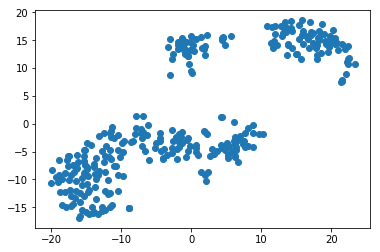

In [ ]:
plt.scatter(X_reduced[:,0],X_reduced[:,1])

## エルボーメソッドでクラスタ数を決定

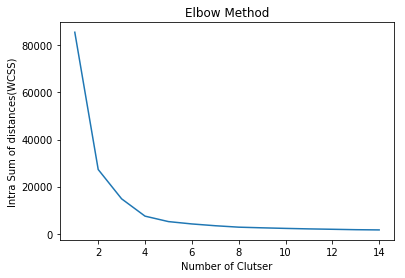

In [ ]:
max_cluster = 15
clusters_ = range(1,max_cluster)
intra_sum_of_square_list = []
plt.figure(0)
for k in clusters_:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300)
    km.fit(X_reduced)
    # 誤差平方和（inertia_）を格納する
    intra_sum_of_square_list.append(km.inertia_)

fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Elbow Method')
ax.set_xlabel('Number of Clutser')
ax.set_ylabel('Intra Sum of distances(WCSS)')
plt.plot(clusters_, intra_sum_of_square_list)

## 最適なクラスタ数によるクラスタリング~可視化

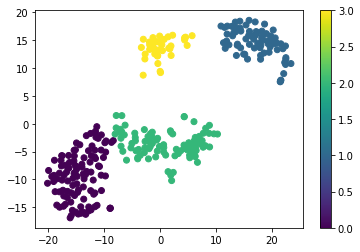

In [ ]:
km = KMeans(n_clusters = 4)
km.fit(X_reduced)
pred_4 = km.predict(X_reduced)

plt.scatter(X_reduced[:,0],X_reduced[:,1],c=pred_4)
plt.colorbar()

## クラスタ毎の消費電力の平均と分散を取得

In [ ]:
cluster_labels = pred_4
clustered = pd.DataFrame(cluster_labels).T
clustered.columns = (X.T.columns)
clustered.index = (["cluster"])

clustered_data = pd.concat([selected_customer_data.drop(["time","day","hour"],axis=1).\
                            groupby(["month","weekday"],as_index=False).mean()*24*4,clustered])
clustered_data[["month","weekday"]] = clustered_data[["month","weekday"]]/96

clustered_data.T.groupby("cluster",as_index=False).count()

# クラスター毎の平均
print("平均\n",clustered_data.T.groupby("cluster",as_index=False).mean().drop("cluster",axis=1).T.mean())
#クラスター毎の分散
print("分散\n",clustered_data.T.groupby("cluster",as_index=False).std().drop("cluster",axis=1).T.mean())

平均
 0    14.041746
1     6.137242
2    29.607943
3    16.452529
dtype: float64
分散
 0    21.209035
1    11.769275
2    34.851073
3    31.911797
dtype: float64


## 非線形回帰

In [ ]:
m_w_h_data = selected_customer_data.drop(["time","day"],axis=1).groupby(["weekday","hour"],as_index=False).mean()*4
m_w_h_data = pd.concat([m_w_h_data,clustered])

In [ ]:
m_w_h_data["MT_001"]["cluster"]

3.0

In [ ]:
# クラスタの番号によってデータフレームを作成する関数
def cluster_choice(m_w_h_data,cluster_num):
    cluster_X_list = []
    for cs in  m_w_h_data.drop(["hour","month","weekday"],axis=1).columns:
        if m_w_h_data[cs]["cluster"] == cluster_num:
            cluster_X_list.append(cs)
    cluster_X = pd.DataFrame(m_w_h_data[cluster_X_list])
    # ここで4で割る意味は？
    cluster_X["hour"] = m_w_h_data["hour"]/4
    cluster_X["month"] = m_w_h_data["month"]/4
    cluster_X["weekday"] = m_w_h_data["weekday"]/4
    return cluster_X

In [ ]:
def nonlinear_fit(x,a,b,c,d,e):
    return a*x+b*x**2+c*x**3+d*x**4+e

In [ ]:
def params_all_fit(cluster_X,set_type):
    cluster_X.drop("cluster",axis=0,inplace=True)
    split = 12
    if set_type == "all":
        X = cluster_X.drop(["hours","month","weekday"],axis=1)
        length = 168 # 特徴量の数?
    if set_type == "month":
        X = cluster_X.groupby("month",as_index=False).mean().drop(["hour","weekday","month"],axis=1)
        length = 12
    if set_type == "weekday":
        X = cluster_X.groupby("weekday",as_index=False).mean().drop(["hour","weekday","month"],axis=1)
        length = 7
        split = 7
    if set_type == "hour":
        X = cluster_X.groupby("hour",as_index=False).mean().drop(["hour","weekday","month"],axis=1)
        length = 24
    else:
        print("エラー")

     # 多項式がy = a*x+b*x**2+c*X**3+d*x**4+eなので各クライアントの係数を代入する用のデータフレームを用意する
    df_fit = pd.DataFrame(np.zeros([int(length/split*5),len(X.columns)]),columns=X.columns)
    # 正規化を行う
    for i in X.columns:
        X[i] = preprocessing.scale(X[i])

    # array_xとarray_yの用途と意味
    for cs in X.columns:
        ix = 0
        params = []
        for i in range(int(length/split)):
            array_x = np.arange(ix,ix+split)
            # XのCS列の[ix:ix+split]行まで
            array_y = X[cs][ix:ix+split]
            param,cov = curve_fit(nonlinear_fit,array_x,array_y)
            params.extend(param)
            ix = ix+split
        df_fit[cs] = params
    return df_fit , length

In [ ]:
def plot_fitted(df_fit,length,ci_type):
    df_y = pd.DataFrame()
    for cs in df_fit.columns:
        array_x = np.arange(0,length)
        list_y = []
        i = 0
        count = 0
        for num in array_x:
            list_y.append(df_fit[cs][i]*num+df_fit[cs][i+1]*num**2+df_fit[cs][i+2]*num**3+df_fit[cs][i+3]*num**4+df_fit[cs][i+4])
            count +=1
            if count % 12 ==0:
                i = i+5
        df_y[cs]=list_y
    plt.figure()
    sns.tsplot(np.array(df_y[df_fit.columns]).T,ci=ci_type)
    sns.tsplot(np.zeros(length),color="Red",linewidth=1)
    df_y[df_fit.columns].T.mean()
    meaned_y1 = df_y[df_fit.columns].T.mean()

エラー


/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


エラー
エラー
エラー


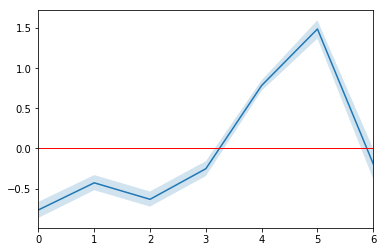

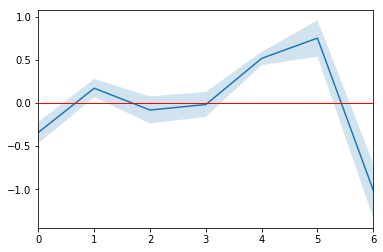

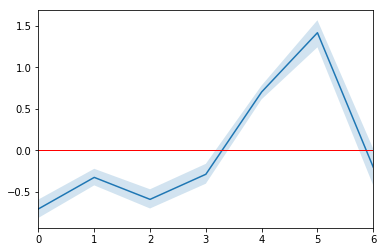

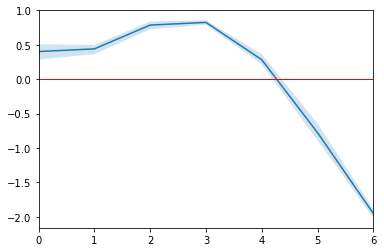

In [ ]:
for i in range(4):
    cluster_X = cluster_choice(m_w_h_data,i)
    df_param,length = params_all_fit(cluster_X,"weekday")
    plot_fitted(df_param,length,95)
    name = "plot_weekday"
    number = "{0:01d}".format(i+1)
    name += number
    name+= ".png"

### クラスタ毎の週での消費電力状況

- クラスタ1
    - 金曜日 / 土曜日に消費電力が上昇する
    - 平日に仕事がある一般家庭のクラスタなのではないか。
    
- クラスタ2
    - クラスタ1と同様に土曜日に消費電力が上昇する。また日曜日のみ極端に消費電力が少なくなる。
     
- クラスタ3
    - クラスタ1とほぼ同様のサイクルで電力が消費されている
         
- クラスタ4
    - 平日に多く電力が消費されている
    - 平日に在宅している人が多いクラスタなのではないか

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


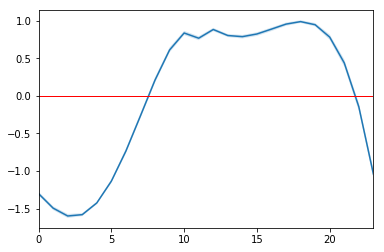

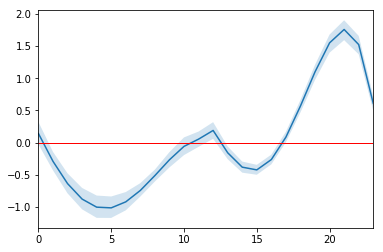

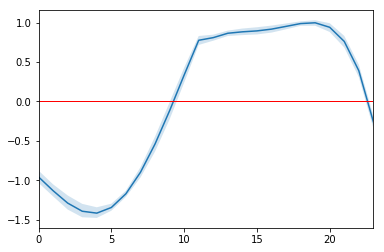

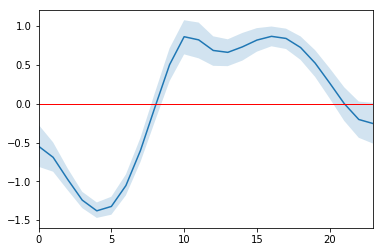

In [ ]:
for i in range(4):
    cluster_X = cluster_choice(m_w_h_data,i)
    df_param,length = params_all_fit(cluster_X,"hour")
    plot_fitted(df_param,length,95)
    name = "plot_hour"
    number = "{0:01d}".format(i+1)
    name += number
    name+= ".png"

### 時間毎での消費電力状況
- クラスタ1
    - 日中、電力が消費されている家庭が多いクラスタ
    
- クラスタ2
    - 11時と2０時頃に電力が多く消費されているクラスタ

- クラスタ3
    - 10時~20時頃まで電力が消費されているクラスタ

- クラスタ4
    - 8時~20時頃まで電力が消費されているクラスタ